In [1]:
"""
from google.colab import drive
drive.mount('/content/gdrive/')

#!pip install -q condacolab
#import condacolab
#condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision
"""

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive/')\n\n#!pip install -q condacolab\n#import condacolab\n#condacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision\n"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/z/home/sgal/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16

    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=100, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction

    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/BLAT500_gaps.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/BLAT500_alignment.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta


    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case')
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report')
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization')
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=1750, help='number of tesselation cells') #6 80, the increasing of tess improve the performance when there are more samples to train the density estimator
    cpab.add_argument('--channels', type=int, default=1750, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps')

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=60, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')


    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] 
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_23_preprint_22feb2024.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_16March2024.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)


'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=100)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


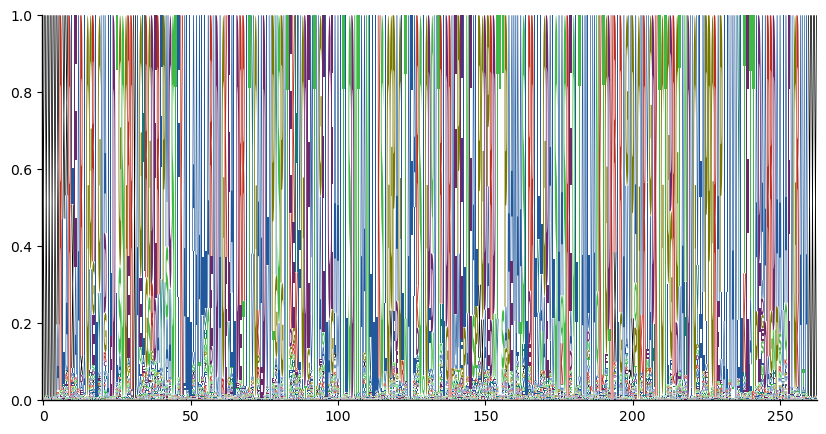

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.01)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")

else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 1000, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )


deepseq(dataset_msa.prot_space)
#plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)

In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])

    #fig.tight_layout()


def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt

    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize) #; fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet]
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)

        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)

    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')

    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()

def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''

        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))

        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs),
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)

                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]


                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS
                optimizer.step()


                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())

                # Save to tensorboard
                iteration = epoch*len(trainloader) + i

                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()

        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_22_preprint_16March2024_batchsize_100.pth'
pretrained_density = logdir_density + "/" + outmodel_name_density
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std,
                    latent_dim = args.latent_dim,
                    encoder = get_encoder( args.ed_type.split(",")[0] ),
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-575,575])#[-175,175] [-15,15] ) #[15,15] #if we increase it, major accuracy

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-5)#, weight_decay=1e-19)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'


if os.path.isfile(pretrained_density):
    print ("Loading Density Model...")
    model.load_state_dict( torch.load(pretrained_density, map_location=casted_device) )
    print ("Loaded")
else:
    fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=400, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # initi
    
    torch.save(model.state_dict(), pretrained_density)




Number of training points:  500



Epoch 1/400:   0%|          | 0/500 [00:00<?, ?samples/s]

/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)



Epoch 1/400:   2%|▏         | 10/500 [00:01<01:26,  5.64samples/s]


Epoch 1/400:   2%|▏         | 10/500 [00:01<01:26,  5.64samples/s, loss=8043.18798828125]


Epoch 1/400:   4%|▍         | 20/500 [00:03<01:23,  5.75samples/s, loss=8043.18798828125]


Epoch 1/400:   4%|▍         | 20/500 [00:03<01:23,  5.75samples/s, loss=8125.71923828125]


Epoch 1/400:   6%|▌         | 30/500 [00:05<01:21,  5.79samples/s, loss=8125.71923828125]


Epoch 1/400:   6%|▌         | 30/500 [00:05<01:21,  5.79samples/s, loss=8095.37646484375]


Epoch 1/400:   8%|▊         | 40/500 [00:06<01:17,  5.91samples/s, loss=8095.37646484375]


Epoch 1/400:   8%|▊         | 40/500 [00:06<01:17,  5.91samples/s, loss=8097.1171875]    


Epoch 1/400:  10%|█         | 50/500 [00:08<01:15,  5.94samples/s, loss=8097.1171875]


Epoch 1/400:  10%|█         | 50/500 [00:08<01:15,  5.94samples/s, loss=8121.43505859375]


Epoch 1/400:  12%|█▏        | 60/500 [00:10<01:14,  5.93samples/s, loss=8121.43505859375]


Epoch 1/400:  12%|█▏        | 60/500 [00:10<01:14,  5.93samples/s, loss=8115.9443359375] 


Epoch 1/400:  14%|█▍        | 70/500 [00:11<01:13,  5.85samples/s, loss=8115.9443359375]


Epoch 1/400:  14%|█▍        | 70/500 [00:11<01:13,  5.85samples/s, loss=8100.6220703125]


Epoch 1/400:  16%|█▌        | 80/500 [00:13<01:11,  5.87samples/s, loss=8100.6220703125]


Epoch 1/400:  16%|█▌        | 80/500 [00:13<01:11,  5.87samples/s, loss=8114.5732421875]


Epoch 1/400:  18%|█▊        | 90/500 [00:15<01:10,  5.85samples/s, loss=8114.5732421875]


Epoch 1/400:  18%|█▊        | 90/500 [00:15<01:10,  5.85samples/s, loss=8083.3486328125]


Epoch 1/400:  20%|██        | 100/500 [00:17<01:08,  5.85samples/s, loss=8083.3486328125]


Epoch 1/400:  20%|██        | 100/500 [00:17<01:08,  5.85samples/s, loss=8107.8486328125]


Epoch 1/400:  22%|██▏       | 110/500 [00:18<01:06,  5.89samples/s, loss=8107.8486328125]


Epoch 1/400:  22%|██▏       | 110/500 [00:18<01:06,  5.89samples/s, loss=8096.67333984375]


Epoch 1/400:  24%|██▍       | 120/500 [00:20<01:05,  5.82samples/s, loss=8096.67333984375]


Epoch 1/400:  24%|██▍       | 120/500 [00:20<01:05,  5.82samples/s, loss=8085.51611328125]


Epoch 1/400:  26%|██▌       | 130/500 [00:22<01:03,  5.86samples/s, loss=8085.51611328125]


Epoch 1/400:  26%|██▌       | 130/500 [00:22<01:03,  5.86samples/s, loss=8090.73583984375]


Epoch 1/400:  28%|██▊       | 140/500 [00:23<01:00,  5.90samples/s, loss=8090.73583984375]


Epoch 1/400:  28%|██▊       | 140/500 [00:23<01:00,  5.90samples/s, loss=8083.5478515625] 


Epoch 1/400:  30%|███       | 150/500 [00:25<01:00,  5.76samples/s, loss=8083.5478515625]


Epoch 1/400:  30%|███       | 150/500 [00:25<01:00,  5.76samples/s, loss=8105.1337890625]


Epoch 1/400:  32%|███▏      | 160/500 [00:27<00:59,  5.76samples/s, loss=8105.1337890625]


Epoch 1/400:  32%|███▏      | 160/500 [00:27<00:59,  5.76samples/s, loss=8093.7890625]   


Epoch 1/400:  34%|███▍      | 170/500 [00:29<00:56,  5.80samples/s, loss=8093.7890625]


Epoch 1/400:  34%|███▍      | 170/500 [00:29<00:56,  5.80samples/s, loss=8104.23681640625]


Epoch 1/400:  36%|███▌      | 180/500 [00:30<00:54,  5.83samples/s, loss=8104.23681640625]


Epoch 1/400:  36%|███▌      | 180/500 [00:30<00:54,  5.83samples/s, loss=8105.4609375]    


Epoch 1/400:  38%|███▊      | 190/500 [00:32<00:52,  5.87samples/s, loss=8105.4609375]


Epoch 1/400:  38%|███▊      | 190/500 [00:32<00:52,  5.87samples/s, loss=8107.18994140625]


Epoch 1/400:  40%|████      | 200/500 [00:34<00:50,  5.92samples/s, loss=8107.18994140625]


Epoch 1/400:  40%|████      | 200/500 [00:34<00:50,  5.92samples/s, loss=8113.03564453125]


Epoch 1/400:  42%|████▏     | 210/500 [00:35<00:49,  5.90samples/s, loss=8113.03564453125]


Epoch 1/400:  42%|████▏     | 210/500 [00:35<00:49,  5.90samples/s, loss=8103.5927734375] 


Epoch 1/400:  44%|████▍     | 220/500 [00:37<00:47,  5.84samples/s, loss=8103.5927734375]


Epoch 1/400:  44%|████▍     | 220/500 [00:37<00:47,  5.84samples/s, loss=8089.47900390625]


Epoch 1/400:  46%|████▌     | 230/500 [00:39<00:46,  5.78samples/s, loss=8089.47900390625]


Epoch 1/400:  46%|████▌     | 230/500 [00:39<00:46,  5.78samples/s, loss=8099.26025390625]


Epoch 1/400:  48%|████▊     | 240/500 [00:41<00:44,  5.84samples/s, loss=8099.26025390625]


Epoch 1/400:  48%|████▊     | 240/500 [00:41<00:44,  5.84samples/s, loss=8095.2255859375] 


Epoch 1/400:  50%|█████     | 250/500 [00:42<00:43,  5.70samples/s, loss=8095.2255859375]


Epoch 1/400:  50%|█████     | 250/500 [00:42<00:43,  5.70samples/s, loss=8102.45751953125]


Epoch 1/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.68samples/s, loss=8102.45751953125]


Epoch 1/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.68samples/s, loss=8088.8212890625] 


Epoch 1/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.59samples/s, loss=8088.8212890625]


Epoch 1/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.59samples/s, loss=8092.31884765625]


Epoch 1/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.57samples/s, loss=8092.31884765625]


Epoch 1/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.57samples/s, loss=8082.44580078125]


Epoch 1/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.60samples/s, loss=8082.44580078125]


Epoch 1/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.60samples/s, loss=8104.841796875]  


Epoch 1/400:  60%|██████    | 300/500 [00:51<00:35,  5.63samples/s, loss=8104.841796875]


Epoch 1/400:  60%|██████    | 300/500 [00:51<00:35,  5.63samples/s, loss=8090.27001953125]


Epoch 1/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.76samples/s, loss=8090.27001953125]


Epoch 1/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.76samples/s, loss=8085.03125]      


Epoch 1/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.87samples/s, loss=8085.03125]


Epoch 1/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.87samples/s, loss=8102.2158203125]


Epoch 1/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.92samples/s, loss=8102.2158203125]


Epoch 1/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.92samples/s, loss=8093.44970703125]


Epoch 1/400:  68%|██████▊   | 340/500 [00:58<00:26,  5.99samples/s, loss=8093.44970703125]


Epoch 1/400:  68%|██████▊   | 340/500 [00:58<00:26,  5.99samples/s, loss=8034.087890625]  


Epoch 1/400:  70%|███████   | 350/500 [01:00<00:24,  6.02samples/s, loss=8034.087890625]


Epoch 1/400:  70%|███████   | 350/500 [01:00<00:24,  6.02samples/s, loss=8023.29052734375]


Epoch 1/400:  72%|███████▏  | 360/500 [01:01<00:23,  6.01samples/s, loss=8023.29052734375]


Epoch 1/400:  72%|███████▏  | 360/500 [01:01<00:23,  6.01samples/s, loss=7803.09130859375]


Epoch 1/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.00samples/s, loss=7803.09130859375]


Epoch 1/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.00samples/s, loss=8084.76953125]   


Epoch 1/400:  76%|███████▌  | 380/500 [01:05<00:20,  6.00samples/s, loss=8084.76953125]


Epoch 1/400:  76%|███████▌  | 380/500 [01:05<00:20,  6.00samples/s, loss=7899.70654296875]


Epoch 1/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.02samples/s, loss=7899.70654296875]


Epoch 1/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.02samples/s, loss=7927.2255859375] 


Epoch 1/400:  80%|████████  | 400/500 [01:08<00:16,  5.99samples/s, loss=7927.2255859375]


Epoch 1/400:  80%|████████  | 400/500 [01:08<00:16,  5.99samples/s, loss=7920.302734375] 


Epoch 1/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.94samples/s, loss=7920.302734375]


Epoch 1/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.94samples/s, loss=7575.38623046875]


Epoch 1/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.02samples/s, loss=7575.38623046875]


Epoch 1/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.02samples/s, loss=7488.2216796875] 


Epoch 1/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.00samples/s, loss=7488.2216796875]


Epoch 1/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.00samples/s, loss=7570.66552734375]


Epoch 1/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.03samples/s, loss=7570.66552734375]


Epoch 1/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.03samples/s, loss=7668.99560546875]


Epoch 1/400:  90%|█████████ | 450/500 [01:16<00:08,  5.99samples/s, loss=7668.99560546875]


Epoch 1/400:  90%|█████████ | 450/500 [01:16<00:08,  5.99samples/s, loss=7825.8046875]    


Epoch 1/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.01samples/s, loss=7825.8046875]


Epoch 1/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.01samples/s, loss=7488.24169921875]


Epoch 1/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.97samples/s, loss=7488.24169921875]


Epoch 1/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.97samples/s, loss=7498.427734375]  


Epoch 1/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.99samples/s, loss=7498.427734375]


Epoch 1/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.99samples/s, loss=7170.7685546875]


Epoch 1/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.01samples/s, loss=7170.7685546875]


Epoch 1/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.01samples/s, loss=7291.86962890625]


Epoch 1/400: 100%|██████████| 500/500 [01:25<00:00,  6.04samples/s, loss=7291.86962890625]


Epoch 1/400: 100%|██████████| 500/500 [01:25<00:00,  6.04samples/s, loss=7302.01904296875]


Epoch 1/400: 100%|██████████| 500/500 [01:25<00:00,  5.87samples/s, loss=7302.01904296875]


Epoch 2/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 2/400:   2%|▏         | 10/500 [00:01<01:10,  6.94samples/s]


Epoch 2/400:   2%|▏         | 10/500 [00:01<01:10,  6.94samples/s, loss=8055.767578125]


Epoch 2/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=8055.767578125]


Epoch 2/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=7935.8427734375]


Epoch 2/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=7935.8427734375]


Epoch 2/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=7768.76220703125]


Epoch 2/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=7768.76220703125]


Epoch 2/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=7789.98388671875]


Epoch 2/400:  10%|█         | 50/500 [00:08<01:16,  5.89samples/s, loss=7789.98388671875]


Epoch 2/400:  10%|█         | 50/500 [00:08<01:16,  5.89samples/s, loss=8027.388671875]  


Epoch 2/400:  12%|█▏        | 60/500 [00:09<01:15,  5.84samples/s, loss=8027.388671875]


Epoch 2/400:  12%|█▏        | 60/500 [00:09<01:15,  5.84samples/s, loss=7881.33642578125]


Epoch 2/400:  14%|█▍        | 70/500 [00:11<01:14,  5.79samples/s, loss=7881.33642578125]


Epoch 2/400:  14%|█▍        | 70/500 [00:11<01:14,  5.79samples/s, loss=7706.89501953125]


Epoch 2/400:  16%|█▌        | 80/500 [00:13<01:12,  5.76samples/s, loss=7706.89501953125]


Epoch 2/400:  16%|█▌        | 80/500 [00:13<01:12,  5.76samples/s, loss=7975.2529296875] 


Epoch 2/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=7975.2529296875]


Epoch 2/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=7815.64208984375]


Epoch 2/400:  20%|██        | 100/500 [00:16<01:09,  5.76samples/s, loss=7815.64208984375]


Epoch 2/400:  20%|██        | 100/500 [00:16<01:09,  5.76samples/s, loss=7787.240234375]  


Epoch 2/400:  22%|██▏       | 110/500 [00:18<01:06,  5.87samples/s, loss=7787.240234375]


Epoch 2/400:  22%|██▏       | 110/500 [00:18<01:06,  5.87samples/s, loss=7738.3642578125]


Epoch 2/400:  24%|██▍       | 120/500 [00:20<01:03,  5.95samples/s, loss=7738.3642578125]


Epoch 2/400:  24%|██▍       | 120/500 [00:20<01:03,  5.95samples/s, loss=7598.09619140625]


Epoch 2/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=7598.09619140625]


Epoch 2/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=7699.5517578125] 


Epoch 2/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=7699.5517578125]


Epoch 2/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=7751.009765625] 


Epoch 2/400:  30%|███       | 150/500 [00:25<00:59,  5.86samples/s, loss=7751.009765625]


Epoch 2/400:  30%|███       | 150/500 [00:25<00:59,  5.86samples/s, loss=7848.68994140625]


Epoch 2/400:  32%|███▏      | 160/500 [00:27<00:57,  5.88samples/s, loss=7848.68994140625]


Epoch 2/400:  32%|███▏      | 160/500 [00:27<00:57,  5.88samples/s, loss=7532.49755859375]


Epoch 2/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=7532.49755859375]


Epoch 2/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=7654.78466796875]


Epoch 2/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=7654.78466796875]


Epoch 2/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=7912.376953125]  


Epoch 2/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=7912.376953125]


Epoch 2/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=7662.01416015625]


Epoch 2/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=7662.01416015625]


Epoch 2/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=7814.630859375]  


Epoch 2/400:  42%|████▏     | 210/500 [00:35<00:48,  6.02samples/s, loss=7814.630859375]


Epoch 2/400:  42%|████▏     | 210/500 [00:35<00:48,  6.02samples/s, loss=7782.82080078125]


Epoch 2/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=7782.82080078125]


Epoch 2/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=7808.79931640625]


Epoch 2/400:  46%|████▌     | 230/500 [00:38<00:45,  5.89samples/s, loss=7808.79931640625]


Epoch 2/400:  46%|████▌     | 230/500 [00:38<00:45,  5.89samples/s, loss=7871.57421875]   


Epoch 2/400:  48%|████▊     | 240/500 [00:40<00:44,  5.86samples/s, loss=7871.57421875]


Epoch 2/400:  48%|████▊     | 240/500 [00:40<00:44,  5.86samples/s, loss=7783.05029296875]


Epoch 2/400:  50%|█████     | 250/500 [00:42<00:42,  5.83samples/s, loss=7783.05029296875]


Epoch 2/400:  50%|█████     | 250/500 [00:42<00:42,  5.83samples/s, loss=7561.861328125]  


Epoch 2/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.92samples/s, loss=7561.861328125]


Epoch 2/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.92samples/s, loss=7723.095703125]


Epoch 2/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.97samples/s, loss=7723.095703125]


Epoch 2/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.97samples/s, loss=7598.09423828125]


Epoch 2/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.98samples/s, loss=7598.09423828125]


Epoch 2/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.98samples/s, loss=7771.29638671875]


Epoch 2/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.04samples/s, loss=7771.29638671875]


Epoch 2/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.04samples/s, loss=7487.61376953125]


Epoch 2/400:  60%|██████    | 300/500 [00:50<00:32,  6.06samples/s, loss=7487.61376953125]


Epoch 2/400:  60%|██████    | 300/500 [00:50<00:32,  6.06samples/s, loss=7790.20361328125]


Epoch 2/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.06samples/s, loss=7790.20361328125]


Epoch 2/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.06samples/s, loss=7492.646484375]  


Epoch 2/400:  64%|██████▍   | 320/500 [00:53<00:30,  6.00samples/s, loss=7492.646484375]


Epoch 2/400:  64%|██████▍   | 320/500 [00:53<00:30,  6.00samples/s, loss=7773.70947265625]


Epoch 2/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.93samples/s, loss=7773.70947265625]


Epoch 2/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.93samples/s, loss=7317.80078125]   


Epoch 2/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.92samples/s, loss=7317.80078125]


Epoch 2/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.92samples/s, loss=7632.05029296875]


Epoch 2/400:  70%|███████   | 350/500 [00:58<00:25,  5.95samples/s, loss=7632.05029296875]


Epoch 2/400:  70%|███████   | 350/500 [00:58<00:25,  5.95samples/s, loss=7516.9453125]    


Epoch 2/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.01samples/s, loss=7516.9453125]


Epoch 2/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.01samples/s, loss=7498.8720703125]


Epoch 2/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.00samples/s, loss=7498.8720703125]


Epoch 2/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.00samples/s, loss=7295.23095703125]


Epoch 2/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.03samples/s, loss=7295.23095703125]


Epoch 2/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.03samples/s, loss=7317.47216796875]


Epoch 2/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.07samples/s, loss=7317.47216796875]


Epoch 2/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.07samples/s, loss=7126.1123046875] 


Epoch 2/400:  80%|████████  | 400/500 [01:07<00:16,  6.09samples/s, loss=7126.1123046875]


Epoch 2/400:  80%|████████  | 400/500 [01:07<00:16,  6.09samples/s, loss=7270.869140625] 


Epoch 2/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.99samples/s, loss=7270.869140625]


Epoch 2/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.99samples/s, loss=7446.1435546875]


Epoch 2/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.98samples/s, loss=7446.1435546875]


Epoch 2/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.98samples/s, loss=7124.29052734375]


Epoch 2/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.95samples/s, loss=7124.29052734375]


Epoch 2/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.95samples/s, loss=7446.39208984375]


Epoch 2/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.93samples/s, loss=7446.39208984375]


Epoch 2/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.93samples/s, loss=7690.6201171875] 


Epoch 2/400:  90%|█████████ | 450/500 [01:15<00:08,  5.89samples/s, loss=7690.6201171875]


Epoch 2/400:  90%|█████████ | 450/500 [01:15<00:08,  5.89samples/s, loss=7453.47021484375]


Epoch 2/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.84samples/s, loss=7453.47021484375]


Epoch 2/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.84samples/s, loss=7227.3349609375] 


Epoch 2/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.87samples/s, loss=7227.3349609375]


Epoch 2/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.87samples/s, loss=7523.6455078125]


Epoch 2/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.87samples/s, loss=7523.6455078125]


Epoch 2/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.87samples/s, loss=7234.92578125]  


Epoch 2/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.88samples/s, loss=7234.92578125]


Epoch 2/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.88samples/s, loss=7432.982421875]


Epoch 2/400: 100%|██████████| 500/500 [01:24<00:00,  5.90samples/s, loss=7432.982421875]


Epoch 2/400: 100%|██████████| 500/500 [01:24<00:00,  5.90samples/s, loss=7400.1611328125]


Epoch 2/400: 100%|██████████| 500/500 [01:24<00:00,  5.93samples/s, loss=7400.1611328125]


Epoch 3/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 3/400:   2%|▏         | 10/500 [00:01<01:14,  6.55samples/s]


Epoch 3/400:   2%|▏         | 10/500 [00:01<01:14,  6.55samples/s, loss=8072.04833984375]


Epoch 3/400:   4%|▍         | 20/500 [00:03<01:18,  6.09samples/s, loss=8072.04833984375]


Epoch 3/400:   4%|▍         | 20/500 [00:03<01:18,  6.09samples/s, loss=8006.224609375]  


Epoch 3/400:   6%|▌         | 30/500 [00:04<01:19,  5.92samples/s, loss=8006.224609375]


Epoch 3/400:   6%|▌         | 30/500 [00:04<01:19,  5.92samples/s, loss=7901.60546875] 


Epoch 3/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=7901.60546875]


Epoch 3/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=8041.70556640625]


Epoch 3/400:  10%|█         | 50/500 [00:08<01:18,  5.73samples/s, loss=8041.70556640625]


Epoch 3/400:  10%|█         | 50/500 [00:08<01:18,  5.73samples/s, loss=8054.0751953125] 


Epoch 3/400:  12%|█▏        | 60/500 [00:10<01:16,  5.77samples/s, loss=8054.0751953125]


Epoch 3/400:  12%|█▏        | 60/500 [00:10<01:16,  5.77samples/s, loss=8012.916015625] 


Epoch 3/400:  14%|█▍        | 70/500 [00:11<01:14,  5.80samples/s, loss=8012.916015625]


Epoch 3/400:  14%|█▍        | 70/500 [00:11<01:14,  5.80samples/s, loss=7951.43994140625]


Epoch 3/400:  16%|█▌        | 80/500 [00:13<01:12,  5.83samples/s, loss=7951.43994140625]


Epoch 3/400:  16%|█▌        | 80/500 [00:13<01:12,  5.83samples/s, loss=7991.57568359375]


Epoch 3/400:  18%|█▊        | 90/500 [00:15<01:10,  5.82samples/s, loss=7991.57568359375]


Epoch 3/400:  18%|█▊        | 90/500 [00:15<01:10,  5.82samples/s, loss=7960.68994140625]


Epoch 3/400:  20%|██        | 100/500 [00:17<01:07,  5.88samples/s, loss=7960.68994140625]


Epoch 3/400:  20%|██        | 100/500 [00:17<01:07,  5.88samples/s, loss=7931.79345703125]


Epoch 3/400:  22%|██▏       | 110/500 [00:18<01:05,  5.96samples/s, loss=7931.79345703125]


Epoch 3/400:  22%|██▏       | 110/500 [00:18<01:05,  5.96samples/s, loss=7738.5439453125] 


Epoch 3/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=7738.5439453125]


Epoch 3/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=7850.00146484375]


Epoch 3/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7850.00146484375]


Epoch 3/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7681.90185546875]


Epoch 3/400:  28%|██▊       | 140/500 [00:23<01:00,  5.98samples/s, loss=7681.90185546875]


Epoch 3/400:  28%|██▊       | 140/500 [00:23<01:00,  5.98samples/s, loss=7843.00537109375]


Epoch 3/400:  30%|███       | 150/500 [00:25<00:58,  5.99samples/s, loss=7843.00537109375]


Epoch 3/400:  30%|███       | 150/500 [00:25<00:58,  5.99samples/s, loss=7614.974609375]  


Epoch 3/400:  32%|███▏      | 160/500 [00:27<00:57,  5.95samples/s, loss=7614.974609375]


Epoch 3/400:  32%|███▏      | 160/500 [00:27<00:57,  5.95samples/s, loss=7453.32080078125]


Epoch 3/400:  34%|███▍      | 170/500 [00:28<00:54,  6.01samples/s, loss=7453.32080078125]


Epoch 3/400:  34%|███▍      | 170/500 [00:28<00:54,  6.01samples/s, loss=7617.0986328125] 


Epoch 3/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=7617.0986328125]


Epoch 3/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=7646.0009765625]


Epoch 3/400:  38%|███▊      | 190/500 [00:31<00:51,  6.01samples/s, loss=7646.0009765625]


Epoch 3/400:  38%|███▊      | 190/500 [00:31<00:51,  6.01samples/s, loss=7353.54833984375]


Epoch 3/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=7353.54833984375]


Epoch 3/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=7326.22705078125]


Epoch 3/400:  42%|████▏     | 210/500 [00:35<00:48,  5.95samples/s, loss=7326.22705078125]


Epoch 3/400:  42%|████▏     | 210/500 [00:35<00:48,  5.95samples/s, loss=7564.40869140625]


Epoch 3/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=7564.40869140625]


Epoch 3/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=7254.498046875]  


Epoch 3/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=7254.498046875]


Epoch 3/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=7452.4921875]  


Epoch 3/400:  48%|████▊     | 240/500 [00:40<00:43,  5.98samples/s, loss=7452.4921875]


Epoch 3/400:  48%|████▊     | 240/500 [00:40<00:43,  5.98samples/s, loss=7401.798828125]


Epoch 3/400:  50%|█████     | 250/500 [00:42<00:41,  6.02samples/s, loss=7401.798828125]


Epoch 3/400:  50%|█████     | 250/500 [00:42<00:41,  6.02samples/s, loss=7122.5751953125]


Epoch 3/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.04samples/s, loss=7122.5751953125]


Epoch 3/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.04samples/s, loss=7723.5263671875]


Epoch 3/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.06samples/s, loss=7723.5263671875]


Epoch 3/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.06samples/s, loss=7282.20751953125]


Epoch 3/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.08samples/s, loss=7282.20751953125]


Epoch 3/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.08samples/s, loss=7217.69970703125]


Epoch 3/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.02samples/s, loss=7217.69970703125]


Epoch 3/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.02samples/s, loss=7148.435546875]  


Epoch 3/400:  60%|██████    | 300/500 [00:50<00:33,  5.99samples/s, loss=7148.435546875]


Epoch 3/400:  60%|██████    | 300/500 [00:50<00:33,  5.99samples/s, loss=7489.00927734375]


Epoch 3/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.96samples/s, loss=7489.00927734375]


Epoch 3/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.96samples/s, loss=7112.3056640625] 


Epoch 3/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=7112.3056640625]


Epoch 3/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=7311.3173828125]


Epoch 3/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.97samples/s, loss=7311.3173828125]


Epoch 3/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.97samples/s, loss=7031.57666015625]


Epoch 3/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.92samples/s, loss=7031.57666015625]


Epoch 3/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.92samples/s, loss=7211.3974609375] 


Epoch 3/400:  70%|███████   | 350/500 [00:58<00:25,  5.86samples/s, loss=7211.3974609375]


Epoch 3/400:  70%|███████   | 350/500 [00:58<00:25,  5.86samples/s, loss=6963.587890625] 


Epoch 3/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.85samples/s, loss=6963.587890625]


Epoch 3/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.85samples/s, loss=6932.29443359375]


Epoch 3/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.95samples/s, loss=6932.29443359375]


Epoch 3/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.95samples/s, loss=7349.94580078125]


Epoch 3/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.05samples/s, loss=7349.94580078125]


Epoch 3/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.05samples/s, loss=7188.55517578125]


Epoch 3/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.07samples/s, loss=7188.55517578125]


Epoch 3/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.07samples/s, loss=6905.3046875]    


Epoch 3/400:  80%|████████  | 400/500 [01:06<00:16,  6.10samples/s, loss=6905.3046875]


Epoch 3/400:  80%|████████  | 400/500 [01:07<00:16,  6.10samples/s, loss=7038.24365234375]


Epoch 3/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.05samples/s, loss=7038.24365234375]


Epoch 3/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.05samples/s, loss=7442.12548828125]


Epoch 3/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.08samples/s, loss=7442.12548828125]


Epoch 3/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.08samples/s, loss=7320.1728515625] 


Epoch 3/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.07samples/s, loss=7320.1728515625]


Epoch 3/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.07samples/s, loss=7009.30126953125]


Epoch 3/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.11samples/s, loss=7009.30126953125]


Epoch 3/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.11samples/s, loss=7648.03564453125]


Epoch 3/400:  90%|█████████ | 450/500 [01:15<00:08,  6.11samples/s, loss=7648.03564453125]


Epoch 3/400:  90%|█████████ | 450/500 [01:15<00:08,  6.11samples/s, loss=7316.623046875]  


Epoch 3/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.14samples/s, loss=7316.623046875]


Epoch 3/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.14samples/s, loss=7145.7294921875]


Epoch 3/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.15samples/s, loss=7145.7294921875]


Epoch 3/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.15samples/s, loss=7384.66748046875]


Epoch 3/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.15samples/s, loss=7384.66748046875]


Epoch 3/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.15samples/s, loss=6919.669921875]  


Epoch 3/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.15samples/s, loss=6919.669921875]


Epoch 3/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.15samples/s, loss=6986.6396484375]


Epoch 3/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=6986.6396484375]


Epoch 3/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=7664.63671875]  


Epoch 3/400: 100%|██████████| 500/500 [01:23<00:00,  5.98samples/s, loss=7664.63671875]


Epoch 4/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 4/400:   2%|▏         | 10/500 [00:01<01:10,  6.96samples/s]


Epoch 4/400:   2%|▏         | 10/500 [00:01<01:10,  6.96samples/s, loss=8077.373046875]


Epoch 4/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=8077.373046875]


Epoch 4/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=7974.529296875]


Epoch 4/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=7974.529296875]


Epoch 4/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=7938.34814453125]


Epoch 4/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=7938.34814453125]


Epoch 4/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=8011.125]        


Epoch 4/400:  10%|█         | 50/500 [00:08<01:12,  6.18samples/s, loss=8011.125]


Epoch 4/400:  10%|█         | 50/500 [00:08<01:12,  6.18samples/s, loss=8056.13720703125]


Epoch 4/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=8056.13720703125]


Epoch 4/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=8032.5625]       


Epoch 4/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=8032.5625]


Epoch 4/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=7832.2314453125]


Epoch 4/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=7832.2314453125]


Epoch 4/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=8019.345703125] 


Epoch 4/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=8019.345703125]


Epoch 4/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=7906.62548828125]


Epoch 4/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=7906.62548828125]


Epoch 4/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=7709.93701171875]


Epoch 4/400:  22%|██▏       | 110/500 [00:17<01:04,  6.04samples/s, loss=7709.93701171875]


Epoch 4/400:  22%|██▏       | 110/500 [00:17<01:04,  6.04samples/s, loss=7987.51123046875]


Epoch 4/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=7987.51123046875]


Epoch 4/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=7828.908203125]  


Epoch 4/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7828.908203125]


Epoch 4/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7743.75927734375]


Epoch 4/400:  28%|██▊       | 140/500 [00:23<01:00,  5.99samples/s, loss=7743.75927734375]


Epoch 4/400:  28%|██▊       | 140/500 [00:23<01:00,  5.99samples/s, loss=7542.82373046875]


Epoch 4/400:  30%|███       | 150/500 [00:24<00:59,  5.89samples/s, loss=7542.82373046875]


Epoch 4/400:  30%|███       | 150/500 [00:24<00:59,  5.89samples/s, loss=7369.4873046875] 


Epoch 4/400:  32%|███▏      | 160/500 [00:26<00:57,  5.93samples/s, loss=7369.4873046875]


Epoch 4/400:  32%|███▏      | 160/500 [00:26<00:57,  5.93samples/s, loss=7262.17138671875]


Epoch 4/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=7262.17138671875]


Epoch 4/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=7431.5263671875] 


Epoch 4/400:  36%|███▌      | 180/500 [00:29<00:54,  5.88samples/s, loss=7431.5263671875]


Epoch 4/400:  36%|███▌      | 180/500 [00:29<00:54,  5.88samples/s, loss=7423.71826171875]


Epoch 4/400:  38%|███▊      | 190/500 [00:31<00:52,  5.88samples/s, loss=7423.71826171875]


Epoch 4/400:  38%|███▊      | 190/500 [00:31<00:52,  5.88samples/s, loss=7492.96533203125]


Epoch 4/400:  40%|████      | 200/500 [00:33<00:51,  5.85samples/s, loss=7492.96533203125]


Epoch 4/400:  40%|████      | 200/500 [00:33<00:51,  5.85samples/s, loss=7120.6455078125] 


Epoch 4/400:  42%|████▏     | 210/500 [00:34<00:49,  5.92samples/s, loss=7120.6455078125]


Epoch 4/400:  42%|████▏     | 210/500 [00:34<00:49,  5.92samples/s, loss=7688.7431640625]


Epoch 4/400:  44%|████▍     | 220/500 [00:36<00:47,  5.86samples/s, loss=7688.7431640625]


Epoch 4/400:  44%|████▍     | 220/500 [00:36<00:47,  5.86samples/s, loss=7120.51904296875]


Epoch 4/400:  46%|████▌     | 230/500 [00:38<00:46,  5.78samples/s, loss=7120.51904296875]


Epoch 4/400:  46%|████▌     | 230/500 [00:38<00:46,  5.78samples/s, loss=7467.0947265625] 


Epoch 4/400:  48%|████▊     | 240/500 [00:40<00:44,  5.85samples/s, loss=7467.0947265625]


Epoch 4/400:  48%|████▊     | 240/500 [00:40<00:44,  5.85samples/s, loss=7186.89501953125]


Epoch 4/400:  50%|█████     | 250/500 [00:41<00:42,  5.92samples/s, loss=7186.89501953125]


Epoch 4/400:  50%|█████     | 250/500 [00:41<00:42,  5.92samples/s, loss=7111.998046875]  


Epoch 4/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.97samples/s, loss=7111.998046875]


Epoch 4/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.97samples/s, loss=7412.59716796875]


Epoch 4/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=7412.59716796875]


Epoch 4/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=7277.6083984375] 


Epoch 4/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.91samples/s, loss=7277.6083984375]


Epoch 4/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.91samples/s, loss=7376.8671875]   


Epoch 4/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.93samples/s, loss=7376.8671875]


Epoch 4/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.93samples/s, loss=7281.2998046875]


Epoch 4/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=7281.2998046875]


Epoch 4/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=7568.345703125] 


Epoch 4/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.00samples/s, loss=7568.345703125]


Epoch 4/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.00samples/s, loss=6977.3193359375]


Epoch 4/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=6977.3193359375]


Epoch 4/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=7279.6015625]   


Epoch 4/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.82samples/s, loss=7279.6015625]


Epoch 4/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.82samples/s, loss=7124.119140625]


Epoch 4/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.86samples/s, loss=7124.119140625]


Epoch 4/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.86samples/s, loss=7094.28466796875]


Epoch 4/400:  70%|███████   | 350/500 [00:58<00:25,  5.94samples/s, loss=7094.28466796875]


Epoch 4/400:  70%|███████   | 350/500 [00:58<00:25,  5.94samples/s, loss=6830.89453125]   


Epoch 4/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.03samples/s, loss=6830.89453125]


Epoch 4/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.03samples/s, loss=7032.595703125]


Epoch 4/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.10samples/s, loss=7032.595703125]


Epoch 4/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.10samples/s, loss=7170.30419921875]


Epoch 4/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.02samples/s, loss=7170.30419921875]


Epoch 4/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.02samples/s, loss=7183.19189453125]


Epoch 4/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.89samples/s, loss=7183.19189453125]


Epoch 4/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.89samples/s, loss=6978.546875]     


Epoch 4/400:  80%|████████  | 400/500 [01:06<00:16,  5.94samples/s, loss=6978.546875]


Epoch 4/400:  80%|████████  | 400/500 [01:06<00:16,  5.94samples/s, loss=6911.876953125]


Epoch 4/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.87samples/s, loss=6911.876953125]


Epoch 4/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.87samples/s, loss=6919.9267578125]


Epoch 4/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.93samples/s, loss=6919.9267578125]


Epoch 4/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.93samples/s, loss=6625.953125]    


Epoch 4/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.00samples/s, loss=6625.953125]


Epoch 4/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.00samples/s, loss=7118.11474609375]


Epoch 4/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.05samples/s, loss=7118.11474609375]


Epoch 4/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.05samples/s, loss=7455.1845703125] 


Epoch 4/400:  90%|█████████ | 450/500 [01:15<00:08,  6.07samples/s, loss=7455.1845703125]


Epoch 4/400:  90%|█████████ | 450/500 [01:15<00:08,  6.07samples/s, loss=7087.21337890625]


Epoch 4/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.11samples/s, loss=7087.21337890625]


Epoch 4/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.11samples/s, loss=7101.06103515625]


Epoch 4/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.12samples/s, loss=7101.06103515625]


Epoch 4/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.12samples/s, loss=7348.12841796875]


Epoch 4/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.10samples/s, loss=7348.12841796875]


Epoch 4/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.10samples/s, loss=7159.7353515625] 


Epoch 4/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.12samples/s, loss=7159.7353515625]


Epoch 4/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.12samples/s, loss=6931.26171875]  


Epoch 4/400: 100%|██████████| 500/500 [01:23<00:00,  6.07samples/s, loss=6931.26171875]


Epoch 4/400: 100%|██████████| 500/500 [01:23<00:00,  6.07samples/s, loss=7450.74169921875]


Epoch 4/400: 100%|██████████| 500/500 [01:23<00:00,  5.98samples/s, loss=7450.74169921875]


Epoch 5/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 5/400:   2%|▏         | 10/500 [00:01<01:11,  6.86samples/s]


Epoch 5/400:   2%|▏         | 10/500 [00:01<01:11,  6.86samples/s, loss=8083.27880859375]


Epoch 5/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=8083.27880859375]


Epoch 5/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=8032.8017578125] 


Epoch 5/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=8032.8017578125]


Epoch 5/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=7871.5634765625]


Epoch 5/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=7871.5634765625]


Epoch 5/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=8052.3271484375]


Epoch 5/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=8052.3271484375]


Epoch 5/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=8010.509765625] 


Epoch 5/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=8010.509765625]


Epoch 5/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=8054.48388671875]


Epoch 5/400:  14%|█▍        | 70/500 [00:11<01:11,  5.99samples/s, loss=8054.48388671875]


Epoch 5/400:  14%|█▍        | 70/500 [00:11<01:11,  5.99samples/s, loss=7986.77783203125]


Epoch 5/400:  16%|█▌        | 80/500 [00:13<01:09,  6.03samples/s, loss=7986.77783203125]


Epoch 5/400:  16%|█▌        | 80/500 [00:13<01:09,  6.03samples/s, loss=7939.486328125]  


Epoch 5/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=7939.486328125]


Epoch 5/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=7785.24560546875]


Epoch 5/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=7785.24560546875]


Epoch 5/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=7941.16796875]   


Epoch 5/400:  22%|██▏       | 110/500 [00:18<01:04,  6.09samples/s, loss=7941.16796875]


Epoch 5/400:  22%|██▏       | 110/500 [00:18<01:04,  6.09samples/s, loss=7821.056640625]


Epoch 5/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=7821.056640625]


Epoch 5/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=7780.423828125]


Epoch 5/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7780.423828125]


Epoch 5/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7491.04833984375]


Epoch 5/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7491.04833984375]


Epoch 5/400:  28%|██▊       | 140/500 [00:23<00:59,  6.07samples/s, loss=7621.86376953125]


Epoch 5/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7621.86376953125]


Epoch 5/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7924.12548828125]


Epoch 5/400:  32%|███▏      | 160/500 [00:26<00:56,  6.01samples/s, loss=7924.12548828125]


Epoch 5/400:  32%|███▏      | 160/500 [00:26<00:56,  6.01samples/s, loss=7647.1982421875] 


Epoch 5/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=7647.1982421875]


Epoch 5/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=7600.12353515625]


Epoch 5/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=7600.12353515625]


Epoch 5/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=7262.61328125]   


Epoch 5/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=7262.61328125]


Epoch 5/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=7257.75732421875]


Epoch 5/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=7257.75732421875]


Epoch 5/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=7285.48583984375]


Epoch 5/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=7285.48583984375]


Epoch 5/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=7374.48974609375]


Epoch 5/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=7374.48974609375]


Epoch 5/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=7406.462890625]  


Epoch 5/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=7406.462890625]


Epoch 5/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=7550.07080078125]


Epoch 5/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=7550.07080078125]


Epoch 5/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=7469.09521484375]


Epoch 5/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=7469.09521484375]


Epoch 5/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6843.0859375]    


Epoch 5/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.86samples/s, loss=6843.0859375]


Epoch 5/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.86samples/s, loss=7260.01416015625]


Epoch 5/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.77samples/s, loss=7260.01416015625]


Epoch 5/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.77samples/s, loss=7122.16552734375]


Epoch 5/400:  56%|█████▌    | 280/500 [00:46<00:38,  5.77samples/s, loss=7122.16552734375]


Epoch 5/400:  56%|█████▌    | 280/500 [00:46<00:38,  5.77samples/s, loss=6815.044921875]  


Epoch 5/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.69samples/s, loss=6815.044921875]


Epoch 5/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.69samples/s, loss=6941.07568359375]


Epoch 5/400:  60%|██████    | 300/500 [00:50<00:35,  5.60samples/s, loss=6941.07568359375]


Epoch 5/400:  60%|██████    | 300/500 [00:50<00:35,  5.60samples/s, loss=7250.845703125]  


Epoch 5/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.67samples/s, loss=7250.845703125]


Epoch 5/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.67samples/s, loss=7120.62109375] 


Epoch 5/400:  64%|██████▍   | 320/500 [00:53<00:31,  5.73samples/s, loss=7120.62109375]


Epoch 5/400:  64%|██████▍   | 320/500 [00:53<00:31,  5.73samples/s, loss=7391.12548828125]


Epoch 5/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.76samples/s, loss=7391.12548828125]


Epoch 5/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.76samples/s, loss=7012.11474609375]


Epoch 5/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.77samples/s, loss=7012.11474609375]


Epoch 5/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.77samples/s, loss=6919.47265625]   


Epoch 5/400:  70%|███████   | 350/500 [00:58<00:25,  5.78samples/s, loss=6919.47265625]


Epoch 5/400:  70%|███████   | 350/500 [00:58<00:25,  5.78samples/s, loss=7230.19970703125]


Epoch 5/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=7230.19970703125]


Epoch 5/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=7256.83544921875]


Epoch 5/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.94samples/s, loss=7256.83544921875]


Epoch 5/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.94samples/s, loss=7084.2890625]    


Epoch 5/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.93samples/s, loss=7084.2890625]


Epoch 5/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.93samples/s, loss=7244.39306640625]


Epoch 5/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.85samples/s, loss=7244.39306640625]


Epoch 5/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.85samples/s, loss=6587.48095703125]


Epoch 5/400:  80%|████████  | 400/500 [01:07<00:16,  5.88samples/s, loss=6587.48095703125]


Epoch 5/400:  80%|████████  | 400/500 [01:07<00:16,  5.88samples/s, loss=6842.28369140625]


Epoch 5/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.99samples/s, loss=6842.28369140625]


Epoch 5/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.99samples/s, loss=7029.98583984375]


Epoch 5/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.05samples/s, loss=7029.98583984375]


Epoch 5/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.05samples/s, loss=6937.61572265625]


Epoch 5/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.09samples/s, loss=6937.61572265625]


Epoch 5/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.09samples/s, loss=7108.30224609375]


Epoch 5/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.15samples/s, loss=7108.30224609375]


Epoch 5/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.15samples/s, loss=7747.65869140625]


Epoch 5/400:  90%|█████████ | 450/500 [01:15<00:08,  6.18samples/s, loss=7747.65869140625]


Epoch 5/400:  90%|█████████ | 450/500 [01:15<00:08,  6.18samples/s, loss=7177.9921875]    


Epoch 5/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.13samples/s, loss=7177.9921875]


Epoch 5/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.13samples/s, loss=7106.4267578125]


Epoch 5/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.15samples/s, loss=7106.4267578125]


Epoch 5/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.15samples/s, loss=7052.126953125] 


Epoch 5/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.09samples/s, loss=7052.126953125]


Epoch 5/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.09samples/s, loss=6737.22314453125]


Epoch 5/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.14samples/s, loss=6737.22314453125]


Epoch 5/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.14samples/s, loss=6962.09033203125]


Epoch 5/400: 100%|██████████| 500/500 [01:23<00:00,  6.17samples/s, loss=6962.09033203125]


Epoch 5/400: 100%|██████████| 500/500 [01:23<00:00,  6.17samples/s, loss=7483.1259765625] 


Epoch 5/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=7483.1259765625]


Epoch 6/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 6/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s]


Epoch 6/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s, loss=8073.4892578125]


Epoch 6/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=8073.4892578125]


Epoch 6/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=8014.26513671875]


Epoch 6/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=8014.26513671875]


Epoch 6/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=7856.05908203125]


Epoch 6/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=7856.05908203125]


Epoch 6/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=7924.32373046875]


Epoch 6/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=7924.32373046875]


Epoch 6/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=8053.60595703125]


Epoch 6/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=8053.60595703125]


Epoch 6/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7985.30517578125]


Epoch 6/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=7985.30517578125]


Epoch 6/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=7939.259765625]  


Epoch 6/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=7939.259765625]


Epoch 6/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=8011.3203125]  


Epoch 6/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=8011.3203125]


Epoch 6/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=7919.5595703125]


Epoch 6/400:  20%|██        | 100/500 [00:16<01:05,  6.06samples/s, loss=7919.5595703125]


Epoch 6/400:  20%|██        | 100/500 [00:16<01:05,  6.06samples/s, loss=7786.62548828125]


Epoch 6/400:  22%|██▏       | 110/500 [00:17<01:04,  6.05samples/s, loss=7786.62548828125]


Epoch 6/400:  22%|██▏       | 110/500 [00:17<01:04,  6.05samples/s, loss=7500.85986328125]


Epoch 6/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=7500.85986328125]


Epoch 6/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=7851.25]         


Epoch 6/400:  26%|██▌       | 130/500 [00:21<01:01,  6.07samples/s, loss=7851.25]


Epoch 6/400:  26%|██▌       | 130/500 [00:21<01:01,  6.07samples/s, loss=7492.8701171875]


Epoch 6/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7492.8701171875]


Epoch 6/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7790.15771484375]


Epoch 6/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7790.15771484375]


Epoch 6/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7224.8701171875] 


Epoch 6/400:  32%|███▏      | 160/500 [00:26<00:55,  6.07samples/s, loss=7224.8701171875]


Epoch 6/400:  32%|███▏      | 160/500 [00:26<00:55,  6.07samples/s, loss=7542.44775390625]


Epoch 6/400:  34%|███▍      | 170/500 [00:27<00:54,  6.04samples/s, loss=7542.44775390625]


Epoch 6/400:  34%|███▍      | 170/500 [00:27<00:54,  6.04samples/s, loss=7623.78759765625]


Epoch 6/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=7623.78759765625]


Epoch 6/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=7694.599609375]  


Epoch 6/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=7694.599609375]


Epoch 6/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=7368.47802734375]


Epoch 6/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=7368.47802734375]


Epoch 6/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=7752.966796875]  


Epoch 6/400:  42%|████▏     | 210/500 [00:34<00:47,  6.04samples/s, loss=7752.966796875]


Epoch 6/400:  42%|████▏     | 210/500 [00:34<00:47,  6.04samples/s, loss=7565.3759765625]


Epoch 6/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=7565.3759765625]


Epoch 6/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=7481.5224609375]


Epoch 6/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=7481.5224609375]


Epoch 6/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=7693.509765625] 


Epoch 6/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=7693.509765625]


Epoch 6/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=7547.04736328125]


Epoch 6/400:  50%|█████     | 250/500 [00:40<00:41,  6.08samples/s, loss=7547.04736328125]


Epoch 6/400:  50%|█████     | 250/500 [00:40<00:41,  6.08samples/s, loss=7359.29150390625]


Epoch 6/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=7359.29150390625]


Epoch 6/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=7219.8984375]    


Epoch 6/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.84samples/s, loss=7219.8984375]


Epoch 6/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.84samples/s, loss=7495.0771484375]


Epoch 6/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.84samples/s, loss=7495.0771484375]


Epoch 6/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.84samples/s, loss=7088.40966796875]


Epoch 6/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.91samples/s, loss=7088.40966796875]


Epoch 6/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.91samples/s, loss=7138.6318359375] 


Epoch 6/400:  60%|██████    | 300/500 [00:49<00:33,  5.95samples/s, loss=7138.6318359375]


Epoch 6/400:  60%|██████    | 300/500 [00:49<00:33,  5.95samples/s, loss=7049.5751953125]


Epoch 6/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.91samples/s, loss=7049.5751953125]


Epoch 6/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.91samples/s, loss=7064.88525390625]


Epoch 6/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.93samples/s, loss=7064.88525390625]


Epoch 6/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.93samples/s, loss=7479.7021484375] 


Epoch 6/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.91samples/s, loss=7479.7021484375]


Epoch 6/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.91samples/s, loss=6808.5673828125]


Epoch 6/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.88samples/s, loss=6808.5673828125]


Epoch 6/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.88samples/s, loss=6955.58203125]  


Epoch 6/400:  70%|███████   | 350/500 [00:57<00:25,  5.92samples/s, loss=6955.58203125]


Epoch 6/400:  70%|███████   | 350/500 [00:57<00:25,  5.92samples/s, loss=6731.69091796875]


Epoch 6/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.94samples/s, loss=6731.69091796875]


Epoch 6/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.94samples/s, loss=6883.46484375]   


Epoch 6/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.97samples/s, loss=6883.46484375]


Epoch 6/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.97samples/s, loss=6883.94091796875]


Epoch 6/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.95samples/s, loss=6883.94091796875]


Epoch 6/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.95samples/s, loss=6707.724609375]  


Epoch 6/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.02samples/s, loss=6707.724609375]


Epoch 6/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.02samples/s, loss=6818.27490234375]


Epoch 6/400:  80%|████████  | 400/500 [01:06<00:16,  6.02samples/s, loss=6818.27490234375]


Epoch 6/400:  80%|████████  | 400/500 [01:06<00:16,  6.02samples/s, loss=7006.03369140625]


Epoch 6/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.02samples/s, loss=7006.03369140625]


Epoch 6/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.02samples/s, loss=7240.07861328125]


Epoch 6/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.95samples/s, loss=7240.07861328125]


Epoch 6/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.95samples/s, loss=6862.96533203125]


Epoch 6/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.90samples/s, loss=6862.96533203125]


Epoch 6/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.90samples/s, loss=7103.04345703125]


Epoch 6/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.87samples/s, loss=7103.04345703125]


Epoch 6/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.87samples/s, loss=7932.10986328125]


Epoch 6/400:  90%|█████████ | 450/500 [01:14<00:08,  5.82samples/s, loss=7932.10986328125]


Epoch 6/400:  90%|█████████ | 450/500 [01:14<00:08,  5.82samples/s, loss=7197.20068359375]


Epoch 6/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.74samples/s, loss=7197.20068359375]


Epoch 6/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.74samples/s, loss=7468.03515625]   


Epoch 6/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.76samples/s, loss=7468.03515625]


Epoch 6/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.76samples/s, loss=7253.4990234375]


Epoch 6/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.72samples/s, loss=7253.4990234375]


Epoch 6/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.72samples/s, loss=6874.1650390625]


Epoch 6/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.70samples/s, loss=6874.1650390625]


Epoch 6/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.70samples/s, loss=7175.83056640625]


Epoch 6/400: 100%|██████████| 500/500 [01:23<00:00,  5.60samples/s, loss=7175.83056640625]


Epoch 6/400: 100%|██████████| 500/500 [01:23<00:00,  5.60samples/s, loss=7279.97705078125]


Epoch 6/400: 100%|██████████| 500/500 [01:23<00:00,  5.95samples/s, loss=7279.97705078125]


Epoch 7/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 7/400:   2%|▏         | 10/500 [00:01<01:16,  6.40samples/s]


Epoch 7/400:   2%|▏         | 10/500 [00:01<01:16,  6.40samples/s, loss=8078.6298828125]


Epoch 7/400:   4%|▍         | 20/500 [00:03<01:23,  5.74samples/s, loss=8078.6298828125]


Epoch 7/400:   4%|▍         | 20/500 [00:03<01:23,  5.74samples/s, loss=7945.5400390625]


Epoch 7/400:   6%|▌         | 30/500 [00:05<01:22,  5.71samples/s, loss=7945.5400390625]


Epoch 7/400:   6%|▌         | 30/500 [00:05<01:22,  5.71samples/s, loss=7936.4658203125]


Epoch 7/400:   8%|▊         | 40/500 [00:06<01:19,  5.77samples/s, loss=7936.4658203125]


Epoch 7/400:   8%|▊         | 40/500 [00:06<01:19,  5.77samples/s, loss=7950.94091796875]


Epoch 7/400:  10%|█         | 50/500 [00:08<01:17,  5.82samples/s, loss=7950.94091796875]


Epoch 7/400:  10%|█         | 50/500 [00:08<01:17,  5.82samples/s, loss=8031.701171875]  


Epoch 7/400:  12%|█▏        | 60/500 [00:10<01:15,  5.83samples/s, loss=8031.701171875]


Epoch 7/400:  12%|█▏        | 60/500 [00:10<01:15,  5.83samples/s, loss=7956.6767578125]


Epoch 7/400:  14%|█▍        | 70/500 [00:11<01:12,  5.90samples/s, loss=7956.6767578125]


Epoch 7/400:  14%|█▍        | 70/500 [00:11<01:12,  5.90samples/s, loss=8060.26416015625]


Epoch 7/400:  16%|█▌        | 80/500 [00:13<01:11,  5.89samples/s, loss=8060.26416015625]


Epoch 7/400:  16%|█▌        | 80/500 [00:13<01:11,  5.89samples/s, loss=8050.7802734375] 


Epoch 7/400:  18%|█▊        | 90/500 [00:15<01:10,  5.83samples/s, loss=8050.7802734375]


Epoch 7/400:  18%|█▊        | 90/500 [00:15<01:10,  5.83samples/s, loss=7871.42578125]  


Epoch 7/400:  20%|██        | 100/500 [00:17<01:10,  5.70samples/s, loss=7871.42578125]


Epoch 7/400:  20%|██        | 100/500 [00:17<01:10,  5.70samples/s, loss=7563.65478515625]


Epoch 7/400:  22%|██▏       | 110/500 [00:18<01:06,  5.85samples/s, loss=7563.65478515625]


Epoch 7/400:  22%|██▏       | 110/500 [00:18<01:06,  5.85samples/s, loss=7593.60205078125]


Epoch 7/400:  24%|██▍       | 120/500 [00:20<01:03,  5.95samples/s, loss=7593.60205078125]


Epoch 7/400:  24%|██▍       | 120/500 [00:20<01:03,  5.95samples/s, loss=7931.734375]     


Epoch 7/400:  26%|██▌       | 130/500 [00:22<01:01,  6.03samples/s, loss=7931.734375]


Epoch 7/400:  26%|██▌       | 130/500 [00:22<01:01,  6.03samples/s, loss=7712.83056640625]


Epoch 7/400:  28%|██▊       | 140/500 [00:23<00:59,  6.08samples/s, loss=7712.83056640625]


Epoch 7/400:  28%|██▊       | 140/500 [00:23<00:59,  6.08samples/s, loss=8024.3076171875] 


Epoch 7/400:  30%|███       | 150/500 [00:25<00:57,  6.07samples/s, loss=8024.3076171875]


Epoch 7/400:  30%|███       | 150/500 [00:25<00:57,  6.07samples/s, loss=7658.51513671875]


Epoch 7/400:  32%|███▏      | 160/500 [00:26<00:55,  6.07samples/s, loss=7658.51513671875]


Epoch 7/400:  32%|███▏      | 160/500 [00:27<00:55,  6.07samples/s, loss=7754.25927734375]


Epoch 7/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=7754.25927734375]


Epoch 7/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=7536.79541015625]


Epoch 7/400:  36%|███▌      | 180/500 [00:30<00:52,  6.04samples/s, loss=7536.79541015625]


Epoch 7/400:  36%|███▌      | 180/500 [00:30<00:52,  6.04samples/s, loss=7792.3583984375] 


Epoch 7/400:  38%|███▊      | 190/500 [00:32<00:51,  6.02samples/s, loss=7792.3583984375]


Epoch 7/400:  38%|███▊      | 190/500 [00:32<00:51,  6.02samples/s, loss=7298.873046875] 


Epoch 7/400:  40%|████      | 200/500 [00:33<00:50,  5.89samples/s, loss=7298.873046875]


Epoch 7/400:  40%|████      | 200/500 [00:33<00:50,  5.89samples/s, loss=7272.6953125]  


Epoch 7/400:  42%|████▏     | 210/500 [00:35<00:49,  5.86samples/s, loss=7272.6953125]


Epoch 7/400:  42%|████▏     | 210/500 [00:35<00:49,  5.86samples/s, loss=7501.18115234375]


Epoch 7/400:  44%|████▍     | 220/500 [00:37<00:47,  5.87samples/s, loss=7501.18115234375]


Epoch 7/400:  44%|████▍     | 220/500 [00:37<00:47,  5.87samples/s, loss=7199.1591796875] 


Epoch 7/400:  46%|████▌     | 230/500 [00:38<00:46,  5.84samples/s, loss=7199.1591796875]


Epoch 7/400:  46%|████▌     | 230/500 [00:38<00:46,  5.84samples/s, loss=7414.3603515625]


Epoch 7/400:  48%|████▊     | 240/500 [00:40<00:44,  5.83samples/s, loss=7414.3603515625]


Epoch 7/400:  48%|████▊     | 240/500 [00:40<00:44,  5.83samples/s, loss=7359.1806640625]


Epoch 7/400:  50%|█████     | 250/500 [00:42<00:42,  5.86samples/s, loss=7359.1806640625]


Epoch 7/400:  50%|█████     | 250/500 [00:42<00:42,  5.86samples/s, loss=7300.22412109375]


Epoch 7/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.86samples/s, loss=7300.22412109375]


Epoch 7/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.86samples/s, loss=7332.3056640625] 


Epoch 7/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.82samples/s, loss=7332.3056640625]


Epoch 7/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.82samples/s, loss=7582.37060546875]


Epoch 7/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.74samples/s, loss=7582.37060546875]


Epoch 7/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.74samples/s, loss=7447.8203125]    


Epoch 7/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.75samples/s, loss=7447.8203125]


Epoch 7/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.75samples/s, loss=7307.798828125]


Epoch 7/400:  60%|██████    | 300/500 [00:51<00:34,  5.73samples/s, loss=7307.798828125]


Epoch 7/400:  60%|██████    | 300/500 [00:51<00:34,  5.73samples/s, loss=7227.7021484375]


Epoch 7/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.73samples/s, loss=7227.7021484375]


Epoch 7/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.73samples/s, loss=7236.783203125] 


Epoch 7/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.73samples/s, loss=7236.783203125]


Epoch 7/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.73samples/s, loss=7088.60107421875]


Epoch 7/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.76samples/s, loss=7088.60107421875]


Epoch 7/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.76samples/s, loss=7020.966796875]  


Epoch 7/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.71samples/s, loss=7020.966796875]


Epoch 7/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.71samples/s, loss=7031.97119140625]


Epoch 7/400:  70%|███████   | 350/500 [00:59<00:26,  5.63samples/s, loss=7031.97119140625]


Epoch 7/400:  70%|███████   | 350/500 [00:59<00:26,  5.63samples/s, loss=6634.89990234375]


Epoch 7/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.64samples/s, loss=6634.89990234375]


Epoch 7/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.64samples/s, loss=6994.6416015625] 


Epoch 7/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.60samples/s, loss=6994.6416015625]


Epoch 7/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.60samples/s, loss=6692.72705078125]


Epoch 7/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.60samples/s, loss=6692.72705078125]


Epoch 7/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.60samples/s, loss=6750.13232421875]


Epoch 7/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.68samples/s, loss=6750.13232421875]


Epoch 7/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.68samples/s, loss=7092.93359375]   


Epoch 7/400:  80%|████████  | 400/500 [01:08<00:17,  5.63samples/s, loss=7092.93359375]


Epoch 7/400:  80%|████████  | 400/500 [01:08<00:17,  5.63samples/s, loss=7027.634765625]


Epoch 7/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.67samples/s, loss=7027.634765625]


Epoch 7/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.67samples/s, loss=7148.19091796875]


Epoch 7/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.74samples/s, loss=7148.19091796875]


Epoch 7/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.74samples/s, loss=6826.26513671875]


Epoch 7/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.71samples/s, loss=6826.26513671875]


Epoch 7/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.71samples/s, loss=7216.86083984375]


Epoch 7/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.77samples/s, loss=7216.86083984375]


Epoch 7/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.77samples/s, loss=7539.18896484375]


Epoch 7/400:  90%|█████████ | 450/500 [01:17<00:08,  5.71samples/s, loss=7539.18896484375]


Epoch 7/400:  90%|█████████ | 450/500 [01:17<00:08,  5.71samples/s, loss=6992.78515625]   


Epoch 7/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.53samples/s, loss=6992.78515625]


Epoch 7/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.53samples/s, loss=7024.00830078125]


Epoch 7/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.47samples/s, loss=7024.00830078125]


Epoch 7/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.47samples/s, loss=7346.92529296875]


Epoch 7/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.45samples/s, loss=7346.92529296875]


Epoch 7/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.45samples/s, loss=7035.68017578125]


Epoch 7/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.54samples/s, loss=7035.68017578125]


Epoch 7/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.54samples/s, loss=7049.77783203125]


Epoch 7/400: 100%|██████████| 500/500 [01:26<00:00,  5.66samples/s, loss=7049.77783203125]


Epoch 7/400: 100%|██████████| 500/500 [01:26<00:00,  5.66samples/s, loss=7469.93505859375]


Epoch 7/400: 100%|██████████| 500/500 [01:26<00:00,  5.76samples/s, loss=7469.93505859375]


Epoch 8/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 8/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 8/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=8084.11279296875]


Epoch 8/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=8084.11279296875]


Epoch 8/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=8049.42041015625]


Epoch 8/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=8049.42041015625]


Epoch 8/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=7985.5810546875] 


Epoch 8/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=7985.5810546875]


Epoch 8/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=8055.74462890625]


Epoch 8/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=8055.74462890625]


Epoch 8/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=8055.2626953125] 


Epoch 8/400:  12%|█▏        | 60/500 [00:09<01:13,  5.98samples/s, loss=8055.2626953125]


Epoch 8/400:  12%|█▏        | 60/500 [00:09<01:13,  5.98samples/s, loss=8063.5234375]   


Epoch 8/400:  14%|█▍        | 70/500 [00:11<01:12,  5.90samples/s, loss=8063.5234375]


Epoch 8/400:  14%|█▍        | 70/500 [00:11<01:12,  5.90samples/s, loss=8015.1826171875]


Epoch 8/400:  16%|█▌        | 80/500 [00:13<01:12,  5.83samples/s, loss=8015.1826171875]


Epoch 8/400:  16%|█▌        | 80/500 [00:13<01:12,  5.83samples/s, loss=7995.41357421875]


Epoch 8/400:  18%|█▊        | 90/500 [00:15<01:10,  5.80samples/s, loss=7995.41357421875]


Epoch 8/400:  18%|█▊        | 90/500 [00:15<01:10,  5.80samples/s, loss=7927.19921875]   


Epoch 8/400:  20%|██        | 100/500 [00:16<01:10,  5.70samples/s, loss=7927.19921875]


Epoch 8/400:  20%|██        | 100/500 [00:16<01:10,  5.70samples/s, loss=7658.224609375]


Epoch 8/400:  22%|██▏       | 110/500 [00:18<01:08,  5.69samples/s, loss=7658.224609375]


Epoch 8/400:  22%|██▏       | 110/500 [00:18<01:08,  5.69samples/s, loss=7582.93310546875]


Epoch 8/400:  24%|██▍       | 120/500 [00:20<01:07,  5.66samples/s, loss=7582.93310546875]


Epoch 8/400:  24%|██▍       | 120/500 [00:20<01:07,  5.66samples/s, loss=7882.634765625]  


Epoch 8/400:  26%|██▌       | 130/500 [00:22<01:04,  5.76samples/s, loss=7882.634765625]


Epoch 8/400:  26%|██▌       | 130/500 [00:22<01:04,  5.76samples/s, loss=7683.8486328125]


Epoch 8/400:  28%|██▊       | 140/500 [00:23<01:01,  5.83samples/s, loss=7683.8486328125]


Epoch 8/400:  28%|██▊       | 140/500 [00:23<01:01,  5.83samples/s, loss=7541.13037109375]


Epoch 8/400:  30%|███       | 150/500 [00:25<01:00,  5.77samples/s, loss=7541.13037109375]


Epoch 8/400:  30%|███       | 150/500 [00:25<01:00,  5.77samples/s, loss=7318.12939453125]


Epoch 8/400:  32%|███▏      | 160/500 [00:27<00:58,  5.77samples/s, loss=7318.12939453125]


Epoch 8/400:  32%|███▏      | 160/500 [00:27<00:58,  5.77samples/s, loss=7208.07763671875]


Epoch 8/400:  34%|███▍      | 170/500 [00:29<00:56,  5.80samples/s, loss=7208.07763671875]


Epoch 8/400:  34%|███▍      | 170/500 [00:29<00:56,  5.80samples/s, loss=7375.3251953125] 


Epoch 8/400:  36%|███▌      | 180/500 [00:30<00:55,  5.79samples/s, loss=7375.3251953125]


Epoch 8/400:  36%|███▌      | 180/500 [00:30<00:55,  5.79samples/s, loss=7432.47119140625]


Epoch 8/400:  38%|███▊      | 190/500 [00:32<00:53,  5.84samples/s, loss=7432.47119140625]


Epoch 8/400:  38%|███▊      | 190/500 [00:32<00:53,  5.84samples/s, loss=7186.8603515625] 


Epoch 8/400:  40%|████      | 200/500 [00:34<00:50,  5.93samples/s, loss=7186.8603515625]


Epoch 8/400:  40%|████      | 200/500 [00:34<00:50,  5.93samples/s, loss=7203.373046875] 


Epoch 8/400:  42%|████▏     | 210/500 [00:35<00:49,  5.89samples/s, loss=7203.373046875]


Epoch 8/400:  42%|████▏     | 210/500 [00:35<00:49,  5.89samples/s, loss=7182.73779296875]


Epoch 8/400:  44%|████▍     | 220/500 [00:37<00:46,  6.00samples/s, loss=7182.73779296875]


Epoch 8/400:  44%|████▍     | 220/500 [00:37<00:46,  6.00samples/s, loss=7226.47119140625]


Epoch 8/400:  46%|████▌     | 230/500 [00:39<00:44,  6.02samples/s, loss=7226.47119140625]


Epoch 8/400:  46%|████▌     | 230/500 [00:39<00:44,  6.02samples/s, loss=7078.69921875]   


Epoch 8/400:  48%|████▊     | 240/500 [00:40<00:44,  5.90samples/s, loss=7078.69921875]


Epoch 8/400:  48%|████▊     | 240/500 [00:40<00:44,  5.90samples/s, loss=7158.158203125]


Epoch 8/400:  50%|█████     | 250/500 [00:42<00:42,  5.85samples/s, loss=7158.158203125]


Epoch 8/400:  50%|█████     | 250/500 [00:42<00:42,  5.85samples/s, loss=7050.7607421875]


Epoch 8/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.90samples/s, loss=7050.7607421875]


Epoch 8/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.90samples/s, loss=7370.505859375] 


Epoch 8/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.93samples/s, loss=7370.505859375]


Epoch 8/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.93samples/s, loss=7481.61572265625]


Epoch 8/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.91samples/s, loss=7481.61572265625]


Epoch 8/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.91samples/s, loss=7136.07080078125]


Epoch 8/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.90samples/s, loss=7136.07080078125]


Epoch 8/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.90samples/s, loss=6915.37109375]   


Epoch 8/400:  60%|██████    | 300/500 [00:51<00:34,  5.79samples/s, loss=6915.37109375]


Epoch 8/400:  60%|██████    | 300/500 [00:51<00:34,  5.79samples/s, loss=7101.29248046875]


Epoch 8/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.78samples/s, loss=7101.29248046875]


Epoch 8/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.78samples/s, loss=7200.642578125]  


Epoch 8/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.80samples/s, loss=7200.642578125]


Epoch 8/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.80samples/s, loss=7190.10107421875]


Epoch 8/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.75samples/s, loss=7190.10107421875]


Epoch 8/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.75samples/s, loss=6843.58935546875]


Epoch 8/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.67samples/s, loss=6843.58935546875]


Epoch 8/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.67samples/s, loss=6941.1298828125] 


Epoch 8/400:  70%|███████   | 350/500 [00:59<00:26,  5.67samples/s, loss=6941.1298828125]


Epoch 8/400:  70%|███████   | 350/500 [00:59<00:26,  5.67samples/s, loss=6890.033203125] 


Epoch 8/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.67samples/s, loss=6890.033203125]


Epoch 8/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.67samples/s, loss=6664.447265625]


Epoch 8/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.53samples/s, loss=6664.447265625]


Epoch 8/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.53samples/s, loss=6974.87353515625]


Epoch 8/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.53samples/s, loss=6974.87353515625]


Epoch 8/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.53samples/s, loss=6894.9873046875] 


Epoch 8/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.60samples/s, loss=6894.9873046875]


Epoch 8/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.60samples/s, loss=6682.89208984375]


Epoch 8/400:  80%|████████  | 400/500 [01:08<00:17,  5.71samples/s, loss=6682.89208984375]


Epoch 8/400:  80%|████████  | 400/500 [01:08<00:17,  5.71samples/s, loss=6753.58544921875]


Epoch 8/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.74samples/s, loss=6753.58544921875]


Epoch 8/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.74samples/s, loss=7047.49462890625]


Epoch 8/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.80samples/s, loss=7047.49462890625]


Epoch 8/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.80samples/s, loss=6826.408203125]  


Epoch 8/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.84samples/s, loss=6826.408203125]


Epoch 8/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.84samples/s, loss=6997.71923828125]


Epoch 8/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.83samples/s, loss=6997.71923828125]


Epoch 8/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.83samples/s, loss=7401.0107421875] 


Epoch 8/400:  90%|█████████ | 450/500 [01:17<00:08,  5.84samples/s, loss=7401.0107421875]


Epoch 8/400:  90%|█████████ | 450/500 [01:17<00:08,  5.84samples/s, loss=7165.7998046875]


Epoch 8/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.87samples/s, loss=7165.7998046875]


Epoch 8/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.87samples/s, loss=7110.32763671875]


Epoch 8/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.88samples/s, loss=7110.32763671875]


Epoch 8/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.88samples/s, loss=7226.8515625]    


Epoch 8/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.94samples/s, loss=7226.8515625]


Epoch 8/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.94samples/s, loss=6557.61279296875]


Epoch 8/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.99samples/s, loss=6557.61279296875]


Epoch 8/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.99samples/s, loss=6932.55810546875]


Epoch 8/400: 100%|██████████| 500/500 [01:25<00:00,  6.01samples/s, loss=6932.55810546875]


Epoch 8/400: 100%|██████████| 500/500 [01:25<00:00,  6.01samples/s, loss=7239.9501953125] 


Epoch 8/400: 100%|██████████| 500/500 [01:25<00:00,  5.83samples/s, loss=7239.9501953125]


Epoch 9/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 9/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 9/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=8074.685546875]


Epoch 9/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=8074.685546875]


Epoch 9/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=8054.7138671875]


Epoch 9/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=8054.7138671875]


Epoch 9/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=7818.2041015625]


Epoch 9/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=7818.2041015625]


Epoch 9/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=7887.70703125]  


Epoch 9/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=7887.70703125]


Epoch 9/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=8012.576171875]


Epoch 9/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=8012.576171875]


Epoch 9/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=8056.57080078125]


Epoch 9/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=8056.57080078125]


Epoch 9/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=8057.63330078125]


Epoch 9/400:  16%|█▌        | 80/500 [00:13<01:10,  5.93samples/s, loss=8057.63330078125]


Epoch 9/400:  16%|█▌        | 80/500 [00:13<01:10,  5.93samples/s, loss=8048.7353515625] 


Epoch 9/400:  18%|█▊        | 90/500 [00:14<01:10,  5.81samples/s, loss=8048.7353515625]


Epoch 9/400:  18%|█▊        | 90/500 [00:14<01:10,  5.81samples/s, loss=8028.267578125] 


Epoch 9/400:  20%|██        | 100/500 [00:16<01:09,  5.74samples/s, loss=8028.267578125]


Epoch 9/400:  20%|██        | 100/500 [00:16<01:09,  5.74samples/s, loss=7665.048828125]


Epoch 9/400:  22%|██▏       | 110/500 [00:18<01:08,  5.71samples/s, loss=7665.048828125]


Epoch 9/400:  22%|██▏       | 110/500 [00:18<01:08,  5.71samples/s, loss=7691.53662109375]


Epoch 9/400:  24%|██▍       | 120/500 [00:20<01:06,  5.71samples/s, loss=7691.53662109375]


Epoch 9/400:  24%|██▍       | 120/500 [00:20<01:06,  5.71samples/s, loss=7837.517578125]  


Epoch 9/400:  26%|██▌       | 130/500 [00:21<01:04,  5.71samples/s, loss=7837.517578125]


Epoch 9/400:  26%|██▌       | 130/500 [00:21<01:04,  5.71samples/s, loss=7560.63037109375]


Epoch 9/400:  28%|██▊       | 140/500 [00:23<01:02,  5.73samples/s, loss=7560.63037109375]


Epoch 9/400:  28%|██▊       | 140/500 [00:23<01:02,  5.73samples/s, loss=7615.537109375]  


Epoch 9/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7615.537109375]


Epoch 9/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7483.7724609375]


Epoch 9/400:  32%|███▏      | 160/500 [00:27<00:59,  5.71samples/s, loss=7483.7724609375]


Epoch 9/400:  32%|███▏      | 160/500 [00:27<00:59,  5.71samples/s, loss=7517.47607421875]


Epoch 9/400:  34%|███▍      | 170/500 [00:28<00:57,  5.73samples/s, loss=7517.47607421875]


Epoch 9/400:  34%|███▍      | 170/500 [00:28<00:57,  5.73samples/s, loss=7342.74169921875]


Epoch 9/400:  36%|███▌      | 180/500 [00:30<00:56,  5.69samples/s, loss=7342.74169921875]


Epoch 9/400:  36%|███▌      | 180/500 [00:30<00:56,  5.69samples/s, loss=7111.162109375]  


Epoch 9/400:  38%|███▊      | 190/500 [00:32<00:54,  5.67samples/s, loss=7111.162109375]


Epoch 9/400:  38%|███▊      | 190/500 [00:32<00:54,  5.67samples/s, loss=7123.77490234375]


Epoch 9/400:  40%|████      | 200/500 [00:34<00:53,  5.62samples/s, loss=7123.77490234375]


Epoch 9/400:  40%|████      | 200/500 [00:34<00:53,  5.62samples/s, loss=7143.0126953125] 


Epoch 9/400:  42%|████▏     | 210/500 [00:36<00:51,  5.63samples/s, loss=7143.0126953125]


Epoch 9/400:  42%|████▏     | 210/500 [00:36<00:51,  5.63samples/s, loss=7453.0380859375]


Epoch 9/400:  44%|████▍     | 220/500 [00:37<00:49,  5.66samples/s, loss=7453.0380859375]


Epoch 9/400:  44%|████▍     | 220/500 [00:37<00:49,  5.66samples/s, loss=7116.25439453125]


Epoch 9/400:  46%|████▌     | 230/500 [00:39<00:47,  5.65samples/s, loss=7116.25439453125]


Epoch 9/400:  46%|████▌     | 230/500 [00:39<00:47,  5.65samples/s, loss=7673.89697265625]


Epoch 9/400:  48%|████▊     | 240/500 [00:41<00:45,  5.66samples/s, loss=7673.89697265625]


Epoch 9/400:  48%|████▊     | 240/500 [00:41<00:45,  5.66samples/s, loss=6873.314453125]  


Epoch 9/400:  50%|█████     | 250/500 [00:43<00:44,  5.61samples/s, loss=6873.314453125]


Epoch 9/400:  50%|█████     | 250/500 [00:43<00:44,  5.61samples/s, loss=7244.42626953125]


Epoch 9/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.66samples/s, loss=7244.42626953125]


Epoch 9/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.66samples/s, loss=7125.33984375]   


Epoch 9/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.69samples/s, loss=7125.33984375]


Epoch 9/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.69samples/s, loss=6825.56103515625]


Epoch 9/400:  56%|█████▌    | 280/500 [00:48<00:38,  5.69samples/s, loss=6825.56103515625]


Epoch 9/400:  56%|█████▌    | 280/500 [00:48<00:38,  5.69samples/s, loss=6980.13232421875]


Epoch 9/400:  58%|█████▊    | 290/500 [00:50<00:36,  5.68samples/s, loss=6980.13232421875]


Epoch 9/400:  58%|█████▊    | 290/500 [00:50<00:36,  5.68samples/s, loss=6650.333984375]  


Epoch 9/400:  60%|██████    | 300/500 [00:51<00:34,  5.73samples/s, loss=6650.333984375]


Epoch 9/400:  60%|██████    | 300/500 [00:51<00:34,  5.73samples/s, loss=7503.416015625]


Epoch 9/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.77samples/s, loss=7503.416015625]


Epoch 9/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.77samples/s, loss=6907.75537109375]


Epoch 9/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.71samples/s, loss=6907.75537109375]


Epoch 9/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.71samples/s, loss=7281.38134765625]


Epoch 9/400:  66%|██████▌   | 330/500 [00:57<00:29,  5.71samples/s, loss=7281.38134765625]


Epoch 9/400:  66%|██████▌   | 330/500 [00:57<00:29,  5.71samples/s, loss=7057.53857421875]


Epoch 9/400:  68%|██████▊   | 340/500 [00:59<00:28,  5.63samples/s, loss=7057.53857421875]


Epoch 9/400:  68%|██████▊   | 340/500 [00:59<00:28,  5.63samples/s, loss=6901.7998046875] 


Epoch 9/400:  70%|███████   | 350/500 [01:00<00:26,  5.59samples/s, loss=6901.7998046875]


Epoch 9/400:  70%|███████   | 350/500 [01:00<00:26,  5.59samples/s, loss=6746.70849609375]


Epoch 9/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.65samples/s, loss=6746.70849609375]


Epoch 9/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.65samples/s, loss=6552.0302734375] 


Epoch 9/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.70samples/s, loss=6552.0302734375]


Epoch 9/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.70samples/s, loss=7073.97119140625]


Epoch 9/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.76samples/s, loss=7073.97119140625]


Epoch 9/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.76samples/s, loss=6709.02978515625]


Epoch 9/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.76samples/s, loss=6709.02978515625]


Epoch 9/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.76samples/s, loss=6745.42333984375]


Epoch 9/400:  80%|████████  | 400/500 [01:09<00:17,  5.78samples/s, loss=6745.42333984375]


Epoch 9/400:  80%|████████  | 400/500 [01:09<00:17,  5.78samples/s, loss=7150.68359375]   


Epoch 9/400:  82%|████████▏ | 410/500 [01:11<00:16,  5.62samples/s, loss=7150.68359375]


Epoch 9/400:  82%|████████▏ | 410/500 [01:11<00:16,  5.62samples/s, loss=6858.78515625]


Epoch 9/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.70samples/s, loss=6858.78515625]


Epoch 9/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.70samples/s, loss=6873.9873046875]


Epoch 9/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.69samples/s, loss=6873.9873046875]


Epoch 9/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.69samples/s, loss=7218.5263671875]


Epoch 9/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.74samples/s, loss=7218.5263671875]


Epoch 9/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.74samples/s, loss=7479.4697265625]


Epoch 9/400:  90%|█████████ | 450/500 [01:18<00:08,  5.73samples/s, loss=7479.4697265625]


Epoch 9/400:  90%|█████████ | 450/500 [01:18<00:08,  5.73samples/s, loss=7060.73291015625]


Epoch 9/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.79samples/s, loss=7060.73291015625]


Epoch 9/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.79samples/s, loss=7159.2998046875] 


Epoch 9/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.80samples/s, loss=7159.2998046875]


Epoch 9/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.80samples/s, loss=7279.0615234375]


Epoch 9/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.79samples/s, loss=7279.0615234375]


Epoch 9/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.79samples/s, loss=6759.8720703125]


Epoch 9/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.71samples/s, loss=6759.8720703125]


Epoch 9/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.71samples/s, loss=7095.7412109375]


Epoch 9/400: 100%|██████████| 500/500 [01:26<00:00,  5.68samples/s, loss=7095.7412109375]


Epoch 9/400: 100%|██████████| 500/500 [01:26<00:00,  5.68samples/s, loss=7256.82958984375]


Epoch 9/400: 100%|██████████| 500/500 [01:27<00:00,  5.74samples/s, loss=7256.82958984375]


Epoch 10/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 10/400:   2%|▏         | 10/500 [00:01<01:18,  6.25samples/s]


Epoch 10/400:   2%|▏         | 10/500 [00:01<01:18,  6.25samples/s, loss=8091.39306640625]


Epoch 10/400:   4%|▍         | 20/500 [00:03<01:19,  6.02samples/s, loss=8091.39306640625]


Epoch 10/400:   4%|▍         | 20/500 [00:03<01:19,  6.02samples/s, loss=8055.12353515625]


Epoch 10/400:   6%|▌         | 30/500 [00:05<01:20,  5.85samples/s, loss=8055.12353515625]


Epoch 10/400:   6%|▌         | 30/500 [00:05<01:20,  5.85samples/s, loss=7830.345703125]  


Epoch 10/400:   8%|▊         | 40/500 [00:06<01:21,  5.62samples/s, loss=7830.345703125]


Epoch 10/400:   8%|▊         | 40/500 [00:06<01:21,  5.62samples/s, loss=8063.26708984375]


Epoch 10/400:  10%|█         | 50/500 [00:08<01:21,  5.49samples/s, loss=8063.26708984375]


Epoch 10/400:  10%|█         | 50/500 [00:08<01:21,  5.49samples/s, loss=8060.1640625]    


Epoch 10/400:  12%|█▏        | 60/500 [00:10<01:19,  5.53samples/s, loss=8060.1640625]


Epoch 10/400:  12%|█▏        | 60/500 [00:10<01:19,  5.53samples/s, loss=8055.798828125]


Epoch 10/400:  14%|█▍        | 70/500 [00:12<01:16,  5.60samples/s, loss=8055.798828125]


Epoch 10/400:  14%|█▍        | 70/500 [00:12<01:16,  5.60samples/s, loss=8048.0107421875]


Epoch 10/400:  16%|█▌        | 80/500 [00:14<01:15,  5.53samples/s, loss=8048.0107421875]


Epoch 10/400:  16%|█▌        | 80/500 [00:14<01:15,  5.53samples/s, loss=8049.890625]    


Epoch 10/400:  18%|█▊        | 90/500 [00:16<01:13,  5.55samples/s, loss=8049.890625]


Epoch 10/400:  18%|█▊        | 90/500 [00:16<01:13,  5.55samples/s, loss=7989.44970703125]


Epoch 10/400:  20%|██        | 100/500 [00:17<01:11,  5.59samples/s, loss=7989.44970703125]


Epoch 10/400:  20%|██        | 100/500 [00:17<01:11,  5.59samples/s, loss=7758.01904296875]


Epoch 10/400:  22%|██▏       | 110/500 [00:19<01:09,  5.64samples/s, loss=7758.01904296875]


Epoch 10/400:  22%|██▏       | 110/500 [00:19<01:09,  5.64samples/s, loss=7833.13818359375]


Epoch 10/400:  24%|██▍       | 120/500 [00:21<01:06,  5.67samples/s, loss=7833.13818359375]


Epoch 10/400:  24%|██▍       | 120/500 [00:21<01:06,  5.67samples/s, loss=7866.50537109375]


Epoch 10/400:  26%|██▌       | 130/500 [00:22<01:04,  5.71samples/s, loss=7866.50537109375]


Epoch 10/400:  26%|██▌       | 130/500 [00:22<01:04,  5.71samples/s, loss=7640.8193359375] 


Epoch 10/400:  28%|██▊       | 140/500 [00:24<01:03,  5.69samples/s, loss=7640.8193359375]


Epoch 10/400:  28%|██▊       | 140/500 [00:24<01:03,  5.69samples/s, loss=7772.625]       


Epoch 10/400:  30%|███       | 150/500 [00:26<01:01,  5.67samples/s, loss=7772.625]


Epoch 10/400:  30%|███       | 150/500 [00:26<01:01,  5.67samples/s, loss=7222.85400390625]


Epoch 10/400:  32%|███▏      | 160/500 [00:28<01:00,  5.63samples/s, loss=7222.85400390625]


Epoch 10/400:  32%|███▏      | 160/500 [00:28<01:00,  5.63samples/s, loss=7806.22265625]   


Epoch 10/400:  34%|███▍      | 170/500 [00:30<00:58,  5.67samples/s, loss=7806.22265625]


Epoch 10/400:  34%|███▍      | 170/500 [00:30<00:58,  5.67samples/s, loss=7260.49072265625]


Epoch 10/400:  36%|███▌      | 180/500 [00:31<00:56,  5.71samples/s, loss=7260.49072265625]


Epoch 10/400:  36%|███▌      | 180/500 [00:31<00:56,  5.71samples/s, loss=7338.53125]      


Epoch 10/400:  38%|███▊      | 190/500 [00:33<00:54,  5.69samples/s, loss=7338.53125]


Epoch 10/400:  38%|███▊      | 190/500 [00:33<00:54,  5.69samples/s, loss=6706.427734375]


Epoch 10/400:  40%|████      | 200/500 [00:35<00:52,  5.66samples/s, loss=6706.427734375]


Epoch 10/400:  40%|████      | 200/500 [00:35<00:52,  5.66samples/s, loss=7070.09912109375]


Epoch 10/400:  42%|████▏     | 210/500 [00:37<00:51,  5.68samples/s, loss=7070.09912109375]


Epoch 10/400:  42%|████▏     | 210/500 [00:37<00:51,  5.68samples/s, loss=7325.771484375]  


Epoch 10/400:  44%|████▍     | 220/500 [00:38<00:49,  5.71samples/s, loss=7325.771484375]


Epoch 10/400:  44%|████▍     | 220/500 [00:38<00:49,  5.71samples/s, loss=7084.29296875] 


Epoch 10/400:  46%|████▌     | 230/500 [00:40<00:47,  5.71samples/s, loss=7084.29296875]


Epoch 10/400:  46%|████▌     | 230/500 [00:40<00:47,  5.71samples/s, loss=6968.50830078125]


Epoch 10/400:  48%|████▊     | 240/500 [00:42<00:45,  5.70samples/s, loss=6968.50830078125]


Epoch 10/400:  48%|████▊     | 240/500 [00:42<00:45,  5.70samples/s, loss=7113.810546875]  


Epoch 10/400:  50%|█████     | 250/500 [00:44<00:43,  5.70samples/s, loss=7113.810546875]


Epoch 10/400:  50%|█████     | 250/500 [00:44<00:43,  5.70samples/s, loss=6937.748046875]


Epoch 10/400:  52%|█████▏    | 260/500 [00:45<00:42,  5.71samples/s, loss=6937.748046875]


Epoch 10/400:  52%|█████▏    | 260/500 [00:45<00:42,  5.71samples/s, loss=6958.3984375]  


Epoch 10/400:  54%|█████▍    | 270/500 [00:47<00:40,  5.72samples/s, loss=6958.3984375]


Epoch 10/400:  54%|█████▍    | 270/500 [00:47<00:40,  5.72samples/s, loss=7058.302734375]


Epoch 10/400:  56%|█████▌    | 280/500 [00:49<00:38,  5.75samples/s, loss=7058.302734375]


Epoch 10/400:  56%|█████▌    | 280/500 [00:49<00:38,  5.75samples/s, loss=6944.49609375] 


Epoch 10/400:  58%|█████▊    | 290/500 [00:50<00:36,  5.81samples/s, loss=6944.49609375]


Epoch 10/400:  58%|█████▊    | 290/500 [00:50<00:36,  5.81samples/s, loss=6994.365234375]


Epoch 10/400:  60%|██████    | 300/500 [00:52<00:34,  5.84samples/s, loss=6994.365234375]


Epoch 10/400:  60%|██████    | 300/500 [00:52<00:34,  5.84samples/s, loss=7481.39501953125]


Epoch 10/400:  62%|██████▏   | 310/500 [00:54<00:32,  5.86samples/s, loss=7481.39501953125]


Epoch 10/400:  62%|██████▏   | 310/500 [00:54<00:32,  5.86samples/s, loss=6973.77685546875]


Epoch 10/400:  64%|██████▍   | 320/500 [00:56<00:30,  5.84samples/s, loss=6973.77685546875]


Epoch 10/400:  64%|██████▍   | 320/500 [00:56<00:30,  5.84samples/s, loss=7164.42724609375]


Epoch 10/400:  66%|██████▌   | 330/500 [00:57<00:29,  5.78samples/s, loss=7164.42724609375]


Epoch 10/400:  66%|██████▌   | 330/500 [00:57<00:29,  5.78samples/s, loss=7200.96630859375]


Epoch 10/400:  68%|██████▊   | 340/500 [00:59<00:27,  5.81samples/s, loss=7200.96630859375]


Epoch 10/400:  68%|██████▊   | 340/500 [00:59<00:27,  5.81samples/s, loss=7296.1044921875] 


Epoch 10/400:  70%|███████   | 350/500 [01:01<00:25,  5.83samples/s, loss=7296.1044921875]


Epoch 10/400:  70%|███████   | 350/500 [01:01<00:25,  5.83samples/s, loss=6981.70361328125]


Epoch 10/400:  72%|███████▏  | 360/500 [01:03<00:24,  5.78samples/s, loss=6981.70361328125]


Epoch 10/400:  72%|███████▏  | 360/500 [01:03<00:24,  5.78samples/s, loss=6483.1201171875] 


Epoch 10/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.71samples/s, loss=6483.1201171875]


Epoch 10/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.71samples/s, loss=6994.42333984375]


Epoch 10/400:  76%|███████▌  | 380/500 [01:06<00:20,  5.75samples/s, loss=6994.42333984375]


Epoch 10/400:  76%|███████▌  | 380/500 [01:06<00:20,  5.75samples/s, loss=6805.64599609375]


Epoch 10/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.76samples/s, loss=6805.64599609375]


Epoch 10/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.76samples/s, loss=6915.7275390625] 


Epoch 10/400:  80%|████████  | 400/500 [01:09<00:17,  5.81samples/s, loss=6915.7275390625]


Epoch 10/400:  80%|████████  | 400/500 [01:09<00:17,  5.81samples/s, loss=6650.39404296875]


Epoch 10/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.77samples/s, loss=6650.39404296875]


Epoch 10/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.77samples/s, loss=7167.609375]     


Epoch 10/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.67samples/s, loss=7167.609375]


Epoch 10/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.67samples/s, loss=6715.73974609375]


Epoch 10/400:  86%|████████▌ | 430/500 [01:15<00:12,  5.71samples/s, loss=6715.73974609375]


Epoch 10/400:  86%|████████▌ | 430/500 [01:15<00:12,  5.71samples/s, loss=6977.337890625]  


Epoch 10/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.72samples/s, loss=6977.337890625]


Epoch 10/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.72samples/s, loss=7360.154296875]


Epoch 10/400:  90%|█████████ | 450/500 [01:18<00:08,  5.72samples/s, loss=7360.154296875]


Epoch 10/400:  90%|█████████ | 450/500 [01:18<00:08,  5.72samples/s, loss=7297.3359375]  


Epoch 10/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.69samples/s, loss=7297.3359375]


Epoch 10/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.69samples/s, loss=6903.4609375]


Epoch 10/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.68samples/s, loss=6903.4609375]


Epoch 10/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.68samples/s, loss=7451.4091796875]


Epoch 10/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.68samples/s, loss=7451.4091796875]


Epoch 10/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.68samples/s, loss=6606.677734375] 


Epoch 10/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.72samples/s, loss=6606.677734375]


Epoch 10/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.72samples/s, loss=6909.47900390625]


Epoch 10/400: 100%|██████████| 500/500 [01:27<00:00,  5.78samples/s, loss=6909.47900390625]


Epoch 10/400: 100%|██████████| 500/500 [01:27<00:00,  5.78samples/s, loss=7320.93310546875]


Epoch 10/400: 100%|██████████| 500/500 [01:27<00:00,  5.70samples/s, loss=7320.93310546875]


Epoch 11/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 11/400:   2%|▏         | 10/500 [00:01<01:13,  6.65samples/s]


Epoch 11/400:   2%|▏         | 10/500 [00:01<01:13,  6.65samples/s, loss=8081.01953125]


Epoch 11/400:   4%|▍         | 20/500 [00:03<01:19,  6.03samples/s, loss=8081.01953125]


Epoch 11/400:   4%|▍         | 20/500 [00:03<01:19,  6.03samples/s, loss=8059.4072265625]


Epoch 11/400:   6%|▌         | 30/500 [00:05<01:19,  5.88samples/s, loss=8059.4072265625]


Epoch 11/400:   6%|▌         | 30/500 [00:05<01:19,  5.88samples/s, loss=8023.44287109375]


Epoch 11/400:   8%|▊         | 40/500 [00:06<01:18,  5.87samples/s, loss=8023.44287109375]


Epoch 11/400:   8%|▊         | 40/500 [00:06<01:18,  5.87samples/s, loss=7920.837890625]  


Epoch 11/400:  10%|█         | 50/500 [00:08<01:16,  5.89samples/s, loss=7920.837890625]


Epoch 11/400:  10%|█         | 50/500 [00:08<01:16,  5.89samples/s, loss=8063.0830078125]


Epoch 11/400:  12%|█▏        | 60/500 [00:10<01:15,  5.87samples/s, loss=8063.0830078125]


Epoch 11/400:  12%|█▏        | 60/500 [00:10<01:15,  5.87samples/s, loss=8074.54638671875]


Epoch 11/400:  14%|█▍        | 70/500 [00:11<01:13,  5.83samples/s, loss=8074.54638671875]


Epoch 11/400:  14%|█▍        | 70/500 [00:11<01:13,  5.83samples/s, loss=7937.1552734375] 


Epoch 11/400:  16%|█▌        | 80/500 [00:13<01:11,  5.87samples/s, loss=7937.1552734375]


Epoch 11/400:  16%|█▌        | 80/500 [00:13<01:11,  5.87samples/s, loss=8057.82666015625]


Epoch 11/400:  18%|█▊        | 90/500 [00:15<01:10,  5.83samples/s, loss=8057.82666015625]


Epoch 11/400:  18%|█▊        | 90/500 [00:15<01:10,  5.83samples/s, loss=8055.40283203125]


Epoch 11/400:  20%|██        | 100/500 [00:17<01:09,  5.77samples/s, loss=8055.40283203125]


Epoch 11/400:  20%|██        | 100/500 [00:17<01:09,  5.77samples/s, loss=7802.81787109375]


Epoch 11/400:  22%|██▏       | 110/500 [00:18<01:08,  5.71samples/s, loss=7802.81787109375]


Epoch 11/400:  22%|██▏       | 110/500 [00:18<01:08,  5.71samples/s, loss=7709.99560546875]


Epoch 11/400:  24%|██▍       | 120/500 [00:20<01:06,  5.68samples/s, loss=7709.99560546875]


Epoch 11/400:  24%|██▍       | 120/500 [00:20<01:06,  5.68samples/s, loss=7889.1142578125] 


Epoch 11/400:  26%|██▌       | 130/500 [00:22<01:05,  5.62samples/s, loss=7889.1142578125]


Epoch 11/400:  26%|██▌       | 130/500 [00:22<01:05,  5.62samples/s, loss=7641.96728515625]


Epoch 11/400:  28%|██▊       | 140/500 [00:24<01:04,  5.62samples/s, loss=7641.96728515625]


Epoch 11/400:  28%|██▊       | 140/500 [00:24<01:04,  5.62samples/s, loss=7735.47607421875]


Epoch 11/400:  30%|███       | 150/500 [00:26<01:02,  5.63samples/s, loss=7735.47607421875]


Epoch 11/400:  30%|███       | 150/500 [00:26<01:02,  5.63samples/s, loss=7359.875]        


Epoch 11/400:  32%|███▏      | 160/500 [00:27<01:01,  5.52samples/s, loss=7359.875]


Epoch 11/400:  32%|███▏      | 160/500 [00:27<01:01,  5.52samples/s, loss=7735.27587890625]


Epoch 11/400:  34%|███▍      | 170/500 [00:29<01:00,  5.50samples/s, loss=7735.27587890625]


Epoch 11/400:  34%|███▍      | 170/500 [00:29<01:00,  5.50samples/s, loss=7337.10205078125]


Epoch 11/400:  36%|███▌      | 180/500 [00:31<00:58,  5.50samples/s, loss=7337.10205078125]


Epoch 11/400:  36%|███▌      | 180/500 [00:31<00:58,  5.50samples/s, loss=7064.048828125]  


Epoch 11/400:  38%|███▊      | 190/500 [00:33<00:56,  5.49samples/s, loss=7064.048828125]


Epoch 11/400:  38%|███▊      | 190/500 [00:33<00:56,  5.49samples/s, loss=7008.125]      


Epoch 11/400:  40%|████      | 200/500 [00:35<00:54,  5.47samples/s, loss=7008.125]


Epoch 11/400:  40%|████      | 200/500 [00:35<00:54,  5.47samples/s, loss=6960.85693359375]


Epoch 11/400:  42%|████▏     | 210/500 [00:36<00:51,  5.59samples/s, loss=6960.85693359375]


Epoch 11/400:  42%|████▏     | 210/500 [00:36<00:51,  5.59samples/s, loss=7043.22119140625]


Epoch 11/400:  44%|████▍     | 220/500 [00:38<00:49,  5.68samples/s, loss=7043.22119140625]


Epoch 11/400:  44%|████▍     | 220/500 [00:38<00:49,  5.68samples/s, loss=7227.49267578125]


Epoch 11/400:  46%|████▌     | 230/500 [00:40<00:47,  5.73samples/s, loss=7227.49267578125]


Epoch 11/400:  46%|████▌     | 230/500 [00:40<00:47,  5.73samples/s, loss=7144.3056640625] 


Epoch 11/400:  48%|████▊     | 240/500 [00:42<00:45,  5.73samples/s, loss=7144.3056640625]


Epoch 11/400:  48%|████▊     | 240/500 [00:42<00:45,  5.73samples/s, loss=7437.53271484375]


Epoch 11/400:  50%|█████     | 250/500 [00:43<00:43,  5.73samples/s, loss=7437.53271484375]


Epoch 11/400:  50%|█████     | 250/500 [00:43<00:43,  5.73samples/s, loss=7068.60791015625]


Epoch 11/400:  52%|█████▏    | 260/500 [00:45<00:42,  5.67samples/s, loss=7068.60791015625]


Epoch 11/400:  52%|█████▏    | 260/500 [00:45<00:42,  5.67samples/s, loss=7105.50390625]   


Epoch 11/400:  54%|█████▍    | 270/500 [00:47<00:39,  5.75samples/s, loss=7105.50390625]


Epoch 11/400:  54%|█████▍    | 270/500 [00:47<00:39,  5.75samples/s, loss=7265.8291015625]


Epoch 11/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.83samples/s, loss=7265.8291015625]


Epoch 11/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.83samples/s, loss=7150.90625]     


Epoch 11/400:  58%|█████▊    | 290/500 [00:50<00:35,  5.85samples/s, loss=7150.90625]


Epoch 11/400:  58%|█████▊    | 290/500 [00:50<00:35,  5.85samples/s, loss=6723.43701171875]


Epoch 11/400:  60%|██████    | 300/500 [00:52<00:34,  5.85samples/s, loss=6723.43701171875]


Epoch 11/400:  60%|██████    | 300/500 [00:52<00:34,  5.85samples/s, loss=7264.3271484375] 


Epoch 11/400:  62%|██████▏   | 310/500 [00:54<00:32,  5.87samples/s, loss=7264.3271484375]


Epoch 11/400:  62%|██████▏   | 310/500 [00:54<00:32,  5.87samples/s, loss=7218.56884765625]


Epoch 11/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.89samples/s, loss=7218.56884765625]


Epoch 11/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.89samples/s, loss=7076.490234375]  


Epoch 11/400:  66%|██████▌   | 330/500 [00:57<00:28,  5.90samples/s, loss=7076.490234375]


Epoch 11/400:  66%|██████▌   | 330/500 [00:57<00:28,  5.90samples/s, loss=6894.0517578125]


Epoch 11/400:  68%|██████▊   | 340/500 [00:59<00:27,  5.91samples/s, loss=6894.0517578125]


Epoch 11/400:  68%|██████▊   | 340/500 [00:59<00:27,  5.91samples/s, loss=6984.4912109375]


Epoch 11/400:  70%|███████   | 350/500 [01:00<00:25,  5.85samples/s, loss=6984.4912109375]


Epoch 11/400:  70%|███████   | 350/500 [01:00<00:25,  5.85samples/s, loss=6747.33251953125]


Epoch 11/400:  72%|███████▏  | 360/500 [01:02<00:23,  5.86samples/s, loss=6747.33251953125]


Epoch 11/400:  72%|███████▏  | 360/500 [01:02<00:23,  5.86samples/s, loss=6860.41845703125]


Epoch 11/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.88samples/s, loss=6860.41845703125]


Epoch 11/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.88samples/s, loss=7179.35302734375]


Epoch 11/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.90samples/s, loss=7179.35302734375]


Epoch 11/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.90samples/s, loss=6550.146484375]  


Epoch 11/400:  78%|███████▊  | 390/500 [01:07<00:18,  5.89samples/s, loss=6550.146484375]


Epoch 11/400:  78%|███████▊  | 390/500 [01:07<00:18,  5.89samples/s, loss=6513.10400390625]


Epoch 11/400:  80%|████████  | 400/500 [01:09<00:16,  5.95samples/s, loss=6513.10400390625]


Epoch 11/400:  80%|████████  | 400/500 [01:09<00:16,  5.95samples/s, loss=6516.45703125]   


Epoch 11/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.97samples/s, loss=6516.45703125]


Epoch 11/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.97samples/s, loss=7180.97314453125]


Epoch 11/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.97samples/s, loss=7180.97314453125]


Epoch 11/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.97samples/s, loss=6855.39013671875]


Epoch 11/400:  86%|████████▌ | 430/500 [01:14<00:11,  5.98samples/s, loss=6855.39013671875]


Epoch 11/400:  86%|████████▌ | 430/500 [01:14<00:11,  5.98samples/s, loss=7019.50146484375]


Epoch 11/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.91samples/s, loss=7019.50146484375]


Epoch 11/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.91samples/s, loss=7549.2841796875] 


Epoch 11/400:  90%|█████████ | 450/500 [01:17<00:08,  6.00samples/s, loss=7549.2841796875]


Epoch 11/400:  90%|█████████ | 450/500 [01:17<00:08,  6.00samples/s, loss=7206.98876953125]


Epoch 11/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.96samples/s, loss=7206.98876953125]


Epoch 11/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.96samples/s, loss=6729.41259765625]


Epoch 11/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.91samples/s, loss=6729.41259765625]


Epoch 11/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.91samples/s, loss=7088.6064453125] 


Epoch 11/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.86samples/s, loss=7088.6064453125]


Epoch 11/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.86samples/s, loss=6546.3466796875]


Epoch 11/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.83samples/s, loss=6546.3466796875]


Epoch 11/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.83samples/s, loss=6865.19140625]  


Epoch 11/400: 100%|██████████| 500/500 [01:26<00:00,  5.85samples/s, loss=6865.19140625]


Epoch 11/400: 100%|██████████| 500/500 [01:26<00:00,  5.85samples/s, loss=7171.67626953125]


Epoch 11/400: 100%|██████████| 500/500 [01:26<00:00,  5.78samples/s, loss=7171.67626953125]


Epoch 12/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 12/400:   2%|▏         | 10/500 [00:01<01:10,  6.96samples/s]


Epoch 12/400:   2%|▏         | 10/500 [00:01<01:10,  6.96samples/s, loss=8083.2724609375]


Epoch 12/400:   4%|▍         | 20/500 [00:03<01:15,  6.34samples/s, loss=8083.2724609375]


Epoch 12/400:   4%|▍         | 20/500 [00:03<01:15,  6.34samples/s, loss=8052.736328125] 


Epoch 12/400:   6%|▌         | 30/500 [00:04<01:17,  6.03samples/s, loss=8052.736328125]


Epoch 12/400:   6%|▌         | 30/500 [00:04<01:17,  6.03samples/s, loss=7801.46728515625]


Epoch 12/400:   8%|▊         | 40/500 [00:06<01:17,  5.97samples/s, loss=7801.46728515625]


Epoch 12/400:   8%|▊         | 40/500 [00:06<01:17,  5.97samples/s, loss=8003.20947265625]


Epoch 12/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8003.20947265625]


Epoch 12/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8060.53515625]   


Epoch 12/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8060.53515625]


Epoch 12/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8048.18505859375]


Epoch 12/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=8048.18505859375]


Epoch 12/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=7991.99462890625]


Epoch 12/400:  16%|█▌        | 80/500 [00:13<01:11,  5.90samples/s, loss=7991.99462890625]


Epoch 12/400:  16%|█▌        | 80/500 [00:13<01:11,  5.90samples/s, loss=7917.70703125]   


Epoch 12/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=7917.70703125]


Epoch 12/400:  18%|█▊        | 90/500 [00:15<01:08,  5.96samples/s, loss=7944.96142578125]


Epoch 12/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s, loss=7944.96142578125]


Epoch 12/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s, loss=7612.21533203125]


Epoch 12/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7612.21533203125]


Epoch 12/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7562.53759765625]


Epoch 12/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=7562.53759765625]


Epoch 12/400:  24%|██▍       | 120/500 [00:20<01:03,  5.98samples/s, loss=7883.35205078125]


Epoch 12/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=7883.35205078125]


Epoch 12/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=7662.89697265625]


Epoch 12/400:  28%|██▊       | 140/500 [00:23<01:00,  5.94samples/s, loss=7662.89697265625]


Epoch 12/400:  28%|██▊       | 140/500 [00:23<01:00,  5.94samples/s, loss=7636.9970703125] 


Epoch 12/400:  30%|███       | 150/500 [00:25<01:00,  5.80samples/s, loss=7636.9970703125]


Epoch 12/400:  30%|███       | 150/500 [00:25<01:00,  5.80samples/s, loss=7363.4091796875]


Epoch 12/400:  32%|███▏      | 160/500 [00:26<00:59,  5.76samples/s, loss=7363.4091796875]


Epoch 12/400:  32%|███▏      | 160/500 [00:26<00:59,  5.76samples/s, loss=7463.13916015625]


Epoch 12/400:  34%|███▍      | 170/500 [00:28<00:57,  5.73samples/s, loss=7463.13916015625]


Epoch 12/400:  34%|███▍      | 170/500 [00:28<00:57,  5.73samples/s, loss=7458.5166015625] 


Epoch 12/400:  36%|███▌      | 180/500 [00:30<00:55,  5.72samples/s, loss=7458.5166015625]


Epoch 12/400:  36%|███▌      | 180/500 [00:30<00:55,  5.72samples/s, loss=7306.47412109375]


Epoch 12/400:  38%|███▊      | 190/500 [00:32<00:53,  5.75samples/s, loss=7306.47412109375]


Epoch 12/400:  38%|███▊      | 190/500 [00:32<00:53,  5.75samples/s, loss=6939.7607421875] 


Epoch 12/400:  40%|████      | 200/500 [00:33<00:52,  5.73samples/s, loss=6939.7607421875]


Epoch 12/400:  40%|████      | 200/500 [00:33<00:52,  5.73samples/s, loss=7147.099609375] 


Epoch 12/400:  42%|████▏     | 210/500 [00:35<00:50,  5.77samples/s, loss=7147.099609375]


Epoch 12/400:  42%|████▏     | 210/500 [00:35<00:50,  5.77samples/s, loss=7344.6552734375]


Epoch 12/400:  44%|████▍     | 220/500 [00:37<00:48,  5.80samples/s, loss=7344.6552734375]


Epoch 12/400:  44%|████▍     | 220/500 [00:37<00:48,  5.80samples/s, loss=7352.859375]    


Epoch 12/400:  46%|████▌     | 230/500 [00:39<00:46,  5.82samples/s, loss=7352.859375]


Epoch 12/400:  46%|████▌     | 230/500 [00:39<00:46,  5.82samples/s, loss=7203.16796875]


Epoch 12/400:  48%|████▊     | 240/500 [00:40<00:44,  5.81samples/s, loss=7203.16796875]


Epoch 12/400:  48%|████▊     | 240/500 [00:40<00:44,  5.81samples/s, loss=6991.951171875]


Epoch 12/400:  50%|█████     | 250/500 [00:42<00:43,  5.79samples/s, loss=6991.951171875]


Epoch 12/400:  50%|█████     | 250/500 [00:42<00:43,  5.79samples/s, loss=7025.95166015625]


Epoch 12/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.81samples/s, loss=7025.95166015625]


Epoch 12/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.81samples/s, loss=7218.6015625]    


Epoch 12/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.79samples/s, loss=7218.6015625]


Epoch 12/400:  54%|█████▍    | 270/500 [00:46<00:39,  5.79samples/s, loss=6917.9228515625]


Epoch 12/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.80samples/s, loss=6917.9228515625]


Epoch 12/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.80samples/s, loss=7245.9140625]   


Epoch 12/400:  58%|█████▊    | 290/500 [00:49<00:37,  5.65samples/s, loss=7245.9140625]


Epoch 12/400:  58%|█████▊    | 290/500 [00:49<00:37,  5.65samples/s, loss=6923.1494140625]


Epoch 12/400:  60%|██████    | 300/500 [00:51<00:34,  5.73samples/s, loss=6923.1494140625]


Epoch 12/400:  60%|██████    | 300/500 [00:51<00:34,  5.73samples/s, loss=7096.59765625]  


Epoch 12/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.79samples/s, loss=7096.59765625]


Epoch 12/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.79samples/s, loss=6897.11474609375]


Epoch 12/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.82samples/s, loss=6897.11474609375]


Epoch 12/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.82samples/s, loss=7157.78466796875]


Epoch 12/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.79samples/s, loss=7157.78466796875]


Epoch 12/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.79samples/s, loss=7116.9638671875] 


Epoch 12/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.74samples/s, loss=7116.9638671875]


Epoch 12/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.74samples/s, loss=7181.26953125]  


Epoch 12/400:  70%|███████   | 350/500 [00:59<00:25,  5.79samples/s, loss=7181.26953125]


Epoch 12/400:  70%|███████   | 350/500 [00:59<00:25,  5.79samples/s, loss=6596.716796875]


Epoch 12/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.84samples/s, loss=6596.716796875]


Epoch 12/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.84samples/s, loss=6448.02880859375]


Epoch 12/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.87samples/s, loss=6448.02880859375]


Epoch 12/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.87samples/s, loss=6948.1220703125] 


Epoch 12/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.84samples/s, loss=6948.1220703125]


Epoch 12/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.84samples/s, loss=6529.77685546875]


Epoch 12/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.81samples/s, loss=6529.77685546875]


Epoch 12/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.81samples/s, loss=6394.759765625]  


Epoch 12/400:  80%|████████  | 400/500 [01:08<00:17,  5.79samples/s, loss=6394.759765625]


Epoch 12/400:  80%|████████  | 400/500 [01:08<00:17,  5.79samples/s, loss=6736.732421875]


Epoch 12/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.79samples/s, loss=6736.732421875]


Epoch 12/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.79samples/s, loss=6868.7724609375]


Epoch 12/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.74samples/s, loss=6868.7724609375]


Epoch 12/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.74samples/s, loss=6883.17138671875]


Epoch 12/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.72samples/s, loss=6883.17138671875]


Epoch 12/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.72samples/s, loss=7233.3759765625] 


Epoch 12/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.74samples/s, loss=7233.3759765625]


Epoch 12/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.74samples/s, loss=7519.001953125] 


Epoch 12/400:  90%|█████████ | 450/500 [01:17<00:08,  5.80samples/s, loss=7519.001953125]


Epoch 12/400:  90%|█████████ | 450/500 [01:17<00:08,  5.80samples/s, loss=7181.2421875]  


Epoch 12/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.81samples/s, loss=7181.2421875]


Epoch 12/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.81samples/s, loss=6818.60205078125]


Epoch 12/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.90samples/s, loss=6818.60205078125]


Epoch 12/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.90samples/s, loss=7287.24609375]   


Epoch 12/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.98samples/s, loss=7287.24609375]


Epoch 12/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.98samples/s, loss=7093.806640625]


Epoch 12/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.00samples/s, loss=7093.806640625]


Epoch 12/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.00samples/s, loss=6702.62060546875]


Epoch 12/400: 100%|██████████| 500/500 [01:25<00:00,  5.99samples/s, loss=6702.62060546875]


Epoch 12/400: 100%|██████████| 500/500 [01:25<00:00,  5.99samples/s, loss=7022.7138671875] 


Epoch 12/400: 100%|██████████| 500/500 [01:25<00:00,  5.84samples/s, loss=7022.7138671875]


Epoch 13/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 13/400:   2%|▏         | 10/500 [00:01<01:14,  6.56samples/s]


Epoch 13/400:   2%|▏         | 10/500 [00:01<01:14,  6.56samples/s, loss=8081.26513671875]


Epoch 13/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=8081.26513671875]


Epoch 13/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=8057.0224609375] 


Epoch 13/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=8057.0224609375]


Epoch 13/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=8026.26513671875]


Epoch 13/400:   8%|▊         | 40/500 [00:06<01:17,  5.94samples/s, loss=8026.26513671875]


Epoch 13/400:   8%|▊         | 40/500 [00:06<01:17,  5.94samples/s, loss=7951.49072265625]


Epoch 13/400:  10%|█         | 50/500 [00:08<01:18,  5.70samples/s, loss=7951.49072265625]


Epoch 13/400:  10%|█         | 50/500 [00:08<01:18,  5.70samples/s, loss=8064.08935546875]


Epoch 13/400:  12%|█▏        | 60/500 [00:10<01:17,  5.66samples/s, loss=8064.08935546875]


Epoch 13/400:  12%|█▏        | 60/500 [00:10<01:17,  5.66samples/s, loss=8043.916015625]  


Epoch 13/400:  14%|█▍        | 70/500 [00:12<01:15,  5.68samples/s, loss=8043.916015625]


Epoch 13/400:  14%|█▍        | 70/500 [00:12<01:15,  5.68samples/s, loss=7966.09912109375]


Epoch 13/400:  16%|█▌        | 80/500 [00:13<01:12,  5.77samples/s, loss=7966.09912109375]


Epoch 13/400:  16%|█▌        | 80/500 [00:13<01:12,  5.77samples/s, loss=8034.78271484375]


Epoch 13/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=8034.78271484375]


Epoch 13/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=7875.623046875]  


Epoch 13/400:  20%|██        | 100/500 [00:17<01:08,  5.81samples/s, loss=7875.623046875]


Epoch 13/400:  20%|██        | 100/500 [00:17<01:08,  5.81samples/s, loss=7589.7158203125]


Epoch 13/400:  22%|██▏       | 110/500 [00:18<01:07,  5.75samples/s, loss=7589.7158203125]


Epoch 13/400:  22%|██▏       | 110/500 [00:18<01:07,  5.75samples/s, loss=7513.6064453125]


Epoch 13/400:  24%|██▍       | 120/500 [00:20<01:06,  5.72samples/s, loss=7513.6064453125]


Epoch 13/400:  24%|██▍       | 120/500 [00:20<01:06,  5.72samples/s, loss=7965.70849609375]


Epoch 13/400:  26%|██▌       | 130/500 [00:22<01:05,  5.67samples/s, loss=7965.70849609375]


Epoch 13/400:  26%|██▌       | 130/500 [00:22<01:05,  5.67samples/s, loss=7486.66796875]   


Epoch 13/400:  28%|██▊       | 140/500 [00:24<01:04,  5.61samples/s, loss=7486.66796875]


Epoch 13/400:  28%|██▊       | 140/500 [00:24<01:04,  5.61samples/s, loss=7536.9755859375]


Epoch 13/400:  30%|███       | 150/500 [00:26<01:02,  5.62samples/s, loss=7536.9755859375]


Epoch 13/400:  30%|███       | 150/500 [00:26<01:02,  5.62samples/s, loss=7512.279296875] 


Epoch 13/400:  32%|███▏      | 160/500 [00:27<00:59,  5.67samples/s, loss=7512.279296875]


Epoch 13/400:  32%|███▏      | 160/500 [00:27<00:59,  5.67samples/s, loss=7339.71240234375]


Epoch 13/400:  34%|███▍      | 170/500 [00:29<00:57,  5.73samples/s, loss=7339.71240234375]


Epoch 13/400:  34%|███▍      | 170/500 [00:29<00:57,  5.73samples/s, loss=7290.61865234375]


Epoch 13/400:  36%|███▌      | 180/500 [00:31<00:55,  5.71samples/s, loss=7290.61865234375]


Epoch 13/400:  36%|███▌      | 180/500 [00:31<00:55,  5.71samples/s, loss=7468.15966796875]


Epoch 13/400:  38%|███▊      | 190/500 [00:32<00:53,  5.75samples/s, loss=7468.15966796875]


Epoch 13/400:  38%|███▊      | 190/500 [00:32<00:53,  5.75samples/s, loss=7430.4765625]    


Epoch 13/400:  40%|████      | 200/500 [00:34<00:51,  5.79samples/s, loss=7430.4765625]


Epoch 13/400:  40%|████      | 200/500 [00:34<00:51,  5.79samples/s, loss=7146.8896484375]


Epoch 13/400:  42%|████▏     | 210/500 [00:36<00:49,  5.87samples/s, loss=7146.8896484375]


Epoch 13/400:  42%|████▏     | 210/500 [00:36<00:49,  5.87samples/s, loss=7047.70947265625]


Epoch 13/400:  44%|████▍     | 220/500 [00:38<00:48,  5.83samples/s, loss=7047.70947265625]


Epoch 13/400:  44%|████▍     | 220/500 [00:38<00:48,  5.83samples/s, loss=7432.47265625]   


Epoch 13/400:  46%|████▌     | 230/500 [00:39<00:47,  5.67samples/s, loss=7432.47265625]


Epoch 13/400:  46%|████▌     | 230/500 [00:39<00:47,  5.67samples/s, loss=7435.0693359375]


Epoch 13/400:  48%|████▊     | 240/500 [00:42<00:48,  5.38samples/s, loss=7435.0693359375]


Epoch 13/400:  48%|████▊     | 240/500 [00:42<00:48,  5.38samples/s, loss=7153.16943359375]


Epoch 13/400:  50%|█████     | 250/500 [00:44<00:47,  5.28samples/s, loss=7153.16943359375]


Epoch 13/400:  50%|█████     | 250/500 [00:44<00:47,  5.28samples/s, loss=7376.36279296875]


Epoch 13/400:  52%|█████▏    | 260/500 [00:46<00:46,  5.19samples/s, loss=7376.36279296875]


Epoch 13/400:  52%|█████▏    | 260/500 [00:46<00:46,  5.19samples/s, loss=7132.3095703125] 


Epoch 13/400:  54%|█████▍    | 270/500 [00:48<00:45,  5.10samples/s, loss=7132.3095703125]


Epoch 13/400:  54%|█████▍    | 270/500 [00:48<00:45,  5.10samples/s, loss=6939.5654296875]


Epoch 13/400:  56%|█████▌    | 280/500 [00:50<00:43,  5.05samples/s, loss=6939.5654296875]


Epoch 13/400:  56%|█████▌    | 280/500 [00:50<00:43,  5.05samples/s, loss=6863.333984375] 


Epoch 13/400:  58%|█████▊    | 290/500 [00:52<00:41,  5.05samples/s, loss=6863.333984375]


Epoch 13/400:  58%|█████▊    | 290/500 [00:52<00:41,  5.05samples/s, loss=6664.71337890625]


Epoch 13/400:  60%|██████    | 300/500 [00:54<00:40,  4.92samples/s, loss=6664.71337890625]


Epoch 13/400:  60%|██████    | 300/500 [00:54<00:40,  4.92samples/s, loss=7061.1787109375] 


Epoch 13/400:  62%|██████▏   | 310/500 [00:56<00:38,  4.89samples/s, loss=7061.1787109375]


Epoch 13/400:  62%|██████▏   | 310/500 [00:56<00:38,  4.89samples/s, loss=6874.29248046875]


Epoch 13/400:  64%|██████▍   | 320/500 [00:58<00:36,  4.92samples/s, loss=6874.29248046875]


Epoch 13/400:  64%|██████▍   | 320/500 [00:58<00:36,  4.92samples/s, loss=7286.72802734375]


Epoch 13/400:  66%|██████▌   | 330/500 [01:00<00:33,  5.09samples/s, loss=7286.72802734375]


Epoch 13/400:  66%|██████▌   | 330/500 [01:00<00:33,  5.09samples/s, loss=7177.40966796875]


Epoch 13/400:  68%|██████▊   | 340/500 [01:01<00:30,  5.22samples/s, loss=7177.40966796875]


Epoch 13/400:  68%|██████▊   | 340/500 [01:01<00:30,  5.22samples/s, loss=6870.0322265625] 


Epoch 13/400:  70%|███████   | 350/500 [01:03<00:27,  5.37samples/s, loss=6870.0322265625]


Epoch 13/400:  70%|███████   | 350/500 [01:03<00:27,  5.37samples/s, loss=6757.4228515625]


Epoch 13/400:  72%|███████▏  | 360/500 [01:05<00:25,  5.50samples/s, loss=6757.4228515625]


Epoch 13/400:  72%|███████▏  | 360/500 [01:05<00:25,  5.50samples/s, loss=6653.44873046875]


Epoch 13/400:  74%|███████▍  | 370/500 [01:07<00:23,  5.56samples/s, loss=6653.44873046875]


Epoch 13/400:  74%|███████▍  | 370/500 [01:07<00:23,  5.56samples/s, loss=6674.396484375]  


Epoch 13/400:  76%|███████▌  | 380/500 [01:08<00:21,  5.52samples/s, loss=6674.396484375]


Epoch 13/400:  76%|███████▌  | 380/500 [01:08<00:21,  5.52samples/s, loss=6575.3271484375]


Epoch 13/400:  78%|███████▊  | 390/500 [01:10<00:19,  5.54samples/s, loss=6575.3271484375]


Epoch 13/400:  78%|███████▊  | 390/500 [01:10<00:19,  5.54samples/s, loss=6416.9130859375]


Epoch 13/400:  80%|████████  | 400/500 [01:12<00:17,  5.64samples/s, loss=6416.9130859375]


Epoch 13/400:  80%|████████  | 400/500 [01:12<00:17,  5.64samples/s, loss=6869.181640625] 


Epoch 13/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.74samples/s, loss=6869.181640625]


Epoch 13/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.74samples/s, loss=6972.2548828125]


Epoch 13/400:  84%|████████▍ | 420/500 [01:15<00:13,  5.81samples/s, loss=6972.2548828125]


Epoch 13/400:  84%|████████▍ | 420/500 [01:15<00:13,  5.81samples/s, loss=6808.787109375] 


Epoch 13/400:  86%|████████▌ | 430/500 [01:17<00:12,  5.79samples/s, loss=6808.787109375]


Epoch 13/400:  86%|████████▌ | 430/500 [01:17<00:12,  5.79samples/s, loss=7011.87353515625]


Epoch 13/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.77samples/s, loss=7011.87353515625]


Epoch 13/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.77samples/s, loss=7403.45263671875]


Epoch 13/400:  90%|█████████ | 450/500 [01:21<00:08,  5.70samples/s, loss=7403.45263671875]


Epoch 13/400:  90%|█████████ | 450/500 [01:21<00:08,  5.70samples/s, loss=7133.4794921875] 


Epoch 13/400:  92%|█████████▏| 460/500 [01:23<00:07,  5.35samples/s, loss=7133.4794921875]


Epoch 13/400:  92%|█████████▏| 460/500 [01:23<00:07,  5.35samples/s, loss=7062.2978515625]


Epoch 13/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.15samples/s, loss=7062.2978515625]


Epoch 13/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.15samples/s, loss=7154.49658203125]


Epoch 13/400:  96%|█████████▌| 480/500 [01:27<00:03,  5.05samples/s, loss=7154.49658203125]


Epoch 13/400:  96%|█████████▌| 480/500 [01:27<00:03,  5.05samples/s, loss=6741.07080078125]


Epoch 13/400:  98%|█████████▊| 490/500 [01:29<00:01,  5.02samples/s, loss=6741.07080078125]


Epoch 13/400:  98%|█████████▊| 490/500 [01:29<00:01,  5.02samples/s, loss=6964.236328125]  


Epoch 13/400: 100%|██████████| 500/500 [01:31<00:00,  5.00samples/s, loss=6964.236328125]


Epoch 13/400: 100%|██████████| 500/500 [01:31<00:00,  5.00samples/s, loss=7315.34033203125]


Epoch 13/400: 100%|██████████| 500/500 [01:31<00:00,  5.46samples/s, loss=7315.34033203125]


Epoch 14/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 14/400:   2%|▏         | 10/500 [00:01<01:31,  5.37samples/s]


Epoch 14/400:   2%|▏         | 10/500 [00:01<01:31,  5.37samples/s, loss=8088.63134765625]


Epoch 14/400:   4%|▍         | 20/500 [00:03<01:35,  5.01samples/s, loss=8088.63134765625]


Epoch 14/400:   4%|▍         | 20/500 [00:03<01:35,  5.01samples/s, loss=8048.38525390625]


Epoch 14/400:   6%|▌         | 30/500 [00:06<01:35,  4.94samples/s, loss=8048.38525390625]


Epoch 14/400:   6%|▌         | 30/500 [00:06<01:35,  4.94samples/s, loss=8012.0693359375] 


Epoch 14/400:   8%|▊         | 40/500 [00:08<01:32,  4.97samples/s, loss=8012.0693359375]


Epoch 14/400:   8%|▊         | 40/500 [00:08<01:32,  4.97samples/s, loss=8051.67041015625]


Epoch 14/400:  10%|█         | 50/500 [00:09<01:29,  5.01samples/s, loss=8051.67041015625]


Epoch 14/400:  10%|█         | 50/500 [00:09<01:29,  5.01samples/s, loss=8043.5849609375] 


Epoch 14/400:  12%|█▏        | 60/500 [00:12<01:28,  4.95samples/s, loss=8043.5849609375]


Epoch 14/400:  12%|█▏        | 60/500 [00:12<01:28,  4.95samples/s, loss=8054.64208984375]


Epoch 14/400:  14%|█▍        | 70/500 [00:14<01:28,  4.87samples/s, loss=8054.64208984375]


Epoch 14/400:  14%|█▍        | 70/500 [00:14<01:28,  4.87samples/s, loss=8031.119140625]  


Epoch 14/400:  16%|█▌        | 80/500 [00:16<01:26,  4.88samples/s, loss=8031.119140625]


Epoch 14/400:  16%|█▌        | 80/500 [00:16<01:26,  4.88samples/s, loss=8007.9375]     


Epoch 14/400:  18%|█▊        | 90/500 [00:18<01:23,  4.89samples/s, loss=8007.9375]


Epoch 14/400:  18%|█▊        | 90/500 [00:18<01:23,  4.89samples/s, loss=7757.42431640625]


Epoch 14/400:  20%|██        | 100/500 [00:20<01:21,  4.89samples/s, loss=7757.42431640625]


Epoch 14/400:  20%|██        | 100/500 [00:20<01:21,  4.89samples/s, loss=7750.74169921875]


Epoch 14/400:  22%|██▏       | 110/500 [00:22<01:20,  4.85samples/s, loss=7750.74169921875]


Epoch 14/400:  22%|██▏       | 110/500 [00:22<01:20,  4.85samples/s, loss=7764.57373046875]


Epoch 14/400:  24%|██▍       | 120/500 [00:24<01:17,  4.93samples/s, loss=7764.57373046875]


Epoch 14/400:  24%|██▍       | 120/500 [00:24<01:17,  4.93samples/s, loss=7934.853515625]  


Epoch 14/400:  26%|██▌       | 130/500 [00:26<01:14,  4.98samples/s, loss=7934.853515625]


Epoch 14/400:  26%|██▌       | 130/500 [00:26<01:14,  4.98samples/s, loss=7615.30322265625]


Epoch 14/400:  28%|██▊       | 140/500 [00:28<01:10,  5.14samples/s, loss=7615.30322265625]


Epoch 14/400:  28%|██▊       | 140/500 [00:28<01:10,  5.14samples/s, loss=7832.9599609375] 


Epoch 14/400:  30%|███       | 150/500 [00:29<01:05,  5.31samples/s, loss=7832.9599609375]


Epoch 14/400:  30%|███       | 150/500 [00:29<01:05,  5.31samples/s, loss=7366.93603515625]


Epoch 14/400:  32%|███▏      | 160/500 [00:31<01:01,  5.51samples/s, loss=7366.93603515625]


Epoch 14/400:  32%|███▏      | 160/500 [00:31<01:01,  5.51samples/s, loss=7652.67431640625]


Epoch 14/400:  34%|███▍      | 170/500 [00:33<00:58,  5.64samples/s, loss=7652.67431640625]


Epoch 14/400:  34%|███▍      | 170/500 [00:33<00:58,  5.64samples/s, loss=7602.71484375]   


Epoch 14/400:  36%|███▌      | 180/500 [00:34<00:56,  5.71samples/s, loss=7602.71484375]


Epoch 14/400:  36%|███▌      | 180/500 [00:34<00:56,  5.71samples/s, loss=7510.31982421875]


Epoch 14/400:  38%|███▊      | 190/500 [00:36<00:54,  5.71samples/s, loss=7510.31982421875]


Epoch 14/400:  38%|███▊      | 190/500 [00:36<00:54,  5.71samples/s, loss=7061.46484375]   


Epoch 14/400:  40%|████      | 200/500 [00:38<00:52,  5.68samples/s, loss=7061.46484375]


Epoch 14/400:  40%|████      | 200/500 [00:38<00:52,  5.68samples/s, loss=7032.60888671875]


Epoch 14/400:  42%|████▏     | 210/500 [00:40<00:51,  5.65samples/s, loss=7032.60888671875]


Epoch 14/400:  42%|████▏     | 210/500 [00:40<00:51,  5.65samples/s, loss=7357.5673828125] 


Epoch 14/400:  44%|████▍     | 220/500 [00:41<00:49,  5.70samples/s, loss=7357.5673828125]


Epoch 14/400:  44%|████▍     | 220/500 [00:41<00:49,  5.70samples/s, loss=7626.14208984375]


Epoch 14/400:  46%|████▌     | 230/500 [00:43<00:46,  5.75samples/s, loss=7626.14208984375]


Epoch 14/400:  46%|████▌     | 230/500 [00:43<00:46,  5.75samples/s, loss=7244.8916015625] 


Epoch 14/400:  48%|████▊     | 240/500 [00:45<00:45,  5.77samples/s, loss=7244.8916015625]


Epoch 14/400:  48%|████▊     | 240/500 [00:45<00:45,  5.77samples/s, loss=7118.2177734375]


Epoch 14/400:  50%|█████     | 250/500 [00:47<00:43,  5.80samples/s, loss=7118.2177734375]


Epoch 14/400:  50%|█████     | 250/500 [00:47<00:43,  5.80samples/s, loss=6870.3251953125]


Epoch 14/400:  52%|█████▏    | 260/500 [00:48<00:41,  5.73samples/s, loss=6870.3251953125]


Epoch 14/400:  52%|█████▏    | 260/500 [00:48<00:41,  5.73samples/s, loss=7188.173828125] 


Epoch 14/400:  54%|█████▍    | 270/500 [00:50<00:40,  5.72samples/s, loss=7188.173828125]


Epoch 14/400:  54%|█████▍    | 270/500 [00:50<00:40,  5.72samples/s, loss=6995.09375]    


Epoch 14/400:  56%|█████▌    | 280/500 [00:52<00:39,  5.59samples/s, loss=6995.09375]


Epoch 14/400:  56%|█████▌    | 280/500 [00:52<00:39,  5.59samples/s, loss=6964.974609375]


Epoch 14/400:  58%|█████▊    | 290/500 [00:54<00:37,  5.67samples/s, loss=6964.974609375]


Epoch 14/400:  58%|█████▊    | 290/500 [00:54<00:37,  5.67samples/s, loss=6654.70556640625]


Epoch 14/400:  60%|██████    | 300/500 [00:55<00:34,  5.77samples/s, loss=6654.70556640625]


Epoch 14/400:  60%|██████    | 300/500 [00:55<00:34,  5.77samples/s, loss=7268.9296875]    


Epoch 14/400:  62%|██████▏   | 310/500 [00:57<00:32,  5.76samples/s, loss=7268.9296875]


Epoch 14/400:  62%|██████▏   | 310/500 [00:57<00:32,  5.76samples/s, loss=7111.56396484375]


Epoch 14/400:  64%|██████▍   | 320/500 [00:59<00:30,  5.82samples/s, loss=7111.56396484375]


Epoch 14/400:  64%|██████▍   | 320/500 [00:59<00:30,  5.82samples/s, loss=7091.58349609375]


Epoch 14/400:  66%|██████▌   | 330/500 [01:00<00:28,  5.87samples/s, loss=7091.58349609375]


Epoch 14/400:  66%|██████▌   | 330/500 [01:00<00:28,  5.87samples/s, loss=6932.51953125]   


Epoch 14/400:  68%|██████▊   | 340/500 [01:02<00:27,  5.84samples/s, loss=6932.51953125]


Epoch 14/400:  68%|██████▊   | 340/500 [01:02<00:27,  5.84samples/s, loss=6791.77294921875]


Epoch 14/400:  70%|███████   | 350/500 [01:04<00:25,  5.84samples/s, loss=6791.77294921875]


Epoch 14/400:  70%|███████   | 350/500 [01:04<00:25,  5.84samples/s, loss=6503.92236328125]


Epoch 14/400:  72%|███████▏  | 360/500 [01:06<00:24,  5.74samples/s, loss=6503.92236328125]


Epoch 14/400:  72%|███████▏  | 360/500 [01:06<00:24,  5.74samples/s, loss=6747.99560546875]


Epoch 14/400:  74%|███████▍  | 370/500 [01:07<00:22,  5.79samples/s, loss=6747.99560546875]


Epoch 14/400:  74%|███████▍  | 370/500 [01:07<00:22,  5.79samples/s, loss=6762.37744140625]


Epoch 14/400:  76%|███████▌  | 380/500 [01:09<00:20,  5.82samples/s, loss=6762.37744140625]


Epoch 14/400:  76%|███████▌  | 380/500 [01:09<00:20,  5.82samples/s, loss=6448.52734375]   


Epoch 14/400:  78%|███████▊  | 390/500 [01:11<00:19,  5.72samples/s, loss=6448.52734375]


Epoch 14/400:  78%|███████▊  | 390/500 [01:11<00:19,  5.72samples/s, loss=6503.5146484375]


Epoch 14/400:  80%|████████  | 400/500 [01:13<00:17,  5.78samples/s, loss=6503.5146484375]


Epoch 14/400:  80%|████████  | 400/500 [01:13<00:17,  5.78samples/s, loss=6782.8916015625]


Epoch 14/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.80samples/s, loss=6782.8916015625]


Epoch 14/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.80samples/s, loss=6745.54443359375]


Epoch 14/400:  84%|████████▍ | 420/500 [01:16<00:13,  5.85samples/s, loss=6745.54443359375]


Epoch 14/400:  84%|████████▍ | 420/500 [01:16<00:13,  5.85samples/s, loss=6669.5771484375] 


Epoch 14/400:  86%|████████▌ | 430/500 [01:18<00:11,  5.94samples/s, loss=6669.5771484375]


Epoch 14/400:  86%|████████▌ | 430/500 [01:18<00:11,  5.94samples/s, loss=7159.4072265625]


Epoch 14/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.95samples/s, loss=7159.4072265625]


Epoch 14/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.95samples/s, loss=7512.90478515625]


Epoch 14/400:  90%|█████████ | 450/500 [01:21<00:08,  5.89samples/s, loss=7512.90478515625]


Epoch 14/400:  90%|█████████ | 450/500 [01:21<00:08,  5.89samples/s, loss=6911.91455078125]


Epoch 14/400:  92%|█████████▏| 460/500 [01:23<00:06,  5.85samples/s, loss=6911.91455078125]


Epoch 14/400:  92%|█████████▏| 460/500 [01:23<00:06,  5.85samples/s, loss=7135.5380859375] 


Epoch 14/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.87samples/s, loss=7135.5380859375]


Epoch 14/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.87samples/s, loss=7109.1220703125]


Epoch 14/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.86samples/s, loss=7109.1220703125]


Epoch 14/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.86samples/s, loss=6617.068359375] 


Epoch 14/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.91samples/s, loss=6617.068359375]


Epoch 14/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.91samples/s, loss=6902.5673828125]


Epoch 14/400: 100%|██████████| 500/500 [01:30<00:00,  5.82samples/s, loss=6902.5673828125]


Epoch 14/400: 100%|██████████| 500/500 [01:30<00:00,  5.82samples/s, loss=7460.6396484375]


Epoch 14/400: 100%|██████████| 500/500 [01:30<00:00,  5.54samples/s, loss=7460.6396484375]


Epoch 15/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 15/400:   2%|▏         | 10/500 [00:01<01:14,  6.62samples/s]


Epoch 15/400:   2%|▏         | 10/500 [00:01<01:14,  6.62samples/s, loss=8089.32373046875]


Epoch 15/400:   4%|▍         | 20/500 [00:03<01:16,  6.27samples/s, loss=8089.32373046875]


Epoch 15/400:   4%|▍         | 20/500 [00:03<01:16,  6.27samples/s, loss=8056.916015625]  


Epoch 15/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=8056.916015625]


Epoch 15/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=7873.76025390625]


Epoch 15/400:   8%|▊         | 40/500 [00:06<01:17,  5.90samples/s, loss=7873.76025390625]


Epoch 15/400:   8%|▊         | 40/500 [00:06<01:17,  5.90samples/s, loss=8046.201171875]  


Epoch 15/400:  10%|█         | 50/500 [00:08<01:17,  5.83samples/s, loss=8046.201171875]


Epoch 15/400:  10%|█         | 50/500 [00:08<01:17,  5.83samples/s, loss=8064.10107421875]


Epoch 15/400:  12%|█▏        | 60/500 [00:09<01:13,  5.96samples/s, loss=8064.10107421875]


Epoch 15/400:  12%|█▏        | 60/500 [00:09<01:13,  5.96samples/s, loss=8057.7724609375] 


Epoch 15/400:  14%|█▍        | 70/500 [00:11<01:11,  5.99samples/s, loss=8057.7724609375]


Epoch 15/400:  14%|█▍        | 70/500 [00:11<01:11,  5.99samples/s, loss=8060.72900390625]


Epoch 15/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=8060.72900390625]


Epoch 15/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=7993.5791015625] 


Epoch 15/400:  18%|█▊        | 90/500 [00:15<01:09,  5.93samples/s, loss=7993.5791015625]


Epoch 15/400:  18%|█▊        | 90/500 [00:15<01:09,  5.93samples/s, loss=8010.40625]     


Epoch 15/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=8010.40625]


Epoch 15/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=7679.36572265625]


Epoch 15/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7679.36572265625]


Epoch 15/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7694.3486328125] 


Epoch 15/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=7694.3486328125]


Epoch 15/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=7903.455078125] 


Epoch 15/400:  26%|██▌       | 130/500 [00:21<01:02,  5.92samples/s, loss=7903.455078125]


Epoch 15/400:  26%|██▌       | 130/500 [00:21<01:02,  5.92samples/s, loss=7610.888671875]


Epoch 15/400:  28%|██▊       | 140/500 [00:23<01:00,  5.94samples/s, loss=7610.888671875]


Epoch 15/400:  28%|██▊       | 140/500 [00:23<01:00,  5.94samples/s, loss=7789.662109375]


Epoch 15/400:  30%|███       | 150/500 [00:25<00:58,  5.98samples/s, loss=7789.662109375]


Epoch 15/400:  30%|███       | 150/500 [00:25<00:58,  5.98samples/s, loss=7548.02734375] 


Epoch 15/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=7548.02734375]


Epoch 15/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=7603.2568359375]


Epoch 15/400:  34%|███▍      | 170/500 [00:28<00:54,  6.01samples/s, loss=7603.2568359375]


Epoch 15/400:  34%|███▍      | 170/500 [00:28<00:54,  6.01samples/s, loss=7071.2578125]   


Epoch 15/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=7071.2578125]


Epoch 15/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=7150.7001953125]


Epoch 15/400:  38%|███▊      | 190/500 [00:31<00:51,  6.04samples/s, loss=7150.7001953125]


Epoch 15/400:  38%|███▊      | 190/500 [00:31<00:51,  6.04samples/s, loss=7271.11376953125]


Epoch 15/400:  40%|████      | 200/500 [00:33<00:49,  6.03samples/s, loss=7271.11376953125]


Epoch 15/400:  40%|████      | 200/500 [00:33<00:49,  6.03samples/s, loss=7158.9892578125] 


Epoch 15/400:  42%|████▏     | 210/500 [00:35<00:48,  6.00samples/s, loss=7158.9892578125]


Epoch 15/400:  42%|████▏     | 210/500 [00:35<00:48,  6.00samples/s, loss=7193.083984375] 


Epoch 15/400:  44%|████▍     | 220/500 [00:36<00:47,  5.90samples/s, loss=7193.083984375]


Epoch 15/400:  44%|████▍     | 220/500 [00:36<00:47,  5.90samples/s, loss=7133.72216796875]


Epoch 15/400:  46%|████▌     | 230/500 [00:38<00:45,  5.97samples/s, loss=7133.72216796875]


Epoch 15/400:  46%|████▌     | 230/500 [00:38<00:45,  5.97samples/s, loss=6983.9990234375] 


Epoch 15/400:  48%|████▊     | 240/500 [00:40<00:43,  5.92samples/s, loss=6983.9990234375]


Epoch 15/400:  48%|████▊     | 240/500 [00:40<00:43,  5.92samples/s, loss=6922.6083984375]


Epoch 15/400:  50%|█████     | 250/500 [00:41<00:42,  5.89samples/s, loss=6922.6083984375]


Epoch 15/400:  50%|█████     | 250/500 [00:41<00:42,  5.89samples/s, loss=7026.7412109375]


Epoch 15/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.84samples/s, loss=7026.7412109375]


Epoch 15/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.84samples/s, loss=7202.35400390625]


Epoch 15/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.76samples/s, loss=7202.35400390625]


Epoch 15/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.76samples/s, loss=6898.06884765625]


Epoch 15/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.67samples/s, loss=6898.06884765625]


Epoch 15/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.67samples/s, loss=6975.03759765625]


Epoch 15/400:  58%|█████▊    | 290/500 [00:49<00:37,  5.61samples/s, loss=6975.03759765625]


Epoch 15/400:  58%|█████▊    | 290/500 [00:49<00:37,  5.61samples/s, loss=6713.7373046875] 


Epoch 15/400:  60%|██████    | 300/500 [00:50<00:35,  5.67samples/s, loss=6713.7373046875]


Epoch 15/400:  60%|██████    | 300/500 [00:50<00:35,  5.67samples/s, loss=7355.6357421875]


Epoch 15/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.72samples/s, loss=7355.6357421875]


Epoch 15/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.72samples/s, loss=6985.25439453125]


Epoch 15/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.75samples/s, loss=6985.25439453125]


Epoch 15/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.75samples/s, loss=7082.94287109375]


Epoch 15/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.77samples/s, loss=7082.94287109375]


Epoch 15/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.77samples/s, loss=7172.0595703125] 


Epoch 15/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.75samples/s, loss=7172.0595703125]


Epoch 15/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.75samples/s, loss=6961.91015625]  


Epoch 15/400:  70%|███████   | 350/500 [00:59<00:26,  5.72samples/s, loss=6961.91015625]


Epoch 15/400:  70%|███████   | 350/500 [00:59<00:26,  5.72samples/s, loss=6780.87646484375]


Epoch 15/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.74samples/s, loss=6780.87646484375]


Epoch 15/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.74samples/s, loss=6827.61376953125]


Epoch 15/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.77samples/s, loss=6827.61376953125]


Epoch 15/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.77samples/s, loss=6884.11474609375]


Epoch 15/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.80samples/s, loss=6884.11474609375]


Epoch 15/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.80samples/s, loss=6638.00732421875]


Epoch 15/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.79samples/s, loss=6638.00732421875]


Epoch 15/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.79samples/s, loss=6826.53125]      


Epoch 15/400:  80%|████████  | 400/500 [01:08<00:17,  5.83samples/s, loss=6826.53125]


Epoch 15/400:  80%|████████  | 400/500 [01:08<00:17,  5.83samples/s, loss=6794.0107421875]


Epoch 15/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.81samples/s, loss=6794.0107421875]


Epoch 15/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.81samples/s, loss=6840.07568359375]


Epoch 15/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.91samples/s, loss=6840.07568359375]


Epoch 15/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.91samples/s, loss=7052.6611328125] 


Epoch 15/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.92samples/s, loss=7052.6611328125]


Epoch 15/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.92samples/s, loss=7410.11767578125]


Epoch 15/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.95samples/s, loss=7410.11767578125]


Epoch 15/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.95samples/s, loss=7653.6455078125] 


Epoch 15/400:  90%|█████████ | 450/500 [01:16<00:08,  6.00samples/s, loss=7653.6455078125]


Epoch 15/400:  90%|█████████ | 450/500 [01:16<00:08,  6.00samples/s, loss=7132.10693359375]


Epoch 15/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.99samples/s, loss=7132.10693359375]


Epoch 15/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.99samples/s, loss=7113.34765625]   


Epoch 15/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.99samples/s, loss=7113.34765625]


Epoch 15/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.99samples/s, loss=7288.52783203125]


Epoch 15/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.87samples/s, loss=7288.52783203125]


Epoch 15/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.87samples/s, loss=6560.4072265625] 


Epoch 15/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.81samples/s, loss=6560.4072265625]


Epoch 15/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.81samples/s, loss=6707.80615234375]


Epoch 15/400: 100%|██████████| 500/500 [01:24<00:00,  5.79samples/s, loss=6707.80615234375]


Epoch 15/400: 100%|██████████| 500/500 [01:24<00:00,  5.79samples/s, loss=6976.7216796875] 


Epoch 15/400: 100%|██████████| 500/500 [01:25<00:00,  5.87samples/s, loss=6976.7216796875]


Epoch 16/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 16/400:   2%|▏         | 10/500 [00:01<01:16,  6.37samples/s]


Epoch 16/400:   2%|▏         | 10/500 [00:01<01:16,  6.37samples/s, loss=8080.6044921875]


Epoch 16/400:   4%|▍         | 20/500 [00:03<01:20,  5.97samples/s, loss=8080.6044921875]


Epoch 16/400:   4%|▍         | 20/500 [00:03<01:20,  5.97samples/s, loss=8059.11865234375]


Epoch 16/400:   6%|▌         | 30/500 [00:05<01:19,  5.90samples/s, loss=8059.11865234375]


Epoch 16/400:   6%|▌         | 30/500 [00:05<01:19,  5.90samples/s, loss=7987.75732421875]


Epoch 16/400:   8%|▊         | 40/500 [00:06<01:17,  5.92samples/s, loss=7987.75732421875]


Epoch 16/400:   8%|▊         | 40/500 [00:06<01:17,  5.92samples/s, loss=8031.6875]       


Epoch 16/400:  10%|█         | 50/500 [00:08<01:15,  5.99samples/s, loss=8031.6875]


Epoch 16/400:  10%|█         | 50/500 [00:08<01:15,  5.99samples/s, loss=8059.412109375]


Epoch 16/400:  12%|█▏        | 60/500 [00:10<01:14,  5.91samples/s, loss=8059.412109375]


Epoch 16/400:  12%|█▏        | 60/500 [00:10<01:14,  5.91samples/s, loss=8066.13427734375]


Epoch 16/400:  14%|█▍        | 70/500 [00:12<01:16,  5.65samples/s, loss=8066.13427734375]


Epoch 16/400:  14%|█▍        | 70/500 [00:12<01:16,  5.65samples/s, loss=8054.96484375]   


Epoch 16/400:  16%|█▌        | 80/500 [00:13<01:14,  5.64samples/s, loss=8054.96484375]


Epoch 16/400:  16%|█▌        | 80/500 [00:13<01:14,  5.64samples/s, loss=8028.77294921875]


Epoch 16/400:  18%|█▊        | 90/500 [00:15<01:13,  5.60samples/s, loss=8028.77294921875]


Epoch 16/400:  18%|█▊        | 90/500 [00:15<01:13,  5.60samples/s, loss=7888.466796875]  


Epoch 16/400:  20%|██        | 100/500 [00:17<01:11,  5.60samples/s, loss=7888.466796875]


Epoch 16/400:  20%|██        | 100/500 [00:17<01:11,  5.60samples/s, loss=7796.18212890625]


Epoch 16/400:  22%|██▏       | 110/500 [00:19<01:09,  5.63samples/s, loss=7796.18212890625]


Epoch 16/400:  22%|██▏       | 110/500 [00:19<01:09,  5.63samples/s, loss=7542.818359375]  


Epoch 16/400:  24%|██▍       | 120/500 [00:20<01:08,  5.58samples/s, loss=7542.818359375]


Epoch 16/400:  24%|██▍       | 120/500 [00:20<01:08,  5.58samples/s, loss=7961.7333984375]


Epoch 16/400:  26%|██▌       | 130/500 [00:22<01:06,  5.55samples/s, loss=7961.7333984375]


Epoch 16/400:  26%|██▌       | 130/500 [00:22<01:06,  5.55samples/s, loss=7583.103515625] 


Epoch 16/400:  28%|██▊       | 140/500 [00:24<01:04,  5.61samples/s, loss=7583.103515625]


Epoch 16/400:  28%|██▊       | 140/500 [00:24<01:04,  5.61samples/s, loss=7669.19384765625]


Epoch 16/400:  30%|███       | 150/500 [00:26<01:02,  5.60samples/s, loss=7669.19384765625]


Epoch 16/400:  30%|███       | 150/500 [00:26<01:02,  5.60samples/s, loss=7407.59130859375]


Epoch 16/400:  32%|███▏      | 160/500 [00:28<01:00,  5.63samples/s, loss=7407.59130859375]


Epoch 16/400:  32%|███▏      | 160/500 [00:28<01:00,  5.63samples/s, loss=7355.537109375]  


Epoch 16/400:  34%|███▍      | 170/500 [00:29<00:58,  5.67samples/s, loss=7355.537109375]


Epoch 16/400:  34%|███▍      | 170/500 [00:29<00:58,  5.67samples/s, loss=7391.82373046875]


Epoch 16/400:  36%|███▌      | 180/500 [00:31<00:56,  5.65samples/s, loss=7391.82373046875]


Epoch 16/400:  36%|███▌      | 180/500 [00:31<00:56,  5.65samples/s, loss=7386.12646484375]


Epoch 16/400:  38%|███▊      | 190/500 [00:33<00:54,  5.68samples/s, loss=7386.12646484375]


Epoch 16/400:  38%|███▊      | 190/500 [00:33<00:54,  5.68samples/s, loss=6741.619140625]  


Epoch 16/400:  40%|████      | 200/500 [00:35<00:52,  5.70samples/s, loss=6741.619140625]


Epoch 16/400:  40%|████      | 200/500 [00:35<00:52,  5.70samples/s, loss=7190.31103515625]


Epoch 16/400:  42%|████▏     | 210/500 [00:37<00:52,  5.52samples/s, loss=7190.31103515625]


Epoch 16/400:  42%|████▏     | 210/500 [00:37<00:52,  5.52samples/s, loss=6872.64892578125]


Epoch 16/400:  44%|████▍     | 220/500 [00:38<00:51,  5.47samples/s, loss=6872.64892578125]


Epoch 16/400:  44%|████▍     | 220/500 [00:38<00:51,  5.47samples/s, loss=7176.96435546875]


Epoch 16/400:  46%|████▌     | 230/500 [00:40<00:48,  5.54samples/s, loss=7176.96435546875]


Epoch 16/400:  46%|████▌     | 230/500 [00:40<00:48,  5.54samples/s, loss=7299.49755859375]


Epoch 16/400:  48%|████▊     | 240/500 [00:42<00:46,  5.58samples/s, loss=7299.49755859375]


Epoch 16/400:  48%|████▊     | 240/500 [00:42<00:46,  5.58samples/s, loss=7015.71044921875]


Epoch 16/400:  50%|█████     | 250/500 [00:44<00:44,  5.58samples/s, loss=7015.71044921875]


Epoch 16/400:  50%|█████     | 250/500 [00:44<00:44,  5.58samples/s, loss=7031.47412109375]


Epoch 16/400:  52%|█████▏    | 260/500 [00:46<00:43,  5.55samples/s, loss=7031.47412109375]


Epoch 16/400:  52%|█████▏    | 260/500 [00:46<00:43,  5.55samples/s, loss=7082.33203125]   


Epoch 16/400:  54%|█████▍    | 270/500 [00:47<00:41,  5.59samples/s, loss=7082.33203125]


Epoch 16/400:  54%|█████▍    | 270/500 [00:47<00:41,  5.59samples/s, loss=7049.91259765625]


Epoch 16/400:  56%|█████▌    | 280/500 [00:49<00:39,  5.63samples/s, loss=7049.91259765625]


Epoch 16/400:  56%|█████▌    | 280/500 [00:49<00:39,  5.63samples/s, loss=7218.2158203125] 


Epoch 16/400:  58%|█████▊    | 290/500 [00:51<00:37,  5.66samples/s, loss=7218.2158203125]


Epoch 16/400:  58%|█████▊    | 290/500 [00:51<00:37,  5.66samples/s, loss=7025.43701171875]


Epoch 16/400:  60%|██████    | 300/500 [00:53<00:35,  5.68samples/s, loss=7025.43701171875]


Epoch 16/400:  60%|██████    | 300/500 [00:53<00:35,  5.68samples/s, loss=7060.9990234375] 


Epoch 16/400:  62%|██████▏   | 310/500 [00:54<00:33,  5.69samples/s, loss=7060.9990234375]


Epoch 16/400:  62%|██████▏   | 310/500 [00:54<00:33,  5.69samples/s, loss=7073.39453125]  


Epoch 16/400:  64%|██████▍   | 320/500 [00:56<00:31,  5.63samples/s, loss=7073.39453125]


Epoch 16/400:  64%|██████▍   | 320/500 [00:56<00:31,  5.63samples/s, loss=7014.5576171875]


Epoch 16/400:  66%|██████▌   | 330/500 [00:58<00:30,  5.63samples/s, loss=7014.5576171875]


Epoch 16/400:  66%|██████▌   | 330/500 [00:58<00:30,  5.63samples/s, loss=6757.32275390625]


Epoch 16/400:  68%|██████▊   | 340/500 [01:00<00:28,  5.52samples/s, loss=6757.32275390625]


Epoch 16/400:  68%|██████▊   | 340/500 [01:00<00:28,  5.52samples/s, loss=6919.25927734375]


Epoch 16/400:  70%|███████   | 350/500 [01:02<00:27,  5.50samples/s, loss=6919.25927734375]


Epoch 16/400:  70%|███████   | 350/500 [01:02<00:27,  5.50samples/s, loss=6833.52880859375]


Epoch 16/400:  72%|███████▏  | 360/500 [01:03<00:25,  5.50samples/s, loss=6833.52880859375]


Epoch 16/400:  72%|███████▏  | 360/500 [01:03<00:25,  5.50samples/s, loss=6639.37353515625]


Epoch 16/400:  74%|███████▍  | 370/500 [01:05<00:23,  5.51samples/s, loss=6639.37353515625]


Epoch 16/400:  74%|███████▍  | 370/500 [01:05<00:23,  5.51samples/s, loss=6790.677734375]  


Epoch 16/400:  76%|███████▌  | 380/500 [01:07<00:21,  5.53samples/s, loss=6790.677734375]


Epoch 16/400:  76%|███████▌  | 380/500 [01:07<00:21,  5.53samples/s, loss=6572.5849609375]


Epoch 16/400:  78%|███████▊  | 390/500 [01:09<00:19,  5.55samples/s, loss=6572.5849609375]


Epoch 16/400:  78%|███████▊  | 390/500 [01:09<00:19,  5.55samples/s, loss=6515.61572265625]


Epoch 16/400:  80%|████████  | 400/500 [01:11<00:17,  5.56samples/s, loss=6515.61572265625]


Epoch 16/400:  80%|████████  | 400/500 [01:11<00:17,  5.56samples/s, loss=6774.00927734375]


Epoch 16/400:  82%|████████▏ | 410/500 [01:12<00:15,  5.68samples/s, loss=6774.00927734375]


Epoch 16/400:  82%|████████▏ | 410/500 [01:12<00:15,  5.68samples/s, loss=7015.5517578125] 


Epoch 16/400:  84%|████████▍ | 420/500 [01:14<00:13,  5.71samples/s, loss=7015.5517578125]


Epoch 16/400:  84%|████████▍ | 420/500 [01:14<00:13,  5.71samples/s, loss=6607.49853515625]


Epoch 16/400:  86%|████████▌ | 430/500 [01:16<00:12,  5.71samples/s, loss=6607.49853515625]


Epoch 16/400:  86%|████████▌ | 430/500 [01:16<00:12,  5.71samples/s, loss=6858.294921875]  


Epoch 16/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.77samples/s, loss=6858.294921875]


Epoch 16/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.77samples/s, loss=7479.6572265625]


Epoch 16/400:  90%|█████████ | 450/500 [01:19<00:08,  5.85samples/s, loss=7479.6572265625]


Epoch 16/400:  90%|█████████ | 450/500 [01:19<00:08,  5.85samples/s, loss=6965.03955078125]


Epoch 16/400:  92%|█████████▏| 460/500 [01:21<00:06,  5.88samples/s, loss=6965.03955078125]


Epoch 16/400:  92%|█████████▏| 460/500 [01:21<00:06,  5.88samples/s, loss=7009.15576171875]


Epoch 16/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.95samples/s, loss=7009.15576171875]


Epoch 16/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.95samples/s, loss=7012.3251953125] 


Epoch 16/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.93samples/s, loss=7012.3251953125]


Epoch 16/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.93samples/s, loss=6759.99072265625]


Epoch 16/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.84samples/s, loss=6759.99072265625]


Epoch 16/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.84samples/s, loss=6748.56640625]   


Epoch 16/400: 100%|██████████| 500/500 [01:28<00:00,  5.85samples/s, loss=6748.56640625]


Epoch 16/400: 100%|██████████| 500/500 [01:28<00:00,  5.85samples/s, loss=7160.5361328125]


Epoch 16/400: 100%|██████████| 500/500 [01:28<00:00,  5.66samples/s, loss=7160.5361328125]


Epoch 17/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 17/400:   2%|▏         | 10/500 [00:01<01:12,  6.72samples/s]


Epoch 17/400:   2%|▏         | 10/500 [00:01<01:12,  6.72samples/s, loss=8083.6591796875]


Epoch 17/400:   4%|▍         | 20/500 [00:03<01:17,  6.18samples/s, loss=8083.6591796875]


Epoch 17/400:   4%|▍         | 20/500 [00:03<01:17,  6.18samples/s, loss=7973.40673828125]


Epoch 17/400:   6%|▌         | 30/500 [00:04<01:17,  6.06samples/s, loss=7973.40673828125]


Epoch 17/400:   6%|▌         | 30/500 [00:04<01:17,  6.06samples/s, loss=7686.70263671875]


Epoch 17/400:   8%|▊         | 40/500 [00:06<01:16,  6.00samples/s, loss=7686.70263671875]


Epoch 17/400:   8%|▊         | 40/500 [00:06<01:16,  6.00samples/s, loss=7962.7646484375] 


Epoch 17/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=7962.7646484375]


Epoch 17/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8044.85107421875]


Epoch 17/400:  12%|█▏        | 60/500 [00:09<01:13,  5.95samples/s, loss=8044.85107421875]


Epoch 17/400:  12%|█▏        | 60/500 [00:09<01:13,  5.95samples/s, loss=8058.28271484375]


Epoch 17/400:  14%|█▍        | 70/500 [00:11<01:12,  5.97samples/s, loss=8058.28271484375]


Epoch 17/400:  14%|█▍        | 70/500 [00:11<01:12,  5.97samples/s, loss=7971.8994140625] 


Epoch 17/400:  16%|█▌        | 80/500 [00:13<01:11,  5.88samples/s, loss=7971.8994140625]


Epoch 17/400:  16%|█▌        | 80/500 [00:13<01:11,  5.88samples/s, loss=8013.7802734375]


Epoch 17/400:  18%|█▊        | 90/500 [00:15<01:08,  5.94samples/s, loss=8013.7802734375]


Epoch 17/400:  18%|█▊        | 90/500 [00:15<01:08,  5.94samples/s, loss=7852.7841796875]


Epoch 17/400:  20%|██        | 100/500 [00:16<01:07,  5.93samples/s, loss=7852.7841796875]


Epoch 17/400:  20%|██        | 100/500 [00:16<01:07,  5.93samples/s, loss=7839.44482421875]


Epoch 17/400:  22%|██▏       | 110/500 [00:18<01:06,  5.90samples/s, loss=7839.44482421875]


Epoch 17/400:  22%|██▏       | 110/500 [00:18<01:06,  5.90samples/s, loss=7646.8662109375] 


Epoch 17/400:  24%|██▍       | 120/500 [00:20<01:04,  5.90samples/s, loss=7646.8662109375]


Epoch 17/400:  24%|██▍       | 120/500 [00:20<01:04,  5.90samples/s, loss=8013.43359375]  


Epoch 17/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=8013.43359375]


Epoch 17/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=7527.3662109375]


Epoch 17/400:  28%|██▊       | 140/500 [00:23<01:01,  5.89samples/s, loss=7527.3662109375]


Epoch 17/400:  28%|██▊       | 140/500 [00:23<01:01,  5.89samples/s, loss=7530.97412109375]


Epoch 17/400:  30%|███       | 150/500 [00:25<00:59,  5.92samples/s, loss=7530.97412109375]


Epoch 17/400:  30%|███       | 150/500 [00:25<00:59,  5.92samples/s, loss=7544.35595703125]


Epoch 17/400:  32%|███▏      | 160/500 [00:26<00:57,  5.94samples/s, loss=7544.35595703125]


Epoch 17/400:  32%|███▏      | 160/500 [00:26<00:57,  5.94samples/s, loss=7578.06640625]   


Epoch 17/400:  34%|███▍      | 170/500 [00:28<00:56,  5.89samples/s, loss=7578.06640625]


Epoch 17/400:  34%|███▍      | 170/500 [00:28<00:56,  5.89samples/s, loss=7579.33056640625]


Epoch 17/400:  36%|███▌      | 180/500 [00:30<00:53,  5.93samples/s, loss=7579.33056640625]


Epoch 17/400:  36%|███▌      | 180/500 [00:30<00:53,  5.93samples/s, loss=7206.39990234375]


Epoch 17/400:  38%|███▊      | 190/500 [00:31<00:52,  5.90samples/s, loss=7206.39990234375]


Epoch 17/400:  38%|███▊      | 190/500 [00:31<00:52,  5.90samples/s, loss=7485.4345703125] 


Epoch 17/400:  40%|████      | 200/500 [00:33<00:50,  5.92samples/s, loss=7485.4345703125]


Epoch 17/400:  40%|████      | 200/500 [00:33<00:50,  5.92samples/s, loss=7304.42724609375]


Epoch 17/400:  42%|████▏     | 210/500 [00:35<00:48,  5.96samples/s, loss=7304.42724609375]


Epoch 17/400:  42%|████▏     | 210/500 [00:35<00:48,  5.96samples/s, loss=7165.82763671875]


Epoch 17/400:  44%|████▍     | 220/500 [00:36<00:47,  5.96samples/s, loss=7165.82763671875]


Epoch 17/400:  44%|████▍     | 220/500 [00:36<00:47,  5.96samples/s, loss=7421.00341796875]


Epoch 17/400:  46%|████▌     | 230/500 [00:38<00:45,  5.96samples/s, loss=7421.00341796875]


Epoch 17/400:  46%|████▌     | 230/500 [00:38<00:45,  5.96samples/s, loss=7357.904296875]  


Epoch 17/400:  48%|████▊     | 240/500 [00:40<00:43,  5.98samples/s, loss=7357.904296875]


Epoch 17/400:  48%|████▊     | 240/500 [00:40<00:43,  5.98samples/s, loss=7198.27978515625]


Epoch 17/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=7198.27978515625]


Epoch 17/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=6989.46044921875]


Epoch 17/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6989.46044921875]


Epoch 17/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=7152.0732421875] 


Epoch 17/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.99samples/s, loss=7152.0732421875]


Epoch 17/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.99samples/s, loss=7095.05615234375]


Epoch 17/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.94samples/s, loss=7095.05615234375]


Epoch 17/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.94samples/s, loss=7025.994140625]  


Epoch 17/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.87samples/s, loss=7025.994140625]


Epoch 17/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.87samples/s, loss=6837.49609375] 


Epoch 17/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=6837.49609375]


Epoch 17/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=7382.158203125]


Epoch 17/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.84samples/s, loss=7382.158203125]


Epoch 17/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.84samples/s, loss=6818.42431640625]


Epoch 17/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.84samples/s, loss=6818.42431640625]


Epoch 17/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.84samples/s, loss=7326.69775390625]


Epoch 17/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.85samples/s, loss=7326.69775390625]


Epoch 17/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.85samples/s, loss=6978.79296875]   


Epoch 17/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.81samples/s, loss=6978.79296875]


Epoch 17/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.81samples/s, loss=6989.982421875]


Epoch 17/400:  70%|███████   | 350/500 [00:59<00:25,  5.82samples/s, loss=6989.982421875]


Epoch 17/400:  70%|███████   | 350/500 [00:59<00:25,  5.82samples/s, loss=6898.5732421875]


Epoch 17/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6898.5732421875]


Epoch 17/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6826.6796875]   


Epoch 17/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.85samples/s, loss=6826.6796875]


Epoch 17/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.85samples/s, loss=6715.00048828125]


Epoch 17/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.88samples/s, loss=6715.00048828125]


Epoch 17/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.88samples/s, loss=6614.58154296875]


Epoch 17/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.86samples/s, loss=6614.58154296875]


Epoch 17/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.86samples/s, loss=6811.8984375]    


Epoch 17/400:  80%|████████  | 400/500 [01:07<00:16,  5.88samples/s, loss=6811.8984375]


Epoch 17/400:  80%|████████  | 400/500 [01:07<00:16,  5.88samples/s, loss=7002.08251953125]


Epoch 17/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.92samples/s, loss=7002.08251953125]


Epoch 17/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.92samples/s, loss=6891.95068359375]


Epoch 17/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.96samples/s, loss=6891.95068359375]


Epoch 17/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.96samples/s, loss=6868.11669921875]


Epoch 17/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.88samples/s, loss=6868.11669921875]


Epoch 17/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.88samples/s, loss=6889.828125]     


Epoch 17/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.88samples/s, loss=6889.828125]


Epoch 17/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.88samples/s, loss=7568.947265625]


Epoch 17/400:  90%|█████████ | 450/500 [01:16<00:08,  5.86samples/s, loss=7568.947265625]


Epoch 17/400:  90%|█████████ | 450/500 [01:16<00:08,  5.86samples/s, loss=7026.63623046875]


Epoch 17/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.86samples/s, loss=7026.63623046875]


Epoch 17/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.86samples/s, loss=7231.52783203125]


Epoch 17/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.85samples/s, loss=7231.52783203125]


Epoch 17/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.85samples/s, loss=7256.9443359375] 


Epoch 17/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.82samples/s, loss=7256.9443359375]


Epoch 17/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.82samples/s, loss=6843.79931640625]


Epoch 17/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.76samples/s, loss=6843.79931640625]


Epoch 17/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.76samples/s, loss=6740.83837890625]


Epoch 17/400: 100%|██████████| 500/500 [01:24<00:00,  5.78samples/s, loss=6740.83837890625]


Epoch 17/400: 100%|██████████| 500/500 [01:24<00:00,  5.78samples/s, loss=7079.7822265625] 


Epoch 17/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=7079.7822265625]


Epoch 18/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 18/400:   2%|▏         | 10/500 [00:01<01:13,  6.64samples/s]


Epoch 18/400:   2%|▏         | 10/500 [00:01<01:13,  6.64samples/s, loss=8085.45947265625]


Epoch 18/400:   4%|▍         | 20/500 [00:03<01:18,  6.14samples/s, loss=8085.45947265625]


Epoch 18/400:   4%|▍         | 20/500 [00:03<01:18,  6.14samples/s, loss=8054.76220703125]


Epoch 18/400:   6%|▌         | 30/500 [00:04<01:17,  6.07samples/s, loss=8054.76220703125]


Epoch 18/400:   6%|▌         | 30/500 [00:04<01:17,  6.07samples/s, loss=7886.4404296875] 


Epoch 18/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=7886.4404296875]


Epoch 18/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=8056.24951171875]


Epoch 18/400:  10%|█         | 50/500 [00:08<01:14,  6.01samples/s, loss=8056.24951171875]


Epoch 18/400:  10%|█         | 50/500 [00:08<01:14,  6.01samples/s, loss=8060.1044921875] 


Epoch 18/400:  12%|█▏        | 60/500 [00:09<01:13,  6.03samples/s, loss=8060.1044921875]


Epoch 18/400:  12%|█▏        | 60/500 [00:09<01:13,  6.03samples/s, loss=8069.9990234375]


Epoch 18/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=8069.9990234375]


Epoch 18/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=7972.25244140625]


Epoch 18/400:  16%|█▌        | 80/500 [00:13<01:11,  5.91samples/s, loss=7972.25244140625]


Epoch 18/400:  16%|█▌        | 80/500 [00:13<01:11,  5.91samples/s, loss=8021.888671875]  


Epoch 18/400:  18%|█▊        | 90/500 [00:15<01:10,  5.85samples/s, loss=8021.888671875]


Epoch 18/400:  18%|█▊        | 90/500 [00:15<01:10,  5.85samples/s, loss=8043.8740234375]


Epoch 18/400:  20%|██        | 100/500 [00:16<01:08,  5.85samples/s, loss=8043.8740234375]


Epoch 18/400:  20%|██        | 100/500 [00:16<01:08,  5.85samples/s, loss=7616.48388671875]


Epoch 18/400:  22%|██▏       | 110/500 [00:18<01:08,  5.73samples/s, loss=7616.48388671875]


Epoch 18/400:  22%|██▏       | 110/500 [00:18<01:08,  5.73samples/s, loss=7727.03857421875]


Epoch 18/400:  24%|██▍       | 120/500 [00:20<01:06,  5.70samples/s, loss=7727.03857421875]


Epoch 18/400:  24%|██▍       | 120/500 [00:20<01:06,  5.70samples/s, loss=7966.0771484375] 


Epoch 18/400:  26%|██▌       | 130/500 [00:22<01:04,  5.70samples/s, loss=7966.0771484375]


Epoch 18/400:  26%|██▌       | 130/500 [00:22<01:04,  5.70samples/s, loss=7588.45751953125]


Epoch 18/400:  28%|██▊       | 140/500 [00:23<01:02,  5.76samples/s, loss=7588.45751953125]


Epoch 18/400:  28%|██▊       | 140/500 [00:23<01:02,  5.76samples/s, loss=7712.73583984375]


Epoch 18/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7712.73583984375]


Epoch 18/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7282.130859375]  


Epoch 18/400:  32%|███▏      | 160/500 [00:27<00:59,  5.69samples/s, loss=7282.130859375]


Epoch 18/400:  32%|███▏      | 160/500 [00:27<00:59,  5.69samples/s, loss=7471.37255859375]


Epoch 18/400:  34%|███▍      | 170/500 [00:29<00:57,  5.71samples/s, loss=7471.37255859375]


Epoch 18/400:  34%|███▍      | 170/500 [00:29<00:57,  5.71samples/s, loss=7407.6455078125] 


Epoch 18/400:  36%|███▌      | 180/500 [00:30<00:55,  5.77samples/s, loss=7407.6455078125]


Epoch 18/400:  36%|███▌      | 180/500 [00:30<00:55,  5.77samples/s, loss=7036.92626953125]


Epoch 18/400:  38%|███▊      | 190/500 [00:32<00:54,  5.73samples/s, loss=7036.92626953125]


Epoch 18/400:  38%|███▊      | 190/500 [00:32<00:54,  5.73samples/s, loss=6992.0625]       


Epoch 18/400:  40%|████      | 200/500 [00:34<00:51,  5.81samples/s, loss=6992.0625]


Epoch 18/400:  40%|████      | 200/500 [00:34<00:51,  5.81samples/s, loss=6915.26904296875]


Epoch 18/400:  42%|████▏     | 210/500 [00:35<00:49,  5.83samples/s, loss=6915.26904296875]


Epoch 18/400:  42%|████▏     | 210/500 [00:35<00:49,  5.83samples/s, loss=7044.0615234375] 


Epoch 18/400:  44%|████▍     | 220/500 [00:37<00:47,  5.89samples/s, loss=7044.0615234375]


Epoch 18/400:  44%|████▍     | 220/500 [00:37<00:47,  5.89samples/s, loss=7047.86865234375]


Epoch 18/400:  46%|████▌     | 230/500 [00:39<00:45,  5.93samples/s, loss=7047.86865234375]


Epoch 18/400:  46%|████▌     | 230/500 [00:39<00:45,  5.93samples/s, loss=7334.01513671875]


Epoch 18/400:  48%|████▊     | 240/500 [00:40<00:43,  5.94samples/s, loss=7334.01513671875]


Epoch 18/400:  48%|████▊     | 240/500 [00:40<00:43,  5.94samples/s, loss=7114.86669921875]


Epoch 18/400:  50%|█████     | 250/500 [00:42<00:41,  6.00samples/s, loss=7114.86669921875]


Epoch 18/400:  50%|█████     | 250/500 [00:42<00:41,  6.00samples/s, loss=6908.35107421875]


Epoch 18/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.03samples/s, loss=6908.35107421875]


Epoch 18/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.03samples/s, loss=7115.1796875]    


Epoch 18/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.05samples/s, loss=7115.1796875]


Epoch 18/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.05samples/s, loss=6977.2978515625]


Epoch 18/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.00samples/s, loss=6977.2978515625]


Epoch 18/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.00samples/s, loss=7149.671875]    


Epoch 18/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.02samples/s, loss=7149.671875]


Epoch 18/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.02samples/s, loss=6864.2734375]


Epoch 18/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=6864.2734375]


Epoch 18/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=7091.20263671875]


Epoch 18/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.98samples/s, loss=7091.20263671875]


Epoch 18/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.98samples/s, loss=6746.2080078125] 


Epoch 18/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.97samples/s, loss=6746.2080078125]


Epoch 18/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.97samples/s, loss=7111.6552734375]


Epoch 18/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.96samples/s, loss=7111.6552734375]


Epoch 18/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.96samples/s, loss=7012.11572265625]


Epoch 18/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.99samples/s, loss=7012.11572265625]


Epoch 18/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.99samples/s, loss=6759.0263671875] 


Epoch 18/400:  70%|███████   | 350/500 [00:59<00:25,  5.95samples/s, loss=6759.0263671875]


Epoch 18/400:  70%|███████   | 350/500 [00:59<00:25,  5.95samples/s, loss=6635.94482421875]


Epoch 18/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.95samples/s, loss=6635.94482421875]


Epoch 18/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.95samples/s, loss=6730.14111328125]


Epoch 18/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.92samples/s, loss=6730.14111328125]


Epoch 18/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.92samples/s, loss=6726.62939453125]


Epoch 18/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.98samples/s, loss=6726.62939453125]


Epoch 18/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.98samples/s, loss=6791.94384765625]


Epoch 18/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.95samples/s, loss=6791.94384765625]


Epoch 18/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.95samples/s, loss=6494.11669921875]


Epoch 18/400:  80%|████████  | 400/500 [01:07<00:16,  5.97samples/s, loss=6494.11669921875]


Epoch 18/400:  80%|████████  | 400/500 [01:07<00:16,  5.97samples/s, loss=6755.05419921875]


Epoch 18/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.92samples/s, loss=6755.05419921875]


Epoch 18/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.92samples/s, loss=6973.06494140625]


Epoch 18/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.89samples/s, loss=6973.06494140625]


Epoch 18/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.89samples/s, loss=6784.1845703125] 


Epoch 18/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.87samples/s, loss=6784.1845703125]


Epoch 18/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.87samples/s, loss=7240.16259765625]


Epoch 18/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.84samples/s, loss=7240.16259765625]


Epoch 18/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.84samples/s, loss=7413.01904296875]


Epoch 18/400:  90%|█████████ | 450/500 [01:16<00:08,  5.80samples/s, loss=7413.01904296875]


Epoch 18/400:  90%|█████████ | 450/500 [01:16<00:08,  5.80samples/s, loss=7214.50048828125]


Epoch 18/400:  92%|█████████▏| 460/500 [01:18<00:07,  5.69samples/s, loss=7214.50048828125]


Epoch 18/400:  92%|█████████▏| 460/500 [01:18<00:07,  5.69samples/s, loss=7017.21484375]   


Epoch 18/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.72samples/s, loss=7017.21484375]


Epoch 18/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.72samples/s, loss=7217.34130859375]


Epoch 18/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.76samples/s, loss=7217.34130859375]


Epoch 18/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.76samples/s, loss=6730.6572265625] 


Epoch 18/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.85samples/s, loss=6730.6572265625]


Epoch 18/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.85samples/s, loss=6828.5830078125]


Epoch 18/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=6828.5830078125]


Epoch 18/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=7229.0908203125]


Epoch 18/400: 100%|██████████| 500/500 [01:25<00:00,  5.87samples/s, loss=7229.0908203125]


Epoch 19/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 19/400:   2%|▏         | 10/500 [00:01<01:13,  6.64samples/s]


Epoch 19/400:   2%|▏         | 10/500 [00:01<01:13,  6.64samples/s, loss=8076.541015625]


Epoch 19/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=8076.541015625]


Epoch 19/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=8042.02392578125]


Epoch 19/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=8042.02392578125]


Epoch 19/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=7926.755859375]  


Epoch 19/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=7926.755859375]


Epoch 19/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=7906.11279296875]


Epoch 19/400:  10%|█         | 50/500 [00:08<01:15,  5.98samples/s, loss=7906.11279296875]


Epoch 19/400:  10%|█         | 50/500 [00:08<01:15,  5.98samples/s, loss=8058.14990234375]


Epoch 19/400:  12%|█▏        | 60/500 [00:09<01:14,  5.93samples/s, loss=8058.14990234375]


Epoch 19/400:  12%|█▏        | 60/500 [00:09<01:14,  5.93samples/s, loss=8045.19091796875]


Epoch 19/400:  14%|█▍        | 70/500 [00:11<01:12,  5.89samples/s, loss=8045.19091796875]


Epoch 19/400:  14%|█▍        | 70/500 [00:11<01:12,  5.89samples/s, loss=8001.06005859375]


Epoch 19/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=8001.06005859375]


Epoch 19/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=7946.1259765625] 


Epoch 19/400:  18%|█▊        | 90/500 [00:15<01:09,  5.88samples/s, loss=7946.1259765625]


Epoch 19/400:  18%|█▊        | 90/500 [00:15<01:09,  5.88samples/s, loss=7950.33544921875]


Epoch 19/400:  20%|██        | 100/500 [00:16<01:08,  5.88samples/s, loss=7950.33544921875]


Epoch 19/400:  20%|██        | 100/500 [00:16<01:08,  5.88samples/s, loss=7683.017578125]  


Epoch 19/400:  22%|██▏       | 110/500 [00:18<01:06,  5.87samples/s, loss=7683.017578125]


Epoch 19/400:  22%|██▏       | 110/500 [00:18<01:06,  5.87samples/s, loss=7736.95166015625]


Epoch 19/400:  24%|██▍       | 120/500 [00:20<01:04,  5.87samples/s, loss=7736.95166015625]


Epoch 19/400:  24%|██▍       | 120/500 [00:20<01:04,  5.87samples/s, loss=7782.61669921875]


Epoch 19/400:  26%|██▌       | 130/500 [00:21<01:02,  5.87samples/s, loss=7782.61669921875]


Epoch 19/400:  26%|██▌       | 130/500 [00:21<01:02,  5.87samples/s, loss=7525.818359375]  


Epoch 19/400:  28%|██▊       | 140/500 [00:23<01:02,  5.80samples/s, loss=7525.818359375]


Epoch 19/400:  28%|██▊       | 140/500 [00:23<01:02,  5.80samples/s, loss=7665.19189453125]


Epoch 19/400:  30%|███       | 150/500 [00:25<00:59,  5.84samples/s, loss=7665.19189453125]


Epoch 19/400:  30%|███       | 150/500 [00:25<00:59,  5.84samples/s, loss=7572.59716796875]


Epoch 19/400:  32%|███▏      | 160/500 [00:27<00:57,  5.88samples/s, loss=7572.59716796875]


Epoch 19/400:  32%|███▏      | 160/500 [00:27<00:57,  5.88samples/s, loss=7547.3369140625] 


Epoch 19/400:  34%|███▍      | 170/500 [00:28<00:56,  5.87samples/s, loss=7547.3369140625]


Epoch 19/400:  34%|███▍      | 170/500 [00:28<00:56,  5.87samples/s, loss=7221.556640625] 


Epoch 19/400:  36%|███▌      | 180/500 [00:30<00:54,  5.92samples/s, loss=7221.556640625]


Epoch 19/400:  36%|███▌      | 180/500 [00:30<00:54,  5.92samples/s, loss=7002.06298828125]


Epoch 19/400:  38%|███▊      | 190/500 [00:32<00:52,  5.95samples/s, loss=7002.06298828125]


Epoch 19/400:  38%|███▊      | 190/500 [00:32<00:52,  5.95samples/s, loss=7339.27734375]   


Epoch 19/400:  40%|████      | 200/500 [00:33<00:50,  5.94samples/s, loss=7339.27734375]


Epoch 19/400:  40%|████      | 200/500 [00:33<00:50,  5.94samples/s, loss=7497.8671875] 


Epoch 19/400:  42%|████▏     | 210/500 [00:35<00:48,  5.98samples/s, loss=7497.8671875]


Epoch 19/400:  42%|████▏     | 210/500 [00:35<00:48,  5.98samples/s, loss=7129.2060546875]


Epoch 19/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=7129.2060546875]


Epoch 19/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=7139.43896484375]


Epoch 19/400:  46%|████▌     | 230/500 [00:38<00:45,  5.91samples/s, loss=7139.43896484375]


Epoch 19/400:  46%|████▌     | 230/500 [00:38<00:45,  5.91samples/s, loss=7181.0927734375] 


Epoch 19/400:  48%|████▊     | 240/500 [00:40<00:43,  5.93samples/s, loss=7181.0927734375]


Epoch 19/400:  48%|████▊     | 240/500 [00:40<00:43,  5.93samples/s, loss=7334.0380859375]


Epoch 19/400:  50%|█████     | 250/500 [00:42<00:42,  5.88samples/s, loss=7334.0380859375]


Epoch 19/400:  50%|█████     | 250/500 [00:42<00:42,  5.88samples/s, loss=6915.7529296875]


Epoch 19/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.86samples/s, loss=6915.7529296875]


Epoch 19/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.86samples/s, loss=7254.27978515625]


Epoch 19/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.88samples/s, loss=7254.27978515625]


Epoch 19/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.88samples/s, loss=6818.85302734375]


Epoch 19/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.84samples/s, loss=6818.85302734375]


Epoch 19/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.84samples/s, loss=6928.1796875]    


Epoch 19/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.81samples/s, loss=6928.1796875]


Epoch 19/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.81samples/s, loss=6582.17138671875]


Epoch 19/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=6582.17138671875]


Epoch 19/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=7280.3095703125] 


Epoch 19/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.81samples/s, loss=7280.3095703125]


Epoch 19/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.81samples/s, loss=6969.7705078125]


Epoch 19/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.80samples/s, loss=6969.7705078125]


Epoch 19/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.80samples/s, loss=7182.37060546875]


Epoch 19/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.86samples/s, loss=7182.37060546875]


Epoch 19/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.86samples/s, loss=6889.1904296875] 


Epoch 19/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.90samples/s, loss=6889.1904296875]


Epoch 19/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.90samples/s, loss=6930.90869140625]


Epoch 19/400:  70%|███████   | 350/500 [00:59<00:25,  5.92samples/s, loss=6930.90869140625]


Epoch 19/400:  70%|███████   | 350/500 [00:59<00:25,  5.92samples/s, loss=6541.80224609375]


Epoch 19/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.97samples/s, loss=6541.80224609375]


Epoch 19/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.97samples/s, loss=6783.92578125]   


Epoch 19/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.97samples/s, loss=6783.92578125]


Epoch 19/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.97samples/s, loss=6533.259765625]


Epoch 19/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.98samples/s, loss=6533.259765625]


Epoch 19/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.98samples/s, loss=6578.626953125]


Epoch 19/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.99samples/s, loss=6578.626953125]


Epoch 19/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.99samples/s, loss=6649.55615234375]


Epoch 19/400:  80%|████████  | 400/500 [01:07<00:17,  5.84samples/s, loss=6649.55615234375]


Epoch 19/400:  80%|████████  | 400/500 [01:07<00:17,  5.84samples/s, loss=6843.3916015625] 


Epoch 19/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.89samples/s, loss=6843.3916015625]


Epoch 19/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.89samples/s, loss=6921.705078125] 


Epoch 19/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.87samples/s, loss=6921.705078125]


Epoch 19/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.87samples/s, loss=7233.30810546875]


Epoch 19/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.90samples/s, loss=7233.30810546875]


Epoch 19/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.90samples/s, loss=7368.5498046875] 


Epoch 19/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.93samples/s, loss=7368.5498046875]


Epoch 19/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.93samples/s, loss=7418.1953125]   


Epoch 19/400:  90%|█████████ | 450/500 [01:16<00:08,  5.90samples/s, loss=7418.1953125]


Epoch 19/400:  90%|█████████ | 450/500 [01:16<00:08,  5.90samples/s, loss=7020.9931640625]


Epoch 19/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.92samples/s, loss=7020.9931640625]


Epoch 19/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.92samples/s, loss=6931.41650390625]


Epoch 19/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.94samples/s, loss=6931.41650390625]


Epoch 19/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.94samples/s, loss=7491.6708984375] 


Epoch 19/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.94samples/s, loss=7491.6708984375]


Epoch 19/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.94samples/s, loss=6493.8193359375]


Epoch 19/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.85samples/s, loss=6493.8193359375]


Epoch 19/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.85samples/s, loss=6972.86376953125]


Epoch 19/400: 100%|██████████| 500/500 [01:24<00:00,  5.87samples/s, loss=6972.86376953125]


Epoch 19/400: 100%|██████████| 500/500 [01:24<00:00,  5.87samples/s, loss=7050.7958984375] 


Epoch 19/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=7050.7958984375]


Epoch 20/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 20/400:   2%|▏         | 10/500 [00:01<01:11,  6.82samples/s]


Epoch 20/400:   2%|▏         | 10/500 [00:01<01:11,  6.82samples/s, loss=8085.63134765625]


Epoch 20/400:   4%|▍         | 20/500 [00:03<01:17,  6.18samples/s, loss=8085.63134765625]


Epoch 20/400:   4%|▍         | 20/500 [00:03<01:17,  6.18samples/s, loss=8053.20361328125]


Epoch 20/400:   6%|▌         | 30/500 [00:04<01:17,  6.10samples/s, loss=8053.20361328125]


Epoch 20/400:   6%|▌         | 30/500 [00:04<01:17,  6.10samples/s, loss=7933.60546875]   


Epoch 20/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=7933.60546875]


Epoch 20/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=8057.8076171875]


Epoch 20/400:  10%|█         | 50/500 [00:08<01:16,  5.92samples/s, loss=8057.8076171875]


Epoch 20/400:  10%|█         | 50/500 [00:08<01:16,  5.92samples/s, loss=8062.615234375] 


Epoch 20/400:  12%|█▏        | 60/500 [00:10<01:15,  5.81samples/s, loss=8062.615234375]


Epoch 20/400:  12%|█▏        | 60/500 [00:10<01:15,  5.81samples/s, loss=8063.73974609375]


Epoch 20/400:  14%|█▍        | 70/500 [00:11<01:14,  5.79samples/s, loss=8063.73974609375]


Epoch 20/400:  14%|█▍        | 70/500 [00:11<01:14,  5.79samples/s, loss=8037.3046875]    


Epoch 20/400:  16%|█▌        | 80/500 [00:13<01:13,  5.73samples/s, loss=8037.3046875]


Epoch 20/400:  16%|█▌        | 80/500 [00:13<01:13,  5.73samples/s, loss=7928.76904296875]


Epoch 20/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=7928.76904296875]


Epoch 20/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=7856.9365234375] 


Epoch 20/400:  20%|██        | 100/500 [00:16<01:08,  5.81samples/s, loss=7856.9365234375]


Epoch 20/400:  20%|██        | 100/500 [00:16<01:08,  5.81samples/s, loss=7635.00439453125]


Epoch 20/400:  22%|██▏       | 110/500 [00:18<01:07,  5.76samples/s, loss=7635.00439453125]


Epoch 20/400:  22%|██▏       | 110/500 [00:18<01:07,  5.76samples/s, loss=7780.11474609375]


Epoch 20/400:  24%|██▍       | 120/500 [00:20<01:06,  5.71samples/s, loss=7780.11474609375]


Epoch 20/400:  24%|██▍       | 120/500 [00:20<01:06,  5.71samples/s, loss=7915.240234375]  


Epoch 20/400:  26%|██▌       | 130/500 [00:22<01:04,  5.73samples/s, loss=7915.240234375]


Epoch 20/400:  26%|██▌       | 130/500 [00:22<01:04,  5.73samples/s, loss=7416.80859375] 


Epoch 20/400:  28%|██▊       | 140/500 [00:23<01:01,  5.81samples/s, loss=7416.80859375]


Epoch 20/400:  28%|██▊       | 140/500 [00:23<01:01,  5.81samples/s, loss=7642.92431640625]


Epoch 20/400:  30%|███       | 150/500 [00:25<00:59,  5.85samples/s, loss=7642.92431640625]


Epoch 20/400:  30%|███       | 150/500 [00:25<00:59,  5.85samples/s, loss=7264.71875]      


Epoch 20/400:  32%|███▏      | 160/500 [00:27<00:57,  5.89samples/s, loss=7264.71875]


Epoch 20/400:  32%|███▏      | 160/500 [00:27<00:57,  5.89samples/s, loss=7133.19140625]


Epoch 20/400:  34%|███▍      | 170/500 [00:29<00:56,  5.83samples/s, loss=7133.19140625]


Epoch 20/400:  34%|███▍      | 170/500 [00:29<00:56,  5.83samples/s, loss=7430.6826171875]


Epoch 20/400:  36%|███▌      | 180/500 [00:30<00:55,  5.80samples/s, loss=7430.6826171875]


Epoch 20/400:  36%|███▌      | 180/500 [00:30<00:55,  5.80samples/s, loss=6837.51318359375]


Epoch 20/400:  38%|███▊      | 190/500 [00:32<00:54,  5.71samples/s, loss=6837.51318359375]


Epoch 20/400:  38%|███▊      | 190/500 [00:32<00:54,  5.71samples/s, loss=7064.341796875]  


Epoch 20/400:  40%|████      | 200/500 [00:34<00:52,  5.72samples/s, loss=7064.341796875]


Epoch 20/400:  40%|████      | 200/500 [00:34<00:52,  5.72samples/s, loss=7002.22705078125]


Epoch 20/400:  42%|████▏     | 210/500 [00:36<00:51,  5.68samples/s, loss=7002.22705078125]


Epoch 20/400:  42%|████▏     | 210/500 [00:36<00:51,  5.68samples/s, loss=6957.9912109375] 


Epoch 20/400:  44%|████▍     | 220/500 [00:37<00:48,  5.72samples/s, loss=6957.9912109375]


Epoch 20/400:  44%|████▍     | 220/500 [00:37<00:48,  5.72samples/s, loss=7132.451171875] 


Epoch 20/400:  46%|████▌     | 230/500 [00:39<00:47,  5.72samples/s, loss=7132.451171875]


Epoch 20/400:  46%|████▌     | 230/500 [00:39<00:47,  5.72samples/s, loss=7226.56787109375]


Epoch 20/400:  48%|████▊     | 240/500 [00:41<00:45,  5.69samples/s, loss=7226.56787109375]


Epoch 20/400:  48%|████▊     | 240/500 [00:41<00:45,  5.69samples/s, loss=6946.07666015625]


Epoch 20/400:  50%|█████     | 250/500 [00:43<00:44,  5.64samples/s, loss=6946.07666015625]


Epoch 20/400:  50%|█████     | 250/500 [00:43<00:44,  5.64samples/s, loss=6741.36572265625]


Epoch 20/400:  52%|█████▏    | 260/500 [00:45<00:43,  5.55samples/s, loss=6741.36572265625]


Epoch 20/400:  52%|█████▏    | 260/500 [00:45<00:43,  5.55samples/s, loss=7150.7001953125] 


Epoch 20/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.59samples/s, loss=7150.7001953125]


Epoch 20/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.59samples/s, loss=7134.21142578125]


Epoch 20/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.58samples/s, loss=7134.21142578125]


Epoch 20/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.58samples/s, loss=7252.98974609375]


Epoch 20/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.63samples/s, loss=7252.98974609375]


Epoch 20/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.63samples/s, loss=6920.65673828125]


Epoch 20/400:  60%|██████    | 300/500 [00:52<00:35,  5.71samples/s, loss=6920.65673828125]


Epoch 20/400:  60%|██████    | 300/500 [00:52<00:35,  5.71samples/s, loss=7216.5400390625] 


Epoch 20/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.74samples/s, loss=7216.5400390625]


Epoch 20/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.74samples/s, loss=6847.7294921875]


Epoch 20/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.73samples/s, loss=6847.7294921875]


Epoch 20/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.73samples/s, loss=6977.81201171875]


Epoch 20/400:  66%|██████▌   | 330/500 [00:57<00:29,  5.68samples/s, loss=6977.81201171875]


Epoch 20/400:  66%|██████▌   | 330/500 [00:57<00:29,  5.68samples/s, loss=6846.55517578125]


Epoch 20/400:  68%|██████▊   | 340/500 [00:59<00:28,  5.67samples/s, loss=6846.55517578125]


Epoch 20/400:  68%|██████▊   | 340/500 [00:59<00:28,  5.67samples/s, loss=6917.55615234375]


Epoch 20/400:  70%|███████   | 350/500 [01:00<00:26,  5.60samples/s, loss=6917.55615234375]


Epoch 20/400:  70%|███████   | 350/500 [01:00<00:26,  5.60samples/s, loss=6814.4619140625] 


Epoch 20/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.63samples/s, loss=6814.4619140625]


Epoch 20/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.63samples/s, loss=6676.8681640625]


Epoch 20/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.68samples/s, loss=6676.8681640625]


Epoch 20/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.68samples/s, loss=6699.06982421875]


Epoch 20/400:  76%|███████▌  | 380/500 [01:06<00:20,  5.76samples/s, loss=6699.06982421875]


Epoch 20/400:  76%|███████▌  | 380/500 [01:06<00:20,  5.76samples/s, loss=6451.681640625]  


Epoch 20/400:  78%|███████▊  | 390/500 [01:07<00:18,  5.81samples/s, loss=6451.681640625]


Epoch 20/400:  78%|███████▊  | 390/500 [01:07<00:18,  5.81samples/s, loss=6676.64404296875]


Epoch 20/400:  80%|████████  | 400/500 [01:09<00:17,  5.79samples/s, loss=6676.64404296875]


Epoch 20/400:  80%|████████  | 400/500 [01:09<00:17,  5.79samples/s, loss=6706.67578125]   


Epoch 20/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.71samples/s, loss=6706.67578125]


Epoch 20/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.71samples/s, loss=6868.455078125]


Epoch 20/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.59samples/s, loss=6868.455078125]


Epoch 20/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.59samples/s, loss=6736.5703125]  


Epoch 20/400:  86%|████████▌ | 430/500 [01:15<00:12,  5.59samples/s, loss=6736.5703125]


Epoch 20/400:  86%|████████▌ | 430/500 [01:15<00:12,  5.59samples/s, loss=7050.67431640625]


Epoch 20/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.65samples/s, loss=7050.67431640625]


Epoch 20/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.65samples/s, loss=7497.125]        


Epoch 20/400:  90%|█████████ | 450/500 [01:18<00:08,  5.74samples/s, loss=7497.125]


Epoch 20/400:  90%|█████████ | 450/500 [01:18<00:08,  5.74samples/s, loss=7124.59033203125]


Epoch 20/400:  92%|█████████▏| 460/500 [01:20<00:06,  5.78samples/s, loss=7124.59033203125]


Epoch 20/400:  92%|█████████▏| 460/500 [01:20<00:06,  5.78samples/s, loss=7095.8115234375] 


Epoch 20/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.79samples/s, loss=7095.8115234375]


Epoch 20/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.79samples/s, loss=7156.21337890625]


Epoch 20/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.82samples/s, loss=7156.21337890625]


Epoch 20/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.82samples/s, loss=6479.85546875]   


Epoch 20/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.89samples/s, loss=6479.85546875]


Epoch 20/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.89samples/s, loss=7179.580078125]


Epoch 20/400: 100%|██████████| 500/500 [01:26<00:00,  5.82samples/s, loss=7179.580078125]


Epoch 20/400: 100%|██████████| 500/500 [01:26<00:00,  5.82samples/s, loss=7343.74169921875]


Epoch 20/400: 100%|██████████| 500/500 [01:27<00:00,  5.74samples/s, loss=7343.74169921875]


Epoch 21/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 21/400:   2%|▏         | 10/500 [00:01<01:13,  6.70samples/s]


Epoch 21/400:   2%|▏         | 10/500 [00:01<01:13,  6.70samples/s, loss=8076.6611328125]


Epoch 21/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=8076.6611328125]


Epoch 21/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=8056.54638671875]


Epoch 21/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=8056.54638671875]


Epoch 21/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=8023.708984375]  


Epoch 21/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=8023.708984375]


Epoch 21/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=8029.12744140625]


Epoch 21/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=8029.12744140625]


Epoch 21/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=8063.97119140625]


Epoch 21/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=8063.97119140625]


Epoch 21/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=8071.24462890625]


Epoch 21/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=8071.24462890625]


Epoch 21/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=8008.6708984375] 


Epoch 21/400:  16%|█▌        | 80/500 [00:13<01:12,  5.76samples/s, loss=8008.6708984375]


Epoch 21/400:  16%|█▌        | 80/500 [00:13<01:12,  5.76samples/s, loss=8003.34716796875]


Epoch 21/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=8003.34716796875]


Epoch 21/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=8018.30126953125]


Epoch 21/400:  20%|██        | 100/500 [00:16<01:08,  5.83samples/s, loss=8018.30126953125]


Epoch 21/400:  20%|██        | 100/500 [00:16<01:08,  5.83samples/s, loss=7611.5673828125] 


Epoch 21/400:  22%|██▏       | 110/500 [00:18<01:06,  5.84samples/s, loss=7611.5673828125]


Epoch 21/400:  22%|██▏       | 110/500 [00:18<01:06,  5.84samples/s, loss=7735.11767578125]


Epoch 21/400:  24%|██▍       | 120/500 [00:20<01:04,  5.85samples/s, loss=7735.11767578125]


Epoch 21/400:  24%|██▍       | 120/500 [00:20<01:04,  5.85samples/s, loss=7863.869140625]  


Epoch 21/400:  26%|██▌       | 130/500 [00:21<01:03,  5.86samples/s, loss=7863.869140625]


Epoch 21/400:  26%|██▌       | 130/500 [00:21<01:03,  5.86samples/s, loss=7715.46337890625]


Epoch 21/400:  28%|██▊       | 140/500 [00:23<01:01,  5.87samples/s, loss=7715.46337890625]


Epoch 21/400:  28%|██▊       | 140/500 [00:23<01:01,  5.87samples/s, loss=7741.49853515625]


Epoch 21/400:  30%|███       | 150/500 [00:25<00:59,  5.87samples/s, loss=7741.49853515625]


Epoch 21/400:  30%|███       | 150/500 [00:25<00:59,  5.87samples/s, loss=7309.59912109375]


Epoch 21/400:  32%|███▏      | 160/500 [00:27<00:58,  5.85samples/s, loss=7309.59912109375]


Epoch 21/400:  32%|███▏      | 160/500 [00:27<00:58,  5.85samples/s, loss=7336.92822265625]


Epoch 21/400:  34%|███▍      | 170/500 [00:28<00:55,  5.91samples/s, loss=7336.92822265625]


Epoch 21/400:  34%|███▍      | 170/500 [00:28<00:55,  5.91samples/s, loss=7302.56103515625]


Epoch 21/400:  36%|███▌      | 180/500 [00:30<00:55,  5.74samples/s, loss=7302.56103515625]


Epoch 21/400:  36%|███▌      | 180/500 [00:30<00:55,  5.74samples/s, loss=7199.8583984375] 


Epoch 21/400:  38%|███▊      | 190/500 [00:32<00:53,  5.76samples/s, loss=7199.8583984375]


Epoch 21/400:  38%|███▊      | 190/500 [00:32<00:53,  5.76samples/s, loss=6808.45458984375]


Epoch 21/400:  40%|████      | 200/500 [00:33<00:51,  5.82samples/s, loss=6808.45458984375]


Epoch 21/400:  40%|████      | 200/500 [00:33<00:51,  5.82samples/s, loss=7339.373046875]  


Epoch 21/400:  42%|████▏     | 210/500 [00:35<00:50,  5.80samples/s, loss=7339.373046875]


Epoch 21/400:  42%|████▏     | 210/500 [00:35<00:50,  5.80samples/s, loss=6931.46240234375]


Epoch 21/400:  44%|████▍     | 220/500 [00:37<00:48,  5.79samples/s, loss=6931.46240234375]


Epoch 21/400:  44%|████▍     | 220/500 [00:37<00:48,  5.79samples/s, loss=7159.34814453125]


Epoch 21/400:  46%|████▌     | 230/500 [00:39<00:46,  5.83samples/s, loss=7159.34814453125]


Epoch 21/400:  46%|████▌     | 230/500 [00:39<00:46,  5.83samples/s, loss=7182.68115234375]


Epoch 21/400:  48%|████▊     | 240/500 [00:40<00:44,  5.81samples/s, loss=7182.68115234375]


Epoch 21/400:  48%|████▊     | 240/500 [00:40<00:44,  5.81samples/s, loss=7095.5458984375] 


Epoch 21/400:  50%|█████     | 250/500 [00:42<00:43,  5.77samples/s, loss=7095.5458984375]


Epoch 21/400:  50%|█████     | 250/500 [00:42<00:43,  5.77samples/s, loss=6726.24560546875]


Epoch 21/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.76samples/s, loss=6726.24560546875]


Epoch 21/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.76samples/s, loss=7011.75244140625]


Epoch 21/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.63samples/s, loss=7011.75244140625]


Epoch 21/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.63samples/s, loss=7112.935546875]  


Epoch 21/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.70samples/s, loss=7112.935546875]


Epoch 21/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.70samples/s, loss=7186.90185546875]


Epoch 21/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.80samples/s, loss=7186.90185546875]


Epoch 21/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.80samples/s, loss=6787.89208984375]


Epoch 21/400:  60%|██████    | 300/500 [00:51<00:34,  5.83samples/s, loss=6787.89208984375]


Epoch 21/400:  60%|██████    | 300/500 [00:51<00:34,  5.83samples/s, loss=7353.947265625]  


Epoch 21/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.86samples/s, loss=7353.947265625]


Epoch 21/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.86samples/s, loss=6952.1357421875]


Epoch 21/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.88samples/s, loss=6952.1357421875]


Epoch 21/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.88samples/s, loss=7032.68310546875]


Epoch 21/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.88samples/s, loss=7032.68310546875]


Epoch 21/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.88samples/s, loss=6746.04833984375]


Epoch 21/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.86samples/s, loss=6746.04833984375]


Epoch 21/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.86samples/s, loss=6883.552734375]  


Epoch 21/400:  70%|███████   | 350/500 [00:59<00:25,  5.89samples/s, loss=6883.552734375]


Epoch 21/400:  70%|███████   | 350/500 [00:59<00:25,  5.89samples/s, loss=6551.4326171875]


Epoch 21/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.84samples/s, loss=6551.4326171875]


Epoch 21/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.84samples/s, loss=6527.92626953125]


Epoch 21/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.82samples/s, loss=6527.92626953125]


Epoch 21/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.82samples/s, loss=6697.2587890625] 


Epoch 21/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.78samples/s, loss=6697.2587890625]


Epoch 21/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.78samples/s, loss=6617.68603515625]


Epoch 21/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.85samples/s, loss=6617.68603515625]


Epoch 21/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.85samples/s, loss=6632.5546875]    


Epoch 21/400:  80%|████████  | 400/500 [01:08<00:16,  5.91samples/s, loss=6632.5546875]


Epoch 21/400:  80%|████████  | 400/500 [01:08<00:16,  5.91samples/s, loss=6766.2958984375]


Epoch 21/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.88samples/s, loss=6766.2958984375]


Epoch 21/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.88samples/s, loss=6765.87255859375]


Epoch 21/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.01samples/s, loss=6765.87255859375]


Epoch 21/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.01samples/s, loss=6595.080078125]  


Epoch 21/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.03samples/s, loss=6595.080078125]


Epoch 21/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.03samples/s, loss=7000.046875]   


Epoch 21/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.07samples/s, loss=7000.046875]


Epoch 21/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.07samples/s, loss=7458.85595703125]


Epoch 21/400:  90%|█████████ | 450/500 [01:16<00:08,  5.96samples/s, loss=7458.85595703125]


Epoch 21/400:  90%|█████████ | 450/500 [01:16<00:08,  5.96samples/s, loss=7174.27783203125]


Epoch 21/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.95samples/s, loss=7174.27783203125]


Epoch 21/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.95samples/s, loss=7105.80322265625]


Epoch 21/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.96samples/s, loss=7105.80322265625]


Epoch 21/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.96samples/s, loss=7343.21337890625]


Epoch 21/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.88samples/s, loss=7343.21337890625]


Epoch 21/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.88samples/s, loss=6800.46044921875]


Epoch 21/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.84samples/s, loss=6800.46044921875]


Epoch 21/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.84samples/s, loss=6843.67236328125]


Epoch 21/400: 100%|██████████| 500/500 [01:25<00:00,  5.79samples/s, loss=6843.67236328125]


Epoch 21/400: 100%|██████████| 500/500 [01:25<00:00,  5.79samples/s, loss=7094.0263671875] 


Epoch 21/400: 100%|██████████| 500/500 [01:25<00:00,  5.85samples/s, loss=7094.0263671875]


Epoch 22/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 22/400:   2%|▏         | 10/500 [00:01<01:17,  6.31samples/s]


Epoch 22/400:   2%|▏         | 10/500 [00:01<01:17,  6.31samples/s, loss=8077.919921875]


Epoch 22/400:   4%|▍         | 20/500 [00:03<01:20,  5.96samples/s, loss=8077.919921875]


Epoch 22/400:   4%|▍         | 20/500 [00:03<01:20,  5.96samples/s, loss=8051.7578125]  


Epoch 22/400:   6%|▌         | 30/500 [00:05<01:22,  5.73samples/s, loss=8051.7578125]


Epoch 22/400:   6%|▌         | 30/500 [00:05<01:22,  5.73samples/s, loss=7948.32763671875]


Epoch 22/400:   8%|▊         | 40/500 [00:06<01:22,  5.60samples/s, loss=7948.32763671875]


Epoch 22/400:   8%|▊         | 40/500 [00:07<01:22,  5.60samples/s, loss=7960.2265625]    


Epoch 22/400:  10%|█         | 50/500 [00:08<01:19,  5.66samples/s, loss=7960.2265625]


Epoch 22/400:  10%|█         | 50/500 [00:08<01:19,  5.66samples/s, loss=8062.42333984375]


Epoch 22/400:  12%|█▏        | 60/500 [00:10<01:16,  5.74samples/s, loss=8062.42333984375]


Epoch 22/400:  12%|█▏        | 60/500 [00:10<01:16,  5.74samples/s, loss=8067.92333984375]


Epoch 22/400:  14%|█▍        | 70/500 [00:12<01:14,  5.79samples/s, loss=8067.92333984375]


Epoch 22/400:  14%|█▍        | 70/500 [00:12<01:14,  5.79samples/s, loss=7989.9130859375] 


Epoch 22/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=7989.9130859375]


Epoch 22/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=8005.3603515625]


Epoch 22/400:  18%|█▊        | 90/500 [00:15<01:10,  5.82samples/s, loss=8005.3603515625]


Epoch 22/400:  18%|█▊        | 90/500 [00:15<01:10,  5.82samples/s, loss=7957.478515625] 


Epoch 22/400:  20%|██        | 100/500 [00:17<01:08,  5.88samples/s, loss=7957.478515625]


Epoch 22/400:  20%|██        | 100/500 [00:17<01:08,  5.88samples/s, loss=7596.60595703125]


Epoch 22/400:  22%|██▏       | 110/500 [00:18<01:06,  5.91samples/s, loss=7596.60595703125]


Epoch 22/400:  22%|██▏       | 110/500 [00:18<01:06,  5.91samples/s, loss=7660.56982421875]


Epoch 22/400:  24%|██▍       | 120/500 [00:20<01:04,  5.85samples/s, loss=7660.56982421875]


Epoch 22/400:  24%|██▍       | 120/500 [00:20<01:04,  5.85samples/s, loss=7936.31005859375]


Epoch 22/400:  26%|██▌       | 130/500 [00:22<01:03,  5.85samples/s, loss=7936.31005859375]


Epoch 22/400:  26%|██▌       | 130/500 [00:22<01:03,  5.85samples/s, loss=7504.298828125]  


Epoch 22/400:  28%|██▊       | 140/500 [00:24<01:01,  5.89samples/s, loss=7504.298828125]


Epoch 22/400:  28%|██▊       | 140/500 [00:24<01:01,  5.89samples/s, loss=7689.1552734375]


Epoch 22/400:  30%|███       | 150/500 [00:25<00:59,  5.91samples/s, loss=7689.1552734375]


Epoch 22/400:  30%|███       | 150/500 [00:25<00:59,  5.91samples/s, loss=7173.4482421875]


Epoch 22/400:  32%|███▏      | 160/500 [00:27<00:57,  5.94samples/s, loss=7173.4482421875]


Epoch 22/400:  32%|███▏      | 160/500 [00:27<00:57,  5.94samples/s, loss=7341.46533203125]


Epoch 22/400:  34%|███▍      | 170/500 [00:28<00:55,  6.00samples/s, loss=7341.46533203125]


Epoch 22/400:  34%|███▍      | 170/500 [00:28<00:55,  6.00samples/s, loss=7056.982421875]  


Epoch 22/400:  36%|███▌      | 180/500 [00:30<00:53,  6.03samples/s, loss=7056.982421875]


Epoch 22/400:  36%|███▌      | 180/500 [00:30<00:53,  6.03samples/s, loss=7059.96630859375]


Epoch 22/400:  38%|███▊      | 190/500 [00:32<00:51,  6.05samples/s, loss=7059.96630859375]


Epoch 22/400:  38%|███▊      | 190/500 [00:32<00:51,  6.05samples/s, loss=7049.15185546875]


Epoch 22/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=7049.15185546875]


Epoch 22/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=7097.84423828125]


Epoch 22/400:  42%|████▏     | 210/500 [00:35<00:48,  5.97samples/s, loss=7097.84423828125]


Epoch 22/400:  42%|████▏     | 210/500 [00:35<00:48,  5.97samples/s, loss=7030.06298828125]


Epoch 22/400:  44%|████▍     | 220/500 [00:37<00:46,  5.99samples/s, loss=7030.06298828125]


Epoch 22/400:  44%|████▍     | 220/500 [00:37<00:46,  5.99samples/s, loss=7252.2021484375] 


Epoch 22/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=7252.2021484375]


Epoch 22/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=7150.9052734375]


Epoch 22/400:  48%|████▊     | 240/500 [00:40<00:43,  5.99samples/s, loss=7150.9052734375]


Epoch 22/400:  48%|████▊     | 240/500 [00:40<00:43,  5.99samples/s, loss=6851.59619140625]


Epoch 22/400:  50%|█████     | 250/500 [00:42<00:41,  6.04samples/s, loss=6851.59619140625]


Epoch 22/400:  50%|█████     | 250/500 [00:42<00:41,  6.04samples/s, loss=6927.41748046875]


Epoch 22/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.04samples/s, loss=6927.41748046875]


Epoch 22/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.04samples/s, loss=7131.19580078125]


Epoch 22/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.05samples/s, loss=7131.19580078125]


Epoch 22/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.05samples/s, loss=6899.64892578125]


Epoch 22/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.06samples/s, loss=6899.64892578125]


Epoch 22/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.06samples/s, loss=6990.29443359375]


Epoch 22/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.08samples/s, loss=6990.29443359375]


Epoch 22/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.08samples/s, loss=6734.29736328125]


Epoch 22/400:  60%|██████    | 300/500 [00:50<00:32,  6.07samples/s, loss=6734.29736328125]


Epoch 22/400:  60%|██████    | 300/500 [00:50<00:32,  6.07samples/s, loss=6950.5107421875] 


Epoch 22/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.06samples/s, loss=6950.5107421875]


Epoch 22/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.06samples/s, loss=6844.71337890625]


Epoch 22/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.08samples/s, loss=6844.71337890625]


Epoch 22/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.08samples/s, loss=6913.3740234375] 


Epoch 22/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.07samples/s, loss=6913.3740234375]


Epoch 22/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.07samples/s, loss=6793.61572265625]


Epoch 22/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.07samples/s, loss=6793.61572265625]


Epoch 22/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.07samples/s, loss=6965.3330078125] 


Epoch 22/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6965.3330078125]


Epoch 22/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6548.39501953125]


Epoch 22/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.07samples/s, loss=6548.39501953125]


Epoch 22/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.07samples/s, loss=6564.52685546875]


Epoch 22/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.08samples/s, loss=6564.52685546875]


Epoch 22/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.08samples/s, loss=6778.0078125]    


Epoch 22/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.11samples/s, loss=6778.0078125]


Epoch 22/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.11samples/s, loss=6894.69775390625]


Epoch 22/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.95samples/s, loss=6894.69775390625]


Epoch 22/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.95samples/s, loss=6655.53076171875]


Epoch 22/400:  80%|████████  | 400/500 [01:07<00:16,  5.99samples/s, loss=6655.53076171875]


Epoch 22/400:  80%|████████  | 400/500 [01:07<00:16,  5.99samples/s, loss=6637.02880859375]


Epoch 22/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.04samples/s, loss=6637.02880859375]


Epoch 22/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.04samples/s, loss=6814.990234375]  


Epoch 22/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.05samples/s, loss=6814.990234375]


Epoch 22/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.05samples/s, loss=6694.24560546875]


Epoch 22/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.08samples/s, loss=6694.24560546875]


Epoch 22/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.08samples/s, loss=7054.45654296875]


Epoch 22/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.08samples/s, loss=7054.45654296875]


Epoch 22/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.08samples/s, loss=7295.8466796875] 


Epoch 22/400:  90%|█████████ | 450/500 [01:15<00:08,  6.06samples/s, loss=7295.8466796875]


Epoch 22/400:  90%|█████████ | 450/500 [01:15<00:08,  6.06samples/s, loss=6970.69189453125]


Epoch 22/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.09samples/s, loss=6970.69189453125]


Epoch 22/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.09samples/s, loss=7058.59814453125]


Epoch 22/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.11samples/s, loss=7058.59814453125]


Epoch 22/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.11samples/s, loss=7524.2412109375] 


Epoch 22/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.01samples/s, loss=7524.2412109375]


Epoch 22/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.01samples/s, loss=6406.69677734375]


Epoch 22/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.01samples/s, loss=6406.69677734375]


Epoch 22/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.01samples/s, loss=6706.5498046875] 


Epoch 22/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=6706.5498046875]


Epoch 22/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=7123.57080078125]


Epoch 22/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=7123.57080078125]


Epoch 23/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 23/400:   2%|▏         | 10/500 [00:01<01:13,  6.65samples/s]


Epoch 23/400:   2%|▏         | 10/500 [00:01<01:13,  6.65samples/s, loss=8088.1357421875]


Epoch 23/400:   4%|▍         | 20/500 [00:03<01:16,  6.27samples/s, loss=8088.1357421875]


Epoch 23/400:   4%|▍         | 20/500 [00:03<01:16,  6.27samples/s, loss=8045.70361328125]


Epoch 23/400:   6%|▌         | 30/500 [00:04<01:17,  6.07samples/s, loss=8045.70361328125]


Epoch 23/400:   6%|▌         | 30/500 [00:04<01:17,  6.07samples/s, loss=7892.23095703125]


Epoch 23/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=7892.23095703125]


Epoch 23/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=8045.49462890625]


Epoch 23/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=8045.49462890625]


Epoch 23/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=8057.49609375]   


Epoch 23/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=8057.49609375]


Epoch 23/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=8027.52197265625]


Epoch 23/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=8027.52197265625]


Epoch 23/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=8053.3017578125] 


Epoch 23/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=8053.3017578125]


Epoch 23/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=8048.4072265625]


Epoch 23/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=8048.4072265625]


Epoch 23/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=7957.17333984375]


Epoch 23/400:  20%|██        | 100/500 [00:16<01:07,  5.95samples/s, loss=7957.17333984375]


Epoch 23/400:  20%|██        | 100/500 [00:16<01:07,  5.95samples/s, loss=7513.42724609375]


Epoch 23/400:  22%|██▏       | 110/500 [00:18<01:05,  5.95samples/s, loss=7513.42724609375]


Epoch 23/400:  22%|██▏       | 110/500 [00:18<01:05,  5.95samples/s, loss=7572.89599609375]


Epoch 23/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=7572.89599609375]


Epoch 23/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=7995.6357421875] 


Epoch 23/400:  26%|██▌       | 130/500 [00:21<01:01,  5.98samples/s, loss=7995.6357421875]


Epoch 23/400:  26%|██▌       | 130/500 [00:21<01:01,  5.98samples/s, loss=7259.333984375] 


Epoch 23/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=7259.333984375]


Epoch 23/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=7507.99169921875]


Epoch 23/400:  30%|███       | 150/500 [00:24<00:58,  6.03samples/s, loss=7507.99169921875]


Epoch 23/400:  30%|███       | 150/500 [00:24<00:58,  6.03samples/s, loss=7220.7802734375] 


Epoch 23/400:  32%|███▏      | 160/500 [00:26<00:57,  5.95samples/s, loss=7220.7802734375]


Epoch 23/400:  32%|███▏      | 160/500 [00:26<00:57,  5.95samples/s, loss=7437.43359375]  


Epoch 23/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=7437.43359375]


Epoch 23/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=7555.70947265625]


Epoch 23/400:  36%|███▌      | 180/500 [00:30<00:54,  5.92samples/s, loss=7555.70947265625]


Epoch 23/400:  36%|███▌      | 180/500 [00:30<00:54,  5.92samples/s, loss=7574.08642578125]


Epoch 23/400:  38%|███▊      | 190/500 [00:31<00:52,  5.93samples/s, loss=7574.08642578125]


Epoch 23/400:  38%|███▊      | 190/500 [00:31<00:52,  5.93samples/s, loss=7610.48291015625]


Epoch 23/400:  40%|████      | 200/500 [00:33<00:50,  5.93samples/s, loss=7610.48291015625]


Epoch 23/400:  40%|████      | 200/500 [00:33<00:50,  5.93samples/s, loss=7248.5556640625] 


Epoch 23/400:  42%|████▏     | 210/500 [00:35<00:49,  5.90samples/s, loss=7248.5556640625]


Epoch 23/400:  42%|████▏     | 210/500 [00:35<00:49,  5.90samples/s, loss=7541.82177734375]


Epoch 23/400:  44%|████▍     | 220/500 [00:36<00:47,  5.93samples/s, loss=7541.82177734375]


Epoch 23/400:  44%|████▍     | 220/500 [00:36<00:47,  5.93samples/s, loss=7294.3466796875] 


Epoch 23/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=7294.3466796875]


Epoch 23/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=7296.36572265625]


Epoch 23/400:  48%|████▊     | 240/500 [00:39<00:43,  6.05samples/s, loss=7296.36572265625]


Epoch 23/400:  48%|████▊     | 240/500 [00:40<00:43,  6.05samples/s, loss=6871.7197265625] 


Epoch 23/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=6871.7197265625]


Epoch 23/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=7176.35888671875]


Epoch 23/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.05samples/s, loss=7176.35888671875]


Epoch 23/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.05samples/s, loss=7231.845703125]  


Epoch 23/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.06samples/s, loss=7231.845703125]


Epoch 23/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.06samples/s, loss=6687.39794921875]


Epoch 23/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6687.39794921875]


Epoch 23/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=7051.13134765625]


Epoch 23/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.10samples/s, loss=7051.13134765625]


Epoch 23/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.10samples/s, loss=6707.3125]       


Epoch 23/400:  60%|██████    | 300/500 [00:49<00:32,  6.11samples/s, loss=6707.3125]


Epoch 23/400:  60%|██████    | 300/500 [00:49<00:32,  6.11samples/s, loss=7237.7841796875]


Epoch 23/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.13samples/s, loss=7237.7841796875]


Epoch 23/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.13samples/s, loss=7063.76171875]  


Epoch 23/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.14samples/s, loss=7063.76171875]


Epoch 23/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.14samples/s, loss=7092.8994140625]


Epoch 23/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.14samples/s, loss=7092.8994140625]


Epoch 23/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.14samples/s, loss=6929.07421875]  


Epoch 23/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.05samples/s, loss=6929.07421875]


Epoch 23/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.05samples/s, loss=7010.404296875]


Epoch 23/400:  70%|███████   | 350/500 [00:58<00:24,  6.07samples/s, loss=7010.404296875]


Epoch 23/400:  70%|███████   | 350/500 [00:58<00:24,  6.07samples/s, loss=6897.8857421875]


Epoch 23/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6897.8857421875]


Epoch 23/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6894.375]       


Epoch 23/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.10samples/s, loss=6894.375]


Epoch 23/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.10samples/s, loss=6723.88916015625]


Epoch 23/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.03samples/s, loss=6723.88916015625]


Epoch 23/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.03samples/s, loss=6569.7724609375] 


Epoch 23/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.03samples/s, loss=6569.7724609375]


Epoch 23/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.03samples/s, loss=6606.77685546875]


Epoch 23/400:  80%|████████  | 400/500 [01:06<00:16,  6.02samples/s, loss=6606.77685546875]


Epoch 23/400:  80%|████████  | 400/500 [01:06<00:16,  6.02samples/s, loss=6853.58642578125]


Epoch 23/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.02samples/s, loss=6853.58642578125]


Epoch 23/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.02samples/s, loss=6817.64599609375]


Epoch 23/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.05samples/s, loss=6817.64599609375]


Epoch 23/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.05samples/s, loss=6613.10986328125]


Epoch 23/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.01samples/s, loss=6613.10986328125]


Epoch 23/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.01samples/s, loss=7082.06103515625]


Epoch 23/400:  88%|████████▊ | 440/500 [01:13<00:10,  6.00samples/s, loss=7082.06103515625]


Epoch 23/400:  88%|████████▊ | 440/500 [01:13<00:10,  6.00samples/s, loss=7369.51513671875]


Epoch 23/400:  90%|█████████ | 450/500 [01:14<00:08,  6.04samples/s, loss=7369.51513671875]


Epoch 23/400:  90%|█████████ | 450/500 [01:14<00:08,  6.04samples/s, loss=7162.88818359375]


Epoch 23/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.01samples/s, loss=7162.88818359375]


Epoch 23/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.01samples/s, loss=6926.73486328125]


Epoch 23/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6926.73486328125]


Epoch 23/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=7205.77294921875]


Epoch 23/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.03samples/s, loss=7205.77294921875]


Epoch 23/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.03samples/s, loss=6930.6279296875] 


Epoch 23/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.01samples/s, loss=6930.6279296875]


Epoch 23/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.01samples/s, loss=6771.5927734375]


Epoch 23/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=6771.5927734375]


Epoch 23/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=7413.17919921875]


Epoch 23/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=7413.17919921875]


Epoch 24/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 24/400:   2%|▏         | 10/500 [00:01<01:10,  6.95samples/s]


Epoch 24/400:   2%|▏         | 10/500 [00:01<01:10,  6.95samples/s, loss=8071.669921875]


Epoch 24/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=8071.669921875]


Epoch 24/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=8056.29833984375]


Epoch 24/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=8056.29833984375]


Epoch 24/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=7896.30517578125]


Epoch 24/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=7896.30517578125]


Epoch 24/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=8046.1533203125] 


Epoch 24/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=8046.1533203125]


Epoch 24/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=8059.34375]     


Epoch 24/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=8059.34375]


Epoch 24/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=8064.28125]


Epoch 24/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=8064.28125]


Epoch 24/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=8060.0751953125]


Epoch 24/400:  16%|█▌        | 80/500 [00:13<01:10,  5.95samples/s, loss=8060.0751953125]


Epoch 24/400:  16%|█▌        | 80/500 [00:13<01:10,  5.95samples/s, loss=8069.60595703125]


Epoch 24/400:  18%|█▊        | 90/500 [00:14<01:10,  5.85samples/s, loss=8069.60595703125]


Epoch 24/400:  18%|█▊        | 90/500 [00:14<01:10,  5.85samples/s, loss=8072.33447265625]


Epoch 24/400:  20%|██        | 100/500 [00:16<01:09,  5.74samples/s, loss=8072.33447265625]


Epoch 24/400:  20%|██        | 100/500 [00:16<01:09,  5.74samples/s, loss=7641.00048828125]


Epoch 24/400:  22%|██▏       | 110/500 [00:18<01:07,  5.78samples/s, loss=7641.00048828125]


Epoch 24/400:  22%|██▏       | 110/500 [00:18<01:07,  5.78samples/s, loss=7530.5654296875] 


Epoch 24/400:  24%|██▍       | 120/500 [00:20<01:06,  5.72samples/s, loss=7530.5654296875]


Epoch 24/400:  24%|██▍       | 120/500 [00:20<01:06,  5.72samples/s, loss=7942.02490234375]


Epoch 24/400:  26%|██▌       | 130/500 [00:21<01:04,  5.76samples/s, loss=7942.02490234375]


Epoch 24/400:  26%|██▌       | 130/500 [00:21<01:04,  5.76samples/s, loss=7645.9716796875] 


Epoch 24/400:  28%|██▊       | 140/500 [00:23<01:02,  5.72samples/s, loss=7645.9716796875]


Epoch 24/400:  28%|██▊       | 140/500 [00:23<01:02,  5.72samples/s, loss=7654.37255859375]


Epoch 24/400:  30%|███       | 150/500 [00:25<01:01,  5.73samples/s, loss=7654.37255859375]


Epoch 24/400:  30%|███       | 150/500 [00:25<01:01,  5.73samples/s, loss=7437.75830078125]


Epoch 24/400:  32%|███▏      | 160/500 [00:27<00:58,  5.76samples/s, loss=7437.75830078125]


Epoch 24/400:  32%|███▏      | 160/500 [00:27<00:58,  5.76samples/s, loss=7357.06982421875]


Epoch 24/400:  34%|███▍      | 170/500 [00:28<00:56,  5.80samples/s, loss=7357.06982421875]


Epoch 24/400:  34%|███▍      | 170/500 [00:28<00:56,  5.80samples/s, loss=7076.76025390625]


Epoch 24/400:  36%|███▌      | 180/500 [00:30<00:54,  5.85samples/s, loss=7076.76025390625]


Epoch 24/400:  36%|███▌      | 180/500 [00:30<00:54,  5.85samples/s, loss=7147.033203125]  


Epoch 24/400:  38%|███▊      | 190/500 [00:32<00:52,  5.88samples/s, loss=7147.033203125]


Epoch 24/400:  38%|███▊      | 190/500 [00:32<00:52,  5.88samples/s, loss=6842.76806640625]


Epoch 24/400:  40%|████      | 200/500 [00:33<00:51,  5.87samples/s, loss=6842.76806640625]


Epoch 24/400:  40%|████      | 200/500 [00:33<00:51,  5.87samples/s, loss=7153.94775390625]


Epoch 24/400:  42%|████▏     | 210/500 [00:35<00:49,  5.91samples/s, loss=7153.94775390625]


Epoch 24/400:  42%|████▏     | 210/500 [00:35<00:49,  5.91samples/s, loss=6937.66064453125]


Epoch 24/400:  44%|████▍     | 220/500 [00:37<00:46,  5.98samples/s, loss=6937.66064453125]


Epoch 24/400:  44%|████▍     | 220/500 [00:37<00:46,  5.98samples/s, loss=6915.2158203125] 


Epoch 24/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6915.2158203125]


Epoch 24/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=7032.029296875] 


Epoch 24/400:  48%|████▊     | 240/500 [00:40<00:43,  5.99samples/s, loss=7032.029296875]


Epoch 24/400:  48%|████▊     | 240/500 [00:40<00:43,  5.99samples/s, loss=6892.72705078125]


Epoch 24/400:  50%|█████     | 250/500 [00:42<00:41,  5.98samples/s, loss=6892.72705078125]


Epoch 24/400:  50%|█████     | 250/500 [00:42<00:41,  5.98samples/s, loss=6765.857421875]  


Epoch 24/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.96samples/s, loss=6765.857421875]


Epoch 24/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.96samples/s, loss=7189.873046875]


Epoch 24/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.95samples/s, loss=7189.873046875]


Epoch 24/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.95samples/s, loss=6921.55517578125]


Epoch 24/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.92samples/s, loss=6921.55517578125]


Epoch 24/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.92samples/s, loss=7071.271484375]  


Epoch 24/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.82samples/s, loss=7071.271484375]


Epoch 24/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.82samples/s, loss=6564.70654296875]


Epoch 24/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=6564.70654296875]


Epoch 24/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=7095.91259765625]


Epoch 24/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.82samples/s, loss=7095.91259765625]


Epoch 24/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.82samples/s, loss=6796.47021484375]


Epoch 24/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.84samples/s, loss=6796.47021484375]


Epoch 24/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.84samples/s, loss=7213.7421875]    


Epoch 24/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.87samples/s, loss=7213.7421875]


Epoch 24/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.87samples/s, loss=6881.2294921875]


Epoch 24/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.88samples/s, loss=6881.2294921875]


Epoch 24/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.88samples/s, loss=7084.7958984375]


Epoch 24/400:  70%|███████   | 350/500 [00:59<00:25,  5.90samples/s, loss=7084.7958984375]


Epoch 24/400:  70%|███████   | 350/500 [00:59<00:25,  5.90samples/s, loss=6547.84716796875]


Epoch 24/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.75samples/s, loss=6547.84716796875]


Epoch 24/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.75samples/s, loss=6431.11669921875]


Epoch 24/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.72samples/s, loss=6431.11669921875]


Epoch 24/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.72samples/s, loss=6594.44384765625]


Epoch 24/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.75samples/s, loss=6594.44384765625]


Epoch 24/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.75samples/s, loss=6685.58740234375]


Epoch 24/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.79samples/s, loss=6685.58740234375]


Epoch 24/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.79samples/s, loss=6561.1708984375] 


Epoch 24/400:  80%|████████  | 400/500 [01:08<00:17,  5.83samples/s, loss=6561.1708984375]


Epoch 24/400:  80%|████████  | 400/500 [01:08<00:17,  5.83samples/s, loss=6713.12353515625]


Epoch 24/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.87samples/s, loss=6713.12353515625]


Epoch 24/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.87samples/s, loss=6667.99169921875]


Epoch 24/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.89samples/s, loss=6667.99169921875]


Epoch 24/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.89samples/s, loss=6692.4052734375] 


Epoch 24/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.91samples/s, loss=6692.4052734375]


Epoch 24/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.91samples/s, loss=6861.4375]      


Epoch 24/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.94samples/s, loss=6861.4375]


Epoch 24/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.94samples/s, loss=7472.646484375]


Epoch 24/400:  90%|█████████ | 450/500 [01:16<00:08,  5.93samples/s, loss=7472.646484375]


Epoch 24/400:  90%|█████████ | 450/500 [01:16<00:08,  5.93samples/s, loss=7143.25]       


Epoch 24/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.88samples/s, loss=7143.25]


Epoch 24/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.88samples/s, loss=6974.45947265625]


Epoch 24/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.93samples/s, loss=6974.45947265625]


Epoch 24/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.93samples/s, loss=7329.11865234375]


Epoch 24/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.93samples/s, loss=7329.11865234375]


Epoch 24/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.93samples/s, loss=6778.02685546875]


Epoch 24/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.94samples/s, loss=6778.02685546875]


Epoch 24/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.94samples/s, loss=6837.259765625]  


Epoch 24/400: 100%|██████████| 500/500 [01:24<00:00,  5.97samples/s, loss=6837.259765625]


Epoch 24/400: 100%|██████████| 500/500 [01:24<00:00,  5.97samples/s, loss=7128.0380859375]


Epoch 24/400: 100%|██████████| 500/500 [01:25<00:00,  5.88samples/s, loss=7128.0380859375]


Epoch 25/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 25/400:   2%|▏         | 10/500 [00:01<01:10,  6.91samples/s]


Epoch 25/400:   2%|▏         | 10/500 [00:01<01:10,  6.91samples/s, loss=8084.716796875]


Epoch 25/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=8084.716796875]


Epoch 25/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=8059.83056640625]


Epoch 25/400:   6%|▌         | 30/500 [00:04<01:16,  6.12samples/s, loss=8059.83056640625]


Epoch 25/400:   6%|▌         | 30/500 [00:04<01:16,  6.12samples/s, loss=8047.888671875]  


Epoch 25/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=8047.888671875]


Epoch 25/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=8032.55224609375]


Epoch 25/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8032.55224609375]


Epoch 25/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8058.6669921875] 


Epoch 25/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8058.6669921875]


Epoch 25/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8068.40625]     


Epoch 25/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=8068.40625]


Epoch 25/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=8050.09765625]


Epoch 25/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=8050.09765625]


Epoch 25/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=8005.9541015625]


Epoch 25/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=8005.9541015625]


Epoch 25/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=8072.36376953125]


Epoch 25/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s, loss=8072.36376953125]


Epoch 25/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s, loss=7764.7373046875] 


Epoch 25/400:  22%|██▏       | 110/500 [00:18<01:04,  6.03samples/s, loss=7764.7373046875]


Epoch 25/400:  22%|██▏       | 110/500 [00:18<01:04,  6.03samples/s, loss=7664.98876953125]


Epoch 25/400:  24%|██▍       | 120/500 [00:19<01:03,  5.96samples/s, loss=7664.98876953125]


Epoch 25/400:  24%|██▍       | 120/500 [00:19<01:03,  5.96samples/s, loss=7943.58984375]   


Epoch 25/400:  26%|██▌       | 130/500 [00:21<01:02,  5.92samples/s, loss=7943.58984375]


Epoch 25/400:  26%|██▌       | 130/500 [00:21<01:02,  5.92samples/s, loss=7555.8349609375]


Epoch 25/400:  28%|██▊       | 140/500 [00:23<01:01,  5.86samples/s, loss=7555.8349609375]


Epoch 25/400:  28%|██▊       | 140/500 [00:23<01:01,  5.86samples/s, loss=7659.92822265625]


Epoch 25/400:  30%|███       | 150/500 [00:25<00:59,  5.89samples/s, loss=7659.92822265625]


Epoch 25/400:  30%|███       | 150/500 [00:25<00:59,  5.89samples/s, loss=7182.70361328125]


Epoch 25/400:  32%|███▏      | 160/500 [00:26<00:57,  5.94samples/s, loss=7182.70361328125]


Epoch 25/400:  32%|███▏      | 160/500 [00:26<00:57,  5.94samples/s, loss=7487.86767578125]


Epoch 25/400:  34%|███▍      | 170/500 [00:28<00:55,  5.92samples/s, loss=7487.86767578125]


Epoch 25/400:  34%|███▍      | 170/500 [00:28<00:55,  5.92samples/s, loss=7269.97119140625]


Epoch 25/400:  36%|███▌      | 180/500 [00:30<00:53,  5.93samples/s, loss=7269.97119140625]


Epoch 25/400:  36%|███▌      | 180/500 [00:30<00:53,  5.93samples/s, loss=6978.234375]     


Epoch 25/400:  38%|███▊      | 190/500 [00:31<00:52,  5.93samples/s, loss=6978.234375]


Epoch 25/400:  38%|███▊      | 190/500 [00:31<00:52,  5.93samples/s, loss=6703.416015625]


Epoch 25/400:  40%|████      | 200/500 [00:33<00:50,  5.92samples/s, loss=6703.416015625]


Epoch 25/400:  40%|████      | 200/500 [00:33<00:50,  5.92samples/s, loss=6985.904296875]


Epoch 25/400:  42%|████▏     | 210/500 [00:35<00:48,  5.94samples/s, loss=6985.904296875]


Epoch 25/400:  42%|████▏     | 210/500 [00:35<00:48,  5.94samples/s, loss=6959.013671875]


Epoch 25/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=6959.013671875]


Epoch 25/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=7115.97412109375]


Epoch 25/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=7115.97412109375]


Epoch 25/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=7040.470703125]  


Epoch 25/400:  48%|████▊     | 240/500 [00:40<00:43,  5.99samples/s, loss=7040.470703125]


Epoch 25/400:  48%|████▊     | 240/500 [00:40<00:43,  5.99samples/s, loss=6879.21533203125]


Epoch 25/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6879.21533203125]


Epoch 25/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6748.296875]     


Epoch 25/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.75samples/s, loss=6748.296875]


Epoch 25/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.75samples/s, loss=6924.85107421875]


Epoch 25/400:  54%|█████▍    | 270/500 [00:45<00:40,  5.73samples/s, loss=6924.85107421875]


Epoch 25/400:  54%|█████▍    | 270/500 [00:45<00:40,  5.73samples/s, loss=6836.76123046875]


Epoch 25/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.83samples/s, loss=6836.76123046875]


Epoch 25/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.83samples/s, loss=7054.41552734375]


Epoch 25/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.85samples/s, loss=7054.41552734375]


Epoch 25/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.85samples/s, loss=6820.646484375]  


Epoch 25/400:  60%|██████    | 300/500 [00:50<00:34,  5.82samples/s, loss=6820.646484375]


Epoch 25/400:  60%|██████    | 300/500 [00:50<00:34,  5.82samples/s, loss=7022.21630859375]


Epoch 25/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.85samples/s, loss=7022.21630859375]


Epoch 25/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.85samples/s, loss=7070.36376953125]


Epoch 25/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.83samples/s, loss=7070.36376953125]


Epoch 25/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.83samples/s, loss=6985.658203125]  


Epoch 25/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.89samples/s, loss=6985.658203125]


Epoch 25/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.89samples/s, loss=6756.32177734375]


Epoch 25/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.95samples/s, loss=6756.32177734375]


Epoch 25/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.95samples/s, loss=6757.931640625]  


Epoch 25/400:  70%|███████   | 350/500 [00:58<00:25,  5.96samples/s, loss=6757.931640625]


Epoch 25/400:  70%|███████   | 350/500 [00:58<00:25,  5.96samples/s, loss=6760.482421875]


Epoch 25/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.97samples/s, loss=6760.482421875]


Epoch 25/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.97samples/s, loss=6581.525390625]


Epoch 25/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.88samples/s, loss=6581.525390625]


Epoch 25/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.88samples/s, loss=6774.2578125]  


Epoch 25/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.85samples/s, loss=6774.2578125]


Epoch 25/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.85samples/s, loss=6527.05810546875]


Epoch 25/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.90samples/s, loss=6527.05810546875]


Epoch 25/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.90samples/s, loss=6555.56494140625]


Epoch 25/400:  80%|████████  | 400/500 [01:07<00:16,  5.98samples/s, loss=6555.56494140625]


Epoch 25/400:  80%|████████  | 400/500 [01:07<00:16,  5.98samples/s, loss=6618.5]          


Epoch 25/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.94samples/s, loss=6618.5]


Epoch 25/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.94samples/s, loss=6851.27001953125]


Epoch 25/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.87samples/s, loss=6851.27001953125]


Epoch 25/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.87samples/s, loss=6700.93212890625]


Epoch 25/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.85samples/s, loss=6700.93212890625]


Epoch 25/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.85samples/s, loss=6954.1533203125] 


Epoch 25/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.85samples/s, loss=6954.1533203125]


Epoch 25/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.85samples/s, loss=7434.88232421875]


Epoch 25/400:  90%|█████████ | 450/500 [01:16<00:08,  5.78samples/s, loss=7434.88232421875]


Epoch 25/400:  90%|█████████ | 450/500 [01:16<00:08,  5.78samples/s, loss=7242.662109375]  


Epoch 25/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.73samples/s, loss=7242.662109375]


Epoch 25/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.73samples/s, loss=6954.1396484375]


Epoch 25/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.79samples/s, loss=6954.1396484375]


Epoch 25/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.79samples/s, loss=7261.3857421875]


Epoch 25/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.73samples/s, loss=7261.3857421875]


Epoch 25/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.73samples/s, loss=6380.1962890625]


Epoch 25/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.70samples/s, loss=6380.1962890625]


Epoch 25/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.70samples/s, loss=6813.453125]    


Epoch 25/400: 100%|██████████| 500/500 [01:24<00:00,  5.72samples/s, loss=6813.453125]


Epoch 25/400: 100%|██████████| 500/500 [01:24<00:00,  5.72samples/s, loss=7247.6162109375]


Epoch 25/400: 100%|██████████| 500/500 [01:24<00:00,  5.88samples/s, loss=7247.6162109375]


Epoch 26/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 26/400:   2%|▏         | 10/500 [00:01<01:13,  6.69samples/s]


Epoch 26/400:   2%|▏         | 10/500 [00:01<01:13,  6.69samples/s, loss=8080.84375]


Epoch 26/400:   4%|▍         | 20/500 [00:03<01:19,  6.00samples/s, loss=8080.84375]


Epoch 26/400:   4%|▍         | 20/500 [00:03<01:19,  6.00samples/s, loss=8051.92041015625]


Epoch 26/400:   6%|▌         | 30/500 [00:05<01:19,  5.89samples/s, loss=8051.92041015625]


Epoch 26/400:   6%|▌         | 30/500 [00:05<01:19,  5.89samples/s, loss=7794.01953125]   


Epoch 26/400:   8%|▊         | 40/500 [00:06<01:19,  5.79samples/s, loss=7794.01953125]


Epoch 26/400:   8%|▊         | 40/500 [00:06<01:19,  5.79samples/s, loss=8021.24658203125]


Epoch 26/400:  10%|█         | 50/500 [00:08<01:18,  5.72samples/s, loss=8021.24658203125]


Epoch 26/400:  10%|█         | 50/500 [00:08<01:18,  5.72samples/s, loss=8058.4072265625] 


Epoch 26/400:  12%|█▏        | 60/500 [00:10<01:17,  5.67samples/s, loss=8058.4072265625]


Epoch 26/400:  12%|█▏        | 60/500 [00:10<01:17,  5.67samples/s, loss=8058.44140625]  


Epoch 26/400:  14%|█▍        | 70/500 [00:12<01:14,  5.75samples/s, loss=8058.44140625]


Epoch 26/400:  14%|█▍        | 70/500 [00:12<01:14,  5.75samples/s, loss=7873.7470703125]


Epoch 26/400:  16%|█▌        | 80/500 [00:13<01:13,  5.75samples/s, loss=7873.7470703125]


Epoch 26/400:  16%|█▌        | 80/500 [00:13<01:13,  5.75samples/s, loss=7969.818359375] 


Epoch 26/400:  18%|█▊        | 90/500 [00:15<01:10,  5.82samples/s, loss=7969.818359375]


Epoch 26/400:  18%|█▊        | 90/500 [00:15<01:10,  5.82samples/s, loss=7881.0380859375]


Epoch 26/400:  20%|██        | 100/500 [00:17<01:07,  5.93samples/s, loss=7881.0380859375]


Epoch 26/400:  20%|██        | 100/500 [00:17<01:07,  5.93samples/s, loss=7929.78466796875]


Epoch 26/400:  22%|██▏       | 110/500 [00:18<01:05,  5.98samples/s, loss=7929.78466796875]


Epoch 26/400:  22%|██▏       | 110/500 [00:18<01:05,  5.98samples/s, loss=7785.92333984375]


Epoch 26/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=7785.92333984375]


Epoch 26/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=7983.7919921875] 


Epoch 26/400:  26%|██▌       | 130/500 [00:22<01:01,  6.00samples/s, loss=7983.7919921875]


Epoch 26/400:  26%|██▌       | 130/500 [00:22<01:01,  6.00samples/s, loss=7456.2744140625]


Epoch 26/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=7456.2744140625]


Epoch 26/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=7595.5]         


Epoch 26/400:  30%|███       | 150/500 [00:25<00:58,  6.03samples/s, loss=7595.5]


Epoch 26/400:  30%|███       | 150/500 [00:25<00:58,  6.03samples/s, loss=7510.03955078125]


Epoch 26/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=7510.03955078125]


Epoch 26/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=7694.3935546875] 


Epoch 26/400:  34%|███▍      | 170/500 [00:28<00:55,  5.99samples/s, loss=7694.3935546875]


Epoch 26/400:  34%|███▍      | 170/500 [00:28<00:55,  5.99samples/s, loss=7530.07177734375]


Epoch 26/400:  36%|███▌      | 180/500 [00:30<00:53,  6.03samples/s, loss=7530.07177734375]


Epoch 26/400:  36%|███▌      | 180/500 [00:30<00:53,  6.03samples/s, loss=7102.52734375]   


Epoch 26/400:  38%|███▊      | 190/500 [00:32<00:51,  6.00samples/s, loss=7102.52734375]


Epoch 26/400:  38%|███▊      | 190/500 [00:32<00:51,  6.00samples/s, loss=6940.5380859375]


Epoch 26/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=6940.5380859375]


Epoch 26/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=7237.3359375]   


Epoch 26/400:  42%|████▏     | 210/500 [00:35<00:48,  6.04samples/s, loss=7237.3359375]


Epoch 26/400:  42%|████▏     | 210/500 [00:35<00:48,  6.04samples/s, loss=7055.0869140625]


Epoch 26/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=7055.0869140625]


Epoch 26/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=7161.1787109375]


Epoch 26/400:  46%|████▌     | 230/500 [00:38<00:44,  6.05samples/s, loss=7161.1787109375]


Epoch 26/400:  46%|████▌     | 230/500 [00:38<00:44,  6.05samples/s, loss=7285.755859375] 


Epoch 26/400:  48%|████▊     | 240/500 [00:40<00:42,  6.07samples/s, loss=7285.755859375]


Epoch 26/400:  48%|████▊     | 240/500 [00:40<00:42,  6.07samples/s, loss=6953.1845703125]


Epoch 26/400:  50%|█████     | 250/500 [00:41<00:40,  6.11samples/s, loss=6953.1845703125]


Epoch 26/400:  50%|█████     | 250/500 [00:41<00:40,  6.11samples/s, loss=6927.20947265625]


Epoch 26/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.00samples/s, loss=6927.20947265625]


Epoch 26/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.00samples/s, loss=7062.34033203125]


Epoch 26/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.01samples/s, loss=7062.34033203125]


Epoch 26/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.01samples/s, loss=6674.572265625]  


Epoch 26/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.01samples/s, loss=6674.572265625]


Epoch 26/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.01samples/s, loss=7098.4306640625]


Epoch 26/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.03samples/s, loss=7098.4306640625]


Epoch 26/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.03samples/s, loss=6731.00537109375]


Epoch 26/400:  60%|██████    | 300/500 [00:50<00:33,  6.04samples/s, loss=6731.00537109375]


Epoch 26/400:  60%|██████    | 300/500 [00:50<00:33,  6.04samples/s, loss=7303.47412109375]


Epoch 26/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.09samples/s, loss=7303.47412109375]


Epoch 26/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.09samples/s, loss=6853.22607421875]


Epoch 26/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.09samples/s, loss=6853.22607421875]


Epoch 26/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.09samples/s, loss=6985.27197265625]


Epoch 26/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.09samples/s, loss=6985.27197265625]


Epoch 26/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.09samples/s, loss=6842.126953125]  


Epoch 26/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.11samples/s, loss=6842.126953125]


Epoch 26/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.11samples/s, loss=6951.2890625]  


Epoch 26/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6951.2890625]


Epoch 26/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6516.06396484375]


Epoch 26/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.04samples/s, loss=6516.06396484375]


Epoch 26/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.04samples/s, loss=6514.515625]     


Epoch 26/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.07samples/s, loss=6514.515625]


Epoch 26/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.07samples/s, loss=6755.95849609375]


Epoch 26/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.09samples/s, loss=6755.95849609375]


Epoch 26/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.09samples/s, loss=6607.6484375]    


Epoch 26/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6607.6484375]


Epoch 26/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6310.7939453125]


Epoch 26/400:  80%|████████  | 400/500 [01:06<00:16,  6.04samples/s, loss=6310.7939453125]


Epoch 26/400:  80%|████████  | 400/500 [01:06<00:16,  6.04samples/s, loss=6618.1572265625]


Epoch 26/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.08samples/s, loss=6618.1572265625]


Epoch 26/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.08samples/s, loss=6709.779296875] 


Epoch 26/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6709.779296875]


Epoch 26/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6653.01025390625]


Epoch 26/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.04samples/s, loss=6653.01025390625]


Epoch 26/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.04samples/s, loss=6919.95458984375]


Epoch 26/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.94samples/s, loss=6919.95458984375]


Epoch 26/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.94samples/s, loss=7304.56103515625]


Epoch 26/400:  90%|█████████ | 450/500 [01:15<00:08,  5.97samples/s, loss=7304.56103515625]


Epoch 26/400:  90%|█████████ | 450/500 [01:15<00:08,  5.97samples/s, loss=7016.1806640625] 


Epoch 26/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.96samples/s, loss=7016.1806640625]


Epoch 26/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.96samples/s, loss=6872.68505859375]


Epoch 26/400:  94%|█████████▍| 470/500 [01:18<00:05,  6.00samples/s, loss=6872.68505859375]


Epoch 26/400:  94%|█████████▍| 470/500 [01:18<00:05,  6.00samples/s, loss=7399.89208984375]


Epoch 26/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.04samples/s, loss=7399.89208984375]


Epoch 26/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.04samples/s, loss=6616.7587890625] 


Epoch 26/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.08samples/s, loss=6616.7587890625]


Epoch 26/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.08samples/s, loss=6920.90576171875]


Epoch 26/400: 100%|██████████| 500/500 [01:23<00:00,  6.12samples/s, loss=6920.90576171875]


Epoch 26/400: 100%|██████████| 500/500 [01:23<00:00,  6.12samples/s, loss=7308.0029296875] 


Epoch 26/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=7308.0029296875]


Epoch 27/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 27/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s]


Epoch 27/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s, loss=8084.87353515625]


Epoch 27/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=8084.87353515625]


Epoch 27/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=8052.1748046875] 


Epoch 27/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=8052.1748046875]


Epoch 27/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=8045.0517578125]


Epoch 27/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=8045.0517578125]


Epoch 27/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=7982.83447265625]


Epoch 27/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=7982.83447265625]


Epoch 27/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=8059.85009765625]


Epoch 27/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=8059.85009765625]


Epoch 27/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=8061.95654296875]


Epoch 27/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=8061.95654296875]


Epoch 27/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=8051.52783203125]


Epoch 27/400:  16%|█▌        | 80/500 [00:13<01:09,  6.08samples/s, loss=8051.52783203125]


Epoch 27/400:  16%|█▌        | 80/500 [00:13<01:09,  6.08samples/s, loss=8029.7099609375] 


Epoch 27/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=8029.7099609375]


Epoch 27/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=8066.3203125]   


Epoch 27/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=8066.3203125]


Epoch 27/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=7718.533203125]


Epoch 27/400:  22%|██▏       | 110/500 [00:18<01:04,  6.03samples/s, loss=7718.533203125]


Epoch 27/400:  22%|██▏       | 110/500 [00:18<01:04,  6.03samples/s, loss=7608.57421875] 


Epoch 27/400:  24%|██▍       | 120/500 [00:19<01:03,  5.95samples/s, loss=7608.57421875]


Epoch 27/400:  24%|██▍       | 120/500 [00:19<01:03,  5.95samples/s, loss=7910.16064453125]


Epoch 27/400:  26%|██▌       | 130/500 [00:21<01:02,  5.93samples/s, loss=7910.16064453125]


Epoch 27/400:  26%|██▌       | 130/500 [00:21<01:02,  5.93samples/s, loss=7575.9150390625] 


Epoch 27/400:  28%|██▊       | 140/500 [00:23<01:00,  5.91samples/s, loss=7575.9150390625]


Epoch 27/400:  28%|██▊       | 140/500 [00:23<01:00,  5.91samples/s, loss=7897.3994140625]


Epoch 27/400:  30%|███       | 150/500 [00:24<00:58,  5.96samples/s, loss=7897.3994140625]


Epoch 27/400:  30%|███       | 150/500 [00:24<00:58,  5.96samples/s, loss=7249.14208984375]


Epoch 27/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=7249.14208984375]


Epoch 27/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=7326.49169921875]


Epoch 27/400:  34%|███▍      | 170/500 [00:28<00:55,  5.99samples/s, loss=7326.49169921875]


Epoch 27/400:  34%|███▍      | 170/500 [00:28<00:55,  5.99samples/s, loss=7148.57177734375]


Epoch 27/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=7148.57177734375]


Epoch 27/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6979.908203125]  


Epoch 27/400:  38%|███▊      | 190/500 [00:31<00:51,  6.07samples/s, loss=6979.908203125]


Epoch 27/400:  38%|███▊      | 190/500 [00:31<00:51,  6.07samples/s, loss=6809.0517578125]


Epoch 27/400:  40%|████      | 200/500 [00:33<00:49,  6.11samples/s, loss=6809.0517578125]


Epoch 27/400:  40%|████      | 200/500 [00:33<00:49,  6.11samples/s, loss=6706.73046875]  


Epoch 27/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6706.73046875]


Epoch 27/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=7041.0654296875]


Epoch 27/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=7041.0654296875]


Epoch 27/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=7228.556640625] 


Epoch 27/400:  46%|████▌     | 230/500 [00:38<00:44,  6.03samples/s, loss=7228.556640625]


Epoch 27/400:  46%|████▌     | 230/500 [00:38<00:44,  6.03samples/s, loss=7299.92431640625]


Epoch 27/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=7299.92431640625]


Epoch 27/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6907.2783203125] 


Epoch 27/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6907.2783203125]


Epoch 27/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=7068.8671875]   


Epoch 27/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.95samples/s, loss=7068.8671875]


Epoch 27/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.95samples/s, loss=7097.2021484375]


Epoch 27/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.89samples/s, loss=7097.2021484375]


Epoch 27/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.89samples/s, loss=6948.21435546875]


Epoch 27/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.90samples/s, loss=6948.21435546875]


Epoch 27/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.90samples/s, loss=6998.3271484375] 


Epoch 27/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.87samples/s, loss=6998.3271484375]


Epoch 27/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.87samples/s, loss=6737.09423828125]


Epoch 27/400:  60%|██████    | 300/500 [00:50<00:34,  5.81samples/s, loss=6737.09423828125]


Epoch 27/400:  60%|██████    | 300/500 [00:50<00:34,  5.81samples/s, loss=7256.5947265625] 


Epoch 27/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.86samples/s, loss=7256.5947265625]


Epoch 27/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.86samples/s, loss=6877.9287109375]


Epoch 27/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.90samples/s, loss=6877.9287109375]


Epoch 27/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.90samples/s, loss=7163.72802734375]


Epoch 27/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.90samples/s, loss=7163.72802734375]


Epoch 27/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.90samples/s, loss=6703.06005859375]


Epoch 27/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.94samples/s, loss=6703.06005859375]


Epoch 27/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.94samples/s, loss=6775.77685546875]


Epoch 27/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6775.77685546875]


Epoch 27/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6462.03173828125]


Epoch 27/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.01samples/s, loss=6462.03173828125]


Epoch 27/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.01samples/s, loss=6537.3466796875] 


Epoch 27/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.04samples/s, loss=6537.3466796875]


Epoch 27/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.04samples/s, loss=6772.3251953125]


Epoch 27/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.98samples/s, loss=6772.3251953125]


Epoch 27/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.98samples/s, loss=6518.84814453125]


Epoch 27/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.96samples/s, loss=6518.84814453125]


Epoch 27/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.96samples/s, loss=6825.2314453125] 


Epoch 27/400:  80%|████████  | 400/500 [01:06<00:16,  5.91samples/s, loss=6825.2314453125]


Epoch 27/400:  80%|████████  | 400/500 [01:06<00:16,  5.91samples/s, loss=6666.8984375]   


Epoch 27/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.89samples/s, loss=6666.8984375]


Epoch 27/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.89samples/s, loss=6830.71728515625]


Epoch 27/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.89samples/s, loss=6830.71728515625]


Epoch 27/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.89samples/s, loss=6663.04736328125]


Epoch 27/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.87samples/s, loss=6663.04736328125]


Epoch 27/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.87samples/s, loss=7052.439453125]  


Epoch 27/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.82samples/s, loss=7052.439453125]


Epoch 27/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.82samples/s, loss=7464.412109375]


Epoch 27/400:  90%|█████████ | 450/500 [01:15<00:08,  5.82samples/s, loss=7464.412109375]


Epoch 27/400:  90%|█████████ | 450/500 [01:15<00:08,  5.82samples/s, loss=6944.125]      


Epoch 27/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.84samples/s, loss=6944.125]


Epoch 27/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.84samples/s, loss=7057.46044921875]


Epoch 27/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.85samples/s, loss=7057.46044921875]


Epoch 27/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.85samples/s, loss=7468.18017578125]


Epoch 27/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.76samples/s, loss=7468.18017578125]


Epoch 27/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.76samples/s, loss=6657.2001953125] 


Epoch 27/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.81samples/s, loss=6657.2001953125]


Epoch 27/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.81samples/s, loss=6800.92822265625]


Epoch 27/400: 100%|██████████| 500/500 [01:23<00:00,  5.83samples/s, loss=6800.92822265625]


Epoch 27/400: 100%|██████████| 500/500 [01:23<00:00,  5.83samples/s, loss=7014.07470703125]


Epoch 27/400: 100%|██████████| 500/500 [01:24<00:00,  5.94samples/s, loss=7014.07470703125]


Epoch 28/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 28/400:   2%|▏         | 10/500 [00:01<01:12,  6.79samples/s]


Epoch 28/400:   2%|▏         | 10/500 [00:01<01:12,  6.79samples/s, loss=8080.06787109375]


Epoch 28/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=8080.06787109375]


Epoch 28/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=8053.271484375]  


Epoch 28/400:   6%|▌         | 30/500 [00:04<01:18,  6.03samples/s, loss=8053.271484375]


Epoch 28/400:   6%|▌         | 30/500 [00:04<01:18,  6.03samples/s, loss=7794.0791015625]


Epoch 28/400:   8%|▊         | 40/500 [00:06<01:16,  5.99samples/s, loss=7794.0791015625]


Epoch 28/400:   8%|▊         | 40/500 [00:06<01:16,  5.99samples/s, loss=8050.75146484375]


Epoch 28/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8050.75146484375]


Epoch 28/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8059.19775390625]


Epoch 28/400:  12%|█▏        | 60/500 [00:09<01:13,  6.00samples/s, loss=8059.19775390625]


Epoch 28/400:  12%|█▏        | 60/500 [00:09<01:13,  6.00samples/s, loss=8063.83056640625]


Epoch 28/400:  14%|█▍        | 70/500 [00:11<01:12,  5.91samples/s, loss=8063.83056640625]


Epoch 28/400:  14%|█▍        | 70/500 [00:11<01:12,  5.91samples/s, loss=7977.19921875]   


Epoch 28/400:  16%|█▌        | 80/500 [00:13<01:11,  5.85samples/s, loss=7977.19921875]


Epoch 28/400:  16%|█▌        | 80/500 [00:13<01:11,  5.85samples/s, loss=8068.74462890625]


Epoch 28/400:  18%|█▊        | 90/500 [00:15<01:10,  5.83samples/s, loss=8068.74462890625]


Epoch 28/400:  18%|█▊        | 90/500 [00:15<01:10,  5.83samples/s, loss=7978.03369140625]


Epoch 28/400:  20%|██        | 100/500 [00:16<01:08,  5.86samples/s, loss=7978.03369140625]


Epoch 28/400:  20%|██        | 100/500 [00:16<01:08,  5.86samples/s, loss=7480.53076171875]


Epoch 28/400:  22%|██▏       | 110/500 [00:18<01:06,  5.87samples/s, loss=7480.53076171875]


Epoch 28/400:  22%|██▏       | 110/500 [00:18<01:06,  5.87samples/s, loss=7710.9404296875] 


Epoch 28/400:  24%|██▍       | 120/500 [00:20<01:04,  5.87samples/s, loss=7710.9404296875]


Epoch 28/400:  24%|██▍       | 120/500 [00:20<01:04,  5.87samples/s, loss=7890.26220703125]


Epoch 28/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=7890.26220703125]


Epoch 28/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=7468.6630859375] 


Epoch 28/400:  28%|██▊       | 140/500 [00:23<01:02,  5.76samples/s, loss=7468.6630859375]


Epoch 28/400:  28%|██▊       | 140/500 [00:23<01:02,  5.76samples/s, loss=7726.39794921875]


Epoch 28/400:  30%|███       | 150/500 [00:25<01:01,  5.73samples/s, loss=7726.39794921875]


Epoch 28/400:  30%|███       | 150/500 [00:25<01:01,  5.73samples/s, loss=7267.86669921875]


Epoch 28/400:  32%|███▏      | 160/500 [00:27<00:59,  5.76samples/s, loss=7267.86669921875]


Epoch 28/400:  32%|███▏      | 160/500 [00:27<00:59,  5.76samples/s, loss=7470.646484375]  


Epoch 28/400:  34%|███▍      | 170/500 [00:28<00:57,  5.76samples/s, loss=7470.646484375]


Epoch 28/400:  34%|███▍      | 170/500 [00:28<00:57,  5.76samples/s, loss=7424.783203125]


Epoch 28/400:  36%|███▌      | 180/500 [00:30<00:55,  5.79samples/s, loss=7424.783203125]


Epoch 28/400:  36%|███▌      | 180/500 [00:30<00:55,  5.79samples/s, loss=7131.02880859375]


Epoch 28/400:  38%|███▊      | 190/500 [00:32<00:53,  5.80samples/s, loss=7131.02880859375]


Epoch 28/400:  38%|███▊      | 190/500 [00:32<00:53,  5.80samples/s, loss=7219.4423828125] 


Epoch 28/400:  40%|████      | 200/500 [00:34<00:51,  5.84samples/s, loss=7219.4423828125]


Epoch 28/400:  40%|████      | 200/500 [00:34<00:51,  5.84samples/s, loss=6792.9384765625]


Epoch 28/400:  42%|████▏     | 210/500 [00:35<00:49,  5.90samples/s, loss=6792.9384765625]


Epoch 28/400:  42%|████▏     | 210/500 [00:35<00:49,  5.90samples/s, loss=6627.92919921875]


Epoch 28/400:  44%|████▍     | 220/500 [00:37<00:47,  5.95samples/s, loss=6627.92919921875]


Epoch 28/400:  44%|████▍     | 220/500 [00:37<00:47,  5.95samples/s, loss=6906.9931640625] 


Epoch 28/400:  46%|████▌     | 230/500 [00:38<00:44,  6.00samples/s, loss=6906.9931640625]


Epoch 28/400:  46%|████▌     | 230/500 [00:39<00:44,  6.00samples/s, loss=7046.51513671875]


Epoch 28/400:  48%|████▊     | 240/500 [00:40<00:43,  5.93samples/s, loss=7046.51513671875]


Epoch 28/400:  48%|████▊     | 240/500 [00:40<00:43,  5.93samples/s, loss=7115.23828125]   


Epoch 28/400:  50%|█████     | 250/500 [00:42<00:42,  5.91samples/s, loss=7115.23828125]


Epoch 28/400:  50%|█████     | 250/500 [00:42<00:42,  5.91samples/s, loss=6825.4521484375]


Epoch 28/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.88samples/s, loss=6825.4521484375]


Epoch 28/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.88samples/s, loss=7151.60546875]  


Epoch 28/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.89samples/s, loss=7151.60546875]


Epoch 28/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.89samples/s, loss=7051.13720703125]


Epoch 28/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.88samples/s, loss=7051.13720703125]


Epoch 28/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.88samples/s, loss=6837.35302734375]


Epoch 28/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.88samples/s, loss=6837.35302734375]


Epoch 28/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.88samples/s, loss=6907.5595703125] 


Epoch 28/400:  60%|██████    | 300/500 [00:50<00:33,  5.89samples/s, loss=6907.5595703125]


Epoch 28/400:  60%|██████    | 300/500 [00:50<00:33,  5.89samples/s, loss=7210.1318359375]


Epoch 28/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.82samples/s, loss=7210.1318359375]


Epoch 28/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.82samples/s, loss=6805.54833984375]


Epoch 28/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.79samples/s, loss=6805.54833984375]


Epoch 28/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.79samples/s, loss=6855.6103515625] 


Epoch 28/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.76samples/s, loss=6855.6103515625]


Epoch 28/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.76samples/s, loss=6898.75390625]  


Epoch 28/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.80samples/s, loss=6898.75390625]


Epoch 28/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.80samples/s, loss=6864.9931640625]


Epoch 28/400:  70%|███████   | 350/500 [00:59<00:25,  5.83samples/s, loss=6864.9931640625]


Epoch 28/400:  70%|███████   | 350/500 [00:59<00:25,  5.83samples/s, loss=6587.0869140625]


Epoch 28/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.81samples/s, loss=6587.0869140625]


Epoch 28/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.81samples/s, loss=6479.66259765625]


Epoch 28/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.73samples/s, loss=6479.66259765625]


Epoch 28/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.73samples/s, loss=6698.53564453125]


Epoch 28/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.74samples/s, loss=6698.53564453125]


Epoch 28/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.74samples/s, loss=6574.54296875]   


Epoch 28/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.80samples/s, loss=6574.54296875]


Epoch 28/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.80samples/s, loss=6559.58447265625]


Epoch 28/400:  80%|████████  | 400/500 [01:08<00:17,  5.81samples/s, loss=6559.58447265625]


Epoch 28/400:  80%|████████  | 400/500 [01:08<00:17,  5.81samples/s, loss=6737.97998046875]


Epoch 28/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.82samples/s, loss=6737.97998046875]


Epoch 28/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.82samples/s, loss=6833.76513671875]


Epoch 28/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.86samples/s, loss=6833.76513671875]


Epoch 28/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.86samples/s, loss=6684.53466796875]


Epoch 28/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.77samples/s, loss=6684.53466796875]


Epoch 28/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.77samples/s, loss=7001.232421875]  


Epoch 28/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.78samples/s, loss=7001.232421875]


Epoch 28/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.78samples/s, loss=7348.51904296875]


Epoch 28/400:  90%|█████████ | 450/500 [01:16<00:08,  5.80samples/s, loss=7348.51904296875]


Epoch 28/400:  90%|█████████ | 450/500 [01:16<00:08,  5.80samples/s, loss=6977.30908203125]


Epoch 28/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.88samples/s, loss=6977.30908203125]


Epoch 28/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.88samples/s, loss=7049.84521484375]


Epoch 28/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.92samples/s, loss=7049.84521484375]


Epoch 28/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.92samples/s, loss=7273.77294921875]


Epoch 28/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.98samples/s, loss=7273.77294921875]


Epoch 28/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.98samples/s, loss=6548.640625]     


Epoch 28/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.00samples/s, loss=6548.640625]


Epoch 28/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.00samples/s, loss=6644.2548828125]


Epoch 28/400: 100%|██████████| 500/500 [01:25<00:00,  6.03samples/s, loss=6644.2548828125]


Epoch 28/400: 100%|██████████| 500/500 [01:25<00:00,  6.03samples/s, loss=7056.71630859375]


Epoch 28/400: 100%|██████████| 500/500 [01:25<00:00,  5.86samples/s, loss=7056.71630859375]


Epoch 29/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 29/400:   2%|▏         | 10/500 [00:01<01:10,  6.96samples/s]


Epoch 29/400:   2%|▏         | 10/500 [00:01<01:10,  6.96samples/s, loss=8084.78173828125]


Epoch 29/400:   4%|▍         | 20/500 [00:03<01:15,  6.33samples/s, loss=8084.78173828125]


Epoch 29/400:   4%|▍         | 20/500 [00:03<01:15,  6.33samples/s, loss=8042.06005859375]


Epoch 29/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=8042.06005859375]


Epoch 29/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=7987.7666015625] 


Epoch 29/400:   8%|▊         | 40/500 [00:06<01:15,  6.13samples/s, loss=7987.7666015625]


Epoch 29/400:   8%|▊         | 40/500 [00:06<01:15,  6.13samples/s, loss=8035.10107421875]


Epoch 29/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=8035.10107421875]


Epoch 29/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=8059.4921875]    


Epoch 29/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=8059.4921875]


Epoch 29/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=8057.611328125]


Epoch 29/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=8057.611328125]


Epoch 29/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=7913.337890625]


Epoch 29/400:  16%|█▌        | 80/500 [00:13<01:09,  6.05samples/s, loss=7913.337890625]


Epoch 29/400:  16%|█▌        | 80/500 [00:13<01:09,  6.05samples/s, loss=8059.986328125]


Epoch 29/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=8059.986328125]


Epoch 29/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=8001.439453125]


Epoch 29/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=8001.439453125]


Epoch 29/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7852.05224609375]


Epoch 29/400:  22%|██▏       | 110/500 [00:18<01:04,  6.05samples/s, loss=7852.05224609375]


Epoch 29/400:  22%|██▏       | 110/500 [00:18<01:04,  6.05samples/s, loss=7628.93017578125]


Epoch 29/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7628.93017578125]


Epoch 29/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7882.66748046875]


Epoch 29/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7882.66748046875]


Epoch 29/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7685.7197265625] 


Epoch 29/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7685.7197265625]


Epoch 29/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7636.31884765625]


Epoch 29/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7636.31884765625]


Epoch 29/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7292.66162109375]


Epoch 29/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=7292.66162109375]


Epoch 29/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=7770.2978515625] 


Epoch 29/400:  34%|███▍      | 170/500 [00:27<00:55,  5.99samples/s, loss=7770.2978515625]


Epoch 29/400:  34%|███▍      | 170/500 [00:28<00:55,  5.99samples/s, loss=7350.5078125]   


Epoch 29/400:  36%|███▌      | 180/500 [00:29<00:53,  5.98samples/s, loss=7350.5078125]


Epoch 29/400:  36%|███▌      | 180/500 [00:29<00:53,  5.98samples/s, loss=7341.80712890625]


Epoch 29/400:  38%|███▊      | 190/500 [00:31<00:51,  5.96samples/s, loss=7341.80712890625]


Epoch 29/400:  38%|███▊      | 190/500 [00:31<00:51,  5.96samples/s, loss=7316.24853515625]


Epoch 29/400:  40%|████      | 200/500 [00:33<00:50,  5.98samples/s, loss=7316.24853515625]


Epoch 29/400:  40%|████      | 200/500 [00:33<00:50,  5.98samples/s, loss=6992.708984375]  


Epoch 29/400:  42%|████▏     | 210/500 [00:34<00:48,  5.98samples/s, loss=6992.708984375]


Epoch 29/400:  42%|████▏     | 210/500 [00:34<00:48,  5.98samples/s, loss=7227.2275390625]


Epoch 29/400:  44%|████▍     | 220/500 [00:36<00:46,  6.01samples/s, loss=7227.2275390625]


Epoch 29/400:  44%|████▍     | 220/500 [00:36<00:46,  6.01samples/s, loss=7206.47021484375]


Epoch 29/400:  46%|████▌     | 230/500 [00:38<00:45,  5.92samples/s, loss=7206.47021484375]


Epoch 29/400:  46%|████▌     | 230/500 [00:38<00:45,  5.92samples/s, loss=7061.50439453125]


Epoch 29/400:  48%|████▊     | 240/500 [00:39<00:43,  5.94samples/s, loss=7061.50439453125]


Epoch 29/400:  48%|████▊     | 240/500 [00:39<00:43,  5.94samples/s, loss=7399.39501953125]


Epoch 29/400:  50%|█████     | 250/500 [00:41<00:42,  5.94samples/s, loss=7399.39501953125]


Epoch 29/400:  50%|█████     | 250/500 [00:41<00:42,  5.94samples/s, loss=6896.33837890625]


Epoch 29/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.95samples/s, loss=6896.33837890625]


Epoch 29/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.95samples/s, loss=7121.537109375]  


Epoch 29/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.03samples/s, loss=7121.537109375]


Epoch 29/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.03samples/s, loss=6807.357421875]


Epoch 29/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.09samples/s, loss=6807.357421875]


Epoch 29/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.09samples/s, loss=6648.54638671875]


Epoch 29/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6648.54638671875]


Epoch 29/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6482.298828125]  


Epoch 29/400:  60%|██████    | 300/500 [00:49<00:32,  6.17samples/s, loss=6482.298828125]


Epoch 29/400:  60%|██████    | 300/500 [00:49<00:32,  6.17samples/s, loss=7028.9833984375]


Epoch 29/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.19samples/s, loss=7028.9833984375]


Epoch 29/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.19samples/s, loss=6914.4033203125]


Epoch 29/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6914.4033203125]


Epoch 29/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=7234.78662109375]


Epoch 29/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.18samples/s, loss=7234.78662109375]


Epoch 29/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.18samples/s, loss=6890.11279296875]


Epoch 29/400:  68%|██████▊   | 340/500 [00:56<00:25,  6.16samples/s, loss=6890.11279296875]


Epoch 29/400:  68%|██████▊   | 340/500 [00:56<00:25,  6.16samples/s, loss=6880.5166015625] 


Epoch 29/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6880.5166015625]


Epoch 29/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6633.51318359375]


Epoch 29/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6633.51318359375]


Epoch 29/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6480.8271484375] 


Epoch 29/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.00samples/s, loss=6480.8271484375]


Epoch 29/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.00samples/s, loss=6783.46337890625]


Epoch 29/400:  76%|███████▌  | 380/500 [01:02<00:20,  6.00samples/s, loss=6783.46337890625]


Epoch 29/400:  76%|███████▌  | 380/500 [01:02<00:20,  6.00samples/s, loss=6456.5234375]    


Epoch 29/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.92samples/s, loss=6456.5234375]


Epoch 29/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.92samples/s, loss=6455.7431640625]


Epoch 29/400:  80%|████████  | 400/500 [01:06<00:16,  5.91samples/s, loss=6455.7431640625]


Epoch 29/400:  80%|████████  | 400/500 [01:06<00:16,  5.91samples/s, loss=6818.65185546875]


Epoch 29/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.90samples/s, loss=6818.65185546875]


Epoch 29/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.90samples/s, loss=6739.708984375]  


Epoch 29/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.90samples/s, loss=6739.708984375]


Epoch 29/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.90samples/s, loss=6588.3173828125]


Epoch 29/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.93samples/s, loss=6588.3173828125]


Epoch 29/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.93samples/s, loss=7127.849609375] 


Epoch 29/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.94samples/s, loss=7127.849609375]


Epoch 29/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.94samples/s, loss=7395.57275390625]


Epoch 29/400:  90%|█████████ | 450/500 [01:14<00:08,  5.95samples/s, loss=7395.57275390625]


Epoch 29/400:  90%|█████████ | 450/500 [01:14<00:08,  5.95samples/s, loss=6958.07275390625]


Epoch 29/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.96samples/s, loss=6958.07275390625]


Epoch 29/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.96samples/s, loss=7053.515625]     


Epoch 29/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.82samples/s, loss=7053.515625]


Epoch 29/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.82samples/s, loss=7129.810546875]


Epoch 29/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.82samples/s, loss=7129.810546875]


Epoch 29/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.82samples/s, loss=6438.57666015625]


Epoch 29/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.81samples/s, loss=6438.57666015625]


Epoch 29/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.81samples/s, loss=6701.953125]     


Epoch 29/400: 100%|██████████| 500/500 [01:23<00:00,  5.85samples/s, loss=6701.953125]


Epoch 29/400: 100%|██████████| 500/500 [01:23<00:00,  5.85samples/s, loss=7062.87353515625]


Epoch 29/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=7062.87353515625]


Epoch 30/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 30/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s]


Epoch 30/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s, loss=8087.705078125]


Epoch 30/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=8087.705078125]


Epoch 30/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=8052.8857421875]


Epoch 30/400:   6%|▌         | 30/500 [00:04<01:15,  6.27samples/s, loss=8052.8857421875]


Epoch 30/400:   6%|▌         | 30/500 [00:04<01:15,  6.27samples/s, loss=7970.8544921875]


Epoch 30/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=7970.8544921875]


Epoch 30/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=8039.9541015625]


Epoch 30/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=8039.9541015625]


Epoch 30/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=8062.0888671875]


Epoch 30/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=8062.0888671875]


Epoch 30/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=8059.9248046875]


Epoch 30/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=8059.9248046875]


Epoch 30/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=8057.57861328125]


Epoch 30/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=8057.57861328125]


Epoch 30/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=8059.35400390625]


Epoch 30/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=8059.35400390625]


Epoch 30/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=8054.7275390625] 


Epoch 30/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=8054.7275390625]


Epoch 30/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=7706.564453125] 


Epoch 30/400:  22%|██▏       | 110/500 [00:18<01:06,  5.88samples/s, loss=7706.564453125]


Epoch 30/400:  22%|██▏       | 110/500 [00:18<01:06,  5.88samples/s, loss=7566.6923828125]


Epoch 30/400:  24%|██▍       | 120/500 [00:19<01:05,  5.81samples/s, loss=7566.6923828125]


Epoch 30/400:  24%|██▍       | 120/500 [00:19<01:05,  5.81samples/s, loss=7931.0224609375]


Epoch 30/400:  26%|██▌       | 130/500 [00:21<01:04,  5.76samples/s, loss=7931.0224609375]


Epoch 30/400:  26%|██▌       | 130/500 [00:21<01:04,  5.76samples/s, loss=7462.27880859375]


Epoch 30/400:  28%|██▊       | 140/500 [00:23<01:02,  5.74samples/s, loss=7462.27880859375]


Epoch 30/400:  28%|██▊       | 140/500 [00:23<01:02,  5.74samples/s, loss=7741.34765625]   


Epoch 30/400:  30%|███       | 150/500 [00:25<01:00,  5.75samples/s, loss=7741.34765625]


Epoch 30/400:  30%|███       | 150/500 [00:25<01:00,  5.75samples/s, loss=7367.0986328125]


Epoch 30/400:  32%|███▏      | 160/500 [00:26<00:59,  5.76samples/s, loss=7367.0986328125]


Epoch 30/400:  32%|███▏      | 160/500 [00:26<00:59,  5.76samples/s, loss=7588.80419921875]


Epoch 30/400:  34%|███▍      | 170/500 [00:28<00:56,  5.81samples/s, loss=7588.80419921875]


Epoch 30/400:  34%|███▍      | 170/500 [00:28<00:56,  5.81samples/s, loss=7268.259765625]  


Epoch 30/400:  36%|███▌      | 180/500 [00:30<00:54,  5.84samples/s, loss=7268.259765625]


Epoch 30/400:  36%|███▌      | 180/500 [00:30<00:54,  5.84samples/s, loss=7377.529296875]


Epoch 30/400:  38%|███▊      | 190/500 [00:32<00:52,  5.86samples/s, loss=7377.529296875]


Epoch 30/400:  38%|███▊      | 190/500 [00:32<00:52,  5.86samples/s, loss=6864.35888671875]


Epoch 30/400:  40%|████      | 200/500 [00:33<00:51,  5.82samples/s, loss=6864.35888671875]


Epoch 30/400:  40%|████      | 200/500 [00:33<00:51,  5.82samples/s, loss=6887.42578125]   


Epoch 30/400:  42%|████▏     | 210/500 [00:35<00:50,  5.76samples/s, loss=6887.42578125]


Epoch 30/400:  42%|████▏     | 210/500 [00:35<00:50,  5.76samples/s, loss=6933.63525390625]


Epoch 30/400:  44%|████▍     | 220/500 [00:37<00:49,  5.66samples/s, loss=6933.63525390625]


Epoch 30/400:  44%|████▍     | 220/500 [00:37<00:49,  5.66samples/s, loss=7035.669921875]  


Epoch 30/400:  46%|████▌     | 230/500 [00:39<00:48,  5.60samples/s, loss=7035.669921875]


Epoch 30/400:  46%|████▌     | 230/500 [00:39<00:48,  5.60samples/s, loss=6932.3984375]  


Epoch 30/400:  48%|████▊     | 240/500 [00:40<00:46,  5.65samples/s, loss=6932.3984375]


Epoch 30/400:  48%|████▊     | 240/500 [00:40<00:46,  5.65samples/s, loss=7025.43701171875]


Epoch 30/400:  50%|█████     | 250/500 [00:42<00:43,  5.77samples/s, loss=7025.43701171875]


Epoch 30/400:  50%|█████     | 250/500 [00:42<00:43,  5.77samples/s, loss=6973.46630859375]


Epoch 30/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.85samples/s, loss=6973.46630859375]


Epoch 30/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.85samples/s, loss=6977.77001953125]


Epoch 30/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=6977.77001953125]


Epoch 30/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=7009.576171875]  


Epoch 30/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.98samples/s, loss=7009.576171875]


Epoch 30/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.98samples/s, loss=6720.20166015625]


Epoch 30/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.94samples/s, loss=6720.20166015625]


Epoch 30/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.94samples/s, loss=6778.037109375]  


Epoch 30/400:  60%|██████    | 300/500 [00:50<00:33,  5.96samples/s, loss=6778.037109375]


Epoch 30/400:  60%|██████    | 300/500 [00:50<00:33,  5.96samples/s, loss=7078.45263671875]


Epoch 30/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.83samples/s, loss=7078.45263671875]


Epoch 30/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.83samples/s, loss=6641.521484375]  


Epoch 30/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.89samples/s, loss=6641.521484375]


Epoch 30/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.89samples/s, loss=7146.64111328125]


Epoch 30/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.95samples/s, loss=7146.64111328125]


Epoch 30/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.95samples/s, loss=6726.39990234375]


Epoch 30/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.92samples/s, loss=6726.39990234375]


Epoch 30/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.92samples/s, loss=6996.52978515625]


Epoch 30/400:  70%|███████   | 350/500 [00:59<00:25,  5.94samples/s, loss=6996.52978515625]


Epoch 30/400:  70%|███████   | 350/500 [00:59<00:25,  5.94samples/s, loss=6705.57861328125]


Epoch 30/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.91samples/s, loss=6705.57861328125]


Epoch 30/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.91samples/s, loss=6305.2099609375] 


Epoch 30/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.84samples/s, loss=6305.2099609375]


Epoch 30/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.84samples/s, loss=6608.2958984375]


Epoch 30/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.79samples/s, loss=6608.2958984375]


Epoch 30/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.79samples/s, loss=6531.20849609375]


Epoch 30/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.75samples/s, loss=6531.20849609375]


Epoch 30/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.75samples/s, loss=6399.2568359375] 


Epoch 30/400:  80%|████████  | 400/500 [01:08<00:17,  5.57samples/s, loss=6399.2568359375]


Epoch 30/400:  80%|████████  | 400/500 [01:08<00:17,  5.57samples/s, loss=6923.048828125] 


Epoch 30/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.59samples/s, loss=6923.048828125]


Epoch 30/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.59samples/s, loss=7004.9619140625]


Epoch 30/400:  84%|████████▍ | 420/500 [01:11<00:14,  5.71samples/s, loss=7004.9619140625]


Epoch 30/400:  84%|████████▍ | 420/500 [01:11<00:14,  5.71samples/s, loss=6607.9150390625]


Epoch 30/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.84samples/s, loss=6607.9150390625]


Epoch 30/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.84samples/s, loss=7029.18408203125]


Epoch 30/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.96samples/s, loss=7029.18408203125]


Epoch 30/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.96samples/s, loss=7538.259765625]  


Epoch 30/400:  90%|█████████ | 450/500 [01:16<00:08,  6.07samples/s, loss=7538.259765625]


Epoch 30/400:  90%|█████████ | 450/500 [01:16<00:08,  6.07samples/s, loss=6867.33837890625]


Epoch 30/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.09samples/s, loss=6867.33837890625]


Epoch 30/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.09samples/s, loss=7172.7607421875] 


Epoch 30/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.12samples/s, loss=7172.7607421875]


Epoch 30/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.12samples/s, loss=7302.68505859375]


Epoch 30/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.12samples/s, loss=7302.68505859375]


Epoch 30/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.12samples/s, loss=6438.86962890625]


Epoch 30/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.16samples/s, loss=6438.86962890625]


Epoch 30/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.16samples/s, loss=6946.6591796875] 


Epoch 30/400: 100%|██████████| 500/500 [01:24<00:00,  6.19samples/s, loss=6946.6591796875]


Epoch 30/400: 100%|██████████| 500/500 [01:24<00:00,  6.19samples/s, loss=7230.9111328125]


Epoch 30/400: 100%|██████████| 500/500 [01:24<00:00,  5.90samples/s, loss=7230.9111328125]


Epoch 31/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 31/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s]


Epoch 31/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s, loss=8084.40771484375]


Epoch 31/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=8084.40771484375]


Epoch 31/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=8058.52978515625]


Epoch 31/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=8058.52978515625]


Epoch 31/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=8058.96923828125]


Epoch 31/400:   8%|▊         | 40/500 [00:06<01:18,  5.88samples/s, loss=8058.96923828125]


Epoch 31/400:   8%|▊         | 40/500 [00:06<01:18,  5.88samples/s, loss=8058.27490234375]


Epoch 31/400:  10%|█         | 50/500 [00:08<01:17,  5.83samples/s, loss=8058.27490234375]


Epoch 31/400:  10%|█         | 50/500 [00:08<01:17,  5.83samples/s, loss=8055.90625]      


Epoch 31/400:  12%|█▏        | 60/500 [00:10<01:16,  5.78samples/s, loss=8055.90625]


Epoch 31/400:  12%|█▏        | 60/500 [00:10<01:16,  5.78samples/s, loss=8066.556640625]


Epoch 31/400:  14%|█▍        | 70/500 [00:11<01:15,  5.70samples/s, loss=8066.556640625]


Epoch 31/400:  14%|█▍        | 70/500 [00:11<01:15,  5.70samples/s, loss=8060.56787109375]


Epoch 31/400:  16%|█▌        | 80/500 [00:13<01:12,  5.80samples/s, loss=8060.56787109375]


Epoch 31/400:  16%|█▌        | 80/500 [00:13<01:12,  5.80samples/s, loss=8064.7119140625] 


Epoch 31/400:  18%|█▊        | 90/500 [00:15<01:09,  5.92samples/s, loss=8064.7119140625]


Epoch 31/400:  18%|█▊        | 90/500 [00:15<01:09,  5.92samples/s, loss=8068.92041015625]


Epoch 31/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=8068.92041015625]


Epoch 31/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=7780.79541015625]


Epoch 31/400:  22%|██▏       | 110/500 [00:18<01:04,  6.04samples/s, loss=7780.79541015625]


Epoch 31/400:  22%|██▏       | 110/500 [00:18<01:04,  6.04samples/s, loss=7700.39990234375]


Epoch 31/400:  24%|██▍       | 120/500 [00:20<01:02,  6.08samples/s, loss=7700.39990234375]


Epoch 31/400:  24%|██▍       | 120/500 [00:20<01:02,  6.08samples/s, loss=7917.27685546875]


Epoch 31/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=7917.27685546875]


Epoch 31/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=7692.0859375]    


Epoch 31/400:  28%|██▊       | 140/500 [00:23<00:58,  6.13samples/s, loss=7692.0859375]


Epoch 31/400:  28%|██▊       | 140/500 [00:23<00:58,  6.13samples/s, loss=7741.92529296875]


Epoch 31/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=7741.92529296875]


Epoch 31/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=7231.5400390625] 


Epoch 31/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=7231.5400390625]


Epoch 31/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=7299.99169921875]


Epoch 31/400:  34%|███▍      | 170/500 [00:28<00:54,  6.04samples/s, loss=7299.99169921875]


Epoch 31/400:  34%|███▍      | 170/500 [00:28<00:54,  6.04samples/s, loss=7341.50146484375]


Epoch 31/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=7341.50146484375]


Epoch 31/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=6870.18408203125]


Epoch 31/400:  38%|███▊      | 190/500 [00:31<00:51,  6.08samples/s, loss=6870.18408203125]


Epoch 31/400:  38%|███▊      | 190/500 [00:31<00:51,  6.08samples/s, loss=6705.36474609375]


Epoch 31/400:  40%|████      | 200/500 [00:33<00:49,  6.10samples/s, loss=6705.36474609375]


Epoch 31/400:  40%|████      | 200/500 [00:33<00:49,  6.10samples/s, loss=6905.79248046875]


Epoch 31/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6905.79248046875]


Epoch 31/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6942.79833984375]


Epoch 31/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6942.79833984375]


Epoch 31/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=7057.36181640625]


Epoch 31/400:  46%|████▌     | 230/500 [00:38<00:45,  5.92samples/s, loss=7057.36181640625]


Epoch 31/400:  46%|████▌     | 230/500 [00:38<00:45,  5.92samples/s, loss=7162.2666015625] 


Epoch 31/400:  48%|████▊     | 240/500 [00:40<00:44,  5.89samples/s, loss=7162.2666015625]


Epoch 31/400:  48%|████▊     | 240/500 [00:40<00:44,  5.89samples/s, loss=6915.26611328125]


Epoch 31/400:  50%|█████     | 250/500 [00:41<00:43,  5.78samples/s, loss=6915.26611328125]


Epoch 31/400:  50%|█████     | 250/500 [00:41<00:43,  5.78samples/s, loss=6728.37451171875]


Epoch 31/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.77samples/s, loss=6728.37451171875]


Epoch 31/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.77samples/s, loss=6848.76318359375]


Epoch 31/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.81samples/s, loss=6848.76318359375]


Epoch 31/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.81samples/s, loss=6740.35498046875]


Epoch 31/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.81samples/s, loss=6740.35498046875]


Epoch 31/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.81samples/s, loss=7005.14697265625]


Epoch 31/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.83samples/s, loss=7005.14697265625]


Epoch 31/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.83samples/s, loss=6714.9697265625] 


Epoch 31/400:  60%|██████    | 300/500 [00:50<00:34,  5.80samples/s, loss=6714.9697265625]


Epoch 31/400:  60%|██████    | 300/500 [00:50<00:34,  5.80samples/s, loss=7159.73291015625]


Epoch 31/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.81samples/s, loss=7159.73291015625]


Epoch 31/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.81samples/s, loss=6733.50341796875]


Epoch 31/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.87samples/s, loss=6733.50341796875]


Epoch 31/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.87samples/s, loss=7036.76513671875]


Epoch 31/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.89samples/s, loss=7036.76513671875]


Epoch 31/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.89samples/s, loss=6806.810546875]  


Epoch 31/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.83samples/s, loss=6806.810546875]


Epoch 31/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.83samples/s, loss=6809.26904296875]


Epoch 31/400:  70%|███████   | 350/500 [00:58<00:25,  5.89samples/s, loss=6809.26904296875]


Epoch 31/400:  70%|███████   | 350/500 [00:58<00:25,  5.89samples/s, loss=6351.80810546875]


Epoch 31/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.84samples/s, loss=6351.80810546875]


Epoch 31/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.84samples/s, loss=6421.64501953125]


Epoch 31/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.78samples/s, loss=6421.64501953125]


Epoch 31/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.78samples/s, loss=6663.787109375]  


Epoch 31/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.73samples/s, loss=6663.787109375]


Epoch 31/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.73samples/s, loss=6374.5009765625]


Epoch 31/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.66samples/s, loss=6374.5009765625]


Epoch 31/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.66samples/s, loss=6568.40283203125]


Epoch 31/400:  80%|████████  | 400/500 [01:07<00:17,  5.59samples/s, loss=6568.40283203125]


Epoch 31/400:  80%|████████  | 400/500 [01:07<00:17,  5.59samples/s, loss=6634.6376953125] 


Epoch 31/400:  82%|████████▏ | 410/500 [01:09<00:16,  5.57samples/s, loss=6634.6376953125]


Epoch 31/400:  82%|████████▏ | 410/500 [01:09<00:16,  5.57samples/s, loss=6751.7421875]   


Epoch 31/400:  84%|████████▍ | 420/500 [01:11<00:14,  5.57samples/s, loss=6751.7421875]


Epoch 31/400:  84%|████████▍ | 420/500 [01:11<00:14,  5.57samples/s, loss=6456.0595703125]


Epoch 31/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.67samples/s, loss=6456.0595703125]


Epoch 31/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.67samples/s, loss=6856.3076171875]


Epoch 31/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.71samples/s, loss=6856.3076171875]


Epoch 31/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.71samples/s, loss=7311.7451171875]


Epoch 31/400:  90%|█████████ | 450/500 [01:16<00:08,  5.77samples/s, loss=7311.7451171875]


Epoch 31/400:  90%|█████████ | 450/500 [01:16<00:08,  5.77samples/s, loss=7003.06787109375]


Epoch 31/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.76samples/s, loss=7003.06787109375]


Epoch 31/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.76samples/s, loss=6879.4345703125] 


Epoch 31/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.69samples/s, loss=6879.4345703125]


Epoch 31/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.69samples/s, loss=7258.66259765625]


Epoch 31/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.66samples/s, loss=7258.66259765625]


Epoch 31/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.66samples/s, loss=6306.9150390625] 


Epoch 31/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.64samples/s, loss=6306.9150390625]


Epoch 31/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.64samples/s, loss=6639.99072265625]


Epoch 31/400: 100%|██████████| 500/500 [01:25<00:00,  5.65samples/s, loss=6639.99072265625]


Epoch 31/400: 100%|██████████| 500/500 [01:25<00:00,  5.65samples/s, loss=7097.69091796875]


Epoch 31/400: 100%|██████████| 500/500 [01:25<00:00,  5.84samples/s, loss=7097.69091796875]


Epoch 32/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 32/400:   2%|▏         | 10/500 [00:01<01:16,  6.40samples/s]


Epoch 32/400:   2%|▏         | 10/500 [00:01<01:16,  6.40samples/s, loss=8081.87548828125]


Epoch 32/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=8081.87548828125]


Epoch 32/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=8056.42626953125]


Epoch 32/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=8056.42626953125]


Epoch 32/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=7953.42626953125]


Epoch 32/400:   8%|▊         | 40/500 [00:06<01:19,  5.77samples/s, loss=7953.42626953125]


Epoch 32/400:   8%|▊         | 40/500 [00:06<01:19,  5.77samples/s, loss=8029.13427734375]


Epoch 32/400:  10%|█         | 50/500 [00:08<01:18,  5.71samples/s, loss=8029.13427734375]


Epoch 32/400:  10%|█         | 50/500 [00:08<01:18,  5.71samples/s, loss=8055.65771484375]


Epoch 32/400:  12%|█▏        | 60/500 [00:10<01:17,  5.69samples/s, loss=8055.65771484375]


Epoch 32/400:  12%|█▏        | 60/500 [00:10<01:17,  5.69samples/s, loss=8062.2275390625] 


Epoch 32/400:  14%|█▍        | 70/500 [00:12<01:16,  5.64samples/s, loss=8062.2275390625]


Epoch 32/400:  14%|█▍        | 70/500 [00:12<01:16,  5.64samples/s, loss=8055.814453125] 


Epoch 32/400:  16%|█▌        | 80/500 [00:13<01:14,  5.62samples/s, loss=8055.814453125]


Epoch 32/400:  16%|█▌        | 80/500 [00:13<01:14,  5.62samples/s, loss=8063.98779296875]


Epoch 32/400:  18%|█▊        | 90/500 [00:15<01:12,  5.62samples/s, loss=8063.98779296875]


Epoch 32/400:  18%|█▊        | 90/500 [00:15<01:12,  5.62samples/s, loss=8056.42578125]   


Epoch 32/400:  20%|██        | 100/500 [00:17<01:10,  5.64samples/s, loss=8056.42578125]


Epoch 32/400:  20%|██        | 100/500 [00:17<01:10,  5.64samples/s, loss=7773.400390625]


Epoch 32/400:  22%|██▏       | 110/500 [00:19<01:08,  5.68samples/s, loss=7773.400390625]


Epoch 32/400:  22%|██▏       | 110/500 [00:19<01:08,  5.68samples/s, loss=7587.046875]   


Epoch 32/400:  24%|██▍       | 120/500 [00:20<01:06,  5.68samples/s, loss=7587.046875]


Epoch 32/400:  24%|██▍       | 120/500 [00:20<01:06,  5.68samples/s, loss=7922.1083984375]


Epoch 32/400:  26%|██▌       | 130/500 [00:22<01:04,  5.70samples/s, loss=7922.1083984375]


Epoch 32/400:  26%|██▌       | 130/500 [00:22<01:04,  5.70samples/s, loss=7684.4453125]   


Epoch 32/400:  28%|██▊       | 140/500 [00:24<01:02,  5.73samples/s, loss=7684.4453125]


Epoch 32/400:  28%|██▊       | 140/500 [00:24<01:02,  5.73samples/s, loss=7737.20361328125]


Epoch 32/400:  30%|███       | 150/500 [00:26<01:02,  5.63samples/s, loss=7737.20361328125]


Epoch 32/400:  30%|███       | 150/500 [00:26<01:02,  5.63samples/s, loss=7421.68994140625]


Epoch 32/400:  32%|███▏      | 160/500 [00:28<01:00,  5.62samples/s, loss=7421.68994140625]


Epoch 32/400:  32%|███▏      | 160/500 [00:28<01:00,  5.62samples/s, loss=7370.25]         


Epoch 32/400:  34%|███▍      | 170/500 [00:29<00:58,  5.68samples/s, loss=7370.25]


Epoch 32/400:  34%|███▍      | 170/500 [00:29<00:58,  5.68samples/s, loss=7224.390625]


Epoch 32/400:  36%|███▌      | 180/500 [00:31<00:55,  5.74samples/s, loss=7224.390625]


Epoch 32/400:  36%|███▌      | 180/500 [00:31<00:55,  5.74samples/s, loss=6845.0517578125]


Epoch 32/400:  38%|███▊      | 190/500 [00:33<00:53,  5.75samples/s, loss=6845.0517578125]


Epoch 32/400:  38%|███▊      | 190/500 [00:33<00:53,  5.75samples/s, loss=6901.33740234375]


Epoch 32/400:  40%|████      | 200/500 [00:34<00:51,  5.81samples/s, loss=6901.33740234375]


Epoch 32/400:  40%|████      | 200/500 [00:34<00:51,  5.81samples/s, loss=7079.9541015625] 


Epoch 32/400:  42%|████▏     | 210/500 [00:36<00:49,  5.82samples/s, loss=7079.9541015625]


Epoch 32/400:  42%|████▏     | 210/500 [00:36<00:49,  5.82samples/s, loss=7025.53662109375]


Epoch 32/400:  44%|████▍     | 220/500 [00:38<00:47,  5.89samples/s, loss=7025.53662109375]


Epoch 32/400:  44%|████▍     | 220/500 [00:38<00:47,  5.89samples/s, loss=7186.18115234375]


Epoch 32/400:  46%|████▌     | 230/500 [00:39<00:45,  5.90samples/s, loss=7186.18115234375]


Epoch 32/400:  46%|████▌     | 230/500 [00:39<00:45,  5.90samples/s, loss=7085.18505859375]


Epoch 32/400:  48%|████▊     | 240/500 [00:41<00:43,  5.95samples/s, loss=7085.18505859375]


Epoch 32/400:  48%|████▊     | 240/500 [00:41<00:43,  5.95samples/s, loss=6978.9677734375] 


Epoch 32/400:  50%|█████     | 250/500 [00:43<00:41,  5.96samples/s, loss=6978.9677734375]


Epoch 32/400:  50%|█████     | 250/500 [00:43<00:41,  5.96samples/s, loss=6996.1884765625]


Epoch 32/400:  52%|█████▏    | 260/500 [00:44<00:40,  6.00samples/s, loss=6996.1884765625]


Epoch 32/400:  52%|█████▏    | 260/500 [00:44<00:40,  6.00samples/s, loss=6983.74462890625]


Epoch 32/400:  54%|█████▍    | 270/500 [00:46<00:38,  5.95samples/s, loss=6983.74462890625]


Epoch 32/400:  54%|█████▍    | 270/500 [00:46<00:38,  5.95samples/s, loss=6858.955078125]  


Epoch 32/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.92samples/s, loss=6858.955078125]


Epoch 32/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.92samples/s, loss=6861.373046875]


Epoch 32/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.93samples/s, loss=6861.373046875]


Epoch 32/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.93samples/s, loss=6811.6044921875]


Epoch 32/400:  60%|██████    | 300/500 [00:51<00:33,  5.92samples/s, loss=6811.6044921875]


Epoch 32/400:  60%|██████    | 300/500 [00:51<00:33,  5.92samples/s, loss=7206.119140625] 


Epoch 32/400:  62%|██████▏   | 310/500 [00:53<00:31,  5.97samples/s, loss=7206.119140625]


Epoch 32/400:  62%|██████▏   | 310/500 [00:53<00:31,  5.97samples/s, loss=6714.4140625]  


Epoch 32/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.99samples/s, loss=6714.4140625]


Epoch 32/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.99samples/s, loss=7084.9267578125]


Epoch 32/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.99samples/s, loss=7084.9267578125]


Epoch 32/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.99samples/s, loss=6847.75537109375]


Epoch 32/400:  68%|██████▊   | 340/500 [00:58<00:26,  5.99samples/s, loss=6847.75537109375]


Epoch 32/400:  68%|██████▊   | 340/500 [00:58<00:26,  5.99samples/s, loss=6870.9091796875] 


Epoch 32/400:  70%|███████   | 350/500 [00:59<00:24,  6.01samples/s, loss=6870.9091796875]


Epoch 32/400:  70%|███████   | 350/500 [00:59<00:24,  6.01samples/s, loss=6538.775390625] 


Epoch 32/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.97samples/s, loss=6538.775390625]


Epoch 32/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.97samples/s, loss=6335.49755859375]


Epoch 32/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.04samples/s, loss=6335.49755859375]


Epoch 32/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.04samples/s, loss=6761.89501953125]


Epoch 32/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.06samples/s, loss=6761.89501953125]


Epoch 32/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.06samples/s, loss=6525.73779296875]


Epoch 32/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.09samples/s, loss=6525.73779296875]


Epoch 32/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.09samples/s, loss=6505.421875]     


Epoch 32/400:  80%|████████  | 400/500 [01:08<00:16,  6.14samples/s, loss=6505.421875]


Epoch 32/400:  80%|████████  | 400/500 [01:08<00:16,  6.14samples/s, loss=6574.154296875]


Epoch 32/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.16samples/s, loss=6574.154296875]


Epoch 32/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.16samples/s, loss=6862.6689453125]


Epoch 32/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.18samples/s, loss=6862.6689453125]


Epoch 32/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.18samples/s, loss=6635.5859375]   


Epoch 32/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.20samples/s, loss=6635.5859375]


Epoch 32/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.20samples/s, loss=6951.419921875]


Epoch 32/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.20samples/s, loss=6951.419921875]


Epoch 32/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.20samples/s, loss=7609.8837890625]


Epoch 32/400:  90%|█████████ | 450/500 [01:16<00:08,  6.16samples/s, loss=7609.8837890625]


Epoch 32/400:  90%|█████████ | 450/500 [01:16<00:08,  6.16samples/s, loss=7101.3447265625]


Epoch 32/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.18samples/s, loss=7101.3447265625]


Epoch 32/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.18samples/s, loss=7012.64599609375]


Epoch 32/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.18samples/s, loss=7012.64599609375]


Epoch 32/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.18samples/s, loss=7163.17724609375]


Epoch 32/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.19samples/s, loss=7163.17724609375]


Epoch 32/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.19samples/s, loss=6612.30712890625]


Epoch 32/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.17samples/s, loss=6612.30712890625]


Epoch 32/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.17samples/s, loss=6835.38623046875]


Epoch 32/400: 100%|██████████| 500/500 [01:24<00:00,  6.19samples/s, loss=6835.38623046875]


Epoch 32/400: 100%|██████████| 500/500 [01:24<00:00,  6.19samples/s, loss=6922.4521484375] 


Epoch 32/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=6922.4521484375]


Epoch 33/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 33/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 33/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=8077.40234375]


Epoch 33/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=8077.40234375]


Epoch 33/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=8053.83935546875]


Epoch 33/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=8053.83935546875]


Epoch 33/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=8020.6015625]    


Epoch 33/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=8020.6015625]


Epoch 33/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=8025.1884765625]


Epoch 33/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=8025.1884765625]


Epoch 33/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=8058.6943359375]


Epoch 33/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8058.6943359375]


Epoch 33/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8067.5205078125]


Epoch 33/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=8067.5205078125]


Epoch 33/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=8050.70751953125]


Epoch 33/400:  16%|█▌        | 80/500 [00:13<01:10,  5.99samples/s, loss=8050.70751953125]


Epoch 33/400:  16%|█▌        | 80/500 [00:13<01:10,  5.99samples/s, loss=8020.46875]      


Epoch 33/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=8020.46875]


Epoch 33/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=8064.1025390625]


Epoch 33/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=8064.1025390625]


Epoch 33/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=7610.43798828125]


Epoch 33/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=7610.43798828125]


Epoch 33/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=7729.29052734375]


Epoch 33/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=7729.29052734375]


Epoch 33/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=7822.5810546875] 


Epoch 33/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7822.5810546875]


Epoch 33/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7587.42578125]  


Epoch 33/400:  28%|██▊       | 140/500 [00:23<00:59,  6.05samples/s, loss=7587.42578125]


Epoch 33/400:  28%|██▊       | 140/500 [00:23<00:59,  6.05samples/s, loss=7680.10888671875]


Epoch 33/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7680.10888671875]


Epoch 33/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7177.4404296875] 


Epoch 33/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=7177.4404296875]


Epoch 33/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=7259.412109375] 


Epoch 33/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=7259.412109375]


Epoch 33/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=7109.66796875] 


Epoch 33/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=7109.66796875]


Epoch 33/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6791.78955078125]


Epoch 33/400:  38%|███▊      | 190/500 [00:31<00:50,  6.14samples/s, loss=6791.78955078125]


Epoch 33/400:  38%|███▊      | 190/500 [00:31<00:50,  6.14samples/s, loss=7074.32470703125]


Epoch 33/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=7074.32470703125]


Epoch 33/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6911.04833984375]


Epoch 33/400:  42%|████▏     | 210/500 [00:34<00:47,  6.17samples/s, loss=6911.04833984375]


Epoch 33/400:  42%|████▏     | 210/500 [00:34<00:47,  6.17samples/s, loss=6683.52685546875]


Epoch 33/400:  44%|████▍     | 220/500 [00:36<00:45,  6.18samples/s, loss=6683.52685546875]


Epoch 33/400:  44%|████▍     | 220/500 [00:36<00:45,  6.18samples/s, loss=7131.15234375]   


Epoch 33/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=7131.15234375]


Epoch 33/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=7049.61572265625]


Epoch 33/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=7049.61572265625]


Epoch 33/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6944.09423828125]


Epoch 33/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6944.09423828125]


Epoch 33/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6774.97412109375]


Epoch 33/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6774.97412109375]


Epoch 33/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6991.7294921875] 


Epoch 33/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.15samples/s, loss=6991.7294921875]


Epoch 33/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.15samples/s, loss=6819.1533203125]


Epoch 33/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6819.1533203125]


Epoch 33/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6869.46142578125]


Epoch 33/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6869.46142578125]


Epoch 33/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6723.947265625]  


Epoch 33/400:  60%|██████    | 300/500 [00:49<00:32,  6.15samples/s, loss=6723.947265625]


Epoch 33/400:  60%|██████    | 300/500 [00:49<00:32,  6.15samples/s, loss=7125.62255859375]


Epoch 33/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=7125.62255859375]


Epoch 33/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6766.94189453125]


Epoch 33/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.08samples/s, loss=6766.94189453125]


Epoch 33/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.08samples/s, loss=6966.46630859375]


Epoch 33/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6966.46630859375]


Epoch 33/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6613.08349609375]


Epoch 33/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6613.08349609375]


Epoch 33/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6784.0810546875] 


Epoch 33/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6784.0810546875]


Epoch 33/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6634.5322265625]


Epoch 33/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6634.5322265625]


Epoch 33/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6505.7216796875]


Epoch 33/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6505.7216796875]


Epoch 33/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6669.93017578125]


Epoch 33/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6669.93017578125]


Epoch 33/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6317.2568359375] 


Epoch 33/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6317.2568359375]


Epoch 33/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6894.4619140625]


Epoch 33/400:  80%|████████  | 400/500 [01:05<00:16,  5.96samples/s, loss=6894.4619140625]


Epoch 33/400:  80%|████████  | 400/500 [01:05<00:16,  5.96samples/s, loss=6757.4052734375]


Epoch 33/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.80samples/s, loss=6757.4052734375]


Epoch 33/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.80samples/s, loss=6663.63330078125]


Epoch 33/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.72samples/s, loss=6663.63330078125]


Epoch 33/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.72samples/s, loss=6571.65673828125]


Epoch 33/400:  86%|████████▌ | 430/500 [01:11<00:12,  5.67samples/s, loss=6571.65673828125]


Epoch 33/400:  86%|████████▌ | 430/500 [01:11<00:12,  5.67samples/s, loss=6919.76171875]   


Epoch 33/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.67samples/s, loss=6919.76171875]


Epoch 33/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.67samples/s, loss=7515.6259765625]


Epoch 33/400:  90%|█████████ | 450/500 [01:14<00:08,  5.68samples/s, loss=7515.6259765625]


Epoch 33/400:  90%|█████████ | 450/500 [01:14<00:08,  5.68samples/s, loss=6953.89990234375]


Epoch 33/400:  92%|█████████▏| 460/500 [01:16<00:07,  5.69samples/s, loss=6953.89990234375]


Epoch 33/400:  92%|█████████▏| 460/500 [01:16<00:07,  5.69samples/s, loss=6970.28466796875]


Epoch 33/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.76samples/s, loss=6970.28466796875]


Epoch 33/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.76samples/s, loss=7223.66015625]   


Epoch 33/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.88samples/s, loss=7223.66015625]


Epoch 33/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.88samples/s, loss=6494.16259765625]


Epoch 33/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.91samples/s, loss=6494.16259765625]


Epoch 33/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.91samples/s, loss=6708.31591796875]


Epoch 33/400: 100%|██████████| 500/500 [01:22<00:00,  5.94samples/s, loss=6708.31591796875]


Epoch 33/400: 100%|██████████| 500/500 [01:22<00:00,  5.94samples/s, loss=7086.5712890625] 


Epoch 33/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=7086.5712890625]


Epoch 34/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 34/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 34/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=8074.06396484375]


Epoch 34/400:   4%|▍         | 20/500 [00:03<01:15,  6.34samples/s, loss=8074.06396484375]


Epoch 34/400:   4%|▍         | 20/500 [00:03<01:15,  6.34samples/s, loss=8055.04296875]   


Epoch 34/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=8055.04296875]


Epoch 34/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=7956.91845703125]


Epoch 34/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=7956.91845703125]


Epoch 34/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=8036.4326171875] 


Epoch 34/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=8036.4326171875]


Epoch 34/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=8062.30712890625]


Epoch 34/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=8062.30712890625]


Epoch 34/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=8063.4931640625] 


Epoch 34/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=8063.4931640625]


Epoch 34/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=8022.16552734375]


Epoch 34/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=8022.16552734375]


Epoch 34/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=8031.5361328125] 


Epoch 34/400:  18%|█▊        | 90/500 [00:14<01:08,  6.01samples/s, loss=8031.5361328125]


Epoch 34/400:  18%|█▊        | 90/500 [00:14<01:08,  6.01samples/s, loss=8066.75634765625]


Epoch 34/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=8066.75634765625]


Epoch 34/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=7675.5986328125] 


Epoch 34/400:  22%|██▏       | 110/500 [00:17<01:04,  6.01samples/s, loss=7675.5986328125]


Epoch 34/400:  22%|██▏       | 110/500 [00:17<01:04,  6.01samples/s, loss=7576.38525390625]


Epoch 34/400:  24%|██▍       | 120/500 [00:19<01:04,  5.91samples/s, loss=7576.38525390625]


Epoch 34/400:  24%|██▍       | 120/500 [00:19<01:04,  5.91samples/s, loss=7894.14697265625]


Epoch 34/400:  26%|██▌       | 130/500 [00:21<01:03,  5.83samples/s, loss=7894.14697265625]


Epoch 34/400:  26%|██▌       | 130/500 [00:21<01:03,  5.83samples/s, loss=7343.88671875]   


Epoch 34/400:  28%|██▊       | 140/500 [00:23<01:02,  5.75samples/s, loss=7343.88671875]


Epoch 34/400:  28%|██▊       | 140/500 [00:23<01:02,  5.75samples/s, loss=7621.474609375]


Epoch 34/400:  30%|███       | 150/500 [00:25<01:01,  5.73samples/s, loss=7621.474609375]


Epoch 34/400:  30%|███       | 150/500 [00:25<01:01,  5.73samples/s, loss=7359.5244140625]


Epoch 34/400:  32%|███▏      | 160/500 [00:26<00:59,  5.71samples/s, loss=7359.5244140625]


Epoch 34/400:  32%|███▏      | 160/500 [00:26<00:59,  5.71samples/s, loss=7582.52978515625]


Epoch 34/400:  34%|███▍      | 170/500 [00:28<00:58,  5.66samples/s, loss=7582.52978515625]


Epoch 34/400:  34%|███▍      | 170/500 [00:28<00:58,  5.66samples/s, loss=7179.32763671875]


Epoch 34/400:  36%|███▌      | 180/500 [00:30<00:55,  5.78samples/s, loss=7179.32763671875]


Epoch 34/400:  36%|███▌      | 180/500 [00:30<00:55,  5.78samples/s, loss=6720.02587890625]


Epoch 34/400:  38%|███▊      | 190/500 [00:31<00:52,  5.85samples/s, loss=6720.02587890625]


Epoch 34/400:  38%|███▊      | 190/500 [00:31<00:52,  5.85samples/s, loss=6705.0673828125] 


Epoch 34/400:  40%|████      | 200/500 [00:33<00:51,  5.85samples/s, loss=6705.0673828125]


Epoch 34/400:  40%|████      | 200/500 [00:33<00:51,  5.85samples/s, loss=7193.71728515625]


Epoch 34/400:  42%|████▏     | 210/500 [00:35<00:50,  5.76samples/s, loss=7193.71728515625]


Epoch 34/400:  42%|████▏     | 210/500 [00:35<00:50,  5.76samples/s, loss=7061.1025390625] 


Epoch 34/400:  44%|████▍     | 220/500 [00:37<00:48,  5.72samples/s, loss=7061.1025390625]


Epoch 34/400:  44%|████▍     | 220/500 [00:37<00:48,  5.72samples/s, loss=7274.7763671875]


Epoch 34/400:  46%|████▌     | 230/500 [00:38<00:47,  5.71samples/s, loss=7274.7763671875]


Epoch 34/400:  46%|████▌     | 230/500 [00:38<00:47,  5.71samples/s, loss=7035.57373046875]


Epoch 34/400:  48%|████▊     | 240/500 [00:40<00:45,  5.66samples/s, loss=7035.57373046875]


Epoch 34/400:  48%|████▊     | 240/500 [00:40<00:45,  5.66samples/s, loss=6911.568359375]  


Epoch 34/400:  50%|█████     | 250/500 [00:42<00:43,  5.71samples/s, loss=6911.568359375]


Epoch 34/400:  50%|█████     | 250/500 [00:42<00:43,  5.71samples/s, loss=7184.5439453125]


Epoch 34/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.66samples/s, loss=7184.5439453125]


Epoch 34/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.66samples/s, loss=6890.36962890625]


Epoch 34/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.68samples/s, loss=6890.36962890625]


Epoch 34/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.68samples/s, loss=6829.22998046875]


Epoch 34/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.72samples/s, loss=6829.22998046875]


Epoch 34/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.72samples/s, loss=6873.3583984375] 


Epoch 34/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.75samples/s, loss=6873.3583984375]


Epoch 34/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.75samples/s, loss=7023.671875]    


Epoch 34/400:  60%|██████    | 300/500 [00:51<00:35,  5.66samples/s, loss=7023.671875]


Epoch 34/400:  60%|██████    | 300/500 [00:51<00:35,  5.66samples/s, loss=7050.01220703125]


Epoch 34/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.70samples/s, loss=7050.01220703125]


Epoch 34/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.70samples/s, loss=6820.44775390625]


Epoch 34/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.63samples/s, loss=6820.44775390625]


Epoch 34/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.63samples/s, loss=6910.59619140625]


Epoch 34/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.67samples/s, loss=6910.59619140625]


Epoch 34/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.67samples/s, loss=6900.8818359375] 


Epoch 34/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.67samples/s, loss=6900.8818359375]


Epoch 34/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.67samples/s, loss=6719.11669921875]


Epoch 34/400:  70%|███████   | 350/500 [01:00<00:26,  5.70samples/s, loss=6719.11669921875]


Epoch 34/400:  70%|███████   | 350/500 [01:00<00:26,  5.70samples/s, loss=6450.9091796875] 


Epoch 34/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.74samples/s, loss=6450.9091796875]


Epoch 34/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.74samples/s, loss=6682.3564453125]


Epoch 34/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.75samples/s, loss=6682.3564453125]


Epoch 34/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.75samples/s, loss=6704.373046875] 


Epoch 34/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.71samples/s, loss=6704.373046875]


Epoch 34/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.71samples/s, loss=6311.18408203125]


Epoch 34/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.73samples/s, loss=6311.18408203125]


Epoch 34/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.73samples/s, loss=6671.97412109375]


Epoch 34/400:  80%|████████  | 400/500 [01:08<00:17,  5.70samples/s, loss=6671.97412109375]


Epoch 34/400:  80%|████████  | 400/500 [01:08<00:17,  5.70samples/s, loss=6632.98779296875]


Epoch 34/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.71samples/s, loss=6632.98779296875]


Epoch 34/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.71samples/s, loss=6808.45947265625]


Epoch 34/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.70samples/s, loss=6808.45947265625]


Epoch 34/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.70samples/s, loss=6621.4619140625] 


Epoch 34/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.69samples/s, loss=6621.4619140625]


Epoch 34/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.69samples/s, loss=7141.6767578125]


Epoch 34/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.67samples/s, loss=7141.6767578125]


Epoch 34/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.67samples/s, loss=7439.43408203125]


Epoch 34/400:  90%|█████████ | 450/500 [01:17<00:08,  5.70samples/s, loss=7439.43408203125]


Epoch 34/400:  90%|█████████ | 450/500 [01:17<00:08,  5.70samples/s, loss=6955.216796875]  


Epoch 34/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.68samples/s, loss=6955.216796875]


Epoch 34/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.68samples/s, loss=6920.9287109375]


Epoch 34/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.65samples/s, loss=6920.9287109375]


Epoch 34/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.65samples/s, loss=7210.83251953125]


Epoch 34/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.65samples/s, loss=7210.83251953125]


Epoch 34/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.65samples/s, loss=6398.125]        


Epoch 34/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.52samples/s, loss=6398.125]


Epoch 34/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.52samples/s, loss=6707.49755859375]


Epoch 34/400: 100%|██████████| 500/500 [01:26<00:00,  5.28samples/s, loss=6707.49755859375]


Epoch 34/400: 100%|██████████| 500/500 [01:26<00:00,  5.28samples/s, loss=7107.12158203125]


Epoch 34/400: 100%|██████████| 500/500 [01:27<00:00,  5.74samples/s, loss=7107.12158203125]


Epoch 35/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 35/400:   2%|▏         | 10/500 [00:01<01:35,  5.14samples/s]


Epoch 35/400:   2%|▏         | 10/500 [00:01<01:35,  5.14samples/s, loss=8080.58740234375]


Epoch 35/400:   4%|▍         | 20/500 [00:04<01:36,  4.97samples/s, loss=8080.58740234375]


Epoch 35/400:   4%|▍         | 20/500 [00:04<01:36,  4.97samples/s, loss=8056.86767578125]


Epoch 35/400:   6%|▌         | 30/500 [00:06<01:36,  4.89samples/s, loss=8056.86767578125]


Epoch 35/400:   6%|▌         | 30/500 [00:06<01:36,  4.89samples/s, loss=8045.12451171875]


Epoch 35/400:   8%|▊         | 40/500 [00:08<01:36,  4.77samples/s, loss=8045.12451171875]


Epoch 35/400:   8%|▊         | 40/500 [00:08<01:36,  4.77samples/s, loss=8058.91259765625]


Epoch 35/400:  10%|█         | 50/500 [00:10<01:33,  4.79samples/s, loss=8058.91259765625]


Epoch 35/400:  10%|█         | 50/500 [00:10<01:33,  4.79samples/s, loss=8059.13427734375]


Epoch 35/400:  12%|█▏        | 60/500 [00:12<01:31,  4.79samples/s, loss=8059.13427734375]


Epoch 35/400:  12%|█▏        | 60/500 [00:12<01:31,  4.79samples/s, loss=8066.34228515625]


Epoch 35/400:  14%|█▍        | 70/500 [00:14<01:27,  4.91samples/s, loss=8066.34228515625]


Epoch 35/400:  14%|█▍        | 70/500 [00:14<01:27,  4.91samples/s, loss=8061.4443359375] 


Epoch 35/400:  16%|█▌        | 80/500 [00:16<01:22,  5.07samples/s, loss=8061.4443359375]


Epoch 35/400:  16%|█▌        | 80/500 [00:16<01:22,  5.07samples/s, loss=8070.73681640625]


Epoch 35/400:  18%|█▊        | 90/500 [00:18<01:19,  5.13samples/s, loss=8070.73681640625]


Epoch 35/400:  18%|█▊        | 90/500 [00:18<01:19,  5.13samples/s, loss=8063.96826171875]


Epoch 35/400:  20%|██        | 100/500 [00:20<01:18,  5.10samples/s, loss=8063.96826171875]


Epoch 35/400:  20%|██        | 100/500 [00:20<01:18,  5.10samples/s, loss=7656.66796875]   


Epoch 35/400:  22%|██▏       | 110/500 [00:21<01:14,  5.22samples/s, loss=7656.66796875]


Epoch 35/400:  22%|██▏       | 110/500 [00:21<01:14,  5.22samples/s, loss=7611.37109375]


Epoch 35/400:  24%|██▍       | 120/500 [00:23<01:13,  5.16samples/s, loss=7611.37109375]


Epoch 35/400:  24%|██▍       | 120/500 [00:23<01:13,  5.16samples/s, loss=7924.85546875]


Epoch 35/400:  26%|██▌       | 130/500 [00:25<01:11,  5.17samples/s, loss=7924.85546875]


Epoch 35/400:  26%|██▌       | 130/500 [00:25<01:11,  5.17samples/s, loss=7744.69921875]


Epoch 35/400:  28%|██▊       | 140/500 [00:27<01:07,  5.33samples/s, loss=7744.69921875]


Epoch 35/400:  28%|██▊       | 140/500 [00:27<01:07,  5.33samples/s, loss=7782.32275390625]


Epoch 35/400:  30%|███       | 150/500 [00:29<01:03,  5.47samples/s, loss=7782.32275390625]


Epoch 35/400:  30%|███       | 150/500 [00:29<01:03,  5.47samples/s, loss=7235.078125]     


Epoch 35/400:  32%|███▏      | 160/500 [00:30<01:01,  5.56samples/s, loss=7235.078125]


Epoch 35/400:  32%|███▏      | 160/500 [00:30<01:01,  5.56samples/s, loss=7436.8447265625]


Epoch 35/400:  34%|███▍      | 170/500 [00:32<00:59,  5.58samples/s, loss=7436.8447265625]


Epoch 35/400:  34%|███▍      | 170/500 [00:32<00:59,  5.58samples/s, loss=7353.68603515625]


Epoch 35/400:  36%|███▌      | 180/500 [00:34<00:57,  5.59samples/s, loss=7353.68603515625]


Epoch 35/400:  36%|███▌      | 180/500 [00:34<00:57,  5.59samples/s, loss=6997.16796875]   


Epoch 35/400:  38%|███▊      | 190/500 [00:36<00:55,  5.63samples/s, loss=6997.16796875]


Epoch 35/400:  38%|███▊      | 190/500 [00:36<00:55,  5.63samples/s, loss=6818.98046875]


Epoch 35/400:  40%|████      | 200/500 [00:38<00:53,  5.65samples/s, loss=6818.98046875]


Epoch 35/400:  40%|████      | 200/500 [00:38<00:53,  5.65samples/s, loss=6816.15087890625]


Epoch 35/400:  42%|████▏     | 210/500 [00:39<00:51,  5.67samples/s, loss=6816.15087890625]


Epoch 35/400:  42%|████▏     | 210/500 [00:39<00:51,  5.67samples/s, loss=6866.91845703125]


Epoch 35/400:  44%|████▍     | 220/500 [00:41<00:49,  5.71samples/s, loss=6866.91845703125]


Epoch 35/400:  44%|████▍     | 220/500 [00:41<00:49,  5.71samples/s, loss=6950.9296875]    


Epoch 35/400:  46%|████▌     | 230/500 [00:43<00:47,  5.73samples/s, loss=6950.9296875]


Epoch 35/400:  46%|████▌     | 230/500 [00:43<00:47,  5.73samples/s, loss=6996.92822265625]


Epoch 35/400:  48%|████▊     | 240/500 [00:44<00:45,  5.76samples/s, loss=6996.92822265625]


Epoch 35/400:  48%|████▊     | 240/500 [00:44<00:45,  5.76samples/s, loss=6925.97509765625]


Epoch 35/400:  50%|█████     | 250/500 [00:46<00:44,  5.68samples/s, loss=6925.97509765625]


Epoch 35/400:  50%|█████     | 250/500 [00:46<00:44,  5.68samples/s, loss=6804.1943359375] 


Epoch 35/400:  52%|█████▏    | 260/500 [00:48<00:42,  5.67samples/s, loss=6804.1943359375]


Epoch 35/400:  52%|█████▏    | 260/500 [00:48<00:42,  5.67samples/s, loss=6963.79248046875]


Epoch 35/400:  54%|█████▍    | 270/500 [00:50<00:40,  5.68samples/s, loss=6963.79248046875]


Epoch 35/400:  54%|█████▍    | 270/500 [00:50<00:40,  5.68samples/s, loss=6897.564453125]  


Epoch 35/400:  56%|█████▌    | 280/500 [00:52<00:39,  5.64samples/s, loss=6897.564453125]


Epoch 35/400:  56%|█████▌    | 280/500 [00:52<00:39,  5.64samples/s, loss=6782.248046875]


Epoch 35/400:  58%|█████▊    | 290/500 [00:53<00:37,  5.63samples/s, loss=6782.248046875]


Epoch 35/400:  58%|█████▊    | 290/500 [00:53<00:37,  5.63samples/s, loss=6728.548828125]


Epoch 35/400:  60%|██████    | 300/500 [00:55<00:35,  5.64samples/s, loss=6728.548828125]


Epoch 35/400:  60%|██████    | 300/500 [00:55<00:35,  5.64samples/s, loss=7221.15771484375]


Epoch 35/400:  62%|██████▏   | 310/500 [00:57<00:33,  5.67samples/s, loss=7221.15771484375]


Epoch 35/400:  62%|██████▏   | 310/500 [00:57<00:33,  5.67samples/s, loss=6887.1376953125] 


Epoch 35/400:  64%|██████▍   | 320/500 [00:59<00:31,  5.71samples/s, loss=6887.1376953125]


Epoch 35/400:  64%|██████▍   | 320/500 [00:59<00:31,  5.71samples/s, loss=7002.1259765625]


Epoch 35/400:  66%|██████▌   | 330/500 [01:00<00:29,  5.71samples/s, loss=7002.1259765625]


Epoch 35/400:  66%|██████▌   | 330/500 [01:00<00:29,  5.71samples/s, loss=6916.09423828125]


Epoch 35/400:  68%|██████▊   | 340/500 [01:02<00:28,  5.63samples/s, loss=6916.09423828125]


Epoch 35/400:  68%|██████▊   | 340/500 [01:02<00:28,  5.63samples/s, loss=6716.41552734375]


Epoch 35/400:  70%|███████   | 350/500 [01:04<00:26,  5.64samples/s, loss=6716.41552734375]


Epoch 35/400:  70%|███████   | 350/500 [01:04<00:26,  5.64samples/s, loss=6550.1220703125] 


Epoch 35/400:  72%|███████▏  | 360/500 [01:06<00:24,  5.65samples/s, loss=6550.1220703125]


Epoch 35/400:  72%|███████▏  | 360/500 [01:06<00:24,  5.65samples/s, loss=6370.06298828125]


Epoch 35/400:  74%|███████▍  | 370/500 [01:07<00:22,  5.68samples/s, loss=6370.06298828125]


Epoch 35/400:  74%|███████▍  | 370/500 [01:07<00:22,  5.68samples/s, loss=6535.73876953125]


Epoch 35/400:  76%|███████▌  | 380/500 [01:09<00:21,  5.64samples/s, loss=6535.73876953125]


Epoch 35/400:  76%|███████▌  | 380/500 [01:09<00:21,  5.64samples/s, loss=6384.38818359375]


Epoch 35/400:  78%|███████▊  | 390/500 [01:11<00:19,  5.66samples/s, loss=6384.38818359375]


Epoch 35/400:  78%|███████▊  | 390/500 [01:11<00:19,  5.66samples/s, loss=6634.33740234375]


Epoch 35/400:  80%|████████  | 400/500 [01:13<00:17,  5.61samples/s, loss=6634.33740234375]


Epoch 35/400:  80%|████████  | 400/500 [01:13<00:17,  5.61samples/s, loss=6616.92919921875]


Epoch 35/400:  82%|████████▏ | 410/500 [01:15<00:16,  5.55samples/s, loss=6616.92919921875]


Epoch 35/400:  82%|████████▏ | 410/500 [01:15<00:16,  5.55samples/s, loss=6723.04638671875]


Epoch 35/400:  84%|████████▍ | 420/500 [01:16<00:14,  5.58samples/s, loss=6723.04638671875]


Epoch 35/400:  84%|████████▍ | 420/500 [01:16<00:14,  5.58samples/s, loss=6676.90478515625]


Epoch 35/400:  86%|████████▌ | 430/500 [01:18<00:12,  5.57samples/s, loss=6676.90478515625]


Epoch 35/400:  86%|████████▌ | 430/500 [01:18<00:12,  5.57samples/s, loss=7146.2939453125] 


Epoch 35/400:  88%|████████▊ | 440/500 [01:20<00:10,  5.61samples/s, loss=7146.2939453125]


Epoch 35/400:  88%|████████▊ | 440/500 [01:20<00:10,  5.61samples/s, loss=7464.271484375] 


Epoch 35/400:  90%|█████████ | 450/500 [01:22<00:08,  5.70samples/s, loss=7464.271484375]


Epoch 35/400:  90%|█████████ | 450/500 [01:22<00:08,  5.70samples/s, loss=6935.45166015625]


Epoch 35/400:  92%|█████████▏| 460/500 [01:23<00:06,  5.83samples/s, loss=6935.45166015625]


Epoch 35/400:  92%|█████████▏| 460/500 [01:23<00:06,  5.83samples/s, loss=7010.3310546875] 


Epoch 35/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.83samples/s, loss=7010.3310546875]


Epoch 35/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.83samples/s, loss=7207.58984375]  


Epoch 35/400:  96%|█████████▌| 480/500 [01:27<00:03,  5.83samples/s, loss=7207.58984375]


Epoch 35/400:  96%|█████████▌| 480/500 [01:27<00:03,  5.83samples/s, loss=6334.51318359375]


Epoch 35/400:  98%|█████████▊| 490/500 [01:29<00:01,  5.79samples/s, loss=6334.51318359375]


Epoch 35/400:  98%|█████████▊| 490/500 [01:29<00:01,  5.79samples/s, loss=6615.15673828125]


Epoch 35/400: 100%|██████████| 500/500 [01:30<00:00,  5.79samples/s, loss=6615.15673828125]


Epoch 35/400: 100%|██████████| 500/500 [01:30<00:00,  5.79samples/s, loss=7085.142578125]  


Epoch 35/400: 100%|██████████| 500/500 [01:30<00:00,  5.50samples/s, loss=7085.142578125]


Epoch 36/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 36/400:   2%|▏         | 10/500 [00:01<01:16,  6.40samples/s]


Epoch 36/400:   2%|▏         | 10/500 [00:01<01:16,  6.40samples/s, loss=8083.05615234375]


Epoch 36/400:   4%|▍         | 20/500 [00:03<01:19,  6.01samples/s, loss=8083.05615234375]


Epoch 36/400:   4%|▍         | 20/500 [00:03<01:19,  6.01samples/s, loss=8055.9677734375] 


Epoch 36/400:   6%|▌         | 30/500 [00:05<01:19,  5.93samples/s, loss=8055.9677734375]


Epoch 36/400:   6%|▌         | 30/500 [00:05<01:19,  5.93samples/s, loss=8018.0625]      


Epoch 36/400:   8%|▊         | 40/500 [00:06<01:18,  5.83samples/s, loss=8018.0625]


Epoch 36/400:   8%|▊         | 40/500 [00:06<01:18,  5.83samples/s, loss=8006.14111328125]


Epoch 36/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=8006.14111328125]


Epoch 36/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=8062.748046875]  


Epoch 36/400:  12%|█▏        | 60/500 [00:10<01:14,  5.94samples/s, loss=8062.748046875]


Epoch 36/400:  12%|█▏        | 60/500 [00:10<01:14,  5.94samples/s, loss=8062.14794921875]


Epoch 36/400:  14%|█▍        | 70/500 [00:11<01:13,  5.89samples/s, loss=8062.14794921875]


Epoch 36/400:  14%|█▍        | 70/500 [00:11<01:13,  5.89samples/s, loss=8044.6298828125] 


Epoch 36/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=8044.6298828125]


Epoch 36/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=8068.1025390625]


Epoch 36/400:  18%|█▊        | 90/500 [00:15<01:11,  5.70samples/s, loss=8068.1025390625]


Epoch 36/400:  18%|█▊        | 90/500 [00:15<01:11,  5.70samples/s, loss=7965.50634765625]


Epoch 36/400:  20%|██        | 100/500 [00:17<01:10,  5.71samples/s, loss=7965.50634765625]


Epoch 36/400:  20%|██        | 100/500 [00:17<01:10,  5.71samples/s, loss=7597.48291015625]


Epoch 36/400:  22%|██▏       | 110/500 [00:18<01:08,  5.68samples/s, loss=7597.48291015625]


Epoch 36/400:  22%|██▏       | 110/500 [00:18<01:08,  5.68samples/s, loss=7525.84912109375]


Epoch 36/400:  24%|██▍       | 120/500 [00:20<01:06,  5.67samples/s, loss=7525.84912109375]


Epoch 36/400:  24%|██▍       | 120/500 [00:20<01:06,  5.67samples/s, loss=7962.86767578125]


Epoch 36/400:  26%|██▌       | 130/500 [00:22<01:05,  5.69samples/s, loss=7962.86767578125]


Epoch 36/400:  26%|██▌       | 130/500 [00:22<01:05,  5.69samples/s, loss=7563.4833984375] 


Epoch 36/400:  28%|██▊       | 140/500 [00:24<01:03,  5.70samples/s, loss=7563.4833984375]


Epoch 36/400:  28%|██▊       | 140/500 [00:24<01:03,  5.70samples/s, loss=7736.21728515625]


Epoch 36/400:  30%|███       | 150/500 [00:25<01:01,  5.69samples/s, loss=7736.21728515625]


Epoch 36/400:  30%|███       | 150/500 [00:25<01:01,  5.69samples/s, loss=7092.3427734375] 


Epoch 36/400:  32%|███▏      | 160/500 [00:27<00:59,  5.68samples/s, loss=7092.3427734375]


Epoch 36/400:  32%|███▏      | 160/500 [00:27<00:59,  5.68samples/s, loss=7366.05859375]  


Epoch 36/400:  34%|███▍      | 170/500 [00:29<00:58,  5.66samples/s, loss=7366.05859375]


Epoch 36/400:  34%|███▍      | 170/500 [00:29<00:58,  5.66samples/s, loss=7292.076171875]


Epoch 36/400:  36%|███▌      | 180/500 [00:31<00:59,  5.38samples/s, loss=7292.076171875]


Epoch 36/400:  36%|███▌      | 180/500 [00:31<00:59,  5.38samples/s, loss=7051.96875]    


Epoch 36/400:  38%|███▊      | 190/500 [00:33<00:59,  5.21samples/s, loss=7051.96875]


Epoch 36/400:  38%|███▊      | 190/500 [00:33<00:59,  5.21samples/s, loss=7046.78466796875]


Epoch 36/400:  40%|████      | 200/500 [00:35<00:58,  5.11samples/s, loss=7046.78466796875]


Epoch 36/400:  40%|████      | 200/500 [00:35<00:58,  5.11samples/s, loss=6770.896484375]  


Epoch 36/400:  42%|████▏     | 210/500 [00:37<00:57,  5.04samples/s, loss=6770.896484375]


Epoch 36/400:  42%|████▏     | 210/500 [00:37<00:57,  5.04samples/s, loss=7028.541015625]


Epoch 36/400:  44%|████▍     | 220/500 [00:39<00:55,  5.01samples/s, loss=7028.541015625]


Epoch 36/400:  44%|████▍     | 220/500 [00:39<00:55,  5.01samples/s, loss=7131.7939453125]


Epoch 36/400:  46%|████▌     | 230/500 [00:41<00:54,  4.98samples/s, loss=7131.7939453125]


Epoch 36/400:  46%|████▌     | 230/500 [00:41<00:54,  4.98samples/s, loss=6939.501953125] 


Epoch 36/400:  48%|████▊     | 240/500 [00:43<00:52,  4.97samples/s, loss=6939.501953125]


Epoch 36/400:  48%|████▊     | 240/500 [00:43<00:52,  4.97samples/s, loss=6988.37939453125]


Epoch 36/400:  50%|█████     | 250/500 [00:45<00:51,  4.85samples/s, loss=6988.37939453125]


Epoch 36/400:  50%|█████     | 250/500 [00:45<00:51,  4.85samples/s, loss=6828.654296875]  


Epoch 36/400:  52%|█████▏    | 260/500 [00:47<00:48,  4.92samples/s, loss=6828.654296875]


Epoch 36/400:  52%|█████▏    | 260/500 [00:47<00:48,  4.92samples/s, loss=6995.38671875] 


Epoch 36/400:  54%|█████▍    | 270/500 [00:50<00:47,  4.89samples/s, loss=6995.38671875]


Epoch 36/400:  54%|█████▍    | 270/500 [00:50<00:47,  4.89samples/s, loss=6761.63330078125]


Epoch 36/400:  56%|█████▌    | 280/500 [00:52<00:44,  4.90samples/s, loss=6761.63330078125]


Epoch 36/400:  56%|█████▌    | 280/500 [00:52<00:44,  4.90samples/s, loss=6902.05126953125]


Epoch 36/400:  58%|█████▊    | 290/500 [00:54<00:42,  4.93samples/s, loss=6902.05126953125]


Epoch 36/400:  58%|█████▊    | 290/500 [00:54<00:42,  4.93samples/s, loss=6672.96826171875]


Epoch 36/400:  60%|██████    | 300/500 [00:55<00:38,  5.17samples/s, loss=6672.96826171875]


Epoch 36/400:  60%|██████    | 300/500 [00:55<00:38,  5.17samples/s, loss=7087.38525390625]


Epoch 36/400:  62%|██████▏   | 310/500 [00:57<00:35,  5.36samples/s, loss=7087.38525390625]


Epoch 36/400:  62%|██████▏   | 310/500 [00:57<00:35,  5.36samples/s, loss=6906.1455078125] 


Epoch 36/400:  64%|██████▍   | 320/500 [00:59<00:32,  5.52samples/s, loss=6906.1455078125]


Epoch 36/400:  64%|██████▍   | 320/500 [00:59<00:32,  5.52samples/s, loss=7110.3525390625]


Epoch 36/400:  66%|██████▌   | 330/500 [01:00<00:30,  5.58samples/s, loss=7110.3525390625]


Epoch 36/400:  66%|██████▌   | 330/500 [01:00<00:30,  5.58samples/s, loss=6604.6728515625]


Epoch 36/400:  68%|██████▊   | 340/500 [01:02<00:28,  5.65samples/s, loss=6604.6728515625]


Epoch 36/400:  68%|██████▊   | 340/500 [01:02<00:28,  5.65samples/s, loss=7022.80322265625]


Epoch 36/400:  70%|███████   | 350/500 [01:04<00:26,  5.69samples/s, loss=7022.80322265625]


Epoch 36/400:  70%|███████   | 350/500 [01:04<00:26,  5.69samples/s, loss=6633.138671875]  


Epoch 36/400:  72%|███████▏  | 360/500 [01:06<00:24,  5.78samples/s, loss=6633.138671875]


Epoch 36/400:  72%|███████▏  | 360/500 [01:06<00:24,  5.78samples/s, loss=6341.6103515625]


Epoch 36/400:  74%|███████▍  | 370/500 [01:07<00:22,  5.84samples/s, loss=6341.6103515625]


Epoch 36/400:  74%|███████▍  | 370/500 [01:07<00:22,  5.84samples/s, loss=6534.18359375]  


Epoch 36/400:  76%|███████▌  | 380/500 [01:09<00:20,  5.86samples/s, loss=6534.18359375]


Epoch 36/400:  76%|███████▌  | 380/500 [01:09<00:20,  5.86samples/s, loss=6539.07958984375]


Epoch 36/400:  78%|███████▊  | 390/500 [01:11<00:18,  5.87samples/s, loss=6539.07958984375]


Epoch 36/400:  78%|███████▊  | 390/500 [01:11<00:18,  5.87samples/s, loss=6410.23876953125]


Epoch 36/400:  80%|████████  | 400/500 [01:12<00:16,  5.92samples/s, loss=6410.23876953125]


Epoch 36/400:  80%|████████  | 400/500 [01:12<00:16,  5.92samples/s, loss=6595.58837890625]


Epoch 36/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.91samples/s, loss=6595.58837890625]


Epoch 36/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.91samples/s, loss=6849.25048828125]


Epoch 36/400:  84%|████████▍ | 420/500 [01:16<00:13,  5.83samples/s, loss=6849.25048828125]


Epoch 36/400:  84%|████████▍ | 420/500 [01:16<00:13,  5.83samples/s, loss=6561.5]          


Epoch 36/400:  86%|████████▌ | 430/500 [01:17<00:11,  5.86samples/s, loss=6561.5]


Epoch 36/400:  86%|████████▌ | 430/500 [01:17<00:11,  5.86samples/s, loss=7043.4189453125]


Epoch 36/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.90samples/s, loss=7043.4189453125]


Epoch 36/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.90samples/s, loss=7624.30810546875]


Epoch 36/400:  90%|█████████ | 450/500 [01:21<00:08,  5.83samples/s, loss=7624.30810546875]


Epoch 36/400:  90%|█████████ | 450/500 [01:21<00:08,  5.83samples/s, loss=6870.74755859375]


Epoch 36/400:  92%|█████████▏| 460/500 [01:22<00:06,  5.87samples/s, loss=6870.74755859375]


Epoch 36/400:  92%|█████████▏| 460/500 [01:23<00:06,  5.87samples/s, loss=6986.9443359375] 


Epoch 36/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.82samples/s, loss=6986.9443359375]


Epoch 36/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.82samples/s, loss=7275.99267578125]


Epoch 36/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.82samples/s, loss=7275.99267578125]


Epoch 36/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.82samples/s, loss=6485.76416015625]


Epoch 36/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.85samples/s, loss=6485.76416015625]


Epoch 36/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.85samples/s, loss=6684.251953125]  


Epoch 36/400: 100%|██████████| 500/500 [01:29<00:00,  5.87samples/s, loss=6684.251953125]


Epoch 36/400: 100%|██████████| 500/500 [01:29<00:00,  5.87samples/s, loss=7150.6259765625]


Epoch 36/400: 100%|██████████| 500/500 [01:30<00:00,  5.55samples/s, loss=7150.6259765625]


Epoch 37/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 37/400:   2%|▏         | 10/500 [00:01<01:17,  6.30samples/s]


Epoch 37/400:   2%|▏         | 10/500 [00:01<01:17,  6.30samples/s, loss=8081.20654296875]


Epoch 37/400:   4%|▍         | 20/500 [00:03<01:19,  6.00samples/s, loss=8081.20654296875]


Epoch 37/400:   4%|▍         | 20/500 [00:03<01:19,  6.00samples/s, loss=8055.3408203125] 


Epoch 37/400:   6%|▌         | 30/500 [00:04<01:18,  5.99samples/s, loss=8055.3408203125]


Epoch 37/400:   6%|▌         | 30/500 [00:04<01:18,  5.99samples/s, loss=7994.9501953125]


Epoch 37/400:   8%|▊         | 40/500 [00:06<01:17,  5.95samples/s, loss=7994.9501953125]


Epoch 37/400:   8%|▊         | 40/500 [00:06<01:17,  5.95samples/s, loss=8040.943359375] 


Epoch 37/400:  10%|█         | 50/500 [00:08<01:16,  5.89samples/s, loss=8040.943359375]


Epoch 37/400:  10%|█         | 50/500 [00:08<01:16,  5.89samples/s, loss=8061.2998046875]


Epoch 37/400:  12%|█▏        | 60/500 [00:10<01:14,  5.93samples/s, loss=8061.2998046875]


Epoch 37/400:  12%|█▏        | 60/500 [00:10<01:14,  5.93samples/s, loss=8062.0322265625]


Epoch 37/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=8062.0322265625]


Epoch 37/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=7989.1298828125]


Epoch 37/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=7989.1298828125]


Epoch 37/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=8069.525390625] 


Epoch 37/400:  18%|█▊        | 90/500 [00:15<01:08,  5.96samples/s, loss=8069.525390625]


Epoch 37/400:  18%|█▊        | 90/500 [00:15<01:08,  5.96samples/s, loss=8032.5595703125]


Epoch 37/400:  20%|██        | 100/500 [00:16<01:07,  5.94samples/s, loss=8032.5595703125]


Epoch 37/400:  20%|██        | 100/500 [00:16<01:07,  5.94samples/s, loss=7720.958984375] 


Epoch 37/400:  22%|██▏       | 110/500 [00:18<01:05,  5.94samples/s, loss=7720.958984375]


Epoch 37/400:  22%|██▏       | 110/500 [00:18<01:05,  5.94samples/s, loss=7613.39990234375]


Epoch 37/400:  24%|██▍       | 120/500 [00:20<01:03,  5.96samples/s, loss=7613.39990234375]


Epoch 37/400:  24%|██▍       | 120/500 [00:20<01:03,  5.96samples/s, loss=7975.11083984375]


Epoch 37/400:  26%|██▌       | 130/500 [00:21<01:01,  5.97samples/s, loss=7975.11083984375]


Epoch 37/400:  26%|██▌       | 130/500 [00:21<01:01,  5.97samples/s, loss=7556.15966796875]


Epoch 37/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=7556.15966796875]


Epoch 37/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=7642.103515625]  


Epoch 37/400:  30%|███       | 150/500 [00:25<00:58,  5.93samples/s, loss=7642.103515625]


Epoch 37/400:  30%|███       | 150/500 [00:25<00:58,  5.93samples/s, loss=7176.49267578125]


Epoch 37/400:  32%|███▏      | 160/500 [00:26<00:57,  5.89samples/s, loss=7176.49267578125]


Epoch 37/400:  32%|███▏      | 160/500 [00:26<00:57,  5.89samples/s, loss=7175.31396484375]


Epoch 37/400:  34%|███▍      | 170/500 [00:28<00:56,  5.89samples/s, loss=7175.31396484375]


Epoch 37/400:  34%|███▍      | 170/500 [00:28<00:56,  5.89samples/s, loss=7258.873046875]  


Epoch 37/400:  36%|███▌      | 180/500 [00:30<00:54,  5.84samples/s, loss=7258.873046875]


Epoch 37/400:  36%|███▌      | 180/500 [00:30<00:54,  5.84samples/s, loss=6962.82666015625]


Epoch 37/400:  38%|███▊      | 190/500 [00:32<00:53,  5.82samples/s, loss=6962.82666015625]


Epoch 37/400:  38%|███▊      | 190/500 [00:32<00:53,  5.82samples/s, loss=6846.39013671875]


Epoch 37/400:  40%|████      | 200/500 [00:33<00:51,  5.83samples/s, loss=6846.39013671875]


Epoch 37/400:  40%|████      | 200/500 [00:33<00:51,  5.83samples/s, loss=6711.1201171875] 


Epoch 37/400:  42%|████▏     | 210/500 [00:35<00:49,  5.86samples/s, loss=6711.1201171875]


Epoch 37/400:  42%|████▏     | 210/500 [00:35<00:49,  5.86samples/s, loss=6815.98095703125]


Epoch 37/400:  44%|████▍     | 220/500 [00:37<00:47,  5.90samples/s, loss=6815.98095703125]


Epoch 37/400:  44%|████▍     | 220/500 [00:37<00:47,  5.90samples/s, loss=6946.76611328125]


Epoch 37/400:  46%|████▌     | 230/500 [00:38<00:45,  5.94samples/s, loss=6946.76611328125]


Epoch 37/400:  46%|████▌     | 230/500 [00:38<00:45,  5.94samples/s, loss=7021.33740234375]


Epoch 37/400:  48%|████▊     | 240/500 [00:40<00:43,  5.97samples/s, loss=7021.33740234375]


Epoch 37/400:  48%|████▊     | 240/500 [00:40<00:43,  5.97samples/s, loss=6993.08740234375]


Epoch 37/400:  50%|█████     | 250/500 [00:42<00:41,  5.99samples/s, loss=6993.08740234375]


Epoch 37/400:  50%|█████     | 250/500 [00:42<00:41,  5.99samples/s, loss=6998.91650390625]


Epoch 37/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.96samples/s, loss=6998.91650390625]


Epoch 37/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.96samples/s, loss=6857.42333984375]


Epoch 37/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.92samples/s, loss=6857.42333984375]


Epoch 37/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.92samples/s, loss=6862.01806640625]


Epoch 37/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.93samples/s, loss=6862.01806640625]


Epoch 37/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.93samples/s, loss=6885.21533203125]


Epoch 37/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.94samples/s, loss=6885.21533203125]


Epoch 37/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.94samples/s, loss=6688.3603515625] 


Epoch 37/400:  60%|██████    | 300/500 [00:50<00:33,  5.96samples/s, loss=6688.3603515625]


Epoch 37/400:  60%|██████    | 300/500 [00:50<00:33,  5.96samples/s, loss=7332.1455078125]


Epoch 37/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.93samples/s, loss=7332.1455078125]


Epoch 37/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.93samples/s, loss=6711.83837890625]


Epoch 37/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.83samples/s, loss=6711.83837890625]


Epoch 37/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.83samples/s, loss=6897.18359375]   


Epoch 37/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.85samples/s, loss=6897.18359375]


Epoch 37/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.85samples/s, loss=6769.56005859375]


Epoch 37/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.84samples/s, loss=6769.56005859375]


Epoch 37/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.84samples/s, loss=6765.59228515625]


Epoch 37/400:  70%|███████   | 350/500 [00:59<00:25,  5.85samples/s, loss=6765.59228515625]


Epoch 37/400:  70%|███████   | 350/500 [00:59<00:25,  5.85samples/s, loss=6419.54736328125]


Epoch 37/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6419.54736328125]


Epoch 37/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6448.26611328125]


Epoch 37/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.88samples/s, loss=6448.26611328125]


Epoch 37/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.88samples/s, loss=6523.97607421875]


Epoch 37/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.95samples/s, loss=6523.97607421875]


Epoch 37/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.95samples/s, loss=6311.6083984375] 


Epoch 37/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.01samples/s, loss=6311.6083984375]


Epoch 37/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.01samples/s, loss=6587.81103515625]


Epoch 37/400:  80%|████████  | 400/500 [01:07<00:16,  6.00samples/s, loss=6587.81103515625]


Epoch 37/400:  80%|████████  | 400/500 [01:07<00:16,  6.00samples/s, loss=6445.40673828125]


Epoch 37/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.02samples/s, loss=6445.40673828125]


Epoch 37/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.02samples/s, loss=6876.291015625]  


Epoch 37/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.03samples/s, loss=6876.291015625]


Epoch 37/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.03samples/s, loss=6606.72607421875]


Epoch 37/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.06samples/s, loss=6606.72607421875]


Epoch 37/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.06samples/s, loss=6925.57470703125]


Epoch 37/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.10samples/s, loss=6925.57470703125]


Epoch 37/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.10samples/s, loss=7370.57861328125]


Epoch 37/400:  90%|█████████ | 450/500 [01:15<00:08,  6.05samples/s, loss=7370.57861328125]


Epoch 37/400:  90%|█████████ | 450/500 [01:15<00:08,  6.05samples/s, loss=7189.55517578125]


Epoch 37/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.06samples/s, loss=7189.55517578125]


Epoch 37/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.06samples/s, loss=6842.36572265625]


Epoch 37/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.05samples/s, loss=6842.36572265625]


Epoch 37/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.05samples/s, loss=7216.474609375]  


Epoch 37/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.05samples/s, loss=7216.474609375]


Epoch 37/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.05samples/s, loss=6369.87158203125]


Epoch 37/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.10samples/s, loss=6369.87158203125]


Epoch 37/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.10samples/s, loss=6708.4794921875] 


Epoch 37/400: 100%|██████████| 500/500 [01:23<00:00,  6.10samples/s, loss=6708.4794921875]


Epoch 37/400: 100%|██████████| 500/500 [01:23<00:00,  6.10samples/s, loss=7186.99365234375]


Epoch 37/400: 100%|██████████| 500/500 [01:24<00:00,  5.94samples/s, loss=7186.99365234375]


Epoch 38/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 38/400:   2%|▏         | 10/500 [00:01<01:12,  6.77samples/s]


Epoch 38/400:   2%|▏         | 10/500 [00:01<01:12,  6.77samples/s, loss=8082.900390625]


Epoch 38/400:   4%|▍         | 20/500 [00:03<01:16,  6.23samples/s, loss=8082.900390625]


Epoch 38/400:   4%|▍         | 20/500 [00:03<01:16,  6.23samples/s, loss=8058.03564453125]


Epoch 38/400:   6%|▌         | 30/500 [00:04<01:17,  6.06samples/s, loss=8058.03564453125]


Epoch 38/400:   6%|▌         | 30/500 [00:04<01:17,  6.06samples/s, loss=8008.64990234375]


Epoch 38/400:   8%|▊         | 40/500 [00:06<01:17,  5.95samples/s, loss=8008.64990234375]


Epoch 38/400:   8%|▊         | 40/500 [00:06<01:17,  5.95samples/s, loss=8051.2060546875] 


Epoch 38/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8051.2060546875]


Epoch 38/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8060.275390625] 


Epoch 38/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=8060.275390625]


Epoch 38/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=8064.234375]   


Epoch 38/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=8064.234375]


Epoch 38/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=8050.49072265625]


Epoch 38/400:  16%|█▌        | 80/500 [00:13<01:09,  6.07samples/s, loss=8050.49072265625]


Epoch 38/400:  16%|█▌        | 80/500 [00:13<01:09,  6.07samples/s, loss=8071.54443359375]


Epoch 38/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=8071.54443359375]


Epoch 38/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=7936.978515625]  


Epoch 38/400:  20%|██        | 100/500 [00:16<01:05,  6.06samples/s, loss=7936.978515625]


Epoch 38/400:  20%|██        | 100/500 [00:16<01:05,  6.06samples/s, loss=7683.208984375]


Epoch 38/400:  22%|██▏       | 110/500 [00:18<01:03,  6.11samples/s, loss=7683.208984375]


Epoch 38/400:  22%|██▏       | 110/500 [00:18<01:03,  6.11samples/s, loss=7544.76708984375]


Epoch 38/400:  24%|██▍       | 120/500 [00:19<01:02,  6.13samples/s, loss=7544.76708984375]


Epoch 38/400:  24%|██▍       | 120/500 [00:19<01:02,  6.13samples/s, loss=7920.05126953125]


Epoch 38/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=7920.05126953125]


Epoch 38/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=7628.2587890625] 


Epoch 38/400:  28%|██▊       | 140/500 [00:23<00:59,  6.04samples/s, loss=7628.2587890625]


Epoch 38/400:  28%|██▊       | 140/500 [00:23<00:59,  6.04samples/s, loss=7513.23291015625]


Epoch 38/400:  30%|███       | 150/500 [00:24<00:58,  5.99samples/s, loss=7513.23291015625]


Epoch 38/400:  30%|███       | 150/500 [00:24<00:58,  5.99samples/s, loss=7214.435546875]  


Epoch 38/400:  32%|███▏      | 160/500 [00:26<00:58,  5.86samples/s, loss=7214.435546875]


Epoch 38/400:  32%|███▏      | 160/500 [00:26<00:58,  5.86samples/s, loss=7431.8876953125]


Epoch 38/400:  34%|███▍      | 170/500 [00:28<00:56,  5.89samples/s, loss=7431.8876953125]


Epoch 38/400:  34%|███▍      | 170/500 [00:28<00:56,  5.89samples/s, loss=7183.751953125] 


Epoch 38/400:  36%|███▌      | 180/500 [00:29<00:54,  5.91samples/s, loss=7183.751953125]


Epoch 38/400:  36%|███▌      | 180/500 [00:29<00:54,  5.91samples/s, loss=6951.30029296875]


Epoch 38/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6951.30029296875]


Epoch 38/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6904.43359375]   


Epoch 38/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=6904.43359375]


Epoch 38/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=6969.52294921875]


Epoch 38/400:  42%|████▏     | 210/500 [00:34<00:48,  5.94samples/s, loss=6969.52294921875]


Epoch 38/400:  42%|████▏     | 210/500 [00:34<00:48,  5.94samples/s, loss=6881.6044921875] 


Epoch 38/400:  44%|████▍     | 220/500 [00:36<00:48,  5.78samples/s, loss=6881.6044921875]


Epoch 38/400:  44%|████▍     | 220/500 [00:36<00:48,  5.78samples/s, loss=7061.0361328125]


Epoch 38/400:  46%|████▌     | 230/500 [00:38<00:47,  5.74samples/s, loss=7061.0361328125]


Epoch 38/400:  46%|████▌     | 230/500 [00:38<00:47,  5.74samples/s, loss=7202.98486328125]


Epoch 38/400:  48%|████▊     | 240/500 [00:40<00:45,  5.68samples/s, loss=7202.98486328125]


Epoch 38/400:  48%|████▊     | 240/500 [00:40<00:45,  5.68samples/s, loss=6793.94921875]   


Epoch 38/400:  50%|█████     | 250/500 [00:42<00:44,  5.66samples/s, loss=6793.94921875]


Epoch 38/400:  50%|█████     | 250/500 [00:42<00:44,  5.66samples/s, loss=6831.59326171875]


Epoch 38/400:  52%|█████▏    | 260/500 [00:43<00:42,  5.63samples/s, loss=6831.59326171875]


Epoch 38/400:  52%|█████▏    | 260/500 [00:43<00:42,  5.63samples/s, loss=7155.52734375]   


Epoch 38/400:  54%|█████▍    | 270/500 [00:45<00:41,  5.56samples/s, loss=7155.52734375]


Epoch 38/400:  54%|█████▍    | 270/500 [00:45<00:41,  5.56samples/s, loss=7033.04638671875]


Epoch 38/400:  56%|█████▌    | 280/500 [00:47<00:39,  5.53samples/s, loss=7033.04638671875]


Epoch 38/400:  56%|█████▌    | 280/500 [00:47<00:39,  5.53samples/s, loss=6698.267578125]  


Epoch 38/400:  58%|█████▊    | 290/500 [00:49<00:38,  5.50samples/s, loss=6698.267578125]


Epoch 38/400:  58%|█████▊    | 290/500 [00:49<00:38,  5.50samples/s, loss=6523.2431640625]


Epoch 38/400:  60%|██████    | 300/500 [00:51<00:36,  5.48samples/s, loss=6523.2431640625]


Epoch 38/400:  60%|██████    | 300/500 [00:51<00:36,  5.48samples/s, loss=7159.17724609375]


Epoch 38/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.61samples/s, loss=7159.17724609375]


Epoch 38/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.61samples/s, loss=6725.30224609375]


Epoch 38/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.66samples/s, loss=6725.30224609375]


Epoch 38/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.66samples/s, loss=6947.0234375]    


Epoch 38/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.73samples/s, loss=6947.0234375]


Epoch 38/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.73samples/s, loss=6795.07568359375]


Epoch 38/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.73samples/s, loss=6795.07568359375]


Epoch 38/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.73samples/s, loss=6841.8037109375] 


Epoch 38/400:  70%|███████   | 350/500 [00:59<00:26,  5.74samples/s, loss=6841.8037109375]


Epoch 38/400:  70%|███████   | 350/500 [00:59<00:26,  5.74samples/s, loss=6499.33251953125]


Epoch 38/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.83samples/s, loss=6499.33251953125]


Epoch 38/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.83samples/s, loss=6452.28662109375]


Epoch 38/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.91samples/s, loss=6452.28662109375]


Epoch 38/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.91samples/s, loss=6688.8154296875] 


Epoch 38/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.81samples/s, loss=6688.8154296875]


Epoch 38/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.81samples/s, loss=6438.22412109375]


Epoch 38/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.78samples/s, loss=6438.22412109375]


Epoch 38/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.78samples/s, loss=6528.8896484375] 


Epoch 38/400:  80%|████████  | 400/500 [01:08<00:17,  5.76samples/s, loss=6528.8896484375]


Epoch 38/400:  80%|████████  | 400/500 [01:08<00:17,  5.76samples/s, loss=6621.71435546875]


Epoch 38/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.71samples/s, loss=6621.71435546875]


Epoch 38/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.71samples/s, loss=6689.853515625]  


Epoch 38/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.65samples/s, loss=6689.853515625]


Epoch 38/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.65samples/s, loss=6556.09619140625]


Epoch 38/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.66samples/s, loss=6556.09619140625]


Epoch 38/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.66samples/s, loss=6864.93408203125]


Epoch 38/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.68samples/s, loss=6864.93408203125]


Epoch 38/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.68samples/s, loss=7414.35498046875]


Epoch 38/400:  90%|█████████ | 450/500 [01:17<00:08,  5.72samples/s, loss=7414.35498046875]


Epoch 38/400:  90%|█████████ | 450/500 [01:17<00:08,  5.72samples/s, loss=7039.0048828125] 


Epoch 38/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.73samples/s, loss=7039.0048828125]


Epoch 38/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.73samples/s, loss=6845.732421875] 


Epoch 38/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.74samples/s, loss=6845.732421875]


Epoch 38/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.74samples/s, loss=7252.17822265625]


Epoch 38/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.74samples/s, loss=7252.17822265625]


Epoch 38/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.74samples/s, loss=6564.79052734375]


Epoch 38/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.74samples/s, loss=6564.79052734375]


Epoch 38/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.74samples/s, loss=6712.87548828125]


Epoch 38/400: 100%|██████████| 500/500 [01:25<00:00,  5.75samples/s, loss=6712.87548828125]


Epoch 38/400: 100%|██████████| 500/500 [01:25<00:00,  5.75samples/s, loss=7089.93701171875]


Epoch 38/400: 100%|██████████| 500/500 [01:26<00:00,  5.80samples/s, loss=7089.93701171875]


Epoch 39/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 39/400:   2%|▏         | 10/500 [00:01<01:17,  6.35samples/s]


Epoch 39/400:   2%|▏         | 10/500 [00:01<01:17,  6.35samples/s, loss=8081.29931640625]


Epoch 39/400:   4%|▍         | 20/500 [00:03<01:21,  5.89samples/s, loss=8081.29931640625]


Epoch 39/400:   4%|▍         | 20/500 [00:03<01:21,  5.89samples/s, loss=8055.6865234375] 


Epoch 39/400:   6%|▌         | 30/500 [00:05<01:20,  5.82samples/s, loss=8055.6865234375]


Epoch 39/400:   6%|▌         | 30/500 [00:05<01:20,  5.82samples/s, loss=7870.00439453125]


Epoch 39/400:   8%|▊         | 40/500 [00:06<01:19,  5.77samples/s, loss=7870.00439453125]


Epoch 39/400:   8%|▊         | 40/500 [00:06<01:19,  5.77samples/s, loss=8042.67431640625]


Epoch 39/400:  10%|█         | 50/500 [00:08<01:18,  5.75samples/s, loss=8042.67431640625]


Epoch 39/400:  10%|█         | 50/500 [00:08<01:18,  5.75samples/s, loss=8061.02392578125]


Epoch 39/400:  12%|█▏        | 60/500 [00:10<01:18,  5.61samples/s, loss=8061.02392578125]


Epoch 39/400:  12%|█▏        | 60/500 [00:10<01:18,  5.61samples/s, loss=8066.8017578125] 


Epoch 39/400:  14%|█▍        | 70/500 [00:12<01:16,  5.59samples/s, loss=8066.8017578125]


Epoch 39/400:  14%|█▍        | 70/500 [00:12<01:16,  5.59samples/s, loss=7924.22607421875]


Epoch 39/400:  16%|█▌        | 80/500 [00:14<01:14,  5.63samples/s, loss=7924.22607421875]


Epoch 39/400:  16%|█▌        | 80/500 [00:14<01:14,  5.63samples/s, loss=7958.57275390625]


Epoch 39/400:  18%|█▊        | 90/500 [00:15<01:13,  5.60samples/s, loss=7958.57275390625]


Epoch 39/400:  18%|█▊        | 90/500 [00:15<01:13,  5.60samples/s, loss=7984.14697265625]


Epoch 39/400:  20%|██        | 100/500 [00:17<01:11,  5.56samples/s, loss=7984.14697265625]


Epoch 39/400:  20%|██        | 100/500 [00:17<01:11,  5.56samples/s, loss=7597.974609375]  


Epoch 39/400:  22%|██▏       | 110/500 [00:19<01:09,  5.59samples/s, loss=7597.974609375]


Epoch 39/400:  22%|██▏       | 110/500 [00:19<01:09,  5.59samples/s, loss=7669.2255859375]


Epoch 39/400:  24%|██▍       | 120/500 [00:21<01:07,  5.64samples/s, loss=7669.2255859375]


Epoch 39/400:  24%|██▍       | 120/500 [00:21<01:07,  5.64samples/s, loss=7945.291015625] 


Epoch 39/400:  26%|██▌       | 130/500 [00:23<01:06,  5.57samples/s, loss=7945.291015625]


Epoch 39/400:  26%|██▌       | 130/500 [00:23<01:06,  5.57samples/s, loss=7542.81787109375]


Epoch 39/400:  28%|██▊       | 140/500 [00:24<01:06,  5.42samples/s, loss=7542.81787109375]


Epoch 39/400:  28%|██▊       | 140/500 [00:24<01:06,  5.42samples/s, loss=7671.337890625]  


Epoch 39/400:  30%|███       | 150/500 [00:26<01:04,  5.44samples/s, loss=7671.337890625]


Epoch 39/400:  30%|███       | 150/500 [00:26<01:04,  5.44samples/s, loss=6985.140625]   


Epoch 39/400:  32%|███▏      | 160/500 [00:28<01:02,  5.46samples/s, loss=6985.140625]


Epoch 39/400:  32%|███▏      | 160/500 [00:28<01:02,  5.46samples/s, loss=7418.76611328125]


Epoch 39/400:  34%|███▍      | 170/500 [00:30<01:00,  5.49samples/s, loss=7418.76611328125]


Epoch 39/400:  34%|███▍      | 170/500 [00:30<01:00,  5.49samples/s, loss=7099.49267578125]


Epoch 39/400:  36%|███▌      | 180/500 [00:32<00:57,  5.53samples/s, loss=7099.49267578125]


Epoch 39/400:  36%|███▌      | 180/500 [00:32<00:57,  5.53samples/s, loss=6807.15234375]   


Epoch 39/400:  38%|███▊      | 190/500 [00:33<00:55,  5.54samples/s, loss=6807.15234375]


Epoch 39/400:  38%|███▊      | 190/500 [00:33<00:55,  5.54samples/s, loss=6711.6328125] 


Epoch 39/400:  40%|████      | 200/500 [00:35<00:53,  5.61samples/s, loss=6711.6328125]


Epoch 39/400:  40%|████      | 200/500 [00:35<00:53,  5.61samples/s, loss=6939.568359375]


Epoch 39/400:  42%|████▏     | 210/500 [00:37<00:51,  5.63samples/s, loss=6939.568359375]


Epoch 39/400:  42%|████▏     | 210/500 [00:37<00:51,  5.63samples/s, loss=6754.9208984375]


Epoch 39/400:  44%|████▍     | 220/500 [00:39<00:49,  5.61samples/s, loss=6754.9208984375]


Epoch 39/400:  44%|████▍     | 220/500 [00:39<00:49,  5.61samples/s, loss=6939.525390625] 


Epoch 39/400:  46%|████▌     | 230/500 [00:41<00:48,  5.56samples/s, loss=6939.525390625]


Epoch 39/400:  46%|████▌     | 230/500 [00:41<00:48,  5.56samples/s, loss=7084.64306640625]


Epoch 39/400:  48%|████▊     | 240/500 [00:42<00:46,  5.62samples/s, loss=7084.64306640625]


Epoch 39/400:  48%|████▊     | 240/500 [00:42<00:46,  5.62samples/s, loss=6965.5732421875] 


Epoch 39/400:  50%|█████     | 250/500 [00:44<00:43,  5.71samples/s, loss=6965.5732421875]


Epoch 39/400:  50%|█████     | 250/500 [00:44<00:43,  5.71samples/s, loss=6781.533203125] 


Epoch 39/400:  52%|█████▏    | 260/500 [00:46<00:41,  5.80samples/s, loss=6781.533203125]


Epoch 39/400:  52%|█████▏    | 260/500 [00:46<00:41,  5.80samples/s, loss=7089.61865234375]


Epoch 39/400:  54%|█████▍    | 270/500 [00:47<00:39,  5.78samples/s, loss=7089.61865234375]


Epoch 39/400:  54%|█████▍    | 270/500 [00:47<00:39,  5.78samples/s, loss=6836.1181640625] 


Epoch 39/400:  56%|█████▌    | 280/500 [00:49<00:37,  5.83samples/s, loss=6836.1181640625]


Epoch 39/400:  56%|█████▌    | 280/500 [00:49<00:37,  5.83samples/s, loss=6868.2353515625]


Epoch 39/400:  58%|█████▊    | 290/500 [00:51<00:35,  5.94samples/s, loss=6868.2353515625]


Epoch 39/400:  58%|█████▊    | 290/500 [00:51<00:35,  5.94samples/s, loss=6668.458984375] 


Epoch 39/400:  60%|██████    | 300/500 [00:52<00:33,  6.04samples/s, loss=6668.458984375]


Epoch 39/400:  60%|██████    | 300/500 [00:52<00:33,  6.04samples/s, loss=7299.076171875]


Epoch 39/400:  62%|██████▏   | 310/500 [00:54<00:31,  6.08samples/s, loss=7299.076171875]


Epoch 39/400:  62%|██████▏   | 310/500 [00:54<00:31,  6.08samples/s, loss=6762.59130859375]


Epoch 39/400:  64%|██████▍   | 320/500 [00:56<00:29,  6.05samples/s, loss=6762.59130859375]


Epoch 39/400:  64%|██████▍   | 320/500 [00:56<00:29,  6.05samples/s, loss=6979.08935546875]


Epoch 39/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.09samples/s, loss=6979.08935546875]


Epoch 39/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.09samples/s, loss=6787.9541015625] 


Epoch 39/400:  68%|██████▊   | 340/500 [00:59<00:26,  6.10samples/s, loss=6787.9541015625]


Epoch 39/400:  68%|██████▊   | 340/500 [00:59<00:26,  6.10samples/s, loss=6620.09130859375]


Epoch 39/400:  70%|███████   | 350/500 [01:00<00:24,  6.13samples/s, loss=6620.09130859375]


Epoch 39/400:  70%|███████   | 350/500 [01:00<00:24,  6.13samples/s, loss=6579.9541015625] 


Epoch 39/400:  72%|███████▏  | 360/500 [01:02<00:22,  6.15samples/s, loss=6579.9541015625]


Epoch 39/400:  72%|███████▏  | 360/500 [01:02<00:22,  6.15samples/s, loss=6458.1884765625]


Epoch 39/400:  74%|███████▍  | 370/500 [01:04<00:21,  6.17samples/s, loss=6458.1884765625]


Epoch 39/400:  74%|███████▍  | 370/500 [01:04<00:21,  6.17samples/s, loss=6740.92138671875]


Epoch 39/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.14samples/s, loss=6740.92138671875]


Epoch 39/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.14samples/s, loss=6685.02001953125]


Epoch 39/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.18samples/s, loss=6685.02001953125]


Epoch 39/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.18samples/s, loss=6524.8359375]    


Epoch 39/400:  80%|████████  | 400/500 [01:09<00:16,  6.16samples/s, loss=6524.8359375]


Epoch 39/400:  80%|████████  | 400/500 [01:09<00:16,  6.16samples/s, loss=6438.33984375]


Epoch 39/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.09samples/s, loss=6438.33984375]


Epoch 39/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.09samples/s, loss=6777.1572265625]


Epoch 39/400:  84%|████████▍ | 420/500 [01:12<00:13,  6.10samples/s, loss=6777.1572265625]


Epoch 39/400:  84%|████████▍ | 420/500 [01:12<00:13,  6.10samples/s, loss=6609.3447265625]


Epoch 39/400:  86%|████████▌ | 430/500 [01:14<00:11,  6.10samples/s, loss=6609.3447265625]


Epoch 39/400:  86%|████████▌ | 430/500 [01:14<00:11,  6.10samples/s, loss=6958.54345703125]


Epoch 39/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.06samples/s, loss=6958.54345703125]


Epoch 39/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.06samples/s, loss=7323.4892578125] 


Epoch 39/400:  90%|█████████ | 450/500 [01:17<00:08,  5.98samples/s, loss=7323.4892578125]


Epoch 39/400:  90%|█████████ | 450/500 [01:17<00:08,  5.98samples/s, loss=6995.5009765625]


Epoch 39/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.85samples/s, loss=6995.5009765625]


Epoch 39/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.85samples/s, loss=6913.81005859375]


Epoch 39/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.81samples/s, loss=6913.81005859375]


Epoch 39/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.81samples/s, loss=7154.16943359375]


Epoch 39/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.77samples/s, loss=7154.16943359375]


Epoch 39/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.77samples/s, loss=6358.6689453125] 


Epoch 39/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.74samples/s, loss=6358.6689453125]


Epoch 39/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.74samples/s, loss=6696.52734375]  


Epoch 39/400: 100%|██████████| 500/500 [01:26<00:00,  5.70samples/s, loss=6696.52734375]


Epoch 39/400: 100%|██████████| 500/500 [01:26<00:00,  5.70samples/s, loss=7057.99853515625]


Epoch 39/400: 100%|██████████| 500/500 [01:26<00:00,  5.78samples/s, loss=7057.99853515625]


Epoch 40/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 40/400:   2%|▏         | 10/500 [00:01<01:14,  6.56samples/s]


Epoch 40/400:   2%|▏         | 10/500 [00:01<01:14,  6.56samples/s, loss=8083.79541015625]


Epoch 40/400:   4%|▍         | 20/500 [00:03<01:19,  6.03samples/s, loss=8083.79541015625]


Epoch 40/400:   4%|▍         | 20/500 [00:03<01:19,  6.03samples/s, loss=8054.93408203125]


Epoch 40/400:   6%|▌         | 30/500 [00:05<01:19,  5.88samples/s, loss=8054.93408203125]


Epoch 40/400:   6%|▌         | 30/500 [00:05<01:19,  5.88samples/s, loss=7908.5556640625] 


Epoch 40/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=7908.5556640625]


Epoch 40/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=8042.74267578125]


Epoch 40/400:  10%|█         | 50/500 [00:08<01:17,  5.82samples/s, loss=8042.74267578125]


Epoch 40/400:  10%|█         | 50/500 [00:08<01:17,  5.82samples/s, loss=8057.2861328125] 


Epoch 40/400:  12%|█▏        | 60/500 [00:10<01:16,  5.77samples/s, loss=8057.2861328125]


Epoch 40/400:  12%|█▏        | 60/500 [00:10<01:16,  5.77samples/s, loss=8057.50341796875]


Epoch 40/400:  14%|█▍        | 70/500 [00:11<01:14,  5.77samples/s, loss=8057.50341796875]


Epoch 40/400:  14%|█▍        | 70/500 [00:11<01:14,  5.77samples/s, loss=8060.36865234375]


Epoch 40/400:  16%|█▌        | 80/500 [00:13<01:14,  5.67samples/s, loss=8060.36865234375]


Epoch 40/400:  16%|█▌        | 80/500 [00:13<01:14,  5.67samples/s, loss=8059.1513671875] 


Epoch 40/400:  18%|█▊        | 90/500 [00:15<01:12,  5.65samples/s, loss=8059.1513671875]


Epoch 40/400:  18%|█▊        | 90/500 [00:15<01:12,  5.65samples/s, loss=8042.947265625] 


Epoch 40/400:  20%|██        | 100/500 [00:17<01:10,  5.69samples/s, loss=8042.947265625]


Epoch 40/400:  20%|██        | 100/500 [00:17<01:10,  5.69samples/s, loss=7600.84326171875]


Epoch 40/400:  22%|██▏       | 110/500 [00:19<01:08,  5.71samples/s, loss=7600.84326171875]


Epoch 40/400:  22%|██▏       | 110/500 [00:19<01:08,  5.71samples/s, loss=7576.57568359375]


Epoch 40/400:  24%|██▍       | 120/500 [00:20<01:05,  5.80samples/s, loss=7576.57568359375]


Epoch 40/400:  24%|██▍       | 120/500 [00:20<01:05,  5.80samples/s, loss=7828.7861328125] 


Epoch 40/400:  26%|██▌       | 130/500 [00:22<01:02,  5.92samples/s, loss=7828.7861328125]


Epoch 40/400:  26%|██▌       | 130/500 [00:22<01:02,  5.92samples/s, loss=7669.52734375]  


Epoch 40/400:  28%|██▊       | 140/500 [00:23<01:00,  5.99samples/s, loss=7669.52734375]


Epoch 40/400:  28%|██▊       | 140/500 [00:23<01:00,  5.99samples/s, loss=7689.2158203125]


Epoch 40/400:  30%|███       | 150/500 [00:25<00:58,  6.02samples/s, loss=7689.2158203125]


Epoch 40/400:  30%|███       | 150/500 [00:25<00:58,  6.02samples/s, loss=7435.97900390625]


Epoch 40/400:  32%|███▏      | 160/500 [00:27<00:56,  6.05samples/s, loss=7435.97900390625]


Epoch 40/400:  32%|███▏      | 160/500 [00:27<00:56,  6.05samples/s, loss=7397.74560546875]


Epoch 40/400:  34%|███▍      | 170/500 [00:28<00:55,  5.98samples/s, loss=7397.74560546875]


Epoch 40/400:  34%|███▍      | 170/500 [00:28<00:55,  5.98samples/s, loss=7118.7861328125] 


Epoch 40/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=7118.7861328125]


Epoch 40/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=6987.3818359375]


Epoch 40/400:  38%|███▊      | 190/500 [00:32<00:51,  6.03samples/s, loss=6987.3818359375]


Epoch 40/400:  38%|███▊      | 190/500 [00:32<00:51,  6.03samples/s, loss=6865.7578125]   


Epoch 40/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=6865.7578125]


Epoch 40/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=7125.6474609375]


Epoch 40/400:  42%|████▏     | 210/500 [00:35<00:48,  6.01samples/s, loss=7125.6474609375]


Epoch 40/400:  42%|████▏     | 210/500 [00:35<00:48,  6.01samples/s, loss=6944.17236328125]


Epoch 40/400:  44%|████▍     | 220/500 [00:37<00:46,  6.02samples/s, loss=6944.17236328125]


Epoch 40/400:  44%|████▍     | 220/500 [00:37<00:46,  6.02samples/s, loss=7070.0830078125] 


Epoch 40/400:  46%|████▌     | 230/500 [00:38<00:44,  6.04samples/s, loss=7070.0830078125]


Epoch 40/400:  46%|████▌     | 230/500 [00:38<00:44,  6.04samples/s, loss=6858.173828125] 


Epoch 40/400:  48%|████▊     | 240/500 [00:40<00:42,  6.05samples/s, loss=6858.173828125]


Epoch 40/400:  48%|████▊     | 240/500 [00:40<00:42,  6.05samples/s, loss=6931.46826171875]


Epoch 40/400:  50%|█████     | 250/500 [00:42<00:41,  6.08samples/s, loss=6931.46826171875]


Epoch 40/400:  50%|█████     | 250/500 [00:42<00:41,  6.08samples/s, loss=6662.802734375]  


Epoch 40/400:  52%|█████▏    | 260/500 [00:43<00:40,  6.00samples/s, loss=6662.802734375]


Epoch 40/400:  52%|█████▏    | 260/500 [00:43<00:40,  6.00samples/s, loss=6973.48583984375]


Epoch 40/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.03samples/s, loss=6973.48583984375]


Epoch 40/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.03samples/s, loss=6744.7177734375] 


Epoch 40/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.04samples/s, loss=6744.7177734375]


Epoch 40/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.04samples/s, loss=6858.76220703125]


Epoch 40/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.08samples/s, loss=6858.76220703125]


Epoch 40/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.08samples/s, loss=6602.58447265625]


Epoch 40/400:  60%|██████    | 300/500 [00:50<00:32,  6.09samples/s, loss=6602.58447265625]


Epoch 40/400:  60%|██████    | 300/500 [00:50<00:32,  6.09samples/s, loss=7139.953125]     


Epoch 40/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.09samples/s, loss=7139.953125]


Epoch 40/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.09samples/s, loss=6839.6416015625]


Epoch 40/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.14samples/s, loss=6839.6416015625]


Epoch 40/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.14samples/s, loss=6954.43798828125]


Epoch 40/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.13samples/s, loss=6954.43798828125]


Epoch 40/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.13samples/s, loss=6732.6630859375] 


Epoch 40/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.13samples/s, loss=6732.6630859375]


Epoch 40/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.13samples/s, loss=6662.8857421875]


Epoch 40/400:  70%|███████   | 350/500 [00:58<00:24,  6.06samples/s, loss=6662.8857421875]


Epoch 40/400:  70%|███████   | 350/500 [00:58<00:24,  6.06samples/s, loss=6494.0126953125]


Epoch 40/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.05samples/s, loss=6494.0126953125]


Epoch 40/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.05samples/s, loss=6560.63134765625]


Epoch 40/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.09samples/s, loss=6560.63134765625]


Epoch 40/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.09samples/s, loss=6484.3564453125] 


Epoch 40/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.13samples/s, loss=6484.3564453125]


Epoch 40/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.13samples/s, loss=6301.830078125] 


Epoch 40/400:  78%|███████▊  | 390/500 [01:05<00:17,  6.12samples/s, loss=6301.830078125]


Epoch 40/400:  78%|███████▊  | 390/500 [01:05<00:17,  6.12samples/s, loss=6466.79736328125]


Epoch 40/400:  80%|████████  | 400/500 [01:06<00:16,  6.15samples/s, loss=6466.79736328125]


Epoch 40/400:  80%|████████  | 400/500 [01:06<00:16,  6.15samples/s, loss=6752.650390625]  


Epoch 40/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.18samples/s, loss=6752.650390625]


Epoch 40/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.18samples/s, loss=6843.2978515625]


Epoch 40/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.20samples/s, loss=6843.2978515625]


Epoch 40/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.20samples/s, loss=6608.1806640625]


Epoch 40/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.15samples/s, loss=6608.1806640625]


Epoch 40/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.15samples/s, loss=7010.49365234375]


Epoch 40/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.15samples/s, loss=7010.49365234375]


Epoch 40/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.15samples/s, loss=7332.48486328125]


Epoch 40/400:  90%|█████████ | 450/500 [01:14<00:08,  6.16samples/s, loss=7332.48486328125]


Epoch 40/400:  90%|█████████ | 450/500 [01:14<00:08,  6.16samples/s, loss=6948.04443359375]


Epoch 40/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.14samples/s, loss=6948.04443359375]


Epoch 40/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.14samples/s, loss=6967.10986328125]


Epoch 40/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.16samples/s, loss=6967.10986328125]


Epoch 40/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.16samples/s, loss=7045.45751953125]


Epoch 40/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.18samples/s, loss=7045.45751953125]


Epoch 40/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.18samples/s, loss=6467.935546875]  


Epoch 40/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.17samples/s, loss=6467.935546875]


Epoch 40/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.17samples/s, loss=6643.89404296875]


Epoch 40/400: 100%|██████████| 500/500 [01:22<00:00,  6.20samples/s, loss=6643.89404296875]


Epoch 40/400: 100%|██████████| 500/500 [01:22<00:00,  6.20samples/s, loss=6958.79931640625]


Epoch 40/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6958.79931640625]


Epoch 41/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 41/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 41/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=8077.748046875]


Epoch 41/400:   4%|▍         | 20/500 [00:03<01:14,  6.49samples/s, loss=8077.748046875]


Epoch 41/400:   4%|▍         | 20/500 [00:03<01:14,  6.49samples/s, loss=8052.20654296875]


Epoch 41/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=8052.20654296875]


Epoch 41/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=8004.3662109375] 


Epoch 41/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=8004.3662109375]


Epoch 41/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=8045.12353515625]


Epoch 41/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=8045.12353515625]


Epoch 41/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=8053.80126953125]


Epoch 41/400:  12%|█▏        | 60/500 [00:09<01:14,  5.92samples/s, loss=8053.80126953125]


Epoch 41/400:  12%|█▏        | 60/500 [00:09<01:14,  5.92samples/s, loss=8061.72265625]   


Epoch 41/400:  14%|█▍        | 70/500 [00:11<01:13,  5.89samples/s, loss=8061.72265625]


Epoch 41/400:  14%|█▍        | 70/500 [00:11<01:13,  5.89samples/s, loss=8009.51708984375]


Epoch 41/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=8009.51708984375]


Epoch 41/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=7999.3671875]    


Epoch 41/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=7999.3671875]


Epoch 41/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=8051.26953125]


Epoch 41/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=8051.26953125]


Epoch 41/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=7604.4189453125]


Epoch 41/400:  22%|██▏       | 110/500 [00:18<01:05,  5.96samples/s, loss=7604.4189453125]


Epoch 41/400:  22%|██▏       | 110/500 [00:18<01:05,  5.96samples/s, loss=7776.5595703125]


Epoch 41/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=7776.5595703125]


Epoch 41/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=7971.19580078125]


Epoch 41/400:  26%|██▌       | 130/500 [00:21<01:02,  5.93samples/s, loss=7971.19580078125]


Epoch 41/400:  26%|██▌       | 130/500 [00:21<01:02,  5.93samples/s, loss=7601.34814453125]


Epoch 41/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=7601.34814453125]


Epoch 41/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=7740.3662109375] 


Epoch 41/400:  30%|███       | 150/500 [00:24<00:58,  5.95samples/s, loss=7740.3662109375]


Epoch 41/400:  30%|███       | 150/500 [00:24<00:58,  5.95samples/s, loss=7305.57568359375]


Epoch 41/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=7305.57568359375]


Epoch 41/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=7286.8759765625] 


Epoch 41/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=7286.8759765625]


Epoch 41/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=7176.6181640625]


Epoch 41/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=7176.6181640625]


Epoch 41/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6909.90087890625]


Epoch 41/400:  38%|███▊      | 190/500 [00:31<00:51,  6.00samples/s, loss=6909.90087890625]


Epoch 41/400:  38%|███▊      | 190/500 [00:31<00:51,  6.00samples/s, loss=6877.35498046875]


Epoch 41/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=6877.35498046875]


Epoch 41/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=7033.70654296875]


Epoch 41/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=7033.70654296875]


Epoch 41/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=7144.12255859375]


Epoch 41/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=7144.12255859375]


Epoch 41/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=6995.99169921875]


Epoch 41/400:  46%|████▌     | 230/500 [00:38<00:44,  6.01samples/s, loss=6995.99169921875]


Epoch 41/400:  46%|████▌     | 230/500 [00:38<00:44,  6.01samples/s, loss=7095.22412109375]


Epoch 41/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=7095.22412109375]


Epoch 41/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6993.86328125]   


Epoch 41/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6993.86328125]


Epoch 41/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6696.52587890625]


Epoch 41/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6696.52587890625]


Epoch 41/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=7027.11328125]   


Epoch 41/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.97samples/s, loss=7027.11328125]


Epoch 41/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.97samples/s, loss=6707.75537109375]


Epoch 41/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.96samples/s, loss=6707.75537109375]


Epoch 41/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.96samples/s, loss=6949.6083984375] 


Epoch 41/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.94samples/s, loss=6949.6083984375]


Epoch 41/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.94samples/s, loss=6516.5078125]   


Epoch 41/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=6516.5078125]


Epoch 41/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=7125.34765625]


Epoch 41/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.91samples/s, loss=7125.34765625]


Epoch 41/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.91samples/s, loss=6876.06103515625]


Epoch 41/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=6876.06103515625]


Epoch 41/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=7074.197265625]  


Epoch 41/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.99samples/s, loss=7074.197265625]


Epoch 41/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.99samples/s, loss=6652.9931640625]


Epoch 41/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.03samples/s, loss=6652.9931640625]


Epoch 41/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.03samples/s, loss=6757.08203125]  


Epoch 41/400:  70%|███████   | 350/500 [00:58<00:24,  6.09samples/s, loss=6757.08203125]


Epoch 41/400:  70%|███████   | 350/500 [00:58<00:24,  6.09samples/s, loss=6444.9140625] 


Epoch 41/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6444.9140625]


Epoch 41/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6671.73193359375]


Epoch 41/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.10samples/s, loss=6671.73193359375]


Epoch 41/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.10samples/s, loss=6655.91845703125]


Epoch 41/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.12samples/s, loss=6655.91845703125]


Epoch 41/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.12samples/s, loss=6483.74072265625]


Epoch 41/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.11samples/s, loss=6483.74072265625]


Epoch 41/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.11samples/s, loss=6665.3671875]    


Epoch 41/400:  80%|████████  | 400/500 [01:06<00:16,  6.05samples/s, loss=6665.3671875]


Epoch 41/400:  80%|████████  | 400/500 [01:06<00:16,  6.05samples/s, loss=6666.86865234375]


Epoch 41/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.08samples/s, loss=6666.86865234375]


Epoch 41/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.08samples/s, loss=6886.28173828125]


Epoch 41/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.10samples/s, loss=6886.28173828125]


Epoch 41/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.10samples/s, loss=6547.08251953125]


Epoch 41/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.13samples/s, loss=6547.08251953125]


Epoch 41/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.13samples/s, loss=6775.21875]      


Epoch 41/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.13samples/s, loss=6775.21875]


Epoch 41/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.13samples/s, loss=7407.720703125]


Epoch 41/400:  90%|█████████ | 450/500 [01:14<00:08,  6.11samples/s, loss=7407.720703125]


Epoch 41/400:  90%|█████████ | 450/500 [01:14<00:08,  6.11samples/s, loss=6854.6865234375]


Epoch 41/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.11samples/s, loss=6854.6865234375]


Epoch 41/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.11samples/s, loss=6983.75537109375]


Epoch 41/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.13samples/s, loss=6983.75537109375]


Epoch 41/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.13samples/s, loss=7138.40771484375]


Epoch 41/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.10samples/s, loss=7138.40771484375]


Epoch 41/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.10samples/s, loss=6425.93359375]   


Epoch 41/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.88samples/s, loss=6425.93359375]


Epoch 41/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.88samples/s, loss=6743.083984375]


Epoch 41/400: 100%|██████████| 500/500 [01:23<00:00,  5.77samples/s, loss=6743.083984375]


Epoch 41/400: 100%|██████████| 500/500 [01:23<00:00,  5.77samples/s, loss=7114.16748046875]


Epoch 41/400: 100%|██████████| 500/500 [01:23<00:00,  5.99samples/s, loss=7114.16748046875]


Epoch 42/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 42/400:   2%|▏         | 10/500 [00:01<01:16,  6.44samples/s]


Epoch 42/400:   2%|▏         | 10/500 [00:01<01:16,  6.44samples/s, loss=8082.67041015625]


Epoch 42/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=8082.67041015625]


Epoch 42/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=8053.611328125]  


Epoch 42/400:   6%|▌         | 30/500 [00:04<01:18,  6.00samples/s, loss=8053.611328125]


Epoch 42/400:   6%|▌         | 30/500 [00:04<01:18,  6.00samples/s, loss=7989.99365234375]


Epoch 42/400:   8%|▊         | 40/500 [00:06<01:17,  5.90samples/s, loss=7989.99365234375]


Epoch 42/400:   8%|▊         | 40/500 [00:06<01:17,  5.90samples/s, loss=8051.18896484375]


Epoch 42/400:  10%|█         | 50/500 [00:08<01:15,  5.98samples/s, loss=8051.18896484375]


Epoch 42/400:  10%|█         | 50/500 [00:08<01:15,  5.98samples/s, loss=8059.9208984375] 


Epoch 42/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=8059.9208984375]


Epoch 42/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=8066.40673828125]


Epoch 42/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=8066.40673828125]


Epoch 42/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=8058.30224609375]


Epoch 42/400:  16%|█▌        | 80/500 [00:13<01:09,  6.03samples/s, loss=8058.30224609375]


Epoch 42/400:  16%|█▌        | 80/500 [00:13<01:09,  6.03samples/s, loss=8063.1474609375] 


Epoch 42/400:  18%|█▊        | 90/500 [00:15<01:09,  5.89samples/s, loss=8063.1474609375]


Epoch 42/400:  18%|█▊        | 90/500 [00:15<01:09,  5.89samples/s, loss=8018.7744140625]


Epoch 42/400:  20%|██        | 100/500 [00:16<01:08,  5.81samples/s, loss=8018.7744140625]


Epoch 42/400:  20%|██        | 100/500 [00:16<01:08,  5.81samples/s, loss=7665.8515625]   


Epoch 42/400:  22%|██▏       | 110/500 [00:18<01:07,  5.75samples/s, loss=7665.8515625]


Epoch 42/400:  22%|██▏       | 110/500 [00:18<01:07,  5.75samples/s, loss=7557.30224609375]


Epoch 42/400:  24%|██▍       | 120/500 [00:20<01:05,  5.77samples/s, loss=7557.30224609375]


Epoch 42/400:  24%|██▍       | 120/500 [00:20<01:05,  5.77samples/s, loss=7850.53076171875]


Epoch 42/400:  26%|██▌       | 130/500 [00:21<01:03,  5.83samples/s, loss=7850.53076171875]


Epoch 42/400:  26%|██▌       | 130/500 [00:21<01:03,  5.83samples/s, loss=7689.97021484375]


Epoch 42/400:  28%|██▊       | 140/500 [00:23<01:00,  5.91samples/s, loss=7689.97021484375]


Epoch 42/400:  28%|██▊       | 140/500 [00:23<01:00,  5.91samples/s, loss=7675.41845703125]


Epoch 42/400:  30%|███       | 150/500 [00:25<00:58,  5.96samples/s, loss=7675.41845703125]


Epoch 42/400:  30%|███       | 150/500 [00:25<00:58,  5.96samples/s, loss=7125.064453125]  


Epoch 42/400:  32%|███▏      | 160/500 [00:26<00:57,  5.91samples/s, loss=7125.064453125]


Epoch 42/400:  32%|███▏      | 160/500 [00:27<00:57,  5.91samples/s, loss=7372.9150390625]


Epoch 42/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=7372.9150390625]


Epoch 42/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=7227.54443359375]


Epoch 42/400:  36%|███▌      | 180/500 [00:30<00:54,  5.90samples/s, loss=7227.54443359375]


Epoch 42/400:  36%|███▌      | 180/500 [00:30<00:54,  5.90samples/s, loss=6871.927734375]  


Epoch 42/400:  38%|███▊      | 190/500 [00:32<00:53,  5.81samples/s, loss=6871.927734375]


Epoch 42/400:  38%|███▊      | 190/500 [00:32<00:53,  5.81samples/s, loss=6867.2529296875]


Epoch 42/400:  40%|████      | 200/500 [00:33<00:52,  5.76samples/s, loss=6867.2529296875]


Epoch 42/400:  40%|████      | 200/500 [00:33<00:52,  5.76samples/s, loss=6795.3837890625]


Epoch 42/400:  42%|████▏     | 210/500 [00:35<00:50,  5.72samples/s, loss=6795.3837890625]


Epoch 42/400:  42%|████▏     | 210/500 [00:35<00:50,  5.72samples/s, loss=6778.072265625] 


Epoch 42/400:  44%|████▍     | 220/500 [00:37<00:48,  5.80samples/s, loss=6778.072265625]


Epoch 42/400:  44%|████▍     | 220/500 [00:37<00:48,  5.80samples/s, loss=6967.38525390625]


Epoch 42/400:  46%|████▌     | 230/500 [00:39<00:46,  5.86samples/s, loss=6967.38525390625]


Epoch 42/400:  46%|████▌     | 230/500 [00:39<00:46,  5.86samples/s, loss=6893.19873046875]


Epoch 42/400:  48%|████▊     | 240/500 [00:40<00:43,  5.91samples/s, loss=6893.19873046875]


Epoch 42/400:  48%|████▊     | 240/500 [00:40<00:43,  5.91samples/s, loss=6875.23876953125]


Epoch 42/400:  50%|█████     | 250/500 [00:42<00:42,  5.86samples/s, loss=6875.23876953125]


Epoch 42/400:  50%|█████     | 250/500 [00:42<00:42,  5.86samples/s, loss=6695.3271484375] 


Epoch 42/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.94samples/s, loss=6695.3271484375]


Epoch 42/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.94samples/s, loss=6963.0673828125]


Epoch 42/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.99samples/s, loss=6963.0673828125]


Epoch 42/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.99samples/s, loss=6712.44189453125]


Epoch 42/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.00samples/s, loss=6712.44189453125]


Epoch 42/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.00samples/s, loss=6827.10107421875]


Epoch 42/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.02samples/s, loss=6827.10107421875]


Epoch 42/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.02samples/s, loss=6561.24462890625]


Epoch 42/400:  60%|██████    | 300/500 [00:50<00:33,  6.02samples/s, loss=6561.24462890625]


Epoch 42/400:  60%|██████    | 300/500 [00:50<00:33,  6.02samples/s, loss=7055.6337890625] 


Epoch 42/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.03samples/s, loss=7055.6337890625]


Epoch 42/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.03samples/s, loss=6943.34765625]  


Epoch 42/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.02samples/s, loss=6943.34765625]


Epoch 42/400:  64%|██████▍   | 320/500 [00:54<00:29,  6.02samples/s, loss=7055.068359375]


Epoch 42/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.05samples/s, loss=7055.068359375]


Epoch 42/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.05samples/s, loss=6798.38037109375]


Epoch 42/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.00samples/s, loss=6798.38037109375]


Epoch 42/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.00samples/s, loss=6622.72705078125]


Epoch 42/400:  70%|███████   | 350/500 [00:58<00:25,  6.00samples/s, loss=6622.72705078125]


Epoch 42/400:  70%|███████   | 350/500 [00:59<00:25,  6.00samples/s, loss=6470.22216796875]


Epoch 42/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.98samples/s, loss=6470.22216796875]


Epoch 42/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.98samples/s, loss=6418.685546875]  


Epoch 42/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.01samples/s, loss=6418.685546875]


Epoch 42/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.01samples/s, loss=6620.34716796875]


Epoch 42/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.03samples/s, loss=6620.34716796875]


Epoch 42/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.03samples/s, loss=6534.2744140625] 


Epoch 42/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.05samples/s, loss=6534.2744140625]


Epoch 42/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.05samples/s, loss=6430.25732421875]


Epoch 42/400:  80%|████████  | 400/500 [01:07<00:16,  6.12samples/s, loss=6430.25732421875]


Epoch 42/400:  80%|████████  | 400/500 [01:07<00:16,  6.12samples/s, loss=6537.41943359375]


Epoch 42/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.07samples/s, loss=6537.41943359375]


Epoch 42/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.07samples/s, loss=6687.998046875]  


Epoch 42/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.09samples/s, loss=6687.998046875]


Epoch 42/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.09samples/s, loss=6764.126953125]


Epoch 42/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.00samples/s, loss=6764.126953125]


Epoch 42/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.00samples/s, loss=6940.9560546875]


Epoch 42/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.61samples/s, loss=6940.9560546875]


Epoch 42/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.61samples/s, loss=7320.98681640625]


Epoch 42/400:  90%|█████████ | 450/500 [01:16<00:09,  5.43samples/s, loss=7320.98681640625]


Epoch 42/400:  90%|█████████ | 450/500 [01:16<00:09,  5.43samples/s, loss=6916.86669921875]


Epoch 42/400:  92%|█████████▏| 460/500 [01:18<00:07,  5.34samples/s, loss=6916.86669921875]


Epoch 42/400:  92%|█████████▏| 460/500 [01:18<00:07,  5.34samples/s, loss=6970.8125]       


Epoch 42/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.25samples/s, loss=6970.8125]


Epoch 42/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.25samples/s, loss=7327.2314453125]


Epoch 42/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.16samples/s, loss=7327.2314453125]


Epoch 42/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.16samples/s, loss=6455.748046875] 


Epoch 42/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.16samples/s, loss=6455.748046875]


Epoch 42/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.16samples/s, loss=6972.1396484375]


Epoch 42/400: 100%|██████████| 500/500 [01:25<00:00,  5.35samples/s, loss=6972.1396484375]


Epoch 42/400: 100%|██████████| 500/500 [01:25<00:00,  5.35samples/s, loss=7162.81640625]  


Epoch 42/400: 100%|██████████| 500/500 [01:26<00:00,  5.81samples/s, loss=7162.81640625]


Epoch 43/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 43/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s]


Epoch 43/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s, loss=8074.80517578125]


Epoch 43/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=8074.80517578125]


Epoch 43/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=8057.61572265625]


Epoch 43/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=8057.61572265625]


Epoch 43/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=8056.57470703125]


Epoch 43/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=8056.57470703125]


Epoch 43/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=8004.515625]     


Epoch 43/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=8004.515625]


Epoch 43/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=8062.53271484375]


Epoch 43/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=8062.53271484375]


Epoch 43/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=8063.84375]      


Epoch 43/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=8063.84375]


Epoch 43/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=8046.46044921875]


Epoch 43/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=8046.46044921875]


Epoch 43/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=8069.126953125]  


Epoch 43/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=8069.126953125]


Epoch 43/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=8025.451171875]


Epoch 43/400:  20%|██        | 100/500 [00:15<01:04,  6.17samples/s, loss=8025.451171875]


Epoch 43/400:  20%|██        | 100/500 [00:15<01:04,  6.17samples/s, loss=7608.6162109375]


Epoch 43/400:  22%|██▏       | 110/500 [00:17<01:03,  6.19samples/s, loss=7608.6162109375]


Epoch 43/400:  22%|██▏       | 110/500 [00:17<01:03,  6.19samples/s, loss=7658.43701171875]


Epoch 43/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=7658.43701171875]


Epoch 43/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=7912.396484375]  


Epoch 43/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=7912.396484375]


Epoch 43/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=7650.1953125]  


Epoch 43/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=7650.1953125]


Epoch 43/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=7621.07958984375]


Epoch 43/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=7621.07958984375]


Epoch 43/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=7234.39501953125]


Epoch 43/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=7234.39501953125]


Epoch 43/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=7281.1689453125] 


Epoch 43/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=7281.1689453125]


Epoch 43/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=7280.6962890625]


Epoch 43/400:  36%|███▌      | 180/500 [00:28<00:51,  6.18samples/s, loss=7280.6962890625]


Epoch 43/400:  36%|███▌      | 180/500 [00:28<00:51,  6.18samples/s, loss=6841.61572265625]


Epoch 43/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6841.61572265625]


Epoch 43/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6862.70263671875]


Epoch 43/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6862.70263671875]


Epoch 43/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=7096.60595703125]


Epoch 43/400:  42%|████▏     | 210/500 [00:33<00:47,  6.09samples/s, loss=7096.60595703125]


Epoch 43/400:  42%|████▏     | 210/500 [00:33<00:47,  6.09samples/s, loss=6899.0400390625] 


Epoch 43/400:  44%|████▍     | 220/500 [00:35<00:46,  6.07samples/s, loss=6899.0400390625]


Epoch 43/400:  44%|████▍     | 220/500 [00:35<00:46,  6.07samples/s, loss=6883.5546875]   


Epoch 43/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=6883.5546875]


Epoch 43/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=7071.72998046875]


Epoch 43/400:  48%|████▊     | 240/500 [00:38<00:42,  6.09samples/s, loss=7071.72998046875]


Epoch 43/400:  48%|████▊     | 240/500 [00:38<00:42,  6.09samples/s, loss=6847.85498046875]


Epoch 43/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6847.85498046875]


Epoch 43/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6797.62255859375]


Epoch 43/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6797.62255859375]


Epoch 43/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6964.68603515625]


Epoch 43/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6964.68603515625]


Epoch 43/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6946.55078125]   


Epoch 43/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6946.55078125]


Epoch 43/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6822.41015625]


Epoch 43/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6822.41015625]


Epoch 43/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6520.48291015625]


Epoch 43/400:  60%|██████    | 300/500 [00:48<00:33,  6.05samples/s, loss=6520.48291015625]


Epoch 43/400:  60%|██████    | 300/500 [00:48<00:33,  6.05samples/s, loss=7015.7265625]    


Epoch 43/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=7015.7265625]


Epoch 43/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6777.40478515625]


Epoch 43/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6777.40478515625]


Epoch 43/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=7161.74853515625]


Epoch 43/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=7161.74853515625]


Epoch 43/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6878.0517578125] 


Epoch 43/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6878.0517578125]


Epoch 43/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6730.671875]    


Epoch 43/400:  70%|███████   | 350/500 [00:56<00:24,  6.12samples/s, loss=6730.671875]


Epoch 43/400:  70%|███████   | 350/500 [00:56<00:24,  6.12samples/s, loss=6497.12353515625]


Epoch 43/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6497.12353515625]


Epoch 43/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6521.96044921875]


Epoch 43/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.10samples/s, loss=6521.96044921875]


Epoch 43/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.10samples/s, loss=6707.94970703125]


Epoch 43/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.04samples/s, loss=6707.94970703125]


Epoch 43/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.04samples/s, loss=6426.8046875]    


Epoch 43/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.05samples/s, loss=6426.8046875]


Epoch 43/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.05samples/s, loss=6503.72900390625]


Epoch 43/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6503.72900390625]


Epoch 43/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6537.17138671875]


Epoch 43/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.08samples/s, loss=6537.17138671875]


Epoch 43/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.08samples/s, loss=6588.599609375]  


Epoch 43/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6588.599609375]


Epoch 43/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6384.39404296875]


Epoch 43/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.04samples/s, loss=6384.39404296875]


Epoch 43/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.04samples/s, loss=6850.8857421875] 


Epoch 43/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=6850.8857421875]


Epoch 43/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=7376.111328125] 


Epoch 43/400:  90%|█████████ | 450/500 [01:13<00:08,  6.04samples/s, loss=7376.111328125]


Epoch 43/400:  90%|█████████ | 450/500 [01:13<00:08,  6.04samples/s, loss=6968.92138671875]


Epoch 43/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.03samples/s, loss=6968.92138671875]


Epoch 43/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.03samples/s, loss=6841.287109375]  


Epoch 43/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.96samples/s, loss=6841.287109375]


Epoch 43/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.96samples/s, loss=7015.40966796875]


Epoch 43/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.87samples/s, loss=7015.40966796875]


Epoch 43/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.87samples/s, loss=6314.22900390625]


Epoch 43/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.92samples/s, loss=6314.22900390625]


Epoch 43/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.92samples/s, loss=6618.6591796875] 


Epoch 43/400: 100%|██████████| 500/500 [01:21<00:00,  5.96samples/s, loss=6618.6591796875]


Epoch 43/400: 100%|██████████| 500/500 [01:21<00:00,  5.96samples/s, loss=7144.59619140625]


Epoch 43/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=7144.59619140625]


Epoch 44/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 44/400:   2%|▏         | 10/500 [00:01<01:14,  6.59samples/s]


Epoch 44/400:   2%|▏         | 10/500 [00:01<01:14,  6.59samples/s, loss=8083.14306640625]


Epoch 44/400:   4%|▍         | 20/500 [00:03<01:19,  6.07samples/s, loss=8083.14306640625]


Epoch 44/400:   4%|▍         | 20/500 [00:03<01:19,  6.07samples/s, loss=8055.97314453125]


Epoch 44/400:   6%|▌         | 30/500 [00:04<01:19,  5.94samples/s, loss=8055.97314453125]


Epoch 44/400:   6%|▌         | 30/500 [00:04<01:19,  5.94samples/s, loss=8055.787109375]  


Epoch 44/400:   8%|▊         | 40/500 [00:06<01:18,  5.85samples/s, loss=8055.787109375]


Epoch 44/400:   8%|▊         | 40/500 [00:06<01:18,  5.85samples/s, loss=8057.85595703125]


Epoch 44/400:  10%|█         | 50/500 [00:08<01:17,  5.82samples/s, loss=8057.85595703125]


Epoch 44/400:  10%|█         | 50/500 [00:08<01:17,  5.82samples/s, loss=8060.517578125]  


Epoch 44/400:  12%|█▏        | 60/500 [00:10<01:17,  5.69samples/s, loss=8060.517578125]


Epoch 44/400:  12%|█▏        | 60/500 [00:10<01:17,  5.69samples/s, loss=8064.412109375]


Epoch 44/400:  14%|█▍        | 70/500 [00:12<01:15,  5.68samples/s, loss=8064.412109375]


Epoch 44/400:  14%|█▍        | 70/500 [00:12<01:15,  5.68samples/s, loss=8022.794921875]


Epoch 44/400:  16%|█▌        | 80/500 [00:13<01:14,  5.67samples/s, loss=8022.794921875]


Epoch 44/400:  16%|█▌        | 80/500 [00:13<01:14,  5.67samples/s, loss=8021.55078125] 


Epoch 44/400:  18%|█▊        | 90/500 [00:15<01:12,  5.66samples/s, loss=8021.55078125]


Epoch 44/400:  18%|█▊        | 90/500 [00:15<01:12,  5.66samples/s, loss=8009.55615234375]


Epoch 44/400:  20%|██        | 100/500 [00:17<01:09,  5.74samples/s, loss=8009.55615234375]


Epoch 44/400:  20%|██        | 100/500 [00:17<01:09,  5.74samples/s, loss=7687.7578125]    


Epoch 44/400:  22%|██▏       | 110/500 [00:18<01:06,  5.86samples/s, loss=7687.7578125]


Epoch 44/400:  22%|██▏       | 110/500 [00:18<01:06,  5.86samples/s, loss=7667.046875] 


Epoch 44/400:  24%|██▍       | 120/500 [00:20<01:03,  5.96samples/s, loss=7667.046875]


Epoch 44/400:  24%|██▍       | 120/500 [00:20<01:03,  5.96samples/s, loss=7927.8935546875]


Epoch 44/400:  26%|██▌       | 130/500 [00:22<01:01,  6.03samples/s, loss=7927.8935546875]


Epoch 44/400:  26%|██▌       | 130/500 [00:22<01:01,  6.03samples/s, loss=7661.8408203125]


Epoch 44/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=7661.8408203125]


Epoch 44/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=7685.00341796875]


Epoch 44/400:  30%|███       | 150/500 [00:25<00:57,  6.05samples/s, loss=7685.00341796875]


Epoch 44/400:  30%|███       | 150/500 [00:25<00:57,  6.05samples/s, loss=7054.66650390625]


Epoch 44/400:  32%|███▏      | 160/500 [00:27<00:55,  6.07samples/s, loss=7054.66650390625]


Epoch 44/400:  32%|███▏      | 160/500 [00:27<00:55,  6.07samples/s, loss=7337.005859375]  


Epoch 44/400:  34%|███▍      | 170/500 [00:28<00:54,  6.09samples/s, loss=7337.005859375]


Epoch 44/400:  34%|███▍      | 170/500 [00:28<00:54,  6.09samples/s, loss=7194.765625]   


Epoch 44/400:  36%|███▌      | 180/500 [00:30<00:52,  6.11samples/s, loss=7194.765625]


Epoch 44/400:  36%|███▌      | 180/500 [00:30<00:52,  6.11samples/s, loss=6664.8427734375]


Epoch 44/400:  38%|███▊      | 190/500 [00:31<00:50,  6.10samples/s, loss=6664.8427734375]


Epoch 44/400:  38%|███▊      | 190/500 [00:31<00:50,  6.10samples/s, loss=6784.2626953125]


Epoch 44/400:  40%|████      | 200/500 [00:33<00:49,  6.12samples/s, loss=6784.2626953125]


Epoch 44/400:  40%|████      | 200/500 [00:33<00:49,  6.12samples/s, loss=6735.5703125]   


Epoch 44/400:  42%|████▏     | 210/500 [00:35<00:47,  6.14samples/s, loss=6735.5703125]


Epoch 44/400:  42%|████▏     | 210/500 [00:35<00:47,  6.14samples/s, loss=6671.5458984375]


Epoch 44/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=6671.5458984375]


Epoch 44/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=7075.43798828125]


Epoch 44/400:  46%|████▌     | 230/500 [00:38<00:44,  6.13samples/s, loss=7075.43798828125]


Epoch 44/400:  46%|████▌     | 230/500 [00:38<00:44,  6.13samples/s, loss=7054.36767578125]


Epoch 44/400:  48%|████▊     | 240/500 [00:40<00:42,  6.08samples/s, loss=7054.36767578125]


Epoch 44/400:  48%|████▊     | 240/500 [00:40<00:42,  6.08samples/s, loss=6850.4736328125] 


Epoch 44/400:  50%|█████     | 250/500 [00:41<00:41,  6.09samples/s, loss=6850.4736328125]


Epoch 44/400:  50%|█████     | 250/500 [00:41<00:41,  6.09samples/s, loss=6683.17236328125]


Epoch 44/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.09samples/s, loss=6683.17236328125]


Epoch 44/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.09samples/s, loss=6982.39404296875]


Epoch 44/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.11samples/s, loss=6982.39404296875]


Epoch 44/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.11samples/s, loss=6673.79150390625]


Epoch 44/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.10samples/s, loss=6673.79150390625]


Epoch 44/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.10samples/s, loss=6834.99853515625]


Epoch 44/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.97samples/s, loss=6834.99853515625]


Epoch 44/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.97samples/s, loss=6529.978515625]  


Epoch 44/400:  60%|██████    | 300/500 [00:50<00:33,  5.90samples/s, loss=6529.978515625]


Epoch 44/400:  60%|██████    | 300/500 [00:50<00:33,  5.90samples/s, loss=7047.9091796875]


Epoch 44/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.83samples/s, loss=7047.9091796875]


Epoch 44/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.83samples/s, loss=6698.2080078125]


Epoch 44/400:  64%|██████▍   | 320/500 [00:53<00:31,  5.81samples/s, loss=6698.2080078125]


Epoch 44/400:  64%|██████▍   | 320/500 [00:53<00:31,  5.81samples/s, loss=7107.6103515625]


Epoch 44/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.76samples/s, loss=7107.6103515625]


Epoch 44/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.76samples/s, loss=6687.05322265625]


Epoch 44/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.75samples/s, loss=6687.05322265625]


Epoch 44/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.75samples/s, loss=6907.7744140625] 


Epoch 44/400:  70%|███████   | 350/500 [00:58<00:26,  5.75samples/s, loss=6907.7744140625]


Epoch 44/400:  70%|███████   | 350/500 [00:58<00:26,  5.75samples/s, loss=6447.7490234375]


Epoch 44/400:  72%|███████▏  | 360/500 [01:00<00:24,  5.72samples/s, loss=6447.7490234375]


Epoch 44/400:  72%|███████▏  | 360/500 [01:00<00:24,  5.72samples/s, loss=6386.154296875] 


Epoch 44/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.72samples/s, loss=6386.154296875]


Epoch 44/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.72samples/s, loss=6628.845703125]


Epoch 44/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.76samples/s, loss=6628.845703125]


Epoch 44/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.76samples/s, loss=6353.47802734375]


Epoch 44/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.84samples/s, loss=6353.47802734375]


Epoch 44/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.84samples/s, loss=6576.515625]     


Epoch 44/400:  80%|████████  | 400/500 [01:07<00:16,  5.89samples/s, loss=6576.515625]


Epoch 44/400:  80%|████████  | 400/500 [01:07<00:16,  5.89samples/s, loss=6600.564453125]


Epoch 44/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.90samples/s, loss=6600.564453125]


Epoch 44/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.90samples/s, loss=6730.1474609375]


Epoch 44/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.98samples/s, loss=6730.1474609375]


Epoch 44/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.98samples/s, loss=6495.60107421875]


Epoch 44/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.03samples/s, loss=6495.60107421875]


Epoch 44/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.03samples/s, loss=6801.818359375]  


Epoch 44/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.03samples/s, loss=6801.818359375]


Epoch 44/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.03samples/s, loss=7229.54541015625]


Epoch 44/400:  90%|█████████ | 450/500 [01:15<00:08,  6.05samples/s, loss=7229.54541015625]


Epoch 44/400:  90%|█████████ | 450/500 [01:15<00:08,  6.05samples/s, loss=6922.3427734375] 


Epoch 44/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.06samples/s, loss=6922.3427734375]


Epoch 44/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.06samples/s, loss=6998.55615234375]


Epoch 44/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.00samples/s, loss=6998.55615234375]


Epoch 44/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.00samples/s, loss=7093.62744140625]


Epoch 44/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.99samples/s, loss=7093.62744140625]


Epoch 44/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.99samples/s, loss=6392.7890625]    


Epoch 44/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.95samples/s, loss=6392.7890625]


Epoch 44/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.95samples/s, loss=6497.6259765625]


Epoch 44/400: 100%|██████████| 500/500 [01:24<00:00,  5.87samples/s, loss=6497.6259765625]


Epoch 44/400: 100%|██████████| 500/500 [01:24<00:00,  5.87samples/s, loss=7111.9423828125]


Epoch 44/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=7111.9423828125]


Epoch 45/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 45/400:   2%|▏         | 10/500 [00:01<01:16,  6.38samples/s]


Epoch 45/400:   2%|▏         | 10/500 [00:01<01:16,  6.38samples/s, loss=8080.716796875]


Epoch 45/400:   4%|▍         | 20/500 [00:03<01:21,  5.89samples/s, loss=8080.716796875]


Epoch 45/400:   4%|▍         | 20/500 [00:03<01:21,  5.89samples/s, loss=8054.9541015625]


Epoch 45/400:   6%|▌         | 30/500 [00:05<01:21,  5.75samples/s, loss=8054.9541015625]


Epoch 45/400:   6%|▌         | 30/500 [00:05<01:21,  5.75samples/s, loss=8041.935546875] 


Epoch 45/400:   8%|▊         | 40/500 [00:06<01:20,  5.68samples/s, loss=8041.935546875]


Epoch 45/400:   8%|▊         | 40/500 [00:06<01:20,  5.68samples/s, loss=8038.37060546875]


Epoch 45/400:  10%|█         | 50/500 [00:08<01:20,  5.61samples/s, loss=8038.37060546875]


Epoch 45/400:  10%|█         | 50/500 [00:08<01:20,  5.61samples/s, loss=8060.42138671875]


Epoch 45/400:  12%|█▏        | 60/500 [00:10<01:17,  5.71samples/s, loss=8060.42138671875]


Epoch 45/400:  12%|█▏        | 60/500 [00:10<01:17,  5.71samples/s, loss=8053.814453125]  


Epoch 45/400:  14%|█▍        | 70/500 [00:12<01:15,  5.68samples/s, loss=8053.814453125]


Epoch 45/400:  14%|█▍        | 70/500 [00:12<01:15,  5.68samples/s, loss=7967.455078125]


Epoch 45/400:  16%|█▌        | 80/500 [00:14<01:14,  5.66samples/s, loss=7967.455078125]


Epoch 45/400:  16%|█▌        | 80/500 [00:14<01:14,  5.66samples/s, loss=8064.51806640625]


Epoch 45/400:  18%|█▊        | 90/500 [00:15<01:13,  5.60samples/s, loss=8064.51806640625]


Epoch 45/400:  18%|█▊        | 90/500 [00:15<01:13,  5.60samples/s, loss=8066.1015625]    


Epoch 45/400:  20%|██        | 100/500 [00:17<01:15,  5.30samples/s, loss=8066.1015625]


Epoch 45/400:  20%|██        | 100/500 [00:17<01:15,  5.30samples/s, loss=7690.3212890625]


Epoch 45/400:  22%|██▏       | 110/500 [00:19<01:14,  5.26samples/s, loss=7690.3212890625]


Epoch 45/400:  22%|██▏       | 110/500 [00:19<01:14,  5.26samples/s, loss=7616.8134765625]


Epoch 45/400:  24%|██▍       | 120/500 [00:21<01:12,  5.27samples/s, loss=7616.8134765625]


Epoch 45/400:  24%|██▍       | 120/500 [00:21<01:12,  5.27samples/s, loss=7983.91015625]  


Epoch 45/400:  26%|██▌       | 130/500 [00:23<01:10,  5.24samples/s, loss=7983.91015625]


Epoch 45/400:  26%|██▌       | 130/500 [00:23<01:10,  5.24samples/s, loss=7642.6025390625]


Epoch 45/400:  28%|██▊       | 140/500 [00:25<01:08,  5.22samples/s, loss=7642.6025390625]


Epoch 45/400:  28%|██▊       | 140/500 [00:25<01:08,  5.22samples/s, loss=7737.4560546875]


Epoch 45/400:  30%|███       | 150/500 [00:27<01:08,  5.11samples/s, loss=7737.4560546875]


Epoch 45/400:  30%|███       | 150/500 [00:27<01:08,  5.11samples/s, loss=7073.58349609375]


Epoch 45/400:  32%|███▏      | 160/500 [00:29<01:08,  4.97samples/s, loss=7073.58349609375]


Epoch 45/400:  32%|███▏      | 160/500 [00:29<01:08,  4.97samples/s, loss=7389.29541015625]


Epoch 45/400:  34%|███▍      | 170/500 [00:31<01:07,  4.91samples/s, loss=7389.29541015625]


Epoch 45/400:  34%|███▍      | 170/500 [00:31<01:07,  4.91samples/s, loss=7064.1318359375] 


Epoch 45/400:  36%|███▌      | 180/500 [00:34<01:05,  4.88samples/s, loss=7064.1318359375]


Epoch 45/400:  36%|███▌      | 180/500 [00:34<01:05,  4.88samples/s, loss=6787.4892578125]


Epoch 45/400:  38%|███▊      | 190/500 [00:36<01:03,  4.85samples/s, loss=6787.4892578125]


Epoch 45/400:  38%|███▊      | 190/500 [00:36<01:03,  4.85samples/s, loss=6773.26123046875]


Epoch 45/400:  40%|████      | 200/500 [00:38<01:02,  4.81samples/s, loss=6773.26123046875]


Epoch 45/400:  40%|████      | 200/500 [00:38<01:02,  4.81samples/s, loss=6885.181640625]  


Epoch 45/400:  42%|████▏     | 210/500 [00:40<01:00,  4.79samples/s, loss=6885.181640625]


Epoch 45/400:  42%|████▏     | 210/500 [00:40<01:00,  4.79samples/s, loss=6863.46728515625]


Epoch 45/400:  44%|████▍     | 220/500 [00:42<00:58,  4.77samples/s, loss=6863.46728515625]


Epoch 45/400:  44%|████▍     | 220/500 [00:42<00:58,  4.77samples/s, loss=6903.7421875]    


Epoch 45/400:  46%|████▌     | 230/500 [00:44<00:56,  4.75samples/s, loss=6903.7421875]


Epoch 45/400:  46%|████▌     | 230/500 [00:44<00:56,  4.75samples/s, loss=7076.16064453125]


Epoch 45/400:  48%|████▊     | 240/500 [00:46<00:53,  4.87samples/s, loss=7076.16064453125]


Epoch 45/400:  48%|████▊     | 240/500 [00:46<00:53,  4.87samples/s, loss=6933.69384765625]


Epoch 45/400:  50%|█████     | 250/500 [00:48<00:50,  4.93samples/s, loss=6933.69384765625]


Epoch 45/400:  50%|█████     | 250/500 [00:48<00:50,  4.93samples/s, loss=6816.48974609375]


Epoch 45/400:  52%|█████▏    | 260/500 [00:50<00:47,  5.01samples/s, loss=6816.48974609375]


Epoch 45/400:  52%|█████▏    | 260/500 [00:50<00:47,  5.01samples/s, loss=6872.0615234375] 


Epoch 45/400:  54%|█████▍    | 270/500 [00:52<00:46,  4.95samples/s, loss=6872.0615234375]


Epoch 45/400:  54%|█████▍    | 270/500 [00:52<00:46,  4.95samples/s, loss=6667.251953125] 


Epoch 45/400:  56%|█████▌    | 280/500 [00:54<00:44,  4.91samples/s, loss=6667.251953125]


Epoch 45/400:  56%|█████▌    | 280/500 [00:54<00:44,  4.91samples/s, loss=6826.3466796875]


Epoch 45/400:  58%|█████▊    | 290/500 [00:56<00:43,  4.86samples/s, loss=6826.3466796875]


Epoch 45/400:  58%|█████▊    | 290/500 [00:56<00:43,  4.86samples/s, loss=6454.13916015625]


Epoch 45/400:  60%|██████    | 300/500 [00:58<00:41,  4.83samples/s, loss=6454.13916015625]


Epoch 45/400:  60%|██████    | 300/500 [00:58<00:41,  4.83samples/s, loss=6992.36279296875]


Epoch 45/400:  62%|██████▏   | 310/500 [01:00<00:39,  4.78samples/s, loss=6992.36279296875]


Epoch 45/400:  62%|██████▏   | 310/500 [01:00<00:39,  4.78samples/s, loss=6753.7783203125] 


Epoch 45/400:  64%|██████▍   | 320/500 [01:02<00:37,  4.77samples/s, loss=6753.7783203125]


Epoch 45/400:  64%|██████▍   | 320/500 [01:02<00:37,  4.77samples/s, loss=6993.76708984375]


Epoch 45/400:  66%|██████▌   | 330/500 [01:05<00:35,  4.77samples/s, loss=6993.76708984375]


Epoch 45/400:  66%|██████▌   | 330/500 [01:05<00:35,  4.77samples/s, loss=6768.66015625]   


Epoch 45/400:  68%|██████▊   | 340/500 [01:07<00:33,  4.78samples/s, loss=6768.66015625]


Epoch 45/400:  68%|██████▊   | 340/500 [01:07<00:33,  4.78samples/s, loss=6567.27099609375]


Epoch 45/400:  70%|███████   | 350/500 [01:09<00:30,  4.85samples/s, loss=6567.27099609375]


Epoch 45/400:  70%|███████   | 350/500 [01:09<00:30,  4.85samples/s, loss=6458.880859375]  


Epoch 45/400:  72%|███████▏  | 360/500 [01:11<00:28,  4.91samples/s, loss=6458.880859375]


Epoch 45/400:  72%|███████▏  | 360/500 [01:11<00:28,  4.91samples/s, loss=6435.9736328125]


Epoch 45/400:  74%|███████▍  | 370/500 [01:13<00:26,  4.97samples/s, loss=6435.9736328125]


Epoch 45/400:  74%|███████▍  | 370/500 [01:13<00:26,  4.97samples/s, loss=6644.337890625] 


Epoch 45/400:  76%|███████▌  | 380/500 [01:15<00:24,  4.91samples/s, loss=6644.337890625]


Epoch 45/400:  76%|███████▌  | 380/500 [01:15<00:24,  4.91samples/s, loss=6471.349609375]


Epoch 45/400:  78%|███████▊  | 390/500 [01:17<00:22,  4.90samples/s, loss=6471.349609375]


Epoch 45/400:  78%|███████▊  | 390/500 [01:17<00:22,  4.90samples/s, loss=6477.13037109375]


Epoch 45/400:  80%|████████  | 400/500 [01:19<00:20,  4.89samples/s, loss=6477.13037109375]


Epoch 45/400:  80%|████████  | 400/500 [01:19<00:20,  4.89samples/s, loss=6573.72998046875]


Epoch 45/400:  82%|████████▏ | 410/500 [01:21<00:18,  4.88samples/s, loss=6573.72998046875]


Epoch 45/400:  82%|████████▏ | 410/500 [01:21<00:18,  4.88samples/s, loss=6847.732421875]  


Epoch 45/400:  84%|████████▍ | 420/500 [01:23<00:16,  4.88samples/s, loss=6847.732421875]


Epoch 45/400:  84%|████████▍ | 420/500 [01:23<00:16,  4.88samples/s, loss=6565.8662109375]


Epoch 45/400:  86%|████████▌ | 430/500 [01:25<00:14,  4.87samples/s, loss=6565.8662109375]


Epoch 45/400:  86%|████████▌ | 430/500 [01:25<00:14,  4.87samples/s, loss=6940.13232421875]


Epoch 45/400:  88%|████████▊ | 440/500 [01:27<00:12,  4.89samples/s, loss=6940.13232421875]


Epoch 45/400:  88%|████████▊ | 440/500 [01:27<00:12,  4.89samples/s, loss=7258.91845703125]


Epoch 45/400:  90%|█████████ | 450/500 [01:29<00:10,  4.92samples/s, loss=7258.91845703125]


Epoch 45/400:  90%|█████████ | 450/500 [01:29<00:10,  4.92samples/s, loss=6890.85791015625]


Epoch 45/400:  92%|█████████▏| 460/500 [01:31<00:07,  5.18samples/s, loss=6890.85791015625]


Epoch 45/400:  92%|█████████▏| 460/500 [01:31<00:07,  5.18samples/s, loss=6886.0771484375] 


Epoch 45/400:  94%|█████████▍| 470/500 [01:32<00:05,  5.38samples/s, loss=6886.0771484375]


Epoch 45/400:  94%|█████████▍| 470/500 [01:32<00:05,  5.38samples/s, loss=7174.06396484375]


Epoch 45/400:  96%|█████████▌| 480/500 [01:34<00:03,  5.54samples/s, loss=7174.06396484375]


Epoch 45/400:  96%|█████████▌| 480/500 [01:34<00:03,  5.54samples/s, loss=6376.72705078125]


Epoch 45/400:  98%|█████████▊| 490/500 [01:36<00:01,  5.64samples/s, loss=6376.72705078125]


Epoch 45/400:  98%|█████████▊| 490/500 [01:36<00:01,  5.64samples/s, loss=6624.005859375]  


Epoch 45/400: 100%|██████████| 500/500 [01:37<00:00,  5.72samples/s, loss=6624.005859375]


Epoch 45/400: 100%|██████████| 500/500 [01:37<00:00,  5.72samples/s, loss=7064.0068359375]


Epoch 45/400: 100%|██████████| 500/500 [01:38<00:00,  5.09samples/s, loss=7064.0068359375]


Epoch 46/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 46/400:   2%|▏         | 10/500 [00:01<01:13,  6.66samples/s]


Epoch 46/400:   2%|▏         | 10/500 [00:01<01:13,  6.66samples/s, loss=8077.15625]


Epoch 46/400:   4%|▍         | 20/500 [00:03<01:18,  6.09samples/s, loss=8077.15625]


Epoch 46/400:   4%|▍         | 20/500 [00:03<01:18,  6.09samples/s, loss=8057.2958984375]


Epoch 46/400:   6%|▌         | 30/500 [00:05<01:19,  5.89samples/s, loss=8057.2958984375]


Epoch 46/400:   6%|▌         | 30/500 [00:05<01:19,  5.89samples/s, loss=8023.39208984375]


Epoch 46/400:   8%|▊         | 40/500 [00:06<01:20,  5.72samples/s, loss=8023.39208984375]


Epoch 46/400:   8%|▊         | 40/500 [00:06<01:20,  5.72samples/s, loss=7997.1044921875] 


Epoch 46/400:  10%|█         | 50/500 [00:08<01:19,  5.68samples/s, loss=7997.1044921875]


Epoch 46/400:  10%|█         | 50/500 [00:08<01:19,  5.68samples/s, loss=8061.427734375] 


Epoch 46/400:  12%|█▏        | 60/500 [00:10<01:17,  5.69samples/s, loss=8061.427734375]


Epoch 46/400:  12%|█▏        | 60/500 [00:10<01:17,  5.69samples/s, loss=8061.1484375]  


Epoch 46/400:  14%|█▍        | 70/500 [00:12<01:15,  5.69samples/s, loss=8061.1484375]


Epoch 46/400:  14%|█▍        | 70/500 [00:12<01:15,  5.69samples/s, loss=8053.56103515625]


Epoch 46/400:  16%|█▌        | 80/500 [00:13<01:15,  5.60samples/s, loss=8053.56103515625]


Epoch 46/400:  16%|█▌        | 80/500 [00:13<01:15,  5.60samples/s, loss=8042.18505859375]


Epoch 46/400:  18%|█▊        | 90/500 [00:15<01:12,  5.63samples/s, loss=8042.18505859375]


Epoch 46/400:  18%|█▊        | 90/500 [00:15<01:12,  5.63samples/s, loss=8048.20068359375]


Epoch 46/400:  20%|██        | 100/500 [00:17<01:11,  5.61samples/s, loss=8048.20068359375]


Epoch 46/400:  20%|██        | 100/500 [00:17<01:11,  5.61samples/s, loss=7597.69580078125]


Epoch 46/400:  22%|██▏       | 110/500 [00:19<01:10,  5.57samples/s, loss=7597.69580078125]


Epoch 46/400:  22%|██▏       | 110/500 [00:19<01:10,  5.57samples/s, loss=7489.71435546875]


Epoch 46/400:  24%|██▍       | 120/500 [00:21<01:07,  5.61samples/s, loss=7489.71435546875]


Epoch 46/400:  24%|██▍       | 120/500 [00:21<01:07,  5.61samples/s, loss=7927.5166015625] 


Epoch 46/400:  26%|██▌       | 130/500 [00:22<01:04,  5.78samples/s, loss=7927.5166015625]


Epoch 46/400:  26%|██▌       | 130/500 [00:22<01:04,  5.78samples/s, loss=7645.599609375] 


Epoch 46/400:  28%|██▊       | 140/500 [00:24<01:01,  5.83samples/s, loss=7645.599609375]


Epoch 46/400:  28%|██▊       | 140/500 [00:24<01:01,  5.83samples/s, loss=7837.59521484375]


Epoch 46/400:  30%|███       | 150/500 [00:26<00:58,  5.94samples/s, loss=7837.59521484375]


Epoch 46/400:  30%|███       | 150/500 [00:26<00:58,  5.94samples/s, loss=7177.76513671875]


Epoch 46/400:  32%|███▏      | 160/500 [00:27<00:56,  5.99samples/s, loss=7177.76513671875]


Epoch 46/400:  32%|███▏      | 160/500 [00:27<00:56,  5.99samples/s, loss=7465.52294921875]


Epoch 46/400:  34%|███▍      | 170/500 [00:29<00:54,  6.05samples/s, loss=7465.52294921875]


Epoch 46/400:  34%|███▍      | 170/500 [00:29<00:54,  6.05samples/s, loss=7124.92041015625]


Epoch 46/400:  36%|███▌      | 180/500 [00:31<00:55,  5.80samples/s, loss=7124.92041015625]


Epoch 46/400:  36%|███▌      | 180/500 [00:31<00:55,  5.80samples/s, loss=6835.9921875]    


Epoch 46/400:  38%|███▊      | 190/500 [00:33<00:55,  5.60samples/s, loss=6835.9921875]


Epoch 46/400:  38%|███▊      | 190/500 [00:33<00:55,  5.60samples/s, loss=6907.7783203125]


Epoch 46/400:  40%|████      | 200/500 [00:35<00:55,  5.45samples/s, loss=6907.7783203125]


Epoch 46/400:  40%|████      | 200/500 [00:35<00:55,  5.45samples/s, loss=6710.623046875] 


Epoch 46/400:  42%|████▏     | 210/500 [00:36<00:53,  5.47samples/s, loss=6710.623046875]


Epoch 46/400:  42%|████▏     | 210/500 [00:36<00:53,  5.47samples/s, loss=6743.384765625]


Epoch 46/400:  44%|████▍     | 220/500 [00:38<00:49,  5.67samples/s, loss=6743.384765625]


Epoch 46/400:  44%|████▍     | 220/500 [00:38<00:49,  5.67samples/s, loss=7006.3759765625]


Epoch 46/400:  46%|████▌     | 230/500 [00:40<00:46,  5.80samples/s, loss=7006.3759765625]


Epoch 46/400:  46%|████▌     | 230/500 [00:40<00:46,  5.80samples/s, loss=6932.38720703125]


Epoch 46/400:  48%|████▊     | 240/500 [00:41<00:43,  5.91samples/s, loss=6932.38720703125]


Epoch 46/400:  48%|████▊     | 240/500 [00:41<00:43,  5.91samples/s, loss=7057.0234375]    


Epoch 46/400:  50%|█████     | 250/500 [00:43<00:41,  6.01samples/s, loss=7057.0234375]


Epoch 46/400:  50%|█████     | 250/500 [00:43<00:41,  6.01samples/s, loss=6817.494140625]


Epoch 46/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.07samples/s, loss=6817.494140625]


Epoch 46/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.07samples/s, loss=6896.43896484375]


Epoch 46/400:  54%|█████▍    | 270/500 [00:46<00:37,  6.10samples/s, loss=6896.43896484375]


Epoch 46/400:  54%|█████▍    | 270/500 [00:46<00:37,  6.10samples/s, loss=6797.49072265625]


Epoch 46/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.14samples/s, loss=6797.49072265625]


Epoch 46/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.14samples/s, loss=6784.2265625]    


Epoch 46/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.14samples/s, loss=6784.2265625]


Epoch 46/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.14samples/s, loss=6629.97509765625]


Epoch 46/400:  60%|██████    | 300/500 [00:51<00:33,  6.04samples/s, loss=6629.97509765625]


Epoch 46/400:  60%|██████    | 300/500 [00:51<00:33,  6.04samples/s, loss=7172.95458984375]


Epoch 46/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.08samples/s, loss=7172.95458984375]


Epoch 46/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.08samples/s, loss=6767.58447265625]


Epoch 46/400:  64%|██████▍   | 320/500 [00:54<00:29,  6.07samples/s, loss=6767.58447265625]


Epoch 46/400:  64%|██████▍   | 320/500 [00:54<00:29,  6.07samples/s, loss=6900.126953125]  


Epoch 46/400:  66%|██████▌   | 330/500 [00:56<00:28,  6.06samples/s, loss=6900.126953125]


Epoch 46/400:  66%|██████▌   | 330/500 [00:56<00:28,  6.06samples/s, loss=6695.77294921875]


Epoch 46/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.14samples/s, loss=6695.77294921875]


Epoch 46/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.14samples/s, loss=6688.86328125]   


Epoch 46/400:  70%|███████   | 350/500 [00:59<00:24,  6.17samples/s, loss=6688.86328125]


Epoch 46/400:  70%|███████   | 350/500 [00:59<00:24,  6.17samples/s, loss=6405.1484375] 


Epoch 46/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.18samples/s, loss=6405.1484375]


Epoch 46/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.18samples/s, loss=6355.8896484375]


Epoch 46/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.00samples/s, loss=6355.8896484375]


Epoch 46/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.00samples/s, loss=6439.83984375]  


Epoch 46/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.86samples/s, loss=6439.83984375]


Epoch 46/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.86samples/s, loss=6388.16845703125]


Epoch 46/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.71samples/s, loss=6388.16845703125]


Epoch 46/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.71samples/s, loss=6337.45751953125]


Epoch 46/400:  80%|████████  | 400/500 [01:08<00:17,  5.69samples/s, loss=6337.45751953125]


Epoch 46/400:  80%|████████  | 400/500 [01:08<00:17,  5.69samples/s, loss=6626.02880859375]


Epoch 46/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.36samples/s, loss=6626.02880859375]


Epoch 46/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.36samples/s, loss=6748.3388671875] 


Epoch 46/400:  84%|████████▍ | 420/500 [01:12<00:15,  5.16samples/s, loss=6748.3388671875]


Epoch 46/400:  84%|████████▍ | 420/500 [01:12<00:15,  5.16samples/s, loss=6589.6826171875]


Epoch 46/400:  86%|████████▌ | 430/500 [01:14<00:13,  5.03samples/s, loss=6589.6826171875]


Epoch 46/400:  86%|████████▌ | 430/500 [01:14<00:13,  5.03samples/s, loss=7001.3857421875]


Epoch 46/400:  88%|████████▊ | 440/500 [01:16<00:11,  5.02samples/s, loss=7001.3857421875]


Epoch 46/400:  88%|████████▊ | 440/500 [01:16<00:11,  5.02samples/s, loss=7397.8125]      


Epoch 46/400:  90%|█████████ | 450/500 [01:18<00:10,  4.98samples/s, loss=7397.8125]


Epoch 46/400:  90%|█████████ | 450/500 [01:18<00:10,  4.98samples/s, loss=6879.3203125]


Epoch 46/400:  92%|█████████▏| 460/500 [01:20<00:08,  4.93samples/s, loss=6879.3203125]


Epoch 46/400:  92%|█████████▏| 460/500 [01:20<00:08,  4.93samples/s, loss=6993.47314453125]


Epoch 46/400:  94%|█████████▍| 470/500 [01:22<00:06,  4.92samples/s, loss=6993.47314453125]


Epoch 46/400:  94%|█████████▍| 470/500 [01:22<00:06,  4.92samples/s, loss=7218.4404296875] 


Epoch 46/400:  96%|█████████▌| 480/500 [01:24<00:04,  4.94samples/s, loss=7218.4404296875]


Epoch 46/400:  96%|█████████▌| 480/500 [01:24<00:04,  4.94samples/s, loss=6404.3603515625]


Epoch 46/400:  98%|█████████▊| 490/500 [01:26<00:02,  4.97samples/s, loss=6404.3603515625]


Epoch 46/400:  98%|█████████▊| 490/500 [01:26<00:02,  4.97samples/s, loss=6683.52978515625]


Epoch 46/400: 100%|██████████| 500/500 [01:28<00:00,  4.99samples/s, loss=6683.52978515625]


Epoch 46/400: 100%|██████████| 500/500 [01:28<00:00,  4.99samples/s, loss=7147.60888671875]


Epoch 46/400: 100%|██████████| 500/500 [01:29<00:00,  5.61samples/s, loss=7147.60888671875]


Epoch 47/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 47/400:   2%|▏         | 10/500 [00:01<01:27,  5.59samples/s]


Epoch 47/400:   2%|▏         | 10/500 [00:01<01:27,  5.59samples/s, loss=8081.47412109375]


Epoch 47/400:   4%|▍         | 20/500 [00:03<01:32,  5.20samples/s, loss=8081.47412109375]


Epoch 47/400:   4%|▍         | 20/500 [00:03<01:32,  5.20samples/s, loss=8055.1689453125] 


Epoch 47/400:   6%|▌         | 30/500 [00:05<01:32,  5.06samples/s, loss=8055.1689453125]


Epoch 47/400:   6%|▌         | 30/500 [00:05<01:32,  5.06samples/s, loss=7982.33544921875]


Epoch 47/400:   8%|▊         | 40/500 [00:08<01:35,  4.82samples/s, loss=7982.33544921875]


Epoch 47/400:   8%|▊         | 40/500 [00:08<01:35,  4.82samples/s, loss=8049.3740234375] 


Epoch 47/400:  10%|█         | 50/500 [00:10<01:33,  4.79samples/s, loss=8049.3740234375]


Epoch 47/400:  10%|█         | 50/500 [00:10<01:33,  4.79samples/s, loss=8063.67138671875]


Epoch 47/400:  12%|█▏        | 60/500 [00:12<01:33,  4.71samples/s, loss=8063.67138671875]


Epoch 47/400:  12%|█▏        | 60/500 [00:12<01:33,  4.71samples/s, loss=8063.61572265625]


Epoch 47/400:  14%|█▍        | 70/500 [00:14<01:26,  4.99samples/s, loss=8063.61572265625]


Epoch 47/400:  14%|█▍        | 70/500 [00:14<01:26,  4.99samples/s, loss=7973.875]        


Epoch 47/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=7973.875]


Epoch 47/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=8035.66064453125]


Epoch 47/400:  18%|█▊        | 90/500 [00:17<01:16,  5.39samples/s, loss=8035.66064453125]


Epoch 47/400:  18%|█▊        | 90/500 [00:17<01:16,  5.39samples/s, loss=7973.8779296875] 


Epoch 47/400:  20%|██        | 100/500 [00:19<01:12,  5.51samples/s, loss=7973.8779296875]


Epoch 47/400:  20%|██        | 100/500 [00:19<01:12,  5.51samples/s, loss=7519.24267578125]


Epoch 47/400:  22%|██▏       | 110/500 [00:21<01:09,  5.59samples/s, loss=7519.24267578125]


Epoch 47/400:  22%|██▏       | 110/500 [00:21<01:09,  5.59samples/s, loss=7447.32177734375]


Epoch 47/400:  24%|██▍       | 120/500 [00:22<01:07,  5.62samples/s, loss=7447.32177734375]


Epoch 47/400:  24%|██▍       | 120/500 [00:22<01:07,  5.62samples/s, loss=7868.07666015625]


Epoch 47/400:  26%|██▌       | 130/500 [00:24<01:05,  5.68samples/s, loss=7868.07666015625]


Epoch 47/400:  26%|██▌       | 130/500 [00:24<01:05,  5.68samples/s, loss=7652.2265625]    


Epoch 47/400:  28%|██▊       | 140/500 [00:26<01:02,  5.72samples/s, loss=7652.2265625]


Epoch 47/400:  28%|██▊       | 140/500 [00:26<01:02,  5.72samples/s, loss=7639.0625]   


Epoch 47/400:  30%|███       | 150/500 [00:27<01:00,  5.76samples/s, loss=7639.0625]


Epoch 47/400:  30%|███       | 150/500 [00:27<01:00,  5.76samples/s, loss=7220.48828125]


Epoch 47/400:  32%|███▏      | 160/500 [00:29<00:58,  5.79samples/s, loss=7220.48828125]


Epoch 47/400:  32%|███▏      | 160/500 [00:29<00:58,  5.79samples/s, loss=7469.07080078125]


Epoch 47/400:  34%|███▍      | 170/500 [00:31<00:57,  5.79samples/s, loss=7469.07080078125]


Epoch 47/400:  34%|███▍      | 170/500 [00:31<00:57,  5.79samples/s, loss=7067.11083984375]


Epoch 47/400:  36%|███▌      | 180/500 [00:33<00:55,  5.80samples/s, loss=7067.11083984375]


Epoch 47/400:  36%|███▌      | 180/500 [00:33<00:55,  5.80samples/s, loss=6937.3466796875] 


Epoch 47/400:  38%|███▊      | 190/500 [00:34<00:53,  5.81samples/s, loss=6937.3466796875]


Epoch 47/400:  38%|███▊      | 190/500 [00:34<00:53,  5.81samples/s, loss=6995.3994140625]


Epoch 47/400:  40%|████      | 200/500 [00:36<00:51,  5.80samples/s, loss=6995.3994140625]


Epoch 47/400:  40%|████      | 200/500 [00:36<00:51,  5.80samples/s, loss=6826.357421875] 


Epoch 47/400:  42%|████▏     | 210/500 [00:38<00:50,  5.75samples/s, loss=6826.357421875]


Epoch 47/400:  42%|████▏     | 210/500 [00:38<00:50,  5.75samples/s, loss=7130.03759765625]


Epoch 47/400:  44%|████▍     | 220/500 [00:39<00:48,  5.79samples/s, loss=7130.03759765625]


Epoch 47/400:  44%|████▍     | 220/500 [00:40<00:48,  5.79samples/s, loss=7150.57177734375]


Epoch 47/400:  46%|████▌     | 230/500 [00:41<00:46,  5.81samples/s, loss=7150.57177734375]


Epoch 47/400:  46%|████▌     | 230/500 [00:41<00:46,  5.81samples/s, loss=6902.1279296875] 


Epoch 47/400:  48%|████▊     | 240/500 [00:43<00:44,  5.84samples/s, loss=6902.1279296875]


Epoch 47/400:  48%|████▊     | 240/500 [00:43<00:44,  5.84samples/s, loss=6867.7900390625]


Epoch 47/400:  50%|█████     | 250/500 [00:45<00:42,  5.88samples/s, loss=6867.7900390625]


Epoch 47/400:  50%|█████     | 250/500 [00:45<00:42,  5.88samples/s, loss=6761.8515625]   


Epoch 47/400:  52%|█████▏    | 260/500 [00:46<00:40,  5.90samples/s, loss=6761.8515625]


Epoch 47/400:  52%|█████▏    | 260/500 [00:46<00:40,  5.90samples/s, loss=6910.861328125]


Epoch 47/400:  54%|█████▍    | 270/500 [00:48<00:39,  5.90samples/s, loss=6910.861328125]


Epoch 47/400:  54%|█████▍    | 270/500 [00:48<00:39,  5.90samples/s, loss=6823.60302734375]


Epoch 47/400:  56%|█████▌    | 280/500 [00:50<00:37,  5.85samples/s, loss=6823.60302734375]


Epoch 47/400:  56%|█████▌    | 280/500 [00:50<00:37,  5.85samples/s, loss=6917.9111328125] 


Epoch 47/400:  58%|█████▊    | 290/500 [00:51<00:36,  5.82samples/s, loss=6917.9111328125]


Epoch 47/400:  58%|█████▊    | 290/500 [00:51<00:36,  5.82samples/s, loss=6949.02587890625]


Epoch 47/400:  60%|██████    | 300/500 [00:53<00:34,  5.83samples/s, loss=6949.02587890625]


Epoch 47/400:  60%|██████    | 300/500 [00:53<00:34,  5.83samples/s, loss=7105.28076171875]


Epoch 47/400:  62%|██████▏   | 310/500 [00:55<00:32,  5.81samples/s, loss=7105.28076171875]


Epoch 47/400:  62%|██████▏   | 310/500 [00:55<00:32,  5.81samples/s, loss=6726.3359375]    


Epoch 47/400:  64%|██████▍   | 320/500 [00:57<00:30,  5.82samples/s, loss=6726.3359375]


Epoch 47/400:  64%|██████▍   | 320/500 [00:57<00:30,  5.82samples/s, loss=6877.71533203125]


Epoch 47/400:  66%|██████▌   | 330/500 [00:58<00:29,  5.83samples/s, loss=6877.71533203125]


Epoch 47/400:  66%|██████▌   | 330/500 [00:58<00:29,  5.83samples/s, loss=6724.611328125]  


Epoch 47/400:  68%|██████▊   | 340/500 [01:00<00:27,  5.82samples/s, loss=6724.611328125]


Epoch 47/400:  68%|██████▊   | 340/500 [01:00<00:27,  5.82samples/s, loss=6833.95556640625]


Epoch 47/400:  70%|███████   | 350/500 [01:02<00:25,  5.82samples/s, loss=6833.95556640625]


Epoch 47/400:  70%|███████   | 350/500 [01:02<00:25,  5.82samples/s, loss=6311.0595703125] 


Epoch 47/400:  72%|███████▏  | 360/500 [01:03<00:24,  5.82samples/s, loss=6311.0595703125]


Epoch 47/400:  72%|███████▏  | 360/500 [01:03<00:24,  5.82samples/s, loss=6274.86865234375]


Epoch 47/400:  74%|███████▍  | 370/500 [01:05<00:22,  5.84samples/s, loss=6274.86865234375]


Epoch 47/400:  74%|███████▍  | 370/500 [01:05<00:22,  5.84samples/s, loss=6519.0087890625] 


Epoch 47/400:  76%|███████▌  | 380/500 [01:07<00:20,  5.74samples/s, loss=6519.0087890625]


Epoch 47/400:  76%|███████▌  | 380/500 [01:07<00:20,  5.74samples/s, loss=6432.974609375] 


Epoch 47/400:  78%|███████▊  | 390/500 [01:09<00:19,  5.72samples/s, loss=6432.974609375]


Epoch 47/400:  78%|███████▊  | 390/500 [01:09<00:19,  5.72samples/s, loss=6447.61083984375]


Epoch 47/400:  80%|████████  | 400/500 [01:10<00:17,  5.77samples/s, loss=6447.61083984375]


Epoch 47/400:  80%|████████  | 400/500 [01:10<00:17,  5.77samples/s, loss=6558.0234375]    


Epoch 47/400:  82%|████████▏ | 410/500 [01:12<00:15,  5.76samples/s, loss=6558.0234375]


Epoch 47/400:  82%|████████▏ | 410/500 [01:12<00:15,  5.76samples/s, loss=6674.97802734375]


Epoch 47/400:  84%|████████▍ | 420/500 [01:14<00:13,  5.77samples/s, loss=6674.97802734375]


Epoch 47/400:  84%|████████▍ | 420/500 [01:14<00:13,  5.77samples/s, loss=6516.76611328125]


Epoch 47/400:  86%|████████▌ | 430/500 [01:16<00:12,  5.77samples/s, loss=6516.76611328125]


Epoch 47/400:  86%|████████▌ | 430/500 [01:16<00:12,  5.77samples/s, loss=7062.087890625]  


Epoch 47/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.82samples/s, loss=7062.087890625]


Epoch 47/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.82samples/s, loss=7409.43115234375]


Epoch 47/400:  90%|█████████ | 450/500 [01:19<00:08,  5.84samples/s, loss=7409.43115234375]


Epoch 47/400:  90%|█████████ | 450/500 [01:19<00:08,  5.84samples/s, loss=6852.35302734375]


Epoch 47/400:  92%|█████████▏| 460/500 [01:21<00:06,  5.82samples/s, loss=6852.35302734375]


Epoch 47/400:  92%|█████████▏| 460/500 [01:21<00:06,  5.82samples/s, loss=6891.83642578125]


Epoch 47/400:  94%|█████████▍| 470/500 [01:23<00:05,  5.76samples/s, loss=6891.83642578125]


Epoch 47/400:  94%|█████████▍| 470/500 [01:23<00:05,  5.76samples/s, loss=7072.0166015625] 


Epoch 47/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.70samples/s, loss=7072.0166015625]


Epoch 47/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.70samples/s, loss=6502.2734375]   


Epoch 47/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.65samples/s, loss=6502.2734375]


Epoch 47/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.65samples/s, loss=6646.6015625]


Epoch 47/400: 100%|██████████| 500/500 [01:28<00:00,  5.64samples/s, loss=6646.6015625]


Epoch 47/400: 100%|██████████| 500/500 [01:28<00:00,  5.64samples/s, loss=7037.84033203125]


Epoch 47/400: 100%|██████████| 500/500 [01:28<00:00,  5.64samples/s, loss=7037.84033203125]


Epoch 48/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 48/400:   2%|▏         | 10/500 [00:01<01:17,  6.32samples/s]


Epoch 48/400:   2%|▏         | 10/500 [00:01<01:17,  6.32samples/s, loss=8083.96875]


Epoch 48/400:   4%|▍         | 20/500 [00:03<01:20,  5.94samples/s, loss=8083.96875]


Epoch 48/400:   4%|▍         | 20/500 [00:03<01:20,  5.94samples/s, loss=8057.83740234375]


Epoch 48/400:   6%|▌         | 30/500 [00:05<01:20,  5.85samples/s, loss=8057.83740234375]


Epoch 48/400:   6%|▌         | 30/500 [00:05<01:20,  5.85samples/s, loss=7995.92529296875]


Epoch 48/400:   8%|▊         | 40/500 [00:06<01:18,  5.86samples/s, loss=7995.92529296875]


Epoch 48/400:   8%|▊         | 40/500 [00:06<01:18,  5.86samples/s, loss=8058.02294921875]


Epoch 48/400:  10%|█         | 50/500 [00:08<01:17,  5.78samples/s, loss=8058.02294921875]


Epoch 48/400:  10%|█         | 50/500 [00:08<01:17,  5.78samples/s, loss=8061.29296875]   


Epoch 48/400:  12%|█▏        | 60/500 [00:10<01:16,  5.78samples/s, loss=8061.29296875]


Epoch 48/400:  12%|█▏        | 60/500 [00:10<01:16,  5.78samples/s, loss=8061.3896484375]


Epoch 48/400:  14%|█▍        | 70/500 [00:11<01:14,  5.80samples/s, loss=8061.3896484375]


Epoch 48/400:  14%|█▍        | 70/500 [00:12<01:14,  5.80samples/s, loss=8056.529296875] 


Epoch 48/400:  16%|█▌        | 80/500 [00:13<01:12,  5.79samples/s, loss=8056.529296875]


Epoch 48/400:  16%|█▌        | 80/500 [00:13<01:12,  5.79samples/s, loss=8063.56787109375]


Epoch 48/400:  18%|█▊        | 90/500 [00:15<01:10,  5.84samples/s, loss=8063.56787109375]


Epoch 48/400:  18%|█▊        | 90/500 [00:15<01:10,  5.84samples/s, loss=8070.0810546875] 


Epoch 48/400:  20%|██        | 100/500 [00:17<01:07,  5.91samples/s, loss=8070.0810546875]


Epoch 48/400:  20%|██        | 100/500 [00:17<01:07,  5.91samples/s, loss=7607.4599609375]


Epoch 48/400:  22%|██▏       | 110/500 [00:18<01:05,  5.96samples/s, loss=7607.4599609375]


Epoch 48/400:  22%|██▏       | 110/500 [00:18<01:05,  5.96samples/s, loss=7659.40576171875]


Epoch 48/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=7659.40576171875]


Epoch 48/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=7921.9833984375] 


Epoch 48/400:  26%|██▌       | 130/500 [00:22<01:01,  6.00samples/s, loss=7921.9833984375]


Epoch 48/400:  26%|██▌       | 130/500 [00:22<01:01,  6.00samples/s, loss=7698.48046875]  


Epoch 48/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=7698.48046875]


Epoch 48/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=7759.0654296875]


Epoch 48/400:  30%|███       | 150/500 [00:25<00:58,  5.97samples/s, loss=7759.0654296875]


Epoch 48/400:  30%|███       | 150/500 [00:25<00:58,  5.97samples/s, loss=7085.94580078125]


Epoch 48/400:  32%|███▏      | 160/500 [00:27<00:56,  6.00samples/s, loss=7085.94580078125]


Epoch 48/400:  32%|███▏      | 160/500 [00:27<00:56,  6.00samples/s, loss=7382.125]        


Epoch 48/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=7382.125]


Epoch 48/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=7150.88818359375]


Epoch 48/400:  36%|███▌      | 180/500 [00:30<00:53,  5.94samples/s, loss=7150.88818359375]


Epoch 48/400:  36%|███▌      | 180/500 [00:30<00:53,  5.94samples/s, loss=6828.30908203125]


Epoch 48/400:  38%|███▊      | 190/500 [00:32<00:52,  5.95samples/s, loss=6828.30908203125]


Epoch 48/400:  38%|███▊      | 190/500 [00:32<00:52,  5.95samples/s, loss=6696.5048828125] 


Epoch 48/400:  40%|████      | 200/500 [00:34<00:52,  5.70samples/s, loss=6696.5048828125]


Epoch 48/400:  40%|████      | 200/500 [00:34<00:52,  5.70samples/s, loss=6894.455078125] 


Epoch 48/400:  42%|████▏     | 210/500 [00:35<00:50,  5.72samples/s, loss=6894.455078125]


Epoch 48/400:  42%|████▏     | 210/500 [00:35<00:50,  5.72samples/s, loss=6749.0458984375]


Epoch 48/400:  44%|████▍     | 220/500 [00:37<00:49,  5.71samples/s, loss=6749.0458984375]


Epoch 48/400:  44%|████▍     | 220/500 [00:37<00:49,  5.71samples/s, loss=7014.3349609375]


Epoch 48/400:  46%|████▌     | 230/500 [00:39<00:47,  5.66samples/s, loss=7014.3349609375]


Epoch 48/400:  46%|████▌     | 230/500 [00:39<00:47,  5.66samples/s, loss=7202.556640625] 


Epoch 48/400:  48%|████▊     | 240/500 [00:41<00:45,  5.66samples/s, loss=7202.556640625]


Epoch 48/400:  48%|████▊     | 240/500 [00:41<00:45,  5.66samples/s, loss=7023.23974609375]


Epoch 48/400:  50%|█████     | 250/500 [00:42<00:44,  5.63samples/s, loss=7023.23974609375]


Epoch 48/400:  50%|█████     | 250/500 [00:42<00:44,  5.63samples/s, loss=6576.541015625]  


Epoch 48/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.63samples/s, loss=6576.541015625]


Epoch 48/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.63samples/s, loss=6978.01220703125]


Epoch 48/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.69samples/s, loss=6978.01220703125]


Epoch 48/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.69samples/s, loss=6630.07958984375]


Epoch 48/400:  56%|█████▌    | 280/500 [00:48<00:38,  5.70samples/s, loss=6630.07958984375]


Epoch 48/400:  56%|█████▌    | 280/500 [00:48<00:38,  5.70samples/s, loss=6916.3017578125] 


Epoch 48/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.69samples/s, loss=6916.3017578125]


Epoch 48/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.69samples/s, loss=6552.3994140625]


Epoch 48/400:  60%|██████    | 300/500 [00:51<00:35,  5.71samples/s, loss=6552.3994140625]


Epoch 48/400:  60%|██████    | 300/500 [00:51<00:35,  5.71samples/s, loss=6990.6298828125]


Epoch 48/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.67samples/s, loss=6990.6298828125]


Epoch 48/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.67samples/s, loss=6657.427734375] 


Epoch 48/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.71samples/s, loss=6657.427734375]


Epoch 48/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.71samples/s, loss=6827.96630859375]


Epoch 48/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.68samples/s, loss=6827.96630859375]


Epoch 48/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.68samples/s, loss=6612.033203125]  


Epoch 48/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.67samples/s, loss=6612.033203125]


Epoch 48/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.67samples/s, loss=6751.40234375] 


Epoch 48/400:  70%|███████   | 350/500 [01:00<00:26,  5.73samples/s, loss=6751.40234375]


Epoch 48/400:  70%|███████   | 350/500 [01:00<00:26,  5.73samples/s, loss=6548.47314453125]


Epoch 48/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.80samples/s, loss=6548.47314453125]


Epoch 48/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.80samples/s, loss=6383.48291015625]


Epoch 48/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.82samples/s, loss=6383.48291015625]


Epoch 48/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.82samples/s, loss=6562.2861328125] 


Epoch 48/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.89samples/s, loss=6562.2861328125]


Epoch 48/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.89samples/s, loss=6279.50927734375]


Epoch 48/400:  78%|███████▊  | 390/500 [01:07<00:18,  5.90samples/s, loss=6279.50927734375]


Epoch 48/400:  78%|███████▊  | 390/500 [01:07<00:18,  5.90samples/s, loss=6341.91015625]   


Epoch 48/400:  80%|████████  | 400/500 [01:08<00:17,  5.85samples/s, loss=6341.91015625]


Epoch 48/400:  80%|████████  | 400/500 [01:08<00:17,  5.85samples/s, loss=6476.14990234375]


Epoch 48/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.87samples/s, loss=6476.14990234375]


Epoch 48/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.87samples/s, loss=6691.228515625]  


Epoch 48/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.91samples/s, loss=6691.228515625]


Epoch 48/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.91samples/s, loss=6502.9931640625]


Epoch 48/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.90samples/s, loss=6502.9931640625]


Epoch 48/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.90samples/s, loss=6883.8701171875]


Epoch 48/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.86samples/s, loss=6883.8701171875]


Epoch 48/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.86samples/s, loss=7345.1796875]   


Epoch 48/400:  90%|█████████ | 450/500 [01:17<00:08,  5.81samples/s, loss=7345.1796875]


Epoch 48/400:  90%|█████████ | 450/500 [01:17<00:08,  5.81samples/s, loss=6950.2685546875]


Epoch 48/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.76samples/s, loss=6950.2685546875]


Epoch 48/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.76samples/s, loss=6783.9931640625]


Epoch 48/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.78samples/s, loss=6783.9931640625]


Epoch 48/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.78samples/s, loss=7139.63232421875]


Epoch 48/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.80samples/s, loss=7139.63232421875]


Epoch 48/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.80samples/s, loss=6222.68408203125]


Epoch 48/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.63samples/s, loss=6222.68408203125]


Epoch 48/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.63samples/s, loss=6609.04541015625]


Epoch 48/400: 100%|██████████| 500/500 [01:26<00:00,  5.59samples/s, loss=6609.04541015625]


Epoch 48/400: 100%|██████████| 500/500 [01:26<00:00,  5.59samples/s, loss=7015.46435546875]


Epoch 48/400: 100%|██████████| 500/500 [01:26<00:00,  5.78samples/s, loss=7015.46435546875]


Epoch 49/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 49/400:   2%|▏         | 10/500 [00:01<01:18,  6.22samples/s]


Epoch 49/400:   2%|▏         | 10/500 [00:01<01:18,  6.22samples/s, loss=8085.662109375]


Epoch 49/400:   4%|▍         | 20/500 [00:03<01:22,  5.82samples/s, loss=8085.662109375]


Epoch 49/400:   4%|▍         | 20/500 [00:03<01:22,  5.82samples/s, loss=8055.35400390625]


Epoch 49/400:   6%|▌         | 30/500 [00:05<01:21,  5.74samples/s, loss=8055.35400390625]


Epoch 49/400:   6%|▌         | 30/500 [00:05<01:21,  5.74samples/s, loss=7937.4599609375] 


Epoch 49/400:   8%|▊         | 40/500 [00:06<01:20,  5.71samples/s, loss=7937.4599609375]


Epoch 49/400:   8%|▊         | 40/500 [00:06<01:20,  5.71samples/s, loss=8046.8017578125]


Epoch 49/400:  10%|█         | 50/500 [00:08<01:19,  5.69samples/s, loss=8046.8017578125]


Epoch 49/400:  10%|█         | 50/500 [00:08<01:19,  5.69samples/s, loss=8060.1640625]   


Epoch 49/400:  12%|█▏        | 60/500 [00:10<01:17,  5.70samples/s, loss=8060.1640625]


Epoch 49/400:  12%|█▏        | 60/500 [00:10<01:17,  5.70samples/s, loss=8062.08349609375]


Epoch 49/400:  14%|█▍        | 70/500 [00:12<01:15,  5.66samples/s, loss=8062.08349609375]


Epoch 49/400:  14%|█▍        | 70/500 [00:12<01:15,  5.66samples/s, loss=8016.953125]     


Epoch 49/400:  16%|█▌        | 80/500 [00:13<01:13,  5.68samples/s, loss=8016.953125]


Epoch 49/400:  16%|█▌        | 80/500 [00:14<01:13,  5.68samples/s, loss=7959.83740234375]


Epoch 49/400:  18%|█▊        | 90/500 [00:15<01:12,  5.69samples/s, loss=7959.83740234375]


Epoch 49/400:  18%|█▊        | 90/500 [00:15<01:12,  5.69samples/s, loss=8047.46728515625]


Epoch 49/400:  20%|██        | 100/500 [00:17<01:10,  5.69samples/s, loss=8047.46728515625]


Epoch 49/400:  20%|██        | 100/500 [00:17<01:10,  5.69samples/s, loss=7540.53662109375]


Epoch 49/400:  22%|██▏       | 110/500 [00:19<01:08,  5.72samples/s, loss=7540.53662109375]


Epoch 49/400:  22%|██▏       | 110/500 [00:19<01:08,  5.72samples/s, loss=7577.64404296875]


Epoch 49/400:  24%|██▍       | 120/500 [00:20<01:06,  5.72samples/s, loss=7577.64404296875]


Epoch 49/400:  24%|██▍       | 120/500 [00:20<01:06,  5.72samples/s, loss=7839.05029296875]


Epoch 49/400:  26%|██▌       | 130/500 [00:22<01:05,  5.68samples/s, loss=7839.05029296875]


Epoch 49/400:  26%|██▌       | 130/500 [00:22<01:05,  5.68samples/s, loss=7643.82080078125]


Epoch 49/400:  28%|██▊       | 140/500 [00:24<01:03,  5.67samples/s, loss=7643.82080078125]


Epoch 49/400:  28%|██▊       | 140/500 [00:24<01:03,  5.67samples/s, loss=7697.07373046875]


Epoch 49/400:  30%|███       | 150/500 [00:26<01:01,  5.67samples/s, loss=7697.07373046875]


Epoch 49/400:  30%|███       | 150/500 [00:26<01:01,  5.67samples/s, loss=7215.330078125]  


Epoch 49/400:  32%|███▏      | 160/500 [00:28<01:00,  5.60samples/s, loss=7215.330078125]


Epoch 49/400:  32%|███▏      | 160/500 [00:28<01:00,  5.60samples/s, loss=7376.4169921875]


Epoch 49/400:  34%|███▍      | 170/500 [00:29<00:58,  5.62samples/s, loss=7376.4169921875]


Epoch 49/400:  34%|███▍      | 170/500 [00:29<00:58,  5.62samples/s, loss=7168.45068359375]


Epoch 49/400:  36%|███▌      | 180/500 [00:31<00:56,  5.64samples/s, loss=7168.45068359375]


Epoch 49/400:  36%|███▌      | 180/500 [00:31<00:56,  5.64samples/s, loss=6794.7568359375] 


Epoch 49/400:  38%|███▊      | 190/500 [00:33<00:54,  5.65samples/s, loss=6794.7568359375]


Epoch 49/400:  38%|███▊      | 190/500 [00:33<00:54,  5.65samples/s, loss=6882.35205078125]


Epoch 49/400:  40%|████      | 200/500 [00:35<00:52,  5.71samples/s, loss=6882.35205078125]


Epoch 49/400:  40%|████      | 200/500 [00:35<00:52,  5.71samples/s, loss=6922.2509765625] 


Epoch 49/400:  42%|████▏     | 210/500 [00:36<00:50,  5.76samples/s, loss=6922.2509765625]


Epoch 49/400:  42%|████▏     | 210/500 [00:36<00:50,  5.76samples/s, loss=6713.5634765625]


Epoch 49/400:  44%|████▍     | 220/500 [00:38<00:48,  5.79samples/s, loss=6713.5634765625]


Epoch 49/400:  44%|████▍     | 220/500 [00:38<00:48,  5.79samples/s, loss=7006.94921875]  


Epoch 49/400:  46%|████▌     | 230/500 [00:40<00:46,  5.82samples/s, loss=7006.94921875]


Epoch 49/400:  46%|████▌     | 230/500 [00:40<00:46,  5.82samples/s, loss=6889.71826171875]


Epoch 49/400:  48%|████▊     | 240/500 [00:41<00:44,  5.90samples/s, loss=6889.71826171875]


Epoch 49/400:  48%|████▊     | 240/500 [00:41<00:44,  5.90samples/s, loss=6913.01953125]   


Epoch 49/400:  50%|█████     | 250/500 [00:43<00:42,  5.93samples/s, loss=6913.01953125]


Epoch 49/400:  50%|█████     | 250/500 [00:43<00:42,  5.93samples/s, loss=6736.36474609375]


Epoch 49/400:  52%|█████▏    | 260/500 [00:45<00:40,  5.90samples/s, loss=6736.36474609375]


Epoch 49/400:  52%|█████▏    | 260/500 [00:45<00:40,  5.90samples/s, loss=6960.439453125]  


Epoch 49/400:  54%|█████▍    | 270/500 [00:47<00:39,  5.83samples/s, loss=6960.439453125]


Epoch 49/400:  54%|█████▍    | 270/500 [00:47<00:39,  5.83samples/s, loss=6659.20654296875]


Epoch 49/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.80samples/s, loss=6659.20654296875]


Epoch 49/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.80samples/s, loss=6694.78662109375]


Epoch 49/400:  58%|█████▊    | 290/500 [00:50<00:35,  5.84samples/s, loss=6694.78662109375]


Epoch 49/400:  58%|█████▊    | 290/500 [00:50<00:35,  5.84samples/s, loss=6561.0615234375] 


Epoch 49/400:  60%|██████    | 300/500 [00:52<00:33,  5.89samples/s, loss=6561.0615234375]


Epoch 49/400:  60%|██████    | 300/500 [00:52<00:33,  5.89samples/s, loss=7076.3291015625]


Epoch 49/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.84samples/s, loss=7076.3291015625]


Epoch 49/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.84samples/s, loss=6735.54833984375]


Epoch 49/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.83samples/s, loss=6735.54833984375]


Epoch 49/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.83samples/s, loss=6986.86474609375]


Epoch 49/400:  66%|██████▌   | 330/500 [00:57<00:29,  5.72samples/s, loss=6986.86474609375]


Epoch 49/400:  66%|██████▌   | 330/500 [00:57<00:29,  5.72samples/s, loss=6633.171875]     


Epoch 49/400:  68%|██████▊   | 340/500 [00:59<00:27,  5.72samples/s, loss=6633.171875]


Epoch 49/400:  68%|██████▊   | 340/500 [00:59<00:27,  5.72samples/s, loss=6678.0419921875]


Epoch 49/400:  70%|███████   | 350/500 [01:00<00:26,  5.72samples/s, loss=6678.0419921875]


Epoch 49/400:  70%|███████   | 350/500 [01:00<00:26,  5.72samples/s, loss=6393.9169921875]


Epoch 49/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.71samples/s, loss=6393.9169921875]


Epoch 49/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.71samples/s, loss=6308.89111328125]


Epoch 49/400:  74%|███████▍  | 370/500 [01:04<00:23,  5.62samples/s, loss=6308.89111328125]


Epoch 49/400:  74%|███████▍  | 370/500 [01:04<00:23,  5.62samples/s, loss=6433.64208984375]


Epoch 49/400:  76%|███████▌  | 380/500 [01:06<00:21,  5.65samples/s, loss=6433.64208984375]


Epoch 49/400:  76%|███████▌  | 380/500 [01:06<00:21,  5.65samples/s, loss=6313.36865234375]


Epoch 49/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.66samples/s, loss=6313.36865234375]


Epoch 49/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.66samples/s, loss=6303.65478515625]


Epoch 49/400:  80%|████████  | 400/500 [01:09<00:17,  5.73samples/s, loss=6303.65478515625]


Epoch 49/400:  80%|████████  | 400/500 [01:09<00:17,  5.73samples/s, loss=6576.02685546875]


Epoch 49/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.80samples/s, loss=6576.02685546875]


Epoch 49/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.80samples/s, loss=6746.85546875]   


Epoch 49/400:  84%|████████▍ | 420/500 [01:13<00:13,  5.80samples/s, loss=6746.85546875]


Epoch 49/400:  84%|████████▍ | 420/500 [01:13<00:13,  5.80samples/s, loss=6617.65771484375]


Epoch 49/400:  86%|████████▌ | 430/500 [01:14<00:11,  5.90samples/s, loss=6617.65771484375]


Epoch 49/400:  86%|████████▌ | 430/500 [01:14<00:11,  5.90samples/s, loss=6978.95458984375]


Epoch 49/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.88samples/s, loss=6978.95458984375]


Epoch 49/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.88samples/s, loss=7307.42578125]   


Epoch 49/400:  90%|█████████ | 450/500 [01:18<00:08,  5.90samples/s, loss=7307.42578125]


Epoch 49/400:  90%|█████████ | 450/500 [01:18<00:08,  5.90samples/s, loss=7051.64697265625]


Epoch 49/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.94samples/s, loss=7051.64697265625]


Epoch 49/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.94samples/s, loss=6857.7177734375] 


Epoch 49/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.86samples/s, loss=6857.7177734375]


Epoch 49/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.86samples/s, loss=7085.861328125] 


Epoch 49/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.94samples/s, loss=7085.861328125]


Epoch 49/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.94samples/s, loss=6327.24462890625]


Epoch 49/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.89samples/s, loss=6327.24462890625]


Epoch 49/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.89samples/s, loss=6737.12548828125]


Epoch 49/400: 100%|██████████| 500/500 [01:26<00:00,  5.88samples/s, loss=6737.12548828125]


Epoch 49/400: 100%|██████████| 500/500 [01:26<00:00,  5.88samples/s, loss=7092.5576171875] 


Epoch 49/400: 100%|██████████| 500/500 [01:26<00:00,  5.76samples/s, loss=7092.5576171875]


Epoch 50/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 50/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s]


Epoch 50/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s, loss=8088.134765625]


Epoch 50/400:   4%|▍         | 20/500 [00:03<01:13,  6.49samples/s, loss=8088.134765625]


Epoch 50/400:   4%|▍         | 20/500 [00:03<01:13,  6.49samples/s, loss=8054.59228515625]


Epoch 50/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=8054.59228515625]


Epoch 50/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=7968.40771484375]


Epoch 50/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=7968.40771484375]


Epoch 50/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=8055.01025390625]


Epoch 50/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=8055.01025390625]


Epoch 50/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=8061.7890625]    


Epoch 50/400:  12%|█▏        | 60/500 [00:09<01:13,  6.03samples/s, loss=8061.7890625]


Epoch 50/400:  12%|█▏        | 60/500 [00:09<01:13,  6.03samples/s, loss=8064.240234375]


Epoch 50/400:  14%|█▍        | 70/500 [00:11<01:12,  5.92samples/s, loss=8064.240234375]


Epoch 50/400:  14%|█▍        | 70/500 [00:11<01:12,  5.92samples/s, loss=8059.58642578125]


Epoch 50/400:  16%|█▌        | 80/500 [00:13<01:11,  5.85samples/s, loss=8059.58642578125]


Epoch 50/400:  16%|█▌        | 80/500 [00:13<01:11,  5.85samples/s, loss=8059.25]         


Epoch 50/400:  18%|█▊        | 90/500 [00:15<01:11,  5.77samples/s, loss=8059.25]


Epoch 50/400:  18%|█▊        | 90/500 [00:15<01:11,  5.77samples/s, loss=8052.73193359375]


Epoch 50/400:  20%|██        | 100/500 [00:16<01:09,  5.74samples/s, loss=8052.73193359375]


Epoch 50/400:  20%|██        | 100/500 [00:16<01:09,  5.74samples/s, loss=7631.0556640625] 


Epoch 50/400:  22%|██▏       | 110/500 [00:18<01:08,  5.72samples/s, loss=7631.0556640625]


Epoch 50/400:  22%|██▏       | 110/500 [00:18<01:08,  5.72samples/s, loss=7583.05810546875]


Epoch 50/400:  24%|██▍       | 120/500 [00:20<01:06,  5.71samples/s, loss=7583.05810546875]


Epoch 50/400:  24%|██▍       | 120/500 [00:20<01:06,  5.71samples/s, loss=7921.93359375]   


Epoch 50/400:  26%|██▌       | 130/500 [00:22<01:05,  5.66samples/s, loss=7921.93359375]


Epoch 50/400:  26%|██▌       | 130/500 [00:22<01:05,  5.66samples/s, loss=7601.89501953125]


Epoch 50/400:  28%|██▊       | 140/500 [00:23<01:03,  5.64samples/s, loss=7601.89501953125]


Epoch 50/400:  28%|██▊       | 140/500 [00:23<01:03,  5.64samples/s, loss=7721.236328125]  


Epoch 50/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7721.236328125]


Epoch 50/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7136.2958984375]


Epoch 50/400:  32%|███▏      | 160/500 [00:27<00:59,  5.67samples/s, loss=7136.2958984375]


Epoch 50/400:  32%|███▏      | 160/500 [00:27<00:59,  5.67samples/s, loss=7358.81396484375]


Epoch 50/400:  34%|███▍      | 170/500 [00:29<00:58,  5.68samples/s, loss=7358.81396484375]


Epoch 50/400:  34%|███▍      | 170/500 [00:29<00:58,  5.68samples/s, loss=7067.3818359375] 


Epoch 50/400:  36%|███▌      | 180/500 [00:30<00:56,  5.64samples/s, loss=7067.3818359375]


Epoch 50/400:  36%|███▌      | 180/500 [00:30<00:56,  5.64samples/s, loss=6763.50732421875]


Epoch 50/400:  38%|███▊      | 190/500 [00:32<00:54,  5.65samples/s, loss=6763.50732421875]


Epoch 50/400:  38%|███▊      | 190/500 [00:32<00:54,  5.65samples/s, loss=6907.796875]     


Epoch 50/400:  40%|████      | 200/500 [00:34<00:52,  5.66samples/s, loss=6907.796875]


Epoch 50/400:  40%|████      | 200/500 [00:34<00:52,  5.66samples/s, loss=6749.26171875]


Epoch 50/400:  42%|████▏     | 210/500 [00:36<00:50,  5.70samples/s, loss=6749.26171875]


Epoch 50/400:  42%|████▏     | 210/500 [00:36<00:50,  5.70samples/s, loss=6796.66748046875]


Epoch 50/400:  44%|████▍     | 220/500 [00:37<00:49,  5.71samples/s, loss=6796.66748046875]


Epoch 50/400:  44%|████▍     | 220/500 [00:37<00:49,  5.71samples/s, loss=7014.93505859375]


Epoch 50/400:  46%|████▌     | 230/500 [00:39<00:47,  5.72samples/s, loss=7014.93505859375]


Epoch 50/400:  46%|████▌     | 230/500 [00:39<00:47,  5.72samples/s, loss=6843.57275390625]


Epoch 50/400:  48%|████▊     | 240/500 [00:41<00:45,  5.71samples/s, loss=6843.57275390625]


Epoch 50/400:  48%|████▊     | 240/500 [00:41<00:45,  5.71samples/s, loss=6882.83154296875]


Epoch 50/400:  50%|█████     | 250/500 [00:43<00:43,  5.71samples/s, loss=6882.83154296875]


Epoch 50/400:  50%|█████     | 250/500 [00:43<00:43,  5.71samples/s, loss=6757.15283203125]


Epoch 50/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.71samples/s, loss=6757.15283203125]


Epoch 50/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.71samples/s, loss=6986.9658203125] 


Epoch 50/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.74samples/s, loss=6986.9658203125]


Epoch 50/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.74samples/s, loss=6648.96533203125]


Epoch 50/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.84samples/s, loss=6648.96533203125]


Epoch 50/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.84samples/s, loss=6928.18359375]   


Epoch 50/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.88samples/s, loss=6928.18359375]


Epoch 50/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.88samples/s, loss=6576.27685546875]


Epoch 50/400:  60%|██████    | 300/500 [00:51<00:34,  5.87samples/s, loss=6576.27685546875]


Epoch 50/400:  60%|██████    | 300/500 [00:51<00:34,  5.87samples/s, loss=7084.81787109375]


Epoch 50/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.82samples/s, loss=7084.81787109375]


Epoch 50/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.82samples/s, loss=6790.130859375]  


Epoch 50/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.73samples/s, loss=6790.130859375]


Epoch 50/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.73samples/s, loss=6968.73291015625]


Epoch 50/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.73samples/s, loss=6968.73291015625]


Epoch 50/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.73samples/s, loss=6643.77880859375]


Epoch 50/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.72samples/s, loss=6643.77880859375]


Epoch 50/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.72samples/s, loss=6893.92919921875]


Epoch 50/400:  70%|███████   | 350/500 [01:00<00:26,  5.64samples/s, loss=6893.92919921875]


Epoch 50/400:  70%|███████   | 350/500 [01:00<00:26,  5.64samples/s, loss=6483.86376953125]


Epoch 50/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.68samples/s, loss=6483.86376953125]


Epoch 50/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.68samples/s, loss=6275.921875]     


Epoch 50/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.68samples/s, loss=6275.921875]


Epoch 50/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.68samples/s, loss=6442.337890625]


Epoch 50/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.66samples/s, loss=6442.337890625]


Epoch 50/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.66samples/s, loss=6335.486328125]


Epoch 50/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.67samples/s, loss=6335.486328125]


Epoch 50/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.67samples/s, loss=6353.0634765625]


Epoch 50/400:  80%|████████  | 400/500 [01:09<00:17,  5.65samples/s, loss=6353.0634765625]


Epoch 50/400:  80%|████████  | 400/500 [01:09<00:17,  5.65samples/s, loss=6488.49658203125]


Epoch 50/400:  82%|████████▏ | 410/500 [01:11<00:16,  5.57samples/s, loss=6488.49658203125]


Epoch 50/400:  82%|████████▏ | 410/500 [01:11<00:16,  5.57samples/s, loss=6867.36376953125]


Epoch 50/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.56samples/s, loss=6867.36376953125]


Epoch 50/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.56samples/s, loss=6553.3369140625] 


Epoch 50/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.50samples/s, loss=6553.3369140625]


Epoch 50/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.50samples/s, loss=6842.3134765625]


Epoch 50/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.56samples/s, loss=6842.3134765625]


Epoch 50/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.56samples/s, loss=7419.63623046875]


Epoch 50/400:  90%|█████████ | 450/500 [01:18<00:09,  5.53samples/s, loss=7419.63623046875]


Epoch 50/400:  90%|█████████ | 450/500 [01:18<00:09,  5.53samples/s, loss=6832.51025390625]


Epoch 50/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.51samples/s, loss=6832.51025390625]


Epoch 50/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.51samples/s, loss=6912.64306640625]


Epoch 50/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.47samples/s, loss=6912.64306640625]


Epoch 50/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.47samples/s, loss=7118.21240234375]


Epoch 50/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.48samples/s, loss=7118.21240234375]


Epoch 50/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.48samples/s, loss=6346.42333984375]


Epoch 50/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.51samples/s, loss=6346.42333984375]


Epoch 50/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.51samples/s, loss=6710.470703125]  


Epoch 50/400: 100%|██████████| 500/500 [01:27<00:00,  5.55samples/s, loss=6710.470703125]


Epoch 50/400: 100%|██████████| 500/500 [01:27<00:00,  5.55samples/s, loss=7069.75048828125]


Epoch 50/400: 100%|██████████| 500/500 [01:27<00:00,  5.70samples/s, loss=7069.75048828125]


Epoch 51/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 51/400:   2%|▏         | 10/500 [00:01<01:16,  6.44samples/s]


Epoch 51/400:   2%|▏         | 10/500 [00:01<01:16,  6.44samples/s, loss=8083.82958984375]


Epoch 51/400:   4%|▍         | 20/500 [00:03<01:22,  5.85samples/s, loss=8083.82958984375]


Epoch 51/400:   4%|▍         | 20/500 [00:03<01:22,  5.85samples/s, loss=8058.55859375]   


Epoch 51/400:   6%|▌         | 30/500 [00:05<01:22,  5.70samples/s, loss=8058.55859375]


Epoch 51/400:   6%|▌         | 30/500 [00:05<01:22,  5.70samples/s, loss=7953.5810546875]


Epoch 51/400:   8%|▊         | 40/500 [00:06<01:20,  5.69samples/s, loss=7953.5810546875]


Epoch 51/400:   8%|▊         | 40/500 [00:06<01:20,  5.69samples/s, loss=8044.25439453125]


Epoch 51/400:  10%|█         | 50/500 [00:08<01:19,  5.68samples/s, loss=8044.25439453125]


Epoch 51/400:  10%|█         | 50/500 [00:08<01:19,  5.68samples/s, loss=8060.7626953125] 


Epoch 51/400:  12%|█▏        | 60/500 [00:10<01:17,  5.66samples/s, loss=8060.7626953125]


Epoch 51/400:  12%|█▏        | 60/500 [00:10<01:17,  5.66samples/s, loss=8063.77685546875]


Epoch 51/400:  14%|█▍        | 70/500 [00:12<01:15,  5.67samples/s, loss=8063.77685546875]


Epoch 51/400:  14%|█▍        | 70/500 [00:12<01:15,  5.67samples/s, loss=8011.14453125]   


Epoch 51/400:  16%|█▌        | 80/500 [00:13<01:13,  5.69samples/s, loss=8011.14453125]


Epoch 51/400:  16%|█▌        | 80/500 [00:13<01:13,  5.69samples/s, loss=8042.56298828125]


Epoch 51/400:  18%|█▊        | 90/500 [00:15<01:11,  5.71samples/s, loss=8042.56298828125]


Epoch 51/400:  18%|█▊        | 90/500 [00:15<01:11,  5.71samples/s, loss=8045.544921875]  


Epoch 51/400:  20%|██        | 100/500 [00:17<01:10,  5.65samples/s, loss=8045.544921875]


Epoch 51/400:  20%|██        | 100/500 [00:17<01:10,  5.65samples/s, loss=7643.23095703125]


Epoch 51/400:  22%|██▏       | 110/500 [00:19<01:08,  5.68samples/s, loss=7643.23095703125]


Epoch 51/400:  22%|██▏       | 110/500 [00:19<01:08,  5.68samples/s, loss=7537.0224609375] 


Epoch 51/400:  24%|██▍       | 120/500 [00:21<01:07,  5.66samples/s, loss=7537.0224609375]


Epoch 51/400:  24%|██▍       | 120/500 [00:21<01:07,  5.66samples/s, loss=7878.5712890625]


Epoch 51/400:  26%|██▌       | 130/500 [00:22<01:05,  5.64samples/s, loss=7878.5712890625]


Epoch 51/400:  26%|██▌       | 130/500 [00:22<01:05,  5.64samples/s, loss=7401.888671875] 


Epoch 51/400:  28%|██▊       | 140/500 [00:24<01:03,  5.64samples/s, loss=7401.888671875]


Epoch 51/400:  28%|██▊       | 140/500 [00:24<01:03,  5.64samples/s, loss=7623.56298828125]


Epoch 51/400:  30%|███       | 150/500 [00:26<01:01,  5.65samples/s, loss=7623.56298828125]


Epoch 51/400:  30%|███       | 150/500 [00:26<01:01,  5.65samples/s, loss=7257.818359375]  


Epoch 51/400:  32%|███▏      | 160/500 [00:28<01:00,  5.64samples/s, loss=7257.818359375]


Epoch 51/400:  32%|███▏      | 160/500 [00:28<01:00,  5.64samples/s, loss=7386.62939453125]


Epoch 51/400:  34%|███▍      | 170/500 [00:29<00:58,  5.65samples/s, loss=7386.62939453125]


Epoch 51/400:  34%|███▍      | 170/500 [00:29<00:58,  5.65samples/s, loss=7226.251953125]  


Epoch 51/400:  36%|███▌      | 180/500 [00:31<00:56,  5.66samples/s, loss=7226.251953125]


Epoch 51/400:  36%|███▌      | 180/500 [00:31<00:56,  5.66samples/s, loss=6752.35595703125]


Epoch 51/400:  38%|███▊      | 190/500 [00:33<00:55,  5.60samples/s, loss=6752.35595703125]


Epoch 51/400:  38%|███▊      | 190/500 [00:33<00:55,  5.60samples/s, loss=6762.94580078125]


Epoch 51/400:  40%|████      | 200/500 [00:35<00:52,  5.67samples/s, loss=6762.94580078125]


Epoch 51/400:  40%|████      | 200/500 [00:35<00:52,  5.67samples/s, loss=6740.67919921875]


Epoch 51/400:  42%|████▏     | 210/500 [00:36<00:51,  5.68samples/s, loss=6740.67919921875]


Epoch 51/400:  42%|████▏     | 210/500 [00:36<00:51,  5.68samples/s, loss=6674.4091796875] 


Epoch 51/400:  44%|████▍     | 220/500 [00:38<00:49,  5.66samples/s, loss=6674.4091796875]


Epoch 51/400:  44%|████▍     | 220/500 [00:38<00:49,  5.66samples/s, loss=6953.8408203125]


Epoch 51/400:  46%|████▌     | 230/500 [00:40<00:47,  5.66samples/s, loss=6953.8408203125]


Epoch 51/400:  46%|████▌     | 230/500 [00:40<00:47,  5.66samples/s, loss=6905.58544921875]


Epoch 51/400:  48%|████▊     | 240/500 [00:42<00:45,  5.72samples/s, loss=6905.58544921875]


Epoch 51/400:  48%|████▊     | 240/500 [00:42<00:45,  5.72samples/s, loss=6851.05322265625]


Epoch 51/400:  50%|█████     | 250/500 [00:43<00:43,  5.72samples/s, loss=6851.05322265625]


Epoch 51/400:  50%|█████     | 250/500 [00:43<00:43,  5.72samples/s, loss=6753.63037109375]


Epoch 51/400:  52%|█████▏    | 260/500 [00:45<00:41,  5.72samples/s, loss=6753.63037109375]


Epoch 51/400:  52%|█████▏    | 260/500 [00:45<00:41,  5.72samples/s, loss=6884.3779296875] 


Epoch 51/400:  54%|█████▍    | 270/500 [00:47<00:40,  5.66samples/s, loss=6884.3779296875]


Epoch 51/400:  54%|█████▍    | 270/500 [00:47<00:40,  5.66samples/s, loss=6858.3564453125]


Epoch 51/400:  56%|█████▌    | 280/500 [00:49<00:38,  5.68samples/s, loss=6858.3564453125]


Epoch 51/400:  56%|█████▌    | 280/500 [00:49<00:38,  5.68samples/s, loss=6696.359375]    


Epoch 51/400:  58%|█████▊    | 290/500 [00:51<00:36,  5.68samples/s, loss=6696.359375]


Epoch 51/400:  58%|█████▊    | 290/500 [00:51<00:36,  5.68samples/s, loss=6597.474609375]


Epoch 51/400:  60%|██████    | 300/500 [00:52<00:35,  5.67samples/s, loss=6597.474609375]


Epoch 51/400:  60%|██████    | 300/500 [00:52<00:35,  5.67samples/s, loss=7086.57470703125]


Epoch 51/400:  62%|██████▏   | 310/500 [00:54<00:33,  5.65samples/s, loss=7086.57470703125]


Epoch 51/400:  62%|██████▏   | 310/500 [00:54<00:33,  5.65samples/s, loss=6737.291015625]  


Epoch 51/400:  64%|██████▍   | 320/500 [00:56<00:31,  5.67samples/s, loss=6737.291015625]


Epoch 51/400:  64%|██████▍   | 320/500 [00:56<00:31,  5.67samples/s, loss=6899.8125]     


Epoch 51/400:  66%|██████▌   | 330/500 [00:58<00:30,  5.63samples/s, loss=6899.8125]


Epoch 51/400:  66%|██████▌   | 330/500 [00:58<00:30,  5.63samples/s, loss=6559.24853515625]


Epoch 51/400:  68%|██████▊   | 340/500 [00:59<00:28,  5.65samples/s, loss=6559.24853515625]


Epoch 51/400:  68%|██████▊   | 340/500 [00:59<00:28,  5.65samples/s, loss=6716.39892578125]


Epoch 51/400:  70%|███████   | 350/500 [01:01<00:26,  5.69samples/s, loss=6716.39892578125]


Epoch 51/400:  70%|███████   | 350/500 [01:01<00:26,  5.69samples/s, loss=6628.71484375]   


Epoch 51/400:  72%|███████▏  | 360/500 [01:03<00:24,  5.64samples/s, loss=6628.71484375]


Epoch 51/400:  72%|███████▏  | 360/500 [01:03<00:24,  5.64samples/s, loss=6275.8330078125]


Epoch 51/400:  74%|███████▍  | 370/500 [01:05<00:23,  5.65samples/s, loss=6275.8330078125]


Epoch 51/400:  74%|███████▍  | 370/500 [01:05<00:23,  5.65samples/s, loss=6480.66357421875]


Epoch 51/400:  76%|███████▌  | 380/500 [01:06<00:21,  5.63samples/s, loss=6480.66357421875]


Epoch 51/400:  76%|███████▌  | 380/500 [01:07<00:21,  5.63samples/s, loss=6540.7490234375] 


Epoch 51/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.60samples/s, loss=6540.7490234375]


Epoch 51/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.60samples/s, loss=6504.5947265625]


Epoch 51/400:  80%|████████  | 400/500 [01:10<00:17,  5.68samples/s, loss=6504.5947265625]


Epoch 51/400:  80%|████████  | 400/500 [01:10<00:17,  5.68samples/s, loss=6343.18408203125]


Epoch 51/400:  82%|████████▏ | 410/500 [01:12<00:15,  5.67samples/s, loss=6343.18408203125]


Epoch 51/400:  82%|████████▏ | 410/500 [01:12<00:15,  5.67samples/s, loss=6730.9189453125] 


Epoch 51/400:  84%|████████▍ | 420/500 [01:14<00:14,  5.69samples/s, loss=6730.9189453125]


Epoch 51/400:  84%|████████▍ | 420/500 [01:14<00:14,  5.69samples/s, loss=6561.58642578125]


Epoch 51/400:  86%|████████▌ | 430/500 [01:15<00:12,  5.68samples/s, loss=6561.58642578125]


Epoch 51/400:  86%|████████▌ | 430/500 [01:15<00:12,  5.68samples/s, loss=6812.5498046875] 


Epoch 51/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.63samples/s, loss=6812.5498046875]


Epoch 51/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.63samples/s, loss=7370.43408203125]


Epoch 51/400:  90%|█████████ | 450/500 [01:19<00:08,  5.63samples/s, loss=7370.43408203125]


Epoch 51/400:  90%|█████████ | 450/500 [01:19<00:08,  5.63samples/s, loss=6910.9140625]    


Epoch 51/400:  92%|█████████▏| 460/500 [01:21<00:07,  5.66samples/s, loss=6910.9140625]


Epoch 51/400:  92%|█████████▏| 460/500 [01:21<00:07,  5.66samples/s, loss=6856.7529296875]


Epoch 51/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.65samples/s, loss=6856.7529296875]


Epoch 51/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.65samples/s, loss=7216.64892578125]


Epoch 51/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.63samples/s, loss=7216.64892578125]


Epoch 51/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.63samples/s, loss=6352.62890625]   


Epoch 51/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.68samples/s, loss=6352.62890625]


Epoch 51/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.68samples/s, loss=6513.5078125] 


Epoch 51/400: 100%|██████████| 500/500 [01:28<00:00,  5.70samples/s, loss=6513.5078125]


Epoch 51/400: 100%|██████████| 500/500 [01:28<00:00,  5.70samples/s, loss=7249.90478515625]


Epoch 51/400: 100%|██████████| 500/500 [01:28<00:00,  5.66samples/s, loss=7249.90478515625]


Epoch 52/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 52/400:   2%|▏         | 10/500 [00:01<01:15,  6.47samples/s]


Epoch 52/400:   2%|▏         | 10/500 [00:01<01:15,  6.47samples/s, loss=8081.7099609375]


Epoch 52/400:   4%|▍         | 20/500 [00:03<01:20,  5.96samples/s, loss=8081.7099609375]


Epoch 52/400:   4%|▍         | 20/500 [00:03<01:20,  5.96samples/s, loss=8054.22509765625]


Epoch 52/400:   6%|▌         | 30/500 [00:05<01:22,  5.72samples/s, loss=8054.22509765625]


Epoch 52/400:   6%|▌         | 30/500 [00:05<01:22,  5.72samples/s, loss=8010.52001953125]


Epoch 52/400:   8%|▊         | 40/500 [00:06<01:20,  5.72samples/s, loss=8010.52001953125]


Epoch 52/400:   8%|▊         | 40/500 [00:06<01:20,  5.72samples/s, loss=8051.6689453125] 


Epoch 52/400:  10%|█         | 50/500 [00:08<01:17,  5.80samples/s, loss=8051.6689453125]


Epoch 52/400:  10%|█         | 50/500 [00:08<01:17,  5.80samples/s, loss=8060.00146484375]


Epoch 52/400:  12%|█▏        | 60/500 [00:10<01:15,  5.81samples/s, loss=8060.00146484375]


Epoch 52/400:  12%|█▏        | 60/500 [00:10<01:15,  5.81samples/s, loss=8061.3955078125] 


Epoch 52/400:  14%|█▍        | 70/500 [00:12<01:14,  5.76samples/s, loss=8061.3955078125]


Epoch 52/400:  14%|█▍        | 70/500 [00:12<01:14,  5.76samples/s, loss=7992.9150390625]


Epoch 52/400:  16%|█▌        | 80/500 [00:13<01:12,  5.78samples/s, loss=7992.9150390625]


Epoch 52/400:  16%|█▌        | 80/500 [00:13<01:12,  5.78samples/s, loss=8027.78955078125]


Epoch 52/400:  18%|█▊        | 90/500 [00:15<01:10,  5.81samples/s, loss=8027.78955078125]


Epoch 52/400:  18%|█▊        | 90/500 [00:15<01:10,  5.81samples/s, loss=7938.3447265625] 


Epoch 52/400:  20%|██        | 100/500 [00:17<01:07,  5.93samples/s, loss=7938.3447265625]


Epoch 52/400:  20%|██        | 100/500 [00:17<01:07,  5.93samples/s, loss=7684.97314453125]


Epoch 52/400:  22%|██▏       | 110/500 [00:18<01:04,  6.00samples/s, loss=7684.97314453125]


Epoch 52/400:  22%|██▏       | 110/500 [00:18<01:04,  6.00samples/s, loss=7671.13134765625]


Epoch 52/400:  24%|██▍       | 120/500 [00:20<01:03,  6.02samples/s, loss=7671.13134765625]


Epoch 52/400:  24%|██▍       | 120/500 [00:20<01:03,  6.02samples/s, loss=7898.27294921875]


Epoch 52/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=7898.27294921875]


Epoch 52/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=7368.681640625]  


Epoch 52/400:  28%|██▊       | 140/500 [00:23<00:59,  6.07samples/s, loss=7368.681640625]


Epoch 52/400:  28%|██▊       | 140/500 [00:23<00:59,  6.07samples/s, loss=7597.29833984375]


Epoch 52/400:  30%|███       | 150/500 [00:25<00:57,  6.07samples/s, loss=7597.29833984375]


Epoch 52/400:  30%|███       | 150/500 [00:25<00:57,  6.07samples/s, loss=7198.52685546875]


Epoch 52/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=7198.52685546875]


Epoch 52/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=7293.16845703125]


Epoch 52/400:  34%|███▍      | 170/500 [00:28<00:54,  6.04samples/s, loss=7293.16845703125]


Epoch 52/400:  34%|███▍      | 170/500 [00:28<00:54,  6.04samples/s, loss=7204.3603515625] 


Epoch 52/400:  36%|███▌      | 180/500 [00:30<00:53,  6.00samples/s, loss=7204.3603515625]


Epoch 52/400:  36%|███▌      | 180/500 [00:30<00:53,  6.00samples/s, loss=7163.97509765625]


Epoch 52/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=7163.97509765625]


Epoch 52/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=6698.376953125]  


Epoch 52/400:  40%|████      | 200/500 [00:33<00:50,  5.96samples/s, loss=6698.376953125]


Epoch 52/400:  40%|████      | 200/500 [00:33<00:50,  5.96samples/s, loss=6898.68603515625]


Epoch 52/400:  42%|████▏     | 210/500 [00:35<00:48,  5.94samples/s, loss=6898.68603515625]


Epoch 52/400:  42%|████▏     | 210/500 [00:35<00:48,  5.94samples/s, loss=6868.85498046875]


Epoch 52/400:  44%|████▍     | 220/500 [00:37<00:47,  5.95samples/s, loss=6868.85498046875]


Epoch 52/400:  44%|████▍     | 220/500 [00:37<00:47,  5.95samples/s, loss=6958.986328125]  


Epoch 52/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6958.986328125]


Epoch 52/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6946.7021484375]


Epoch 52/400:  48%|████▊     | 240/500 [00:40<00:43,  6.01samples/s, loss=6946.7021484375]


Epoch 52/400:  48%|████▊     | 240/500 [00:40<00:43,  6.01samples/s, loss=6912.5791015625]


Epoch 52/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=6912.5791015625]


Epoch 52/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=6722.44775390625]


Epoch 52/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.01samples/s, loss=6722.44775390625]


Epoch 52/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.01samples/s, loss=6888.11865234375]


Epoch 52/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.02samples/s, loss=6888.11865234375]


Epoch 52/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.02samples/s, loss=6688.66748046875]


Epoch 52/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.02samples/s, loss=6688.66748046875]


Epoch 52/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.02samples/s, loss=6615.318359375]  


Epoch 52/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.05samples/s, loss=6615.318359375]


Epoch 52/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.05samples/s, loss=6711.64453125] 


Epoch 52/400:  60%|██████    | 300/500 [00:50<00:33,  6.02samples/s, loss=6711.64453125]


Epoch 52/400:  60%|██████    | 300/500 [00:50<00:33,  6.02samples/s, loss=7060.18603515625]


Epoch 52/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.03samples/s, loss=7060.18603515625]


Epoch 52/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.03samples/s, loss=6728.0703125]    


Epoch 52/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.03samples/s, loss=6728.0703125]


Epoch 52/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.03samples/s, loss=6957.08056640625]


Epoch 52/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.00samples/s, loss=6957.08056640625]


Epoch 52/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.00samples/s, loss=6771.43701171875]


Epoch 52/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6771.43701171875]


Epoch 52/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6603.10693359375]


Epoch 52/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6603.10693359375]


Epoch 52/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6403.4892578125] 


Epoch 52/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.95samples/s, loss=6403.4892578125]


Epoch 52/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.95samples/s, loss=6508.4541015625]


Epoch 52/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.94samples/s, loss=6508.4541015625]


Epoch 52/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.94samples/s, loss=6358.53466796875]


Epoch 52/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.94samples/s, loss=6358.53466796875]


Epoch 52/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.94samples/s, loss=6387.2763671875] 


Epoch 52/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.87samples/s, loss=6387.2763671875]


Epoch 52/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.87samples/s, loss=6335.4990234375]


Epoch 52/400:  80%|████████  | 400/500 [01:07<00:17,  5.85samples/s, loss=6335.4990234375]


Epoch 52/400:  80%|████████  | 400/500 [01:07<00:17,  5.85samples/s, loss=6711.3544921875]


Epoch 52/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.87samples/s, loss=6711.3544921875]


Epoch 52/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.87samples/s, loss=6600.8349609375]


Epoch 52/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.86samples/s, loss=6600.8349609375]


Epoch 52/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.86samples/s, loss=6532.14892578125]


Epoch 52/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.84samples/s, loss=6532.14892578125]


Epoch 52/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.84samples/s, loss=6806.5556640625] 


Epoch 52/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.87samples/s, loss=6806.5556640625]


Epoch 52/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.87samples/s, loss=7415.68017578125]


Epoch 52/400:  90%|█████████ | 450/500 [01:15<00:08,  5.86samples/s, loss=7415.68017578125]


Epoch 52/400:  90%|█████████ | 450/500 [01:15<00:08,  5.86samples/s, loss=6870.46826171875]


Epoch 52/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.85samples/s, loss=6870.46826171875]


Epoch 52/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.85samples/s, loss=6878.5341796875] 


Epoch 52/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.77samples/s, loss=6878.5341796875]


Epoch 52/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.77samples/s, loss=7137.41943359375]


Epoch 52/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.78samples/s, loss=7137.41943359375]


Epoch 52/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.78samples/s, loss=6235.025390625]  


Epoch 52/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.82samples/s, loss=6235.025390625]


Epoch 52/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.82samples/s, loss=6621.962890625]


Epoch 52/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=6621.962890625]


Epoch 52/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=6996.80322265625]


Epoch 52/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=6996.80322265625]


Epoch 53/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 53/400:   2%|▏         | 10/500 [00:01<01:10,  6.90samples/s]


Epoch 53/400:   2%|▏         | 10/500 [00:01<01:10,  6.90samples/s, loss=8086.88427734375]


Epoch 53/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=8086.88427734375]


Epoch 53/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=8053.3662109375] 


Epoch 53/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=8053.3662109375]


Epoch 53/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=8037.9765625]   


Epoch 53/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=8037.9765625]


Epoch 53/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=8056.30810546875]


Epoch 53/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=8056.30810546875]


Epoch 53/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=8059.86328125]   


Epoch 53/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=8059.86328125]


Epoch 53/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=8061.6865234375]


Epoch 53/400:  14%|█▍        | 70/500 [00:11<01:11,  5.99samples/s, loss=8061.6865234375]


Epoch 53/400:  14%|█▍        | 70/500 [00:11<01:11,  5.99samples/s, loss=8057.02392578125]


Epoch 53/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=8057.02392578125]


Epoch 53/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=8062.63427734375]


Epoch 53/400:  18%|█▊        | 90/500 [00:14<01:08,  5.95samples/s, loss=8062.63427734375]


Epoch 53/400:  18%|█▊        | 90/500 [00:14<01:08,  5.95samples/s, loss=8072.759765625]  


Epoch 53/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=8072.759765625]


Epoch 53/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=7673.26318359375]


Epoch 53/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7673.26318359375]


Epoch 53/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7586.88818359375]


Epoch 53/400:  24%|██▍       | 120/500 [00:19<01:04,  5.93samples/s, loss=7586.88818359375]


Epoch 53/400:  24%|██▍       | 120/500 [00:19<01:04,  5.93samples/s, loss=7930.10498046875]


Epoch 53/400:  26%|██▌       | 130/500 [00:21<01:01,  5.97samples/s, loss=7930.10498046875]


Epoch 53/400:  26%|██▌       | 130/500 [00:21<01:01,  5.97samples/s, loss=7650.798828125]  


Epoch 53/400:  28%|██▊       | 140/500 [00:23<01:00,  5.98samples/s, loss=7650.798828125]


Epoch 53/400:  28%|██▊       | 140/500 [00:23<01:00,  5.98samples/s, loss=7732.29248046875]


Epoch 53/400:  30%|███       | 150/500 [00:24<00:58,  5.96samples/s, loss=7732.29248046875]


Epoch 53/400:  30%|███       | 150/500 [00:24<00:58,  5.96samples/s, loss=7062.57275390625]


Epoch 53/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=7062.57275390625]


Epoch 53/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=7406.52880859375]


Epoch 53/400:  34%|███▍      | 170/500 [00:28<00:54,  6.05samples/s, loss=7406.52880859375]


Epoch 53/400:  34%|███▍      | 170/500 [00:28<00:54,  6.05samples/s, loss=7143.65283203125]


Epoch 53/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=7143.65283203125]


Epoch 53/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6741.978515625]  


Epoch 53/400:  38%|███▊      | 190/500 [00:31<00:50,  6.12samples/s, loss=6741.978515625]


Epoch 53/400:  38%|███▊      | 190/500 [00:31<00:50,  6.12samples/s, loss=6667.0478515625]


Epoch 53/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6667.0478515625]


Epoch 53/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6943.71044921875]


Epoch 53/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6943.71044921875]


Epoch 53/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6711.28662109375]


Epoch 53/400:  44%|████▍     | 220/500 [00:36<00:45,  6.17samples/s, loss=6711.28662109375]


Epoch 53/400:  44%|████▍     | 220/500 [00:36<00:45,  6.17samples/s, loss=6959.73974609375]


Epoch 53/400:  46%|████▌     | 230/500 [00:37<00:43,  6.23samples/s, loss=6959.73974609375]


Epoch 53/400:  46%|████▌     | 230/500 [00:37<00:43,  6.23samples/s, loss=6957.71484375]   


Epoch 53/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6957.71484375]


Epoch 53/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6803.1025390625]


Epoch 53/400:  50%|█████     | 250/500 [00:41<00:40,  6.17samples/s, loss=6803.1025390625]


Epoch 53/400:  50%|█████     | 250/500 [00:41<00:40,  6.17samples/s, loss=6643.001953125] 


Epoch 53/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6643.001953125]


Epoch 53/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=7031.76416015625]


Epoch 53/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.20samples/s, loss=7031.76416015625]


Epoch 53/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.20samples/s, loss=6757.3408203125] 


Epoch 53/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6757.3408203125]


Epoch 53/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6637.115234375] 


Epoch 53/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6637.115234375]


Epoch 53/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6535.06494140625]


Epoch 53/400:  60%|██████    | 300/500 [00:49<00:32,  6.23samples/s, loss=6535.06494140625]


Epoch 53/400:  60%|██████    | 300/500 [00:49<00:32,  6.23samples/s, loss=7089.62109375]   


Epoch 53/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.25samples/s, loss=7089.62109375]


Epoch 53/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.25samples/s, loss=6736.79296875]


Epoch 53/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=6736.79296875]


Epoch 53/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=7115.66796875]


Epoch 53/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.25samples/s, loss=7115.66796875]


Epoch 53/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.25samples/s, loss=6685.96533203125]


Epoch 53/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6685.96533203125]


Epoch 53/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6937.07763671875]


Epoch 53/400:  70%|███████   | 350/500 [00:57<00:24,  6.20samples/s, loss=6937.07763671875]


Epoch 53/400:  70%|███████   | 350/500 [00:57<00:24,  6.20samples/s, loss=6420.62353515625]


Epoch 53/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6420.62353515625]


Epoch 53/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6468.97119140625]


Epoch 53/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6468.97119140625]


Epoch 53/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6466.87060546875]


Epoch 53/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6466.87060546875]


Epoch 53/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6220.29052734375]


Epoch 53/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6220.29052734375]


Epoch 53/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6634.57275390625]


Epoch 53/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6634.57275390625]


Epoch 53/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6672.19384765625]


Epoch 53/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.09samples/s, loss=6672.19384765625]


Epoch 53/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.09samples/s, loss=6629.55322265625]


Epoch 53/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.07samples/s, loss=6629.55322265625]


Epoch 53/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.07samples/s, loss=6490.1962890625] 


Epoch 53/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.97samples/s, loss=6490.1962890625]


Epoch 53/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.97samples/s, loss=6950.91259765625]


Epoch 53/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.97samples/s, loss=6950.91259765625]


Epoch 53/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.97samples/s, loss=7314.384765625]  


Epoch 53/400:  90%|█████████ | 450/500 [01:13<00:08,  6.00samples/s, loss=7314.384765625]


Epoch 53/400:  90%|█████████ | 450/500 [01:13<00:08,  6.00samples/s, loss=6945.7958984375]


Epoch 53/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.02samples/s, loss=6945.7958984375]


Epoch 53/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.02samples/s, loss=6828.32861328125]


Epoch 53/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.02samples/s, loss=6828.32861328125]


Epoch 53/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.02samples/s, loss=7101.921875]     


Epoch 53/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.03samples/s, loss=7101.921875]


Epoch 53/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.03samples/s, loss=6351.68896484375]


Epoch 53/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.01samples/s, loss=6351.68896484375]


Epoch 53/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.01samples/s, loss=6593.35400390625]


Epoch 53/400: 100%|██████████| 500/500 [01:22<00:00,  5.99samples/s, loss=6593.35400390625]


Epoch 53/400: 100%|██████████| 500/500 [01:22<00:00,  5.99samples/s, loss=7045.22216796875]


Epoch 53/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=7045.22216796875]


Epoch 54/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 54/400:   2%|▏         | 10/500 [00:01<01:11,  6.89samples/s]


Epoch 54/400:   2%|▏         | 10/500 [00:01<01:11,  6.89samples/s, loss=8077.25]


Epoch 54/400:   4%|▍         | 20/500 [00:03<01:18,  6.11samples/s, loss=8077.25]


Epoch 54/400:   4%|▍         | 20/500 [00:03<01:18,  6.11samples/s, loss=8053.45458984375]


Epoch 54/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=8053.45458984375]


Epoch 54/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=7984.837890625]  


Epoch 54/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=7984.837890625]


Epoch 54/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=7990.59130859375]


Epoch 54/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=7990.59130859375]


Epoch 54/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=8062.546875]     


Epoch 54/400:  12%|█▏        | 60/500 [00:09<01:12,  6.06samples/s, loss=8062.546875]


Epoch 54/400:  12%|█▏        | 60/500 [00:09<01:12,  6.06samples/s, loss=8066.20166015625]


Epoch 54/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=8066.20166015625]


Epoch 54/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=7964.87939453125]


Epoch 54/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=7964.87939453125]


Epoch 54/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=7987.0224609375] 


Epoch 54/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=7987.0224609375]


Epoch 54/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=8015.87451171875]


Epoch 54/400:  20%|██        | 100/500 [00:16<01:07,  5.94samples/s, loss=8015.87451171875]


Epoch 54/400:  20%|██        | 100/500 [00:16<01:07,  5.94samples/s, loss=7572.80224609375]


Epoch 54/400:  22%|██▏       | 110/500 [00:18<01:05,  5.91samples/s, loss=7572.80224609375]


Epoch 54/400:  22%|██▏       | 110/500 [00:18<01:05,  5.91samples/s, loss=7643.67724609375]


Epoch 54/400:  24%|██▍       | 120/500 [00:19<01:03,  5.94samples/s, loss=7643.67724609375]


Epoch 54/400:  24%|██▍       | 120/500 [00:19<01:03,  5.94samples/s, loss=7844.79248046875]


Epoch 54/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=7844.79248046875]


Epoch 54/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=7700.29052734375]


Epoch 54/400:  28%|██▊       | 140/500 [00:23<01:00,  5.98samples/s, loss=7700.29052734375]


Epoch 54/400:  28%|██▊       | 140/500 [00:23<01:00,  5.98samples/s, loss=7603.3916015625] 


Epoch 54/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=7603.3916015625]


Epoch 54/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=7189.90576171875]


Epoch 54/400:  32%|███▏      | 160/500 [00:26<00:56,  6.03samples/s, loss=7189.90576171875]


Epoch 54/400:  32%|███▏      | 160/500 [00:26<00:56,  6.03samples/s, loss=7568.04736328125]


Epoch 54/400:  34%|███▍      | 170/500 [00:28<00:54,  6.06samples/s, loss=7568.04736328125]


Epoch 54/400:  34%|███▍      | 170/500 [00:28<00:54,  6.06samples/s, loss=7372.84912109375]


Epoch 54/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=7372.84912109375]


Epoch 54/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6914.27880859375]


Epoch 54/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6914.27880859375]


Epoch 54/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=7047.42822265625]


Epoch 54/400:  40%|████      | 200/500 [00:33<00:50,  5.92samples/s, loss=7047.42822265625]


Epoch 54/400:  40%|████      | 200/500 [00:33<00:50,  5.92samples/s, loss=6948.0595703125] 


Epoch 54/400:  42%|████▏     | 210/500 [00:34<00:48,  5.93samples/s, loss=6948.0595703125]


Epoch 54/400:  42%|████▏     | 210/500 [00:34<00:48,  5.93samples/s, loss=6814.25732421875]


Epoch 54/400:  44%|████▍     | 220/500 [00:36<00:46,  5.97samples/s, loss=6814.25732421875]


Epoch 54/400:  44%|████▍     | 220/500 [00:36<00:46,  5.97samples/s, loss=7102.283203125]  


Epoch 54/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=7102.283203125]


Epoch 54/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6946.2138671875]


Epoch 54/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6946.2138671875]


Epoch 54/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6897.9521484375]


Epoch 54/400:  50%|█████     | 250/500 [00:41<00:41,  5.96samples/s, loss=6897.9521484375]


Epoch 54/400:  50%|█████     | 250/500 [00:41<00:41,  5.96samples/s, loss=6675.5439453125]


Epoch 54/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6675.5439453125]


Epoch 54/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6878.27587890625]


Epoch 54/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.97samples/s, loss=6878.27587890625]


Epoch 54/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.97samples/s, loss=6709.73046875]   


Epoch 54/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.01samples/s, loss=6709.73046875]


Epoch 54/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.01samples/s, loss=6846.5634765625]


Epoch 54/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.95samples/s, loss=6846.5634765625]


Epoch 54/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.95samples/s, loss=6629.4697265625]


Epoch 54/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=6629.4697265625]


Epoch 54/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=7029.42626953125]


Epoch 54/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.97samples/s, loss=7029.42626953125]


Epoch 54/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.97samples/s, loss=6654.232421875]  


Epoch 54/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.98samples/s, loss=6654.232421875]


Epoch 54/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.98samples/s, loss=6965.45166015625]


Epoch 54/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.97samples/s, loss=6965.45166015625]


Epoch 54/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.97samples/s, loss=6767.17919921875]


Epoch 54/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.95samples/s, loss=6767.17919921875]


Epoch 54/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.95samples/s, loss=6654.80419921875]


Epoch 54/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6654.80419921875]


Epoch 54/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6468.27392578125]


Epoch 54/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.89samples/s, loss=6468.27392578125]


Epoch 54/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.89samples/s, loss=6250.07421875]   


Epoch 54/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.88samples/s, loss=6250.07421875]


Epoch 54/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.88samples/s, loss=6446.44091796875]


Epoch 54/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.85samples/s, loss=6446.44091796875]


Epoch 54/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.85samples/s, loss=6235.88818359375]


Epoch 54/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.86samples/s, loss=6235.88818359375]


Epoch 54/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.86samples/s, loss=6568.69921875]   


Epoch 54/400:  80%|████████  | 400/500 [01:06<00:16,  5.90samples/s, loss=6568.69921875]


Epoch 54/400:  80%|████████  | 400/500 [01:06<00:16,  5.90samples/s, loss=6456.85009765625]


Epoch 54/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.85samples/s, loss=6456.85009765625]


Epoch 54/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.85samples/s, loss=6641.46484375]   


Epoch 54/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.81samples/s, loss=6641.46484375]


Epoch 54/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.81samples/s, loss=6515.54541015625]


Epoch 54/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.82samples/s, loss=6515.54541015625]


Epoch 54/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.82samples/s, loss=6782.98876953125]


Epoch 54/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.84samples/s, loss=6782.98876953125]


Epoch 54/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.84samples/s, loss=7306.26025390625]


Epoch 54/400:  90%|█████████ | 450/500 [01:15<00:08,  5.90samples/s, loss=7306.26025390625]


Epoch 54/400:  90%|█████████ | 450/500 [01:15<00:08,  5.90samples/s, loss=7056.30859375]   


Epoch 54/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.81samples/s, loss=7056.30859375]


Epoch 54/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.81samples/s, loss=6888.09716796875]


Epoch 54/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.83samples/s, loss=6888.09716796875]


Epoch 54/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.83samples/s, loss=7065.34765625]   


Epoch 54/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.83samples/s, loss=7065.34765625]


Epoch 54/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.83samples/s, loss=6227.2939453125]


Epoch 54/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.86samples/s, loss=6227.2939453125]


Epoch 54/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.86samples/s, loss=6533.05029296875]


Epoch 54/400: 100%|██████████| 500/500 [01:24<00:00,  5.86samples/s, loss=6533.05029296875]


Epoch 54/400: 100%|██████████| 500/500 [01:24<00:00,  5.86samples/s, loss=6892.1083984375] 


Epoch 54/400: 100%|██████████| 500/500 [01:24<00:00,  5.93samples/s, loss=6892.1083984375]


Epoch 55/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 55/400:   2%|▏         | 10/500 [00:01<01:14,  6.56samples/s]


Epoch 55/400:   2%|▏         | 10/500 [00:01<01:14,  6.56samples/s, loss=8085.85546875]


Epoch 55/400:   4%|▍         | 20/500 [00:03<01:18,  6.12samples/s, loss=8085.85546875]


Epoch 55/400:   4%|▍         | 20/500 [00:03<01:18,  6.12samples/s, loss=8056.0810546875]


Epoch 55/400:   6%|▌         | 30/500 [00:04<01:19,  5.94samples/s, loss=8056.0810546875]


Epoch 55/400:   6%|▌         | 30/500 [00:04<01:19,  5.94samples/s, loss=7998.2236328125]


Epoch 55/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=7998.2236328125]


Epoch 55/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=8045.96728515625]


Epoch 55/400:  10%|█         | 50/500 [00:08<01:17,  5.83samples/s, loss=8045.96728515625]


Epoch 55/400:  10%|█         | 50/500 [00:08<01:17,  5.83samples/s, loss=8056.865234375]  


Epoch 55/400:  12%|█▏        | 60/500 [00:10<01:15,  5.83samples/s, loss=8056.865234375]


Epoch 55/400:  12%|█▏        | 60/500 [00:10<01:15,  5.83samples/s, loss=8062.7421875]  


Epoch 55/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=8062.7421875]


Epoch 55/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=7944.02490234375]


Epoch 55/400:  16%|█▌        | 80/500 [00:13<01:11,  5.86samples/s, loss=7944.02490234375]


Epoch 55/400:  16%|█▌        | 80/500 [00:13<01:11,  5.86samples/s, loss=8062.9501953125] 


Epoch 55/400:  18%|█▊        | 90/500 [00:15<01:09,  5.88samples/s, loss=8062.9501953125]


Epoch 55/400:  18%|█▊        | 90/500 [00:15<01:09,  5.88samples/s, loss=8002.771484375] 


Epoch 55/400:  20%|██        | 100/500 [00:16<01:08,  5.88samples/s, loss=8002.771484375]


Epoch 55/400:  20%|██        | 100/500 [00:16<01:08,  5.88samples/s, loss=7664.62939453125]


Epoch 55/400:  22%|██▏       | 110/500 [00:18<01:06,  5.89samples/s, loss=7664.62939453125]


Epoch 55/400:  22%|██▏       | 110/500 [00:18<01:06,  5.89samples/s, loss=7591.10888671875]


Epoch 55/400:  24%|██▍       | 120/500 [00:20<01:04,  5.89samples/s, loss=7591.10888671875]


Epoch 55/400:  24%|██▍       | 120/500 [00:20<01:04,  5.89samples/s, loss=7877.0478515625] 


Epoch 55/400:  26%|██▌       | 130/500 [00:22<01:03,  5.87samples/s, loss=7877.0478515625]


Epoch 55/400:  26%|██▌       | 130/500 [00:22<01:03,  5.87samples/s, loss=7604.15478515625]


Epoch 55/400:  28%|██▊       | 140/500 [00:23<01:02,  5.76samples/s, loss=7604.15478515625]


Epoch 55/400:  28%|██▊       | 140/500 [00:23<01:02,  5.76samples/s, loss=7542.16064453125]


Epoch 55/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7542.16064453125]


Epoch 55/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7083.79638671875]


Epoch 55/400:  32%|███▏      | 160/500 [00:27<00:59,  5.73samples/s, loss=7083.79638671875]


Epoch 55/400:  32%|███▏      | 160/500 [00:27<00:59,  5.73samples/s, loss=7512.171875]     


Epoch 55/400:  34%|███▍      | 170/500 [00:29<00:57,  5.77samples/s, loss=7512.171875]


Epoch 55/400:  34%|███▍      | 170/500 [00:29<00:57,  5.77samples/s, loss=7208.16552734375]


Epoch 55/400:  36%|███▌      | 180/500 [00:30<00:55,  5.80samples/s, loss=7208.16552734375]


Epoch 55/400:  36%|███▌      | 180/500 [00:30<00:55,  5.80samples/s, loss=6897.78955078125]


Epoch 55/400:  38%|███▊      | 190/500 [00:32<00:53,  5.82samples/s, loss=6897.78955078125]


Epoch 55/400:  38%|███▊      | 190/500 [00:32<00:53,  5.82samples/s, loss=6703.94287109375]


Epoch 55/400:  40%|████      | 200/500 [00:34<00:51,  5.82samples/s, loss=6703.94287109375]


Epoch 55/400:  40%|████      | 200/500 [00:34<00:51,  5.82samples/s, loss=6716.57373046875]


Epoch 55/400:  42%|████▏     | 210/500 [00:35<00:49,  5.85samples/s, loss=6716.57373046875]


Epoch 55/400:  42%|████▏     | 210/500 [00:35<00:49,  5.85samples/s, loss=6796.22998046875]


Epoch 55/400:  44%|████▍     | 220/500 [00:37<00:47,  5.90samples/s, loss=6796.22998046875]


Epoch 55/400:  44%|████▍     | 220/500 [00:37<00:47,  5.90samples/s, loss=7000.236328125]  


Epoch 55/400:  46%|████▌     | 230/500 [00:39<00:45,  5.90samples/s, loss=7000.236328125]


Epoch 55/400:  46%|████▌     | 230/500 [00:39<00:45,  5.90samples/s, loss=6884.005859375]


Epoch 55/400:  48%|████▊     | 240/500 [00:40<00:43,  5.96samples/s, loss=6884.005859375]


Epoch 55/400:  48%|████▊     | 240/500 [00:40<00:43,  5.96samples/s, loss=6916.923828125]


Epoch 55/400:  50%|█████     | 250/500 [00:42<00:41,  6.00samples/s, loss=6916.923828125]


Epoch 55/400:  50%|█████     | 250/500 [00:42<00:41,  6.00samples/s, loss=6585.91796875] 


Epoch 55/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.05samples/s, loss=6585.91796875]


Epoch 55/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.05samples/s, loss=6837.3388671875]


Epoch 55/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.05samples/s, loss=6837.3388671875]


Epoch 55/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.05samples/s, loss=6721.74658203125]


Epoch 55/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.09samples/s, loss=6721.74658203125]


Epoch 55/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.09samples/s, loss=6840.11181640625]


Epoch 55/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.05samples/s, loss=6840.11181640625]


Epoch 55/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.05samples/s, loss=6524.03076171875]


Epoch 55/400:  60%|██████    | 300/500 [00:50<00:32,  6.07samples/s, loss=6524.03076171875]


Epoch 55/400:  60%|██████    | 300/500 [00:50<00:32,  6.07samples/s, loss=7038.76171875]   


Epoch 55/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.06samples/s, loss=7038.76171875]


Epoch 55/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.06samples/s, loss=6669.0146484375]


Epoch 55/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.99samples/s, loss=6669.0146484375]


Epoch 55/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.99samples/s, loss=6909.8935546875]


Epoch 55/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.04samples/s, loss=6909.8935546875]


Epoch 55/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.04samples/s, loss=6696.26416015625]


Epoch 55/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.03samples/s, loss=6696.26416015625]


Epoch 55/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.03samples/s, loss=6684.4375]       


Epoch 55/400:  70%|███████   | 350/500 [00:59<00:24,  6.03samples/s, loss=6684.4375]


Epoch 55/400:  70%|███████   | 350/500 [00:59<00:24,  6.03samples/s, loss=6343.18603515625]


Epoch 55/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.01samples/s, loss=6343.18603515625]


Epoch 55/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.01samples/s, loss=6422.85205078125]


Epoch 55/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.97samples/s, loss=6422.85205078125]


Epoch 55/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.97samples/s, loss=6462.69189453125]


Epoch 55/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.97samples/s, loss=6462.69189453125]


Epoch 55/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.97samples/s, loss=6211.92529296875]


Epoch 55/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.01samples/s, loss=6211.92529296875]


Epoch 55/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.01samples/s, loss=6222.7158203125] 


Epoch 55/400:  80%|████████  | 400/500 [01:07<00:16,  6.04samples/s, loss=6222.7158203125]


Epoch 55/400:  80%|████████  | 400/500 [01:07<00:16,  6.04samples/s, loss=6533.20947265625]


Epoch 55/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.95samples/s, loss=6533.20947265625]


Epoch 55/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.95samples/s, loss=6599.30810546875]


Epoch 55/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.00samples/s, loss=6599.30810546875]


Epoch 55/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.00samples/s, loss=6549.69140625]   


Epoch 55/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.99samples/s, loss=6549.69140625]


Epoch 55/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.99samples/s, loss=6769.8984375] 


Epoch 55/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.98samples/s, loss=6769.8984375]


Epoch 55/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.98samples/s, loss=7399.60546875]


Epoch 55/400:  90%|█████████ | 450/500 [01:15<00:08,  5.97samples/s, loss=7399.60546875]


Epoch 55/400:  90%|█████████ | 450/500 [01:15<00:08,  5.97samples/s, loss=6860.25390625]


Epoch 55/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.94samples/s, loss=6860.25390625]


Epoch 55/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.94samples/s, loss=6869.4697265625]


Epoch 55/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.95samples/s, loss=6869.4697265625]


Epoch 55/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.95samples/s, loss=7067.310546875] 


Epoch 55/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.95samples/s, loss=7067.310546875]


Epoch 55/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.95samples/s, loss=6314.06201171875]


Epoch 55/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.95samples/s, loss=6314.06201171875]


Epoch 55/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.95samples/s, loss=6645.130859375]  


Epoch 55/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6645.130859375]


Epoch 55/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6976.7255859375]


Epoch 55/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=6976.7255859375]


Epoch 56/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 56/400:   2%|▏         | 10/500 [00:01<01:11,  6.87samples/s]


Epoch 56/400:   2%|▏         | 10/500 [00:01<01:11,  6.87samples/s, loss=8089.013671875]


Epoch 56/400:   4%|▍         | 20/500 [00:03<01:17,  6.22samples/s, loss=8089.013671875]


Epoch 56/400:   4%|▍         | 20/500 [00:03<01:17,  6.22samples/s, loss=8055.8056640625]


Epoch 56/400:   6%|▌         | 30/500 [00:04<01:17,  6.06samples/s, loss=8055.8056640625]


Epoch 56/400:   6%|▌         | 30/500 [00:04<01:17,  6.06samples/s, loss=8019.7880859375]


Epoch 56/400:   8%|▊         | 40/500 [00:06<01:16,  5.98samples/s, loss=8019.7880859375]


Epoch 56/400:   8%|▊         | 40/500 [00:06<01:16,  5.98samples/s, loss=8021.86572265625]


Epoch 56/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=8021.86572265625]


Epoch 56/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=8060.80322265625]


Epoch 56/400:  12%|█▏        | 60/500 [00:09<01:14,  5.94samples/s, loss=8060.80322265625]


Epoch 56/400:  12%|█▏        | 60/500 [00:09<01:14,  5.94samples/s, loss=8063.8076171875] 


Epoch 56/400:  14%|█▍        | 70/500 [00:11<01:12,  5.93samples/s, loss=8063.8076171875]


Epoch 56/400:  14%|█▍        | 70/500 [00:11<01:12,  5.93samples/s, loss=8040.9765625]   


Epoch 56/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=8040.9765625]


Epoch 56/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=7956.77392578125]


Epoch 56/400:  18%|█▊        | 90/500 [00:15<01:09,  5.91samples/s, loss=7956.77392578125]


Epoch 56/400:  18%|█▊        | 90/500 [00:15<01:09,  5.91samples/s, loss=8046.44482421875]


Epoch 56/400:  20%|██        | 100/500 [00:16<01:07,  5.90samples/s, loss=8046.44482421875]


Epoch 56/400:  20%|██        | 100/500 [00:16<01:07,  5.90samples/s, loss=7609.6318359375] 


Epoch 56/400:  22%|██▏       | 110/500 [00:18<01:06,  5.89samples/s, loss=7609.6318359375]


Epoch 56/400:  22%|██▏       | 110/500 [00:18<01:06,  5.89samples/s, loss=7618.5888671875]


Epoch 56/400:  24%|██▍       | 120/500 [00:20<01:04,  5.88samples/s, loss=7618.5888671875]


Epoch 56/400:  24%|██▍       | 120/500 [00:20<01:04,  5.88samples/s, loss=7983.2578125]   


Epoch 56/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=7983.2578125]


Epoch 56/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=7452.9345703125]


Epoch 56/400:  28%|██▊       | 140/500 [00:23<01:00,  5.90samples/s, loss=7452.9345703125]


Epoch 56/400:  28%|██▊       | 140/500 [00:23<01:00,  5.90samples/s, loss=7657.56103515625]


Epoch 56/400:  30%|███       | 150/500 [00:25<00:59,  5.92samples/s, loss=7657.56103515625]


Epoch 56/400:  30%|███       | 150/500 [00:25<00:59,  5.92samples/s, loss=7187.5302734375] 


Epoch 56/400:  32%|███▏      | 160/500 [00:26<00:57,  5.89samples/s, loss=7187.5302734375]


Epoch 56/400:  32%|███▏      | 160/500 [00:26<00:57,  5.89samples/s, loss=7215.8564453125]


Epoch 56/400:  34%|███▍      | 170/500 [00:28<00:56,  5.80samples/s, loss=7215.8564453125]


Epoch 56/400:  34%|███▍      | 170/500 [00:28<00:56,  5.80samples/s, loss=7243.8759765625]


Epoch 56/400:  36%|███▌      | 180/500 [00:30<00:55,  5.82samples/s, loss=7243.8759765625]


Epoch 56/400:  36%|███▌      | 180/500 [00:30<00:55,  5.82samples/s, loss=6734.08447265625]


Epoch 56/400:  38%|███▊      | 190/500 [00:32<00:53,  5.84samples/s, loss=6734.08447265625]


Epoch 56/400:  38%|███▊      | 190/500 [00:32<00:53,  5.84samples/s, loss=6764.48046875]   


Epoch 56/400:  40%|████      | 200/500 [00:33<00:52,  5.76samples/s, loss=6764.48046875]


Epoch 56/400:  40%|████      | 200/500 [00:33<00:52,  5.76samples/s, loss=6795.70556640625]


Epoch 56/400:  42%|████▏     | 210/500 [00:35<00:50,  5.74samples/s, loss=6795.70556640625]


Epoch 56/400:  42%|████▏     | 210/500 [00:35<00:50,  5.74samples/s, loss=6891.28662109375]


Epoch 56/400:  44%|████▍     | 220/500 [00:37<00:49,  5.69samples/s, loss=6891.28662109375]


Epoch 56/400:  44%|████▍     | 220/500 [00:37<00:49,  5.69samples/s, loss=7064.4765625]    


Epoch 56/400:  46%|████▌     | 230/500 [00:39<00:47,  5.64samples/s, loss=7064.4765625]


Epoch 56/400:  46%|████▌     | 230/500 [00:39<00:47,  5.64samples/s, loss=6863.189453125]


Epoch 56/400:  48%|████▊     | 240/500 [00:41<00:46,  5.62samples/s, loss=6863.189453125]


Epoch 56/400:  48%|████▊     | 240/500 [00:41<00:46,  5.62samples/s, loss=6881.57373046875]


Epoch 56/400:  50%|█████     | 250/500 [00:42<00:44,  5.60samples/s, loss=6881.57373046875]


Epoch 56/400:  50%|█████     | 250/500 [00:42<00:44,  5.60samples/s, loss=6762.06591796875]


Epoch 56/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.63samples/s, loss=6762.06591796875]


Epoch 56/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.63samples/s, loss=6925.4921875]    


Epoch 56/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.74samples/s, loss=6925.4921875]


Epoch 56/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.74samples/s, loss=6699.916015625]


Epoch 56/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.83samples/s, loss=6699.916015625]


Epoch 56/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.83samples/s, loss=6873.88916015625]


Epoch 56/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.82samples/s, loss=6873.88916015625]


Epoch 56/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.82samples/s, loss=6460.55419921875]


Epoch 56/400:  60%|██████    | 300/500 [00:51<00:34,  5.84samples/s, loss=6460.55419921875]


Epoch 56/400:  60%|██████    | 300/500 [00:51<00:34,  5.84samples/s, loss=7055.09619140625]


Epoch 56/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.90samples/s, loss=7055.09619140625]


Epoch 56/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.90samples/s, loss=6643.0283203125] 


Epoch 56/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.93samples/s, loss=6643.0283203125]


Epoch 56/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.93samples/s, loss=6953.3740234375]


Epoch 56/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.90samples/s, loss=6953.3740234375]


Epoch 56/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.90samples/s, loss=6622.2109375]   


Epoch 56/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.77samples/s, loss=6622.2109375]


Epoch 56/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.77samples/s, loss=6664.7314453125]


Epoch 56/400:  70%|███████   | 350/500 [00:59<00:25,  5.83samples/s, loss=6664.7314453125]


Epoch 56/400:  70%|███████   | 350/500 [00:59<00:25,  5.83samples/s, loss=6400.912109375] 


Epoch 56/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.80samples/s, loss=6400.912109375]


Epoch 56/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.80samples/s, loss=6213.02294921875]


Epoch 56/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.82samples/s, loss=6213.02294921875]


Epoch 56/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.82samples/s, loss=6499.28515625]   


Epoch 56/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.85samples/s, loss=6499.28515625]


Epoch 56/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.85samples/s, loss=6367.03955078125]


Epoch 56/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.95samples/s, loss=6367.03955078125]


Epoch 56/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.95samples/s, loss=6386.0419921875] 


Epoch 56/400:  80%|████████  | 400/500 [01:08<00:16,  6.00samples/s, loss=6386.0419921875]


Epoch 56/400:  80%|████████  | 400/500 [01:08<00:16,  6.00samples/s, loss=6484.01611328125]


Epoch 56/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.04samples/s, loss=6484.01611328125]


Epoch 56/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.04samples/s, loss=6595.78076171875]


Epoch 56/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.09samples/s, loss=6595.78076171875]


Epoch 56/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.09samples/s, loss=6467.59814453125]


Epoch 56/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.05samples/s, loss=6467.59814453125]


Epoch 56/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.05samples/s, loss=6827.41943359375]


Epoch 56/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.04samples/s, loss=6827.41943359375]


Epoch 56/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.04samples/s, loss=7381.4970703125] 


Epoch 56/400:  90%|█████████ | 450/500 [01:16<00:08,  6.04samples/s, loss=7381.4970703125]


Epoch 56/400:  90%|█████████ | 450/500 [01:16<00:08,  6.04samples/s, loss=6844.97509765625]


Epoch 56/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.08samples/s, loss=6844.97509765625]


Epoch 56/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.08samples/s, loss=6674.07080078125]


Epoch 56/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.06samples/s, loss=6674.07080078125]


Epoch 56/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.06samples/s, loss=7171.15673828125]


Epoch 56/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.07samples/s, loss=7171.15673828125]


Epoch 56/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.07samples/s, loss=6322.28857421875]


Epoch 56/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.06samples/s, loss=6322.28857421875]


Epoch 56/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.06samples/s, loss=6582.34423828125]


Epoch 56/400: 100%|██████████| 500/500 [01:24<00:00,  6.08samples/s, loss=6582.34423828125]


Epoch 56/400: 100%|██████████| 500/500 [01:24<00:00,  6.08samples/s, loss=7076.6015625]    


Epoch 56/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=7076.6015625]


Epoch 57/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 57/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s]


Epoch 57/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s, loss=8087.7734375]


Epoch 57/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=8087.7734375]


Epoch 57/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=8054.2626953125]


Epoch 57/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=8054.2626953125]


Epoch 57/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=8041.2568359375]


Epoch 57/400:   8%|▊         | 40/500 [00:06<01:15,  6.12samples/s, loss=8041.2568359375]


Epoch 57/400:   8%|▊         | 40/500 [00:06<01:15,  6.12samples/s, loss=8058.4052734375]


Epoch 57/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=8058.4052734375]


Epoch 57/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=8057.30615234375]


Epoch 57/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=8057.30615234375]


Epoch 57/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=8063.2001953125] 


Epoch 57/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=8063.2001953125]


Epoch 57/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=8050.31494140625]


Epoch 57/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=8050.31494140625]


Epoch 57/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=8050.73486328125]


Epoch 57/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=8050.73486328125]


Epoch 57/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=8067.73291015625]


Epoch 57/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=8067.73291015625]


Epoch 57/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=7662.75146484375]


Epoch 57/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7662.75146484375]


Epoch 57/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7588.85107421875]


Epoch 57/400:  24%|██▍       | 120/500 [00:19<01:04,  5.91samples/s, loss=7588.85107421875]


Epoch 57/400:  24%|██▍       | 120/500 [00:19<01:04,  5.91samples/s, loss=7901.39794921875]


Epoch 57/400:  26%|██▌       | 130/500 [00:21<01:03,  5.80samples/s, loss=7901.39794921875]


Epoch 57/400:  26%|██▌       | 130/500 [00:21<01:03,  5.80samples/s, loss=7551.240234375]  


Epoch 57/400:  28%|██▊       | 140/500 [00:23<01:02,  5.72samples/s, loss=7551.240234375]


Epoch 57/400:  28%|██▊       | 140/500 [00:23<01:02,  5.72samples/s, loss=7543.4453125]  


Epoch 57/400:  30%|███       | 150/500 [00:25<01:02,  5.64samples/s, loss=7543.4453125]


Epoch 57/400:  30%|███       | 150/500 [00:25<01:02,  5.64samples/s, loss=7105.43896484375]


Epoch 57/400:  32%|███▏      | 160/500 [00:26<01:00,  5.60samples/s, loss=7105.43896484375]


Epoch 57/400:  32%|███▏      | 160/500 [00:26<01:00,  5.60samples/s, loss=7360.87109375]   


Epoch 57/400:  34%|███▍      | 170/500 [00:28<00:58,  5.60samples/s, loss=7360.87109375]


Epoch 57/400:  34%|███▍      | 170/500 [00:28<00:58,  5.60samples/s, loss=7085.30419921875]


Epoch 57/400:  36%|███▌      | 180/500 [00:30<00:56,  5.65samples/s, loss=7085.30419921875]


Epoch 57/400:  36%|███▌      | 180/500 [00:30<00:56,  5.65samples/s, loss=6708.68115234375]


Epoch 57/400:  38%|███▊      | 190/500 [00:32<00:53,  5.75samples/s, loss=6708.68115234375]


Epoch 57/400:  38%|███▊      | 190/500 [00:32<00:53,  5.75samples/s, loss=6667.26806640625]


Epoch 57/400:  40%|████      | 200/500 [00:33<00:52,  5.70samples/s, loss=6667.26806640625]


Epoch 57/400:  40%|████      | 200/500 [00:33<00:52,  5.70samples/s, loss=6844.75732421875]


Epoch 57/400:  42%|████▏     | 210/500 [00:35<00:50,  5.79samples/s, loss=6844.75732421875]


Epoch 57/400:  42%|████▏     | 210/500 [00:35<00:50,  5.79samples/s, loss=6759.57470703125]


Epoch 57/400:  44%|████▍     | 220/500 [00:37<00:47,  5.86samples/s, loss=6759.57470703125]


Epoch 57/400:  44%|████▍     | 220/500 [00:37<00:47,  5.86samples/s, loss=6932.2529296875] 


Epoch 57/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=6932.2529296875]


Epoch 57/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=6877.86572265625]


Epoch 57/400:  48%|████▊     | 240/500 [00:40<00:43,  5.95samples/s, loss=6877.86572265625]


Epoch 57/400:  48%|████▊     | 240/500 [00:40<00:43,  5.95samples/s, loss=6828.10498046875]


Epoch 57/400:  50%|█████     | 250/500 [00:42<00:42,  5.92samples/s, loss=6828.10498046875]


Epoch 57/400:  50%|█████     | 250/500 [00:42<00:42,  5.92samples/s, loss=6727.7880859375] 


Epoch 57/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.87samples/s, loss=6727.7880859375]


Epoch 57/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.87samples/s, loss=6942.462890625] 


Epoch 57/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.82samples/s, loss=6942.462890625]


Epoch 57/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.82samples/s, loss=6592.2666015625]


Epoch 57/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.87samples/s, loss=6592.2666015625]


Epoch 57/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.87samples/s, loss=6707.2939453125]


Epoch 57/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.89samples/s, loss=6707.2939453125]


Epoch 57/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.89samples/s, loss=6489.85205078125]


Epoch 57/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=6489.85205078125]


Epoch 57/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=7034.51611328125]


Epoch 57/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.96samples/s, loss=7034.51611328125]


Epoch 57/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.96samples/s, loss=6693.61083984375]


Epoch 57/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.99samples/s, loss=6693.61083984375]


Epoch 57/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.99samples/s, loss=6871.22607421875]


Epoch 57/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.00samples/s, loss=6871.22607421875]


Epoch 57/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.00samples/s, loss=6749.91796875]   


Epoch 57/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.97samples/s, loss=6749.91796875]


Epoch 57/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.97samples/s, loss=6693.43505859375]


Epoch 57/400:  70%|███████   | 350/500 [00:59<00:25,  5.97samples/s, loss=6693.43505859375]


Epoch 57/400:  70%|███████   | 350/500 [00:59<00:25,  5.97samples/s, loss=6340.62890625]   


Epoch 57/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.00samples/s, loss=6340.62890625]


Epoch 57/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.00samples/s, loss=6432.2802734375]


Epoch 57/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.02samples/s, loss=6432.2802734375]


Epoch 57/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.02samples/s, loss=6420.66796875]  


Epoch 57/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.95samples/s, loss=6420.66796875]


Epoch 57/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.95samples/s, loss=6396.75244140625]


Epoch 57/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.87samples/s, loss=6396.75244140625]


Epoch 57/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.87samples/s, loss=6221.78466796875]


Epoch 57/400:  80%|████████  | 400/500 [01:07<00:17,  5.82samples/s, loss=6221.78466796875]


Epoch 57/400:  80%|████████  | 400/500 [01:07<00:17,  5.82samples/s, loss=6465.3916015625] 


Epoch 57/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.77samples/s, loss=6465.3916015625]


Epoch 57/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.77samples/s, loss=6641.17431640625]


Epoch 57/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.78samples/s, loss=6641.17431640625]


Epoch 57/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.78samples/s, loss=6534.93896484375]


Epoch 57/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.87samples/s, loss=6534.93896484375]


Epoch 57/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.87samples/s, loss=6832.646484375]  


Epoch 57/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.91samples/s, loss=6832.646484375]


Epoch 57/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.91samples/s, loss=7351.50830078125]


Epoch 57/400:  90%|█████████ | 450/500 [01:16<00:08,  5.91samples/s, loss=7351.50830078125]


Epoch 57/400:  90%|█████████ | 450/500 [01:16<00:08,  5.91samples/s, loss=6909.875]        


Epoch 57/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.90samples/s, loss=6909.875]


Epoch 57/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.90samples/s, loss=6936.392578125]


Epoch 57/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.86samples/s, loss=6936.392578125]


Epoch 57/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.86samples/s, loss=7127.29638671875]


Epoch 57/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.82samples/s, loss=7127.29638671875]


Epoch 57/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.82samples/s, loss=6309.005859375]  


Epoch 57/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.79samples/s, loss=6309.005859375]


Epoch 57/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.79samples/s, loss=6525.75537109375]


Epoch 57/400: 100%|██████████| 500/500 [01:24<00:00,  5.74samples/s, loss=6525.75537109375]


Epoch 57/400: 100%|██████████| 500/500 [01:24<00:00,  5.74samples/s, loss=7042.34228515625]


Epoch 57/400: 100%|██████████| 500/500 [01:25<00:00,  5.88samples/s, loss=7042.34228515625]


Epoch 58/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 58/400:   2%|▏         | 10/500 [00:01<01:17,  6.36samples/s]


Epoch 58/400:   2%|▏         | 10/500 [00:01<01:17,  6.36samples/s, loss=8087.2275390625]


Epoch 58/400:   4%|▍         | 20/500 [00:03<01:20,  5.93samples/s, loss=8087.2275390625]


Epoch 58/400:   4%|▍         | 20/500 [00:03<01:20,  5.93samples/s, loss=8054.3701171875]


Epoch 58/400:   6%|▌         | 30/500 [00:05<01:22,  5.73samples/s, loss=8054.3701171875]


Epoch 58/400:   6%|▌         | 30/500 [00:05<01:22,  5.73samples/s, loss=7976.2412109375]


Epoch 58/400:   8%|▊         | 40/500 [00:06<01:19,  5.78samples/s, loss=7976.2412109375]


Epoch 58/400:   8%|▊         | 40/500 [00:06<01:19,  5.78samples/s, loss=8036.02490234375]


Epoch 58/400:  10%|█         | 50/500 [00:08<01:18,  5.71samples/s, loss=8036.02490234375]


Epoch 58/400:  10%|█         | 50/500 [00:08<01:18,  5.71samples/s, loss=8064.26220703125]


Epoch 58/400:  12%|█▏        | 60/500 [00:10<01:15,  5.85samples/s, loss=8064.26220703125]


Epoch 58/400:  12%|█▏        | 60/500 [00:10<01:15,  5.85samples/s, loss=8067.84423828125]


Epoch 58/400:  14%|█▍        | 70/500 [00:11<01:13,  5.84samples/s, loss=8067.84423828125]


Epoch 58/400:  14%|█▍        | 70/500 [00:12<01:13,  5.84samples/s, loss=7970.4931640625] 


Epoch 58/400:  16%|█▌        | 80/500 [00:13<01:12,  5.80samples/s, loss=7970.4931640625]


Epoch 58/400:  16%|█▌        | 80/500 [00:13<01:12,  5.80samples/s, loss=8069.34228515625]


Epoch 58/400:  18%|█▊        | 90/500 [00:15<01:10,  5.79samples/s, loss=8069.34228515625]


Epoch 58/400:  18%|█▊        | 90/500 [00:15<01:10,  5.79samples/s, loss=8022.12255859375]


Epoch 58/400:  20%|██        | 100/500 [00:17<01:08,  5.83samples/s, loss=8022.12255859375]


Epoch 58/400:  20%|██        | 100/500 [00:17<01:08,  5.83samples/s, loss=7689.17236328125]


Epoch 58/400:  22%|██▏       | 110/500 [00:18<01:07,  5.82samples/s, loss=7689.17236328125]


Epoch 58/400:  22%|██▏       | 110/500 [00:18<01:07,  5.82samples/s, loss=7639.65576171875]


Epoch 58/400:  24%|██▍       | 120/500 [00:20<01:04,  5.93samples/s, loss=7639.65576171875]


Epoch 58/400:  24%|██▍       | 120/500 [00:20<01:04,  5.93samples/s, loss=7913.0927734375] 


Epoch 58/400:  26%|██▌       | 130/500 [00:22<01:02,  5.96samples/s, loss=7913.0927734375]


Epoch 58/400:  26%|██▌       | 130/500 [00:22<01:02,  5.96samples/s, loss=7498.109375]    


Epoch 58/400:  28%|██▊       | 140/500 [00:23<01:01,  5.86samples/s, loss=7498.109375]


Epoch 58/400:  28%|██▊       | 140/500 [00:23<01:01,  5.86samples/s, loss=7608.7275390625]


Epoch 58/400:  30%|███       | 150/500 [00:25<00:59,  5.85samples/s, loss=7608.7275390625]


Epoch 58/400:  30%|███       | 150/500 [00:25<00:59,  5.85samples/s, loss=7303.02587890625]


Epoch 58/400:  32%|███▏      | 160/500 [00:27<00:58,  5.83samples/s, loss=7303.02587890625]


Epoch 58/400:  32%|███▏      | 160/500 [00:27<00:58,  5.83samples/s, loss=7374.96044921875]


Epoch 58/400:  34%|███▍      | 170/500 [00:29<00:56,  5.85samples/s, loss=7374.96044921875]


Epoch 58/400:  34%|███▍      | 170/500 [00:29<00:56,  5.85samples/s, loss=7168.01123046875]


Epoch 58/400:  36%|███▌      | 180/500 [00:30<00:54,  5.84samples/s, loss=7168.01123046875]


Epoch 58/400:  36%|███▌      | 180/500 [00:30<00:54,  5.84samples/s, loss=6884.75244140625]


Epoch 58/400:  38%|███▊      | 190/500 [00:32<00:52,  5.87samples/s, loss=6884.75244140625]


Epoch 58/400:  38%|███▊      | 190/500 [00:32<00:52,  5.87samples/s, loss=6745.568359375]  


Epoch 58/400:  40%|████      | 200/500 [00:34<00:51,  5.81samples/s, loss=6745.568359375]


Epoch 58/400:  40%|████      | 200/500 [00:34<00:51,  5.81samples/s, loss=6708.1005859375]


Epoch 58/400:  42%|████▏     | 210/500 [00:36<00:50,  5.77samples/s, loss=6708.1005859375]


Epoch 58/400:  42%|████▏     | 210/500 [00:36<00:50,  5.77samples/s, loss=7004.45361328125]


Epoch 58/400:  44%|████▍     | 220/500 [00:37<00:48,  5.82samples/s, loss=7004.45361328125]


Epoch 58/400:  44%|████▍     | 220/500 [00:37<00:48,  5.82samples/s, loss=6990.34326171875]


Epoch 58/400:  46%|████▌     | 230/500 [00:39<00:46,  5.77samples/s, loss=6990.34326171875]


Epoch 58/400:  46%|████▌     | 230/500 [00:39<00:46,  5.77samples/s, loss=6935.4609375]    


Epoch 58/400:  48%|████▊     | 240/500 [00:41<00:45,  5.77samples/s, loss=6935.4609375]


Epoch 58/400:  48%|████▊     | 240/500 [00:41<00:45,  5.77samples/s, loss=6877.072265625]


Epoch 58/400:  50%|█████     | 250/500 [00:42<00:43,  5.75samples/s, loss=6877.072265625]


Epoch 58/400:  50%|█████     | 250/500 [00:42<00:43,  5.75samples/s, loss=6664.84130859375]


Epoch 58/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.78samples/s, loss=6664.84130859375]


Epoch 58/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.78samples/s, loss=6927.466796875]  


Epoch 58/400:  54%|█████▍    | 270/500 [00:46<00:39,  5.84samples/s, loss=6927.466796875]


Epoch 58/400:  54%|█████▍    | 270/500 [00:46<00:39,  5.84samples/s, loss=6656.505859375]


Epoch 58/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.85samples/s, loss=6656.505859375]


Epoch 58/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.85samples/s, loss=6774.0126953125]


Epoch 58/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.85samples/s, loss=6774.0126953125]


Epoch 58/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.85samples/s, loss=6441.52099609375]


Epoch 58/400:  60%|██████    | 300/500 [00:51<00:33,  5.91samples/s, loss=6441.52099609375]


Epoch 58/400:  60%|██████    | 300/500 [00:51<00:33,  5.91samples/s, loss=7052.79736328125]


Epoch 58/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.88samples/s, loss=7052.79736328125]


Epoch 58/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.88samples/s, loss=6671.56787109375]


Epoch 58/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.82samples/s, loss=6671.56787109375]


Epoch 58/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.82samples/s, loss=6892.7177734375] 


Epoch 58/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.79samples/s, loss=6892.7177734375]


Epoch 58/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.79samples/s, loss=6686.23193359375]


Epoch 58/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.85samples/s, loss=6686.23193359375]


Epoch 58/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.85samples/s, loss=6686.6259765625] 


Epoch 58/400:  70%|███████   | 350/500 [00:59<00:25,  5.86samples/s, loss=6686.6259765625]


Epoch 58/400:  70%|███████   | 350/500 [00:59<00:25,  5.86samples/s, loss=6305.2705078125]


Epoch 58/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.86samples/s, loss=6305.2705078125]


Epoch 58/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.86samples/s, loss=6363.65625]     


Epoch 58/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.88samples/s, loss=6363.65625]


Epoch 58/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.88samples/s, loss=6795.84521484375]


Epoch 58/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.83samples/s, loss=6795.84521484375]


Epoch 58/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.83samples/s, loss=6185.46484375]   


Epoch 58/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.79samples/s, loss=6185.46484375]


Epoch 58/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.79samples/s, loss=6329.21044921875]


Epoch 58/400:  80%|████████  | 400/500 [01:08<00:17,  5.79samples/s, loss=6329.21044921875]


Epoch 58/400:  80%|████████  | 400/500 [01:08<00:17,  5.79samples/s, loss=6376.04931640625]


Epoch 58/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.84samples/s, loss=6376.04931640625]


Epoch 58/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.84samples/s, loss=6701.36572265625]


Epoch 58/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.87samples/s, loss=6701.36572265625]


Epoch 58/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.87samples/s, loss=6531.0517578125] 


Epoch 58/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.86samples/s, loss=6531.0517578125]


Epoch 58/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.86samples/s, loss=6787.87548828125]


Epoch 58/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.84samples/s, loss=6787.87548828125]


Epoch 58/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.84samples/s, loss=7313.99072265625]


Epoch 58/400:  90%|█████████ | 450/500 [01:17<00:08,  5.84samples/s, loss=7313.99072265625]


Epoch 58/400:  90%|█████████ | 450/500 [01:17<00:08,  5.84samples/s, loss=6835.60693359375]


Epoch 58/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.83samples/s, loss=6835.60693359375]


Epoch 58/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.83samples/s, loss=6825.251953125]  


Epoch 58/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.82samples/s, loss=6825.251953125]


Epoch 58/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.82samples/s, loss=7173.9580078125]


Epoch 58/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.82samples/s, loss=7173.9580078125]


Epoch 58/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.82samples/s, loss=6299.39013671875]


Epoch 58/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.75samples/s, loss=6299.39013671875]


Epoch 58/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.75samples/s, loss=6566.04541015625]


Epoch 58/400: 100%|██████████| 500/500 [01:25<00:00,  5.80samples/s, loss=6566.04541015625]


Epoch 58/400: 100%|██████████| 500/500 [01:25<00:00,  5.80samples/s, loss=7133.99755859375]


Epoch 58/400: 100%|██████████| 500/500 [01:25<00:00,  5.82samples/s, loss=7133.99755859375]


Epoch 59/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 59/400:   2%|▏         | 10/500 [00:01<01:13,  6.70samples/s]


Epoch 59/400:   2%|▏         | 10/500 [00:01<01:13,  6.70samples/s, loss=8082.14404296875]


Epoch 59/400:   4%|▍         | 20/500 [00:03<01:17,  6.17samples/s, loss=8082.14404296875]


Epoch 59/400:   4%|▍         | 20/500 [00:03<01:17,  6.17samples/s, loss=8054.9833984375] 


Epoch 59/400:   6%|▌         | 30/500 [00:04<01:17,  6.04samples/s, loss=8054.9833984375]


Epoch 59/400:   6%|▌         | 30/500 [00:04<01:17,  6.04samples/s, loss=7953.7978515625]


Epoch 59/400:   8%|▊         | 40/500 [00:06<01:16,  5.98samples/s, loss=7953.7978515625]


Epoch 59/400:   8%|▊         | 40/500 [00:06<01:16,  5.98samples/s, loss=8051.083984375] 


Epoch 59/400:  10%|█         | 50/500 [00:08<01:17,  5.81samples/s, loss=8051.083984375]


Epoch 59/400:  10%|█         | 50/500 [00:08<01:17,  5.81samples/s, loss=8064.61474609375]


Epoch 59/400:  12%|█▏        | 60/500 [00:10<01:15,  5.79samples/s, loss=8064.61474609375]


Epoch 59/400:  12%|█▏        | 60/500 [00:10<01:15,  5.79samples/s, loss=8058.65869140625]


Epoch 59/400:  14%|█▍        | 70/500 [00:11<01:14,  5.79samples/s, loss=8058.65869140625]


Epoch 59/400:  14%|█▍        | 70/500 [00:11<01:14,  5.79samples/s, loss=8056.6123046875] 


Epoch 59/400:  16%|█▌        | 80/500 [00:13<01:14,  5.66samples/s, loss=8056.6123046875]


Epoch 59/400:  16%|█▌        | 80/500 [00:13<01:14,  5.66samples/s, loss=8017.54296875]  


Epoch 59/400:  18%|█▊        | 90/500 [00:15<01:11,  5.70samples/s, loss=8017.54296875]


Epoch 59/400:  18%|█▊        | 90/500 [00:15<01:11,  5.70samples/s, loss=8058.48095703125]


Epoch 59/400:  20%|██        | 100/500 [00:17<01:09,  5.74samples/s, loss=8058.48095703125]


Epoch 59/400:  20%|██        | 100/500 [00:17<01:09,  5.74samples/s, loss=7695.607421875]  


Epoch 59/400:  22%|██▏       | 110/500 [00:18<01:06,  5.82samples/s, loss=7695.607421875]


Epoch 59/400:  22%|██▏       | 110/500 [00:18<01:06,  5.82samples/s, loss=7588.74951171875]


Epoch 59/400:  24%|██▍       | 120/500 [00:20<01:04,  5.91samples/s, loss=7588.74951171875]


Epoch 59/400:  24%|██▍       | 120/500 [00:20<01:04,  5.91samples/s, loss=7901.30419921875]


Epoch 59/400:  26%|██▌       | 130/500 [00:22<01:02,  5.88samples/s, loss=7901.30419921875]


Epoch 59/400:  26%|██▌       | 130/500 [00:22<01:02,  5.88samples/s, loss=7550.66357421875]


Epoch 59/400:  28%|██▊       | 140/500 [00:23<01:01,  5.89samples/s, loss=7550.66357421875]


Epoch 59/400:  28%|██▊       | 140/500 [00:23<01:01,  5.89samples/s, loss=7554.12890625]   


Epoch 59/400:  30%|███       | 150/500 [00:25<00:59,  5.90samples/s, loss=7554.12890625]


Epoch 59/400:  30%|███       | 150/500 [00:25<00:59,  5.90samples/s, loss=7063.74560546875]


Epoch 59/400:  32%|███▏      | 160/500 [00:27<00:56,  5.97samples/s, loss=7063.74560546875]


Epoch 59/400:  32%|███▏      | 160/500 [00:27<00:56,  5.97samples/s, loss=7351.46484375]   


Epoch 59/400:  34%|███▍      | 170/500 [00:28<00:55,  5.99samples/s, loss=7351.46484375]


Epoch 59/400:  34%|███▍      | 170/500 [00:28<00:55,  5.99samples/s, loss=7105.4853515625]


Epoch 59/400:  36%|███▌      | 180/500 [00:30<00:53,  6.01samples/s, loss=7105.4853515625]


Epoch 59/400:  36%|███▌      | 180/500 [00:30<00:53,  6.01samples/s, loss=6782.79833984375]


Epoch 59/400:  38%|███▊      | 190/500 [00:32<00:51,  6.01samples/s, loss=6782.79833984375]


Epoch 59/400:  38%|███▊      | 190/500 [00:32<00:51,  6.01samples/s, loss=6700.3486328125] 


Epoch 59/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=6700.3486328125]


Epoch 59/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=6683.568359375] 


Epoch 59/400:  42%|████▏     | 210/500 [00:35<00:48,  5.96samples/s, loss=6683.568359375]


Epoch 59/400:  42%|████▏     | 210/500 [00:35<00:48,  5.96samples/s, loss=6833.50732421875]


Epoch 59/400:  44%|████▍     | 220/500 [00:37<00:47,  5.89samples/s, loss=6833.50732421875]


Epoch 59/400:  44%|████▍     | 220/500 [00:37<00:47,  5.89samples/s, loss=6973.1865234375] 


Epoch 59/400:  46%|████▌     | 230/500 [00:38<00:45,  5.92samples/s, loss=6973.1865234375]


Epoch 59/400:  46%|████▌     | 230/500 [00:38<00:45,  5.92samples/s, loss=6815.01220703125]


Epoch 59/400:  48%|████▊     | 240/500 [00:40<00:43,  5.95samples/s, loss=6815.01220703125]


Epoch 59/400:  48%|████▊     | 240/500 [00:40<00:43,  5.95samples/s, loss=6793.18994140625]


Epoch 59/400:  50%|█████     | 250/500 [00:42<00:41,  5.98samples/s, loss=6793.18994140625]


Epoch 59/400:  50%|█████     | 250/500 [00:42<00:41,  5.98samples/s, loss=6700.21337890625]


Epoch 59/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6700.21337890625]


Epoch 59/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6779.51025390625]


Epoch 59/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.99samples/s, loss=6779.51025390625]


Epoch 59/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.99samples/s, loss=6670.95849609375]


Epoch 59/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.99samples/s, loss=6670.95849609375]


Epoch 59/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.99samples/s, loss=6715.50439453125]


Epoch 59/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.01samples/s, loss=6715.50439453125]


Epoch 59/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.01samples/s, loss=6555.55419921875]


Epoch 59/400:  60%|██████    | 300/500 [00:50<00:33,  6.00samples/s, loss=6555.55419921875]


Epoch 59/400:  60%|██████    | 300/500 [00:50<00:33,  6.00samples/s, loss=7133.40087890625]


Epoch 59/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.00samples/s, loss=7133.40087890625]


Epoch 59/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.00samples/s, loss=6775.85693359375]


Epoch 59/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.96samples/s, loss=6775.85693359375]


Epoch 59/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.96samples/s, loss=6993.94921875]   


Epoch 59/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.91samples/s, loss=6993.94921875]


Epoch 59/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.91samples/s, loss=6669.58642578125]


Epoch 59/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.82samples/s, loss=6669.58642578125]


Epoch 59/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.82samples/s, loss=6579.896484375]  


Epoch 59/400:  70%|███████   | 350/500 [00:59<00:25,  5.83samples/s, loss=6579.896484375]


Epoch 59/400:  70%|███████   | 350/500 [00:59<00:25,  5.83samples/s, loss=6410.0478515625]


Epoch 59/400:  72%|███████▏  | 360/500 [01:00<00:24,  5.82samples/s, loss=6410.0478515625]


Epoch 59/400:  72%|███████▏  | 360/500 [01:00<00:24,  5.82samples/s, loss=6195.41845703125]


Epoch 59/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.83samples/s, loss=6195.41845703125]


Epoch 59/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.83samples/s, loss=6373.0654296875] 


Epoch 59/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.87samples/s, loss=6373.0654296875]


Epoch 59/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.87samples/s, loss=6242.4892578125]


Epoch 59/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.95samples/s, loss=6242.4892578125]


Epoch 59/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.95samples/s, loss=6321.00537109375]


Epoch 59/400:  80%|████████  | 400/500 [01:07<00:16,  6.01samples/s, loss=6321.00537109375]


Epoch 59/400:  80%|████████  | 400/500 [01:07<00:16,  6.01samples/s, loss=6455.3759765625] 


Epoch 59/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.06samples/s, loss=6455.3759765625]


Epoch 59/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.06samples/s, loss=6595.29150390625]


Epoch 59/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.00samples/s, loss=6595.29150390625]


Epoch 59/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.00samples/s, loss=6458.9091796875] 


Epoch 59/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.93samples/s, loss=6458.9091796875]


Epoch 59/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.93samples/s, loss=6944.24951171875]


Epoch 59/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.83samples/s, loss=6944.24951171875]


Epoch 59/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.83samples/s, loss=7298.98193359375]


Epoch 59/400:  90%|█████████ | 450/500 [01:16<00:08,  5.76samples/s, loss=7298.98193359375]


Epoch 59/400:  90%|█████████ | 450/500 [01:16<00:08,  5.76samples/s, loss=6896.353515625]  


Epoch 59/400:  92%|█████████▏| 460/500 [01:17<00:07,  5.69samples/s, loss=6896.353515625]


Epoch 59/400:  92%|█████████▏| 460/500 [01:17<00:07,  5.69samples/s, loss=6855.87841796875]


Epoch 59/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.67samples/s, loss=6855.87841796875]


Epoch 59/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.67samples/s, loss=7024.986328125]  


Epoch 59/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.69samples/s, loss=7024.986328125]


Epoch 59/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.69samples/s, loss=6307.62548828125]


Epoch 59/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.83samples/s, loss=6307.62548828125]


Epoch 59/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.83samples/s, loss=6615.6064453125] 


Epoch 59/400: 100%|██████████| 500/500 [01:24<00:00,  5.85samples/s, loss=6615.6064453125]


Epoch 59/400: 100%|██████████| 500/500 [01:24<00:00,  5.85samples/s, loss=7005.83056640625]


Epoch 59/400: 100%|██████████| 500/500 [01:24<00:00,  5.88samples/s, loss=7005.83056640625]


Epoch 60/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 60/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 60/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=8080.8251953125]


Epoch 60/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=8080.8251953125]


Epoch 60/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=8053.046875]    


Epoch 60/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=8053.046875]


Epoch 60/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=7982.14599609375]


Epoch 60/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=7982.14599609375]


Epoch 60/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=8033.45068359375]


Epoch 60/400:  10%|█         | 50/500 [00:07<01:13,  6.14samples/s, loss=8033.45068359375]


Epoch 60/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=8061.48681640625]


Epoch 60/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=8061.48681640625]


Epoch 60/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=8061.296875]     


Epoch 60/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=8061.296875]


Epoch 60/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=8025.8037109375]


Epoch 60/400:  16%|█▌        | 80/500 [00:13<01:10,  5.95samples/s, loss=8025.8037109375]


Epoch 60/400:  16%|█▌        | 80/500 [00:13<01:10,  5.95samples/s, loss=8006.36572265625]


Epoch 60/400:  18%|█▊        | 90/500 [00:14<01:09,  5.89samples/s, loss=8006.36572265625]


Epoch 60/400:  18%|█▊        | 90/500 [00:14<01:09,  5.89samples/s, loss=8008.04052734375]


Epoch 60/400:  20%|██        | 100/500 [00:16<01:08,  5.86samples/s, loss=8008.04052734375]


Epoch 60/400:  20%|██        | 100/500 [00:16<01:08,  5.86samples/s, loss=7586.77978515625]


Epoch 60/400:  22%|██▏       | 110/500 [00:18<01:12,  5.41samples/s, loss=7586.77978515625]


Epoch 60/400:  22%|██▏       | 110/500 [00:18<01:12,  5.41samples/s, loss=7546.5625]       


Epoch 60/400:  24%|██▍       | 120/500 [00:20<01:12,  5.25samples/s, loss=7546.5625]


Epoch 60/400:  24%|██▍       | 120/500 [00:20<01:12,  5.25samples/s, loss=7898.42333984375]


Epoch 60/400:  26%|██▌       | 130/500 [00:22<01:10,  5.24samples/s, loss=7898.42333984375]


Epoch 60/400:  26%|██▌       | 130/500 [00:22<01:10,  5.24samples/s, loss=7487.197265625]  


Epoch 60/400:  28%|██▊       | 140/500 [00:24<01:08,  5.26samples/s, loss=7487.197265625]


Epoch 60/400:  28%|██▊       | 140/500 [00:24<01:08,  5.26samples/s, loss=7590.7119140625]


Epoch 60/400:  30%|███       | 150/500 [00:26<01:07,  5.18samples/s, loss=7590.7119140625]


Epoch 60/400:  30%|███       | 150/500 [00:26<01:07,  5.18samples/s, loss=7109.212890625] 


Epoch 60/400:  32%|███▏      | 160/500 [00:28<01:07,  5.04samples/s, loss=7109.212890625]


Epoch 60/400:  32%|███▏      | 160/500 [00:28<01:07,  5.04samples/s, loss=7564.07373046875]


Epoch 60/400:  34%|███▍      | 170/500 [00:30<01:07,  4.92samples/s, loss=7564.07373046875]


Epoch 60/400:  34%|███▍      | 170/500 [00:30<01:07,  4.92samples/s, loss=7141.2646484375] 


Epoch 60/400:  36%|███▌      | 180/500 [00:32<01:06,  4.84samples/s, loss=7141.2646484375]


Epoch 60/400:  36%|███▌      | 180/500 [00:32<01:06,  4.84samples/s, loss=6682.705078125] 


Epoch 60/400:  38%|███▊      | 190/500 [00:35<01:04,  4.83samples/s, loss=6682.705078125]


Epoch 60/400:  38%|███▊      | 190/500 [00:35<01:04,  4.83samples/s, loss=6575.5810546875]


Epoch 60/400:  40%|████      | 200/500 [00:37<01:01,  4.90samples/s, loss=6575.5810546875]


Epoch 60/400:  40%|████      | 200/500 [00:37<01:01,  4.90samples/s, loss=6701.75]        


Epoch 60/400:  42%|████▏     | 210/500 [00:38<00:58,  4.94samples/s, loss=6701.75]


Epoch 60/400:  42%|████▏     | 210/500 [00:38<00:58,  4.94samples/s, loss=6816.3046875]


Epoch 60/400:  44%|████▍     | 220/500 [00:40<00:55,  5.04samples/s, loss=6816.3046875]


Epoch 60/400:  44%|████▍     | 220/500 [00:40<00:55,  5.04samples/s, loss=6886.64208984375]


Epoch 60/400:  46%|████▌     | 230/500 [00:42<00:52,  5.10samples/s, loss=6886.64208984375]


Epoch 60/400:  46%|████▌     | 230/500 [00:42<00:52,  5.10samples/s, loss=6900.7255859375] 


Epoch 60/400:  48%|████▊     | 240/500 [00:44<00:50,  5.10samples/s, loss=6900.7255859375]


Epoch 60/400:  48%|████▊     | 240/500 [00:44<00:50,  5.10samples/s, loss=6793.10205078125]


Epoch 60/400:  50%|█████     | 250/500 [00:46<00:48,  5.12samples/s, loss=6793.10205078125]


Epoch 60/400:  50%|█████     | 250/500 [00:46<00:48,  5.12samples/s, loss=6644.58740234375]


Epoch 60/400:  52%|█████▏    | 260/500 [00:48<00:47,  5.03samples/s, loss=6644.58740234375]


Epoch 60/400:  52%|█████▏    | 260/500 [00:48<00:47,  5.03samples/s, loss=6884.30517578125]


Epoch 60/400:  54%|█████▍    | 270/500 [00:50<00:45,  5.02samples/s, loss=6884.30517578125]


Epoch 60/400:  54%|█████▍    | 270/500 [00:50<00:45,  5.02samples/s, loss=6565.61083984375]


Epoch 60/400:  56%|█████▌    | 280/500 [00:52<00:43,  5.03samples/s, loss=6565.61083984375]


Epoch 60/400:  56%|█████▌    | 280/500 [00:52<00:43,  5.03samples/s, loss=6785.06591796875]


Epoch 60/400:  58%|█████▊    | 290/500 [00:54<00:41,  5.06samples/s, loss=6785.06591796875]


Epoch 60/400:  58%|█████▊    | 290/500 [00:54<00:41,  5.06samples/s, loss=6510.849609375]  


Epoch 60/400:  60%|██████    | 300/500 [00:56<00:39,  5.09samples/s, loss=6510.849609375]


Epoch 60/400:  60%|██████    | 300/500 [00:56<00:39,  5.09samples/s, loss=7111.2275390625]


Epoch 60/400:  62%|██████▏   | 310/500 [00:58<00:37,  5.12samples/s, loss=7111.2275390625]


Epoch 60/400:  62%|██████▏   | 310/500 [00:58<00:37,  5.12samples/s, loss=6759.23388671875]


Epoch 60/400:  64%|██████▍   | 320/500 [01:00<00:35,  5.12samples/s, loss=6759.23388671875]


Epoch 60/400:  64%|██████▍   | 320/500 [01:00<00:35,  5.12samples/s, loss=6878.21337890625]


Epoch 60/400:  66%|██████▌   | 330/500 [01:02<00:33,  5.06samples/s, loss=6878.21337890625]


Epoch 60/400:  66%|██████▌   | 330/500 [01:02<00:33,  5.06samples/s, loss=6627.12646484375]


Epoch 60/400:  68%|██████▊   | 340/500 [01:04<00:31,  5.09samples/s, loss=6627.12646484375]


Epoch 60/400:  68%|██████▊   | 340/500 [01:04<00:31,  5.09samples/s, loss=6592.6044921875] 


Epoch 60/400:  70%|███████   | 350/500 [01:06<00:29,  5.10samples/s, loss=6592.6044921875]


Epoch 60/400:  70%|███████   | 350/500 [01:06<00:29,  5.10samples/s, loss=6282.4443359375]


Epoch 60/400:  72%|███████▏  | 360/500 [01:08<00:27,  5.10samples/s, loss=6282.4443359375]


Epoch 60/400:  72%|███████▏  | 360/500 [01:08<00:27,  5.10samples/s, loss=6397.1591796875]


Epoch 60/400:  74%|███████▍  | 370/500 [01:10<00:25,  5.13samples/s, loss=6397.1591796875]


Epoch 60/400:  74%|███████▍  | 370/500 [01:10<00:25,  5.13samples/s, loss=6345.43408203125]


Epoch 60/400:  76%|███████▌  | 380/500 [01:12<00:23,  5.10samples/s, loss=6345.43408203125]


Epoch 60/400:  76%|███████▌  | 380/500 [01:12<00:23,  5.10samples/s, loss=6283.3623046875] 


Epoch 60/400:  78%|███████▊  | 390/500 [01:13<00:20,  5.31samples/s, loss=6283.3623046875]


Epoch 60/400:  78%|███████▊  | 390/500 [01:13<00:20,  5.31samples/s, loss=6271.34716796875]


Epoch 60/400:  80%|████████  | 400/500 [01:15<00:18,  5.50samples/s, loss=6271.34716796875]


Epoch 60/400:  80%|████████  | 400/500 [01:15<00:18,  5.50samples/s, loss=6453.38525390625]


Epoch 60/400:  82%|████████▏ | 410/500 [01:17<00:16,  5.58samples/s, loss=6453.38525390625]


Epoch 60/400:  82%|████████▏ | 410/500 [01:17<00:16,  5.58samples/s, loss=6644.4033203125] 


Epoch 60/400:  84%|████████▍ | 420/500 [01:19<00:14,  5.61samples/s, loss=6644.4033203125]


Epoch 60/400:  84%|████████▍ | 420/500 [01:19<00:14,  5.61samples/s, loss=6462.30517578125]


Epoch 60/400:  86%|████████▌ | 430/500 [01:20<00:12,  5.73samples/s, loss=6462.30517578125]


Epoch 60/400:  86%|████████▌ | 430/500 [01:20<00:12,  5.73samples/s, loss=6844.09765625]   


Epoch 60/400:  88%|████████▊ | 440/500 [01:22<00:10,  5.80samples/s, loss=6844.09765625]


Epoch 60/400:  88%|████████▊ | 440/500 [01:22<00:10,  5.80samples/s, loss=7399.1376953125]


Epoch 60/400:  90%|█████████ | 450/500 [01:24<00:08,  5.84samples/s, loss=7399.1376953125]


Epoch 60/400:  90%|█████████ | 450/500 [01:24<00:08,  5.84samples/s, loss=6833.55859375]  


Epoch 60/400:  92%|█████████▏| 460/500 [01:25<00:06,  5.92samples/s, loss=6833.55859375]


Epoch 60/400:  92%|█████████▏| 460/500 [01:25<00:06,  5.92samples/s, loss=6867.34521484375]


Epoch 60/400:  94%|█████████▍| 470/500 [01:27<00:05,  5.97samples/s, loss=6867.34521484375]


Epoch 60/400:  94%|█████████▍| 470/500 [01:27<00:05,  5.97samples/s, loss=7164.9951171875] 


Epoch 60/400:  96%|█████████▌| 480/500 [01:29<00:03,  5.96samples/s, loss=7164.9951171875]


Epoch 60/400:  96%|█████████▌| 480/500 [01:29<00:03,  5.96samples/s, loss=6348.9619140625]


Epoch 60/400:  98%|█████████▊| 490/500 [01:30<00:01,  5.99samples/s, loss=6348.9619140625]


Epoch 60/400:  98%|█████████▊| 490/500 [01:30<00:01,  5.99samples/s, loss=6558.64208984375]


Epoch 60/400: 100%|██████████| 500/500 [01:32<00:00,  5.84samples/s, loss=6558.64208984375]


Epoch 60/400: 100%|██████████| 500/500 [01:32<00:00,  5.84samples/s, loss=7094.177734375]  


Epoch 60/400: 100%|██████████| 500/500 [01:32<00:00,  5.39samples/s, loss=7094.177734375]


Epoch 61/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 61/400:   2%|▏         | 10/500 [00:01<01:11,  6.82samples/s]


Epoch 61/400:   2%|▏         | 10/500 [00:01<01:11,  6.82samples/s, loss=8087.53076171875]


Epoch 61/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=8087.53076171875]


Epoch 61/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=8057.48193359375]


Epoch 61/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=8057.48193359375]


Epoch 61/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=7994.962890625]  


Epoch 61/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=7994.962890625]


Epoch 61/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=7992.9794921875]


Epoch 61/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=7992.9794921875]


Epoch 61/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=8059.51416015625]


Epoch 61/400:  12%|█▏        | 60/500 [00:09<01:14,  5.94samples/s, loss=8059.51416015625]


Epoch 61/400:  12%|█▏        | 60/500 [00:09<01:14,  5.94samples/s, loss=8066.27197265625]


Epoch 61/400:  14%|█▍        | 70/500 [00:11<01:14,  5.81samples/s, loss=8066.27197265625]


Epoch 61/400:  14%|█▍        | 70/500 [00:11<01:14,  5.81samples/s, loss=8060.66015625]   


Epoch 61/400:  16%|█▌        | 80/500 [00:13<01:13,  5.73samples/s, loss=8060.66015625]


Epoch 61/400:  16%|█▌        | 80/500 [00:13<01:13,  5.73samples/s, loss=8048.9052734375]


Epoch 61/400:  18%|█▊        | 90/500 [00:15<01:12,  5.63samples/s, loss=8048.9052734375]


Epoch 61/400:  18%|█▊        | 90/500 [00:15<01:12,  5.63samples/s, loss=7948.02197265625]


Epoch 61/400:  20%|██        | 100/500 [00:17<01:10,  5.64samples/s, loss=7948.02197265625]


Epoch 61/400:  20%|██        | 100/500 [00:17<01:10,  5.64samples/s, loss=7613.60546875]   


Epoch 61/400:  22%|██▏       | 110/500 [00:18<01:08,  5.70samples/s, loss=7613.60546875]


Epoch 61/400:  22%|██▏       | 110/500 [00:18<01:08,  5.70samples/s, loss=7613.93017578125]


Epoch 61/400:  24%|██▍       | 120/500 [00:20<01:06,  5.68samples/s, loss=7613.93017578125]


Epoch 61/400:  24%|██▍       | 120/500 [00:20<01:06,  5.68samples/s, loss=7898.37158203125]


Epoch 61/400:  26%|██▌       | 130/500 [00:22<01:03,  5.79samples/s, loss=7898.37158203125]


Epoch 61/400:  26%|██▌       | 130/500 [00:22<01:03,  5.79samples/s, loss=7593.6357421875] 


Epoch 61/400:  28%|██▊       | 140/500 [00:23<01:01,  5.82samples/s, loss=7593.6357421875]


Epoch 61/400:  28%|██▊       | 140/500 [00:23<01:01,  5.82samples/s, loss=7624.4072265625]


Epoch 61/400:  30%|███       | 150/500 [00:25<00:59,  5.86samples/s, loss=7624.4072265625]


Epoch 61/400:  30%|███       | 150/500 [00:25<00:59,  5.86samples/s, loss=7157.0126953125]


Epoch 61/400:  32%|███▏      | 160/500 [00:27<00:57,  5.88samples/s, loss=7157.0126953125]


Epoch 61/400:  32%|███▏      | 160/500 [00:27<00:57,  5.88samples/s, loss=7319.55224609375]


Epoch 61/400:  34%|███▍      | 170/500 [00:28<00:55,  5.91samples/s, loss=7319.55224609375]


Epoch 61/400:  34%|███▍      | 170/500 [00:28<00:55,  5.91samples/s, loss=7125.18408203125]


Epoch 61/400:  36%|███▌      | 180/500 [00:30<00:54,  5.87samples/s, loss=7125.18408203125]


Epoch 61/400:  36%|███▌      | 180/500 [00:30<00:54,  5.87samples/s, loss=6650.53955078125]


Epoch 61/400:  38%|███▊      | 190/500 [00:32<00:52,  5.94samples/s, loss=6650.53955078125]


Epoch 61/400:  38%|███▊      | 190/500 [00:32<00:52,  5.94samples/s, loss=6664.2578125]    


Epoch 61/400:  40%|████      | 200/500 [00:33<00:50,  6.00samples/s, loss=6664.2578125]


Epoch 61/400:  40%|████      | 200/500 [00:33<00:50,  6.00samples/s, loss=6926.443359375]


Epoch 61/400:  42%|████▏     | 210/500 [00:35<00:48,  6.03samples/s, loss=6926.443359375]


Epoch 61/400:  42%|████▏     | 210/500 [00:35<00:48,  6.03samples/s, loss=6608.9794921875]


Epoch 61/400:  44%|████▍     | 220/500 [00:37<00:46,  6.03samples/s, loss=6608.9794921875]


Epoch 61/400:  44%|████▍     | 220/500 [00:37<00:46,  6.03samples/s, loss=6894.3212890625]


Epoch 61/400:  46%|████▌     | 230/500 [00:38<00:44,  6.03samples/s, loss=6894.3212890625]


Epoch 61/400:  46%|████▌     | 230/500 [00:38<00:44,  6.03samples/s, loss=6890.283203125] 


Epoch 61/400:  48%|████▊     | 240/500 [00:40<00:42,  6.05samples/s, loss=6890.283203125]


Epoch 61/400:  48%|████▊     | 240/500 [00:40<00:42,  6.05samples/s, loss=6734.009765625]


Epoch 61/400:  50%|█████     | 250/500 [00:42<00:41,  6.04samples/s, loss=6734.009765625]


Epoch 61/400:  50%|█████     | 250/500 [00:42<00:41,  6.04samples/s, loss=6567.76953125] 


Epoch 61/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.03samples/s, loss=6567.76953125]


Epoch 61/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.03samples/s, loss=6834.63427734375]


Epoch 61/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.96samples/s, loss=6834.63427734375]


Epoch 61/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.96samples/s, loss=6654.6103515625] 


Epoch 61/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.98samples/s, loss=6654.6103515625]


Epoch 61/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.98samples/s, loss=6773.2685546875]


Epoch 61/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.98samples/s, loss=6773.2685546875]


Epoch 61/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.98samples/s, loss=6507.30615234375]


Epoch 61/400:  60%|██████    | 300/500 [00:50<00:33,  6.04samples/s, loss=6507.30615234375]


Epoch 61/400:  60%|██████    | 300/500 [00:50<00:33,  6.04samples/s, loss=7010.87353515625]


Epoch 61/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.07samples/s, loss=7010.87353515625]


Epoch 61/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.07samples/s, loss=6693.45556640625]


Epoch 61/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.07samples/s, loss=6693.45556640625]


Epoch 61/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.07samples/s, loss=6849.61279296875]


Epoch 61/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.06samples/s, loss=6849.61279296875]


Epoch 61/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.06samples/s, loss=6586.13671875]   


Epoch 61/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.00samples/s, loss=6586.13671875]


Epoch 61/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.00samples/s, loss=6745.2646484375]


Epoch 61/400:  70%|███████   | 350/500 [00:58<00:25,  5.94samples/s, loss=6745.2646484375]


Epoch 61/400:  70%|███████   | 350/500 [00:58<00:25,  5.94samples/s, loss=6421.85693359375]


Epoch 61/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6421.85693359375]


Epoch 61/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6293.67919921875]


Epoch 61/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.91samples/s, loss=6293.67919921875]


Epoch 61/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.91samples/s, loss=6439.67919921875]


Epoch 61/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.95samples/s, loss=6439.67919921875]


Epoch 61/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.95samples/s, loss=6306.72802734375]


Epoch 61/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.98samples/s, loss=6306.72802734375]


Epoch 61/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.98samples/s, loss=6287.607421875]  


Epoch 61/400:  80%|████████  | 400/500 [01:07<00:16,  5.96samples/s, loss=6287.607421875]


Epoch 61/400:  80%|████████  | 400/500 [01:07<00:16,  5.96samples/s, loss=6429.93408203125]


Epoch 61/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.96samples/s, loss=6429.93408203125]


Epoch 61/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.96samples/s, loss=6595.48779296875]


Epoch 61/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.99samples/s, loss=6595.48779296875]


Epoch 61/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.99samples/s, loss=6441.41748046875]


Epoch 61/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.99samples/s, loss=6441.41748046875]


Epoch 61/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.99samples/s, loss=6804.177734375]  


Epoch 61/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.02samples/s, loss=6804.177734375]


Epoch 61/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.02samples/s, loss=7310.4931640625]


Epoch 61/400:  90%|█████████ | 450/500 [01:15<00:08,  5.91samples/s, loss=7310.4931640625]


Epoch 61/400:  90%|█████████ | 450/500 [01:15<00:08,  5.91samples/s, loss=6868.2236328125]


Epoch 61/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.91samples/s, loss=6868.2236328125]


Epoch 61/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.91samples/s, loss=6939.83740234375]


Epoch 61/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.89samples/s, loss=6939.83740234375]


Epoch 61/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.89samples/s, loss=7082.15087890625]


Epoch 61/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.89samples/s, loss=7082.15087890625]


Epoch 61/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.89samples/s, loss=6207.67626953125]


Epoch 61/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.94samples/s, loss=6207.67626953125]


Epoch 61/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.94samples/s, loss=6558.75048828125]


Epoch 61/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=6558.75048828125]


Epoch 61/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=7089.849609375]  


Epoch 61/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=7089.849609375]


Epoch 62/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 62/400:   2%|▏         | 10/500 [00:01<01:11,  6.81samples/s]


Epoch 62/400:   2%|▏         | 10/500 [00:01<01:11,  6.81samples/s, loss=8090.220703125]


Epoch 62/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=8090.220703125]


Epoch 62/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=8053.833984375]


Epoch 62/400:   6%|▌         | 30/500 [00:04<01:17,  6.08samples/s, loss=8053.833984375]


Epoch 62/400:   6%|▌         | 30/500 [00:04<01:17,  6.08samples/s, loss=7991.2841796875]


Epoch 62/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=7991.2841796875]


Epoch 62/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=8047.4443359375]


Epoch 62/400:  10%|█         | 50/500 [00:08<01:15,  5.98samples/s, loss=8047.4443359375]


Epoch 62/400:  10%|█         | 50/500 [00:08<01:15,  5.98samples/s, loss=8061.103515625] 


Epoch 62/400:  12%|█▏        | 60/500 [00:09<01:14,  5.93samples/s, loss=8061.103515625]


Epoch 62/400:  12%|█▏        | 60/500 [00:09<01:14,  5.93samples/s, loss=8060.65673828125]


Epoch 62/400:  14%|█▍        | 70/500 [00:11<01:12,  5.94samples/s, loss=8060.65673828125]


Epoch 62/400:  14%|█▍        | 70/500 [00:11<01:12,  5.94samples/s, loss=8052.6767578125] 


Epoch 62/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=8052.6767578125]


Epoch 62/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=8031.13720703125]


Epoch 62/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=8031.13720703125]


Epoch 62/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=8004.4287109375] 


Epoch 62/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=8004.4287109375]


Epoch 62/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=7573.353515625] 


Epoch 62/400:  22%|██▏       | 110/500 [00:18<01:04,  6.03samples/s, loss=7573.353515625]


Epoch 62/400:  22%|██▏       | 110/500 [00:18<01:04,  6.03samples/s, loss=7660.66845703125]


Epoch 62/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=7660.66845703125]


Epoch 62/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=7900.49658203125]


Epoch 62/400:  26%|██▌       | 130/500 [00:21<01:03,  5.78samples/s, loss=7900.49658203125]


Epoch 62/400:  26%|██▌       | 130/500 [00:21<01:03,  5.78samples/s, loss=7443.65283203125]


Epoch 62/400:  28%|██▊       | 140/500 [00:23<01:03,  5.69samples/s, loss=7443.65283203125]


Epoch 62/400:  28%|██▊       | 140/500 [00:23<01:03,  5.69samples/s, loss=7650.83154296875]


Epoch 62/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7650.83154296875]


Epoch 62/400:  30%|███       | 150/500 [00:25<01:01,  5.66samples/s, loss=7308.1884765625] 


Epoch 62/400:  32%|███▏      | 160/500 [00:27<01:00,  5.66samples/s, loss=7308.1884765625]


Epoch 62/400:  32%|███▏      | 160/500 [00:27<01:00,  5.66samples/s, loss=7208.02001953125]


Epoch 62/400:  34%|███▍      | 170/500 [00:28<00:57,  5.76samples/s, loss=7208.02001953125]


Epoch 62/400:  34%|███▍      | 170/500 [00:28<00:57,  5.76samples/s, loss=7161.4716796875] 


Epoch 62/400:  36%|███▌      | 180/500 [00:30<00:55,  5.79samples/s, loss=7161.4716796875]


Epoch 62/400:  36%|███▌      | 180/500 [00:30<00:55,  5.79samples/s, loss=6639.83447265625]


Epoch 62/400:  38%|███▊      | 190/500 [00:32<00:53,  5.82samples/s, loss=6639.83447265625]


Epoch 62/400:  38%|███▊      | 190/500 [00:32<00:53,  5.82samples/s, loss=6711.53271484375]


Epoch 62/400:  40%|████      | 200/500 [00:33<00:51,  5.85samples/s, loss=6711.53271484375]


Epoch 62/400:  40%|████      | 200/500 [00:33<00:51,  5.85samples/s, loss=6709.7783203125] 


Epoch 62/400:  42%|████▏     | 210/500 [00:35<00:50,  5.80samples/s, loss=6709.7783203125]


Epoch 62/400:  42%|████▏     | 210/500 [00:35<00:50,  5.80samples/s, loss=6705.53662109375]


Epoch 62/400:  44%|████▍     | 220/500 [00:37<00:47,  5.87samples/s, loss=6705.53662109375]


Epoch 62/400:  44%|████▍     | 220/500 [00:37<00:47,  5.87samples/s, loss=6914.79833984375]


Epoch 62/400:  46%|████▌     | 230/500 [00:39<00:46,  5.84samples/s, loss=6914.79833984375]


Epoch 62/400:  46%|████▌     | 230/500 [00:39<00:46,  5.84samples/s, loss=6922.642578125]  


Epoch 62/400:  48%|████▊     | 240/500 [00:40<00:45,  5.76samples/s, loss=6922.642578125]


Epoch 62/400:  48%|████▊     | 240/500 [00:40<00:45,  5.76samples/s, loss=6863.203125]   


Epoch 62/400:  50%|█████     | 250/500 [00:42<00:43,  5.68samples/s, loss=6863.203125]


Epoch 62/400:  50%|█████     | 250/500 [00:42<00:43,  5.68samples/s, loss=6584.69189453125]


Epoch 62/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.63samples/s, loss=6584.69189453125]


Epoch 62/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.63samples/s, loss=6870.5009765625] 


Epoch 62/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.67samples/s, loss=6870.5009765625]


Epoch 62/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.67samples/s, loss=6678.91552734375]


Epoch 62/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.74samples/s, loss=6678.91552734375]


Epoch 62/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.74samples/s, loss=6764.86376953125]


Epoch 62/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.83samples/s, loss=6764.86376953125]


Epoch 62/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.83samples/s, loss=6514.38720703125]


Epoch 62/400:  60%|██████    | 300/500 [00:51<00:34,  5.81samples/s, loss=6514.38720703125]


Epoch 62/400:  60%|██████    | 300/500 [00:51<00:34,  5.81samples/s, loss=7049.68115234375]


Epoch 62/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.86samples/s, loss=7049.68115234375]


Epoch 62/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.86samples/s, loss=6632.83984375]   


Epoch 62/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.90samples/s, loss=6632.83984375]


Epoch 62/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.90samples/s, loss=6897.6025390625]


Epoch 62/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.98samples/s, loss=6897.6025390625]


Epoch 62/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.98samples/s, loss=6519.84130859375]


Epoch 62/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.97samples/s, loss=6519.84130859375]


Epoch 62/400:  68%|██████▊   | 340/500 [00:58<00:26,  5.97samples/s, loss=6581.59326171875]


Epoch 62/400:  70%|███████   | 350/500 [00:59<00:25,  5.96samples/s, loss=6581.59326171875]


Epoch 62/400:  70%|███████   | 350/500 [00:59<00:25,  5.96samples/s, loss=6347.76708984375]


Epoch 62/400:  72%|███████▏  | 360/500 [01:01<00:23,  6.00samples/s, loss=6347.76708984375]


Epoch 62/400:  72%|███████▏  | 360/500 [01:01<00:23,  6.00samples/s, loss=6286.61083984375]


Epoch 62/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.02samples/s, loss=6286.61083984375]


Epoch 62/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.02samples/s, loss=6391.66015625]   


Epoch 62/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.93samples/s, loss=6391.66015625]


Epoch 62/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.93samples/s, loss=6227.427734375]


Epoch 62/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.75samples/s, loss=6227.427734375]


Epoch 62/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.75samples/s, loss=6283.90234375] 


Epoch 62/400:  80%|████████  | 400/500 [01:08<00:17,  5.68samples/s, loss=6283.90234375]


Epoch 62/400:  80%|████████  | 400/500 [01:08<00:17,  5.68samples/s, loss=6447.1728515625]


Epoch 62/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.67samples/s, loss=6447.1728515625]


Epoch 62/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.67samples/s, loss=6579.9775390625]


Epoch 62/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.78samples/s, loss=6579.9775390625]


Epoch 62/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.78samples/s, loss=6449.56591796875]


Epoch 62/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.89samples/s, loss=6449.56591796875]


Epoch 62/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.89samples/s, loss=6797.8603515625] 


Epoch 62/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.97samples/s, loss=6797.8603515625]


Epoch 62/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.97samples/s, loss=7321.88720703125]


Epoch 62/400:  90%|█████████ | 450/500 [01:16<00:08,  6.02samples/s, loss=7321.88720703125]


Epoch 62/400:  90%|█████████ | 450/500 [01:16<00:08,  6.02samples/s, loss=6873.67431640625]


Epoch 62/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.04samples/s, loss=6873.67431640625]


Epoch 62/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.04samples/s, loss=6840.0439453125] 


Epoch 62/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.04samples/s, loss=6840.0439453125]


Epoch 62/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.04samples/s, loss=7099.1279296875]


Epoch 62/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.03samples/s, loss=7099.1279296875]


Epoch 62/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.03samples/s, loss=6324.546875]    


Epoch 62/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.06samples/s, loss=6324.546875]


Epoch 62/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.06samples/s, loss=6511.01025390625]


Epoch 62/400: 100%|██████████| 500/500 [01:24<00:00,  6.05samples/s, loss=6511.01025390625]


Epoch 62/400: 100%|██████████| 500/500 [01:24<00:00,  6.05samples/s, loss=7000.4384765625] 


Epoch 62/400: 100%|██████████| 500/500 [01:25<00:00,  5.87samples/s, loss=7000.4384765625]


Epoch 63/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 63/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s]


Epoch 63/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s, loss=8084.5810546875]


Epoch 63/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=8084.5810546875]


Epoch 63/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=8052.6142578125]


Epoch 63/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=8052.6142578125]


Epoch 63/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=8023.57763671875]


Epoch 63/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=8023.57763671875]


Epoch 63/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=8050.8076171875] 


Epoch 63/400:  10%|█         | 50/500 [00:07<01:13,  6.16samples/s, loss=8050.8076171875]


Epoch 63/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=8060.6357421875]


Epoch 63/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=8060.6357421875]


Epoch 63/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=8065.09521484375]


Epoch 63/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=8065.09521484375]


Epoch 63/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=8048.72705078125]


Epoch 63/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=8048.72705078125]


Epoch 63/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=8049.236328125]  


Epoch 63/400:  18%|█▊        | 90/500 [00:14<01:09,  5.89samples/s, loss=8049.236328125]


Epoch 63/400:  18%|█▊        | 90/500 [00:14<01:09,  5.89samples/s, loss=7907.4853515625]


Epoch 63/400:  20%|██        | 100/500 [00:16<01:09,  5.75samples/s, loss=7907.4853515625]


Epoch 63/400:  20%|██        | 100/500 [00:16<01:09,  5.75samples/s, loss=7605.24658203125]


Epoch 63/400:  22%|██▏       | 110/500 [00:18<01:09,  5.64samples/s, loss=7605.24658203125]


Epoch 63/400:  22%|██▏       | 110/500 [00:18<01:09,  5.64samples/s, loss=7575.38037109375]


Epoch 63/400:  24%|██▍       | 120/500 [00:20<01:07,  5.60samples/s, loss=7575.38037109375]


Epoch 63/400:  24%|██▍       | 120/500 [00:20<01:07,  5.60samples/s, loss=7846.14453125]   


Epoch 63/400:  26%|██▌       | 130/500 [00:22<01:05,  5.65samples/s, loss=7846.14453125]


Epoch 63/400:  26%|██▌       | 130/500 [00:22<01:05,  5.65samples/s, loss=7720.0703125] 


Epoch 63/400:  28%|██▊       | 140/500 [00:23<01:02,  5.73samples/s, loss=7720.0703125]


Epoch 63/400:  28%|██▊       | 140/500 [00:23<01:02,  5.73samples/s, loss=7715.85400390625]


Epoch 63/400:  30%|███       | 150/500 [00:25<01:01,  5.73samples/s, loss=7715.85400390625]


Epoch 63/400:  30%|███       | 150/500 [00:25<01:01,  5.73samples/s, loss=7109.67041015625]


Epoch 63/400:  32%|███▏      | 160/500 [00:27<00:58,  5.85samples/s, loss=7109.67041015625]


Epoch 63/400:  32%|███▏      | 160/500 [00:27<00:58,  5.85samples/s, loss=7390.2314453125] 


Epoch 63/400:  34%|███▍      | 170/500 [00:28<00:55,  5.90samples/s, loss=7390.2314453125]


Epoch 63/400:  34%|███▍      | 170/500 [00:28<00:55,  5.90samples/s, loss=7083.42529296875]


Epoch 63/400:  36%|███▌      | 180/500 [00:30<00:53,  5.94samples/s, loss=7083.42529296875]


Epoch 63/400:  36%|███▌      | 180/500 [00:30<00:53,  5.94samples/s, loss=6598.45849609375]


Epoch 63/400:  38%|███▊      | 190/500 [00:32<00:51,  5.97samples/s, loss=6598.45849609375]


Epoch 63/400:  38%|███▊      | 190/500 [00:32<00:51,  5.97samples/s, loss=6683.94287109375]


Epoch 63/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6683.94287109375]


Epoch 63/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6706.81298828125]


Epoch 63/400:  42%|████▏     | 210/500 [00:35<00:48,  6.04samples/s, loss=6706.81298828125]


Epoch 63/400:  42%|████▏     | 210/500 [00:35<00:48,  6.04samples/s, loss=6651.68505859375]


Epoch 63/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=6651.68505859375]


Epoch 63/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=6845.236328125]  


Epoch 63/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6845.236328125]


Epoch 63/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6862.95458984375]


Epoch 63/400:  48%|████▊     | 240/500 [00:40<00:43,  5.92samples/s, loss=6862.95458984375]


Epoch 63/400:  48%|████▊     | 240/500 [00:40<00:43,  5.92samples/s, loss=6855.1064453125] 


Epoch 63/400:  50%|█████     | 250/500 [00:42<00:43,  5.73samples/s, loss=6855.1064453125]


Epoch 63/400:  50%|█████     | 250/500 [00:42<00:43,  5.73samples/s, loss=6636.52490234375]


Epoch 63/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.67samples/s, loss=6636.52490234375]


Epoch 63/400:  52%|█████▏    | 260/500 [00:44<00:42,  5.67samples/s, loss=6842.75048828125]


Epoch 63/400:  54%|█████▍    | 270/500 [00:45<00:41,  5.59samples/s, loss=6842.75048828125]


Epoch 63/400:  54%|█████▍    | 270/500 [00:45<00:41,  5.59samples/s, loss=6600.31787109375]


Epoch 63/400:  56%|█████▌    | 280/500 [00:47<00:39,  5.58samples/s, loss=6600.31787109375]


Epoch 63/400:  56%|█████▌    | 280/500 [00:47<00:39,  5.58samples/s, loss=6756.5478515625] 


Epoch 63/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.69samples/s, loss=6756.5478515625]


Epoch 63/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.69samples/s, loss=6392.78173828125]


Epoch 63/400:  60%|██████    | 300/500 [00:51<00:34,  5.75samples/s, loss=6392.78173828125]


Epoch 63/400:  60%|██████    | 300/500 [00:51<00:34,  5.75samples/s, loss=6997.28271484375]


Epoch 63/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.73samples/s, loss=6997.28271484375]


Epoch 63/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.73samples/s, loss=6650.0244140625] 


Epoch 63/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.77samples/s, loss=6650.0244140625]


Epoch 63/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.77samples/s, loss=6835.06689453125]


Epoch 63/400:  66%|██████▌   | 330/500 [00:56<00:30,  5.66samples/s, loss=6835.06689453125]


Epoch 63/400:  66%|██████▌   | 330/500 [00:56<00:30,  5.66samples/s, loss=6685.84375]      


Epoch 63/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.76samples/s, loss=6685.84375]


Epoch 63/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.76samples/s, loss=6660.55078125]


Epoch 63/400:  70%|███████   | 350/500 [00:59<00:26,  5.73samples/s, loss=6660.55078125]


Epoch 63/400:  70%|███████   | 350/500 [00:59<00:26,  5.73samples/s, loss=6282.02001953125]


Epoch 63/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.67samples/s, loss=6282.02001953125]


Epoch 63/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.67samples/s, loss=6277.03125]      


Epoch 63/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.57samples/s, loss=6277.03125]


Epoch 63/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.57samples/s, loss=6434.88427734375]


Epoch 63/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.47samples/s, loss=6434.88427734375]


Epoch 63/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.47samples/s, loss=6170.86767578125]


Epoch 63/400:  78%|███████▊  | 390/500 [01:07<00:20,  5.31samples/s, loss=6170.86767578125]


Epoch 63/400:  78%|███████▊  | 390/500 [01:07<00:20,  5.31samples/s, loss=6308.4443359375] 


Epoch 63/400:  80%|████████  | 400/500 [01:09<00:18,  5.29samples/s, loss=6308.4443359375]


Epoch 63/400:  80%|████████  | 400/500 [01:09<00:18,  5.29samples/s, loss=6386.45556640625]


Epoch 63/400:  82%|████████▏ | 410/500 [01:11<00:17,  5.18samples/s, loss=6386.45556640625]


Epoch 63/400:  82%|████████▏ | 410/500 [01:11<00:17,  5.18samples/s, loss=6639.6787109375] 


Epoch 63/400:  84%|████████▍ | 420/500 [01:13<00:15,  5.19samples/s, loss=6639.6787109375]


Epoch 63/400:  84%|████████▍ | 420/500 [01:13<00:15,  5.19samples/s, loss=6449.86083984375]


Epoch 63/400:  86%|████████▌ | 430/500 [01:15<00:13,  5.20samples/s, loss=6449.86083984375]


Epoch 63/400:  86%|████████▌ | 430/500 [01:15<00:13,  5.20samples/s, loss=6836.2001953125] 


Epoch 63/400:  88%|████████▊ | 440/500 [01:17<00:11,  5.22samples/s, loss=6836.2001953125]


Epoch 63/400:  88%|████████▊ | 440/500 [01:17<00:11,  5.22samples/s, loss=7410.11572265625]


Epoch 63/400:  90%|█████████ | 450/500 [01:18<00:09,  5.24samples/s, loss=7410.11572265625]


Epoch 63/400:  90%|█████████ | 450/500 [01:18<00:09,  5.24samples/s, loss=6808.3427734375] 


Epoch 63/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.25samples/s, loss=6808.3427734375]


Epoch 63/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.25samples/s, loss=6938.28955078125]


Epoch 63/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.26samples/s, loss=6938.28955078125]


Epoch 63/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.26samples/s, loss=7131.93115234375]


Epoch 63/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.27samples/s, loss=7131.93115234375]


Epoch 63/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.27samples/s, loss=6229.931640625]  


Epoch 63/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.24samples/s, loss=6229.931640625]


Epoch 63/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.24samples/s, loss=6589.33154296875]


Epoch 63/400: 100%|██████████| 500/500 [01:28<00:00,  5.26samples/s, loss=6589.33154296875]


Epoch 63/400: 100%|██████████| 500/500 [01:28<00:00,  5.26samples/s, loss=7034.42822265625]


Epoch 63/400: 100%|██████████| 500/500 [01:28<00:00,  5.64samples/s, loss=7034.42822265625]


Epoch 64/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 64/400:   2%|▏         | 10/500 [00:01<01:30,  5.44samples/s]


Epoch 64/400:   2%|▏         | 10/500 [00:01<01:30,  5.44samples/s, loss=8086.48388671875]


Epoch 64/400:   4%|▍         | 20/500 [00:03<01:34,  5.06samples/s, loss=8086.48388671875]


Epoch 64/400:   4%|▍         | 20/500 [00:03<01:34,  5.06samples/s, loss=8052.6259765625] 


Epoch 64/400:   6%|▌         | 30/500 [00:05<01:35,  4.94samples/s, loss=8052.6259765625]


Epoch 64/400:   6%|▌         | 30/500 [00:05<01:35,  4.94samples/s, loss=8005.125]       


Epoch 64/400:   8%|▊         | 40/500 [00:08<01:34,  4.89samples/s, loss=8005.125]


Epoch 64/400:   8%|▊         | 40/500 [00:08<01:34,  4.89samples/s, loss=8051.966796875]


Epoch 64/400:  10%|█         | 50/500 [00:09<01:30,  5.00samples/s, loss=8051.966796875]


Epoch 64/400:  10%|█         | 50/500 [00:09<01:30,  5.00samples/s, loss=8062.4658203125]


Epoch 64/400:  12%|█▏        | 60/500 [00:12<01:28,  4.99samples/s, loss=8062.4658203125]


Epoch 64/400:  12%|█▏        | 60/500 [00:12<01:28,  4.99samples/s, loss=8062.52197265625]


Epoch 64/400:  14%|█▍        | 70/500 [00:13<01:25,  5.03samples/s, loss=8062.52197265625]


Epoch 64/400:  14%|█▍        | 70/500 [00:13<01:25,  5.03samples/s, loss=8011.69921875]   


Epoch 64/400:  16%|█▌        | 80/500 [00:15<01:22,  5.08samples/s, loss=8011.69921875]


Epoch 64/400:  16%|█▌        | 80/500 [00:15<01:22,  5.08samples/s, loss=8047.68115234375]


Epoch 64/400:  18%|█▊        | 90/500 [00:17<01:21,  5.01samples/s, loss=8047.68115234375]


Epoch 64/400:  18%|█▊        | 90/500 [00:17<01:21,  5.01samples/s, loss=7953.20849609375]


Epoch 64/400:  20%|██        | 100/500 [00:20<01:21,  4.93samples/s, loss=7953.20849609375]


Epoch 64/400:  20%|██        | 100/500 [00:20<01:21,  4.93samples/s, loss=7606.41259765625]


Epoch 64/400:  22%|██▏       | 110/500 [00:22<01:20,  4.85samples/s, loss=7606.41259765625]


Epoch 64/400:  22%|██▏       | 110/500 [00:22<01:20,  4.85samples/s, loss=7534.8056640625] 


Epoch 64/400:  24%|██▍       | 120/500 [00:24<01:18,  4.85samples/s, loss=7534.8056640625]


Epoch 64/400:  24%|██▍       | 120/500 [00:24<01:18,  4.85samples/s, loss=7981.58837890625]


Epoch 64/400:  26%|██▌       | 130/500 [00:26<01:14,  4.94samples/s, loss=7981.58837890625]


Epoch 64/400:  26%|██▌       | 130/500 [00:26<01:14,  4.94samples/s, loss=7614.45703125]   


Epoch 64/400:  28%|██▊       | 140/500 [00:28<01:12,  4.98samples/s, loss=7614.45703125]


Epoch 64/400:  28%|██▊       | 140/500 [00:28<01:12,  4.98samples/s, loss=7776.07373046875]


Epoch 64/400:  30%|███       | 150/500 [00:29<01:07,  5.19samples/s, loss=7776.07373046875]


Epoch 64/400:  30%|███       | 150/500 [00:29<01:07,  5.19samples/s, loss=7104.90966796875]


Epoch 64/400:  32%|███▏      | 160/500 [00:31<01:03,  5.31samples/s, loss=7104.90966796875]


Epoch 64/400:  32%|███▏      | 160/500 [00:31<01:03,  5.31samples/s, loss=7327.5830078125] 


Epoch 64/400:  34%|███▍      | 170/500 [00:33<01:01,  5.38samples/s, loss=7327.5830078125]


Epoch 64/400:  34%|███▍      | 170/500 [00:33<01:01,  5.38samples/s, loss=7038.74755859375]


Epoch 64/400:  36%|███▌      | 180/500 [00:35<00:57,  5.55samples/s, loss=7038.74755859375]


Epoch 64/400:  36%|███▌      | 180/500 [00:35<00:57,  5.55samples/s, loss=6769.0029296875] 


Epoch 64/400:  38%|███▊      | 190/500 [00:36<00:54,  5.68samples/s, loss=6769.0029296875]


Epoch 64/400:  38%|███▊      | 190/500 [00:36<00:54,  5.68samples/s, loss=6578.32275390625]


Epoch 64/400:  40%|████      | 200/500 [00:38<00:52,  5.76samples/s, loss=6578.32275390625]


Epoch 64/400:  40%|████      | 200/500 [00:38<00:52,  5.76samples/s, loss=6754.591796875]  


Epoch 64/400:  42%|████▏     | 210/500 [00:40<00:49,  5.81samples/s, loss=6754.591796875]


Epoch 64/400:  42%|████▏     | 210/500 [00:40<00:49,  5.81samples/s, loss=6644.0712890625]


Epoch 64/400:  44%|████▍     | 220/500 [00:41<00:48,  5.79samples/s, loss=6644.0712890625]


Epoch 64/400:  44%|████▍     | 220/500 [00:41<00:48,  5.79samples/s, loss=6877.71923828125]


Epoch 64/400:  46%|████▌     | 230/500 [00:43<00:46,  5.83samples/s, loss=6877.71923828125]


Epoch 64/400:  46%|████▌     | 230/500 [00:43<00:46,  5.83samples/s, loss=6860.96240234375]


Epoch 64/400:  48%|████▊     | 240/500 [00:45<00:44,  5.87samples/s, loss=6860.96240234375]


Epoch 64/400:  48%|████▊     | 240/500 [00:45<00:44,  5.87samples/s, loss=6724.2724609375] 


Epoch 64/400:  50%|█████     | 250/500 [00:46<00:42,  5.89samples/s, loss=6724.2724609375]


Epoch 64/400:  50%|█████     | 250/500 [00:46<00:42,  5.89samples/s, loss=6607.080078125] 


Epoch 64/400:  52%|█████▏    | 260/500 [00:48<00:40,  5.88samples/s, loss=6607.080078125]


Epoch 64/400:  52%|█████▏    | 260/500 [00:48<00:40,  5.88samples/s, loss=6828.0947265625]


Epoch 64/400:  54%|█████▍    | 270/500 [00:50<00:39,  5.89samples/s, loss=6828.0947265625]


Epoch 64/400:  54%|█████▍    | 270/500 [00:50<00:39,  5.89samples/s, loss=6619.85693359375]


Epoch 64/400:  56%|█████▌    | 280/500 [00:52<00:37,  5.91samples/s, loss=6619.85693359375]


Epoch 64/400:  56%|█████▌    | 280/500 [00:52<00:37,  5.91samples/s, loss=6662.4775390625] 


Epoch 64/400:  58%|█████▊    | 290/500 [00:53<00:35,  5.87samples/s, loss=6662.4775390625]


Epoch 64/400:  58%|█████▊    | 290/500 [00:53<00:35,  5.87samples/s, loss=6481.3896484375]


Epoch 64/400:  60%|██████    | 300/500 [00:55<00:33,  5.93samples/s, loss=6481.3896484375]


Epoch 64/400:  60%|██████    | 300/500 [00:55<00:33,  5.93samples/s, loss=6955.3193359375]


Epoch 64/400:  62%|██████▏   | 310/500 [00:57<00:32,  5.86samples/s, loss=6955.3193359375]


Epoch 64/400:  62%|██████▏   | 310/500 [00:57<00:32,  5.86samples/s, loss=6666.3271484375]


Epoch 64/400:  64%|██████▍   | 320/500 [00:58<00:30,  5.85samples/s, loss=6666.3271484375]


Epoch 64/400:  64%|██████▍   | 320/500 [00:58<00:30,  5.85samples/s, loss=6849.6455078125]


Epoch 64/400:  66%|██████▌   | 330/500 [01:00<00:28,  5.92samples/s, loss=6849.6455078125]


Epoch 64/400:  66%|██████▌   | 330/500 [01:00<00:28,  5.92samples/s, loss=6616.640625]    


Epoch 64/400:  68%|██████▊   | 340/500 [01:02<00:26,  5.95samples/s, loss=6616.640625]


Epoch 64/400:  68%|██████▊   | 340/500 [01:02<00:26,  5.95samples/s, loss=6631.10791015625]


Epoch 64/400:  70%|███████   | 350/500 [01:03<00:25,  5.96samples/s, loss=6631.10791015625]


Epoch 64/400:  70%|███████   | 350/500 [01:03<00:25,  5.96samples/s, loss=6373.751953125]  


Epoch 64/400:  72%|███████▏  | 360/500 [01:05<00:23,  5.94samples/s, loss=6373.751953125]


Epoch 64/400:  72%|███████▏  | 360/500 [01:05<00:23,  5.94samples/s, loss=6299.59423828125]


Epoch 64/400:  74%|███████▍  | 370/500 [01:07<00:21,  5.97samples/s, loss=6299.59423828125]


Epoch 64/400:  74%|███████▍  | 370/500 [01:07<00:21,  5.97samples/s, loss=6454.71875]      


Epoch 64/400:  76%|███████▌  | 380/500 [01:08<00:20,  5.99samples/s, loss=6454.71875]


Epoch 64/400:  76%|███████▌  | 380/500 [01:08<00:20,  5.99samples/s, loss=6199.2734375]


Epoch 64/400:  78%|███████▊  | 390/500 [01:10<00:18,  5.96samples/s, loss=6199.2734375]


Epoch 64/400:  78%|███████▊  | 390/500 [01:10<00:18,  5.96samples/s, loss=6354.70849609375]


Epoch 64/400:  80%|████████  | 400/500 [01:12<00:17,  5.78samples/s, loss=6354.70849609375]


Epoch 64/400:  80%|████████  | 400/500 [01:12<00:17,  5.78samples/s, loss=6459.12744140625]


Epoch 64/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.71samples/s, loss=6459.12744140625]


Epoch 64/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.71samples/s, loss=6605.59912109375]


Epoch 64/400:  84%|████████▍ | 420/500 [01:16<00:14,  5.65samples/s, loss=6605.59912109375]


Epoch 64/400:  84%|████████▍ | 420/500 [01:16<00:14,  5.65samples/s, loss=6424.44873046875]


Epoch 64/400:  86%|████████▌ | 430/500 [01:17<00:12,  5.62samples/s, loss=6424.44873046875]


Epoch 64/400:  86%|████████▌ | 430/500 [01:17<00:12,  5.62samples/s, loss=6801.68359375]   


Epoch 64/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.61samples/s, loss=6801.68359375]


Epoch 64/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.61samples/s, loss=7335.720703125]


Epoch 64/400:  90%|█████████ | 450/500 [01:21<00:08,  5.58samples/s, loss=7335.720703125]


Epoch 64/400:  90%|█████████ | 450/500 [01:21<00:08,  5.58samples/s, loss=6812.4248046875]


Epoch 64/400:  92%|█████████▏| 460/500 [01:23<00:07,  5.59samples/s, loss=6812.4248046875]


Epoch 64/400:  92%|█████████▏| 460/500 [01:23<00:07,  5.59samples/s, loss=6862.24267578125]


Epoch 64/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.57samples/s, loss=6862.24267578125]


Epoch 64/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.57samples/s, loss=7215.083984375]  


Epoch 64/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.58samples/s, loss=7215.083984375]


Epoch 64/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.58samples/s, loss=6244.15625]    


Epoch 64/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.72samples/s, loss=6244.15625]


Epoch 64/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.72samples/s, loss=6558.484375]


Epoch 64/400: 100%|██████████| 500/500 [01:30<00:00,  5.72samples/s, loss=6558.484375]


Epoch 64/400: 100%|██████████| 500/500 [01:30<00:00,  5.72samples/s, loss=7140.0712890625]


Epoch 64/400: 100%|██████████| 500/500 [01:30<00:00,  5.53samples/s, loss=7140.0712890625]


Epoch 65/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 65/400:   2%|▏         | 10/500 [00:01<01:16,  6.38samples/s]


Epoch 65/400:   2%|▏         | 10/500 [00:01<01:16,  6.38samples/s, loss=8081.65185546875]


Epoch 65/400:   4%|▍         | 20/500 [00:03<01:20,  5.99samples/s, loss=8081.65185546875]


Epoch 65/400:   4%|▍         | 20/500 [00:03<01:20,  5.99samples/s, loss=8056.57080078125]


Epoch 65/400:   6%|▌         | 30/500 [00:04<01:17,  6.03samples/s, loss=8056.57080078125]


Epoch 65/400:   6%|▌         | 30/500 [00:04<01:17,  6.03samples/s, loss=8030.46044921875]


Epoch 65/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=8030.46044921875]


Epoch 65/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=8041.029296875]  


Epoch 65/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=8041.029296875]


Epoch 65/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=8060.73046875] 


Epoch 65/400:  12%|█▏        | 60/500 [00:10<01:14,  5.91samples/s, loss=8060.73046875]


Epoch 65/400:  12%|█▏        | 60/500 [00:10<01:14,  5.91samples/s, loss=8063.93701171875]


Epoch 65/400:  14%|█▍        | 70/500 [00:11<01:13,  5.82samples/s, loss=8063.93701171875]


Epoch 65/400:  14%|█▍        | 70/500 [00:11<01:13,  5.82samples/s, loss=7989.5361328125] 


Epoch 65/400:  16%|█▌        | 80/500 [00:13<01:12,  5.80samples/s, loss=7989.5361328125]


Epoch 65/400:  16%|█▌        | 80/500 [00:13<01:12,  5.80samples/s, loss=8041.9169921875]


Epoch 65/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=8041.9169921875]


Epoch 65/400:  18%|█▊        | 90/500 [00:15<01:10,  5.78samples/s, loss=8053.60009765625]


Epoch 65/400:  20%|██        | 100/500 [00:17<01:09,  5.76samples/s, loss=8053.60009765625]


Epoch 65/400:  20%|██        | 100/500 [00:17<01:09,  5.76samples/s, loss=7561.32568359375]


Epoch 65/400:  22%|██▏       | 110/500 [00:18<01:07,  5.77samples/s, loss=7561.32568359375]


Epoch 65/400:  22%|██▏       | 110/500 [00:18<01:07,  5.77samples/s, loss=7592.025390625]  


Epoch 65/400:  24%|██▍       | 120/500 [00:20<01:05,  5.77samples/s, loss=7592.025390625]


Epoch 65/400:  24%|██▍       | 120/500 [00:20<01:05,  5.77samples/s, loss=7966.79541015625]


Epoch 65/400:  26%|██▌       | 130/500 [00:22<01:04,  5.73samples/s, loss=7966.79541015625]


Epoch 65/400:  26%|██▌       | 130/500 [00:22<01:04,  5.73samples/s, loss=7494.4853515625] 


Epoch 65/400:  28%|██▊       | 140/500 [00:23<01:02,  5.76samples/s, loss=7494.4853515625]


Epoch 65/400:  28%|██▊       | 140/500 [00:24<01:02,  5.76samples/s, loss=7627.51025390625]


Epoch 65/400:  30%|███       | 150/500 [00:25<01:00,  5.82samples/s, loss=7627.51025390625]


Epoch 65/400:  30%|███       | 150/500 [00:25<01:00,  5.82samples/s, loss=7060.86962890625]


Epoch 65/400:  32%|███▏      | 160/500 [00:27<00:58,  5.79samples/s, loss=7060.86962890625]


Epoch 65/400:  32%|███▏      | 160/500 [00:27<00:58,  5.79samples/s, loss=7241.5146484375] 


Epoch 65/400:  34%|███▍      | 170/500 [00:29<00:56,  5.86samples/s, loss=7241.5146484375]


Epoch 65/400:  34%|███▍      | 170/500 [00:29<00:56,  5.86samples/s, loss=7103.31640625]  


Epoch 65/400:  36%|███▌      | 180/500 [00:30<00:54,  5.88samples/s, loss=7103.31640625]


Epoch 65/400:  36%|███▌      | 180/500 [00:30<00:54,  5.88samples/s, loss=6663.263671875]


Epoch 65/400:  38%|███▊      | 190/500 [00:32<00:52,  5.93samples/s, loss=6663.263671875]


Epoch 65/400:  38%|███▊      | 190/500 [00:32<00:52,  5.93samples/s, loss=6581.498046875]


Epoch 65/400:  40%|████      | 200/500 [00:34<00:50,  5.93samples/s, loss=6581.498046875]


Epoch 65/400:  40%|████      | 200/500 [00:34<00:50,  5.93samples/s, loss=6614.07080078125]


Epoch 65/400:  42%|████▏     | 210/500 [00:35<00:49,  5.89samples/s, loss=6614.07080078125]


Epoch 65/400:  42%|████▏     | 210/500 [00:35<00:49,  5.89samples/s, loss=6690.38671875]   


Epoch 65/400:  44%|████▍     | 220/500 [00:37<00:47,  5.91samples/s, loss=6690.38671875]


Epoch 65/400:  44%|████▍     | 220/500 [00:37<00:47,  5.91samples/s, loss=6953.3134765625]


Epoch 65/400:  46%|████▌     | 230/500 [00:39<00:45,  5.92samples/s, loss=6953.3134765625]


Epoch 65/400:  46%|████▌     | 230/500 [00:39<00:45,  5.92samples/s, loss=6861.88232421875]


Epoch 65/400:  48%|████▊     | 240/500 [00:41<00:44,  5.80samples/s, loss=6861.88232421875]


Epoch 65/400:  48%|████▊     | 240/500 [00:41<00:44,  5.80samples/s, loss=6803.35205078125]


Epoch 65/400:  50%|█████     | 250/500 [00:42<00:44,  5.67samples/s, loss=6803.35205078125]


Epoch 65/400:  50%|█████     | 250/500 [00:42<00:44,  5.67samples/s, loss=6701.56298828125]


Epoch 65/400:  52%|█████▏    | 260/500 [00:44<00:43,  5.49samples/s, loss=6701.56298828125]


Epoch 65/400:  52%|█████▏    | 260/500 [00:44<00:43,  5.49samples/s, loss=6823.79345703125]


Epoch 65/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.57samples/s, loss=6823.79345703125]


Epoch 65/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.57samples/s, loss=6583.8291015625] 


Epoch 65/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.61samples/s, loss=6583.8291015625]


Epoch 65/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.61samples/s, loss=6748.2216796875]


Epoch 65/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.66samples/s, loss=6748.2216796875]


Epoch 65/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.66samples/s, loss=6434.74267578125]


Epoch 65/400:  60%|██████    | 300/500 [00:51<00:35,  5.68samples/s, loss=6434.74267578125]


Epoch 65/400:  60%|██████    | 300/500 [00:51<00:35,  5.68samples/s, loss=7010.50927734375]


Epoch 65/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.64samples/s, loss=7010.50927734375]


Epoch 65/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.64samples/s, loss=6602.7021484375] 


Epoch 65/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.68samples/s, loss=6602.7021484375]


Epoch 65/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.68samples/s, loss=6856.916015625] 


Epoch 65/400:  66%|██████▌   | 330/500 [00:57<00:30,  5.61samples/s, loss=6856.916015625]


Epoch 65/400:  66%|██████▌   | 330/500 [00:57<00:30,  5.61samples/s, loss=6568.4150390625]


Epoch 65/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.56samples/s, loss=6568.4150390625]


Epoch 65/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.56samples/s, loss=6625.7451171875]


Epoch 65/400:  70%|███████   | 350/500 [01:00<00:26,  5.63samples/s, loss=6625.7451171875]


Epoch 65/400:  70%|███████   | 350/500 [01:00<00:26,  5.63samples/s, loss=6258.2705078125]


Epoch 65/400:  72%|███████▏  | 360/500 [01:02<00:25,  5.59samples/s, loss=6258.2705078125]


Epoch 65/400:  72%|███████▏  | 360/500 [01:02<00:25,  5.59samples/s, loss=6286.17333984375]


Epoch 65/400:  74%|███████▍  | 370/500 [01:04<00:23,  5.64samples/s, loss=6286.17333984375]


Epoch 65/400:  74%|███████▍  | 370/500 [01:04<00:23,  5.64samples/s, loss=6415.0654296875] 


Epoch 65/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.69samples/s, loss=6415.0654296875]


Epoch 65/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.69samples/s, loss=6314.92822265625]


Epoch 65/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.71samples/s, loss=6314.92822265625]


Epoch 65/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.71samples/s, loss=6352.63525390625]


Epoch 65/400:  80%|████████  | 400/500 [01:09<00:17,  5.71samples/s, loss=6352.63525390625]


Epoch 65/400:  80%|████████  | 400/500 [01:09<00:17,  5.71samples/s, loss=6480.06005859375]


Epoch 65/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.63samples/s, loss=6480.06005859375]


Epoch 65/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.63samples/s, loss=6643.88623046875]


Epoch 65/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.66samples/s, loss=6643.88623046875]


Epoch 65/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.66samples/s, loss=6419.47998046875]


Epoch 65/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.68samples/s, loss=6419.47998046875]


Epoch 65/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.68samples/s, loss=6774.078125]     


Epoch 65/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.70samples/s, loss=6774.078125]


Epoch 65/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.70samples/s, loss=7284.23193359375]


Epoch 65/400:  90%|█████████ | 450/500 [01:18<00:08,  5.73samples/s, loss=7284.23193359375]


Epoch 65/400:  90%|█████████ | 450/500 [01:18<00:08,  5.73samples/s, loss=6835.033203125]  


Epoch 65/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.80samples/s, loss=6835.033203125]


Epoch 65/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.80samples/s, loss=6717.431640625]


Epoch 65/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.84samples/s, loss=6717.431640625]


Epoch 65/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.84samples/s, loss=7094.61181640625]


Epoch 65/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.84samples/s, loss=7094.61181640625]


Epoch 65/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.84samples/s, loss=6161.26123046875]


Epoch 65/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.84samples/s, loss=6161.26123046875]


Epoch 65/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.84samples/s, loss=6579.3671875]    


Epoch 65/400: 100%|██████████| 500/500 [01:26<00:00,  5.81samples/s, loss=6579.3671875]


Epoch 65/400: 100%|██████████| 500/500 [01:26<00:00,  5.81samples/s, loss=7018.36669921875]


Epoch 65/400: 100%|██████████| 500/500 [01:27<00:00,  5.75samples/s, loss=7018.36669921875]


Epoch 66/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 66/400:   2%|▏         | 10/500 [00:01<01:12,  6.80samples/s]


Epoch 66/400:   2%|▏         | 10/500 [00:01<01:12,  6.80samples/s, loss=8087.71533203125]


Epoch 66/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=8087.71533203125]


Epoch 66/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=8055.77587890625]


Epoch 66/400:   6%|▌         | 30/500 [00:04<01:17,  6.03samples/s, loss=8055.77587890625]


Epoch 66/400:   6%|▌         | 30/500 [00:04<01:17,  6.03samples/s, loss=7939.97412109375]


Epoch 66/400:   8%|▊         | 40/500 [00:06<01:16,  6.00samples/s, loss=7939.97412109375]


Epoch 66/400:   8%|▊         | 40/500 [00:06<01:16,  6.00samples/s, loss=8054.8720703125] 


Epoch 66/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8054.8720703125]


Epoch 66/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8060.15087890625]


Epoch 66/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8060.15087890625]


Epoch 66/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8060.99951171875]


Epoch 66/400:  14%|█▍        | 70/500 [00:11<01:14,  5.78samples/s, loss=8060.99951171875]


Epoch 66/400:  14%|█▍        | 70/500 [00:11<01:14,  5.78samples/s, loss=8053.19775390625]


Epoch 66/400:  16%|█▌        | 80/500 [00:13<01:12,  5.82samples/s, loss=8053.19775390625]


Epoch 66/400:  16%|█▌        | 80/500 [00:13<01:12,  5.82samples/s, loss=8050.021484375]  


Epoch 66/400:  18%|█▊        | 90/500 [00:15<01:10,  5.81samples/s, loss=8050.021484375]


Epoch 66/400:  18%|█▊        | 90/500 [00:15<01:10,  5.81samples/s, loss=8062.64697265625]


Epoch 66/400:  20%|██        | 100/500 [00:16<01:08,  5.88samples/s, loss=8062.64697265625]


Epoch 66/400:  20%|██        | 100/500 [00:16<01:08,  5.88samples/s, loss=7649.31494140625]


Epoch 66/400:  22%|██▏       | 110/500 [00:18<01:06,  5.88samples/s, loss=7649.31494140625]


Epoch 66/400:  22%|██▏       | 110/500 [00:18<01:06,  5.88samples/s, loss=7623.31982421875]


Epoch 66/400:  24%|██▍       | 120/500 [00:20<01:04,  5.91samples/s, loss=7623.31982421875]


Epoch 66/400:  24%|██▍       | 120/500 [00:20<01:04,  5.91samples/s, loss=7902.17529296875]


Epoch 66/400:  26%|██▌       | 130/500 [00:21<01:02,  5.89samples/s, loss=7902.17529296875]


Epoch 66/400:  26%|██▌       | 130/500 [00:21<01:02,  5.89samples/s, loss=7595.419921875]  


Epoch 66/400:  28%|██▊       | 140/500 [00:23<01:01,  5.85samples/s, loss=7595.419921875]


Epoch 66/400:  28%|██▊       | 140/500 [00:23<01:01,  5.85samples/s, loss=7757.29638671875]


Epoch 66/400:  30%|███       | 150/500 [00:25<00:59,  5.86samples/s, loss=7757.29638671875]


Epoch 66/400:  30%|███       | 150/500 [00:25<00:59,  5.86samples/s, loss=7116.77392578125]


Epoch 66/400:  32%|███▏      | 160/500 [00:27<00:57,  5.90samples/s, loss=7116.77392578125]


Epoch 66/400:  32%|███▏      | 160/500 [00:27<00:57,  5.90samples/s, loss=7283.93505859375]


Epoch 66/400:  34%|███▍      | 170/500 [00:28<00:55,  5.90samples/s, loss=7283.93505859375]


Epoch 66/400:  34%|███▍      | 170/500 [00:28<00:55,  5.90samples/s, loss=7017.21240234375]


Epoch 66/400:  36%|███▌      | 180/500 [00:30<00:54,  5.87samples/s, loss=7017.21240234375]


Epoch 66/400:  36%|███▌      | 180/500 [00:30<00:54,  5.87samples/s, loss=6710.890625]     


Epoch 66/400:  38%|███▊      | 190/500 [00:32<00:52,  5.85samples/s, loss=6710.890625]


Epoch 66/400:  38%|███▊      | 190/500 [00:32<00:52,  5.85samples/s, loss=6620.2998046875]


Epoch 66/400:  40%|████      | 200/500 [00:33<00:50,  5.89samples/s, loss=6620.2998046875]


Epoch 66/400:  40%|████      | 200/500 [00:33<00:50,  5.89samples/s, loss=6793.263671875] 


Epoch 66/400:  42%|████▏     | 210/500 [00:35<00:48,  5.95samples/s, loss=6793.263671875]


Epoch 66/400:  42%|████▏     | 210/500 [00:35<00:48,  5.95samples/s, loss=6784.76806640625]


Epoch 66/400:  44%|████▍     | 220/500 [00:37<00:46,  5.97samples/s, loss=6784.76806640625]


Epoch 66/400:  44%|████▍     | 220/500 [00:37<00:46,  5.97samples/s, loss=6916.44873046875]


Epoch 66/400:  46%|████▌     | 230/500 [00:38<00:45,  5.95samples/s, loss=6916.44873046875]


Epoch 66/400:  46%|████▌     | 230/500 [00:38<00:45,  5.95samples/s, loss=6843.87109375]   


Epoch 66/400:  48%|████▊     | 240/500 [00:40<00:43,  5.97samples/s, loss=6843.87109375]


Epoch 66/400:  48%|████▊     | 240/500 [00:40<00:43,  5.97samples/s, loss=6814.23095703125]


Epoch 66/400:  50%|█████     | 250/500 [00:42<00:41,  5.96samples/s, loss=6814.23095703125]


Epoch 66/400:  50%|█████     | 250/500 [00:42<00:41,  5.96samples/s, loss=6594.62060546875]


Epoch 66/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6594.62060546875]


Epoch 66/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6801.251953125]  


Epoch 66/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.02samples/s, loss=6801.251953125]


Epoch 66/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.02samples/s, loss=6643.0771484375]


Epoch 66/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.03samples/s, loss=6643.0771484375]


Epoch 66/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.03samples/s, loss=6712.68896484375]


Epoch 66/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.01samples/s, loss=6712.68896484375]


Epoch 66/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.01samples/s, loss=6367.638671875]  


Epoch 66/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=6367.638671875]


Epoch 66/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=6970.74755859375]


Epoch 66/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.02samples/s, loss=6970.74755859375]


Epoch 66/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.02samples/s, loss=6736.5810546875] 


Epoch 66/400:  64%|██████▍   | 320/500 [00:53<00:30,  6.00samples/s, loss=6736.5810546875]


Epoch 66/400:  64%|██████▍   | 320/500 [00:53<00:30,  6.00samples/s, loss=6817.7744140625]


Epoch 66/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.01samples/s, loss=6817.7744140625]


Epoch 66/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.01samples/s, loss=6506.484375]    


Epoch 66/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.03samples/s, loss=6506.484375]


Epoch 66/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.03samples/s, loss=6515.6337890625]


Epoch 66/400:  70%|███████   | 350/500 [00:58<00:24,  6.03samples/s, loss=6515.6337890625]


Epoch 66/400:  70%|███████   | 350/500 [00:58<00:24,  6.03samples/s, loss=6266.00634765625]


Epoch 66/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.05samples/s, loss=6266.00634765625]


Epoch 66/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.05samples/s, loss=6253.732421875]  


Epoch 66/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.07samples/s, loss=6253.732421875]


Epoch 66/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.07samples/s, loss=6394.21923828125]


Epoch 66/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.05samples/s, loss=6394.21923828125]


Epoch 66/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.05samples/s, loss=6238.1943359375] 


Epoch 66/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.06samples/s, loss=6238.1943359375]


Epoch 66/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.06samples/s, loss=6353.0751953125]


Epoch 66/400:  80%|████████  | 400/500 [01:07<00:16,  6.07samples/s, loss=6353.0751953125]


Epoch 66/400:  80%|████████  | 400/500 [01:07<00:16,  6.07samples/s, loss=6434.671875]    


Epoch 66/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.10samples/s, loss=6434.671875]


Epoch 66/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.10samples/s, loss=6575.06591796875]


Epoch 66/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.06samples/s, loss=6575.06591796875]


Epoch 66/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.06samples/s, loss=6396.77685546875]


Epoch 66/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.99samples/s, loss=6396.77685546875]


Epoch 66/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.99samples/s, loss=6831.05517578125]


Epoch 66/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.02samples/s, loss=6831.05517578125]


Epoch 66/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.02samples/s, loss=7316.8271484375] 


Epoch 66/400:  90%|█████████ | 450/500 [01:15<00:08,  6.02samples/s, loss=7316.8271484375]


Epoch 66/400:  90%|█████████ | 450/500 [01:15<00:08,  6.02samples/s, loss=6834.47607421875]


Epoch 66/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.05samples/s, loss=6834.47607421875]


Epoch 66/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.05samples/s, loss=6790.41748046875]


Epoch 66/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.96samples/s, loss=6790.41748046875]


Epoch 66/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.96samples/s, loss=7158.654296875]  


Epoch 66/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.87samples/s, loss=7158.654296875]


Epoch 66/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.87samples/s, loss=6175.486328125]


Epoch 66/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.90samples/s, loss=6175.486328125]


Epoch 66/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.90samples/s, loss=6586.25732421875]


Epoch 66/400: 100%|██████████| 500/500 [01:23<00:00,  5.93samples/s, loss=6586.25732421875]


Epoch 66/400: 100%|██████████| 500/500 [01:23<00:00,  5.93samples/s, loss=6984.30029296875]


Epoch 66/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6984.30029296875]


Epoch 67/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 67/400:   2%|▏         | 10/500 [00:01<01:12,  6.72samples/s]


Epoch 67/400:   2%|▏         | 10/500 [00:01<01:12,  6.72samples/s, loss=8084.544921875]


Epoch 67/400:   4%|▍         | 20/500 [00:03<01:19,  6.05samples/s, loss=8084.544921875]


Epoch 67/400:   4%|▍         | 20/500 [00:03<01:19,  6.05samples/s, loss=8054.53125]    


Epoch 67/400:   6%|▌         | 30/500 [00:05<01:20,  5.86samples/s, loss=8054.53125]


Epoch 67/400:   6%|▌         | 30/500 [00:05<01:20,  5.86samples/s, loss=8007.5048828125]


Epoch 67/400:   8%|▊         | 40/500 [00:06<01:18,  5.87samples/s, loss=8007.5048828125]


Epoch 67/400:   8%|▊         | 40/500 [00:06<01:18,  5.87samples/s, loss=8041.845703125] 


Epoch 67/400:  10%|█         | 50/500 [00:08<01:16,  5.86samples/s, loss=8041.845703125]


Epoch 67/400:  10%|█         | 50/500 [00:08<01:16,  5.86samples/s, loss=8061.974609375]


Epoch 67/400:  12%|█▏        | 60/500 [00:10<01:16,  5.74samples/s, loss=8061.974609375]


Epoch 67/400:  12%|█▏        | 60/500 [00:10<01:16,  5.74samples/s, loss=8064.00048828125]


Epoch 67/400:  14%|█▍        | 70/500 [00:11<01:13,  5.83samples/s, loss=8064.00048828125]


Epoch 67/400:  14%|█▍        | 70/500 [00:11<01:13,  5.83samples/s, loss=8053.7470703125] 


Epoch 67/400:  16%|█▌        | 80/500 [00:13<01:11,  5.90samples/s, loss=8053.7470703125]


Epoch 67/400:  16%|█▌        | 80/500 [00:13<01:11,  5.90samples/s, loss=8052.5615234375]


Epoch 67/400:  18%|█▊        | 90/500 [00:15<01:08,  5.95samples/s, loss=8052.5615234375]


Epoch 67/400:  18%|█▊        | 90/500 [00:15<01:08,  5.95samples/s, loss=7985.529296875] 


Epoch 67/400:  20%|██        | 100/500 [00:17<01:11,  5.60samples/s, loss=7985.529296875]


Epoch 67/400:  20%|██        | 100/500 [00:17<01:11,  5.60samples/s, loss=7657.38525390625]


Epoch 67/400:  22%|██▏       | 110/500 [00:19<01:11,  5.48samples/s, loss=7657.38525390625]


Epoch 67/400:  22%|██▏       | 110/500 [00:19<01:11,  5.48samples/s, loss=7589.546875]     


Epoch 67/400:  24%|██▍       | 120/500 [00:21<01:10,  5.36samples/s, loss=7589.546875]


Epoch 67/400:  24%|██▍       | 120/500 [00:21<01:10,  5.36samples/s, loss=7904.72216796875]


Epoch 67/400:  26%|██▌       | 130/500 [00:23<01:09,  5.31samples/s, loss=7904.72216796875]


Epoch 67/400:  26%|██▌       | 130/500 [00:23<01:09,  5.31samples/s, loss=7565.794921875]  


Epoch 67/400:  28%|██▊       | 140/500 [00:24<01:08,  5.24samples/s, loss=7565.794921875]


Epoch 67/400:  28%|██▊       | 140/500 [00:24<01:08,  5.24samples/s, loss=7654.0068359375]


Epoch 67/400:  30%|███       | 150/500 [00:26<01:07,  5.20samples/s, loss=7654.0068359375]


Epoch 67/400:  30%|███       | 150/500 [00:26<01:07,  5.20samples/s, loss=7082.09228515625]


Epoch 67/400:  32%|███▏      | 160/500 [00:28<01:02,  5.45samples/s, loss=7082.09228515625]


Epoch 67/400:  32%|███▏      | 160/500 [00:28<01:02,  5.45samples/s, loss=7357.5263671875] 


Epoch 67/400:  34%|███▍      | 170/500 [00:30<00:58,  5.62samples/s, loss=7357.5263671875]


Epoch 67/400:  34%|███▍      | 170/500 [00:30<00:58,  5.62samples/s, loss=7052.46484375]  


Epoch 67/400:  36%|███▌      | 180/500 [00:31<00:55,  5.74samples/s, loss=7052.46484375]


Epoch 67/400:  36%|███▌      | 180/500 [00:31<00:55,  5.74samples/s, loss=6586.6025390625]


Epoch 67/400:  38%|███▊      | 190/500 [00:33<00:53,  5.84samples/s, loss=6586.6025390625]


Epoch 67/400:  38%|███▊      | 190/500 [00:33<00:53,  5.84samples/s, loss=6663.046875]    


Epoch 67/400:  40%|████      | 200/500 [00:35<00:51,  5.79samples/s, loss=6663.046875]


Epoch 67/400:  40%|████      | 200/500 [00:35<00:51,  5.79samples/s, loss=6757.7607421875]


Epoch 67/400:  42%|████▏     | 210/500 [00:36<00:49,  5.81samples/s, loss=6757.7607421875]


Epoch 67/400:  42%|████▏     | 210/500 [00:37<00:49,  5.81samples/s, loss=6656.99267578125]


Epoch 67/400:  44%|████▍     | 220/500 [00:38<00:48,  5.81samples/s, loss=6656.99267578125]


Epoch 67/400:  44%|████▍     | 220/500 [00:38<00:48,  5.81samples/s, loss=6872.94970703125]


Epoch 67/400:  46%|████▌     | 230/500 [00:40<00:45,  5.89samples/s, loss=6872.94970703125]


Epoch 67/400:  46%|████▌     | 230/500 [00:40<00:45,  5.89samples/s, loss=6877.27197265625]


Epoch 67/400:  48%|████▊     | 240/500 [00:42<00:43,  5.95samples/s, loss=6877.27197265625]


Epoch 67/400:  48%|████▊     | 240/500 [00:42<00:43,  5.95samples/s, loss=6724.853515625]  


Epoch 67/400:  50%|█████     | 250/500 [00:43<00:41,  6.01samples/s, loss=6724.853515625]


Epoch 67/400:  50%|█████     | 250/500 [00:43<00:41,  6.01samples/s, loss=6682.14208984375]


Epoch 67/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.00samples/s, loss=6682.14208984375]


Epoch 67/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.00samples/s, loss=6829.22412109375]


Epoch 67/400:  54%|█████▍    | 270/500 [00:46<00:37,  6.07samples/s, loss=6829.22412109375]


Epoch 67/400:  54%|█████▍    | 270/500 [00:46<00:37,  6.07samples/s, loss=6581.14453125]   


Epoch 67/400:  56%|█████▌    | 280/500 [00:48<00:36,  6.07samples/s, loss=6581.14453125]


Epoch 67/400:  56%|█████▌    | 280/500 [00:48<00:36,  6.07samples/s, loss=6687.96435546875]


Epoch 67/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.05samples/s, loss=6687.96435546875]


Epoch 67/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.05samples/s, loss=6447.19775390625]


Epoch 67/400:  60%|██████    | 300/500 [00:51<00:32,  6.08samples/s, loss=6447.19775390625]


Epoch 67/400:  60%|██████    | 300/500 [00:51<00:32,  6.08samples/s, loss=6917.2177734375] 


Epoch 67/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.12samples/s, loss=6917.2177734375]


Epoch 67/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.12samples/s, loss=6608.7119140625]


Epoch 67/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.08samples/s, loss=6608.7119140625]


Epoch 67/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.08samples/s, loss=6846.3427734375]


Epoch 67/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.08samples/s, loss=6846.3427734375]


Epoch 67/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.08samples/s, loss=6639.72412109375]


Epoch 67/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.05samples/s, loss=6639.72412109375]


Epoch 67/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.05samples/s, loss=6525.07861328125]


Epoch 67/400:  70%|███████   | 350/500 [01:00<00:24,  6.04samples/s, loss=6525.07861328125]


Epoch 67/400:  70%|███████   | 350/500 [01:00<00:24,  6.04samples/s, loss=6328.63671875]   


Epoch 67/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.97samples/s, loss=6328.63671875]


Epoch 67/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.97samples/s, loss=6232.09326171875]


Epoch 67/400:  74%|███████▍  | 370/500 [01:03<00:21,  5.99samples/s, loss=6232.09326171875]


Epoch 67/400:  74%|███████▍  | 370/500 [01:03<00:21,  5.99samples/s, loss=6457.06396484375]


Epoch 67/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.93samples/s, loss=6457.06396484375]


Epoch 67/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.93samples/s, loss=6153.41357421875]


Epoch 67/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.96samples/s, loss=6153.41357421875]


Epoch 67/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.96samples/s, loss=6280.25830078125]


Epoch 67/400:  80%|████████  | 400/500 [01:08<00:16,  6.01samples/s, loss=6280.25830078125]


Epoch 67/400:  80%|████████  | 400/500 [01:08<00:16,  6.01samples/s, loss=6404.9765625]    


Epoch 67/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.02samples/s, loss=6404.9765625]


Epoch 67/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.02samples/s, loss=6545.60693359375]


Epoch 67/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.02samples/s, loss=6545.60693359375]


Epoch 67/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.02samples/s, loss=6432.6171875]    


Epoch 67/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.06samples/s, loss=6432.6171875]


Epoch 67/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.06samples/s, loss=6842.673828125]


Epoch 67/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.06samples/s, loss=6842.673828125]


Epoch 67/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.06samples/s, loss=7271.79736328125]


Epoch 67/400:  90%|█████████ | 450/500 [01:16<00:08,  6.03samples/s, loss=7271.79736328125]


Epoch 67/400:  90%|█████████ | 450/500 [01:16<00:08,  6.03samples/s, loss=6878.8447265625] 


Epoch 67/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.99samples/s, loss=6878.8447265625]


Epoch 67/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.99samples/s, loss=6786.85693359375]


Epoch 67/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.91samples/s, loss=6786.85693359375]


Epoch 67/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.91samples/s, loss=7055.88916015625]


Epoch 67/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.90samples/s, loss=7055.88916015625]


Epoch 67/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.90samples/s, loss=6210.69775390625]


Epoch 67/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.86samples/s, loss=6210.69775390625]


Epoch 67/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.86samples/s, loss=6527.19970703125]


Epoch 67/400: 100%|██████████| 500/500 [01:25<00:00,  5.90samples/s, loss=6527.19970703125]


Epoch 67/400: 100%|██████████| 500/500 [01:25<00:00,  5.90samples/s, loss=6926.57470703125]


Epoch 67/400: 100%|██████████| 500/500 [01:25<00:00,  5.85samples/s, loss=6926.57470703125]


Epoch 68/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 68/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s]


Epoch 68/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s, loss=8084.83447265625]


Epoch 68/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=8084.83447265625]


Epoch 68/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=8050.99169921875]


Epoch 68/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=8050.99169921875]


Epoch 68/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=7980.15576171875]


Epoch 68/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=7980.15576171875]


Epoch 68/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=8049.8037109375] 


Epoch 68/400:  10%|█         | 50/500 [00:08<01:14,  6.01samples/s, loss=8049.8037109375]


Epoch 68/400:  10%|█         | 50/500 [00:08<01:14,  6.01samples/s, loss=8064.17138671875]


Epoch 68/400:  12%|█▏        | 60/500 [00:09<01:14,  5.90samples/s, loss=8064.17138671875]


Epoch 68/400:  12%|█▏        | 60/500 [00:09<01:14,  5.90samples/s, loss=8062.37109375]   


Epoch 68/400:  14%|█▍        | 70/500 [00:11<01:12,  5.91samples/s, loss=8062.37109375]


Epoch 68/400:  14%|█▍        | 70/500 [00:11<01:12,  5.91samples/s, loss=8021.94873046875]


Epoch 68/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=8021.94873046875]


Epoch 68/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=8060.1220703125] 


Epoch 68/400:  18%|█▊        | 90/500 [00:14<01:09,  5.93samples/s, loss=8060.1220703125]


Epoch 68/400:  18%|█▊        | 90/500 [00:14<01:09,  5.93samples/s, loss=8054.1337890625]


Epoch 68/400:  20%|██        | 100/500 [00:16<01:07,  5.94samples/s, loss=8054.1337890625]


Epoch 68/400:  20%|██        | 100/500 [00:16<01:07,  5.94samples/s, loss=7617.80810546875]


Epoch 68/400:  22%|██▏       | 110/500 [00:18<01:05,  5.95samples/s, loss=7617.80810546875]


Epoch 68/400:  22%|██▏       | 110/500 [00:18<01:05,  5.95samples/s, loss=7643.58154296875]


Epoch 68/400:  24%|██▍       | 120/500 [00:20<01:03,  5.95samples/s, loss=7643.58154296875]


Epoch 68/400:  24%|██▍       | 120/500 [00:20<01:03,  5.95samples/s, loss=7933.04052734375]


Epoch 68/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=7933.04052734375]


Epoch 68/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=7532.74853515625]


Epoch 68/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=7532.74853515625]


Epoch 68/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=7674.53564453125]


Epoch 68/400:  30%|███       | 150/500 [00:25<00:59,  5.89samples/s, loss=7674.53564453125]


Epoch 68/400:  30%|███       | 150/500 [00:25<00:59,  5.89samples/s, loss=7050.42333984375]


Epoch 68/400:  32%|███▏      | 160/500 [00:26<00:57,  5.88samples/s, loss=7050.42333984375]


Epoch 68/400:  32%|███▏      | 160/500 [00:26<00:57,  5.88samples/s, loss=7224.18017578125]


Epoch 68/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=7224.18017578125]


Epoch 68/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=7041.78076171875]


Epoch 68/400:  36%|███▌      | 180/500 [00:30<00:53,  5.99samples/s, loss=7041.78076171875]


Epoch 68/400:  36%|███▌      | 180/500 [00:30<00:53,  5.99samples/s, loss=6695.03759765625]


Epoch 68/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6695.03759765625]


Epoch 68/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6620.81494140625]


Epoch 68/400:  40%|████      | 200/500 [00:33<00:50,  5.96samples/s, loss=6620.81494140625]


Epoch 68/400:  40%|████      | 200/500 [00:33<00:50,  5.96samples/s, loss=6869.34423828125]


Epoch 68/400:  42%|████▏     | 210/500 [00:35<00:49,  5.91samples/s, loss=6869.34423828125]


Epoch 68/400:  42%|████▏     | 210/500 [00:35<00:49,  5.91samples/s, loss=6651.470703125]  


Epoch 68/400:  44%|████▍     | 220/500 [00:36<00:47,  5.92samples/s, loss=6651.470703125]


Epoch 68/400:  44%|████▍     | 220/500 [00:36<00:47,  5.92samples/s, loss=6839.36865234375]


Epoch 68/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=6839.36865234375]


Epoch 68/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=6831.953125]     


Epoch 68/400:  48%|████▊     | 240/500 [00:40<00:44,  5.89samples/s, loss=6831.953125]


Epoch 68/400:  48%|████▊     | 240/500 [00:40<00:44,  5.89samples/s, loss=6793.44384765625]


Epoch 68/400:  50%|█████     | 250/500 [00:41<00:42,  5.90samples/s, loss=6793.44384765625]


Epoch 68/400:  50%|█████     | 250/500 [00:41<00:42,  5.90samples/s, loss=6516.61376953125]


Epoch 68/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.91samples/s, loss=6516.61376953125]


Epoch 68/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.91samples/s, loss=6774.22705078125]


Epoch 68/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.90samples/s, loss=6774.22705078125]


Epoch 68/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.90samples/s, loss=6624.1748046875] 


Epoch 68/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.94samples/s, loss=6624.1748046875]


Epoch 68/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.94samples/s, loss=6695.13037109375]


Epoch 68/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.96samples/s, loss=6695.13037109375]


Epoch 68/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.96samples/s, loss=6418.216796875]  


Epoch 68/400:  60%|██████    | 300/500 [00:50<00:33,  5.98samples/s, loss=6418.216796875]


Epoch 68/400:  60%|██████    | 300/500 [00:50<00:33,  5.98samples/s, loss=6965.291015625]


Epoch 68/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.96samples/s, loss=6965.291015625]


Epoch 68/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.96samples/s, loss=6662.908203125]


Epoch 68/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.98samples/s, loss=6662.908203125]


Epoch 68/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.98samples/s, loss=6812.3544921875]


Epoch 68/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.93samples/s, loss=6812.3544921875]


Epoch 68/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.93samples/s, loss=6554.83251953125]


Epoch 68/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.94samples/s, loss=6554.83251953125]


Epoch 68/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.94samples/s, loss=6649.16552734375]


Epoch 68/400:  70%|███████   | 350/500 [00:58<00:25,  5.99samples/s, loss=6649.16552734375]


Epoch 68/400:  70%|███████   | 350/500 [00:58<00:25,  5.99samples/s, loss=6279.4443359375] 


Epoch 68/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.98samples/s, loss=6279.4443359375]


Epoch 68/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.98samples/s, loss=6254.82958984375]


Epoch 68/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.96samples/s, loss=6254.82958984375]


Epoch 68/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.96samples/s, loss=6394.7666015625] 


Epoch 68/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.95samples/s, loss=6394.7666015625]


Epoch 68/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.95samples/s, loss=6183.62841796875]


Epoch 68/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.92samples/s, loss=6183.62841796875]


Epoch 68/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.92samples/s, loss=6336.54443359375]


Epoch 68/400:  80%|████████  | 400/500 [01:07<00:16,  5.90samples/s, loss=6336.54443359375]


Epoch 68/400:  80%|████████  | 400/500 [01:07<00:16,  5.90samples/s, loss=6400.837890625]  


Epoch 68/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.94samples/s, loss=6400.837890625]


Epoch 68/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.94samples/s, loss=6537.09130859375]


Epoch 68/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.90samples/s, loss=6537.09130859375]


Epoch 68/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.90samples/s, loss=6446.8896484375] 


Epoch 68/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.93samples/s, loss=6446.8896484375]


Epoch 68/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.93samples/s, loss=6769.23583984375]


Epoch 68/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.95samples/s, loss=6769.23583984375]


Epoch 68/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.95samples/s, loss=7307.017578125]  


Epoch 68/400:  90%|█████████ | 450/500 [01:15<00:08,  5.96samples/s, loss=7307.017578125]


Epoch 68/400:  90%|█████████ | 450/500 [01:15<00:08,  5.96samples/s, loss=6812.87353515625]


Epoch 68/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.98samples/s, loss=6812.87353515625]


Epoch 68/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.98samples/s, loss=6741.7685546875] 


Epoch 68/400:  94%|█████████▍| 470/500 [01:18<00:05,  6.00samples/s, loss=6741.7685546875]


Epoch 68/400:  94%|█████████▍| 470/500 [01:18<00:05,  6.00samples/s, loss=6979.47607421875]


Epoch 68/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.02samples/s, loss=6979.47607421875]


Epoch 68/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.02samples/s, loss=6205.0673828125] 


Epoch 68/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.03samples/s, loss=6205.0673828125]


Epoch 68/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.03samples/s, loss=6542.3232421875]


Epoch 68/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6542.3232421875]


Epoch 68/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6971.931640625] 


Epoch 68/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6971.931640625]


Epoch 69/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 69/400:   2%|▏         | 10/500 [00:01<01:14,  6.60samples/s]


Epoch 69/400:   2%|▏         | 10/500 [00:01<01:14,  6.60samples/s, loss=8085.64697265625]


Epoch 69/400:   4%|▍         | 20/500 [00:03<01:17,  6.17samples/s, loss=8085.64697265625]


Epoch 69/400:   4%|▍         | 20/500 [00:03<01:17,  6.17samples/s, loss=8053.07861328125]


Epoch 69/400:   6%|▌         | 30/500 [00:04<01:18,  6.02samples/s, loss=8053.07861328125]


Epoch 69/400:   6%|▌         | 30/500 [00:04<01:18,  6.02samples/s, loss=7946.63232421875]


Epoch 69/400:   8%|▊         | 40/500 [00:06<01:17,  5.97samples/s, loss=7946.63232421875]


Epoch 69/400:   8%|▊         | 40/500 [00:06<01:17,  5.97samples/s, loss=7987.33935546875]


Epoch 69/400:  10%|█         | 50/500 [00:08<01:16,  5.92samples/s, loss=7987.33935546875]


Epoch 69/400:  10%|█         | 50/500 [00:08<01:16,  5.92samples/s, loss=8061.1220703125] 


Epoch 69/400:  12%|█▏        | 60/500 [00:10<01:14,  5.92samples/s, loss=8061.1220703125]


Epoch 69/400:  12%|█▏        | 60/500 [00:10<01:14,  5.92samples/s, loss=8057.99267578125]


Epoch 69/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=8057.99267578125]


Epoch 69/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=7976.59326171875]


Epoch 69/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=7976.59326171875]


Epoch 69/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=8042.94970703125]


Epoch 69/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=8042.94970703125]


Epoch 69/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=7982.44482421875]


Epoch 69/400:  20%|██        | 100/500 [00:16<01:06,  5.98samples/s, loss=7982.44482421875]


Epoch 69/400:  20%|██        | 100/500 [00:16<01:06,  5.98samples/s, loss=7593.31005859375]


Epoch 69/400:  22%|██▏       | 110/500 [00:18<01:04,  6.00samples/s, loss=7593.31005859375]


Epoch 69/400:  22%|██▏       | 110/500 [00:18<01:04,  6.00samples/s, loss=7518.19970703125]


Epoch 69/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=7518.19970703125]


Epoch 69/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=7917.43310546875]


Epoch 69/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7917.43310546875]


Epoch 69/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7625.37060546875]


Epoch 69/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=7625.37060546875]


Epoch 69/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=7671.7236328125] 


Epoch 69/400:  30%|███       | 150/500 [00:24<00:58,  6.00samples/s, loss=7671.7236328125]


Epoch 69/400:  30%|███       | 150/500 [00:24<00:58,  6.00samples/s, loss=7071.306640625] 


Epoch 69/400:  32%|███▏      | 160/500 [00:26<00:57,  5.94samples/s, loss=7071.306640625]


Epoch 69/400:  32%|███▏      | 160/500 [00:26<00:57,  5.94samples/s, loss=7235.3984375]  


Epoch 69/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=7235.3984375]


Epoch 69/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=7081.98388671875]


Epoch 69/400:  36%|███▌      | 180/500 [00:30<00:53,  5.96samples/s, loss=7081.98388671875]


Epoch 69/400:  36%|███▌      | 180/500 [00:30<00:53,  5.96samples/s, loss=6774.96142578125]


Epoch 69/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6774.96142578125]


Epoch 69/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6630.37255859375]


Epoch 69/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6630.37255859375]


Epoch 69/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6812.66162109375]


Epoch 69/400:  42%|████▏     | 210/500 [00:35<00:48,  5.98samples/s, loss=6812.66162109375]


Epoch 69/400:  42%|████▏     | 210/500 [00:35<00:48,  5.98samples/s, loss=6736.5087890625] 


Epoch 69/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6736.5087890625]


Epoch 69/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6973.15576171875]


Epoch 69/400:  46%|████▌     | 230/500 [00:38<00:44,  6.04samples/s, loss=6973.15576171875]


Epoch 69/400:  46%|████▌     | 230/500 [00:38<00:44,  6.04samples/s, loss=6890.125]        


Epoch 69/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6890.125]


Epoch 69/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6786.82373046875]


Epoch 69/400:  50%|█████     | 250/500 [00:41<00:41,  6.02samples/s, loss=6786.82373046875]


Epoch 69/400:  50%|█████     | 250/500 [00:41<00:41,  6.02samples/s, loss=6607.40283203125]


Epoch 69/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.90samples/s, loss=6607.40283203125]


Epoch 69/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.90samples/s, loss=6868.9921875]    


Epoch 69/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.81samples/s, loss=6868.9921875]


Epoch 69/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.81samples/s, loss=6688.59521484375]


Epoch 69/400:  56%|█████▌    | 280/500 [00:46<00:38,  5.77samples/s, loss=6688.59521484375]


Epoch 69/400:  56%|█████▌    | 280/500 [00:46<00:38,  5.77samples/s, loss=6710.859375]     


Epoch 69/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.71samples/s, loss=6710.859375]


Epoch 69/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.71samples/s, loss=6441.84228515625]


Epoch 69/400:  60%|██████    | 300/500 [00:50<00:35,  5.67samples/s, loss=6441.84228515625]


Epoch 69/400:  60%|██████    | 300/500 [00:50<00:35,  5.67samples/s, loss=6964.55859375]   


Epoch 69/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.66samples/s, loss=6964.55859375]


Epoch 69/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.66samples/s, loss=6664.48388671875]


Epoch 69/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.64samples/s, loss=6664.48388671875]


Epoch 69/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.64samples/s, loss=6845.49755859375]


Epoch 69/400:  66%|██████▌   | 330/500 [00:55<00:30,  5.65samples/s, loss=6845.49755859375]


Epoch 69/400:  66%|██████▌   | 330/500 [00:55<00:30,  5.65samples/s, loss=6486.685546875]  


Epoch 69/400:  68%|██████▊   | 340/500 [00:57<00:28,  5.65samples/s, loss=6486.685546875]


Epoch 69/400:  68%|██████▊   | 340/500 [00:57<00:28,  5.65samples/s, loss=6563.8603515625]


Epoch 69/400:  70%|███████   | 350/500 [00:59<00:26,  5.63samples/s, loss=6563.8603515625]


Epoch 69/400:  70%|███████   | 350/500 [00:59<00:26,  5.63samples/s, loss=6265.79345703125]


Epoch 69/400:  72%|███████▏  | 360/500 [01:01<00:25,  5.51samples/s, loss=6265.79345703125]


Epoch 69/400:  72%|███████▏  | 360/500 [01:01<00:25,  5.51samples/s, loss=6206.837890625]  


Epoch 69/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.54samples/s, loss=6206.837890625]


Epoch 69/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.54samples/s, loss=6386.2705078125]


Epoch 69/400:  76%|███████▌  | 380/500 [01:04<00:21,  5.58samples/s, loss=6386.2705078125]


Epoch 69/400:  76%|███████▌  | 380/500 [01:04<00:21,  5.58samples/s, loss=6156.16162109375]


Epoch 69/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.61samples/s, loss=6156.16162109375]


Epoch 69/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.61samples/s, loss=6287.1796875]    


Epoch 69/400:  80%|████████  | 400/500 [01:08<00:17,  5.63samples/s, loss=6287.1796875]


Epoch 69/400:  80%|████████  | 400/500 [01:08<00:17,  5.63samples/s, loss=6412.28076171875]


Epoch 69/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.64samples/s, loss=6412.28076171875]


Epoch 69/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.64samples/s, loss=6613.7109375]    


Epoch 69/400:  84%|████████▍ | 420/500 [01:11<00:14,  5.66samples/s, loss=6613.7109375]


Epoch 69/400:  84%|████████▍ | 420/500 [01:11<00:14,  5.66samples/s, loss=6429.158203125]


Epoch 69/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.67samples/s, loss=6429.158203125]


Epoch 69/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.67samples/s, loss=6772.86181640625]


Epoch 69/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.57samples/s, loss=6772.86181640625]


Epoch 69/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.57samples/s, loss=7299.1962890625] 


Epoch 69/400:  90%|█████████ | 450/500 [01:17<00:09,  5.32samples/s, loss=7299.1962890625]


Epoch 69/400:  90%|█████████ | 450/500 [01:17<00:09,  5.32samples/s, loss=6804.015625]    


Epoch 69/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.16samples/s, loss=6804.015625]


Epoch 69/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.16samples/s, loss=6805.35986328125]


Epoch 69/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.06samples/s, loss=6805.35986328125]


Epoch 69/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.06samples/s, loss=7050.76904296875]


Epoch 69/400:  96%|█████████▌| 480/500 [01:23<00:04,  4.99samples/s, loss=7050.76904296875]


Epoch 69/400:  96%|█████████▌| 480/500 [01:23<00:04,  4.99samples/s, loss=6202.39501953125]


Epoch 69/400:  98%|█████████▊| 490/500 [01:25<00:02,  4.96samples/s, loss=6202.39501953125]


Epoch 69/400:  98%|█████████▊| 490/500 [01:25<00:02,  4.96samples/s, loss=6626.30322265625]


Epoch 69/400: 100%|██████████| 500/500 [01:27<00:00,  4.91samples/s, loss=6626.30322265625]


Epoch 69/400: 100%|██████████| 500/500 [01:27<00:00,  4.91samples/s, loss=6974.26806640625]


Epoch 69/400: 100%|██████████| 500/500 [01:28<00:00,  5.67samples/s, loss=6974.26806640625]


Epoch 70/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 70/400:   2%|▏         | 10/500 [00:01<01:30,  5.41samples/s]


Epoch 70/400:   2%|▏         | 10/500 [00:01<01:30,  5.41samples/s, loss=8087.4619140625]


Epoch 70/400:   4%|▍         | 20/500 [00:03<01:36,  4.98samples/s, loss=8087.4619140625]


Epoch 70/400:   4%|▍         | 20/500 [00:03<01:36,  4.98samples/s, loss=8050.990234375] 


Epoch 70/400:   6%|▌         | 30/500 [00:06<01:35,  4.91samples/s, loss=8050.990234375]


Epoch 70/400:   6%|▌         | 30/500 [00:06<01:35,  4.91samples/s, loss=8012.94921875] 


Epoch 70/400:   8%|▊         | 40/500 [00:08<01:34,  4.87samples/s, loss=8012.94921875]


Epoch 70/400:   8%|▊         | 40/500 [00:08<01:34,  4.87samples/s, loss=8017.73828125]


Epoch 70/400:  10%|█         | 50/500 [00:10<01:32,  4.85samples/s, loss=8017.73828125]


Epoch 70/400:  10%|█         | 50/500 [00:10<01:32,  4.85samples/s, loss=8060.28759765625]


Epoch 70/400:  12%|█▏        | 60/500 [00:12<01:30,  4.85samples/s, loss=8060.28759765625]


Epoch 70/400:  12%|█▏        | 60/500 [00:12<01:30,  4.85samples/s, loss=8064.232421875]  


Epoch 70/400:  14%|█▍        | 70/500 [00:14<01:28,  4.84samples/s, loss=8064.232421875]


Epoch 70/400:  14%|█▍        | 70/500 [00:14<01:28,  4.84samples/s, loss=7986.62158203125]


Epoch 70/400:  16%|█▌        | 80/500 [00:16<01:24,  4.94samples/s, loss=7986.62158203125]


Epoch 70/400:  16%|█▌        | 80/500 [00:16<01:24,  4.94samples/s, loss=8016.302734375]  


Epoch 70/400:  18%|█▊        | 90/500 [00:18<01:22,  4.95samples/s, loss=8016.302734375]


Epoch 70/400:  18%|█▊        | 90/500 [00:18<01:22,  4.95samples/s, loss=7989.470703125]


Epoch 70/400:  20%|██        | 100/500 [00:20<01:19,  5.02samples/s, loss=7989.470703125]


Epoch 70/400:  20%|██        | 100/500 [00:20<01:19,  5.02samples/s, loss=7595.767578125]


Epoch 70/400:  22%|██▏       | 110/500 [00:22<01:17,  5.02samples/s, loss=7595.767578125]


Epoch 70/400:  22%|██▏       | 110/500 [00:22<01:17,  5.02samples/s, loss=7567.734375]   


Epoch 70/400:  24%|██▍       | 120/500 [00:24<01:14,  5.08samples/s, loss=7567.734375]


Epoch 70/400:  24%|██▍       | 120/500 [00:24<01:14,  5.08samples/s, loss=7885.24853515625]


Epoch 70/400:  26%|██▌       | 130/500 [00:26<01:12,  5.11samples/s, loss=7885.24853515625]


Epoch 70/400:  26%|██▌       | 130/500 [00:26<01:12,  5.11samples/s, loss=7623.52001953125]


Epoch 70/400:  28%|██▊       | 140/500 [00:28<01:10,  5.11samples/s, loss=7623.52001953125]


Epoch 70/400:  28%|██▊       | 140/500 [00:28<01:10,  5.11samples/s, loss=7653.4111328125] 


Epoch 70/400:  30%|███       | 150/500 [00:30<01:09,  5.04samples/s, loss=7653.4111328125]


Epoch 70/400:  30%|███       | 150/500 [00:30<01:09,  5.04samples/s, loss=7047.47509765625]


Epoch 70/400:  32%|███▏      | 160/500 [00:31<01:07,  5.07samples/s, loss=7047.47509765625]


Epoch 70/400:  32%|███▏      | 160/500 [00:32<01:07,  5.07samples/s, loss=7289.73046875]   


Epoch 70/400:  34%|███▍      | 170/500 [00:33<01:05,  5.07samples/s, loss=7289.73046875]


Epoch 70/400:  34%|███▍      | 170/500 [00:33<01:05,  5.07samples/s, loss=7135.89501953125]


Epoch 70/400:  36%|███▌      | 180/500 [00:35<01:02,  5.13samples/s, loss=7135.89501953125]


Epoch 70/400:  36%|███▌      | 180/500 [00:35<01:02,  5.13samples/s, loss=6762.17724609375]


Epoch 70/400:  38%|███▊      | 190/500 [00:37<01:00,  5.16samples/s, loss=6762.17724609375]


Epoch 70/400:  38%|███▊      | 190/500 [00:37<01:00,  5.16samples/s, loss=6624.72412109375]


Epoch 70/400:  40%|████      | 200/500 [00:39<00:57,  5.18samples/s, loss=6624.72412109375]


Epoch 70/400:  40%|████      | 200/500 [00:39<00:57,  5.18samples/s, loss=6740.51611328125]


Epoch 70/400:  42%|████▏     | 210/500 [00:41<00:55,  5.18samples/s, loss=6740.51611328125]


Epoch 70/400:  42%|████▏     | 210/500 [00:41<00:55,  5.18samples/s, loss=6741.0927734375] 


Epoch 70/400:  44%|████▍     | 220/500 [00:43<00:54,  5.15samples/s, loss=6741.0927734375]


Epoch 70/400:  44%|████▍     | 220/500 [00:43<00:54,  5.15samples/s, loss=6991.779296875] 


Epoch 70/400:  46%|████▌     | 230/500 [00:45<00:52,  5.15samples/s, loss=6991.779296875]


Epoch 70/400:  46%|████▌     | 230/500 [00:45<00:52,  5.15samples/s, loss=6814.74072265625]


Epoch 70/400:  48%|████▊     | 240/500 [00:47<00:50,  5.15samples/s, loss=6814.74072265625]


Epoch 70/400:  48%|████▊     | 240/500 [00:47<00:50,  5.15samples/s, loss=6723.17578125]   


Epoch 70/400:  50%|█████     | 250/500 [00:49<00:46,  5.40samples/s, loss=6723.17578125]


Epoch 70/400:  50%|█████     | 250/500 [00:49<00:46,  5.40samples/s, loss=6568.81396484375]


Epoch 70/400:  52%|█████▏    | 260/500 [00:51<00:45,  5.29samples/s, loss=6568.81396484375]


Epoch 70/400:  52%|█████▏    | 260/500 [00:51<00:45,  5.29samples/s, loss=6748.0576171875] 


Epoch 70/400:  54%|█████▍    | 270/500 [00:52<00:42,  5.41samples/s, loss=6748.0576171875]


Epoch 70/400:  54%|█████▍    | 270/500 [00:52<00:42,  5.41samples/s, loss=6586.587890625] 


Epoch 70/400:  56%|█████▌    | 280/500 [00:54<00:39,  5.50samples/s, loss=6586.587890625]


Epoch 70/400:  56%|█████▌    | 280/500 [00:54<00:39,  5.50samples/s, loss=6755.3505859375]


Epoch 70/400:  58%|█████▊    | 290/500 [00:56<00:37,  5.53samples/s, loss=6755.3505859375]


Epoch 70/400:  58%|█████▊    | 290/500 [00:56<00:37,  5.53samples/s, loss=6446.4423828125]


Epoch 70/400:  60%|██████    | 300/500 [00:58<00:36,  5.51samples/s, loss=6446.4423828125]


Epoch 70/400:  60%|██████    | 300/500 [00:58<00:36,  5.51samples/s, loss=6963.853515625] 


Epoch 70/400:  62%|██████▏   | 310/500 [00:59<00:34,  5.56samples/s, loss=6963.853515625]


Epoch 70/400:  62%|██████▏   | 310/500 [00:59<00:34,  5.56samples/s, loss=6607.369140625]


Epoch 70/400:  64%|██████▍   | 320/500 [01:01<00:32,  5.56samples/s, loss=6607.369140625]


Epoch 70/400:  64%|██████▍   | 320/500 [01:01<00:32,  5.56samples/s, loss=6836.232421875]


Epoch 70/400:  66%|██████▌   | 330/500 [01:03<00:30,  5.56samples/s, loss=6836.232421875]


Epoch 70/400:  66%|██████▌   | 330/500 [01:03<00:30,  5.56samples/s, loss=6570.17431640625]


Epoch 70/400:  68%|██████▊   | 340/500 [01:05<00:28,  5.54samples/s, loss=6570.17431640625]


Epoch 70/400:  68%|██████▊   | 340/500 [01:05<00:28,  5.54samples/s, loss=6583.20654296875]


Epoch 70/400:  70%|███████   | 350/500 [01:07<00:26,  5.64samples/s, loss=6583.20654296875]


Epoch 70/400:  70%|███████   | 350/500 [01:07<00:26,  5.64samples/s, loss=6315.70556640625]


Epoch 70/400:  72%|███████▏  | 360/500 [01:08<00:24,  5.76samples/s, loss=6315.70556640625]


Epoch 70/400:  72%|███████▏  | 360/500 [01:08<00:24,  5.76samples/s, loss=6190.35888671875]


Epoch 70/400:  74%|███████▍  | 370/500 [01:10<00:22,  5.87samples/s, loss=6190.35888671875]


Epoch 70/400:  74%|███████▍  | 370/500 [01:10<00:22,  5.87samples/s, loss=6408.82080078125]


Epoch 70/400:  76%|███████▌  | 380/500 [01:11<00:20,  5.95samples/s, loss=6408.82080078125]


Epoch 70/400:  76%|███████▌  | 380/500 [01:11<00:20,  5.95samples/s, loss=6209.78857421875]


Epoch 70/400:  78%|███████▊  | 390/500 [01:13<00:18,  6.01samples/s, loss=6209.78857421875]


Epoch 70/400:  78%|███████▊  | 390/500 [01:13<00:18,  6.01samples/s, loss=6279.7490234375] 


Epoch 70/400:  80%|████████  | 400/500 [01:15<00:16,  6.06samples/s, loss=6279.7490234375]


Epoch 70/400:  80%|████████  | 400/500 [01:15<00:16,  6.06samples/s, loss=6370.0966796875]


Epoch 70/400:  82%|████████▏ | 410/500 [01:16<00:14,  6.07samples/s, loss=6370.0966796875]


Epoch 70/400:  82%|████████▏ | 410/500 [01:16<00:14,  6.07samples/s, loss=6553.04345703125]


Epoch 70/400:  84%|████████▍ | 420/500 [01:18<00:13,  6.05samples/s, loss=6553.04345703125]


Epoch 70/400:  84%|████████▍ | 420/500 [01:18<00:13,  6.05samples/s, loss=6479.44873046875]


Epoch 70/400:  86%|████████▌ | 430/500 [01:20<00:11,  5.96samples/s, loss=6479.44873046875]


Epoch 70/400:  86%|████████▌ | 430/500 [01:20<00:11,  5.96samples/s, loss=6750.1484375]    


Epoch 70/400:  88%|████████▊ | 440/500 [01:21<00:09,  6.02samples/s, loss=6750.1484375]


Epoch 70/400:  88%|████████▊ | 440/500 [01:21<00:09,  6.02samples/s, loss=7326.33447265625]


Epoch 70/400:  90%|█████████ | 450/500 [01:23<00:08,  6.05samples/s, loss=7326.33447265625]


Epoch 70/400:  90%|█████████ | 450/500 [01:23<00:08,  6.05samples/s, loss=6794.5927734375] 


Epoch 70/400:  92%|█████████▏| 460/500 [01:25<00:06,  6.09samples/s, loss=6794.5927734375]


Epoch 70/400:  92%|█████████▏| 460/500 [01:25<00:06,  6.09samples/s, loss=6812.775390625] 


Epoch 70/400:  94%|█████████▍| 470/500 [01:26<00:04,  6.11samples/s, loss=6812.775390625]


Epoch 70/400:  94%|█████████▍| 470/500 [01:26<00:04,  6.11samples/s, loss=7049.13427734375]


Epoch 70/400:  96%|█████████▌| 480/500 [01:28<00:03,  6.12samples/s, loss=7049.13427734375]


Epoch 70/400:  96%|█████████▌| 480/500 [01:28<00:03,  6.12samples/s, loss=6182.095703125]  


Epoch 70/400:  98%|█████████▊| 490/500 [01:30<00:01,  6.12samples/s, loss=6182.095703125]


Epoch 70/400:  98%|█████████▊| 490/500 [01:30<00:01,  6.12samples/s, loss=6498.833984375]


Epoch 70/400: 100%|██████████| 500/500 [01:31<00:00,  6.10samples/s, loss=6498.833984375]


Epoch 70/400: 100%|██████████| 500/500 [01:31<00:00,  6.10samples/s, loss=6971.6845703125]


Epoch 70/400: 100%|██████████| 500/500 [01:31<00:00,  5.44samples/s, loss=6971.6845703125]


Epoch 71/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 71/400:   2%|▏         | 10/500 [00:01<01:17,  6.36samples/s]


Epoch 71/400:   2%|▏         | 10/500 [00:01<01:17,  6.36samples/s, loss=8087.28466796875]


Epoch 71/400:   4%|▍         | 20/500 [00:03<01:18,  6.12samples/s, loss=8087.28466796875]


Epoch 71/400:   4%|▍         | 20/500 [00:03<01:18,  6.12samples/s, loss=8055.4404296875] 


Epoch 71/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=8055.4404296875]


Epoch 71/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=7999.11328125]  


Epoch 71/400:   8%|▊         | 40/500 [00:06<01:15,  6.06samples/s, loss=7999.11328125]


Epoch 71/400:   8%|▊         | 40/500 [00:06<01:15,  6.06samples/s, loss=8036.3603515625]


Epoch 71/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=8036.3603515625]


Epoch 71/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=8060.7607421875]


Epoch 71/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=8060.7607421875]


Epoch 71/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=8066.734375]    


Epoch 71/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=8066.734375]


Epoch 71/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=8029.01318359375]


Epoch 71/400:  16%|█▌        | 80/500 [00:13<01:08,  6.09samples/s, loss=8029.01318359375]


Epoch 71/400:  16%|█▌        | 80/500 [00:13<01:08,  6.09samples/s, loss=7976.193359375]  


Epoch 71/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=7976.193359375]


Epoch 71/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=8048.703125]   


Epoch 71/400:  20%|██        | 100/500 [00:16<01:10,  5.71samples/s, loss=8048.703125]


Epoch 71/400:  20%|██        | 100/500 [00:16<01:10,  5.71samples/s, loss=7592.83740234375]


Epoch 71/400:  22%|██▏       | 110/500 [00:18<01:10,  5.56samples/s, loss=7592.83740234375]


Epoch 71/400:  22%|██▏       | 110/500 [00:18<01:10,  5.56samples/s, loss=7607.52880859375]


Epoch 71/400:  24%|██▍       | 120/500 [00:20<01:09,  5.44samples/s, loss=7607.52880859375]


Epoch 71/400:  24%|██▍       | 120/500 [00:20<01:09,  5.44samples/s, loss=7883.365234375]  


Epoch 71/400:  26%|██▌       | 130/500 [00:22<01:08,  5.39samples/s, loss=7883.365234375]


Epoch 71/400:  26%|██▌       | 130/500 [00:22<01:08,  5.39samples/s, loss=7517.5009765625]


Epoch 71/400:  28%|██▊       | 140/500 [00:24<01:07,  5.36samples/s, loss=7517.5009765625]


Epoch 71/400:  28%|██▊       | 140/500 [00:24<01:07,  5.36samples/s, loss=7634.90087890625]


Epoch 71/400:  30%|███       | 150/500 [00:26<01:05,  5.34samples/s, loss=7634.90087890625]


Epoch 71/400:  30%|███       | 150/500 [00:26<01:05,  5.34samples/s, loss=7054.70361328125]


Epoch 71/400:  32%|███▏      | 160/500 [00:28<01:03,  5.33samples/s, loss=7054.70361328125]


Epoch 71/400:  32%|███▏      | 160/500 [00:28<01:03,  5.33samples/s, loss=7220.07568359375]


Epoch 71/400:  34%|███▍      | 170/500 [00:30<01:04,  5.13samples/s, loss=7220.07568359375]


Epoch 71/400:  34%|███▍      | 170/500 [00:30<01:04,  5.13samples/s, loss=7090.1220703125] 


Epoch 71/400:  36%|███▌      | 180/500 [00:32<01:03,  5.04samples/s, loss=7090.1220703125]


Epoch 71/400:  36%|███▌      | 180/500 [00:32<01:03,  5.04samples/s, loss=6722.3134765625]


Epoch 71/400:  38%|███▊      | 190/500 [00:34<01:02,  4.97samples/s, loss=6722.3134765625]


Epoch 71/400:  38%|███▊      | 190/500 [00:34<01:02,  4.97samples/s, loss=6610.47216796875]


Epoch 71/400:  40%|████      | 200/500 [00:36<01:01,  4.91samples/s, loss=6610.47216796875]


Epoch 71/400:  40%|████      | 200/500 [00:36<01:01,  4.91samples/s, loss=6665.8681640625] 


Epoch 71/400:  42%|████▏     | 210/500 [00:38<01:00,  4.76samples/s, loss=6665.8681640625]


Epoch 71/400:  42%|████▏     | 210/500 [00:38<01:00,  4.76samples/s, loss=6627.1298828125]


Epoch 71/400:  44%|████▍     | 220/500 [00:40<00:58,  4.77samples/s, loss=6627.1298828125]


Epoch 71/400:  44%|████▍     | 220/500 [00:40<00:58,  4.77samples/s, loss=6839.28662109375]


Epoch 71/400:  46%|████▌     | 230/500 [00:42<00:56,  4.78samples/s, loss=6839.28662109375]


Epoch 71/400:  46%|████▌     | 230/500 [00:42<00:56,  4.78samples/s, loss=6843.85888671875]


Epoch 71/400:  48%|████▊     | 240/500 [00:45<00:54,  4.78samples/s, loss=6843.85888671875]


Epoch 71/400:  48%|████▊     | 240/500 [00:45<00:54,  4.78samples/s, loss=6772.7490234375] 


Epoch 71/400:  50%|█████     | 250/500 [00:47<00:51,  4.81samples/s, loss=6772.7490234375]


Epoch 71/400:  50%|█████     | 250/500 [00:47<00:51,  4.81samples/s, loss=6544.181640625] 


Epoch 71/400:  52%|█████▏    | 260/500 [00:49<00:49,  4.85samples/s, loss=6544.181640625]


Epoch 71/400:  52%|█████▏    | 260/500 [00:49<00:49,  4.85samples/s, loss=6852.9248046875]


Epoch 71/400:  54%|█████▍    | 270/500 [00:51<00:47,  4.88samples/s, loss=6852.9248046875]


Epoch 71/400:  54%|█████▍    | 270/500 [00:51<00:47,  4.88samples/s, loss=6594.5068359375]


Epoch 71/400:  56%|█████▌    | 280/500 [00:53<00:44,  4.90samples/s, loss=6594.5068359375]


Epoch 71/400:  56%|█████▌    | 280/500 [00:53<00:44,  4.90samples/s, loss=6689.58935546875]


Epoch 71/400:  58%|█████▊    | 290/500 [00:55<00:42,  4.93samples/s, loss=6689.58935546875]


Epoch 71/400:  58%|█████▊    | 290/500 [00:55<00:42,  4.93samples/s, loss=6393.54931640625]


Epoch 71/400:  60%|██████    | 300/500 [00:57<00:40,  4.93samples/s, loss=6393.54931640625]


Epoch 71/400:  60%|██████    | 300/500 [00:57<00:40,  4.93samples/s, loss=6975.30419921875]


Epoch 71/400:  62%|██████▏   | 310/500 [00:59<00:38,  4.88samples/s, loss=6975.30419921875]


Epoch 71/400:  62%|██████▏   | 310/500 [00:59<00:38,  4.88samples/s, loss=6616.48046875]   


Epoch 71/400:  64%|██████▍   | 320/500 [01:01<00:36,  4.88samples/s, loss=6616.48046875]


Epoch 71/400:  64%|██████▍   | 320/500 [01:01<00:36,  4.88samples/s, loss=6838.0009765625]


Epoch 71/400:  66%|██████▌   | 330/500 [01:03<00:34,  4.87samples/s, loss=6838.0009765625]


Epoch 71/400:  66%|██████▌   | 330/500 [01:03<00:34,  4.87samples/s, loss=6561.62646484375]


Epoch 71/400:  68%|██████▊   | 340/500 [01:05<00:33,  4.77samples/s, loss=6561.62646484375]


Epoch 71/400:  68%|██████▊   | 340/500 [01:05<00:33,  4.77samples/s, loss=6579.1611328125] 


Epoch 71/400:  70%|███████   | 350/500 [01:07<00:31,  4.79samples/s, loss=6579.1611328125]


Epoch 71/400:  70%|███████   | 350/500 [01:07<00:31,  4.79samples/s, loss=6268.83935546875]


Epoch 71/400:  72%|███████▏  | 360/500 [01:09<00:29,  4.80samples/s, loss=6268.83935546875]


Epoch 71/400:  72%|███████▏  | 360/500 [01:09<00:29,  4.80samples/s, loss=6239.99365234375]


Epoch 71/400:  74%|███████▍  | 370/500 [01:11<00:27,  4.80samples/s, loss=6239.99365234375]


Epoch 71/400:  74%|███████▍  | 370/500 [01:11<00:27,  4.80samples/s, loss=6387.1123046875] 


Epoch 71/400:  76%|███████▌  | 380/500 [01:13<00:25,  4.79samples/s, loss=6387.1123046875]


Epoch 71/400:  76%|███████▌  | 380/500 [01:13<00:25,  4.79samples/s, loss=6198.28076171875]


Epoch 71/400:  78%|███████▊  | 390/500 [01:16<00:22,  4.80samples/s, loss=6198.28076171875]


Epoch 71/400:  78%|███████▊  | 390/500 [01:16<00:22,  4.80samples/s, loss=6250.06103515625]


Epoch 71/400:  80%|████████  | 400/500 [01:17<00:20,  4.92samples/s, loss=6250.06103515625]


Epoch 71/400:  80%|████████  | 400/500 [01:17<00:20,  4.92samples/s, loss=6456.03955078125]


Epoch 71/400:  82%|████████▏ | 410/500 [01:19<00:17,  5.01samples/s, loss=6456.03955078125]


Epoch 71/400:  82%|████████▏ | 410/500 [01:19<00:17,  5.01samples/s, loss=6591.4365234375] 


Epoch 71/400:  84%|████████▍ | 420/500 [01:21<00:15,  5.09samples/s, loss=6591.4365234375]


Epoch 71/400:  84%|████████▍ | 420/500 [01:21<00:15,  5.09samples/s, loss=6438.142578125] 


Epoch 71/400:  86%|████████▌ | 430/500 [01:23<00:13,  5.14samples/s, loss=6438.142578125]


Epoch 71/400:  86%|████████▌ | 430/500 [01:23<00:13,  5.14samples/s, loss=6751.77197265625]


Epoch 71/400:  88%|████████▊ | 440/500 [01:25<00:11,  5.15samples/s, loss=6751.77197265625]


Epoch 71/400:  88%|████████▊ | 440/500 [01:25<00:11,  5.15samples/s, loss=7298.91650390625]


Epoch 71/400:  90%|█████████ | 450/500 [01:27<00:09,  5.15samples/s, loss=7298.91650390625]


Epoch 71/400:  90%|█████████ | 450/500 [01:27<00:09,  5.15samples/s, loss=6789.69873046875]


Epoch 71/400:  92%|█████████▏| 460/500 [01:29<00:07,  5.16samples/s, loss=6789.69873046875]


Epoch 71/400:  92%|█████████▏| 460/500 [01:29<00:07,  5.16samples/s, loss=6754.39013671875]


Epoch 71/400:  94%|█████████▍| 470/500 [01:31<00:05,  5.15samples/s, loss=6754.39013671875]


Epoch 71/400:  94%|█████████▍| 470/500 [01:31<00:05,  5.15samples/s, loss=7047.18701171875]


Epoch 71/400:  96%|█████████▌| 480/500 [01:33<00:03,  5.19samples/s, loss=7047.18701171875]


Epoch 71/400:  96%|█████████▌| 480/500 [01:33<00:03,  5.19samples/s, loss=6171.00732421875]


Epoch 71/400:  98%|█████████▊| 490/500 [01:35<00:01,  5.16samples/s, loss=6171.00732421875]


Epoch 71/400:  98%|█████████▊| 490/500 [01:35<00:01,  5.16samples/s, loss=6508.24658203125]


Epoch 71/400: 100%|██████████| 500/500 [01:37<00:00,  5.18samples/s, loss=6508.24658203125]


Epoch 71/400: 100%|██████████| 500/500 [01:37<00:00,  5.18samples/s, loss=7020.73193359375]


Epoch 71/400: 100%|██████████| 500/500 [01:37<00:00,  5.14samples/s, loss=7020.73193359375]


Epoch 72/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 72/400:   2%|▏         | 10/500 [00:01<01:23,  5.85samples/s]


Epoch 72/400:   2%|▏         | 10/500 [00:01<01:23,  5.85samples/s, loss=8087.2021484375]


Epoch 72/400:   4%|▍         | 20/500 [00:03<01:29,  5.34samples/s, loss=8087.2021484375]


Epoch 72/400:   4%|▍         | 20/500 [00:03<01:29,  5.34samples/s, loss=8052.44775390625]


Epoch 72/400:   6%|▌         | 30/500 [00:05<01:30,  5.20samples/s, loss=8052.44775390625]


Epoch 72/400:   6%|▌         | 30/500 [00:05<01:30,  5.20samples/s, loss=7997.89501953125]


Epoch 72/400:   8%|▊         | 40/500 [00:07<01:23,  5.48samples/s, loss=7997.89501953125]


Epoch 72/400:   8%|▊         | 40/500 [00:07<01:23,  5.48samples/s, loss=8042.43896484375]


Epoch 72/400:  10%|█         | 50/500 [00:09<01:21,  5.51samples/s, loss=8042.43896484375]


Epoch 72/400:  10%|█         | 50/500 [00:09<01:21,  5.51samples/s, loss=8059.21728515625]


Epoch 72/400:  12%|█▏        | 60/500 [00:10<01:18,  5.58samples/s, loss=8059.21728515625]


Epoch 72/400:  12%|█▏        | 60/500 [00:10<01:18,  5.58samples/s, loss=8064.9541015625] 


Epoch 72/400:  14%|█▍        | 70/500 [00:12<01:16,  5.63samples/s, loss=8064.9541015625]


Epoch 72/400:  14%|█▍        | 70/500 [00:12<01:16,  5.63samples/s, loss=8052.02294921875]


Epoch 72/400:  16%|█▌        | 80/500 [00:14<01:14,  5.64samples/s, loss=8052.02294921875]


Epoch 72/400:  16%|█▌        | 80/500 [00:14<01:14,  5.64samples/s, loss=8029.09814453125]


Epoch 72/400:  18%|█▊        | 90/500 [00:16<01:12,  5.63samples/s, loss=8029.09814453125]


Epoch 72/400:  18%|█▊        | 90/500 [00:16<01:12,  5.63samples/s, loss=8026.69677734375]


Epoch 72/400:  20%|██        | 100/500 [00:17<01:10,  5.65samples/s, loss=8026.69677734375]


Epoch 72/400:  20%|██        | 100/500 [00:17<01:10,  5.65samples/s, loss=7650.77294921875]


Epoch 72/400:  22%|██▏       | 110/500 [00:19<01:08,  5.68samples/s, loss=7650.77294921875]


Epoch 72/400:  22%|██▏       | 110/500 [00:19<01:08,  5.68samples/s, loss=7577.52783203125]


Epoch 72/400:  24%|██▍       | 120/500 [00:21<01:06,  5.68samples/s, loss=7577.52783203125]


Epoch 72/400:  24%|██▍       | 120/500 [00:21<01:06,  5.68samples/s, loss=7904.05859375]   


Epoch 72/400:  26%|██▌       | 130/500 [00:23<01:06,  5.56samples/s, loss=7904.05859375]


Epoch 72/400:  26%|██▌       | 130/500 [00:23<01:06,  5.56samples/s, loss=7472.427734375]


Epoch 72/400:  28%|██▊       | 140/500 [00:25<01:04,  5.54samples/s, loss=7472.427734375]


Epoch 72/400:  28%|██▊       | 140/500 [00:25<01:04,  5.54samples/s, loss=7684.60595703125]


Epoch 72/400:  30%|███       | 150/500 [00:26<01:02,  5.59samples/s, loss=7684.60595703125]


Epoch 72/400:  30%|███       | 150/500 [00:26<01:02,  5.59samples/s, loss=7074.43017578125]


Epoch 72/400:  32%|███▏      | 160/500 [00:28<01:00,  5.59samples/s, loss=7074.43017578125]


Epoch 72/400:  32%|███▏      | 160/500 [00:28<01:00,  5.59samples/s, loss=7253.986328125]  


Epoch 72/400:  34%|███▍      | 170/500 [00:30<00:57,  5.71samples/s, loss=7253.986328125]


Epoch 72/400:  34%|███▍      | 170/500 [00:30<00:57,  5.71samples/s, loss=7072.333984375]


Epoch 72/400:  36%|███▌      | 180/500 [00:31<00:54,  5.84samples/s, loss=7072.333984375]


Epoch 72/400:  36%|███▌      | 180/500 [00:31<00:54,  5.84samples/s, loss=6600.2626953125]


Epoch 72/400:  38%|███▊      | 190/500 [00:33<00:51,  5.97samples/s, loss=6600.2626953125]


Epoch 72/400:  38%|███▊      | 190/500 [00:33<00:51,  5.97samples/s, loss=6568.240234375] 


Epoch 72/400:  40%|████      | 200/500 [00:35<00:49,  6.03samples/s, loss=6568.240234375]


Epoch 72/400:  40%|████      | 200/500 [00:35<00:49,  6.03samples/s, loss=6760.04931640625]


Epoch 72/400:  42%|████▏     | 210/500 [00:36<00:48,  6.03samples/s, loss=6760.04931640625]


Epoch 72/400:  42%|████▏     | 210/500 [00:36<00:48,  6.03samples/s, loss=6625.3935546875] 


Epoch 72/400:  44%|████▍     | 220/500 [00:38<00:46,  6.02samples/s, loss=6625.3935546875]


Epoch 72/400:  44%|████▍     | 220/500 [00:38<00:46,  6.02samples/s, loss=6884.5546875]   


Epoch 72/400:  46%|████▌     | 230/500 [00:40<00:44,  6.05samples/s, loss=6884.5546875]


Epoch 72/400:  46%|████▌     | 230/500 [00:40<00:44,  6.05samples/s, loss=6853.52978515625]


Epoch 72/400:  48%|████▊     | 240/500 [00:41<00:42,  6.05samples/s, loss=6853.52978515625]


Epoch 72/400:  48%|████▊     | 240/500 [00:41<00:42,  6.05samples/s, loss=6721.3779296875] 


Epoch 72/400:  50%|█████     | 250/500 [00:43<00:41,  6.10samples/s, loss=6721.3779296875]


Epoch 72/400:  50%|█████     | 250/500 [00:43<00:41,  6.10samples/s, loss=6580.138671875] 


Epoch 72/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.13samples/s, loss=6580.138671875]


Epoch 72/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.13samples/s, loss=6797.2978515625]


Epoch 72/400:  54%|█████▍    | 270/500 [00:46<00:37,  6.11samples/s, loss=6797.2978515625]


Epoch 72/400:  54%|█████▍    | 270/500 [00:46<00:37,  6.11samples/s, loss=6579.59521484375]


Epoch 72/400:  56%|█████▌    | 280/500 [00:48<00:36,  6.06samples/s, loss=6579.59521484375]


Epoch 72/400:  56%|█████▌    | 280/500 [00:48<00:36,  6.06samples/s, loss=6671.23876953125]


Epoch 72/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.03samples/s, loss=6671.23876953125]


Epoch 72/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.03samples/s, loss=6389.091796875]  


Epoch 72/400:  60%|██████    | 300/500 [00:51<00:33,  6.02samples/s, loss=6389.091796875]


Epoch 72/400:  60%|██████    | 300/500 [00:51<00:33,  6.02samples/s, loss=6946.95703125] 


Epoch 72/400:  62%|██████▏   | 310/500 [00:53<00:31,  5.96samples/s, loss=6946.95703125]


Epoch 72/400:  62%|██████▏   | 310/500 [00:53<00:31,  5.96samples/s, loss=6570.189453125]


Epoch 72/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.99samples/s, loss=6570.189453125]


Epoch 72/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.99samples/s, loss=6814.80859375] 


Epoch 72/400:  66%|██████▌   | 330/500 [00:56<00:28,  6.02samples/s, loss=6814.80859375]


Epoch 72/400:  66%|██████▌   | 330/500 [00:56<00:28,  6.02samples/s, loss=6527.5107421875]


Epoch 72/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.02samples/s, loss=6527.5107421875]


Epoch 72/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.02samples/s, loss=6550.03759765625]


Epoch 72/400:  70%|███████   | 350/500 [01:00<00:24,  6.04samples/s, loss=6550.03759765625]


Epoch 72/400:  70%|███████   | 350/500 [01:00<00:24,  6.04samples/s, loss=6276.20703125]   


Epoch 72/400:  72%|███████▏  | 360/500 [01:01<00:23,  6.00samples/s, loss=6276.20703125]


Epoch 72/400:  72%|███████▏  | 360/500 [01:01<00:23,  6.00samples/s, loss=6212.9052734375]


Epoch 72/400:  74%|███████▍  | 370/500 [01:03<00:21,  5.97samples/s, loss=6212.9052734375]


Epoch 72/400:  74%|███████▍  | 370/500 [01:03<00:21,  5.97samples/s, loss=6340.314453125] 


Epoch 72/400:  76%|███████▌  | 380/500 [01:05<00:20,  6.00samples/s, loss=6340.314453125]


Epoch 72/400:  76%|███████▌  | 380/500 [01:05<00:20,  6.00samples/s, loss=6171.99462890625]


Epoch 72/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.94samples/s, loss=6171.99462890625]


Epoch 72/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.94samples/s, loss=6255.025390625]  


Epoch 72/400:  80%|████████  | 400/500 [01:08<00:17,  5.84samples/s, loss=6255.025390625]


Epoch 72/400:  80%|████████  | 400/500 [01:08<00:17,  5.84samples/s, loss=6362.63916015625]


Epoch 72/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.84samples/s, loss=6362.63916015625]


Epoch 72/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.84samples/s, loss=6580.40087890625]


Epoch 72/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.89samples/s, loss=6580.40087890625]


Epoch 72/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.89samples/s, loss=6393.84814453125]


Epoch 72/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.90samples/s, loss=6393.84814453125]


Epoch 72/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.90samples/s, loss=6757.46142578125]


Epoch 72/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.93samples/s, loss=6757.46142578125]


Epoch 72/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.93samples/s, loss=7335.91015625]   


Epoch 72/400:  90%|█████████ | 450/500 [01:16<00:08,  5.95samples/s, loss=7335.91015625]


Epoch 72/400:  90%|█████████ | 450/500 [01:16<00:08,  5.95samples/s, loss=6810.431640625]


Epoch 72/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.01samples/s, loss=6810.431640625]


Epoch 72/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.01samples/s, loss=6756.81689453125]


Epoch 72/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.06samples/s, loss=6756.81689453125]


Epoch 72/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.06samples/s, loss=6984.20556640625]


Epoch 72/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.04samples/s, loss=6984.20556640625]


Epoch 72/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.04samples/s, loss=6155.69091796875]


Epoch 72/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.03samples/s, loss=6155.69091796875]


Epoch 72/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.03samples/s, loss=6487.404296875]  


Epoch 72/400: 100%|██████████| 500/500 [01:25<00:00,  6.06samples/s, loss=6487.404296875]


Epoch 72/400: 100%|██████████| 500/500 [01:25<00:00,  6.06samples/s, loss=7005.94677734375]


Epoch 72/400: 100%|██████████| 500/500 [01:25<00:00,  5.86samples/s, loss=7005.94677734375]


Epoch 73/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 73/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 73/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=8086.72705078125]


Epoch 73/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=8086.72705078125]


Epoch 73/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=8055.009765625]  


Epoch 73/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=8055.009765625]


Epoch 73/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=7998.6650390625]


Epoch 73/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=7998.6650390625]


Epoch 73/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=8030.04541015625]


Epoch 73/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=8030.04541015625]


Epoch 73/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=8062.00537109375]


Epoch 73/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=8062.00537109375]


Epoch 73/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=8061.46630859375]


Epoch 73/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=8061.46630859375]


Epoch 73/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=7989.2353515625] 


Epoch 73/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=7989.2353515625]


Epoch 73/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=8056.82958984375]


Epoch 73/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=8056.82958984375]


Epoch 73/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=7940.0869140625] 


Epoch 73/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=7940.0869140625]


Epoch 73/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=7562.2470703125]


Epoch 73/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7562.2470703125]


Epoch 73/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7584.1767578125]


Epoch 73/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7584.1767578125]


Epoch 73/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7915.80224609375]


Epoch 73/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7915.80224609375]


Epoch 73/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7510.8095703125] 


Epoch 73/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=7510.8095703125]


Epoch 73/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=7635.2685546875]


Epoch 73/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=7635.2685546875]


Epoch 73/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=7123.46533203125]


Epoch 73/400:  32%|███▏      | 160/500 [00:25<00:55,  6.11samples/s, loss=7123.46533203125]


Epoch 73/400:  32%|███▏      | 160/500 [00:25<00:55,  6.11samples/s, loss=7240.26025390625]


Epoch 73/400:  34%|███▍      | 170/500 [00:27<00:54,  6.00samples/s, loss=7240.26025390625]


Epoch 73/400:  34%|███▍      | 170/500 [00:27<00:54,  6.00samples/s, loss=7111.29296875]   


Epoch 73/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=7111.29296875]


Epoch 73/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=6722.18896484375]


Epoch 73/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6722.18896484375]


Epoch 73/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6557.43017578125]


Epoch 73/400:  40%|████      | 200/500 [00:32<00:50,  5.91samples/s, loss=6557.43017578125]


Epoch 73/400:  40%|████      | 200/500 [00:32<00:50,  5.91samples/s, loss=6653.8505859375] 


Epoch 73/400:  42%|████▏     | 210/500 [00:34<00:49,  5.89samples/s, loss=6653.8505859375]


Epoch 73/400:  42%|████▏     | 210/500 [00:34<00:49,  5.89samples/s, loss=6632.74267578125]


Epoch 73/400:  44%|████▍     | 220/500 [00:36<00:47,  5.86samples/s, loss=6632.74267578125]


Epoch 73/400:  44%|████▍     | 220/500 [00:36<00:47,  5.86samples/s, loss=6841.08984375]   


Epoch 73/400:  46%|████▌     | 230/500 [00:37<00:45,  5.88samples/s, loss=6841.08984375]


Epoch 73/400:  46%|████▌     | 230/500 [00:37<00:45,  5.88samples/s, loss=6837.654296875]


Epoch 73/400:  48%|████▊     | 240/500 [00:39<00:44,  5.86samples/s, loss=6837.654296875]


Epoch 73/400:  48%|████▊     | 240/500 [00:39<00:44,  5.86samples/s, loss=6762.107421875]


Epoch 73/400:  50%|█████     | 250/500 [00:41<00:43,  5.80samples/s, loss=6762.107421875]


Epoch 73/400:  50%|█████     | 250/500 [00:41<00:43,  5.80samples/s, loss=6607.3291015625]


Epoch 73/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.72samples/s, loss=6607.3291015625]


Epoch 73/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.72samples/s, loss=6804.9541015625]


Epoch 73/400:  54%|█████▍    | 270/500 [00:44<00:40,  5.72samples/s, loss=6804.9541015625]


Epoch 73/400:  54%|█████▍    | 270/500 [00:44<00:40,  5.72samples/s, loss=6553.44677734375]


Epoch 73/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.81samples/s, loss=6553.44677734375]


Epoch 73/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.81samples/s, loss=6774.4794921875] 


Epoch 73/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.91samples/s, loss=6774.4794921875]


Epoch 73/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.91samples/s, loss=6391.34228515625]


Epoch 73/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6391.34228515625]


Epoch 73/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6940.0634765625] 


Epoch 73/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.82samples/s, loss=6940.0634765625]


Epoch 73/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.82samples/s, loss=6620.025390625] 


Epoch 73/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.83samples/s, loss=6620.025390625]


Epoch 73/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.83samples/s, loss=6825.03369140625]


Epoch 73/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.83samples/s, loss=6825.03369140625]


Epoch 73/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.83samples/s, loss=6556.14501953125]


Epoch 73/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.92samples/s, loss=6556.14501953125]


Epoch 73/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.92samples/s, loss=6542.58447265625]


Epoch 73/400:  70%|███████   | 350/500 [00:58<00:25,  5.88samples/s, loss=6542.58447265625]


Epoch 73/400:  70%|███████   | 350/500 [00:58<00:25,  5.88samples/s, loss=6271.4970703125] 


Epoch 73/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.84samples/s, loss=6271.4970703125]


Epoch 73/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.84samples/s, loss=6158.89111328125]


Epoch 73/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.80samples/s, loss=6158.89111328125]


Epoch 73/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.80samples/s, loss=6358.3095703125] 


Epoch 73/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.87samples/s, loss=6358.3095703125]


Epoch 73/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.87samples/s, loss=6156.0927734375]


Epoch 73/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.85samples/s, loss=6156.0927734375]


Epoch 73/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.85samples/s, loss=6281.89794921875]


Epoch 73/400:  80%|████████  | 400/500 [01:06<00:16,  5.91samples/s, loss=6281.89794921875]


Epoch 73/400:  80%|████████  | 400/500 [01:06<00:16,  5.91samples/s, loss=6446.52099609375]


Epoch 73/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.89samples/s, loss=6446.52099609375]


Epoch 73/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.89samples/s, loss=6555.66943359375]


Epoch 73/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.83samples/s, loss=6555.66943359375]


Epoch 73/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.83samples/s, loss=6435.02001953125]


Epoch 73/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.74samples/s, loss=6435.02001953125]


Epoch 73/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.74samples/s, loss=6740.568359375]  


Epoch 73/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.83samples/s, loss=6740.568359375]


Epoch 73/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.83samples/s, loss=7303.982421875]


Epoch 73/400:  90%|█████████ | 450/500 [01:15<00:08,  5.89samples/s, loss=7303.982421875]


Epoch 73/400:  90%|█████████ | 450/500 [01:15<00:08,  5.89samples/s, loss=6799.1416015625]


Epoch 73/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.93samples/s, loss=6799.1416015625]


Epoch 73/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.93samples/s, loss=6766.89990234375]


Epoch 73/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.88samples/s, loss=6766.89990234375]


Epoch 73/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.88samples/s, loss=7087.15380859375]


Epoch 73/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.85samples/s, loss=7087.15380859375]


Epoch 73/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.85samples/s, loss=6165.68505859375]


Epoch 73/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.78samples/s, loss=6165.68505859375]


Epoch 73/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.78samples/s, loss=6497.34326171875]


Epoch 73/400: 100%|██████████| 500/500 [01:24<00:00,  5.79samples/s, loss=6497.34326171875]


Epoch 73/400: 100%|██████████| 500/500 [01:24<00:00,  5.79samples/s, loss=7002.1259765625] 


Epoch 73/400: 100%|██████████| 500/500 [01:24<00:00,  5.93samples/s, loss=7002.1259765625]


Epoch 74/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 74/400:   2%|▏         | 10/500 [00:01<01:15,  6.49samples/s]


Epoch 74/400:   2%|▏         | 10/500 [00:01<01:15,  6.49samples/s, loss=8089.322265625]


Epoch 74/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=8089.322265625]


Epoch 74/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=8055.18603515625]


Epoch 74/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=8055.18603515625]


Epoch 74/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=8017.85205078125]


Epoch 74/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=8017.85205078125]


Epoch 74/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=8055.74658203125]


Epoch 74/400:  10%|█         | 50/500 [00:08<01:12,  6.23samples/s, loss=8055.74658203125]


Epoch 74/400:  10%|█         | 50/500 [00:08<01:12,  6.23samples/s, loss=8060.201171875]  


Epoch 74/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=8060.201171875]


Epoch 74/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=8062.685546875]


Epoch 74/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=8062.685546875]


Epoch 74/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=8048.0546875]  


Epoch 74/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=8048.0546875]


Epoch 74/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=8068.435546875]


Epoch 74/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=8068.435546875]


Epoch 74/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=8010.12109375] 


Epoch 74/400:  20%|██        | 100/500 [00:16<01:04,  6.23samples/s, loss=8010.12109375]


Epoch 74/400:  20%|██        | 100/500 [00:16<01:04,  6.23samples/s, loss=7647.81103515625]


Epoch 74/400:  22%|██▏       | 110/500 [00:17<01:02,  6.25samples/s, loss=7647.81103515625]


Epoch 74/400:  22%|██▏       | 110/500 [00:17<01:02,  6.25samples/s, loss=7612.1298828125] 


Epoch 74/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7612.1298828125]


Epoch 74/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7901.42431640625]


Epoch 74/400:  26%|██▌       | 130/500 [00:21<01:02,  5.97samples/s, loss=7901.42431640625]


Epoch 74/400:  26%|██▌       | 130/500 [00:21<01:02,  5.97samples/s, loss=7548.87451171875]


Epoch 74/400:  28%|██▊       | 140/500 [00:22<01:01,  5.89samples/s, loss=7548.87451171875]


Epoch 74/400:  28%|██▊       | 140/500 [00:22<01:01,  5.89samples/s, loss=7696.66162109375]


Epoch 74/400:  30%|███       | 150/500 [00:24<00:58,  5.95samples/s, loss=7696.66162109375]


Epoch 74/400:  30%|███       | 150/500 [00:24<00:58,  5.95samples/s, loss=7015.62158203125]


Epoch 74/400:  32%|███▏      | 160/500 [00:26<00:56,  5.99samples/s, loss=7015.62158203125]


Epoch 74/400:  32%|███▏      | 160/500 [00:26<00:56,  5.99samples/s, loss=7301.85791015625]


Epoch 74/400:  34%|███▍      | 170/500 [00:27<00:54,  6.00samples/s, loss=7301.85791015625]


Epoch 74/400:  34%|███▍      | 170/500 [00:27<00:54,  6.00samples/s, loss=7063.20556640625]


Epoch 74/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=7063.20556640625]


Epoch 74/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=6577.90380859375]


Epoch 74/400:  38%|███▊      | 190/500 [00:31<00:52,  5.93samples/s, loss=6577.90380859375]


Epoch 74/400:  38%|███▊      | 190/500 [00:31<00:52,  5.93samples/s, loss=6518.17236328125]


Epoch 74/400:  40%|████      | 200/500 [00:32<00:50,  5.91samples/s, loss=6518.17236328125]


Epoch 74/400:  40%|████      | 200/500 [00:32<00:50,  5.91samples/s, loss=6681.7294921875] 


Epoch 74/400:  42%|████▏     | 210/500 [00:34<00:49,  5.83samples/s, loss=6681.7294921875]


Epoch 74/400:  42%|████▏     | 210/500 [00:34<00:49,  5.83samples/s, loss=6677.33251953125]


Epoch 74/400:  44%|████▍     | 220/500 [00:36<00:47,  5.84samples/s, loss=6677.33251953125]


Epoch 74/400:  44%|████▍     | 220/500 [00:36<00:47,  5.84samples/s, loss=6837.3974609375] 


Epoch 74/400:  46%|████▌     | 230/500 [00:38<00:45,  5.87samples/s, loss=6837.3974609375]


Epoch 74/400:  46%|████▌     | 230/500 [00:38<00:45,  5.87samples/s, loss=6839.6376953125]


Epoch 74/400:  48%|████▊     | 240/500 [00:39<00:44,  5.87samples/s, loss=6839.6376953125]


Epoch 74/400:  48%|████▊     | 240/500 [00:39<00:44,  5.87samples/s, loss=6664.8388671875]


Epoch 74/400:  50%|█████     | 250/500 [00:41<00:42,  5.94samples/s, loss=6664.8388671875]


Epoch 74/400:  50%|█████     | 250/500 [00:41<00:42,  5.94samples/s, loss=6504.14013671875]


Epoch 74/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6504.14013671875]


Epoch 74/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6823.2119140625] 


Epoch 74/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.00samples/s, loss=6823.2119140625]


Epoch 74/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.00samples/s, loss=6597.8095703125]


Epoch 74/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6597.8095703125]


Epoch 74/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6607.3857421875]


Epoch 74/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6607.3857421875]


Epoch 74/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6319.1552734375]


Epoch 74/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6319.1552734375]


Epoch 74/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6980.3525390625]


Epoch 74/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.13samples/s, loss=6980.3525390625]


Epoch 74/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.13samples/s, loss=6598.498046875] 


Epoch 74/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6598.498046875]


Epoch 74/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6818.845703125]


Epoch 74/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.17samples/s, loss=6818.845703125]


Epoch 74/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.17samples/s, loss=6594.9130859375]


Epoch 74/400:  68%|██████▊   | 340/500 [00:56<00:25,  6.18samples/s, loss=6594.9130859375]


Epoch 74/400:  68%|██████▊   | 340/500 [00:56<00:25,  6.18samples/s, loss=6597.8017578125]


Epoch 74/400:  70%|███████   | 350/500 [00:57<00:24,  6.19samples/s, loss=6597.8017578125]


Epoch 74/400:  70%|███████   | 350/500 [00:57<00:24,  6.19samples/s, loss=6233.04541015625]


Epoch 74/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.21samples/s, loss=6233.04541015625]


Epoch 74/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.21samples/s, loss=6219.40966796875]


Epoch 74/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6219.40966796875]


Epoch 74/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6320.44384765625]


Epoch 74/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.22samples/s, loss=6320.44384765625]


Epoch 74/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.22samples/s, loss=6168.51904296875]


Epoch 74/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6168.51904296875]


Epoch 74/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6255.76904296875]


Epoch 74/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6255.76904296875]


Epoch 74/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6340.205078125]  


Epoch 74/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.14samples/s, loss=6340.205078125]


Epoch 74/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.14samples/s, loss=6534.89697265625]


Epoch 74/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.14samples/s, loss=6534.89697265625]


Epoch 74/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.14samples/s, loss=6370.7705078125] 


Epoch 74/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.16samples/s, loss=6370.7705078125]


Epoch 74/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.16samples/s, loss=6730.01806640625]


Epoch 74/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.15samples/s, loss=6730.01806640625]


Epoch 74/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.15samples/s, loss=7293.4287109375] 


Epoch 74/400:  90%|█████████ | 450/500 [01:13<00:08,  6.17samples/s, loss=7293.4287109375]


Epoch 74/400:  90%|█████████ | 450/500 [01:13<00:08,  6.17samples/s, loss=6809.88232421875]


Epoch 74/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.17samples/s, loss=6809.88232421875]


Epoch 74/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.17samples/s, loss=6763.1005859375] 


Epoch 74/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.19samples/s, loss=6763.1005859375]


Epoch 74/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.19samples/s, loss=7093.5087890625]


Epoch 74/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=7093.5087890625]


Epoch 74/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=6179.103515625] 


Epoch 74/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6179.103515625]


Epoch 74/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6488.1484375]  


Epoch 74/400: 100%|██████████| 500/500 [01:22<00:00,  6.13samples/s, loss=6488.1484375]


Epoch 74/400: 100%|██████████| 500/500 [01:22<00:00,  6.13samples/s, loss=6957.88037109375]


Epoch 74/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6957.88037109375]


Epoch 75/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 75/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 75/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=8086.23388671875]


Epoch 75/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=8086.23388671875]


Epoch 75/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=8053.47509765625]


Epoch 75/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=8053.47509765625]


Epoch 75/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=7989.50537109375]


Epoch 75/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=7989.50537109375]


Epoch 75/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=8029.2685546875] 


Epoch 75/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=8029.2685546875]


Epoch 75/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=8061.48388671875]


Epoch 75/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=8061.48388671875]


Epoch 75/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=8063.53564453125]


Epoch 75/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=8063.53564453125]


Epoch 75/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=8041.564453125]  


Epoch 75/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=8041.564453125]


Epoch 75/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=8043.1884765625]


Epoch 75/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=8043.1884765625]


Epoch 75/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=8007.36962890625]


Epoch 75/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=8007.36962890625]


Epoch 75/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=7590.62158203125]


Epoch 75/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=7590.62158203125]


Epoch 75/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=7536.7099609375] 


Epoch 75/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7536.7099609375]


Epoch 75/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7923.46044921875]


Epoch 75/400:  26%|██▌       | 130/500 [00:21<01:02,  5.92samples/s, loss=7923.46044921875]


Epoch 75/400:  26%|██▌       | 130/500 [00:21<01:02,  5.92samples/s, loss=7585.3125]       


Epoch 75/400:  28%|██▊       | 140/500 [00:23<01:01,  5.82samples/s, loss=7585.3125]


Epoch 75/400:  28%|██▊       | 140/500 [00:23<01:01,  5.82samples/s, loss=7678.98046875]


Epoch 75/400:  30%|███       | 150/500 [00:24<01:01,  5.73samples/s, loss=7678.98046875]


Epoch 75/400:  30%|███       | 150/500 [00:24<01:01,  5.73samples/s, loss=7016.96044921875]


Epoch 75/400:  32%|███▏      | 160/500 [00:26<01:00,  5.58samples/s, loss=7016.96044921875]


Epoch 75/400:  32%|███▏      | 160/500 [00:26<01:00,  5.58samples/s, loss=7297.99169921875]


Epoch 75/400:  34%|███▍      | 170/500 [00:28<00:59,  5.55samples/s, loss=7297.99169921875]


Epoch 75/400:  34%|███▍      | 170/500 [00:28<00:59,  5.55samples/s, loss=7046.49560546875]


Epoch 75/400:  36%|███▌      | 180/500 [00:30<00:57,  5.52samples/s, loss=7046.49560546875]


Epoch 75/400:  36%|███▌      | 180/500 [00:30<00:57,  5.52samples/s, loss=6581.29150390625]


Epoch 75/400:  38%|███▊      | 190/500 [00:32<00:56,  5.51samples/s, loss=6581.29150390625]


Epoch 75/400:  38%|███▊      | 190/500 [00:32<00:56,  5.51samples/s, loss=6541.357421875]  


Epoch 75/400:  40%|████      | 200/500 [00:34<00:54,  5.51samples/s, loss=6541.357421875]


Epoch 75/400:  40%|████      | 200/500 [00:34<00:54,  5.51samples/s, loss=6700.27001953125]


Epoch 75/400:  42%|████▏     | 210/500 [00:35<00:52,  5.50samples/s, loss=6700.27001953125]


Epoch 75/400:  42%|████▏     | 210/500 [00:35<00:52,  5.50samples/s, loss=6617.796875]     


Epoch 75/400:  44%|████▍     | 220/500 [00:37<00:51,  5.45samples/s, loss=6617.796875]


Epoch 75/400:  44%|████▍     | 220/500 [00:37<00:51,  5.45samples/s, loss=6849.7255859375]


Epoch 75/400:  46%|████▌     | 230/500 [00:39<00:49,  5.41samples/s, loss=6849.7255859375]


Epoch 75/400:  46%|████▌     | 230/500 [00:39<00:49,  5.41samples/s, loss=6828.34033203125]


Epoch 75/400:  48%|████▊     | 240/500 [00:41<00:48,  5.38samples/s, loss=6828.34033203125]


Epoch 75/400:  48%|████▊     | 240/500 [00:41<00:48,  5.38samples/s, loss=6695.83837890625]


Epoch 75/400:  50%|█████     | 250/500 [00:43<00:45,  5.46samples/s, loss=6695.83837890625]


Epoch 75/400:  50%|█████     | 250/500 [00:43<00:45,  5.46samples/s, loss=6563.7587890625] 


Epoch 75/400:  52%|█████▏    | 260/500 [00:45<00:43,  5.51samples/s, loss=6563.7587890625]


Epoch 75/400:  52%|█████▏    | 260/500 [00:45<00:43,  5.51samples/s, loss=6746.474609375] 


Epoch 75/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.50samples/s, loss=6746.474609375]


Epoch 75/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.50samples/s, loss=6569.24853515625]


Epoch 75/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.51samples/s, loss=6569.24853515625]


Epoch 75/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.51samples/s, loss=6648.2294921875] 


Epoch 75/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.56samples/s, loss=6648.2294921875]


Epoch 75/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.56samples/s, loss=6355.1328125]   


Epoch 75/400:  60%|██████    | 300/500 [00:52<00:34,  5.72samples/s, loss=6355.1328125]


Epoch 75/400:  60%|██████    | 300/500 [00:52<00:34,  5.72samples/s, loss=6929.697265625]


Epoch 75/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.84samples/s, loss=6929.697265625]


Epoch 75/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.84samples/s, loss=6615.90283203125]


Epoch 75/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.92samples/s, loss=6615.90283203125]


Epoch 75/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.92samples/s, loss=6794.38818359375]


Epoch 75/400:  66%|██████▌   | 330/500 [00:57<00:28,  5.92samples/s, loss=6794.38818359375]


Epoch 75/400:  66%|██████▌   | 330/500 [00:57<00:28,  5.92samples/s, loss=6521.71044921875]


Epoch 75/400:  68%|██████▊   | 340/500 [00:58<00:26,  5.99samples/s, loss=6521.71044921875]


Epoch 75/400:  68%|██████▊   | 340/500 [00:58<00:26,  5.99samples/s, loss=6526.1591796875] 


Epoch 75/400:  70%|███████   | 350/500 [01:00<00:24,  6.02samples/s, loss=6526.1591796875]


Epoch 75/400:  70%|███████   | 350/500 [01:00<00:24,  6.02samples/s, loss=6233.1845703125]


Epoch 75/400:  72%|███████▏  | 360/500 [01:01<00:23,  6.07samples/s, loss=6233.1845703125]


Epoch 75/400:  72%|███████▏  | 360/500 [01:01<00:23,  6.07samples/s, loss=6170.0615234375]


Epoch 75/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.09samples/s, loss=6170.0615234375]


Epoch 75/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.09samples/s, loss=6357.029296875] 


Epoch 75/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.11samples/s, loss=6357.029296875]


Epoch 75/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.11samples/s, loss=6169.06103515625]


Epoch 75/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.10samples/s, loss=6169.06103515625]


Epoch 75/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.10samples/s, loss=6196.24462890625]


Epoch 75/400:  80%|████████  | 400/500 [01:08<00:16,  6.11samples/s, loss=6196.24462890625]


Epoch 75/400:  80%|████████  | 400/500 [01:08<00:16,  6.11samples/s, loss=6354.98046875]   


Epoch 75/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.14samples/s, loss=6354.98046875]


Epoch 75/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.14samples/s, loss=6525.392578125]


Epoch 75/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.07samples/s, loss=6525.392578125]


Epoch 75/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.07samples/s, loss=6374.92041015625]


Epoch 75/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.10samples/s, loss=6374.92041015625]


Epoch 75/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.10samples/s, loss=6730.49658203125]


Epoch 75/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.13samples/s, loss=6730.49658203125]


Epoch 75/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.13samples/s, loss=7277.07177734375]


Epoch 75/400:  90%|█████████ | 450/500 [01:16<00:08,  6.13samples/s, loss=7277.07177734375]


Epoch 75/400:  90%|█████████ | 450/500 [01:16<00:08,  6.13samples/s, loss=6792.40771484375]


Epoch 75/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.14samples/s, loss=6792.40771484375]


Epoch 75/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.14samples/s, loss=6718.1318359375] 


Epoch 75/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.17samples/s, loss=6718.1318359375]


Epoch 75/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.17samples/s, loss=6980.48046875]  


Epoch 75/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.17samples/s, loss=6980.48046875]


Epoch 75/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.17samples/s, loss=6145.583984375]


Epoch 75/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.17samples/s, loss=6145.583984375]


Epoch 75/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.17samples/s, loss=6482.42041015625]


Epoch 75/400: 100%|██████████| 500/500 [01:24<00:00,  6.19samples/s, loss=6482.42041015625]


Epoch 75/400: 100%|██████████| 500/500 [01:24<00:00,  6.19samples/s, loss=6953.80029296875]


Epoch 75/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=6953.80029296875]


Epoch 76/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 76/400:   2%|▏         | 10/500 [00:01<01:12,  6.78samples/s]


Epoch 76/400:   2%|▏         | 10/500 [00:01<01:12,  6.78samples/s, loss=8086.4208984375]


Epoch 76/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=8086.4208984375]


Epoch 76/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=8051.560546875] 


Epoch 76/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=8051.560546875]


Epoch 76/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=7873.6572265625]


Epoch 76/400:   8%|▊         | 40/500 [00:06<01:19,  5.81samples/s, loss=7873.6572265625]


Epoch 76/400:   8%|▊         | 40/500 [00:06<01:19,  5.81samples/s, loss=8053.05224609375]


Epoch 76/400:  10%|█         | 50/500 [00:08<01:18,  5.71samples/s, loss=8053.05224609375]


Epoch 76/400:  10%|█         | 50/500 [00:08<01:18,  5.71samples/s, loss=8060.65380859375]


Epoch 76/400:  12%|█▏        | 60/500 [00:10<01:17,  5.66samples/s, loss=8060.65380859375]


Epoch 76/400:  12%|█▏        | 60/500 [00:10<01:17,  5.66samples/s, loss=8062.51171875]   


Epoch 76/400:  14%|█▍        | 70/500 [00:12<01:16,  5.62samples/s, loss=8062.51171875]


Epoch 76/400:  14%|█▍        | 70/500 [00:12<01:16,  5.62samples/s, loss=8053.740234375]


Epoch 76/400:  16%|█▌        | 80/500 [00:13<01:15,  5.56samples/s, loss=8053.740234375]


Epoch 76/400:  16%|█▌        | 80/500 [00:13<01:15,  5.56samples/s, loss=7992.10302734375]


Epoch 76/400:  18%|█▊        | 90/500 [00:15<01:13,  5.54samples/s, loss=7992.10302734375]


Epoch 76/400:  18%|█▊        | 90/500 [00:15<01:13,  5.54samples/s, loss=7994.76611328125]


Epoch 76/400:  20%|██        | 100/500 [00:17<01:12,  5.51samples/s, loss=7994.76611328125]


Epoch 76/400:  20%|██        | 100/500 [00:17<01:12,  5.51samples/s, loss=7599.3974609375] 


Epoch 76/400:  22%|██▏       | 110/500 [00:19<01:10,  5.51samples/s, loss=7599.3974609375]


Epoch 76/400:  22%|██▏       | 110/500 [00:19<01:10,  5.51samples/s, loss=7602.33544921875]


Epoch 76/400:  24%|██▍       | 120/500 [00:21<01:08,  5.51samples/s, loss=7602.33544921875]


Epoch 76/400:  24%|██▍       | 120/500 [00:21<01:08,  5.51samples/s, loss=7935.4345703125] 


Epoch 76/400:  26%|██▌       | 130/500 [00:23<01:07,  5.50samples/s, loss=7935.4345703125]


Epoch 76/400:  26%|██▌       | 130/500 [00:23<01:07,  5.50samples/s, loss=7518.8955078125]


Epoch 76/400:  28%|██▊       | 140/500 [00:24<01:05,  5.50samples/s, loss=7518.8955078125]


Epoch 76/400:  28%|██▊       | 140/500 [00:24<01:05,  5.50samples/s, loss=7617.4013671875]


Epoch 76/400:  30%|███       | 150/500 [00:26<01:03,  5.50samples/s, loss=7617.4013671875]


Epoch 76/400:  30%|███       | 150/500 [00:26<01:03,  5.50samples/s, loss=7020.56640625]  


Epoch 76/400:  32%|███▏      | 160/500 [00:28<01:02,  5.48samples/s, loss=7020.56640625]


Epoch 76/400:  32%|███▏      | 160/500 [00:28<01:02,  5.48samples/s, loss=7211.50439453125]


Epoch 76/400:  34%|███▍      | 170/500 [00:30<01:00,  5.48samples/s, loss=7211.50439453125]


Epoch 76/400:  34%|███▍      | 170/500 [00:30<01:00,  5.48samples/s, loss=7113.17626953125]


Epoch 76/400:  36%|███▌      | 180/500 [00:32<00:57,  5.58samples/s, loss=7113.17626953125]


Epoch 76/400:  36%|███▌      | 180/500 [00:32<00:57,  5.58samples/s, loss=6757.42041015625]


Epoch 76/400:  38%|███▊      | 190/500 [00:33<00:54,  5.73samples/s, loss=6757.42041015625]


Epoch 76/400:  38%|███▊      | 190/500 [00:33<00:54,  5.73samples/s, loss=6543.01318359375]


Epoch 76/400:  40%|████      | 200/500 [00:35<00:51,  5.83samples/s, loss=6543.01318359375]


Epoch 76/400:  40%|████      | 200/500 [00:35<00:51,  5.83samples/s, loss=6770.12255859375]


Epoch 76/400:  42%|████▏     | 210/500 [00:36<00:48,  5.92samples/s, loss=6770.12255859375]


Epoch 76/400:  42%|████▏     | 210/500 [00:36<00:48,  5.92samples/s, loss=6718.1630859375] 


Epoch 76/400:  44%|████▍     | 220/500 [00:38<00:46,  5.98samples/s, loss=6718.1630859375]


Epoch 76/400:  44%|████▍     | 220/500 [00:38<00:46,  5.98samples/s, loss=6933.7998046875]


Epoch 76/400:  46%|████▌     | 230/500 [00:40<00:44,  6.04samples/s, loss=6933.7998046875]


Epoch 76/400:  46%|████▌     | 230/500 [00:40<00:44,  6.04samples/s, loss=6823.97509765625]


Epoch 76/400:  48%|████▊     | 240/500 [00:41<00:42,  6.07samples/s, loss=6823.97509765625]


Epoch 76/400:  48%|████▊     | 240/500 [00:41<00:42,  6.07samples/s, loss=6603.302734375]  


Epoch 76/400:  50%|█████     | 250/500 [00:43<00:40,  6.11samples/s, loss=6603.302734375]


Epoch 76/400:  50%|█████     | 250/500 [00:43<00:40,  6.11samples/s, loss=6549.51611328125]


Epoch 76/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.06samples/s, loss=6549.51611328125]


Epoch 76/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.06samples/s, loss=6809.447265625]  


Epoch 76/400:  54%|█████▍    | 270/500 [00:46<00:38,  6.03samples/s, loss=6809.447265625]


Epoch 76/400:  54%|█████▍    | 270/500 [00:46<00:38,  6.03samples/s, loss=6600.12451171875]


Epoch 76/400:  56%|█████▌    | 280/500 [00:48<00:36,  6.07samples/s, loss=6600.12451171875]


Epoch 76/400:  56%|█████▌    | 280/500 [00:48<00:36,  6.07samples/s, loss=6690.6259765625] 


Epoch 76/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.09samples/s, loss=6690.6259765625]


Epoch 76/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.09samples/s, loss=6419.43505859375]


Epoch 76/400:  60%|██████    | 300/500 [00:51<00:32,  6.11samples/s, loss=6419.43505859375]


Epoch 76/400:  60%|██████    | 300/500 [00:51<00:32,  6.11samples/s, loss=6947.3427734375] 


Epoch 76/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.06samples/s, loss=6947.3427734375]


Epoch 76/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.06samples/s, loss=6587.07421875]  


Epoch 76/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.10samples/s, loss=6587.07421875]


Epoch 76/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.10samples/s, loss=6840.6396484375]


Epoch 76/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.98samples/s, loss=6840.6396484375]


Epoch 76/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.98samples/s, loss=6501.90966796875]


Epoch 76/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.84samples/s, loss=6501.90966796875]


Epoch 76/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.84samples/s, loss=6535.70361328125]


Epoch 76/400:  70%|███████   | 350/500 [01:00<00:26,  5.74samples/s, loss=6535.70361328125]


Epoch 76/400:  70%|███████   | 350/500 [01:00<00:26,  5.74samples/s, loss=6274.95458984375]


Epoch 76/400:  72%|███████▏  | 360/500 [01:02<00:25,  5.59samples/s, loss=6274.95458984375]


Epoch 76/400:  72%|███████▏  | 360/500 [01:02<00:25,  5.59samples/s, loss=6204.1240234375] 


Epoch 76/400:  74%|███████▍  | 370/500 [01:04<00:23,  5.56samples/s, loss=6204.1240234375]


Epoch 76/400:  74%|███████▍  | 370/500 [01:04<00:23,  5.56samples/s, loss=6352.1689453125]


Epoch 76/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.55samples/s, loss=6352.1689453125]


Epoch 76/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.55samples/s, loss=6162.71484375]  


Epoch 76/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.51samples/s, loss=6162.71484375]


Epoch 76/400:  78%|███████▊  | 390/500 [01:07<00:19,  5.51samples/s, loss=6259.884765625]


Epoch 76/400:  80%|████████  | 400/500 [01:09<00:18,  5.48samples/s, loss=6259.884765625]


Epoch 76/400:  80%|████████  | 400/500 [01:09<00:18,  5.48samples/s, loss=6341.873046875]


Epoch 76/400:  82%|████████▏ | 410/500 [01:11<00:16,  5.49samples/s, loss=6341.873046875]


Epoch 76/400:  82%|████████▏ | 410/500 [01:11<00:16,  5.49samples/s, loss=6534.90771484375]


Epoch 76/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.51samples/s, loss=6534.90771484375]


Epoch 76/400:  84%|████████▍ | 420/500 [01:13<00:14,  5.51samples/s, loss=6350.3603515625] 


Epoch 76/400:  86%|████████▌ | 430/500 [01:15<00:12,  5.52samples/s, loss=6350.3603515625]


Epoch 76/400:  86%|████████▌ | 430/500 [01:15<00:12,  5.52samples/s, loss=6739.9169921875]


Epoch 76/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.46samples/s, loss=6739.9169921875]


Epoch 76/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.46samples/s, loss=7281.76220703125]


Epoch 76/400:  90%|█████████ | 450/500 [01:18<00:09,  5.44samples/s, loss=7281.76220703125]


Epoch 76/400:  90%|█████████ | 450/500 [01:18<00:09,  5.44samples/s, loss=6781.8984375]    


Epoch 76/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.46samples/s, loss=6781.8984375]


Epoch 76/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.46samples/s, loss=6800.44189453125]


Epoch 76/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.48samples/s, loss=6800.44189453125]


Epoch 76/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.48samples/s, loss=7019.35888671875]


Epoch 76/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.48samples/s, loss=7019.35888671875]


Epoch 76/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.48samples/s, loss=6171.9736328125] 


Epoch 76/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.58samples/s, loss=6171.9736328125]


Epoch 76/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.58samples/s, loss=6516.2978515625]


Epoch 76/400: 100%|██████████| 500/500 [01:27<00:00,  5.73samples/s, loss=6516.2978515625]


Epoch 76/400: 100%|██████████| 500/500 [01:27<00:00,  5.73samples/s, loss=6870.69384765625]


Epoch 76/400: 100%|██████████| 500/500 [01:27<00:00,  5.70samples/s, loss=6870.69384765625]


Epoch 77/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 77/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s]


Epoch 77/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s, loss=8083.1962890625]


Epoch 77/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=8083.1962890625]


Epoch 77/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=8051.58251953125]


Epoch 77/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=8051.58251953125]


Epoch 77/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=7944.10107421875]


Epoch 77/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=7944.10107421875]


Epoch 77/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=8028.0576171875] 


Epoch 77/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=8028.0576171875]


Epoch 77/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=8061.54541015625]


Epoch 77/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=8061.54541015625]


Epoch 77/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=8062.5634765625] 


Epoch 77/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=8062.5634765625]


Epoch 77/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=7999.6484375]   


Epoch 77/400:  16%|█▌        | 80/500 [00:12<01:09,  6.08samples/s, loss=7999.6484375]


Epoch 77/400:  16%|█▌        | 80/500 [00:12<01:09,  6.08samples/s, loss=8005.4140625]


Epoch 77/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=8005.4140625]


Epoch 77/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=7956.373046875]


Epoch 77/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=7956.373046875]


Epoch 77/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=7668.5791015625]


Epoch 77/400:  22%|██▏       | 110/500 [00:17<01:04,  6.00samples/s, loss=7668.5791015625]


Epoch 77/400:  22%|██▏       | 110/500 [00:17<01:04,  6.00samples/s, loss=7595.5478515625]


Epoch 77/400:  24%|██▍       | 120/500 [00:19<01:04,  5.93samples/s, loss=7595.5478515625]


Epoch 77/400:  24%|██▍       | 120/500 [00:19<01:04,  5.93samples/s, loss=7850.01806640625]


Epoch 77/400:  26%|██▌       | 130/500 [00:21<01:01,  5.99samples/s, loss=7850.01806640625]


Epoch 77/400:  26%|██▌       | 130/500 [00:21<01:01,  5.99samples/s, loss=7526.56982421875]


Epoch 77/400:  28%|██▊       | 140/500 [00:22<01:00,  6.00samples/s, loss=7526.56982421875]


Epoch 77/400:  28%|██▊       | 140/500 [00:22<01:00,  6.00samples/s, loss=7481.001953125]  


Epoch 77/400:  30%|███       | 150/500 [00:24<00:59,  5.93samples/s, loss=7481.001953125]


Epoch 77/400:  30%|███       | 150/500 [00:24<00:59,  5.93samples/s, loss=7007.30810546875]


Epoch 77/400:  32%|███▏      | 160/500 [00:26<00:57,  5.95samples/s, loss=7007.30810546875]


Epoch 77/400:  32%|███▏      | 160/500 [00:26<00:57,  5.95samples/s, loss=7186.94873046875]


Epoch 77/400:  34%|███▍      | 170/500 [00:28<00:55,  5.93samples/s, loss=7186.94873046875]


Epoch 77/400:  34%|███▍      | 170/500 [00:28<00:55,  5.93samples/s, loss=7052.90478515625]


Epoch 77/400:  36%|███▌      | 180/500 [00:29<00:54,  5.85samples/s, loss=7052.90478515625]


Epoch 77/400:  36%|███▌      | 180/500 [00:29<00:54,  5.85samples/s, loss=6752.3232421875] 


Epoch 77/400:  38%|███▊      | 190/500 [00:31<00:52,  5.89samples/s, loss=6752.3232421875]


Epoch 77/400:  38%|███▊      | 190/500 [00:31<00:52,  5.89samples/s, loss=6547.20361328125]


Epoch 77/400:  40%|████      | 200/500 [00:33<00:50,  5.91samples/s, loss=6547.20361328125]


Epoch 77/400:  40%|████      | 200/500 [00:33<00:50,  5.91samples/s, loss=6641.37548828125]


Epoch 77/400:  42%|████▏     | 210/500 [00:34<00:49,  5.84samples/s, loss=6641.37548828125]


Epoch 77/400:  42%|████▏     | 210/500 [00:34<00:49,  5.84samples/s, loss=6660.05224609375]


Epoch 77/400:  44%|████▍     | 220/500 [00:36<00:46,  5.96samples/s, loss=6660.05224609375]


Epoch 77/400:  44%|████▍     | 220/500 [00:36<00:46,  5.96samples/s, loss=6805.75439453125]


Epoch 77/400:  46%|████▌     | 230/500 [00:38<00:44,  6.00samples/s, loss=6805.75439453125]


Epoch 77/400:  46%|████▌     | 230/500 [00:38<00:44,  6.00samples/s, loss=6826.2822265625] 


Epoch 77/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6826.2822265625]


Epoch 77/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6712.4306640625]


Epoch 77/400:  50%|█████     | 250/500 [00:41<00:41,  6.10samples/s, loss=6712.4306640625]


Epoch 77/400:  50%|█████     | 250/500 [00:41<00:41,  6.10samples/s, loss=6524.8994140625]


Epoch 77/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.11samples/s, loss=6524.8994140625]


Epoch 77/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.11samples/s, loss=6787.9775390625]


Epoch 77/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.16samples/s, loss=6787.9775390625]


Epoch 77/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.16samples/s, loss=6568.462890625] 


Epoch 77/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.19samples/s, loss=6568.462890625]


Epoch 77/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.19samples/s, loss=6671.76904296875]


Epoch 77/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6671.76904296875]


Epoch 77/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6363.98193359375]


Epoch 77/400:  60%|██████    | 300/500 [00:49<00:32,  6.11samples/s, loss=6363.98193359375]


Epoch 77/400:  60%|██████    | 300/500 [00:49<00:32,  6.11samples/s, loss=6948.46630859375]


Epoch 77/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.14samples/s, loss=6948.46630859375]


Epoch 77/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.14samples/s, loss=6623.01416015625]


Epoch 77/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.21samples/s, loss=6623.01416015625]


Epoch 77/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.21samples/s, loss=6819.69482421875]


Epoch 77/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.22samples/s, loss=6819.69482421875]


Epoch 77/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.22samples/s, loss=6479.572265625]  


Epoch 77/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.23samples/s, loss=6479.572265625]


Epoch 77/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.23samples/s, loss=6517.4912109375]


Epoch 77/400:  70%|███████   | 350/500 [00:57<00:24,  6.22samples/s, loss=6517.4912109375]


Epoch 77/400:  70%|███████   | 350/500 [00:57<00:24,  6.22samples/s, loss=6236.93896484375]


Epoch 77/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.24samples/s, loss=6236.93896484375]


Epoch 77/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.24samples/s, loss=6180.1171875]    


Epoch 77/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6180.1171875]


Epoch 77/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6326.96923828125]


Epoch 77/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.23samples/s, loss=6326.96923828125]


Epoch 77/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.23samples/s, loss=6138.9013671875] 


Epoch 77/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6138.9013671875]


Epoch 77/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6260.2568359375]


Epoch 77/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6260.2568359375]


Epoch 77/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6337.08056640625]


Epoch 77/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.17samples/s, loss=6337.08056640625]


Epoch 77/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.17samples/s, loss=6553.5556640625] 


Epoch 77/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6553.5556640625]


Epoch 77/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6404.15771484375]


Epoch 77/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.14samples/s, loss=6404.15771484375]


Epoch 77/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.14samples/s, loss=6750.3115234375] 


Epoch 77/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6750.3115234375]


Epoch 77/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=7270.1796875]   


Epoch 77/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=7270.1796875]


Epoch 77/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6774.20751953125]


Epoch 77/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.19samples/s, loss=6774.20751953125]


Epoch 77/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.19samples/s, loss=6712.19580078125]


Epoch 77/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6712.19580078125]


Epoch 77/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.19samples/s, loss=6976.4384765625] 


Epoch 77/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.03samples/s, loss=6976.4384765625]


Epoch 77/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.03samples/s, loss=6151.01611328125]


Epoch 77/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.89samples/s, loss=6151.01611328125]


Epoch 77/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.89samples/s, loss=6493.45654296875]


Epoch 77/400: 100%|██████████| 500/500 [01:22<00:00,  5.78samples/s, loss=6493.45654296875]


Epoch 77/400: 100%|██████████| 500/500 [01:22<00:00,  5.78samples/s, loss=6966.42041015625]


Epoch 77/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6966.42041015625]


Epoch 78/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 78/400:   2%|▏         | 10/500 [00:01<01:16,  6.42samples/s]


Epoch 78/400:   2%|▏         | 10/500 [00:01<01:16,  6.42samples/s, loss=8088.53955078125]


Epoch 78/400:   4%|▍         | 20/500 [00:03<01:20,  5.94samples/s, loss=8088.53955078125]


Epoch 78/400:   4%|▍         | 20/500 [00:03<01:20,  5.94samples/s, loss=8047.56396484375]


Epoch 78/400:   6%|▌         | 30/500 [00:05<01:20,  5.83samples/s, loss=8047.56396484375]


Epoch 78/400:   6%|▌         | 30/500 [00:05<01:20,  5.83samples/s, loss=7938.91162109375]


Epoch 78/400:   8%|▊         | 40/500 [00:06<01:19,  5.78samples/s, loss=7938.91162109375]


Epoch 78/400:   8%|▊         | 40/500 [00:06<01:19,  5.78samples/s, loss=8046.3701171875] 


Epoch 78/400:  10%|█         | 50/500 [00:08<01:18,  5.75samples/s, loss=8046.3701171875]


Epoch 78/400:  10%|█         | 50/500 [00:08<01:18,  5.75samples/s, loss=8063.50146484375]


Epoch 78/400:  12%|█▏        | 60/500 [00:10<01:16,  5.72samples/s, loss=8063.50146484375]


Epoch 78/400:  12%|█▏        | 60/500 [00:10<01:16,  5.72samples/s, loss=8058.93798828125]


Epoch 78/400:  14%|█▍        | 70/500 [00:12<01:15,  5.69samples/s, loss=8058.93798828125]


Epoch 78/400:  14%|█▍        | 70/500 [00:12<01:15,  5.69samples/s, loss=7941.474609375]  


Epoch 78/400:  16%|█▌        | 80/500 [00:13<01:13,  5.72samples/s, loss=7941.474609375]


Epoch 78/400:  16%|█▌        | 80/500 [00:13<01:13,  5.72samples/s, loss=8018.41015625] 


Epoch 78/400:  18%|█▊        | 90/500 [00:15<01:11,  5.73samples/s, loss=8018.41015625]


Epoch 78/400:  18%|█▊        | 90/500 [00:15<01:11,  5.73samples/s, loss=8004.57763671875]


Epoch 78/400:  20%|██        | 100/500 [00:17<01:09,  5.73samples/s, loss=8004.57763671875]


Epoch 78/400:  20%|██        | 100/500 [00:17<01:09,  5.73samples/s, loss=7768.01513671875]


Epoch 78/400:  22%|██▏       | 110/500 [00:19<01:08,  5.72samples/s, loss=7768.01513671875]


Epoch 78/400:  22%|██▏       | 110/500 [00:19<01:08,  5.72samples/s, loss=7538.46923828125]


Epoch 78/400:  24%|██▍       | 120/500 [00:20<01:06,  5.68samples/s, loss=7538.46923828125]


Epoch 78/400:  24%|██▍       | 120/500 [00:20<01:06,  5.68samples/s, loss=7894.1435546875] 


Epoch 78/400:  26%|██▌       | 130/500 [00:22<01:05,  5.68samples/s, loss=7894.1435546875]


Epoch 78/400:  26%|██▌       | 130/500 [00:22<01:05,  5.68samples/s, loss=7478.60595703125]


Epoch 78/400:  28%|██▊       | 140/500 [00:24<01:03,  5.69samples/s, loss=7478.60595703125]


Epoch 78/400:  28%|██▊       | 140/500 [00:24<01:03,  5.69samples/s, loss=7488.22607421875]


Epoch 78/400:  30%|███       | 150/500 [00:26<01:00,  5.76samples/s, loss=7488.22607421875]


Epoch 78/400:  30%|███       | 150/500 [00:26<01:00,  5.76samples/s, loss=7142.4970703125] 


Epoch 78/400:  32%|███▏      | 160/500 [00:27<00:57,  5.90samples/s, loss=7142.4970703125]


Epoch 78/400:  32%|███▏      | 160/500 [00:27<00:57,  5.90samples/s, loss=7060.17724609375]


Epoch 78/400:  34%|███▍      | 170/500 [00:29<00:55,  6.00samples/s, loss=7060.17724609375]


Epoch 78/400:  34%|███▍      | 170/500 [00:29<00:55,  6.00samples/s, loss=7205.22802734375]


Epoch 78/400:  36%|███▌      | 180/500 [00:30<00:52,  6.06samples/s, loss=7205.22802734375]


Epoch 78/400:  36%|███▌      | 180/500 [00:30<00:52,  6.06samples/s, loss=6675.0263671875] 


Epoch 78/400:  38%|███▊      | 190/500 [00:32<00:50,  6.11samples/s, loss=6675.0263671875]


Epoch 78/400:  38%|███▊      | 190/500 [00:32<00:50,  6.11samples/s, loss=6566.109375]    


Epoch 78/400:  40%|████      | 200/500 [00:34<00:48,  6.14samples/s, loss=6566.109375]


Epoch 78/400:  40%|████      | 200/500 [00:34<00:48,  6.14samples/s, loss=6688.935546875]


Epoch 78/400:  42%|████▏     | 210/500 [00:35<00:47,  6.16samples/s, loss=6688.935546875]


Epoch 78/400:  42%|████▏     | 210/500 [00:35<00:47,  6.16samples/s, loss=6660.63232421875]


Epoch 78/400:  44%|████▍     | 220/500 [00:37<00:45,  6.15samples/s, loss=6660.63232421875]


Epoch 78/400:  44%|████▍     | 220/500 [00:37<00:45,  6.15samples/s, loss=6816.3369140625] 


Epoch 78/400:  46%|████▌     | 230/500 [00:38<00:43,  6.14samples/s, loss=6816.3369140625]


Epoch 78/400:  46%|████▌     | 230/500 [00:38<00:43,  6.14samples/s, loss=6805.9619140625]


Epoch 78/400:  48%|████▊     | 240/500 [00:40<00:42,  6.14samples/s, loss=6805.9619140625]


Epoch 78/400:  48%|████▊     | 240/500 [00:40<00:42,  6.14samples/s, loss=6725.69921875]  


Epoch 78/400:  50%|█████     | 250/500 [00:42<00:40,  6.11samples/s, loss=6725.69921875]


Epoch 78/400:  50%|█████     | 250/500 [00:42<00:40,  6.11samples/s, loss=6586.08349609375]


Epoch 78/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.13samples/s, loss=6586.08349609375]


Epoch 78/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.13samples/s, loss=6765.7822265625] 


Epoch 78/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.16samples/s, loss=6765.7822265625]


Epoch 78/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.16samples/s, loss=6540.177734375] 


Epoch 78/400:  56%|█████▌    | 280/500 [00:47<00:35,  6.19samples/s, loss=6540.177734375]


Epoch 78/400:  56%|█████▌    | 280/500 [00:47<00:35,  6.19samples/s, loss=6669.57373046875]


Epoch 78/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.17samples/s, loss=6669.57373046875]


Epoch 78/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.17samples/s, loss=6385.67431640625]


Epoch 78/400:  60%|██████    | 300/500 [00:50<00:33,  6.00samples/s, loss=6385.67431640625]


Epoch 78/400:  60%|██████    | 300/500 [00:50<00:33,  6.00samples/s, loss=6944.65283203125]


Epoch 78/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.88samples/s, loss=6944.65283203125]


Epoch 78/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.88samples/s, loss=6581.451171875]  


Epoch 78/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.79samples/s, loss=6581.451171875]


Epoch 78/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.79samples/s, loss=6821.5869140625]


Epoch 78/400:  66%|██████▌   | 330/500 [00:55<00:30,  5.65samples/s, loss=6821.5869140625]


Epoch 78/400:  66%|██████▌   | 330/500 [00:55<00:30,  5.65samples/s, loss=6512.10009765625]


Epoch 78/400:  68%|██████▊   | 340/500 [00:57<00:28,  5.64samples/s, loss=6512.10009765625]


Epoch 78/400:  68%|██████▊   | 340/500 [00:57<00:28,  5.64samples/s, loss=6506.45458984375]


Epoch 78/400:  70%|███████   | 350/500 [00:59<00:26,  5.64samples/s, loss=6506.45458984375]


Epoch 78/400:  70%|███████   | 350/500 [00:59<00:26,  5.64samples/s, loss=6231.31201171875]


Epoch 78/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.64samples/s, loss=6231.31201171875]


Epoch 78/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.64samples/s, loss=6189.92041015625]


Epoch 78/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.65samples/s, loss=6189.92041015625]


Epoch 78/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.65samples/s, loss=6316.1611328125] 


Epoch 78/400:  76%|███████▌  | 380/500 [01:04<00:21,  5.63samples/s, loss=6316.1611328125]


Epoch 78/400:  76%|███████▌  | 380/500 [01:04<00:21,  5.63samples/s, loss=6143.61279296875]


Epoch 78/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.61samples/s, loss=6143.61279296875]


Epoch 78/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.61samples/s, loss=6238.02685546875]


Epoch 78/400:  80%|████████  | 400/500 [01:08<00:17,  5.61samples/s, loss=6238.02685546875]


Epoch 78/400:  80%|████████  | 400/500 [01:08<00:17,  5.61samples/s, loss=6346.2021484375] 


Epoch 78/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.62samples/s, loss=6346.2021484375]


Epoch 78/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.62samples/s, loss=6538.17333984375]


Epoch 78/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.53samples/s, loss=6538.17333984375]


Epoch 78/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.53samples/s, loss=6344.78466796875]


Epoch 78/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.60samples/s, loss=6344.78466796875]


Epoch 78/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.60samples/s, loss=6727.9638671875] 


Epoch 78/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.63samples/s, loss=6727.9638671875]


Epoch 78/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.63samples/s, loss=7224.55517578125]


Epoch 78/400:  90%|█████████ | 450/500 [01:17<00:08,  5.63samples/s, loss=7224.55517578125]


Epoch 78/400:  90%|█████████ | 450/500 [01:17<00:08,  5.63samples/s, loss=6769.10546875]   


Epoch 78/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.80samples/s, loss=6769.10546875]


Epoch 78/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.80samples/s, loss=6751.33837890625]


Epoch 78/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.91samples/s, loss=6751.33837890625]


Epoch 78/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.91samples/s, loss=7016.75048828125]


Epoch 78/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.00samples/s, loss=7016.75048828125]


Epoch 78/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.00samples/s, loss=6142.02001953125]


Epoch 78/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.06samples/s, loss=6142.02001953125]


Epoch 78/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.06samples/s, loss=6514.51318359375]


Epoch 78/400: 100%|██████████| 500/500 [01:25<00:00,  6.12samples/s, loss=6514.51318359375]


Epoch 78/400: 100%|██████████| 500/500 [01:25<00:00,  6.12samples/s, loss=6864.81884765625]


Epoch 78/400: 100%|██████████| 500/500 [01:25<00:00,  5.84samples/s, loss=6864.81884765625]


Epoch 79/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 79/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 79/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=8086.296875]


Epoch 79/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=8086.296875]


Epoch 79/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=8051.396484375]


Epoch 79/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=8051.396484375]


Epoch 79/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=7846.03369140625]


Epoch 79/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=7846.03369140625]


Epoch 79/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=7978.9541015625] 


Epoch 79/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=7978.9541015625]


Epoch 79/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=8063.5244140625]


Epoch 79/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=8063.5244140625]


Epoch 79/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=8059.54052734375]


Epoch 79/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=8059.54052734375]


Epoch 79/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=8040.06494140625]


Epoch 79/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=8040.06494140625]


Epoch 79/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=7979.408203125]  


Epoch 79/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=7979.408203125]


Epoch 79/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=7985.42041015625]


Epoch 79/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=7985.42041015625]


Epoch 79/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=7672.20751953125]


Epoch 79/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7672.20751953125]


Epoch 79/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7504.298828125]  


Epoch 79/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7504.298828125]


Epoch 79/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7825.14794921875]


Epoch 79/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7825.14794921875]


Epoch 79/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7507.1201171875] 


Epoch 79/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=7507.1201171875]


Epoch 79/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=7599.0703125]   


Epoch 79/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=7599.0703125]


Epoch 79/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=7085.50146484375]


Epoch 79/400:  32%|███▏      | 160/500 [00:25<00:56,  6.01samples/s, loss=7085.50146484375]


Epoch 79/400:  32%|███▏      | 160/500 [00:25<00:56,  6.01samples/s, loss=7195.83642578125]


Epoch 79/400:  34%|███▍      | 170/500 [00:27<00:56,  5.85samples/s, loss=7195.83642578125]


Epoch 79/400:  34%|███▍      | 170/500 [00:27<00:56,  5.85samples/s, loss=7095.11767578125]


Epoch 79/400:  36%|███▌      | 180/500 [00:29<00:55,  5.75samples/s, loss=7095.11767578125]


Epoch 79/400:  36%|███▌      | 180/500 [00:29<00:55,  5.75samples/s, loss=6605.52001953125]


Epoch 79/400:  38%|███▊      | 190/500 [00:31<00:55,  5.62samples/s, loss=6605.52001953125]


Epoch 79/400:  38%|███▊      | 190/500 [00:31<00:55,  5.62samples/s, loss=6576.49853515625]


Epoch 79/400:  40%|████      | 200/500 [00:33<00:53,  5.57samples/s, loss=6576.49853515625]


Epoch 79/400:  40%|████      | 200/500 [00:33<00:53,  5.57samples/s, loss=6679.6171875]    


Epoch 79/400:  42%|████▏     | 210/500 [00:35<00:52,  5.55samples/s, loss=6679.6171875]


Epoch 79/400:  42%|████▏     | 210/500 [00:35<00:52,  5.55samples/s, loss=6636.8896484375]


Epoch 79/400:  44%|████▍     | 220/500 [00:36<00:50,  5.51samples/s, loss=6636.8896484375]


Epoch 79/400:  44%|████▍     | 220/500 [00:36<00:50,  5.51samples/s, loss=6776.49365234375]


Epoch 79/400:  46%|████▌     | 230/500 [00:38<00:48,  5.54samples/s, loss=6776.49365234375]


Epoch 79/400:  46%|████▌     | 230/500 [00:38<00:48,  5.54samples/s, loss=6805.77392578125]


Epoch 79/400:  48%|████▊     | 240/500 [00:40<00:47,  5.51samples/s, loss=6805.77392578125]


Epoch 79/400:  48%|████▊     | 240/500 [00:40<00:47,  5.51samples/s, loss=6727.92578125]   


Epoch 79/400:  50%|█████     | 250/500 [00:42<00:45,  5.52samples/s, loss=6727.92578125]


Epoch 79/400:  50%|█████     | 250/500 [00:42<00:45,  5.52samples/s, loss=6487.95068359375]


Epoch 79/400:  52%|█████▏    | 260/500 [00:44<00:43,  5.53samples/s, loss=6487.95068359375]


Epoch 79/400:  52%|█████▏    | 260/500 [00:44<00:43,  5.53samples/s, loss=6755.009765625]  


Epoch 79/400:  54%|█████▍    | 270/500 [00:46<00:42,  5.47samples/s, loss=6755.009765625]


Epoch 79/400:  54%|█████▍    | 270/500 [00:46<00:42,  5.47samples/s, loss=6543.73583984375]


Epoch 79/400:  56%|█████▌    | 280/500 [00:47<00:40,  5.48samples/s, loss=6543.73583984375]


Epoch 79/400:  56%|█████▌    | 280/500 [00:47<00:40,  5.48samples/s, loss=6636.4228515625] 


Epoch 79/400:  58%|█████▊    | 290/500 [00:49<00:38,  5.51samples/s, loss=6636.4228515625]


Epoch 79/400:  58%|█████▊    | 290/500 [00:49<00:38,  5.51samples/s, loss=6385.12451171875]


Epoch 79/400:  60%|██████    | 300/500 [00:51<00:36,  5.51samples/s, loss=6385.12451171875]


Epoch 79/400:  60%|██████    | 300/500 [00:51<00:36,  5.51samples/s, loss=6900.6845703125] 


Epoch 79/400:  62%|██████▏   | 310/500 [00:53<00:34,  5.53samples/s, loss=6900.6845703125]


Epoch 79/400:  62%|██████▏   | 310/500 [00:53<00:34,  5.53samples/s, loss=6600.453125]    


Epoch 79/400:  64%|██████▍   | 320/500 [00:54<00:32,  5.60samples/s, loss=6600.453125]


Epoch 79/400:  64%|██████▍   | 320/500 [00:54<00:32,  5.60samples/s, loss=6810.17236328125]


Epoch 79/400:  66%|██████▌   | 330/500 [00:56<00:30,  5.64samples/s, loss=6810.17236328125]


Epoch 79/400:  66%|██████▌   | 330/500 [00:56<00:30,  5.64samples/s, loss=6515.52099609375]


Epoch 79/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.70samples/s, loss=6515.52099609375]


Epoch 79/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.70samples/s, loss=6533.69580078125]


Epoch 79/400:  70%|███████   | 350/500 [01:00<00:26,  5.74samples/s, loss=6533.69580078125]


Epoch 79/400:  70%|███████   | 350/500 [01:00<00:26,  5.74samples/s, loss=6241.240234375]  


Epoch 79/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.87samples/s, loss=6241.240234375]


Epoch 79/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.87samples/s, loss=6186.861328125]


Epoch 79/400:  74%|███████▍  | 370/500 [01:03<00:21,  5.91samples/s, loss=6186.861328125]


Epoch 79/400:  74%|███████▍  | 370/500 [01:03<00:21,  5.91samples/s, loss=6335.92236328125]


Epoch 79/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.94samples/s, loss=6335.92236328125]


Epoch 79/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.94samples/s, loss=6147.8671875]    


Epoch 79/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.80samples/s, loss=6147.8671875]


Epoch 79/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.80samples/s, loss=6208.74072265625]


Epoch 79/400:  80%|████████  | 400/500 [01:08<00:17,  5.81samples/s, loss=6208.74072265625]


Epoch 79/400:  80%|████████  | 400/500 [01:08<00:17,  5.81samples/s, loss=6336.88037109375]


Epoch 79/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.75samples/s, loss=6336.88037109375]


Epoch 79/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.75samples/s, loss=6520.48193359375]


Epoch 79/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.84samples/s, loss=6520.48193359375]


Epoch 79/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.84samples/s, loss=6385.06103515625]


Epoch 79/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.91samples/s, loss=6385.06103515625]


Epoch 79/400:  86%|████████▌ | 430/500 [01:13<00:11,  5.91samples/s, loss=6733.55126953125]


Epoch 79/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.89samples/s, loss=6733.55126953125]


Epoch 79/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.89samples/s, loss=7277.00048828125]


Epoch 79/400:  90%|█████████ | 450/500 [01:17<00:08,  5.97samples/s, loss=7277.00048828125]


Epoch 79/400:  90%|█████████ | 450/500 [01:17<00:08,  5.97samples/s, loss=6796.33984375]   


Epoch 79/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.05samples/s, loss=6796.33984375]


Epoch 79/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.05samples/s, loss=6632.5166015625]


Epoch 79/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.91samples/s, loss=6632.5166015625]


Epoch 79/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.91samples/s, loss=7033.4248046875]


Epoch 79/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.76samples/s, loss=7033.4248046875]


Epoch 79/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.76samples/s, loss=6158.35693359375]


Epoch 79/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.69samples/s, loss=6158.35693359375]


Epoch 79/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.69samples/s, loss=6495.8427734375] 


Epoch 79/400: 100%|██████████| 500/500 [01:25<00:00,  5.65samples/s, loss=6495.8427734375]


Epoch 79/400: 100%|██████████| 500/500 [01:25<00:00,  5.65samples/s, loss=6933.517578125] 


Epoch 79/400: 100%|██████████| 500/500 [01:26<00:00,  5.81samples/s, loss=6933.517578125]


Epoch 80/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 80/400:   2%|▏         | 10/500 [00:01<01:18,  6.22samples/s]


Epoch 80/400:   2%|▏         | 10/500 [00:01<01:18,  6.22samples/s, loss=8084.94384765625]


Epoch 80/400:   4%|▍         | 20/500 [00:03<01:22,  5.83samples/s, loss=8084.94384765625]


Epoch 80/400:   4%|▍         | 20/500 [00:03<01:22,  5.83samples/s, loss=8048.01806640625]


Epoch 80/400:   6%|▌         | 30/500 [00:05<01:24,  5.58samples/s, loss=8048.01806640625]


Epoch 80/400:   6%|▌         | 30/500 [00:05<01:24,  5.58samples/s, loss=8010.4140625]    


Epoch 80/400:   8%|▊         | 40/500 [00:07<01:22,  5.56samples/s, loss=8010.4140625]


Epoch 80/400:   8%|▊         | 40/500 [00:07<01:22,  5.56samples/s, loss=7997.748046875]


Epoch 80/400:  10%|█         | 50/500 [00:08<01:20,  5.57samples/s, loss=7997.748046875]


Epoch 80/400:  10%|█         | 50/500 [00:08<01:20,  5.57samples/s, loss=8064.9951171875]


Epoch 80/400:  12%|█▏        | 60/500 [00:10<01:17,  5.65samples/s, loss=8064.9951171875]


Epoch 80/400:  12%|█▏        | 60/500 [00:10<01:17,  5.65samples/s, loss=8059.771484375] 


Epoch 80/400:  14%|█▍        | 70/500 [00:12<01:14,  5.79samples/s, loss=8059.771484375]


Epoch 80/400:  14%|█▍        | 70/500 [00:12<01:14,  5.79samples/s, loss=7995.9638671875]


Epoch 80/400:  16%|█▌        | 80/500 [00:13<01:11,  5.84samples/s, loss=7995.9638671875]


Epoch 80/400:  16%|█▌        | 80/500 [00:13<01:11,  5.84samples/s, loss=7981.18603515625]


Epoch 80/400:  18%|█▊        | 90/500 [00:15<01:10,  5.84samples/s, loss=7981.18603515625]


Epoch 80/400:  18%|█▊        | 90/500 [00:15<01:10,  5.84samples/s, loss=7959.44775390625]


Epoch 80/400:  20%|██        | 100/500 [00:17<01:07,  5.90samples/s, loss=7959.44775390625]


Epoch 80/400:  20%|██        | 100/500 [00:17<01:07,  5.90samples/s, loss=7444.2666015625] 


Epoch 80/400:  22%|██▏       | 110/500 [00:19<01:06,  5.87samples/s, loss=7444.2666015625]


Epoch 80/400:  22%|██▏       | 110/500 [00:19<01:06,  5.87samples/s, loss=7554.59130859375]


Epoch 80/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=7554.59130859375]


Epoch 80/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=7900.00048828125]


Epoch 80/400:  26%|██▌       | 130/500 [00:22<01:02,  5.90samples/s, loss=7900.00048828125]


Epoch 80/400:  26%|██▌       | 130/500 [00:22<01:02,  5.90samples/s, loss=7520.08349609375]


Epoch 80/400:  28%|██▊       | 140/500 [00:24<01:01,  5.90samples/s, loss=7520.08349609375]


Epoch 80/400:  28%|██▊       | 140/500 [00:24<01:01,  5.90samples/s, loss=7540.26123046875]


Epoch 80/400:  30%|███       | 150/500 [00:25<01:00,  5.80samples/s, loss=7540.26123046875]


Epoch 80/400:  30%|███       | 150/500 [00:25<01:00,  5.80samples/s, loss=7073.37109375]   


Epoch 80/400:  32%|███▏      | 160/500 [00:27<00:57,  5.87samples/s, loss=7073.37109375]


Epoch 80/400:  32%|███▏      | 160/500 [00:27<00:57,  5.87samples/s, loss=7173.28173828125]


Epoch 80/400:  34%|███▍      | 170/500 [00:29<00:55,  5.96samples/s, loss=7173.28173828125]


Epoch 80/400:  34%|███▍      | 170/500 [00:29<00:55,  5.96samples/s, loss=7115.4267578125] 


Epoch 80/400:  36%|███▌      | 180/500 [00:30<00:53,  5.95samples/s, loss=7115.4267578125]


Epoch 80/400:  36%|███▌      | 180/500 [00:30<00:53,  5.95samples/s, loss=6611.47900390625]


Epoch 80/400:  38%|███▊      | 190/500 [00:32<00:51,  6.00samples/s, loss=6611.47900390625]


Epoch 80/400:  38%|███▊      | 190/500 [00:32<00:51,  6.00samples/s, loss=6547.4013671875] 


Epoch 80/400:  40%|████      | 200/500 [00:34<00:50,  5.97samples/s, loss=6547.4013671875]


Epoch 80/400:  40%|████      | 200/500 [00:34<00:50,  5.97samples/s, loss=6650.94677734375]


Epoch 80/400:  42%|████▏     | 210/500 [00:35<00:48,  6.01samples/s, loss=6650.94677734375]


Epoch 80/400:  42%|████▏     | 210/500 [00:35<00:48,  6.01samples/s, loss=6561.5]          


Epoch 80/400:  44%|████▍     | 220/500 [00:37<00:46,  5.98samples/s, loss=6561.5]


Epoch 80/400:  44%|████▍     | 220/500 [00:37<00:46,  5.98samples/s, loss=6906.673828125]


Epoch 80/400:  46%|████▌     | 230/500 [00:39<00:44,  6.03samples/s, loss=6906.673828125]


Epoch 80/400:  46%|████▌     | 230/500 [00:39<00:44,  6.03samples/s, loss=6870.92138671875]


Epoch 80/400:  48%|████▊     | 240/500 [00:40<00:42,  6.06samples/s, loss=6870.92138671875]


Epoch 80/400:  48%|████▊     | 240/500 [00:40<00:42,  6.06samples/s, loss=6679.32177734375]


Epoch 80/400:  50%|█████     | 250/500 [00:42<00:41,  6.09samples/s, loss=6679.32177734375]


Epoch 80/400:  50%|█████     | 250/500 [00:42<00:41,  6.09samples/s, loss=6481.681640625]  


Epoch 80/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.08samples/s, loss=6481.681640625]


Epoch 80/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.08samples/s, loss=6748.26904296875]


Epoch 80/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.04samples/s, loss=6748.26904296875]


Epoch 80/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.04samples/s, loss=6592.23681640625]


Epoch 80/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.03samples/s, loss=6592.23681640625]


Epoch 80/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.03samples/s, loss=6675.8740234375] 


Epoch 80/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.93samples/s, loss=6675.8740234375]


Epoch 80/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.93samples/s, loss=6391.896484375] 


Epoch 80/400:  60%|██████    | 300/500 [00:50<00:33,  5.96samples/s, loss=6391.896484375]


Epoch 80/400:  60%|██████    | 300/500 [00:50<00:33,  5.96samples/s, loss=6894.47802734375]


Epoch 80/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.84samples/s, loss=6894.47802734375]


Epoch 80/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.84samples/s, loss=6590.38671875]   


Epoch 80/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.75samples/s, loss=6590.38671875]


Epoch 80/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.75samples/s, loss=6804.83251953125]


Epoch 80/400:  66%|██████▌   | 330/500 [00:56<00:30,  5.66samples/s, loss=6804.83251953125]


Epoch 80/400:  66%|██████▌   | 330/500 [00:56<00:30,  5.66samples/s, loss=6499.15283203125]


Epoch 80/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.61samples/s, loss=6499.15283203125]


Epoch 80/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.61samples/s, loss=6500.56982421875]


Epoch 80/400:  70%|███████   | 350/500 [00:59<00:26,  5.59samples/s, loss=6500.56982421875]


Epoch 80/400:  70%|███████   | 350/500 [00:59<00:26,  5.59samples/s, loss=6241.806640625]  


Epoch 80/400:  72%|███████▏  | 360/500 [01:01<00:25,  5.57samples/s, loss=6241.806640625]


Epoch 80/400:  72%|███████▏  | 360/500 [01:01<00:25,  5.57samples/s, loss=6191.19091796875]


Epoch 80/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.55samples/s, loss=6191.19091796875]


Epoch 80/400:  74%|███████▍  | 370/500 [01:03<00:23,  5.55samples/s, loss=6318.13232421875]


Epoch 80/400:  76%|███████▌  | 380/500 [01:05<00:22,  5.44samples/s, loss=6318.13232421875]


Epoch 80/400:  76%|███████▌  | 380/500 [01:05<00:22,  5.44samples/s, loss=6143.81689453125]


Epoch 80/400:  78%|███████▊  | 390/500 [01:07<00:20,  5.44samples/s, loss=6143.81689453125]


Epoch 80/400:  78%|███████▊  | 390/500 [01:07<00:20,  5.44samples/s, loss=6237.9541015625] 


Epoch 80/400:  80%|████████  | 400/500 [01:09<00:18,  5.46samples/s, loss=6237.9541015625]


Epoch 80/400:  80%|████████  | 400/500 [01:09<00:18,  5.46samples/s, loss=6334.783203125] 


Epoch 80/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.49samples/s, loss=6334.783203125]


Epoch 80/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.49samples/s, loss=6539.74658203125]


Epoch 80/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.50samples/s, loss=6539.74658203125]


Epoch 80/400:  84%|████████▍ | 420/500 [01:12<00:14,  5.50samples/s, loss=6352.1044921875] 


Epoch 80/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.60samples/s, loss=6352.1044921875]


Epoch 80/400:  86%|████████▌ | 430/500 [01:14<00:12,  5.60samples/s, loss=6743.96484375]  


Epoch 80/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.73samples/s, loss=6743.96484375]


Epoch 80/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.73samples/s, loss=7265.96533203125]


Epoch 80/400:  90%|█████████ | 450/500 [01:17<00:08,  5.72samples/s, loss=7265.96533203125]


Epoch 80/400:  90%|█████████ | 450/500 [01:17<00:08,  5.72samples/s, loss=6797.89794921875]


Epoch 80/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.77samples/s, loss=6797.89794921875]


Epoch 80/400:  92%|█████████▏| 460/500 [01:19<00:06,  5.77samples/s, loss=6740.7197265625] 


Epoch 80/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.86samples/s, loss=6740.7197265625]


Epoch 80/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.86samples/s, loss=6942.123046875] 


Epoch 80/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.84samples/s, loss=6942.123046875]


Epoch 80/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.84samples/s, loss=6133.88037109375]


Epoch 80/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.78samples/s, loss=6133.88037109375]


Epoch 80/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.78samples/s, loss=6476.287109375]  


Epoch 80/400: 100%|██████████| 500/500 [01:26<00:00,  5.79samples/s, loss=6476.287109375]


Epoch 80/400: 100%|██████████| 500/500 [01:26<00:00,  5.79samples/s, loss=6912.0068359375]


Epoch 80/400: 100%|██████████| 500/500 [01:26<00:00,  5.78samples/s, loss=6912.0068359375]


Epoch 81/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 81/400:   2%|▏         | 10/500 [00:01<01:13,  6.66samples/s]


Epoch 81/400:   2%|▏         | 10/500 [00:01<01:13,  6.66samples/s, loss=8081.64013671875]


Epoch 81/400:   4%|▍         | 20/500 [00:03<01:18,  6.10samples/s, loss=8081.64013671875]


Epoch 81/400:   4%|▍         | 20/500 [00:03<01:18,  6.10samples/s, loss=8053.318359375]  


Epoch 81/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=8053.318359375]


Epoch 81/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=7845.95703125] 


Epoch 81/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=7845.95703125]


Epoch 81/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=8024.80712890625]


Epoch 81/400:  10%|█         | 50/500 [00:08<01:15,  5.96samples/s, loss=8024.80712890625]


Epoch 81/400:  10%|█         | 50/500 [00:08<01:15,  5.96samples/s, loss=8062.0634765625] 


Epoch 81/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=8062.0634765625]


Epoch 81/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=8060.00634765625]


Epoch 81/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=8060.00634765625]


Epoch 81/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=8006.83984375]   


Epoch 81/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=8006.83984375]


Epoch 81/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=8003.9541015625]


Epoch 81/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=8003.9541015625]


Epoch 81/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=7937.25390625]  


Epoch 81/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7937.25390625]


Epoch 81/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7625.57177734375]


Epoch 81/400:  22%|██▏       | 110/500 [00:18<01:04,  6.08samples/s, loss=7625.57177734375]


Epoch 81/400:  22%|██▏       | 110/500 [00:18<01:04,  6.08samples/s, loss=7550.25]         


Epoch 81/400:  24%|██▍       | 120/500 [00:19<01:04,  5.92samples/s, loss=7550.25]


Epoch 81/400:  24%|██▍       | 120/500 [00:19<01:04,  5.92samples/s, loss=7917.29833984375]


Epoch 81/400:  26%|██▌       | 130/500 [00:21<01:04,  5.78samples/s, loss=7917.29833984375]


Epoch 81/400:  26%|██▌       | 130/500 [00:21<01:04,  5.78samples/s, loss=7426.34521484375]


Epoch 81/400:  28%|██▊       | 140/500 [00:23<01:04,  5.60samples/s, loss=7426.34521484375]


Epoch 81/400:  28%|██▊       | 140/500 [00:23<01:04,  5.60samples/s, loss=7517.3046875]    


Epoch 81/400:  30%|███       | 150/500 [00:25<01:01,  5.65samples/s, loss=7517.3046875]


Epoch 81/400:  30%|███       | 150/500 [00:25<01:01,  5.65samples/s, loss=7078.24267578125]


Epoch 81/400:  32%|███▏      | 160/500 [00:27<00:58,  5.79samples/s, loss=7078.24267578125]


Epoch 81/400:  32%|███▏      | 160/500 [00:27<00:58,  5.79samples/s, loss=7202.55224609375]


Epoch 81/400:  34%|███▍      | 170/500 [00:28<00:56,  5.81samples/s, loss=7202.55224609375]


Epoch 81/400:  34%|███▍      | 170/500 [00:28<00:56,  5.81samples/s, loss=7269.19775390625]


Epoch 81/400:  36%|███▌      | 180/500 [00:30<00:54,  5.83samples/s, loss=7269.19775390625]


Epoch 81/400:  36%|███▌      | 180/500 [00:30<00:54,  5.83samples/s, loss=6619.76611328125]


Epoch 81/400:  38%|███▊      | 190/500 [00:32<00:52,  5.92samples/s, loss=6619.76611328125]


Epoch 81/400:  38%|███▊      | 190/500 [00:32<00:52,  5.92samples/s, loss=6563.9306640625] 


Epoch 81/400:  40%|████      | 200/500 [00:33<00:50,  5.98samples/s, loss=6563.9306640625]


Epoch 81/400:  40%|████      | 200/500 [00:33<00:50,  5.98samples/s, loss=6612.07763671875]


Epoch 81/400:  42%|████▏     | 210/500 [00:35<00:48,  5.94samples/s, loss=6612.07763671875]


Epoch 81/400:  42%|████▏     | 210/500 [00:35<00:48,  5.94samples/s, loss=6669.59521484375]


Epoch 81/400:  44%|████▍     | 220/500 [00:37<00:46,  6.00samples/s, loss=6669.59521484375]


Epoch 81/400:  44%|████▍     | 220/500 [00:37<00:46,  6.00samples/s, loss=6909.044921875]  


Epoch 81/400:  46%|████▌     | 230/500 [00:38<00:45,  5.95samples/s, loss=6909.044921875]


Epoch 81/400:  46%|████▌     | 230/500 [00:38<00:45,  5.95samples/s, loss=6866.75244140625]


Epoch 81/400:  48%|████▊     | 240/500 [00:40<00:43,  5.92samples/s, loss=6866.75244140625]


Epoch 81/400:  48%|████▊     | 240/500 [00:40<00:43,  5.92samples/s, loss=6646.9697265625] 


Epoch 81/400:  50%|█████     | 250/500 [00:42<00:42,  5.86samples/s, loss=6646.9697265625]


Epoch 81/400:  50%|█████     | 250/500 [00:42<00:42,  5.86samples/s, loss=6489.826171875] 


Epoch 81/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.80samples/s, loss=6489.826171875]


Epoch 81/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.80samples/s, loss=6765.7197265625]


Epoch 81/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.84samples/s, loss=6765.7197265625]


Epoch 81/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.84samples/s, loss=6532.7998046875]


Epoch 81/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.94samples/s, loss=6532.7998046875]


Epoch 81/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.94samples/s, loss=6702.2333984375]


Epoch 81/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.97samples/s, loss=6702.2333984375]


Epoch 81/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.97samples/s, loss=6410.67822265625]


Epoch 81/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=6410.67822265625]


Epoch 81/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=6929.39111328125]


Epoch 81/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.88samples/s, loss=6929.39111328125]


Epoch 81/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.88samples/s, loss=6591.341796875]  


Epoch 81/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.88samples/s, loss=6591.341796875]


Epoch 81/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.88samples/s, loss=6808.10205078125]


Epoch 81/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.85samples/s, loss=6808.10205078125]


Epoch 81/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.85samples/s, loss=6498.2548828125] 


Epoch 81/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.84samples/s, loss=6498.2548828125]


Epoch 81/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.84samples/s, loss=6523.71875]     


Epoch 81/400:  70%|███████   | 350/500 [00:59<00:25,  5.93samples/s, loss=6523.71875]


Epoch 81/400:  70%|███████   | 350/500 [00:59<00:25,  5.93samples/s, loss=6245.693359375]


Epoch 81/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.99samples/s, loss=6245.693359375]


Epoch 81/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.99samples/s, loss=6172.49951171875]


Epoch 81/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.04samples/s, loss=6172.49951171875]


Epoch 81/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.04samples/s, loss=6335.84033203125]


Epoch 81/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.07samples/s, loss=6335.84033203125]


Epoch 81/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.07samples/s, loss=6184.7861328125] 


Epoch 81/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.06samples/s, loss=6184.7861328125]


Epoch 81/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.06samples/s, loss=6269.20849609375]


Epoch 81/400:  80%|████████  | 400/500 [01:07<00:16,  6.04samples/s, loss=6269.20849609375]


Epoch 81/400:  80%|████████  | 400/500 [01:07<00:16,  6.04samples/s, loss=6355.58056640625]


Epoch 81/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.07samples/s, loss=6355.58056640625]


Epoch 81/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.07samples/s, loss=6546.0908203125] 


Epoch 81/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.03samples/s, loss=6546.0908203125]


Epoch 81/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.03samples/s, loss=6390.146484375] 


Epoch 81/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.00samples/s, loss=6390.146484375]


Epoch 81/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.00samples/s, loss=6727.8125]     


Epoch 81/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.93samples/s, loss=6727.8125]


Epoch 81/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.93samples/s, loss=7237.9931640625]


Epoch 81/400:  90%|█████████ | 450/500 [01:15<00:08,  5.95samples/s, loss=7237.9931640625]


Epoch 81/400:  90%|█████████ | 450/500 [01:15<00:08,  5.95samples/s, loss=6815.30224609375]


Epoch 81/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.98samples/s, loss=6815.30224609375]


Epoch 81/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.98samples/s, loss=6719.00341796875]


Epoch 81/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.01samples/s, loss=6719.00341796875]


Epoch 81/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.01samples/s, loss=7009.7939453125] 


Epoch 81/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.02samples/s, loss=7009.7939453125]


Epoch 81/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.02samples/s, loss=6163.52734375]  


Epoch 81/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.00samples/s, loss=6163.52734375]


Epoch 81/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.00samples/s, loss=6574.18994140625]


Epoch 81/400: 100%|██████████| 500/500 [01:24<00:00,  6.06samples/s, loss=6574.18994140625]


Epoch 81/400: 100%|██████████| 500/500 [01:24<00:00,  6.06samples/s, loss=6813.67431640625]


Epoch 81/400: 100%|██████████| 500/500 [01:24<00:00,  5.94samples/s, loss=6813.67431640625]


Epoch 82/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 82/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s]


Epoch 82/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s, loss=8084.2509765625]


Epoch 82/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=8084.2509765625]


Epoch 82/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=8050.87744140625]


Epoch 82/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=8050.87744140625]


Epoch 82/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=7825.4501953125] 


Epoch 82/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=7825.4501953125]


Epoch 82/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=7950.2109375]   


Epoch 82/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=7950.2109375]


Epoch 82/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=8061.89990234375]


Epoch 82/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=8061.89990234375]


Epoch 82/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=8060.9755859375] 


Epoch 82/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=8060.9755859375]


Epoch 82/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=8025.2529296875]


Epoch 82/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=8025.2529296875]


Epoch 82/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=7979.29296875]  


Epoch 82/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=7979.29296875]


Epoch 82/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=7822.8359375] 


Epoch 82/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=7822.8359375]


Epoch 82/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=7735.3505859375]


Epoch 82/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7735.3505859375]


Epoch 82/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7577.662109375] 


Epoch 82/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7577.662109375]


Epoch 82/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7936.4638671875]


Epoch 82/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=7936.4638671875]


Epoch 82/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=7437.1865234375]


Epoch 82/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=7437.1865234375]


Epoch 82/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=7509.19287109375]


Epoch 82/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=7509.19287109375]


Epoch 82/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=7068.5]          


Epoch 82/400:  32%|███▏      | 160/500 [00:25<00:55,  6.08samples/s, loss=7068.5]


Epoch 82/400:  32%|███▏      | 160/500 [00:25<00:55,  6.08samples/s, loss=7060.6611328125]


Epoch 82/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=7060.6611328125]


Epoch 82/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=7073.49609375]  


Epoch 82/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=7073.49609375]


Epoch 82/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6665.74072265625]


Epoch 82/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6665.74072265625]


Epoch 82/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6563.9921875]    


Epoch 82/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6563.9921875]


Epoch 82/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6606.19970703125]


Epoch 82/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6606.19970703125]


Epoch 82/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6623.62890625]   


Epoch 82/400:  44%|████▍     | 220/500 [00:35<00:45,  6.11samples/s, loss=6623.62890625]


Epoch 82/400:  44%|████▍     | 220/500 [00:35<00:45,  6.11samples/s, loss=6909.97119140625]


Epoch 82/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6909.97119140625]


Epoch 82/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6824.2255859375] 


Epoch 82/400:  48%|████▊     | 240/500 [00:39<00:42,  6.15samples/s, loss=6824.2255859375]


Epoch 82/400:  48%|████▊     | 240/500 [00:39<00:42,  6.15samples/s, loss=6597.88037109375]


Epoch 82/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6597.88037109375]


Epoch 82/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6445.21875]      


Epoch 82/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6445.21875]


Epoch 82/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6760.05517578125]


Epoch 82/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.96samples/s, loss=6760.05517578125]


Epoch 82/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.96samples/s, loss=6542.7470703125] 


Epoch 82/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.01samples/s, loss=6542.7470703125]


Epoch 82/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.01samples/s, loss=6610.2646484375]


Epoch 82/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6610.2646484375]


Epoch 82/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6288.1201171875]


Epoch 82/400:  60%|██████    | 300/500 [00:49<00:33,  6.04samples/s, loss=6288.1201171875]


Epoch 82/400:  60%|██████    | 300/500 [00:49<00:33,  6.04samples/s, loss=6835.45947265625]


Epoch 82/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6835.45947265625]


Epoch 82/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6581.46875]      


Epoch 82/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.04samples/s, loss=6581.46875]


Epoch 82/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.04samples/s, loss=6828.32177734375]


Epoch 82/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.02samples/s, loss=6828.32177734375]


Epoch 82/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.02samples/s, loss=6510.5556640625] 


Epoch 82/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.96samples/s, loss=6510.5556640625]


Epoch 82/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.96samples/s, loss=6549.75634765625]


Epoch 82/400:  70%|███████   | 350/500 [00:57<00:25,  5.96samples/s, loss=6549.75634765625]


Epoch 82/400:  70%|███████   | 350/500 [00:57<00:25,  5.96samples/s, loss=6241.40087890625]


Epoch 82/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.87samples/s, loss=6241.40087890625]


Epoch 82/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.87samples/s, loss=6178.3828125]    


Epoch 82/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.85samples/s, loss=6178.3828125]


Epoch 82/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.85samples/s, loss=6319.7998046875]


Epoch 82/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.78samples/s, loss=6319.7998046875]


Epoch 82/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.78samples/s, loss=6161.3671875]   


Epoch 82/400:  78%|███████▊  | 390/500 [01:04<00:19,  5.75samples/s, loss=6161.3671875]


Epoch 82/400:  78%|███████▊  | 390/500 [01:04<00:19,  5.75samples/s, loss=6192.77392578125]


Epoch 82/400:  80%|████████  | 400/500 [01:06<00:17,  5.79samples/s, loss=6192.77392578125]


Epoch 82/400:  80%|████████  | 400/500 [01:06<00:17,  5.79samples/s, loss=6333.58740234375]


Epoch 82/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.83samples/s, loss=6333.58740234375]


Epoch 82/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.83samples/s, loss=6561.20751953125]


Epoch 82/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.86samples/s, loss=6561.20751953125]


Epoch 82/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.86samples/s, loss=6358.90869140625]


Epoch 82/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.88samples/s, loss=6358.90869140625]


Epoch 82/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.88samples/s, loss=6734.24365234375]


Epoch 82/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.89samples/s, loss=6734.24365234375]


Epoch 82/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.89samples/s, loss=7250.9736328125] 


Epoch 82/400:  90%|█████████ | 450/500 [01:14<00:08,  5.85samples/s, loss=7250.9736328125]


Epoch 82/400:  90%|█████████ | 450/500 [01:14<00:08,  5.85samples/s, loss=6833.240234375] 


Epoch 82/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.80samples/s, loss=6833.240234375]


Epoch 82/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.80samples/s, loss=6717.29248046875]


Epoch 82/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.76samples/s, loss=6717.29248046875]


Epoch 82/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.76samples/s, loss=6876.59326171875]


Epoch 82/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.77samples/s, loss=6876.59326171875]


Epoch 82/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.77samples/s, loss=6127.537109375]  


Epoch 82/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.86samples/s, loss=6127.537109375]


Epoch 82/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.86samples/s, loss=6584.54638671875]


Epoch 82/400: 100%|██████████| 500/500 [01:23<00:00,  5.94samples/s, loss=6584.54638671875]


Epoch 82/400: 100%|██████████| 500/500 [01:23<00:00,  5.94samples/s, loss=6913.36865234375]


Epoch 82/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=6913.36865234375]


Epoch 83/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 83/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s]


Epoch 83/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s, loss=8086.0087890625]


Epoch 83/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=8086.0087890625]


Epoch 83/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=8051.25]        


Epoch 83/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=8051.25]


Epoch 83/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=7775.87255859375]


Epoch 83/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=7775.87255859375]


Epoch 83/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=7989.26220703125]


Epoch 83/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=7989.26220703125]


Epoch 83/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=8062.4423828125] 


Epoch 83/400:  12%|█▏        | 60/500 [00:09<01:14,  5.95samples/s, loss=8062.4423828125]


Epoch 83/400:  12%|█▏        | 60/500 [00:09<01:14,  5.95samples/s, loss=8063.07373046875]


Epoch 83/400:  14%|█▍        | 70/500 [00:11<01:13,  5.84samples/s, loss=8063.07373046875]


Epoch 83/400:  14%|█▍        | 70/500 [00:11<01:13,  5.84samples/s, loss=7991.4306640625] 


Epoch 83/400:  16%|█▌        | 80/500 [00:13<01:12,  5.82samples/s, loss=7991.4306640625]


Epoch 83/400:  16%|█▌        | 80/500 [00:13<01:12,  5.82samples/s, loss=8007.84130859375]


Epoch 83/400:  18%|█▊        | 90/500 [00:15<01:10,  5.82samples/s, loss=8007.84130859375]


Epoch 83/400:  18%|█▊        | 90/500 [00:15<01:10,  5.82samples/s, loss=7865.74951171875]


Epoch 83/400:  20%|██        | 100/500 [00:16<01:08,  5.83samples/s, loss=7865.74951171875]


Epoch 83/400:  20%|██        | 100/500 [00:16<01:08,  5.83samples/s, loss=7580.6884765625] 


Epoch 83/400:  22%|██▏       | 110/500 [00:18<01:06,  5.84samples/s, loss=7580.6884765625]


Epoch 83/400:  22%|██▏       | 110/500 [00:18<01:06,  5.84samples/s, loss=7486.09326171875]


Epoch 83/400:  24%|██▍       | 120/500 [00:20<01:05,  5.78samples/s, loss=7486.09326171875]


Epoch 83/400:  24%|██▍       | 120/500 [00:20<01:05,  5.78samples/s, loss=7910.890625]     


Epoch 83/400:  26%|██▌       | 130/500 [00:21<01:03,  5.85samples/s, loss=7910.890625]


Epoch 83/400:  26%|██▌       | 130/500 [00:21<01:03,  5.85samples/s, loss=7430.3681640625]


Epoch 83/400:  28%|██▊       | 140/500 [00:23<01:01,  5.89samples/s, loss=7430.3681640625]


Epoch 83/400:  28%|██▊       | 140/500 [00:23<01:01,  5.89samples/s, loss=7503.24560546875]


Epoch 83/400:  30%|███       | 150/500 [00:25<00:58,  5.94samples/s, loss=7503.24560546875]


Epoch 83/400:  30%|███       | 150/500 [00:25<00:58,  5.94samples/s, loss=7002.0625]       


Epoch 83/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=7002.0625]


Epoch 83/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=7141.53955078125]


Epoch 83/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=7141.53955078125]


Epoch 83/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=7131.31396484375]


Epoch 83/400:  36%|███▌      | 180/500 [00:30<00:54,  5.93samples/s, loss=7131.31396484375]


Epoch 83/400:  36%|███▌      | 180/500 [00:30<00:54,  5.93samples/s, loss=6634.57421875]   


Epoch 83/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6634.57421875]


Epoch 83/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6502.392578125]


Epoch 83/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6502.392578125]


Epoch 83/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6570.00244140625]


Epoch 83/400:  42%|████▏     | 210/500 [00:35<00:48,  5.93samples/s, loss=6570.00244140625]


Epoch 83/400:  42%|████▏     | 210/500 [00:35<00:48,  5.93samples/s, loss=6667.67724609375]


Epoch 83/400:  44%|████▍     | 220/500 [00:37<00:46,  5.97samples/s, loss=6667.67724609375]


Epoch 83/400:  44%|████▍     | 220/500 [00:37<00:46,  5.97samples/s, loss=6877.70947265625]


Epoch 83/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=6877.70947265625]


Epoch 83/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=6797.70751953125]


Epoch 83/400:  48%|████▊     | 240/500 [00:40<00:43,  5.95samples/s, loss=6797.70751953125]


Epoch 83/400:  48%|████▊     | 240/500 [00:40<00:43,  5.95samples/s, loss=6715.650390625]  


Epoch 83/400:  50%|█████     | 250/500 [00:42<00:42,  5.89samples/s, loss=6715.650390625]


Epoch 83/400:  50%|█████     | 250/500 [00:42<00:42,  5.89samples/s, loss=6486.8916015625]


Epoch 83/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.87samples/s, loss=6486.8916015625]


Epoch 83/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.87samples/s, loss=6757.841796875] 


Epoch 83/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.86samples/s, loss=6757.841796875]


Epoch 83/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.86samples/s, loss=6527.1201171875]


Epoch 83/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.79samples/s, loss=6527.1201171875]


Epoch 83/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.79samples/s, loss=6581.42626953125]


Epoch 83/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.77samples/s, loss=6581.42626953125]


Epoch 83/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.77samples/s, loss=6300.9755859375] 


Epoch 83/400:  60%|██████    | 300/500 [00:50<00:35,  5.65samples/s, loss=6300.9755859375]


Epoch 83/400:  60%|██████    | 300/500 [00:50<00:35,  5.65samples/s, loss=6806.91552734375]


Epoch 83/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.64samples/s, loss=6806.91552734375]


Epoch 83/400:  62%|██████▏   | 310/500 [00:52<00:33,  5.64samples/s, loss=6589.58056640625]


Epoch 83/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.63samples/s, loss=6589.58056640625]


Epoch 83/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.63samples/s, loss=6810.70556640625]


Epoch 83/400:  66%|██████▌   | 330/500 [00:56<00:30,  5.63samples/s, loss=6810.70556640625]


Epoch 83/400:  66%|██████▌   | 330/500 [00:56<00:30,  5.63samples/s, loss=6419.04248046875]


Epoch 83/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.64samples/s, loss=6419.04248046875]


Epoch 83/400:  68%|██████▊   | 340/500 [00:58<00:28,  5.64samples/s, loss=6459.53173828125]


Epoch 83/400:  70%|███████   | 350/500 [00:59<00:26,  5.64samples/s, loss=6459.53173828125]


Epoch 83/400:  70%|███████   | 350/500 [00:59<00:26,  5.64samples/s, loss=6315.64990234375]


Epoch 83/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.62samples/s, loss=6315.64990234375]


Epoch 83/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.62samples/s, loss=6192.9892578125] 


Epoch 83/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.65samples/s, loss=6192.9892578125]


Epoch 83/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.65samples/s, loss=6360.33203125]  


Epoch 83/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.64samples/s, loss=6360.33203125]


Epoch 83/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.64samples/s, loss=6145.87744140625]


Epoch 83/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.69samples/s, loss=6145.87744140625]


Epoch 83/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.69samples/s, loss=6193.7255859375] 


Epoch 83/400:  80%|████████  | 400/500 [01:08<00:17,  5.70samples/s, loss=6193.7255859375]


Epoch 83/400:  80%|████████  | 400/500 [01:08<00:17,  5.70samples/s, loss=6334.0751953125]


Epoch 83/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.73samples/s, loss=6334.0751953125]


Epoch 83/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.73samples/s, loss=6540.4208984375]


Epoch 83/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.73samples/s, loss=6540.4208984375]


Epoch 83/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.73samples/s, loss=6364.1044921875]


Epoch 83/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.71samples/s, loss=6364.1044921875]


Epoch 83/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.71samples/s, loss=6757.3779296875]


Epoch 83/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.68samples/s, loss=6757.3779296875]


Epoch 83/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.68samples/s, loss=7252.4482421875]


Epoch 83/400:  90%|█████████ | 450/500 [01:17<00:08,  5.66samples/s, loss=7252.4482421875]


Epoch 83/400:  90%|█████████ | 450/500 [01:17<00:08,  5.66samples/s, loss=6795.56103515625]


Epoch 83/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.69samples/s, loss=6795.56103515625]


Epoch 83/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.69samples/s, loss=6674.2626953125] 


Epoch 83/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.65samples/s, loss=6674.2626953125]


Epoch 83/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.65samples/s, loss=6818.68408203125]


Epoch 83/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.66samples/s, loss=6818.68408203125]


Epoch 83/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.66samples/s, loss=6140.484375]     


Epoch 83/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.66samples/s, loss=6140.484375]


Epoch 83/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.66samples/s, loss=6578.89111328125]


Epoch 83/400: 100%|██████████| 500/500 [01:26<00:00,  5.71samples/s, loss=6578.89111328125]


Epoch 83/400: 100%|██████████| 500/500 [01:26<00:00,  5.71samples/s, loss=6877.318359375]  


Epoch 83/400: 100%|██████████| 500/500 [01:26<00:00,  5.79samples/s, loss=6877.318359375]


Epoch 84/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 84/400:   2%|▏         | 10/500 [00:01<01:11,  6.83samples/s]


Epoch 84/400:   2%|▏         | 10/500 [00:01<01:11,  6.83samples/s, loss=8082.22021484375]


Epoch 84/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=8082.22021484375]


Epoch 84/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=8043.85888671875]


Epoch 84/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=8043.85888671875]


Epoch 84/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=7860.826171875]  


Epoch 84/400:   8%|▊         | 40/500 [00:06<01:15,  6.06samples/s, loss=7860.826171875]


Epoch 84/400:   8%|▊         | 40/500 [00:06<01:15,  6.06samples/s, loss=7971.076171875]


Epoch 84/400:  10%|█         | 50/500 [00:08<01:15,  5.99samples/s, loss=7971.076171875]


Epoch 84/400:  10%|█         | 50/500 [00:08<01:15,  5.99samples/s, loss=8061.20849609375]


Epoch 84/400:  12%|█▏        | 60/500 [00:09<01:14,  5.87samples/s, loss=8061.20849609375]


Epoch 84/400:  12%|█▏        | 60/500 [00:09<01:14,  5.87samples/s, loss=8064.4541015625] 


Epoch 84/400:  14%|█▍        | 70/500 [00:11<01:13,  5.82samples/s, loss=8064.4541015625]


Epoch 84/400:  14%|█▍        | 70/500 [00:11<01:13,  5.82samples/s, loss=8029.87646484375]


Epoch 84/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=8029.87646484375]


Epoch 84/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=7913.71875]      


Epoch 84/400:  18%|█▊        | 90/500 [00:15<01:09,  5.87samples/s, loss=7913.71875]


Epoch 84/400:  18%|█▊        | 90/500 [00:15<01:09,  5.87samples/s, loss=7830.611328125]


Epoch 84/400:  20%|██        | 100/500 [00:16<01:07,  5.89samples/s, loss=7830.611328125]


Epoch 84/400:  20%|██        | 100/500 [00:16<01:07,  5.89samples/s, loss=7682.90966796875]


Epoch 84/400:  22%|██▏       | 110/500 [00:18<01:07,  5.81samples/s, loss=7682.90966796875]


Epoch 84/400:  22%|██▏       | 110/500 [00:18<01:07,  5.81samples/s, loss=7626.109375]     


Epoch 84/400:  24%|██▍       | 120/500 [00:20<01:05,  5.79samples/s, loss=7626.109375]


Epoch 84/400:  24%|██▍       | 120/500 [00:20<01:05,  5.79samples/s, loss=7913.236328125]


Epoch 84/400:  26%|██▌       | 130/500 [00:22<01:03,  5.84samples/s, loss=7913.236328125]


Epoch 84/400:  26%|██▌       | 130/500 [00:22<01:03,  5.84samples/s, loss=7466.75341796875]


Epoch 84/400:  28%|██▊       | 140/500 [00:23<01:02,  5.80samples/s, loss=7466.75341796875]


Epoch 84/400:  28%|██▊       | 140/500 [00:23<01:02,  5.80samples/s, loss=7505.32080078125]


Epoch 84/400:  30%|███       | 150/500 [00:25<01:00,  5.82samples/s, loss=7505.32080078125]


Epoch 84/400:  30%|███       | 150/500 [00:25<01:00,  5.82samples/s, loss=7136.27783203125]


Epoch 84/400:  32%|███▏      | 160/500 [00:27<00:57,  5.87samples/s, loss=7136.27783203125]


Epoch 84/400:  32%|███▏      | 160/500 [00:27<00:57,  5.87samples/s, loss=7104.66259765625]


Epoch 84/400:  34%|███▍      | 170/500 [00:28<00:56,  5.84samples/s, loss=7104.66259765625]


Epoch 84/400:  34%|███▍      | 170/500 [00:28<00:56,  5.84samples/s, loss=7133.5029296875] 


Epoch 84/400:  36%|███▌      | 180/500 [00:30<00:54,  5.87samples/s, loss=7133.5029296875]


Epoch 84/400:  36%|███▌      | 180/500 [00:30<00:54,  5.87samples/s, loss=6696.798828125] 


Epoch 84/400:  38%|███▊      | 190/500 [00:32<00:52,  5.92samples/s, loss=6696.798828125]


Epoch 84/400:  38%|███▊      | 190/500 [00:32<00:52,  5.92samples/s, loss=6460.48291015625]


Epoch 84/400:  40%|████      | 200/500 [00:33<00:50,  5.94samples/s, loss=6460.48291015625]


Epoch 84/400:  40%|████      | 200/500 [00:33<00:50,  5.94samples/s, loss=6555.35888671875]


Epoch 84/400:  42%|████▏     | 210/500 [00:35<00:48,  5.95samples/s, loss=6555.35888671875]


Epoch 84/400:  42%|████▏     | 210/500 [00:35<00:48,  5.95samples/s, loss=6682.64599609375]


Epoch 84/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=6682.64599609375]


Epoch 84/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=6932.43115234375]


Epoch 84/400:  46%|████▌     | 230/500 [00:39<00:46,  5.83samples/s, loss=6932.43115234375]


Epoch 84/400:  46%|████▌     | 230/500 [00:39<00:46,  5.83samples/s, loss=6840.470703125]  


Epoch 84/400:  48%|████▊     | 240/500 [00:40<00:44,  5.81samples/s, loss=6840.470703125]


Epoch 84/400:  48%|████▊     | 240/500 [00:40<00:44,  5.81samples/s, loss=6579.92529296875]


Epoch 84/400:  50%|█████     | 250/500 [00:42<00:42,  5.87samples/s, loss=6579.92529296875]


Epoch 84/400:  50%|█████     | 250/500 [00:42<00:42,  5.87samples/s, loss=6478.25830078125]


Epoch 84/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.81samples/s, loss=6478.25830078125]


Epoch 84/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.81samples/s, loss=6700.01904296875]


Epoch 84/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.90samples/s, loss=6700.01904296875]


Epoch 84/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.90samples/s, loss=6565.41748046875]


Epoch 84/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.86samples/s, loss=6565.41748046875]


Epoch 84/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.86samples/s, loss=6629.0224609375] 


Epoch 84/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.90samples/s, loss=6629.0224609375]


Epoch 84/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.90samples/s, loss=6291.10009765625]


Epoch 84/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=6291.10009765625]


Epoch 84/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=6732.3720703125] 


Epoch 84/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.93samples/s, loss=6732.3720703125]


Epoch 84/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.93samples/s, loss=6590.9619140625]


Epoch 84/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.89samples/s, loss=6590.9619140625]


Epoch 84/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.89samples/s, loss=6801.90478515625]


Epoch 84/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.89samples/s, loss=6801.90478515625]


Epoch 84/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.89samples/s, loss=6470.017578125]  


Epoch 84/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.94samples/s, loss=6470.017578125]


Epoch 84/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.94samples/s, loss=6497.06103515625]


Epoch 84/400:  70%|███████   | 350/500 [00:59<00:25,  5.88samples/s, loss=6497.06103515625]


Epoch 84/400:  70%|███████   | 350/500 [00:59<00:25,  5.88samples/s, loss=6260.58935546875]


Epoch 84/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.86samples/s, loss=6260.58935546875]


Epoch 84/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.86samples/s, loss=6176.62060546875]


Epoch 84/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.93samples/s, loss=6176.62060546875]


Epoch 84/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.93samples/s, loss=6328.3916015625] 


Epoch 84/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.96samples/s, loss=6328.3916015625]


Epoch 84/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.96samples/s, loss=6141.54345703125]


Epoch 84/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.97samples/s, loss=6141.54345703125]


Epoch 84/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.97samples/s, loss=6281.94873046875]


Epoch 84/400:  80%|████████  | 400/500 [01:07<00:16,  6.01samples/s, loss=6281.94873046875]


Epoch 84/400:  80%|████████  | 400/500 [01:07<00:16,  6.01samples/s, loss=6342.86572265625]


Epoch 84/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.95samples/s, loss=6342.86572265625]


Epoch 84/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.95samples/s, loss=6522.5478515625] 


Epoch 84/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.00samples/s, loss=6522.5478515625]


Epoch 84/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.00samples/s, loss=6436.3798828125]


Epoch 84/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.02samples/s, loss=6436.3798828125]


Epoch 84/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.02samples/s, loss=6723.93896484375]


Epoch 84/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.02samples/s, loss=6723.93896484375]


Epoch 84/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.02samples/s, loss=7171.83203125]   


Epoch 84/400:  90%|█████████ | 450/500 [01:16<00:08,  5.99samples/s, loss=7171.83203125]


Epoch 84/400:  90%|█████████ | 450/500 [01:16<00:08,  5.99samples/s, loss=6884.1123046875]


Epoch 84/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.01samples/s, loss=6884.1123046875]


Epoch 84/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.01samples/s, loss=6693.2626953125]


Epoch 84/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.98samples/s, loss=6693.2626953125]


Epoch 84/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.98samples/s, loss=6811.66748046875]


Epoch 84/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.94samples/s, loss=6811.66748046875]


Epoch 84/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.94samples/s, loss=6135.08154296875]


Epoch 84/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.99samples/s, loss=6135.08154296875]


Epoch 84/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.99samples/s, loss=6579.6416015625] 


Epoch 84/400: 100%|██████████| 500/500 [01:24<00:00,  5.91samples/s, loss=6579.6416015625]


Epoch 84/400: 100%|██████████| 500/500 [01:24<00:00,  5.91samples/s, loss=6825.755859375] 


Epoch 84/400: 100%|██████████| 500/500 [01:24<00:00,  5.90samples/s, loss=6825.755859375]


Epoch 85/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 85/400:   2%|▏         | 10/500 [00:01<01:10,  6.95samples/s]


Epoch 85/400:   2%|▏         | 10/500 [00:01<01:10,  6.95samples/s, loss=8075.69921875]


Epoch 85/400:   4%|▍         | 20/500 [00:03<01:17,  6.21samples/s, loss=8075.69921875]


Epoch 85/400:   4%|▍         | 20/500 [00:03<01:17,  6.21samples/s, loss=8048.09228515625]


Epoch 85/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=8048.09228515625]


Epoch 85/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=7790.89697265625]


Epoch 85/400:   8%|▊         | 40/500 [00:06<01:15,  6.06samples/s, loss=7790.89697265625]


Epoch 85/400:   8%|▊         | 40/500 [00:06<01:15,  6.06samples/s, loss=8006.99365234375]


Epoch 85/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=8006.99365234375]


Epoch 85/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=8059.45703125]   


Epoch 85/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=8059.45703125]


Epoch 85/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=8052.4814453125]


Epoch 85/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=8052.4814453125]


Epoch 85/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=7924.55224609375]


Epoch 85/400:  16%|█▌        | 80/500 [00:13<01:09,  6.03samples/s, loss=7924.55224609375]


Epoch 85/400:  16%|█▌        | 80/500 [00:13<01:09,  6.03samples/s, loss=7954.11376953125]


Epoch 85/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=7954.11376953125]


Epoch 85/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=7819.8818359375] 


Epoch 85/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s, loss=7819.8818359375]


Epoch 85/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s, loss=7672.88525390625]


Epoch 85/400:  22%|██▏       | 110/500 [00:18<01:04,  6.02samples/s, loss=7672.88525390625]


Epoch 85/400:  22%|██▏       | 110/500 [00:18<01:04,  6.02samples/s, loss=7652.8359375]    


Epoch 85/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=7652.8359375]


Epoch 85/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=7850.57373046875]


Epoch 85/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=7850.57373046875]


Epoch 85/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=7412.7685546875] 


Epoch 85/400:  28%|██▊       | 140/500 [00:23<00:58,  6.11samples/s, loss=7412.7685546875]


Epoch 85/400:  28%|██▊       | 140/500 [00:23<00:58,  6.11samples/s, loss=7530.45703125]  


Epoch 85/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7530.45703125]


Epoch 85/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7133.734375]  


Epoch 85/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=7133.734375]


Epoch 85/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=6976.60205078125]


Epoch 85/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6976.60205078125]


Epoch 85/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=7037.857421875]  


Epoch 85/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=7037.857421875]


Epoch 85/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6585.16064453125]


Epoch 85/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=6585.16064453125]


Epoch 85/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=6493.91650390625]


Epoch 85/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6493.91650390625]


Epoch 85/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6479.083984375]  


Epoch 85/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6479.083984375]


Epoch 85/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6607.54150390625]


Epoch 85/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6607.54150390625]


Epoch 85/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6807.2880859375] 


Epoch 85/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6807.2880859375]


Epoch 85/400:  46%|████▌     | 230/500 [00:38<00:44,  6.01samples/s, loss=6797.33837890625]


Epoch 85/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6797.33837890625]


Epoch 85/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6587.30126953125]


Epoch 85/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6587.30126953125]


Epoch 85/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6477.31591796875]


Epoch 85/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6477.31591796875]


Epoch 85/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6726.8779296875] 


Epoch 85/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.89samples/s, loss=6726.8779296875]


Epoch 85/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.89samples/s, loss=6512.8935546875]


Epoch 85/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.93samples/s, loss=6512.8935546875]


Epoch 85/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.93samples/s, loss=6641.8408203125]


Epoch 85/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.96samples/s, loss=6641.8408203125]


Epoch 85/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.96samples/s, loss=6337.16552734375]


Epoch 85/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=6337.16552734375]


Epoch 85/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=6789.4833984375] 


Epoch 85/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.01samples/s, loss=6789.4833984375]


Epoch 85/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.01samples/s, loss=6589.44677734375]


Epoch 85/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.04samples/s, loss=6589.44677734375]


Epoch 85/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.04samples/s, loss=6863.13427734375]


Epoch 85/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.03samples/s, loss=6863.13427734375]


Epoch 85/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.03samples/s, loss=6425.5224609375] 


Epoch 85/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.07samples/s, loss=6425.5224609375]


Epoch 85/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.07samples/s, loss=6455.080078125] 


Epoch 85/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6455.080078125]


Epoch 85/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6262.58642578125]


Epoch 85/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.02samples/s, loss=6262.58642578125]


Epoch 85/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.02samples/s, loss=6193.21875]      


Epoch 85/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.04samples/s, loss=6193.21875]


Epoch 85/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.04samples/s, loss=6325.41455078125]


Epoch 85/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6325.41455078125]


Epoch 85/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6263.03173828125]


Epoch 85/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6263.03173828125]


Epoch 85/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6260.15087890625]


Epoch 85/400:  80%|████████  | 400/500 [01:06<00:16,  6.11samples/s, loss=6260.15087890625]


Epoch 85/400:  80%|████████  | 400/500 [01:06<00:16,  6.11samples/s, loss=6340.31396484375]


Epoch 85/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6340.31396484375]


Epoch 85/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6542.0830078125] 


Epoch 85/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.15samples/s, loss=6542.0830078125]


Epoch 85/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.15samples/s, loss=6346.45458984375]


Epoch 85/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.16samples/s, loss=6346.45458984375]


Epoch 85/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.16samples/s, loss=6728.029296875]  


Epoch 85/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=6728.029296875]


Epoch 85/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=7236.302734375]


Epoch 85/400:  90%|█████████ | 450/500 [01:14<00:08,  6.07samples/s, loss=7236.302734375]


Epoch 85/400:  90%|█████████ | 450/500 [01:14<00:08,  6.07samples/s, loss=6837.7724609375]


Epoch 85/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6837.7724609375]


Epoch 85/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6615.041015625] 


Epoch 85/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.14samples/s, loss=6615.041015625]


Epoch 85/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.14samples/s, loss=6908.31640625] 


Epoch 85/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.18samples/s, loss=6908.31640625]


Epoch 85/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.18samples/s, loss=6145.76220703125]


Epoch 85/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.18samples/s, loss=6145.76220703125]


Epoch 85/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.18samples/s, loss=6584.77734375]   


Epoch 85/400: 100%|██████████| 500/500 [01:22<00:00,  6.16samples/s, loss=6584.77734375]


Epoch 85/400: 100%|██████████| 500/500 [01:22<00:00,  6.16samples/s, loss=6878.03662109375]


Epoch 85/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6878.03662109375]


Epoch 86/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 86/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 86/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=8052.66259765625]


Epoch 86/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=8052.66259765625]


Epoch 86/400:   4%|▍         | 20/500 [00:03<01:12,  6.60samples/s, loss=8036.41015625]   


Epoch 86/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=8036.41015625]


Epoch 86/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=7673.458984375]


Epoch 86/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=7673.458984375]


Epoch 86/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=7903.93359375] 


Epoch 86/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=7903.93359375]


Epoch 86/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=8058.11181640625]


Epoch 86/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=8058.11181640625]


Epoch 86/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=8061.22216796875]


Epoch 86/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=8061.22216796875]


Epoch 86/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=7975.32275390625]


Epoch 86/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=7975.32275390625]


Epoch 86/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=7896.0859375]    


Epoch 86/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=7896.0859375]


Epoch 86/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=7827.1171875]


Epoch 86/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=7827.1171875]


Epoch 86/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=7696.4833984375]


Epoch 86/400:  22%|██▏       | 110/500 [00:17<01:04,  6.05samples/s, loss=7696.4833984375]


Epoch 86/400:  22%|██▏       | 110/500 [00:17<01:04,  6.05samples/s, loss=7542.9951171875]


Epoch 86/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=7542.9951171875]


Epoch 86/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=7863.78759765625]


Epoch 86/400:  26%|██▌       | 130/500 [00:21<01:02,  5.94samples/s, loss=7863.78759765625]


Epoch 86/400:  26%|██▌       | 130/500 [00:21<01:02,  5.94samples/s, loss=7491.7431640625] 


Epoch 86/400:  28%|██▊       | 140/500 [00:22<00:59,  6.02samples/s, loss=7491.7431640625]


Epoch 86/400:  28%|██▊       | 140/500 [00:22<00:59,  6.02samples/s, loss=7436.3349609375]


Epoch 86/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=7436.3349609375]


Epoch 86/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=7158.01904296875]


Epoch 86/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=7158.01904296875]


Epoch 86/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=7129.107421875]  


Epoch 86/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=7129.107421875]


Epoch 86/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=7137.9228515625]


Epoch 86/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=7137.9228515625]


Epoch 86/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=6615.3466796875]


Epoch 86/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6615.3466796875]


Epoch 86/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6493.77001953125]


Epoch 86/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6493.77001953125]


Epoch 86/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6543.388671875]  


Epoch 86/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6543.388671875]


Epoch 86/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6679.6552734375]


Epoch 86/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6679.6552734375]


Epoch 86/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6767.47216796875]


Epoch 86/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6767.47216796875]


Epoch 86/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6816.15478515625]


Epoch 86/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6816.15478515625]


Epoch 86/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6559.3369140625] 


Epoch 86/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6559.3369140625]


Epoch 86/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6516.93603515625]


Epoch 86/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6516.93603515625]


Epoch 86/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6798.92236328125]


Epoch 86/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.98samples/s, loss=6798.92236328125]


Epoch 86/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.98samples/s, loss=6486.04833984375]


Epoch 86/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.01samples/s, loss=6486.04833984375]


Epoch 86/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.01samples/s, loss=6724.5986328125] 


Epoch 86/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6724.5986328125]


Epoch 86/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6325.87841796875]


Epoch 86/400:  60%|██████    | 300/500 [00:49<00:33,  6.02samples/s, loss=6325.87841796875]


Epoch 86/400:  60%|██████    | 300/500 [00:49<00:33,  6.02samples/s, loss=6825.40087890625]


Epoch 86/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6825.40087890625]


Epoch 86/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6579.36669921875]


Epoch 86/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6579.36669921875]


Epoch 86/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6796.02490234375]


Epoch 86/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6796.02490234375]


Epoch 86/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6486.75732421875]


Epoch 86/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.02samples/s, loss=6486.75732421875]


Epoch 86/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.02samples/s, loss=6452.1083984375] 


Epoch 86/400:  70%|███████   | 350/500 [00:57<00:24,  6.02samples/s, loss=6452.1083984375]


Epoch 86/400:  70%|███████   | 350/500 [00:57<00:24,  6.02samples/s, loss=6278.7939453125]


Epoch 86/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.03samples/s, loss=6278.7939453125]


Epoch 86/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.03samples/s, loss=6198.6259765625]


Epoch 86/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.98samples/s, loss=6198.6259765625]


Epoch 86/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.98samples/s, loss=6320.37060546875]


Epoch 86/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.99samples/s, loss=6320.37060546875]


Epoch 86/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.99samples/s, loss=6117.23388671875]


Epoch 86/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.00samples/s, loss=6117.23388671875]


Epoch 86/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.00samples/s, loss=6248.93603515625]


Epoch 86/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6248.93603515625]


Epoch 86/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6359.50830078125]


Epoch 86/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.97samples/s, loss=6359.50830078125]


Epoch 86/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.97samples/s, loss=6521.86328125]   


Epoch 86/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.00samples/s, loss=6521.86328125]


Epoch 86/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.00samples/s, loss=6357.7236328125]


Epoch 86/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.01samples/s, loss=6357.7236328125]


Epoch 86/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.01samples/s, loss=6736.953125]    


Epoch 86/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.95samples/s, loss=6736.953125]


Epoch 86/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.95samples/s, loss=7201.55078125]


Epoch 86/400:  90%|█████████ | 450/500 [01:14<00:08,  5.99samples/s, loss=7201.55078125]


Epoch 86/400:  90%|█████████ | 450/500 [01:14<00:08,  5.99samples/s, loss=6808.39404296875]


Epoch 86/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.98samples/s, loss=6808.39404296875]


Epoch 86/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.98samples/s, loss=6656.9326171875] 


Epoch 86/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.93samples/s, loss=6656.9326171875]


Epoch 86/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.93samples/s, loss=6818.052734375] 


Epoch 86/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.96samples/s, loss=6818.052734375]


Epoch 86/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.96samples/s, loss=6149.009765625]


Epoch 86/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.92samples/s, loss=6149.009765625]


Epoch 86/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.92samples/s, loss=6552.5048828125]


Epoch 86/400: 100%|██████████| 500/500 [01:22<00:00,  5.91samples/s, loss=6552.5048828125]


Epoch 86/400: 100%|██████████| 500/500 [01:22<00:00,  5.91samples/s, loss=6781.97509765625]


Epoch 86/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6781.97509765625]


Epoch 87/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 87/400:   2%|▏         | 10/500 [00:01<01:13,  6.69samples/s]


Epoch 87/400:   2%|▏         | 10/500 [00:01<01:13,  6.69samples/s, loss=8076.5029296875]


Epoch 87/400:   4%|▍         | 20/500 [00:03<01:17,  6.22samples/s, loss=8076.5029296875]


Epoch 87/400:   4%|▍         | 20/500 [00:03<01:17,  6.22samples/s, loss=8037.72607421875]


Epoch 87/400:   6%|▌         | 30/500 [00:04<01:17,  6.10samples/s, loss=8037.72607421875]


Epoch 87/400:   6%|▌         | 30/500 [00:04<01:17,  6.10samples/s, loss=7669.82763671875]


Epoch 87/400:   8%|▊         | 40/500 [00:06<01:15,  6.12samples/s, loss=7669.82763671875]


Epoch 87/400:   8%|▊         | 40/500 [00:06<01:15,  6.12samples/s, loss=7941.7138671875] 


Epoch 87/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=7941.7138671875]


Epoch 87/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=8057.896484375] 


Epoch 87/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=8057.896484375]


Epoch 87/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=8061.71484375] 


Epoch 87/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=8061.71484375]


Epoch 87/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=7867.77197265625]


Epoch 87/400:  16%|█▌        | 80/500 [00:13<01:08,  6.11samples/s, loss=7867.77197265625]


Epoch 87/400:  16%|█▌        | 80/500 [00:13<01:08,  6.11samples/s, loss=7877.63623046875]


Epoch 87/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=7877.63623046875]


Epoch 87/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=7815.87841796875]


Epoch 87/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=7815.87841796875]


Epoch 87/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=7685.32763671875]


Epoch 87/400:  22%|██▏       | 110/500 [00:18<01:04,  6.04samples/s, loss=7685.32763671875]


Epoch 87/400:  22%|██▏       | 110/500 [00:18<01:04,  6.04samples/s, loss=7581.3447265625] 


Epoch 87/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=7581.3447265625]


Epoch 87/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=7888.60205078125]


Epoch 87/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7888.60205078125]


Epoch 87/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7457.90771484375]


Epoch 87/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7457.90771484375]


Epoch 87/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7315.8876953125] 


Epoch 87/400:  30%|███       | 150/500 [00:24<00:57,  6.05samples/s, loss=7315.8876953125]


Epoch 87/400:  30%|███       | 150/500 [00:24<00:57,  6.05samples/s, loss=7296.05224609375]


Epoch 87/400:  32%|███▏      | 160/500 [00:26<00:56,  6.07samples/s, loss=7296.05224609375]


Epoch 87/400:  32%|███▏      | 160/500 [00:26<00:56,  6.07samples/s, loss=7168.1201171875] 


Epoch 87/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=7168.1201171875]


Epoch 87/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=7171.73046875]  


Epoch 87/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=7171.73046875]


Epoch 87/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=6735.0361328125]


Epoch 87/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=6735.0361328125]


Epoch 87/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=6559.95361328125]


Epoch 87/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6559.95361328125]


Epoch 87/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6566.84033203125]


Epoch 87/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6566.84033203125]


Epoch 87/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6642.16064453125]


Epoch 87/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=6642.16064453125]


Epoch 87/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=6799.14404296875]


Epoch 87/400:  46%|████▌     | 230/500 [00:37<00:44,  6.02samples/s, loss=6799.14404296875]


Epoch 87/400:  46%|████▌     | 230/500 [00:37<00:44,  6.02samples/s, loss=6783.32373046875]


Epoch 87/400:  48%|████▊     | 240/500 [00:39<00:43,  6.03samples/s, loss=6783.32373046875]


Epoch 87/400:  48%|████▊     | 240/500 [00:39<00:43,  6.03samples/s, loss=6585.46484375]   


Epoch 87/400:  50%|█████     | 250/500 [00:41<00:41,  6.08samples/s, loss=6585.46484375]


Epoch 87/400:  50%|█████     | 250/500 [00:41<00:41,  6.08samples/s, loss=6469.43115234375]


Epoch 87/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6469.43115234375]


Epoch 87/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6743.28857421875]


Epoch 87/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6743.28857421875]


Epoch 87/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6468.8798828125] 


Epoch 87/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.06samples/s, loss=6468.8798828125]


Epoch 87/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.06samples/s, loss=6700.14453125]  


Epoch 87/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6700.14453125]


Epoch 87/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6329.28515625]


Epoch 87/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6329.28515625]


Epoch 87/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6860.37451171875]


Epoch 87/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.06samples/s, loss=6860.37451171875]


Epoch 87/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.06samples/s, loss=6629.4892578125] 


Epoch 87/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6629.4892578125]


Epoch 87/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6855.06103515625]


Epoch 87/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6855.06103515625]


Epoch 87/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6416.50732421875]


Epoch 87/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6416.50732421875]


Epoch 87/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6419.9853515625] 


Epoch 87/400:  70%|███████   | 350/500 [00:57<00:25,  5.86samples/s, loss=6419.9853515625]


Epoch 87/400:  70%|███████   | 350/500 [00:57<00:25,  5.86samples/s, loss=6273.37939453125]


Epoch 87/400:  72%|███████▏  | 360/500 [00:59<00:25,  5.57samples/s, loss=6273.37939453125]


Epoch 87/400:  72%|███████▏  | 360/500 [00:59<00:25,  5.57samples/s, loss=6251.595703125]  


Epoch 87/400:  74%|███████▍  | 370/500 [01:01<00:23,  5.47samples/s, loss=6251.595703125]


Epoch 87/400:  74%|███████▍  | 370/500 [01:01<00:23,  5.47samples/s, loss=6315.6416015625]


Epoch 87/400:  76%|███████▌  | 380/500 [01:03<00:22,  5.37samples/s, loss=6315.6416015625]


Epoch 87/400:  76%|███████▌  | 380/500 [01:03<00:22,  5.37samples/s, loss=6254.5693359375]


Epoch 87/400:  78%|███████▊  | 390/500 [01:05<00:20,  5.28samples/s, loss=6254.5693359375]


Epoch 87/400:  78%|███████▊  | 390/500 [01:05<00:20,  5.28samples/s, loss=6273.41943359375]


Epoch 87/400:  80%|████████  | 400/500 [01:07<00:19,  5.23samples/s, loss=6273.41943359375]


Epoch 87/400:  80%|████████  | 400/500 [01:07<00:19,  5.23samples/s, loss=6366.00537109375]


Epoch 87/400:  82%|████████▏ | 410/500 [01:09<00:17,  5.18samples/s, loss=6366.00537109375]


Epoch 87/400:  82%|████████▏ | 410/500 [01:09<00:17,  5.18samples/s, loss=6560.0625]       


Epoch 87/400:  84%|████████▍ | 420/500 [01:11<00:15,  5.18samples/s, loss=6560.0625]


Epoch 87/400:  84%|████████▍ | 420/500 [01:11<00:15,  5.18samples/s, loss=6359.802734375]


Epoch 87/400:  86%|████████▌ | 430/500 [01:13<00:13,  5.12samples/s, loss=6359.802734375]


Epoch 87/400:  86%|████████▌ | 430/500 [01:13<00:13,  5.12samples/s, loss=6708.2119140625]


Epoch 87/400:  88%|████████▊ | 440/500 [01:15<00:11,  5.10samples/s, loss=6708.2119140625]


Epoch 87/400:  88%|████████▊ | 440/500 [01:15<00:11,  5.10samples/s, loss=7261.875]       


Epoch 87/400:  90%|█████████ | 450/500 [01:17<00:09,  5.10samples/s, loss=7261.875]


Epoch 87/400:  90%|█████████ | 450/500 [01:17<00:09,  5.10samples/s, loss=6839.54736328125]


Epoch 87/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.08samples/s, loss=6839.54736328125]


Epoch 87/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.08samples/s, loss=6590.29541015625]


Epoch 87/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.05samples/s, loss=6590.29541015625]


Epoch 87/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.05samples/s, loss=6748.14794921875]


Epoch 87/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.05samples/s, loss=6748.14794921875]


Epoch 87/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.05samples/s, loss=6137.90625]      


Epoch 87/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.07samples/s, loss=6137.90625]


Epoch 87/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.07samples/s, loss=6570.0390625]


Epoch 87/400: 100%|██████████| 500/500 [01:27<00:00,  4.97samples/s, loss=6570.0390625]


Epoch 87/400: 100%|██████████| 500/500 [01:27<00:00,  4.97samples/s, loss=6875.826171875]


Epoch 87/400: 100%|██████████| 500/500 [01:27<00:00,  5.70samples/s, loss=6875.826171875]


Epoch 88/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 88/400:   2%|▏         | 10/500 [00:01<01:30,  5.44samples/s]


Epoch 88/400:   2%|▏         | 10/500 [00:01<01:30,  5.44samples/s, loss=8082.265625]


Epoch 88/400:   4%|▍         | 20/500 [00:03<01:34,  5.09samples/s, loss=8082.265625]


Epoch 88/400:   4%|▍         | 20/500 [00:03<01:34,  5.09samples/s, loss=8042.5634765625]


Epoch 88/400:   6%|▌         | 30/500 [00:05<01:34,  4.99samples/s, loss=8042.5634765625]


Epoch 88/400:   6%|▌         | 30/500 [00:05<01:34,  4.99samples/s, loss=7543.8212890625]


Epoch 88/400:   8%|▊         | 40/500 [00:07<01:31,  5.00samples/s, loss=7543.8212890625]


Epoch 88/400:   8%|▊         | 40/500 [00:07<01:31,  5.00samples/s, loss=7861.6435546875]


Epoch 88/400:  10%|█         | 50/500 [00:09<01:27,  5.15samples/s, loss=7861.6435546875]


Epoch 88/400:  10%|█         | 50/500 [00:09<01:27,  5.15samples/s, loss=8004.943359375] 


Epoch 88/400:  12%|█▏        | 60/500 [00:11<01:22,  5.32samples/s, loss=8004.943359375]


Epoch 88/400:  12%|█▏        | 60/500 [00:11<01:22,  5.32samples/s, loss=8033.62158203125]


Epoch 88/400:  14%|█▍        | 70/500 [00:13<01:18,  5.47samples/s, loss=8033.62158203125]


Epoch 88/400:  14%|█▍        | 70/500 [00:13<01:18,  5.47samples/s, loss=7928.658203125]  


Epoch 88/400:  16%|█▌        | 80/500 [00:14<01:14,  5.64samples/s, loss=7928.658203125]


Epoch 88/400:  16%|█▌        | 80/500 [00:14<01:14,  5.64samples/s, loss=7794.32958984375]


Epoch 88/400:  18%|█▊        | 90/500 [00:16<01:12,  5.68samples/s, loss=7794.32958984375]


Epoch 88/400:  18%|█▊        | 90/500 [00:16<01:12,  5.68samples/s, loss=7692.0166015625] 


Epoch 88/400:  20%|██        | 100/500 [00:18<01:09,  5.79samples/s, loss=7692.0166015625]


Epoch 88/400:  20%|██        | 100/500 [00:18<01:09,  5.79samples/s, loss=7654.33203125]  


Epoch 88/400:  22%|██▏       | 110/500 [00:19<01:06,  5.87samples/s, loss=7654.33203125]


Epoch 88/400:  22%|██▏       | 110/500 [00:19<01:06,  5.87samples/s, loss=7516.119140625]


Epoch 88/400:  24%|██▍       | 120/500 [00:21<01:04,  5.90samples/s, loss=7516.119140625]


Epoch 88/400:  24%|██▍       | 120/500 [00:21<01:04,  5.90samples/s, loss=7825.45703125] 


Epoch 88/400:  26%|██▌       | 130/500 [00:23<01:02,  5.96samples/s, loss=7825.45703125]


Epoch 88/400:  26%|██▌       | 130/500 [00:23<01:02,  5.96samples/s, loss=7487.11865234375]


Epoch 88/400:  28%|██▊       | 140/500 [00:24<01:00,  5.97samples/s, loss=7487.11865234375]


Epoch 88/400:  28%|██▊       | 140/500 [00:24<01:00,  5.97samples/s, loss=7453.185546875]  


Epoch 88/400:  30%|███       | 150/500 [00:26<00:58,  5.97samples/s, loss=7453.185546875]


Epoch 88/400:  30%|███       | 150/500 [00:26<00:58,  5.97samples/s, loss=7225.46630859375]


Epoch 88/400:  32%|███▏      | 160/500 [00:28<00:56,  5.97samples/s, loss=7225.46630859375]


Epoch 88/400:  32%|███▏      | 160/500 [00:28<00:56,  5.97samples/s, loss=7234.60986328125]


Epoch 88/400:  34%|███▍      | 170/500 [00:29<00:54,  6.01samples/s, loss=7234.60986328125]


Epoch 88/400:  34%|███▍      | 170/500 [00:29<00:54,  6.01samples/s, loss=7221.12060546875]


Epoch 88/400:  36%|███▌      | 180/500 [00:31<00:54,  5.87samples/s, loss=7221.12060546875]


Epoch 88/400:  36%|███▌      | 180/500 [00:31<00:54,  5.87samples/s, loss=6866.70703125]   


Epoch 88/400:  38%|███▊      | 190/500 [00:33<00:52,  5.92samples/s, loss=6866.70703125]


Epoch 88/400:  38%|███▊      | 190/500 [00:33<00:52,  5.92samples/s, loss=6608.0546875] 


Epoch 88/400:  40%|████      | 200/500 [00:35<00:50,  5.97samples/s, loss=6608.0546875]


Epoch 88/400:  40%|████      | 200/500 [00:35<00:50,  5.97samples/s, loss=6636.81884765625]


Epoch 88/400:  42%|████▏     | 210/500 [00:36<00:48,  6.03samples/s, loss=6636.81884765625]


Epoch 88/400:  42%|████▏     | 210/500 [00:36<00:48,  6.03samples/s, loss=6614.47314453125]


Epoch 88/400:  44%|████▍     | 220/500 [00:38<00:46,  6.04samples/s, loss=6614.47314453125]


Epoch 88/400:  44%|████▍     | 220/500 [00:38<00:46,  6.04samples/s, loss=6937.72705078125]


Epoch 88/400:  46%|████▌     | 230/500 [00:39<00:44,  6.06samples/s, loss=6937.72705078125]


Epoch 88/400:  46%|████▌     | 230/500 [00:39<00:44,  6.06samples/s, loss=6850.25439453125]


Epoch 88/400:  48%|████▊     | 240/500 [00:41<00:43,  5.99samples/s, loss=6850.25439453125]


Epoch 88/400:  48%|████▊     | 240/500 [00:41<00:43,  5.99samples/s, loss=6442.4150390625] 


Epoch 88/400:  50%|█████     | 250/500 [00:43<00:41,  6.02samples/s, loss=6442.4150390625]


Epoch 88/400:  50%|█████     | 250/500 [00:43<00:41,  6.02samples/s, loss=6521.0791015625]


Epoch 88/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.05samples/s, loss=6521.0791015625]


Epoch 88/400:  52%|█████▏    | 260/500 [00:44<00:39,  6.05samples/s, loss=6662.4130859375]


Epoch 88/400:  54%|█████▍    | 270/500 [00:46<00:38,  6.01samples/s, loss=6662.4130859375]


Epoch 88/400:  54%|█████▍    | 270/500 [00:46<00:38,  6.01samples/s, loss=6511.001953125] 


Epoch 88/400:  56%|█████▌    | 280/500 [00:48<00:36,  6.05samples/s, loss=6511.001953125]


Epoch 88/400:  56%|█████▌    | 280/500 [00:48<00:36,  6.05samples/s, loss=6685.24267578125]


Epoch 88/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.06samples/s, loss=6685.24267578125]


Epoch 88/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.06samples/s, loss=6398.24169921875]


Epoch 88/400:  60%|██████    | 300/500 [00:51<00:32,  6.08samples/s, loss=6398.24169921875]


Epoch 88/400:  60%|██████    | 300/500 [00:51<00:32,  6.08samples/s, loss=6832.27978515625]


Epoch 88/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.06samples/s, loss=6832.27978515625]


Epoch 88/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.06samples/s, loss=6634.90625]      


Epoch 88/400:  64%|██████▍   | 320/500 [00:54<00:29,  6.08samples/s, loss=6634.90625]


Epoch 88/400:  64%|██████▍   | 320/500 [00:54<00:29,  6.08samples/s, loss=6817.55810546875]


Epoch 88/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.08samples/s, loss=6817.55810546875]


Epoch 88/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.08samples/s, loss=6430.58984375]   


Epoch 88/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.05samples/s, loss=6430.58984375]


Epoch 88/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.05samples/s, loss=6481.62109375]


Epoch 88/400:  70%|███████   | 350/500 [00:59<00:24,  6.07samples/s, loss=6481.62109375]


Epoch 88/400:  70%|███████   | 350/500 [00:59<00:24,  6.07samples/s, loss=6317.35205078125]


Epoch 88/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.92samples/s, loss=6317.35205078125]


Epoch 88/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.92samples/s, loss=6168.0693359375] 


Epoch 88/400:  74%|███████▍  | 370/500 [01:03<00:21,  5.96samples/s, loss=6168.0693359375]


Epoch 88/400:  74%|███████▍  | 370/500 [01:03<00:21,  5.96samples/s, loss=6321.6787109375]


Epoch 88/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.02samples/s, loss=6321.6787109375]


Epoch 88/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.02samples/s, loss=6160.23046875]  


Epoch 88/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.99samples/s, loss=6160.23046875]


Epoch 88/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.99samples/s, loss=6343.20068359375]


Epoch 88/400:  80%|████████  | 400/500 [01:08<00:16,  6.02samples/s, loss=6343.20068359375]


Epoch 88/400:  80%|████████  | 400/500 [01:08<00:16,  6.02samples/s, loss=6357.0810546875] 


Epoch 88/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.04samples/s, loss=6357.0810546875]


Epoch 88/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.04samples/s, loss=6541.14892578125]


Epoch 88/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.09samples/s, loss=6541.14892578125]


Epoch 88/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.09samples/s, loss=6361.7216796875] 


Epoch 88/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.12samples/s, loss=6361.7216796875]


Epoch 88/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.12samples/s, loss=6716.79931640625]


Epoch 88/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.14samples/s, loss=6716.79931640625]


Epoch 88/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.14samples/s, loss=7144.0830078125] 


Epoch 88/400:  90%|█████████ | 450/500 [01:16<00:08,  6.01samples/s, loss=7144.0830078125]


Epoch 88/400:  90%|█████████ | 450/500 [01:16<00:08,  6.01samples/s, loss=6883.0302734375]


Epoch 88/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.05samples/s, loss=6883.0302734375]


Epoch 88/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.05samples/s, loss=6553.28466796875]


Epoch 88/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.06samples/s, loss=6553.28466796875]


Epoch 88/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.06samples/s, loss=6799.81298828125]


Epoch 88/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.04samples/s, loss=6799.81298828125]


Epoch 88/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.04samples/s, loss=6146.48193359375]


Epoch 88/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.03samples/s, loss=6146.48193359375]


Epoch 88/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.03samples/s, loss=6640.38330078125]


Epoch 88/400: 100%|██████████| 500/500 [01:24<00:00,  6.01samples/s, loss=6640.38330078125]


Epoch 88/400: 100%|██████████| 500/500 [01:24<00:00,  6.01samples/s, loss=6870.49951171875]


Epoch 88/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=6870.49951171875]


Epoch 89/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 89/400:   2%|▏         | 10/500 [00:01<01:11,  6.85samples/s]


Epoch 89/400:   2%|▏         | 10/500 [00:01<01:11,  6.85samples/s, loss=8075.74951171875]


Epoch 89/400:   4%|▍         | 20/500 [00:03<01:15,  6.33samples/s, loss=8075.74951171875]


Epoch 89/400:   4%|▍         | 20/500 [00:03<01:15,  6.33samples/s, loss=8004.16455078125]


Epoch 89/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=8004.16455078125]


Epoch 89/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=7774.1806640625] 


Epoch 89/400:   8%|▊         | 40/500 [00:06<01:17,  5.94samples/s, loss=7774.1806640625]


Epoch 89/400:   8%|▊         | 40/500 [00:06<01:17,  5.94samples/s, loss=7832.330078125] 


Epoch 89/400:  10%|█         | 50/500 [00:08<01:15,  5.99samples/s, loss=7832.330078125]


Epoch 89/400:  10%|█         | 50/500 [00:08<01:15,  5.99samples/s, loss=8058.615234375]


Epoch 89/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8058.615234375]


Epoch 89/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=8037.07275390625]


Epoch 89/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=8037.07275390625]


Epoch 89/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=7874.12890625]   


Epoch 89/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=7874.12890625]


Epoch 89/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=7894.69580078125]


Epoch 89/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=7894.69580078125]


Epoch 89/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=7721.2685546875] 


Epoch 89/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7721.2685546875]


Epoch 89/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7627.14697265625]


Epoch 89/400:  22%|██▏       | 110/500 [00:18<01:03,  6.11samples/s, loss=7627.14697265625]


Epoch 89/400:  22%|██▏       | 110/500 [00:18<01:03,  6.11samples/s, loss=7526.1806640625] 


Epoch 89/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=7526.1806640625]


Epoch 89/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=7765.06005859375]


Epoch 89/400:  26%|██▌       | 130/500 [00:21<01:01,  5.99samples/s, loss=7765.06005859375]


Epoch 89/400:  26%|██▌       | 130/500 [00:21<01:01,  5.99samples/s, loss=7518.34521484375]


Epoch 89/400:  28%|██▊       | 140/500 [00:23<00:59,  6.00samples/s, loss=7518.34521484375]


Epoch 89/400:  28%|██▊       | 140/500 [00:23<00:59,  6.00samples/s, loss=7293.91796875]   


Epoch 89/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7293.91796875]


Epoch 89/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7156.880859375]


Epoch 89/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=7156.880859375]


Epoch 89/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=7153.30615234375]


Epoch 89/400:  34%|███▍      | 170/500 [00:28<00:54,  6.07samples/s, loss=7153.30615234375]


Epoch 89/400:  34%|███▍      | 170/500 [00:28<00:54,  6.07samples/s, loss=7170.51513671875]


Epoch 89/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=7170.51513671875]


Epoch 89/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6654.634765625]  


Epoch 89/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6654.634765625]


Epoch 89/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6492.1171875]  


Epoch 89/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=6492.1171875]


Epoch 89/400:  40%|████      | 200/500 [00:33<00:49,  6.05samples/s, loss=6637.27294921875]


Epoch 89/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6637.27294921875]


Epoch 89/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6578.7978515625] 


Epoch 89/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6578.7978515625]


Epoch 89/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6976.0302734375]


Epoch 89/400:  46%|████▌     | 230/500 [00:37<00:44,  6.04samples/s, loss=6976.0302734375]


Epoch 89/400:  46%|████▌     | 230/500 [00:37<00:44,  6.04samples/s, loss=6797.08203125]  


Epoch 89/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6797.08203125]


Epoch 89/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6514.052734375]


Epoch 89/400:  50%|█████     | 250/500 [00:41<00:41,  6.04samples/s, loss=6514.052734375]


Epoch 89/400:  50%|█████     | 250/500 [00:41<00:41,  6.04samples/s, loss=6481.82421875] 


Epoch 89/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6481.82421875]


Epoch 89/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6749.095703125]


Epoch 89/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6749.095703125]


Epoch 89/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6527.73486328125]


Epoch 89/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.03samples/s, loss=6527.73486328125]


Epoch 89/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.03samples/s, loss=6727.05322265625]


Epoch 89/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.92samples/s, loss=6727.05322265625]


Epoch 89/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.92samples/s, loss=6310.4140625]    


Epoch 89/400:  60%|██████    | 300/500 [00:49<00:33,  5.92samples/s, loss=6310.4140625]


Epoch 89/400:  60%|██████    | 300/500 [00:49<00:33,  5.92samples/s, loss=6756.5810546875]


Epoch 89/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.86samples/s, loss=6756.5810546875]


Epoch 89/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.86samples/s, loss=6579.578125]    


Epoch 89/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.94samples/s, loss=6579.578125]


Epoch 89/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.94samples/s, loss=6826.07958984375]


Epoch 89/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.03samples/s, loss=6826.07958984375]


Epoch 89/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.03samples/s, loss=6389.580078125]  


Epoch 89/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.07samples/s, loss=6389.580078125]


Epoch 89/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.07samples/s, loss=6442.64697265625]


Epoch 89/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6442.64697265625]


Epoch 89/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6330.8505859375] 


Epoch 89/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6330.8505859375]


Epoch 89/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6191.0986328125]


Epoch 89/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.13samples/s, loss=6191.0986328125]


Epoch 89/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.13samples/s, loss=6331.24072265625]


Epoch 89/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.17samples/s, loss=6331.24072265625]


Epoch 89/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.17samples/s, loss=6123.48388671875]


Epoch 89/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6123.48388671875]


Epoch 89/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6288.474609375]  


Epoch 89/400:  80%|████████  | 400/500 [01:06<00:16,  5.95samples/s, loss=6288.474609375]


Epoch 89/400:  80%|████████  | 400/500 [01:06<00:16,  5.95samples/s, loss=6338.19287109375]


Epoch 89/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.02samples/s, loss=6338.19287109375]


Epoch 89/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.02samples/s, loss=6535.6943359375] 


Epoch 89/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.11samples/s, loss=6535.6943359375]


Epoch 89/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.11samples/s, loss=6352.72119140625]


Epoch 89/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.16samples/s, loss=6352.72119140625]


Epoch 89/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.16samples/s, loss=6691.15185546875]


Epoch 89/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.17samples/s, loss=6691.15185546875]


Epoch 89/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.17samples/s, loss=7170.52099609375]


Epoch 89/400:  90%|█████████ | 450/500 [01:14<00:08,  6.14samples/s, loss=7170.52099609375]


Epoch 89/400:  90%|█████████ | 450/500 [01:14<00:08,  6.14samples/s, loss=6865.54443359375]


Epoch 89/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6865.54443359375]


Epoch 89/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6566.5068359375] 


Epoch 89/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.84samples/s, loss=6566.5068359375]


Epoch 89/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.84samples/s, loss=6680.19482421875]


Epoch 89/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.62samples/s, loss=6680.19482421875]


Epoch 89/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.62samples/s, loss=6137.5068359375] 


Epoch 89/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.57samples/s, loss=6137.5068359375]


Epoch 89/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.57samples/s, loss=6708.9677734375]


Epoch 89/400: 100%|██████████| 500/500 [01:23<00:00,  5.73samples/s, loss=6708.9677734375]


Epoch 89/400: 100%|██████████| 500/500 [01:23<00:00,  5.73samples/s, loss=6824.82421875]  


Epoch 89/400: 100%|██████████| 500/500 [01:23<00:00,  5.99samples/s, loss=6824.82421875]


Epoch 90/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 90/400:   2%|▏         | 10/500 [00:01<01:13,  6.63samples/s]


Epoch 90/400:   2%|▏         | 10/500 [00:01<01:13,  6.63samples/s, loss=8037.771484375]


Epoch 90/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=8037.771484375]


Epoch 90/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=7843.28076171875]


Epoch 90/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=7843.28076171875]


Epoch 90/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=7537.9599609375] 


Epoch 90/400:   8%|▊         | 40/500 [00:06<01:16,  6.05samples/s, loss=7537.9599609375]


Epoch 90/400:   8%|▊         | 40/500 [00:06<01:16,  6.05samples/s, loss=7770.3876953125]


Epoch 90/400:  10%|█         | 50/500 [00:08<01:14,  6.00samples/s, loss=7770.3876953125]


Epoch 90/400:  10%|█         | 50/500 [00:08<01:14,  6.00samples/s, loss=7940.0107421875]


Epoch 90/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=7940.0107421875]


Epoch 90/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=7677.8349609375]


Epoch 90/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=7677.8349609375]


Epoch 90/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=7489.41796875]  


Epoch 90/400:  16%|█▌        | 80/500 [00:13<01:10,  5.93samples/s, loss=7489.41796875]


Epoch 90/400:  16%|█▌        | 80/500 [00:13<01:10,  5.93samples/s, loss=7224.80615234375]


Epoch 90/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=7224.80615234375]


Epoch 90/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=7320.740234375]  


Epoch 90/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=7320.740234375]


Epoch 90/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=7630.25390625] 


Epoch 90/400:  22%|██▏       | 110/500 [00:18<01:04,  6.01samples/s, loss=7630.25390625]


Epoch 90/400:  22%|██▏       | 110/500 [00:18<01:04,  6.01samples/s, loss=7451.50537109375]


Epoch 90/400:  24%|██▍       | 120/500 [00:19<01:02,  6.03samples/s, loss=7451.50537109375]


Epoch 90/400:  24%|██▍       | 120/500 [00:19<01:02,  6.03samples/s, loss=7144.65576171875]


Epoch 90/400:  26%|██▌       | 130/500 [00:21<01:01,  6.02samples/s, loss=7144.65576171875]


Epoch 90/400:  26%|██▌       | 130/500 [00:21<01:01,  6.02samples/s, loss=7607.591796875]  


Epoch 90/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7607.591796875]


Epoch 90/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7372.5986328125]


Epoch 90/400:  30%|███       | 150/500 [00:24<00:58,  6.01samples/s, loss=7372.5986328125]


Epoch 90/400:  30%|███       | 150/500 [00:24<00:58,  6.01samples/s, loss=7795.70263671875]


Epoch 90/400:  32%|███▏      | 160/500 [00:26<00:56,  6.01samples/s, loss=7795.70263671875]


Epoch 90/400:  32%|███▏      | 160/500 [00:26<00:56,  6.01samples/s, loss=7745.03515625]   


Epoch 90/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=7745.03515625]


Epoch 90/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=7538.45849609375]


Epoch 90/400:  36%|███▌      | 180/500 [00:29<00:53,  5.95samples/s, loss=7538.45849609375]


Epoch 90/400:  36%|███▌      | 180/500 [00:29<00:53,  5.95samples/s, loss=7595.14794921875]


Epoch 90/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=7595.14794921875]


Epoch 90/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=7663.6865234375] 


Epoch 90/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=7663.6865234375]


Epoch 90/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=7467.00244140625]


Epoch 90/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=7467.00244140625]


Epoch 90/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=7693.2099609375] 


Epoch 90/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=7693.2099609375]


Epoch 90/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=7499.38134765625]


Epoch 90/400:  46%|████▌     | 230/500 [00:38<00:44,  6.04samples/s, loss=7499.38134765625]


Epoch 90/400:  46%|████▌     | 230/500 [00:38<00:44,  6.04samples/s, loss=7463.58056640625]


Epoch 90/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=7463.58056640625]


Epoch 90/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=7313.9306640625] 


Epoch 90/400:  50%|█████     | 250/500 [00:41<00:41,  6.00samples/s, loss=7313.9306640625]


Epoch 90/400:  50%|█████     | 250/500 [00:41<00:41,  6.00samples/s, loss=6963.0029296875]


Epoch 90/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6963.0029296875]


Epoch 90/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=7136.00634765625]


Epoch 90/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.98samples/s, loss=7136.00634765625]


Epoch 90/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.98samples/s, loss=6622.47900390625]


Epoch 90/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.03samples/s, loss=6622.47900390625]


Epoch 90/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.03samples/s, loss=6741.07470703125]


Epoch 90/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.97samples/s, loss=6741.07470703125]


Epoch 90/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.97samples/s, loss=6313.30419921875]


Epoch 90/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=6313.30419921875]


Epoch 90/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=6708.8056640625] 


Epoch 90/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.06samples/s, loss=6708.8056640625]


Epoch 90/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.06samples/s, loss=6600.28076171875]


Epoch 90/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6600.28076171875]


Epoch 90/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6847.3037109375] 


Epoch 90/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.98samples/s, loss=6847.3037109375]


Epoch 90/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.98samples/s, loss=6502.70263671875]


Epoch 90/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.00samples/s, loss=6502.70263671875]


Epoch 90/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.00samples/s, loss=6653.00439453125]


Epoch 90/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6653.00439453125]


Epoch 90/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6434.5078125]    


Epoch 90/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.03samples/s, loss=6434.5078125]


Epoch 90/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.03samples/s, loss=6405.533203125]


Epoch 90/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.08samples/s, loss=6405.533203125]


Epoch 90/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.08samples/s, loss=6517.1064453125]


Epoch 90/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.14samples/s, loss=6517.1064453125]


Epoch 90/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.14samples/s, loss=6210.09326171875]


Epoch 90/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.16samples/s, loss=6210.09326171875]


Epoch 90/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.16samples/s, loss=6317.23876953125]


Epoch 90/400:  80%|████████  | 400/500 [01:06<00:16,  6.17samples/s, loss=6317.23876953125]


Epoch 90/400:  80%|████████  | 400/500 [01:06<00:16,  6.17samples/s, loss=6369.5107421875] 


Epoch 90/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.19samples/s, loss=6369.5107421875]


Epoch 90/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.19samples/s, loss=6575.51171875]  


Epoch 90/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.19samples/s, loss=6575.51171875]


Epoch 90/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.19samples/s, loss=6363.69189453125]


Epoch 90/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.18samples/s, loss=6363.69189453125]


Epoch 90/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.18samples/s, loss=6727.7890625]    


Epoch 90/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.13samples/s, loss=6727.7890625]


Epoch 90/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.13samples/s, loss=7208.85791015625]


Epoch 90/400:  90%|█████████ | 450/500 [01:14<00:08,  6.15samples/s, loss=7208.85791015625]


Epoch 90/400:  90%|█████████ | 450/500 [01:14<00:08,  6.15samples/s, loss=6920.98095703125]


Epoch 90/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.15samples/s, loss=6920.98095703125]


Epoch 90/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.15samples/s, loss=6695.72265625]   


Epoch 90/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.14samples/s, loss=6695.72265625]


Epoch 90/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.14samples/s, loss=6828.201171875]


Epoch 90/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.15samples/s, loss=6828.201171875]


Epoch 90/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.15samples/s, loss=6214.943359375]


Epoch 90/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6214.943359375]


Epoch 90/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6754.4296875]  


Epoch 90/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6754.4296875]


Epoch 90/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6825.96435546875]


Epoch 90/400: 100%|██████████| 500/500 [01:22<00:00,  6.04samples/s, loss=6825.96435546875]


Epoch 91/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 91/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 91/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7929.47021484375]


Epoch 91/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=7929.47021484375]


Epoch 91/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=7538.8232421875] 


Epoch 91/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=7538.8232421875]


Epoch 91/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=7413.25537109375]


Epoch 91/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=7413.25537109375]


Epoch 91/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=7431.74560546875]


Epoch 91/400:  10%|█         | 50/500 [00:07<01:13,  6.16samples/s, loss=7431.74560546875]


Epoch 91/400:  10%|█         | 50/500 [00:07<01:13,  6.16samples/s, loss=7494.81884765625]


Epoch 91/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=7494.81884765625]


Epoch 91/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=7464.7373046875] 


Epoch 91/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=7464.7373046875]


Epoch 91/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6999.337890625] 


Epoch 91/400:  16%|█▌        | 80/500 [00:12<01:08,  6.18samples/s, loss=6999.337890625]


Epoch 91/400:  16%|█▌        | 80/500 [00:12<01:08,  6.18samples/s, loss=6744.474609375]


Epoch 91/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6744.474609375]


Epoch 91/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=7116.9609375]  


Epoch 91/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=7116.9609375]


Epoch 91/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=7573.96923828125]


Epoch 91/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=7573.96923828125]


Epoch 91/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=7530.17138671875]


Epoch 91/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=7530.17138671875]


Epoch 91/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=7164.18701171875]


Epoch 91/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7164.18701171875]


Epoch 91/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7841.18408203125]


Epoch 91/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=7841.18408203125]


Epoch 91/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=7423.60888671875]


Epoch 91/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7423.60888671875]


Epoch 91/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7701.5908203125] 


Epoch 91/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=7701.5908203125]


Epoch 91/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=7636.90771484375]


Epoch 91/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=7636.90771484375]


Epoch 91/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=7533.54443359375]


Epoch 91/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=7533.54443359375]


Epoch 91/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=7460.818359375]  


Epoch 91/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=7460.818359375]


Epoch 91/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=7428.52880859375]


Epoch 91/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=7428.52880859375]


Epoch 91/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=7373.67333984375]


Epoch 91/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=7373.67333984375]


Epoch 91/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=7337.31396484375]


Epoch 91/400:  44%|████▍     | 220/500 [00:35<00:46,  6.05samples/s, loss=7337.31396484375]


Epoch 91/400:  44%|████▍     | 220/500 [00:35<00:46,  6.05samples/s, loss=7435.27685546875]


Epoch 91/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=7435.27685546875]


Epoch 91/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=7227.96044921875]


Epoch 91/400:  48%|████▊     | 240/500 [00:38<00:42,  6.08samples/s, loss=7227.96044921875]


Epoch 91/400:  48%|████▊     | 240/500 [00:38<00:42,  6.08samples/s, loss=7110.779296875]  


Epoch 91/400:  50%|█████     | 250/500 [00:40<00:41,  5.99samples/s, loss=7110.779296875]


Epoch 91/400:  50%|█████     | 250/500 [00:40<00:41,  5.99samples/s, loss=6567.2333984375]


Epoch 91/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.95samples/s, loss=6567.2333984375]


Epoch 91/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.95samples/s, loss=6892.1796875]   


Epoch 91/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.92samples/s, loss=6892.1796875]


Epoch 91/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.92samples/s, loss=6856.70556640625]


Epoch 91/400:  56%|█████▌    | 280/500 [00:45<00:37,  5.84samples/s, loss=6856.70556640625]


Epoch 91/400:  56%|█████▌    | 280/500 [00:45<00:37,  5.84samples/s, loss=6802.828125]     


Epoch 91/400:  58%|█████▊    | 290/500 [00:47<00:36,  5.77samples/s, loss=6802.828125]


Epoch 91/400:  58%|█████▊    | 290/500 [00:47<00:36,  5.77samples/s, loss=6338.45849609375]


Epoch 91/400:  60%|██████    | 300/500 [00:49<00:34,  5.78samples/s, loss=6338.45849609375]


Epoch 91/400:  60%|██████    | 300/500 [00:49<00:34,  5.78samples/s, loss=6789.79296875]   


Epoch 91/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.82samples/s, loss=6789.79296875]


Epoch 91/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.82samples/s, loss=6627.93408203125]


Epoch 91/400:  64%|██████▍   | 320/500 [00:52<00:31,  5.74samples/s, loss=6627.93408203125]


Epoch 91/400:  64%|██████▍   | 320/500 [00:52<00:31,  5.74samples/s, loss=6865.80615234375]


Epoch 91/400:  66%|██████▌   | 330/500 [00:54<00:30,  5.57samples/s, loss=6865.80615234375]


Epoch 91/400:  66%|██████▌   | 330/500 [00:54<00:30,  5.57samples/s, loss=6588.77685546875]


Epoch 91/400:  68%|██████▊   | 340/500 [00:56<00:29,  5.49samples/s, loss=6588.77685546875]


Epoch 91/400:  68%|██████▊   | 340/500 [00:56<00:29,  5.49samples/s, loss=6632.08447265625]


Epoch 91/400:  70%|███████   | 350/500 [00:58<00:27,  5.37samples/s, loss=6632.08447265625]


Epoch 91/400:  70%|███████   | 350/500 [00:58<00:27,  5.37samples/s, loss=6495.95703125]   


Epoch 91/400:  72%|███████▏  | 360/500 [01:00<00:26,  5.35samples/s, loss=6495.95703125]


Epoch 91/400:  72%|███████▏  | 360/500 [01:00<00:26,  5.35samples/s, loss=6425.2783203125]


Epoch 91/400:  74%|███████▍  | 370/500 [01:02<00:24,  5.34samples/s, loss=6425.2783203125]


Epoch 91/400:  74%|███████▍  | 370/500 [01:02<00:24,  5.34samples/s, loss=6553.54736328125]


Epoch 91/400:  76%|███████▌  | 380/500 [01:04<00:22,  5.31samples/s, loss=6553.54736328125]


Epoch 91/400:  76%|███████▌  | 380/500 [01:04<00:22,  5.31samples/s, loss=6297.98486328125]


Epoch 91/400:  78%|███████▊  | 390/500 [01:06<00:20,  5.28samples/s, loss=6297.98486328125]


Epoch 91/400:  78%|███████▊  | 390/500 [01:06<00:20,  5.28samples/s, loss=6399.30517578125]


Epoch 91/400:  80%|████████  | 400/500 [01:08<00:19,  5.26samples/s, loss=6399.30517578125]


Epoch 91/400:  80%|████████  | 400/500 [01:08<00:19,  5.26samples/s, loss=6385.71533203125]


Epoch 91/400:  82%|████████▏ | 410/500 [01:10<00:17,  5.28samples/s, loss=6385.71533203125]


Epoch 91/400:  82%|████████▏ | 410/500 [01:10<00:17,  5.28samples/s, loss=6537.93994140625]


Epoch 91/400:  84%|████████▍ | 420/500 [01:11<00:15,  5.28samples/s, loss=6537.93994140625]


Epoch 91/400:  84%|████████▍ | 420/500 [01:11<00:15,  5.28samples/s, loss=6330.2734375]    


Epoch 91/400:  86%|████████▌ | 430/500 [01:13<00:13,  5.28samples/s, loss=6330.2734375]


Epoch 91/400:  86%|████████▌ | 430/500 [01:13<00:13,  5.28samples/s, loss=6671.12890625]


Epoch 91/400:  88%|████████▊ | 440/500 [01:15<00:11,  5.29samples/s, loss=6671.12890625]


Epoch 91/400:  88%|████████▊ | 440/500 [01:15<00:11,  5.29samples/s, loss=7159.20068359375]


Epoch 91/400:  90%|█████████ | 450/500 [01:17<00:09,  5.26samples/s, loss=7159.20068359375]


Epoch 91/400:  90%|█████████ | 450/500 [01:17<00:09,  5.26samples/s, loss=6979.9091796875] 


Epoch 91/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.21samples/s, loss=6979.9091796875]


Epoch 91/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.21samples/s, loss=6659.765625]    


Epoch 91/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.23samples/s, loss=6659.765625]


Epoch 91/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.23samples/s, loss=6572.8583984375]


Epoch 91/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.20samples/s, loss=6572.8583984375]


Epoch 91/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.20samples/s, loss=6250.255859375] 


Epoch 91/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.20samples/s, loss=6250.255859375]


Epoch 91/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.20samples/s, loss=6826.78564453125]


Epoch 91/400: 100%|██████████| 500/500 [01:27<00:00,  5.23samples/s, loss=6826.78564453125]


Epoch 91/400: 100%|██████████| 500/500 [01:27<00:00,  5.23samples/s, loss=6827.7470703125] 


Epoch 91/400: 100%|██████████| 500/500 [01:27<00:00,  5.72samples/s, loss=6827.7470703125]


Epoch 92/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 92/400:   2%|▏         | 10/500 [00:01<01:25,  5.72samples/s]


Epoch 92/400:   2%|▏         | 10/500 [00:01<01:25,  5.72samples/s, loss=7924.99072265625]


Epoch 92/400:   4%|▍         | 20/500 [00:03<01:29,  5.34samples/s, loss=7924.99072265625]


Epoch 92/400:   4%|▍         | 20/500 [00:03<01:29,  5.34samples/s, loss=7082.33740234375]


Epoch 92/400:   6%|▌         | 30/500 [00:05<01:29,  5.24samples/s, loss=7082.33740234375]


Epoch 92/400:   6%|▌         | 30/500 [00:05<01:29,  5.24samples/s, loss=7262.83056640625]


Epoch 92/400:   8%|▊         | 40/500 [00:07<01:29,  5.11samples/s, loss=7262.83056640625]


Epoch 92/400:   8%|▊         | 40/500 [00:07<01:29,  5.11samples/s, loss=7019.03466796875]


Epoch 92/400:  10%|█         | 50/500 [00:09<01:27,  5.16samples/s, loss=7019.03466796875]


Epoch 92/400:  10%|█         | 50/500 [00:09<01:27,  5.16samples/s, loss=7512.14599609375]


Epoch 92/400:  12%|█▏        | 60/500 [00:11<01:24,  5.20samples/s, loss=7512.14599609375]


Epoch 92/400:  12%|█▏        | 60/500 [00:11<01:24,  5.20samples/s, loss=7020.2392578125] 


Epoch 92/400:  14%|█▍        | 70/500 [00:13<01:22,  5.21samples/s, loss=7020.2392578125]


Epoch 92/400:  14%|█▍        | 70/500 [00:13<01:22,  5.21samples/s, loss=6954.61767578125]


Epoch 92/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6954.61767578125]


Epoch 92/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6948.15966796875]


Epoch 92/400:  18%|█▊        | 90/500 [00:17<01:18,  5.25samples/s, loss=6948.15966796875]


Epoch 92/400:  18%|█▊        | 90/500 [00:17<01:18,  5.25samples/s, loss=7097.15966796875]


Epoch 92/400:  20%|██        | 100/500 [00:19<01:16,  5.24samples/s, loss=7097.15966796875]


Epoch 92/400:  20%|██        | 100/500 [00:19<01:16,  5.24samples/s, loss=7654.13671875]   


Epoch 92/400:  22%|██▏       | 110/500 [00:21<01:14,  5.23samples/s, loss=7654.13671875]


Epoch 92/400:  22%|██▏       | 110/500 [00:21<01:14,  5.23samples/s, loss=7442.23193359375]


Epoch 92/400:  24%|██▍       | 120/500 [00:23<01:14,  5.12samples/s, loss=7442.23193359375]


Epoch 92/400:  24%|██▍       | 120/500 [00:23<01:14,  5.12samples/s, loss=7011.71484375]   


Epoch 92/400:  26%|██▌       | 130/500 [00:24<01:11,  5.17samples/s, loss=7011.71484375]


Epoch 92/400:  26%|██▌       | 130/500 [00:24<01:11,  5.17samples/s, loss=7584.10888671875]


Epoch 92/400:  28%|██▊       | 140/500 [00:26<01:09,  5.20samples/s, loss=7584.10888671875]


Epoch 92/400:  28%|██▊       | 140/500 [00:26<01:09,  5.20samples/s, loss=7649.1923828125] 


Epoch 92/400:  30%|███       | 150/500 [00:28<01:07,  5.19samples/s, loss=7649.1923828125]


Epoch 92/400:  30%|███       | 150/500 [00:28<01:07,  5.19samples/s, loss=7699.26123046875]


Epoch 92/400:  32%|███▏      | 160/500 [00:30<01:05,  5.21samples/s, loss=7699.26123046875]


Epoch 92/400:  32%|███▏      | 160/500 [00:30<01:05,  5.21samples/s, loss=7604.1708984375] 


Epoch 92/400:  34%|███▍      | 170/500 [00:32<01:03,  5.23samples/s, loss=7604.1708984375]


Epoch 92/400:  34%|███▍      | 170/500 [00:32<01:03,  5.23samples/s, loss=7446.3935546875]


Epoch 92/400:  36%|███▌      | 180/500 [00:34<01:01,  5.22samples/s, loss=7446.3935546875]


Epoch 92/400:  36%|███▌      | 180/500 [00:34<01:01,  5.22samples/s, loss=7207.64501953125]


Epoch 92/400:  38%|███▊      | 190/500 [00:36<00:59,  5.22samples/s, loss=7207.64501953125]


Epoch 92/400:  38%|███▊      | 190/500 [00:36<00:59,  5.22samples/s, loss=7278.12255859375]


Epoch 92/400:  40%|████      | 200/500 [00:38<00:58,  5.17samples/s, loss=7278.12255859375]


Epoch 92/400:  40%|████      | 200/500 [00:38<00:58,  5.17samples/s, loss=7276.2138671875] 


Epoch 92/400:  42%|████▏     | 210/500 [00:40<00:55,  5.19samples/s, loss=7276.2138671875]


Epoch 92/400:  42%|████▏     | 210/500 [00:40<00:55,  5.19samples/s, loss=7450.08544921875]


Epoch 92/400:  44%|████▍     | 220/500 [00:42<00:53,  5.20samples/s, loss=7450.08544921875]


Epoch 92/400:  44%|████▍     | 220/500 [00:42<00:53,  5.20samples/s, loss=7472.25732421875]


Epoch 92/400:  46%|████▌     | 230/500 [00:44<00:51,  5.22samples/s, loss=7472.25732421875]


Epoch 92/400:  46%|████▌     | 230/500 [00:44<00:51,  5.22samples/s, loss=7077.67138671875]


Epoch 92/400:  48%|████▊     | 240/500 [00:46<00:49,  5.25samples/s, loss=7077.67138671875]


Epoch 92/400:  48%|████▊     | 240/500 [00:46<00:49,  5.25samples/s, loss=7001.51806640625]


Epoch 92/400:  50%|█████     | 250/500 [00:47<00:47,  5.26samples/s, loss=7001.51806640625]


Epoch 92/400:  50%|█████     | 250/500 [00:47<00:47,  5.26samples/s, loss=6692.330078125]  


Epoch 92/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.26samples/s, loss=6692.330078125]


Epoch 92/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.26samples/s, loss=6616.57373046875]


Epoch 92/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.26samples/s, loss=6616.57373046875]


Epoch 92/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.26samples/s, loss=6515.3583984375] 


Epoch 92/400:  56%|█████▌    | 280/500 [00:53<00:42,  5.24samples/s, loss=6515.3583984375]


Epoch 92/400:  56%|█████▌    | 280/500 [00:53<00:42,  5.24samples/s, loss=6705.39501953125]


Epoch 92/400:  58%|█████▊    | 290/500 [00:55<00:40,  5.23samples/s, loss=6705.39501953125]


Epoch 92/400:  58%|█████▊    | 290/500 [00:55<00:40,  5.23samples/s, loss=6269.13916015625]


Epoch 92/400:  60%|██████    | 300/500 [00:57<00:37,  5.27samples/s, loss=6269.13916015625]


Epoch 92/400:  60%|██████    | 300/500 [00:57<00:37,  5.27samples/s, loss=6814.3408203125] 


Epoch 92/400:  62%|██████▏   | 310/500 [00:59<00:34,  5.50samples/s, loss=6814.3408203125]


Epoch 92/400:  62%|██████▏   | 310/500 [00:59<00:34,  5.50samples/s, loss=6604.25341796875]


Epoch 92/400:  64%|██████▍   | 320/500 [01:00<00:32,  5.62samples/s, loss=6604.25341796875]


Epoch 92/400:  64%|██████▍   | 320/500 [01:00<00:32,  5.62samples/s, loss=6850.560546875]  


Epoch 92/400:  66%|██████▌   | 330/500 [01:02<00:29,  5.70samples/s, loss=6850.560546875]


Epoch 92/400:  66%|██████▌   | 330/500 [01:02<00:29,  5.70samples/s, loss=6513.548828125]


Epoch 92/400:  68%|██████▊   | 340/500 [01:04<00:27,  5.82samples/s, loss=6513.548828125]


Epoch 92/400:  68%|██████▊   | 340/500 [01:04<00:27,  5.82samples/s, loss=6588.384765625]


Epoch 92/400:  70%|███████   | 350/500 [01:05<00:25,  5.90samples/s, loss=6588.384765625]


Epoch 92/400:  70%|███████   | 350/500 [01:05<00:25,  5.90samples/s, loss=6460.1123046875]


Epoch 92/400:  72%|███████▏  | 360/500 [01:07<00:23,  5.91samples/s, loss=6460.1123046875]


Epoch 92/400:  72%|███████▏  | 360/500 [01:07<00:23,  5.91samples/s, loss=6379.5576171875]


Epoch 92/400:  74%|███████▍  | 370/500 [01:09<00:21,  5.98samples/s, loss=6379.5576171875]


Epoch 92/400:  74%|███████▍  | 370/500 [01:09<00:21,  5.98samples/s, loss=6463.18017578125]


Epoch 92/400:  76%|███████▌  | 380/500 [01:10<00:19,  6.03samples/s, loss=6463.18017578125]


Epoch 92/400:  76%|███████▌  | 380/500 [01:10<00:19,  6.03samples/s, loss=6200.603515625]  


Epoch 92/400:  78%|███████▊  | 390/500 [01:12<00:18,  6.08samples/s, loss=6200.603515625]


Epoch 92/400:  78%|███████▊  | 390/500 [01:12<00:18,  6.08samples/s, loss=6384.8134765625]


Epoch 92/400:  80%|████████  | 400/500 [01:13<00:16,  6.07samples/s, loss=6384.8134765625]


Epoch 92/400:  80%|████████  | 400/500 [01:13<00:16,  6.07samples/s, loss=6395.62060546875]


Epoch 92/400:  82%|████████▏ | 410/500 [01:15<00:14,  6.10samples/s, loss=6395.62060546875]


Epoch 92/400:  82%|████████▏ | 410/500 [01:15<00:14,  6.10samples/s, loss=6426.6357421875] 


Epoch 92/400:  84%|████████▍ | 420/500 [01:17<00:13,  6.13samples/s, loss=6426.6357421875]


Epoch 92/400:  84%|████████▍ | 420/500 [01:17<00:13,  6.13samples/s, loss=6293.755859375] 


Epoch 92/400:  86%|████████▌ | 430/500 [01:18<00:11,  6.13samples/s, loss=6293.755859375]


Epoch 92/400:  86%|████████▌ | 430/500 [01:18<00:11,  6.13samples/s, loss=6630.92041015625]


Epoch 92/400:  88%|████████▊ | 440/500 [01:20<00:09,  6.14samples/s, loss=6630.92041015625]


Epoch 92/400:  88%|████████▊ | 440/500 [01:20<00:09,  6.14samples/s, loss=7133.91943359375]


Epoch 92/400:  90%|█████████ | 450/500 [01:22<00:08,  6.03samples/s, loss=7133.91943359375]


Epoch 92/400:  90%|█████████ | 450/500 [01:22<00:08,  6.03samples/s, loss=6891.52197265625]


Epoch 92/400:  92%|█████████▏| 460/500 [01:23<00:06,  6.07samples/s, loss=6891.52197265625]


Epoch 92/400:  92%|█████████▏| 460/500 [01:23<00:06,  6.07samples/s, loss=6597.220703125]  


Epoch 92/400:  94%|█████████▍| 470/500 [01:25<00:04,  6.08samples/s, loss=6597.220703125]


Epoch 92/400:  94%|█████████▍| 470/500 [01:25<00:04,  6.08samples/s, loss=6828.865234375]


Epoch 92/400:  96%|█████████▌| 480/500 [01:27<00:03,  6.09samples/s, loss=6828.865234375]


Epoch 92/400:  96%|█████████▌| 480/500 [01:27<00:03,  6.09samples/s, loss=6274.31640625] 


Epoch 92/400:  98%|█████████▊| 490/500 [01:28<00:01,  6.07samples/s, loss=6274.31640625]


Epoch 92/400:  98%|█████████▊| 490/500 [01:28<00:01,  6.07samples/s, loss=6750.11328125]


Epoch 92/400: 100%|██████████| 500/500 [01:30<00:00,  6.05samples/s, loss=6750.11328125]


Epoch 92/400: 100%|██████████| 500/500 [01:30<00:00,  6.05samples/s, loss=6980.48291015625]


Epoch 92/400: 100%|██████████| 500/500 [01:30<00:00,  5.52samples/s, loss=6980.48291015625]


Epoch 93/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 93/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s]


Epoch 93/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s, loss=7793.73095703125]


Epoch 93/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7793.73095703125]


Epoch 93/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6875.42919921875]


Epoch 93/400:   6%|▌         | 30/500 [00:04<01:15,  6.21samples/s, loss=6875.42919921875]


Epoch 93/400:   6%|▌         | 30/500 [00:04<01:15,  6.21samples/s, loss=6915.1865234375] 


Epoch 93/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=6915.1865234375]


Epoch 93/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=7132.5751953125]


Epoch 93/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=7132.5751953125]


Epoch 93/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=7130.32568359375]


Epoch 93/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=7130.32568359375]


Epoch 93/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=7054.23193359375]


Epoch 93/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=7054.23193359375]


Epoch 93/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6892.33740234375]


Epoch 93/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=6892.33740234375]


Epoch 93/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=7102.3134765625] 


Epoch 93/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=7102.3134765625]


Epoch 93/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6713.71923828125]


Epoch 93/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6713.71923828125]


Epoch 93/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=7467.150390625]  


Epoch 93/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=7467.150390625]


Epoch 93/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=7537.45361328125]


Epoch 93/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=7537.45361328125]


Epoch 93/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=7071.51611328125]


Epoch 93/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=7071.51611328125]


Epoch 93/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=7579.54541015625]


Epoch 93/400:  28%|██▊       | 140/500 [00:22<00:59,  6.05samples/s, loss=7579.54541015625]


Epoch 93/400:  28%|██▊       | 140/500 [00:22<00:59,  6.05samples/s, loss=7396.2177734375] 


Epoch 93/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7396.2177734375]


Epoch 93/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7351.552734375] 


Epoch 93/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=7351.552734375]


Epoch 93/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=7320.45166015625]


Epoch 93/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=7320.45166015625]


Epoch 93/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=7266.6826171875] 


Epoch 93/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=7266.6826171875]


Epoch 93/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6636.17578125]  


Epoch 93/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6636.17578125]


Epoch 93/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6480.50927734375]


Epoch 93/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6480.50927734375]


Epoch 93/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6601.63232421875]


Epoch 93/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6601.63232421875]


Epoch 93/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6712.52880859375]


Epoch 93/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6712.52880859375]


Epoch 93/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6996.08349609375]


Epoch 93/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6996.08349609375]


Epoch 93/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6825.28173828125]


Epoch 93/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6825.28173828125]


Epoch 93/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6800.95849609375]


Epoch 93/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6800.95849609375]


Epoch 93/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6358.42041015625]


Epoch 93/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6358.42041015625]


Epoch 93/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6659.708984375]  


Epoch 93/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6659.708984375]


Epoch 93/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6486.54541015625]


Epoch 93/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6486.54541015625]


Epoch 93/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6550.94287109375]


Epoch 93/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6550.94287109375]


Epoch 93/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6334.283203125]  


Epoch 93/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6334.283203125]


Epoch 93/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6751.90234375] 


Epoch 93/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6751.90234375]


Epoch 93/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6513.05029296875]


Epoch 93/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.08samples/s, loss=6513.05029296875]


Epoch 93/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.08samples/s, loss=6865.3857421875] 


Epoch 93/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6865.3857421875]


Epoch 93/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6309.44287109375]


Epoch 93/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6309.44287109375]


Epoch 93/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6498.0341796875] 


Epoch 93/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6498.0341796875]


Epoch 93/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6361.3505859375]


Epoch 93/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6361.3505859375]


Epoch 93/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6191.537109375] 


Epoch 93/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6191.537109375]


Epoch 93/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6332.86572265625]


Epoch 93/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6332.86572265625]


Epoch 93/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6132.0341796875] 


Epoch 93/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6132.0341796875]


Epoch 93/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6317.548828125] 


Epoch 93/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6317.548828125]


Epoch 93/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6388.990234375]


Epoch 93/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.01samples/s, loss=6388.990234375]


Epoch 93/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.01samples/s, loss=6511.6376953125]


Epoch 93/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.00samples/s, loss=6511.6376953125]


Epoch 93/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.00samples/s, loss=6322.28369140625]


Epoch 93/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.00samples/s, loss=6322.28369140625]


Epoch 93/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.00samples/s, loss=6600.45458984375]


Epoch 93/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=6600.45458984375]


Epoch 93/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=7078.5244140625] 


Epoch 93/400:  90%|█████████ | 450/500 [01:13<00:08,  6.00samples/s, loss=7078.5244140625]


Epoch 93/400:  90%|█████████ | 450/500 [01:13<00:08,  6.00samples/s, loss=6854.58154296875]


Epoch 93/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.99samples/s, loss=6854.58154296875]


Epoch 93/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.99samples/s, loss=6626.81689453125]


Epoch 93/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.92samples/s, loss=6626.81689453125]


Epoch 93/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.92samples/s, loss=6641.56689453125]


Epoch 93/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.96samples/s, loss=6641.56689453125]


Epoch 93/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.96samples/s, loss=6155.23828125]   


Epoch 93/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.99samples/s, loss=6155.23828125]


Epoch 93/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.99samples/s, loss=6729.73193359375]


Epoch 93/400: 100%|██████████| 500/500 [01:22<00:00,  5.94samples/s, loss=6729.73193359375]


Epoch 93/400: 100%|██████████| 500/500 [01:22<00:00,  5.94samples/s, loss=6854.30078125]   


Epoch 93/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6854.30078125]


Epoch 94/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 94/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s]


Epoch 94/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s, loss=7837.3486328125]


Epoch 94/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=7837.3486328125]


Epoch 94/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=6815.8447265625]


Epoch 94/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6815.8447265625]


Epoch 94/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6971.5537109375]


Epoch 94/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6971.5537109375]


Epoch 94/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6773.3466796875]


Epoch 94/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6773.3466796875]


Epoch 94/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=7280.53076171875]


Epoch 94/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7280.53076171875]


Epoch 94/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7159.08447265625]


Epoch 94/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=7159.08447265625]


Epoch 94/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=7360.16748046875]


Epoch 94/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=7360.16748046875]


Epoch 94/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=7193.96240234375]


Epoch 94/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=7193.96240234375]


Epoch 94/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=7203.9365234375] 


Epoch 94/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=7203.9365234375]


Epoch 94/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=7374.45849609375]


Epoch 94/400:  22%|██▏       | 110/500 [00:17<01:04,  6.03samples/s, loss=7374.45849609375]


Epoch 94/400:  22%|██▏       | 110/500 [00:17<01:04,  6.03samples/s, loss=7463.31396484375]


Epoch 94/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=7463.31396484375]


Epoch 94/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=7166.470703125]  


Epoch 94/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=7166.470703125]


Epoch 94/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=7449.376953125]


Epoch 94/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7449.376953125]


Epoch 94/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7349.552734375]


Epoch 94/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7349.552734375]


Epoch 94/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7209.3369140625]


Epoch 94/400:  32%|███▏      | 160/500 [00:26<00:56,  6.04samples/s, loss=7209.3369140625]


Epoch 94/400:  32%|███▏      | 160/500 [00:26<00:56,  6.04samples/s, loss=7445.869140625] 


Epoch 94/400:  34%|███▍      | 170/500 [00:28<00:56,  5.88samples/s, loss=7445.869140625]


Epoch 94/400:  34%|███▍      | 170/500 [00:28<00:56,  5.88samples/s, loss=7121.46435546875]


Epoch 94/400:  36%|███▌      | 180/500 [00:29<00:56,  5.64samples/s, loss=7121.46435546875]


Epoch 94/400:  36%|███▌      | 180/500 [00:29<00:56,  5.64samples/s, loss=6527.76025390625]


Epoch 94/400:  38%|███▊      | 190/500 [00:31<00:56,  5.53samples/s, loss=6527.76025390625]


Epoch 94/400:  38%|███▊      | 190/500 [00:31<00:56,  5.53samples/s, loss=6576.97998046875]


Epoch 94/400:  40%|████      | 200/500 [00:33<00:54,  5.47samples/s, loss=6576.97998046875]


Epoch 94/400:  40%|████      | 200/500 [00:33<00:54,  5.47samples/s, loss=6754.60107421875]


Epoch 94/400:  42%|████▏     | 210/500 [00:35<00:53,  5.43samples/s, loss=6754.60107421875]


Epoch 94/400:  42%|████▏     | 210/500 [00:35<00:53,  5.43samples/s, loss=6887.31787109375]


Epoch 94/400:  44%|████▍     | 220/500 [00:37<00:51,  5.39samples/s, loss=6887.31787109375]


Epoch 94/400:  44%|████▍     | 220/500 [00:37<00:51,  5.39samples/s, loss=6972.74072265625]


Epoch 94/400:  46%|████▌     | 230/500 [00:39<00:50,  5.31samples/s, loss=6972.74072265625]


Epoch 94/400:  46%|████▌     | 230/500 [00:39<00:50,  5.31samples/s, loss=6888.60595703125]


Epoch 94/400:  48%|████▊     | 240/500 [00:41<00:49,  5.30samples/s, loss=6888.60595703125]


Epoch 94/400:  48%|████▊     | 240/500 [00:41<00:49,  5.30samples/s, loss=6770.013671875]  


Epoch 94/400:  50%|█████     | 250/500 [00:43<00:47,  5.27samples/s, loss=6770.013671875]


Epoch 94/400:  50%|█████     | 250/500 [00:43<00:47,  5.27samples/s, loss=6326.14404296875]


Epoch 94/400:  52%|█████▏    | 260/500 [00:45<00:46,  5.17samples/s, loss=6326.14404296875]


Epoch 94/400:  52%|█████▏    | 260/500 [00:45<00:46,  5.17samples/s, loss=6647.4755859375] 


Epoch 94/400:  54%|█████▍    | 270/500 [00:47<00:44,  5.20samples/s, loss=6647.4755859375]


Epoch 94/400:  54%|█████▍    | 270/500 [00:47<00:44,  5.20samples/s, loss=6581.8154296875]


Epoch 94/400:  56%|█████▌    | 280/500 [00:49<00:42,  5.23samples/s, loss=6581.8154296875]


Epoch 94/400:  56%|█████▌    | 280/500 [00:49<00:42,  5.23samples/s, loss=6586.50927734375]


Epoch 94/400:  58%|█████▊    | 290/500 [00:50<00:39,  5.25samples/s, loss=6586.50927734375]


Epoch 94/400:  58%|█████▊    | 290/500 [00:50<00:39,  5.25samples/s, loss=6276.6015625]    


Epoch 94/400:  60%|██████    | 300/500 [00:52<00:37,  5.27samples/s, loss=6276.6015625]


Epoch 94/400:  60%|██████    | 300/500 [00:52<00:37,  5.27samples/s, loss=6843.40185546875]


Epoch 94/400:  62%|██████▏   | 310/500 [00:54<00:36,  5.27samples/s, loss=6843.40185546875]


Epoch 94/400:  62%|██████▏   | 310/500 [00:54<00:36,  5.27samples/s, loss=6580.94384765625]


Epoch 94/400:  64%|██████▍   | 320/500 [00:56<00:34,  5.23samples/s, loss=6580.94384765625]


Epoch 94/400:  64%|██████▍   | 320/500 [00:56<00:34,  5.23samples/s, loss=6867.59423828125]


Epoch 94/400:  66%|██████▌   | 330/500 [00:58<00:32,  5.25samples/s, loss=6867.59423828125]


Epoch 94/400:  66%|██████▌   | 330/500 [00:58<00:32,  5.25samples/s, loss=6435.26953125]   


Epoch 94/400:  68%|██████▊   | 340/500 [01:00<00:30,  5.23samples/s, loss=6435.26953125]


Epoch 94/400:  68%|██████▊   | 340/500 [01:00<00:30,  5.23samples/s, loss=6499.37353515625]


Epoch 94/400:  70%|███████   | 350/500 [01:02<00:28,  5.23samples/s, loss=6499.37353515625]


Epoch 94/400:  70%|███████   | 350/500 [01:02<00:28,  5.23samples/s, loss=6390.81689453125]


Epoch 94/400:  72%|███████▏  | 360/500 [01:04<00:26,  5.25samples/s, loss=6390.81689453125]


Epoch 94/400:  72%|███████▏  | 360/500 [01:04<00:26,  5.25samples/s, loss=6251.58544921875]


Epoch 94/400:  74%|███████▍  | 370/500 [01:06<00:24,  5.25samples/s, loss=6251.58544921875]


Epoch 94/400:  74%|███████▍  | 370/500 [01:06<00:24,  5.25samples/s, loss=6364.0234375]    


Epoch 94/400:  76%|███████▌  | 380/500 [01:08<00:22,  5.24samples/s, loss=6364.0234375]


Epoch 94/400:  76%|███████▌  | 380/500 [01:08<00:22,  5.24samples/s, loss=6165.96533203125]


Epoch 94/400:  78%|███████▊  | 390/500 [01:10<00:20,  5.24samples/s, loss=6165.96533203125]


Epoch 94/400:  78%|███████▊  | 390/500 [01:10<00:20,  5.24samples/s, loss=6317.04833984375]


Epoch 94/400:  80%|████████  | 400/500 [01:11<00:19,  5.23samples/s, loss=6317.04833984375]


Epoch 94/400:  80%|████████  | 400/500 [01:11<00:19,  5.23samples/s, loss=6356.0810546875] 


Epoch 94/400:  82%|████████▏ | 410/500 [01:13<00:17,  5.23samples/s, loss=6356.0810546875]


Epoch 94/400:  82%|████████▏ | 410/500 [01:13<00:17,  5.23samples/s, loss=6518.17333984375]


Epoch 94/400:  84%|████████▍ | 420/500 [01:15<00:15,  5.21samples/s, loss=6518.17333984375]


Epoch 94/400:  84%|████████▍ | 420/500 [01:15<00:15,  5.21samples/s, loss=6295.81201171875]


Epoch 94/400:  86%|████████▌ | 430/500 [01:17<00:13,  5.23samples/s, loss=6295.81201171875]


Epoch 94/400:  86%|████████▌ | 430/500 [01:17<00:13,  5.23samples/s, loss=6636.19580078125]


Epoch 94/400:  88%|████████▊ | 440/500 [01:19<00:11,  5.22samples/s, loss=6636.19580078125]


Epoch 94/400:  88%|████████▊ | 440/500 [01:19<00:11,  5.22samples/s, loss=7145.400390625]  


Epoch 94/400:  90%|█████████ | 450/500 [01:21<00:09,  5.35samples/s, loss=7145.400390625]


Epoch 94/400:  90%|█████████ | 450/500 [01:21<00:09,  5.35samples/s, loss=6851.2861328125]


Epoch 94/400:  92%|█████████▏| 460/500 [01:23<00:07,  5.54samples/s, loss=6851.2861328125]


Epoch 94/400:  92%|█████████▏| 460/500 [01:23<00:07,  5.54samples/s, loss=6663.19775390625]


Epoch 94/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.69samples/s, loss=6663.19775390625]


Epoch 94/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.69samples/s, loss=6686.228515625]  


Epoch 94/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.76samples/s, loss=6686.228515625]


Epoch 94/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.76samples/s, loss=6183.6650390625]


Epoch 94/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.73samples/s, loss=6183.6650390625]


Epoch 94/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.73samples/s, loss=6768.5390625]   


Epoch 94/400: 100%|██████████| 500/500 [01:30<00:00,  5.57samples/s, loss=6768.5390625]


Epoch 94/400: 100%|██████████| 500/500 [01:30<00:00,  5.57samples/s, loss=6875.990234375]


Epoch 94/400: 100%|██████████| 500/500 [01:30<00:00,  5.54samples/s, loss=6875.990234375]


Epoch 95/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 95/400:   2%|▏         | 10/500 [00:01<01:26,  5.66samples/s]


Epoch 95/400:   2%|▏         | 10/500 [00:01<01:26,  5.66samples/s, loss=7780.6826171875]


Epoch 95/400:   4%|▍         | 20/500 [00:03<01:29,  5.36samples/s, loss=7780.6826171875]


Epoch 95/400:   4%|▍         | 20/500 [00:03<01:29,  5.36samples/s, loss=6756.2548828125]


Epoch 95/400:   6%|▌         | 30/500 [00:05<01:30,  5.20samples/s, loss=6756.2548828125]


Epoch 95/400:   6%|▌         | 30/500 [00:05<01:30,  5.20samples/s, loss=6992.626953125] 


Epoch 95/400:   8%|▊         | 40/500 [00:07<01:27,  5.24samples/s, loss=6992.626953125]


Epoch 95/400:   8%|▊         | 40/500 [00:07<01:27,  5.24samples/s, loss=7007.27783203125]


Epoch 95/400:  10%|█         | 50/500 [00:09<01:25,  5.26samples/s, loss=7007.27783203125]


Epoch 95/400:  10%|█         | 50/500 [00:09<01:25,  5.26samples/s, loss=7377.80810546875]


Epoch 95/400:  12%|█▏        | 60/500 [00:11<01:23,  5.26samples/s, loss=7377.80810546875]


Epoch 95/400:  12%|█▏        | 60/500 [00:11<01:23,  5.26samples/s, loss=7102.3447265625] 


Epoch 95/400:  14%|█▍        | 70/500 [00:13<01:21,  5.28samples/s, loss=7102.3447265625]


Epoch 95/400:  14%|█▍        | 70/500 [00:13<01:21,  5.28samples/s, loss=7046.66796875]  


Epoch 95/400:  16%|█▌        | 80/500 [00:15<01:20,  5.23samples/s, loss=7046.66796875]


Epoch 95/400:  16%|█▌        | 80/500 [00:15<01:20,  5.23samples/s, loss=6857.22265625]


Epoch 95/400:  18%|█▊        | 90/500 [00:17<01:18,  5.24samples/s, loss=6857.22265625]


Epoch 95/400:  18%|█▊        | 90/500 [00:17<01:18,  5.24samples/s, loss=6797.01953125]


Epoch 95/400:  20%|██        | 100/500 [00:18<01:15,  5.27samples/s, loss=6797.01953125]


Epoch 95/400:  20%|██        | 100/500 [00:18<01:15,  5.27samples/s, loss=7527.7568359375]


Epoch 95/400:  22%|██▏       | 110/500 [00:20<01:13,  5.29samples/s, loss=7527.7568359375]


Epoch 95/400:  22%|██▏       | 110/500 [00:20<01:13,  5.29samples/s, loss=7614.853515625] 


Epoch 95/400:  24%|██▍       | 120/500 [00:22<01:11,  5.29samples/s, loss=7614.853515625]


Epoch 95/400:  24%|██▍       | 120/500 [00:22<01:11,  5.29samples/s, loss=7058.892578125]


Epoch 95/400:  26%|██▌       | 130/500 [00:24<01:10,  5.28samples/s, loss=7058.892578125]


Epoch 95/400:  26%|██▌       | 130/500 [00:24<01:10,  5.28samples/s, loss=7532.31982421875]


Epoch 95/400:  28%|██▊       | 140/500 [00:26<01:07,  5.30samples/s, loss=7532.31982421875]


Epoch 95/400:  28%|██▊       | 140/500 [00:26<01:07,  5.30samples/s, loss=7146.67822265625]


Epoch 95/400:  30%|███       | 150/500 [00:28<01:06,  5.30samples/s, loss=7146.67822265625]


Epoch 95/400:  30%|███       | 150/500 [00:28<01:06,  5.30samples/s, loss=7269.654296875]  


Epoch 95/400:  32%|███▏      | 160/500 [00:30<01:04,  5.28samples/s, loss=7269.654296875]


Epoch 95/400:  32%|███▏      | 160/500 [00:30<01:04,  5.28samples/s, loss=7225.6474609375]


Epoch 95/400:  34%|███▍      | 170/500 [00:32<01:02,  5.28samples/s, loss=7225.6474609375]


Epoch 95/400:  34%|███▍      | 170/500 [00:32<01:02,  5.28samples/s, loss=7041.5]         


Epoch 95/400:  36%|███▌      | 180/500 [00:34<01:00,  5.28samples/s, loss=7041.5]


Epoch 95/400:  36%|███▌      | 180/500 [00:34<01:00,  5.28samples/s, loss=6527.8740234375]


Epoch 95/400:  38%|███▊      | 190/500 [00:35<00:58,  5.30samples/s, loss=6527.8740234375]


Epoch 95/400:  38%|███▊      | 190/500 [00:35<00:58,  5.30samples/s, loss=6453.2666015625]


Epoch 95/400:  40%|████      | 200/500 [00:37<00:56,  5.30samples/s, loss=6453.2666015625]


Epoch 95/400:  40%|████      | 200/500 [00:37<00:56,  5.30samples/s, loss=6580.0771484375]


Epoch 95/400:  42%|████▏     | 210/500 [00:39<00:55,  5.25samples/s, loss=6580.0771484375]


Epoch 95/400:  42%|████▏     | 210/500 [00:39<00:55,  5.25samples/s, loss=6635.708984375] 


Epoch 95/400:  44%|████▍     | 220/500 [00:41<00:53,  5.27samples/s, loss=6635.708984375]


Epoch 95/400:  44%|████▍     | 220/500 [00:41<00:53,  5.27samples/s, loss=6966.1884765625]


Epoch 95/400:  46%|████▌     | 230/500 [00:43<00:51,  5.27samples/s, loss=6966.1884765625]


Epoch 95/400:  46%|████▌     | 230/500 [00:43<00:51,  5.27samples/s, loss=6676.25244140625]


Epoch 95/400:  48%|████▊     | 240/500 [00:45<00:49,  5.28samples/s, loss=6676.25244140625]


Epoch 95/400:  48%|████▊     | 240/500 [00:45<00:49,  5.28samples/s, loss=6650.302734375]  


Epoch 95/400:  50%|█████     | 250/500 [00:47<00:47,  5.29samples/s, loss=6650.302734375]


Epoch 95/400:  50%|█████     | 250/500 [00:47<00:47,  5.29samples/s, loss=6345.7841796875]


Epoch 95/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.24samples/s, loss=6345.7841796875]


Epoch 95/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.24samples/s, loss=6716.02490234375]


Epoch 95/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.24samples/s, loss=6716.02490234375]


Epoch 95/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.24samples/s, loss=6451.78369140625]


Epoch 95/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.24samples/s, loss=6451.78369140625]


Epoch 95/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.24samples/s, loss=6751.349609375]  


Epoch 95/400:  58%|█████▊    | 290/500 [00:54<00:39,  5.26samples/s, loss=6751.349609375]


Epoch 95/400:  58%|█████▊    | 290/500 [00:54<00:39,  5.26samples/s, loss=6337.8251953125]


Epoch 95/400:  60%|██████    | 300/500 [00:56<00:37,  5.27samples/s, loss=6337.8251953125]


Epoch 95/400:  60%|██████    | 300/500 [00:56<00:37,  5.27samples/s, loss=6587.58349609375]


Epoch 95/400:  62%|██████▏   | 310/500 [00:58<00:36,  5.21samples/s, loss=6587.58349609375]


Epoch 95/400:  62%|██████▏   | 310/500 [00:58<00:36,  5.21samples/s, loss=6639.53955078125]


Epoch 95/400:  64%|██████▍   | 320/500 [01:00<00:34,  5.24samples/s, loss=6639.53955078125]


Epoch 95/400:  64%|██████▍   | 320/500 [01:00<00:34,  5.24samples/s, loss=6869.0849609375] 


Epoch 95/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.25samples/s, loss=6869.0849609375]


Epoch 95/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.25samples/s, loss=6401.28955078125]


Epoch 95/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.27samples/s, loss=6401.28955078125]


Epoch 95/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.27samples/s, loss=6500.63623046875]


Epoch 95/400:  70%|███████   | 350/500 [01:06<00:28,  5.30samples/s, loss=6500.63623046875]


Epoch 95/400:  70%|███████   | 350/500 [01:06<00:28,  5.30samples/s, loss=6352.3466796875] 


Epoch 95/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.29samples/s, loss=6352.3466796875]


Epoch 95/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.29samples/s, loss=6266.927734375] 


Epoch 95/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.29samples/s, loss=6266.927734375]


Epoch 95/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.29samples/s, loss=6349.802734375]


Epoch 95/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.29samples/s, loss=6349.802734375]


Epoch 95/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.29samples/s, loss=6127.88916015625]


Epoch 95/400:  78%|███████▊  | 390/500 [01:13<00:20,  5.24samples/s, loss=6127.88916015625]


Epoch 95/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.24samples/s, loss=6316.1142578125] 


Epoch 95/400:  80%|████████  | 400/500 [01:15<00:19,  5.26samples/s, loss=6316.1142578125]


Epoch 95/400:  80%|████████  | 400/500 [01:15<00:19,  5.26samples/s, loss=6342.27490234375]


Epoch 95/400:  82%|████████▏ | 410/500 [01:17<00:17,  5.28samples/s, loss=6342.27490234375]


Epoch 95/400:  82%|████████▏ | 410/500 [01:17<00:17,  5.28samples/s, loss=6522.7568359375] 


Epoch 95/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.26samples/s, loss=6522.7568359375]


Epoch 95/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.26samples/s, loss=6229.2783203125]


Epoch 95/400:  86%|████████▌ | 430/500 [01:21<00:13,  5.25samples/s, loss=6229.2783203125]


Epoch 95/400:  86%|████████▌ | 430/500 [01:21<00:13,  5.25samples/s, loss=6645.57275390625]


Epoch 95/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.27samples/s, loss=6645.57275390625]


Epoch 95/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.27samples/s, loss=7101.9833984375] 


Epoch 95/400:  90%|█████████ | 450/500 [01:25<00:09,  5.27samples/s, loss=7101.9833984375]


Epoch 95/400:  90%|█████████ | 450/500 [01:25<00:09,  5.27samples/s, loss=6920.38037109375]


Epoch 95/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.29samples/s, loss=6920.38037109375]


Epoch 95/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.29samples/s, loss=6662.20654296875]


Epoch 95/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.20samples/s, loss=6662.20654296875]


Epoch 95/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.20samples/s, loss=6659.93603515625]


Epoch 95/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.22samples/s, loss=6659.93603515625]


Epoch 95/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.22samples/s, loss=6208.267578125]  


Epoch 95/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.24samples/s, loss=6208.267578125]


Epoch 95/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.24samples/s, loss=6673.66552734375]


Epoch 95/400: 100%|██████████| 500/500 [01:34<00:00,  5.26samples/s, loss=6673.66552734375]


Epoch 95/400: 100%|██████████| 500/500 [01:34<00:00,  5.26samples/s, loss=6972.12060546875]


Epoch 95/400: 100%|██████████| 500/500 [01:35<00:00,  5.26samples/s, loss=6972.12060546875]


Epoch 96/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 96/400:   2%|▏         | 10/500 [00:01<01:22,  5.95samples/s]


Epoch 96/400:   2%|▏         | 10/500 [00:01<01:22,  5.95samples/s, loss=7824.9833984375]


Epoch 96/400:   4%|▍         | 20/500 [00:03<01:26,  5.57samples/s, loss=7824.9833984375]


Epoch 96/400:   4%|▍         | 20/500 [00:03<01:26,  5.57samples/s, loss=6718.83056640625]


Epoch 96/400:   6%|▌         | 30/500 [00:05<01:27,  5.40samples/s, loss=6718.83056640625]


Epoch 96/400:   6%|▌         | 30/500 [00:05<01:27,  5.40samples/s, loss=7000.5]          


Epoch 96/400:   8%|▊         | 40/500 [00:07<01:26,  5.35samples/s, loss=7000.5]


Epoch 96/400:   8%|▊         | 40/500 [00:07<01:26,  5.35samples/s, loss=6873.53662109375]


Epoch 96/400:  10%|█         | 50/500 [00:09<01:24,  5.30samples/s, loss=6873.53662109375]


Epoch 96/400:  10%|█         | 50/500 [00:09<01:24,  5.30samples/s, loss=7365.43017578125]


Epoch 96/400:  12%|█▏        | 60/500 [00:11<01:23,  5.30samples/s, loss=7365.43017578125]


Epoch 96/400:  12%|█▏        | 60/500 [00:11<01:23,  5.30samples/s, loss=7244.548828125]  


Epoch 96/400:  14%|█▍        | 70/500 [00:13<01:21,  5.30samples/s, loss=7244.548828125]


Epoch 96/400:  14%|█▍        | 70/500 [00:13<01:21,  5.30samples/s, loss=6961.45849609375]


Epoch 96/400:  16%|█▌        | 80/500 [00:14<01:19,  5.31samples/s, loss=6961.45849609375]


Epoch 96/400:  16%|█▌        | 80/500 [00:14<01:19,  5.31samples/s, loss=6874.6787109375] 


Epoch 96/400:  18%|█▊        | 90/500 [00:16<01:17,  5.31samples/s, loss=6874.6787109375]


Epoch 96/400:  18%|█▊        | 90/500 [00:16<01:17,  5.31samples/s, loss=7357.546875]    


Epoch 96/400:  20%|██        | 100/500 [00:18<01:15,  5.28samples/s, loss=7357.546875]


Epoch 96/400:  20%|██        | 100/500 [00:18<01:15,  5.28samples/s, loss=7663.87158203125]


Epoch 96/400:  22%|██▏       | 110/500 [00:20<01:13,  5.30samples/s, loss=7663.87158203125]


Epoch 96/400:  22%|██▏       | 110/500 [00:20<01:13,  5.30samples/s, loss=7469.45703125]   


Epoch 96/400:  24%|██▍       | 120/500 [00:22<01:11,  5.28samples/s, loss=7469.45703125]


Epoch 96/400:  24%|██▍       | 120/500 [00:22<01:11,  5.28samples/s, loss=6933.57666015625]


Epoch 96/400:  26%|██▌       | 130/500 [00:24<01:10,  5.21samples/s, loss=6933.57666015625]


Epoch 96/400:  26%|██▌       | 130/500 [00:24<01:10,  5.21samples/s, loss=7549.35498046875]


Epoch 96/400:  28%|██▊       | 140/500 [00:26<01:08,  5.24samples/s, loss=7549.35498046875]


Epoch 96/400:  28%|██▊       | 140/500 [00:26<01:08,  5.24samples/s, loss=7411.19873046875]


Epoch 96/400:  30%|███       | 150/500 [00:28<01:06,  5.24samples/s, loss=7411.19873046875]


Epoch 96/400:  30%|███       | 150/500 [00:28<01:06,  5.24samples/s, loss=7245.361328125]  


Epoch 96/400:  32%|███▏      | 160/500 [00:30<01:04,  5.25samples/s, loss=7245.361328125]


Epoch 96/400:  32%|███▏      | 160/500 [00:30<01:04,  5.25samples/s, loss=7254.8154296875]


Epoch 96/400:  34%|███▍      | 170/500 [00:32<01:02,  5.27samples/s, loss=7254.8154296875]


Epoch 96/400:  34%|███▍      | 170/500 [00:32<01:02,  5.27samples/s, loss=7123.50830078125]


Epoch 96/400:  36%|███▌      | 180/500 [00:33<01:00,  5.26samples/s, loss=7123.50830078125]


Epoch 96/400:  36%|███▌      | 180/500 [00:33<01:00,  5.26samples/s, loss=6569.81201171875]


Epoch 96/400:  38%|███▊      | 190/500 [00:35<00:58,  5.25samples/s, loss=6569.81201171875]


Epoch 96/400:  38%|███▊      | 190/500 [00:35<00:58,  5.25samples/s, loss=6536.33056640625]


Epoch 96/400:  40%|████      | 200/500 [00:37<00:56,  5.27samples/s, loss=6536.33056640625]


Epoch 96/400:  40%|████      | 200/500 [00:37<00:56,  5.27samples/s, loss=6748.33642578125]


Epoch 96/400:  42%|████▏     | 210/500 [00:39<00:55,  5.18samples/s, loss=6748.33642578125]


Epoch 96/400:  42%|████▏     | 210/500 [00:39<00:55,  5.18samples/s, loss=6865.84521484375]


Epoch 96/400:  44%|████▍     | 220/500 [00:41<00:53,  5.19samples/s, loss=6865.84521484375]


Epoch 96/400:  44%|████▍     | 220/500 [00:41<00:53,  5.19samples/s, loss=6886.61962890625]


Epoch 96/400:  46%|████▌     | 230/500 [00:43<00:52,  5.11samples/s, loss=6886.61962890625]


Epoch 96/400:  46%|████▌     | 230/500 [00:43<00:52,  5.11samples/s, loss=6818.63916015625]


Epoch 96/400:  48%|████▊     | 240/500 [00:45<00:50,  5.16samples/s, loss=6818.63916015625]


Epoch 96/400:  48%|████▊     | 240/500 [00:45<00:50,  5.16samples/s, loss=6749.32421875]   


Epoch 96/400:  50%|█████     | 250/500 [00:47<00:48,  5.18samples/s, loss=6749.32421875]


Epoch 96/400:  50%|█████     | 250/500 [00:47<00:48,  5.18samples/s, loss=6306.27490234375]


Epoch 96/400:  52%|█████▏    | 260/500 [00:49<00:46,  5.15samples/s, loss=6306.27490234375]


Epoch 96/400:  52%|█████▏    | 260/500 [00:49<00:46,  5.15samples/s, loss=6630.99072265625]


Epoch 96/400:  54%|█████▍    | 270/500 [00:51<00:44,  5.20samples/s, loss=6630.99072265625]


Epoch 96/400:  54%|█████▍    | 270/500 [00:51<00:44,  5.20samples/s, loss=6467.42041015625]


Epoch 96/400:  56%|█████▌    | 280/500 [00:53<00:42,  5.23samples/s, loss=6467.42041015625]


Epoch 96/400:  56%|█████▌    | 280/500 [00:53<00:42,  5.23samples/s, loss=6657.55859375]   


Epoch 96/400:  58%|█████▊    | 290/500 [00:55<00:40,  5.22samples/s, loss=6657.55859375]


Epoch 96/400:  58%|█████▊    | 290/500 [00:55<00:40,  5.22samples/s, loss=6305.30126953125]


Epoch 96/400:  60%|██████    | 300/500 [00:57<00:38,  5.22samples/s, loss=6305.30126953125]


Epoch 96/400:  60%|██████    | 300/500 [00:57<00:38,  5.22samples/s, loss=6788.06982421875]


Epoch 96/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.22samples/s, loss=6788.06982421875]


Epoch 96/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.22samples/s, loss=6544.89404296875]


Epoch 96/400:  64%|██████▍   | 320/500 [01:00<00:34,  5.23samples/s, loss=6544.89404296875]


Epoch 96/400:  64%|██████▍   | 320/500 [01:00<00:34,  5.23samples/s, loss=6865.103515625]  


Epoch 96/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.26samples/s, loss=6865.103515625]


Epoch 96/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.26samples/s, loss=6382.9658203125]


Epoch 96/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.26samples/s, loss=6382.9658203125]


Epoch 96/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.26samples/s, loss=6519.943359375] 


Epoch 96/400:  70%|███████   | 350/500 [01:06<00:28,  5.28samples/s, loss=6519.943359375]


Epoch 96/400:  70%|███████   | 350/500 [01:06<00:28,  5.28samples/s, loss=6411.1865234375]


Epoch 96/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.26samples/s, loss=6411.1865234375]


Epoch 96/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.26samples/s, loss=6249.5771484375]


Epoch 96/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.27samples/s, loss=6249.5771484375]


Epoch 96/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.27samples/s, loss=6350.37451171875]


Epoch 96/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.29samples/s, loss=6350.37451171875]


Epoch 96/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.29samples/s, loss=6164.158203125]  


Epoch 96/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.29samples/s, loss=6164.158203125]


Epoch 96/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.29samples/s, loss=6332.91162109375]


Epoch 96/400:  80%|████████  | 400/500 [01:16<00:18,  5.29samples/s, loss=6332.91162109375]


Epoch 96/400:  80%|████████  | 400/500 [01:16<00:18,  5.29samples/s, loss=6361.60888671875]


Epoch 96/400:  82%|████████▏ | 410/500 [01:17<00:16,  5.30samples/s, loss=6361.60888671875]


Epoch 96/400:  82%|████████▏ | 410/500 [01:17<00:16,  5.30samples/s, loss=6452.6826171875] 


Epoch 96/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.28samples/s, loss=6452.6826171875]


Epoch 96/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.28samples/s, loss=6376.97802734375]


Epoch 96/400:  86%|████████▌ | 430/500 [01:21<00:13,  5.27samples/s, loss=6376.97802734375]


Epoch 96/400:  86%|████████▌ | 430/500 [01:21<00:13,  5.27samples/s, loss=6536.07861328125]


Epoch 96/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.22samples/s, loss=6536.07861328125]


Epoch 96/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.22samples/s, loss=7121.2822265625] 


Epoch 96/400:  90%|█████████ | 450/500 [01:25<00:09,  5.24samples/s, loss=7121.2822265625]


Epoch 96/400:  90%|█████████ | 450/500 [01:25<00:09,  5.24samples/s, loss=6914.37646484375]


Epoch 96/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.24samples/s, loss=6914.37646484375]


Epoch 96/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.24samples/s, loss=6711.5380859375] 


Epoch 96/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.26samples/s, loss=6711.5380859375]


Epoch 96/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.26samples/s, loss=6721.40283203125]


Epoch 96/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.27samples/s, loss=6721.40283203125]


Epoch 96/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.27samples/s, loss=6158.802734375]  


Epoch 96/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.28samples/s, loss=6158.802734375]


Epoch 96/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.28samples/s, loss=6748.40771484375]


Epoch 96/400: 100%|██████████| 500/500 [01:35<00:00,  5.27samples/s, loss=6748.40771484375]


Epoch 96/400: 100%|██████████| 500/500 [01:35<00:00,  5.27samples/s, loss=6910.1181640625] 


Epoch 96/400: 100%|██████████| 500/500 [01:35<00:00,  5.25samples/s, loss=6910.1181640625]


Epoch 97/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 97/400:   2%|▏         | 10/500 [00:01<01:22,  5.91samples/s]


Epoch 97/400:   2%|▏         | 10/500 [00:01<01:22,  5.91samples/s, loss=7724.8212890625]


Epoch 97/400:   4%|▍         | 20/500 [00:03<01:28,  5.43samples/s, loss=7724.8212890625]


Epoch 97/400:   4%|▍         | 20/500 [00:03<01:28,  5.43samples/s, loss=6807.3720703125]


Epoch 97/400:   6%|▌         | 30/500 [00:05<01:28,  5.33samples/s, loss=6807.3720703125]


Epoch 97/400:   6%|▌         | 30/500 [00:05<01:28,  5.33samples/s, loss=7078.833984375] 


Epoch 97/400:   8%|▊         | 40/500 [00:07<01:26,  5.29samples/s, loss=7078.833984375]


Epoch 97/400:   8%|▊         | 40/500 [00:07<01:26,  5.29samples/s, loss=7040.7763671875]


Epoch 97/400:  10%|█         | 50/500 [00:09<01:25,  5.29samples/s, loss=7040.7763671875]


Epoch 97/400:  10%|█         | 50/500 [00:09<01:25,  5.29samples/s, loss=7278.7333984375]


Epoch 97/400:  12%|█▏        | 60/500 [00:11<01:23,  5.29samples/s, loss=7278.7333984375]


Epoch 97/400:  12%|█▏        | 60/500 [00:11<01:23,  5.29samples/s, loss=6978.013671875] 


Epoch 97/400:  14%|█▍        | 70/500 [00:13<01:22,  5.21samples/s, loss=6978.013671875]


Epoch 97/400:  14%|█▍        | 70/500 [00:13<01:22,  5.21samples/s, loss=7111.80712890625]


Epoch 97/400:  16%|█▌        | 80/500 [00:15<01:21,  5.16samples/s, loss=7111.80712890625]


Epoch 97/400:  16%|█▌        | 80/500 [00:15<01:21,  5.16samples/s, loss=7240.79052734375]


Epoch 97/400:  18%|█▊        | 90/500 [00:17<01:19,  5.17samples/s, loss=7240.79052734375]


Epoch 97/400:  18%|█▊        | 90/500 [00:17<01:19,  5.17samples/s, loss=7065.78662109375]


Epoch 97/400:  20%|██        | 100/500 [00:19<01:17,  5.19samples/s, loss=7065.78662109375]


Epoch 97/400:  20%|██        | 100/500 [00:19<01:17,  5.19samples/s, loss=7530.31591796875]


Epoch 97/400:  22%|██▏       | 110/500 [00:20<01:14,  5.21samples/s, loss=7530.31591796875]


Epoch 97/400:  22%|██▏       | 110/500 [00:20<01:14,  5.21samples/s, loss=7481.26806640625]


Epoch 97/400:  24%|██▍       | 120/500 [00:22<01:12,  5.22samples/s, loss=7481.26806640625]


Epoch 97/400:  24%|██▍       | 120/500 [00:22<01:12,  5.22samples/s, loss=7372.013671875]  


Epoch 97/400:  26%|██▌       | 130/500 [00:24<01:08,  5.43samples/s, loss=7372.013671875]


Epoch 97/400:  26%|██▌       | 130/500 [00:24<01:08,  5.43samples/s, loss=7318.97216796875]


Epoch 97/400:  28%|██▊       | 140/500 [00:26<01:04,  5.61samples/s, loss=7318.97216796875]


Epoch 97/400:  28%|██▊       | 140/500 [00:26<01:04,  5.61samples/s, loss=7372.044921875]  


Epoch 97/400:  30%|███       | 150/500 [00:27<01:00,  5.78samples/s, loss=7372.044921875]


Epoch 97/400:  30%|███       | 150/500 [00:27<01:00,  5.78samples/s, loss=7116.0947265625]


Epoch 97/400:  32%|███▏      | 160/500 [00:29<00:57,  5.91samples/s, loss=7116.0947265625]


Epoch 97/400:  32%|███▏      | 160/500 [00:29<00:57,  5.91samples/s, loss=7160.36328125]  


Epoch 97/400:  34%|███▍      | 170/500 [00:31<00:55,  5.99samples/s, loss=7160.36328125]


Epoch 97/400:  34%|███▍      | 170/500 [00:31<00:55,  5.99samples/s, loss=7005.49853515625]


Epoch 97/400:  36%|███▌      | 180/500 [00:32<00:53,  6.03samples/s, loss=7005.49853515625]


Epoch 97/400:  36%|███▌      | 180/500 [00:32<00:53,  6.03samples/s, loss=6493.54833984375]


Epoch 97/400:  38%|███▊      | 190/500 [00:34<00:51,  5.99samples/s, loss=6493.54833984375]


Epoch 97/400:  38%|███▊      | 190/500 [00:34<00:51,  5.99samples/s, loss=6487.8642578125] 


Epoch 97/400:  40%|████      | 200/500 [00:35<00:49,  6.03samples/s, loss=6487.8642578125]


Epoch 97/400:  40%|████      | 200/500 [00:35<00:49,  6.03samples/s, loss=6495.70703125]  


Epoch 97/400:  42%|████▏     | 210/500 [00:37<00:47,  6.04samples/s, loss=6495.70703125]


Epoch 97/400:  42%|████▏     | 210/500 [00:37<00:47,  6.04samples/s, loss=6645.87060546875]


Epoch 97/400:  44%|████▍     | 220/500 [00:39<00:45,  6.09samples/s, loss=6645.87060546875]


Epoch 97/400:  44%|████▍     | 220/500 [00:39<00:45,  6.09samples/s, loss=6831.9970703125] 


Epoch 97/400:  46%|████▌     | 230/500 [00:40<00:44,  6.08samples/s, loss=6831.9970703125]


Epoch 97/400:  46%|████▌     | 230/500 [00:40<00:44,  6.08samples/s, loss=6749.50439453125]


Epoch 97/400:  48%|████▊     | 240/500 [00:42<00:42,  6.11samples/s, loss=6749.50439453125]


Epoch 97/400:  48%|████▊     | 240/500 [00:42<00:42,  6.11samples/s, loss=6778.28662109375]


Epoch 97/400:  50%|█████     | 250/500 [00:44<00:40,  6.11samples/s, loss=6778.28662109375]


Epoch 97/400:  50%|█████     | 250/500 [00:44<00:40,  6.11samples/s, loss=6348.11181640625]


Epoch 97/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.11samples/s, loss=6348.11181640625]


Epoch 97/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.11samples/s, loss=6467.51416015625]


Epoch 97/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.13samples/s, loss=6467.51416015625]


Epoch 97/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.13samples/s, loss=6524.564453125]  


Epoch 97/400:  56%|█████▌    | 280/500 [00:49<00:36,  6.04samples/s, loss=6524.564453125]


Epoch 97/400:  56%|█████▌    | 280/500 [00:49<00:36,  6.04samples/s, loss=6494.37548828125]


Epoch 97/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.06samples/s, loss=6494.37548828125]


Epoch 97/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.06samples/s, loss=6241.60986328125]


Epoch 97/400:  60%|██████    | 300/500 [00:52<00:32,  6.09samples/s, loss=6241.60986328125]


Epoch 97/400:  60%|██████    | 300/500 [00:52<00:32,  6.09samples/s, loss=6660.08544921875]


Epoch 97/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.09samples/s, loss=6660.08544921875]


Epoch 97/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.09samples/s, loss=6548.32666015625]


Epoch 97/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.11samples/s, loss=6548.32666015625]


Epoch 97/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.11samples/s, loss=6837.1494140625] 


Epoch 97/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.14samples/s, loss=6837.1494140625]


Epoch 97/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.14samples/s, loss=6269.97607421875]


Epoch 97/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.12samples/s, loss=6269.97607421875]


Epoch 97/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.12samples/s, loss=6502.7138671875] 


Epoch 97/400:  70%|███████   | 350/500 [01:00<00:24,  6.11samples/s, loss=6502.7138671875]


Epoch 97/400:  70%|███████   | 350/500 [01:00<00:24,  6.11samples/s, loss=6328.71728515625]


Epoch 97/400:  72%|███████▏  | 360/500 [01:02<00:22,  6.12samples/s, loss=6328.71728515625]


Epoch 97/400:  72%|███████▏  | 360/500 [01:02<00:22,  6.12samples/s, loss=6233.0029296875] 


Epoch 97/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.08samples/s, loss=6233.0029296875]


Epoch 97/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.08samples/s, loss=6322.818359375] 


Epoch 97/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.10samples/s, loss=6322.818359375]


Epoch 97/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.10samples/s, loss=6128.46240234375]


Epoch 97/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.14samples/s, loss=6128.46240234375]


Epoch 97/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.14samples/s, loss=6310.01220703125]


Epoch 97/400:  80%|████████  | 400/500 [01:08<00:16,  6.11samples/s, loss=6310.01220703125]


Epoch 97/400:  80%|████████  | 400/500 [01:08<00:16,  6.11samples/s, loss=6353.06103515625]


Epoch 97/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.11samples/s, loss=6353.06103515625]


Epoch 97/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.11samples/s, loss=6494.1669921875] 


Epoch 97/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.11samples/s, loss=6494.1669921875]


Epoch 97/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.11samples/s, loss=6274.3486328125]


Epoch 97/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.11samples/s, loss=6274.3486328125]


Epoch 97/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.11samples/s, loss=6626.1318359375]


Epoch 97/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.13samples/s, loss=6626.1318359375]


Epoch 97/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.13samples/s, loss=7100.1640625]   


Epoch 97/400:  90%|█████████ | 450/500 [01:16<00:08,  6.13samples/s, loss=7100.1640625]


Epoch 97/400:  90%|█████████ | 450/500 [01:16<00:08,  6.13samples/s, loss=6849.197265625]


Epoch 97/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.05samples/s, loss=6849.197265625]


Epoch 97/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.05samples/s, loss=6629.287109375]


Epoch 97/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.08samples/s, loss=6629.287109375]


Epoch 97/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.08samples/s, loss=6572.87548828125]


Epoch 97/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.10samples/s, loss=6572.87548828125]


Epoch 97/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.10samples/s, loss=6168.61474609375]


Epoch 97/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.12samples/s, loss=6168.61474609375]


Epoch 97/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.12samples/s, loss=6713.87646484375]


Epoch 97/400: 100%|██████████| 500/500 [01:25<00:00,  6.14samples/s, loss=6713.87646484375]


Epoch 97/400: 100%|██████████| 500/500 [01:25<00:00,  6.14samples/s, loss=6825.29248046875]


Epoch 97/400: 100%|██████████| 500/500 [01:25<00:00,  5.86samples/s, loss=6825.29248046875]


Epoch 98/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 98/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 98/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=7629.49853515625]


Epoch 98/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=7629.49853515625]


Epoch 98/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=6863.91259765625]


Epoch 98/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6863.91259765625]


Epoch 98/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=7024.30712890625]


Epoch 98/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=7024.30712890625]


Epoch 98/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6836.78955078125]


Epoch 98/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6836.78955078125]


Epoch 98/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=7142.16552734375]


Epoch 98/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7142.16552734375]


Epoch 98/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7069.65625]      


Epoch 98/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=7069.65625]


Epoch 98/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=7116.4521484375]


Epoch 98/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=7116.4521484375]


Epoch 98/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6947.025390625] 


Epoch 98/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6947.025390625]


Epoch 98/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=7024.58447265625]


Epoch 98/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=7024.58447265625]


Epoch 98/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=7492.76025390625]


Epoch 98/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7492.76025390625]


Epoch 98/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7505.13671875]   


Epoch 98/400:  24%|██▍       | 120/500 [00:19<01:03,  6.02samples/s, loss=7505.13671875]


Epoch 98/400:  24%|██▍       | 120/500 [00:19<01:03,  6.02samples/s, loss=6920.64501953125]


Epoch 98/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=6920.64501953125]


Epoch 98/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=7626.54833984375]


Epoch 98/400:  28%|██▊       | 140/500 [00:22<01:00,  5.94samples/s, loss=7626.54833984375]


Epoch 98/400:  28%|██▊       | 140/500 [00:22<01:00,  5.94samples/s, loss=7308.6025390625] 


Epoch 98/400:  30%|███       | 150/500 [00:24<00:59,  5.89samples/s, loss=7308.6025390625]


Epoch 98/400:  30%|███       | 150/500 [00:24<00:59,  5.89samples/s, loss=7294.76318359375]


Epoch 98/400:  32%|███▏      | 160/500 [00:26<00:56,  5.98samples/s, loss=7294.76318359375]


Epoch 98/400:  32%|███▏      | 160/500 [00:26<00:56,  5.98samples/s, loss=7288.9736328125] 


Epoch 98/400:  34%|███▍      | 170/500 [00:27<00:55,  5.93samples/s, loss=7288.9736328125]


Epoch 98/400:  34%|███▍      | 170/500 [00:27<00:55,  5.93samples/s, loss=7186.64697265625]


Epoch 98/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=7186.64697265625]


Epoch 98/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6667.25830078125]


Epoch 98/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=6667.25830078125]


Epoch 98/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=6503.8154296875] 


Epoch 98/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6503.8154296875]


Epoch 98/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6572.4580078125]


Epoch 98/400:  42%|████▏     | 210/500 [00:34<00:48,  6.04samples/s, loss=6572.4580078125]


Epoch 98/400:  42%|████▏     | 210/500 [00:34<00:48,  6.04samples/s, loss=6746.9052734375]


Epoch 98/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6746.9052734375]


Epoch 98/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6999.857421875] 


Epoch 98/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6999.857421875]


Epoch 98/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6685.9658203125]


Epoch 98/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6685.9658203125]


Epoch 98/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6543.7861328125]


Epoch 98/400:  50%|█████     | 250/500 [00:41<00:41,  6.09samples/s, loss=6543.7861328125]


Epoch 98/400:  50%|█████     | 250/500 [00:41<00:41,  6.09samples/s, loss=6400.95751953125]


Epoch 98/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6400.95751953125]


Epoch 98/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6532.72998046875]


Epoch 98/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6532.72998046875]


Epoch 98/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6496.953125]     


Epoch 98/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6496.953125]


Epoch 98/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6567.330078125]


Epoch 98/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6567.330078125]


Epoch 98/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6390.0078125]  


Epoch 98/400:  60%|██████    | 300/500 [00:49<00:32,  6.16samples/s, loss=6390.0078125]


Epoch 98/400:  60%|██████    | 300/500 [00:49<00:32,  6.16samples/s, loss=6762.84765625]


Epoch 98/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6762.84765625]


Epoch 98/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6549.755859375]


Epoch 98/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.18samples/s, loss=6549.755859375]


Epoch 98/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.18samples/s, loss=6901.369140625]


Epoch 98/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.06samples/s, loss=6901.369140625]


Epoch 98/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.06samples/s, loss=6437.7119140625]


Epoch 98/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.07samples/s, loss=6437.7119140625]


Epoch 98/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.07samples/s, loss=6514.4951171875]


Epoch 98/400:  70%|███████   | 350/500 [00:57<00:24,  6.08samples/s, loss=6514.4951171875]


Epoch 98/400:  70%|███████   | 350/500 [00:57<00:24,  6.08samples/s, loss=6385.52783203125]


Epoch 98/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6385.52783203125]


Epoch 98/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6233.31689453125]


Epoch 98/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6233.31689453125]


Epoch 98/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6330.41015625]   


Epoch 98/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6330.41015625]


Epoch 98/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6130.673828125]


Epoch 98/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6130.673828125]


Epoch 98/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6286.71240234375]


Epoch 98/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6286.71240234375]


Epoch 98/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6324.51953125]   


Epoch 98/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6324.51953125]


Epoch 98/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6523.82080078125]


Epoch 98/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.03samples/s, loss=6523.82080078125]


Epoch 98/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.03samples/s, loss=6335.66015625]   


Epoch 98/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.98samples/s, loss=6335.66015625]


Epoch 98/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.98samples/s, loss=6629.22119140625]


Epoch 98/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=6629.22119140625]


Epoch 98/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=7042.38720703125]


Epoch 98/400:  90%|█████████ | 450/500 [01:13<00:08,  6.01samples/s, loss=7042.38720703125]


Epoch 98/400:  90%|█████████ | 450/500 [01:13<00:08,  6.01samples/s, loss=6854.7880859375] 


Epoch 98/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.02samples/s, loss=6854.7880859375]


Epoch 98/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.02samples/s, loss=6645.5380859375]


Epoch 98/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.97samples/s, loss=6645.5380859375]


Epoch 98/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.97samples/s, loss=6715.2509765625]


Epoch 98/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.00samples/s, loss=6715.2509765625]


Epoch 98/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.00samples/s, loss=6159.6923828125]


Epoch 98/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.01samples/s, loss=6159.6923828125]


Epoch 98/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.01samples/s, loss=6721.8583984375]


Epoch 98/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6721.8583984375]


Epoch 98/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6784.23828125]  


Epoch 98/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6784.23828125]


Epoch 99/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 99/400:   2%|▏         | 10/500 [00:01<01:17,  6.29samples/s]


Epoch 99/400:   2%|▏         | 10/500 [00:01<01:17,  6.29samples/s, loss=7801.40087890625]


Epoch 99/400:   4%|▍         | 20/500 [00:03<01:20,  5.93samples/s, loss=7801.40087890625]


Epoch 99/400:   4%|▍         | 20/500 [00:03<01:20,  5.93samples/s, loss=6700.8408203125] 


Epoch 99/400:   6%|▌         | 30/500 [00:05<01:20,  5.84samples/s, loss=6700.8408203125]


Epoch 99/400:   6%|▌         | 30/500 [00:05<01:20,  5.84samples/s, loss=7346.72607421875]


Epoch 99/400:   8%|▊         | 40/500 [00:06<01:18,  5.86samples/s, loss=7346.72607421875]


Epoch 99/400:   8%|▊         | 40/500 [00:06<01:18,  5.86samples/s, loss=7069.1787109375] 


Epoch 99/400:  10%|█         | 50/500 [00:08<01:16,  5.90samples/s, loss=7069.1787109375]


Epoch 99/400:  10%|█         | 50/500 [00:08<01:16,  5.90samples/s, loss=7236.24462890625]


Epoch 99/400:  12%|█▏        | 60/500 [00:10<01:13,  5.97samples/s, loss=7236.24462890625]


Epoch 99/400:  12%|█▏        | 60/500 [00:10<01:13,  5.97samples/s, loss=6987.94970703125]


Epoch 99/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=6987.94970703125]


Epoch 99/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=7119.212890625]  


Epoch 99/400:  16%|█▌        | 80/500 [00:13<01:09,  6.01samples/s, loss=7119.212890625]


Epoch 99/400:  16%|█▌        | 80/500 [00:13<01:09,  6.01samples/s, loss=6966.8740234375]


Epoch 99/400:  18%|█▊        | 90/500 [00:15<01:08,  5.99samples/s, loss=6966.8740234375]


Epoch 99/400:  18%|█▊        | 90/500 [00:15<01:08,  5.99samples/s, loss=7393.62890625]  


Epoch 99/400:  20%|██        | 100/500 [00:16<01:07,  5.92samples/s, loss=7393.62890625]


Epoch 99/400:  20%|██        | 100/500 [00:16<01:07,  5.92samples/s, loss=7309.486328125]


Epoch 99/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7309.486328125]


Epoch 99/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7411.75244140625]


Epoch 99/400:  24%|██▍       | 120/500 [00:20<01:03,  5.95samples/s, loss=7411.75244140625]


Epoch 99/400:  24%|██▍       | 120/500 [00:20<01:03,  5.95samples/s, loss=7137.69677734375]


Epoch 99/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=7137.69677734375]


Epoch 99/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=7351.775390625]  


Epoch 99/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7351.775390625]


Epoch 99/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7094.21533203125]


Epoch 99/400:  30%|███       | 150/500 [00:25<00:58,  6.00samples/s, loss=7094.21533203125]


Epoch 99/400:  30%|███       | 150/500 [00:25<00:58,  6.00samples/s, loss=7105.951171875]  


Epoch 99/400:  32%|███▏      | 160/500 [00:26<00:56,  5.99samples/s, loss=7105.951171875]


Epoch 99/400:  32%|███▏      | 160/500 [00:26<00:56,  5.99samples/s, loss=7214.92529296875]


Epoch 99/400:  34%|███▍      | 170/500 [00:28<00:54,  6.04samples/s, loss=7214.92529296875]


Epoch 99/400:  34%|███▍      | 170/500 [00:28<00:54,  6.04samples/s, loss=7023.599609375]  


Epoch 99/400:  36%|███▌      | 180/500 [00:30<00:52,  6.06samples/s, loss=7023.599609375]


Epoch 99/400:  36%|███▌      | 180/500 [00:30<00:52,  6.06samples/s, loss=6463.02783203125]


Epoch 99/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6463.02783203125]


Epoch 99/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6532.75048828125]


Epoch 99/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6532.75048828125]


Epoch 99/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6627.845703125]  


Epoch 99/400:  42%|████▏     | 210/500 [00:35<00:48,  6.01samples/s, loss=6627.845703125]


Epoch 99/400:  42%|████▏     | 210/500 [00:35<00:48,  6.01samples/s, loss=6737.77734375] 


Epoch 99/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6737.77734375]


Epoch 99/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6737.44970703125]


Epoch 99/400:  46%|████▌     | 230/500 [00:38<00:44,  6.07samples/s, loss=6737.44970703125]


Epoch 99/400:  46%|████▌     | 230/500 [00:38<00:44,  6.07samples/s, loss=6699.26953125]   


Epoch 99/400:  48%|████▊     | 240/500 [00:40<00:42,  6.07samples/s, loss=6699.26953125]


Epoch 99/400:  48%|████▊     | 240/500 [00:40<00:42,  6.07samples/s, loss=6610.97216796875]


Epoch 99/400:  50%|█████     | 250/500 [00:41<00:41,  6.09samples/s, loss=6610.97216796875]


Epoch 99/400:  50%|█████     | 250/500 [00:41<00:41,  6.09samples/s, loss=6425.5380859375] 


Epoch 99/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.08samples/s, loss=6425.5380859375]


Epoch 99/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.08samples/s, loss=6451.427734375] 


Epoch 99/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6451.427734375]


Epoch 99/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6459.0322265625]


Epoch 99/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.03samples/s, loss=6459.0322265625]


Epoch 99/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.03samples/s, loss=6491.63671875]  


Epoch 99/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.06samples/s, loss=6491.63671875]


Epoch 99/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.06samples/s, loss=6291.32666015625]


Epoch 99/400:  60%|██████    | 300/500 [00:49<00:32,  6.07samples/s, loss=6291.32666015625]


Epoch 99/400:  60%|██████    | 300/500 [00:49<00:32,  6.07samples/s, loss=6743.90869140625]


Epoch 99/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.08samples/s, loss=6743.90869140625]


Epoch 99/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.08samples/s, loss=6594.57763671875]


Epoch 99/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.09samples/s, loss=6594.57763671875]


Epoch 99/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.09samples/s, loss=6830.017578125]  


Epoch 99/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6830.017578125]


Epoch 99/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6424.5615234375]


Epoch 99/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.10samples/s, loss=6424.5615234375]


Epoch 99/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.10samples/s, loss=6514.22998046875]


Epoch 99/400:  70%|███████   | 350/500 [00:58<00:24,  6.09samples/s, loss=6514.22998046875]


Epoch 99/400:  70%|███████   | 350/500 [00:58<00:24,  6.09samples/s, loss=6331.29931640625]


Epoch 99/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.11samples/s, loss=6331.29931640625]


Epoch 99/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.11samples/s, loss=6184.30615234375]


Epoch 99/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.01samples/s, loss=6184.30615234375]


Epoch 99/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.01samples/s, loss=6339.111328125]  


Epoch 99/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.02samples/s, loss=6339.111328125]


Epoch 99/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.02samples/s, loss=6128.02001953125]


Epoch 99/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.04samples/s, loss=6128.02001953125]


Epoch 99/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.04samples/s, loss=6262.171875]     


Epoch 99/400:  80%|████████  | 400/500 [01:06<00:16,  6.03samples/s, loss=6262.171875]


Epoch 99/400:  80%|████████  | 400/500 [01:06<00:16,  6.03samples/s, loss=6326.30615234375]


Epoch 99/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.04samples/s, loss=6326.30615234375]


Epoch 99/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.04samples/s, loss=6508.7841796875] 


Epoch 99/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6508.7841796875]


Epoch 99/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6279.2451171875]


Epoch 99/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.07samples/s, loss=6279.2451171875]


Epoch 99/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.07samples/s, loss=6656.3515625]   


Epoch 99/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.08samples/s, loss=6656.3515625]


Epoch 99/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.08samples/s, loss=7075.62890625]


Epoch 99/400:  90%|█████████ | 450/500 [01:14<00:08,  6.10samples/s, loss=7075.62890625]


Epoch 99/400:  90%|█████████ | 450/500 [01:14<00:08,  6.10samples/s, loss=6912.7001953125]


Epoch 99/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.00samples/s, loss=6912.7001953125]


Epoch 99/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.00samples/s, loss=6618.19921875]  


Epoch 99/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.01samples/s, loss=6618.19921875]


Epoch 99/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.01samples/s, loss=6618.85107421875]


Epoch 99/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.03samples/s, loss=6618.85107421875]


Epoch 99/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.03samples/s, loss=6165.8173828125] 


Epoch 99/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.05samples/s, loss=6165.8173828125]


Epoch 99/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.05samples/s, loss=6714.39453125]  


Epoch 99/400: 100%|██████████| 500/500 [01:22<00:00,  6.00samples/s, loss=6714.39453125]


Epoch 99/400: 100%|██████████| 500/500 [01:22<00:00,  6.00samples/s, loss=6732.58544921875]


Epoch 99/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6732.58544921875]


Epoch 100/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 100/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s]


Epoch 100/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s, loss=7784.79541015625]


Epoch 100/400:   4%|▍         | 20/500 [00:03<01:16,  6.27samples/s, loss=7784.79541015625]


Epoch 100/400:   4%|▍         | 20/500 [00:03<01:16,  6.27samples/s, loss=6685.24462890625]


Epoch 100/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=6685.24462890625]


Epoch 100/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=6947.984375]     


Epoch 100/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6947.984375]


Epoch 100/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6700.11083984375]


Epoch 100/400:  10%|█         | 50/500 [00:08<01:15,  5.99samples/s, loss=6700.11083984375]


Epoch 100/400:  10%|█         | 50/500 [00:08<01:15,  5.99samples/s, loss=7337.3583984375] 


Epoch 100/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=7337.3583984375]


Epoch 100/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=7096.31591796875]


Epoch 100/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=7096.31591796875]


Epoch 100/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=7004.2939453125] 


Epoch 100/400:  16%|█▌        | 80/500 [00:13<01:09,  6.03samples/s, loss=7004.2939453125]


Epoch 100/400:  16%|█▌        | 80/500 [00:13<01:09,  6.03samples/s, loss=6952.1943359375]


Epoch 100/400:  18%|█▊        | 90/500 [00:14<01:07,  6.04samples/s, loss=6952.1943359375]


Epoch 100/400:  18%|█▊        | 90/500 [00:14<01:07,  6.04samples/s, loss=7148.7021484375]


Epoch 100/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=7148.7021484375]


Epoch 100/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=7516.482421875] 


Epoch 100/400:  22%|██▏       | 110/500 [00:18<01:05,  5.98samples/s, loss=7516.482421875]


Epoch 100/400:  22%|██▏       | 110/500 [00:18<01:05,  5.98samples/s, loss=7644.9501953125]


Epoch 100/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=7644.9501953125]


Epoch 100/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=7134.7451171875]


Epoch 100/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7134.7451171875]


Epoch 100/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7300.89208984375]


Epoch 100/400:  28%|██▊       | 140/500 [00:23<01:01,  5.81samples/s, loss=7300.89208984375]


Epoch 100/400:  28%|██▊       | 140/500 [00:23<01:01,  5.81samples/s, loss=7193.56591796875]


Epoch 100/400:  30%|███       | 150/500 [00:25<01:01,  5.65samples/s, loss=7193.56591796875]


Epoch 100/400:  30%|███       | 150/500 [00:25<01:01,  5.65samples/s, loss=7187.234375]     


Epoch 100/400:  32%|███▏      | 160/500 [00:27<01:01,  5.51samples/s, loss=7187.234375]


Epoch 100/400:  32%|███▏      | 160/500 [00:27<01:01,  5.51samples/s, loss=7247.68994140625]


Epoch 100/400:  34%|███▍      | 170/500 [00:28<01:00,  5.45samples/s, loss=7247.68994140625]


Epoch 100/400:  34%|███▍      | 170/500 [00:28<01:00,  5.45samples/s, loss=7129.42333984375]


Epoch 100/400:  36%|███▌      | 180/500 [00:30<00:59,  5.41samples/s, loss=7129.42333984375]


Epoch 100/400:  36%|███▌      | 180/500 [00:30<00:59,  5.41samples/s, loss=6617.7978515625] 


Epoch 100/400:  38%|███▊      | 190/500 [00:32<00:57,  5.38samples/s, loss=6617.7978515625]


Epoch 100/400:  38%|███▊      | 190/500 [00:32<00:57,  5.38samples/s, loss=6403.98974609375]


Epoch 100/400:  40%|████      | 200/500 [00:34<00:56,  5.31samples/s, loss=6403.98974609375]


Epoch 100/400:  40%|████      | 200/500 [00:34<00:56,  5.31samples/s, loss=6634.39697265625]


Epoch 100/400:  42%|████▏     | 210/500 [00:36<00:54,  5.35samples/s, loss=6634.39697265625]


Epoch 100/400:  42%|████▏     | 210/500 [00:36<00:54,  5.35samples/s, loss=6636.81982421875]


Epoch 100/400:  44%|████▍     | 220/500 [00:38<00:51,  5.49samples/s, loss=6636.81982421875]


Epoch 100/400:  44%|████▍     | 220/500 [00:38<00:51,  5.49samples/s, loss=6717.58740234375]


Epoch 100/400:  46%|████▌     | 230/500 [00:39<00:47,  5.67samples/s, loss=6717.58740234375]


Epoch 100/400:  46%|████▌     | 230/500 [00:39<00:47,  5.67samples/s, loss=6694.86767578125]


Epoch 100/400:  48%|████▊     | 240/500 [00:41<00:44,  5.80samples/s, loss=6694.86767578125]


Epoch 100/400:  48%|████▊     | 240/500 [00:41<00:44,  5.80samples/s, loss=6579.20166015625]


Epoch 100/400:  50%|█████     | 250/500 [00:43<00:42,  5.90samples/s, loss=6579.20166015625]


Epoch 100/400:  50%|█████     | 250/500 [00:43<00:42,  5.90samples/s, loss=6435.02392578125]


Epoch 100/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.95samples/s, loss=6435.02392578125]


Epoch 100/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.95samples/s, loss=6535.10107421875]


Epoch 100/400:  54%|█████▍    | 270/500 [00:46<00:39,  5.87samples/s, loss=6535.10107421875]


Epoch 100/400:  54%|█████▍    | 270/500 [00:46<00:39,  5.87samples/s, loss=6495.81689453125]


Epoch 100/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.91samples/s, loss=6495.81689453125]


Epoch 100/400:  56%|█████▌    | 280/500 [00:48<00:37,  5.91samples/s, loss=6678.91162109375]


Epoch 100/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.87samples/s, loss=6678.91162109375]


Epoch 100/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.87samples/s, loss=6302.56103515625]


Epoch 100/400:  60%|██████    | 300/500 [00:51<00:34,  5.84samples/s, loss=6302.56103515625]


Epoch 100/400:  60%|██████    | 300/500 [00:51<00:34,  5.84samples/s, loss=6648.447265625]  


Epoch 100/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.80samples/s, loss=6648.447265625]


Epoch 100/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.80samples/s, loss=6611.779296875]


Epoch 100/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.90samples/s, loss=6611.779296875]


Epoch 100/400:  64%|██████▍   | 320/500 [00:55<00:30,  5.90samples/s, loss=6813.47119140625]


Epoch 100/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.94samples/s, loss=6813.47119140625]


Epoch 100/400:  66%|██████▌   | 330/500 [00:56<00:28,  5.94samples/s, loss=6242.748046875]  


Epoch 100/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.90samples/s, loss=6242.748046875]


Epoch 100/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.90samples/s, loss=6439.26025390625]


Epoch 100/400:  70%|███████   | 350/500 [01:00<00:25,  5.88samples/s, loss=6439.26025390625]


Epoch 100/400:  70%|███████   | 350/500 [01:00<00:25,  5.88samples/s, loss=6319.32421875]   


Epoch 100/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.84samples/s, loss=6319.32421875]


Epoch 100/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.84samples/s, loss=6177.150390625]


Epoch 100/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.86samples/s, loss=6177.150390625]


Epoch 100/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.86samples/s, loss=6314.28369140625]


Epoch 100/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.86samples/s, loss=6314.28369140625]


Epoch 100/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.86samples/s, loss=6116.84130859375]


Epoch 100/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.85samples/s, loss=6116.84130859375]


Epoch 100/400:  78%|███████▊  | 390/500 [01:07<00:18,  5.85samples/s, loss=6200.4111328125] 


Epoch 100/400:  80%|████████  | 400/500 [01:08<00:17,  5.86samples/s, loss=6200.4111328125]


Epoch 100/400:  80%|████████  | 400/500 [01:08<00:17,  5.86samples/s, loss=6343.9794921875]


Epoch 100/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.85samples/s, loss=6343.9794921875]


Epoch 100/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.85samples/s, loss=6487.81005859375]


Epoch 100/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.84samples/s, loss=6487.81005859375]


Epoch 100/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.84samples/s, loss=6350.06005859375]


Epoch 100/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.82samples/s, loss=6350.06005859375]


Epoch 100/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.82samples/s, loss=6666.81982421875]


Epoch 100/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.90samples/s, loss=6666.81982421875]


Epoch 100/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.90samples/s, loss=7023.63623046875]


Epoch 100/400:  90%|█████████ | 450/500 [01:17<00:08,  5.88samples/s, loss=7023.63623046875]


Epoch 100/400:  90%|█████████ | 450/500 [01:17<00:08,  5.88samples/s, loss=6917.4599609375] 


Epoch 100/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.88samples/s, loss=6917.4599609375]


Epoch 100/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.88samples/s, loss=6655.98779296875]


Epoch 100/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.95samples/s, loss=6655.98779296875]


Epoch 100/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.95samples/s, loss=6776.0068359375] 


Epoch 100/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.00samples/s, loss=6776.0068359375]


Epoch 100/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.00samples/s, loss=6128.85546875]  


Epoch 100/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.98samples/s, loss=6128.85546875]


Epoch 100/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.98samples/s, loss=6673.9013671875]


Epoch 100/400: 100%|██████████| 500/500 [01:25<00:00,  6.02samples/s, loss=6673.9013671875]


Epoch 100/400: 100%|██████████| 500/500 [01:25<00:00,  6.02samples/s, loss=6883.32666015625]


Epoch 100/400: 100%|██████████| 500/500 [01:25<00:00,  5.83samples/s, loss=6883.32666015625]


Epoch 101/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 101/400:   2%|▏         | 10/500 [00:01<01:14,  6.54samples/s]


Epoch 101/400:   2%|▏         | 10/500 [00:01<01:14,  6.54samples/s, loss=7728.701171875]


Epoch 101/400:   4%|▍         | 20/500 [00:03<01:17,  6.17samples/s, loss=7728.701171875]


Epoch 101/400:   4%|▍         | 20/500 [00:03<01:17,  6.17samples/s, loss=7074.23828125] 


Epoch 101/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=7074.23828125]


Epoch 101/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=7076.7919921875]


Epoch 101/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=7076.7919921875]


Epoch 101/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6921.46142578125]


Epoch 101/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=6921.46142578125]


Epoch 101/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=7240.58056640625]


Epoch 101/400:  12%|█▏        | 60/500 [00:09<01:12,  6.05samples/s, loss=7240.58056640625]


Epoch 101/400:  12%|█▏        | 60/500 [00:09<01:12,  6.05samples/s, loss=7112.576171875]  


Epoch 101/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=7112.576171875]


Epoch 101/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=7190.89208984375]


Epoch 101/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=7190.89208984375]


Epoch 101/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=7112.54248046875]


Epoch 101/400:  18%|█▊        | 90/500 [00:14<01:09,  5.94samples/s, loss=7112.54248046875]


Epoch 101/400:  18%|█▊        | 90/500 [00:14<01:09,  5.94samples/s, loss=6895.15234375]   


Epoch 101/400:  20%|██        | 100/500 [00:16<01:07,  5.92samples/s, loss=6895.15234375]


Epoch 101/400:  20%|██        | 100/500 [00:16<01:07,  5.92samples/s, loss=7473.22021484375]


Epoch 101/400:  22%|██▏       | 110/500 [00:18<01:05,  5.94samples/s, loss=7473.22021484375]


Epoch 101/400:  22%|██▏       | 110/500 [00:18<01:05,  5.94samples/s, loss=7514.94677734375]


Epoch 101/400:  24%|██▍       | 120/500 [00:19<01:03,  5.95samples/s, loss=7514.94677734375]


Epoch 101/400:  24%|██▍       | 120/500 [00:19<01:03,  5.95samples/s, loss=7148.2236328125] 


Epoch 101/400:  26%|██▌       | 130/500 [00:21<01:01,  6.02samples/s, loss=7148.2236328125]


Epoch 101/400:  26%|██▌       | 130/500 [00:21<01:01,  6.02samples/s, loss=7677.83203125]  


Epoch 101/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=7677.83203125]


Epoch 101/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=7405.99462890625]


Epoch 101/400:  30%|███       | 150/500 [00:24<00:58,  6.01samples/s, loss=7405.99462890625]


Epoch 101/400:  30%|███       | 150/500 [00:24<00:58,  6.01samples/s, loss=7260.984375]     


Epoch 101/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=7260.984375]


Epoch 101/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=7314.064453125]


Epoch 101/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=7314.064453125]


Epoch 101/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=7065.00439453125]


Epoch 101/400:  36%|███▌      | 180/500 [00:30<00:54,  5.91samples/s, loss=7065.00439453125]


Epoch 101/400:  36%|███▌      | 180/500 [00:30<00:54,  5.91samples/s, loss=6626.7353515625] 


Epoch 101/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6626.7353515625]


Epoch 101/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6568.15869140625]


Epoch 101/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6568.15869140625]


Epoch 101/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6665.1865234375] 


Epoch 101/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6665.1865234375]


Epoch 101/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6757.078125]    


Epoch 101/400:  44%|████▍     | 220/500 [00:36<00:45,  6.10samples/s, loss=6757.078125]


Epoch 101/400:  44%|████▍     | 220/500 [00:36<00:45,  6.10samples/s, loss=6898.4658203125]


Epoch 101/400:  46%|████▌     | 230/500 [00:38<00:44,  6.11samples/s, loss=6898.4658203125]


Epoch 101/400:  46%|████▌     | 230/500 [00:38<00:44,  6.11samples/s, loss=6699.11328125]  


Epoch 101/400:  48%|████▊     | 240/500 [00:39<00:42,  6.14samples/s, loss=6699.11328125]


Epoch 101/400:  48%|████▊     | 240/500 [00:39<00:42,  6.14samples/s, loss=6855.61279296875]


Epoch 101/400:  50%|█████     | 250/500 [00:41<00:40,  6.15samples/s, loss=6855.61279296875]


Epoch 101/400:  50%|█████     | 250/500 [00:41<00:40,  6.15samples/s, loss=6411.6826171875] 


Epoch 101/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.08samples/s, loss=6411.6826171875]


Epoch 101/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.08samples/s, loss=6570.22021484375]


Epoch 101/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.13samples/s, loss=6570.22021484375]


Epoch 101/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.13samples/s, loss=6541.5185546875] 


Epoch 101/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.12samples/s, loss=6541.5185546875]


Epoch 101/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.12samples/s, loss=6612.2958984375]


Epoch 101/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6612.2958984375]


Epoch 101/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6326.72216796875]


Epoch 101/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6326.72216796875]


Epoch 101/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6745.27783203125]


Epoch 101/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.07samples/s, loss=6745.27783203125]


Epoch 101/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.07samples/s, loss=6594.9072265625] 


Epoch 101/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.01samples/s, loss=6594.9072265625]


Epoch 101/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.01samples/s, loss=6854.1005859375]


Epoch 101/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.98samples/s, loss=6854.1005859375]


Epoch 101/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.98samples/s, loss=6375.94140625]  


Epoch 101/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.97samples/s, loss=6375.94140625]


Epoch 101/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.97samples/s, loss=6590.12353515625]


Epoch 101/400:  70%|███████   | 350/500 [00:58<00:25,  5.92samples/s, loss=6590.12353515625]


Epoch 101/400:  70%|███████   | 350/500 [00:58<00:25,  5.92samples/s, loss=6406.919921875]  


Epoch 101/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.00samples/s, loss=6406.919921875]


Epoch 101/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.00samples/s, loss=6246.19775390625]


Epoch 101/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.94samples/s, loss=6246.19775390625]


Epoch 101/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.94samples/s, loss=6337.23095703125]


Epoch 101/400:  76%|███████▌  | 380/500 [01:03<00:20,  6.00samples/s, loss=6337.23095703125]


Epoch 101/400:  76%|███████▌  | 380/500 [01:03<00:20,  6.00samples/s, loss=6157.98193359375]


Epoch 101/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.96samples/s, loss=6157.98193359375]


Epoch 101/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.96samples/s, loss=6306.173828125]  


Epoch 101/400:  80%|████████  | 400/500 [01:06<00:16,  5.96samples/s, loss=6306.173828125]


Epoch 101/400:  80%|████████  | 400/500 [01:06<00:16,  5.96samples/s, loss=6329.0390625]  


Epoch 101/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.94samples/s, loss=6329.0390625]


Epoch 101/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.94samples/s, loss=6490.49658203125]


Epoch 101/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.96samples/s, loss=6490.49658203125]


Epoch 101/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.96samples/s, loss=6202.7578125]    


Epoch 101/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.93samples/s, loss=6202.7578125]


Epoch 101/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.93samples/s, loss=6488.24267578125]


Epoch 101/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.95samples/s, loss=6488.24267578125]


Epoch 101/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.95samples/s, loss=7057.04248046875]


Epoch 101/400:  90%|█████████ | 450/500 [01:14<00:08,  5.93samples/s, loss=7057.04248046875]


Epoch 101/400:  90%|█████████ | 450/500 [01:14<00:08,  5.93samples/s, loss=6902.9970703125] 


Epoch 101/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.86samples/s, loss=6902.9970703125]


Epoch 101/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.86samples/s, loss=6636.1953125]   


Epoch 101/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.81samples/s, loss=6636.1953125]


Epoch 101/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.81samples/s, loss=6779.1640625]


Epoch 101/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.84samples/s, loss=6779.1640625]


Epoch 101/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.84samples/s, loss=6173.2060546875]


Epoch 101/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.72samples/s, loss=6173.2060546875]


Epoch 101/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.72samples/s, loss=6723.0576171875]


Epoch 101/400: 100%|██████████| 500/500 [01:23<00:00,  5.73samples/s, loss=6723.0576171875]


Epoch 101/400: 100%|██████████| 500/500 [01:23<00:00,  5.73samples/s, loss=6906.7138671875]


Epoch 101/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=6906.7138671875]


Epoch 102/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 102/400:   2%|▏         | 10/500 [00:01<01:12,  6.73samples/s]


Epoch 102/400:   2%|▏         | 10/500 [00:01<01:12,  6.73samples/s, loss=8000.55859375]


Epoch 102/400:   4%|▍         | 20/500 [00:03<01:19,  6.05samples/s, loss=8000.55859375]


Epoch 102/400:   4%|▍         | 20/500 [00:03<01:19,  6.05samples/s, loss=6829.02880859375]


Epoch 102/400:   6%|▌         | 30/500 [00:04<01:18,  5.98samples/s, loss=6829.02880859375]


Epoch 102/400:   6%|▌         | 30/500 [00:04<01:18,  5.98samples/s, loss=6798.634765625]  


Epoch 102/400:   8%|▊         | 40/500 [00:06<01:16,  6.00samples/s, loss=6798.634765625]


Epoch 102/400:   8%|▊         | 40/500 [00:06<01:16,  6.00samples/s, loss=6801.73095703125]


Epoch 102/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=6801.73095703125]


Epoch 102/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=7027.42919921875]


Epoch 102/400:  12%|█▏        | 60/500 [00:09<01:12,  6.05samples/s, loss=7027.42919921875]


Epoch 102/400:  12%|█▏        | 60/500 [00:09<01:12,  6.05samples/s, loss=6884.728515625]  


Epoch 102/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6884.728515625]


Epoch 102/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=7084.6259765625]


Epoch 102/400:  16%|█▌        | 80/500 [00:13<01:09,  6.06samples/s, loss=7084.6259765625]


Epoch 102/400:  16%|█▌        | 80/500 [00:13<01:09,  6.06samples/s, loss=6904.34130859375]


Epoch 102/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6904.34130859375]


Epoch 102/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6907.8583984375] 


Epoch 102/400:  20%|██        | 100/500 [00:16<01:06,  6.05samples/s, loss=6907.8583984375]


Epoch 102/400:  20%|██        | 100/500 [00:16<01:06,  6.05samples/s, loss=7554.54931640625]


Epoch 102/400:  22%|██▏       | 110/500 [00:18<01:04,  6.00samples/s, loss=7554.54931640625]


Epoch 102/400:  22%|██▏       | 110/500 [00:18<01:04,  6.00samples/s, loss=7201.28369140625]


Epoch 102/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7201.28369140625]


Epoch 102/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7281.99267578125]


Epoch 102/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=7281.99267578125]


Epoch 102/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=7132.8955078125] 


Epoch 102/400:  28%|██▊       | 140/500 [00:23<00:58,  6.10samples/s, loss=7132.8955078125]


Epoch 102/400:  28%|██▊       | 140/500 [00:23<00:58,  6.10samples/s, loss=7214.3271484375]


Epoch 102/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7214.3271484375]


Epoch 102/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7040.037109375] 


Epoch 102/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=7040.037109375]


Epoch 102/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=7074.4755859375]


Epoch 102/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=7074.4755859375]


Epoch 102/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=7010.78369140625]


Epoch 102/400:  36%|███▌      | 180/500 [00:29<00:53,  5.98samples/s, loss=7010.78369140625]


Epoch 102/400:  36%|███▌      | 180/500 [00:29<00:53,  5.98samples/s, loss=6531.6064453125] 


Epoch 102/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6531.6064453125]


Epoch 102/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6348.466796875] 


Epoch 102/400:  40%|████      | 200/500 [00:33<00:51,  5.81samples/s, loss=6348.466796875]


Epoch 102/400:  40%|████      | 200/500 [00:33<00:51,  5.81samples/s, loss=6524.02587890625]


Epoch 102/400:  42%|████▏     | 210/500 [00:35<00:49,  5.84samples/s, loss=6524.02587890625]


Epoch 102/400:  42%|████▏     | 210/500 [00:35<00:49,  5.84samples/s, loss=6514.177734375]  


Epoch 102/400:  44%|████▍     | 220/500 [00:36<00:47,  5.88samples/s, loss=6514.177734375]


Epoch 102/400:  44%|████▍     | 220/500 [00:36<00:47,  5.88samples/s, loss=6727.43115234375]


Epoch 102/400:  46%|████▌     | 230/500 [00:38<00:45,  5.91samples/s, loss=6727.43115234375]


Epoch 102/400:  46%|████▌     | 230/500 [00:38<00:45,  5.91samples/s, loss=6698.61181640625]


Epoch 102/400:  48%|████▊     | 240/500 [00:40<00:44,  5.88samples/s, loss=6698.61181640625]


Epoch 102/400:  48%|████▊     | 240/500 [00:40<00:44,  5.88samples/s, loss=6506.1328125]    


Epoch 102/400:  50%|█████     | 250/500 [00:41<00:42,  5.94samples/s, loss=6506.1328125]


Epoch 102/400:  50%|█████     | 250/500 [00:41<00:42,  5.94samples/s, loss=6374.8056640625]


Epoch 102/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6374.8056640625]


Epoch 102/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6505.0634765625]


Epoch 102/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=6505.0634765625]


Epoch 102/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=6437.6953125]   


Epoch 102/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.95samples/s, loss=6437.6953125]


Epoch 102/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.95samples/s, loss=6554.1064453125]


Epoch 102/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.94samples/s, loss=6554.1064453125]


Epoch 102/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.94samples/s, loss=6250.60302734375]


Epoch 102/400:  60%|██████    | 300/500 [00:50<00:33,  5.95samples/s, loss=6250.60302734375]


Epoch 102/400:  60%|██████    | 300/500 [00:50<00:33,  5.95samples/s, loss=6697.82568359375]


Epoch 102/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.97samples/s, loss=6697.82568359375]


Epoch 102/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.97samples/s, loss=6533.4150390625] 


Epoch 102/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6533.4150390625]


Epoch 102/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6698.53173828125]


Epoch 102/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.02samples/s, loss=6698.53173828125]


Epoch 102/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.02samples/s, loss=6248.7958984375] 


Epoch 102/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6248.7958984375]


Epoch 102/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6473.16650390625]


Epoch 102/400:  70%|███████   | 350/500 [00:58<00:25,  5.94samples/s, loss=6473.16650390625]


Epoch 102/400:  70%|███████   | 350/500 [00:58<00:25,  5.94samples/s, loss=6319.482421875]  


Epoch 102/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.96samples/s, loss=6319.482421875]


Epoch 102/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.96samples/s, loss=6187.88134765625]


Epoch 102/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.92samples/s, loss=6187.88134765625]


Epoch 102/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.92samples/s, loss=6322.98583984375]


Epoch 102/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.81samples/s, loss=6322.98583984375]


Epoch 102/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.81samples/s, loss=6120.18505859375]


Epoch 102/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.79samples/s, loss=6120.18505859375]


Epoch 102/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.79samples/s, loss=6291.4990234375] 


Epoch 102/400:  80%|████████  | 400/500 [01:07<00:17,  5.82samples/s, loss=6291.4990234375]


Epoch 102/400:  80%|████████  | 400/500 [01:07<00:17,  5.82samples/s, loss=6328.9931640625]


Epoch 102/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.86samples/s, loss=6328.9931640625]


Epoch 102/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.86samples/s, loss=6495.21337890625]


Epoch 102/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.89samples/s, loss=6495.21337890625]


Epoch 102/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.89samples/s, loss=6306.98876953125]


Epoch 102/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.92samples/s, loss=6306.98876953125]


Epoch 102/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.92samples/s, loss=6672.77685546875]


Epoch 102/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.93samples/s, loss=6672.77685546875]


Epoch 102/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.93samples/s, loss=7130.31787109375]


Epoch 102/400:  90%|█████████ | 450/500 [01:15<00:08,  5.96samples/s, loss=7130.31787109375]


Epoch 102/400:  90%|█████████ | 450/500 [01:15<00:08,  5.96samples/s, loss=6849.41455078125]


Epoch 102/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.99samples/s, loss=6849.41455078125]


Epoch 102/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.99samples/s, loss=6658.43408203125]


Epoch 102/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.95samples/s, loss=6658.43408203125]


Epoch 102/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.95samples/s, loss=6591.46240234375]


Epoch 102/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.98samples/s, loss=6591.46240234375]


Epoch 102/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.98samples/s, loss=6123.73046875]   


Epoch 102/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.98samples/s, loss=6123.73046875]


Epoch 102/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.98samples/s, loss=6721.52734375]


Epoch 102/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=6721.52734375]


Epoch 102/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=6847.619140625]


Epoch 102/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6847.619140625]


Epoch 103/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 103/400:   2%|▏         | 10/500 [00:01<01:12,  6.73samples/s]


Epoch 103/400:   2%|▏         | 10/500 [00:01<01:12,  6.73samples/s, loss=7781.173828125]


Epoch 103/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=7781.173828125]


Epoch 103/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=6716.48681640625]


Epoch 103/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=6716.48681640625]


Epoch 103/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=6940.20361328125]


Epoch 103/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=6940.20361328125]


Epoch 103/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=6738.3623046875] 


Epoch 103/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=6738.3623046875]


Epoch 103/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=7405.96533203125]


Epoch 103/400:  12%|█▏        | 60/500 [00:09<01:14,  5.91samples/s, loss=7405.96533203125]


Epoch 103/400:  12%|█▏        | 60/500 [00:09<01:14,  5.91samples/s, loss=7047.7900390625] 


Epoch 103/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=7047.7900390625]


Epoch 103/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=6998.130859375] 


Epoch 103/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6998.130859375]


Epoch 103/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6904.82421875] 


Epoch 103/400:  18%|█▊        | 90/500 [00:14<01:09,  5.93samples/s, loss=6904.82421875]


Epoch 103/400:  18%|█▊        | 90/500 [00:14<01:09,  5.93samples/s, loss=7057.50732421875]


Epoch 103/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=7057.50732421875]


Epoch 103/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=7377.67919921875]


Epoch 103/400:  22%|██▏       | 110/500 [00:18<01:05,  6.00samples/s, loss=7377.67919921875]


Epoch 103/400:  22%|██▏       | 110/500 [00:18<01:05,  6.00samples/s, loss=7804.06494140625]


Epoch 103/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=7804.06494140625]


Epoch 103/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=7096.55810546875]


Epoch 103/400:  26%|██▌       | 130/500 [00:21<01:01,  5.97samples/s, loss=7096.55810546875]


Epoch 103/400:  26%|██▌       | 130/500 [00:21<01:01,  5.97samples/s, loss=7318.537109375]  


Epoch 103/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7318.537109375]


Epoch 103/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7313.26220703125]


Epoch 103/400:  30%|███       | 150/500 [00:24<00:58,  5.96samples/s, loss=7313.26220703125]


Epoch 103/400:  30%|███       | 150/500 [00:24<00:58,  5.96samples/s, loss=7229.3740234375] 


Epoch 103/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=7229.3740234375]


Epoch 103/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=7168.85498046875]


Epoch 103/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=7168.85498046875]


Epoch 103/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=7102.6953125]    


Epoch 103/400:  36%|███▌      | 180/500 [00:30<00:54,  5.89samples/s, loss=7102.6953125]


Epoch 103/400:  36%|███▌      | 180/500 [00:30<00:54,  5.89samples/s, loss=6494.33984375]


Epoch 103/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6494.33984375]


Epoch 103/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6574.66796875]


Epoch 103/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6574.66796875]


Epoch 103/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6547.53857421875]


Epoch 103/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6547.53857421875]


Epoch 103/400:  42%|████▏     | 210/500 [00:35<00:48,  6.02samples/s, loss=6542.87744140625]


Epoch 103/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6542.87744140625]


Epoch 103/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6641.3974609375] 


Epoch 103/400:  46%|████▌     | 230/500 [00:38<00:44,  6.07samples/s, loss=6641.3974609375]


Epoch 103/400:  46%|████▌     | 230/500 [00:38<00:44,  6.07samples/s, loss=6696.65673828125]


Epoch 103/400:  48%|████▊     | 240/500 [00:40<00:43,  5.91samples/s, loss=6696.65673828125]


Epoch 103/400:  48%|████▊     | 240/500 [00:40<00:43,  5.91samples/s, loss=6483.51611328125]


Epoch 103/400:  50%|█████     | 250/500 [00:41<00:42,  5.87samples/s, loss=6483.51611328125]


Epoch 103/400:  50%|█████     | 250/500 [00:41<00:42,  5.87samples/s, loss=6291.59326171875]


Epoch 103/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.79samples/s, loss=6291.59326171875]


Epoch 103/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.79samples/s, loss=6494.06591796875]


Epoch 103/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.87samples/s, loss=6494.06591796875]


Epoch 103/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.87samples/s, loss=6408.08447265625]


Epoch 103/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.95samples/s, loss=6408.08447265625]


Epoch 103/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.95samples/s, loss=6509.6494140625] 


Epoch 103/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.93samples/s, loss=6509.6494140625]


Epoch 103/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.93samples/s, loss=6291.9365234375]


Epoch 103/400:  60%|██████    | 300/500 [00:50<00:33,  5.89samples/s, loss=6291.9365234375]


Epoch 103/400:  60%|██████    | 300/500 [00:50<00:33,  5.89samples/s, loss=6720.955078125] 


Epoch 103/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.89samples/s, loss=6720.955078125]


Epoch 103/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.89samples/s, loss=6576.056640625]


Epoch 103/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=6576.056640625]


Epoch 103/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=6807.041015625]


Epoch 103/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.91samples/s, loss=6807.041015625]


Epoch 103/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.91samples/s, loss=6232.13671875] 


Epoch 103/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.87samples/s, loss=6232.13671875]


Epoch 103/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.87samples/s, loss=6461.11279296875]


Epoch 103/400:  70%|███████   | 350/500 [00:58<00:25,  5.88samples/s, loss=6461.11279296875]


Epoch 103/400:  70%|███████   | 350/500 [00:58<00:25,  5.88samples/s, loss=6315.2392578125] 


Epoch 103/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6315.2392578125]


Epoch 103/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6154.70263671875]


Epoch 103/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.84samples/s, loss=6154.70263671875]


Epoch 103/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.84samples/s, loss=6309.05126953125]


Epoch 103/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.90samples/s, loss=6309.05126953125]


Epoch 103/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.90samples/s, loss=6116.35693359375]


Epoch 103/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.92samples/s, loss=6116.35693359375]


Epoch 103/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.92samples/s, loss=6296.69091796875]


Epoch 103/400:  80%|████████  | 400/500 [01:07<00:17,  5.88samples/s, loss=6296.69091796875]


Epoch 103/400:  80%|████████  | 400/500 [01:07<00:17,  5.88samples/s, loss=6337.927734375]  


Epoch 103/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.84samples/s, loss=6337.927734375]


Epoch 103/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.84samples/s, loss=6498.11669921875]


Epoch 103/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.92samples/s, loss=6498.11669921875]


Epoch 103/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.92samples/s, loss=6283.744140625]  


Epoch 103/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.95samples/s, loss=6283.744140625]


Epoch 103/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.95samples/s, loss=6474.88525390625]


Epoch 103/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.99samples/s, loss=6474.88525390625]


Epoch 103/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.99samples/s, loss=7156.9814453125] 


Epoch 103/400:  90%|█████████ | 450/500 [01:15<00:08,  6.00samples/s, loss=7156.9814453125]


Epoch 103/400:  90%|█████████ | 450/500 [01:15<00:08,  6.00samples/s, loss=6847.12646484375]


Epoch 103/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.00samples/s, loss=6847.12646484375]


Epoch 103/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.00samples/s, loss=6607.52734375]   


Epoch 103/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.02samples/s, loss=6607.52734375]


Epoch 103/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.02samples/s, loss=6820.10400390625]


Epoch 103/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.03samples/s, loss=6820.10400390625]


Epoch 103/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.03samples/s, loss=6155.9990234375] 


Epoch 103/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.02samples/s, loss=6155.9990234375]


Epoch 103/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.02samples/s, loss=6668.7802734375]


Epoch 103/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=6668.7802734375]


Epoch 103/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=6849.43896484375]


Epoch 103/400: 100%|██████████| 500/500 [01:24<00:00,  5.94samples/s, loss=6849.43896484375]


Epoch 104/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 104/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s]


Epoch 104/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s, loss=7745.05078125]


Epoch 104/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7745.05078125]


Epoch 104/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6742.34326171875]


Epoch 104/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6742.34326171875]


Epoch 104/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=7003.96728515625]


Epoch 104/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=7003.96728515625]


Epoch 104/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6651.88232421875]


Epoch 104/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6651.88232421875]


Epoch 104/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=7199.27587890625]


Epoch 104/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7199.27587890625]


Epoch 104/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7053.63671875]   


Epoch 104/400:  14%|█▍        | 70/500 [00:11<01:09,  6.14samples/s, loss=7053.63671875]


Epoch 104/400:  14%|█▍        | 70/500 [00:11<01:09,  6.14samples/s, loss=6893.3583984375]


Epoch 104/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6893.3583984375]


Epoch 104/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6885.958984375] 


Epoch 104/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6885.958984375]


Epoch 104/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=7036.67431640625]


Epoch 104/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=7036.67431640625]


Epoch 104/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=7369.73583984375]


Epoch 104/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7369.73583984375]


Epoch 104/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7455.6044921875] 


Epoch 104/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=7455.6044921875]


Epoch 104/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=7070.767578125] 


Epoch 104/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=7070.767578125]


Epoch 104/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=7292.16015625] 


Epoch 104/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=7292.16015625]


Epoch 104/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=7184.33642578125]


Epoch 104/400:  30%|███       | 150/500 [00:24<00:58,  6.03samples/s, loss=7184.33642578125]


Epoch 104/400:  30%|███       | 150/500 [00:24<00:58,  6.03samples/s, loss=7121.06396484375]


Epoch 104/400:  32%|███▏      | 160/500 [00:26<00:57,  5.88samples/s, loss=7121.06396484375]


Epoch 104/400:  32%|███▏      | 160/500 [00:26<00:57,  5.88samples/s, loss=6990.681640625]  


Epoch 104/400:  34%|███▍      | 170/500 [00:27<00:55,  5.92samples/s, loss=6990.681640625]


Epoch 104/400:  34%|███▍      | 170/500 [00:27<00:55,  5.92samples/s, loss=6923.97900390625]


Epoch 104/400:  36%|███▌      | 180/500 [00:29<00:53,  5.99samples/s, loss=6923.97900390625]


Epoch 104/400:  36%|███▌      | 180/500 [00:29<00:53,  5.99samples/s, loss=6430.92919921875]


Epoch 104/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6430.92919921875]


Epoch 104/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6477.5419921875] 


Epoch 104/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6477.5419921875]


Epoch 104/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6577.8310546875]


Epoch 104/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6577.8310546875]


Epoch 104/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6587.60107421875]


Epoch 104/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6587.60107421875]


Epoch 104/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6848.10498046875]


Epoch 104/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=6848.10498046875]


Epoch 104/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=6788.1923828125] 


Epoch 104/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6788.1923828125]


Epoch 104/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6622.95263671875]


Epoch 104/400:  50%|█████     | 250/500 [00:40<00:41,  6.10samples/s, loss=6622.95263671875]


Epoch 104/400:  50%|█████     | 250/500 [00:40<00:41,  6.10samples/s, loss=6409.98583984375]


Epoch 104/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6409.98583984375]


Epoch 104/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6539.9248046875] 


Epoch 104/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.12samples/s, loss=6539.9248046875]


Epoch 104/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.12samples/s, loss=6383.140625]    


Epoch 104/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6383.140625]


Epoch 104/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6448.63037109375]


Epoch 104/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6448.63037109375]


Epoch 104/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6249.4541015625] 


Epoch 104/400:  60%|██████    | 300/500 [00:49<00:32,  6.07samples/s, loss=6249.4541015625]


Epoch 104/400:  60%|██████    | 300/500 [00:49<00:32,  6.07samples/s, loss=6743.75146484375]


Epoch 104/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6743.75146484375]


Epoch 104/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6553.95556640625]


Epoch 104/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6553.95556640625]


Epoch 104/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6712.771484375]  


Epoch 104/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.13samples/s, loss=6712.771484375]


Epoch 104/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.13samples/s, loss=6324.4375]     


Epoch 104/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6324.4375]


Epoch 104/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6469.2119140625]


Epoch 104/400:  70%|███████   | 350/500 [00:57<00:24,  6.14samples/s, loss=6469.2119140625]


Epoch 104/400:  70%|███████   | 350/500 [00:57<00:24,  6.14samples/s, loss=6286.255859375] 


Epoch 104/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6286.255859375]


Epoch 104/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6156.88818359375]


Epoch 104/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.03samples/s, loss=6156.88818359375]


Epoch 104/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.03samples/s, loss=6309.45068359375]


Epoch 104/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.05samples/s, loss=6309.45068359375]


Epoch 104/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.05samples/s, loss=6114.74853515625]


Epoch 104/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6114.74853515625]


Epoch 104/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6305.60791015625]


Epoch 104/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6305.60791015625]


Epoch 104/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6327.29150390625]


Epoch 104/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6327.29150390625]


Epoch 104/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6474.5390625]    


Epoch 104/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.15samples/s, loss=6474.5390625]


Epoch 104/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.15samples/s, loss=6321.53076171875]


Epoch 104/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.15samples/s, loss=6321.53076171875]


Epoch 104/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.15samples/s, loss=6551.08447265625]


Epoch 104/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6551.08447265625]


Epoch 104/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=7090.017578125]  


Epoch 104/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=7090.017578125]


Epoch 104/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6858.6611328125]


Epoch 104/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.97samples/s, loss=6858.6611328125]


Epoch 104/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.97samples/s, loss=6586.10595703125]


Epoch 104/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.03samples/s, loss=6586.10595703125]


Epoch 104/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.03samples/s, loss=6511.6962890625] 


Epoch 104/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.07samples/s, loss=6511.6962890625]


Epoch 104/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.07samples/s, loss=6123.36572265625]


Epoch 104/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6123.36572265625]


Epoch 104/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6699.01806640625]


Epoch 104/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6699.01806640625]


Epoch 104/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6820.67529296875]


Epoch 104/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6820.67529296875]


Epoch 105/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 105/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s]


Epoch 105/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s, loss=7801.10302734375]


Epoch 105/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7801.10302734375]


Epoch 105/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6594.63232421875]


Epoch 105/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6594.63232421875]


Epoch 105/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6951.6103515625] 


Epoch 105/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6951.6103515625]


Epoch 105/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6786.79150390625]


Epoch 105/400:  10%|█         | 50/500 [00:07<01:13,  6.13samples/s, loss=6786.79150390625]


Epoch 105/400:  10%|█         | 50/500 [00:07<01:13,  6.13samples/s, loss=7391.74462890625]


Epoch 105/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=7391.74462890625]


Epoch 105/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=6923.2001953125] 


Epoch 105/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6923.2001953125]


Epoch 105/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=7024.494140625] 


Epoch 105/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=7024.494140625]


Epoch 105/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6855.1748046875]


Epoch 105/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6855.1748046875]


Epoch 105/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6959.27197265625]


Epoch 105/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6959.27197265625]


Epoch 105/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=7470.78955078125]


Epoch 105/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7470.78955078125]


Epoch 105/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7412.49951171875]


Epoch 105/400:  24%|██▍       | 120/500 [00:19<01:02,  6.13samples/s, loss=7412.49951171875]


Epoch 105/400:  24%|██▍       | 120/500 [00:19<01:02,  6.13samples/s, loss=7121.74755859375]


Epoch 105/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=7121.74755859375]


Epoch 105/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=7386.4306640625] 


Epoch 105/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7386.4306640625]


Epoch 105/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7378.25146484375]


Epoch 105/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=7378.25146484375]


Epoch 105/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=7244.05615234375]


Epoch 105/400:  32%|███▏      | 160/500 [00:26<00:55,  6.07samples/s, loss=7244.05615234375]


Epoch 105/400:  32%|███▏      | 160/500 [00:26<00:55,  6.07samples/s, loss=7194.8896484375] 


Epoch 105/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=7194.8896484375]


Epoch 105/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6900.38330078125]


Epoch 105/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=6900.38330078125]


Epoch 105/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=6536.37841796875]


Epoch 105/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=6536.37841796875]


Epoch 105/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=6541.5615234375] 


Epoch 105/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6541.5615234375]


Epoch 105/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6635.5390625]   


Epoch 105/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6635.5390625]


Epoch 105/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6542.25048828125]


Epoch 105/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6542.25048828125]


Epoch 105/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6727.78564453125]


Epoch 105/400:  46%|████▌     | 230/500 [00:37<00:46,  5.87samples/s, loss=6727.78564453125]


Epoch 105/400:  46%|████▌     | 230/500 [00:37<00:46,  5.87samples/s, loss=6666.33642578125]


Epoch 105/400:  48%|████▊     | 240/500 [00:39<00:44,  5.84samples/s, loss=6666.33642578125]


Epoch 105/400:  48%|████▊     | 240/500 [00:39<00:44,  5.84samples/s, loss=6517.73388671875]


Epoch 105/400:  50%|█████     | 250/500 [00:41<00:42,  5.86samples/s, loss=6517.73388671875]


Epoch 105/400:  50%|█████     | 250/500 [00:41<00:42,  5.86samples/s, loss=6356.552734375]  


Epoch 105/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.86samples/s, loss=6356.552734375]


Epoch 105/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.86samples/s, loss=6549.51953125] 


Epoch 105/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.93samples/s, loss=6549.51953125]


Epoch 105/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.93samples/s, loss=6471.0146484375]


Epoch 105/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.98samples/s, loss=6471.0146484375]


Epoch 105/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.98samples/s, loss=6677.18359375]  


Epoch 105/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.01samples/s, loss=6677.18359375]


Epoch 105/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.01samples/s, loss=6312.18603515625]


Epoch 105/400:  60%|██████    | 300/500 [00:49<00:33,  6.06samples/s, loss=6312.18603515625]


Epoch 105/400:  60%|██████    | 300/500 [00:49<00:33,  6.06samples/s, loss=6893.22412109375]


Epoch 105/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.06samples/s, loss=6893.22412109375]


Epoch 105/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.06samples/s, loss=6612.22265625]   


Epoch 105/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.00samples/s, loss=6612.22265625]


Epoch 105/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.00samples/s, loss=6800.07470703125]


Epoch 105/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.07samples/s, loss=6800.07470703125]


Epoch 105/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.07samples/s, loss=6304.46826171875]


Epoch 105/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.08samples/s, loss=6304.46826171875]


Epoch 105/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.08samples/s, loss=6537.421875]     


Epoch 105/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6537.421875]


Epoch 105/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6306.1826171875]


Epoch 105/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.13samples/s, loss=6306.1826171875]


Epoch 105/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.13samples/s, loss=6174.20263671875]


Epoch 105/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6174.20263671875]


Epoch 105/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6313.84716796875]


Epoch 105/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6313.84716796875]


Epoch 105/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6119.6220703125] 


Epoch 105/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.15samples/s, loss=6119.6220703125]


Epoch 105/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.15samples/s, loss=6308.96728515625]


Epoch 105/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6308.96728515625]


Epoch 105/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6323.42724609375]


Epoch 105/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6323.42724609375]


Epoch 105/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6433.46435546875]


Epoch 105/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.07samples/s, loss=6433.46435546875]


Epoch 105/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.07samples/s, loss=6280.74560546875]


Epoch 105/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.03samples/s, loss=6280.74560546875]


Epoch 105/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.03samples/s, loss=6605.1171875]    


Epoch 105/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.90samples/s, loss=6605.1171875]


Epoch 105/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.90samples/s, loss=7133.4658203125]


Epoch 105/400:  90%|█████████ | 450/500 [01:14<00:08,  5.87samples/s, loss=7133.4658203125]


Epoch 105/400:  90%|█████████ | 450/500 [01:14<00:08,  5.87samples/s, loss=6858.48193359375]


Epoch 105/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.97samples/s, loss=6858.48193359375]


Epoch 105/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.97samples/s, loss=6562.0419921875] 


Epoch 105/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.94samples/s, loss=6562.0419921875]


Epoch 105/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.94samples/s, loss=6702.44091796875]


Epoch 105/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.00samples/s, loss=6702.44091796875]


Epoch 105/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.00samples/s, loss=6130.10693359375]


Epoch 105/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.99samples/s, loss=6130.10693359375]


Epoch 105/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.99samples/s, loss=6726.4091796875] 


Epoch 105/400: 100%|██████████| 500/500 [01:22<00:00,  5.87samples/s, loss=6726.4091796875]


Epoch 105/400: 100%|██████████| 500/500 [01:22<00:00,  5.87samples/s, loss=6769.4453125]   


Epoch 105/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6769.4453125]


Epoch 106/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 106/400:   2%|▏         | 10/500 [00:01<01:11,  6.88samples/s]


Epoch 106/400:   2%|▏         | 10/500 [00:01<01:11,  6.88samples/s, loss=7778.0859375]


Epoch 106/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=7778.0859375]


Epoch 106/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=6739.84130859375]


Epoch 106/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6739.84130859375]


Epoch 106/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=7015.96337890625]


Epoch 106/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=7015.96337890625]


Epoch 106/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=7042.23486328125]


Epoch 106/400:  10%|█         | 50/500 [00:08<01:14,  6.06samples/s, loss=7042.23486328125]


Epoch 106/400:  10%|█         | 50/500 [00:08<01:14,  6.06samples/s, loss=7037.12109375]   


Epoch 106/400:  12%|█▏        | 60/500 [00:09<01:14,  5.90samples/s, loss=7037.12109375]


Epoch 106/400:  12%|█▏        | 60/500 [00:09<01:14,  5.90samples/s, loss=6902.29052734375]


Epoch 106/400:  14%|█▍        | 70/500 [00:11<01:12,  5.93samples/s, loss=6902.29052734375]


Epoch 106/400:  14%|█▍        | 70/500 [00:11<01:12,  5.93samples/s, loss=7033.90234375]   


Epoch 106/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=7033.90234375]


Epoch 106/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6821.9775390625]


Epoch 106/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=6821.9775390625]


Epoch 106/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=7121.7724609375]


Epoch 106/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=7121.7724609375]


Epoch 106/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=7466.0458984375]


Epoch 106/400:  22%|██▏       | 110/500 [00:18<01:04,  6.07samples/s, loss=7466.0458984375]


Epoch 106/400:  22%|██▏       | 110/500 [00:18<01:04,  6.07samples/s, loss=7618.05224609375]


Epoch 106/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=7618.05224609375]


Epoch 106/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=7343.1962890625] 


Epoch 106/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=7343.1962890625]


Epoch 106/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=7355.67626953125]


Epoch 106/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=7355.67626953125]


Epoch 106/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=7088.87158203125]


Epoch 106/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=7088.87158203125]


Epoch 106/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=7173.7568359375] 


Epoch 106/400:  32%|███▏      | 160/500 [00:26<00:55,  6.16samples/s, loss=7173.7568359375]


Epoch 106/400:  32%|███▏      | 160/500 [00:26<00:55,  6.16samples/s, loss=7050.91357421875]


Epoch 106/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=7050.91357421875]


Epoch 106/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=6873.724609375]  


Epoch 106/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6873.724609375]


Epoch 106/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6432.6376953125]


Epoch 106/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6432.6376953125]


Epoch 106/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6369.31640625]  


Epoch 106/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6369.31640625]


Epoch 106/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6562.01513671875]


Epoch 106/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6562.01513671875]


Epoch 106/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6553.97021484375]


Epoch 106/400:  44%|████▍     | 220/500 [00:36<00:45,  6.09samples/s, loss=6553.97021484375]


Epoch 106/400:  44%|████▍     | 220/500 [00:36<00:45,  6.09samples/s, loss=6772.4326171875] 


Epoch 106/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6772.4326171875]


Epoch 106/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6679.162109375] 


Epoch 106/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6679.162109375]


Epoch 106/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6489.57275390625]


Epoch 106/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6489.57275390625]


Epoch 106/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6334.85888671875]


Epoch 106/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.99samples/s, loss=6334.85888671875]


Epoch 106/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.99samples/s, loss=6705.52783203125]


Epoch 106/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.95samples/s, loss=6705.52783203125]


Epoch 106/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.95samples/s, loss=6361.94580078125]


Epoch 106/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.00samples/s, loss=6361.94580078125]


Epoch 106/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.00samples/s, loss=6550.0869140625] 


Epoch 106/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.97samples/s, loss=6550.0869140625]


Epoch 106/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.97samples/s, loss=6290.572265625] 


Epoch 106/400:  60%|██████    | 300/500 [00:49<00:33,  5.90samples/s, loss=6290.572265625]


Epoch 106/400:  60%|██████    | 300/500 [00:49<00:33,  5.90samples/s, loss=6651.72900390625]


Epoch 106/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.87samples/s, loss=6651.72900390625]


Epoch 106/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.87samples/s, loss=6473.05029296875]


Epoch 106/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.94samples/s, loss=6473.05029296875]


Epoch 106/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.94samples/s, loss=6794.15771484375]


Epoch 106/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.97samples/s, loss=6794.15771484375]


Epoch 106/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.97samples/s, loss=6254.1357421875] 


Epoch 106/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.94samples/s, loss=6254.1357421875]


Epoch 106/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.94samples/s, loss=6495.9228515625]


Epoch 106/400:  70%|███████   | 350/500 [00:57<00:24,  6.02samples/s, loss=6495.9228515625]


Epoch 106/400:  70%|███████   | 350/500 [00:57<00:24,  6.02samples/s, loss=6308.8017578125]


Epoch 106/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.99samples/s, loss=6308.8017578125]


Epoch 106/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.99samples/s, loss=6151.9189453125]


Epoch 106/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.06samples/s, loss=6151.9189453125]


Epoch 106/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.06samples/s, loss=6315.41259765625]


Epoch 106/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6315.41259765625]


Epoch 106/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6114.16357421875]


Epoch 106/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6114.16357421875]


Epoch 106/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6236.2265625]    


Epoch 106/400:  80%|████████  | 400/500 [01:06<00:16,  6.15samples/s, loss=6236.2265625]


Epoch 106/400:  80%|████████  | 400/500 [01:06<00:16,  6.15samples/s, loss=6326.60400390625]


Epoch 106/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6326.60400390625]


Epoch 106/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6495.5966796875] 


Epoch 106/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.15samples/s, loss=6495.5966796875]


Epoch 106/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.15samples/s, loss=6312.6533203125]


Epoch 106/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.15samples/s, loss=6312.6533203125]


Epoch 106/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.15samples/s, loss=6612.69580078125]


Epoch 106/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=6612.69580078125]


Epoch 106/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=7024.64404296875]


Epoch 106/400:  90%|█████████ | 450/500 [01:14<00:08,  6.14samples/s, loss=7024.64404296875]


Epoch 106/400:  90%|█████████ | 450/500 [01:14<00:08,  6.14samples/s, loss=6894.72900390625]


Epoch 106/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.12samples/s, loss=6894.72900390625]


Epoch 106/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.12samples/s, loss=6598.94921875]   


Epoch 106/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.16samples/s, loss=6598.94921875]


Epoch 106/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.16samples/s, loss=6643.529296875]


Epoch 106/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.05samples/s, loss=6643.529296875]


Epoch 106/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.05samples/s, loss=6133.82080078125]


Epoch 106/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6133.82080078125]


Epoch 106/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6651.2734375]    


Epoch 106/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6651.2734375]


Epoch 106/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6802.09326171875]


Epoch 106/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6802.09326171875]


Epoch 107/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 107/400:   2%|▏         | 10/500 [00:01<01:24,  5.82samples/s]


Epoch 107/400:   2%|▏         | 10/500 [00:01<01:24,  5.82samples/s, loss=7804.46826171875]


Epoch 107/400:   4%|▍         | 20/500 [00:03<01:27,  5.52samples/s, loss=7804.46826171875]


Epoch 107/400:   4%|▍         | 20/500 [00:03<01:27,  5.52samples/s, loss=6754.4287109375] 


Epoch 107/400:   6%|▌         | 30/500 [00:05<01:27,  5.36samples/s, loss=6754.4287109375]


Epoch 107/400:   6%|▌         | 30/500 [00:05<01:27,  5.36samples/s, loss=6760.814453125] 


Epoch 107/400:   8%|▊         | 40/500 [00:07<01:25,  5.35samples/s, loss=6760.814453125]


Epoch 107/400:   8%|▊         | 40/500 [00:07<01:25,  5.35samples/s, loss=6826.791015625]


Epoch 107/400:  10%|█         | 50/500 [00:09<01:20,  5.58samples/s, loss=6826.791015625]


Epoch 107/400:  10%|█         | 50/500 [00:09<01:20,  5.58samples/s, loss=7271.5400390625]


Epoch 107/400:  12%|█▏        | 60/500 [00:10<01:16,  5.78samples/s, loss=7271.5400390625]


Epoch 107/400:  12%|█▏        | 60/500 [00:10<01:16,  5.78samples/s, loss=6827.26220703125]


Epoch 107/400:  14%|█▍        | 70/500 [00:12<01:12,  5.91samples/s, loss=6827.26220703125]


Epoch 107/400:  14%|█▍        | 70/500 [00:12<01:12,  5.91samples/s, loss=6913.52392578125]


Epoch 107/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6913.52392578125]


Epoch 107/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6878.66455078125]


Epoch 107/400:  18%|█▊        | 90/500 [00:15<01:08,  6.01samples/s, loss=6878.66455078125]


Epoch 107/400:  18%|█▊        | 90/500 [00:15<01:08,  6.01samples/s, loss=6946.11962890625]


Epoch 107/400:  20%|██        | 100/500 [00:17<01:06,  6.00samples/s, loss=6946.11962890625]


Epoch 107/400:  20%|██        | 100/500 [00:17<01:06,  6.00samples/s, loss=7346.32080078125]


Epoch 107/400:  22%|██▏       | 110/500 [00:18<01:04,  6.07samples/s, loss=7346.32080078125]


Epoch 107/400:  22%|██▏       | 110/500 [00:18<01:04,  6.07samples/s, loss=7335.05712890625]


Epoch 107/400:  24%|██▍       | 120/500 [00:20<01:02,  6.09samples/s, loss=7335.05712890625]


Epoch 107/400:  24%|██▍       | 120/500 [00:20<01:02,  6.09samples/s, loss=7086.25341796875]


Epoch 107/400:  26%|██▌       | 130/500 [00:22<01:01,  6.02samples/s, loss=7086.25341796875]


Epoch 107/400:  26%|██▌       | 130/500 [00:22<01:01,  6.02samples/s, loss=7243.17333984375]


Epoch 107/400:  28%|██▊       | 140/500 [00:23<00:58,  6.11samples/s, loss=7243.17333984375]


Epoch 107/400:  28%|██▊       | 140/500 [00:23<00:58,  6.11samples/s, loss=7132.4072265625] 


Epoch 107/400:  30%|███       | 150/500 [00:25<00:56,  6.17samples/s, loss=7132.4072265625]


Epoch 107/400:  30%|███       | 150/500 [00:25<00:56,  6.17samples/s, loss=7192.7626953125]


Epoch 107/400:  32%|███▏      | 160/500 [00:26<00:55,  6.17samples/s, loss=7192.7626953125]


Epoch 107/400:  32%|███▏      | 160/500 [00:26<00:55,  6.17samples/s, loss=7300.00341796875]


Epoch 107/400:  34%|███▍      | 170/500 [00:28<00:53,  6.16samples/s, loss=7300.00341796875]


Epoch 107/400:  34%|███▍      | 170/500 [00:28<00:53,  6.16samples/s, loss=7076.74072265625]


Epoch 107/400:  36%|███▌      | 180/500 [00:30<00:51,  6.17samples/s, loss=7076.74072265625]


Epoch 107/400:  36%|███▌      | 180/500 [00:30<00:51,  6.17samples/s, loss=6455.765625]     


Epoch 107/400:  38%|███▊      | 190/500 [00:31<00:50,  6.15samples/s, loss=6455.765625]


Epoch 107/400:  38%|███▊      | 190/500 [00:31<00:50,  6.15samples/s, loss=6504.84228515625]


Epoch 107/400:  40%|████      | 200/500 [00:33<00:49,  6.10samples/s, loss=6504.84228515625]


Epoch 107/400:  40%|████      | 200/500 [00:33<00:49,  6.10samples/s, loss=6559.46875]      


Epoch 107/400:  42%|████▏     | 210/500 [00:35<00:47,  6.11samples/s, loss=6559.46875]


Epoch 107/400:  42%|████▏     | 210/500 [00:35<00:47,  6.11samples/s, loss=6537.2568359375]


Epoch 107/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6537.2568359375]


Epoch 107/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6620.81103515625]


Epoch 107/400:  46%|████▌     | 230/500 [00:38<00:44,  6.07samples/s, loss=6620.81103515625]


Epoch 107/400:  46%|████▌     | 230/500 [00:38<00:44,  6.07samples/s, loss=6741.18408203125]


Epoch 107/400:  48%|████▊     | 240/500 [00:40<00:42,  6.10samples/s, loss=6741.18408203125]


Epoch 107/400:  48%|████▊     | 240/500 [00:40<00:42,  6.10samples/s, loss=6752.97705078125]


Epoch 107/400:  50%|█████     | 250/500 [00:41<00:41,  6.10samples/s, loss=6752.97705078125]


Epoch 107/400:  50%|█████     | 250/500 [00:41<00:41,  6.10samples/s, loss=6393.3056640625] 


Epoch 107/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.12samples/s, loss=6393.3056640625]


Epoch 107/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.12samples/s, loss=6510.03369140625]


Epoch 107/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.14samples/s, loss=6510.03369140625]


Epoch 107/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.14samples/s, loss=6455.41748046875]


Epoch 107/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.11samples/s, loss=6455.41748046875]


Epoch 107/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.11samples/s, loss=6609.9404296875] 


Epoch 107/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.13samples/s, loss=6609.9404296875]


Epoch 107/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.13samples/s, loss=6267.626953125] 


Epoch 107/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=6267.626953125]


Epoch 107/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=6909.0224609375]


Epoch 107/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.13samples/s, loss=6909.0224609375]


Epoch 107/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.13samples/s, loss=6566.205078125] 


Epoch 107/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.12samples/s, loss=6566.205078125]


Epoch 107/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.12samples/s, loss=6778.98779296875]


Epoch 107/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6778.98779296875]


Epoch 107/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6478.68994140625]


Epoch 107/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.10samples/s, loss=6478.68994140625]


Epoch 107/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.10samples/s, loss=6415.54931640625]


Epoch 107/400:  70%|███████   | 350/500 [00:58<00:24,  6.11samples/s, loss=6415.54931640625]


Epoch 107/400:  70%|███████   | 350/500 [00:58<00:24,  6.11samples/s, loss=6269.67626953125]


Epoch 107/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.09samples/s, loss=6269.67626953125]


Epoch 107/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.09samples/s, loss=6155.44580078125]


Epoch 107/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.11samples/s, loss=6155.44580078125]


Epoch 107/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.11samples/s, loss=6312.99462890625]


Epoch 107/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6312.99462890625]


Epoch 107/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6112.62548828125]


Epoch 107/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.17samples/s, loss=6112.62548828125]


Epoch 107/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.17samples/s, loss=6307.7607421875] 


Epoch 107/400:  80%|████████  | 400/500 [01:06<00:16,  6.16samples/s, loss=6307.7607421875]


Epoch 107/400:  80%|████████  | 400/500 [01:06<00:16,  6.16samples/s, loss=6325.7421875]   


Epoch 107/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.02samples/s, loss=6325.7421875]


Epoch 107/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.02samples/s, loss=6479.46923828125]


Epoch 107/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.05samples/s, loss=6479.46923828125]


Epoch 107/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.05samples/s, loss=6311.50439453125]


Epoch 107/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.07samples/s, loss=6311.50439453125]


Epoch 107/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.07samples/s, loss=6529.18212890625]


Epoch 107/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6529.18212890625]


Epoch 107/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=7211.40576171875]


Epoch 107/400:  90%|█████████ | 450/500 [01:14<00:08,  6.13samples/s, loss=7211.40576171875]


Epoch 107/400:  90%|█████████ | 450/500 [01:14<00:08,  6.13samples/s, loss=6891.06884765625]


Epoch 107/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.10samples/s, loss=6891.06884765625]


Epoch 107/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.10samples/s, loss=6634.91162109375]


Epoch 107/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6634.91162109375]


Epoch 107/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6579.8095703125] 


Epoch 107/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.04samples/s, loss=6579.8095703125]


Epoch 107/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.04samples/s, loss=6121.21630859375]


Epoch 107/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.07samples/s, loss=6121.21630859375]


Epoch 107/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.07samples/s, loss=6704.83447265625]


Epoch 107/400: 100%|██████████| 500/500 [01:22<00:00,  6.00samples/s, loss=6704.83447265625]


Epoch 107/400: 100%|██████████| 500/500 [01:22<00:00,  6.00samples/s, loss=6788.46240234375]


Epoch 107/400: 100%|██████████| 500/500 [01:22<00:00,  6.02samples/s, loss=6788.46240234375]


Epoch 108/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 108/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 108/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=7881.80224609375]


Epoch 108/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=7881.80224609375]


Epoch 108/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=6614.650390625]  


Epoch 108/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6614.650390625]


Epoch 108/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6924.123046875]


Epoch 108/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6924.123046875]


Epoch 108/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6916.53759765625]


Epoch 108/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6916.53759765625]


Epoch 108/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=7224.68115234375]


Epoch 108/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=7224.68115234375]


Epoch 108/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=7053.38330078125]


Epoch 108/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=7053.38330078125]


Epoch 108/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6950.64697265625]


Epoch 108/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6950.64697265625]


Epoch 108/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6981.91455078125]


Epoch 108/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6981.91455078125]


Epoch 108/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6879.7236328125] 


Epoch 108/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6879.7236328125]


Epoch 108/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=7296.43701171875]


Epoch 108/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=7296.43701171875]


Epoch 108/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=7349.796875]     


Epoch 108/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=7349.796875]


Epoch 108/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=7067.7841796875]


Epoch 108/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=7067.7841796875]


Epoch 108/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=7185.505859375] 


Epoch 108/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=7185.505859375]


Epoch 108/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=7225.50146484375]


Epoch 108/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7225.50146484375]


Epoch 108/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7062.19189453125]


Epoch 108/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=7062.19189453125]


Epoch 108/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=7098.04345703125]


Epoch 108/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=7098.04345703125]


Epoch 108/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6931.9599609375] 


Epoch 108/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6931.9599609375]


Epoch 108/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6510.67041015625]


Epoch 108/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6510.67041015625]


Epoch 108/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6429.26953125]   


Epoch 108/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6429.26953125]


Epoch 108/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6617.1279296875]


Epoch 108/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6617.1279296875]


Epoch 108/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6529.24365234375]


Epoch 108/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6529.24365234375]


Epoch 108/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6586.9755859375] 


Epoch 108/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6586.9755859375]


Epoch 108/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6746.40283203125]


Epoch 108/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6746.40283203125]


Epoch 108/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6448.9169921875] 


Epoch 108/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6448.9169921875]


Epoch 108/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6400.0830078125]


Epoch 108/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6400.0830078125]


Epoch 108/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6609.3095703125]


Epoch 108/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.09samples/s, loss=6609.3095703125]


Epoch 108/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.09samples/s, loss=6421.04638671875]


Epoch 108/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6421.04638671875]


Epoch 108/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6437.99609375]   


Epoch 108/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.13samples/s, loss=6437.99609375]


Epoch 108/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.13samples/s, loss=6322.57763671875]


Epoch 108/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6322.57763671875]


Epoch 108/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6681.927734375]  


Epoch 108/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6681.927734375]


Epoch 108/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6572.994140625]


Epoch 108/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.15samples/s, loss=6572.994140625]


Epoch 108/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.15samples/s, loss=6781.916015625]


Epoch 108/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6781.916015625]


Epoch 108/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6273.92041015625]


Epoch 108/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.19samples/s, loss=6273.92041015625]


Epoch 108/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.19samples/s, loss=6419.58251953125]


Epoch 108/400:  70%|███████   | 350/500 [00:56<00:24,  6.21samples/s, loss=6419.58251953125]


Epoch 108/400:  70%|███████   | 350/500 [00:56<00:24,  6.21samples/s, loss=6295.5673828125] 


Epoch 108/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.23samples/s, loss=6295.5673828125]


Epoch 108/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.23samples/s, loss=6164.95556640625]


Epoch 108/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6164.95556640625]


Epoch 108/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6310.95654296875]


Epoch 108/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6310.95654296875]


Epoch 108/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6114.48876953125]


Epoch 108/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.01samples/s, loss=6114.48876953125]


Epoch 108/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.01samples/s, loss=6262.7802734375] 


Epoch 108/400:  80%|████████  | 400/500 [01:05<00:17,  5.88samples/s, loss=6262.7802734375]


Epoch 108/400:  80%|████████  | 400/500 [01:05<00:17,  5.88samples/s, loss=6330.15234375]  


Epoch 108/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.85samples/s, loss=6330.15234375]


Epoch 108/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.85samples/s, loss=6496.28515625]


Epoch 108/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.76samples/s, loss=6496.28515625]


Epoch 108/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.76samples/s, loss=6308.0380859375]


Epoch 108/400:  86%|████████▌ | 430/500 [01:10<00:12,  5.81samples/s, loss=6308.0380859375]


Epoch 108/400:  86%|████████▌ | 430/500 [01:10<00:12,  5.81samples/s, loss=6555.31005859375]


Epoch 108/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.86samples/s, loss=6555.31005859375]


Epoch 108/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.86samples/s, loss=7124.37109375]   


Epoch 108/400:  90%|█████████ | 450/500 [01:13<00:08,  5.95samples/s, loss=7124.37109375]


Epoch 108/400:  90%|█████████ | 450/500 [01:13<00:08,  5.95samples/s, loss=6824.76220703125]


Epoch 108/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.01samples/s, loss=6824.76220703125]


Epoch 108/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.01samples/s, loss=6603.23828125]   


Epoch 108/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.05samples/s, loss=6603.23828125]


Epoch 108/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.05samples/s, loss=6605.3330078125]


Epoch 108/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6605.3330078125]


Epoch 108/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6126.90185546875]


Epoch 108/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.92samples/s, loss=6126.90185546875]


Epoch 108/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.92samples/s, loss=6669.8916015625] 


Epoch 108/400: 100%|██████████| 500/500 [01:22<00:00,  5.68samples/s, loss=6669.8916015625]


Epoch 108/400: 100%|██████████| 500/500 [01:22<00:00,  5.68samples/s, loss=6837.6376953125]


Epoch 108/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6837.6376953125]


Epoch 109/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 109/400:   2%|▏         | 10/500 [00:01<01:27,  5.62samples/s]


Epoch 109/400:   2%|▏         | 10/500 [00:01<01:27,  5.62samples/s, loss=7592.37158203125]


Epoch 109/400:   4%|▍         | 20/500 [00:03<01:30,  5.31samples/s, loss=7592.37158203125]


Epoch 109/400:   4%|▍         | 20/500 [00:03<01:30,  5.31samples/s, loss=7009.666015625]  


Epoch 109/400:   6%|▌         | 30/500 [00:05<01:31,  5.13samples/s, loss=7009.666015625]


Epoch 109/400:   6%|▌         | 30/500 [00:05<01:31,  5.13samples/s, loss=7015.3046875]  


Epoch 109/400:   8%|▊         | 40/500 [00:07<01:31,  5.01samples/s, loss=7015.3046875]


Epoch 109/400:   8%|▊         | 40/500 [00:07<01:31,  5.01samples/s, loss=6653.392578125]


Epoch 109/400:  10%|█         | 50/500 [00:09<01:29,  5.05samples/s, loss=6653.392578125]


Epoch 109/400:  10%|█         | 50/500 [00:09<01:29,  5.05samples/s, loss=7328.30517578125]


Epoch 109/400:  12%|█▏        | 60/500 [00:11<01:27,  5.05samples/s, loss=7328.30517578125]


Epoch 109/400:  12%|█▏        | 60/500 [00:11<01:27,  5.05samples/s, loss=7063.51416015625]


Epoch 109/400:  14%|█▍        | 70/500 [00:13<01:24,  5.11samples/s, loss=7063.51416015625]


Epoch 109/400:  14%|█▍        | 70/500 [00:13<01:24,  5.11samples/s, loss=6919.36328125]   


Epoch 109/400:  16%|█▌        | 80/500 [00:15<01:21,  5.13samples/s, loss=6919.36328125]


Epoch 109/400:  16%|█▌        | 80/500 [00:15<01:21,  5.13samples/s, loss=6828.6416015625]


Epoch 109/400:  18%|█▊        | 90/500 [00:17<01:19,  5.14samples/s, loss=6828.6416015625]


Epoch 109/400:  18%|█▊        | 90/500 [00:17<01:19,  5.14samples/s, loss=6811.33935546875]


Epoch 109/400:  20%|██        | 100/500 [00:19<01:17,  5.18samples/s, loss=6811.33935546875]


Epoch 109/400:  20%|██        | 100/500 [00:19<01:17,  5.18samples/s, loss=7458.79541015625]


Epoch 109/400:  22%|██▏       | 110/500 [00:21<01:14,  5.20samples/s, loss=7458.79541015625]


Epoch 109/400:  22%|██▏       | 110/500 [00:21<01:14,  5.20samples/s, loss=7302.62109375]   


Epoch 109/400:  24%|██▍       | 120/500 [00:23<01:12,  5.23samples/s, loss=7302.62109375]


Epoch 109/400:  24%|██▍       | 120/500 [00:23<01:12,  5.23samples/s, loss=7119.32666015625]


Epoch 109/400:  26%|██▌       | 130/500 [00:25<01:10,  5.27samples/s, loss=7119.32666015625]


Epoch 109/400:  26%|██▌       | 130/500 [00:25<01:10,  5.27samples/s, loss=7378.64111328125]


Epoch 109/400:  28%|██▊       | 140/500 [00:26<01:08,  5.27samples/s, loss=7378.64111328125]


Epoch 109/400:  28%|██▊       | 140/500 [00:26<01:08,  5.27samples/s, loss=7124.859375]     


Epoch 109/400:  30%|███       | 150/500 [00:28<01:06,  5.29samples/s, loss=7124.859375]


Epoch 109/400:  30%|███       | 150/500 [00:28<01:06,  5.29samples/s, loss=7168.89501953125]


Epoch 109/400:  32%|███▏      | 160/500 [00:30<01:04,  5.30samples/s, loss=7168.89501953125]


Epoch 109/400:  32%|███▏      | 160/500 [00:30<01:04,  5.30samples/s, loss=7163.958984375]  


Epoch 109/400:  34%|███▍      | 170/500 [00:32<01:02,  5.31samples/s, loss=7163.958984375]


Epoch 109/400:  34%|███▍      | 170/500 [00:32<01:02,  5.31samples/s, loss=7036.2421875]  


Epoch 109/400:  36%|███▌      | 180/500 [00:34<01:01,  5.23samples/s, loss=7036.2421875]


Epoch 109/400:  36%|███▌      | 180/500 [00:34<01:01,  5.23samples/s, loss=6438.14208984375]


Epoch 109/400:  38%|███▊      | 190/500 [00:36<00:59,  5.18samples/s, loss=6438.14208984375]


Epoch 109/400:  38%|███▊      | 190/500 [00:36<00:59,  5.18samples/s, loss=6376.3212890625] 


Epoch 109/400:  40%|████      | 200/500 [00:38<00:57,  5.23samples/s, loss=6376.3212890625]


Epoch 109/400:  40%|████      | 200/500 [00:38<00:57,  5.23samples/s, loss=6618.12109375]  


Epoch 109/400:  42%|████▏     | 210/500 [00:40<00:55,  5.25samples/s, loss=6618.12109375]


Epoch 109/400:  42%|████▏     | 210/500 [00:40<00:55,  5.25samples/s, loss=6575.67626953125]


Epoch 109/400:  44%|████▍     | 220/500 [00:42<00:53,  5.25samples/s, loss=6575.67626953125]


Epoch 109/400:  44%|████▍     | 220/500 [00:42<00:53,  5.25samples/s, loss=6658.76513671875]


Epoch 109/400:  46%|████▌     | 230/500 [00:44<00:51,  5.26samples/s, loss=6658.76513671875]


Epoch 109/400:  46%|████▌     | 230/500 [00:44<00:51,  5.26samples/s, loss=6671.38330078125]


Epoch 109/400:  48%|████▊     | 240/500 [00:46<00:49,  5.27samples/s, loss=6671.38330078125]


Epoch 109/400:  48%|████▊     | 240/500 [00:46<00:49,  5.27samples/s, loss=6714.70166015625]


Epoch 109/400:  50%|█████     | 250/500 [00:47<00:47,  5.29samples/s, loss=6714.70166015625]


Epoch 109/400:  50%|█████     | 250/500 [00:47<00:47,  5.29samples/s, loss=6315.9560546875] 


Epoch 109/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.29samples/s, loss=6315.9560546875]


Epoch 109/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.29samples/s, loss=6509.60009765625]


Epoch 109/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.26samples/s, loss=6509.60009765625]


Epoch 109/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.26samples/s, loss=6398.865234375]  


Epoch 109/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.27samples/s, loss=6398.865234375]


Epoch 109/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.27samples/s, loss=6589.6455078125]


Epoch 109/400:  58%|█████▊    | 290/500 [00:55<00:39,  5.28samples/s, loss=6589.6455078125]


Epoch 109/400:  58%|█████▊    | 290/500 [00:55<00:39,  5.28samples/s, loss=6249.42578125]  


Epoch 109/400:  60%|██████    | 300/500 [00:57<00:37,  5.29samples/s, loss=6249.42578125]


Epoch 109/400:  60%|██████    | 300/500 [00:57<00:37,  5.29samples/s, loss=6559.74853515625]


Epoch 109/400:  62%|██████▏   | 310/500 [00:59<00:35,  5.30samples/s, loss=6559.74853515625]


Epoch 109/400:  62%|██████▏   | 310/500 [00:59<00:35,  5.30samples/s, loss=6541.0166015625] 


Epoch 109/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.29samples/s, loss=6541.0166015625]


Epoch 109/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.29samples/s, loss=6795.6103515625]


Epoch 109/400:  66%|██████▌   | 330/500 [01:03<00:32,  5.30samples/s, loss=6795.6103515625]


Epoch 109/400:  66%|██████▌   | 330/500 [01:03<00:32,  5.30samples/s, loss=6317.87744140625]


Epoch 109/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.29samples/s, loss=6317.87744140625]


Epoch 109/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.29samples/s, loss=6410.6650390625] 


Epoch 109/400:  70%|███████   | 350/500 [01:06<00:28,  5.22samples/s, loss=6410.6650390625]


Epoch 109/400:  70%|███████   | 350/500 [01:06<00:28,  5.22samples/s, loss=6310.17626953125]


Epoch 109/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.25samples/s, loss=6310.17626953125]


Epoch 109/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.25samples/s, loss=6149.751953125]  


Epoch 109/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.26samples/s, loss=6149.751953125]


Epoch 109/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.26samples/s, loss=6311.74072265625]


Epoch 109/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.27samples/s, loss=6311.74072265625]


Epoch 109/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.27samples/s, loss=6113.1904296875] 


Epoch 109/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.29samples/s, loss=6113.1904296875]


Epoch 109/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.29samples/s, loss=6266.8271484375]


Epoch 109/400:  80%|████████  | 400/500 [01:16<00:18,  5.29samples/s, loss=6266.8271484375]


Epoch 109/400:  80%|████████  | 400/500 [01:16<00:18,  5.29samples/s, loss=6317.4697265625]


Epoch 109/400:  82%|████████▏ | 410/500 [01:18<00:17,  5.29samples/s, loss=6317.4697265625]


Epoch 109/400:  82%|████████▏ | 410/500 [01:18<00:17,  5.29samples/s, loss=6375.68701171875]


Epoch 109/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.29samples/s, loss=6375.68701171875]


Epoch 109/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.29samples/s, loss=6317.8818359375] 


Epoch 109/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.24samples/s, loss=6317.8818359375]


Epoch 109/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.24samples/s, loss=6571.9140625]   


Epoch 109/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.30samples/s, loss=6571.9140625]


Epoch 109/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.30samples/s, loss=7120.78759765625]


Epoch 109/400:  90%|█████████ | 450/500 [01:25<00:09,  5.51samples/s, loss=7120.78759765625]


Epoch 109/400:  90%|█████████ | 450/500 [01:25<00:09,  5.51samples/s, loss=6868.1884765625] 


Epoch 109/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.68samples/s, loss=6868.1884765625]


Epoch 109/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.68samples/s, loss=6726.50634765625]


Epoch 109/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.81samples/s, loss=6726.50634765625]


Epoch 109/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.81samples/s, loss=6689.9638671875] 


Epoch 109/400:  96%|█████████▌| 480/500 [01:30<00:03,  5.90samples/s, loss=6689.9638671875]


Epoch 109/400:  96%|█████████▌| 480/500 [01:30<00:03,  5.90samples/s, loss=6125.47314453125]


Epoch 109/400:  98%|█████████▊| 490/500 [01:32<00:01,  5.98samples/s, loss=6125.47314453125]


Epoch 109/400:  98%|█████████▊| 490/500 [01:32<00:01,  5.98samples/s, loss=6682.0869140625] 


Epoch 109/400: 100%|██████████| 500/500 [01:33<00:00,  6.02samples/s, loss=6682.0869140625]


Epoch 109/400: 100%|██████████| 500/500 [01:33<00:00,  6.02samples/s, loss=6837.02001953125]


Epoch 109/400: 100%|██████████| 500/500 [01:33<00:00,  5.33samples/s, loss=6837.02001953125]


Epoch 110/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 110/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 110/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7756.06982421875]


Epoch 110/400:   4%|▍         | 20/500 [00:03<01:14,  6.49samples/s, loss=7756.06982421875]


Epoch 110/400:   4%|▍         | 20/500 [00:03<01:14,  6.49samples/s, loss=6553.96435546875]


Epoch 110/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6553.96435546875]


Epoch 110/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6633.1181640625] 


Epoch 110/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6633.1181640625]


Epoch 110/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6665.34521484375]


Epoch 110/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6665.34521484375]


Epoch 110/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6996.01806640625]


Epoch 110/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6996.01806640625]


Epoch 110/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=7045.24267578125]


Epoch 110/400:  14%|█▍        | 70/500 [00:11<01:08,  6.31samples/s, loss=7045.24267578125]


Epoch 110/400:  14%|█▍        | 70/500 [00:11<01:08,  6.31samples/s, loss=6956.49365234375]


Epoch 110/400:  16%|█▌        | 80/500 [00:12<01:06,  6.31samples/s, loss=6956.49365234375]


Epoch 110/400:  16%|█▌        | 80/500 [00:12<01:06,  6.31samples/s, loss=6836.40673828125]


Epoch 110/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=6836.40673828125]


Epoch 110/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=7003.97705078125]


Epoch 110/400:  20%|██        | 100/500 [00:15<01:03,  6.25samples/s, loss=7003.97705078125]


Epoch 110/400:  20%|██        | 100/500 [00:15<01:03,  6.25samples/s, loss=7135.61865234375]


Epoch 110/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=7135.61865234375]


Epoch 110/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=7032.31787109375]


Epoch 110/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=7032.31787109375]


Epoch 110/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=7195.40771484375]


Epoch 110/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=7195.40771484375]


Epoch 110/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=7235.19921875]   


Epoch 110/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=7235.19921875]


Epoch 110/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=7105.09423828125]


Epoch 110/400:  30%|███       | 150/500 [00:23<00:56,  6.22samples/s, loss=7105.09423828125]


Epoch 110/400:  30%|███       | 150/500 [00:23<00:56,  6.22samples/s, loss=7045.7509765625] 


Epoch 110/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=7045.7509765625]


Epoch 110/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=7069.69140625]  


Epoch 110/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=7069.69140625]


Epoch 110/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6899.49169921875]


Epoch 110/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6899.49169921875]


Epoch 110/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6431.76513671875]


Epoch 110/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6431.76513671875]


Epoch 110/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6362.99853515625]


Epoch 110/400:  40%|████      | 200/500 [00:31<00:48,  6.19samples/s, loss=6362.99853515625]


Epoch 110/400:  40%|████      | 200/500 [00:31<00:48,  6.19samples/s, loss=6509.58837890625]


Epoch 110/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6509.58837890625]


Epoch 110/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6545.37841796875]


Epoch 110/400:  44%|████▍     | 220/500 [00:35<00:45,  6.14samples/s, loss=6545.37841796875]


Epoch 110/400:  44%|████▍     | 220/500 [00:35<00:45,  6.14samples/s, loss=6728.90576171875]


Epoch 110/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6728.90576171875]


Epoch 110/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6631.87646484375]


Epoch 110/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6631.87646484375]


Epoch 110/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6494.91455078125]


Epoch 110/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6494.91455078125]


Epoch 110/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6343.55322265625]


Epoch 110/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6343.55322265625]


Epoch 110/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6491.5830078125] 


Epoch 110/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6491.5830078125]


Epoch 110/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6421.2041015625]


Epoch 110/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6421.2041015625]


Epoch 110/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6472.75146484375]


Epoch 110/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.24samples/s, loss=6472.75146484375]


Epoch 110/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.24samples/s, loss=6232.5654296875] 


Epoch 110/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6232.5654296875]


Epoch 110/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6803.12841796875]


Epoch 110/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.19samples/s, loss=6803.12841796875]


Epoch 110/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.19samples/s, loss=6499.470703125]  


Epoch 110/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6499.470703125]


Epoch 110/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6786.45556640625]


Epoch 110/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.19samples/s, loss=6786.45556640625]


Epoch 110/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.19samples/s, loss=6287.86767578125]


Epoch 110/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6287.86767578125]


Epoch 110/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6475.89404296875]


Epoch 110/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6475.89404296875]


Epoch 110/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6315.59423828125]


Epoch 110/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.22samples/s, loss=6315.59423828125]


Epoch 110/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.22samples/s, loss=6145.77099609375]


Epoch 110/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6145.77099609375]


Epoch 110/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6304.462890625]  


Epoch 110/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6304.462890625]


Epoch 110/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6112.185546875]


Epoch 110/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.13samples/s, loss=6112.185546875]


Epoch 110/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.13samples/s, loss=6256.13232421875]


Epoch 110/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6256.13232421875]


Epoch 110/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6316.560546875]  


Epoch 110/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.20samples/s, loss=6316.560546875]


Epoch 110/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.20samples/s, loss=6410.1474609375]


Epoch 110/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.20samples/s, loss=6410.1474609375]


Epoch 110/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.20samples/s, loss=6295.64111328125]


Epoch 110/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6295.64111328125]


Epoch 110/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6596.873046875]  


Epoch 110/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6596.873046875]


Epoch 110/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=7080.89111328125]


Epoch 110/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=7080.89111328125]


Epoch 110/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6877.12255859375]


Epoch 110/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.23samples/s, loss=6877.12255859375]


Epoch 110/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.23samples/s, loss=6598.4521484375] 


Epoch 110/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6598.4521484375]


Epoch 110/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6688.01416015625]


Epoch 110/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.24samples/s, loss=6688.01416015625]


Epoch 110/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.24samples/s, loss=6116.06640625]   


Epoch 110/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.19samples/s, loss=6116.06640625]


Epoch 110/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.19samples/s, loss=6704.6640625] 


Epoch 110/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6704.6640625]


Epoch 110/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6805.1328125]


Epoch 110/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6805.1328125]


Epoch 111/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 111/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 111/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7758.3427734375]


Epoch 111/400:   4%|▍         | 20/500 [00:02<01:12,  6.59samples/s, loss=7758.3427734375]


Epoch 111/400:   4%|▍         | 20/500 [00:03<01:12,  6.59samples/s, loss=6688.5283203125]


Epoch 111/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6688.5283203125]


Epoch 111/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6790.0947265625]


Epoch 111/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6790.0947265625]


Epoch 111/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6594.42333984375]


Epoch 111/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6594.42333984375]


Epoch 111/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=7288.48583984375]


Epoch 111/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=7288.48583984375]


Epoch 111/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=7067.14111328125]


Epoch 111/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=7067.14111328125]


Epoch 111/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=7082.4013671875] 


Epoch 111/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=7082.4013671875]


Epoch 111/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=7022.06689453125]


Epoch 111/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=7022.06689453125]


Epoch 111/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6797.81298828125]


Epoch 111/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6797.81298828125]


Epoch 111/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=7523.20556640625]


Epoch 111/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=7523.20556640625]


Epoch 111/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=7303.6953125]    


Epoch 111/400:  24%|██▍       | 120/500 [00:19<01:00,  6.26samples/s, loss=7303.6953125]


Epoch 111/400:  24%|██▍       | 120/500 [00:19<01:00,  6.26samples/s, loss=7382.1162109375]


Epoch 111/400:  26%|██▌       | 130/500 [00:20<00:59,  6.27samples/s, loss=7382.1162109375]


Epoch 111/400:  26%|██▌       | 130/500 [00:20<00:59,  6.27samples/s, loss=7205.5048828125]


Epoch 111/400:  28%|██▊       | 140/500 [00:22<00:57,  6.26samples/s, loss=7205.5048828125]


Epoch 111/400:  28%|██▊       | 140/500 [00:22<00:57,  6.26samples/s, loss=7167.20654296875]


Epoch 111/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=7167.20654296875]


Epoch 111/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=7124.400390625]  


Epoch 111/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=7124.400390625]


Epoch 111/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=7080.76806640625]


Epoch 111/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=7080.76806640625]


Epoch 111/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6954.48388671875]


Epoch 111/400:  36%|███▌      | 180/500 [00:28<00:51,  6.18samples/s, loss=6954.48388671875]


Epoch 111/400:  36%|███▌      | 180/500 [00:28<00:51,  6.18samples/s, loss=6480.97802734375]


Epoch 111/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6480.97802734375]


Epoch 111/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6518.76806640625]


Epoch 111/400:  40%|████      | 200/500 [00:31<00:48,  6.20samples/s, loss=6518.76806640625]


Epoch 111/400:  40%|████      | 200/500 [00:31<00:48,  6.20samples/s, loss=6533.44287109375]


Epoch 111/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6533.44287109375]


Epoch 111/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6508.17724609375]


Epoch 111/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6508.17724609375]


Epoch 111/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6691.52587890625]


Epoch 111/400:  46%|████▌     | 230/500 [00:36<00:44,  6.10samples/s, loss=6691.52587890625]


Epoch 111/400:  46%|████▌     | 230/500 [00:36<00:44,  6.10samples/s, loss=6653.51318359375]


Epoch 111/400:  48%|████▊     | 240/500 [00:38<00:42,  6.10samples/s, loss=6653.51318359375]


Epoch 111/400:  48%|████▊     | 240/500 [00:38<00:42,  6.10samples/s, loss=6556.52978515625]


Epoch 111/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6556.52978515625]


Epoch 111/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6367.3037109375] 


Epoch 111/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.05samples/s, loss=6367.3037109375]


Epoch 111/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.05samples/s, loss=6546.3837890625]


Epoch 111/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.07samples/s, loss=6546.3837890625]


Epoch 111/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.07samples/s, loss=6488.79931640625]


Epoch 111/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6488.79931640625]


Epoch 111/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6570.5244140625] 


Epoch 111/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.11samples/s, loss=6570.5244140625]


Epoch 111/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.11samples/s, loss=6292.216796875] 


Epoch 111/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6292.216796875]


Epoch 111/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6719.9501953125]


Epoch 111/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.13samples/s, loss=6719.9501953125]


Epoch 111/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.13samples/s, loss=6467.052734375] 


Epoch 111/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6467.052734375]


Epoch 111/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6787.6103515625]


Epoch 111/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6787.6103515625]


Epoch 111/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6259.47998046875]


Epoch 111/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.13samples/s, loss=6259.47998046875]


Epoch 111/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.13samples/s, loss=6456.56591796875]


Epoch 111/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6456.56591796875]


Epoch 111/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6251.77587890625]


Epoch 111/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6251.77587890625]


Epoch 111/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6151.53564453125]


Epoch 111/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6151.53564453125]


Epoch 111/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6305.14013671875]


Epoch 111/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.14samples/s, loss=6305.14013671875]


Epoch 111/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.14samples/s, loss=6109.6396484375] 


Epoch 111/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6109.6396484375]


Epoch 111/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6297.8134765625]


Epoch 111/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6297.8134765625]


Epoch 111/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6322.05224609375]


Epoch 111/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6322.05224609375]


Epoch 111/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6472.1181640625] 


Epoch 111/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.17samples/s, loss=6472.1181640625]


Epoch 111/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.17samples/s, loss=6328.7431640625]


Epoch 111/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6328.7431640625]


Epoch 111/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6514.10986328125]


Epoch 111/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6514.10986328125]


Epoch 111/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=7044.56787109375]


Epoch 111/400:  90%|█████████ | 450/500 [01:12<00:08,  6.09samples/s, loss=7044.56787109375]


Epoch 111/400:  90%|█████████ | 450/500 [01:12<00:08,  6.09samples/s, loss=6895.52734375]   


Epoch 111/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.10samples/s, loss=6895.52734375]


Epoch 111/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.10samples/s, loss=6571.701171875]


Epoch 111/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6571.701171875]


Epoch 111/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6690.7568359375]


Epoch 111/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6690.7568359375]


Epoch 111/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6116.06787109375]


Epoch 111/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6116.06787109375]


Epoch 111/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6659.94140625]   


Epoch 111/400: 100%|██████████| 500/500 [01:20<00:00,  6.15samples/s, loss=6659.94140625]


Epoch 111/400: 100%|██████████| 500/500 [01:20<00:00,  6.15samples/s, loss=6754.56982421875]


Epoch 111/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6754.56982421875]


Epoch 112/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 112/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s]


Epoch 112/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s, loss=7879.04345703125]


Epoch 112/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=7879.04345703125]


Epoch 112/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=6807.0693359375] 


Epoch 112/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6807.0693359375]


Epoch 112/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6833.7275390625]


Epoch 112/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6833.7275390625]


Epoch 112/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6653.42529296875]


Epoch 112/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6653.42529296875]


Epoch 112/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=7239.68115234375]


Epoch 112/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=7239.68115234375]


Epoch 112/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6941.23486328125]


Epoch 112/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6941.23486328125]


Epoch 112/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6876.07958984375]


Epoch 112/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6876.07958984375]


Epoch 112/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6787.8369140625] 


Epoch 112/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6787.8369140625]


Epoch 112/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6949.06494140625]


Epoch 112/400:  20%|██        | 100/500 [00:15<01:04,  6.21samples/s, loss=6949.06494140625]


Epoch 112/400:  20%|██        | 100/500 [00:15<01:04,  6.21samples/s, loss=7229.48486328125]


Epoch 112/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=7229.48486328125]


Epoch 112/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=7280.951171875]  


Epoch 112/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=7280.951171875]


Epoch 112/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6986.0419921875]


Epoch 112/400:  26%|██▌       | 130/500 [00:20<01:00,  6.09samples/s, loss=6986.0419921875]


Epoch 112/400:  26%|██▌       | 130/500 [00:20<01:00,  6.09samples/s, loss=7400.14501953125]


Epoch 112/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=7400.14501953125]


Epoch 112/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=7229.51708984375]


Epoch 112/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7229.51708984375]


Epoch 112/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6999.90625]      


Epoch 112/400:  32%|███▏      | 160/500 [00:25<00:55,  6.16samples/s, loss=6999.90625]


Epoch 112/400:  32%|███▏      | 160/500 [00:25<00:55,  6.16samples/s, loss=7045.66748046875]


Epoch 112/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=7045.66748046875]


Epoch 112/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6975.66748046875]


Epoch 112/400:  36%|███▌      | 180/500 [00:28<00:51,  6.17samples/s, loss=6975.66748046875]


Epoch 112/400:  36%|███▌      | 180/500 [00:28<00:51,  6.17samples/s, loss=6444.54833984375]


Epoch 112/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6444.54833984375]


Epoch 112/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6471.1650390625] 


Epoch 112/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6471.1650390625]


Epoch 112/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6540.84814453125]


Epoch 112/400:  42%|████▏     | 210/500 [00:34<00:48,  5.96samples/s, loss=6540.84814453125]


Epoch 112/400:  42%|████▏     | 210/500 [00:34<00:48,  5.96samples/s, loss=6509.484375]     


Epoch 112/400:  44%|████▍     | 220/500 [00:35<00:46,  6.03samples/s, loss=6509.484375]


Epoch 112/400:  44%|████▍     | 220/500 [00:35<00:46,  6.03samples/s, loss=6755.3603515625]


Epoch 112/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6755.3603515625]


Epoch 112/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6674.12255859375]


Epoch 112/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6674.12255859375]


Epoch 112/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6780.17919921875]


Epoch 112/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6780.17919921875]


Epoch 112/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6327.26611328125]


Epoch 112/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.01samples/s, loss=6327.26611328125]


Epoch 112/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.01samples/s, loss=6479.2529296875] 


Epoch 112/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.06samples/s, loss=6479.2529296875]


Epoch 112/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.06samples/s, loss=6399.08544921875]


Epoch 112/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6399.08544921875]


Epoch 112/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6525.3076171875] 


Epoch 112/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.04samples/s, loss=6525.3076171875]


Epoch 112/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.04samples/s, loss=6347.7607421875]


Epoch 112/400:  60%|██████    | 300/500 [00:48<00:33,  6.06samples/s, loss=6347.7607421875]


Epoch 112/400:  60%|██████    | 300/500 [00:48<00:33,  6.06samples/s, loss=6609.4873046875]


Epoch 112/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6609.4873046875]


Epoch 112/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6504.52734375]  


Epoch 112/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.93samples/s, loss=6504.52734375]


Epoch 112/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.93samples/s, loss=6767.09521484375]


Epoch 112/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.92samples/s, loss=6767.09521484375]


Epoch 112/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.92samples/s, loss=6264.705078125]  


Epoch 112/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.86samples/s, loss=6264.705078125]


Epoch 112/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.86samples/s, loss=6447.84521484375]


Epoch 112/400:  70%|███████   | 350/500 [00:57<00:25,  5.90samples/s, loss=6447.84521484375]


Epoch 112/400:  70%|███████   | 350/500 [00:57<00:25,  5.90samples/s, loss=6325.40771484375]


Epoch 112/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.95samples/s, loss=6325.40771484375]


Epoch 112/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.95samples/s, loss=6143.79296875]   


Epoch 112/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.94samples/s, loss=6143.79296875]


Epoch 112/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.94samples/s, loss=6306.94921875]


Epoch 112/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.01samples/s, loss=6306.94921875]


Epoch 112/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.01samples/s, loss=6113.00830078125]


Epoch 112/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.05samples/s, loss=6113.00830078125]


Epoch 112/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.05samples/s, loss=6308.69140625]   


Epoch 112/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6308.69140625]


Epoch 112/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6318.2314453125]


Epoch 112/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.09samples/s, loss=6318.2314453125]


Epoch 112/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.09samples/s, loss=6461.625]       


Epoch 112/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.06samples/s, loss=6461.625]


Epoch 112/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.06samples/s, loss=6231.318359375]


Epoch 112/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6231.318359375]


Epoch 112/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6551.30224609375]


Epoch 112/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.07samples/s, loss=6551.30224609375]


Epoch 112/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.07samples/s, loss=7122.89794921875]


Epoch 112/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=7122.89794921875]


Epoch 112/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=6886.65673828125]


Epoch 112/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.06samples/s, loss=6886.65673828125]


Epoch 112/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.06samples/s, loss=6709.73095703125]


Epoch 112/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.09samples/s, loss=6709.73095703125]


Epoch 112/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.09samples/s, loss=6605.1162109375] 


Epoch 112/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6605.1162109375]


Epoch 112/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6117.52880859375]


Epoch 112/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.06samples/s, loss=6117.52880859375]


Epoch 112/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.06samples/s, loss=6668.927734375]  


Epoch 112/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6668.927734375]


Epoch 112/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6722.72265625] 


Epoch 112/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6722.72265625]


Epoch 113/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 113/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s]


Epoch 113/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s, loss=7680.40771484375]


Epoch 113/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=7680.40771484375]


Epoch 113/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=6892.11669921875]


Epoch 113/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6892.11669921875]


Epoch 113/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6720.53271484375]


Epoch 113/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6720.53271484375]


Epoch 113/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6925.9697265625] 


Epoch 113/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6925.9697265625]


Epoch 113/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=7032.17041015625]


Epoch 113/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=7032.17041015625]


Epoch 113/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=6879.7587890625] 


Epoch 113/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6879.7587890625]


Epoch 113/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6939.4638671875]


Epoch 113/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6939.4638671875]


Epoch 113/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6837.03662109375]


Epoch 113/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6837.03662109375]


Epoch 113/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6960.79150390625]


Epoch 113/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=6960.79150390625]


Epoch 113/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=7404.56591796875]


Epoch 113/400:  22%|██▏       | 110/500 [00:17<01:04,  6.06samples/s, loss=7404.56591796875]


Epoch 113/400:  22%|██▏       | 110/500 [00:17<01:04,  6.06samples/s, loss=7253.01953125]   


Epoch 113/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=7253.01953125]


Epoch 113/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=6949.3193359375]


Epoch 113/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=6949.3193359375]


Epoch 113/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=7123.23095703125]


Epoch 113/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=7123.23095703125]


Epoch 113/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=7210.9072265625] 


Epoch 113/400:  30%|███       | 150/500 [00:24<00:57,  6.05samples/s, loss=7210.9072265625]


Epoch 113/400:  30%|███       | 150/500 [00:24<00:57,  6.05samples/s, loss=7072.20068359375]


Epoch 113/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=7072.20068359375]


Epoch 113/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=7069.13232421875]


Epoch 113/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=7069.13232421875]


Epoch 113/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=6918.31494140625]


Epoch 113/400:  36%|███▌      | 180/500 [00:29<00:53,  6.02samples/s, loss=6918.31494140625]


Epoch 113/400:  36%|███▌      | 180/500 [00:29<00:53,  6.02samples/s, loss=6447.30224609375]


Epoch 113/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6447.30224609375]


Epoch 113/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6333.1337890625] 


Epoch 113/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6333.1337890625]


Epoch 113/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6467.49658203125]


Epoch 113/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6467.49658203125]


Epoch 113/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6514.11767578125]


Epoch 113/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6514.11767578125]


Epoch 113/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6793.263671875]  


Epoch 113/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6793.263671875]


Epoch 113/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6709.31494140625]


Epoch 113/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6709.31494140625]


Epoch 113/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6643.224609375]  


Epoch 113/400:  50%|█████     | 250/500 [00:41<00:41,  6.06samples/s, loss=6643.224609375]


Epoch 113/400:  50%|█████     | 250/500 [00:41<00:41,  6.06samples/s, loss=6321.50634765625]


Epoch 113/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6321.50634765625]


Epoch 113/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6465.4248046875] 


Epoch 113/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.01samples/s, loss=6465.4248046875]


Epoch 113/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.01samples/s, loss=6489.12744140625]


Epoch 113/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6489.12744140625]


Epoch 113/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6495.0078125]    


Epoch 113/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6495.0078125]


Epoch 113/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6258.26123046875]


Epoch 113/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6258.26123046875]


Epoch 113/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6640.69384765625]


Epoch 113/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.06samples/s, loss=6640.69384765625]


Epoch 113/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.06samples/s, loss=6518.55419921875]


Epoch 113/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.06samples/s, loss=6518.55419921875]


Epoch 113/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.06samples/s, loss=6764.46923828125]


Epoch 113/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6764.46923828125]


Epoch 113/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6268.326171875]  


Epoch 113/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6268.326171875]


Epoch 113/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6418.048828125]


Epoch 113/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6418.048828125]


Epoch 113/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6315.24951171875]


Epoch 113/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.97samples/s, loss=6315.24951171875]


Epoch 113/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.97samples/s, loss=6165.18896484375]


Epoch 113/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.01samples/s, loss=6165.18896484375]


Epoch 113/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.01samples/s, loss=6304.09716796875]


Epoch 113/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.03samples/s, loss=6304.09716796875]


Epoch 113/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.03samples/s, loss=6113.7138671875] 


Epoch 113/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.99samples/s, loss=6113.7138671875]


Epoch 113/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.99samples/s, loss=6316.443359375] 


Epoch 113/400:  80%|████████  | 400/500 [01:05<00:16,  6.00samples/s, loss=6316.443359375]


Epoch 113/400:  80%|████████  | 400/500 [01:05<00:16,  6.00samples/s, loss=6321.19970703125]


Epoch 113/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.03samples/s, loss=6321.19970703125]


Epoch 113/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.03samples/s, loss=6489.88232421875]


Epoch 113/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.02samples/s, loss=6489.88232421875]


Epoch 113/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.02samples/s, loss=6323.359375]     


Epoch 113/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.03samples/s, loss=6323.359375]


Epoch 113/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.03samples/s, loss=6632.6787109375]


Epoch 113/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.02samples/s, loss=6632.6787109375]


Epoch 113/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.02samples/s, loss=7028.5341796875]


Epoch 113/400:  90%|█████████ | 450/500 [01:14<00:08,  5.95samples/s, loss=7028.5341796875]


Epoch 113/400:  90%|█████████ | 450/500 [01:14<00:08,  5.95samples/s, loss=6867.23388671875]


Epoch 113/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.95samples/s, loss=6867.23388671875]


Epoch 113/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.95samples/s, loss=6587.01904296875]


Epoch 113/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.00samples/s, loss=6587.01904296875]


Epoch 113/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.00samples/s, loss=6552.25537109375]


Epoch 113/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.03samples/s, loss=6552.25537109375]


Epoch 113/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.03samples/s, loss=6115.01318359375]


Epoch 113/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.06samples/s, loss=6115.01318359375]


Epoch 113/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.06samples/s, loss=6630.7763671875] 


Epoch 113/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6630.7763671875]


Epoch 113/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6743.517578125] 


Epoch 113/400: 100%|██████████| 500/500 [01:22<00:00,  6.04samples/s, loss=6743.517578125]


Epoch 114/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 114/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 114/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7771.6572265625]


Epoch 114/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=7771.6572265625]


Epoch 114/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=6816.7314453125]


Epoch 114/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6816.7314453125]


Epoch 114/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6649.65869140625]


Epoch 114/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=6649.65869140625]


Epoch 114/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=6848.2470703125] 


Epoch 114/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6848.2470703125]


Epoch 114/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=7196.94140625]  


Epoch 114/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=7196.94140625]


Epoch 114/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=7126.1494140625]


Epoch 114/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=7126.1494140625]


Epoch 114/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6997.34326171875]


Epoch 114/400:  16%|█▌        | 80/500 [00:13<01:09,  6.05samples/s, loss=6997.34326171875]


Epoch 114/400:  16%|█▌        | 80/500 [00:13<01:09,  6.05samples/s, loss=6871.02392578125]


Epoch 114/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6871.02392578125]


Epoch 114/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6790.1708984375] 


Epoch 114/400:  20%|██        | 100/500 [00:16<01:06,  6.05samples/s, loss=6790.1708984375]


Epoch 114/400:  20%|██        | 100/500 [00:16<01:06,  6.05samples/s, loss=7548.40625]     


Epoch 114/400:  22%|██▏       | 110/500 [00:17<01:04,  6.06samples/s, loss=7548.40625]


Epoch 114/400:  22%|██▏       | 110/500 [00:17<01:04,  6.06samples/s, loss=7247.03369140625]


Epoch 114/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=7247.03369140625]


Epoch 114/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=7011.275390625]  


Epoch 114/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=7011.275390625]


Epoch 114/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=7054.947265625]


Epoch 114/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=7054.947265625]


Epoch 114/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=7177.169921875]


Epoch 114/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7177.169921875]


Epoch 114/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7048.5556640625]


Epoch 114/400:  32%|███▏      | 160/500 [00:26<00:54,  6.18samples/s, loss=7048.5556640625]


Epoch 114/400:  32%|███▏      | 160/500 [00:26<00:54,  6.18samples/s, loss=7131.7529296875]


Epoch 114/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=7131.7529296875]


Epoch 114/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6976.6005859375]


Epoch 114/400:  36%|███▌      | 180/500 [00:29<00:51,  6.22samples/s, loss=6976.6005859375]


Epoch 114/400:  36%|███▌      | 180/500 [00:29<00:51,  6.22samples/s, loss=6449.04248046875]


Epoch 114/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6449.04248046875]


Epoch 114/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6512.01025390625]


Epoch 114/400:  40%|████      | 200/500 [00:32<00:48,  6.22samples/s, loss=6512.01025390625]


Epoch 114/400:  40%|████      | 200/500 [00:32<00:48,  6.22samples/s, loss=6566.6767578125] 


Epoch 114/400:  42%|████▏     | 210/500 [00:34<00:46,  6.19samples/s, loss=6566.6767578125]


Epoch 114/400:  42%|████▏     | 210/500 [00:34<00:46,  6.19samples/s, loss=6522.037109375] 


Epoch 114/400:  44%|████▍     | 220/500 [00:35<00:46,  6.09samples/s, loss=6522.037109375]


Epoch 114/400:  44%|████▍     | 220/500 [00:35<00:46,  6.09samples/s, loss=6665.6572265625]


Epoch 114/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6665.6572265625]


Epoch 114/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6695.59228515625]


Epoch 114/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6695.59228515625]


Epoch 114/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6718.53955078125]


Epoch 114/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6718.53955078125]


Epoch 114/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6274.853515625]  


Epoch 114/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.19samples/s, loss=6274.853515625]


Epoch 114/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.19samples/s, loss=6383.48876953125]


Epoch 114/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6383.48876953125]


Epoch 114/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6343.82763671875]


Epoch 114/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.20samples/s, loss=6343.82763671875]


Epoch 114/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.20samples/s, loss=6497.63720703125]


Epoch 114/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6497.63720703125]


Epoch 114/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6253.63037109375]


Epoch 114/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6253.63037109375]


Epoch 114/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6730.65478515625]


Epoch 114/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.22samples/s, loss=6730.65478515625]


Epoch 114/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.22samples/s, loss=6553.107421875]  


Epoch 114/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6553.107421875]


Epoch 114/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6713.84716796875]


Epoch 114/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6713.84716796875]


Epoch 114/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6311.1943359375] 


Epoch 114/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6311.1943359375]


Epoch 114/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6444.435546875] 


Epoch 114/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6444.435546875]


Epoch 114/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6326.90576171875]


Epoch 114/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6326.90576171875]


Epoch 114/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6173.82763671875]


Epoch 114/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6173.82763671875]


Epoch 114/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6304.623046875]  


Epoch 114/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6304.623046875]


Epoch 114/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6108.51806640625]


Epoch 114/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6108.51806640625]


Epoch 114/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6263.798828125]  


Epoch 114/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6263.798828125]


Epoch 114/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6315.5341796875]


Epoch 114/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.12samples/s, loss=6315.5341796875]


Epoch 114/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.12samples/s, loss=6418.86962890625]


Epoch 114/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6418.86962890625]


Epoch 114/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6261.4384765625] 


Epoch 114/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6261.4384765625]


Epoch 114/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6460.73046875]  


Epoch 114/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6460.73046875]


Epoch 114/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=7161.080078125]


Epoch 114/400:  90%|█████████ | 450/500 [01:12<00:08,  6.19samples/s, loss=7161.080078125]


Epoch 114/400:  90%|█████████ | 450/500 [01:12<00:08,  6.19samples/s, loss=6709.1416015625]


Epoch 114/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.21samples/s, loss=6709.1416015625]


Epoch 114/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.21samples/s, loss=6627.98681640625]


Epoch 114/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.23samples/s, loss=6627.98681640625]


Epoch 114/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.23samples/s, loss=6605.6298828125] 


Epoch 114/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.25samples/s, loss=6605.6298828125]


Epoch 114/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.25samples/s, loss=6117.912109375] 


Epoch 114/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.23samples/s, loss=6117.912109375]


Epoch 114/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.23samples/s, loss=6701.3115234375]


Epoch 114/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6701.3115234375]


Epoch 114/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6835.17041015625]


Epoch 114/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6835.17041015625]


Epoch 115/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 115/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 115/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7776.11865234375]


Epoch 115/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=7776.11865234375]


Epoch 115/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=6439.49072265625]


Epoch 115/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6439.49072265625]


Epoch 115/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6936.83984375]   


Epoch 115/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6936.83984375]


Epoch 115/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6974.9375]    


Epoch 115/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6974.9375]


Epoch 115/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=7100.94287109375]


Epoch 115/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=7100.94287109375]


Epoch 115/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6745.3720703125] 


Epoch 115/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6745.3720703125]


Epoch 115/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=7097.34423828125]


Epoch 115/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=7097.34423828125]


Epoch 115/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6748.36083984375]


Epoch 115/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6748.36083984375]


Epoch 115/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6782.7314453125] 


Epoch 115/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6782.7314453125]


Epoch 115/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7244.3330078125]


Epoch 115/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7244.3330078125]


Epoch 115/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7386.68408203125]


Epoch 115/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7386.68408203125]


Epoch 115/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7044.65576171875]


Epoch 115/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=7044.65576171875]


Epoch 115/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=7282.79248046875]


Epoch 115/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7282.79248046875]


Epoch 115/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7192.43310546875]


Epoch 115/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=7192.43310546875]


Epoch 115/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=7044.2451171875] 


Epoch 115/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=7044.2451171875]


Epoch 115/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6985.9501953125]


Epoch 115/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6985.9501953125]


Epoch 115/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6977.4052734375]


Epoch 115/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6977.4052734375]


Epoch 115/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6503.2568359375]


Epoch 115/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6503.2568359375]


Epoch 115/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6397.56298828125]


Epoch 115/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6397.56298828125]


Epoch 115/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6518.02197265625]


Epoch 115/400:  42%|████▏     | 210/500 [00:33<00:46,  6.20samples/s, loss=6518.02197265625]


Epoch 115/400:  42%|████▏     | 210/500 [00:33<00:46,  6.20samples/s, loss=6496.06591796875]


Epoch 115/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6496.06591796875]


Epoch 115/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6612.806640625]  


Epoch 115/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6612.806640625]


Epoch 115/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6664.794921875]


Epoch 115/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6664.794921875]


Epoch 115/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6541.43896484375]


Epoch 115/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6541.43896484375]


Epoch 115/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6380.62353515625]


Epoch 115/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.21samples/s, loss=6380.62353515625]


Epoch 115/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.21samples/s, loss=6501.390625]     


Epoch 115/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6501.390625]


Epoch 115/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6338.3896484375]


Epoch 115/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6338.3896484375]


Epoch 115/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6473.32861328125]


Epoch 115/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6473.32861328125]


Epoch 115/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6227.45849609375]


Epoch 115/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6227.45849609375]


Epoch 115/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6635.69580078125]


Epoch 115/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.18samples/s, loss=6635.69580078125]


Epoch 115/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.18samples/s, loss=6488.80322265625]


Epoch 115/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6488.80322265625]


Epoch 115/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6764.7880859375] 


Epoch 115/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6764.7880859375]


Epoch 115/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6252.89794921875]


Epoch 115/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.16samples/s, loss=6252.89794921875]


Epoch 115/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.16samples/s, loss=6412.208984375]  


Epoch 115/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6412.208984375]


Epoch 115/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6325.92578125] 


Epoch 115/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6325.92578125]


Epoch 115/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6147.12060546875]


Epoch 115/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.09samples/s, loss=6147.12060546875]


Epoch 115/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.09samples/s, loss=6306.5419921875] 


Epoch 115/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6306.5419921875]


Epoch 115/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6108.01416015625]


Epoch 115/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6108.01416015625]


Epoch 115/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6291.1337890625] 


Epoch 115/400:  80%|████████  | 400/500 [01:04<00:16,  6.10samples/s, loss=6291.1337890625]


Epoch 115/400:  80%|████████  | 400/500 [01:04<00:16,  6.10samples/s, loss=6319.72314453125]


Epoch 115/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.15samples/s, loss=6319.72314453125]


Epoch 115/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.15samples/s, loss=6468.6142578125] 


Epoch 115/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.14samples/s, loss=6468.6142578125]


Epoch 115/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.14samples/s, loss=6205.23583984375]


Epoch 115/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6205.23583984375]


Epoch 115/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6460.5595703125] 


Epoch 115/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6460.5595703125]


Epoch 115/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=7126.9814453125]


Epoch 115/400:  90%|█████████ | 450/500 [01:12<00:08,  6.17samples/s, loss=7126.9814453125]


Epoch 115/400:  90%|█████████ | 450/500 [01:12<00:08,  6.17samples/s, loss=6866.68115234375]


Epoch 115/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.08samples/s, loss=6866.68115234375]


Epoch 115/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.08samples/s, loss=6627.4501953125] 


Epoch 115/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6627.4501953125]


Epoch 115/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6773.24658203125]


Epoch 115/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6773.24658203125]


Epoch 115/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6119.4072265625] 


Epoch 115/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6119.4072265625]


Epoch 115/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6663.81640625]  


Epoch 115/400: 100%|██████████| 500/500 [01:20<00:00,  6.15samples/s, loss=6663.81640625]


Epoch 115/400: 100%|██████████| 500/500 [01:20<00:00,  6.15samples/s, loss=6792.966796875]


Epoch 115/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6792.966796875]


Epoch 116/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 116/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 116/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=7610.296875]


Epoch 116/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=7610.296875]


Epoch 116/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=6839.33935546875]


Epoch 116/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6839.33935546875]


Epoch 116/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6923.556640625]  


Epoch 116/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6923.556640625]


Epoch 116/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6900.9345703125]


Epoch 116/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6900.9345703125]


Epoch 116/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=7369.0283203125]


Epoch 116/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7369.0283203125]


Epoch 116/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7148.04248046875]


Epoch 116/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=7148.04248046875]


Epoch 116/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6917.12255859375]


Epoch 116/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6917.12255859375]


Epoch 116/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6905.060546875]  


Epoch 116/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=6905.060546875]


Epoch 116/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=7084.94873046875]


Epoch 116/400:  20%|██        | 100/500 [00:16<01:06,  6.01samples/s, loss=7084.94873046875]


Epoch 116/400:  20%|██        | 100/500 [00:16<01:06,  6.01samples/s, loss=7451.07177734375]


Epoch 116/400:  22%|██▏       | 110/500 [00:17<01:04,  6.02samples/s, loss=7451.07177734375]


Epoch 116/400:  22%|██▏       | 110/500 [00:17<01:04,  6.02samples/s, loss=7011.08935546875]


Epoch 116/400:  24%|██▍       | 120/500 [00:19<01:02,  6.03samples/s, loss=7011.08935546875]


Epoch 116/400:  24%|██▍       | 120/500 [00:19<01:02,  6.03samples/s, loss=7095.28857421875]


Epoch 116/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=7095.28857421875]


Epoch 116/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6963.09326171875]


Epoch 116/400:  28%|██▊       | 140/500 [00:22<00:59,  6.01samples/s, loss=6963.09326171875]


Epoch 116/400:  28%|██▊       | 140/500 [00:22<00:59,  6.01samples/s, loss=7210.005859375]  


Epoch 116/400:  30%|███       | 150/500 [00:24<00:58,  5.98samples/s, loss=7210.005859375]


Epoch 116/400:  30%|███       | 150/500 [00:24<00:58,  5.98samples/s, loss=6995.7431640625]


Epoch 116/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=6995.7431640625]


Epoch 116/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=6826.88037109375]


Epoch 116/400:  34%|███▍      | 170/500 [00:27<00:55,  6.00samples/s, loss=6826.88037109375]


Epoch 116/400:  34%|███▍      | 170/500 [00:27<00:55,  6.00samples/s, loss=6761.470703125]  


Epoch 116/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6761.470703125]


Epoch 116/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6416.4443359375]


Epoch 116/400:  38%|███▊      | 190/500 [00:31<00:51,  6.00samples/s, loss=6416.4443359375]


Epoch 116/400:  38%|███▊      | 190/500 [00:31<00:51,  6.00samples/s, loss=6336.7392578125]


Epoch 116/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6336.7392578125]


Epoch 116/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6465.55029296875]


Epoch 116/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6465.55029296875]


Epoch 116/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6490.50439453125]


Epoch 116/400:  44%|████▍     | 220/500 [00:36<00:46,  6.09samples/s, loss=6490.50439453125]


Epoch 116/400:  44%|████▍     | 220/500 [00:36<00:46,  6.09samples/s, loss=6730.853515625]  


Epoch 116/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6730.853515625]


Epoch 116/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6682.52783203125]


Epoch 116/400:  48%|████▊     | 240/500 [00:39<00:43,  6.01samples/s, loss=6682.52783203125]


Epoch 116/400:  48%|████▊     | 240/500 [00:39<00:43,  6.01samples/s, loss=6435.2958984375] 


Epoch 116/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6435.2958984375]


Epoch 116/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6345.3447265625]


Epoch 116/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6345.3447265625]


Epoch 116/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6458.17236328125]


Epoch 116/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6458.17236328125]


Epoch 116/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6390.4345703125] 


Epoch 116/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.10samples/s, loss=6390.4345703125]


Epoch 116/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.10samples/s, loss=6417.77734375]  


Epoch 116/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6417.77734375]


Epoch 116/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6294.04345703125]


Epoch 116/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6294.04345703125]


Epoch 116/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6625.96337890625]


Epoch 116/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6625.96337890625]


Epoch 116/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6555.80029296875]


Epoch 116/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6555.80029296875]


Epoch 116/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6773.88134765625]


Epoch 116/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6773.88134765625]


Epoch 116/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6285.994140625]  


Epoch 116/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6285.994140625]


Epoch 116/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6453.24609375] 


Epoch 116/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6453.24609375]


Epoch 116/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6298.87939453125]


Epoch 116/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.17samples/s, loss=6298.87939453125]


Epoch 116/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.17samples/s, loss=6146.224609375]  


Epoch 116/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6146.224609375]


Epoch 116/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6302.17529296875]


Epoch 116/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.21samples/s, loss=6302.17529296875]


Epoch 116/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.21samples/s, loss=6109.955078125]  


Epoch 116/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6109.955078125]


Epoch 116/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6269.69873046875]


Epoch 116/400:  80%|████████  | 400/500 [01:05<00:16,  6.22samples/s, loss=6269.69873046875]


Epoch 116/400:  80%|████████  | 400/500 [01:05<00:16,  6.22samples/s, loss=6318.4892578125] 


Epoch 116/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.22samples/s, loss=6318.4892578125]


Epoch 116/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.22samples/s, loss=6454.001953125] 


Epoch 116/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6454.001953125]


Epoch 116/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6284.00048828125]


Epoch 116/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6284.00048828125]


Epoch 116/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6607.18994140625]


Epoch 116/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.11samples/s, loss=6607.18994140625]


Epoch 116/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.11samples/s, loss=7118.5576171875] 


Epoch 116/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=7118.5576171875]


Epoch 116/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6815.98193359375]


Epoch 116/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6815.98193359375]


Epoch 116/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6613.92529296875]


Epoch 116/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6613.92529296875]


Epoch 116/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6730.09423828125]


Epoch 116/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6730.09423828125]


Epoch 116/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6113.1455078125] 


Epoch 116/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6113.1455078125]


Epoch 116/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6696.59423828125]


Epoch 116/400: 100%|██████████| 500/500 [01:21<00:00,  6.05samples/s, loss=6696.59423828125]


Epoch 116/400: 100%|██████████| 500/500 [01:21<00:00,  6.05samples/s, loss=6787.89794921875]


Epoch 116/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6787.89794921875]


Epoch 117/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 117/400:   2%|▏         | 10/500 [00:01<01:17,  6.32samples/s]


Epoch 117/400:   2%|▏         | 10/500 [00:01<01:17,  6.32samples/s, loss=7724.35302734375]


Epoch 117/400:   4%|▍         | 20/500 [00:03<01:18,  6.15samples/s, loss=7724.35302734375]


Epoch 117/400:   4%|▍         | 20/500 [00:03<01:18,  6.15samples/s, loss=6765.3662109375] 


Epoch 117/400:   6%|▌         | 30/500 [00:04<01:17,  6.10samples/s, loss=6765.3662109375]


Epoch 117/400:   6%|▌         | 30/500 [00:04<01:17,  6.10samples/s, loss=6584.08251953125]


Epoch 117/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=6584.08251953125]


Epoch 117/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=6751.765625]     


Epoch 117/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=6751.765625]


Epoch 117/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=7229.2314453125]


Epoch 117/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7229.2314453125]


Epoch 117/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7157.51171875]  


Epoch 117/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=7157.51171875]


Epoch 117/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=7014.529296875]


Epoch 117/400:  16%|█▌        | 80/500 [00:13<01:08,  6.16samples/s, loss=7014.529296875]


Epoch 117/400:  16%|█▌        | 80/500 [00:13<01:08,  6.16samples/s, loss=6927.3017578125]


Epoch 117/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6927.3017578125]


Epoch 117/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6994.11279296875]


Epoch 117/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=6994.11279296875]


Epoch 117/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=7476.82373046875]


Epoch 117/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7476.82373046875]


Epoch 117/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7193.89111328125]


Epoch 117/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7193.89111328125]


Epoch 117/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6944.7314453125] 


Epoch 117/400:  26%|██▌       | 130/500 [00:21<01:00,  6.16samples/s, loss=6944.7314453125]


Epoch 117/400:  26%|██▌       | 130/500 [00:21<01:00,  6.16samples/s, loss=7018.96630859375]


Epoch 117/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=7018.96630859375]


Epoch 117/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=7285.07568359375]


Epoch 117/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=7285.07568359375]


Epoch 117/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=7193.0634765625] 


Epoch 117/400:  32%|███▏      | 160/500 [00:26<00:55,  6.15samples/s, loss=7193.0634765625]


Epoch 117/400:  32%|███▏      | 160/500 [00:26<00:55,  6.15samples/s, loss=7071.82958984375]


Epoch 117/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=7071.82958984375]


Epoch 117/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6913.45703125]   


Epoch 117/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6913.45703125]


Epoch 117/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6482.4453125] 


Epoch 117/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6482.4453125]


Epoch 117/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6431.50732421875]


Epoch 117/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6431.50732421875]


Epoch 117/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6506.8193359375] 


Epoch 117/400:  42%|████▏     | 210/500 [00:34<00:46,  6.17samples/s, loss=6506.8193359375]


Epoch 117/400:  42%|████▏     | 210/500 [00:34<00:46,  6.17samples/s, loss=6412.45263671875]


Epoch 117/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6412.45263671875]


Epoch 117/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6620.7041015625] 


Epoch 117/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6620.7041015625]


Epoch 117/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6769.9755859375]


Epoch 117/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6769.9755859375]


Epoch 117/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6653.716796875] 


Epoch 117/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6653.716796875]


Epoch 117/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6320.76318359375]


Epoch 117/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6320.76318359375]


Epoch 117/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6486.7314453125] 


Epoch 117/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6486.7314453125]


Epoch 117/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.15samples/s, loss=6434.60400390625]


Epoch 117/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6434.60400390625]


Epoch 117/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6419.79150390625]


Epoch 117/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6419.79150390625]


Epoch 117/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6375.88671875]   


Epoch 117/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6375.88671875]


Epoch 117/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6710.62890625]


Epoch 117/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6710.62890625]


Epoch 117/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6484.6318359375]


Epoch 117/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.19samples/s, loss=6484.6318359375]


Epoch 117/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.19samples/s, loss=6760.59375]     


Epoch 117/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6760.59375]


Epoch 117/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6320.50537109375]


Epoch 117/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.23samples/s, loss=6320.50537109375]


Epoch 117/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.23samples/s, loss=6421.3447265625] 


Epoch 117/400:  70%|███████   | 350/500 [00:56<00:24,  6.23samples/s, loss=6421.3447265625]


Epoch 117/400:  70%|███████   | 350/500 [00:56<00:24,  6.23samples/s, loss=6316.19580078125]


Epoch 117/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.24samples/s, loss=6316.19580078125]


Epoch 117/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.24samples/s, loss=6149.7607421875] 


Epoch 117/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.24samples/s, loss=6149.7607421875]


Epoch 117/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.24samples/s, loss=6303.98193359375]


Epoch 117/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.10samples/s, loss=6303.98193359375]


Epoch 117/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.10samples/s, loss=6124.59326171875]


Epoch 117/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6124.59326171875]


Epoch 117/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6315.875]        


Epoch 117/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6315.875]


Epoch 117/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6321.11083984375]


Epoch 117/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6321.11083984375]


Epoch 117/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6415.88330078125]


Epoch 117/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6415.88330078125]


Epoch 117/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6295.49365234375]


Epoch 117/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6295.49365234375]


Epoch 117/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6464.359375]     


Epoch 117/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6464.359375]


Epoch 117/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=7050.603515625]


Epoch 117/400:  90%|█████████ | 450/500 [01:13<00:08,  6.21samples/s, loss=7050.603515625]


Epoch 117/400:  90%|█████████ | 450/500 [01:13<00:08,  6.21samples/s, loss=6814.083984375]


Epoch 117/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.23samples/s, loss=6814.083984375]


Epoch 117/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.23samples/s, loss=6659.9130859375]


Epoch 117/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6659.9130859375]


Epoch 117/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6747.74658203125]


Epoch 117/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6747.74658203125]


Epoch 117/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6114.74853515625]


Epoch 117/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.20samples/s, loss=6114.74853515625]


Epoch 117/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.20samples/s, loss=6702.44677734375]


Epoch 117/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6702.44677734375]


Epoch 117/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6745.6640625]    


Epoch 117/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6745.6640625]


Epoch 118/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 118/400:   2%|▏         | 10/500 [00:01<01:07,  7.21samples/s]


Epoch 118/400:   2%|▏         | 10/500 [00:01<01:07,  7.21samples/s, loss=7592.03515625]


Epoch 118/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=7592.03515625]


Epoch 118/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=6680.2119140625]


Epoch 118/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=6680.2119140625]


Epoch 118/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=7178.9599609375]


Epoch 118/400:   8%|▊         | 40/500 [00:06<01:12,  6.37samples/s, loss=7178.9599609375]


Epoch 118/400:   8%|▊         | 40/500 [00:06<01:12,  6.37samples/s, loss=6576.9736328125]


Epoch 118/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6576.9736328125]


Epoch 118/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6958.970703125] 


Epoch 118/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6958.970703125]


Epoch 118/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6980.169921875]


Epoch 118/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6980.169921875]


Epoch 118/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6877.89892578125]


Epoch 118/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6877.89892578125]


Epoch 118/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=7161.35595703125]


Epoch 118/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=7161.35595703125]


Epoch 118/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=7011.5048828125] 


Epoch 118/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=7011.5048828125]


Epoch 118/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=7082.45751953125]


Epoch 118/400:  22%|██▏       | 110/500 [00:17<01:02,  6.25samples/s, loss=7082.45751953125]


Epoch 118/400:  22%|██▏       | 110/500 [00:17<01:02,  6.25samples/s, loss=7208.66796875]   


Epoch 118/400:  24%|██▍       | 120/500 [00:19<01:00,  6.27samples/s, loss=7208.66796875]


Epoch 118/400:  24%|██▍       | 120/500 [00:19<01:00,  6.27samples/s, loss=7053.978515625]


Epoch 118/400:  26%|██▌       | 130/500 [00:20<00:59,  6.26samples/s, loss=7053.978515625]


Epoch 118/400:  26%|██▌       | 130/500 [00:20<00:59,  6.26samples/s, loss=7178.595703125]


Epoch 118/400:  28%|██▊       | 140/500 [00:22<00:57,  6.27samples/s, loss=7178.595703125]


Epoch 118/400:  28%|██▊       | 140/500 [00:22<00:57,  6.27samples/s, loss=6993.416015625]


Epoch 118/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=6993.416015625]


Epoch 118/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=6963.3720703125]


Epoch 118/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6963.3720703125]


Epoch 118/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=7105.0107421875]


Epoch 118/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=7105.0107421875]


Epoch 118/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6898.80712890625]


Epoch 118/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6898.80712890625]


Epoch 118/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6448.95751953125]


Epoch 118/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6448.95751953125]


Epoch 118/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6475.74951171875]


Epoch 118/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6475.74951171875]


Epoch 118/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6589.90625]      


Epoch 118/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6589.90625]


Epoch 118/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6483.16845703125]


Epoch 118/400:  44%|████▍     | 220/500 [00:35<00:46,  6.00samples/s, loss=6483.16845703125]


Epoch 118/400:  44%|████▍     | 220/500 [00:35<00:46,  6.00samples/s, loss=6581.7099609375] 


Epoch 118/400:  46%|████▌     | 230/500 [00:37<00:45,  5.89samples/s, loss=6581.7099609375]


Epoch 118/400:  46%|████▌     | 230/500 [00:37<00:45,  5.89samples/s, loss=6752.498046875] 


Epoch 118/400:  48%|████▊     | 240/500 [00:38<00:43,  6.01samples/s, loss=6752.498046875]


Epoch 118/400:  48%|████▊     | 240/500 [00:38<00:43,  6.01samples/s, loss=6532.47021484375]


Epoch 118/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6532.47021484375]


Epoch 118/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6281.28271484375]


Epoch 118/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.10samples/s, loss=6281.28271484375]


Epoch 118/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.10samples/s, loss=6485.82275390625]


Epoch 118/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6485.82275390625]


Epoch 118/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6369.89306640625]


Epoch 118/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6369.89306640625]


Epoch 118/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6476.203125]     


Epoch 118/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.18samples/s, loss=6476.203125]


Epoch 118/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.18samples/s, loss=6238.7734375]


Epoch 118/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6238.7734375]


Epoch 118/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6699.17041015625]


Epoch 118/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.20samples/s, loss=6699.17041015625]


Epoch 118/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.20samples/s, loss=6540.078125]     


Epoch 118/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6540.078125]


Epoch 118/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6768.05078125]


Epoch 118/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.22samples/s, loss=6768.05078125]


Epoch 118/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.22samples/s, loss=6322.2421875] 


Epoch 118/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.14samples/s, loss=6322.2421875]


Epoch 118/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.14samples/s, loss=6402.23828125]


Epoch 118/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6402.23828125]


Epoch 118/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6306.60107421875]


Epoch 118/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6306.60107421875]


Epoch 118/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6137.57275390625]


Epoch 118/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.21samples/s, loss=6137.57275390625]


Epoch 118/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.21samples/s, loss=6301.888671875]  


Epoch 118/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6301.888671875]


Epoch 118/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6109.072265625]


Epoch 118/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6109.072265625]


Epoch 118/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6289.453125]   


Epoch 118/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6289.453125]


Epoch 118/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6317.66064453125]


Epoch 118/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.13samples/s, loss=6317.66064453125]


Epoch 118/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.13samples/s, loss=6404.90478515625]


Epoch 118/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6404.90478515625]


Epoch 118/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6318.75927734375]


Epoch 118/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6318.75927734375]


Epoch 118/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6676.1787109375] 


Epoch 118/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6676.1787109375]


Epoch 118/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=7145.8525390625]


Epoch 118/400:  90%|█████████ | 450/500 [01:12<00:08,  6.11samples/s, loss=7145.8525390625]


Epoch 118/400:  90%|█████████ | 450/500 [01:12<00:08,  6.11samples/s, loss=6763.0634765625]


Epoch 118/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.13samples/s, loss=6763.0634765625]


Epoch 118/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.13samples/s, loss=6597.09716796875]


Epoch 118/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6597.09716796875]


Epoch 118/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6689.158203125]  


Epoch 118/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6689.158203125]


Epoch 118/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6121.4814453125]


Epoch 118/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.20samples/s, loss=6121.4814453125]


Epoch 118/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.20samples/s, loss=6694.10302734375]


Epoch 118/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6694.10302734375]


Epoch 118/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6685.09912109375]


Epoch 118/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6685.09912109375]


Epoch 119/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 119/400:   2%|▏         | 10/500 [00:01<01:07,  7.23samples/s]


Epoch 119/400:   2%|▏         | 10/500 [00:01<01:07,  7.23samples/s, loss=7806.326171875]


Epoch 119/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=7806.326171875]


Epoch 119/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=6822.71484375] 


Epoch 119/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6822.71484375]


Epoch 119/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6817.10498046875]


Epoch 119/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6817.10498046875]


Epoch 119/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6985.521484375]  


Epoch 119/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6985.521484375]


Epoch 119/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=7384.75537109375]


Epoch 119/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=7384.75537109375]


Epoch 119/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6978.94970703125]


Epoch 119/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6978.94970703125]


Epoch 119/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=7082.75146484375]


Epoch 119/400:  16%|█▌        | 80/500 [00:12<01:06,  6.28samples/s, loss=7082.75146484375]


Epoch 119/400:  16%|█▌        | 80/500 [00:12<01:06,  6.28samples/s, loss=6926.74560546875]


Epoch 119/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6926.74560546875]


Epoch 119/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6799.560546875]  


Epoch 119/400:  20%|██        | 100/500 [00:15<01:03,  6.25samples/s, loss=6799.560546875]


Epoch 119/400:  20%|██        | 100/500 [00:15<01:03,  6.25samples/s, loss=7245.12353515625]


Epoch 119/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=7245.12353515625]


Epoch 119/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=7194.28076171875]


Epoch 119/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=7194.28076171875]


Epoch 119/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6925.92431640625]


Epoch 119/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6925.92431640625]


Epoch 119/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7088.3271484375] 


Epoch 119/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=7088.3271484375]


Epoch 119/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=7569.91650390625]


Epoch 119/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=7569.91650390625]


Epoch 119/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=7130.8134765625] 


Epoch 119/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=7130.8134765625]


Epoch 119/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=7121.59716796875]


Epoch 119/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=7121.59716796875]


Epoch 119/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6996.66796875]   


Epoch 119/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6996.66796875]


Epoch 119/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6508.22998046875]


Epoch 119/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6508.22998046875]


Epoch 119/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6379.9814453125] 


Epoch 119/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6379.9814453125]


Epoch 119/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6596.87841796875]


Epoch 119/400:  42%|████▏     | 210/500 [00:33<00:46,  6.22samples/s, loss=6596.87841796875]


Epoch 119/400:  42%|████▏     | 210/500 [00:33<00:46,  6.22samples/s, loss=6514.8388671875] 


Epoch 119/400:  44%|████▍     | 220/500 [00:35<00:44,  6.24samples/s, loss=6514.8388671875]


Epoch 119/400:  44%|████▍     | 220/500 [00:35<00:44,  6.24samples/s, loss=6671.185546875] 


Epoch 119/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6671.185546875]


Epoch 119/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6743.82080078125]


Epoch 119/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6743.82080078125]


Epoch 119/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6549.41943359375]


Epoch 119/400:  50%|█████     | 250/500 [00:40<00:39,  6.26samples/s, loss=6549.41943359375]


Epoch 119/400:  50%|█████     | 250/500 [00:40<00:39,  6.26samples/s, loss=6433.09228515625]


Epoch 119/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6433.09228515625]


Epoch 119/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6444.27978515625]


Epoch 119/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.28samples/s, loss=6444.27978515625]


Epoch 119/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.28samples/s, loss=6347.2890625]    


Epoch 119/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.26samples/s, loss=6347.2890625]


Epoch 119/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.26samples/s, loss=6615.76123046875]


Epoch 119/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.27samples/s, loss=6615.76123046875]


Epoch 119/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.27samples/s, loss=6298.51416015625]


Epoch 119/400:  60%|██████    | 300/500 [00:48<00:31,  6.27samples/s, loss=6298.51416015625]


Epoch 119/400:  60%|██████    | 300/500 [00:48<00:31,  6.27samples/s, loss=6769.95068359375]


Epoch 119/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.19samples/s, loss=6769.95068359375]


Epoch 119/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.19samples/s, loss=6476.71630859375]


Epoch 119/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.22samples/s, loss=6476.71630859375]


Epoch 119/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.22samples/s, loss=6773.3876953125] 


Epoch 119/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.21samples/s, loss=6773.3876953125]


Epoch 119/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.21samples/s, loss=6421.0849609375]


Epoch 119/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6421.0849609375]


Epoch 119/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6516.72705078125]


Epoch 119/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6516.72705078125]


Epoch 119/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6283.126953125]  


Epoch 119/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.22samples/s, loss=6283.126953125]


Epoch 119/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.22samples/s, loss=6161.79443359375]


Epoch 119/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6161.79443359375]


Epoch 119/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6308.97607421875]


Epoch 119/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.17samples/s, loss=6308.97607421875]


Epoch 119/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.17samples/s, loss=6112.95751953125]


Epoch 119/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.18samples/s, loss=6112.95751953125]


Epoch 119/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.18samples/s, loss=6286.93212890625]


Epoch 119/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6286.93212890625]


Epoch 119/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6335.86572265625]


Epoch 119/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.12samples/s, loss=6335.86572265625]


Epoch 119/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.12samples/s, loss=6452.5576171875] 


Epoch 119/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.12samples/s, loss=6452.5576171875]


Epoch 119/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.12samples/s, loss=6252.455078125] 


Epoch 119/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6252.455078125]


Epoch 119/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6539.08544921875]


Epoch 119/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.09samples/s, loss=6539.08544921875]


Epoch 119/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.09samples/s, loss=7086.40478515625]


Epoch 119/400:  90%|█████████ | 450/500 [01:12<00:08,  6.09samples/s, loss=7086.40478515625]


Epoch 119/400:  90%|█████████ | 450/500 [01:12<00:08,  6.09samples/s, loss=6873.55615234375]


Epoch 119/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.13samples/s, loss=6873.55615234375]


Epoch 119/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.13samples/s, loss=6641.40966796875]


Epoch 119/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.10samples/s, loss=6641.40966796875]


Epoch 119/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.10samples/s, loss=6676.71142578125]


Epoch 119/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.07samples/s, loss=6676.71142578125]


Epoch 119/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.07samples/s, loss=6113.85498046875]


Epoch 119/400:  98%|█████████▊| 490/500 [01:19<00:01,  5.96samples/s, loss=6113.85498046875]


Epoch 119/400:  98%|█████████▊| 490/500 [01:19<00:01,  5.96samples/s, loss=6679.51513671875]


Epoch 119/400: 100%|██████████| 500/500 [01:20<00:00,  5.92samples/s, loss=6679.51513671875]


Epoch 119/400: 100%|██████████| 500/500 [01:20<00:00,  5.92samples/s, loss=6724.47998046875]


Epoch 119/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6724.47998046875]


Epoch 120/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 120/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s]


Epoch 120/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s, loss=7678.5400390625]


Epoch 120/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7678.5400390625]


Epoch 120/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6634.6396484375]


Epoch 120/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6634.6396484375]


Epoch 120/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6637.662109375] 


Epoch 120/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6637.662109375]


Epoch 120/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6953.4345703125]


Epoch 120/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6953.4345703125]


Epoch 120/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=7285.52783203125]


Epoch 120/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=7285.52783203125]


Epoch 120/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=7022.78125]      


Epoch 120/400:  14%|█▍        | 70/500 [00:11<01:08,  6.30samples/s, loss=7022.78125]


Epoch 120/400:  14%|█▍        | 70/500 [00:11<01:08,  6.30samples/s, loss=7042.111328125]


Epoch 120/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=7042.111328125]


Epoch 120/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6573.34619140625]


Epoch 120/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6573.34619140625]


Epoch 120/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6801.93505859375]


Epoch 120/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6801.93505859375]


Epoch 120/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=7335.60546875]   


Epoch 120/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=7335.60546875]


Epoch 120/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=7227.41650390625]


Epoch 120/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=7227.41650390625]


Epoch 120/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=6960.36474609375]


Epoch 120/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6960.36474609375]


Epoch 120/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=7496.615234375]  


Epoch 120/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=7496.615234375]


Epoch 120/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=7215.41357421875]


Epoch 120/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=7215.41357421875]


Epoch 120/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=7071.8896484375] 


Epoch 120/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=7071.8896484375]


Epoch 120/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6979.58642578125]


Epoch 120/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6979.58642578125]


Epoch 120/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6935.89013671875]


Epoch 120/400:  36%|███▌      | 180/500 [00:28<00:52,  6.08samples/s, loss=6935.89013671875]


Epoch 120/400:  36%|███▌      | 180/500 [00:28<00:52,  6.08samples/s, loss=6518.46240234375]


Epoch 120/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6518.46240234375]


Epoch 120/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6411.96337890625]


Epoch 120/400:  40%|████      | 200/500 [00:32<00:49,  6.03samples/s, loss=6411.96337890625]


Epoch 120/400:  40%|████      | 200/500 [00:32<00:49,  6.03samples/s, loss=6508.34326171875]


Epoch 120/400:  42%|████▏     | 210/500 [00:33<00:48,  6.04samples/s, loss=6508.34326171875]


Epoch 120/400:  42%|████▏     | 210/500 [00:33<00:48,  6.04samples/s, loss=6482.73681640625]


Epoch 120/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6482.73681640625]


Epoch 120/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6564.8896484375] 


Epoch 120/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6564.8896484375]


Epoch 120/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6673.68701171875]


Epoch 120/400:  48%|████▊     | 240/500 [00:38<00:42,  6.07samples/s, loss=6673.68701171875]


Epoch 120/400:  48%|████▊     | 240/500 [00:38<00:42,  6.07samples/s, loss=6663.9765625]    


Epoch 120/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6663.9765625]


Epoch 120/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6442.033203125]


Epoch 120/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6442.033203125]


Epoch 120/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6742.9541015625]


Epoch 120/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.05samples/s, loss=6742.9541015625]


Epoch 120/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.05samples/s, loss=6449.67919921875]


Epoch 120/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.07samples/s, loss=6449.67919921875]


Epoch 120/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.07samples/s, loss=6413.4248046875] 


Epoch 120/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6413.4248046875]


Epoch 120/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6232.36083984375]


Epoch 120/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6232.36083984375]


Epoch 120/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6571.23291015625]


Epoch 120/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6571.23291015625]


Epoch 120/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6469.58447265625]


Epoch 120/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6469.58447265625]


Epoch 120/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6758.83740234375]


Epoch 120/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6758.83740234375]


Epoch 120/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6341.35009765625]


Epoch 120/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6341.35009765625]


Epoch 120/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6505.298828125]  


Epoch 120/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6505.298828125]


Epoch 120/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6326.9130859375]


Epoch 120/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.06samples/s, loss=6326.9130859375]


Epoch 120/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.06samples/s, loss=6145.96728515625]


Epoch 120/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6145.96728515625]


Epoch 120/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6300.8583984375] 


Epoch 120/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6300.8583984375]


Epoch 120/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6105.31201171875]


Epoch 120/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6105.31201171875]


Epoch 120/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6271.2734375]    


Epoch 120/400:  80%|████████  | 400/500 [01:04<00:16,  6.10samples/s, loss=6271.2734375]


Epoch 120/400:  80%|████████  | 400/500 [01:04<00:16,  6.10samples/s, loss=6318.63671875]


Epoch 120/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.12samples/s, loss=6318.63671875]


Epoch 120/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.12samples/s, loss=6377.12890625]


Epoch 120/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6377.12890625]


Epoch 120/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6240.0712890625]


Epoch 120/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6240.0712890625]


Epoch 120/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6447.083984375] 


Epoch 120/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6447.083984375]


Epoch 120/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=7052.31201171875]


Epoch 120/400:  90%|█████████ | 450/500 [01:13<00:08,  6.02samples/s, loss=7052.31201171875]


Epoch 120/400:  90%|█████████ | 450/500 [01:13<00:08,  6.02samples/s, loss=6889.7685546875] 


Epoch 120/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.06samples/s, loss=6889.7685546875]


Epoch 120/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.06samples/s, loss=6647.8466796875]


Epoch 120/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.05samples/s, loss=6647.8466796875]


Epoch 120/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.05samples/s, loss=6675.20166015625]


Epoch 120/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.05samples/s, loss=6675.20166015625]


Epoch 120/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.05samples/s, loss=6115.46533203125]


Epoch 120/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.06samples/s, loss=6115.46533203125]


Epoch 120/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.06samples/s, loss=6685.451171875]  


Epoch 120/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6685.451171875]


Epoch 120/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6894.1884765625]


Epoch 120/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6894.1884765625]


Epoch 121/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 121/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s]


Epoch 121/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s, loss=7858.3974609375]


Epoch 121/400:   4%|▍         | 20/500 [00:03<01:14,  6.40samples/s, loss=7858.3974609375]


Epoch 121/400:   4%|▍         | 20/500 [00:03<01:14,  6.40samples/s, loss=6715.44677734375]


Epoch 121/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6715.44677734375]


Epoch 121/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6872.5830078125] 


Epoch 121/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=6872.5830078125]


Epoch 121/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=6768.7431640625]


Epoch 121/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6768.7431640625]


Epoch 121/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=7048.302734375] 


Epoch 121/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=7048.302734375]


Epoch 121/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6838.95751953125]


Epoch 121/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=6838.95751953125]


Epoch 121/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=6968.24267578125]


Epoch 121/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6968.24267578125]


Epoch 121/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6901.806640625]  


Epoch 121/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6901.806640625]


Epoch 121/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6932.546875]   


Epoch 121/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6932.546875]


Epoch 121/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=7357.7841796875]


Epoch 121/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7357.7841796875]


Epoch 121/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6996.91748046875]


Epoch 121/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6996.91748046875]


Epoch 121/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7340.7763671875] 


Epoch 121/400:  26%|██▌       | 130/500 [00:21<01:01,  6.02samples/s, loss=7340.7763671875]


Epoch 121/400:  26%|██▌       | 130/500 [00:21<01:01,  6.02samples/s, loss=7086.56689453125]


Epoch 121/400:  28%|██▊       | 140/500 [00:22<00:59,  6.03samples/s, loss=7086.56689453125]


Epoch 121/400:  28%|██▊       | 140/500 [00:22<00:59,  6.03samples/s, loss=7117.26025390625]


Epoch 121/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=7117.26025390625]


Epoch 121/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6998.02783203125]


Epoch 121/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6998.02783203125]


Epoch 121/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=7094.509765625]  


Epoch 121/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=7094.509765625]


Epoch 121/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6979.06982421875]


Epoch 121/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6979.06982421875]


Epoch 121/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6497.1748046875] 


Epoch 121/400:  38%|███▊      | 190/500 [00:31<00:50,  6.10samples/s, loss=6497.1748046875]


Epoch 121/400:  38%|███▊      | 190/500 [00:31<00:50,  6.10samples/s, loss=6515.0625]      


Epoch 121/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6515.0625]


Epoch 121/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6525.1845703125]


Epoch 121/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6525.1845703125]


Epoch 121/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6522.85791015625]


Epoch 121/400:  44%|████▍     | 220/500 [00:35<00:46,  6.09samples/s, loss=6522.85791015625]


Epoch 121/400:  44%|████▍     | 220/500 [00:35<00:46,  6.09samples/s, loss=6692.8212890625] 


Epoch 121/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6692.8212890625]


Epoch 121/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6722.728515625] 


Epoch 121/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6722.728515625]


Epoch 121/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6697.92138671875]


Epoch 121/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6697.92138671875]


Epoch 121/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6294.97705078125]


Epoch 121/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6294.97705078125]


Epoch 121/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6444.1357421875] 


Epoch 121/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6444.1357421875]


Epoch 121/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6328.150390625] 


Epoch 121/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6328.150390625]


Epoch 121/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6465.6513671875]


Epoch 121/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6465.6513671875]


Epoch 121/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6294.04443359375]


Epoch 121/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6294.04443359375]


Epoch 121/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6726.6982421875] 


Epoch 121/400:  62%|██████▏   | 310/500 [00:50<00:31,  5.98samples/s, loss=6726.6982421875]


Epoch 121/400:  62%|██████▏   | 310/500 [00:50<00:31,  5.98samples/s, loss=6460.8916015625]


Epoch 121/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.82samples/s, loss=6460.8916015625]


Epoch 121/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.82samples/s, loss=6732.27880859375]


Epoch 121/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.88samples/s, loss=6732.27880859375]


Epoch 121/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.88samples/s, loss=6340.80078125]   


Epoch 121/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.98samples/s, loss=6340.80078125]


Epoch 121/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.98samples/s, loss=6393.3779296875]


Epoch 121/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6393.3779296875]


Epoch 121/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6292.4541015625]


Epoch 121/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.14samples/s, loss=6292.4541015625]


Epoch 121/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.14samples/s, loss=6147.81689453125]


Epoch 121/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6147.81689453125]


Epoch 121/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6297.2548828125] 


Epoch 121/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.21samples/s, loss=6297.2548828125]


Epoch 121/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.21samples/s, loss=6105.59912109375]


Epoch 121/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6105.59912109375]


Epoch 121/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6290.03271484375]


Epoch 121/400:  80%|████████  | 400/500 [01:05<00:16,  6.22samples/s, loss=6290.03271484375]


Epoch 121/400:  80%|████████  | 400/500 [01:05<00:16,  6.22samples/s, loss=6319.64306640625]


Epoch 121/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.15samples/s, loss=6319.64306640625]


Epoch 121/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.15samples/s, loss=6397.46875]      


Epoch 121/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.20samples/s, loss=6397.46875]


Epoch 121/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.20samples/s, loss=6298.15576171875]


Epoch 121/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.24samples/s, loss=6298.15576171875]


Epoch 121/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.24samples/s, loss=6534.8623046875] 


Epoch 121/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.26samples/s, loss=6534.8623046875]


Epoch 121/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.26samples/s, loss=7073.05859375]  


Epoch 121/400:  90%|█████████ | 450/500 [01:13<00:08,  6.25samples/s, loss=7073.05859375]


Epoch 121/400:  90%|█████████ | 450/500 [01:13<00:08,  6.25samples/s, loss=6789.365234375]


Epoch 121/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.26samples/s, loss=6789.365234375]


Epoch 121/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.26samples/s, loss=6649.87939453125]


Epoch 121/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.28samples/s, loss=6649.87939453125]


Epoch 121/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.28samples/s, loss=6547.69775390625]


Epoch 121/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.29samples/s, loss=6547.69775390625]


Epoch 121/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.29samples/s, loss=6117.63623046875]


Epoch 121/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.25samples/s, loss=6117.63623046875]


Epoch 121/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.25samples/s, loss=6714.1044921875] 


Epoch 121/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6714.1044921875]


Epoch 121/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6738.833984375] 


Epoch 121/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6738.833984375]


Epoch 122/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 122/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s]


Epoch 122/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s, loss=7678.7314453125]


Epoch 122/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=7678.7314453125]


Epoch 122/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=6654.1279296875]


Epoch 122/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=6654.1279296875]


Epoch 122/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=6793.04541015625]


Epoch 122/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6793.04541015625]


Epoch 122/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6794.90576171875]


Epoch 122/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6794.90576171875]


Epoch 122/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6978.40234375]   


Epoch 122/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6978.40234375]


Epoch 122/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6819.203125]  


Epoch 122/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6819.203125]


Epoch 122/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=7312.98291015625]


Epoch 122/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=7312.98291015625]


Epoch 122/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6908.08447265625]


Epoch 122/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6908.08447265625]


Epoch 122/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6867.84033203125]


Epoch 122/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6867.84033203125]


Epoch 122/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7293.47705078125]


Epoch 122/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7293.47705078125]


Epoch 122/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7094.68017578125]


Epoch 122/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=7094.68017578125]


Epoch 122/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=6857.61083984375]


Epoch 122/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6857.61083984375]


Epoch 122/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=7127.06298828125]


Epoch 122/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=7127.06298828125]


Epoch 122/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=7139.5146484375] 


Epoch 122/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7139.5146484375]


Epoch 122/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7001.7900390625]


Epoch 122/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=7001.7900390625]


Epoch 122/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=7036.541015625] 


Epoch 122/400:  34%|███▍      | 170/500 [00:27<00:54,  6.04samples/s, loss=7036.541015625]


Epoch 122/400:  34%|███▍      | 170/500 [00:27<00:54,  6.04samples/s, loss=6779.634765625]


Epoch 122/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6779.634765625]


Epoch 122/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6510.8408203125]


Epoch 122/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6510.8408203125]


Epoch 122/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6403.64599609375]


Epoch 122/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=6403.64599609375]


Epoch 122/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=6501.201171875]  


Epoch 122/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6501.201171875]


Epoch 122/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6484.861328125]


Epoch 122/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6484.861328125]


Epoch 122/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6692.75048828125]


Epoch 122/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6692.75048828125]


Epoch 122/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6659.4287109375] 


Epoch 122/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6659.4287109375]


Epoch 122/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6565.55517578125]


Epoch 122/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6565.55517578125]


Epoch 122/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6344.61865234375]


Epoch 122/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.01samples/s, loss=6344.61865234375]


Epoch 122/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.01samples/s, loss=6530.42724609375]


Epoch 122/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.94samples/s, loss=6530.42724609375]


Epoch 122/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.94samples/s, loss=6443.7900390625] 


Epoch 122/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.98samples/s, loss=6443.7900390625]


Epoch 122/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.98samples/s, loss=6407.84765625]  


Epoch 122/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.03samples/s, loss=6407.84765625]


Epoch 122/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.03samples/s, loss=6236.43359375]


Epoch 122/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6236.43359375]


Epoch 122/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6648.857421875]


Epoch 122/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6648.857421875]


Epoch 122/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6550.99951171875]


Epoch 122/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6550.99951171875]


Epoch 122/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6775.4140625]    


Epoch 122/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.12samples/s, loss=6775.4140625]


Epoch 122/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.12samples/s, loss=6222.0693359375]


Epoch 122/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6222.0693359375]


Epoch 122/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6473.2666015625]


Epoch 122/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6473.2666015625]


Epoch 122/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6281.41552734375]


Epoch 122/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.09samples/s, loss=6281.41552734375]


Epoch 122/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.09samples/s, loss=6140.587890625]  


Epoch 122/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6140.587890625]


Epoch 122/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6300.71630859375]


Epoch 122/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6300.71630859375]


Epoch 122/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6105.90478515625]


Epoch 122/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6105.90478515625]


Epoch 122/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6290.8486328125] 


Epoch 122/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6290.8486328125]


Epoch 122/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6314.0341796875]


Epoch 122/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.10samples/s, loss=6314.0341796875]


Epoch 122/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.10samples/s, loss=6498.72021484375]


Epoch 122/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6498.72021484375]


Epoch 122/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6192.8642578125] 


Epoch 122/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.12samples/s, loss=6192.8642578125]


Epoch 122/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.12samples/s, loss=6477.671875]    


Epoch 122/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=6477.671875]


Epoch 122/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=7014.33349609375]


Epoch 122/400:  90%|█████████ | 450/500 [01:13<00:08,  6.15samples/s, loss=7014.33349609375]


Epoch 122/400:  90%|█████████ | 450/500 [01:13<00:08,  6.15samples/s, loss=6821.9375]       


Epoch 122/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6821.9375]


Epoch 122/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6625.5361328125]


Epoch 122/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6625.5361328125]


Epoch 122/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6743.296875]    


Epoch 122/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6743.296875]


Epoch 122/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6113.89111328125]


Epoch 122/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6113.89111328125]


Epoch 122/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6634.22509765625]


Epoch 122/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6634.22509765625]


Epoch 122/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6844.32568359375]


Epoch 122/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6844.32568359375]


Epoch 123/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 123/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 123/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7758.6845703125]


Epoch 123/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7758.6845703125]


Epoch 123/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7072.64404296875]


Epoch 123/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=7072.64404296875]


Epoch 123/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6912.1044921875] 


Epoch 123/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6912.1044921875]


Epoch 123/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6843.33203125]  


Epoch 123/400:  10%|█         | 50/500 [00:07<01:13,  6.11samples/s, loss=6843.33203125]


Epoch 123/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=7169.951171875]


Epoch 123/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=7169.951171875]


Epoch 123/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=7209.3994140625]


Epoch 123/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=7209.3994140625]


Epoch 123/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=7101.3349609375]


Epoch 123/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=7101.3349609375]


Epoch 123/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=7070.95166015625]


Epoch 123/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=7070.95166015625]


Epoch 123/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6974.4013671875] 


Epoch 123/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6974.4013671875]


Epoch 123/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=7289.21435546875]


Epoch 123/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7289.21435546875]


Epoch 123/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7223.8046875]    


Epoch 123/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=7223.8046875]


Epoch 123/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=7256.169921875]


Epoch 123/400:  26%|██▌       | 130/500 [00:21<01:01,  5.98samples/s, loss=7256.169921875]


Epoch 123/400:  26%|██▌       | 130/500 [00:21<01:01,  5.98samples/s, loss=7185.88623046875]


Epoch 123/400:  28%|██▊       | 140/500 [00:22<01:00,  5.93samples/s, loss=7185.88623046875]


Epoch 123/400:  28%|██▊       | 140/500 [00:22<01:00,  5.93samples/s, loss=7305.31396484375]


Epoch 123/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=7305.31396484375]


Epoch 123/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=7103.3076171875] 


Epoch 123/400:  32%|███▏      | 160/500 [00:26<00:56,  6.04samples/s, loss=7103.3076171875]


Epoch 123/400:  32%|███▏      | 160/500 [00:26<00:56,  6.04samples/s, loss=7189.7373046875]


Epoch 123/400:  34%|███▍      | 170/500 [00:27<00:54,  6.04samples/s, loss=7189.7373046875]


Epoch 123/400:  34%|███▍      | 170/500 [00:27<00:54,  6.04samples/s, loss=6939.58740234375]


Epoch 123/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6939.58740234375]


Epoch 123/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6462.50341796875]


Epoch 123/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6462.50341796875]


Epoch 123/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6426.5263671875] 


Epoch 123/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6426.5263671875]


Epoch 123/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6575.10595703125]


Epoch 123/400:  42%|████▏     | 210/500 [00:34<00:48,  6.04samples/s, loss=6575.10595703125]


Epoch 123/400:  42%|████▏     | 210/500 [00:34<00:48,  6.04samples/s, loss=6517.8251953125] 


Epoch 123/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6517.8251953125]


Epoch 123/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6649.31689453125]


Epoch 123/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6649.31689453125]


Epoch 123/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6672.25634765625]


Epoch 123/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6672.25634765625]


Epoch 123/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6613.75537109375]


Epoch 123/400:  50%|█████     | 250/500 [00:41<00:41,  6.07samples/s, loss=6613.75537109375]


Epoch 123/400:  50%|█████     | 250/500 [00:41<00:41,  6.07samples/s, loss=6365.23974609375]


Epoch 123/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.01samples/s, loss=6365.23974609375]


Epoch 123/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.01samples/s, loss=6481.92529296875]


Epoch 123/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.96samples/s, loss=6481.92529296875]


Epoch 123/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.96samples/s, loss=6472.54296875]   


Epoch 123/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.97samples/s, loss=6472.54296875]


Epoch 123/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.97samples/s, loss=6550.22509765625]


Epoch 123/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.93samples/s, loss=6550.22509765625]


Epoch 123/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.93samples/s, loss=6289.39501953125]


Epoch 123/400:  60%|██████    | 300/500 [00:49<00:34,  5.84samples/s, loss=6289.39501953125]


Epoch 123/400:  60%|██████    | 300/500 [00:49<00:34,  5.84samples/s, loss=6758.99267578125]


Epoch 123/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.83samples/s, loss=6758.99267578125]


Epoch 123/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.83samples/s, loss=6572.6884765625] 


Epoch 123/400:  64%|██████▍   | 320/500 [00:53<00:31,  5.77samples/s, loss=6572.6884765625]


Epoch 123/400:  64%|██████▍   | 320/500 [00:53<00:31,  5.77samples/s, loss=6784.03662109375]


Epoch 123/400:  66%|██████▌   | 330/500 [00:54<00:29,  5.82samples/s, loss=6784.03662109375]


Epoch 123/400:  66%|██████▌   | 330/500 [00:54<00:29,  5.82samples/s, loss=6313.31005859375]


Epoch 123/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.79samples/s, loss=6313.31005859375]


Epoch 123/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.79samples/s, loss=6455.4658203125] 


Epoch 123/400:  70%|███████   | 350/500 [00:58<00:25,  5.88samples/s, loss=6455.4658203125]


Epoch 123/400:  70%|███████   | 350/500 [00:58<00:25,  5.88samples/s, loss=6321.587890625] 


Epoch 123/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.95samples/s, loss=6321.587890625]


Epoch 123/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.95samples/s, loss=6146.27978515625]


Epoch 123/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.98samples/s, loss=6146.27978515625]


Epoch 123/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.98samples/s, loss=6304.56103515625]


Epoch 123/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.01samples/s, loss=6304.56103515625]


Epoch 123/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.01samples/s, loss=6109.94580078125]


Epoch 123/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.08samples/s, loss=6109.94580078125]


Epoch 123/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.08samples/s, loss=6249.0712890625] 


Epoch 123/400:  80%|████████  | 400/500 [01:06<00:16,  6.09samples/s, loss=6249.0712890625]


Epoch 123/400:  80%|████████  | 400/500 [01:06<00:16,  6.09samples/s, loss=6321.44384765625]


Epoch 123/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.03samples/s, loss=6321.44384765625]


Epoch 123/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.03samples/s, loss=6386.1845703125] 


Epoch 123/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6386.1845703125]


Epoch 123/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6261.8115234375]


Epoch 123/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.09samples/s, loss=6261.8115234375]


Epoch 123/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.09samples/s, loss=6572.8984375]   


Epoch 123/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.11samples/s, loss=6572.8984375]


Epoch 123/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.11samples/s, loss=7109.1796875]


Epoch 123/400:  90%|█████████ | 450/500 [01:14<00:08,  6.13samples/s, loss=7109.1796875]


Epoch 123/400:  90%|█████████ | 450/500 [01:14<00:08,  6.13samples/s, loss=6847.48388671875]


Epoch 123/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.13samples/s, loss=6847.48388671875]


Epoch 123/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.13samples/s, loss=6536.93701171875]


Epoch 123/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.14samples/s, loss=6536.93701171875]


Epoch 123/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.14samples/s, loss=6670.86181640625]


Epoch 123/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.15samples/s, loss=6670.86181640625]


Epoch 123/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.15samples/s, loss=6112.8759765625] 


Epoch 123/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.13samples/s, loss=6112.8759765625]


Epoch 123/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.13samples/s, loss=6649.7353515625]


Epoch 123/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6649.7353515625]


Epoch 123/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6700.4619140625]


Epoch 123/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6700.4619140625]


Epoch 124/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 124/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 124/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=7796.35791015625]


Epoch 124/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7796.35791015625]


Epoch 124/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6701.93896484375]


Epoch 124/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6701.93896484375]


Epoch 124/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6732.1337890625] 


Epoch 124/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6732.1337890625]


Epoch 124/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6652.98486328125]


Epoch 124/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6652.98486328125]


Epoch 124/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=7187.39404296875]


Epoch 124/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=7187.39404296875]


Epoch 124/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6963.93212890625]


Epoch 124/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6963.93212890625]


Epoch 124/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6952.64990234375]


Epoch 124/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6952.64990234375]


Epoch 124/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=7159.89208984375]


Epoch 124/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=7159.89208984375]


Epoch 124/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=6830.7275390625] 


Epoch 124/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6830.7275390625]


Epoch 124/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=7372.13818359375]


Epoch 124/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7372.13818359375]


Epoch 124/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7260.91064453125]


Epoch 124/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=7260.91064453125]


Epoch 124/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=7282.13134765625]


Epoch 124/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=7282.13134765625]


Epoch 124/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=7027.62890625]   


Epoch 124/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=7027.62890625]


Epoch 124/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=7325.48095703125]


Epoch 124/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7325.48095703125]


Epoch 124/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=6984.04345703125]


Epoch 124/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=6984.04345703125]


Epoch 124/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=6876.2109375]    


Epoch 124/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6876.2109375]


Epoch 124/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6754.3193359375]


Epoch 124/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6754.3193359375]


Epoch 124/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6500.31591796875]


Epoch 124/400:  38%|███▊      | 190/500 [00:30<00:50,  6.08samples/s, loss=6500.31591796875]


Epoch 124/400:  38%|███▊      | 190/500 [00:30<00:50,  6.08samples/s, loss=6374.26123046875]


Epoch 124/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6374.26123046875]


Epoch 124/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6514.5859375]    


Epoch 124/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6514.5859375]


Epoch 124/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6493.2978515625]


Epoch 124/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6493.2978515625]


Epoch 124/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6565.8125]      


Epoch 124/400:  46%|████▌     | 230/500 [00:37<00:45,  5.99samples/s, loss=6565.8125]


Epoch 124/400:  46%|████▌     | 230/500 [00:37<00:45,  5.99samples/s, loss=6630.98828125]


Epoch 124/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6630.98828125]


Epoch 124/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6690.388671875]


Epoch 124/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6690.388671875]


Epoch 124/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6236.19482421875]


Epoch 124/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6236.19482421875]


Epoch 124/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6485.77392578125]


Epoch 124/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.03samples/s, loss=6485.77392578125]


Epoch 124/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.03samples/s, loss=6337.6904296875] 


Epoch 124/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6337.6904296875]


Epoch 124/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6416.65478515625]


Epoch 124/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6416.65478515625]


Epoch 124/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6238.33203125]   


Epoch 124/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6238.33203125]


Epoch 124/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6748.27294921875]


Epoch 124/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6748.27294921875]


Epoch 124/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6499.37841796875]


Epoch 124/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6499.37841796875]


Epoch 124/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6771.46875]      


Epoch 124/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6771.46875]


Epoch 124/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6199.3837890625]


Epoch 124/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6199.3837890625]


Epoch 124/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6469.5966796875]


Epoch 124/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6469.5966796875]


Epoch 124/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6288.458984375] 


Epoch 124/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.02samples/s, loss=6288.458984375]


Epoch 124/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.02samples/s, loss=6147.12109375] 


Epoch 124/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6147.12109375]


Epoch 124/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6298.93212890625]


Epoch 124/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6298.93212890625]


Epoch 124/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6105.12451171875]


Epoch 124/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6105.12451171875]


Epoch 124/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6230.3984375]    


Epoch 124/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=6230.3984375]


Epoch 124/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=6313.244140625]


Epoch 124/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6313.244140625]


Epoch 124/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6486.73779296875]


Epoch 124/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6486.73779296875]


Epoch 124/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6315.84375]      


Epoch 124/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6315.84375]


Epoch 124/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6582.00634765625]


Epoch 124/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.13samples/s, loss=6582.00634765625]


Epoch 124/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.13samples/s, loss=7047.82421875]   


Epoch 124/400:  90%|█████████ | 450/500 [01:13<00:08,  6.12samples/s, loss=7047.82421875]


Epoch 124/400:  90%|█████████ | 450/500 [01:13<00:08,  6.12samples/s, loss=6788.3671875] 


Epoch 124/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.06samples/s, loss=6788.3671875]


Epoch 124/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.06samples/s, loss=6623.40087890625]


Epoch 124/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.07samples/s, loss=6623.40087890625]


Epoch 124/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.07samples/s, loss=6561.693359375]  


Epoch 124/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.07samples/s, loss=6561.693359375]


Epoch 124/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.07samples/s, loss=6115.5068359375]


Epoch 124/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6115.5068359375]


Epoch 124/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6673.2265625]   


Epoch 124/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6673.2265625]


Epoch 124/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6820.05224609375]


Epoch 124/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6820.05224609375]


Epoch 125/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 125/400:   2%|▏         | 10/500 [00:01<01:08,  7.10samples/s]


Epoch 125/400:   2%|▏         | 10/500 [00:01<01:08,  7.10samples/s, loss=7764.78857421875]


Epoch 125/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7764.78857421875]


Epoch 125/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6872.45166015625]


Epoch 125/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6872.45166015625]


Epoch 125/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6836.65087890625]


Epoch 125/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6836.65087890625]


Epoch 125/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6674.02294921875]


Epoch 125/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=6674.02294921875]


Epoch 125/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=7096.9560546875] 


Epoch 125/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=7096.9560546875]


Epoch 125/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=7143.32568359375]


Epoch 125/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=7143.32568359375]


Epoch 125/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=7034.42919921875]


Epoch 125/400:  16%|█▌        | 80/500 [00:13<01:09,  6.07samples/s, loss=7034.42919921875]


Epoch 125/400:  16%|█▌        | 80/500 [00:13<01:09,  6.07samples/s, loss=6703.95361328125]


Epoch 125/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6703.95361328125]


Epoch 125/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6828.912109375]  


Epoch 125/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6828.912109375]


Epoch 125/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=7163.75341796875]


Epoch 125/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7163.75341796875]


Epoch 125/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7049.69921875]   


Epoch 125/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7049.69921875]


Epoch 125/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7100.32568359375]


Epoch 125/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=7100.32568359375]


Epoch 125/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=7049.56103515625]


Epoch 125/400:  28%|██▊       | 140/500 [00:22<00:59,  6.04samples/s, loss=7049.56103515625]


Epoch 125/400:  28%|██▊       | 140/500 [00:22<00:59,  6.04samples/s, loss=7030.0283203125] 


Epoch 125/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7030.0283203125]


Epoch 125/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7056.25439453125]


Epoch 125/400:  32%|███▏      | 160/500 [00:26<00:56,  6.04samples/s, loss=7056.25439453125]


Epoch 125/400:  32%|███▏      | 160/500 [00:26<00:56,  6.04samples/s, loss=7101.23974609375]


Epoch 125/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=7101.23974609375]


Epoch 125/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=6881.84619140625]


Epoch 125/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6881.84619140625]


Epoch 125/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6446.0849609375] 


Epoch 125/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6446.0849609375]


Epoch 125/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6523.8740234375]


Epoch 125/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6523.8740234375]


Epoch 125/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6538.06005859375]


Epoch 125/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6538.06005859375]


Epoch 125/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6569.1318359375] 


Epoch 125/400:  44%|████▍     | 220/500 [00:36<00:46,  6.09samples/s, loss=6569.1318359375]


Epoch 125/400:  44%|████▍     | 220/500 [00:36<00:46,  6.09samples/s, loss=6669.9580078125]


Epoch 125/400:  46%|████▌     | 230/500 [00:37<00:45,  5.98samples/s, loss=6669.9580078125]


Epoch 125/400:  46%|████▌     | 230/500 [00:37<00:45,  5.98samples/s, loss=6649.21240234375]


Epoch 125/400:  48%|████▊     | 240/500 [00:39<00:43,  6.03samples/s, loss=6649.21240234375]


Epoch 125/400:  48%|████▊     | 240/500 [00:39<00:43,  6.03samples/s, loss=6696.841796875]  


Epoch 125/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6696.841796875]


Epoch 125/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6378.822265625]


Epoch 125/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.86samples/s, loss=6378.822265625]


Epoch 125/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.86samples/s, loss=6473.8271484375]


Epoch 125/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.83samples/s, loss=6473.8271484375]


Epoch 125/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.83samples/s, loss=6456.240234375] 


Epoch 125/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.92samples/s, loss=6456.240234375]


Epoch 125/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.92samples/s, loss=6419.07861328125]


Epoch 125/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.98samples/s, loss=6419.07861328125]


Epoch 125/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.98samples/s, loss=6350.2802734375] 


Epoch 125/400:  60%|██████    | 300/500 [00:49<00:33,  6.02samples/s, loss=6350.2802734375]


Epoch 125/400:  60%|██████    | 300/500 [00:49<00:33,  6.02samples/s, loss=6438.048828125] 


Epoch 125/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.04samples/s, loss=6438.048828125]


Epoch 125/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.04samples/s, loss=6495.06884765625]


Epoch 125/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.01samples/s, loss=6495.06884765625]


Epoch 125/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.01samples/s, loss=6680.75244140625]


Epoch 125/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6680.75244140625]


Epoch 125/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6247.99609375]   


Epoch 125/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.06samples/s, loss=6247.99609375]


Epoch 125/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.06samples/s, loss=6537.8408203125]


Epoch 125/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6537.8408203125]


Epoch 125/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6323.13623046875]


Epoch 125/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.95samples/s, loss=6323.13623046875]


Epoch 125/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.95samples/s, loss=6142.69677734375]


Epoch 125/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.95samples/s, loss=6142.69677734375]


Epoch 125/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.95samples/s, loss=6300.177734375]  


Epoch 125/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.94samples/s, loss=6300.177734375]


Epoch 125/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.94samples/s, loss=6105.1435546875]


Epoch 125/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.98samples/s, loss=6105.1435546875]


Epoch 125/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.98samples/s, loss=6280.42822265625]


Epoch 125/400:  80%|████████  | 400/500 [01:06<00:16,  6.05samples/s, loss=6280.42822265625]


Epoch 125/400:  80%|████████  | 400/500 [01:06<00:16,  6.05samples/s, loss=6322.7392578125] 


Epoch 125/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.99samples/s, loss=6322.7392578125]


Epoch 125/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.99samples/s, loss=6390.65771484375]


Epoch 125/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.03samples/s, loss=6390.65771484375]


Epoch 125/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.03samples/s, loss=6322.4072265625] 


Epoch 125/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.03samples/s, loss=6322.4072265625]


Epoch 125/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.03samples/s, loss=6513.2119140625]


Epoch 125/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.06samples/s, loss=6513.2119140625]


Epoch 125/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.06samples/s, loss=6963.57861328125]


Epoch 125/400:  90%|█████████ | 450/500 [01:14<00:08,  6.06samples/s, loss=6963.57861328125]


Epoch 125/400:  90%|█████████ | 450/500 [01:14<00:08,  6.06samples/s, loss=6847.947265625]  


Epoch 125/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.05samples/s, loss=6847.947265625]


Epoch 125/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.05samples/s, loss=6620.4453125]  


Epoch 125/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6620.4453125]


Epoch 125/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6754.0234375]


Epoch 125/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.07samples/s, loss=6754.0234375]


Epoch 125/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.07samples/s, loss=6120.2763671875]


Epoch 125/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.12samples/s, loss=6120.2763671875]


Epoch 125/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.12samples/s, loss=6706.87939453125]


Epoch 125/400: 100%|██████████| 500/500 [01:22<00:00,  6.01samples/s, loss=6706.87939453125]


Epoch 125/400: 100%|██████████| 500/500 [01:22<00:00,  6.01samples/s, loss=6833.06005859375]


Epoch 125/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6833.06005859375]


Epoch 126/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 126/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s]


Epoch 126/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s, loss=7649.06787109375]


Epoch 126/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7649.06787109375]


Epoch 126/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6894.923828125]  


Epoch 126/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6894.923828125]


Epoch 126/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6901.11865234375]


Epoch 126/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6901.11865234375]


Epoch 126/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6891.49609375]   


Epoch 126/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6891.49609375]


Epoch 126/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6850.18310546875]


Epoch 126/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=6850.18310546875]


Epoch 126/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=7003.5068359375] 


Epoch 126/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=7003.5068359375]


Epoch 126/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6813.80712890625]


Epoch 126/400:  16%|█▌        | 80/500 [00:13<01:11,  5.89samples/s, loss=6813.80712890625]


Epoch 126/400:  16%|█▌        | 80/500 [00:13<01:11,  5.89samples/s, loss=6713.541015625]  


Epoch 126/400:  18%|█▊        | 90/500 [00:14<01:11,  5.70samples/s, loss=6713.541015625]


Epoch 126/400:  18%|█▊        | 90/500 [00:14<01:11,  5.70samples/s, loss=6858.58642578125]


Epoch 126/400:  20%|██        | 100/500 [00:16<01:08,  5.81samples/s, loss=6858.58642578125]


Epoch 126/400:  20%|██        | 100/500 [00:16<01:08,  5.81samples/s, loss=7197.85205078125]


Epoch 126/400:  22%|██▏       | 110/500 [00:18<01:05,  5.91samples/s, loss=7197.85205078125]


Epoch 126/400:  22%|██▏       | 110/500 [00:18<01:05,  5.91samples/s, loss=7226.359375]     


Epoch 126/400:  24%|██▍       | 120/500 [00:19<01:03,  6.02samples/s, loss=7226.359375]


Epoch 126/400:  24%|██▍       | 120/500 [00:19<01:03,  6.02samples/s, loss=7211.8388671875]


Epoch 126/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=7211.8388671875]


Epoch 126/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=6985.31201171875]


Epoch 126/400:  28%|██▊       | 140/500 [00:23<00:58,  6.10samples/s, loss=6985.31201171875]


Epoch 126/400:  28%|██▊       | 140/500 [00:23<00:58,  6.10samples/s, loss=7051.5712890625] 


Epoch 126/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7051.5712890625]


Epoch 126/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7038.9306640625]


Epoch 126/400:  32%|███▏      | 160/500 [00:26<00:55,  6.13samples/s, loss=7038.9306640625]


Epoch 126/400:  32%|███▏      | 160/500 [00:26<00:55,  6.13samples/s, loss=7071.25]        


Epoch 126/400:  34%|███▍      | 170/500 [00:28<00:54,  6.09samples/s, loss=7071.25]


Epoch 126/400:  34%|███▍      | 170/500 [00:28<00:54,  6.09samples/s, loss=6948.11328125]


Epoch 126/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6948.11328125]


Epoch 126/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6463.36962890625]


Epoch 126/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6463.36962890625]


Epoch 126/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6490.84814453125]


Epoch 126/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6490.84814453125]


Epoch 126/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6482.6767578125] 


Epoch 126/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6482.6767578125]


Epoch 126/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6494.1259765625]


Epoch 126/400:  44%|████▍     | 220/500 [00:36<00:45,  6.14samples/s, loss=6494.1259765625]


Epoch 126/400:  44%|████▍     | 220/500 [00:36<00:45,  6.14samples/s, loss=6592.08154296875]


Epoch 126/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6592.08154296875]


Epoch 126/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6622.56689453125]


Epoch 126/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6622.56689453125]


Epoch 126/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6634.34619140625]


Epoch 126/400:  50%|█████     | 250/500 [00:41<00:40,  6.19samples/s, loss=6634.34619140625]


Epoch 126/400:  50%|█████     | 250/500 [00:41<00:40,  6.19samples/s, loss=6295.8515625]    


Epoch 126/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6295.8515625]


Epoch 126/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6445.57421875]


Epoch 126/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6445.57421875]


Epoch 126/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6383.0810546875]


Epoch 126/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6383.0810546875]


Epoch 126/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.09samples/s, loss=6396.28125]     


Epoch 126/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6396.28125]


Epoch 126/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6263.56201171875]


Epoch 126/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6263.56201171875]


Epoch 126/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6634.9482421875] 


Epoch 126/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6634.9482421875]


Epoch 126/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6462.07080078125]


Epoch 126/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6462.07080078125]


Epoch 126/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6694.5712890625] 


Epoch 126/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.15samples/s, loss=6694.5712890625]


Epoch 126/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.15samples/s, loss=6263.21240234375]


Epoch 126/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6263.21240234375]


Epoch 126/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6489.35693359375]


Epoch 126/400:  70%|███████   | 350/500 [00:57<00:24,  6.16samples/s, loss=6489.35693359375]


Epoch 126/400:  70%|███████   | 350/500 [00:57<00:24,  6.16samples/s, loss=6289.1494140625] 


Epoch 126/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6289.1494140625]


Epoch 126/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6143.384765625] 


Epoch 126/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6143.384765625]


Epoch 126/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6299.30224609375]


Epoch 126/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.10samples/s, loss=6299.30224609375]


Epoch 126/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.10samples/s, loss=6106.30126953125]


Epoch 126/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6106.30126953125]


Epoch 126/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6254.9306640625] 


Epoch 126/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6254.9306640625]


Epoch 126/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6314.4970703125]


Epoch 126/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.15samples/s, loss=6314.4970703125]


Epoch 126/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.15samples/s, loss=6387.70703125]  


Epoch 126/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6387.70703125]


Epoch 126/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6311.9580078125]


Epoch 126/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.14samples/s, loss=6311.9580078125]


Epoch 126/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.14samples/s, loss=6613.02734375]  


Epoch 126/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=6613.02734375]


Epoch 126/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=7061.95703125]


Epoch 126/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=7061.95703125]


Epoch 126/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6830.6025390625]


Epoch 126/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6830.6025390625]


Epoch 126/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6622.525390625] 


Epoch 126/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.10samples/s, loss=6622.525390625]


Epoch 126/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.10samples/s, loss=6637.61474609375]


Epoch 126/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6637.61474609375]


Epoch 126/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6116.52783203125]


Epoch 126/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.14samples/s, loss=6116.52783203125]


Epoch 126/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.14samples/s, loss=6643.3544921875] 


Epoch 126/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6643.3544921875]


Epoch 126/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6714.65869140625]


Epoch 126/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6714.65869140625]


Epoch 127/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 127/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 127/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7720.57958984375]


Epoch 127/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7720.57958984375]


Epoch 127/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6752.47021484375]


Epoch 127/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6752.47021484375]


Epoch 127/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6802.91796875]   


Epoch 127/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6802.91796875]


Epoch 127/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6642.25341796875]


Epoch 127/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=6642.25341796875]


Epoch 127/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=7060.693359375]  


Epoch 127/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=7060.693359375]


Epoch 127/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=6988.06884765625]


Epoch 127/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=6988.06884765625]


Epoch 127/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=6961.61767578125]


Epoch 127/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6961.61767578125]


Epoch 127/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6707.548828125]  


Epoch 127/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=6707.548828125]


Epoch 127/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=7104.10107421875]


Epoch 127/400:  20%|██        | 100/500 [00:16<01:07,  5.95samples/s, loss=7104.10107421875]


Epoch 127/400:  20%|██        | 100/500 [00:16<01:07,  5.95samples/s, loss=7225.58544921875]


Epoch 127/400:  22%|██▏       | 110/500 [00:18<01:06,  5.84samples/s, loss=7225.58544921875]


Epoch 127/400:  22%|██▏       | 110/500 [00:18<01:06,  5.84samples/s, loss=7145.48876953125]


Epoch 127/400:  24%|██▍       | 120/500 [00:19<01:04,  5.86samples/s, loss=7145.48876953125]


Epoch 127/400:  24%|██▍       | 120/500 [00:19<01:04,  5.86samples/s, loss=7220.62890625]   


Epoch 127/400:  26%|██▌       | 130/500 [00:21<01:03,  5.87samples/s, loss=7220.62890625]


Epoch 127/400:  26%|██▌       | 130/500 [00:21<01:03,  5.87samples/s, loss=7219.759765625]


Epoch 127/400:  28%|██▊       | 140/500 [00:23<01:02,  5.79samples/s, loss=7219.759765625]


Epoch 127/400:  28%|██▊       | 140/500 [00:23<01:02,  5.79samples/s, loss=7262.84814453125]


Epoch 127/400:  30%|███       | 150/500 [00:25<00:59,  5.89samples/s, loss=7262.84814453125]


Epoch 127/400:  30%|███       | 150/500 [00:25<00:59,  5.89samples/s, loss=7020.1357421875] 


Epoch 127/400:  32%|███▏      | 160/500 [00:26<00:58,  5.85samples/s, loss=7020.1357421875]


Epoch 127/400:  32%|███▏      | 160/500 [00:26<00:58,  5.85samples/s, loss=6891.4482421875]


Epoch 127/400:  34%|███▍      | 170/500 [00:28<00:55,  5.93samples/s, loss=6891.4482421875]


Epoch 127/400:  34%|███▍      | 170/500 [00:28<00:55,  5.93samples/s, loss=6850.14697265625]


Epoch 127/400:  36%|███▌      | 180/500 [00:30<00:53,  6.00samples/s, loss=6850.14697265625]


Epoch 127/400:  36%|███▌      | 180/500 [00:30<00:53,  6.00samples/s, loss=6434.99609375]   


Epoch 127/400:  38%|███▊      | 190/500 [00:31<00:51,  6.07samples/s, loss=6434.99609375]


Epoch 127/400:  38%|███▊      | 190/500 [00:31<00:51,  6.07samples/s, loss=6329.47021484375]


Epoch 127/400:  40%|████      | 200/500 [00:33<00:49,  6.10samples/s, loss=6329.47021484375]


Epoch 127/400:  40%|████      | 200/500 [00:33<00:49,  6.10samples/s, loss=6495.89306640625]


Epoch 127/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6495.89306640625]


Epoch 127/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6484.00634765625]


Epoch 127/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=6484.00634765625]


Epoch 127/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=6558.671875]     


Epoch 127/400:  46%|████▌     | 230/500 [00:38<00:44,  6.10samples/s, loss=6558.671875]


Epoch 127/400:  46%|████▌     | 230/500 [00:38<00:44,  6.10samples/s, loss=6730.27978515625]


Epoch 127/400:  48%|████▊     | 240/500 [00:39<00:42,  6.10samples/s, loss=6730.27978515625]


Epoch 127/400:  48%|████▊     | 240/500 [00:39<00:42,  6.10samples/s, loss=6580.330078125]  


Epoch 127/400:  50%|█████     | 250/500 [00:41<00:40,  6.10samples/s, loss=6580.330078125]


Epoch 127/400:  50%|█████     | 250/500 [00:41<00:40,  6.10samples/s, loss=6330.8779296875]


Epoch 127/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.11samples/s, loss=6330.8779296875]


Epoch 127/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.11samples/s, loss=6513.19775390625]


Epoch 127/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.14samples/s, loss=6513.19775390625]


Epoch 127/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.14samples/s, loss=6359.19189453125]


Epoch 127/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.14samples/s, loss=6359.19189453125]


Epoch 127/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.14samples/s, loss=6396.09716796875]


Epoch 127/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6396.09716796875]


Epoch 127/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6282.044921875]  


Epoch 127/400:  60%|██████    | 300/500 [00:49<00:32,  6.17samples/s, loss=6282.044921875]


Epoch 127/400:  60%|██████    | 300/500 [00:49<00:32,  6.17samples/s, loss=6639.88916015625]


Epoch 127/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.17samples/s, loss=6639.88916015625]


Epoch 127/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.17samples/s, loss=6554.4990234375] 


Epoch 127/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6554.4990234375]


Epoch 127/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6730.6826171875]


Epoch 127/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6730.6826171875]


Epoch 127/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6313.30419921875]


Epoch 127/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.12samples/s, loss=6313.30419921875]


Epoch 127/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.12samples/s, loss=6510.86376953125]


Epoch 127/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6510.86376953125]


Epoch 127/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6300.9072265625] 


Epoch 127/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6300.9072265625]


Epoch 127/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6142.50439453125]


Epoch 127/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.12samples/s, loss=6142.50439453125]


Epoch 127/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.12samples/s, loss=6298.5634765625] 


Epoch 127/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6298.5634765625]


Epoch 127/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6105.896484375] 


Epoch 127/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.15samples/s, loss=6105.896484375]


Epoch 127/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.15samples/s, loss=6234.736328125]


Epoch 127/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6234.736328125]


Epoch 127/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6311.93896484375]


Epoch 127/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.07samples/s, loss=6311.93896484375]


Epoch 127/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.07samples/s, loss=6406.81640625]   


Epoch 127/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.12samples/s, loss=6406.81640625]


Epoch 127/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.12samples/s, loss=6308.38037109375]


Epoch 127/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6308.38037109375]


Epoch 127/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6525.84228515625]


Epoch 127/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.17samples/s, loss=6525.84228515625]


Epoch 127/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.17samples/s, loss=7014.40869140625]


Epoch 127/400:  90%|█████████ | 450/500 [01:14<00:08,  6.19samples/s, loss=7014.40869140625]


Epoch 127/400:  90%|█████████ | 450/500 [01:14<00:08,  6.19samples/s, loss=6813.279296875]  


Epoch 127/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.18samples/s, loss=6813.279296875]


Epoch 127/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.18samples/s, loss=6602.30419921875]


Epoch 127/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.16samples/s, loss=6602.30419921875]


Epoch 127/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.16samples/s, loss=6552.84619140625]


Epoch 127/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6552.84619140625]


Epoch 127/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6117.9140625]    


Epoch 127/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.16samples/s, loss=6117.9140625]


Epoch 127/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.16samples/s, loss=6703.89990234375]


Epoch 127/400: 100%|██████████| 500/500 [01:22<00:00,  6.04samples/s, loss=6703.89990234375]


Epoch 127/400: 100%|██████████| 500/500 [01:22<00:00,  6.04samples/s, loss=6737.1767578125] 


Epoch 127/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6737.1767578125]


Epoch 128/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 128/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 128/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7681.4482421875]


Epoch 128/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=7681.4482421875]


Epoch 128/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=6595.12255859375]


Epoch 128/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6595.12255859375]


Epoch 128/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=7012.09912109375]


Epoch 128/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=7012.09912109375]


Epoch 128/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6953.01123046875]


Epoch 128/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6953.01123046875]


Epoch 128/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=7310.5576171875] 


Epoch 128/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7310.5576171875]


Epoch 128/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7152.05615234375]


Epoch 128/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=7152.05615234375]


Epoch 128/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6903.88720703125]


Epoch 128/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6903.88720703125]


Epoch 128/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6761.17041015625]


Epoch 128/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=6761.17041015625]


Epoch 128/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=6989.02294921875]


Epoch 128/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6989.02294921875]


Epoch 128/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=7134.2392578125] 


Epoch 128/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7134.2392578125]


Epoch 128/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7003.03955078125]


Epoch 128/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=7003.03955078125]


Epoch 128/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6899.28857421875]


Epoch 128/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6899.28857421875]


Epoch 128/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=7183.00439453125]


Epoch 128/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=7183.00439453125]


Epoch 128/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6988.24755859375]


Epoch 128/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6988.24755859375]


Epoch 128/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7006.06640625]   


Epoch 128/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=7006.06640625]


Epoch 128/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6971.08935546875]


Epoch 128/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6971.08935546875]


Epoch 128/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6775.84716796875]


Epoch 128/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6775.84716796875]


Epoch 128/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6461.8623046875] 


Epoch 128/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6461.8623046875]


Epoch 128/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6398.27490234375]


Epoch 128/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6398.27490234375]


Epoch 128/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6464.6220703125] 


Epoch 128/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6464.6220703125]


Epoch 128/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6434.5791015625]


Epoch 128/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6434.5791015625]


Epoch 128/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6706.89599609375]


Epoch 128/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6706.89599609375]


Epoch 128/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6727.72265625]   


Epoch 128/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6727.72265625]


Epoch 128/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6698.88525390625]


Epoch 128/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6698.88525390625]


Epoch 128/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6409.927734375]  


Epoch 128/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6409.927734375]


Epoch 128/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6372.6591796875]


Epoch 128/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6372.6591796875]


Epoch 128/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6364.86181640625]


Epoch 128/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6364.86181640625]


Epoch 128/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6496.92333984375]


Epoch 128/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6496.92333984375]


Epoch 128/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6328.4765625]    


Epoch 128/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6328.4765625]


Epoch 128/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6652.64892578125]


Epoch 128/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6652.64892578125]


Epoch 128/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6521.05859375]   


Epoch 128/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6521.05859375]


Epoch 128/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6714.26025390625]


Epoch 128/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6714.26025390625]


Epoch 128/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6240.359375]     


Epoch 128/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.19samples/s, loss=6240.359375]


Epoch 128/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.19samples/s, loss=6433.951171875]


Epoch 128/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6433.951171875]


Epoch 128/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6320.5458984375]


Epoch 128/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6320.5458984375]


Epoch 128/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6153.45458984375]


Epoch 128/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.02samples/s, loss=6153.45458984375]


Epoch 128/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.02samples/s, loss=6299.51806640625]


Epoch 128/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.01samples/s, loss=6299.51806640625]


Epoch 128/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.01samples/s, loss=6104.04541015625]


Epoch 128/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.99samples/s, loss=6104.04541015625]


Epoch 128/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.99samples/s, loss=6273.86572265625]


Epoch 128/400:  80%|████████  | 400/500 [01:05<00:16,  5.98samples/s, loss=6273.86572265625]


Epoch 128/400:  80%|████████  | 400/500 [01:05<00:16,  5.98samples/s, loss=6313.8984375]    


Epoch 128/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.95samples/s, loss=6313.8984375]


Epoch 128/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.95samples/s, loss=6378.8203125]


Epoch 128/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.94samples/s, loss=6378.8203125]


Epoch 128/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.94samples/s, loss=6243.228515625]


Epoch 128/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.95samples/s, loss=6243.228515625]


Epoch 128/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.95samples/s, loss=6351.49267578125]


Epoch 128/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.96samples/s, loss=6351.49267578125]


Epoch 128/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.96samples/s, loss=7032.8720703125] 


Epoch 128/400:  90%|█████████ | 450/500 [01:13<00:08,  5.99samples/s, loss=7032.8720703125]


Epoch 128/400:  90%|█████████ | 450/500 [01:13<00:08,  5.99samples/s, loss=6840.3720703125]


Epoch 128/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.98samples/s, loss=6840.3720703125]


Epoch 128/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.98samples/s, loss=6625.06298828125]


Epoch 128/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.05samples/s, loss=6625.06298828125]


Epoch 128/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.05samples/s, loss=6626.03173828125]


Epoch 128/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6626.03173828125]


Epoch 128/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6113.822265625]  


Epoch 128/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6113.822265625]


Epoch 128/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6639.9326171875]


Epoch 128/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6639.9326171875]


Epoch 128/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6900.0068359375]


Epoch 128/400: 100%|██████████| 500/500 [01:22<00:00,  6.10samples/s, loss=6900.0068359375]


Epoch 129/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 129/400:   2%|▏         | 10/500 [00:01<01:17,  6.32samples/s]


Epoch 129/400:   2%|▏         | 10/500 [00:01<01:17,  6.32samples/s, loss=7693.32177734375]


Epoch 129/400:   4%|▍         | 20/500 [00:03<01:24,  5.67samples/s, loss=7693.32177734375]


Epoch 129/400:   4%|▍         | 20/500 [00:03<01:24,  5.67samples/s, loss=6465.953125]     


Epoch 129/400:   6%|▌         | 30/500 [00:05<01:25,  5.48samples/s, loss=6465.953125]


Epoch 129/400:   6%|▌         | 30/500 [00:05<01:25,  5.48samples/s, loss=6887.27197265625]


Epoch 129/400:   8%|▊         | 40/500 [00:07<01:25,  5.37samples/s, loss=6887.27197265625]


Epoch 129/400:   8%|▊         | 40/500 [00:07<01:25,  5.37samples/s, loss=6556.04541015625]


Epoch 129/400:  10%|█         | 50/500 [00:09<01:23,  5.36samples/s, loss=6556.04541015625]


Epoch 129/400:  10%|█         | 50/500 [00:09<01:23,  5.36samples/s, loss=7064.5595703125] 


Epoch 129/400:  12%|█▏        | 60/500 [00:11<01:22,  5.34samples/s, loss=7064.5595703125]


Epoch 129/400:  12%|█▏        | 60/500 [00:11<01:22,  5.34samples/s, loss=6923.287109375] 


Epoch 129/400:  14%|█▍        | 70/500 [00:12<01:20,  5.34samples/s, loss=6923.287109375]


Epoch 129/400:  14%|█▍        | 70/500 [00:12<01:20,  5.34samples/s, loss=7064.8251953125]


Epoch 129/400:  16%|█▌        | 80/500 [00:14<01:18,  5.33samples/s, loss=7064.8251953125]


Epoch 129/400:  16%|█▌        | 80/500 [00:14<01:18,  5.33samples/s, loss=6849.2109375]   


Epoch 129/400:  18%|█▊        | 90/500 [00:16<01:16,  5.34samples/s, loss=6849.2109375]


Epoch 129/400:  18%|█▊        | 90/500 [00:16<01:16,  5.34samples/s, loss=6876.93603515625]


Epoch 129/400:  20%|██        | 100/500 [00:18<01:15,  5.32samples/s, loss=6876.93603515625]


Epoch 129/400:  20%|██        | 100/500 [00:18<01:15,  5.32samples/s, loss=7315.64404296875]


Epoch 129/400:  22%|██▏       | 110/500 [00:20<01:13,  5.32samples/s, loss=7315.64404296875]


Epoch 129/400:  22%|██▏       | 110/500 [00:20<01:13,  5.32samples/s, loss=7288.56103515625]


Epoch 129/400:  24%|██▍       | 120/500 [00:22<01:12,  5.25samples/s, loss=7288.56103515625]


Epoch 129/400:  24%|██▍       | 120/500 [00:22<01:12,  5.25samples/s, loss=7130.51611328125]


Epoch 129/400:  26%|██▌       | 130/500 [00:24<01:10,  5.27samples/s, loss=7130.51611328125]


Epoch 129/400:  26%|██▌       | 130/500 [00:24<01:10,  5.27samples/s, loss=7047.47900390625]


Epoch 129/400:  28%|██▊       | 140/500 [00:26<01:08,  5.27samples/s, loss=7047.47900390625]


Epoch 129/400:  28%|██▊       | 140/500 [00:26<01:08,  5.27samples/s, loss=7094.48291015625]


Epoch 129/400:  30%|███       | 150/500 [00:27<01:04,  5.41samples/s, loss=7094.48291015625]


Epoch 129/400:  30%|███       | 150/500 [00:27<01:04,  5.41samples/s, loss=7043.24365234375]


Epoch 129/400:  32%|███▏      | 160/500 [00:29<01:00,  5.62samples/s, loss=7043.24365234375]


Epoch 129/400:  32%|███▏      | 160/500 [00:29<01:00,  5.62samples/s, loss=7005.18603515625]


Epoch 129/400:  34%|███▍      | 170/500 [00:31<00:56,  5.80samples/s, loss=7005.18603515625]


Epoch 129/400:  34%|███▍      | 170/500 [00:31<00:56,  5.80samples/s, loss=6819.81640625]   


Epoch 129/400:  36%|███▌      | 180/500 [00:32<00:53,  5.93samples/s, loss=6819.81640625]


Epoch 129/400:  36%|███▌      | 180/500 [00:32<00:53,  5.93samples/s, loss=6439.32080078125]


Epoch 129/400:  38%|███▊      | 190/500 [00:34<00:51,  6.03samples/s, loss=6439.32080078125]


Epoch 129/400:  38%|███▊      | 190/500 [00:34<00:51,  6.03samples/s, loss=6367.3076171875] 


Epoch 129/400:  40%|████      | 200/500 [00:35<00:49,  6.10samples/s, loss=6367.3076171875]


Epoch 129/400:  40%|████      | 200/500 [00:35<00:49,  6.10samples/s, loss=6462.93701171875]


Epoch 129/400:  42%|████▏     | 210/500 [00:37<00:47,  6.06samples/s, loss=6462.93701171875]


Epoch 129/400:  42%|████▏     | 210/500 [00:37<00:47,  6.06samples/s, loss=6497.1396484375] 


Epoch 129/400:  44%|████▍     | 220/500 [00:39<00:45,  6.10samples/s, loss=6497.1396484375]


Epoch 129/400:  44%|████▍     | 220/500 [00:39<00:45,  6.10samples/s, loss=6634.09619140625]


Epoch 129/400:  46%|████▌     | 230/500 [00:40<00:44,  6.10samples/s, loss=6634.09619140625]


Epoch 129/400:  46%|████▌     | 230/500 [00:40<00:44,  6.10samples/s, loss=6632.82568359375]


Epoch 129/400:  48%|████▊     | 240/500 [00:42<00:42,  6.13samples/s, loss=6632.82568359375]


Epoch 129/400:  48%|████▊     | 240/500 [00:42<00:42,  6.13samples/s, loss=6640.703125]     


Epoch 129/400:  50%|█████     | 250/500 [00:44<00:40,  6.15samples/s, loss=6640.703125]


Epoch 129/400:  50%|█████     | 250/500 [00:44<00:40,  6.15samples/s, loss=6353.71044921875]


Epoch 129/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.15samples/s, loss=6353.71044921875]


Epoch 129/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.15samples/s, loss=6429.30078125]   


Epoch 129/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.18samples/s, loss=6429.30078125]


Epoch 129/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.18samples/s, loss=6361.98193359375]


Epoch 129/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.18samples/s, loss=6361.98193359375]


Epoch 129/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.18samples/s, loss=6387.64013671875]


Epoch 129/400:  58%|█████▊    | 290/500 [00:50<00:33,  6.19samples/s, loss=6387.64013671875]


Epoch 129/400:  58%|█████▊    | 290/500 [00:50<00:33,  6.19samples/s, loss=6222.509765625]  


Epoch 129/400:  60%|██████    | 300/500 [00:52<00:32,  6.19samples/s, loss=6222.509765625]


Epoch 129/400:  60%|██████    | 300/500 [00:52<00:32,  6.19samples/s, loss=6632.17138671875]


Epoch 129/400:  62%|██████▏   | 310/500 [00:53<00:30,  6.20samples/s, loss=6632.17138671875]


Epoch 129/400:  62%|██████▏   | 310/500 [00:53<00:30,  6.20samples/s, loss=6461.205078125]  


Epoch 129/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.16samples/s, loss=6461.205078125]


Epoch 129/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.16samples/s, loss=6732.1201171875]


Epoch 129/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.15samples/s, loss=6732.1201171875]


Epoch 129/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.15samples/s, loss=6295.75390625]  


Epoch 129/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.11samples/s, loss=6295.75390625]


Epoch 129/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.11samples/s, loss=6422.828125]  


Epoch 129/400:  70%|███████   | 350/500 [01:00<00:24,  6.11samples/s, loss=6422.828125]


Epoch 129/400:  70%|███████   | 350/500 [01:00<00:24,  6.11samples/s, loss=6297.02978515625]


Epoch 129/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.10samples/s, loss=6297.02978515625]


Epoch 129/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.10samples/s, loss=6138.77392578125]


Epoch 129/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.04samples/s, loss=6138.77392578125]


Epoch 129/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.04samples/s, loss=6299.29541015625]


Epoch 129/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.07samples/s, loss=6299.29541015625]


Epoch 129/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.07samples/s, loss=6106.21728515625]


Epoch 129/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.06samples/s, loss=6106.21728515625]


Epoch 129/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.06samples/s, loss=6299.73779296875]


Epoch 129/400:  80%|████████  | 400/500 [01:08<00:16,  6.06samples/s, loss=6299.73779296875]


Epoch 129/400:  80%|████████  | 400/500 [01:08<00:16,  6.06samples/s, loss=6312.51220703125]


Epoch 129/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.08samples/s, loss=6312.51220703125]


Epoch 129/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.08samples/s, loss=6385.62158203125]


Epoch 129/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.08samples/s, loss=6385.62158203125]


Epoch 129/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.08samples/s, loss=6294.40234375]   


Epoch 129/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.10samples/s, loss=6294.40234375]


Epoch 129/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.10samples/s, loss=6505.75146484375]


Epoch 129/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.13samples/s, loss=6505.75146484375]


Epoch 129/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.13samples/s, loss=6949.81982421875]


Epoch 129/400:  90%|█████████ | 450/500 [01:16<00:08,  6.13samples/s, loss=6949.81982421875]


Epoch 129/400:  90%|█████████ | 450/500 [01:16<00:08,  6.13samples/s, loss=6843.0908203125] 


Epoch 129/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.14samples/s, loss=6843.0908203125]


Epoch 129/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.14samples/s, loss=6628.5810546875]


Epoch 129/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.12samples/s, loss=6628.5810546875]


Epoch 129/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.12samples/s, loss=6898.24658203125]


Epoch 129/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.11samples/s, loss=6898.24658203125]


Epoch 129/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.11samples/s, loss=6112.08984375]   


Epoch 129/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.05samples/s, loss=6112.08984375]


Epoch 129/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.05samples/s, loss=6696.6171875] 


Epoch 129/400: 100%|██████████| 500/500 [01:25<00:00,  6.02samples/s, loss=6696.6171875]


Epoch 129/400: 100%|██████████| 500/500 [01:25<00:00,  6.02samples/s, loss=6745.486328125]


Epoch 129/400: 100%|██████████| 500/500 [01:25<00:00,  5.86samples/s, loss=6745.486328125]


Epoch 130/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 130/400:   2%|▏         | 10/500 [00:01<01:19,  6.15samples/s]


Epoch 130/400:   2%|▏         | 10/500 [00:01<01:19,  6.15samples/s, loss=7749.08349609375]


Epoch 130/400:   4%|▍         | 20/500 [00:03<01:20,  5.95samples/s, loss=7749.08349609375]


Epoch 130/400:   4%|▍         | 20/500 [00:03<01:20,  5.95samples/s, loss=6737.9541015625] 


Epoch 130/400:   6%|▌         | 30/500 [00:04<01:17,  6.04samples/s, loss=6737.9541015625]


Epoch 130/400:   6%|▌         | 30/500 [00:04<01:17,  6.04samples/s, loss=6631.880859375] 


Epoch 130/400:   8%|▊         | 40/500 [00:06<01:15,  6.12samples/s, loss=6631.880859375]


Epoch 130/400:   8%|▊         | 40/500 [00:06<01:15,  6.12samples/s, loss=6667.67724609375]


Epoch 130/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=6667.67724609375]


Epoch 130/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=7244.8037109375] 


Epoch 130/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7244.8037109375]


Epoch 130/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6950.33544921875]


Epoch 130/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6950.33544921875]


Epoch 130/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=7088.6474609375] 


Epoch 130/400:  16%|█▌        | 80/500 [00:13<01:08,  6.10samples/s, loss=7088.6474609375]


Epoch 130/400:  16%|█▌        | 80/500 [00:13<01:08,  6.10samples/s, loss=7005.12744140625]


Epoch 130/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=7005.12744140625]


Epoch 130/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6901.3935546875] 


Epoch 130/400:  20%|██        | 100/500 [00:16<01:04,  6.15samples/s, loss=6901.3935546875]


Epoch 130/400:  20%|██        | 100/500 [00:16<01:04,  6.15samples/s, loss=7128.7265625]   


Epoch 130/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=7128.7265625]


Epoch 130/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=7071.50439453125]


Epoch 130/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=7071.50439453125]


Epoch 130/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=7156.46630859375]


Epoch 130/400:  26%|██▌       | 130/500 [00:21<00:59,  6.20samples/s, loss=7156.46630859375]


Epoch 130/400:  26%|██▌       | 130/500 [00:21<00:59,  6.20samples/s, loss=6956.71337890625]


Epoch 130/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6956.71337890625]


Epoch 130/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=7103.6298828125] 


Epoch 130/400:  30%|███       | 150/500 [00:24<00:56,  6.22samples/s, loss=7103.6298828125]


Epoch 130/400:  30%|███       | 150/500 [00:24<00:56,  6.22samples/s, loss=7019.6337890625]


Epoch 130/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=7019.6337890625]


Epoch 130/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6916.72021484375]


Epoch 130/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6916.72021484375]


Epoch 130/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6920.44970703125]


Epoch 130/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6920.44970703125]


Epoch 130/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6495.0849609375] 


Epoch 130/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6495.0849609375]


Epoch 130/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6302.02490234375]


Epoch 130/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6302.02490234375]


Epoch 130/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6464.15234375]   


Epoch 130/400:  42%|████▏     | 210/500 [00:33<00:46,  6.24samples/s, loss=6464.15234375]


Epoch 130/400:  42%|████▏     | 210/500 [00:33<00:46,  6.24samples/s, loss=6521.0029296875]


Epoch 130/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6521.0029296875]


Epoch 130/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6599.9912109375]


Epoch 130/400:  46%|████▌     | 230/500 [00:37<00:43,  6.24samples/s, loss=6599.9912109375]


Epoch 130/400:  46%|████▌     | 230/500 [00:37<00:43,  6.24samples/s, loss=6752.89501953125]


Epoch 130/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6752.89501953125]


Epoch 130/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6428.32763671875]


Epoch 130/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6428.32763671875]


Epoch 130/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6397.33740234375]


Epoch 130/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6397.33740234375]


Epoch 130/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6476.31005859375]


Epoch 130/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6476.31005859375]


Epoch 130/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6306.46337890625]


Epoch 130/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6306.46337890625]


Epoch 130/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6510.986328125]  


Epoch 130/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.24samples/s, loss=6510.986328125]


Epoch 130/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.24samples/s, loss=6240.841796875]


Epoch 130/400:  60%|██████    | 300/500 [00:48<00:32,  6.24samples/s, loss=6240.841796875]


Epoch 130/400:  60%|██████    | 300/500 [00:48<00:32,  6.24samples/s, loss=6675.93408203125]


Epoch 130/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.25samples/s, loss=6675.93408203125]


Epoch 130/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.25samples/s, loss=6396.14306640625]


Epoch 130/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6396.14306640625]


Epoch 130/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6652.1220703125] 


Epoch 130/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.27samples/s, loss=6652.1220703125]


Epoch 130/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.27samples/s, loss=6231.7294921875]


Epoch 130/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.96samples/s, loss=6231.7294921875]


Epoch 130/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.96samples/s, loss=6509.66015625]  


Epoch 130/400:  70%|███████   | 350/500 [00:56<00:24,  6.02samples/s, loss=6509.66015625]


Epoch 130/400:  70%|███████   | 350/500 [00:56<00:24,  6.02samples/s, loss=6280.14990234375]


Epoch 130/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.03samples/s, loss=6280.14990234375]


Epoch 130/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.03samples/s, loss=6139.5126953125] 


Epoch 130/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.08samples/s, loss=6139.5126953125]


Epoch 130/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.08samples/s, loss=6298.67333984375]


Epoch 130/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6298.67333984375]


Epoch 130/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6105.85205078125]


Epoch 130/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6105.85205078125]


Epoch 130/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6281.92578125]   


Epoch 130/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6281.92578125]


Epoch 130/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6303.96728515625]


Epoch 130/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6303.96728515625]


Epoch 130/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6465.59033203125]


Epoch 130/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6465.59033203125]


Epoch 130/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6205.12353515625]


Epoch 130/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.12samples/s, loss=6205.12353515625]


Epoch 130/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.12samples/s, loss=6432.46484375]   


Epoch 130/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.12samples/s, loss=6432.46484375]


Epoch 130/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.12samples/s, loss=7145.49169921875]


Epoch 130/400:  90%|█████████ | 450/500 [01:13<00:08,  5.96samples/s, loss=7145.49169921875]


Epoch 130/400:  90%|█████████ | 450/500 [01:13<00:08,  5.96samples/s, loss=6762.65673828125]


Epoch 130/400:  92%|█████████▏| 460/500 [01:14<00:06,  5.77samples/s, loss=6762.65673828125]


Epoch 130/400:  92%|█████████▏| 460/500 [01:14<00:06,  5.77samples/s, loss=6705.80859375]   


Epoch 130/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.72samples/s, loss=6705.80859375]


Epoch 130/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.72samples/s, loss=6635.728515625]


Epoch 130/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.73samples/s, loss=6635.728515625]


Epoch 130/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.73samples/s, loss=6117.20068359375]


Epoch 130/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.79samples/s, loss=6117.20068359375]


Epoch 130/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.79samples/s, loss=6691.77197265625]


Epoch 130/400: 100%|██████████| 500/500 [01:21<00:00,  5.88samples/s, loss=6691.77197265625]


Epoch 130/400: 100%|██████████| 500/500 [01:21<00:00,  5.88samples/s, loss=6803.228515625]  


Epoch 130/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6803.228515625]


Epoch 131/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 131/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 131/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7517.2783203125]


Epoch 131/400:   4%|▍         | 20/500 [00:02<01:12,  6.66samples/s, loss=7517.2783203125]


Epoch 131/400:   4%|▍         | 20/500 [00:02<01:12,  6.66samples/s, loss=6547.24853515625]


Epoch 131/400:   6%|▌         | 30/500 [00:04<01:12,  6.50samples/s, loss=6547.24853515625]


Epoch 131/400:   6%|▌         | 30/500 [00:04<01:12,  6.50samples/s, loss=7318.0751953125] 


Epoch 131/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=7318.0751953125]


Epoch 131/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6888.56005859375]


Epoch 131/400:  10%|█         | 50/500 [00:07<01:13,  6.16samples/s, loss=6888.56005859375]


Epoch 131/400:  10%|█         | 50/500 [00:07<01:13,  6.16samples/s, loss=7018.7626953125] 


Epoch 131/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7018.7626953125]


Epoch 131/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=6918.333984375] 


Epoch 131/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6918.333984375]


Epoch 131/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=7191.25830078125]


Epoch 131/400:  16%|█▌        | 80/500 [00:12<01:09,  6.04samples/s, loss=7191.25830078125]


Epoch 131/400:  16%|█▌        | 80/500 [00:12<01:09,  6.04samples/s, loss=6699.43310546875]


Epoch 131/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=6699.43310546875]


Epoch 131/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=6763.40625]      


Epoch 131/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=6763.40625]


Epoch 131/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=7078.30029296875]


Epoch 131/400:  22%|██▏       | 110/500 [00:18<01:06,  5.83samples/s, loss=7078.30029296875]


Epoch 131/400:  22%|██▏       | 110/500 [00:18<01:06,  5.83samples/s, loss=7016.88720703125]


Epoch 131/400:  24%|██▍       | 120/500 [00:19<01:04,  5.91samples/s, loss=7016.88720703125]


Epoch 131/400:  24%|██▍       | 120/500 [00:19<01:04,  5.91samples/s, loss=7300.47900390625]


Epoch 131/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=7300.47900390625]


Epoch 131/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=7184.677734375]  


Epoch 131/400:  28%|██▊       | 140/500 [00:23<01:00,  5.94samples/s, loss=7184.677734375]


Epoch 131/400:  28%|██▊       | 140/500 [00:23<01:00,  5.94samples/s, loss=7256.716796875]


Epoch 131/400:  30%|███       | 150/500 [00:24<00:58,  6.00samples/s, loss=7256.716796875]


Epoch 131/400:  30%|███       | 150/500 [00:24<00:58,  6.00samples/s, loss=7087.94677734375]


Epoch 131/400:  32%|███▏      | 160/500 [00:26<00:56,  6.07samples/s, loss=7087.94677734375]


Epoch 131/400:  32%|███▏      | 160/500 [00:26<00:56,  6.07samples/s, loss=7112.015625]     


Epoch 131/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=7112.015625]


Epoch 131/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6989.365234375]


Epoch 131/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6989.365234375]


Epoch 131/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6542.48291015625]


Epoch 131/400:  38%|███▊      | 190/500 [00:31<00:50,  6.12samples/s, loss=6542.48291015625]


Epoch 131/400:  38%|███▊      | 190/500 [00:31<00:50,  6.12samples/s, loss=6317.22998046875]


Epoch 131/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6317.22998046875]


Epoch 131/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6535.494140625]  


Epoch 131/400:  42%|████▏     | 210/500 [00:34<00:47,  6.17samples/s, loss=6535.494140625]


Epoch 131/400:  42%|████▏     | 210/500 [00:34<00:47,  6.17samples/s, loss=6497.19970703125]


Epoch 131/400:  44%|████▍     | 220/500 [00:36<00:45,  6.11samples/s, loss=6497.19970703125]


Epoch 131/400:  44%|████▍     | 220/500 [00:36<00:45,  6.11samples/s, loss=6620.0478515625] 


Epoch 131/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6620.0478515625]


Epoch 131/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6657.38720703125]


Epoch 131/400:  48%|████▊     | 240/500 [00:39<00:41,  6.20samples/s, loss=6657.38720703125]


Epoch 131/400:  48%|████▊     | 240/500 [00:39<00:41,  6.20samples/s, loss=6437.73974609375]


Epoch 131/400:  50%|█████     | 250/500 [00:40<00:40,  6.22samples/s, loss=6437.73974609375]


Epoch 131/400:  50%|█████     | 250/500 [00:40<00:40,  6.22samples/s, loss=6268.45263671875]


Epoch 131/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.21samples/s, loss=6268.45263671875]


Epoch 131/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.21samples/s, loss=6499.03466796875]


Epoch 131/400:  54%|█████▍    | 270/500 [00:44<00:36,  6.22samples/s, loss=6499.03466796875]


Epoch 131/400:  54%|█████▍    | 270/500 [00:44<00:36,  6.22samples/s, loss=6301.86181640625]


Epoch 131/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.26samples/s, loss=6301.86181640625]


Epoch 131/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.26samples/s, loss=6481.32666015625]


Epoch 131/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.27samples/s, loss=6481.32666015625]


Epoch 131/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.27samples/s, loss=6275.009765625]  


Epoch 131/400:  60%|██████    | 300/500 [00:48<00:31,  6.30samples/s, loss=6275.009765625]


Epoch 131/400:  60%|██████    | 300/500 [00:48<00:31,  6.30samples/s, loss=6714.11181640625]


Epoch 131/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.20samples/s, loss=6714.11181640625]


Epoch 131/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.20samples/s, loss=6466.2724609375] 


Epoch 131/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.22samples/s, loss=6466.2724609375]


Epoch 131/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.22samples/s, loss=6725.53173828125]


Epoch 131/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6725.53173828125]


Epoch 131/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6252.0361328125] 


Epoch 131/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6252.0361328125]


Epoch 131/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6406.80419921875]


Epoch 131/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6406.80419921875]


Epoch 131/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6283.21044921875]


Epoch 131/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.23samples/s, loss=6283.21044921875]


Epoch 131/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.23samples/s, loss=6135.44677734375]


Epoch 131/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6135.44677734375]


Epoch 131/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6298.451171875]  


Epoch 131/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6298.451171875]


Epoch 131/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6108.13720703125]


Epoch 131/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6108.13720703125]


Epoch 131/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6224.794921875]  


Epoch 131/400:  80%|████████  | 400/500 [01:05<00:16,  6.16samples/s, loss=6224.794921875]


Epoch 131/400:  80%|████████  | 400/500 [01:05<00:16,  6.16samples/s, loss=6313.8056640625]


Epoch 131/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6313.8056640625]


Epoch 131/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6494.70166015625]


Epoch 131/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6494.70166015625]


Epoch 131/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6311.6142578125] 


Epoch 131/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6311.6142578125]


Epoch 131/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6521.0087890625]


Epoch 131/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.22samples/s, loss=6521.0087890625]


Epoch 131/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.22samples/s, loss=7046.65185546875]


Epoch 131/400:  90%|█████████ | 450/500 [01:13<00:08,  6.23samples/s, loss=7046.65185546875]


Epoch 131/400:  90%|█████████ | 450/500 [01:13<00:08,  6.23samples/s, loss=6708.771484375]  


Epoch 131/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6708.771484375]


Epoch 131/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6615.0615234375]


Epoch 131/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6615.0615234375]


Epoch 131/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6625.408203125] 


Epoch 131/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6625.408203125]


Epoch 131/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6115.6923828125]


Epoch 131/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6115.6923828125]


Epoch 131/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6692.65576171875]


Epoch 131/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6692.65576171875]


Epoch 131/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6712.005859375]  


Epoch 131/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6712.005859375]


Epoch 132/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 132/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 132/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=7714.6025390625]


Epoch 132/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=7714.6025390625]


Epoch 132/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=6722.88427734375]


Epoch 132/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6722.88427734375]


Epoch 132/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6854.62890625]   


Epoch 132/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6854.62890625]


Epoch 132/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6845.20703125]


Epoch 132/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6845.20703125]


Epoch 132/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=7229.38916015625]


Epoch 132/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=7229.38916015625]


Epoch 132/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6906.64404296875]


Epoch 132/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6906.64404296875]


Epoch 132/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=7053.8525390625] 


Epoch 132/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=7053.8525390625]


Epoch 132/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6808.91650390625]


Epoch 132/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6808.91650390625]


Epoch 132/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6885.8037109375] 


Epoch 132/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6885.8037109375]


Epoch 132/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=7302.01123046875]


Epoch 132/400:  22%|██▏       | 110/500 [00:17<01:05,  5.97samples/s, loss=7302.01123046875]


Epoch 132/400:  22%|██▏       | 110/500 [00:17<01:05,  5.97samples/s, loss=7234.2919921875] 


Epoch 132/400:  24%|██▍       | 120/500 [00:19<01:05,  5.82samples/s, loss=7234.2919921875]


Epoch 132/400:  24%|██▍       | 120/500 [00:19<01:05,  5.82samples/s, loss=7191.69189453125]


Epoch 132/400:  26%|██▌       | 130/500 [00:21<01:02,  5.90samples/s, loss=7191.69189453125]


Epoch 132/400:  26%|██▌       | 130/500 [00:21<01:02,  5.90samples/s, loss=7145.53662109375]


Epoch 132/400:  28%|██▊       | 140/500 [00:22<00:59,  6.01samples/s, loss=7145.53662109375]


Epoch 132/400:  28%|██▊       | 140/500 [00:22<00:59,  6.01samples/s, loss=7052.72119140625]


Epoch 132/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=7052.72119140625]


Epoch 132/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=7036.07080078125]


Epoch 132/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=7036.07080078125]


Epoch 132/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6957.5634765625] 


Epoch 132/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6957.5634765625]


Epoch 132/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6813.02197265625]


Epoch 132/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6813.02197265625]


Epoch 132/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6393.73095703125]


Epoch 132/400:  38%|███▊      | 190/500 [00:31<00:50,  6.10samples/s, loss=6393.73095703125]


Epoch 132/400:  38%|███▊      | 190/500 [00:31<00:50,  6.10samples/s, loss=6454.55126953125]


Epoch 132/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6454.55126953125]


Epoch 132/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6504.47314453125]


Epoch 132/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6504.47314453125]


Epoch 132/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6511.09130859375]


Epoch 132/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6511.09130859375]


Epoch 132/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6761.1455078125] 


Epoch 132/400:  46%|████▌     | 230/500 [00:37<00:43,  6.18samples/s, loss=6761.1455078125]


Epoch 132/400:  46%|████▌     | 230/500 [00:37<00:43,  6.18samples/s, loss=6756.94921875]  


Epoch 132/400:  48%|████▊     | 240/500 [00:39<00:41,  6.21samples/s, loss=6756.94921875]


Epoch 132/400:  48%|████▊     | 240/500 [00:39<00:41,  6.21samples/s, loss=6593.9765625] 


Epoch 132/400:  50%|█████     | 250/500 [00:40<00:39,  6.25samples/s, loss=6593.9765625]


Epoch 132/400:  50%|█████     | 250/500 [00:40<00:39,  6.25samples/s, loss=6369.0234375]


Epoch 132/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.25samples/s, loss=6369.0234375]


Epoch 132/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.25samples/s, loss=6461.71875]  


Epoch 132/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6461.71875]


Epoch 132/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6471.29248046875]


Epoch 132/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6471.29248046875]


Epoch 132/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6484.9560546875] 


Epoch 132/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.20samples/s, loss=6484.9560546875]


Epoch 132/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.20samples/s, loss=6223.4111328125]


Epoch 132/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=6223.4111328125]


Epoch 132/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=6688.73095703125]


Epoch 132/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.23samples/s, loss=6688.73095703125]


Epoch 132/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.23samples/s, loss=6451.9951171875] 


Epoch 132/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6451.9951171875]


Epoch 132/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6750.0361328125]


Epoch 132/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.19samples/s, loss=6750.0361328125]


Epoch 132/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.19samples/s, loss=6245.1240234375]


Epoch 132/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.21samples/s, loss=6245.1240234375]


Epoch 132/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.21samples/s, loss=6414.32275390625]


Epoch 132/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6414.32275390625]


Epoch 132/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6274.58984375]   


Epoch 132/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6274.58984375]


Epoch 132/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6145.55859375]


Epoch 132/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.24samples/s, loss=6145.55859375]


Epoch 132/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.24samples/s, loss=6302.57763671875]


Epoch 132/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6302.57763671875]


Epoch 132/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6104.14599609375]


Epoch 132/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6104.14599609375]


Epoch 132/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6188.669921875]  


Epoch 132/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6188.669921875]


Epoch 132/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6310.9775390625]


Epoch 132/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.25samples/s, loss=6310.9775390625]


Epoch 132/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.25samples/s, loss=6467.97802734375]


Epoch 132/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.25samples/s, loss=6467.97802734375]


Epoch 132/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.25samples/s, loss=6226.798828125]  


Epoch 132/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.26samples/s, loss=6226.798828125]


Epoch 132/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.26samples/s, loss=6609.08056640625]


Epoch 132/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.27samples/s, loss=6609.08056640625]


Epoch 132/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.27samples/s, loss=7097.74609375]   


Epoch 132/400:  90%|█████████ | 450/500 [01:12<00:07,  6.26samples/s, loss=7097.74609375]


Epoch 132/400:  90%|█████████ | 450/500 [01:12<00:07,  6.26samples/s, loss=6810.82275390625]


Epoch 132/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6810.82275390625]


Epoch 132/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6601.02978515625]


Epoch 132/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6601.02978515625]


Epoch 132/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6520.48095703125]


Epoch 132/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.18samples/s, loss=6520.48095703125]


Epoch 132/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.18samples/s, loss=6109.4248046875] 


Epoch 132/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6109.4248046875]


Epoch 132/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6652.16552734375]


Epoch 132/400: 100%|██████████| 500/500 [01:20<00:00,  6.15samples/s, loss=6652.16552734375]


Epoch 132/400: 100%|██████████| 500/500 [01:20<00:00,  6.15samples/s, loss=6733.16650390625]


Epoch 132/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6733.16650390625]


Epoch 133/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 133/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s]


Epoch 133/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s, loss=7764.1572265625]


Epoch 133/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7764.1572265625]


Epoch 133/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6858.44384765625]


Epoch 133/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6858.44384765625]


Epoch 133/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6812.66796875]   


Epoch 133/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6812.66796875]


Epoch 133/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6610.0654296875]


Epoch 133/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6610.0654296875]


Epoch 133/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=7038.6455078125]


Epoch 133/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=7038.6455078125]


Epoch 133/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6955.865234375] 


Epoch 133/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6955.865234375]


Epoch 133/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6842.43017578125]


Epoch 133/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6842.43017578125]


Epoch 133/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=7047.0]          


Epoch 133/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=7047.0]


Epoch 133/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6870.462890625]


Epoch 133/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6870.462890625]


Epoch 133/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=7395.6591796875]


Epoch 133/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=7395.6591796875]


Epoch 133/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=7198.55810546875]


Epoch 133/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=7198.55810546875]


Epoch 133/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6960.56201171875]


Epoch 133/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6960.56201171875]


Epoch 133/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=7128.37744140625]


Epoch 133/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=7128.37744140625]


Epoch 133/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=7238.24365234375]


Epoch 133/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7238.24365234375]


Epoch 133/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7125.2255859375] 


Epoch 133/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=7125.2255859375]


Epoch 133/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=7011.251953125] 


Epoch 133/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=7011.251953125]


Epoch 133/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6776.12548828125]


Epoch 133/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6776.12548828125]


Epoch 133/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6504.55322265625]


Epoch 133/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6504.55322265625]


Epoch 133/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6408.27734375]   


Epoch 133/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6408.27734375]


Epoch 133/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6469.06494140625]


Epoch 133/400:  42%|████▏     | 210/500 [00:34<00:48,  5.97samples/s, loss=6469.06494140625]


Epoch 133/400:  42%|████▏     | 210/500 [00:34<00:48,  5.97samples/s, loss=6387.35546875]   


Epoch 133/400:  44%|████▍     | 220/500 [00:35<00:46,  6.02samples/s, loss=6387.35546875]


Epoch 133/400:  44%|████▍     | 220/500 [00:35<00:46,  6.02samples/s, loss=6585.87890625]


Epoch 133/400:  46%|████▌     | 230/500 [00:37<00:45,  5.94samples/s, loss=6585.87890625]


Epoch 133/400:  46%|████▌     | 230/500 [00:37<00:45,  5.94samples/s, loss=6694.37841796875]


Epoch 133/400:  48%|████▊     | 240/500 [00:39<00:44,  5.87samples/s, loss=6694.37841796875]


Epoch 133/400:  48%|████▊     | 240/500 [00:39<00:44,  5.87samples/s, loss=6572.52587890625]


Epoch 133/400:  50%|█████     | 250/500 [00:40<00:42,  5.90samples/s, loss=6572.52587890625]


Epoch 133/400:  50%|█████     | 250/500 [00:40<00:42,  5.90samples/s, loss=6293.6669921875] 


Epoch 133/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=6293.6669921875]


Epoch 133/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=6431.49658203125]


Epoch 133/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6431.49658203125]


Epoch 133/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6397.17236328125]


Epoch 133/400:  56%|█████▌    | 280/500 [00:45<00:36,  5.98samples/s, loss=6397.17236328125]


Epoch 133/400:  56%|█████▌    | 280/500 [00:45<00:36,  5.98samples/s, loss=6506.68017578125]


Epoch 133/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.98samples/s, loss=6506.68017578125]


Epoch 133/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.98samples/s, loss=6261.251953125]  


Epoch 133/400:  60%|██████    | 300/500 [00:49<00:33,  5.92samples/s, loss=6261.251953125]


Epoch 133/400:  60%|██████    | 300/500 [00:49<00:33,  5.92samples/s, loss=6647.208984375]


Epoch 133/400:  62%|██████▏   | 310/500 [00:50<00:31,  5.97samples/s, loss=6647.208984375]


Epoch 133/400:  62%|██████▏   | 310/500 [00:50<00:31,  5.97samples/s, loss=6495.654296875]


Epoch 133/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.98samples/s, loss=6495.654296875]


Epoch 133/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.98samples/s, loss=6766.140625]   


Epoch 133/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6766.140625]


Epoch 133/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6234.8505859375]


Epoch 133/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6234.8505859375]


Epoch 133/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6514.11474609375]


Epoch 133/400:  70%|███████   | 350/500 [00:57<00:24,  6.14samples/s, loss=6514.11474609375]


Epoch 133/400:  70%|███████   | 350/500 [00:57<00:24,  6.14samples/s, loss=6313.4814453125] 


Epoch 133/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6313.4814453125]


Epoch 133/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6141.0341796875]


Epoch 133/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6141.0341796875]


Epoch 133/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6300.197265625] 


Epoch 133/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.20samples/s, loss=6300.197265625]


Epoch 133/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.20samples/s, loss=6108.75732421875]


Epoch 133/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6108.75732421875]


Epoch 133/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6210.07421875]   


Epoch 133/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6210.07421875]


Epoch 133/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6328.0283203125]


Epoch 133/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6328.0283203125]


Epoch 133/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.18samples/s, loss=6437.4345703125]


Epoch 133/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6437.4345703125]


Epoch 133/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6284.96923828125]


Epoch 133/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6284.96923828125]


Epoch 133/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6512.986328125]  


Epoch 133/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6512.986328125]


Epoch 133/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=7116.0703125]  


Epoch 133/400:  90%|█████████ | 450/500 [01:13<00:08,  6.21samples/s, loss=7116.0703125]


Epoch 133/400:  90%|█████████ | 450/500 [01:13<00:08,  6.21samples/s, loss=6837.05419921875]


Epoch 133/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.21samples/s, loss=6837.05419921875]


Epoch 133/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.21samples/s, loss=6634.59814453125]


Epoch 133/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6634.59814453125]


Epoch 133/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6786.6806640625] 


Epoch 133/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.19samples/s, loss=6786.6806640625]


Epoch 133/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.19samples/s, loss=6109.70166015625]


Epoch 133/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6109.70166015625]


Epoch 133/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6634.857421875]  


Epoch 133/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6634.857421875]


Epoch 133/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6756.0244140625]


Epoch 133/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6756.0244140625]


Epoch 134/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 134/400:   2%|▏         | 10/500 [00:01<01:12,  6.80samples/s]


Epoch 134/400:   2%|▏         | 10/500 [00:01<01:12,  6.80samples/s, loss=7565.84716796875]


Epoch 134/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=7565.84716796875]


Epoch 134/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=6391.1259765625] 


Epoch 134/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6391.1259765625]


Epoch 134/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6763.01220703125]


Epoch 134/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6763.01220703125]


Epoch 134/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6551.267578125]  


Epoch 134/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6551.267578125]


Epoch 134/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=7145.46826171875]


Epoch 134/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=7145.46826171875]


Epoch 134/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6981.62109375]   


Epoch 134/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6981.62109375]


Epoch 134/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6978.3359375] 


Epoch 134/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6978.3359375]


Epoch 134/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6863.09423828125]


Epoch 134/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6863.09423828125]


Epoch 134/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6731.78369140625]


Epoch 134/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6731.78369140625]


Epoch 134/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7194.88232421875]


Epoch 134/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7194.88232421875]


Epoch 134/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7161.8720703125] 


Epoch 134/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=7161.8720703125]


Epoch 134/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=7096.43994140625]


Epoch 134/400:  26%|██▌       | 130/500 [00:21<00:59,  6.18samples/s, loss=7096.43994140625]


Epoch 134/400:  26%|██▌       | 130/500 [00:21<00:59,  6.18samples/s, loss=7101.13818359375]


Epoch 134/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=7101.13818359375]


Epoch 134/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=7208.796875]     


Epoch 134/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=7208.796875]


Epoch 134/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=6997.18505859375]


Epoch 134/400:  32%|███▏      | 160/500 [00:25<00:54,  6.24samples/s, loss=6997.18505859375]


Epoch 134/400:  32%|███▏      | 160/500 [00:25<00:54,  6.24samples/s, loss=6940.74609375]   


Epoch 134/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6940.74609375]


Epoch 134/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6908.4609375] 


Epoch 134/400:  36%|███▌      | 180/500 [00:29<00:54,  5.84samples/s, loss=6908.4609375]


Epoch 134/400:  36%|███▌      | 180/500 [00:29<00:54,  5.84samples/s, loss=6444.109375] 


Epoch 134/400:  38%|███▊      | 190/500 [00:31<00:55,  5.55samples/s, loss=6444.109375]


Epoch 134/400:  38%|███▊      | 190/500 [00:31<00:55,  5.55samples/s, loss=6442.470703125]


Epoch 134/400:  40%|████      | 200/500 [00:33<00:54,  5.46samples/s, loss=6442.470703125]


Epoch 134/400:  40%|████      | 200/500 [00:33<00:54,  5.46samples/s, loss=6502.8955078125]


Epoch 134/400:  42%|████▏     | 210/500 [00:35<00:53,  5.40samples/s, loss=6502.8955078125]


Epoch 134/400:  42%|████▏     | 210/500 [00:35<00:53,  5.40samples/s, loss=6531.2607421875]


Epoch 134/400:  44%|████▍     | 220/500 [00:37<00:53,  5.27samples/s, loss=6531.2607421875]


Epoch 134/400:  44%|████▍     | 220/500 [00:37<00:53,  5.27samples/s, loss=6600.92431640625]


Epoch 134/400:  46%|████▌     | 230/500 [00:39<00:51,  5.23samples/s, loss=6600.92431640625]


Epoch 134/400:  46%|████▌     | 230/500 [00:39<00:51,  5.23samples/s, loss=6648.12646484375]


Epoch 134/400:  48%|████▊     | 240/500 [00:41<00:49,  5.22samples/s, loss=6648.12646484375]


Epoch 134/400:  48%|████▊     | 240/500 [00:41<00:49,  5.22samples/s, loss=6593.2578125]    


Epoch 134/400:  50%|█████     | 250/500 [00:43<00:48,  5.20samples/s, loss=6593.2578125]


Epoch 134/400:  50%|█████     | 250/500 [00:43<00:48,  5.20samples/s, loss=6354.75830078125]


Epoch 134/400:  52%|█████▏    | 260/500 [00:44<00:44,  5.41samples/s, loss=6354.75830078125]


Epoch 134/400:  52%|█████▏    | 260/500 [00:44<00:44,  5.41samples/s, loss=6521.3681640625] 


Epoch 134/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.52samples/s, loss=6521.3681640625]


Epoch 134/400:  54%|█████▍    | 270/500 [00:46<00:41,  5.52samples/s, loss=6368.40869140625]


Epoch 134/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.58samples/s, loss=6368.40869140625]


Epoch 134/400:  56%|█████▌    | 280/500 [00:48<00:39,  5.58samples/s, loss=6495.814453125]  


Epoch 134/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.69samples/s, loss=6495.814453125]


Epoch 134/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.69samples/s, loss=6244.25341796875]


Epoch 134/400:  60%|██████    | 300/500 [00:51<00:34,  5.75samples/s, loss=6244.25341796875]


Epoch 134/400:  60%|██████    | 300/500 [00:51<00:34,  5.75samples/s, loss=6578.70947265625]


Epoch 134/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.86samples/s, loss=6578.70947265625]


Epoch 134/400:  62%|██████▏   | 310/500 [00:53<00:32,  5.86samples/s, loss=6544.0732421875] 


Epoch 134/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.96samples/s, loss=6544.0732421875]


Epoch 134/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.96samples/s, loss=6760.40478515625]


Epoch 134/400:  66%|██████▌   | 330/500 [00:56<00:28,  6.03samples/s, loss=6760.40478515625]


Epoch 134/400:  66%|██████▌   | 330/500 [00:56<00:28,  6.03samples/s, loss=6231.20751953125]


Epoch 134/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.09samples/s, loss=6231.20751953125]


Epoch 134/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.09samples/s, loss=6445.49609375]   


Epoch 134/400:  70%|███████   | 350/500 [00:59<00:24,  6.09samples/s, loss=6445.49609375]


Epoch 134/400:  70%|███████   | 350/500 [00:59<00:24,  6.09samples/s, loss=6309.20068359375]


Epoch 134/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.98samples/s, loss=6309.20068359375]


Epoch 134/400:  72%|███████▏  | 360/500 [01:01<00:23,  5.98samples/s, loss=6134.8203125]    


Epoch 134/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.03samples/s, loss=6134.8203125]


Epoch 134/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.03samples/s, loss=6298.7880859375]


Epoch 134/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.06samples/s, loss=6298.7880859375]


Epoch 134/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.06samples/s, loss=6102.5205078125]


Epoch 134/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.07samples/s, loss=6102.5205078125]


Epoch 134/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.07samples/s, loss=6228.15185546875]


Epoch 134/400:  80%|████████  | 400/500 [01:07<00:16,  6.11samples/s, loss=6228.15185546875]


Epoch 134/400:  80%|████████  | 400/500 [01:07<00:16,  6.11samples/s, loss=6310.32666015625]


Epoch 134/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.13samples/s, loss=6310.32666015625]


Epoch 134/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.13samples/s, loss=6474.7978515625] 


Epoch 134/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.16samples/s, loss=6474.7978515625]


Epoch 134/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.16samples/s, loss=6314.85693359375]


Epoch 134/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.14samples/s, loss=6314.85693359375]


Epoch 134/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.14samples/s, loss=6389.03466796875]


Epoch 134/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.17samples/s, loss=6389.03466796875]


Epoch 134/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.17samples/s, loss=7055.01318359375]


Epoch 134/400:  90%|█████████ | 450/500 [01:16<00:08,  6.08samples/s, loss=7055.01318359375]


Epoch 134/400:  90%|█████████ | 450/500 [01:16<00:08,  6.08samples/s, loss=6882.52880859375]


Epoch 134/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.11samples/s, loss=6882.52880859375]


Epoch 134/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.11samples/s, loss=6636.23779296875]


Epoch 134/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.06samples/s, loss=6636.23779296875]


Epoch 134/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.06samples/s, loss=6553.23193359375]


Epoch 134/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.91samples/s, loss=6553.23193359375]


Epoch 134/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.91samples/s, loss=6112.07421875]   


Epoch 134/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.74samples/s, loss=6112.07421875]


Epoch 134/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.74samples/s, loss=6630.36865234375]


Epoch 134/400: 100%|██████████| 500/500 [01:24<00:00,  5.86samples/s, loss=6630.36865234375]


Epoch 134/400: 100%|██████████| 500/500 [01:24<00:00,  5.86samples/s, loss=6687.224609375]  


Epoch 134/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=6687.224609375]


Epoch 135/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 135/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 135/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7615.419921875]


Epoch 135/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7615.419921875]


Epoch 135/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6747.48193359375]


Epoch 135/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6747.48193359375]


Epoch 135/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6876.56982421875]


Epoch 135/400:   8%|▊         | 40/500 [00:06<01:17,  5.94samples/s, loss=6876.56982421875]


Epoch 135/400:   8%|▊         | 40/500 [00:06<01:17,  5.94samples/s, loss=6741.65478515625]


Epoch 135/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=6741.65478515625]


Epoch 135/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=7167.76171875]   


Epoch 135/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7167.76171875]


Epoch 135/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7077.0078125] 


Epoch 135/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=7077.0078125]


Epoch 135/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6943.515625] 


Epoch 135/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6943.515625]


Epoch 135/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6906.9248046875]


Epoch 135/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6906.9248046875]


Epoch 135/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6730.53515625]  


Epoch 135/400:  20%|██        | 100/500 [00:16<01:04,  6.21samples/s, loss=6730.53515625]


Epoch 135/400:  20%|██        | 100/500 [00:16<01:04,  6.21samples/s, loss=7288.56494140625]


Epoch 135/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=7288.56494140625]


Epoch 135/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=7268.716796875]  


Epoch 135/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=7268.716796875]


Epoch 135/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=7089.521484375]


Epoch 135/400:  26%|██▌       | 130/500 [00:21<00:59,  6.17samples/s, loss=7089.521484375]


Epoch 135/400:  26%|██▌       | 130/500 [00:21<00:59,  6.17samples/s, loss=7031.0634765625]


Epoch 135/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=7031.0634765625]


Epoch 135/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6945.0107421875]


Epoch 135/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6945.0107421875]


Epoch 135/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=7064.28466796875]


Epoch 135/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=7064.28466796875]


Epoch 135/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6991.27783203125]


Epoch 135/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6991.27783203125]


Epoch 135/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6895.40283203125]


Epoch 135/400:  36%|███▌      | 180/500 [00:29<00:51,  6.22samples/s, loss=6895.40283203125]


Epoch 135/400:  36%|███▌      | 180/500 [00:29<00:51,  6.22samples/s, loss=6452.13916015625]


Epoch 135/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6452.13916015625]


Epoch 135/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6285.15283203125]


Epoch 135/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=6285.15283203125]


Epoch 135/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=6523.560546875]  


Epoch 135/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6523.560546875]


Epoch 135/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6492.1875]     


Epoch 135/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6492.1875]


Epoch 135/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6627.73876953125]


Epoch 135/400:  46%|████▌     | 230/500 [00:37<00:43,  6.18samples/s, loss=6627.73876953125]


Epoch 135/400:  46%|████▌     | 230/500 [00:37<00:43,  6.18samples/s, loss=6681.17578125]   


Epoch 135/400:  48%|████▊     | 240/500 [00:38<00:43,  6.00samples/s, loss=6681.17578125]


Epoch 135/400:  48%|████▊     | 240/500 [00:38<00:43,  6.00samples/s, loss=6512.44091796875]


Epoch 135/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6512.44091796875]


Epoch 135/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6314.00244140625]


Epoch 135/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6314.00244140625]


Epoch 135/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6354.4052734375] 


Epoch 135/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.08samples/s, loss=6354.4052734375]


Epoch 135/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.08samples/s, loss=6287.16064453125]


Epoch 135/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6287.16064453125]


Epoch 135/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6466.43408203125]


Epoch 135/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6466.43408203125]


Epoch 135/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6334.033203125]  


Epoch 135/400:  60%|██████    | 300/500 [00:48<00:32,  6.06samples/s, loss=6334.033203125]


Epoch 135/400:  60%|██████    | 300/500 [00:48<00:32,  6.06samples/s, loss=6595.24658203125]


Epoch 135/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6595.24658203125]


Epoch 135/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6486.27734375]   


Epoch 135/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6486.27734375]


Epoch 135/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6681.580078125]


Epoch 135/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.09samples/s, loss=6681.580078125]


Epoch 135/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.09samples/s, loss=6221.7490234375]


Epoch 135/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6221.7490234375]


Epoch 135/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6460.234375]    


Epoch 135/400:  70%|███████   | 350/500 [00:56<00:24,  6.09samples/s, loss=6460.234375]


Epoch 135/400:  70%|███████   | 350/500 [00:56<00:24,  6.09samples/s, loss=6272.47412109375]


Epoch 135/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6272.47412109375]


Epoch 135/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6135.326171875]  


Epoch 135/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6135.326171875]


Epoch 135/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6298.83935546875]


Epoch 135/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6298.83935546875]


Epoch 135/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6102.20654296875]


Epoch 135/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6102.20654296875]


Epoch 135/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6214.88720703125]


Epoch 135/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6214.88720703125]


Epoch 135/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6313.1123046875] 


Epoch 135/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.06samples/s, loss=6313.1123046875]


Epoch 135/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.06samples/s, loss=6415.533203125] 


Epoch 135/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6415.533203125]


Epoch 135/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6305.2744140625]


Epoch 135/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.10samples/s, loss=6305.2744140625]


Epoch 135/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.10samples/s, loss=6484.0732421875]


Epoch 135/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6484.0732421875]


Epoch 135/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=7116.7109375]   


Epoch 135/400:  90%|█████████ | 450/500 [01:13<00:08,  6.12samples/s, loss=7116.7109375]


Epoch 135/400:  90%|█████████ | 450/500 [01:13<00:08,  6.12samples/s, loss=6784.59716796875]


Epoch 135/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.95samples/s, loss=6784.59716796875]


Epoch 135/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.95samples/s, loss=6603.56982421875]


Epoch 135/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.97samples/s, loss=6603.56982421875]


Epoch 135/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.97samples/s, loss=6556.6630859375] 


Epoch 135/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.01samples/s, loss=6556.6630859375]


Epoch 135/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.01samples/s, loss=6110.85400390625]


Epoch 135/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.07samples/s, loss=6110.85400390625]


Epoch 135/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.07samples/s, loss=6691.099609375]  


Epoch 135/400: 100%|██████████| 500/500 [01:21<00:00,  6.01samples/s, loss=6691.099609375]


Epoch 135/400: 100%|██████████| 500/500 [01:21<00:00,  6.01samples/s, loss=6805.568359375]


Epoch 135/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6805.568359375]


Epoch 136/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 136/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 136/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7774.03515625]


Epoch 136/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=7774.03515625]


Epoch 136/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=6617.7880859375]


Epoch 136/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6617.7880859375]


Epoch 136/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6783.30419921875]


Epoch 136/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6783.30419921875]


Epoch 136/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6892.21923828125]


Epoch 136/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6892.21923828125]


Epoch 136/400:  10%|█         | 50/500 [00:08<01:12,  6.17samples/s, loss=7074.63916015625]


Epoch 136/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7074.63916015625]


Epoch 136/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6959.09326171875]


Epoch 136/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6959.09326171875]


Epoch 136/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=7293.7333984375] 


Epoch 136/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=7293.7333984375]


Epoch 136/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6964.955078125] 


Epoch 136/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6964.955078125]


Epoch 136/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6736.14501953125]


Epoch 136/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6736.14501953125]


Epoch 136/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=7309.7333984375] 


Epoch 136/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=7309.7333984375]


Epoch 136/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=7178.18994140625]


Epoch 136/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=7178.18994140625]


Epoch 136/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=7212.2001953125] 


Epoch 136/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=7212.2001953125]


Epoch 136/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6891.185546875] 


Epoch 136/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6891.185546875]


Epoch 136/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7143.6904296875]


Epoch 136/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=7143.6904296875]


Epoch 136/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=7043.82275390625]


Epoch 136/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=7043.82275390625]


Epoch 136/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=7036.140625]     


Epoch 136/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=7036.140625]


Epoch 136/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6703.16455078125]


Epoch 136/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6703.16455078125]


Epoch 136/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6425.8701171875] 


Epoch 136/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6425.8701171875]


Epoch 136/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6347.73486328125]


Epoch 136/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6347.73486328125]


Epoch 136/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6481.75927734375]


Epoch 136/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6481.75927734375]


Epoch 136/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6565.7275390625] 


Epoch 136/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6565.7275390625]


Epoch 136/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6564.57861328125]


Epoch 136/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6564.57861328125]


Epoch 136/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6693.4560546875] 


Epoch 136/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6693.4560546875]


Epoch 136/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6575.90869140625]


Epoch 136/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6575.90869140625]


Epoch 136/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6441.3662109375] 


Epoch 136/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6441.3662109375]


Epoch 136/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6379.349609375] 


Epoch 136/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.07samples/s, loss=6379.349609375]


Epoch 136/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.07samples/s, loss=6404.63671875] 


Epoch 136/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6404.63671875]


Epoch 136/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6434.46044921875]


Epoch 136/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6434.46044921875]


Epoch 136/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6224.3623046875] 


Epoch 136/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6224.3623046875]


Epoch 136/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6611.443359375] 


Epoch 136/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.84samples/s, loss=6611.443359375]


Epoch 136/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.84samples/s, loss=6552.92138671875]


Epoch 136/400:  64%|██████▍   | 320/500 [00:52<00:31,  5.66samples/s, loss=6552.92138671875]


Epoch 136/400:  64%|██████▍   | 320/500 [00:52<00:31,  5.66samples/s, loss=6658.24951171875]


Epoch 136/400:  66%|██████▌   | 330/500 [00:54<00:30,  5.54samples/s, loss=6658.24951171875]


Epoch 136/400:  66%|██████▌   | 330/500 [00:54<00:30,  5.54samples/s, loss=6308.3720703125] 


Epoch 136/400:  68%|██████▊   | 340/500 [00:56<00:29,  5.47samples/s, loss=6308.3720703125]


Epoch 136/400:  68%|██████▊   | 340/500 [00:56<00:29,  5.47samples/s, loss=6435.8486328125]


Epoch 136/400:  70%|███████   | 350/500 [00:58<00:27,  5.40samples/s, loss=6435.8486328125]


Epoch 136/400:  70%|███████   | 350/500 [00:58<00:27,  5.40samples/s, loss=6283.90283203125]


Epoch 136/400:  72%|███████▏  | 360/500 [01:00<00:26,  5.30samples/s, loss=6283.90283203125]


Epoch 136/400:  72%|███████▏  | 360/500 [01:00<00:26,  5.30samples/s, loss=6138.78857421875]


Epoch 136/400:  74%|███████▍  | 370/500 [01:02<00:24,  5.31samples/s, loss=6138.78857421875]


Epoch 136/400:  74%|███████▍  | 370/500 [01:02<00:24,  5.31samples/s, loss=6298.1259765625] 


Epoch 136/400:  76%|███████▌  | 380/500 [01:03<00:22,  5.30samples/s, loss=6298.1259765625]


Epoch 136/400:  76%|███████▌  | 380/500 [01:03<00:22,  5.30samples/s, loss=6102.857421875] 


Epoch 136/400:  78%|███████▊  | 390/500 [01:05<00:20,  5.28samples/s, loss=6102.857421875]


Epoch 136/400:  78%|███████▊  | 390/500 [01:05<00:20,  5.28samples/s, loss=6281.19091796875]


Epoch 136/400:  80%|████████  | 400/500 [01:07<00:18,  5.27samples/s, loss=6281.19091796875]


Epoch 136/400:  80%|████████  | 400/500 [01:07<00:18,  5.27samples/s, loss=6309.2919921875] 


Epoch 136/400:  82%|████████▏ | 410/500 [01:09<00:16,  5.30samples/s, loss=6309.2919921875]


Epoch 136/400:  82%|████████▏ | 410/500 [01:09<00:16,  5.30samples/s, loss=6406.70849609375]


Epoch 136/400:  84%|████████▍ | 420/500 [01:11<00:15,  5.27samples/s, loss=6406.70849609375]


Epoch 136/400:  84%|████████▍ | 420/500 [01:11<00:15,  5.27samples/s, loss=6208.5126953125] 


Epoch 136/400:  86%|████████▌ | 430/500 [01:13<00:13,  5.28samples/s, loss=6208.5126953125]


Epoch 136/400:  86%|████████▌ | 430/500 [01:13<00:13,  5.28samples/s, loss=6488.95166015625]


Epoch 136/400:  88%|████████▊ | 440/500 [01:15<00:11,  5.26samples/s, loss=6488.95166015625]


Epoch 136/400:  88%|████████▊ | 440/500 [01:15<00:11,  5.26samples/s, loss=7041.26904296875]


Epoch 136/400:  90%|█████████ | 450/500 [01:17<00:09,  5.28samples/s, loss=7041.26904296875]


Epoch 136/400:  90%|█████████ | 450/500 [01:17<00:09,  5.28samples/s, loss=6807.4287109375] 


Epoch 136/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.29samples/s, loss=6807.4287109375]


Epoch 136/400:  92%|█████████▏| 460/500 [01:19<00:07,  5.29samples/s, loss=6629.41845703125]


Epoch 136/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.42samples/s, loss=6629.41845703125]


Epoch 136/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.42samples/s, loss=6676.42578125]   


Epoch 136/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.64samples/s, loss=6676.42578125]


Epoch 136/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.64samples/s, loss=6110.13037109375]


Epoch 136/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.69samples/s, loss=6110.13037109375]


Epoch 136/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.69samples/s, loss=6661.568359375]  


Epoch 136/400: 100%|██████████| 500/500 [01:25<00:00,  5.74samples/s, loss=6661.568359375]


Epoch 136/400: 100%|██████████| 500/500 [01:25<00:00,  5.74samples/s, loss=6815.55517578125]


Epoch 136/400: 100%|██████████| 500/500 [01:26<00:00,  5.81samples/s, loss=6815.55517578125]


Epoch 137/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 137/400:   2%|▏         | 10/500 [00:01<01:10,  6.91samples/s]


Epoch 137/400:   2%|▏         | 10/500 [00:01<01:10,  6.91samples/s, loss=7692.79443359375]


Epoch 137/400:   4%|▍         | 20/500 [00:03<01:16,  6.26samples/s, loss=7692.79443359375]


Epoch 137/400:   4%|▍         | 20/500 [00:03<01:16,  6.26samples/s, loss=6782.171875]     


Epoch 137/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6782.171875]


Epoch 137/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=7005.56396484375]


Epoch 137/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=7005.56396484375]


Epoch 137/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=6603.17529296875]


Epoch 137/400:  10%|█         | 50/500 [00:08<01:12,  6.18samples/s, loss=6603.17529296875]


Epoch 137/400:  10%|█         | 50/500 [00:08<01:12,  6.18samples/s, loss=7074.64990234375]


Epoch 137/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7074.64990234375]


Epoch 137/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7156.64697265625]


Epoch 137/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=7156.64697265625]


Epoch 137/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6877.13916015625]


Epoch 137/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6877.13916015625]


Epoch 137/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6997.69189453125]


Epoch 137/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6997.69189453125]


Epoch 137/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6968.19091796875]


Epoch 137/400:  20%|██        | 100/500 [00:16<01:04,  6.21samples/s, loss=6968.19091796875]


Epoch 137/400:  20%|██        | 100/500 [00:16<01:04,  6.21samples/s, loss=7283.5498046875] 


Epoch 137/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=7283.5498046875]


Epoch 137/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=7115.6572265625]


Epoch 137/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=7115.6572265625]


Epoch 137/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=7002.38330078125]


Epoch 137/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=7002.38330078125]


Epoch 137/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=7004.5]          


Epoch 137/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7004.5]


Epoch 137/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7318.4033203125]


Epoch 137/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=7318.4033203125]


Epoch 137/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=7030.005859375] 


Epoch 137/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=7030.005859375]


Epoch 137/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=7063.396484375]


Epoch 137/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=7063.396484375]


Epoch 137/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=6723.86279296875]


Epoch 137/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6723.86279296875]


Epoch 137/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6401.125]        


Epoch 137/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6401.125]


Epoch 137/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6276.3046875]


Epoch 137/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6276.3046875]


Epoch 137/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6457.59619140625]


Epoch 137/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6457.59619140625]


Epoch 137/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6461.9228515625] 


Epoch 137/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6461.9228515625]


Epoch 137/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6632.5947265625]


Epoch 137/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6632.5947265625]


Epoch 137/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6719.86572265625]


Epoch 137/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6719.86572265625]


Epoch 137/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6511.806640625]  


Epoch 137/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6511.806640625]


Epoch 137/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6369.4326171875]


Epoch 137/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6369.4326171875]


Epoch 137/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6499.9765625]   


Epoch 137/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6499.9765625]


Epoch 137/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6414.666015625]


Epoch 137/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6414.666015625]


Epoch 137/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6480.51708984375]


Epoch 137/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.13samples/s, loss=6480.51708984375]


Epoch 137/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.13samples/s, loss=6219.09765625]   


Epoch 137/400:  60%|██████    | 300/500 [00:48<00:33,  6.04samples/s, loss=6219.09765625]


Epoch 137/400:  60%|██████    | 300/500 [00:48<00:33,  6.04samples/s, loss=6648.88818359375]


Epoch 137/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6648.88818359375]


Epoch 137/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6509.388671875]  


Epoch 137/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.10samples/s, loss=6509.388671875]


Epoch 137/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.10samples/s, loss=6722.62451171875]


Epoch 137/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6722.62451171875]


Epoch 137/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6238.03125]      


Epoch 137/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6238.03125]


Epoch 137/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6449.10302734375]


Epoch 137/400:  70%|███████   | 350/500 [00:56<00:24,  6.11samples/s, loss=6449.10302734375]


Epoch 137/400:  70%|███████   | 350/500 [00:56<00:24,  6.11samples/s, loss=6306.3291015625] 


Epoch 137/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6306.3291015625]


Epoch 137/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6144.3037109375]


Epoch 137/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.10samples/s, loss=6144.3037109375]


Epoch 137/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.10samples/s, loss=6301.42626953125]


Epoch 137/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.12samples/s, loss=6301.42626953125]


Epoch 137/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.12samples/s, loss=6100.96923828125]


Epoch 137/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.03samples/s, loss=6100.96923828125]


Epoch 137/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.03samples/s, loss=6244.75341796875]


Epoch 137/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6244.75341796875]


Epoch 137/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6309.87890625]   


Epoch 137/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.07samples/s, loss=6309.87890625]


Epoch 137/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.07samples/s, loss=6361.5595703125]


Epoch 137/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6361.5595703125]


Epoch 137/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6298.4921875]   


Epoch 137/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6298.4921875]


Epoch 137/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6511.66748046875]


Epoch 137/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.12samples/s, loss=6511.66748046875]


Epoch 137/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.12samples/s, loss=7075.00146484375]


Epoch 137/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=7075.00146484375]


Epoch 137/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6816.13232421875]


Epoch 137/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.09samples/s, loss=6816.13232421875]


Epoch 137/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.09samples/s, loss=6650.5927734375] 


Epoch 137/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6650.5927734375]


Epoch 137/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6587.13720703125]


Epoch 137/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.98samples/s, loss=6587.13720703125]


Epoch 137/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.98samples/s, loss=6109.46337890625]


Epoch 137/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.02samples/s, loss=6109.46337890625]


Epoch 137/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.02samples/s, loss=6638.9580078125] 


Epoch 137/400: 100%|██████████| 500/500 [01:21<00:00,  6.08samples/s, loss=6638.9580078125]


Epoch 137/400: 100%|██████████| 500/500 [01:21<00:00,  6.08samples/s, loss=6689.3388671875]


Epoch 137/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6689.3388671875]


Epoch 138/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 138/400:   2%|▏         | 10/500 [00:01<01:15,  6.48samples/s]


Epoch 138/400:   2%|▏         | 10/500 [00:01<01:15,  6.48samples/s, loss=7746.53369140625]


Epoch 138/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=7746.53369140625]


Epoch 138/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=6607.353515625]  


Epoch 138/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=6607.353515625]


Epoch 138/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=6930.8017578125]


Epoch 138/400:   8%|▊         | 40/500 [00:06<01:16,  6.04samples/s, loss=6930.8017578125]


Epoch 138/400:   8%|▊         | 40/500 [00:06<01:16,  6.04samples/s, loss=6681.40283203125]


Epoch 138/400:  10%|█         | 50/500 [00:08<01:15,  5.96samples/s, loss=6681.40283203125]


Epoch 138/400:  10%|█         | 50/500 [00:08<01:15,  5.96samples/s, loss=7006.84130859375]


Epoch 138/400:  12%|█▏        | 60/500 [00:09<01:13,  5.99samples/s, loss=7006.84130859375]


Epoch 138/400:  12%|█▏        | 60/500 [00:09<01:13,  5.99samples/s, loss=6857.20263671875]


Epoch 138/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=6857.20263671875]


Epoch 138/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=7040.58447265625]


Epoch 138/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=7040.58447265625]


Epoch 138/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=6709.67578125]   


Epoch 138/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6709.67578125]


Epoch 138/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6880.900390625]


Epoch 138/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=6880.900390625]


Epoch 138/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=7291.0947265625]


Epoch 138/400:  22%|██▏       | 110/500 [00:18<01:03,  6.10samples/s, loss=7291.0947265625]


Epoch 138/400:  22%|██▏       | 110/500 [00:18<01:03,  6.10samples/s, loss=7132.57568359375]


Epoch 138/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=7132.57568359375]


Epoch 138/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=7035.81787109375]


Epoch 138/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=7035.81787109375]


Epoch 138/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=7150.4580078125] 


Epoch 138/400:  28%|██▊       | 140/500 [00:23<00:58,  6.17samples/s, loss=7150.4580078125]


Epoch 138/400:  28%|██▊       | 140/500 [00:23<00:58,  6.17samples/s, loss=7477.4951171875]


Epoch 138/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=7477.4951171875]


Epoch 138/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=7124.17041015625]


Epoch 138/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=7124.17041015625]


Epoch 138/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=7028.26904296875]


Epoch 138/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=7028.26904296875]


Epoch 138/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6852.2158203125] 


Epoch 138/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6852.2158203125]


Epoch 138/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6443.36767578125]


Epoch 138/400:  38%|███▊      | 190/500 [00:31<00:50,  6.13samples/s, loss=6443.36767578125]


Epoch 138/400:  38%|███▊      | 190/500 [00:31<00:50,  6.13samples/s, loss=6326.6533203125] 


Epoch 138/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6326.6533203125]


Epoch 138/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6557.9697265625]


Epoch 138/400:  42%|████▏     | 210/500 [00:34<00:47,  6.15samples/s, loss=6557.9697265625]


Epoch 138/400:  42%|████▏     | 210/500 [00:34<00:47,  6.15samples/s, loss=6490.52294921875]


Epoch 138/400:  44%|████▍     | 220/500 [00:36<00:45,  6.16samples/s, loss=6490.52294921875]


Epoch 138/400:  44%|████▍     | 220/500 [00:36<00:45,  6.16samples/s, loss=6649.2373046875] 


Epoch 138/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6649.2373046875]


Epoch 138/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6724.30322265625]


Epoch 138/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6724.30322265625]


Epoch 138/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6563.3671875]    


Epoch 138/400:  50%|█████     | 250/500 [00:41<00:41,  6.03samples/s, loss=6563.3671875]


Epoch 138/400:  50%|█████     | 250/500 [00:41<00:41,  6.03samples/s, loss=6364.845703125]


Epoch 138/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6364.845703125]


Epoch 138/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6490.0419921875]


Epoch 138/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.12samples/s, loss=6490.0419921875]


Epoch 138/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.12samples/s, loss=6388.78564453125]


Epoch 138/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6388.78564453125]


Epoch 138/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6466.900390625]  


Epoch 138/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6466.900390625]


Epoch 138/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6247.6728515625]


Epoch 138/400:  60%|██████    | 300/500 [00:49<00:32,  6.20samples/s, loss=6247.6728515625]


Epoch 138/400:  60%|██████    | 300/500 [00:49<00:32,  6.20samples/s, loss=6659.57666015625]


Epoch 138/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6659.57666015625]


Epoch 138/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6457.0400390625] 


Epoch 138/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6457.0400390625]


Epoch 138/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6752.28369140625]


Epoch 138/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6752.28369140625]


Epoch 138/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6244.98291015625]


Epoch 138/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6244.98291015625]


Epoch 138/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6475.35791015625]


Epoch 138/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6475.35791015625]


Epoch 138/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6308.56787109375]


Epoch 138/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.16samples/s, loss=6308.56787109375]


Epoch 138/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.16samples/s, loss=6147.02294921875]


Epoch 138/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.19samples/s, loss=6147.02294921875]


Epoch 138/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.19samples/s, loss=6304.93212890625]


Epoch 138/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.21samples/s, loss=6304.93212890625]


Epoch 138/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.21samples/s, loss=6108.55810546875]


Epoch 138/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6108.55810546875]


Epoch 138/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6226.44140625]   


Epoch 138/400:  80%|████████  | 400/500 [01:05<00:16,  6.03samples/s, loss=6226.44140625]


Epoch 138/400:  80%|████████  | 400/500 [01:05<00:16,  6.03samples/s, loss=6312.08251953125]


Epoch 138/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.05samples/s, loss=6312.08251953125]


Epoch 138/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.05samples/s, loss=6385.4423828125] 


Epoch 138/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.07samples/s, loss=6385.4423828125]


Epoch 138/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.07samples/s, loss=6265.15771484375]


Epoch 138/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6265.15771484375]


Epoch 138/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6595.5625]       


Epoch 138/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.03samples/s, loss=6595.5625]


Epoch 138/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.03samples/s, loss=7002.48291015625]


Epoch 138/400:  90%|█████████ | 450/500 [01:13<00:08,  6.03samples/s, loss=7002.48291015625]


Epoch 138/400:  90%|█████████ | 450/500 [01:13<00:08,  6.03samples/s, loss=6861.7119140625] 


Epoch 138/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.07samples/s, loss=6861.7119140625]


Epoch 138/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.07samples/s, loss=6678.65478515625]


Epoch 138/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6678.65478515625]


Epoch 138/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6646.876953125]  


Epoch 138/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6646.876953125]


Epoch 138/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6111.04833984375]


Epoch 138/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6111.04833984375]


Epoch 138/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6654.498046875]  


Epoch 138/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6654.498046875]


Epoch 138/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6763.86083984375]


Epoch 138/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6763.86083984375]


Epoch 139/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 139/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 139/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=7624.85009765625]


Epoch 139/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=7624.85009765625]


Epoch 139/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=6841.18701171875]


Epoch 139/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6841.18701171875]


Epoch 139/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6726.34375]      


Epoch 139/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6726.34375]


Epoch 139/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6674.90966796875]


Epoch 139/400:  10%|█         | 50/500 [00:07<01:13,  6.14samples/s, loss=6674.90966796875]


Epoch 139/400:  10%|█         | 50/500 [00:07<01:13,  6.14samples/s, loss=7136.1357421875] 


Epoch 139/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=7136.1357421875]


Epoch 139/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=7147.87744140625]


Epoch 139/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=7147.87744140625]


Epoch 139/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6948.9677734375] 


Epoch 139/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6948.9677734375]


Epoch 139/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6842.7880859375]


Epoch 139/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6842.7880859375]


Epoch 139/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=7059.80908203125]


Epoch 139/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=7059.80908203125]


Epoch 139/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=7161.65380859375]


Epoch 139/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=7161.65380859375]


Epoch 139/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=7265.60205078125]


Epoch 139/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7265.60205078125]


Epoch 139/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=7151.02001953125]


Epoch 139/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7151.02001953125]


Epoch 139/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7199.88330078125]


Epoch 139/400:  28%|██▊       | 140/500 [00:22<01:00,  5.91samples/s, loss=7199.88330078125]


Epoch 139/400:  28%|██▊       | 140/500 [00:22<01:00,  5.91samples/s, loss=7138.0068359375] 


Epoch 139/400:  30%|███       | 150/500 [00:24<00:59,  5.87samples/s, loss=7138.0068359375]


Epoch 139/400:  30%|███       | 150/500 [00:24<00:59,  5.87samples/s, loss=7120.7197265625]


Epoch 139/400:  32%|███▏      | 160/500 [00:26<00:58,  5.85samples/s, loss=7120.7197265625]


Epoch 139/400:  32%|███▏      | 160/500 [00:26<00:58,  5.85samples/s, loss=6987.19873046875]


Epoch 139/400:  34%|███▍      | 170/500 [00:28<00:56,  5.86samples/s, loss=6987.19873046875]


Epoch 139/400:  34%|███▍      | 170/500 [00:28<00:56,  5.86samples/s, loss=6859.18896484375]


Epoch 139/400:  36%|███▌      | 180/500 [00:29<00:54,  5.89samples/s, loss=6859.18896484375]


Epoch 139/400:  36%|███▌      | 180/500 [00:29<00:54,  5.89samples/s, loss=6431.33642578125]


Epoch 139/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6431.33642578125]


Epoch 139/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6347.74560546875]


Epoch 139/400:  40%|████      | 200/500 [00:33<00:51,  5.77samples/s, loss=6347.74560546875]


Epoch 139/400:  40%|████      | 200/500 [00:33<00:51,  5.77samples/s, loss=6498.71435546875]


Epoch 139/400:  42%|████▏     | 210/500 [00:35<00:51,  5.62samples/s, loss=6498.71435546875]


Epoch 139/400:  42%|████▏     | 210/500 [00:35<00:51,  5.62samples/s, loss=6407.1279296875] 


Epoch 139/400:  44%|████▍     | 220/500 [00:36<00:48,  5.73samples/s, loss=6407.1279296875]


Epoch 139/400:  44%|████▍     | 220/500 [00:36<00:48,  5.73samples/s, loss=6646.03076171875]


Epoch 139/400:  46%|████▌     | 230/500 [00:38<00:46,  5.79samples/s, loss=6646.03076171875]


Epoch 139/400:  46%|████▌     | 230/500 [00:38<00:46,  5.79samples/s, loss=6708.806640625]  


Epoch 139/400:  48%|████▊     | 240/500 [00:40<00:44,  5.81samples/s, loss=6708.806640625]


Epoch 139/400:  48%|████▊     | 240/500 [00:40<00:44,  5.81samples/s, loss=6449.42041015625]


Epoch 139/400:  50%|█████     | 250/500 [00:41<00:42,  5.82samples/s, loss=6449.42041015625]


Epoch 139/400:  50%|█████     | 250/500 [00:41<00:42,  5.82samples/s, loss=6305.740234375]  


Epoch 139/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.82samples/s, loss=6305.740234375]


Epoch 139/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.82samples/s, loss=6511.689453125]


Epoch 139/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.79samples/s, loss=6511.689453125]


Epoch 139/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.79samples/s, loss=6338.80810546875]


Epoch 139/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.77samples/s, loss=6338.80810546875]


Epoch 139/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.77samples/s, loss=6491.5244140625] 


Epoch 139/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.78samples/s, loss=6491.5244140625]


Epoch 139/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.78samples/s, loss=6245.52587890625]


Epoch 139/400:  60%|██████    | 300/500 [00:50<00:34,  5.88samples/s, loss=6245.52587890625]


Epoch 139/400:  60%|██████    | 300/500 [00:50<00:34,  5.88samples/s, loss=6600.52001953125]


Epoch 139/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.92samples/s, loss=6600.52001953125]


Epoch 139/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.92samples/s, loss=6548.20068359375]


Epoch 139/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.96samples/s, loss=6548.20068359375]


Epoch 139/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.96samples/s, loss=6770.41162109375]


Epoch 139/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.01samples/s, loss=6770.41162109375]


Epoch 139/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.01samples/s, loss=6236.8447265625] 


Epoch 139/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.94samples/s, loss=6236.8447265625]


Epoch 139/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.94samples/s, loss=6400.63037109375]


Epoch 139/400:  70%|███████   | 350/500 [00:58<00:25,  5.84samples/s, loss=6400.63037109375]


Epoch 139/400:  70%|███████   | 350/500 [00:58<00:25,  5.84samples/s, loss=6284.86865234375]


Epoch 139/400:  72%|███████▏  | 360/500 [01:00<00:24,  5.78samples/s, loss=6284.86865234375]


Epoch 139/400:  72%|███████▏  | 360/500 [01:00<00:24,  5.78samples/s, loss=6135.07421875]   


Epoch 139/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.76samples/s, loss=6135.07421875]


Epoch 139/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.76samples/s, loss=6297.5029296875]


Epoch 139/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.73samples/s, loss=6297.5029296875]


Epoch 139/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.73samples/s, loss=6102.52587890625]


Epoch 139/400:  78%|███████▊  | 390/500 [01:05<00:19,  5.78samples/s, loss=6102.52587890625]


Epoch 139/400:  78%|███████▊  | 390/500 [01:05<00:19,  5.78samples/s, loss=6208.140625]     


Epoch 139/400:  80%|████████  | 400/500 [01:07<00:17,  5.79samples/s, loss=6208.140625]


Epoch 139/400:  80%|████████  | 400/500 [01:07<00:17,  5.79samples/s, loss=6313.548828125]


Epoch 139/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.78samples/s, loss=6313.548828125]


Epoch 139/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.78samples/s, loss=6378.1474609375]


Epoch 139/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.74samples/s, loss=6378.1474609375]


Epoch 139/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.74samples/s, loss=6261.33349609375]


Epoch 139/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.80samples/s, loss=6261.33349609375]


Epoch 139/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.80samples/s, loss=6500.41943359375]


Epoch 139/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.87samples/s, loss=6500.41943359375]


Epoch 139/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.87samples/s, loss=7055.36376953125]


Epoch 139/400:  90%|█████████ | 450/500 [01:16<00:08,  5.92samples/s, loss=7055.36376953125]


Epoch 139/400:  90%|█████████ | 450/500 [01:16<00:08,  5.92samples/s, loss=6766.65576171875]


Epoch 139/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.89samples/s, loss=6766.65576171875]


Epoch 139/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.89samples/s, loss=6605.373046875]  


Epoch 139/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.81samples/s, loss=6605.373046875]


Epoch 139/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.81samples/s, loss=6719.63330078125]


Epoch 139/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.86samples/s, loss=6719.63330078125]


Epoch 139/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.86samples/s, loss=6111.4541015625] 


Epoch 139/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.94samples/s, loss=6111.4541015625]


Epoch 139/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.94samples/s, loss=6644.43115234375]


Epoch 139/400: 100%|██████████| 500/500 [01:24<00:00,  5.99samples/s, loss=6644.43115234375]


Epoch 139/400: 100%|██████████| 500/500 [01:24<00:00,  5.99samples/s, loss=6744.49609375]   


Epoch 139/400: 100%|██████████| 500/500 [01:24<00:00,  5.90samples/s, loss=6744.49609375]


Epoch 140/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 140/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 140/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=7795.35009765625]


Epoch 140/400:   4%|▍         | 20/500 [00:03<01:17,  6.22samples/s, loss=7795.35009765625]


Epoch 140/400:   4%|▍         | 20/500 [00:03<01:17,  6.22samples/s, loss=6724.7119140625] 


Epoch 140/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=6724.7119140625]


Epoch 140/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=6815.9697265625]


Epoch 140/400:   8%|▊         | 40/500 [00:06<01:17,  5.96samples/s, loss=6815.9697265625]


Epoch 140/400:   8%|▊         | 40/500 [00:06<01:17,  5.96samples/s, loss=6753.5341796875]


Epoch 140/400:  10%|█         | 50/500 [00:08<01:15,  5.98samples/s, loss=6753.5341796875]


Epoch 140/400:  10%|█         | 50/500 [00:08<01:15,  5.98samples/s, loss=7423.056640625] 


Epoch 140/400:  12%|█▏        | 60/500 [00:09<01:14,  5.87samples/s, loss=7423.056640625]


Epoch 140/400:  12%|█▏        | 60/500 [00:10<01:14,  5.87samples/s, loss=7160.68896484375]


Epoch 140/400:  14%|█▍        | 70/500 [00:11<01:15,  5.70samples/s, loss=7160.68896484375]


Epoch 140/400:  14%|█▍        | 70/500 [00:11<01:15,  5.70samples/s, loss=6993.0908203125] 


Epoch 140/400:  16%|█▌        | 80/500 [00:13<01:14,  5.65samples/s, loss=6993.0908203125]


Epoch 140/400:  16%|█▌        | 80/500 [00:13<01:14,  5.65samples/s, loss=6876.18212890625]


Epoch 140/400:  18%|█▊        | 90/500 [00:15<01:10,  5.80samples/s, loss=6876.18212890625]


Epoch 140/400:  18%|█▊        | 90/500 [00:15<01:10,  5.80samples/s, loss=6708.2041015625] 


Epoch 140/400:  20%|██        | 100/500 [00:16<01:07,  5.90samples/s, loss=6708.2041015625]


Epoch 140/400:  20%|██        | 100/500 [00:16<01:07,  5.90samples/s, loss=7084.64990234375]


Epoch 140/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7084.64990234375]


Epoch 140/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7075.89404296875]


Epoch 140/400:  24%|██▍       | 120/500 [00:20<01:02,  6.04samples/s, loss=7075.89404296875]


Epoch 140/400:  24%|██▍       | 120/500 [00:20<01:02,  6.04samples/s, loss=6971.46435546875]


Epoch 140/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=6971.46435546875]


Epoch 140/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=6941.18212890625]


Epoch 140/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=6941.18212890625]


Epoch 140/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=7264.33447265625]


Epoch 140/400:  30%|███       | 150/500 [00:25<00:59,  5.91samples/s, loss=7264.33447265625]


Epoch 140/400:  30%|███       | 150/500 [00:25<00:59,  5.91samples/s, loss=7086.240234375]  


Epoch 140/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=7086.240234375]


Epoch 140/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=6949.6064453125]


Epoch 140/400:  34%|███▍      | 170/500 [00:28<00:54,  6.03samples/s, loss=6949.6064453125]


Epoch 140/400:  34%|███▍      | 170/500 [00:28<00:54,  6.03samples/s, loss=6872.3271484375]


Epoch 140/400:  36%|███▌      | 180/500 [00:30<00:52,  6.06samples/s, loss=6872.3271484375]


Epoch 140/400:  36%|███▌      | 180/500 [00:30<00:52,  6.06samples/s, loss=6393.7451171875]


Epoch 140/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=6393.7451171875]


Epoch 140/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=6341.912109375] 


Epoch 140/400:  40%|████      | 200/500 [00:33<00:49,  6.03samples/s, loss=6341.912109375]


Epoch 140/400:  40%|████      | 200/500 [00:33<00:49,  6.03samples/s, loss=6530.08837890625]


Epoch 140/400:  42%|████▏     | 210/500 [00:35<00:47,  6.05samples/s, loss=6530.08837890625]


Epoch 140/400:  42%|████▏     | 210/500 [00:35<00:47,  6.05samples/s, loss=6519.59033203125]


Epoch 140/400:  44%|████▍     | 220/500 [00:36<00:45,  6.10samples/s, loss=6519.59033203125]


Epoch 140/400:  44%|████▍     | 220/500 [00:36<00:45,  6.10samples/s, loss=6722.50244140625]


Epoch 140/400:  46%|████▌     | 230/500 [00:38<00:44,  6.12samples/s, loss=6722.50244140625]


Epoch 140/400:  46%|████▌     | 230/500 [00:38<00:44,  6.12samples/s, loss=6646.0673828125] 


Epoch 140/400:  48%|████▊     | 240/500 [00:40<00:44,  5.90samples/s, loss=6646.0673828125]


Epoch 140/400:  48%|████▊     | 240/500 [00:40<00:44,  5.90samples/s, loss=6539.41748046875]


Epoch 140/400:  50%|█████     | 250/500 [00:42<00:43,  5.70samples/s, loss=6539.41748046875]


Epoch 140/400:  50%|█████     | 250/500 [00:42<00:43,  5.70samples/s, loss=6278.55859375]   


Epoch 140/400:  52%|█████▏    | 260/500 [00:43<00:43,  5.57samples/s, loss=6278.55859375]


Epoch 140/400:  52%|█████▏    | 260/500 [00:43<00:43,  5.57samples/s, loss=6473.970703125]


Epoch 140/400:  54%|█████▍    | 270/500 [00:45<00:42,  5.47samples/s, loss=6473.970703125]


Epoch 140/400:  54%|█████▍    | 270/500 [00:45<00:42,  5.47samples/s, loss=6419.3896484375]


Epoch 140/400:  56%|█████▌    | 280/500 [00:47<00:40,  5.42samples/s, loss=6419.3896484375]


Epoch 140/400:  56%|█████▌    | 280/500 [00:47<00:40,  5.42samples/s, loss=6516.60546875]  


Epoch 140/400:  58%|█████▊    | 290/500 [00:49<00:39,  5.34samples/s, loss=6516.60546875]


Epoch 140/400:  58%|█████▊    | 290/500 [00:49<00:39,  5.34samples/s, loss=6275.08740234375]


Epoch 140/400:  60%|██████    | 300/500 [00:51<00:37,  5.27samples/s, loss=6275.08740234375]


Epoch 140/400:  60%|██████    | 300/500 [00:51<00:37,  5.27samples/s, loss=6532.171875]     


Epoch 140/400:  62%|██████▏   | 310/500 [00:53<00:36,  5.25samples/s, loss=6532.171875]


Epoch 140/400:  62%|██████▏   | 310/500 [00:53<00:36,  5.25samples/s, loss=6340.35498046875]


Epoch 140/400:  64%|██████▍   | 320/500 [00:55<00:34,  5.22samples/s, loss=6340.35498046875]


Epoch 140/400:  64%|██████▍   | 320/500 [00:55<00:34,  5.22samples/s, loss=6704.68994140625]


Epoch 140/400:  66%|██████▌   | 330/500 [00:57<00:32,  5.23samples/s, loss=6704.68994140625]


Epoch 140/400:  66%|██████▌   | 330/500 [00:57<00:32,  5.23samples/s, loss=6309.61279296875]


Epoch 140/400:  68%|██████▊   | 340/500 [00:59<00:30,  5.23samples/s, loss=6309.61279296875]


Epoch 140/400:  68%|██████▊   | 340/500 [00:59<00:30,  5.23samples/s, loss=6439.76806640625]


Epoch 140/400:  70%|███████   | 350/500 [01:01<00:28,  5.24samples/s, loss=6439.76806640625]


Epoch 140/400:  70%|███████   | 350/500 [01:01<00:28,  5.24samples/s, loss=6282.71337890625]


Epoch 140/400:  72%|███████▏  | 360/500 [01:03<00:26,  5.26samples/s, loss=6282.71337890625]


Epoch 140/400:  72%|███████▏  | 360/500 [01:03<00:26,  5.26samples/s, loss=6133.59228515625]


Epoch 140/400:  74%|███████▍  | 370/500 [01:05<00:24,  5.27samples/s, loss=6133.59228515625]


Epoch 140/400:  74%|███████▍  | 370/500 [01:05<00:24,  5.27samples/s, loss=6296.71044921875]


Epoch 140/400:  76%|███████▌  | 380/500 [01:06<00:22,  5.27samples/s, loss=6296.71044921875]


Epoch 140/400:  76%|███████▌  | 380/500 [01:06<00:22,  5.27samples/s, loss=6101.6044921875] 


Epoch 140/400:  78%|███████▊  | 390/500 [01:08<00:20,  5.27samples/s, loss=6101.6044921875]


Epoch 140/400:  78%|███████▊  | 390/500 [01:08<00:20,  5.27samples/s, loss=6279.62451171875]


Epoch 140/400:  80%|████████  | 400/500 [01:10<00:19,  5.24samples/s, loss=6279.62451171875]


Epoch 140/400:  80%|████████  | 400/500 [01:10<00:19,  5.24samples/s, loss=6309.978515625]  


Epoch 140/400:  82%|████████▏ | 410/500 [01:12<00:17,  5.24samples/s, loss=6309.978515625]


Epoch 140/400:  82%|████████▏ | 410/500 [01:12<00:17,  5.24samples/s, loss=6496.87744140625]


Epoch 140/400:  84%|████████▍ | 420/500 [01:14<00:15,  5.23samples/s, loss=6496.87744140625]


Epoch 140/400:  84%|████████▍ | 420/500 [01:14<00:15,  5.23samples/s, loss=6289.197265625]  


Epoch 140/400:  86%|████████▌ | 430/500 [01:16<00:13,  5.23samples/s, loss=6289.197265625]


Epoch 140/400:  86%|████████▌ | 430/500 [01:16<00:13,  5.23samples/s, loss=6402.462890625]


Epoch 140/400:  88%|████████▊ | 440/500 [01:18<00:11,  5.26samples/s, loss=6402.462890625]


Epoch 140/400:  88%|████████▊ | 440/500 [01:18<00:11,  5.26samples/s, loss=7083.92236328125]


Epoch 140/400:  90%|█████████ | 450/500 [01:20<00:09,  5.27samples/s, loss=7083.92236328125]


Epoch 140/400:  90%|█████████ | 450/500 [01:20<00:09,  5.27samples/s, loss=6804.33544921875]


Epoch 140/400:  92%|█████████▏| 460/500 [01:22<00:07,  5.27samples/s, loss=6804.33544921875]


Epoch 140/400:  92%|█████████▏| 460/500 [01:22<00:07,  5.27samples/s, loss=6624.85009765625]


Epoch 140/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.28samples/s, loss=6624.85009765625]


Epoch 140/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.28samples/s, loss=6593.4033203125] 


Epoch 140/400:  96%|█████████▌| 480/500 [01:25<00:03,  5.29samples/s, loss=6593.4033203125]


Epoch 140/400:  96%|█████████▌| 480/500 [01:25<00:03,  5.29samples/s, loss=6108.3818359375]


Epoch 140/400:  98%|█████████▊| 490/500 [01:27<00:01,  5.26samples/s, loss=6108.3818359375]


Epoch 140/400:  98%|█████████▊| 490/500 [01:27<00:01,  5.26samples/s, loss=6646.24365234375]


Epoch 140/400: 100%|██████████| 500/500 [01:29<00:00,  5.24samples/s, loss=6646.24365234375]


Epoch 140/400: 100%|██████████| 500/500 [01:29<00:00,  5.24samples/s, loss=6692.154296875]  


Epoch 140/400: 100%|██████████| 500/500 [01:29<00:00,  5.56samples/s, loss=6692.154296875]


Epoch 141/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 141/400:   2%|▏         | 10/500 [00:01<01:22,  5.95samples/s]


Epoch 141/400:   2%|▏         | 10/500 [00:01<01:22,  5.95samples/s, loss=7776.1298828125]


Epoch 141/400:   4%|▍         | 20/500 [00:03<01:26,  5.56samples/s, loss=7776.1298828125]


Epoch 141/400:   4%|▍         | 20/500 [00:03<01:26,  5.56samples/s, loss=6962.4453125]   


Epoch 141/400:   6%|▌         | 30/500 [00:05<01:26,  5.45samples/s, loss=6962.4453125]


Epoch 141/400:   6%|▌         | 30/500 [00:05<01:26,  5.45samples/s, loss=7327.7861328125]


Epoch 141/400:   8%|▊         | 40/500 [00:07<01:25,  5.38samples/s, loss=7327.7861328125]


Epoch 141/400:   8%|▊         | 40/500 [00:07<01:25,  5.38samples/s, loss=6662.35400390625]


Epoch 141/400:  10%|█         | 50/500 [00:09<01:25,  5.29samples/s, loss=6662.35400390625]


Epoch 141/400:  10%|█         | 50/500 [00:09<01:25,  5.29samples/s, loss=7081.05029296875]


Epoch 141/400:  12%|█▏        | 60/500 [00:11<01:23,  5.26samples/s, loss=7081.05029296875]


Epoch 141/400:  12%|█▏        | 60/500 [00:11<01:23,  5.26samples/s, loss=6694.07275390625]


Epoch 141/400:  14%|█▍        | 70/500 [00:13<01:21,  5.26samples/s, loss=6694.07275390625]


Epoch 141/400:  14%|█▍        | 70/500 [00:13<01:21,  5.26samples/s, loss=6902.84375]      


Epoch 141/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6902.84375]


Epoch 141/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6850.27294921875]


Epoch 141/400:  18%|█▊        | 90/500 [00:16<01:18,  5.24samples/s, loss=6850.27294921875]


Epoch 141/400:  18%|█▊        | 90/500 [00:16<01:18,  5.24samples/s, loss=6871.10791015625]


Epoch 141/400:  20%|██        | 100/500 [00:18<01:16,  5.23samples/s, loss=6871.10791015625]


Epoch 141/400:  20%|██        | 100/500 [00:18<01:16,  5.23samples/s, loss=7258.7578125]    


Epoch 141/400:  22%|██▏       | 110/500 [00:20<01:16,  5.09samples/s, loss=7258.7578125]


Epoch 141/400:  22%|██▏       | 110/500 [00:20<01:16,  5.09samples/s, loss=7400.8212890625]


Epoch 141/400:  24%|██▍       | 120/500 [00:22<01:15,  5.07samples/s, loss=7400.8212890625]


Epoch 141/400:  24%|██▍       | 120/500 [00:22<01:15,  5.07samples/s, loss=7030.32373046875]


Epoch 141/400:  26%|██▌       | 130/500 [00:24<01:11,  5.15samples/s, loss=7030.32373046875]


Epoch 141/400:  26%|██▌       | 130/500 [00:24<01:11,  5.15samples/s, loss=7242.54541015625]


Epoch 141/400:  28%|██▊       | 140/500 [00:26<01:07,  5.34samples/s, loss=7242.54541015625]


Epoch 141/400:  28%|██▊       | 140/500 [00:26<01:07,  5.34samples/s, loss=7330.98486328125]


Epoch 141/400:  30%|███       | 150/500 [00:28<01:02,  5.56samples/s, loss=7330.98486328125]


Epoch 141/400:  30%|███       | 150/500 [00:28<01:02,  5.56samples/s, loss=6999.12060546875]


Epoch 141/400:  32%|███▏      | 160/500 [00:29<00:59,  5.72samples/s, loss=6999.12060546875]


Epoch 141/400:  32%|███▏      | 160/500 [00:29<00:59,  5.72samples/s, loss=7009.2138671875] 


Epoch 141/400:  34%|███▍      | 170/500 [00:31<00:56,  5.83samples/s, loss=7009.2138671875]


Epoch 141/400:  34%|███▍      | 170/500 [00:31<00:56,  5.83samples/s, loss=6825.39306640625]


Epoch 141/400:  36%|███▌      | 180/500 [00:33<00:53,  5.93samples/s, loss=6825.39306640625]


Epoch 141/400:  36%|███▌      | 180/500 [00:33<00:53,  5.93samples/s, loss=6527.32275390625]


Epoch 141/400:  38%|███▊      | 190/500 [00:34<00:51,  6.00samples/s, loss=6527.32275390625]


Epoch 141/400:  38%|███▊      | 190/500 [00:34<00:51,  6.00samples/s, loss=6422.41552734375]


Epoch 141/400:  40%|████      | 200/500 [00:36<00:50,  5.99samples/s, loss=6422.41552734375]


Epoch 141/400:  40%|████      | 200/500 [00:36<00:50,  5.99samples/s, loss=6540.04638671875]


Epoch 141/400:  42%|████▏     | 210/500 [00:37<00:48,  6.02samples/s, loss=6540.04638671875]


Epoch 141/400:  42%|████▏     | 210/500 [00:37<00:48,  6.02samples/s, loss=6452.17431640625]


Epoch 141/400:  44%|████▍     | 220/500 [00:39<00:46,  5.97samples/s, loss=6452.17431640625]


Epoch 141/400:  44%|████▍     | 220/500 [00:39<00:46,  5.97samples/s, loss=6612.2373046875] 


Epoch 141/400:  46%|████▌     | 230/500 [00:41<00:45,  5.98samples/s, loss=6612.2373046875]


Epoch 141/400:  46%|████▌     | 230/500 [00:41<00:45,  5.98samples/s, loss=6689.41748046875]


Epoch 141/400:  48%|████▊     | 240/500 [00:42<00:43,  6.04samples/s, loss=6689.41748046875]


Epoch 141/400:  48%|████▊     | 240/500 [00:42<00:43,  6.04samples/s, loss=6498.8671875]    


Epoch 141/400:  50%|█████     | 250/500 [00:44<00:41,  6.07samples/s, loss=6498.8671875]


Epoch 141/400:  50%|█████     | 250/500 [00:44<00:41,  6.07samples/s, loss=6349.7509765625]


Epoch 141/400:  52%|█████▏    | 260/500 [00:46<00:40,  6.00samples/s, loss=6349.7509765625]


Epoch 141/400:  52%|█████▏    | 260/500 [00:46<00:40,  6.00samples/s, loss=6483.12060546875]


Epoch 141/400:  54%|█████▍    | 270/500 [00:47<00:38,  6.03samples/s, loss=6483.12060546875]


Epoch 141/400:  54%|█████▍    | 270/500 [00:47<00:38,  6.03samples/s, loss=6431.21142578125]


Epoch 141/400:  56%|█████▌    | 280/500 [00:49<00:36,  6.00samples/s, loss=6431.21142578125]


Epoch 141/400:  56%|█████▌    | 280/500 [00:49<00:36,  6.00samples/s, loss=6419.47607421875]


Epoch 141/400:  58%|█████▊    | 290/500 [00:51<00:35,  5.98samples/s, loss=6419.47607421875]


Epoch 141/400:  58%|█████▊    | 290/500 [00:51<00:35,  5.98samples/s, loss=6268.97412109375]


Epoch 141/400:  60%|██████    | 300/500 [00:53<00:34,  5.83samples/s, loss=6268.97412109375]


Epoch 141/400:  60%|██████    | 300/500 [00:53<00:34,  5.83samples/s, loss=6705.62548828125]


Epoch 141/400:  62%|██████▏   | 310/500 [00:54<00:32,  5.79samples/s, loss=6705.62548828125]


Epoch 141/400:  62%|██████▏   | 310/500 [00:54<00:32,  5.79samples/s, loss=6398.60205078125]


Epoch 141/400:  64%|██████▍   | 320/500 [00:56<00:31,  5.75samples/s, loss=6398.60205078125]


Epoch 141/400:  64%|██████▍   | 320/500 [00:56<00:31,  5.75samples/s, loss=6703.4892578125] 


Epoch 141/400:  66%|██████▌   | 330/500 [00:58<00:29,  5.77samples/s, loss=6703.4892578125]


Epoch 141/400:  66%|██████▌   | 330/500 [00:58<00:29,  5.77samples/s, loss=6209.041015625] 


Epoch 141/400:  68%|██████▊   | 340/500 [01:00<00:28,  5.69samples/s, loss=6209.041015625]


Epoch 141/400:  68%|██████▊   | 340/500 [01:00<00:28,  5.69samples/s, loss=6422.12744140625]


Epoch 141/400:  70%|███████   | 350/500 [01:01<00:26,  5.67samples/s, loss=6422.12744140625]


Epoch 141/400:  70%|███████   | 350/500 [01:01<00:26,  5.67samples/s, loss=6316.68017578125]


Epoch 141/400:  72%|███████▏  | 360/500 [01:03<00:24,  5.73samples/s, loss=6316.68017578125]


Epoch 141/400:  72%|███████▏  | 360/500 [01:03<00:24,  5.73samples/s, loss=6145.65625]      


Epoch 141/400:  74%|███████▍  | 370/500 [01:05<00:22,  5.79samples/s, loss=6145.65625]


Epoch 141/400:  74%|███████▍  | 370/500 [01:05<00:22,  5.79samples/s, loss=6279.974609375]


Epoch 141/400:  76%|███████▌  | 380/500 [01:07<00:20,  5.77samples/s, loss=6279.974609375]


Epoch 141/400:  76%|███████▌  | 380/500 [01:07<00:20,  5.77samples/s, loss=6105.6796875]  


Epoch 141/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.78samples/s, loss=6105.6796875]


Epoch 141/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.78samples/s, loss=6290.283203125]


Epoch 141/400:  80%|████████  | 400/500 [01:10<00:17,  5.74samples/s, loss=6290.283203125]


Epoch 141/400:  80%|████████  | 400/500 [01:10<00:17,  5.74samples/s, loss=6311.38134765625]


Epoch 141/400:  82%|████████▏ | 410/500 [01:12<00:15,  5.81samples/s, loss=6311.38134765625]


Epoch 141/400:  82%|████████▏ | 410/500 [01:12<00:15,  5.81samples/s, loss=6362.9892578125] 


Epoch 141/400:  84%|████████▍ | 420/500 [01:13<00:13,  5.83samples/s, loss=6362.9892578125]


Epoch 141/400:  84%|████████▍ | 420/500 [01:13<00:13,  5.83samples/s, loss=6285.98681640625]


Epoch 141/400:  86%|████████▌ | 430/500 [01:15<00:11,  5.85samples/s, loss=6285.98681640625]


Epoch 141/400:  86%|████████▌ | 430/500 [01:15<00:11,  5.85samples/s, loss=6456.4326171875] 


Epoch 141/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.96samples/s, loss=6456.4326171875]


Epoch 141/400:  88%|████████▊ | 440/500 [01:17<00:10,  5.96samples/s, loss=7066.53271484375]


Epoch 141/400:  90%|█████████ | 450/500 [01:18<00:08,  6.06samples/s, loss=7066.53271484375]


Epoch 141/400:  90%|█████████ | 450/500 [01:18<00:08,  6.06samples/s, loss=6696.67919921875]


Epoch 141/400:  92%|█████████▏| 460/500 [01:20<00:06,  6.04samples/s, loss=6696.67919921875]


Epoch 141/400:  92%|█████████▏| 460/500 [01:20<00:06,  6.04samples/s, loss=6662.0751953125] 


Epoch 141/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.97samples/s, loss=6662.0751953125]


Epoch 141/400:  94%|█████████▍| 470/500 [01:22<00:05,  5.97samples/s, loss=6712.60986328125]


Epoch 141/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.86samples/s, loss=6712.60986328125]


Epoch 141/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.86samples/s, loss=6109.794921875]  


Epoch 141/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.87samples/s, loss=6109.794921875]


Epoch 141/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.87samples/s, loss=6654.7607421875]


Epoch 141/400: 100%|██████████| 500/500 [01:27<00:00,  5.88samples/s, loss=6654.7607421875]


Epoch 141/400: 100%|██████████| 500/500 [01:27<00:00,  5.88samples/s, loss=6823.7177734375]


Epoch 141/400: 100%|██████████| 500/500 [01:27<00:00,  5.71samples/s, loss=6823.7177734375]


Epoch 142/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 142/400:   2%|▏         | 10/500 [00:01<01:14,  6.61samples/s]


Epoch 142/400:   2%|▏         | 10/500 [00:01<01:14,  6.61samples/s, loss=7868.62744140625]


Epoch 142/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=7868.62744140625]


Epoch 142/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=7000.85595703125]


Epoch 142/400:   6%|▌         | 30/500 [00:04<01:15,  6.21samples/s, loss=7000.85595703125]


Epoch 142/400:   6%|▌         | 30/500 [00:04<01:15,  6.21samples/s, loss=6643.21533203125]


Epoch 142/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=6643.21533203125]


Epoch 142/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=7183.28173828125]


Epoch 142/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=7183.28173828125]


Epoch 142/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=6963.2783203125] 


Epoch 142/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=6963.2783203125]


Epoch 142/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7188.43798828125]


Epoch 142/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=7188.43798828125]


Epoch 142/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=7024.7900390625] 


Epoch 142/400:  16%|█▌        | 80/500 [00:13<01:08,  6.09samples/s, loss=7024.7900390625]


Epoch 142/400:  16%|█▌        | 80/500 [00:13<01:08,  6.09samples/s, loss=6972.4619140625]


Epoch 142/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6972.4619140625]


Epoch 142/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6931.47607421875]


Epoch 142/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6931.47607421875]


Epoch 142/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7245.6201171875] 


Epoch 142/400:  22%|██▏       | 110/500 [00:17<01:04,  6.06samples/s, loss=7245.6201171875]


Epoch 142/400:  22%|██▏       | 110/500 [00:17<01:04,  6.06samples/s, loss=6971.89453125]  


Epoch 142/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6971.89453125]


Epoch 142/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=7091.013671875]


Epoch 142/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=7091.013671875]


Epoch 142/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=6972.9130859375]


Epoch 142/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=6972.9130859375]


Epoch 142/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7115.77978515625]


Epoch 142/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=7115.77978515625]


Epoch 142/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=7007.40283203125]


Epoch 142/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=7007.40283203125]


Epoch 142/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=6998.37158203125]


Epoch 142/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6998.37158203125]


Epoch 142/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6908.23486328125]


Epoch 142/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6908.23486328125]


Epoch 142/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6421.58642578125]


Epoch 142/400:  38%|███▊      | 190/500 [00:31<00:51,  6.04samples/s, loss=6421.58642578125]


Epoch 142/400:  38%|███▊      | 190/500 [00:31<00:51,  6.04samples/s, loss=6375.228515625]  


Epoch 142/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6375.228515625]


Epoch 142/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6480.8916015625]


Epoch 142/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6480.8916015625]


Epoch 142/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6473.73583984375]


Epoch 142/400:  44%|████▍     | 220/500 [00:36<00:45,  6.18samples/s, loss=6473.73583984375]


Epoch 142/400:  44%|████▍     | 220/500 [00:36<00:45,  6.18samples/s, loss=6560.17236328125]


Epoch 142/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6560.17236328125]


Epoch 142/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6657.07421875]   


Epoch 142/400:  48%|████▊     | 240/500 [00:39<00:41,  6.22samples/s, loss=6657.07421875]


Epoch 142/400:  48%|████▊     | 240/500 [00:39<00:41,  6.22samples/s, loss=6539.1005859375]


Epoch 142/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6539.1005859375]


Epoch 142/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6322.02587890625]


Epoch 142/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6322.02587890625]


Epoch 142/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6497.87451171875]


Epoch 142/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.18samples/s, loss=6497.87451171875]


Epoch 142/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.18samples/s, loss=6360.732421875]  


Epoch 142/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6360.732421875]


Epoch 142/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6418.91162109375]


Epoch 142/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6418.91162109375]


Epoch 142/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6261.08349609375]


Epoch 142/400:  60%|██████    | 300/500 [00:48<00:31,  6.26samples/s, loss=6261.08349609375]


Epoch 142/400:  60%|██████    | 300/500 [00:48<00:31,  6.26samples/s, loss=6590.43994140625]


Epoch 142/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.25samples/s, loss=6590.43994140625]


Epoch 142/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.25samples/s, loss=6520.71875]      


Epoch 142/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=6520.71875]


Epoch 142/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=6685.18310546875]


Epoch 142/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.23samples/s, loss=6685.18310546875]


Epoch 142/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.23samples/s, loss=6297.662109375]  


Epoch 142/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.23samples/s, loss=6297.662109375]


Epoch 142/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.23samples/s, loss=6478.27783203125]


Epoch 142/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6478.27783203125]


Epoch 142/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6292.9716796875] 


Epoch 142/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6292.9716796875]


Epoch 142/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6136.923828125] 


Epoch 142/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6136.923828125]


Epoch 142/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6297.8671875]  


Epoch 142/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6297.8671875]


Epoch 142/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6101.97900390625]


Epoch 142/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6101.97900390625]


Epoch 142/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6262.1181640625] 


Epoch 142/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6262.1181640625]


Epoch 142/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6309.685546875] 


Epoch 142/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.23samples/s, loss=6309.685546875]


Epoch 142/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.23samples/s, loss=6458.12451171875]


Epoch 142/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.25samples/s, loss=6458.12451171875]


Epoch 142/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.25samples/s, loss=6282.52685546875]


Epoch 142/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.26samples/s, loss=6282.52685546875]


Epoch 142/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.26samples/s, loss=6517.10595703125]


Epoch 142/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.24samples/s, loss=6517.10595703125]


Epoch 142/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.24samples/s, loss=6955.7724609375] 


Epoch 142/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6955.7724609375]


Epoch 142/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6837.1953125]   


Epoch 142/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.24samples/s, loss=6837.1953125]


Epoch 142/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.24samples/s, loss=6653.0380859375]


Epoch 142/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.22samples/s, loss=6653.0380859375]


Epoch 142/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.22samples/s, loss=6717.5849609375]


Epoch 142/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6717.5849609375]


Epoch 142/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6118.162109375] 


Epoch 142/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.22samples/s, loss=6118.162109375]


Epoch 142/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.22samples/s, loss=6606.9599609375]


Epoch 142/400: 100%|██████████| 500/500 [01:21<00:00,  6.23samples/s, loss=6606.9599609375]


Epoch 142/400: 100%|██████████| 500/500 [01:21<00:00,  6.23samples/s, loss=6744.4541015625]


Epoch 142/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6744.4541015625]


Epoch 143/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 143/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 143/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7767.423828125]


Epoch 143/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=7767.423828125]


Epoch 143/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=6709.24658203125]


Epoch 143/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=6709.24658203125]


Epoch 143/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=6920.3505859375] 


Epoch 143/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6920.3505859375]


Epoch 143/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6819.798828125] 


Epoch 143/400:  10%|█         | 50/500 [00:07<01:12,  6.25samples/s, loss=6819.798828125]


Epoch 143/400:  10%|█         | 50/500 [00:07<01:12,  6.25samples/s, loss=7168.63330078125]


Epoch 143/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=7168.63330078125]


Epoch 143/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6840.75634765625]


Epoch 143/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6840.75634765625]


Epoch 143/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=7014.296875]     


Epoch 143/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=7014.296875]


Epoch 143/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6832.69189453125]


Epoch 143/400:  18%|█▊        | 90/500 [00:14<01:05,  6.23samples/s, loss=6832.69189453125]


Epoch 143/400:  18%|█▊        | 90/500 [00:14<01:05,  6.23samples/s, loss=6911.90576171875]


Epoch 143/400:  20%|██        | 100/500 [00:15<01:04,  6.25samples/s, loss=6911.90576171875]


Epoch 143/400:  20%|██        | 100/500 [00:15<01:04,  6.25samples/s, loss=7269.8271484375] 


Epoch 143/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=7269.8271484375]


Epoch 143/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=7061.24951171875]


Epoch 143/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=7061.24951171875]


Epoch 143/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=7063.77978515625]


Epoch 143/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=7063.77978515625]


Epoch 143/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=7039.759765625]  


Epoch 143/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7039.759765625]


Epoch 143/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6999.73291015625]


Epoch 143/400:  30%|███       | 150/500 [00:23<00:56,  6.19samples/s, loss=6999.73291015625]


Epoch 143/400:  30%|███       | 150/500 [00:23<00:56,  6.19samples/s, loss=7039.09130859375]


Epoch 143/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=7039.09130859375]


Epoch 143/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=7056.26220703125]


Epoch 143/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=7056.26220703125]


Epoch 143/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6856.9033203125] 


Epoch 143/400:  36%|███▌      | 180/500 [00:28<00:51,  6.17samples/s, loss=6856.9033203125]


Epoch 143/400:  36%|███▌      | 180/500 [00:28<00:51,  6.17samples/s, loss=6421.97314453125]


Epoch 143/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6421.97314453125]


Epoch 143/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6315.5947265625] 


Epoch 143/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6315.5947265625]


Epoch 143/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6484.76123046875]


Epoch 143/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6484.76123046875]


Epoch 143/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6503.357421875]  


Epoch 143/400:  44%|████▍     | 220/500 [00:35<00:46,  6.08samples/s, loss=6503.357421875]


Epoch 143/400:  44%|████▍     | 220/500 [00:35<00:46,  6.08samples/s, loss=6650.2890625]  


Epoch 143/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6650.2890625]


Epoch 143/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6666.32177734375]


Epoch 143/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6666.32177734375]


Epoch 143/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6482.23876953125]


Epoch 143/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6482.23876953125]


Epoch 143/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6242.7705078125] 


Epoch 143/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6242.7705078125]


Epoch 143/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6449.45751953125]


Epoch 143/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6449.45751953125]


Epoch 143/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6382.99169921875]


Epoch 143/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.24samples/s, loss=6382.99169921875]


Epoch 143/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.24samples/s, loss=6461.53564453125]


Epoch 143/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.26samples/s, loss=6461.53564453125]


Epoch 143/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.26samples/s, loss=6266.458984375]  


Epoch 143/400:  60%|██████    | 300/500 [00:48<00:31,  6.27samples/s, loss=6266.458984375]


Epoch 143/400:  60%|██████    | 300/500 [00:48<00:31,  6.27samples/s, loss=6595.21728515625]


Epoch 143/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.26samples/s, loss=6595.21728515625]


Epoch 143/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.26samples/s, loss=6501.7861328125] 


Epoch 143/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.15samples/s, loss=6501.7861328125]


Epoch 143/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.15samples/s, loss=6683.1904296875]


Epoch 143/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6683.1904296875]


Epoch 143/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6205.1982421875]


Epoch 143/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6205.1982421875]


Epoch 143/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6419.9697265625]


Epoch 143/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6419.9697265625]


Epoch 143/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6299.400390625] 


Epoch 143/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6299.400390625]


Epoch 143/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6139.37158203125]


Epoch 143/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.21samples/s, loss=6139.37158203125]


Epoch 143/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.21samples/s, loss=6295.72216796875]


Epoch 143/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6295.72216796875]


Epoch 143/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6100.375]        


Epoch 143/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.19samples/s, loss=6100.375]


Epoch 143/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.19samples/s, loss=6245.98388671875]


Epoch 143/400:  80%|████████  | 400/500 [01:04<00:16,  6.08samples/s, loss=6245.98388671875]


Epoch 143/400:  80%|████████  | 400/500 [01:04<00:16,  6.08samples/s, loss=6308.4482421875] 


Epoch 143/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.85samples/s, loss=6308.4482421875]


Epoch 143/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.85samples/s, loss=6392.7646484375]


Epoch 143/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.82samples/s, loss=6392.7646484375]


Epoch 143/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.82samples/s, loss=6305.9453125]   


Epoch 143/400:  86%|████████▌ | 430/500 [01:09<00:12,  5.81samples/s, loss=6305.9453125]


Epoch 143/400:  86%|████████▌ | 430/500 [01:09<00:12,  5.81samples/s, loss=6476.14892578125]


Epoch 143/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.74samples/s, loss=6476.14892578125]


Epoch 143/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.74samples/s, loss=7079.15576171875]


Epoch 143/400:  90%|█████████ | 450/500 [01:13<00:08,  5.64samples/s, loss=7079.15576171875]


Epoch 143/400:  90%|█████████ | 450/500 [01:13<00:08,  5.64samples/s, loss=6823.2724609375] 


Epoch 143/400:  92%|█████████▏| 460/500 [01:15<00:07,  5.68samples/s, loss=6823.2724609375]


Epoch 143/400:  92%|█████████▏| 460/500 [01:15<00:07,  5.68samples/s, loss=6592.12890625]  


Epoch 143/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.68samples/s, loss=6592.12890625]


Epoch 143/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.68samples/s, loss=6631.5576171875]


Epoch 143/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.58samples/s, loss=6631.5576171875]


Epoch 143/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.58samples/s, loss=6111.31982421875]


Epoch 143/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.51samples/s, loss=6111.31982421875]


Epoch 143/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.51samples/s, loss=6659.16455078125]


Epoch 143/400: 100%|██████████| 500/500 [01:22<00:00,  5.61samples/s, loss=6659.16455078125]


Epoch 143/400: 100%|██████████| 500/500 [01:22<00:00,  5.61samples/s, loss=6705.96875]      


Epoch 143/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6705.96875]


Epoch 144/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 144/400:   2%|▏         | 10/500 [00:01<01:13,  6.68samples/s]


Epoch 144/400:   2%|▏         | 10/500 [00:01<01:13,  6.68samples/s, loss=7668.6318359375]


Epoch 144/400:   4%|▍         | 20/500 [00:03<01:16,  6.26samples/s, loss=7668.6318359375]


Epoch 144/400:   4%|▍         | 20/500 [00:03<01:16,  6.26samples/s, loss=6782.13037109375]


Epoch 144/400:   6%|▌         | 30/500 [00:04<01:18,  5.99samples/s, loss=6782.13037109375]


Epoch 144/400:   6%|▌         | 30/500 [00:04<01:18,  5.99samples/s, loss=6699.3115234375] 


Epoch 144/400:   8%|▊         | 40/500 [00:06<01:16,  5.99samples/s, loss=6699.3115234375]


Epoch 144/400:   8%|▊         | 40/500 [00:06<01:16,  5.99samples/s, loss=6543.2314453125]


Epoch 144/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=6543.2314453125]


Epoch 144/400:  10%|█         | 50/500 [00:08<01:15,  5.97samples/s, loss=7159.2734375]   


Epoch 144/400:  12%|█▏        | 60/500 [00:09<01:13,  5.98samples/s, loss=7159.2734375]


Epoch 144/400:  12%|█▏        | 60/500 [00:09<01:13,  5.98samples/s, loss=6799.380859375]


Epoch 144/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=6799.380859375]


Epoch 144/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=7115.9716796875]


Epoch 144/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=7115.9716796875]


Epoch 144/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=6839.1923828125]


Epoch 144/400:  18%|█▊        | 90/500 [00:15<01:09,  5.88samples/s, loss=6839.1923828125]


Epoch 144/400:  18%|█▊        | 90/500 [00:15<01:09,  5.88samples/s, loss=7062.53955078125]


Epoch 144/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=7062.53955078125]


Epoch 144/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=7283.70458984375]


Epoch 144/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7283.70458984375]


Epoch 144/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=7389.71435546875]


Epoch 144/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=7389.71435546875]


Epoch 144/400:  24%|██▍       | 120/500 [00:20<01:03,  5.99samples/s, loss=6799.03662109375]


Epoch 144/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=6799.03662109375]


Epoch 144/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=6945.21240234375]


Epoch 144/400:  28%|██▊       | 140/500 [00:23<00:59,  6.06samples/s, loss=6945.21240234375]


Epoch 144/400:  28%|██▊       | 140/500 [00:23<00:59,  6.06samples/s, loss=7236.32421875]   


Epoch 144/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7236.32421875]


Epoch 144/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7172.01416015625]


Epoch 144/400:  32%|███▏      | 160/500 [00:26<00:55,  6.17samples/s, loss=7172.01416015625]


Epoch 144/400:  32%|███▏      | 160/500 [00:26<00:55,  6.17samples/s, loss=7101.490234375]  


Epoch 144/400:  34%|███▍      | 170/500 [00:28<00:53,  6.11samples/s, loss=7101.490234375]


Epoch 144/400:  34%|███▍      | 170/500 [00:28<00:53,  6.11samples/s, loss=6856.11669921875]


Epoch 144/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6856.11669921875]


Epoch 144/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6441.82666015625]


Epoch 144/400:  38%|███▊      | 190/500 [00:31<00:50,  6.18samples/s, loss=6441.82666015625]


Epoch 144/400:  38%|███▊      | 190/500 [00:31<00:50,  6.18samples/s, loss=6303.6337890625] 


Epoch 144/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6303.6337890625]


Epoch 144/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6468.14892578125]


Epoch 144/400:  42%|████▏     | 210/500 [00:34<00:46,  6.24samples/s, loss=6468.14892578125]


Epoch 144/400:  42%|████▏     | 210/500 [00:34<00:46,  6.24samples/s, loss=6488.27587890625]


Epoch 144/400:  44%|████▍     | 220/500 [00:36<00:44,  6.25samples/s, loss=6488.27587890625]


Epoch 144/400:  44%|████▍     | 220/500 [00:36<00:44,  6.25samples/s, loss=6580.6181640625] 


Epoch 144/400:  46%|████▌     | 230/500 [00:37<00:43,  6.23samples/s, loss=6580.6181640625]


Epoch 144/400:  46%|████▌     | 230/500 [00:37<00:43,  6.23samples/s, loss=6763.7978515625]


Epoch 144/400:  48%|████▊     | 240/500 [00:39<00:41,  6.24samples/s, loss=6763.7978515625]


Epoch 144/400:  48%|████▊     | 240/500 [00:39<00:41,  6.24samples/s, loss=6590.130859375] 


Epoch 144/400:  50%|█████     | 250/500 [00:40<00:40,  6.24samples/s, loss=6590.130859375]


Epoch 144/400:  50%|█████     | 250/500 [00:40<00:40,  6.24samples/s, loss=6361.732421875]


Epoch 144/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.26samples/s, loss=6361.732421875]


Epoch 144/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.26samples/s, loss=6462.88134765625]


Epoch 144/400:  54%|█████▍    | 270/500 [00:44<00:36,  6.25samples/s, loss=6462.88134765625]


Epoch 144/400:  54%|█████▍    | 270/500 [00:44<00:36,  6.25samples/s, loss=6370.2138671875] 


Epoch 144/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.26samples/s, loss=6370.2138671875]


Epoch 144/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.26samples/s, loss=6417.302734375] 


Epoch 144/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.25samples/s, loss=6417.302734375]


Epoch 144/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.25samples/s, loss=6243.68408203125]


Epoch 144/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=6243.68408203125]


Epoch 144/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=6585.70849609375]


Epoch 144/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.21samples/s, loss=6585.70849609375]


Epoch 144/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.21samples/s, loss=6481.19140625]   


Epoch 144/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=6481.19140625]


Epoch 144/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=6699.04638671875]


Epoch 144/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.25samples/s, loss=6699.04638671875]


Epoch 144/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.25samples/s, loss=6279.68408203125]


Epoch 144/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.24samples/s, loss=6279.68408203125]


Epoch 144/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.24samples/s, loss=6460.7763671875] 


Epoch 144/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6460.7763671875]


Epoch 144/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6288.99755859375]


Epoch 144/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6288.99755859375]


Epoch 144/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6154.49609375]   


Epoch 144/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.23samples/s, loss=6154.49609375]


Epoch 144/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.23samples/s, loss=6302.69775390625]


Epoch 144/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.15samples/s, loss=6302.69775390625]


Epoch 144/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.15samples/s, loss=6111.31201171875]


Epoch 144/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.95samples/s, loss=6111.31201171875]


Epoch 144/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.95samples/s, loss=6257.60205078125]


Epoch 144/400:  80%|████████  | 400/500 [01:05<00:16,  5.90samples/s, loss=6257.60205078125]


Epoch 144/400:  80%|████████  | 400/500 [01:05<00:16,  5.90samples/s, loss=6308.95166015625]


Epoch 144/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.87samples/s, loss=6308.95166015625]


Epoch 144/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.87samples/s, loss=6401.93994140625]


Epoch 144/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.81samples/s, loss=6401.93994140625]


Epoch 144/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.81samples/s, loss=6288.55615234375]


Epoch 144/400:  86%|████████▌ | 430/500 [01:10<00:12,  5.79samples/s, loss=6288.55615234375]


Epoch 144/400:  86%|████████▌ | 430/500 [01:10<00:12,  5.79samples/s, loss=6470.0068359375] 


Epoch 144/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.74samples/s, loss=6470.0068359375]


Epoch 144/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.74samples/s, loss=7153.958984375] 


Epoch 144/400:  90%|█████████ | 450/500 [01:14<00:08,  5.68samples/s, loss=7153.958984375]


Epoch 144/400:  90%|█████████ | 450/500 [01:14<00:08,  5.68samples/s, loss=6656.02099609375]


Epoch 144/400:  92%|█████████▏| 460/500 [01:16<00:07,  5.64samples/s, loss=6656.02099609375]


Epoch 144/400:  92%|█████████▏| 460/500 [01:16<00:07,  5.64samples/s, loss=6580.63232421875]


Epoch 144/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.71samples/s, loss=6580.63232421875]


Epoch 144/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.71samples/s, loss=6792.4501953125] 


Epoch 144/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.74samples/s, loss=6792.4501953125]


Epoch 144/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.74samples/s, loss=6111.916015625] 


Epoch 144/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.79samples/s, loss=6111.916015625]


Epoch 144/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.79samples/s, loss=6624.263671875]


Epoch 144/400: 100%|██████████| 500/500 [01:22<00:00,  5.85samples/s, loss=6624.263671875]


Epoch 144/400: 100%|██████████| 500/500 [01:22<00:00,  5.85samples/s, loss=6847.66650390625]


Epoch 144/400: 100%|██████████| 500/500 [01:23<00:00,  6.02samples/s, loss=6847.66650390625]


Epoch 145/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 145/400:   2%|▏         | 10/500 [00:01<01:13,  6.68samples/s]


Epoch 145/400:   2%|▏         | 10/500 [00:01<01:13,  6.68samples/s, loss=7869.0546875]


Epoch 145/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=7869.0546875]


Epoch 145/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=6863.47705078125]


Epoch 145/400:   6%|▌         | 30/500 [00:04<01:19,  5.92samples/s, loss=6863.47705078125]


Epoch 145/400:   6%|▌         | 30/500 [00:04<01:19,  5.92samples/s, loss=6912.64697265625]


Epoch 145/400:   8%|▊         | 40/500 [00:06<01:17,  5.96samples/s, loss=6912.64697265625]


Epoch 145/400:   8%|▊         | 40/500 [00:06<01:17,  5.96samples/s, loss=6568.9951171875] 


Epoch 145/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6568.9951171875]


Epoch 145/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6938.0107421875]


Epoch 145/400:  12%|█▏        | 60/500 [00:10<01:14,  5.88samples/s, loss=6938.0107421875]


Epoch 145/400:  12%|█▏        | 60/500 [00:10<01:14,  5.88samples/s, loss=7098.8310546875]


Epoch 145/400:  14%|█▍        | 70/500 [00:11<01:14,  5.81samples/s, loss=7098.8310546875]


Epoch 145/400:  14%|█▍        | 70/500 [00:11<01:14,  5.81samples/s, loss=6912.24853515625]


Epoch 145/400:  16%|█▌        | 80/500 [00:13<01:11,  5.84samples/s, loss=6912.24853515625]


Epoch 145/400:  16%|█▌        | 80/500 [00:13<01:11,  5.84samples/s, loss=6704.4306640625] 


Epoch 145/400:  18%|█▊        | 90/500 [00:15<01:10,  5.84samples/s, loss=6704.4306640625]


Epoch 145/400:  18%|█▊        | 90/500 [00:15<01:10,  5.84samples/s, loss=6906.7734375]   


Epoch 145/400:  20%|██        | 100/500 [00:17<01:10,  5.70samples/s, loss=6906.7734375]


Epoch 145/400:  20%|██        | 100/500 [00:17<01:10,  5.70samples/s, loss=7212.56201171875]


Epoch 145/400:  22%|██▏       | 110/500 [00:18<01:08,  5.71samples/s, loss=7212.56201171875]


Epoch 145/400:  22%|██▏       | 110/500 [00:18<01:08,  5.71samples/s, loss=7069.55517578125]


Epoch 145/400:  24%|██▍       | 120/500 [00:20<01:07,  5.67samples/s, loss=7069.55517578125]


Epoch 145/400:  24%|██▍       | 120/500 [00:20<01:07,  5.67samples/s, loss=7057.1572265625] 


Epoch 145/400:  26%|██▌       | 130/500 [00:22<01:04,  5.71samples/s, loss=7057.1572265625]


Epoch 145/400:  26%|██▌       | 130/500 [00:22<01:04,  5.71samples/s, loss=7097.43603515625]


Epoch 145/400:  28%|██▊       | 140/500 [00:24<01:02,  5.78samples/s, loss=7097.43603515625]


Epoch 145/400:  28%|██▊       | 140/500 [00:24<01:02,  5.78samples/s, loss=7213.86181640625]


Epoch 145/400:  30%|███       | 150/500 [00:25<01:00,  5.83samples/s, loss=7213.86181640625]


Epoch 145/400:  30%|███       | 150/500 [00:25<01:00,  5.83samples/s, loss=7085.17578125]   


Epoch 145/400:  32%|███▏      | 160/500 [00:27<00:57,  5.92samples/s, loss=7085.17578125]


Epoch 145/400:  32%|███▏      | 160/500 [00:27<00:57,  5.92samples/s, loss=7032.91650390625]


Epoch 145/400:  34%|███▍      | 170/500 [00:28<00:55,  6.00samples/s, loss=7032.91650390625]


Epoch 145/400:  34%|███▍      | 170/500 [00:28<00:55,  6.00samples/s, loss=6866.59326171875]


Epoch 145/400:  36%|███▌      | 180/500 [00:30<00:52,  6.04samples/s, loss=6866.59326171875]


Epoch 145/400:  36%|███▌      | 180/500 [00:30<00:52,  6.04samples/s, loss=6411.5576171875] 


Epoch 145/400:  38%|███▊      | 190/500 [00:32<00:50,  6.09samples/s, loss=6411.5576171875]


Epoch 145/400:  38%|███▊      | 190/500 [00:32<00:50,  6.09samples/s, loss=6349.27294921875]


Epoch 145/400:  40%|████      | 200/500 [00:33<00:49,  6.11samples/s, loss=6349.27294921875]


Epoch 145/400:  40%|████      | 200/500 [00:33<00:49,  6.11samples/s, loss=6467.99072265625]


Epoch 145/400:  42%|████▏     | 210/500 [00:35<00:47,  6.06samples/s, loss=6467.99072265625]


Epoch 145/400:  42%|████▏     | 210/500 [00:35<00:47,  6.06samples/s, loss=6520.822265625]  


Epoch 145/400:  44%|████▍     | 220/500 [00:37<00:46,  6.08samples/s, loss=6520.822265625]


Epoch 145/400:  44%|████▍     | 220/500 [00:37<00:46,  6.08samples/s, loss=6636.7265625]  


Epoch 145/400:  46%|████▌     | 230/500 [00:38<00:44,  6.09samples/s, loss=6636.7265625]


Epoch 145/400:  46%|████▌     | 230/500 [00:38<00:44,  6.09samples/s, loss=6680.9814453125]


Epoch 145/400:  48%|████▊     | 240/500 [00:40<00:42,  6.13samples/s, loss=6680.9814453125]


Epoch 145/400:  48%|████▊     | 240/500 [00:40<00:42,  6.13samples/s, loss=6505.97705078125]


Epoch 145/400:  50%|█████     | 250/500 [00:42<00:40,  6.11samples/s, loss=6505.97705078125]


Epoch 145/400:  50%|█████     | 250/500 [00:42<00:40,  6.11samples/s, loss=6302.84033203125]


Epoch 145/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.10samples/s, loss=6302.84033203125]


Epoch 145/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.10samples/s, loss=6463.45751953125]


Epoch 145/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.13samples/s, loss=6463.45751953125]


Epoch 145/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.13samples/s, loss=6313.64990234375]


Epoch 145/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.17samples/s, loss=6313.64990234375]


Epoch 145/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.17samples/s, loss=6442.57421875]   


Epoch 145/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.14samples/s, loss=6442.57421875]


Epoch 145/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.14samples/s, loss=6266.751953125]


Epoch 145/400:  60%|██████    | 300/500 [00:50<00:32,  6.08samples/s, loss=6266.751953125]


Epoch 145/400:  60%|██████    | 300/500 [00:50<00:32,  6.08samples/s, loss=6608.2109375]  


Epoch 145/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.10samples/s, loss=6608.2109375]


Epoch 145/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.10samples/s, loss=6521.3876953125]


Epoch 145/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.10samples/s, loss=6521.3876953125]


Epoch 145/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.10samples/s, loss=6756.41845703125]


Epoch 145/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.10samples/s, loss=6756.41845703125]


Epoch 145/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.10samples/s, loss=6321.8251953125] 


Epoch 145/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.12samples/s, loss=6321.8251953125]


Epoch 145/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.12samples/s, loss=6438.15966796875]


Epoch 145/400:  70%|███████   | 350/500 [00:58<00:24,  6.14samples/s, loss=6438.15966796875]


Epoch 145/400:  70%|███████   | 350/500 [00:58<00:24,  6.14samples/s, loss=6287.55615234375]


Epoch 145/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.14samples/s, loss=6287.55615234375]


Epoch 145/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.14samples/s, loss=6139.046875]     


Epoch 145/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.13samples/s, loss=6139.046875]


Epoch 145/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.13samples/s, loss=6300.16552734375]


Epoch 145/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.16samples/s, loss=6300.16552734375]


Epoch 145/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.16samples/s, loss=6102.701171875]  


Epoch 145/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6102.701171875]


Epoch 145/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6281.51513671875]


Epoch 145/400:  80%|████████  | 400/500 [01:06<00:16,  6.13samples/s, loss=6281.51513671875]


Epoch 145/400:  80%|████████  | 400/500 [01:06<00:16,  6.13samples/s, loss=6313.03173828125]


Epoch 145/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.12samples/s, loss=6313.03173828125]


Epoch 145/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.12samples/s, loss=6403.15625]      


Epoch 145/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.12samples/s, loss=6403.15625]


Epoch 145/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.12samples/s, loss=6279.85693359375]


Epoch 145/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.15samples/s, loss=6279.85693359375]


Epoch 145/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.15samples/s, loss=6381.27490234375]


Epoch 145/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.19samples/s, loss=6381.27490234375]


Epoch 145/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.19samples/s, loss=6990.4296875]    


Epoch 145/400:  90%|█████████ | 450/500 [01:14<00:08,  6.20samples/s, loss=6990.4296875]


Epoch 145/400:  90%|█████████ | 450/500 [01:14<00:08,  6.20samples/s, loss=6735.18701171875]


Epoch 145/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.18samples/s, loss=6735.18701171875]


Epoch 145/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.18samples/s, loss=6686.57568359375]


Epoch 145/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.16samples/s, loss=6686.57568359375]


Epoch 145/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.16samples/s, loss=6784.29638671875]


Epoch 145/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.15samples/s, loss=6784.29638671875]


Epoch 145/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.15samples/s, loss=6108.451171875]  


Epoch 145/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.10samples/s, loss=6108.451171875]


Epoch 145/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.10samples/s, loss=6673.67626953125]


Epoch 145/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6673.67626953125]


Epoch 145/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6701.36181640625]


Epoch 145/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6701.36181640625]


Epoch 146/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 146/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s]


Epoch 146/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s, loss=7608.55615234375]


Epoch 146/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=7608.55615234375]


Epoch 146/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=6704.8681640625] 


Epoch 146/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6704.8681640625]


Epoch 146/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6808.8984375]   


Epoch 146/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6808.8984375]


Epoch 146/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6726.1337890625]


Epoch 146/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6726.1337890625]


Epoch 146/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=7277.32080078125]


Epoch 146/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=7277.32080078125]


Epoch 146/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6923.689453125]  


Epoch 146/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6923.689453125]


Epoch 146/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6866.0]        


Epoch 146/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6866.0]


Epoch 146/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6884.98095703125]


Epoch 146/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6884.98095703125]


Epoch 146/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6807.6005859375] 


Epoch 146/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6807.6005859375]


Epoch 146/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=7087.236328125] 


Epoch 146/400:  22%|██▏       | 110/500 [00:17<01:05,  5.94samples/s, loss=7087.236328125]


Epoch 146/400:  22%|██▏       | 110/500 [00:17<01:05,  5.94samples/s, loss=7070.47509765625]


Epoch 146/400:  24%|██▍       | 120/500 [00:19<01:05,  5.81samples/s, loss=7070.47509765625]


Epoch 146/400:  24%|██▍       | 120/500 [00:19<01:05,  5.81samples/s, loss=7023.76953125]   


Epoch 146/400:  26%|██▌       | 130/500 [00:21<01:03,  5.82samples/s, loss=7023.76953125]


Epoch 146/400:  26%|██▌       | 130/500 [00:21<01:03,  5.82samples/s, loss=7143.857421875]


Epoch 146/400:  28%|██▊       | 140/500 [00:23<01:02,  5.77samples/s, loss=7143.857421875]


Epoch 146/400:  28%|██▊       | 140/500 [00:23<01:02,  5.77samples/s, loss=7120.50048828125]


Epoch 146/400:  30%|███       | 150/500 [00:24<01:01,  5.74samples/s, loss=7120.50048828125]


Epoch 146/400:  30%|███       | 150/500 [00:24<01:01,  5.74samples/s, loss=7145.03466796875]


Epoch 146/400:  32%|███▏      | 160/500 [00:26<00:59,  5.72samples/s, loss=7145.03466796875]


Epoch 146/400:  32%|███▏      | 160/500 [00:26<00:59,  5.72samples/s, loss=6951.1533203125] 


Epoch 146/400:  34%|███▍      | 170/500 [00:28<00:57,  5.71samples/s, loss=6951.1533203125]


Epoch 146/400:  34%|███▍      | 170/500 [00:28<00:57,  5.71samples/s, loss=6828.82373046875]


Epoch 146/400:  36%|███▌      | 180/500 [00:30<00:56,  5.68samples/s, loss=6828.82373046875]


Epoch 146/400:  36%|███▌      | 180/500 [00:30<00:56,  5.68samples/s, loss=6406.76611328125]


Epoch 146/400:  38%|███▊      | 190/500 [00:31<00:54,  5.69samples/s, loss=6406.76611328125]


Epoch 146/400:  38%|███▊      | 190/500 [00:31<00:54,  5.69samples/s, loss=6428.79345703125]


Epoch 146/400:  40%|████      | 200/500 [00:33<00:52,  5.75samples/s, loss=6428.79345703125]


Epoch 146/400:  40%|████      | 200/500 [00:33<00:52,  5.75samples/s, loss=6485.9873046875] 


Epoch 146/400:  42%|████▏     | 210/500 [00:35<00:50,  5.78samples/s, loss=6485.9873046875]


Epoch 146/400:  42%|████▏     | 210/500 [00:35<00:50,  5.78samples/s, loss=6486.337890625] 


Epoch 146/400:  44%|████▍     | 220/500 [00:37<00:47,  5.85samples/s, loss=6486.337890625]


Epoch 146/400:  44%|████▍     | 220/500 [00:37<00:47,  5.85samples/s, loss=6585.0703125]  


Epoch 146/400:  46%|████▌     | 230/500 [00:38<00:46,  5.87samples/s, loss=6585.0703125]


Epoch 146/400:  46%|████▌     | 230/500 [00:38<00:46,  5.87samples/s, loss=6689.3564453125]


Epoch 146/400:  48%|████▊     | 240/500 [00:40<00:44,  5.87samples/s, loss=6689.3564453125]


Epoch 146/400:  48%|████▊     | 240/500 [00:40<00:44,  5.87samples/s, loss=6523.00146484375]


Epoch 146/400:  50%|█████     | 250/500 [00:42<00:42,  5.84samples/s, loss=6523.00146484375]


Epoch 146/400:  50%|█████     | 250/500 [00:42<00:42,  5.84samples/s, loss=6280.83935546875]


Epoch 146/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.86samples/s, loss=6280.83935546875]


Epoch 146/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.86samples/s, loss=6429.0751953125] 


Epoch 146/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.86samples/s, loss=6429.0751953125]


Epoch 146/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.86samples/s, loss=6358.91357421875]


Epoch 146/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.84samples/s, loss=6358.91357421875]


Epoch 146/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.84samples/s, loss=6389.3828125]    


Epoch 146/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.82samples/s, loss=6389.3828125]


Epoch 146/400:  58%|█████▊    | 290/500 [00:49<00:36,  5.82samples/s, loss=6232.91552734375]


Epoch 146/400:  60%|██████    | 300/500 [00:50<00:34,  5.85samples/s, loss=6232.91552734375]


Epoch 146/400:  60%|██████    | 300/500 [00:50<00:34,  5.85samples/s, loss=6583.70556640625]


Epoch 146/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.93samples/s, loss=6583.70556640625]


Epoch 146/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.93samples/s, loss=6536.900390625]  


Epoch 146/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.90samples/s, loss=6536.900390625]


Epoch 146/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.90samples/s, loss=6686.28369140625]


Epoch 146/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.92samples/s, loss=6686.28369140625]


Epoch 146/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.92samples/s, loss=6231.240234375]  


Epoch 146/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.89samples/s, loss=6231.240234375]


Epoch 146/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.89samples/s, loss=6442.587890625]


Epoch 146/400:  70%|███████   | 350/500 [00:59<00:25,  5.96samples/s, loss=6442.587890625]


Epoch 146/400:  70%|███████   | 350/500 [00:59<00:25,  5.96samples/s, loss=6297.20654296875]


Epoch 146/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.01samples/s, loss=6297.20654296875]


Epoch 146/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.01samples/s, loss=6135.87548828125]


Epoch 146/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.06samples/s, loss=6135.87548828125]


Epoch 146/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.06samples/s, loss=6294.67431640625]


Epoch 146/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.10samples/s, loss=6294.67431640625]


Epoch 146/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.10samples/s, loss=6099.59619140625]


Epoch 146/400:  78%|███████▊  | 390/500 [01:05<00:17,  6.13samples/s, loss=6099.59619140625]


Epoch 146/400:  78%|███████▊  | 390/500 [01:05<00:17,  6.13samples/s, loss=6288.888671875]  


Epoch 146/400:  80%|████████  | 400/500 [01:07<00:16,  6.14samples/s, loss=6288.888671875]


Epoch 146/400:  80%|████████  | 400/500 [01:07<00:16,  6.14samples/s, loss=6310.1240234375]


Epoch 146/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.16samples/s, loss=6310.1240234375]


Epoch 146/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.16samples/s, loss=6395.380859375] 


Epoch 146/400:  84%|████████▍ | 420/500 [01:10<00:12,  6.18samples/s, loss=6395.380859375]


Epoch 146/400:  84%|████████▍ | 420/500 [01:10<00:12,  6.18samples/s, loss=6274.69580078125]


Epoch 146/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.99samples/s, loss=6274.69580078125]


Epoch 146/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.99samples/s, loss=6364.0732421875] 


Epoch 146/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.88samples/s, loss=6364.0732421875]


Epoch 146/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.88samples/s, loss=6980.67626953125]


Epoch 146/400:  90%|█████████ | 450/500 [01:15<00:08,  5.97samples/s, loss=6980.67626953125]


Epoch 146/400:  90%|█████████ | 450/500 [01:15<00:08,  5.97samples/s, loss=6807.24755859375]


Epoch 146/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.03samples/s, loss=6807.24755859375]


Epoch 146/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.03samples/s, loss=6706.76806640625]


Epoch 146/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.05samples/s, loss=6706.76806640625]


Epoch 146/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.05samples/s, loss=6619.42578125]   


Epoch 146/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.09samples/s, loss=6619.42578125]


Epoch 146/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.09samples/s, loss=6107.02001953125]


Epoch 146/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.09samples/s, loss=6107.02001953125]


Epoch 146/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.09samples/s, loss=6662.9609375]    


Epoch 146/400: 100%|██████████| 500/500 [01:23<00:00,  6.12samples/s, loss=6662.9609375]


Epoch 146/400: 100%|██████████| 500/500 [01:23<00:00,  6.12samples/s, loss=6681.7236328125]


Epoch 146/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=6681.7236328125]


Epoch 147/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 147/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 147/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=7640.19580078125]


Epoch 147/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=7640.19580078125]


Epoch 147/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=6673.97314453125]


Epoch 147/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6673.97314453125]


Epoch 147/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6917.80908203125]


Epoch 147/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6917.80908203125]


Epoch 147/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6712.50537109375]


Epoch 147/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6712.50537109375]


Epoch 147/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=7190.73095703125]


Epoch 147/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=7190.73095703125]


Epoch 147/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6888.45654296875]


Epoch 147/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6888.45654296875]


Epoch 147/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=7076.8564453125] 


Epoch 147/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=7076.8564453125]


Epoch 147/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=6717.01318359375]


Epoch 147/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6717.01318359375]


Epoch 147/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6771.41845703125]


Epoch 147/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6771.41845703125]


Epoch 147/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=7225.27685546875]


Epoch 147/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7225.27685546875]


Epoch 147/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7026.09130859375]


Epoch 147/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=7026.09130859375]


Epoch 147/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=7173.27978515625]


Epoch 147/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=7173.27978515625]


Epoch 147/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=6983.1767578125] 


Epoch 147/400:  28%|██▊       | 140/500 [00:22<00:59,  6.03samples/s, loss=6983.1767578125]


Epoch 147/400:  28%|██▊       | 140/500 [00:22<00:59,  6.03samples/s, loss=7123.609375]    


Epoch 147/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=7123.609375]


Epoch 147/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=7079.8466796875]


Epoch 147/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=7079.8466796875]


Epoch 147/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=7036.638671875] 


Epoch 147/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=7036.638671875]


Epoch 147/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6798.38037109375]


Epoch 147/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6798.38037109375]


Epoch 147/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6393.212890625]  


Epoch 147/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6393.212890625]


Epoch 147/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6343.8125]     


Epoch 147/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6343.8125]


Epoch 147/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6471.51708984375]


Epoch 147/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6471.51708984375]


Epoch 147/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6449.44580078125]


Epoch 147/400:  44%|████▍     | 220/500 [00:35<00:46,  6.08samples/s, loss=6449.44580078125]


Epoch 147/400:  44%|████▍     | 220/500 [00:35<00:46,  6.08samples/s, loss=6582.6884765625] 


Epoch 147/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6582.6884765625]


Epoch 147/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6715.732421875] 


Epoch 147/400:  48%|████▊     | 240/500 [00:39<00:42,  6.09samples/s, loss=6715.732421875]


Epoch 147/400:  48%|████▊     | 240/500 [00:39<00:42,  6.09samples/s, loss=6555.3349609375]


Epoch 147/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6555.3349609375]


Epoch 147/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6240.95556640625]


Epoch 147/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6240.95556640625]


Epoch 147/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6430.96875]      


Epoch 147/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6430.96875]


Epoch 147/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6289.13916015625]


Epoch 147/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.13samples/s, loss=6289.13916015625]


Epoch 147/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.13samples/s, loss=6354.93310546875]


Epoch 147/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6354.93310546875]


Epoch 147/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6223.03173828125]


Epoch 147/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6223.03173828125]


Epoch 147/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6646.92578125]   


Epoch 147/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6646.92578125]


Epoch 147/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6525.6279296875]


Epoch 147/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6525.6279296875]


Epoch 147/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6746.21435546875]


Epoch 147/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6746.21435546875]


Epoch 147/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6319.58251953125]


Epoch 147/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6319.58251953125]


Epoch 147/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6466.0322265625] 


Epoch 147/400:  70%|███████   | 350/500 [00:57<00:24,  6.14samples/s, loss=6466.0322265625]


Epoch 147/400:  70%|███████   | 350/500 [00:57<00:24,  6.14samples/s, loss=6305.61181640625]


Epoch 147/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6305.61181640625]


Epoch 147/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6131.3173828125] 


Epoch 147/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.05samples/s, loss=6131.3173828125]


Epoch 147/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.05samples/s, loss=6295.6474609375]


Epoch 147/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.03samples/s, loss=6295.6474609375]


Epoch 147/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.03samples/s, loss=6100.27978515625]


Epoch 147/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.95samples/s, loss=6100.27978515625]


Epoch 147/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.95samples/s, loss=6233.30224609375]


Epoch 147/400:  80%|████████  | 400/500 [01:05<00:16,  5.98samples/s, loss=6233.30224609375]


Epoch 147/400:  80%|████████  | 400/500 [01:05<00:16,  5.98samples/s, loss=6308.2197265625] 


Epoch 147/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.03samples/s, loss=6308.2197265625]


Epoch 147/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.03samples/s, loss=6434.41162109375]


Epoch 147/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6434.41162109375]


Epoch 147/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6315.017578125]  


Epoch 147/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.07samples/s, loss=6315.017578125]


Epoch 147/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.07samples/s, loss=6404.677734375]


Epoch 147/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6404.677734375]


Epoch 147/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6952.07275390625]


Epoch 147/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=6952.07275390625]


Epoch 147/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=6728.19287109375]


Epoch 147/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.12samples/s, loss=6728.19287109375]


Epoch 147/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.12samples/s, loss=6626.31884765625]


Epoch 147/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.09samples/s, loss=6626.31884765625]


Epoch 147/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.09samples/s, loss=6628.8603515625] 


Epoch 147/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6628.8603515625]


Epoch 147/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6106.72998046875]


Epoch 147/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.03samples/s, loss=6106.72998046875]


Epoch 147/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.03samples/s, loss=6663.755859375]  


Epoch 147/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6663.755859375]


Epoch 147/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6878.5625]     


Epoch 147/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6878.5625]


Epoch 148/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 148/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s]


Epoch 148/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s, loss=7758.70703125]


Epoch 148/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=7758.70703125]


Epoch 148/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=6581.8544921875]


Epoch 148/400:   6%|▌         | 30/500 [00:04<01:15,  6.21samples/s, loss=6581.8544921875]


Epoch 148/400:   6%|▌         | 30/500 [00:04<01:15,  6.21samples/s, loss=7028.39208984375]


Epoch 148/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=7028.39208984375]


Epoch 148/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6528.0498046875] 


Epoch 148/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=6528.0498046875]


Epoch 148/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=6920.78515625]  


Epoch 148/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=6920.78515625]


Epoch 148/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=7085.28564453125]


Epoch 148/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=7085.28564453125]


Epoch 148/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=7135.6259765625] 


Epoch 148/400:  16%|█▌        | 80/500 [00:13<01:09,  6.07samples/s, loss=7135.6259765625]


Epoch 148/400:  16%|█▌        | 80/500 [00:13<01:09,  6.07samples/s, loss=6935.77685546875]


Epoch 148/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6935.77685546875]


Epoch 148/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6957.8818359375] 


Epoch 148/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6957.8818359375]


Epoch 148/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=7096.67724609375]


Epoch 148/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7096.67724609375]


Epoch 148/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7098.375]        


Epoch 148/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=7098.375]


Epoch 148/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=7161.55810546875]


Epoch 148/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=7161.55810546875]


Epoch 148/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=7113.8173828125] 


Epoch 148/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=7113.8173828125]


Epoch 148/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=7141.28076171875]


Epoch 148/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7141.28076171875]


Epoch 148/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7039.86572265625]


Epoch 148/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=7039.86572265625]


Epoch 148/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=6996.06640625]   


Epoch 148/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6996.06640625]


Epoch 148/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6778.07470703125]


Epoch 148/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6778.07470703125]


Epoch 148/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6418.06591796875]


Epoch 148/400:  38%|███▊      | 190/500 [00:31<00:51,  6.04samples/s, loss=6418.06591796875]


Epoch 148/400:  38%|███▊      | 190/500 [00:31<00:51,  6.04samples/s, loss=6322.65966796875]


Epoch 148/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=6322.65966796875]


Epoch 148/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=6541.3203125]    


Epoch 148/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6541.3203125]


Epoch 148/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6484.3896484375]


Epoch 148/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6484.3896484375]


Epoch 148/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6606.6748046875]


Epoch 148/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6606.6748046875]


Epoch 148/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6676.568359375] 


Epoch 148/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6676.568359375]


Epoch 148/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6519.64599609375]


Epoch 148/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6519.64599609375]


Epoch 148/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6295.37109375]   


Epoch 148/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6295.37109375]


Epoch 148/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6462.5087890625]


Epoch 148/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6462.5087890625]


Epoch 148/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6357.1162109375]


Epoch 148/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6357.1162109375]


Epoch 148/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6412.77734375]  


Epoch 148/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6412.77734375]


Epoch 148/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6220.8828125] 


Epoch 148/400:  60%|██████    | 300/500 [00:49<00:32,  6.15samples/s, loss=6220.8828125]


Epoch 148/400:  60%|██████    | 300/500 [00:49<00:32,  6.15samples/s, loss=6707.78466796875]


Epoch 148/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6707.78466796875]


Epoch 148/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6515.47705078125]


Epoch 148/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6515.47705078125]


Epoch 148/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6758.658203125]  


Epoch 148/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6758.658203125]


Epoch 148/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6265.91796875] 


Epoch 148/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.01samples/s, loss=6265.91796875]


Epoch 148/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.01samples/s, loss=6453.865234375]


Epoch 148/400:  70%|███████   | 350/500 [00:57<00:25,  5.87samples/s, loss=6453.865234375]


Epoch 148/400:  70%|███████   | 350/500 [00:57<00:25,  5.87samples/s, loss=6276.3798828125]


Epoch 148/400:  72%|███████▏  | 360/500 [00:59<00:24,  5.75samples/s, loss=6276.3798828125]


Epoch 148/400:  72%|███████▏  | 360/500 [00:59<00:24,  5.75samples/s, loss=6133.4306640625]


Epoch 148/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.88samples/s, loss=6133.4306640625]


Epoch 148/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.88samples/s, loss=6295.8369140625]


Epoch 148/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.98samples/s, loss=6295.8369140625]


Epoch 148/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.98samples/s, loss=6099.59814453125]


Epoch 148/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.03samples/s, loss=6099.59814453125]


Epoch 148/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.03samples/s, loss=6294.85400390625]


Epoch 148/400:  80%|████████  | 400/500 [01:05<00:16,  6.05samples/s, loss=6294.85400390625]


Epoch 148/400:  80%|████████  | 400/500 [01:05<00:16,  6.05samples/s, loss=6309.56103515625]


Epoch 148/400:  82%|████████▏ | 410/500 [01:07<00:15,  6.00samples/s, loss=6309.56103515625]


Epoch 148/400:  82%|████████▏ | 410/500 [01:07<00:15,  6.00samples/s, loss=6363.6513671875] 


Epoch 148/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.99samples/s, loss=6363.6513671875]


Epoch 148/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.99samples/s, loss=6233.3818359375]


Epoch 148/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.93samples/s, loss=6233.3818359375]


Epoch 148/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.93samples/s, loss=6368.69091796875]


Epoch 148/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.86samples/s, loss=6368.69091796875]


Epoch 148/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.86samples/s, loss=7040.17431640625]


Epoch 148/400:  90%|█████████ | 450/500 [01:14<00:08,  5.80samples/s, loss=7040.17431640625]


Epoch 148/400:  90%|█████████ | 450/500 [01:14<00:08,  5.80samples/s, loss=6617.13427734375]


Epoch 148/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.86samples/s, loss=6617.13427734375]


Epoch 148/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.86samples/s, loss=6662.2109375]    


Epoch 148/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.90samples/s, loss=6662.2109375]


Epoch 148/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.90samples/s, loss=6705.9697265625]


Epoch 148/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.94samples/s, loss=6705.9697265625]


Epoch 148/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.94samples/s, loss=6106.52880859375]


Epoch 148/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.90samples/s, loss=6106.52880859375]


Epoch 148/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.90samples/s, loss=6655.59130859375]


Epoch 148/400: 100%|██████████| 500/500 [01:22<00:00,  5.98samples/s, loss=6655.59130859375]


Epoch 148/400: 100%|██████████| 500/500 [01:22<00:00,  5.98samples/s, loss=6762.1484375]    


Epoch 148/400: 100%|██████████| 500/500 [01:23<00:00,  6.02samples/s, loss=6762.1484375]


Epoch 149/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 149/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s]


Epoch 149/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s, loss=7702.0712890625]


Epoch 149/400:   4%|▍         | 20/500 [00:03<01:15,  6.40samples/s, loss=7702.0712890625]


Epoch 149/400:   4%|▍         | 20/500 [00:03<01:15,  6.40samples/s, loss=6656.0146484375]


Epoch 149/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6656.0146484375]


Epoch 149/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=7114.09912109375]


Epoch 149/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=7114.09912109375]


Epoch 149/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6758.24853515625]


Epoch 149/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6758.24853515625]


Epoch 149/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6951.283203125]  


Epoch 149/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6951.283203125]


Epoch 149/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7001.07470703125]


Epoch 149/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=7001.07470703125]


Epoch 149/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6829.7451171875] 


Epoch 149/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6829.7451171875]


Epoch 149/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6990.4560546875]


Epoch 149/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6990.4560546875]


Epoch 149/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6590.537109375] 


Epoch 149/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s, loss=6590.537109375]


Epoch 149/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s, loss=7118.18896484375]


Epoch 149/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7118.18896484375]


Epoch 149/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7110.60693359375]


Epoch 149/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7110.60693359375]


Epoch 149/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6970.48486328125]


Epoch 149/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6970.48486328125]


Epoch 149/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6931.796875]     


Epoch 149/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6931.796875]


Epoch 149/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=7054.638671875]


Epoch 149/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=7054.638671875]


Epoch 149/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=7004.01171875] 


Epoch 149/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=7004.01171875]


Epoch 149/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6876.0380859375]


Epoch 149/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6876.0380859375]


Epoch 149/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6719.21728515625]


Epoch 149/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6719.21728515625]


Epoch 149/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6406.1376953125] 


Epoch 149/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6406.1376953125]


Epoch 149/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6395.669921875] 


Epoch 149/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6395.669921875]


Epoch 149/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6472.37255859375]


Epoch 149/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6472.37255859375]


Epoch 149/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6463.16650390625]


Epoch 149/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6463.16650390625]


Epoch 149/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6586.9345703125] 


Epoch 149/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6586.9345703125]


Epoch 149/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6639.6953125]   


Epoch 149/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6639.6953125]


Epoch 149/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6487.1376953125]


Epoch 149/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6487.1376953125]


Epoch 149/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6236.17041015625]


Epoch 149/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6236.17041015625]


Epoch 149/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6475.421875]     


Epoch 149/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6475.421875]


Epoch 149/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6373.32080078125]


Epoch 149/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6373.32080078125]


Epoch 149/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6431.43603515625]


Epoch 149/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6431.43603515625]


Epoch 149/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6232.3154296875] 


Epoch 149/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6232.3154296875]


Epoch 149/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6723.69482421875]


Epoch 149/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6723.69482421875]


Epoch 149/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6541.9638671875] 


Epoch 149/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6541.9638671875]


Epoch 149/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6686.486328125] 


Epoch 149/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6686.486328125]


Epoch 149/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6220.28955078125]


Epoch 149/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6220.28955078125]


Epoch 149/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6416.73291015625]


Epoch 149/400:  70%|███████   | 350/500 [00:56<00:24,  6.07samples/s, loss=6416.73291015625]


Epoch 149/400:  70%|███████   | 350/500 [00:56<00:24,  6.07samples/s, loss=6257.32568359375]


Epoch 149/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6257.32568359375]


Epoch 149/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6133.41748046875]


Epoch 149/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6133.41748046875]


Epoch 149/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6295.0791015625] 


Epoch 149/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6295.0791015625]


Epoch 149/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6099.54931640625]


Epoch 149/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.99samples/s, loss=6099.54931640625]


Epoch 149/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.99samples/s, loss=6248.44091796875]


Epoch 149/400:  80%|████████  | 400/500 [01:05<00:17,  5.82samples/s, loss=6248.44091796875]


Epoch 149/400:  80%|████████  | 400/500 [01:05<00:17,  5.82samples/s, loss=6308.03955078125]


Epoch 149/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.67samples/s, loss=6308.03955078125]


Epoch 149/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.67samples/s, loss=6410.07080078125]


Epoch 149/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.72samples/s, loss=6410.07080078125]


Epoch 149/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.72samples/s, loss=6294.73828125]   


Epoch 149/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.84samples/s, loss=6294.73828125]


Epoch 149/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.84samples/s, loss=6391.3037109375]


Epoch 149/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.93samples/s, loss=6391.3037109375]


Epoch 149/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.93samples/s, loss=7011.205078125] 


Epoch 149/400:  90%|█████████ | 450/500 [01:13<00:08,  5.98samples/s, loss=7011.205078125]


Epoch 149/400:  90%|█████████ | 450/500 [01:13<00:08,  5.98samples/s, loss=6735.40283203125]


Epoch 149/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.01samples/s, loss=6735.40283203125]


Epoch 149/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.01samples/s, loss=6667.32470703125]


Epoch 149/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.04samples/s, loss=6667.32470703125]


Epoch 149/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.04samples/s, loss=6580.69140625]   


Epoch 149/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6580.69140625]


Epoch 149/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6107.822265625]


Epoch 149/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6107.822265625]


Epoch 149/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6676.86181640625]


Epoch 149/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6676.86181640625]


Epoch 149/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6730.01171875]   


Epoch 149/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6730.01171875]


Epoch 150/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 150/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 150/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=7702.1240234375]


Epoch 150/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7702.1240234375]


Epoch 150/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6501.615234375] 


Epoch 150/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6501.615234375]


Epoch 150/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6675.40087890625]


Epoch 150/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6675.40087890625]


Epoch 150/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6553.00390625]   


Epoch 150/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6553.00390625]


Epoch 150/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=7071.421875]  


Epoch 150/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=7071.421875]


Epoch 150/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=6826.2216796875]


Epoch 150/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6826.2216796875]


Epoch 150/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6954.3994140625]


Epoch 150/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=6954.3994140625]


Epoch 150/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=7015.10986328125]


Epoch 150/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=7015.10986328125]


Epoch 150/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=7198.12548828125]


Epoch 150/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=7198.12548828125]


Epoch 150/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=7206.1484375]    


Epoch 150/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=7206.1484375]


Epoch 150/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6990.87890625]


Epoch 150/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6990.87890625]


Epoch 150/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=7016.7431640625]


Epoch 150/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=7016.7431640625]


Epoch 150/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6959.3779296875]


Epoch 150/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=6959.3779296875]


Epoch 150/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=7009.337890625] 


Epoch 150/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7009.337890625]


Epoch 150/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6962.9970703125]


Epoch 150/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=6962.9970703125]


Epoch 150/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=7057.67626953125]


Epoch 150/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=7057.67626953125]


Epoch 150/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6833.26318359375]


Epoch 150/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6833.26318359375]


Epoch 150/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6395.83447265625]


Epoch 150/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6395.83447265625]


Epoch 150/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6285.439453125]  


Epoch 150/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6285.439453125]


Epoch 150/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6463.97509765625]


Epoch 150/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6463.97509765625]


Epoch 150/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6489.44677734375]


Epoch 150/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6489.44677734375]


Epoch 150/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6666.38232421875]


Epoch 150/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6666.38232421875]


Epoch 150/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6634.4296875]    


Epoch 150/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6634.4296875]


Epoch 150/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6582.33984375]


Epoch 150/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6582.33984375]


Epoch 150/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6288.7001953125]


Epoch 150/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6288.7001953125]


Epoch 150/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6452.3828125]   


Epoch 150/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6452.3828125]


Epoch 150/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6302.4716796875]


Epoch 150/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6302.4716796875]


Epoch 150/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6393.6474609375]


Epoch 150/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6393.6474609375]


Epoch 150/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6256.990234375] 


Epoch 150/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6256.990234375]


Epoch 150/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6556.0322265625]


Epoch 150/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6556.0322265625]


Epoch 150/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6405.75341796875]


Epoch 150/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6405.75341796875]


Epoch 150/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6645.21240234375]


Epoch 150/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6645.21240234375]


Epoch 150/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6298.16162109375]


Epoch 150/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6298.16162109375]


Epoch 150/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6454.81787109375]


Epoch 150/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6454.81787109375]


Epoch 150/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6271.60888671875]


Epoch 150/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6271.60888671875]


Epoch 150/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6133.1796875]    


Epoch 150/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6133.1796875]


Epoch 150/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6295.3271484375]


Epoch 150/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.13samples/s, loss=6295.3271484375]


Epoch 150/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.13samples/s, loss=6098.5966796875]


Epoch 150/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6098.5966796875]


Epoch 150/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6206.265625]    


Epoch 150/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6206.265625]


Epoch 150/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6309.02490234375]


Epoch 150/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.11samples/s, loss=6309.02490234375]


Epoch 150/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.11samples/s, loss=6399.44482421875]


Epoch 150/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6399.44482421875]


Epoch 150/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6271.41455078125]


Epoch 150/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.14samples/s, loss=6271.41455078125]


Epoch 150/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.14samples/s, loss=6474.5576171875] 


Epoch 150/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=6474.5576171875]


Epoch 150/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=6991.33251953125]


Epoch 150/400:  90%|█████████ | 450/500 [01:13<00:08,  5.90samples/s, loss=6991.33251953125]


Epoch 150/400:  90%|█████████ | 450/500 [01:13<00:08,  5.90samples/s, loss=6761.34814453125]


Epoch 150/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.97samples/s, loss=6761.34814453125]


Epoch 150/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.97samples/s, loss=6651.9501953125] 


Epoch 150/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.00samples/s, loss=6651.9501953125]


Epoch 150/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.00samples/s, loss=6731.28759765625]


Epoch 150/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.04samples/s, loss=6731.28759765625]


Epoch 150/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.04samples/s, loss=6108.7890625]    


Epoch 150/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6108.7890625]


Epoch 150/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6630.15771484375]


Epoch 150/400: 100%|██████████| 500/500 [01:21<00:00,  6.08samples/s, loss=6630.15771484375]


Epoch 150/400: 100%|██████████| 500/500 [01:21<00:00,  6.08samples/s, loss=6791.17333984375]


Epoch 150/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6791.17333984375]


Epoch 151/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 151/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 151/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7756.71728515625]


Epoch 151/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=7756.71728515625]


Epoch 151/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=6446.7119140625] 


Epoch 151/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6446.7119140625]


Epoch 151/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=7095.0458984375]


Epoch 151/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=7095.0458984375]


Epoch 151/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6932.69775390625]


Epoch 151/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6932.69775390625]


Epoch 151/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6884.59716796875]


Epoch 151/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6884.59716796875]


Epoch 151/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=7069.34326171875]


Epoch 151/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=7069.34326171875]


Epoch 151/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6873.29638671875]


Epoch 151/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6873.29638671875]


Epoch 151/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6756.28759765625]


Epoch 151/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6756.28759765625]


Epoch 151/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6778.20751953125]


Epoch 151/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6778.20751953125]


Epoch 151/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=7174.73388671875]


Epoch 151/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7174.73388671875]


Epoch 151/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7036.7021484375] 


Epoch 151/400:  24%|██▍       | 120/500 [00:19<01:03,  5.99samples/s, loss=7036.7021484375]


Epoch 151/400:  24%|██▍       | 120/500 [00:19<01:03,  5.99samples/s, loss=7038.0322265625]


Epoch 151/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7038.0322265625]


Epoch 151/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=6950.57763671875]


Epoch 151/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=6950.57763671875]


Epoch 151/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=7194.10888671875]


Epoch 151/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7194.10888671875]


Epoch 151/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=7011.88720703125]


Epoch 151/400:  32%|███▏      | 160/500 [00:26<00:57,  5.87samples/s, loss=7011.88720703125]


Epoch 151/400:  32%|███▏      | 160/500 [00:26<00:57,  5.87samples/s, loss=6961.2744140625] 


Epoch 151/400:  34%|███▍      | 170/500 [00:27<00:55,  5.93samples/s, loss=6961.2744140625]


Epoch 151/400:  34%|███▍      | 170/500 [00:27<00:55,  5.93samples/s, loss=6841.4814453125]


Epoch 151/400:  36%|███▌      | 180/500 [00:29<00:54,  5.89samples/s, loss=6841.4814453125]


Epoch 151/400:  36%|███▌      | 180/500 [00:29<00:54,  5.89samples/s, loss=6426.41943359375]


Epoch 151/400:  38%|███▊      | 190/500 [00:31<00:51,  5.96samples/s, loss=6426.41943359375]


Epoch 151/400:  38%|███▊      | 190/500 [00:31<00:51,  5.96samples/s, loss=6347.89453125]   


Epoch 151/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6347.89453125]


Epoch 151/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6476.0703125] 


Epoch 151/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6476.0703125]


Epoch 151/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6340.67041015625]


Epoch 151/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6340.67041015625]


Epoch 151/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6583.64990234375]


Epoch 151/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6583.64990234375]


Epoch 151/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6619.78466796875]


Epoch 151/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6619.78466796875]


Epoch 151/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6698.7548828125] 


Epoch 151/400:  50%|█████     | 250/500 [00:41<00:40,  6.10samples/s, loss=6698.7548828125]


Epoch 151/400:  50%|█████     | 250/500 [00:41<00:40,  6.10samples/s, loss=6324.81201171875]


Epoch 151/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6324.81201171875]


Epoch 151/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6464.97021484375]


Epoch 151/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6464.97021484375]


Epoch 151/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6313.130859375]  


Epoch 151/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.10samples/s, loss=6313.130859375]


Epoch 151/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.10samples/s, loss=6368.7958984375]


Epoch 151/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.91samples/s, loss=6368.7958984375]


Epoch 151/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.91samples/s, loss=6282.2568359375]


Epoch 151/400:  60%|██████    | 300/500 [00:49<00:33,  5.93samples/s, loss=6282.2568359375]


Epoch 151/400:  60%|██████    | 300/500 [00:49<00:33,  5.93samples/s, loss=6536.51513671875]


Epoch 151/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.99samples/s, loss=6536.51513671875]


Epoch 151/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.99samples/s, loss=6497.53466796875]


Epoch 151/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.00samples/s, loss=6497.53466796875]


Epoch 151/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.00samples/s, loss=6725.59375]      


Epoch 151/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6725.59375]


Epoch 151/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6306.80908203125]


Epoch 151/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.00samples/s, loss=6306.80908203125]


Epoch 151/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.00samples/s, loss=6494.32177734375]


Epoch 151/400:  70%|███████   | 350/500 [00:57<00:25,  5.92samples/s, loss=6494.32177734375]


Epoch 151/400:  70%|███████   | 350/500 [00:57<00:25,  5.92samples/s, loss=6316.92822265625]


Epoch 151/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.00samples/s, loss=6316.92822265625]


Epoch 151/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.00samples/s, loss=6135.6982421875] 


Epoch 151/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.05samples/s, loss=6135.6982421875]


Epoch 151/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.05samples/s, loss=6293.83154296875]


Epoch 151/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.95samples/s, loss=6293.83154296875]


Epoch 151/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.95samples/s, loss=6099.18994140625]


Epoch 151/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.95samples/s, loss=6099.18994140625]


Epoch 151/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.95samples/s, loss=6234.40234375]   


Epoch 151/400:  80%|████████  | 400/500 [01:06<00:16,  6.00samples/s, loss=6234.40234375]


Epoch 151/400:  80%|████████  | 400/500 [01:06<00:16,  6.00samples/s, loss=6309.88818359375]


Epoch 151/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.86samples/s, loss=6309.88818359375]


Epoch 151/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.86samples/s, loss=6368.92626953125]


Epoch 151/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.73samples/s, loss=6368.92626953125]


Epoch 151/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.73samples/s, loss=6188.587890625]  


Epoch 151/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.87samples/s, loss=6188.587890625]


Epoch 151/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.87samples/s, loss=6459.1298828125]


Epoch 151/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.96samples/s, loss=6459.1298828125]


Epoch 151/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.96samples/s, loss=6973.12890625]  


Epoch 151/400:  90%|█████████ | 450/500 [01:14<00:08,  6.03samples/s, loss=6973.12890625]


Epoch 151/400:  90%|█████████ | 450/500 [01:14<00:08,  6.03samples/s, loss=6726.6630859375]


Epoch 151/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.07samples/s, loss=6726.6630859375]


Epoch 151/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.07samples/s, loss=6679.486328125] 


Epoch 151/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.11samples/s, loss=6679.486328125]


Epoch 151/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.11samples/s, loss=6690.302734375]


Epoch 151/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.95samples/s, loss=6690.302734375]


Epoch 151/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.95samples/s, loss=6107.00244140625]


Epoch 151/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.01samples/s, loss=6107.00244140625]


Epoch 151/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.01samples/s, loss=6650.29638671875]


Epoch 151/400: 100%|██████████| 500/500 [01:22<00:00,  6.02samples/s, loss=6650.29638671875]


Epoch 151/400: 100%|██████████| 500/500 [01:22<00:00,  6.02samples/s, loss=6727.24462890625]


Epoch 151/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6727.24462890625]


Epoch 152/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 152/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s]


Epoch 152/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s, loss=7756.59619140625]


Epoch 152/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7756.59619140625]


Epoch 152/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6876.22314453125]


Epoch 152/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6876.22314453125]


Epoch 152/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6768.13818359375]


Epoch 152/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6768.13818359375]


Epoch 152/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6768.412109375]  


Epoch 152/400:  10%|█         | 50/500 [00:07<01:13,  6.16samples/s, loss=6768.412109375]


Epoch 152/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=7031.03955078125]


Epoch 152/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7031.03955078125]


Epoch 152/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7024.66552734375]


Epoch 152/400:  14%|█▍        | 70/500 [00:11<01:10,  6.06samples/s, loss=7024.66552734375]


Epoch 152/400:  14%|█▍        | 70/500 [00:11<01:10,  6.06samples/s, loss=6905.61474609375]


Epoch 152/400:  16%|█▌        | 80/500 [00:12<01:09,  6.04samples/s, loss=6905.61474609375]


Epoch 152/400:  16%|█▌        | 80/500 [00:12<01:09,  6.04samples/s, loss=6787.54052734375]


Epoch 152/400:  18%|█▊        | 90/500 [00:14<01:07,  6.03samples/s, loss=6787.54052734375]


Epoch 152/400:  18%|█▊        | 90/500 [00:14<01:07,  6.03samples/s, loss=6807.23486328125]


Epoch 152/400:  20%|██        | 100/500 [00:16<01:06,  6.05samples/s, loss=6807.23486328125]


Epoch 152/400:  20%|██        | 100/500 [00:16<01:06,  6.05samples/s, loss=7302.34423828125]


Epoch 152/400:  22%|██▏       | 110/500 [00:17<01:04,  6.07samples/s, loss=7302.34423828125]


Epoch 152/400:  22%|██▏       | 110/500 [00:17<01:04,  6.07samples/s, loss=6960.61669921875]


Epoch 152/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=6960.61669921875]


Epoch 152/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=7086.7509765625] 


Epoch 152/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=7086.7509765625]


Epoch 152/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=7039.4365234375]


Epoch 152/400:  28%|██▊       | 140/500 [00:22<01:00,  5.96samples/s, loss=7039.4365234375]


Epoch 152/400:  28%|██▊       | 140/500 [00:22<01:00,  5.96samples/s, loss=6968.18994140625]


Epoch 152/400:  30%|███       | 150/500 [00:24<00:58,  5.98samples/s, loss=6968.18994140625]


Epoch 152/400:  30%|███       | 150/500 [00:24<00:58,  5.98samples/s, loss=7024.95068359375]


Epoch 152/400:  32%|███▏      | 160/500 [00:26<00:57,  5.92samples/s, loss=7024.95068359375]


Epoch 152/400:  32%|███▏      | 160/500 [00:26<00:57,  5.92samples/s, loss=6907.86865234375]


Epoch 152/400:  34%|███▍      | 170/500 [00:28<00:55,  5.98samples/s, loss=6907.86865234375]


Epoch 152/400:  34%|███▍      | 170/500 [00:28<00:55,  5.98samples/s, loss=6772.9248046875] 


Epoch 152/400:  36%|███▌      | 180/500 [00:29<00:53,  5.99samples/s, loss=6772.9248046875]


Epoch 152/400:  36%|███▌      | 180/500 [00:29<00:53,  5.99samples/s, loss=6391.82421875]  


Epoch 152/400:  38%|███▊      | 190/500 [00:31<00:51,  6.01samples/s, loss=6391.82421875]


Epoch 152/400:  38%|███▊      | 190/500 [00:31<00:51,  6.01samples/s, loss=6341.33251953125]


Epoch 152/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6341.33251953125]


Epoch 152/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6516.64990234375]


Epoch 152/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6516.64990234375]


Epoch 152/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6488.23828125]   


Epoch 152/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6488.23828125]


Epoch 152/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6652.24072265625]


Epoch 152/400:  46%|████▌     | 230/500 [00:38<00:45,  5.97samples/s, loss=6652.24072265625]


Epoch 152/400:  46%|████▌     | 230/500 [00:38<00:45,  5.97samples/s, loss=6635.7744140625] 


Epoch 152/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6635.7744140625]


Epoch 152/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6473.96923828125]


Epoch 152/400:  50%|█████     | 250/500 [00:41<00:42,  5.92samples/s, loss=6473.96923828125]


Epoch 152/400:  50%|█████     | 250/500 [00:41<00:42,  5.92samples/s, loss=6299.1220703125] 


Epoch 152/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.83samples/s, loss=6299.1220703125]


Epoch 152/400:  52%|█████▏    | 260/500 [00:43<00:41,  5.83samples/s, loss=6497.861328125] 


Epoch 152/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.81samples/s, loss=6497.861328125]


Epoch 152/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.81samples/s, loss=6291.10498046875]


Epoch 152/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.84samples/s, loss=6291.10498046875]


Epoch 152/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.84samples/s, loss=6415.5283203125] 


Epoch 152/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.89samples/s, loss=6415.5283203125]


Epoch 152/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.89samples/s, loss=6231.7958984375]


Epoch 152/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=6231.7958984375]


Epoch 152/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=6600.59912109375]


Epoch 152/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.88samples/s, loss=6600.59912109375]


Epoch 152/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.88samples/s, loss=6415.1748046875] 


Epoch 152/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.95samples/s, loss=6415.1748046875]


Epoch 152/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.95samples/s, loss=6685.0380859375]


Epoch 152/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.01samples/s, loss=6685.0380859375]


Epoch 152/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.01samples/s, loss=6225.65185546875]


Epoch 152/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.01samples/s, loss=6225.65185546875]


Epoch 152/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.01samples/s, loss=6474.3837890625] 


Epoch 152/400:  70%|███████   | 350/500 [00:58<00:24,  6.01samples/s, loss=6474.3837890625]


Epoch 152/400:  70%|███████   | 350/500 [00:58<00:24,  6.01samples/s, loss=6249.91845703125]


Epoch 152/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.06samples/s, loss=6249.91845703125]


Epoch 152/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.06samples/s, loss=6133.10546875]   


Epoch 152/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.03samples/s, loss=6133.10546875]


Epoch 152/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.03samples/s, loss=6297.83447265625]


Epoch 152/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.05samples/s, loss=6297.83447265625]


Epoch 152/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.05samples/s, loss=6100.3935546875] 


Epoch 152/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.09samples/s, loss=6100.3935546875]


Epoch 152/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.09samples/s, loss=6209.3583984375]


Epoch 152/400:  80%|████████  | 400/500 [01:06<00:16,  6.12samples/s, loss=6209.3583984375]


Epoch 152/400:  80%|████████  | 400/500 [01:06<00:16,  6.12samples/s, loss=6308.2744140625]


Epoch 152/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.15samples/s, loss=6308.2744140625]


Epoch 152/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.15samples/s, loss=6368.3095703125]


Epoch 152/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.14samples/s, loss=6368.3095703125]


Epoch 152/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.14samples/s, loss=6285.85986328125]


Epoch 152/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.06samples/s, loss=6285.85986328125]


Epoch 152/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.06samples/s, loss=6563.80078125]   


Epoch 152/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.06samples/s, loss=6563.80078125]


Epoch 152/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.06samples/s, loss=7101.328125]  


Epoch 152/400:  90%|█████████ | 450/500 [01:14<00:08,  6.09samples/s, loss=7101.328125]


Epoch 152/400:  90%|█████████ | 450/500 [01:14<00:08,  6.09samples/s, loss=6740.5068359375]


Epoch 152/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.09samples/s, loss=6740.5068359375]


Epoch 152/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.09samples/s, loss=6703.3857421875]


Epoch 152/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.10samples/s, loss=6703.3857421875]


Epoch 152/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.10samples/s, loss=6565.6513671875]


Epoch 152/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.12samples/s, loss=6565.6513671875]


Epoch 152/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.12samples/s, loss=6106.21435546875]


Epoch 152/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.15samples/s, loss=6106.21435546875]


Epoch 152/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.15samples/s, loss=6660.21435546875]


Epoch 152/400: 100%|██████████| 500/500 [01:22<00:00,  6.13samples/s, loss=6660.21435546875]


Epoch 152/400: 100%|██████████| 500/500 [01:22<00:00,  6.13samples/s, loss=6796.50634765625]


Epoch 152/400: 100%|██████████| 500/500 [01:23<00:00,  6.02samples/s, loss=6796.50634765625]


Epoch 153/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 153/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s]


Epoch 153/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s, loss=7821.28515625]


Epoch 153/400:   4%|▍         | 20/500 [00:03<01:14,  6.40samples/s, loss=7821.28515625]


Epoch 153/400:   4%|▍         | 20/500 [00:03<01:14,  6.40samples/s, loss=6349.88037109375]


Epoch 153/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6349.88037109375]


Epoch 153/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6762.2841796875] 


Epoch 153/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6762.2841796875]


Epoch 153/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6819.10546875]  


Epoch 153/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6819.10546875]


Epoch 153/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=7252.19970703125]


Epoch 153/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7252.19970703125]


Epoch 153/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6814.77099609375]


Epoch 153/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6814.77099609375]


Epoch 153/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6894.94384765625]


Epoch 153/400:  16%|█▌        | 80/500 [00:12<01:08,  6.18samples/s, loss=6894.94384765625]


Epoch 153/400:  16%|█▌        | 80/500 [00:12<01:08,  6.18samples/s, loss=6676.14306640625]


Epoch 153/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6676.14306640625]


Epoch 153/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6846.57080078125]


Epoch 153/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6846.57080078125]


Epoch 153/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=7058.18701171875]


Epoch 153/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7058.18701171875]


Epoch 153/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7113.103515625]  


Epoch 153/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=7113.103515625]


Epoch 153/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=6996.6005859375]


Epoch 153/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6996.6005859375]


Epoch 153/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6913.06298828125]


Epoch 153/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6913.06298828125]


Epoch 153/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=7316.4697265625] 


Epoch 153/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7316.4697265625]


Epoch 153/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7086.8701171875]


Epoch 153/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=7086.8701171875]


Epoch 153/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6887.5205078125]


Epoch 153/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6887.5205078125]


Epoch 153/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6760.73095703125]


Epoch 153/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6760.73095703125]


Epoch 153/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6483.69970703125]


Epoch 153/400:  38%|███▊      | 190/500 [00:30<00:51,  6.01samples/s, loss=6483.69970703125]


Epoch 153/400:  38%|███▊      | 190/500 [00:30<00:51,  6.01samples/s, loss=6321.90869140625]


Epoch 153/400:  40%|████      | 200/500 [00:32<00:51,  5.86samples/s, loss=6321.90869140625]


Epoch 153/400:  40%|████      | 200/500 [00:32<00:51,  5.86samples/s, loss=6503.4560546875] 


Epoch 153/400:  42%|████▏     | 210/500 [00:34<00:49,  5.87samples/s, loss=6503.4560546875]


Epoch 153/400:  42%|████▏     | 210/500 [00:34<00:49,  5.87samples/s, loss=6488.7158203125]


Epoch 153/400:  44%|████▍     | 220/500 [00:36<00:47,  5.84samples/s, loss=6488.7158203125]


Epoch 153/400:  44%|████▍     | 220/500 [00:36<00:47,  5.84samples/s, loss=6546.6953125]   


Epoch 153/400:  46%|████▌     | 230/500 [00:37<00:46,  5.82samples/s, loss=6546.6953125]


Epoch 153/400:  46%|████▌     | 230/500 [00:37<00:46,  5.82samples/s, loss=6678.47119140625]


Epoch 153/400:  48%|████▊     | 240/500 [00:39<00:45,  5.72samples/s, loss=6678.47119140625]


Epoch 153/400:  48%|████▊     | 240/500 [00:39<00:45,  5.72samples/s, loss=6438.01025390625]


Epoch 153/400:  50%|█████     | 250/500 [00:41<00:44,  5.60samples/s, loss=6438.01025390625]


Epoch 153/400:  50%|█████     | 250/500 [00:41<00:44,  5.60samples/s, loss=6318.60693359375]


Epoch 153/400:  52%|█████▏    | 260/500 [00:43<00:42,  5.66samples/s, loss=6318.60693359375]


Epoch 153/400:  52%|█████▏    | 260/500 [00:43<00:42,  5.66samples/s, loss=6443.68408203125]


Epoch 153/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.78samples/s, loss=6443.68408203125]


Epoch 153/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.78samples/s, loss=6400.509765625]  


Epoch 153/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.83samples/s, loss=6400.509765625]


Epoch 153/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.83samples/s, loss=6398.826171875]


Epoch 153/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.77samples/s, loss=6398.826171875]


Epoch 153/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.77samples/s, loss=6274.41796875] 


Epoch 153/400:  60%|██████    | 300/500 [00:49<00:33,  5.88samples/s, loss=6274.41796875]


Epoch 153/400:  60%|██████    | 300/500 [00:49<00:33,  5.88samples/s, loss=6531.75927734375]


Epoch 153/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.85samples/s, loss=6531.75927734375]


Epoch 153/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.85samples/s, loss=6466.2236328125] 


Epoch 153/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.81samples/s, loss=6466.2236328125]


Epoch 153/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.81samples/s, loss=6707.61572265625]


Epoch 153/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.75samples/s, loss=6707.61572265625]


Epoch 153/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.75samples/s, loss=6200.6845703125] 


Epoch 153/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.87samples/s, loss=6200.6845703125]


Epoch 153/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.87samples/s, loss=6413.32861328125]


Epoch 153/400:  70%|███████   | 350/500 [00:58<00:25,  5.91samples/s, loss=6413.32861328125]


Epoch 153/400:  70%|███████   | 350/500 [00:58<00:25,  5.91samples/s, loss=6279.0263671875] 


Epoch 153/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.98samples/s, loss=6279.0263671875]


Epoch 153/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.98samples/s, loss=6133.00390625]  


Epoch 153/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.06samples/s, loss=6133.00390625]


Epoch 153/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.06samples/s, loss=6295.50341796875]


Epoch 153/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.90samples/s, loss=6295.50341796875]


Epoch 153/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.90samples/s, loss=6098.31982421875]


Epoch 153/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.97samples/s, loss=6098.31982421875]


Epoch 153/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.97samples/s, loss=6225.06591796875]


Epoch 153/400:  80%|████████  | 400/500 [01:06<00:16,  6.02samples/s, loss=6225.06591796875]


Epoch 153/400:  80%|████████  | 400/500 [01:06<00:16,  6.02samples/s, loss=6307.26513671875]


Epoch 153/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.05samples/s, loss=6307.26513671875]


Epoch 153/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.05samples/s, loss=6372.55029296875]


Epoch 153/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.09samples/s, loss=6372.55029296875]


Epoch 153/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.09samples/s, loss=6308.466796875]  


Epoch 153/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.12samples/s, loss=6308.466796875]


Epoch 153/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.12samples/s, loss=6419.6845703125]


Epoch 153/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.14samples/s, loss=6419.6845703125]


Epoch 153/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.14samples/s, loss=7057.4140625]   


Epoch 153/400:  90%|█████████ | 450/500 [01:14<00:08,  6.16samples/s, loss=7057.4140625]


Epoch 153/400:  90%|█████████ | 450/500 [01:14<00:08,  6.16samples/s, loss=6687.2177734375]


Epoch 153/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.14samples/s, loss=6687.2177734375]


Epoch 153/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.14samples/s, loss=6649.0087890625]


Epoch 153/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.09samples/s, loss=6649.0087890625]


Epoch 153/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.09samples/s, loss=6658.01611328125]


Epoch 153/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.11samples/s, loss=6658.01611328125]


Epoch 153/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.11samples/s, loss=6105.0810546875] 


Epoch 153/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.11samples/s, loss=6105.0810546875]


Epoch 153/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.11samples/s, loss=6629.5771484375]


Epoch 153/400: 100%|██████████| 500/500 [01:23<00:00,  6.11samples/s, loss=6629.5771484375]


Epoch 153/400: 100%|██████████| 500/500 [01:23<00:00,  6.11samples/s, loss=6774.0927734375]


Epoch 153/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=6774.0927734375]


Epoch 154/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 154/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 154/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=7648.94287109375]


Epoch 154/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7648.94287109375]


Epoch 154/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6793.56201171875]


Epoch 154/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6793.56201171875]


Epoch 154/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6867.0234375]    


Epoch 154/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6867.0234375]


Epoch 154/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6680.09326171875]


Epoch 154/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6680.09326171875]


Epoch 154/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=7062.517578125]  


Epoch 154/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=7062.517578125]


Epoch 154/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6835.02978515625]


Epoch 154/400:  14%|█▍        | 70/500 [00:11<01:12,  5.92samples/s, loss=6835.02978515625]


Epoch 154/400:  14%|█▍        | 70/500 [00:11<01:12,  5.92samples/s, loss=7047.9169921875] 


Epoch 154/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=7047.9169921875]


Epoch 154/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=6878.27685546875]


Epoch 154/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=6878.27685546875]


Epoch 154/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=6844.3115234375] 


Epoch 154/400:  20%|██        | 100/500 [00:16<01:06,  6.05samples/s, loss=6844.3115234375]


Epoch 154/400:  20%|██        | 100/500 [00:16<01:06,  6.05samples/s, loss=7319.6728515625]


Epoch 154/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=7319.6728515625]


Epoch 154/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6948.88232421875]


Epoch 154/400:  24%|██▍       | 120/500 [00:19<01:03,  5.95samples/s, loss=6948.88232421875]


Epoch 154/400:  24%|██▍       | 120/500 [00:19<01:03,  5.95samples/s, loss=6978.6435546875] 


Epoch 154/400:  26%|██▌       | 130/500 [00:21<01:04,  5.78samples/s, loss=6978.6435546875]


Epoch 154/400:  26%|██▌       | 130/500 [00:21<01:04,  5.78samples/s, loss=6969.55517578125]


Epoch 154/400:  28%|██▊       | 140/500 [00:23<01:01,  5.88samples/s, loss=6969.55517578125]


Epoch 154/400:  28%|██▊       | 140/500 [00:23<01:01,  5.88samples/s, loss=7201.07080078125]


Epoch 154/400:  30%|███       | 150/500 [00:24<00:59,  5.85samples/s, loss=7201.07080078125]


Epoch 154/400:  30%|███       | 150/500 [00:24<00:59,  5.85samples/s, loss=7025.35107421875]


Epoch 154/400:  32%|███▏      | 160/500 [00:26<00:57,  5.90samples/s, loss=7025.35107421875]


Epoch 154/400:  32%|███▏      | 160/500 [00:26<00:57,  5.90samples/s, loss=6946.025390625]  


Epoch 154/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=6946.025390625]


Epoch 154/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=6732.55517578125]


Epoch 154/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6732.55517578125]


Epoch 154/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6446.638671875]  


Epoch 154/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6446.638671875]


Epoch 154/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6336.6962890625]


Epoch 154/400:  40%|████      | 200/500 [00:33<00:49,  6.07samples/s, loss=6336.6962890625]


Epoch 154/400:  40%|████      | 200/500 [00:33<00:49,  6.07samples/s, loss=6467.5302734375]


Epoch 154/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6467.5302734375]


Epoch 154/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6485.85888671875]


Epoch 154/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=6485.85888671875]


Epoch 154/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=6579.228515625]  


Epoch 154/400:  46%|████▌     | 230/500 [00:38<00:44,  6.06samples/s, loss=6579.228515625]


Epoch 154/400:  46%|████▌     | 230/500 [00:38<00:44,  6.06samples/s, loss=6684.7041015625]


Epoch 154/400:  48%|████▊     | 240/500 [00:39<00:43,  5.96samples/s, loss=6684.7041015625]


Epoch 154/400:  48%|████▊     | 240/500 [00:39<00:43,  5.96samples/s, loss=6472.7373046875]


Epoch 154/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=6472.7373046875]


Epoch 154/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=6344.37744140625]


Epoch 154/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.05samples/s, loss=6344.37744140625]


Epoch 154/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.05samples/s, loss=6374.2587890625] 


Epoch 154/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6374.2587890625]


Epoch 154/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6304.255859375] 


Epoch 154/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.11samples/s, loss=6304.255859375]


Epoch 154/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.11samples/s, loss=6446.0146484375]


Epoch 154/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6446.0146484375]


Epoch 154/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6259.2548828125]


Epoch 154/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6259.2548828125]


Epoch 154/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6625.611328125] 


Epoch 154/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.17samples/s, loss=6625.611328125]


Epoch 154/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.17samples/s, loss=6480.0517578125]


Epoch 154/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6480.0517578125]


Epoch 154/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6670.90771484375]


Epoch 154/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.14samples/s, loss=6670.90771484375]


Epoch 154/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.14samples/s, loss=6203.39697265625]


Epoch 154/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.13samples/s, loss=6203.39697265625]


Epoch 154/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.13samples/s, loss=6452.85302734375]


Epoch 154/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6452.85302734375]


Epoch 154/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6288.2138671875] 


Epoch 154/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.08samples/s, loss=6288.2138671875]


Epoch 154/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.08samples/s, loss=6130.55810546875]


Epoch 154/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6130.55810546875]


Epoch 154/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6295.8203125]    


Epoch 154/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6295.8203125]


Epoch 154/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6100.53857421875]


Epoch 154/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6100.53857421875]


Epoch 154/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6200.3046875]    


Epoch 154/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6200.3046875]


Epoch 154/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6306.01806640625]


Epoch 154/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.10samples/s, loss=6306.01806640625]


Epoch 154/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.10samples/s, loss=6390.62255859375]


Epoch 154/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.91samples/s, loss=6390.62255859375]


Epoch 154/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.91samples/s, loss=6273.3232421875] 


Epoch 154/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.98samples/s, loss=6273.3232421875]


Epoch 154/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.98samples/s, loss=6393.99072265625]


Epoch 154/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.03samples/s, loss=6393.99072265625]


Epoch 154/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.03samples/s, loss=6977.1591796875] 


Epoch 154/400:  90%|█████████ | 450/500 [01:14<00:08,  6.04samples/s, loss=6977.1591796875]


Epoch 154/400:  90%|█████████ | 450/500 [01:14<00:08,  6.04samples/s, loss=6767.583984375] 


Epoch 154/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.05samples/s, loss=6767.583984375]


Epoch 154/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.05samples/s, loss=6598.1611328125]


Epoch 154/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.08samples/s, loss=6598.1611328125]


Epoch 154/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.08samples/s, loss=6634.7578125]   


Epoch 154/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.10samples/s, loss=6634.7578125]


Epoch 154/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.10samples/s, loss=6105.52978515625]


Epoch 154/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.04samples/s, loss=6105.52978515625]


Epoch 154/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.04samples/s, loss=6663.87451171875]


Epoch 154/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6663.87451171875]


Epoch 154/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6887.236328125]  


Epoch 154/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6887.236328125]


Epoch 155/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 155/400:   2%|▏         | 10/500 [00:01<01:12,  6.75samples/s]


Epoch 155/400:   2%|▏         | 10/500 [00:01<01:12,  6.75samples/s, loss=7869.2158203125]


Epoch 155/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=7869.2158203125]


Epoch 155/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=6904.3330078125]


Epoch 155/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=6904.3330078125]


Epoch 155/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=6872.72314453125]


Epoch 155/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6872.72314453125]


Epoch 155/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6718.24853515625]


Epoch 155/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=6718.24853515625]


Epoch 155/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=7014.22802734375]


Epoch 155/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7014.22802734375]


Epoch 155/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6954.734375]     


Epoch 155/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6954.734375]


Epoch 155/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6897.65673828125]


Epoch 155/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6897.65673828125]


Epoch 155/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6757.1396484375] 


Epoch 155/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6757.1396484375]


Epoch 155/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6886.41357421875]


Epoch 155/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6886.41357421875]


Epoch 155/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7021.48486328125]


Epoch 155/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7021.48486328125]


Epoch 155/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7207.8056640625] 


Epoch 155/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=7207.8056640625]


Epoch 155/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=7061.2685546875]


Epoch 155/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=7061.2685546875]


Epoch 155/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6993.7099609375]


Epoch 155/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6993.7099609375]


Epoch 155/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=7041.85693359375]


Epoch 155/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7041.85693359375]


Epoch 155/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7031.13720703125]


Epoch 155/400:  32%|███▏      | 160/500 [00:26<00:55,  6.12samples/s, loss=7031.13720703125]


Epoch 155/400:  32%|███▏      | 160/500 [00:26<00:55,  6.12samples/s, loss=6950.53125]      


Epoch 155/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6950.53125]


Epoch 155/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6801.7236328125]


Epoch 155/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6801.7236328125]


Epoch 155/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6494.14990234375]


Epoch 155/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6494.14990234375]


Epoch 155/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6383.640625]     


Epoch 155/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6383.640625]


Epoch 155/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6475.4736328125]


Epoch 155/400:  42%|████▏     | 210/500 [00:34<00:46,  6.18samples/s, loss=6475.4736328125]


Epoch 155/400:  42%|████▏     | 210/500 [00:34<00:46,  6.18samples/s, loss=6491.18603515625]


Epoch 155/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6491.18603515625]


Epoch 155/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6579.37646484375]


Epoch 155/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6579.37646484375]


Epoch 155/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6629.384765625]  


Epoch 155/400:  48%|████▊     | 240/500 [00:39<00:42,  6.19samples/s, loss=6629.384765625]


Epoch 155/400:  48%|████▊     | 240/500 [00:39<00:42,  6.19samples/s, loss=6612.6552734375]


Epoch 155/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6612.6552734375]


Epoch 155/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6271.55029296875]


Epoch 155/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.22samples/s, loss=6271.55029296875]


Epoch 155/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.22samples/s, loss=6335.8125]       


Epoch 155/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.22samples/s, loss=6335.8125]


Epoch 155/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.22samples/s, loss=6383.25537109375]


Epoch 155/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.24samples/s, loss=6383.25537109375]


Epoch 155/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.24samples/s, loss=6490.9833984375] 


Epoch 155/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6490.9833984375]


Epoch 155/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6276.982421875] 


Epoch 155/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6276.982421875]


Epoch 155/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6519.9521484375]


Epoch 155/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6519.9521484375]


Epoch 155/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6432.34228515625]


Epoch 155/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6432.34228515625]


Epoch 155/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6646.5458984375] 


Epoch 155/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6646.5458984375]


Epoch 155/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6214.7880859375]


Epoch 155/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.19samples/s, loss=6214.7880859375]


Epoch 155/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.19samples/s, loss=6472.1279296875]


Epoch 155/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6472.1279296875]


Epoch 155/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6291.39794921875]


Epoch 155/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6291.39794921875]


Epoch 155/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6130.66796875]   


Epoch 155/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6130.66796875]


Epoch 155/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6293.39599609375]


Epoch 155/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6293.39599609375]


Epoch 155/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6097.3515625]    


Epoch 155/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6097.3515625]


Epoch 155/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6243.0390625]


Epoch 155/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6243.0390625]


Epoch 155/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6307.705078125]


Epoch 155/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6307.705078125]


Epoch 155/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6387.89697265625]


Epoch 155/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.20samples/s, loss=6387.89697265625]


Epoch 155/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.20samples/s, loss=6272.248046875]  


Epoch 155/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6272.248046875]


Epoch 155/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6344.41015625] 


Epoch 155/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6344.41015625]


Epoch 155/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=7064.896484375]


Epoch 155/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=7064.896484375]


Epoch 155/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6689.888671875]


Epoch 155/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.01samples/s, loss=6689.888671875]


Epoch 155/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.01samples/s, loss=6629.19384765625]


Epoch 155/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.93samples/s, loss=6629.19384765625]


Epoch 155/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.93samples/s, loss=6651.72216796875]


Epoch 155/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.95samples/s, loss=6651.72216796875]


Epoch 155/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.95samples/s, loss=6105.462890625]  


Epoch 155/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.03samples/s, loss=6105.462890625]


Epoch 155/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.03samples/s, loss=6686.8623046875]


Epoch 155/400: 100%|██████████| 500/500 [01:21<00:00,  5.98samples/s, loss=6686.8623046875]


Epoch 155/400: 100%|██████████| 500/500 [01:21<00:00,  5.98samples/s, loss=6816.43701171875]


Epoch 155/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6816.43701171875]


Epoch 156/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 156/400:   2%|▏         | 10/500 [00:01<01:10,  6.93samples/s]


Epoch 156/400:   2%|▏         | 10/500 [00:01<01:10,  6.93samples/s, loss=7699.41455078125]


Epoch 156/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=7699.41455078125]


Epoch 156/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=6480.78173828125]


Epoch 156/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=6480.78173828125]


Epoch 156/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=7018.93994140625]


Epoch 156/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=7018.93994140625]


Epoch 156/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=6858.642578125]  


Epoch 156/400:  10%|█         | 50/500 [00:08<01:19,  5.70samples/s, loss=6858.642578125]


Epoch 156/400:  10%|█         | 50/500 [00:08<01:19,  5.70samples/s, loss=7029.92724609375]


Epoch 156/400:  12%|█▏        | 60/500 [00:10<01:18,  5.63samples/s, loss=7029.92724609375]


Epoch 156/400:  12%|█▏        | 60/500 [00:10<01:18,  5.63samples/s, loss=6783.9052734375] 


Epoch 156/400:  14%|█▍        | 70/500 [00:11<01:14,  5.80samples/s, loss=6783.9052734375]


Epoch 156/400:  14%|█▍        | 70/500 [00:11<01:14,  5.80samples/s, loss=6823.96044921875]


Epoch 156/400:  16%|█▌        | 80/500 [00:13<01:11,  5.91samples/s, loss=6823.96044921875]


Epoch 156/400:  16%|█▌        | 80/500 [00:13<01:11,  5.91samples/s, loss=6895.9619140625] 


Epoch 156/400:  18%|█▊        | 90/500 [00:15<01:09,  5.94samples/s, loss=6895.9619140625]


Epoch 156/400:  18%|█▊        | 90/500 [00:15<01:09,  5.94samples/s, loss=6744.08251953125]


Epoch 156/400:  20%|██        | 100/500 [00:16<01:06,  5.98samples/s, loss=6744.08251953125]


Epoch 156/400:  20%|██        | 100/500 [00:16<01:06,  5.98samples/s, loss=7236.80419921875]


Epoch 156/400:  22%|██▏       | 110/500 [00:18<01:04,  6.05samples/s, loss=7236.80419921875]


Epoch 156/400:  22%|██▏       | 110/500 [00:18<01:04,  6.05samples/s, loss=7207.19482421875]


Epoch 156/400:  24%|██▍       | 120/500 [00:20<01:02,  6.07samples/s, loss=7207.19482421875]


Epoch 156/400:  24%|██▍       | 120/500 [00:20<01:02,  6.07samples/s, loss=6859.23291015625]


Epoch 156/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6859.23291015625]


Epoch 156/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6926.6640625]    


Epoch 156/400:  28%|██▊       | 140/500 [00:23<00:59,  6.10samples/s, loss=6926.6640625]


Epoch 156/400:  28%|██▊       | 140/500 [00:23<00:59,  6.10samples/s, loss=6980.5849609375]


Epoch 156/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=6980.5849609375]


Epoch 156/400:  30%|███       | 150/500 [00:25<00:57,  6.08samples/s, loss=7018.3740234375]


Epoch 156/400:  32%|███▏      | 160/500 [00:26<00:56,  6.03samples/s, loss=7018.3740234375]


Epoch 156/400:  32%|███▏      | 160/500 [00:26<00:56,  6.03samples/s, loss=6897.71240234375]


Epoch 156/400:  34%|███▍      | 170/500 [00:28<00:54,  6.05samples/s, loss=6897.71240234375]


Epoch 156/400:  34%|███▍      | 170/500 [00:28<00:54,  6.05samples/s, loss=6897.9306640625] 


Epoch 156/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6897.9306640625]


Epoch 156/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6410.69775390625]


Epoch 156/400:  38%|███▊      | 190/500 [00:31<00:51,  6.07samples/s, loss=6410.69775390625]


Epoch 156/400:  38%|███▊      | 190/500 [00:31<00:51,  6.07samples/s, loss=6419.7705078125] 


Epoch 156/400:  40%|████      | 200/500 [00:33<00:49,  6.06samples/s, loss=6419.7705078125]


Epoch 156/400:  40%|████      | 200/500 [00:33<00:49,  6.06samples/s, loss=6464.07568359375]


Epoch 156/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6464.07568359375]


Epoch 156/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6497.85888671875]


Epoch 156/400:  44%|████▍     | 220/500 [00:36<00:46,  6.09samples/s, loss=6497.85888671875]


Epoch 156/400:  44%|████▍     | 220/500 [00:36<00:46,  6.09samples/s, loss=6541.1162109375] 


Epoch 156/400:  46%|████▌     | 230/500 [00:38<00:44,  6.10samples/s, loss=6541.1162109375]


Epoch 156/400:  46%|████▌     | 230/500 [00:38<00:44,  6.10samples/s, loss=6658.64794921875]


Epoch 156/400:  48%|████▊     | 240/500 [00:39<00:43,  6.03samples/s, loss=6658.64794921875]


Epoch 156/400:  48%|████▊     | 240/500 [00:39<00:43,  6.03samples/s, loss=6435.57958984375]


Epoch 156/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6435.57958984375]


Epoch 156/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6248.1494140625] 


Epoch 156/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.09samples/s, loss=6248.1494140625]


Epoch 156/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.09samples/s, loss=6482.85107421875]


Epoch 156/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6482.85107421875]


Epoch 156/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6296.7880859375] 


Epoch 156/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.09samples/s, loss=6296.7880859375]


Epoch 156/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.09samples/s, loss=6484.78662109375]


Epoch 156/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.10samples/s, loss=6484.78662109375]


Epoch 156/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.10samples/s, loss=6303.029296875]  


Epoch 156/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6303.029296875]


Epoch 156/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6518.2177734375]


Epoch 156/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.11samples/s, loss=6518.2177734375]


Epoch 156/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.11samples/s, loss=6472.74609375]  


Epoch 156/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6472.74609375]


Epoch 156/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6682.53857421875]


Epoch 156/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.07samples/s, loss=6682.53857421875]


Epoch 156/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.07samples/s, loss=6366.27197265625]


Epoch 156/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.10samples/s, loss=6366.27197265625]


Epoch 156/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.10samples/s, loss=6432.6416015625] 


Epoch 156/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6432.6416015625]


Epoch 156/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6270.8076171875]


Epoch 156/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.09samples/s, loss=6270.8076171875]


Epoch 156/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.09samples/s, loss=6129.56298828125]


Epoch 156/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.09samples/s, loss=6129.56298828125]


Epoch 156/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.09samples/s, loss=6293.89111328125]


Epoch 156/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6293.89111328125]


Epoch 156/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6097.91064453125]


Epoch 156/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6097.91064453125]


Epoch 156/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6234.1923828125] 


Epoch 156/400:  80%|████████  | 400/500 [01:06<00:16,  6.13samples/s, loss=6234.1923828125]


Epoch 156/400:  80%|████████  | 400/500 [01:06<00:16,  6.13samples/s, loss=6307.75048828125]


Epoch 156/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6307.75048828125]


Epoch 156/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6377.86962890625]


Epoch 156/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.12samples/s, loss=6377.86962890625]


Epoch 156/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.12samples/s, loss=6240.69482421875]


Epoch 156/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6240.69482421875]


Epoch 156/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6508.1630859375] 


Epoch 156/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.13samples/s, loss=6508.1630859375]


Epoch 156/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.13samples/s, loss=7051.92431640625]


Epoch 156/400:  90%|█████████ | 450/500 [01:14<00:08,  6.11samples/s, loss=7051.92431640625]


Epoch 156/400:  90%|█████████ | 450/500 [01:14<00:08,  6.11samples/s, loss=6635.5869140625] 


Epoch 156/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6635.5869140625]


Epoch 156/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6666.66845703125]


Epoch 156/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.08samples/s, loss=6666.66845703125]


Epoch 156/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.08samples/s, loss=6527.0712890625] 


Epoch 156/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.08samples/s, loss=6527.0712890625]


Epoch 156/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.08samples/s, loss=6108.93896484375]


Epoch 156/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6108.93896484375]


Epoch 156/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6635.8291015625] 


Epoch 156/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6635.8291015625]


Epoch 156/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6664.80224609375]


Epoch 156/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6664.80224609375]


Epoch 157/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 157/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 157/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7715.9833984375]


Epoch 157/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=7715.9833984375]


Epoch 157/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=6370.7822265625]


Epoch 157/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6370.7822265625]


Epoch 157/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6885.953125]    


Epoch 157/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6885.953125]


Epoch 157/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6375.025390625]


Epoch 157/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=6375.025390625]


Epoch 157/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=6790.85888671875]


Epoch 157/400:  12%|█▏        | 60/500 [00:09<01:13,  5.99samples/s, loss=6790.85888671875]


Epoch 157/400:  12%|█▏        | 60/500 [00:09<01:13,  5.99samples/s, loss=6706.19140625]   


Epoch 157/400:  14%|█▍        | 70/500 [00:11<01:14,  5.79samples/s, loss=6706.19140625]


Epoch 157/400:  14%|█▍        | 70/500 [00:11<01:14,  5.79samples/s, loss=6905.9345703125]


Epoch 157/400:  16%|█▌        | 80/500 [00:13<01:11,  5.84samples/s, loss=6905.9345703125]


Epoch 157/400:  16%|█▌        | 80/500 [00:13<01:11,  5.84samples/s, loss=6873.193359375] 


Epoch 157/400:  18%|█▊        | 90/500 [00:14<01:09,  5.94samples/s, loss=6873.193359375]


Epoch 157/400:  18%|█▊        | 90/500 [00:14<01:09,  5.94samples/s, loss=7156.79150390625]


Epoch 157/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=7156.79150390625]


Epoch 157/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=7254.19921875]   


Epoch 157/400:  22%|██▏       | 110/500 [00:18<01:04,  6.05samples/s, loss=7254.19921875]


Epoch 157/400:  22%|██▏       | 110/500 [00:18<01:04,  6.05samples/s, loss=7023.89892578125]


Epoch 157/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=7023.89892578125]


Epoch 157/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6911.05224609375]


Epoch 157/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=6911.05224609375]


Epoch 157/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=6935.44921875]   


Epoch 157/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=6935.44921875]


Epoch 157/400:  28%|██▊       | 140/500 [00:23<00:59,  6.02samples/s, loss=7220.07080078125]


Epoch 157/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=7220.07080078125]


Epoch 157/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=7008.2314453125] 


Epoch 157/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=7008.2314453125]


Epoch 157/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6957.55126953125]


Epoch 157/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6957.55126953125]


Epoch 157/400:  34%|███▍      | 170/500 [00:28<00:53,  6.14samples/s, loss=6785.3291015625] 


Epoch 157/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6785.3291015625]


Epoch 157/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6462.818359375] 


Epoch 157/400:  38%|███▊      | 190/500 [00:31<00:50,  6.16samples/s, loss=6462.818359375]


Epoch 157/400:  38%|███▊      | 190/500 [00:31<00:50,  6.16samples/s, loss=6310.962890625]


Epoch 157/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6310.962890625]


Epoch 157/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6468.4990234375]


Epoch 157/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6468.4990234375]


Epoch 157/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6488.69775390625]


Epoch 157/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=6488.69775390625]


Epoch 157/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=6580.666015625]  


Epoch 157/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=6580.666015625]


Epoch 157/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=6743.986328125]


Epoch 157/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6743.986328125]


Epoch 157/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6381.59765625] 


Epoch 157/400:  50%|█████     | 250/500 [00:41<00:40,  6.13samples/s, loss=6381.59765625]


Epoch 157/400:  50%|█████     | 250/500 [00:41<00:40,  6.13samples/s, loss=6260.3671875] 


Epoch 157/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6260.3671875]


Epoch 157/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6432.07373046875]


Epoch 157/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.94samples/s, loss=6432.07373046875]


Epoch 157/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.94samples/s, loss=6326.90576171875]


Epoch 157/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.02samples/s, loss=6326.90576171875]


Epoch 157/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.02samples/s, loss=6419.0380859375] 


Epoch 157/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.98samples/s, loss=6419.0380859375]


Epoch 157/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.98samples/s, loss=6220.17724609375]


Epoch 157/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6220.17724609375]


Epoch 157/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6612.92431640625]


Epoch 157/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.09samples/s, loss=6612.92431640625]


Epoch 157/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.09samples/s, loss=6513.0576171875] 


Epoch 157/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6513.0576171875]


Epoch 157/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6728.732421875] 


Epoch 157/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.12samples/s, loss=6728.732421875]


Epoch 157/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.12samples/s, loss=6290.58984375] 


Epoch 157/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6290.58984375]


Epoch 157/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6418.74072265625]


Epoch 157/400:  70%|███████   | 350/500 [00:57<00:24,  6.19samples/s, loss=6418.74072265625]


Epoch 157/400:  70%|███████   | 350/500 [00:57<00:24,  6.19samples/s, loss=6245.43212890625]


Epoch 157/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.17samples/s, loss=6245.43212890625]


Epoch 157/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.17samples/s, loss=6129.494140625]  


Epoch 157/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6129.494140625]


Epoch 157/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6294.10546875] 


Epoch 157/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6294.10546875]


Epoch 157/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6099.47265625]


Epoch 157/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6099.47265625]


Epoch 157/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6210.4814453125]


Epoch 157/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6210.4814453125]


Epoch 157/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6309.9287109375]


Epoch 157/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.15samples/s, loss=6309.9287109375]


Epoch 157/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.15samples/s, loss=6363.1005859375]


Epoch 157/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6363.1005859375]


Epoch 157/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.14samples/s, loss=6253.95166015625]


Epoch 157/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.16samples/s, loss=6253.95166015625]


Epoch 157/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.16samples/s, loss=6404.6416015625] 


Epoch 157/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=6404.6416015625]


Epoch 157/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=7052.1279296875]


Epoch 157/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=7052.1279296875]


Epoch 157/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6766.3212890625]


Epoch 157/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.16samples/s, loss=6766.3212890625]


Epoch 157/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.16samples/s, loss=6637.48779296875]


Epoch 157/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.08samples/s, loss=6637.48779296875]


Epoch 157/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.08samples/s, loss=6676.92333984375]


Epoch 157/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6676.92333984375]


Epoch 157/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6110.0]          


Epoch 157/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6110.0]


Epoch 157/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6626.51416015625]


Epoch 157/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6626.51416015625]


Epoch 157/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6669.18994140625]


Epoch 157/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6669.18994140625]


Epoch 158/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 158/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 158/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7726.15234375]


Epoch 158/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7726.15234375]


Epoch 158/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6684.86279296875]


Epoch 158/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6684.86279296875]


Epoch 158/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6767.07763671875]


Epoch 158/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6767.07763671875]


Epoch 158/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6620.57568359375]


Epoch 158/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6620.57568359375]


Epoch 158/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=7183.53759765625]


Epoch 158/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=7183.53759765625]


Epoch 158/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6919.09521484375]


Epoch 158/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6919.09521484375]


Epoch 158/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6852.10107421875]


Epoch 158/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6852.10107421875]


Epoch 158/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6900.8916015625] 


Epoch 158/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6900.8916015625]


Epoch 158/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6844.7216796875]


Epoch 158/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=6844.7216796875]


Epoch 158/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=7118.3388671875]


Epoch 158/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7118.3388671875]


Epoch 158/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=6930.31591796875]


Epoch 158/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6930.31591796875]


Epoch 158/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=7014.630859375]  


Epoch 158/400:  26%|██▌       | 130/500 [00:21<01:02,  5.90samples/s, loss=7014.630859375]


Epoch 158/400:  26%|██▌       | 130/500 [00:21<01:02,  5.90samples/s, loss=6807.5908203125]


Epoch 158/400:  28%|██▊       | 140/500 [00:23<01:02,  5.75samples/s, loss=6807.5908203125]


Epoch 158/400:  28%|██▊       | 140/500 [00:23<01:02,  5.75samples/s, loss=7064.4140625]   


Epoch 158/400:  30%|███       | 150/500 [00:25<01:02,  5.62samples/s, loss=7064.4140625]


Epoch 158/400:  30%|███       | 150/500 [00:25<01:02,  5.62samples/s, loss=7010.76416015625]


Epoch 158/400:  32%|███▏      | 160/500 [00:26<01:00,  5.62samples/s, loss=7010.76416015625]


Epoch 158/400:  32%|███▏      | 160/500 [00:26<01:00,  5.62samples/s, loss=6922.17431640625]


Epoch 158/400:  34%|███▍      | 170/500 [00:28<00:59,  5.59samples/s, loss=6922.17431640625]


Epoch 158/400:  34%|███▍      | 170/500 [00:28<00:59,  5.59samples/s, loss=6703.79345703125]


Epoch 158/400:  36%|███▌      | 180/500 [00:30<00:57,  5.56samples/s, loss=6703.79345703125]


Epoch 158/400:  36%|███▌      | 180/500 [00:30<00:57,  5.56samples/s, loss=6441.5244140625] 


Epoch 158/400:  38%|███▊      | 190/500 [00:32<00:55,  5.55samples/s, loss=6441.5244140625]


Epoch 158/400:  38%|███▊      | 190/500 [00:32<00:55,  5.55samples/s, loss=6306.5849609375]


Epoch 158/400:  40%|████      | 200/500 [00:34<00:53,  5.59samples/s, loss=6306.5849609375]


Epoch 158/400:  40%|████      | 200/500 [00:34<00:53,  5.59samples/s, loss=6466.3115234375]


Epoch 158/400:  42%|████▏     | 210/500 [00:35<00:51,  5.64samples/s, loss=6466.3115234375]


Epoch 158/400:  42%|████▏     | 210/500 [00:35<00:51,  5.64samples/s, loss=6495.25048828125]


Epoch 158/400:  44%|████▍     | 220/500 [00:37<00:49,  5.67samples/s, loss=6495.25048828125]


Epoch 158/400:  44%|████▍     | 220/500 [00:37<00:49,  5.67samples/s, loss=6546.720703125]  


Epoch 158/400:  46%|████▌     | 230/500 [00:39<00:47,  5.68samples/s, loss=6546.720703125]


Epoch 158/400:  46%|████▌     | 230/500 [00:39<00:47,  5.68samples/s, loss=6742.1923828125]


Epoch 158/400:  48%|████▊     | 240/500 [00:40<00:45,  5.73samples/s, loss=6742.1923828125]


Epoch 158/400:  48%|████▊     | 240/500 [00:40<00:45,  5.73samples/s, loss=6447.79541015625]


Epoch 158/400:  50%|█████     | 250/500 [00:42<00:43,  5.77samples/s, loss=6447.79541015625]


Epoch 158/400:  50%|█████     | 250/500 [00:42<00:43,  5.77samples/s, loss=6330.7783203125] 


Epoch 158/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.79samples/s, loss=6330.7783203125]


Epoch 158/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.79samples/s, loss=6491.4052734375]


Epoch 158/400:  54%|█████▍    | 270/500 [00:46<00:39,  5.82samples/s, loss=6491.4052734375]


Epoch 158/400:  54%|█████▍    | 270/500 [00:46<00:39,  5.82samples/s, loss=6402.021484375] 


Epoch 158/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.83samples/s, loss=6402.021484375]


Epoch 158/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.83samples/s, loss=6404.6474609375]


Epoch 158/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.85samples/s, loss=6404.6474609375]


Epoch 158/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.85samples/s, loss=6237.0400390625]


Epoch 158/400:  60%|██████    | 300/500 [00:51<00:34,  5.87samples/s, loss=6237.0400390625]


Epoch 158/400:  60%|██████    | 300/500 [00:51<00:34,  5.87samples/s, loss=6675.134765625] 


Epoch 158/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.85samples/s, loss=6675.134765625]


Epoch 158/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.85samples/s, loss=6529.6533203125]


Epoch 158/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.75samples/s, loss=6529.6533203125]


Epoch 158/400:  64%|██████▍   | 320/500 [00:54<00:31,  5.75samples/s, loss=6741.7607421875]


Epoch 158/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.75samples/s, loss=6741.7607421875]


Epoch 158/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.75samples/s, loss=6226.90625]     


Epoch 158/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.75samples/s, loss=6226.90625]


Epoch 158/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.75samples/s, loss=6407.64404296875]


Epoch 158/400:  70%|███████   | 350/500 [00:59<00:25,  5.83samples/s, loss=6407.64404296875]


Epoch 158/400:  70%|███████   | 350/500 [00:59<00:25,  5.83samples/s, loss=6251.7666015625] 


Epoch 158/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.81samples/s, loss=6251.7666015625]


Epoch 158/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.81samples/s, loss=6130.392578125] 


Epoch 158/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.83samples/s, loss=6130.392578125]


Epoch 158/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.83samples/s, loss=6287.54345703125]


Epoch 158/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.91samples/s, loss=6287.54345703125]


Epoch 158/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.91samples/s, loss=6097.36328125]   


Epoch 158/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.96samples/s, loss=6097.36328125]


Epoch 158/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.96samples/s, loss=6228.1083984375]


Epoch 158/400:  80%|████████  | 400/500 [01:08<00:16,  6.01samples/s, loss=6228.1083984375]


Epoch 158/400:  80%|████████  | 400/500 [01:08<00:16,  6.01samples/s, loss=6308.09130859375]


Epoch 158/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.96samples/s, loss=6308.09130859375]


Epoch 158/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.96samples/s, loss=6438.35302734375]


Epoch 158/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.03samples/s, loss=6438.35302734375]


Epoch 158/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.03samples/s, loss=6236.185546875]  


Epoch 158/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.09samples/s, loss=6236.185546875]


Epoch 158/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.09samples/s, loss=6496.7021484375]


Epoch 158/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.12samples/s, loss=6496.7021484375]


Epoch 158/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.12samples/s, loss=7036.5556640625]


Epoch 158/400:  90%|█████████ | 450/500 [01:16<00:08,  6.14samples/s, loss=7036.5556640625]


Epoch 158/400:  90%|█████████ | 450/500 [01:16<00:08,  6.14samples/s, loss=6760.12451171875]


Epoch 158/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.14samples/s, loss=6760.12451171875]


Epoch 158/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.14samples/s, loss=6624.49365234375]


Epoch 158/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.12samples/s, loss=6624.49365234375]


Epoch 158/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.12samples/s, loss=6729.775390625]  


Epoch 158/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.98samples/s, loss=6729.775390625]


Epoch 158/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.98samples/s, loss=6112.466796875]


Epoch 158/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.88samples/s, loss=6112.466796875]


Epoch 158/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.88samples/s, loss=6623.0712890625]


Epoch 158/400: 100%|██████████| 500/500 [01:24<00:00,  5.74samples/s, loss=6623.0712890625]


Epoch 158/400: 100%|██████████| 500/500 [01:24<00:00,  5.74samples/s, loss=6782.57470703125]


Epoch 158/400: 100%|██████████| 500/500 [01:25<00:00,  5.87samples/s, loss=6782.57470703125]


Epoch 159/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 159/400:   2%|▏         | 10/500 [00:01<01:15,  6.50samples/s]


Epoch 159/400:   2%|▏         | 10/500 [00:01<01:15,  6.50samples/s, loss=7697.25830078125]


Epoch 159/400:   4%|▍         | 20/500 [00:03<01:19,  6.02samples/s, loss=7697.25830078125]


Epoch 159/400:   4%|▍         | 20/500 [00:03<01:19,  6.02samples/s, loss=6651.95458984375]


Epoch 159/400:   6%|▌         | 30/500 [00:05<01:21,  5.80samples/s, loss=6651.95458984375]


Epoch 159/400:   6%|▌         | 30/500 [00:05<01:21,  5.80samples/s, loss=6863.82177734375]


Epoch 159/400:   8%|▊         | 40/500 [00:06<01:20,  5.73samples/s, loss=6863.82177734375]


Epoch 159/400:   8%|▊         | 40/500 [00:06<01:20,  5.73samples/s, loss=6964.2890625]    


Epoch 159/400:  10%|█         | 50/500 [00:08<01:18,  5.70samples/s, loss=6964.2890625]


Epoch 159/400:  10%|█         | 50/500 [00:08<01:18,  5.70samples/s, loss=6990.58544921875]


Epoch 159/400:  12%|█▏        | 60/500 [00:10<01:17,  5.67samples/s, loss=6990.58544921875]


Epoch 159/400:  12%|█▏        | 60/500 [00:10<01:17,  5.67samples/s, loss=6841.67138671875]


Epoch 159/400:  14%|█▍        | 70/500 [00:12<01:16,  5.64samples/s, loss=6841.67138671875]


Epoch 159/400:  14%|█▍        | 70/500 [00:12<01:16,  5.64samples/s, loss=6921.3955078125] 


Epoch 159/400:  16%|█▌        | 80/500 [00:13<01:13,  5.70samples/s, loss=6921.3955078125]


Epoch 159/400:  16%|█▌        | 80/500 [00:13<01:13,  5.70samples/s, loss=6912.6259765625]


Epoch 159/400:  18%|█▊        | 90/500 [00:15<01:12,  5.68samples/s, loss=6912.6259765625]


Epoch 159/400:  18%|█▊        | 90/500 [00:15<01:12,  5.68samples/s, loss=7096.31787109375]


Epoch 159/400:  20%|██        | 100/500 [00:17<01:09,  5.73samples/s, loss=7096.31787109375]


Epoch 159/400:  20%|██        | 100/500 [00:17<01:09,  5.73samples/s, loss=7089.09423828125]


Epoch 159/400:  22%|██▏       | 110/500 [00:19<01:08,  5.73samples/s, loss=7089.09423828125]


Epoch 159/400:  22%|██▏       | 110/500 [00:19<01:08,  5.73samples/s, loss=7004.83740234375]


Epoch 159/400:  24%|██▍       | 120/500 [00:20<01:05,  5.79samples/s, loss=7004.83740234375]


Epoch 159/400:  24%|██▍       | 120/500 [00:20<01:05,  5.79samples/s, loss=7275.77978515625]


Epoch 159/400:  26%|██▌       | 130/500 [00:22<01:03,  5.83samples/s, loss=7275.77978515625]


Epoch 159/400:  26%|██▌       | 130/500 [00:22<01:03,  5.83samples/s, loss=6892.29833984375]


Epoch 159/400:  28%|██▊       | 140/500 [00:24<01:01,  5.88samples/s, loss=6892.29833984375]


Epoch 159/400:  28%|██▊       | 140/500 [00:24<01:01,  5.88samples/s, loss=7075.2392578125] 


Epoch 159/400:  30%|███       | 150/500 [00:25<00:59,  5.86samples/s, loss=7075.2392578125]


Epoch 159/400:  30%|███       | 150/500 [00:25<00:59,  5.86samples/s, loss=7008.5166015625]


Epoch 159/400:  32%|███▏      | 160/500 [00:27<00:58,  5.85samples/s, loss=7008.5166015625]


Epoch 159/400:  32%|███▏      | 160/500 [00:27<00:58,  5.85samples/s, loss=7009.4091796875]


Epoch 159/400:  34%|███▍      | 170/500 [00:29<00:56,  5.79samples/s, loss=7009.4091796875]


Epoch 159/400:  34%|███▍      | 170/500 [00:29<00:56,  5.79samples/s, loss=6727.78515625]  


Epoch 159/400:  36%|███▌      | 180/500 [00:31<00:54,  5.84samples/s, loss=6727.78515625]


Epoch 159/400:  36%|███▌      | 180/500 [00:31<00:54,  5.84samples/s, loss=6404.45458984375]


Epoch 159/400:  38%|███▊      | 190/500 [00:32<00:52,  5.92samples/s, loss=6404.45458984375]


Epoch 159/400:  38%|███▊      | 190/500 [00:32<00:52,  5.92samples/s, loss=6390.880859375]  


Epoch 159/400:  40%|████      | 200/500 [00:34<00:50,  5.89samples/s, loss=6390.880859375]


Epoch 159/400:  40%|████      | 200/500 [00:34<00:50,  5.89samples/s, loss=6460.5234375]  


Epoch 159/400:  42%|████▏     | 210/500 [00:36<00:49,  5.91samples/s, loss=6460.5234375]


Epoch 159/400:  42%|████▏     | 210/500 [00:36<00:49,  5.91samples/s, loss=6428.65771484375]


Epoch 159/400:  44%|████▍     | 220/500 [00:37<00:46,  5.97samples/s, loss=6428.65771484375]


Epoch 159/400:  44%|████▍     | 220/500 [00:37<00:46,  5.97samples/s, loss=6629.1884765625] 


Epoch 159/400:  46%|████▌     | 230/500 [00:39<00:44,  6.02samples/s, loss=6629.1884765625]


Epoch 159/400:  46%|████▌     | 230/500 [00:39<00:44,  6.02samples/s, loss=6616.6005859375]


Epoch 159/400:  48%|████▊     | 240/500 [00:41<00:43,  6.00samples/s, loss=6616.6005859375]


Epoch 159/400:  48%|████▊     | 240/500 [00:41<00:43,  6.00samples/s, loss=6593.85791015625]


Epoch 159/400:  50%|█████     | 250/500 [00:42<00:42,  5.90samples/s, loss=6593.85791015625]


Epoch 159/400:  50%|█████     | 250/500 [00:42<00:42,  5.90samples/s, loss=6304.23046875]   


Epoch 159/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.75samples/s, loss=6304.23046875]


Epoch 159/400:  52%|█████▏    | 260/500 [00:44<00:41,  5.75samples/s, loss=6599.2197265625]


Epoch 159/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.71samples/s, loss=6599.2197265625]


Epoch 159/400:  54%|█████▍    | 270/500 [00:46<00:40,  5.71samples/s, loss=6289.10986328125]


Epoch 159/400:  56%|█████▌    | 280/500 [00:48<00:38,  5.68samples/s, loss=6289.10986328125]


Epoch 159/400:  56%|█████▌    | 280/500 [00:48<00:38,  5.68samples/s, loss=6372.7607421875] 


Epoch 159/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.63samples/s, loss=6372.7607421875]


Epoch 159/400:  58%|█████▊    | 290/500 [00:50<00:37,  5.63samples/s, loss=6233.814453125] 


Epoch 159/400:  60%|██████    | 300/500 [00:51<00:35,  5.58samples/s, loss=6233.814453125]


Epoch 159/400:  60%|██████    | 300/500 [00:51<00:35,  5.58samples/s, loss=6557.27099609375]


Epoch 159/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.60samples/s, loss=6557.27099609375]


Epoch 159/400:  62%|██████▏   | 310/500 [00:53<00:33,  5.60samples/s, loss=6393.51416015625]


Epoch 159/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.63samples/s, loss=6393.51416015625]


Epoch 159/400:  64%|██████▍   | 320/500 [00:55<00:31,  5.63samples/s, loss=6747.3515625]    


Epoch 159/400:  66%|██████▌   | 330/500 [00:57<00:30,  5.66samples/s, loss=6747.3515625]


Epoch 159/400:  66%|██████▌   | 330/500 [00:57<00:30,  5.66samples/s, loss=6342.05224609375]


Epoch 159/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.72samples/s, loss=6342.05224609375]


Epoch 159/400:  68%|██████▊   | 340/500 [00:58<00:27,  5.72samples/s, loss=6468.0]          


Epoch 159/400:  70%|███████   | 350/500 [01:00<00:26,  5.67samples/s, loss=6468.0]


Epoch 159/400:  70%|███████   | 350/500 [01:00<00:26,  5.67samples/s, loss=6291.29931640625]


Epoch 159/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.79samples/s, loss=6291.29931640625]


Epoch 159/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.79samples/s, loss=6130.7822265625] 


Epoch 159/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.81samples/s, loss=6130.7822265625]


Epoch 159/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.81samples/s, loss=6288.56640625]  


Epoch 159/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.89samples/s, loss=6288.56640625]


Epoch 159/400:  76%|███████▌  | 380/500 [01:05<00:20,  5.89samples/s, loss=6099.11474609375]


Epoch 159/400:  78%|███████▊  | 390/500 [01:07<00:18,  5.91samples/s, loss=6099.11474609375]


Epoch 159/400:  78%|███████▊  | 390/500 [01:07<00:18,  5.91samples/s, loss=6223.310546875]  


Epoch 159/400:  80%|████████  | 400/500 [01:08<00:16,  5.92samples/s, loss=6223.310546875]


Epoch 159/400:  80%|████████  | 400/500 [01:08<00:16,  5.92samples/s, loss=6307.98486328125]


Epoch 159/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.85samples/s, loss=6307.98486328125]


Epoch 159/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.85samples/s, loss=6376.71728515625]


Epoch 159/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.94samples/s, loss=6376.71728515625]


Epoch 159/400:  84%|████████▍ | 420/500 [01:12<00:13,  5.94samples/s, loss=6261.26123046875]


Epoch 159/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.02samples/s, loss=6261.26123046875]


Epoch 159/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.02samples/s, loss=6407.61962890625]


Epoch 159/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.99samples/s, loss=6407.61962890625]


Epoch 159/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.99samples/s, loss=6966.0263671875] 


Epoch 159/400:  90%|█████████ | 450/500 [01:17<00:08,  5.99samples/s, loss=6966.0263671875]


Epoch 159/400:  90%|█████████ | 450/500 [01:17<00:08,  5.99samples/s, loss=6584.1416015625]


Epoch 159/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.05samples/s, loss=6584.1416015625]


Epoch 159/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.05samples/s, loss=6622.75146484375]


Epoch 159/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.03samples/s, loss=6622.75146484375]


Epoch 159/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.03samples/s, loss=6621.25439453125]


Epoch 159/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.90samples/s, loss=6621.25439453125]


Epoch 159/400:  96%|█████████▌| 480/500 [01:22<00:03,  5.90samples/s, loss=6104.8291015625] 


Epoch 159/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.88samples/s, loss=6104.8291015625]


Epoch 159/400:  98%|█████████▊| 490/500 [01:24<00:01,  5.88samples/s, loss=6634.4580078125]


Epoch 159/400: 100%|██████████| 500/500 [01:25<00:00,  5.82samples/s, loss=6634.4580078125]


Epoch 159/400: 100%|██████████| 500/500 [01:25<00:00,  5.82samples/s, loss=6768.34814453125]


Epoch 159/400: 100%|██████████| 500/500 [01:26<00:00,  5.81samples/s, loss=6768.34814453125]


Epoch 160/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 160/400:   2%|▏         | 10/500 [00:01<01:14,  6.55samples/s]


Epoch 160/400:   2%|▏         | 10/500 [00:01<01:14,  6.55samples/s, loss=7653.685546875]


Epoch 160/400:   4%|▍         | 20/500 [00:03<01:19,  6.07samples/s, loss=7653.685546875]


Epoch 160/400:   4%|▍         | 20/500 [00:03<01:19,  6.07samples/s, loss=6583.10302734375]


Epoch 160/400:   6%|▌         | 30/500 [00:05<01:20,  5.87samples/s, loss=6583.10302734375]


Epoch 160/400:   6%|▌         | 30/500 [00:05<01:20,  5.87samples/s, loss=6476.97119140625]


Epoch 160/400:   8%|▊         | 40/500 [00:06<01:19,  5.81samples/s, loss=6476.97119140625]


Epoch 160/400:   8%|▊         | 40/500 [00:06<01:19,  5.81samples/s, loss=6798.62890625]   


Epoch 160/400:  10%|█         | 50/500 [00:08<01:17,  5.79samples/s, loss=6798.62890625]


Epoch 160/400:  10%|█         | 50/500 [00:08<01:17,  5.79samples/s, loss=7133.57275390625]


Epoch 160/400:  12%|█▏        | 60/500 [00:10<01:15,  5.82samples/s, loss=7133.57275390625]


Epoch 160/400:  12%|█▏        | 60/500 [00:10<01:15,  5.82samples/s, loss=6984.1259765625] 


Epoch 160/400:  14%|█▍        | 70/500 [00:11<01:13,  5.84samples/s, loss=6984.1259765625]


Epoch 160/400:  14%|█▍        | 70/500 [00:11<01:13,  5.84samples/s, loss=6993.6201171875]


Epoch 160/400:  16%|█▌        | 80/500 [00:13<01:11,  5.83samples/s, loss=6993.6201171875]


Epoch 160/400:  16%|█▌        | 80/500 [00:13<01:11,  5.83samples/s, loss=6974.07568359375]


Epoch 160/400:  18%|█▊        | 90/500 [00:15<01:09,  5.88samples/s, loss=6974.07568359375]


Epoch 160/400:  18%|█▊        | 90/500 [00:15<01:09,  5.88samples/s, loss=6994.11572265625]


Epoch 160/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=6994.11572265625]


Epoch 160/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=6986.18603515625]


Epoch 160/400:  22%|██▏       | 110/500 [00:18<01:06,  5.85samples/s, loss=6986.18603515625]


Epoch 160/400:  22%|██▏       | 110/500 [00:18<01:06,  5.85samples/s, loss=6935.29638671875]


Epoch 160/400:  24%|██▍       | 120/500 [00:20<01:04,  5.86samples/s, loss=6935.29638671875]


Epoch 160/400:  24%|██▍       | 120/500 [00:20<01:04,  5.86samples/s, loss=7007.86572265625]


Epoch 160/400:  26%|██▌       | 130/500 [00:22<01:03,  5.87samples/s, loss=7007.86572265625]


Epoch 160/400:  26%|██▌       | 130/500 [00:22<01:03,  5.87samples/s, loss=6986.9638671875] 


Epoch 160/400:  28%|██▊       | 140/500 [00:23<01:01,  5.84samples/s, loss=6986.9638671875]


Epoch 160/400:  28%|██▊       | 140/500 [00:23<01:01,  5.84samples/s, loss=7015.9951171875]


Epoch 160/400:  30%|███       | 150/500 [00:25<00:59,  5.93samples/s, loss=7015.9951171875]


Epoch 160/400:  30%|███       | 150/500 [00:25<00:59,  5.93samples/s, loss=7012.52685546875]


Epoch 160/400:  32%|███▏      | 160/500 [00:27<00:57,  5.92samples/s, loss=7012.52685546875]


Epoch 160/400:  32%|███▏      | 160/500 [00:27<00:57,  5.92samples/s, loss=6940.33349609375]


Epoch 160/400:  34%|███▍      | 170/500 [00:28<00:55,  5.91samples/s, loss=6940.33349609375]


Epoch 160/400:  34%|███▍      | 170/500 [00:28<00:55,  5.91samples/s, loss=6743.52001953125]


Epoch 160/400:  36%|███▌      | 180/500 [00:30<00:54,  5.88samples/s, loss=6743.52001953125]


Epoch 160/400:  36%|███▌      | 180/500 [00:30<00:54,  5.88samples/s, loss=6409.455078125]  


Epoch 160/400:  38%|███▊      | 190/500 [00:32<00:51,  5.97samples/s, loss=6409.455078125]


Epoch 160/400:  38%|███▊      | 190/500 [00:32<00:51,  5.97samples/s, loss=6282.74658203125]


Epoch 160/400:  40%|████      | 200/500 [00:33<00:50,  5.96samples/s, loss=6282.74658203125]


Epoch 160/400:  40%|████      | 200/500 [00:33<00:50,  5.96samples/s, loss=6467.37353515625]


Epoch 160/400:  42%|████▏     | 210/500 [00:35<00:48,  6.03samples/s, loss=6467.37353515625]


Epoch 160/400:  42%|████▏     | 210/500 [00:35<00:48,  6.03samples/s, loss=6532.31591796875]


Epoch 160/400:  44%|████▍     | 220/500 [00:37<00:46,  6.04samples/s, loss=6532.31591796875]


Epoch 160/400:  44%|████▍     | 220/500 [00:37<00:46,  6.04samples/s, loss=6626.3193359375] 


Epoch 160/400:  46%|████▌     | 230/500 [00:38<00:44,  6.06samples/s, loss=6626.3193359375]


Epoch 160/400:  46%|████▌     | 230/500 [00:38<00:44,  6.06samples/s, loss=6730.578125]    


Epoch 160/400:  48%|████▊     | 240/500 [00:40<00:42,  6.07samples/s, loss=6730.578125]


Epoch 160/400:  48%|████▊     | 240/500 [00:40<00:42,  6.07samples/s, loss=6510.87158203125]


Epoch 160/400:  50%|█████     | 250/500 [00:42<00:40,  6.12samples/s, loss=6510.87158203125]


Epoch 160/400:  50%|█████     | 250/500 [00:42<00:40,  6.12samples/s, loss=6266.95654296875]


Epoch 160/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.15samples/s, loss=6266.95654296875]


Epoch 160/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.15samples/s, loss=6439.04541015625]


Epoch 160/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.16samples/s, loss=6439.04541015625]


Epoch 160/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.16samples/s, loss=6378.5927734375] 


Epoch 160/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.14samples/s, loss=6378.5927734375]


Epoch 160/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.14samples/s, loss=6389.10693359375]


Epoch 160/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.06samples/s, loss=6389.10693359375]


Epoch 160/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.06samples/s, loss=6219.37109375]   


Epoch 160/400:  60%|██████    | 300/500 [00:50<00:32,  6.10samples/s, loss=6219.37109375]


Epoch 160/400:  60%|██████    | 300/500 [00:50<00:32,  6.10samples/s, loss=6600.04833984375]


Epoch 160/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.13samples/s, loss=6600.04833984375]


Epoch 160/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.13samples/s, loss=6477.3173828125] 


Epoch 160/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.12samples/s, loss=6477.3173828125]


Epoch 160/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.12samples/s, loss=6714.87841796875]


Epoch 160/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.12samples/s, loss=6714.87841796875]


Epoch 160/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.12samples/s, loss=6350.68701171875]


Epoch 160/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.09samples/s, loss=6350.68701171875]


Epoch 160/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.09samples/s, loss=6439.884765625]  


Epoch 160/400:  70%|███████   | 350/500 [00:58<00:24,  6.09samples/s, loss=6439.884765625]


Epoch 160/400:  70%|███████   | 350/500 [00:58<00:24,  6.09samples/s, loss=6246.79638671875]


Epoch 160/400:  72%|███████▏  | 360/500 [01:00<00:22,  6.11samples/s, loss=6246.79638671875]


Epoch 160/400:  72%|███████▏  | 360/500 [01:00<00:22,  6.11samples/s, loss=6133.24951171875]


Epoch 160/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.12samples/s, loss=6133.24951171875]


Epoch 160/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.12samples/s, loss=6296.8310546875] 


Epoch 160/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.05samples/s, loss=6296.8310546875]


Epoch 160/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.05samples/s, loss=6099.91162109375]


Epoch 160/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6099.91162109375]


Epoch 160/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6198.29150390625]


Epoch 160/400:  80%|████████  | 400/500 [01:06<00:16,  6.10samples/s, loss=6198.29150390625]


Epoch 160/400:  80%|████████  | 400/500 [01:06<00:16,  6.10samples/s, loss=6306.62158203125]


Epoch 160/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.10samples/s, loss=6306.62158203125]


Epoch 160/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.10samples/s, loss=6390.642578125]  


Epoch 160/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.12samples/s, loss=6390.642578125]


Epoch 160/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.12samples/s, loss=6264.63330078125]


Epoch 160/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.10samples/s, loss=6264.63330078125]


Epoch 160/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.10samples/s, loss=6439.798828125]  


Epoch 160/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.08samples/s, loss=6439.798828125]


Epoch 160/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.08samples/s, loss=7005.78857421875]


Epoch 160/400:  90%|█████████ | 450/500 [01:14<00:08,  6.10samples/s, loss=7005.78857421875]


Epoch 160/400:  90%|█████████ | 450/500 [01:14<00:08,  6.10samples/s, loss=6814.0693359375] 


Epoch 160/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.11samples/s, loss=6814.0693359375]


Epoch 160/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.11samples/s, loss=6676.8798828125]


Epoch 160/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.04samples/s, loss=6676.8798828125]


Epoch 160/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.04samples/s, loss=6669.62109375]  


Epoch 160/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.07samples/s, loss=6669.62109375]


Epoch 160/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.07samples/s, loss=6104.14501953125]


Epoch 160/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.09samples/s, loss=6104.14501953125]


Epoch 160/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.09samples/s, loss=6615.04345703125]


Epoch 160/400: 100%|██████████| 500/500 [01:23<00:00,  6.11samples/s, loss=6615.04345703125]


Epoch 160/400: 100%|██████████| 500/500 [01:23<00:00,  6.11samples/s, loss=6685.5205078125] 


Epoch 160/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6685.5205078125]


Epoch 161/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 161/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s]


Epoch 161/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s, loss=7600.06591796875]


Epoch 161/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7600.06591796875]


Epoch 161/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6833.32421875]   


Epoch 161/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6833.32421875]


Epoch 161/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=7010.1142578125]


Epoch 161/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=7010.1142578125]


Epoch 161/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6808.8671875]   


Epoch 161/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6808.8671875]


Epoch 161/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6828.69775390625]


Epoch 161/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6828.69775390625]


Epoch 161/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=7013.3974609375] 


Epoch 161/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=7013.3974609375]


Epoch 161/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=7128.142578125] 


Epoch 161/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=7128.142578125]


Epoch 161/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=6724.9306640625]


Epoch 161/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6724.9306640625]


Epoch 161/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6686.26953125]  


Epoch 161/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6686.26953125]


Epoch 161/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=7199.04736328125]


Epoch 161/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=7199.04736328125]


Epoch 161/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=7080.5419921875] 


Epoch 161/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=7080.5419921875]


Epoch 161/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=7047.65380859375]


Epoch 161/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7047.65380859375]


Epoch 161/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6933.2275390625] 


Epoch 161/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6933.2275390625]


Epoch 161/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=7019.130859375] 


Epoch 161/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=7019.130859375]


Epoch 161/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6977.32470703125]


Epoch 161/400:  32%|███▏      | 160/500 [00:25<00:56,  6.04samples/s, loss=6977.32470703125]


Epoch 161/400:  32%|███▏      | 160/500 [00:25<00:56,  6.04samples/s, loss=6916.42431640625]


Epoch 161/400:  34%|███▍      | 170/500 [00:27<00:54,  6.05samples/s, loss=6916.42431640625]


Epoch 161/400:  34%|███▍      | 170/500 [00:27<00:54,  6.05samples/s, loss=6706.51611328125]


Epoch 161/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6706.51611328125]


Epoch 161/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6490.4365234375] 


Epoch 161/400:  38%|███▊      | 190/500 [00:30<00:51,  6.04samples/s, loss=6490.4365234375]


Epoch 161/400:  38%|███▊      | 190/500 [00:30<00:51,  6.04samples/s, loss=6325.7802734375]


Epoch 161/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6325.7802734375]


Epoch 161/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6461.0908203125]


Epoch 161/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6461.0908203125]


Epoch 161/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6466.4013671875]


Epoch 161/400:  44%|████▍     | 220/500 [00:35<00:45,  6.10samples/s, loss=6466.4013671875]


Epoch 161/400:  44%|████▍     | 220/500 [00:35<00:45,  6.10samples/s, loss=6552.43115234375]


Epoch 161/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6552.43115234375]


Epoch 161/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6628.25048828125]


Epoch 161/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6628.25048828125]


Epoch 161/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6546.76611328125]


Epoch 161/400:  50%|█████     | 250/500 [00:40<00:41,  5.99samples/s, loss=6546.76611328125]


Epoch 161/400:  50%|█████     | 250/500 [00:40<00:41,  5.99samples/s, loss=6281.9228515625] 


Epoch 161/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=6281.9228515625]


Epoch 161/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=6379.42724609375]


Epoch 161/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6379.42724609375]


Epoch 161/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6346.962890625]  


Epoch 161/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6346.962890625]


Epoch 161/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6429.01025390625]


Epoch 161/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6429.01025390625]


Epoch 161/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6260.8056640625] 


Epoch 161/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6260.8056640625]


Epoch 161/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6569.93603515625]


Epoch 161/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6569.93603515625]


Epoch 161/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6448.1748046875] 


Epoch 161/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6448.1748046875]


Epoch 161/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6743.2431640625]


Epoch 161/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6743.2431640625]


Epoch 161/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6273.265625]    


Epoch 161/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6273.265625]


Epoch 161/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6464.40380859375]


Epoch 161/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6464.40380859375]


Epoch 161/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6290.43896484375]


Epoch 161/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6290.43896484375]


Epoch 161/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6131.31005859375]


Epoch 161/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6131.31005859375]


Epoch 161/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6294.87451171875]


Epoch 161/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6294.87451171875]


Epoch 161/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6097.458984375]  


Epoch 161/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6097.458984375]


Epoch 161/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6186.88623046875]


Epoch 161/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6186.88623046875]


Epoch 161/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6304.9873046875] 


Epoch 161/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6304.9873046875]


Epoch 161/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6370.5537109375]


Epoch 161/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6370.5537109375]


Epoch 161/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6256.3828125]   


Epoch 161/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.07samples/s, loss=6256.3828125]


Epoch 161/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.07samples/s, loss=6473.3505859375]


Epoch 161/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.08samples/s, loss=6473.3505859375]


Epoch 161/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.08samples/s, loss=7002.3486328125]


Epoch 161/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=7002.3486328125]


Epoch 161/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6608.9814453125]


Epoch 161/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6608.9814453125]


Epoch 161/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6631.71142578125]


Epoch 161/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.12samples/s, loss=6631.71142578125]


Epoch 161/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.12samples/s, loss=6586.138671875]  


Epoch 161/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6586.138671875]


Epoch 161/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6105.40966796875]


Epoch 161/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6105.40966796875]


Epoch 161/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6605.19482421875]


Epoch 161/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6605.19482421875]


Epoch 161/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6668.99365234375]


Epoch 161/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6668.99365234375]


Epoch 162/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 162/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 162/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7476.990234375]


Epoch 162/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=7476.990234375]


Epoch 162/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=6705.05224609375]


Epoch 162/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=6705.05224609375]


Epoch 162/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=6798.5146484375] 


Epoch 162/400:   8%|▊         | 40/500 [00:06<01:15,  6.13samples/s, loss=6798.5146484375]


Epoch 162/400:   8%|▊         | 40/500 [00:06<01:15,  6.13samples/s, loss=6736.3427734375]


Epoch 162/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=6736.3427734375]


Epoch 162/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=7016.04736328125]


Epoch 162/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=7016.04736328125]


Epoch 162/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=6756.45703125]   


Epoch 162/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6756.45703125]


Epoch 162/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6938.46533203125]


Epoch 162/400:  16%|█▌        | 80/500 [00:13<01:09,  6.06samples/s, loss=6938.46533203125]


Epoch 162/400:  16%|█▌        | 80/500 [00:13<01:09,  6.06samples/s, loss=6787.8232421875] 


Epoch 162/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=6787.8232421875]


Epoch 162/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=6885.17578125]  


Epoch 162/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6885.17578125]


Epoch 162/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6952.099609375]


Epoch 162/400:  22%|██▏       | 110/500 [00:18<01:04,  6.01samples/s, loss=6952.099609375]


Epoch 162/400:  22%|██▏       | 110/500 [00:18<01:04,  6.01samples/s, loss=7055.96533203125]


Epoch 162/400:  24%|██▍       | 120/500 [00:19<01:03,  6.02samples/s, loss=7055.96533203125]


Epoch 162/400:  24%|██▍       | 120/500 [00:19<01:03,  6.02samples/s, loss=7072.9375]       


Epoch 162/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=7072.9375]


Epoch 162/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6920.26513671875]


Epoch 162/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=6920.26513671875]


Epoch 162/400:  28%|██▊       | 140/500 [00:23<00:59,  6.07samples/s, loss=7100.26513671875]


Epoch 162/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7100.26513671875]


Epoch 162/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7015.5537109375] 


Epoch 162/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=7015.5537109375]


Epoch 162/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=7007.3759765625]


Epoch 162/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=7007.3759765625]


Epoch 162/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6784.62548828125]


Epoch 162/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6784.62548828125]


Epoch 162/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6391.50732421875]


Epoch 162/400:  38%|███▊      | 190/500 [00:31<00:50,  6.12samples/s, loss=6391.50732421875]


Epoch 162/400:  38%|███▊      | 190/500 [00:31<00:50,  6.12samples/s, loss=6311.32568359375]


Epoch 162/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6311.32568359375]


Epoch 162/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6459.70654296875]


Epoch 162/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6459.70654296875]


Epoch 162/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6446.724609375]  


Epoch 162/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6446.724609375]


Epoch 162/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6621.9423828125]


Epoch 162/400:  46%|████▌     | 230/500 [00:37<00:45,  5.89samples/s, loss=6621.9423828125]


Epoch 162/400:  46%|████▌     | 230/500 [00:37<00:45,  5.89samples/s, loss=6620.23828125]  


Epoch 162/400:  48%|████▊     | 240/500 [00:39<00:45,  5.72samples/s, loss=6620.23828125]


Epoch 162/400:  48%|████▊     | 240/500 [00:39<00:45,  5.72samples/s, loss=6494.1220703125]


Epoch 162/400:  50%|█████     | 250/500 [00:41<00:43,  5.71samples/s, loss=6494.1220703125]


Epoch 162/400:  50%|█████     | 250/500 [00:41<00:43,  5.71samples/s, loss=6310.29345703125]


Epoch 162/400:  52%|█████▏    | 260/500 [00:43<00:42,  5.68samples/s, loss=6310.29345703125]


Epoch 162/400:  52%|█████▏    | 260/500 [00:43<00:42,  5.68samples/s, loss=6495.94384765625]


Epoch 162/400:  54%|█████▍    | 270/500 [00:45<00:40,  5.67samples/s, loss=6495.94384765625]


Epoch 162/400:  54%|█████▍    | 270/500 [00:45<00:40,  5.67samples/s, loss=6338.81591796875]


Epoch 162/400:  56%|█████▌    | 280/500 [00:46<00:38,  5.65samples/s, loss=6338.81591796875]


Epoch 162/400:  56%|█████▌    | 280/500 [00:46<00:38,  5.65samples/s, loss=6407.27392578125]


Epoch 162/400:  58%|█████▊    | 290/500 [00:48<00:37,  5.56samples/s, loss=6407.27392578125]


Epoch 162/400:  58%|█████▊    | 290/500 [00:48<00:37,  5.56samples/s, loss=6257.3251953125] 


Epoch 162/400:  60%|██████    | 300/500 [00:50<00:35,  5.59samples/s, loss=6257.3251953125]


Epoch 162/400:  60%|██████    | 300/500 [00:50<00:35,  5.59samples/s, loss=6638.85888671875]


Epoch 162/400:  62%|██████▏   | 310/500 [00:52<00:34,  5.59samples/s, loss=6638.85888671875]


Epoch 162/400:  62%|██████▏   | 310/500 [00:52<00:34,  5.59samples/s, loss=6446.9228515625] 


Epoch 162/400:  64%|██████▍   | 320/500 [00:54<00:32,  5.61samples/s, loss=6446.9228515625]


Epoch 162/400:  64%|██████▍   | 320/500 [00:54<00:32,  5.61samples/s, loss=6661.48486328125]


Epoch 162/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.69samples/s, loss=6661.48486328125]


Epoch 162/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.69samples/s, loss=6266.6923828125] 


Epoch 162/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.74samples/s, loss=6266.6923828125]


Epoch 162/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.74samples/s, loss=6518.3056640625]


Epoch 162/400:  70%|███████   | 350/500 [00:59<00:25,  5.80samples/s, loss=6518.3056640625]


Epoch 162/400:  70%|███████   | 350/500 [00:59<00:25,  5.80samples/s, loss=6288.3828125]   


Epoch 162/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.84samples/s, loss=6288.3828125]


Epoch 162/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.84samples/s, loss=6132.89990234375]


Epoch 162/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.84samples/s, loss=6132.89990234375]


Epoch 162/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.84samples/s, loss=6292.443359375]  


Epoch 162/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.83samples/s, loss=6292.443359375]


Epoch 162/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.83samples/s, loss=6096.9599609375]


Epoch 162/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.91samples/s, loss=6096.9599609375]


Epoch 162/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.91samples/s, loss=6250.107421875] 


Epoch 162/400:  80%|████████  | 400/500 [01:07<00:16,  5.94samples/s, loss=6250.107421875]


Epoch 162/400:  80%|████████  | 400/500 [01:07<00:16,  5.94samples/s, loss=6307.1240234375]


Epoch 162/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.92samples/s, loss=6307.1240234375]


Epoch 162/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.92samples/s, loss=6371.17626953125]


Epoch 162/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.92samples/s, loss=6371.17626953125]


Epoch 162/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.92samples/s, loss=6233.35009765625]


Epoch 162/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.88samples/s, loss=6233.35009765625]


Epoch 162/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.88samples/s, loss=6445.88525390625]


Epoch 162/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.98samples/s, loss=6445.88525390625]


Epoch 162/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.98samples/s, loss=6954.533203125]  


Epoch 162/400:  90%|█████████ | 450/500 [01:15<00:08,  6.02samples/s, loss=6954.533203125]


Epoch 162/400:  90%|█████████ | 450/500 [01:15<00:08,  6.02samples/s, loss=6722.318359375]


Epoch 162/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.02samples/s, loss=6722.318359375]


Epoch 162/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.02samples/s, loss=6630.57275390625]


Epoch 162/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.94samples/s, loss=6630.57275390625]


Epoch 162/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.94samples/s, loss=6869.2255859375] 


Epoch 162/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.04samples/s, loss=6869.2255859375]


Epoch 162/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.04samples/s, loss=6104.74951171875]


Epoch 162/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.13samples/s, loss=6104.74951171875]


Epoch 162/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.13samples/s, loss=6647.26611328125]


Epoch 162/400: 100%|██████████| 500/500 [01:24<00:00,  6.19samples/s, loss=6647.26611328125]


Epoch 162/400: 100%|██████████| 500/500 [01:24<00:00,  6.19samples/s, loss=6811.8662109375] 


Epoch 162/400: 100%|██████████| 500/500 [01:24<00:00,  5.93samples/s, loss=6811.8662109375]


Epoch 163/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 163/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 163/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7567.37744140625]


Epoch 163/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=7567.37744140625]


Epoch 163/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=6665.376953125]  


Epoch 163/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6665.376953125]


Epoch 163/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6859.8369140625]


Epoch 163/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6859.8369140625]


Epoch 163/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6543.8857421875]


Epoch 163/400:  10%|█         | 50/500 [00:07<01:13,  6.15samples/s, loss=6543.8857421875]


Epoch 163/400:  10%|█         | 50/500 [00:07<01:13,  6.15samples/s, loss=7195.19482421875]


Epoch 163/400:  12%|█▏        | 60/500 [00:09<01:12,  6.03samples/s, loss=7195.19482421875]


Epoch 163/400:  12%|█▏        | 60/500 [00:09<01:12,  6.03samples/s, loss=6944.2626953125] 


Epoch 163/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6944.2626953125]


Epoch 163/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6685.38671875]  


Epoch 163/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6685.38671875]


Epoch 163/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6811.29345703125]


Epoch 163/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6811.29345703125]


Epoch 163/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6752.44970703125]


Epoch 163/400:  20%|██        | 100/500 [00:16<01:06,  6.01samples/s, loss=6752.44970703125]


Epoch 163/400:  20%|██        | 100/500 [00:16<01:06,  6.01samples/s, loss=7023.16845703125]


Epoch 163/400:  22%|██▏       | 110/500 [00:17<01:04,  6.01samples/s, loss=7023.16845703125]


Epoch 163/400:  22%|██▏       | 110/500 [00:17<01:04,  6.01samples/s, loss=7064.4443359375] 


Epoch 163/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=7064.4443359375]


Epoch 163/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=7158.07080078125]


Epoch 163/400:  26%|██▌       | 130/500 [00:21<01:01,  5.99samples/s, loss=7158.07080078125]


Epoch 163/400:  26%|██▌       | 130/500 [00:21<01:01,  5.99samples/s, loss=7084.26708984375]


Epoch 163/400:  28%|██▊       | 140/500 [00:22<01:00,  5.97samples/s, loss=7084.26708984375]


Epoch 163/400:  28%|██▊       | 140/500 [00:22<01:00,  5.97samples/s, loss=7083.8330078125] 


Epoch 163/400:  30%|███       | 150/500 [00:24<00:59,  5.86samples/s, loss=7083.8330078125]


Epoch 163/400:  30%|███       | 150/500 [00:24<00:59,  5.86samples/s, loss=7023.55615234375]


Epoch 163/400:  32%|███▏      | 160/500 [00:26<00:58,  5.86samples/s, loss=7023.55615234375]


Epoch 163/400:  32%|███▏      | 160/500 [00:26<00:58,  5.86samples/s, loss=6971.89208984375]


Epoch 163/400:  34%|███▍      | 170/500 [00:28<00:55,  5.93samples/s, loss=6971.89208984375]


Epoch 163/400:  34%|███▍      | 170/500 [00:28<00:55,  5.93samples/s, loss=6775.22119140625]


Epoch 163/400:  36%|███▌      | 180/500 [00:29<00:54,  5.92samples/s, loss=6775.22119140625]


Epoch 163/400:  36%|███▌      | 180/500 [00:29<00:54,  5.92samples/s, loss=6415.1650390625] 


Epoch 163/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6415.1650390625]


Epoch 163/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6313.92236328125]


Epoch 163/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6313.92236328125]


Epoch 163/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6476.3857421875] 


Epoch 163/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6476.3857421875]


Epoch 163/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6482.2724609375]


Epoch 163/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6482.2724609375]


Epoch 163/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6578.005859375] 


Epoch 163/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6578.005859375]


Epoch 163/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6711.85693359375]


Epoch 163/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6711.85693359375]


Epoch 163/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6539.65625]      


Epoch 163/400:  50%|█████     | 250/500 [00:41<00:41,  6.03samples/s, loss=6539.65625]


Epoch 163/400:  50%|█████     | 250/500 [00:41<00:41,  6.03samples/s, loss=6307.6142578125]


Epoch 163/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6307.6142578125]


Epoch 163/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6399.30615234375]


Epoch 163/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6399.30615234375]


Epoch 163/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6288.658203125]  


Epoch 163/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.12samples/s, loss=6288.658203125]


Epoch 163/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.12samples/s, loss=6401.80908203125]


Epoch 163/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6401.80908203125]


Epoch 163/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6215.6494140625] 


Epoch 163/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6215.6494140625]


Epoch 163/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6616.9384765625]


Epoch 163/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.11samples/s, loss=6616.9384765625]


Epoch 163/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.11samples/s, loss=6461.359375]    


Epoch 163/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6461.359375]


Epoch 163/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6673.22119140625]


Epoch 163/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.07samples/s, loss=6673.22119140625]


Epoch 163/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.07samples/s, loss=6398.712890625]  


Epoch 163/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.08samples/s, loss=6398.712890625]


Epoch 163/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.08samples/s, loss=6447.51318359375]


Epoch 163/400:  70%|███████   | 350/500 [00:57<00:24,  6.05samples/s, loss=6447.51318359375]


Epoch 163/400:  70%|███████   | 350/500 [00:57<00:24,  6.05samples/s, loss=6287.73974609375]


Epoch 163/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6287.73974609375]


Epoch 163/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6129.26904296875]


Epoch 163/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.07samples/s, loss=6129.26904296875]


Epoch 163/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.07samples/s, loss=6292.99853515625]


Epoch 163/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6292.99853515625]


Epoch 163/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6097.63916015625]


Epoch 163/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.05samples/s, loss=6097.63916015625]


Epoch 163/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.05samples/s, loss=6225.12548828125]


Epoch 163/400:  80%|████████  | 400/500 [01:05<00:16,  6.07samples/s, loss=6225.12548828125]


Epoch 163/400:  80%|████████  | 400/500 [01:06<00:16,  6.07samples/s, loss=6306.02099609375]


Epoch 163/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.05samples/s, loss=6306.02099609375]


Epoch 163/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.05samples/s, loss=6361.88037109375]


Epoch 163/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.96samples/s, loss=6361.88037109375]


Epoch 163/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.96samples/s, loss=6190.1640625]    


Epoch 163/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.01samples/s, loss=6190.1640625]


Epoch 163/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.01samples/s, loss=6450.5546875]


Epoch 163/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.03samples/s, loss=6450.5546875]


Epoch 163/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.03samples/s, loss=7048.52587890625]


Epoch 163/400:  90%|█████████ | 450/500 [01:14<00:08,  6.06samples/s, loss=7048.52587890625]


Epoch 163/400:  90%|█████████ | 450/500 [01:14<00:08,  6.06samples/s, loss=6638.15625]      


Epoch 163/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6638.15625]


Epoch 163/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6591.5654296875]


Epoch 163/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.95samples/s, loss=6591.5654296875]


Epoch 163/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.95samples/s, loss=6597.8154296875]


Epoch 163/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.94samples/s, loss=6597.8154296875]


Epoch 163/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.94samples/s, loss=6104.44873046875]


Epoch 163/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.98samples/s, loss=6104.44873046875]


Epoch 163/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.98samples/s, loss=6645.74365234375]


Epoch 163/400: 100%|██████████| 500/500 [01:22<00:00,  6.01samples/s, loss=6645.74365234375]


Epoch 163/400: 100%|██████████| 500/500 [01:22<00:00,  6.01samples/s, loss=6690.24658203125]


Epoch 163/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6690.24658203125]


Epoch 164/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 164/400:   2%|▏         | 10/500 [00:01<01:13,  6.70samples/s]


Epoch 164/400:   2%|▏         | 10/500 [00:01<01:13,  6.70samples/s, loss=7755.763671875]


Epoch 164/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=7755.763671875]


Epoch 164/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=6646.5693359375]


Epoch 164/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6646.5693359375]


Epoch 164/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6751.86962890625]


Epoch 164/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6751.86962890625]


Epoch 164/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6929.2548828125] 


Epoch 164/400:  10%|█         | 50/500 [00:08<01:12,  6.17samples/s, loss=6929.2548828125]


Epoch 164/400:  10%|█         | 50/500 [00:08<01:12,  6.17samples/s, loss=7067.66162109375]


Epoch 164/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=7067.66162109375]


Epoch 164/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=7050.13232421875]


Epoch 164/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=7050.13232421875]


Epoch 164/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=7039.73095703125]


Epoch 164/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=7039.73095703125]


Epoch 164/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6918.9453125]    


Epoch 164/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6918.9453125]


Epoch 164/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6980.98974609375]


Epoch 164/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s, loss=6980.98974609375]


Epoch 164/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s, loss=6921.19873046875]


Epoch 164/400:  22%|██▏       | 110/500 [00:17<01:04,  6.02samples/s, loss=6921.19873046875]


Epoch 164/400:  22%|██▏       | 110/500 [00:17<01:04,  6.02samples/s, loss=7022.0966796875] 


Epoch 164/400:  24%|██▍       | 120/500 [00:19<01:02,  6.03samples/s, loss=7022.0966796875]


Epoch 164/400:  24%|██▍       | 120/500 [00:19<01:02,  6.03samples/s, loss=7180.14697265625]


Epoch 164/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7180.14697265625]


Epoch 164/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=6894.1171875]    


Epoch 164/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=6894.1171875]


Epoch 164/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=7206.95751953125]


Epoch 164/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=7206.95751953125]


Epoch 164/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=7020.32568359375]


Epoch 164/400:  32%|███▏      | 160/500 [00:26<00:55,  6.07samples/s, loss=7020.32568359375]


Epoch 164/400:  32%|███▏      | 160/500 [00:26<00:55,  6.07samples/s, loss=6878.7666015625] 


Epoch 164/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6878.7666015625]


Epoch 164/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6784.81982421875]


Epoch 164/400:  36%|███▌      | 180/500 [00:29<00:53,  5.99samples/s, loss=6784.81982421875]


Epoch 164/400:  36%|███▌      | 180/500 [00:29<00:53,  5.99samples/s, loss=6395.47314453125]


Epoch 164/400:  38%|███▊      | 190/500 [00:31<00:53,  5.76samples/s, loss=6395.47314453125]


Epoch 164/400:  38%|███▊      | 190/500 [00:31<00:53,  5.76samples/s, loss=6314.8564453125] 


Epoch 164/400:  40%|████      | 200/500 [00:33<00:51,  5.78samples/s, loss=6314.8564453125]


Epoch 164/400:  40%|████      | 200/500 [00:33<00:51,  5.78samples/s, loss=6490.4248046875]


Epoch 164/400:  42%|████▏     | 210/500 [00:34<00:49,  5.89samples/s, loss=6490.4248046875]


Epoch 164/400:  42%|████▏     | 210/500 [00:34<00:49,  5.89samples/s, loss=6489.33056640625]


Epoch 164/400:  44%|████▍     | 220/500 [00:36<00:47,  5.96samples/s, loss=6489.33056640625]


Epoch 164/400:  44%|████▍     | 220/500 [00:36<00:47,  5.96samples/s, loss=6584.2060546875] 


Epoch 164/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6584.2060546875]


Epoch 164/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6646.10498046875]


Epoch 164/400:  48%|████▊     | 240/500 [00:39<00:43,  6.04samples/s, loss=6646.10498046875]


Epoch 164/400:  48%|████▊     | 240/500 [00:39<00:43,  6.04samples/s, loss=6489.08154296875]


Epoch 164/400:  50%|█████     | 250/500 [00:41<00:41,  6.08samples/s, loss=6489.08154296875]


Epoch 164/400:  50%|█████     | 250/500 [00:41<00:41,  6.08samples/s, loss=6254.65869140625]


Epoch 164/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6254.65869140625]


Epoch 164/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6424.20703125]   


Epoch 164/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.17samples/s, loss=6424.20703125]


Epoch 164/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.17samples/s, loss=6286.14990234375]


Epoch 164/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.07samples/s, loss=6286.14990234375]


Epoch 164/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.07samples/s, loss=6374.16259765625]


Epoch 164/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6374.16259765625]


Epoch 164/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6283.76904296875]


Epoch 164/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=6283.76904296875]


Epoch 164/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=6607.37255859375]


Epoch 164/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.14samples/s, loss=6607.37255859375]


Epoch 164/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.14samples/s, loss=6506.32861328125]


Epoch 164/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6506.32861328125]


Epoch 164/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6644.7080078125] 


Epoch 164/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.12samples/s, loss=6644.7080078125]


Epoch 164/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.12samples/s, loss=6324.8173828125]


Epoch 164/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6324.8173828125]


Epoch 164/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6417.60009765625]


Epoch 164/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6417.60009765625]


Epoch 164/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6263.779296875]  


Epoch 164/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.16samples/s, loss=6263.779296875]


Epoch 164/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.16samples/s, loss=6129.06884765625]


Epoch 164/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6129.06884765625]


Epoch 164/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6294.390625]     


Epoch 164/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.13samples/s, loss=6294.390625]


Epoch 164/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.13samples/s, loss=6096.21533203125]


Epoch 164/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6096.21533203125]


Epoch 164/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6214.2568359375] 


Epoch 164/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6214.2568359375]


Epoch 164/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6305.88623046875]


Epoch 164/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.16samples/s, loss=6305.88623046875]


Epoch 164/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.16samples/s, loss=6390.78759765625]


Epoch 164/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6390.78759765625]


Epoch 164/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6297.2666015625] 


Epoch 164/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6297.2666015625]


Epoch 164/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6515.0849609375]


Epoch 164/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.16samples/s, loss=6515.0849609375]


Epoch 164/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.16samples/s, loss=7061.69775390625]


Epoch 164/400:  90%|█████████ | 450/500 [01:13<00:08,  6.19samples/s, loss=7061.69775390625]


Epoch 164/400:  90%|█████████ | 450/500 [01:13<00:08,  6.19samples/s, loss=6646.9599609375] 


Epoch 164/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.19samples/s, loss=6646.9599609375]


Epoch 164/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.19samples/s, loss=6651.57177734375]


Epoch 164/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.09samples/s, loss=6651.57177734375]


Epoch 164/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.09samples/s, loss=6792.45654296875]


Epoch 164/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6792.45654296875]


Epoch 164/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6104.98583984375]


Epoch 164/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6104.98583984375]


Epoch 164/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6653.400390625]  


Epoch 164/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6653.400390625]


Epoch 164/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6745.26416015625]


Epoch 164/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6745.26416015625]


Epoch 165/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 165/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s]


Epoch 165/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s, loss=7705.2919921875]


Epoch 165/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7705.2919921875]


Epoch 165/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6787.40673828125]


Epoch 165/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6787.40673828125]


Epoch 165/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6837.90576171875]


Epoch 165/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6837.90576171875]


Epoch 165/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6765.90966796875]


Epoch 165/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6765.90966796875]


Epoch 165/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6981.16650390625]


Epoch 165/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6981.16650390625]


Epoch 165/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6822.9599609375] 


Epoch 165/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6822.9599609375]


Epoch 165/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=7009.9931640625]


Epoch 165/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=7009.9931640625]


Epoch 165/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6933.220703125] 


Epoch 165/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6933.220703125]


Epoch 165/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6979.28173828125]


Epoch 165/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6979.28173828125]


Epoch 165/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=7093.873046875]  


Epoch 165/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7093.873046875]


Epoch 165/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7113.6171875]  


Epoch 165/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=7113.6171875]


Epoch 165/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6971.15185546875]


Epoch 165/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6971.15185546875]


Epoch 165/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6936.517578125]  


Epoch 165/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=6936.517578125]


Epoch 165/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=7113.0234375]  


Epoch 165/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7113.0234375]


Epoch 165/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7077.33935546875]


Epoch 165/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=7077.33935546875]


Epoch 165/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6932.18212890625]


Epoch 165/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6932.18212890625]


Epoch 165/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6873.80078125]   


Epoch 165/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6873.80078125]


Epoch 165/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6407.78125]   


Epoch 165/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6407.78125]


Epoch 165/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6265.6708984375]


Epoch 165/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6265.6708984375]


Epoch 165/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6479.5419921875]


Epoch 165/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6479.5419921875]


Epoch 165/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6504.34130859375]


Epoch 165/400:  44%|████▍     | 220/500 [00:35<00:45,  6.10samples/s, loss=6504.34130859375]


Epoch 165/400:  44%|████▍     | 220/500 [00:35<00:45,  6.10samples/s, loss=6572.34912109375]


Epoch 165/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6572.34912109375]


Epoch 165/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6644.169921875]  


Epoch 165/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6644.169921875]


Epoch 165/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6469.7666015625]


Epoch 165/400:  50%|█████     | 250/500 [00:40<00:41,  6.07samples/s, loss=6469.7666015625]


Epoch 165/400:  50%|█████     | 250/500 [00:40<00:41,  6.07samples/s, loss=6249.0205078125]


Epoch 165/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6249.0205078125]


Epoch 165/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6470.9189453125]


Epoch 165/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6470.9189453125]


Epoch 165/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6284.25390625]  


Epoch 165/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.11samples/s, loss=6284.25390625]


Epoch 165/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.11samples/s, loss=6359.4794921875]


Epoch 165/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6359.4794921875]


Epoch 165/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6223.07568359375]


Epoch 165/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6223.07568359375]


Epoch 165/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6605.34521484375]


Epoch 165/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6605.34521484375]


Epoch 165/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6412.38330078125]


Epoch 165/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6412.38330078125]


Epoch 165/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6733.20361328125]


Epoch 165/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.02samples/s, loss=6733.20361328125]


Epoch 165/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.02samples/s, loss=6224.86474609375]


Epoch 165/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.07samples/s, loss=6224.86474609375]


Epoch 165/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.07samples/s, loss=6507.6669921875] 


Epoch 165/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6507.6669921875]


Epoch 165/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6248.85107421875]


Epoch 165/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6248.85107421875]


Epoch 165/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6134.16455078125]


Epoch 165/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6134.16455078125]


Epoch 165/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6285.53173828125]


Epoch 165/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6285.53173828125]


Epoch 165/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6096.3056640625] 


Epoch 165/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6096.3056640625]


Epoch 165/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6247.3974609375]


Epoch 165/400:  80%|████████  | 400/500 [01:05<00:16,  6.03samples/s, loss=6247.3974609375]


Epoch 165/400:  80%|████████  | 400/500 [01:05<00:16,  6.03samples/s, loss=6308.22119140625]


Epoch 165/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.06samples/s, loss=6308.22119140625]


Epoch 165/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.06samples/s, loss=6395.8408203125] 


Epoch 165/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.01samples/s, loss=6395.8408203125]


Epoch 165/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.01samples/s, loss=6248.08447265625]


Epoch 165/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.01samples/s, loss=6248.08447265625]


Epoch 165/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.01samples/s, loss=6386.45703125]   


Epoch 165/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=6386.45703125]


Epoch 165/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=6926.89111328125]


Epoch 165/400:  90%|█████████ | 450/500 [01:13<00:08,  6.03samples/s, loss=6926.89111328125]


Epoch 165/400:  90%|█████████ | 450/500 [01:13<00:08,  6.03samples/s, loss=6766.552734375]  


Epoch 165/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.05samples/s, loss=6766.552734375]


Epoch 165/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.05samples/s, loss=6580.04833984375]


Epoch 165/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.07samples/s, loss=6580.04833984375]


Epoch 165/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.07samples/s, loss=6674.783203125]  


Epoch 165/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6674.783203125]


Epoch 165/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6105.41064453125]


Epoch 165/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6105.41064453125]


Epoch 165/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6639.76904296875]


Epoch 165/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6639.76904296875]


Epoch 165/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6674.4365234375] 


Epoch 165/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6674.4365234375]


Epoch 166/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 166/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 166/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=7548.90234375]


Epoch 166/400:   4%|▍         | 20/500 [00:03<01:14,  6.40samples/s, loss=7548.90234375]


Epoch 166/400:   4%|▍         | 20/500 [00:03<01:14,  6.40samples/s, loss=6629.6494140625]


Epoch 166/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6629.6494140625]


Epoch 166/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6669.30908203125]


Epoch 166/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6669.30908203125]


Epoch 166/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6608.83056640625]


Epoch 166/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6608.83056640625]


Epoch 166/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6982.6357421875] 


Epoch 166/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6982.6357421875]


Epoch 166/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6811.7333984375]


Epoch 166/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6811.7333984375]


Epoch 166/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6797.03076171875]


Epoch 166/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6797.03076171875]


Epoch 166/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6772.302734375]  


Epoch 166/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6772.302734375]


Epoch 166/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6801.1748046875]


Epoch 166/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6801.1748046875]


Epoch 166/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=7104.02783203125]


Epoch 166/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7104.02783203125]


Epoch 166/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7198.8291015625] 


Epoch 166/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=7198.8291015625]


Epoch 166/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6941.4619140625]


Epoch 166/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6941.4619140625]


Epoch 166/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6934.060546875] 


Epoch 166/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6934.060546875]


Epoch 166/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=7003.65234375] 


Epoch 166/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=7003.65234375]


Epoch 166/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=7034.65380859375]


Epoch 166/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=7034.65380859375]


Epoch 166/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6830.65869140625]


Epoch 166/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6830.65869140625]


Epoch 166/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6782.447265625]  


Epoch 166/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6782.447265625]


Epoch 166/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6395.4423828125]


Epoch 166/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6395.4423828125]


Epoch 166/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6271.587890625] 


Epoch 166/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6271.587890625]


Epoch 166/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6454.69189453125]


Epoch 166/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6454.69189453125]


Epoch 166/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6483.46435546875]


Epoch 166/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6483.46435546875]


Epoch 166/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6669.52880859375]


Epoch 166/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6669.52880859375]


Epoch 166/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6693.12646484375]


Epoch 166/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6693.12646484375]


Epoch 166/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6441.5478515625] 


Epoch 166/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6441.5478515625]


Epoch 166/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6240.1220703125]


Epoch 166/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6240.1220703125]


Epoch 166/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6408.1513671875]


Epoch 166/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.10samples/s, loss=6408.1513671875]


Epoch 166/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.10samples/s, loss=6282.33056640625]


Epoch 166/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6282.33056640625]


Epoch 166/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6437.193359375]  


Epoch 166/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.04samples/s, loss=6437.193359375]


Epoch 166/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.04samples/s, loss=6233.05419921875]


Epoch 166/400:  60%|██████    | 300/500 [00:48<00:32,  6.07samples/s, loss=6233.05419921875]


Epoch 166/400:  60%|██████    | 300/500 [00:48<00:32,  6.07samples/s, loss=6596.1640625]    


Epoch 166/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6596.1640625]


Epoch 166/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6363.8017578125]


Epoch 166/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.08samples/s, loss=6363.8017578125]


Epoch 166/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.08samples/s, loss=6668.47314453125]


Epoch 166/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6668.47314453125]


Epoch 166/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6214.55615234375]


Epoch 166/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6214.55615234375]


Epoch 166/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6432.71630859375]


Epoch 166/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6432.71630859375]


Epoch 166/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6293.27392578125]


Epoch 166/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6293.27392578125]


Epoch 166/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6135.54248046875]


Epoch 166/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6135.54248046875]


Epoch 166/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6297.078125]     


Epoch 166/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.03samples/s, loss=6297.078125]


Epoch 166/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.03samples/s, loss=6096.5517578125]


Epoch 166/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.04samples/s, loss=6096.5517578125]


Epoch 166/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.04samples/s, loss=6249.70361328125]


Epoch 166/400:  80%|████████  | 400/500 [01:05<00:16,  6.07samples/s, loss=6249.70361328125]


Epoch 166/400:  80%|████████  | 400/500 [01:05<00:16,  6.07samples/s, loss=6284.26611328125]


Epoch 166/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.03samples/s, loss=6284.26611328125]


Epoch 166/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.03samples/s, loss=6371.5712890625] 


Epoch 166/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.07samples/s, loss=6371.5712890625]


Epoch 166/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.07samples/s, loss=6253.44873046875]


Epoch 166/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6253.44873046875]


Epoch 166/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6364.7099609375] 


Epoch 166/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=6364.7099609375]


Epoch 166/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=7010.43212890625]


Epoch 166/400:  90%|█████████ | 450/500 [01:13<00:08,  6.07samples/s, loss=7010.43212890625]


Epoch 166/400:  90%|█████████ | 450/500 [01:13<00:08,  6.07samples/s, loss=6747.953125]     


Epoch 166/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6747.953125]


Epoch 166/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6619.05419921875]


Epoch 166/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.88samples/s, loss=6619.05419921875]


Epoch 166/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.88samples/s, loss=6675.81787109375]


Epoch 166/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.93samples/s, loss=6675.81787109375]


Epoch 166/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.93samples/s, loss=6104.01806640625]


Epoch 166/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.90samples/s, loss=6104.01806640625]


Epoch 166/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.90samples/s, loss=6550.6064453125] 


Epoch 166/400: 100%|██████████| 500/500 [01:22<00:00,  5.92samples/s, loss=6550.6064453125]


Epoch 166/400: 100%|██████████| 500/500 [01:22<00:00,  5.92samples/s, loss=6757.650390625] 


Epoch 166/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6757.650390625]


Epoch 167/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 167/400:   2%|▏         | 10/500 [00:01<01:10,  6.91samples/s]


Epoch 167/400:   2%|▏         | 10/500 [00:01<01:10,  6.91samples/s, loss=7628.58984375]


Epoch 167/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=7628.58984375]


Epoch 167/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=6728.1669921875]


Epoch 167/400:   6%|▌         | 30/500 [00:04<01:17,  6.04samples/s, loss=6728.1669921875]


Epoch 167/400:   6%|▌         | 30/500 [00:04<01:17,  6.04samples/s, loss=6900.0654296875]


Epoch 167/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=6900.0654296875]


Epoch 167/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=6519.98193359375]


Epoch 167/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6519.98193359375]


Epoch 167/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=7189.9609375]    


Epoch 167/400:  12%|█▏        | 60/500 [00:09<01:14,  5.91samples/s, loss=7189.9609375]


Epoch 167/400:  12%|█▏        | 60/500 [00:09<01:14,  5.91samples/s, loss=6965.37353515625]


Epoch 167/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=6965.37353515625]


Epoch 167/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=6973.490234375]  


Epoch 167/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6973.490234375]


Epoch 167/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6910.6533203125]


Epoch 167/400:  18%|█▊        | 90/500 [00:14<01:07,  6.04samples/s, loss=6910.6533203125]


Epoch 167/400:  18%|█▊        | 90/500 [00:14<01:07,  6.04samples/s, loss=6884.380859375] 


Epoch 167/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=6884.380859375]


Epoch 167/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=7024.318359375]


Epoch 167/400:  22%|██▏       | 110/500 [00:18<01:04,  6.09samples/s, loss=7024.318359375]


Epoch 167/400:  22%|██▏       | 110/500 [00:18<01:04,  6.09samples/s, loss=6997.4716796875]


Epoch 167/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6997.4716796875]


Epoch 167/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6967.7314453125]


Epoch 167/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6967.7314453125]


Epoch 167/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=7084.16845703125]


Epoch 167/400:  28%|██▊       | 140/500 [00:23<00:58,  6.15samples/s, loss=7084.16845703125]


Epoch 167/400:  28%|██▊       | 140/500 [00:23<00:58,  6.15samples/s, loss=7126.8310546875] 


Epoch 167/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=7126.8310546875]


Epoch 167/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=7070.62255859375]


Epoch 167/400:  32%|███▏      | 160/500 [00:26<00:55,  6.12samples/s, loss=7070.62255859375]


Epoch 167/400:  32%|███▏      | 160/500 [00:26<00:55,  6.12samples/s, loss=7043.1337890625] 


Epoch 167/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=7043.1337890625]


Epoch 167/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6808.166015625] 


Epoch 167/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6808.166015625]


Epoch 167/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6395.44482421875]


Epoch 167/400:  38%|███▊      | 190/500 [00:31<00:50,  6.12samples/s, loss=6395.44482421875]


Epoch 167/400:  38%|███▊      | 190/500 [00:31<00:50,  6.12samples/s, loss=6294.61376953125]


Epoch 167/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6294.61376953125]


Epoch 167/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6467.4248046875] 


Epoch 167/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6467.4248046875]


Epoch 167/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6516.60595703125]


Epoch 167/400:  44%|████▍     | 220/500 [00:36<00:45,  6.15samples/s, loss=6516.60595703125]


Epoch 167/400:  44%|████▍     | 220/500 [00:36<00:45,  6.15samples/s, loss=6635.1826171875] 


Epoch 167/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6635.1826171875]


Epoch 167/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6673.97900390625]


Epoch 167/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6673.97900390625]


Epoch 167/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6549.36376953125]


Epoch 167/400:  50%|█████     | 250/500 [00:41<00:41,  6.02samples/s, loss=6549.36376953125]


Epoch 167/400:  50%|█████     | 250/500 [00:41<00:41,  6.02samples/s, loss=6279.8125]       


Epoch 167/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6279.8125]


Epoch 167/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6369.86962890625]


Epoch 167/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6369.86962890625]


Epoch 167/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6324.73095703125]


Epoch 167/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.13samples/s, loss=6324.73095703125]


Epoch 167/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.13samples/s, loss=6380.10693359375]


Epoch 167/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6380.10693359375]


Epoch 167/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6254.43798828125]


Epoch 167/400:  60%|██████    | 300/500 [00:49<00:32,  6.18samples/s, loss=6254.43798828125]


Epoch 167/400:  60%|██████    | 300/500 [00:49<00:32,  6.18samples/s, loss=6573.77880859375]


Epoch 167/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6573.77880859375]


Epoch 167/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6491.17626953125]


Epoch 167/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6491.17626953125]


Epoch 167/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6722.98193359375]


Epoch 167/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.18samples/s, loss=6722.98193359375]


Epoch 167/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.18samples/s, loss=6295.72021484375]


Epoch 167/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6295.72021484375]


Epoch 167/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6507.9462890625] 


Epoch 167/400:  70%|███████   | 350/500 [00:57<00:24,  6.16samples/s, loss=6507.9462890625]


Epoch 167/400:  70%|███████   | 350/500 [00:57<00:24,  6.16samples/s, loss=6276.90185546875]


Epoch 167/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.16samples/s, loss=6276.90185546875]


Epoch 167/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.16samples/s, loss=6132.771484375]  


Epoch 167/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6132.771484375]


Epoch 167/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6295.69775390625]


Epoch 167/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.19samples/s, loss=6295.69775390625]


Epoch 167/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.19samples/s, loss=6096.24267578125]


Epoch 167/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6096.24267578125]


Epoch 167/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6207.4296875]    


Epoch 167/400:  80%|████████  | 400/500 [01:05<00:16,  6.19samples/s, loss=6207.4296875]


Epoch 167/400:  80%|████████  | 400/500 [01:05<00:16,  6.19samples/s, loss=6305.2978515625]


Epoch 167/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6305.2978515625]


Epoch 167/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6369.7802734375]


Epoch 167/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6369.7802734375]


Epoch 167/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6253.03662109375]


Epoch 167/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6253.03662109375]


Epoch 167/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6461.62841796875]


Epoch 167/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6461.62841796875]


Epoch 167/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=7025.57275390625]


Epoch 167/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=7025.57275390625]


Epoch 167/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6763.7197265625] 


Epoch 167/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6763.7197265625]


Epoch 167/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6614.9853515625]


Epoch 167/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6614.9853515625]


Epoch 167/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6656.29541015625]


Epoch 167/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.17samples/s, loss=6656.29541015625]


Epoch 167/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.17samples/s, loss=6103.748046875]  


Epoch 167/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.18samples/s, loss=6103.748046875]


Epoch 167/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.18samples/s, loss=6618.30078125] 


Epoch 167/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6618.30078125]


Epoch 167/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6656.46142578125]


Epoch 167/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6656.46142578125]


Epoch 168/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 168/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s]


Epoch 168/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s, loss=7669.60791015625]


Epoch 168/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=7669.60791015625]


Epoch 168/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=6604.970703125]  


Epoch 168/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6604.970703125]


Epoch 168/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6777.3154296875]


Epoch 168/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=6777.3154296875]


Epoch 168/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=6758.14306640625]


Epoch 168/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6758.14306640625]


Epoch 168/400:  10%|█         | 50/500 [00:08<01:12,  6.17samples/s, loss=6945.32080078125]


Epoch 168/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6945.32080078125]


Epoch 168/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6908.11572265625]


Epoch 168/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6908.11572265625]


Epoch 168/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6977.48095703125]


Epoch 168/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6977.48095703125]


Epoch 168/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6882.10107421875]


Epoch 168/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6882.10107421875]


Epoch 168/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6550.552734375]  


Epoch 168/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6550.552734375]


Epoch 168/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=7083.28759765625]


Epoch 168/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=7083.28759765625]


Epoch 168/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=6981.16064453125]


Epoch 168/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6981.16064453125]


Epoch 168/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6856.79150390625]


Epoch 168/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6856.79150390625]


Epoch 168/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=7090.21875]      


Epoch 168/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=7090.21875]


Epoch 168/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=7146.7216796875]


Epoch 168/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=7146.7216796875]


Epoch 168/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6986.80126953125]


Epoch 168/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6986.80126953125]


Epoch 168/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6846.2216796875] 


Epoch 168/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6846.2216796875]


Epoch 168/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6866.76513671875]


Epoch 168/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6866.76513671875]


Epoch 168/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6422.89697265625]


Epoch 168/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6422.89697265625]


Epoch 168/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6308.15771484375]


Epoch 168/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6308.15771484375]


Epoch 168/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6493.98046875]   


Epoch 168/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6493.98046875]


Epoch 168/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6476.45556640625]


Epoch 168/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6476.45556640625]


Epoch 168/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6564.24462890625]


Epoch 168/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6564.24462890625]


Epoch 168/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6659.1884765625] 


Epoch 168/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6659.1884765625]


Epoch 168/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6425.0400390625]


Epoch 168/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6425.0400390625]


Epoch 168/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6238.158203125] 


Epoch 168/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6238.158203125]


Epoch 168/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6412.62890625] 


Epoch 168/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6412.62890625]


Epoch 168/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6306.42529296875]


Epoch 168/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6306.42529296875]


Epoch 168/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6438.11767578125]


Epoch 168/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6438.11767578125]


Epoch 168/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6244.09375]      


Epoch 168/400:  60%|██████    | 300/500 [00:48<00:33,  6.05samples/s, loss=6244.09375]


Epoch 168/400:  60%|██████    | 300/500 [00:48<00:33,  6.05samples/s, loss=6664.353515625]


Epoch 168/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6664.353515625]


Epoch 168/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6428.419921875]


Epoch 168/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6428.419921875]


Epoch 168/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6643.701171875]


Epoch 168/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6643.701171875]


Epoch 168/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6325.21435546875]


Epoch 168/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6325.21435546875]


Epoch 168/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6414.333984375]  


Epoch 168/400:  70%|███████   | 350/500 [00:56<00:24,  6.10samples/s, loss=6414.333984375]


Epoch 168/400:  70%|███████   | 350/500 [00:56<00:24,  6.10samples/s, loss=6296.3623046875]


Epoch 168/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6296.3623046875]


Epoch 168/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6128.5966796875]


Epoch 168/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6128.5966796875]


Epoch 168/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6291.50927734375]


Epoch 168/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.12samples/s, loss=6291.50927734375]


Epoch 168/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.12samples/s, loss=6095.67724609375]


Epoch 168/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.03samples/s, loss=6095.67724609375]


Epoch 168/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.03samples/s, loss=6219.76611328125]


Epoch 168/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6219.76611328125]


Epoch 168/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6305.0400390625] 


Epoch 168/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.94samples/s, loss=6305.0400390625]


Epoch 168/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.94samples/s, loss=6413.7392578125]


Epoch 168/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.93samples/s, loss=6413.7392578125]


Epoch 168/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.93samples/s, loss=6226.83251953125]


Epoch 168/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.97samples/s, loss=6226.83251953125]


Epoch 168/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.97samples/s, loss=6406.0703125]    


Epoch 168/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.02samples/s, loss=6406.0703125]


Epoch 168/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.02samples/s, loss=6997.72021484375]


Epoch 168/400:  90%|█████████ | 450/500 [01:13<00:08,  6.06samples/s, loss=6997.72021484375]


Epoch 168/400:  90%|█████████ | 450/500 [01:13<00:08,  6.06samples/s, loss=6740.4599609375] 


Epoch 168/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6740.4599609375]


Epoch 168/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6670.017578125] 


Epoch 168/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.09samples/s, loss=6670.017578125]


Epoch 168/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.09samples/s, loss=6709.57958984375]


Epoch 168/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6709.57958984375]


Epoch 168/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6110.59716796875]


Epoch 168/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.04samples/s, loss=6110.59716796875]


Epoch 168/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.04samples/s, loss=6641.9599609375] 


Epoch 168/400: 100%|██████████| 500/500 [01:21<00:00,  6.07samples/s, loss=6641.9599609375]


Epoch 168/400: 100%|██████████| 500/500 [01:21<00:00,  6.07samples/s, loss=6875.3662109375]


Epoch 168/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6875.3662109375]


Epoch 169/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 169/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 169/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=7618.2626953125]


Epoch 169/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7618.2626953125]


Epoch 169/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6784.36669921875]


Epoch 169/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6784.36669921875]


Epoch 169/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=7192.85400390625]


Epoch 169/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=7192.85400390625]


Epoch 169/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6867.33740234375]


Epoch 169/400:  10%|█         | 50/500 [00:07<01:13,  6.16samples/s, loss=6867.33740234375]


Epoch 169/400:  10%|█         | 50/500 [00:07<01:13,  6.16samples/s, loss=7232.4921875]    


Epoch 169/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=7232.4921875]


Epoch 169/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6909.79638671875]


Epoch 169/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=6909.79638671875]


Epoch 169/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=6904.13330078125]


Epoch 169/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=6904.13330078125]


Epoch 169/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=7068.57080078125]


Epoch 169/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=7068.57080078125]


Epoch 169/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6970.1259765625] 


Epoch 169/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6970.1259765625]


Epoch 169/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=7182.1767578125]


Epoch 169/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7182.1767578125]


Epoch 169/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7017.8056640625]


Epoch 169/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=7017.8056640625]


Epoch 169/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=7116.177734375] 


Epoch 169/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=7116.177734375]


Epoch 169/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6861.1025390625]


Epoch 169/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=6861.1025390625]


Epoch 169/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=7054.73681640625]


Epoch 169/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=7054.73681640625]


Epoch 169/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6985.4052734375] 


Epoch 169/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=6985.4052734375]


Epoch 169/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=7005.74169921875]


Epoch 169/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=7005.74169921875]


Epoch 169/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6763.9609375]    


Epoch 169/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6763.9609375]


Epoch 169/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6394.5263671875]


Epoch 169/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6394.5263671875]


Epoch 169/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6318.62060546875]


Epoch 169/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6318.62060546875]


Epoch 169/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6468.13427734375]


Epoch 169/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6468.13427734375]


Epoch 169/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6496.28125]      


Epoch 169/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6496.28125]


Epoch 169/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6713.3232421875]


Epoch 169/400:  46%|████▌     | 230/500 [00:37<00:45,  5.99samples/s, loss=6713.3232421875]


Epoch 169/400:  46%|████▌     | 230/500 [00:37<00:45,  5.99samples/s, loss=6654.40185546875]


Epoch 169/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6654.40185546875]


Epoch 169/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6486.33447265625]


Epoch 169/400:  50%|█████     | 250/500 [00:41<00:42,  5.90samples/s, loss=6486.33447265625]


Epoch 169/400:  50%|█████     | 250/500 [00:41<00:42,  5.90samples/s, loss=6385.4443359375] 


Epoch 169/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.91samples/s, loss=6385.4443359375]


Epoch 169/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.91samples/s, loss=6422.0263671875]


Epoch 169/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.94samples/s, loss=6422.0263671875]


Epoch 169/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.94samples/s, loss=6353.9833984375]


Epoch 169/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.97samples/s, loss=6353.9833984375]


Epoch 169/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.97samples/s, loss=6375.8193359375]


Epoch 169/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.01samples/s, loss=6375.8193359375]


Epoch 169/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.01samples/s, loss=6247.44775390625]


Epoch 169/400:  60%|██████    | 300/500 [00:49<00:33,  6.03samples/s, loss=6247.44775390625]


Epoch 169/400:  60%|██████    | 300/500 [00:49<00:33,  6.03samples/s, loss=6532.95751953125]


Epoch 169/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.07samples/s, loss=6532.95751953125]


Epoch 169/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.07samples/s, loss=6404.5126953125] 


Epoch 169/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6404.5126953125]


Epoch 169/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6656.49267578125]


Epoch 169/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6656.49267578125]


Epoch 169/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6254.021484375]  


Epoch 169/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.04samples/s, loss=6254.021484375]


Epoch 169/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.04samples/s, loss=6401.82421875] 


Epoch 169/400:  70%|███████   | 350/500 [00:57<00:24,  6.03samples/s, loss=6401.82421875]


Epoch 169/400:  70%|███████   | 350/500 [00:57<00:24,  6.03samples/s, loss=6278.7509765625]


Epoch 169/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6278.7509765625]


Epoch 169/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6128.20263671875]


Epoch 169/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6128.20263671875]


Epoch 169/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6292.275390625]  


Epoch 169/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.05samples/s, loss=6292.275390625]


Epoch 169/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.05samples/s, loss=6096.3681640625]


Epoch 169/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6096.3681640625]


Epoch 169/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6192.33984375]  


Epoch 169/400:  80%|████████  | 400/500 [01:05<00:16,  6.07samples/s, loss=6192.33984375]


Epoch 169/400:  80%|████████  | 400/500 [01:05<00:16,  6.07samples/s, loss=6305.82666015625]


Epoch 169/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.07samples/s, loss=6305.82666015625]


Epoch 169/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.07samples/s, loss=6436.4892578125] 


Epoch 169/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6436.4892578125]


Epoch 169/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6280.642578125] 


Epoch 169/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.84samples/s, loss=6280.642578125]


Epoch 169/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.84samples/s, loss=6349.16259765625]


Epoch 169/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.76samples/s, loss=6349.16259765625]


Epoch 169/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.76samples/s, loss=7054.75830078125]


Epoch 169/400:  90%|█████████ | 450/500 [01:14<00:08,  5.74samples/s, loss=7054.75830078125]


Epoch 169/400:  90%|█████████ | 450/500 [01:14<00:08,  5.74samples/s, loss=6768.2236328125] 


Epoch 169/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.79samples/s, loss=6768.2236328125]


Epoch 169/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.79samples/s, loss=6640.83203125]  


Epoch 169/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.87samples/s, loss=6640.83203125]


Epoch 169/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.87samples/s, loss=6736.4794921875]


Epoch 169/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.92samples/s, loss=6736.4794921875]


Epoch 169/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.92samples/s, loss=6102.90966796875]


Epoch 169/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.95samples/s, loss=6102.90966796875]


Epoch 169/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.95samples/s, loss=6627.64013671875]


Epoch 169/400: 100%|██████████| 500/500 [01:22<00:00,  5.98samples/s, loss=6627.64013671875]


Epoch 169/400: 100%|██████████| 500/500 [01:22<00:00,  5.98samples/s, loss=6723.99853515625]


Epoch 169/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6723.99853515625]


Epoch 170/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 170/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 170/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7536.0458984375]


Epoch 170/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=7536.0458984375]


Epoch 170/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=6458.986328125] 


Epoch 170/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6458.986328125]


Epoch 170/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6856.7978515625]


Epoch 170/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6856.7978515625]


Epoch 170/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6663.94775390625]


Epoch 170/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=6663.94775390625]


Epoch 170/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=7196.34033203125]


Epoch 170/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=7196.34033203125]


Epoch 170/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6736.18798828125]


Epoch 170/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6736.18798828125]


Epoch 170/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6901.37841796875]


Epoch 170/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=6901.37841796875]


Epoch 170/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=6831.42724609375]


Epoch 170/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6831.42724609375]


Epoch 170/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6763.03369140625]


Epoch 170/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6763.03369140625]


Epoch 170/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=7069.736328125]  


Epoch 170/400:  22%|██▏       | 110/500 [00:17<01:05,  5.99samples/s, loss=7069.736328125]


Epoch 170/400:  22%|██▏       | 110/500 [00:17<01:05,  5.99samples/s, loss=7160.08203125] 


Epoch 170/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=7160.08203125]


Epoch 170/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=6828.41015625]


Epoch 170/400:  26%|██▌       | 130/500 [00:21<01:01,  6.07samples/s, loss=6828.41015625]


Epoch 170/400:  26%|██▌       | 130/500 [00:21<01:01,  6.07samples/s, loss=6947.3857421875]


Epoch 170/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=6947.3857421875]


Epoch 170/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7147.46630859375]


Epoch 170/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=7147.46630859375]


Epoch 170/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=6976.14990234375]


Epoch 170/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=6976.14990234375]


Epoch 170/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=6956.8779296875] 


Epoch 170/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6956.8779296875]


Epoch 170/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6808.853515625] 


Epoch 170/400:  36%|███▌      | 180/500 [00:29<00:52,  6.06samples/s, loss=6808.853515625]


Epoch 170/400:  36%|███▌      | 180/500 [00:29<00:52,  6.06samples/s, loss=6493.34423828125]


Epoch 170/400:  38%|███▊      | 190/500 [00:31<00:51,  6.05samples/s, loss=6493.34423828125]


Epoch 170/400:  38%|███▊      | 190/500 [00:31<00:51,  6.05samples/s, loss=6297.52783203125]


Epoch 170/400:  40%|████      | 200/500 [00:32<00:50,  6.00samples/s, loss=6297.52783203125]


Epoch 170/400:  40%|████      | 200/500 [00:32<00:50,  6.00samples/s, loss=6471.791015625]  


Epoch 170/400:  42%|████▏     | 210/500 [00:34<00:48,  5.98samples/s, loss=6471.791015625]


Epoch 170/400:  42%|████▏     | 210/500 [00:34<00:48,  5.98samples/s, loss=6489.06884765625]


Epoch 170/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6489.06884765625]


Epoch 170/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6587.5859375]    


Epoch 170/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6587.5859375]


Epoch 170/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6641.857421875]


Epoch 170/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6641.857421875]


Epoch 170/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6438.42822265625]


Epoch 170/400:  50%|█████     | 250/500 [00:41<00:41,  5.96samples/s, loss=6438.42822265625]


Epoch 170/400:  50%|█████     | 250/500 [00:41<00:41,  5.96samples/s, loss=6296.8134765625] 


Epoch 170/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.96samples/s, loss=6296.8134765625]


Epoch 170/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.96samples/s, loss=6549.7978515625]


Epoch 170/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.92samples/s, loss=6549.7978515625]


Epoch 170/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.92samples/s, loss=6286.69970703125]


Epoch 170/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.90samples/s, loss=6286.69970703125]


Epoch 170/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.90samples/s, loss=6399.24609375]   


Epoch 170/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.85samples/s, loss=6399.24609375]


Epoch 170/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.85samples/s, loss=6216.48486328125]


Epoch 170/400:  60%|██████    | 300/500 [00:49<00:34,  5.85samples/s, loss=6216.48486328125]


Epoch 170/400:  60%|██████    | 300/500 [00:49<00:34,  5.85samples/s, loss=6598.90673828125]


Epoch 170/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.86samples/s, loss=6598.90673828125]


Epoch 170/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.86samples/s, loss=6447.69384765625]


Epoch 170/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.85samples/s, loss=6447.69384765625]


Epoch 170/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.85samples/s, loss=6706.18359375]   


Epoch 170/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.90samples/s, loss=6706.18359375]


Epoch 170/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.90samples/s, loss=6335.79345703125]


Epoch 170/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.96samples/s, loss=6335.79345703125]


Epoch 170/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.96samples/s, loss=6458.80419921875]


Epoch 170/400:  70%|███████   | 350/500 [00:58<00:24,  6.01samples/s, loss=6458.80419921875]


Epoch 170/400:  70%|███████   | 350/500 [00:58<00:24,  6.01samples/s, loss=6256.00732421875]


Epoch 170/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.05samples/s, loss=6256.00732421875]


Epoch 170/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.05samples/s, loss=6127.904296875]  


Epoch 170/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.08samples/s, loss=6127.904296875]


Epoch 170/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.08samples/s, loss=6292.16357421875]


Epoch 170/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.01samples/s, loss=6292.16357421875]


Epoch 170/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.01samples/s, loss=6096.5703125]    


Epoch 170/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.04samples/s, loss=6096.5703125]


Epoch 170/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.04samples/s, loss=6191.150390625]


Epoch 170/400:  80%|████████  | 400/500 [01:06<00:16,  6.06samples/s, loss=6191.150390625]


Epoch 170/400:  80%|████████  | 400/500 [01:06<00:16,  6.06samples/s, loss=6303.7890625]  


Epoch 170/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6303.7890625]


Epoch 170/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6393.30859375]


Epoch 170/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6393.30859375]


Epoch 170/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6229.00830078125]


Epoch 170/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.01samples/s, loss=6229.00830078125]


Epoch 170/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.01samples/s, loss=6342.82275390625]


Epoch 170/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.04samples/s, loss=6342.82275390625]


Epoch 170/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.04samples/s, loss=6959.29150390625]


Epoch 170/400:  90%|█████████ | 450/500 [01:14<00:08,  6.05samples/s, loss=6959.29150390625]


Epoch 170/400:  90%|█████████ | 450/500 [01:14<00:08,  6.05samples/s, loss=6640.62255859375]


Epoch 170/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.06samples/s, loss=6640.62255859375]


Epoch 170/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.06samples/s, loss=6633.6611328125] 


Epoch 170/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.99samples/s, loss=6633.6611328125]


Epoch 170/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.99samples/s, loss=6611.517578125] 


Epoch 170/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.02samples/s, loss=6611.517578125]


Epoch 170/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.02samples/s, loss=6105.12646484375]


Epoch 170/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.05samples/s, loss=6105.12646484375]


Epoch 170/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.05samples/s, loss=6595.14990234375]


Epoch 170/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6595.14990234375]


Epoch 170/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6712.5537109375] 


Epoch 170/400: 100%|██████████| 500/500 [01:23<00:00,  6.02samples/s, loss=6712.5537109375]


Epoch 171/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 171/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s]


Epoch 171/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s, loss=7565.41162109375]


Epoch 171/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=7565.41162109375]


Epoch 171/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=6654.64697265625]


Epoch 171/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6654.64697265625]


Epoch 171/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6664.5498046875] 


Epoch 171/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6664.5498046875]


Epoch 171/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6603.98779296875]


Epoch 171/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=6603.98779296875]


Epoch 171/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=6838.0166015625] 


Epoch 171/400:  12%|█▏        | 60/500 [00:09<01:12,  6.03samples/s, loss=6838.0166015625]


Epoch 171/400:  12%|█▏        | 60/500 [00:09<01:12,  6.03samples/s, loss=7160.033203125] 


Epoch 171/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=7160.033203125]


Epoch 171/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6942.68017578125]


Epoch 171/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=6942.68017578125]


Epoch 171/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=7175.98583984375]


Epoch 171/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=7175.98583984375]


Epoch 171/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6883.640625]     


Epoch 171/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6883.640625]


Epoch 171/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7160.7587890625]


Epoch 171/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7160.7587890625]


Epoch 171/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=7166.603515625] 


Epoch 171/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=7166.603515625]


Epoch 171/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6958.05029296875]


Epoch 171/400:  26%|██▌       | 130/500 [00:21<01:01,  6.06samples/s, loss=6958.05029296875]


Epoch 171/400:  26%|██▌       | 130/500 [00:21<01:01,  6.06samples/s, loss=7168.2890625]    


Epoch 171/400:  28%|██▊       | 140/500 [00:22<00:59,  6.04samples/s, loss=7168.2890625]


Epoch 171/400:  28%|██▊       | 140/500 [00:22<00:59,  6.04samples/s, loss=7028.16796875]


Epoch 171/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=7028.16796875]


Epoch 171/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=6989.35791015625]


Epoch 171/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=6989.35791015625]


Epoch 171/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=6960.20947265625]


Epoch 171/400:  34%|███▍      | 170/500 [00:27<00:54,  6.01samples/s, loss=6960.20947265625]


Epoch 171/400:  34%|███▍      | 170/500 [00:27<00:54,  6.01samples/s, loss=6748.64111328125]


Epoch 171/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6748.64111328125]


Epoch 171/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6393.11279296875]


Epoch 171/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6393.11279296875]


Epoch 171/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6272.0869140625] 


Epoch 171/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6272.0869140625]


Epoch 171/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6500.17041015625]


Epoch 171/400:  42%|████▏     | 210/500 [00:34<00:47,  6.06samples/s, loss=6500.17041015625]


Epoch 171/400:  42%|████▏     | 210/500 [00:34<00:47,  6.06samples/s, loss=6389.59423828125]


Epoch 171/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=6389.59423828125]


Epoch 171/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=6650.9052734375] 


Epoch 171/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6650.9052734375]


Epoch 171/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6651.8427734375]


Epoch 171/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6651.8427734375]


Epoch 171/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6429.716796875] 


Epoch 171/400:  50%|█████     | 250/500 [00:41<00:40,  6.11samples/s, loss=6429.716796875]


Epoch 171/400:  50%|█████     | 250/500 [00:41<00:40,  6.11samples/s, loss=6297.89697265625]


Epoch 171/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6297.89697265625]


Epoch 171/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6376.65234375]   


Epoch 171/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6376.65234375]


Epoch 171/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6372.5556640625]


Epoch 171/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6372.5556640625]


Epoch 171/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6375.638671875] 


Epoch 171/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6375.638671875]


Epoch 171/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6230.40673828125]


Epoch 171/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6230.40673828125]


Epoch 171/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6621.82763671875]


Epoch 171/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6621.82763671875]


Epoch 171/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6457.15478515625]


Epoch 171/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6457.15478515625]


Epoch 171/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6680.609375]     


Epoch 171/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6680.609375]


Epoch 171/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6350.29736328125]


Epoch 171/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6350.29736328125]


Epoch 171/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6408.2666015625] 


Epoch 171/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6408.2666015625]


Epoch 171/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6284.79296875]  


Epoch 171/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6284.79296875]


Epoch 171/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6128.5419921875]


Epoch 171/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6128.5419921875]


Epoch 171/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6290.57373046875]


Epoch 171/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6290.57373046875]


Epoch 171/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6095.28662109375]


Epoch 171/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6095.28662109375]


Epoch 171/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6214.14013671875]


Epoch 171/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6214.14013671875]


Epoch 171/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6307.5087890625] 


Epoch 171/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6307.5087890625]


Epoch 171/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6368.703125]    


Epoch 171/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6368.703125]


Epoch 171/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6274.224609375]


Epoch 171/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.00samples/s, loss=6274.224609375]


Epoch 171/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.00samples/s, loss=6484.322265625]


Epoch 171/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=6484.322265625]


Epoch 171/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=6914.6220703125]


Epoch 171/400:  90%|█████████ | 450/500 [01:13<00:08,  6.04samples/s, loss=6914.6220703125]


Epoch 171/400:  90%|█████████ | 450/500 [01:13<00:08,  6.04samples/s, loss=6689.07763671875]


Epoch 171/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6689.07763671875]


Epoch 171/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6702.1650390625] 


Epoch 171/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6702.1650390625]


Epoch 171/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6655.33349609375]


Epoch 171/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6655.33349609375]


Epoch 171/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6106.43701171875]


Epoch 171/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6106.43701171875]


Epoch 171/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6593.56103515625]


Epoch 171/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6593.56103515625]


Epoch 171/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6607.5205078125] 


Epoch 171/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6607.5205078125]


Epoch 172/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 172/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 172/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=7755.78515625]


Epoch 172/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=7755.78515625]


Epoch 172/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=6681.171875]  


Epoch 172/400:   6%|▌         | 30/500 [00:04<01:15,  6.21samples/s, loss=6681.171875]


Epoch 172/400:   6%|▌         | 30/500 [00:04<01:15,  6.21samples/s, loss=6665.4814453125]


Epoch 172/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6665.4814453125]


Epoch 172/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6777.990234375] 


Epoch 172/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=6777.990234375]


Epoch 172/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=7002.58154296875]


Epoch 172/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=7002.58154296875]


Epoch 172/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=7037.76025390625]


Epoch 172/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=7037.76025390625]


Epoch 172/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6964.35498046875]


Epoch 172/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6964.35498046875]


Epoch 172/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6679.03173828125]


Epoch 172/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6679.03173828125]


Epoch 172/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6881.5185546875] 


Epoch 172/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6881.5185546875]


Epoch 172/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=7139.0654296875]


Epoch 172/400:  22%|██▏       | 110/500 [00:17<01:04,  6.05samples/s, loss=7139.0654296875]


Epoch 172/400:  22%|██▏       | 110/500 [00:17<01:04,  6.05samples/s, loss=7003.51904296875]


Epoch 172/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=7003.51904296875]


Epoch 172/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=7196.0341796875] 


Epoch 172/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=7196.0341796875]


Epoch 172/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6880.94970703125]


Epoch 172/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6880.94970703125]


Epoch 172/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=7240.4833984375] 


Epoch 172/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7240.4833984375]


Epoch 172/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7004.77392578125]


Epoch 172/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=7004.77392578125]


Epoch 172/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=6965.494140625]  


Epoch 172/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6965.494140625]


Epoch 172/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6750.5166015625]


Epoch 172/400:  36%|███▌      | 180/500 [00:29<00:51,  6.21samples/s, loss=6750.5166015625]


Epoch 172/400:  36%|███▌      | 180/500 [00:29<00:51,  6.21samples/s, loss=6389.04052734375]


Epoch 172/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6389.04052734375]


Epoch 172/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6365.77294921875]


Epoch 172/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6365.77294921875]


Epoch 172/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6481.51220703125]


Epoch 172/400:  42%|████▏     | 210/500 [00:34<00:47,  6.16samples/s, loss=6481.51220703125]


Epoch 172/400:  42%|████▏     | 210/500 [00:34<00:47,  6.16samples/s, loss=6500.64990234375]


Epoch 172/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6500.64990234375]


Epoch 172/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6577.2958984375] 


Epoch 172/400:  46%|████▌     | 230/500 [00:37<00:43,  6.18samples/s, loss=6577.2958984375]


Epoch 172/400:  46%|████▌     | 230/500 [00:37<00:43,  6.18samples/s, loss=6728.97607421875]


Epoch 172/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6728.97607421875]


Epoch 172/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6547.787109375]  


Epoch 172/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6547.787109375]


Epoch 172/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6241.51416015625]


Epoch 172/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.22samples/s, loss=6241.51416015625]


Epoch 172/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.22samples/s, loss=6386.607421875]  


Epoch 172/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6386.607421875]


Epoch 172/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6286.20458984375]


Epoch 172/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6286.20458984375]


Epoch 172/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6353.615234375]  


Epoch 172/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6353.615234375]


Epoch 172/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6212.8486328125]


Epoch 172/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6212.8486328125]


Epoch 172/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6590.86279296875]


Epoch 172/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6590.86279296875]


Epoch 172/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6444.1162109375] 


Epoch 172/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6444.1162109375]


Epoch 172/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6732.23193359375]


Epoch 172/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6732.23193359375]


Epoch 172/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6279.5419921875] 


Epoch 172/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6279.5419921875]


Epoch 172/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6422.13916015625]


Epoch 172/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6422.13916015625]


Epoch 172/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6236.7783203125] 


Epoch 172/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.24samples/s, loss=6236.7783203125]


Epoch 172/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.24samples/s, loss=6131.15087890625]


Epoch 172/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6131.15087890625]


Epoch 172/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6291.51416015625]


Epoch 172/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6291.51416015625]


Epoch 172/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6095.123046875]  


Epoch 172/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6095.123046875]


Epoch 172/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6229.234375]   


Epoch 172/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6229.234375]


Epoch 172/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6308.56005859375]


Epoch 172/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6308.56005859375]


Epoch 172/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6378.4306640625] 


Epoch 172/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6378.4306640625]


Epoch 172/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6287.701171875] 


Epoch 172/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6287.701171875]


Epoch 172/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6387.21484375] 


Epoch 172/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6387.21484375]


Epoch 172/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=7003.3642578125]


Epoch 172/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=7003.3642578125]


Epoch 172/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6725.318359375] 


Epoch 172/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6725.318359375]


Epoch 172/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6668.26171875] 


Epoch 172/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6668.26171875]


Epoch 172/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6667.91943359375]


Epoch 172/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.11samples/s, loss=6667.91943359375]


Epoch 172/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.11samples/s, loss=6105.89892578125]


Epoch 172/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6105.89892578125]


Epoch 172/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6621.77392578125]


Epoch 172/400: 100%|██████████| 500/500 [01:20<00:00,  6.14samples/s, loss=6621.77392578125]


Epoch 172/400: 100%|██████████| 500/500 [01:20<00:00,  6.14samples/s, loss=6705.28857421875]


Epoch 172/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6705.28857421875]


Epoch 173/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 173/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s]


Epoch 173/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s, loss=7702.42431640625]


Epoch 173/400:   4%|▍         | 20/500 [00:03<01:14,  6.49samples/s, loss=7702.42431640625]


Epoch 173/400:   4%|▍         | 20/500 [00:03<01:14,  6.49samples/s, loss=6479.4345703125] 


Epoch 173/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6479.4345703125]


Epoch 173/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6809.5712890625]


Epoch 173/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6809.5712890625]


Epoch 173/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6736.6142578125]


Epoch 173/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=6736.6142578125]


Epoch 173/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=7124.91943359375]


Epoch 173/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=7124.91943359375]


Epoch 173/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=6934.2880859375] 


Epoch 173/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6934.2880859375]


Epoch 173/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6948.0380859375]


Epoch 173/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=6948.0380859375]


Epoch 173/400:  16%|█▌        | 80/500 [00:12<01:09,  6.07samples/s, loss=6551.1943359375]


Epoch 173/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6551.1943359375]


Epoch 173/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6812.2509765625]


Epoch 173/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6812.2509765625]


Epoch 173/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=7069.0244140625]


Epoch 173/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=7069.0244140625]


Epoch 173/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=7066.52490234375]


Epoch 173/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=7066.52490234375]


Epoch 173/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=7014.244140625]  


Epoch 173/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=7014.244140625]


Epoch 173/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=7006.6396484375]


Epoch 173/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=7006.6396484375]


Epoch 173/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=7207.6318359375]


Epoch 173/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=7207.6318359375]


Epoch 173/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=6997.39013671875]


Epoch 173/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6997.39013671875]


Epoch 173/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6879.07275390625]


Epoch 173/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6879.07275390625]


Epoch 173/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6800.701171875]  


Epoch 173/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6800.701171875]


Epoch 173/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6407.76171875] 


Epoch 173/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6407.76171875]


Epoch 173/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6341.8896484375]


Epoch 173/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6341.8896484375]


Epoch 173/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6475.86962890625]


Epoch 173/400:  42%|████▏     | 210/500 [00:34<00:47,  6.17samples/s, loss=6475.86962890625]


Epoch 173/400:  42%|████▏     | 210/500 [00:34<00:47,  6.17samples/s, loss=6512.73095703125]


Epoch 173/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6512.73095703125]


Epoch 173/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6579.02685546875]


Epoch 173/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6579.02685546875]


Epoch 173/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6731.72607421875]


Epoch 173/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6731.72607421875]


Epoch 173/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6456.501953125]  


Epoch 173/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6456.501953125]


Epoch 173/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6327.4208984375]


Epoch 173/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6327.4208984375]


Epoch 173/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6340.46923828125]


Epoch 173/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6340.46923828125]


Epoch 173/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6277.638671875]  


Epoch 173/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6277.638671875]


Epoch 173/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6349.76416015625]


Epoch 173/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6349.76416015625]


Epoch 173/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6223.2080078125] 


Epoch 173/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6223.2080078125]


Epoch 173/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6589.0068359375]


Epoch 173/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6589.0068359375]


Epoch 173/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6515.9365234375]


Epoch 173/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6515.9365234375]


Epoch 173/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6753.36328125]  


Epoch 173/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6753.36328125]


Epoch 173/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6292.84814453125]


Epoch 173/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6292.84814453125]


Epoch 173/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6458.47119140625]


Epoch 173/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6458.47119140625]


Epoch 173/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6303.9775390625] 


Epoch 173/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6303.9775390625]


Epoch 173/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6127.85888671875]


Epoch 173/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.10samples/s, loss=6127.85888671875]


Epoch 173/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.10samples/s, loss=6292.0283203125] 


Epoch 173/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6292.0283203125]


Epoch 173/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6095.04052734375]


Epoch 173/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6095.04052734375]


Epoch 173/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6193.94189453125]


Epoch 173/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6193.94189453125]


Epoch 173/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6304.53955078125]


Epoch 173/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6304.53955078125]


Epoch 173/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6397.2060546875] 


Epoch 173/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6397.2060546875]


Epoch 173/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6265.71044921875]


Epoch 173/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.05samples/s, loss=6265.71044921875]


Epoch 173/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.05samples/s, loss=6450.99169921875]


Epoch 173/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.93samples/s, loss=6450.99169921875]


Epoch 173/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.93samples/s, loss=6935.64404296875]


Epoch 173/400:  90%|█████████ | 450/500 [01:13<00:08,  5.92samples/s, loss=6935.64404296875]


Epoch 173/400:  90%|█████████ | 450/500 [01:13<00:08,  5.92samples/s, loss=6650.50634765625]


Epoch 173/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.97samples/s, loss=6650.50634765625]


Epoch 173/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.97samples/s, loss=6643.9052734375] 


Epoch 173/400:  94%|█████████▍| 470/500 [01:16<00:05,  6.00samples/s, loss=6643.9052734375]


Epoch 173/400:  94%|█████████▍| 470/500 [01:16<00:05,  6.00samples/s, loss=6658.1103515625]


Epoch 173/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.99samples/s, loss=6658.1103515625]


Epoch 173/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.99samples/s, loss=6108.68603515625]


Epoch 173/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.95samples/s, loss=6108.68603515625]


Epoch 173/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.95samples/s, loss=6613.97265625]   


Epoch 173/400: 100%|██████████| 500/500 [01:21<00:00,  5.93samples/s, loss=6613.97265625]


Epoch 173/400: 100%|██████████| 500/500 [01:21<00:00,  5.93samples/s, loss=6785.224609375]


Epoch 173/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6785.224609375]


Epoch 174/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 174/400:   2%|▏         | 10/500 [00:01<01:12,  6.76samples/s]


Epoch 174/400:   2%|▏         | 10/500 [00:01<01:12,  6.76samples/s, loss=7725.03564453125]


Epoch 174/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=7725.03564453125]


Epoch 174/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=6556.17529296875]


Epoch 174/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6556.17529296875]


Epoch 174/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6644.45263671875]


Epoch 174/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6644.45263671875]


Epoch 174/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6452.9990234375] 


Epoch 174/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6452.9990234375]


Epoch 174/400:  10%|█         | 50/500 [00:08<01:12,  6.21samples/s, loss=6856.27978515625]


Epoch 174/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6856.27978515625]


Epoch 174/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6908.123046875]  


Epoch 174/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6908.123046875]


Epoch 174/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=7000.81103515625]


Epoch 174/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=7000.81103515625]


Epoch 174/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6836.30419921875]


Epoch 174/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6836.30419921875]


Epoch 174/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6729.8974609375] 


Epoch 174/400:  20%|██        | 100/500 [00:16<01:05,  6.06samples/s, loss=6729.8974609375]


Epoch 174/400:  20%|██        | 100/500 [00:16<01:05,  6.06samples/s, loss=6974.068359375] 


Epoch 174/400:  22%|██▏       | 110/500 [00:17<01:04,  6.07samples/s, loss=6974.068359375]


Epoch 174/400:  22%|██▏       | 110/500 [00:17<01:04,  6.07samples/s, loss=7224.4208984375]


Epoch 174/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=7224.4208984375]


Epoch 174/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=6897.1826171875]


Epoch 174/400:  26%|██▌       | 130/500 [00:21<01:02,  5.94samples/s, loss=6897.1826171875]


Epoch 174/400:  26%|██▌       | 130/500 [00:21<01:02,  5.94samples/s, loss=6840.91845703125]


Epoch 174/400:  28%|██▊       | 140/500 [00:23<01:00,  5.91samples/s, loss=6840.91845703125]


Epoch 174/400:  28%|██▊       | 140/500 [00:23<01:00,  5.91samples/s, loss=7214.72802734375]


Epoch 174/400:  30%|███       | 150/500 [00:24<00:59,  5.90samples/s, loss=7214.72802734375]


Epoch 174/400:  30%|███       | 150/500 [00:24<00:59,  5.90samples/s, loss=7007.63037109375]


Epoch 174/400:  32%|███▏      | 160/500 [00:26<00:57,  5.88samples/s, loss=7007.63037109375]


Epoch 174/400:  32%|███▏      | 160/500 [00:26<00:57,  5.88samples/s, loss=6944.65234375]   


Epoch 174/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=6944.65234375]


Epoch 174/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=6726.46826171875]


Epoch 174/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=6726.46826171875]


Epoch 174/400:  36%|███▌      | 180/500 [00:29<00:53,  6.00samples/s, loss=6390.52734375]   


Epoch 174/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6390.52734375]


Epoch 174/400:  38%|███▊      | 190/500 [00:31<00:51,  6.06samples/s, loss=6382.806640625]


Epoch 174/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6382.806640625]


Epoch 174/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6473.48095703125]


Epoch 174/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6473.48095703125]


Epoch 174/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6483.75927734375]


Epoch 174/400:  44%|████▍     | 220/500 [00:36<00:45,  6.12samples/s, loss=6483.75927734375]


Epoch 174/400:  44%|████▍     | 220/500 [00:36<00:45,  6.12samples/s, loss=6548.3095703125] 


Epoch 174/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6548.3095703125]


Epoch 174/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6630.09228515625]


Epoch 174/400:  48%|████▊     | 240/500 [00:39<00:42,  6.15samples/s, loss=6630.09228515625]


Epoch 174/400:  48%|████▊     | 240/500 [00:39<00:42,  6.15samples/s, loss=6502.580078125]  


Epoch 174/400:  50%|█████     | 250/500 [00:41<00:40,  6.16samples/s, loss=6502.580078125]


Epoch 174/400:  50%|█████     | 250/500 [00:41<00:40,  6.16samples/s, loss=6281.228515625]


Epoch 174/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6281.228515625]


Epoch 174/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6355.90380859375]


Epoch 174/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.18samples/s, loss=6355.90380859375]


Epoch 174/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.18samples/s, loss=6376.08154296875]


Epoch 174/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6376.08154296875]


Epoch 174/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6410.2470703125] 


Epoch 174/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.18samples/s, loss=6410.2470703125]


Epoch 174/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.18samples/s, loss=6245.16552734375]


Epoch 174/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6245.16552734375]


Epoch 174/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6460.49267578125]


Epoch 174/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6460.49267578125]


Epoch 174/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6468.91552734375]


Epoch 174/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.16samples/s, loss=6468.91552734375]


Epoch 174/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.16samples/s, loss=6664.77197265625]


Epoch 174/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.18samples/s, loss=6664.77197265625]


Epoch 174/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.18samples/s, loss=6316.61328125]   


Epoch 174/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6316.61328125]


Epoch 174/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6397.658203125]


Epoch 174/400:  70%|███████   | 350/500 [00:57<00:24,  6.18samples/s, loss=6397.658203125]


Epoch 174/400:  70%|███████   | 350/500 [00:57<00:24,  6.18samples/s, loss=6226.923828125]


Epoch 174/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.20samples/s, loss=6226.923828125]


Epoch 174/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.20samples/s, loss=6133.458984375]


Epoch 174/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6133.458984375]


Epoch 174/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6290.6884765625]


Epoch 174/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.22samples/s, loss=6290.6884765625]


Epoch 174/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.22samples/s, loss=6094.5849609375]


Epoch 174/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6094.5849609375]


Epoch 174/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6274.203125]    


Epoch 174/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6274.203125]


Epoch 174/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6307.51416015625]


Epoch 174/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6307.51416015625]


Epoch 174/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6377.29296875]   


Epoch 174/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6377.29296875]


Epoch 174/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6299.47900390625]


Epoch 174/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6299.47900390625]


Epoch 174/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6546.5693359375] 


Epoch 174/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6546.5693359375]


Epoch 174/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6918.09326171875]


Epoch 174/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6918.09326171875]


Epoch 174/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6685.37060546875]


Epoch 174/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.16samples/s, loss=6685.37060546875]


Epoch 174/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.16samples/s, loss=6620.87353515625]


Epoch 174/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6620.87353515625]


Epoch 174/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6617.7314453125] 


Epoch 174/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.19samples/s, loss=6617.7314453125]


Epoch 174/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.19samples/s, loss=6104.451171875] 


Epoch 174/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6104.451171875]


Epoch 174/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6590.658203125]


Epoch 174/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6590.658203125]


Epoch 174/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6654.384765625]


Epoch 174/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6654.384765625]


Epoch 175/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 175/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 175/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7675.60986328125]


Epoch 175/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=7675.60986328125]


Epoch 175/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=6543.23291015625]


Epoch 175/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6543.23291015625]


Epoch 175/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6817.60595703125]


Epoch 175/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6817.60595703125]


Epoch 175/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6578.5458984375] 


Epoch 175/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6578.5458984375]


Epoch 175/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=7085.48095703125]


Epoch 175/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=7085.48095703125]


Epoch 175/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6844.86083984375]


Epoch 175/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6844.86083984375]


Epoch 175/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6755.66357421875]


Epoch 175/400:  16%|█▌        | 80/500 [00:12<01:09,  6.05samples/s, loss=6755.66357421875]


Epoch 175/400:  16%|█▌        | 80/500 [00:12<01:09,  6.05samples/s, loss=6829.12060546875]


Epoch 175/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6829.12060546875]


Epoch 175/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6870.33642578125]


Epoch 175/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6870.33642578125]


Epoch 175/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=7159.70458984375]


Epoch 175/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7159.70458984375]


Epoch 175/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7026.1787109375] 


Epoch 175/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=7026.1787109375]


Epoch 175/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6975.00634765625]


Epoch 175/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6975.00634765625]


Epoch 175/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6929.1923828125] 


Epoch 175/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6929.1923828125]


Epoch 175/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=7124.71630859375]


Epoch 175/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7124.71630859375]


Epoch 175/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7002.10498046875]


Epoch 175/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=7002.10498046875]


Epoch 175/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=6916.97216796875]


Epoch 175/400:  34%|███▍      | 170/500 [00:27<00:54,  6.02samples/s, loss=6916.97216796875]


Epoch 175/400:  34%|███▍      | 170/500 [00:27<00:54,  6.02samples/s, loss=6853.5771484375] 


Epoch 175/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=6853.5771484375]


Epoch 175/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=6387.3955078125]


Epoch 175/400:  38%|███▊      | 190/500 [00:30<00:51,  6.07samples/s, loss=6387.3955078125]


Epoch 175/400:  38%|███▊      | 190/500 [00:30<00:51,  6.07samples/s, loss=6325.8974609375]


Epoch 175/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6325.8974609375]


Epoch 175/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6485.1865234375]


Epoch 175/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6485.1865234375]


Epoch 175/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6490.33740234375]


Epoch 175/400:  44%|████▍     | 220/500 [00:35<00:46,  6.09samples/s, loss=6490.33740234375]


Epoch 175/400:  44%|████▍     | 220/500 [00:35<00:46,  6.09samples/s, loss=6590.83837890625]


Epoch 175/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6590.83837890625]


Epoch 175/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6622.3779296875] 


Epoch 175/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6622.3779296875]


Epoch 175/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6445.06005859375]


Epoch 175/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6445.06005859375]


Epoch 175/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6290.8251953125] 


Epoch 175/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.03samples/s, loss=6290.8251953125]


Epoch 175/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.03samples/s, loss=6443.61083984375]


Epoch 175/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.02samples/s, loss=6443.61083984375]


Epoch 175/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.02samples/s, loss=6325.646484375]  


Epoch 175/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.00samples/s, loss=6325.646484375]


Epoch 175/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.00samples/s, loss=6416.44140625] 


Epoch 175/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.00samples/s, loss=6416.44140625]


Epoch 175/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.00samples/s, loss=6212.76416015625]


Epoch 175/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6212.76416015625]


Epoch 175/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6570.3212890625] 


Epoch 175/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.01samples/s, loss=6570.3212890625]


Epoch 175/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.01samples/s, loss=6427.2451171875]


Epoch 175/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6427.2451171875]


Epoch 175/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6702.4482421875]


Epoch 175/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.06samples/s, loss=6702.4482421875]


Epoch 175/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.06samples/s, loss=6223.447265625] 


Epoch 175/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6223.447265625]


Epoch 175/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6401.89599609375]


Epoch 175/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6401.89599609375]


Epoch 175/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6238.068359375]  


Epoch 175/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.07samples/s, loss=6238.068359375]


Epoch 175/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.07samples/s, loss=6129.67529296875]


Epoch 175/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6129.67529296875]


Epoch 175/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6291.70263671875]


Epoch 175/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6291.70263671875]


Epoch 175/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6094.23291015625]


Epoch 175/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6094.23291015625]


Epoch 175/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6248.50439453125]


Epoch 175/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6248.50439453125]


Epoch 175/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6306.7041015625] 


Epoch 175/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.15samples/s, loss=6306.7041015625]


Epoch 175/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.15samples/s, loss=6359.09423828125]


Epoch 175/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6359.09423828125]


Epoch 175/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6258.2373046875] 


Epoch 175/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.17samples/s, loss=6258.2373046875]


Epoch 175/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.17samples/s, loss=6380.75244140625]


Epoch 175/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6380.75244140625]


Epoch 175/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6946.72119140625]


Epoch 175/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6946.72119140625]


Epoch 175/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6599.6005859375] 


Epoch 175/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6599.6005859375]


Epoch 175/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6609.67626953125]


Epoch 175/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.12samples/s, loss=6609.67626953125]


Epoch 175/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.12samples/s, loss=6622.34765625]   


Epoch 175/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6622.34765625]


Epoch 175/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6106.6044921875]


Epoch 175/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6106.6044921875]


Epoch 175/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6614.966796875] 


Epoch 175/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6614.966796875]


Epoch 175/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6668.5439453125]


Epoch 175/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6668.5439453125]


Epoch 176/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 176/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 176/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=7632.12353515625]


Epoch 176/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=7632.12353515625]


Epoch 176/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=6756.62646484375]


Epoch 176/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6756.62646484375]


Epoch 176/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6742.46533203125]


Epoch 176/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6742.46533203125]


Epoch 176/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6867.93212890625]


Epoch 176/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6867.93212890625]


Epoch 176/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=7024.4365234375] 


Epoch 176/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=7024.4365234375]


Epoch 176/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6739.8583984375]


Epoch 176/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6739.8583984375]


Epoch 176/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6911.9765625]   


Epoch 176/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6911.9765625]


Epoch 176/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=7099.6650390625]


Epoch 176/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=7099.6650390625]


Epoch 176/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6787.79443359375]


Epoch 176/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6787.79443359375]


Epoch 176/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6959.96728515625]


Epoch 176/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6959.96728515625]


Epoch 176/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=7084.79150390625]


Epoch 176/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=7084.79150390625]


Epoch 176/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6922.42431640625]


Epoch 176/400:  26%|██▌       | 130/500 [00:20<01:00,  6.12samples/s, loss=6922.42431640625]


Epoch 176/400:  26%|██▌       | 130/500 [00:20<01:00,  6.12samples/s, loss=6831.36767578125]


Epoch 176/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6831.36767578125]


Epoch 176/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7126.7978515625] 


Epoch 176/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7126.7978515625]


Epoch 176/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=7023.1572265625]


Epoch 176/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=7023.1572265625]


Epoch 176/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6935.70703125]  


Epoch 176/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6935.70703125]


Epoch 176/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6610.56787109375]


Epoch 176/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6610.56787109375]


Epoch 176/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6471.2861328125] 


Epoch 176/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6471.2861328125]


Epoch 176/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6296.71240234375]


Epoch 176/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6296.71240234375]


Epoch 176/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6480.6025390625] 


Epoch 176/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6480.6025390625]


Epoch 176/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6427.01416015625]


Epoch 176/400:  44%|████▍     | 220/500 [00:35<00:46,  6.05samples/s, loss=6427.01416015625]


Epoch 176/400:  44%|████▍     | 220/500 [00:35<00:46,  6.05samples/s, loss=6568.86767578125]


Epoch 176/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6568.86767578125]


Epoch 176/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6676.62060546875]


Epoch 176/400:  48%|████▊     | 240/500 [00:38<00:42,  6.09samples/s, loss=6676.62060546875]


Epoch 176/400:  48%|████▊     | 240/500 [00:38<00:42,  6.09samples/s, loss=6592.48876953125]


Epoch 176/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6592.48876953125]


Epoch 176/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6354.28662109375]


Epoch 176/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6354.28662109375]


Epoch 176/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6378.232421875]  


Epoch 176/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.10samples/s, loss=6378.232421875]


Epoch 176/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.10samples/s, loss=6367.904296875]


Epoch 176/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6367.904296875]


Epoch 176/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6426.849609375]


Epoch 176/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6426.849609375]


Epoch 176/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6241.91796875] 


Epoch 176/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6241.91796875]


Epoch 176/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6570.5751953125]


Epoch 176/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.04samples/s, loss=6570.5751953125]


Epoch 176/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.04samples/s, loss=6419.69482421875]


Epoch 176/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6419.69482421875]


Epoch 176/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6726.306640625]  


Epoch 176/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.07samples/s, loss=6726.306640625]


Epoch 176/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.07samples/s, loss=6300.1015625]  


Epoch 176/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.05samples/s, loss=6300.1015625]


Epoch 176/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.05samples/s, loss=6396.21435546875]


Epoch 176/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6396.21435546875]


Epoch 176/400:  70%|███████   | 350/500 [00:57<00:24,  6.06samples/s, loss=6262.16015625]   


Epoch 176/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.06samples/s, loss=6262.16015625]


Epoch 176/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.06samples/s, loss=6130.26123046875]


Epoch 176/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6130.26123046875]


Epoch 176/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6292.892578125]  


Epoch 176/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.02samples/s, loss=6292.892578125]


Epoch 176/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.02samples/s, loss=6094.89306640625]


Epoch 176/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.04samples/s, loss=6094.89306640625]


Epoch 176/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.04samples/s, loss=6234.8251953125] 


Epoch 176/400:  80%|████████  | 400/500 [01:05<00:16,  5.99samples/s, loss=6234.8251953125]


Epoch 176/400:  80%|████████  | 400/500 [01:05<00:16,  5.99samples/s, loss=6306.58935546875]


Epoch 176/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.02samples/s, loss=6306.58935546875]


Epoch 176/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.02samples/s, loss=6372.1123046875] 


Epoch 176/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6372.1123046875]


Epoch 176/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6307.5927734375]


Epoch 176/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6307.5927734375]


Epoch 176/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6376.50830078125]


Epoch 176/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6376.50830078125]


Epoch 176/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6944.42626953125]


Epoch 176/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6944.42626953125]


Epoch 176/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6652.84521484375]


Epoch 176/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6652.84521484375]


Epoch 176/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6523.55224609375]


Epoch 176/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6523.55224609375]


Epoch 176/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6652.66259765625]


Epoch 176/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6652.66259765625]


Epoch 176/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6107.12744140625]


Epoch 176/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6107.12744140625]


Epoch 176/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6657.56298828125]


Epoch 176/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6657.56298828125]


Epoch 176/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6665.6484375]    


Epoch 176/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6665.6484375]


Epoch 177/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 177/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 177/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=7743.71728515625]


Epoch 177/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7743.71728515625]


Epoch 177/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6664.52099609375]


Epoch 177/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6664.52099609375]


Epoch 177/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6678.9375]       


Epoch 177/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6678.9375]


Epoch 177/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6739.2431640625]


Epoch 177/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6739.2431640625]


Epoch 177/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6892.1220703125]


Epoch 177/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6892.1220703125]


Epoch 177/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6901.2392578125]


Epoch 177/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6901.2392578125]


Epoch 177/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6745.0380859375]


Epoch 177/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6745.0380859375]


Epoch 177/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6616.91357421875]


Epoch 177/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6616.91357421875]


Epoch 177/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6846.23193359375]


Epoch 177/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6846.23193359375]


Epoch 177/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=7007.6328125]    


Epoch 177/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=7007.6328125]


Epoch 177/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=7021.72607421875]


Epoch 177/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=7021.72607421875]


Epoch 177/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=7111.060546875]  


Epoch 177/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=7111.060546875]


Epoch 177/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6834.6630859375]


Epoch 177/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6834.6630859375]


Epoch 177/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7092.31689453125]


Epoch 177/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=7092.31689453125]


Epoch 177/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6990.05712890625]


Epoch 177/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6990.05712890625]


Epoch 177/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6884.6435546875] 


Epoch 177/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6884.6435546875]


Epoch 177/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6760.09130859375]


Epoch 177/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=6760.09130859375]


Epoch 177/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=6388.72412109375]


Epoch 177/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6388.72412109375]


Epoch 177/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6264.68798828125]


Epoch 177/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6264.68798828125]


Epoch 177/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6475.93505859375]


Epoch 177/400:  42%|████▏     | 210/500 [00:33<00:47,  6.11samples/s, loss=6475.93505859375]


Epoch 177/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6475.03759765625]


Epoch 177/400:  44%|████▍     | 220/500 [00:35<00:45,  6.14samples/s, loss=6475.03759765625]


Epoch 177/400:  44%|████▍     | 220/500 [00:35<00:45,  6.14samples/s, loss=6567.78271484375]


Epoch 177/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6567.78271484375]


Epoch 177/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6616.51025390625]


Epoch 177/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6616.51025390625]


Epoch 177/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6583.99072265625]


Epoch 177/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6583.99072265625]


Epoch 177/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6253.955078125]  


Epoch 177/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=6253.955078125]


Epoch 177/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=6353.86181640625]


Epoch 177/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.83samples/s, loss=6353.86181640625]


Epoch 177/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.83samples/s, loss=6284.69189453125]


Epoch 177/400:  56%|█████▌    | 280/500 [00:45<00:37,  5.90samples/s, loss=6284.69189453125]


Epoch 177/400:  56%|█████▌    | 280/500 [00:45<00:37,  5.90samples/s, loss=6405.5712890625] 


Epoch 177/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.96samples/s, loss=6405.5712890625]


Epoch 177/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.96samples/s, loss=6219.9755859375]


Epoch 177/400:  60%|██████    | 300/500 [00:49<00:33,  5.96samples/s, loss=6219.9755859375]


Epoch 177/400:  60%|██████    | 300/500 [00:49<00:33,  5.96samples/s, loss=6515.8701171875]


Epoch 177/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.91samples/s, loss=6515.8701171875]


Epoch 177/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.91samples/s, loss=6413.076171875] 


Epoch 177/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.86samples/s, loss=6413.076171875]


Epoch 177/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.86samples/s, loss=6656.056640625]


Epoch 177/400:  66%|██████▌   | 330/500 [00:54<00:29,  5.85samples/s, loss=6656.056640625]


Epoch 177/400:  66%|██████▌   | 330/500 [00:54<00:29,  5.85samples/s, loss=6372.96875]    


Epoch 177/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.84samples/s, loss=6372.96875]


Epoch 177/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.84samples/s, loss=6470.1455078125]


Epoch 177/400:  70%|███████   | 350/500 [00:57<00:25,  5.82samples/s, loss=6470.1455078125]


Epoch 177/400:  70%|███████   | 350/500 [00:57<00:25,  5.82samples/s, loss=6225.9228515625]


Epoch 177/400:  72%|███████▏  | 360/500 [00:59<00:24,  5.73samples/s, loss=6225.9228515625]


Epoch 177/400:  72%|███████▏  | 360/500 [00:59<00:24,  5.73samples/s, loss=6130.71533203125]


Epoch 177/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.68samples/s, loss=6130.71533203125]


Epoch 177/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.68samples/s, loss=6294.52294921875]


Epoch 177/400:  76%|███████▌  | 380/500 [01:03<00:21,  5.69samples/s, loss=6294.52294921875]


Epoch 177/400:  76%|███████▌  | 380/500 [01:03<00:21,  5.69samples/s, loss=6096.607421875]  


Epoch 177/400:  78%|███████▊  | 390/500 [01:04<00:19,  5.77samples/s, loss=6096.607421875]


Epoch 177/400:  78%|███████▊  | 390/500 [01:04<00:19,  5.77samples/s, loss=6197.43115234375]


Epoch 177/400:  80%|████████  | 400/500 [01:06<00:17,  5.79samples/s, loss=6197.43115234375]


Epoch 177/400:  80%|████████  | 400/500 [01:06<00:17,  5.79samples/s, loss=6303.37451171875]


Epoch 177/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.83samples/s, loss=6303.37451171875]


Epoch 177/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.83samples/s, loss=6356.7373046875] 


Epoch 177/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.84samples/s, loss=6356.7373046875]


Epoch 177/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.84samples/s, loss=6186.45361328125]


Epoch 177/400:  86%|████████▌ | 430/500 [01:11<00:12,  5.83samples/s, loss=6186.45361328125]


Epoch 177/400:  86%|████████▌ | 430/500 [01:11<00:12,  5.83samples/s, loss=6331.6591796875] 


Epoch 177/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.81samples/s, loss=6331.6591796875]


Epoch 177/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.81samples/s, loss=7001.97216796875]


Epoch 177/400:  90%|█████████ | 450/500 [01:15<00:08,  5.80samples/s, loss=7001.97216796875]


Epoch 177/400:  90%|█████████ | 450/500 [01:15<00:08,  5.80samples/s, loss=6758.443359375]  


Epoch 177/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.83samples/s, loss=6758.443359375]


Epoch 177/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.83samples/s, loss=6658.6552734375]


Epoch 177/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.84samples/s, loss=6658.6552734375]


Epoch 177/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.84samples/s, loss=6581.67041015625]


Epoch 177/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.93samples/s, loss=6581.67041015625]


Epoch 177/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.93samples/s, loss=6102.3818359375] 


Epoch 177/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.00samples/s, loss=6102.3818359375]


Epoch 177/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.00samples/s, loss=6627.4267578125]


Epoch 177/400: 100%|██████████| 500/500 [01:23<00:00,  6.04samples/s, loss=6627.4267578125]


Epoch 177/400: 100%|██████████| 500/500 [01:23<00:00,  6.04samples/s, loss=6644.83740234375]


Epoch 177/400: 100%|██████████| 500/500 [01:23<00:00,  5.99samples/s, loss=6644.83740234375]


Epoch 178/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 178/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 178/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=7756.8310546875]


Epoch 178/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=7756.8310546875]


Epoch 178/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=6508.82958984375]


Epoch 178/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6508.82958984375]


Epoch 178/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6808.80615234375]


Epoch 178/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6808.80615234375]


Epoch 178/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6719.73828125]   


Epoch 178/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6719.73828125]


Epoch 178/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=7121.77880859375]


Epoch 178/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=7121.77880859375]


Epoch 178/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6955.82080078125]


Epoch 178/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6955.82080078125]


Epoch 178/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6803.25341796875]


Epoch 178/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6803.25341796875]


Epoch 178/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6630.7568359375] 


Epoch 178/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6630.7568359375]


Epoch 178/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6692.76025390625]


Epoch 178/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6692.76025390625]


Epoch 178/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=7048.70458984375]


Epoch 178/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=7048.70458984375]


Epoch 178/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6880.52783203125]


Epoch 178/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=6880.52783203125]


Epoch 178/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=6891.16259765625]


Epoch 178/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6891.16259765625]


Epoch 178/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6875.30126953125]


Epoch 178/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=6875.30126953125]


Epoch 178/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=7029.51513671875]


Epoch 178/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=7029.51513671875]


Epoch 178/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=7080.26123046875]


Epoch 178/400:  32%|███▏      | 160/500 [00:26<00:55,  6.10samples/s, loss=7080.26123046875]


Epoch 178/400:  32%|███▏      | 160/500 [00:26<00:55,  6.10samples/s, loss=6869.97216796875]


Epoch 178/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6869.97216796875]


Epoch 178/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6733.01025390625]


Epoch 178/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6733.01025390625]


Epoch 178/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6414.17236328125]


Epoch 178/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6414.17236328125]


Epoch 178/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6270.75830078125]


Epoch 178/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6270.75830078125]


Epoch 178/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6533.04931640625]


Epoch 178/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6533.04931640625]


Epoch 178/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6510.9453125]    


Epoch 178/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6510.9453125]


Epoch 178/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6655.04150390625]


Epoch 178/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6655.04150390625]


Epoch 178/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6709.93017578125]


Epoch 178/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6709.93017578125]


Epoch 178/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6520.76220703125]


Epoch 178/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6520.76220703125]


Epoch 178/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6346.00439453125]


Epoch 178/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6346.00439453125]


Epoch 178/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6395.685546875]  


Epoch 178/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6395.685546875]


Epoch 178/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6321.55712890625]


Epoch 178/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6321.55712890625]


Epoch 178/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6379.81787109375]


Epoch 178/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6379.81787109375]


Epoch 178/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6243.6669921875] 


Epoch 178/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6243.6669921875]


Epoch 178/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6615.46630859375]


Epoch 178/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6615.46630859375]


Epoch 178/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6477.24560546875]


Epoch 178/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6477.24560546875]


Epoch 178/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6695.31640625]   


Epoch 178/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6695.31640625]


Epoch 178/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6211.28759765625]


Epoch 178/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6211.28759765625]


Epoch 178/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6530.49267578125]


Epoch 178/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6530.49267578125]


Epoch 178/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6274.86865234375]


Epoch 178/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6274.86865234375]


Epoch 178/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6139.25244140625]


Epoch 178/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6139.25244140625]


Epoch 178/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6286.216796875]  


Epoch 178/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.15samples/s, loss=6286.216796875]


Epoch 178/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.15samples/s, loss=6094.39404296875]


Epoch 178/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6094.39404296875]


Epoch 178/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6221.21484375]   


Epoch 178/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6221.21484375]


Epoch 178/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6308.67919921875]


Epoch 178/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6308.67919921875]


Epoch 178/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6374.146484375]  


Epoch 178/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6374.146484375]


Epoch 178/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6226.53857421875]


Epoch 178/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.16samples/s, loss=6226.53857421875]


Epoch 178/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.16samples/s, loss=6378.857421875]  


Epoch 178/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6378.857421875]


Epoch 178/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6937.0234375]  


Epoch 178/400:  90%|█████████ | 450/500 [01:13<00:08,  6.15samples/s, loss=6937.0234375]


Epoch 178/400:  90%|█████████ | 450/500 [01:13<00:08,  6.15samples/s, loss=6741.30712890625]


Epoch 178/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6741.30712890625]


Epoch 178/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6623.5068359375] 


Epoch 178/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6623.5068359375]


Epoch 178/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6750.068359375] 


Epoch 178/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6750.068359375]


Epoch 178/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6105.05224609375]


Epoch 178/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.11samples/s, loss=6105.05224609375]


Epoch 178/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.11samples/s, loss=6625.3193359375] 


Epoch 178/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6625.3193359375]


Epoch 178/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6668.06396484375]


Epoch 178/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6668.06396484375]


Epoch 179/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 179/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 179/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=7426.50146484375]


Epoch 179/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=7426.50146484375]


Epoch 179/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=6502.67138671875]


Epoch 179/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6502.67138671875]


Epoch 179/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6650.98828125]   


Epoch 179/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6650.98828125]


Epoch 179/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6965.54345703125]


Epoch 179/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6965.54345703125]


Epoch 179/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6840.5849609375] 


Epoch 179/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6840.5849609375]


Epoch 179/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=7158.16552734375]


Epoch 179/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=7158.16552734375]


Epoch 179/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6876.7451171875] 


Epoch 179/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6876.7451171875]


Epoch 179/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6913.71484375]  


Epoch 179/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6913.71484375]


Epoch 179/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6928.5732421875]


Epoch 179/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s, loss=6928.5732421875]


Epoch 179/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s, loss=7111.6650390625]


Epoch 179/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=7111.6650390625]


Epoch 179/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6854.10986328125]


Epoch 179/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6854.10986328125]


Epoch 179/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=7060.68017578125]


Epoch 179/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7060.68017578125]


Epoch 179/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=7010.71337890625]


Epoch 179/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=7010.71337890625]


Epoch 179/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=7063.99169921875]


Epoch 179/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=7063.99169921875]


Epoch 179/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6959.97216796875]


Epoch 179/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6959.97216796875]


Epoch 179/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6943.63671875]   


Epoch 179/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6943.63671875]


Epoch 179/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6718.4189453125]


Epoch 179/400:  36%|███▌      | 180/500 [00:29<00:52,  6.06samples/s, loss=6718.4189453125]


Epoch 179/400:  36%|███▌      | 180/500 [00:29<00:52,  6.06samples/s, loss=6391.2763671875]


Epoch 179/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6391.2763671875]


Epoch 179/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6301.53759765625]


Epoch 179/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6301.53759765625]


Epoch 179/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6493.94189453125]


Epoch 179/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6493.94189453125]


Epoch 179/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6441.939453125]  


Epoch 179/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6441.939453125]


Epoch 179/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6547.86865234375]


Epoch 179/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6547.86865234375]


Epoch 179/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6652.8154296875] 


Epoch 179/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6652.8154296875]


Epoch 179/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6544.05078125]  


Epoch 179/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6544.05078125]


Epoch 179/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6239.279296875]


Epoch 179/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6239.279296875]


Epoch 179/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6372.1611328125]


Epoch 179/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.04samples/s, loss=6372.1611328125]


Epoch 179/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.04samples/s, loss=6279.33349609375]


Epoch 179/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6279.33349609375]


Epoch 179/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6366.00537109375]


Epoch 179/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6366.00537109375]


Epoch 179/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6232.5615234375] 


Epoch 179/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6232.5615234375]


Epoch 179/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6562.16845703125]


Epoch 179/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6562.16845703125]


Epoch 179/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6411.38330078125]


Epoch 179/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6411.38330078125]


Epoch 179/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6644.9521484375] 


Epoch 179/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6644.9521484375]


Epoch 179/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6242.57958984375]


Epoch 179/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.15samples/s, loss=6242.57958984375]


Epoch 179/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.15samples/s, loss=6491.72607421875]


Epoch 179/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6491.72607421875]


Epoch 179/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6231.06494140625]


Epoch 179/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6231.06494140625]


Epoch 179/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6127.46875]      


Epoch 179/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6127.46875]


Epoch 179/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6290.6630859375]


Epoch 179/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6290.6630859375]


Epoch 179/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6094.0986328125]


Epoch 179/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6094.0986328125]


Epoch 179/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6214.2353515625]


Epoch 179/400:  80%|████████  | 400/500 [01:05<00:16,  6.19samples/s, loss=6214.2353515625]


Epoch 179/400:  80%|████████  | 400/500 [01:05<00:16,  6.19samples/s, loss=6304.46923828125]


Epoch 179/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6304.46923828125]


Epoch 179/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6373.27294921875]


Epoch 179/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6373.27294921875]


Epoch 179/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6216.5595703125] 


Epoch 179/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6216.5595703125]


Epoch 179/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6413.40283203125]


Epoch 179/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6413.40283203125]


Epoch 179/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6975.95849609375]


Epoch 179/400:  90%|█████████ | 450/500 [01:13<00:08,  5.91samples/s, loss=6975.95849609375]


Epoch 179/400:  90%|█████████ | 450/500 [01:13<00:08,  5.91samples/s, loss=6730.22119140625]


Epoch 179/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.89samples/s, loss=6730.22119140625]


Epoch 179/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.89samples/s, loss=6632.57568359375]


Epoch 179/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.95samples/s, loss=6632.57568359375]


Epoch 179/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.95samples/s, loss=6690.52734375]   


Epoch 179/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.97samples/s, loss=6690.52734375]


Epoch 179/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.97samples/s, loss=6101.6279296875]


Epoch 179/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.90samples/s, loss=6101.6279296875]


Epoch 179/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.90samples/s, loss=6602.75830078125]


Epoch 179/400: 100%|██████████| 500/500 [01:21<00:00,  5.89samples/s, loss=6602.75830078125]


Epoch 179/400: 100%|██████████| 500/500 [01:21<00:00,  5.89samples/s, loss=6661.060546875]  


Epoch 179/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6661.060546875]


Epoch 180/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 180/400:   2%|▏         | 10/500 [00:01<01:12,  6.77samples/s]


Epoch 180/400:   2%|▏         | 10/500 [00:01<01:12,  6.77samples/s, loss=7717.4814453125]


Epoch 180/400:   4%|▍         | 20/500 [00:03<01:16,  6.26samples/s, loss=7717.4814453125]


Epoch 180/400:   4%|▍         | 20/500 [00:03<01:16,  6.26samples/s, loss=6942.90185546875]


Epoch 180/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=6942.90185546875]


Epoch 180/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=6741.74609375]   


Epoch 180/400:   8%|▊         | 40/500 [00:06<01:19,  5.80samples/s, loss=6741.74609375]


Epoch 180/400:   8%|▊         | 40/500 [00:06<01:19,  5.80samples/s, loss=6876.884765625]


Epoch 180/400:  10%|█         | 50/500 [00:08<01:17,  5.79samples/s, loss=6876.884765625]


Epoch 180/400:  10%|█         | 50/500 [00:08<01:17,  5.79samples/s, loss=7005.47607421875]


Epoch 180/400:  12%|█▏        | 60/500 [00:10<01:14,  5.91samples/s, loss=7005.47607421875]


Epoch 180/400:  12%|█▏        | 60/500 [00:10<01:14,  5.91samples/s, loss=6758.1103515625] 


Epoch 180/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=6758.1103515625]


Epoch 180/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=6746.72705078125]


Epoch 180/400:  16%|█▌        | 80/500 [00:13<01:08,  6.09samples/s, loss=6746.72705078125]


Epoch 180/400:  16%|█▌        | 80/500 [00:13<01:08,  6.09samples/s, loss=6843.72705078125]


Epoch 180/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6843.72705078125]


Epoch 180/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6712.89697265625]


Epoch 180/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6712.89697265625]


Epoch 180/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6943.85546875]   


Epoch 180/400:  22%|██▏       | 110/500 [00:18<01:02,  6.22samples/s, loss=6943.85546875]


Epoch 180/400:  22%|██▏       | 110/500 [00:18<01:02,  6.22samples/s, loss=7013.37646484375]


Epoch 180/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=7013.37646484375]


Epoch 180/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=7178.70068359375]


Epoch 180/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=7178.70068359375]


Epoch 180/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6916.515625]     


Epoch 180/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6916.515625]


Epoch 180/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6963.6875]  


Epoch 180/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=6963.6875]


Epoch 180/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=7018.26806640625]


Epoch 180/400:  32%|███▏      | 160/500 [00:26<00:54,  6.19samples/s, loss=7018.26806640625]


Epoch 180/400:  32%|███▏      | 160/500 [00:26<00:54,  6.19samples/s, loss=6912.84326171875]


Epoch 180/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6912.84326171875]


Epoch 180/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6757.068359375]  


Epoch 180/400:  36%|███▌      | 180/500 [00:29<00:51,  6.20samples/s, loss=6757.068359375]


Epoch 180/400:  36%|███▌      | 180/500 [00:29<00:51,  6.20samples/s, loss=6447.119140625]


Epoch 180/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6447.119140625]


Epoch 180/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6284.28271484375]


Epoch 180/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6284.28271484375]


Epoch 180/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6474.48681640625]


Epoch 180/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6474.48681640625]


Epoch 180/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6518.9111328125] 


Epoch 180/400:  44%|████▍     | 220/500 [00:35<00:46,  6.04samples/s, loss=6518.9111328125]


Epoch 180/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6577.916015625] 


Epoch 180/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6577.916015625]


Epoch 180/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6703.37451171875]


Epoch 180/400:  48%|████▊     | 240/500 [00:39<00:43,  5.95samples/s, loss=6703.37451171875]


Epoch 180/400:  48%|████▊     | 240/500 [00:39<00:43,  5.95samples/s, loss=6396.46435546875]


Epoch 180/400:  50%|█████     | 250/500 [00:41<00:42,  5.95samples/s, loss=6396.46435546875]


Epoch 180/400:  50%|█████     | 250/500 [00:41<00:42,  5.95samples/s, loss=6267.93359375]   


Epoch 180/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.94samples/s, loss=6267.93359375]


Epoch 180/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.94samples/s, loss=6435.52783203125]


Epoch 180/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.93samples/s, loss=6435.52783203125]


Epoch 180/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.93samples/s, loss=6354.3818359375] 


Epoch 180/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.91samples/s, loss=6354.3818359375]


Epoch 180/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.91samples/s, loss=6368.45361328125]


Epoch 180/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.74samples/s, loss=6368.45361328125]


Epoch 180/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.74samples/s, loss=6218.92578125]   


Epoch 180/400:  60%|██████    | 300/500 [00:49<00:34,  5.81samples/s, loss=6218.92578125]


Epoch 180/400:  60%|██████    | 300/500 [00:49<00:34,  5.81samples/s, loss=6621.37158203125]


Epoch 180/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.85samples/s, loss=6621.37158203125]


Epoch 180/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.85samples/s, loss=6433.46630859375]


Epoch 180/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=6433.46630859375]


Epoch 180/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.93samples/s, loss=6665.88818359375]


Epoch 180/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.99samples/s, loss=6665.88818359375]


Epoch 180/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.99samples/s, loss=6203.71142578125]


Epoch 180/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.04samples/s, loss=6203.71142578125]


Epoch 180/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.04samples/s, loss=6421.6982421875] 


Epoch 180/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6421.6982421875]


Epoch 180/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6297.962890625] 


Epoch 180/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.14samples/s, loss=6297.962890625]


Epoch 180/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.14samples/s, loss=6127.748046875]


Epoch 180/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.19samples/s, loss=6127.748046875]


Epoch 180/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.19samples/s, loss=6290.7744140625]


Epoch 180/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.20samples/s, loss=6290.7744140625]


Epoch 180/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.20samples/s, loss=6096.5146484375]


Epoch 180/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.21samples/s, loss=6096.5146484375]


Epoch 180/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.21samples/s, loss=6181.84375]     


Epoch 180/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6181.84375]


Epoch 180/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6310.69970703125]


Epoch 180/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.16samples/s, loss=6310.69970703125]


Epoch 180/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.16samples/s, loss=6360.94677734375]


Epoch 180/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.17samples/s, loss=6360.94677734375]


Epoch 180/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.17samples/s, loss=6286.84912109375]


Epoch 180/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6286.84912109375]


Epoch 180/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6382.70361328125]


Epoch 180/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.20samples/s, loss=6382.70361328125]


Epoch 180/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.20samples/s, loss=6928.69287109375]


Epoch 180/400:  90%|█████████ | 450/500 [01:13<00:08,  6.20samples/s, loss=6928.69287109375]


Epoch 180/400:  90%|█████████ | 450/500 [01:13<00:08,  6.20samples/s, loss=6675.33154296875]


Epoch 180/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6675.33154296875]


Epoch 180/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6755.36474609375]


Epoch 180/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.14samples/s, loss=6755.36474609375]


Epoch 180/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.14samples/s, loss=6716.859375]     


Epoch 180/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6716.859375]


Epoch 180/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6104.90771484375]


Epoch 180/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6104.90771484375]


Epoch 180/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6644.09619140625]


Epoch 180/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6644.09619140625]


Epoch 180/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6671.5703125]    


Epoch 180/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6671.5703125]


Epoch 181/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 181/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s]


Epoch 181/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s, loss=7647.45849609375]


Epoch 181/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=7647.45849609375]


Epoch 181/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=6449.75244140625]


Epoch 181/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6449.75244140625]


Epoch 181/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6654.095703125]  


Epoch 181/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6654.095703125]


Epoch 181/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6760.1064453125]


Epoch 181/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6760.1064453125]


Epoch 181/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6892.36328125]  


Epoch 181/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6892.36328125]


Epoch 181/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6756.09912109375]


Epoch 181/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6756.09912109375]


Epoch 181/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6845.69580078125]


Epoch 181/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6845.69580078125]


Epoch 181/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6710.021484375]  


Epoch 181/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=6710.021484375]


Epoch 181/400:  18%|█▊        | 90/500 [00:14<01:07,  6.07samples/s, loss=6762.58203125] 


Epoch 181/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=6762.58203125]


Epoch 181/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=6966.5224609375]


Epoch 181/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6966.5224609375]


Epoch 181/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6878.353515625] 


Epoch 181/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6878.353515625]


Epoch 181/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6913.01513671875]


Epoch 181/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6913.01513671875]


Epoch 181/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6923.384765625]  


Epoch 181/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6923.384765625]


Epoch 181/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6914.74853515625]


Epoch 181/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6914.74853515625]


Epoch 181/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7001.84521484375]


Epoch 181/400:  32%|███▏      | 160/500 [00:26<00:56,  6.07samples/s, loss=7001.84521484375]


Epoch 181/400:  32%|███▏      | 160/500 [00:26<00:56,  6.07samples/s, loss=6856.92529296875]


Epoch 181/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6856.92529296875]


Epoch 181/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6782.64111328125]


Epoch 181/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6782.64111328125]


Epoch 181/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6392.84423828125]


Epoch 181/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6392.84423828125]


Epoch 181/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6269.7978515625] 


Epoch 181/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6269.7978515625]


Epoch 181/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6475.96484375]  


Epoch 181/400:  42%|████▏     | 210/500 [00:34<00:48,  5.94samples/s, loss=6475.96484375]


Epoch 181/400:  42%|████▏     | 210/500 [00:34<00:48,  5.94samples/s, loss=6441.4150390625]


Epoch 181/400:  44%|████▍     | 220/500 [00:36<00:47,  5.93samples/s, loss=6441.4150390625]


Epoch 181/400:  44%|████▍     | 220/500 [00:36<00:47,  5.93samples/s, loss=6593.65771484375]


Epoch 181/400:  46%|████▌     | 230/500 [00:38<00:47,  5.68samples/s, loss=6593.65771484375]


Epoch 181/400:  46%|████▌     | 230/500 [00:38<00:47,  5.68samples/s, loss=6631.87646484375]


Epoch 181/400:  48%|████▊     | 240/500 [00:39<00:47,  5.49samples/s, loss=6631.87646484375]


Epoch 181/400:  48%|████▊     | 240/500 [00:39<00:47,  5.49samples/s, loss=6499.40576171875]


Epoch 181/400:  50%|█████     | 250/500 [00:41<00:47,  5.31samples/s, loss=6499.40576171875]


Epoch 181/400:  50%|█████     | 250/500 [00:42<00:47,  5.31samples/s, loss=6279.83154296875]


Epoch 181/400:  52%|█████▏    | 260/500 [00:43<00:44,  5.33samples/s, loss=6279.83154296875]


Epoch 181/400:  52%|█████▏    | 260/500 [00:43<00:44,  5.33samples/s, loss=6408.0361328125] 


Epoch 181/400:  54%|█████▍    | 270/500 [00:45<00:41,  5.49samples/s, loss=6408.0361328125]


Epoch 181/400:  54%|█████▍    | 270/500 [00:45<00:41,  5.49samples/s, loss=6355.13037109375]


Epoch 181/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.66samples/s, loss=6355.13037109375]


Epoch 181/400:  56%|█████▌    | 280/500 [00:47<00:38,  5.66samples/s, loss=6365.21337890625]


Epoch 181/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.68samples/s, loss=6365.21337890625]


Epoch 181/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.68samples/s, loss=6277.5078125]    


Epoch 181/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=6277.5078125]


Epoch 181/400:  60%|██████    | 300/500 [00:50<00:34,  5.83samples/s, loss=6606.6591796875]


Epoch 181/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.91samples/s, loss=6606.6591796875]


Epoch 181/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.91samples/s, loss=6366.2861328125]


Epoch 181/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.99samples/s, loss=6366.2861328125]


Epoch 181/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.99samples/s, loss=6710.060546875] 


Epoch 181/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.05samples/s, loss=6710.060546875]


Epoch 181/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.05samples/s, loss=6193.51953125] 


Epoch 181/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.10samples/s, loss=6193.51953125]


Epoch 181/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.10samples/s, loss=6437.10205078125]


Epoch 181/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6437.10205078125]


Epoch 181/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6270.45849609375]


Epoch 181/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.08samples/s, loss=6270.45849609375]


Epoch 181/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.08samples/s, loss=6126.7080078125] 


Epoch 181/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.11samples/s, loss=6126.7080078125]


Epoch 181/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.11samples/s, loss=6291.7158203125]


Epoch 181/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.12samples/s, loss=6291.7158203125]


Epoch 181/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.12samples/s, loss=6093.671875]    


Epoch 181/400:  78%|███████▊  | 390/500 [01:05<00:17,  6.11samples/s, loss=6093.671875]


Epoch 181/400:  78%|███████▊  | 390/500 [01:05<00:17,  6.11samples/s, loss=6229.8203125]


Epoch 181/400:  80%|████████  | 400/500 [01:06<00:16,  6.14samples/s, loss=6229.8203125]


Epoch 181/400:  80%|████████  | 400/500 [01:06<00:16,  6.14samples/s, loss=6304.1787109375]


Epoch 181/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.16samples/s, loss=6304.1787109375]


Epoch 181/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.16samples/s, loss=6383.1142578125]


Epoch 181/400:  84%|████████▍ | 420/500 [01:10<00:12,  6.18samples/s, loss=6383.1142578125]


Epoch 181/400:  84%|████████▍ | 420/500 [01:10<00:12,  6.18samples/s, loss=6247.775390625] 


Epoch 181/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.18samples/s, loss=6247.775390625]


Epoch 181/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.18samples/s, loss=6317.46142578125]


Epoch 181/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.19samples/s, loss=6317.46142578125]


Epoch 181/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.19samples/s, loss=6966.23681640625]


Epoch 181/400:  90%|█████████ | 450/500 [01:14<00:08,  6.19samples/s, loss=6966.23681640625]


Epoch 181/400:  90%|█████████ | 450/500 [01:14<00:08,  6.19samples/s, loss=6686.09228515625]


Epoch 181/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.21samples/s, loss=6686.09228515625]


Epoch 181/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.21samples/s, loss=6612.6630859375] 


Epoch 181/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.17samples/s, loss=6612.6630859375]


Epoch 181/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.17samples/s, loss=6710.150390625] 


Epoch 181/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.14samples/s, loss=6710.150390625]


Epoch 181/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.14samples/s, loss=6101.37841796875]


Epoch 181/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.15samples/s, loss=6101.37841796875]


Epoch 181/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.15samples/s, loss=6628.7080078125] 


Epoch 181/400: 100%|██████████| 500/500 [01:23<00:00,  6.16samples/s, loss=6628.7080078125]


Epoch 181/400: 100%|██████████| 500/500 [01:23<00:00,  6.16samples/s, loss=6585.10986328125]


Epoch 181/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6585.10986328125]


Epoch 182/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 182/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 182/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7534.06884765625]


Epoch 182/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=7534.06884765625]


Epoch 182/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=6458.427734375]  


Epoch 182/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6458.427734375]


Epoch 182/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6832.08544921875]


Epoch 182/400:   8%|▊         | 40/500 [00:06<01:14,  6.14samples/s, loss=6832.08544921875]


Epoch 182/400:   8%|▊         | 40/500 [00:06<01:14,  6.14samples/s, loss=6451.74951171875]


Epoch 182/400:  10%|█         | 50/500 [00:07<01:13,  6.13samples/s, loss=6451.74951171875]


Epoch 182/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=6995.54248046875]


Epoch 182/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=6995.54248046875]


Epoch 182/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=6919.82177734375]


Epoch 182/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6919.82177734375]


Epoch 182/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6813.59521484375]


Epoch 182/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6813.59521484375]


Epoch 182/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=7078.72802734375]


Epoch 182/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=7078.72802734375]


Epoch 182/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6727.35400390625]


Epoch 182/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6727.35400390625]


Epoch 182/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6997.20556640625]


Epoch 182/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6997.20556640625]


Epoch 182/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6959.1318359375] 


Epoch 182/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6959.1318359375]


Epoch 182/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6994.3515625]   


Epoch 182/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6994.3515625]


Epoch 182/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6959.48095703125]


Epoch 182/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6959.48095703125]


Epoch 182/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6995.408203125]  


Epoch 182/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6995.408203125]


Epoch 182/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6960.61767578125]


Epoch 182/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6960.61767578125]


Epoch 182/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6826.81494140625]


Epoch 182/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6826.81494140625]


Epoch 182/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6824.82470703125]


Epoch 182/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6824.82470703125]


Epoch 182/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6431.2841796875] 


Epoch 182/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6431.2841796875]


Epoch 182/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6297.05615234375]


Epoch 182/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6297.05615234375]


Epoch 182/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6463.81494140625]


Epoch 182/400:  42%|████▏     | 210/500 [00:34<00:46,  6.17samples/s, loss=6463.81494140625]


Epoch 182/400:  42%|████▏     | 210/500 [00:34<00:46,  6.17samples/s, loss=6479.4970703125] 


Epoch 182/400:  44%|████▍     | 220/500 [00:35<00:46,  6.05samples/s, loss=6479.4970703125]


Epoch 182/400:  44%|████▍     | 220/500 [00:35<00:46,  6.05samples/s, loss=6569.1416015625]


Epoch 182/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6569.1416015625]


Epoch 182/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6675.341796875] 


Epoch 182/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6675.341796875]


Epoch 182/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6421.2158203125]


Epoch 182/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6421.2158203125]


Epoch 182/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6268.81591796875]


Epoch 182/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6268.81591796875]


Epoch 182/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6352.73046875]   


Epoch 182/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6352.73046875]


Epoch 182/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6355.3193359375]


Epoch 182/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6355.3193359375]


Epoch 182/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6350.37890625]  


Epoch 182/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.18samples/s, loss=6350.37890625]


Epoch 182/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.18samples/s, loss=6218.1337890625]


Epoch 182/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6218.1337890625]


Epoch 182/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6587.47802734375]


Epoch 182/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6587.47802734375]


Epoch 182/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6490.2236328125] 


Epoch 182/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6490.2236328125]


Epoch 182/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6646.27783203125]


Epoch 182/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6646.27783203125]


Epoch 182/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6211.55029296875]


Epoch 182/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6211.55029296875]


Epoch 182/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6427.9287109375] 


Epoch 182/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6427.9287109375]


Epoch 182/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6232.52099609375]


Epoch 182/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.20samples/s, loss=6232.52099609375]


Epoch 182/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.20samples/s, loss=6125.86083984375]


Epoch 182/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.17samples/s, loss=6125.86083984375]


Epoch 182/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.17samples/s, loss=6290.466796875]  


Epoch 182/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6290.466796875]


Epoch 182/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6094.84033203125]


Epoch 182/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6094.84033203125]


Epoch 182/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6197.763671875]  


Epoch 182/400:  80%|████████  | 400/500 [01:04<00:16,  6.15samples/s, loss=6197.763671875]


Epoch 182/400:  80%|████████  | 400/500 [01:04<00:16,  6.15samples/s, loss=6303.53515625] 


Epoch 182/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.08samples/s, loss=6303.53515625]


Epoch 182/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.08samples/s, loss=6392.3759765625]


Epoch 182/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.11samples/s, loss=6392.3759765625]


Epoch 182/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.11samples/s, loss=6207.7646484375]


Epoch 182/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.10samples/s, loss=6207.7646484375]


Epoch 182/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.10samples/s, loss=6370.31982421875]


Epoch 182/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6370.31982421875]


Epoch 182/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6987.75927734375]


Epoch 182/400:  90%|█████████ | 450/500 [01:13<00:08,  6.12samples/s, loss=6987.75927734375]


Epoch 182/400:  90%|█████████ | 450/500 [01:13<00:08,  6.12samples/s, loss=6639.03564453125]


Epoch 182/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.08samples/s, loss=6639.03564453125]


Epoch 182/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.08samples/s, loss=6627.5771484375] 


Epoch 182/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.10samples/s, loss=6627.5771484375]


Epoch 182/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.10samples/s, loss=6519.92138671875]


Epoch 182/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6519.92138671875]


Epoch 182/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6105.1201171875] 


Epoch 182/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6105.1201171875]


Epoch 182/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6617.54345703125]


Epoch 182/400: 100%|██████████| 500/500 [01:21<00:00,  6.03samples/s, loss=6617.54345703125]


Epoch 182/400: 100%|██████████| 500/500 [01:21<00:00,  6.03samples/s, loss=6656.0009765625] 


Epoch 182/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6656.0009765625]


Epoch 183/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 183/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s]


Epoch 183/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s, loss=7678.18603515625]


Epoch 183/400:   4%|▍         | 20/500 [00:03<01:14,  6.49samples/s, loss=7678.18603515625]


Epoch 183/400:   4%|▍         | 20/500 [00:03<01:14,  6.49samples/s, loss=6652.49267578125]


Epoch 183/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6652.49267578125]


Epoch 183/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6749.12158203125]


Epoch 183/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6749.12158203125]


Epoch 183/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6688.4833984375] 


Epoch 183/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6688.4833984375]


Epoch 183/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6903.447265625] 


Epoch 183/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6903.447265625]


Epoch 183/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6823.0947265625]


Epoch 183/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6823.0947265625]


Epoch 183/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6962.1748046875]


Epoch 183/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6962.1748046875]


Epoch 183/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6919.765625]    


Epoch 183/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6919.765625]


Epoch 183/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6720.083984375]


Epoch 183/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=6720.083984375]


Epoch 183/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=7146.70166015625]


Epoch 183/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=7146.70166015625]


Epoch 183/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6982.080078125]  


Epoch 183/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6982.080078125]


Epoch 183/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6914.63818359375]


Epoch 183/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6914.63818359375]


Epoch 183/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6965.69873046875]


Epoch 183/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6965.69873046875]


Epoch 183/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=7042.65966796875]


Epoch 183/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=7042.65966796875]


Epoch 183/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6934.4052734375] 


Epoch 183/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6934.4052734375]


Epoch 183/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6931.91845703125]


Epoch 183/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6931.91845703125]


Epoch 183/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6772.4541015625] 


Epoch 183/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6772.4541015625]


Epoch 183/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6398.46484375]  


Epoch 183/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6398.46484375]


Epoch 183/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6273.22021484375]


Epoch 183/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6273.22021484375]


Epoch 183/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6460.90966796875]


Epoch 183/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6460.90966796875]


Epoch 183/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6398.82080078125]


Epoch 183/400:  44%|████▍     | 220/500 [00:35<00:46,  6.03samples/s, loss=6398.82080078125]


Epoch 183/400:  44%|████▍     | 220/500 [00:35<00:46,  6.03samples/s, loss=6577.5458984375] 


Epoch 183/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6577.5458984375]


Epoch 183/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6725.33203125]  


Epoch 183/400:  48%|████▊     | 240/500 [00:39<00:43,  5.99samples/s, loss=6725.33203125]


Epoch 183/400:  48%|████▊     | 240/500 [00:39<00:43,  5.99samples/s, loss=6450.00048828125]


Epoch 183/400:  50%|█████     | 250/500 [00:40<00:41,  6.01samples/s, loss=6450.00048828125]


Epoch 183/400:  50%|█████     | 250/500 [00:40<00:41,  6.01samples/s, loss=6273.9375]       


Epoch 183/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6273.9375]


Epoch 183/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6464.3505859375]


Epoch 183/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6464.3505859375]


Epoch 183/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6277.1357421875]


Epoch 183/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.04samples/s, loss=6277.1357421875]


Epoch 183/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.04samples/s, loss=6401.7099609375]


Epoch 183/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6401.7099609375]


Epoch 183/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6302.8076171875]


Epoch 183/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6302.8076171875]


Epoch 183/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6535.43408203125]


Epoch 183/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6535.43408203125]


Epoch 183/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6447.18408203125]


Epoch 183/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6447.18408203125]


Epoch 183/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6688.619140625]  


Epoch 183/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6688.619140625]


Epoch 183/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6279.0732421875]


Epoch 183/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6279.0732421875]


Epoch 183/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6406.7685546875]


Epoch 183/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6406.7685546875]


Epoch 183/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6246.923828125] 


Epoch 183/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6246.923828125]


Epoch 183/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6127.154296875]


Epoch 183/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.08samples/s, loss=6127.154296875]


Epoch 183/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.08samples/s, loss=6290.44580078125]


Epoch 183/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6290.44580078125]


Epoch 183/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6093.4775390625] 


Epoch 183/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6093.4775390625]


Epoch 183/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6215.447265625] 


Epoch 183/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=6215.447265625]


Epoch 183/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=6305.67529296875]


Epoch 183/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6305.67529296875]


Epoch 183/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6366.47265625]   


Epoch 183/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6366.47265625]


Epoch 183/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6276.87353515625]


Epoch 183/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6276.87353515625]


Epoch 183/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6349.8916015625] 


Epoch 183/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6349.8916015625]


Epoch 183/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=7076.7490234375]


Epoch 183/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=7076.7490234375]


Epoch 183/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=6675.12060546875]


Epoch 183/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6675.12060546875]


Epoch 183/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6620.3115234375] 


Epoch 183/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.09samples/s, loss=6620.3115234375]


Epoch 183/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.09samples/s, loss=6652.01953125]  


Epoch 183/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6652.01953125]


Epoch 183/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6101.32763671875]


Epoch 183/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.12samples/s, loss=6101.32763671875]


Epoch 183/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.12samples/s, loss=6612.41357421875]


Epoch 183/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6612.41357421875]


Epoch 183/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6658.7255859375] 


Epoch 183/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6658.7255859375]


Epoch 184/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 184/400:   2%|▏         | 10/500 [00:01<01:10,  6.92samples/s]


Epoch 184/400:   2%|▏         | 10/500 [00:01<01:10,  6.92samples/s, loss=7695.24853515625]


Epoch 184/400:   4%|▍         | 20/500 [00:03<01:16,  6.27samples/s, loss=7695.24853515625]


Epoch 184/400:   4%|▍         | 20/500 [00:03<01:16,  6.27samples/s, loss=6499.43408203125]


Epoch 184/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=6499.43408203125]


Epoch 184/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=6701.82763671875]


Epoch 184/400:   8%|▊         | 40/500 [00:06<01:14,  6.13samples/s, loss=6701.82763671875]


Epoch 184/400:   8%|▊         | 40/500 [00:06<01:14,  6.13samples/s, loss=6741.8828125]    


Epoch 184/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=6741.8828125]


Epoch 184/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=7014.58642578125]


Epoch 184/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=7014.58642578125]


Epoch 184/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=6849.91552734375]


Epoch 184/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6849.91552734375]


Epoch 184/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6896.19970703125]


Epoch 184/400:  16%|█▌        | 80/500 [00:13<01:08,  6.10samples/s, loss=6896.19970703125]


Epoch 184/400:  16%|█▌        | 80/500 [00:13<01:08,  6.10samples/s, loss=6807.6396484375] 


Epoch 184/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6807.6396484375]


Epoch 184/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6863.94921875]  


Epoch 184/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6863.94921875]


Epoch 184/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6977.28564453125]


Epoch 184/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6977.28564453125]


Epoch 184/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6963.10400390625]


Epoch 184/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6963.10400390625]


Epoch 184/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6875.69384765625]


Epoch 184/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6875.69384765625]


Epoch 184/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6871.55224609375]


Epoch 184/400:  28%|██▊       | 140/500 [00:22<00:59,  6.04samples/s, loss=6871.55224609375]


Epoch 184/400:  28%|██▊       | 140/500 [00:22<00:59,  6.04samples/s, loss=7129.1142578125] 


Epoch 184/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=7129.1142578125]


Epoch 184/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6960.30029296875]


Epoch 184/400:  32%|███▏      | 160/500 [00:26<00:55,  6.10samples/s, loss=6960.30029296875]


Epoch 184/400:  32%|███▏      | 160/500 [00:26<00:55,  6.10samples/s, loss=6976.6298828125] 


Epoch 184/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6976.6298828125]


Epoch 184/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6889.42919921875]


Epoch 184/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6889.42919921875]


Epoch 184/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6426.60888671875]


Epoch 184/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6426.60888671875]


Epoch 184/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6264.2939453125] 


Epoch 184/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6264.2939453125]


Epoch 184/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6467.86083984375]


Epoch 184/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6467.86083984375]


Epoch 184/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6479.23876953125]


Epoch 184/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6479.23876953125]


Epoch 184/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6606.083984375]  


Epoch 184/400:  46%|████▌     | 230/500 [00:37<00:45,  5.91samples/s, loss=6606.083984375]


Epoch 184/400:  46%|████▌     | 230/500 [00:37<00:45,  5.91samples/s, loss=6693.09033203125]


Epoch 184/400:  48%|████▊     | 240/500 [00:39<00:44,  5.89samples/s, loss=6693.09033203125]


Epoch 184/400:  48%|████▊     | 240/500 [00:39<00:44,  5.89samples/s, loss=6414.91552734375]


Epoch 184/400:  50%|█████     | 250/500 [00:41<00:42,  5.90samples/s, loss=6414.91552734375]


Epoch 184/400:  50%|█████     | 250/500 [00:41<00:42,  5.90samples/s, loss=6257.98388671875]


Epoch 184/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.93samples/s, loss=6257.98388671875]


Epoch 184/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.93samples/s, loss=6391.8603515625] 


Epoch 184/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.01samples/s, loss=6391.8603515625]


Epoch 184/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.01samples/s, loss=6293.81689453125]


Epoch 184/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.99samples/s, loss=6293.81689453125]


Epoch 184/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.99samples/s, loss=6375.078125]     


Epoch 184/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6375.078125]


Epoch 184/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6253.69384765625]


Epoch 184/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6253.69384765625]


Epoch 184/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=6570.5390625]    


Epoch 184/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.08samples/s, loss=6570.5390625]


Epoch 184/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.08samples/s, loss=6425.63525390625]


Epoch 184/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6425.63525390625]


Epoch 184/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6656.1171875]    


Epoch 184/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.07samples/s, loss=6656.1171875]


Epoch 184/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.07samples/s, loss=6229.86376953125]


Epoch 184/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6229.86376953125]


Epoch 184/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6460.7939453125] 


Epoch 184/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6460.7939453125]


Epoch 184/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6231.80078125]  


Epoch 184/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.13samples/s, loss=6231.80078125]


Epoch 184/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.13samples/s, loss=6125.91357421875]


Epoch 184/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6125.91357421875]


Epoch 184/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6289.828125]     


Epoch 184/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6289.828125]


Epoch 184/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6094.0302734375]


Epoch 184/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.15samples/s, loss=6094.0302734375]


Epoch 184/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.15samples/s, loss=6190.734375]    


Epoch 184/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6190.734375]


Epoch 184/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6304.88818359375]


Epoch 184/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.06samples/s, loss=6304.88818359375]


Epoch 184/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.06samples/s, loss=6370.54150390625]


Epoch 184/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.09samples/s, loss=6370.54150390625]


Epoch 184/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.09samples/s, loss=6195.91796875]   


Epoch 184/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6195.91796875]


Epoch 184/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6350.18603515625]


Epoch 184/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6350.18603515625]


Epoch 184/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6991.6416015625] 


Epoch 184/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6991.6416015625]


Epoch 184/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6690.62255859375]


Epoch 184/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6690.62255859375]


Epoch 184/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6633.8173828125] 


Epoch 184/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6633.8173828125]


Epoch 184/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6670.14892578125]


Epoch 184/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.06samples/s, loss=6670.14892578125]


Epoch 184/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.06samples/s, loss=6104.16552734375]


Epoch 184/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.09samples/s, loss=6104.16552734375]


Epoch 184/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.09samples/s, loss=6644.0087890625] 


Epoch 184/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6644.0087890625]


Epoch 184/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6658.556640625] 


Epoch 184/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6658.556640625]


Epoch 185/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 185/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s]


Epoch 185/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s, loss=7694.3798828125]


Epoch 185/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7694.3798828125]


Epoch 185/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6593.43701171875]


Epoch 185/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6593.43701171875]


Epoch 185/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6827.1318359375] 


Epoch 185/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6827.1318359375]


Epoch 185/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6649.47314453125]


Epoch 185/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6649.47314453125]


Epoch 185/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=7003.98388671875]


Epoch 185/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=7003.98388671875]


Epoch 185/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=6777.1396484375] 


Epoch 185/400:  14%|█▍        | 70/500 [00:11<01:10,  6.06samples/s, loss=6777.1396484375]


Epoch 185/400:  14%|█▍        | 70/500 [00:11<01:10,  6.06samples/s, loss=7069.3095703125]


Epoch 185/400:  16%|█▌        | 80/500 [00:13<01:11,  5.91samples/s, loss=7069.3095703125]


Epoch 185/400:  16%|█▌        | 80/500 [00:13<01:11,  5.91samples/s, loss=6955.3154296875]


Epoch 185/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=6955.3154296875]


Epoch 185/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=6809.609375]    


Epoch 185/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6809.609375]


Epoch 185/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6966.60791015625]


Epoch 185/400:  22%|██▏       | 110/500 [00:18<01:06,  5.91samples/s, loss=6966.60791015625]


Epoch 185/400:  22%|██▏       | 110/500 [00:18<01:06,  5.91samples/s, loss=6941.181640625]  


Epoch 185/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=6941.181640625]


Epoch 185/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=7015.1806640625]


Epoch 185/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=7015.1806640625]


Epoch 185/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6999.22900390625]


Epoch 185/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=6999.22900390625]


Epoch 185/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=7236.150390625]  


Epoch 185/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=7236.150390625]


Epoch 185/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=7031.8994140625]


Epoch 185/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=7031.8994140625]


Epoch 185/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6851.63525390625]


Epoch 185/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6851.63525390625]


Epoch 185/400:  34%|███▍      | 170/500 [00:28<00:53,  6.11samples/s, loss=6744.1513671875] 


Epoch 185/400:  36%|███▌      | 180/500 [00:29<00:53,  6.04samples/s, loss=6744.1513671875]


Epoch 185/400:  36%|███▌      | 180/500 [00:29<00:53,  6.04samples/s, loss=6498.27001953125]


Epoch 185/400:  38%|███▊      | 190/500 [00:31<00:51,  6.07samples/s, loss=6498.27001953125]


Epoch 185/400:  38%|███▊      | 190/500 [00:31<00:51,  6.07samples/s, loss=6293.697265625]  


Epoch 185/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6293.697265625]


Epoch 185/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6476.3037109375]


Epoch 185/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6476.3037109375]


Epoch 185/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6481.4404296875]


Epoch 185/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=6481.4404296875]


Epoch 185/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=6612.3017578125]


Epoch 185/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6612.3017578125]


Epoch 185/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6615.56005859375]


Epoch 185/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6615.56005859375]


Epoch 185/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6407.755859375]  


Epoch 185/400:  50%|█████     | 250/500 [00:41<00:40,  6.10samples/s, loss=6407.755859375]


Epoch 185/400:  50%|█████     | 250/500 [00:41<00:40,  6.10samples/s, loss=6240.18798828125]


Epoch 185/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6240.18798828125]


Epoch 185/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6356.1845703125] 


Epoch 185/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.02samples/s, loss=6356.1845703125]


Epoch 185/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.02samples/s, loss=6275.95654296875]


Epoch 185/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6275.95654296875]


Epoch 185/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6356.7509765625] 


Epoch 185/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6356.7509765625]


Epoch 185/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6242.00537109375]


Epoch 185/400:  60%|██████    | 300/500 [00:49<00:33,  6.03samples/s, loss=6242.00537109375]


Epoch 185/400:  60%|██████    | 300/500 [00:49<00:33,  6.03samples/s, loss=6608.82470703125]


Epoch 185/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.05samples/s, loss=6608.82470703125]


Epoch 185/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.05samples/s, loss=6486.13525390625]


Epoch 185/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6486.13525390625]


Epoch 185/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6641.96435546875]


Epoch 185/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.07samples/s, loss=6641.96435546875]


Epoch 185/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.07samples/s, loss=6211.1142578125] 


Epoch 185/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.06samples/s, loss=6211.1142578125]


Epoch 185/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.06samples/s, loss=6412.24755859375]


Epoch 185/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6412.24755859375]


Epoch 185/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6242.69580078125]


Epoch 185/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.05samples/s, loss=6242.69580078125]


Epoch 185/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.05samples/s, loss=6127.35205078125]


Epoch 185/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6127.35205078125]


Epoch 185/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6290.1318359375] 


Epoch 185/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6290.1318359375]


Epoch 185/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6094.421875]    


Epoch 185/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.11samples/s, loss=6094.421875]


Epoch 185/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.11samples/s, loss=6230.48681640625]


Epoch 185/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6230.48681640625]


Epoch 185/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6303.7705078125] 


Epoch 185/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6303.7705078125]


Epoch 185/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6357.56884765625]


Epoch 185/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.09samples/s, loss=6357.56884765625]


Epoch 185/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.09samples/s, loss=6251.3017578125] 


Epoch 185/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6251.3017578125]


Epoch 185/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6452.2998046875]


Epoch 185/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.10samples/s, loss=6452.2998046875]


Epoch 185/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.10samples/s, loss=7026.45263671875]


Epoch 185/400:  90%|█████████ | 450/500 [01:14<00:08,  6.03samples/s, loss=7026.45263671875]


Epoch 185/400:  90%|█████████ | 450/500 [01:14<00:08,  6.03samples/s, loss=6698.59423828125]


Epoch 185/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.95samples/s, loss=6698.59423828125]


Epoch 185/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.95samples/s, loss=6655.64013671875]


Epoch 185/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.89samples/s, loss=6655.64013671875]


Epoch 185/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.89samples/s, loss=6566.1572265625] 


Epoch 185/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.88samples/s, loss=6566.1572265625]


Epoch 185/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.88samples/s, loss=6105.755859375] 


Epoch 185/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.85samples/s, loss=6105.755859375]


Epoch 185/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.85samples/s, loss=6570.298828125]


Epoch 185/400: 100%|██████████| 500/500 [01:22<00:00,  5.85samples/s, loss=6570.298828125]


Epoch 185/400: 100%|██████████| 500/500 [01:22<00:00,  5.85samples/s, loss=6666.19140625] 


Epoch 185/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6666.19140625]


Epoch 186/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 186/400:   2%|▏         | 10/500 [00:01<01:19,  6.15samples/s]


Epoch 186/400:   2%|▏         | 10/500 [00:01<01:19,  6.15samples/s, loss=7709.4921875]


Epoch 186/400:   4%|▍         | 20/500 [00:03<01:20,  5.99samples/s, loss=7709.4921875]


Epoch 186/400:   4%|▍         | 20/500 [00:03<01:20,  5.99samples/s, loss=6462.02099609375]


Epoch 186/400:   6%|▌         | 30/500 [00:05<01:20,  5.84samples/s, loss=6462.02099609375]


Epoch 186/400:   6%|▌         | 30/500 [00:05<01:20,  5.84samples/s, loss=7021.130859375]  


Epoch 186/400:   8%|▊         | 40/500 [00:06<01:19,  5.80samples/s, loss=7021.130859375]


Epoch 186/400:   8%|▊         | 40/500 [00:06<01:19,  5.80samples/s, loss=6720.8818359375]


Epoch 186/400:  10%|█         | 50/500 [00:08<01:16,  5.89samples/s, loss=6720.8818359375]


Epoch 186/400:  10%|█         | 50/500 [00:08<01:16,  5.89samples/s, loss=7183.01171875]  


Epoch 186/400:  12%|█▏        | 60/500 [00:10<01:13,  5.99samples/s, loss=7183.01171875]


Epoch 186/400:  12%|█▏        | 60/500 [00:10<01:13,  5.99samples/s, loss=7058.373046875]


Epoch 186/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=7058.373046875]


Epoch 186/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6897.54150390625]


Epoch 186/400:  16%|█▌        | 80/500 [00:13<01:08,  6.09samples/s, loss=6897.54150390625]


Epoch 186/400:  16%|█▌        | 80/500 [00:13<01:08,  6.09samples/s, loss=6846.3330078125] 


Epoch 186/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6846.3330078125]


Epoch 186/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6649.45458984375]


Epoch 186/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6649.45458984375]


Epoch 186/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=7107.18505859375]


Epoch 186/400:  22%|██▏       | 110/500 [00:18<01:03,  6.16samples/s, loss=7107.18505859375]


Epoch 186/400:  22%|██▏       | 110/500 [00:18<01:03,  6.16samples/s, loss=6873.0546875]    


Epoch 186/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6873.0546875]


Epoch 186/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6969.86328125]


Epoch 186/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6969.86328125]


Epoch 186/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6870.25341796875]


Epoch 186/400:  28%|██▊       | 140/500 [00:23<00:59,  6.06samples/s, loss=6870.25341796875]


Epoch 186/400:  28%|██▊       | 140/500 [00:23<00:59,  6.06samples/s, loss=7170.16015625]   


Epoch 186/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7170.16015625]


Epoch 186/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7010.1630859375]


Epoch 186/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=7010.1630859375]


Epoch 186/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=7033.84521484375]


Epoch 186/400:  34%|███▍      | 170/500 [00:28<00:53,  6.13samples/s, loss=7033.84521484375]


Epoch 186/400:  34%|███▍      | 170/500 [00:28<00:53,  6.13samples/s, loss=6767.2001953125] 


Epoch 186/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6767.2001953125]


Epoch 186/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6386.86962890625]


Epoch 186/400:  38%|███▊      | 190/500 [00:31<00:50,  6.11samples/s, loss=6386.86962890625]


Epoch 186/400:  38%|███▊      | 190/500 [00:31<00:50,  6.11samples/s, loss=6273.52880859375]


Epoch 186/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6273.52880859375]


Epoch 186/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6464.89599609375]


Epoch 186/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6464.89599609375]


Epoch 186/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6482.58154296875]


Epoch 186/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6482.58154296875]


Epoch 186/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6551.548828125]  


Epoch 186/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6551.548828125]


Epoch 186/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6617.84228515625]


Epoch 186/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6617.84228515625]


Epoch 186/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6583.46875]      


Epoch 186/400:  50%|█████     | 250/500 [00:41<00:41,  6.07samples/s, loss=6583.46875]


Epoch 186/400:  50%|█████     | 250/500 [00:41<00:41,  6.07samples/s, loss=6237.1279296875]


Epoch 186/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6237.1279296875]


Epoch 186/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6442.5341796875]


Epoch 186/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6442.5341796875]


Epoch 186/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6324.0615234375]


Epoch 186/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.09samples/s, loss=6324.0615234375]


Epoch 186/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.09samples/s, loss=6357.5185546875]


Epoch 186/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6357.5185546875]


Epoch 186/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6224.0400390625]


Epoch 186/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6224.0400390625]


Epoch 186/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6545.90283203125]


Epoch 186/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.09samples/s, loss=6545.90283203125]


Epoch 186/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.09samples/s, loss=6453.07421875]   


Epoch 186/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6453.07421875]


Epoch 186/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6641.45703125]


Epoch 186/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6641.45703125]


Epoch 186/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6193.93896484375]


Epoch 186/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.07samples/s, loss=6193.93896484375]


Epoch 186/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.07samples/s, loss=6485.40283203125]


Epoch 186/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6485.40283203125]


Epoch 186/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6245.60498046875]


Epoch 186/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.07samples/s, loss=6245.60498046875]


Epoch 186/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.07samples/s, loss=6126.359375]     


Epoch 186/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.08samples/s, loss=6126.359375]


Epoch 186/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.08samples/s, loss=6286.7255859375]


Epoch 186/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6286.7255859375]


Epoch 186/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6095.9609375]   


Epoch 186/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6095.9609375]


Epoch 186/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6194.72802734375]


Epoch 186/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6194.72802734375]


Epoch 186/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6306.36083984375]


Epoch 186/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.06samples/s, loss=6306.36083984375]


Epoch 186/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.06samples/s, loss=6440.0458984375] 


Epoch 186/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.09samples/s, loss=6440.0458984375]


Epoch 186/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.09samples/s, loss=6238.3330078125]


Epoch 186/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6238.3330078125]


Epoch 186/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6399.18212890625]


Epoch 186/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.06samples/s, loss=6399.18212890625]


Epoch 186/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.06samples/s, loss=7104.623046875]  


Epoch 186/400:  90%|█████████ | 450/500 [01:14<00:08,  6.08samples/s, loss=7104.623046875]


Epoch 186/400:  90%|█████████ | 450/500 [01:14<00:08,  6.08samples/s, loss=6602.6962890625]


Epoch 186/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.10samples/s, loss=6602.6962890625]


Epoch 186/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.10samples/s, loss=6627.8359375]   


Epoch 186/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.07samples/s, loss=6627.8359375]


Epoch 186/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.07samples/s, loss=6644.03857421875]


Epoch 186/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.06samples/s, loss=6644.03857421875]


Epoch 186/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.06samples/s, loss=6105.46826171875]


Epoch 186/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6105.46826171875]


Epoch 186/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6637.69775390625]


Epoch 186/400: 100%|██████████| 500/500 [01:22<00:00,  6.01samples/s, loss=6637.69775390625]


Epoch 186/400: 100%|██████████| 500/500 [01:22<00:00,  6.01samples/s, loss=6659.55712890625]


Epoch 186/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6659.55712890625]


Epoch 187/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 187/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 187/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=7581.5927734375]


Epoch 187/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7581.5927734375]


Epoch 187/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6447.13623046875]


Epoch 187/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6447.13623046875]


Epoch 187/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6834.70068359375]


Epoch 187/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6834.70068359375]


Epoch 187/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6840.66796875]   


Epoch 187/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6840.66796875]


Epoch 187/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6967.7119140625]


Epoch 187/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6967.7119140625]


Epoch 187/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6805.7783203125]


Epoch 187/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6805.7783203125]


Epoch 187/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6921.95947265625]


Epoch 187/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6921.95947265625]


Epoch 187/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6887.95263671875]


Epoch 187/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6887.95263671875]


Epoch 187/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6688.99072265625]


Epoch 187/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=6688.99072265625]


Epoch 187/400:  20%|██        | 100/500 [00:16<01:05,  6.09samples/s, loss=7118.54248046875]


Epoch 187/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=7118.54248046875]


Epoch 187/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6928.73583984375]


Epoch 187/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6928.73583984375]


Epoch 187/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6882.2236328125] 


Epoch 187/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=6882.2236328125]


Epoch 187/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=6904.54638671875]


Epoch 187/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=6904.54638671875]


Epoch 187/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=7068.48974609375]


Epoch 187/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7068.48974609375]


Epoch 187/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=6990.13037109375]


Epoch 187/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6990.13037109375]


Epoch 187/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6915.970703125]  


Epoch 187/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6915.970703125]


Epoch 187/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6709.2998046875]


Epoch 187/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=6709.2998046875]


Epoch 187/400:  36%|███▌      | 180/500 [00:29<00:52,  6.04samples/s, loss=6437.490234375] 


Epoch 187/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6437.490234375]


Epoch 187/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6330.56787109375]


Epoch 187/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6330.56787109375]


Epoch 187/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6464.57958984375]


Epoch 187/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6464.57958984375]


Epoch 187/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6495.98046875]   


Epoch 187/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6495.98046875]


Epoch 187/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6579.9638671875]


Epoch 187/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6579.9638671875]


Epoch 187/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6656.35302734375]


Epoch 187/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6656.35302734375]


Epoch 187/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6388.0888671875] 


Epoch 187/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6388.0888671875]


Epoch 187/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6302.056640625] 


Epoch 187/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6302.056640625]


Epoch 187/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6490.708984375]


Epoch 187/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.02samples/s, loss=6490.708984375]


Epoch 187/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.02samples/s, loss=6345.3876953125]


Epoch 187/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6345.3876953125]


Epoch 187/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6452.04638671875]


Epoch 187/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.06samples/s, loss=6452.04638671875]


Epoch 187/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.06samples/s, loss=6268.10986328125]


Epoch 187/400:  60%|██████    | 300/500 [00:48<00:32,  6.08samples/s, loss=6268.10986328125]


Epoch 187/400:  60%|██████    | 300/500 [00:48<00:32,  6.08samples/s, loss=6592.85595703125]


Epoch 187/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6592.85595703125]


Epoch 187/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6447.716796875]  


Epoch 187/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6447.716796875]


Epoch 187/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6639.47021484375]


Epoch 187/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.01samples/s, loss=6639.47021484375]


Epoch 187/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.01samples/s, loss=6247.29443359375]


Epoch 187/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.82samples/s, loss=6247.29443359375]


Epoch 187/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.82samples/s, loss=6400.9150390625] 


Epoch 187/400:  70%|███████   | 350/500 [00:57<00:25,  5.90samples/s, loss=6400.9150390625]


Epoch 187/400:  70%|███████   | 350/500 [00:57<00:25,  5.90samples/s, loss=6259.4482421875]


Epoch 187/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.88samples/s, loss=6259.4482421875]


Epoch 187/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.88samples/s, loss=6129.40576171875]


Epoch 187/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.95samples/s, loss=6129.40576171875]


Epoch 187/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.95samples/s, loss=6291.9482421875] 


Epoch 187/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.01samples/s, loss=6291.9482421875]


Epoch 187/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.01samples/s, loss=6094.54541015625]


Epoch 187/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.03samples/s, loss=6094.54541015625]


Epoch 187/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.03samples/s, loss=6218.0595703125] 


Epoch 187/400:  80%|████████  | 400/500 [01:05<00:16,  6.06samples/s, loss=6218.0595703125]


Epoch 187/400:  80%|████████  | 400/500 [01:05<00:16,  6.06samples/s, loss=6303.232421875] 


Epoch 187/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6303.232421875]


Epoch 187/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6455.89111328125]


Epoch 187/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6455.89111328125]


Epoch 187/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6255.7861328125] 


Epoch 187/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.12samples/s, loss=6255.7861328125]


Epoch 187/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.12samples/s, loss=6468.25830078125]


Epoch 187/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6468.25830078125]


Epoch 187/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=7005.826171875]  


Epoch 187/400:  90%|█████████ | 450/500 [01:13<00:08,  6.05samples/s, loss=7005.826171875]


Epoch 187/400:  90%|█████████ | 450/500 [01:13<00:08,  6.05samples/s, loss=6738.94677734375]


Epoch 187/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6738.94677734375]


Epoch 187/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6609.83837890625]


Epoch 187/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.10samples/s, loss=6609.83837890625]


Epoch 187/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.10samples/s, loss=6584.2236328125] 


Epoch 187/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=6584.2236328125]


Epoch 187/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=6101.59765625]  


Epoch 187/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6101.59765625]


Epoch 187/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.11samples/s, loss=6592.4326171875]


Epoch 187/400: 100%|██████████| 500/500 [01:22<00:00,  6.15samples/s, loss=6592.4326171875]


Epoch 187/400: 100%|██████████| 500/500 [01:22<00:00,  6.15samples/s, loss=6653.26318359375]


Epoch 187/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6653.26318359375]


Epoch 188/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 188/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s]


Epoch 188/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s, loss=7686.9326171875]


Epoch 188/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=7686.9326171875]


Epoch 188/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=6729.3330078125]


Epoch 188/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6729.3330078125]


Epoch 188/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6828.03955078125]


Epoch 188/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6828.03955078125]


Epoch 188/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6760.7333984375] 


Epoch 188/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6760.7333984375]


Epoch 188/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=7108.798828125] 


Epoch 188/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=7108.798828125]


Epoch 188/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6852.29345703125]


Epoch 188/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6852.29345703125]


Epoch 188/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6756.1962890625] 


Epoch 188/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6756.1962890625]


Epoch 188/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=7179.50146484375]


Epoch 188/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=7179.50146484375]


Epoch 188/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6960.16943359375]


Epoch 188/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6960.16943359375]


Epoch 188/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=7194.46923828125]


Epoch 188/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=7194.46923828125]


Epoch 188/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=7316.2158203125] 


Epoch 188/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=7316.2158203125]


Epoch 188/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=7104.10009765625]


Epoch 188/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=7104.10009765625]


Epoch 188/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6968.486328125]  


Epoch 188/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=6968.486328125]


Epoch 188/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=7092.001953125]


Epoch 188/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7092.001953125]


Epoch 188/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=7087.9658203125]


Epoch 188/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=7087.9658203125]


Epoch 188/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=6906.14306640625]


Epoch 188/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6906.14306640625]


Epoch 188/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6715.1025390625] 


Epoch 188/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6715.1025390625]


Epoch 188/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6407.41796875]  


Epoch 188/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6407.41796875]


Epoch 188/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6276.23779296875]


Epoch 188/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6276.23779296875]


Epoch 188/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6477.138671875]  


Epoch 188/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6477.138671875]


Epoch 188/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6487.35986328125]


Epoch 188/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6487.35986328125]


Epoch 188/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6563.4697265625] 


Epoch 188/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6563.4697265625]


Epoch 188/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6732.4423828125]


Epoch 188/400:  48%|████▊     | 240/500 [00:38<00:42,  6.12samples/s, loss=6732.4423828125]


Epoch 188/400:  48%|████▊     | 240/500 [00:38<00:42,  6.12samples/s, loss=6376.123046875] 


Epoch 188/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6376.123046875]


Epoch 188/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6248.62353515625]


Epoch 188/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6248.62353515625]


Epoch 188/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6450.001953125]  


Epoch 188/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6450.001953125]


Epoch 188/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6318.57763671875]


Epoch 188/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6318.57763671875]


Epoch 188/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6393.1953125]    


Epoch 188/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6393.1953125]


Epoch 188/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6237.01171875]


Epoch 188/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6237.01171875]


Epoch 188/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6586.060546875]


Epoch 188/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6586.060546875]


Epoch 188/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6452.32763671875]


Epoch 188/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.10samples/s, loss=6452.32763671875]


Epoch 188/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.10samples/s, loss=6715.81005859375]


Epoch 188/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6715.81005859375]


Epoch 188/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6228.56103515625]


Epoch 188/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6228.56103515625]


Epoch 188/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6411.267578125]  


Epoch 188/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6411.267578125]


Epoch 188/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6223.021484375]


Epoch 188/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6223.021484375]


Epoch 188/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6126.57958984375]


Epoch 188/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6126.57958984375]


Epoch 188/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6292.69140625]   


Epoch 188/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6292.69140625]


Epoch 188/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6097.4248046875]


Epoch 188/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.20samples/s, loss=6097.4248046875]


Epoch 188/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.20samples/s, loss=6210.04150390625]


Epoch 188/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6210.04150390625]


Epoch 188/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6306.4775390625] 


Epoch 188/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.01samples/s, loss=6306.4775390625]


Epoch 188/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.01samples/s, loss=6406.67333984375]


Epoch 188/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.02samples/s, loss=6406.67333984375]


Epoch 188/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.02samples/s, loss=6287.0107421875] 


Epoch 188/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.03samples/s, loss=6287.0107421875]


Epoch 188/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.03samples/s, loss=6435.087890625] 


Epoch 188/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.91samples/s, loss=6435.087890625]


Epoch 188/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.91samples/s, loss=7002.99169921875]


Epoch 188/400:  90%|█████████ | 450/500 [01:13<00:08,  5.90samples/s, loss=7002.99169921875]


Epoch 188/400:  90%|█████████ | 450/500 [01:13<00:08,  5.90samples/s, loss=6694.611328125]  


Epoch 188/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.87samples/s, loss=6694.611328125]


Epoch 188/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.87samples/s, loss=6628.662109375]


Epoch 188/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.90samples/s, loss=6628.662109375]


Epoch 188/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.90samples/s, loss=6615.07421875] 


Epoch 188/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.85samples/s, loss=6615.07421875]


Epoch 188/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.85samples/s, loss=6113.3193359375]


Epoch 188/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.95samples/s, loss=6113.3193359375]


Epoch 188/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.95samples/s, loss=6620.3994140625]


Epoch 188/400: 100%|██████████| 500/500 [01:21<00:00,  5.89samples/s, loss=6620.3994140625]


Epoch 188/400: 100%|██████████| 500/500 [01:21<00:00,  5.89samples/s, loss=6725.9248046875]


Epoch 188/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6725.9248046875]


Epoch 189/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 189/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 189/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7685.01953125]


Epoch 189/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=7685.01953125]


Epoch 189/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=6560.99658203125]


Epoch 189/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6560.99658203125]


Epoch 189/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6770.58203125]   


Epoch 189/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6770.58203125]


Epoch 189/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6680.64697265625]


Epoch 189/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6680.64697265625]


Epoch 189/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=7149.86572265625]


Epoch 189/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=7149.86572265625]


Epoch 189/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6726.5]          


Epoch 189/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6726.5]


Epoch 189/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6836.32275390625]


Epoch 189/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6836.32275390625]


Epoch 189/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6718.70166015625]


Epoch 189/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6718.70166015625]


Epoch 189/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6633.4736328125] 


Epoch 189/400:  20%|██        | 100/500 [00:15<01:04,  6.15samples/s, loss=6633.4736328125]


Epoch 189/400:  20%|██        | 100/500 [00:15<01:04,  6.15samples/s, loss=7019.5068359375]


Epoch 189/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=7019.5068359375]


Epoch 189/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6926.06201171875]


Epoch 189/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6926.06201171875]


Epoch 189/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6981.94189453125]


Epoch 189/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6981.94189453125]


Epoch 189/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6979.31396484375]


Epoch 189/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6979.31396484375]


Epoch 189/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=7016.72119140625]


Epoch 189/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=7016.72119140625]


Epoch 189/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6976.1201171875] 


Epoch 189/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=6976.1201171875]


Epoch 189/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=7042.4296875]   


Epoch 189/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=7042.4296875]


Epoch 189/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6788.998046875]


Epoch 189/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6788.998046875]


Epoch 189/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6400.62890625] 


Epoch 189/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6400.62890625]


Epoch 189/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6393.55517578125]


Epoch 189/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6393.55517578125]


Epoch 189/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6465.4990234375] 


Epoch 189/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6465.4990234375]


Epoch 189/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6439.041015625] 


Epoch 189/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6439.041015625]


Epoch 189/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6592.16162109375]


Epoch 189/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6592.16162109375]


Epoch 189/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6647.83935546875]


Epoch 189/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6647.83935546875]


Epoch 189/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6542.23193359375]


Epoch 189/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6542.23193359375]


Epoch 189/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6240.50439453125]


Epoch 189/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.12samples/s, loss=6240.50439453125]


Epoch 189/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.12samples/s, loss=6384.763671875]  


Epoch 189/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6384.763671875]


Epoch 189/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6304.09375]    


Epoch 189/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.07samples/s, loss=6304.09375]


Epoch 189/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.07samples/s, loss=6378.5849609375]


Epoch 189/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.12samples/s, loss=6378.5849609375]


Epoch 189/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.12samples/s, loss=6218.54638671875]


Epoch 189/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6218.54638671875]


Epoch 189/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6512.08544921875]


Epoch 189/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6512.08544921875]


Epoch 189/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6456.69384765625]


Epoch 189/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6456.69384765625]


Epoch 189/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6692.6220703125] 


Epoch 189/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6692.6220703125]


Epoch 189/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6259.08251953125]


Epoch 189/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.16samples/s, loss=6259.08251953125]


Epoch 189/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.16samples/s, loss=6463.84033203125]


Epoch 189/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6463.84033203125]


Epoch 189/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6267.4453125]    


Epoch 189/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6267.4453125]


Epoch 189/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6126.5029296875]


Epoch 189/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6126.5029296875]


Epoch 189/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6290.5654296875]


Epoch 189/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6290.5654296875]


Epoch 189/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6093.7744140625]


Epoch 189/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6093.7744140625]


Epoch 189/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6210.1953125]   


Epoch 189/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6210.1953125]


Epoch 189/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6303.4267578125]


Epoch 189/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6303.4267578125]


Epoch 189/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6361.49560546875]


Epoch 189/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6361.49560546875]


Epoch 189/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6193.46044921875]


Epoch 189/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6193.46044921875]


Epoch 189/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6483.96630859375]


Epoch 189/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6483.96630859375]


Epoch 189/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=7026.3671875]    


Epoch 189/400:  90%|█████████ | 450/500 [01:12<00:08,  6.16samples/s, loss=7026.3671875]


Epoch 189/400:  90%|█████████ | 450/500 [01:12<00:08,  6.16samples/s, loss=6640.58056640625]


Epoch 189/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.07samples/s, loss=6640.58056640625]


Epoch 189/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.07samples/s, loss=6642.8681640625] 


Epoch 189/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6642.8681640625]


Epoch 189/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6594.01318359375]


Epoch 189/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6594.01318359375]


Epoch 189/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6103.328125]     


Epoch 189/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6103.328125]


Epoch 189/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6609.908203125]


Epoch 189/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6609.908203125]


Epoch 189/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6610.2509765625]


Epoch 189/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6610.2509765625]


Epoch 190/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 190/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 190/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7585.19384765625]


Epoch 190/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=7585.19384765625]


Epoch 190/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=6427.35791015625]


Epoch 190/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6427.35791015625]


Epoch 190/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6767.9033203125] 


Epoch 190/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6767.9033203125]


Epoch 190/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6576.40625]     


Epoch 190/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6576.40625]


Epoch 190/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=7038.54833984375]


Epoch 190/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=7038.54833984375]


Epoch 190/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6959.50244140625]


Epoch 190/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6959.50244140625]


Epoch 190/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6768.39599609375]


Epoch 190/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6768.39599609375]


Epoch 190/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6694.79638671875]


Epoch 190/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6694.79638671875]


Epoch 190/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6913.29296875]   


Epoch 190/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6913.29296875]


Epoch 190/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6943.76611328125]


Epoch 190/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6943.76611328125]


Epoch 190/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=7031.5888671875] 


Epoch 190/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7031.5888671875]


Epoch 190/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6879.81689453125]


Epoch 190/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6879.81689453125]


Epoch 190/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6973.92138671875]


Epoch 190/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6973.92138671875]


Epoch 190/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7074.14501953125]


Epoch 190/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=7074.14501953125]


Epoch 190/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6984.0771484375] 


Epoch 190/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6984.0771484375]


Epoch 190/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6936.701171875] 


Epoch 190/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6936.701171875]


Epoch 190/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6719.63330078125]


Epoch 190/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6719.63330078125]


Epoch 190/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6409.62353515625]


Epoch 190/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6409.62353515625]


Epoch 190/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6310.86328125]   


Epoch 190/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6310.86328125]


Epoch 190/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6508.8056640625]


Epoch 190/400:  42%|████▏     | 210/500 [00:33<00:46,  6.17samples/s, loss=6508.8056640625]


Epoch 190/400:  42%|████▏     | 210/500 [00:33<00:46,  6.17samples/s, loss=6424.4931640625]


Epoch 190/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6424.4931640625]


Epoch 190/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6666.59326171875]


Epoch 190/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6666.59326171875]


Epoch 190/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6678.46337890625]


Epoch 190/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6678.46337890625]


Epoch 190/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6463.373046875]  


Epoch 190/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6463.373046875]


Epoch 190/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6290.984375]   


Epoch 190/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6290.984375]


Epoch 190/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6433.47998046875]


Epoch 190/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6433.47998046875]


Epoch 190/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6396.03759765625]


Epoch 190/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6396.03759765625]


Epoch 190/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6394.162109375]  


Epoch 190/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.17samples/s, loss=6394.162109375]


Epoch 190/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.17samples/s, loss=6222.83251953125]


Epoch 190/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6222.83251953125]


Epoch 190/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6492.5185546875] 


Epoch 190/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6492.5185546875]


Epoch 190/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6459.7880859375]


Epoch 190/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6459.7880859375]


Epoch 190/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6695.08837890625]


Epoch 190/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6695.08837890625]


Epoch 190/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6254.5810546875] 


Epoch 190/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.15samples/s, loss=6254.5810546875]


Epoch 190/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6441.03271484375]


Epoch 190/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6441.03271484375]


Epoch 190/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6286.37548828125]


Epoch 190/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6286.37548828125]


Epoch 190/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6127.12548828125]


Epoch 190/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.19samples/s, loss=6127.12548828125]


Epoch 190/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.19samples/s, loss=6290.65234375]   


Epoch 190/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6290.65234375]


Epoch 190/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6093.1943359375]


Epoch 190/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6093.1943359375]


Epoch 190/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6204.9677734375]


Epoch 190/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6204.9677734375]


Epoch 190/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6305.33154296875]


Epoch 190/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6305.33154296875]


Epoch 190/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6363.357421875]  


Epoch 190/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.16samples/s, loss=6363.357421875]


Epoch 190/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.16samples/s, loss=6203.0400390625]


Epoch 190/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6203.0400390625]


Epoch 190/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6417.78662109375]


Epoch 190/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.17samples/s, loss=6417.78662109375]


Epoch 190/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.17samples/s, loss=6947.34716796875]


Epoch 190/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6947.34716796875]


Epoch 190/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6513.67626953125]


Epoch 190/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6513.67626953125]


Epoch 190/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6724.89013671875]


Epoch 190/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6724.89013671875]


Epoch 190/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6620.48046875]   


Epoch 190/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.17samples/s, loss=6620.48046875]


Epoch 190/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.17samples/s, loss=6102.92236328125]


Epoch 190/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.18samples/s, loss=6102.92236328125]


Epoch 190/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.18samples/s, loss=6611.486328125]  


Epoch 190/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6611.486328125]


Epoch 190/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6672.95849609375]


Epoch 190/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6672.95849609375]


Epoch 191/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 191/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 191/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7631.515625]


Epoch 191/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=7631.515625]


Epoch 191/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=6606.69677734375]


Epoch 191/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6606.69677734375]


Epoch 191/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6805.04638671875]


Epoch 191/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6805.04638671875]


Epoch 191/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6708.88134765625]


Epoch 191/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6708.88134765625]


Epoch 191/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=7105.55615234375]


Epoch 191/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7105.55615234375]


Epoch 191/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6795.08056640625]


Epoch 191/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6795.08056640625]


Epoch 191/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6849.53955078125]


Epoch 191/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6849.53955078125]


Epoch 191/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6748.52978515625]


Epoch 191/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6748.52978515625]


Epoch 191/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6644.86083984375]


Epoch 191/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6644.86083984375]


Epoch 191/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6964.154296875]  


Epoch 191/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=6964.154296875]


Epoch 191/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=6993.66748046875]


Epoch 191/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6993.66748046875]


Epoch 191/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=7041.04150390625]


Epoch 191/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=7041.04150390625]


Epoch 191/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6903.0087890625] 


Epoch 191/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6903.0087890625]


Epoch 191/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=7107.63427734375]


Epoch 191/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=7107.63427734375]


Epoch 191/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6967.2900390625] 


Epoch 191/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6967.2900390625]


Epoch 191/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6828.31103515625]


Epoch 191/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6828.31103515625]


Epoch 191/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6742.59130859375]


Epoch 191/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6742.59130859375]


Epoch 191/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6406.19677734375]


Epoch 191/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6406.19677734375]


Epoch 191/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6270.87451171875]


Epoch 191/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6270.87451171875]


Epoch 191/400:  40%|████      | 200/500 [00:32<00:49,  6.01samples/s, loss=6471.4404296875] 


Epoch 191/400:  42%|████▏     | 210/500 [00:34<00:48,  6.04samples/s, loss=6471.4404296875]


Epoch 191/400:  42%|████▏     | 210/500 [00:34<00:48,  6.04samples/s, loss=6480.31591796875]


Epoch 191/400:  44%|████▍     | 220/500 [00:35<00:46,  6.07samples/s, loss=6480.31591796875]


Epoch 191/400:  44%|████▍     | 220/500 [00:35<00:46,  6.07samples/s, loss=6570.275390625]  


Epoch 191/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6570.275390625]


Epoch 191/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6618.65185546875]


Epoch 191/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6618.65185546875]


Epoch 191/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6447.39208984375]


Epoch 191/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6447.39208984375]


Epoch 191/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6238.916015625]  


Epoch 191/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6238.916015625]


Epoch 191/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6354.01416015625]


Epoch 191/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6354.01416015625]


Epoch 191/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6275.6298828125] 


Epoch 191/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6275.6298828125]


Epoch 191/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6404.4853515625]


Epoch 191/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6404.4853515625]


Epoch 191/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6226.73388671875]


Epoch 191/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6226.73388671875]


Epoch 191/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6554.119140625]  


Epoch 191/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6554.119140625]


Epoch 191/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6310.41796875] 


Epoch 191/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6310.41796875]


Epoch 191/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6648.72900390625]


Epoch 191/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6648.72900390625]


Epoch 191/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6268.447265625]  


Epoch 191/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6268.447265625]


Epoch 191/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6431.52197265625]


Epoch 191/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6431.52197265625]


Epoch 191/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6261.4501953125] 


Epoch 191/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6261.4501953125]


Epoch 191/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6125.68115234375]


Epoch 191/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.17samples/s, loss=6125.68115234375]


Epoch 191/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.17samples/s, loss=6289.61181640625]


Epoch 191/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6289.61181640625]


Epoch 191/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6093.6572265625] 


Epoch 191/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6093.6572265625]


Epoch 191/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6199.64794921875]


Epoch 191/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6199.64794921875]


Epoch 191/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6307.8896484375] 


Epoch 191/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6307.8896484375]


Epoch 191/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6371.20947265625]


Epoch 191/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6371.20947265625]


Epoch 191/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6199.74072265625]


Epoch 191/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6199.74072265625]


Epoch 191/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6439.23388671875]


Epoch 191/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.19samples/s, loss=6439.23388671875]


Epoch 191/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.19samples/s, loss=7000.83837890625]


Epoch 191/400:  90%|█████████ | 450/500 [01:13<00:08,  6.19samples/s, loss=7000.83837890625]


Epoch 191/400:  90%|█████████ | 450/500 [01:13<00:08,  6.19samples/s, loss=6577.404296875]  


Epoch 191/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6577.404296875]


Epoch 191/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6619.92529296875]


Epoch 191/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6619.92529296875]


Epoch 191/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6696.3115234375] 


Epoch 191/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6696.3115234375]


Epoch 191/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6113.20068359375]


Epoch 191/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.14samples/s, loss=6113.20068359375]


Epoch 191/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.14samples/s, loss=6646.083984375]  


Epoch 191/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6646.083984375]


Epoch 191/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6657.85205078125]


Epoch 191/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6657.85205078125]


Epoch 192/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 192/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 192/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=7464.98193359375]


Epoch 192/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7464.98193359375]


Epoch 192/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6534.44775390625]


Epoch 192/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6534.44775390625]


Epoch 192/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6865.89794921875]


Epoch 192/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6865.89794921875]


Epoch 192/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6622.2998046875] 


Epoch 192/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6622.2998046875]


Epoch 192/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=7095.78466796875]


Epoch 192/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=7095.78466796875]


Epoch 192/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6802.697265625]  


Epoch 192/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6802.697265625]


Epoch 192/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6792.81591796875]


Epoch 192/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6792.81591796875]


Epoch 192/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6814.52099609375]


Epoch 192/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6814.52099609375]


Epoch 192/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6868.8173828125] 


Epoch 192/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6868.8173828125]


Epoch 192/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6911.84912109375]


Epoch 192/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6911.84912109375]


Epoch 192/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6962.63330078125]


Epoch 192/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6962.63330078125]


Epoch 192/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=7009.306640625]  


Epoch 192/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=7009.306640625]


Epoch 192/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=6832.9609375]  


Epoch 192/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6832.9609375]


Epoch 192/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=7159.55224609375]


Epoch 192/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=7159.55224609375]


Epoch 192/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=7006.83984375]   


Epoch 192/400:  32%|███▏      | 160/500 [00:25<00:56,  6.07samples/s, loss=7006.83984375]


Epoch 192/400:  32%|███▏      | 160/500 [00:25<00:56,  6.07samples/s, loss=6972.3701171875]


Epoch 192/400:  34%|███▍      | 170/500 [00:27<00:54,  6.06samples/s, loss=6972.3701171875]


Epoch 192/400:  34%|███▍      | 170/500 [00:27<00:54,  6.06samples/s, loss=6713.529296875] 


Epoch 192/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6713.529296875]


Epoch 192/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6423.34228515625]


Epoch 192/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6423.34228515625]


Epoch 192/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6285.36083984375]


Epoch 192/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6285.36083984375]


Epoch 192/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6486.693359375]  


Epoch 192/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6486.693359375]


Epoch 192/400:  42%|████▏     | 210/500 [00:34<00:47,  6.09samples/s, loss=6480.10009765625]


Epoch 192/400:  44%|████▍     | 220/500 [00:35<00:45,  6.11samples/s, loss=6480.10009765625]


Epoch 192/400:  44%|████▍     | 220/500 [00:35<00:45,  6.11samples/s, loss=6576.27001953125]


Epoch 192/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6576.27001953125]


Epoch 192/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6672.72802734375]


Epoch 192/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6672.72802734375]


Epoch 192/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6442.46923828125]


Epoch 192/400:  50%|█████     | 250/500 [00:40<00:42,  5.93samples/s, loss=6442.46923828125]


Epoch 192/400:  50%|█████     | 250/500 [00:40<00:42,  5.93samples/s, loss=6263.7421875]    


Epoch 192/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.91samples/s, loss=6263.7421875]


Epoch 192/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.91samples/s, loss=6447.77734375]


Epoch 192/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.95samples/s, loss=6447.77734375]


Epoch 192/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.95samples/s, loss=6332.81982421875]


Epoch 192/400:  56%|█████▌    | 280/500 [00:45<00:37,  5.87samples/s, loss=6332.81982421875]


Epoch 192/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.87samples/s, loss=6365.67626953125]


Epoch 192/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.95samples/s, loss=6365.67626953125]


Epoch 192/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.95samples/s, loss=6267.1669921875] 


Epoch 192/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6267.1669921875]


Epoch 192/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6553.3486328125]


Epoch 192/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6553.3486328125]


Epoch 192/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6459.03125]     


Epoch 192/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6459.03125]


Epoch 192/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6642.52880859375]


Epoch 192/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.08samples/s, loss=6642.52880859375]


Epoch 192/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.08samples/s, loss=6244.05859375]   


Epoch 192/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.06samples/s, loss=6244.05859375]


Epoch 192/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.06samples/s, loss=6433.6787109375]


Epoch 192/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6433.6787109375]


Epoch 192/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6257.74951171875]


Epoch 192/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.15samples/s, loss=6257.74951171875]


Epoch 192/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.15samples/s, loss=6125.650390625]  


Epoch 192/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6125.650390625]


Epoch 192/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6288.96044921875]


Epoch 192/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.16samples/s, loss=6288.96044921875]


Epoch 192/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.16samples/s, loss=6093.63330078125]


Epoch 192/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6093.63330078125]


Epoch 192/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6210.74169921875]


Epoch 192/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6210.74169921875]


Epoch 192/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6301.73974609375]


Epoch 192/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.14samples/s, loss=6301.73974609375]


Epoch 192/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.14samples/s, loss=6355.9375]       


Epoch 192/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6355.9375]


Epoch 192/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6226.76171875]


Epoch 192/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.02samples/s, loss=6226.76171875]


Epoch 192/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.02samples/s, loss=6455.9736328125]


Epoch 192/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.07samples/s, loss=6455.9736328125]


Epoch 192/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.07samples/s, loss=6929.9931640625]


Epoch 192/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6929.9931640625]


Epoch 192/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6529.07421875]  


Epoch 192/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6529.07421875]


Epoch 192/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6613.9912109375]


Epoch 192/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6613.9912109375]


Epoch 192/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6631.70751953125]


Epoch 192/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6631.70751953125]


Epoch 192/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6101.50732421875]


Epoch 192/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.19samples/s, loss=6101.50732421875]


Epoch 192/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.19samples/s, loss=6596.0009765625] 


Epoch 192/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6596.0009765625]


Epoch 192/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6633.36962890625]


Epoch 192/400: 100%|██████████| 500/500 [01:22<00:00,  6.10samples/s, loss=6633.36962890625]


Epoch 193/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 193/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 193/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7682.18701171875]


Epoch 193/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=7682.18701171875]


Epoch 193/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=6461.7109375]    


Epoch 193/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6461.7109375]


Epoch 193/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6907.76806640625]


Epoch 193/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6907.76806640625]


Epoch 193/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6560.3994140625] 


Epoch 193/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6560.3994140625]


Epoch 193/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6992.3603515625]


Epoch 193/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6992.3603515625]


Epoch 193/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6908.013671875] 


Epoch 193/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6908.013671875]


Epoch 193/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6834.64697265625]


Epoch 193/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6834.64697265625]


Epoch 193/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6675.53857421875]


Epoch 193/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6675.53857421875]


Epoch 193/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6721.50732421875]


Epoch 193/400:  20%|██        | 100/500 [00:15<01:04,  6.19samples/s, loss=6721.50732421875]


Epoch 193/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6948.31201171875]


Epoch 193/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6948.31201171875]


Epoch 193/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=7029.62646484375]


Epoch 193/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=7029.62646484375]


Epoch 193/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=7135.4814453125] 


Epoch 193/400:  26%|██▌       | 130/500 [00:20<01:00,  6.11samples/s, loss=7135.4814453125]


Epoch 193/400:  26%|██▌       | 130/500 [00:20<01:00,  6.11samples/s, loss=6953.8388671875]


Epoch 193/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6953.8388671875]


Epoch 193/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6989.50341796875]


Epoch 193/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6989.50341796875]


Epoch 193/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6965.0751953125] 


Epoch 193/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6965.0751953125]


Epoch 193/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6908.47705078125]


Epoch 193/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6908.47705078125]


Epoch 193/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6925.900390625]  


Epoch 193/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6925.900390625]


Epoch 193/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6397.7001953125]


Epoch 193/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6397.7001953125]


Epoch 193/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6345.2236328125]


Epoch 193/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6345.2236328125]


Epoch 193/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6460.45458984375]


Epoch 193/400:  42%|████▏     | 210/500 [00:33<00:47,  6.08samples/s, loss=6460.45458984375]


Epoch 193/400:  42%|████▏     | 210/500 [00:33<00:47,  6.08samples/s, loss=6426.328125]     


Epoch 193/400:  44%|████▍     | 220/500 [00:35<00:45,  6.09samples/s, loss=6426.328125]


Epoch 193/400:  44%|████▍     | 220/500 [00:35<00:45,  6.09samples/s, loss=6613.54052734375]


Epoch 193/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6613.54052734375]


Epoch 193/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6689.3466796875] 


Epoch 193/400:  48%|████▊     | 240/500 [00:38<00:42,  6.09samples/s, loss=6689.3466796875]


Epoch 193/400:  48%|████▊     | 240/500 [00:38<00:42,  6.09samples/s, loss=6410.87158203125]


Epoch 193/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6410.87158203125]


Epoch 193/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6310.00146484375]


Epoch 193/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6310.00146484375]


Epoch 193/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6355.869140625]  


Epoch 193/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6355.869140625]


Epoch 193/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6278.01611328125]


Epoch 193/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6278.01611328125]


Epoch 193/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6344.7138671875] 


Epoch 193/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6344.7138671875]


Epoch 193/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6227.76220703125]


Epoch 193/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6227.76220703125]


Epoch 193/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6547.78466796875]


Epoch 193/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6547.78466796875]


Epoch 193/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6468.66796875]   


Epoch 193/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6468.66796875]


Epoch 193/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6670.1494140625]


Epoch 193/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6670.1494140625]


Epoch 193/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6264.3330078125]


Epoch 193/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6264.3330078125]


Epoch 193/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6410.99072265625]


Epoch 193/400:  70%|███████   | 350/500 [00:56<00:24,  6.09samples/s, loss=6410.99072265625]


Epoch 193/400:  70%|███████   | 350/500 [00:56<00:24,  6.09samples/s, loss=6276.078125]     


Epoch 193/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6276.078125]


Epoch 193/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6128.1806640625]


Epoch 193/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6128.1806640625]


Epoch 193/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6289.9755859375]


Epoch 193/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6289.9755859375]


Epoch 193/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6092.4306640625]


Epoch 193/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6092.4306640625]


Epoch 193/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6193.958984375] 


Epoch 193/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6193.958984375]


Epoch 193/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6302.7705078125]


Epoch 193/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.13samples/s, loss=6302.7705078125]


Epoch 193/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.13samples/s, loss=6383.0302734375]


Epoch 193/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6383.0302734375]


Epoch 193/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6220.05322265625]


Epoch 193/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.16samples/s, loss=6220.05322265625]


Epoch 193/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.16samples/s, loss=6424.89599609375]


Epoch 193/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6424.89599609375]


Epoch 193/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6915.849609375]  


Epoch 193/400:  90%|█████████ | 450/500 [01:13<00:08,  6.18samples/s, loss=6915.849609375]


Epoch 193/400:  90%|█████████ | 450/500 [01:13<00:08,  6.18samples/s, loss=6679.72265625] 


Epoch 193/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6679.72265625]


Epoch 193/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6624.68310546875]


Epoch 193/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.20samples/s, loss=6624.68310546875]


Epoch 193/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.20samples/s, loss=6673.884765625]  


Epoch 193/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6673.884765625]


Epoch 193/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6103.04150390625]


Epoch 193/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.11samples/s, loss=6103.04150390625]


Epoch 193/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.11samples/s, loss=6607.2607421875] 


Epoch 193/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6607.2607421875]


Epoch 193/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6684.4560546875]


Epoch 193/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6684.4560546875]


Epoch 194/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 194/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 194/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=7771.25341796875]


Epoch 194/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=7771.25341796875]


Epoch 194/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=6711.60791015625]


Epoch 194/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6711.60791015625]


Epoch 194/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6645.5234375]    


Epoch 194/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6645.5234375]


Epoch 194/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6586.7294921875]


Epoch 194/400:  10%|█         | 50/500 [00:07<01:12,  6.25samples/s, loss=6586.7294921875]


Epoch 194/400:  10%|█         | 50/500 [00:07<01:12,  6.25samples/s, loss=6929.53271484375]


Epoch 194/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6929.53271484375]


Epoch 194/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6902.59912109375]


Epoch 194/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6902.59912109375]


Epoch 194/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6922.931640625]  


Epoch 194/400:  16%|█▌        | 80/500 [00:12<01:09,  6.05samples/s, loss=6922.931640625]


Epoch 194/400:  16%|█▌        | 80/500 [00:12<01:09,  6.05samples/s, loss=6769.27587890625]


Epoch 194/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6769.27587890625]


Epoch 194/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6728.72802734375]


Epoch 194/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6728.72802734375]


Epoch 194/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=7062.47021484375]


Epoch 194/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=7062.47021484375]


Epoch 194/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6983.01220703125]


Epoch 194/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6983.01220703125]


Epoch 194/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6964.775390625]  


Epoch 194/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6964.775390625]


Epoch 194/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6977.47705078125]


Epoch 194/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6977.47705078125]


Epoch 194/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=7036.22021484375]


Epoch 194/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=7036.22021484375]


Epoch 194/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=7039.68408203125]


Epoch 194/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=7039.68408203125]


Epoch 194/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=7022.01416015625]


Epoch 194/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=7022.01416015625]


Epoch 194/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6684.00341796875]


Epoch 194/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6684.00341796875]


Epoch 194/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6398.98779296875]


Epoch 194/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6398.98779296875]


Epoch 194/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6303.8271484375] 


Epoch 194/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6303.8271484375]


Epoch 194/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6477.32080078125]


Epoch 194/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6477.32080078125]


Epoch 194/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6494.4990234375] 


Epoch 194/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6494.4990234375]


Epoch 194/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6606.91162109375]


Epoch 194/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6606.91162109375]


Epoch 194/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6615.81787109375]


Epoch 194/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6615.81787109375]


Epoch 194/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6408.6201171875] 


Epoch 194/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6408.6201171875]


Epoch 194/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6281.48046875]  


Epoch 194/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6281.48046875]


Epoch 194/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6339.8935546875]


Epoch 194/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6339.8935546875]


Epoch 194/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6316.12841796875]


Epoch 194/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6316.12841796875]


Epoch 194/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6370.5185546875] 


Epoch 194/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6370.5185546875]


Epoch 194/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6213.2177734375]


Epoch 194/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6213.2177734375]


Epoch 194/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6442.87548828125]


Epoch 194/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.20samples/s, loss=6442.87548828125]


Epoch 194/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.20samples/s, loss=6386.015625]     


Epoch 194/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.21samples/s, loss=6386.015625]


Epoch 194/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.21samples/s, loss=6641.3505859375]


Epoch 194/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6641.3505859375]


Epoch 194/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6213.20947265625]


Epoch 194/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6213.20947265625]


Epoch 194/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6500.3125]       


Epoch 194/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6500.3125]


Epoch 194/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6261.42626953125]


Epoch 194/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6261.42626953125]


Epoch 194/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6126.91259765625]


Epoch 194/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.14samples/s, loss=6126.91259765625]


Epoch 194/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.14samples/s, loss=6289.86669921875]


Epoch 194/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6289.86669921875]


Epoch 194/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6092.55419921875]


Epoch 194/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6092.55419921875]


Epoch 194/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6248.89208984375]


Epoch 194/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6248.89208984375]


Epoch 194/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6303.5625]       


Epoch 194/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6303.5625]


Epoch 194/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6380.97265625]


Epoch 194/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.20samples/s, loss=6380.97265625]


Epoch 194/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.20samples/s, loss=6234.07177734375]


Epoch 194/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6234.07177734375]


Epoch 194/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6326.947265625]  


Epoch 194/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.22samples/s, loss=6326.947265625]


Epoch 194/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.22samples/s, loss=6927.375]      


Epoch 194/400:  90%|█████████ | 450/500 [01:12<00:08,  6.14samples/s, loss=6927.375]


Epoch 194/400:  90%|█████████ | 450/500 [01:12<00:08,  6.14samples/s, loss=6652.9736328125]


Epoch 194/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.13samples/s, loss=6652.9736328125]


Epoch 194/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.13samples/s, loss=6625.3046875]   


Epoch 194/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6625.3046875]


Epoch 194/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6645.23046875]


Epoch 194/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6645.23046875]


Epoch 194/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6099.828125]  


Epoch 194/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6099.828125]


Epoch 194/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6590.71533203125]


Epoch 194/400: 100%|██████████| 500/500 [01:20<00:00,  6.15samples/s, loss=6590.71533203125]


Epoch 194/400: 100%|██████████| 500/500 [01:20<00:00,  6.15samples/s, loss=6705.16455078125]


Epoch 194/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6705.16455078125]


Epoch 195/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 195/400:   2%|▏         | 10/500 [00:01<01:11,  6.85samples/s]


Epoch 195/400:   2%|▏         | 10/500 [00:01<01:11,  6.85samples/s, loss=7614.84228515625]


Epoch 195/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=7614.84228515625]


Epoch 195/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=6708.541015625]  


Epoch 195/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6708.541015625]


Epoch 195/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6618.11376953125]


Epoch 195/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6618.11376953125]


Epoch 195/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6584.8564453125] 


Epoch 195/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6584.8564453125]


Epoch 195/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=7038.03955078125]


Epoch 195/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=7038.03955078125]


Epoch 195/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=6782.791015625]  


Epoch 195/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6782.791015625]


Epoch 195/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6759.7744140625]


Epoch 195/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6759.7744140625]


Epoch 195/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6663.0537109375]


Epoch 195/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6663.0537109375]


Epoch 195/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6791.244140625] 


Epoch 195/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6791.244140625]


Epoch 195/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=7122.19677734375]


Epoch 195/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=7122.19677734375]


Epoch 195/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6942.47119140625]


Epoch 195/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6942.47119140625]


Epoch 195/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=7037.05322265625]


Epoch 195/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=7037.05322265625]


Epoch 195/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=6873.2412109375] 


Epoch 195/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6873.2412109375]


Epoch 195/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=7019.0595703125]


Epoch 195/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=7019.0595703125]


Epoch 195/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=7025.79931640625]


Epoch 195/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=7025.79931640625]


Epoch 195/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6835.4501953125] 


Epoch 195/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6835.4501953125]


Epoch 195/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6657.9658203125]


Epoch 195/400:  36%|███▌      | 180/500 [00:29<00:51,  6.20samples/s, loss=6657.9658203125]


Epoch 195/400:  36%|███▌      | 180/500 [00:29<00:51,  6.20samples/s, loss=6393.29443359375]


Epoch 195/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6393.29443359375]


Epoch 195/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6336.6767578125] 


Epoch 195/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6336.6767578125]


Epoch 195/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6477.94140625]  


Epoch 195/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6477.94140625]


Epoch 195/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6486.09375]   


Epoch 195/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6486.09375]


Epoch 195/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6572.35498046875]


Epoch 195/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6572.35498046875]


Epoch 195/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6636.2685546875] 


Epoch 195/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6636.2685546875]


Epoch 195/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6407.2744140625]


Epoch 195/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6407.2744140625]


Epoch 195/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6268.74462890625]


Epoch 195/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.19samples/s, loss=6268.74462890625]


Epoch 195/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.19samples/s, loss=6423.0908203125] 


Epoch 195/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6423.0908203125]


Epoch 195/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6393.92041015625]


Epoch 195/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6393.92041015625]


Epoch 195/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6393.61669921875]


Epoch 195/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6393.61669921875]


Epoch 195/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6274.20361328125]


Epoch 195/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6274.20361328125]


Epoch 195/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6517.22216796875]


Epoch 195/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6517.22216796875]


Epoch 195/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6444.56005859375]


Epoch 195/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.04samples/s, loss=6444.56005859375]


Epoch 195/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.04samples/s, loss=6667.78369140625]


Epoch 195/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.06samples/s, loss=6667.78369140625]


Epoch 195/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.06samples/s, loss=6191.3837890625] 


Epoch 195/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.05samples/s, loss=6191.3837890625]


Epoch 195/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.05samples/s, loss=6398.591796875] 


Epoch 195/400:  70%|███████   | 350/500 [00:56<00:24,  6.04samples/s, loss=6398.591796875]


Epoch 195/400:  70%|███████   | 350/500 [00:56<00:24,  6.04samples/s, loss=6273.095703125]


Epoch 195/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.06samples/s, loss=6273.095703125]


Epoch 195/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.06samples/s, loss=6126.0712890625]


Epoch 195/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6126.0712890625]


Epoch 195/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6286.5283203125]


Epoch 195/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6286.5283203125]


Epoch 195/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6093.44775390625]


Epoch 195/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6093.44775390625]


Epoch 195/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6207.578125]     


Epoch 195/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6207.578125]


Epoch 195/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6302.3564453125]


Epoch 195/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.07samples/s, loss=6302.3564453125]


Epoch 195/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.07samples/s, loss=6382.26318359375]


Epoch 195/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6382.26318359375]


Epoch 195/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6218.75537109375]


Epoch 195/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.12samples/s, loss=6218.75537109375]


Epoch 195/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.12samples/s, loss=6393.548828125]  


Epoch 195/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6393.548828125]


Epoch 195/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6990.1357421875]


Epoch 195/400:  90%|█████████ | 450/500 [01:13<00:08,  6.15samples/s, loss=6990.1357421875]


Epoch 195/400:  90%|█████████ | 450/500 [01:13<00:08,  6.15samples/s, loss=6605.162109375] 


Epoch 195/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6605.162109375]


Epoch 195/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6630.06396484375]


Epoch 195/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6630.06396484375]


Epoch 195/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6687.041015625]  


Epoch 195/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6687.041015625]


Epoch 195/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6100.75244140625]


Epoch 195/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.14samples/s, loss=6100.75244140625]


Epoch 195/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.14samples/s, loss=6601.1591796875] 


Epoch 195/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6601.1591796875]


Epoch 195/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6631.87890625]  


Epoch 195/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6631.87890625]


Epoch 196/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 196/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 196/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7487.81689453125]


Epoch 196/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=7487.81689453125]


Epoch 196/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=6523.25927734375]


Epoch 196/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6523.25927734375]


Epoch 196/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6650.33203125]   


Epoch 196/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6650.33203125]


Epoch 196/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6532.20947265625]


Epoch 196/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6532.20947265625]


Epoch 196/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6936.0673828125] 


Epoch 196/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6936.0673828125]


Epoch 196/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=7052.7529296875]


Epoch 196/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=7052.7529296875]


Epoch 196/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6898.5400390625]


Epoch 196/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6898.5400390625]


Epoch 196/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6761.04638671875]


Epoch 196/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6761.04638671875]


Epoch 196/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6770.4052734375] 


Epoch 196/400:  20%|██        | 100/500 [00:16<01:06,  6.01samples/s, loss=6770.4052734375]


Epoch 196/400:  20%|██        | 100/500 [00:16<01:06,  6.01samples/s, loss=6955.544921875] 


Epoch 196/400:  22%|██▏       | 110/500 [00:17<01:04,  6.02samples/s, loss=6955.544921875]


Epoch 196/400:  22%|██▏       | 110/500 [00:17<01:04,  6.02samples/s, loss=6870.6123046875]


Epoch 196/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=6870.6123046875]


Epoch 196/400:  24%|██▍       | 120/500 [00:19<01:03,  5.97samples/s, loss=6884.51953125]  


Epoch 196/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=6884.51953125]


Epoch 196/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=7008.685546875]


Epoch 196/400:  28%|██▊       | 140/500 [00:23<01:01,  5.85samples/s, loss=7008.685546875]


Epoch 196/400:  28%|██▊       | 140/500 [00:23<01:01,  5.85samples/s, loss=7109.26708984375]


Epoch 196/400:  30%|███       | 150/500 [00:24<00:59,  5.89samples/s, loss=7109.26708984375]


Epoch 196/400:  30%|███       | 150/500 [00:24<00:59,  5.89samples/s, loss=7034.41845703125]


Epoch 196/400:  32%|███▏      | 160/500 [00:26<00:57,  5.88samples/s, loss=7034.41845703125]


Epoch 196/400:  32%|███▏      | 160/500 [00:26<00:57,  5.88samples/s, loss=6862.349609375]  


Epoch 196/400:  34%|███▍      | 170/500 [00:28<00:56,  5.86samples/s, loss=6862.349609375]


Epoch 196/400:  34%|███▍      | 170/500 [00:28<00:56,  5.86samples/s, loss=6623.6806640625]


Epoch 196/400:  36%|███▌      | 180/500 [00:29<00:54,  5.86samples/s, loss=6623.6806640625]


Epoch 196/400:  36%|███▌      | 180/500 [00:29<00:54,  5.86samples/s, loss=6395.7734375]   


Epoch 196/400:  38%|███▊      | 190/500 [00:31<00:51,  5.96samples/s, loss=6395.7734375]


Epoch 196/400:  38%|███▊      | 190/500 [00:31<00:51,  5.96samples/s, loss=6316.1484375]


Epoch 196/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=6316.1484375]


Epoch 196/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=6478.7880859375]


Epoch 196/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6478.7880859375]


Epoch 196/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6496.142578125] 


Epoch 196/400:  44%|████▍     | 220/500 [00:36<00:45,  6.09samples/s, loss=6496.142578125]


Epoch 196/400:  44%|████▍     | 220/500 [00:36<00:45,  6.09samples/s, loss=6584.20703125] 


Epoch 196/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6584.20703125]


Epoch 196/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6664.30712890625]


Epoch 196/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6664.30712890625]


Epoch 196/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6426.982421875]  


Epoch 196/400:  50%|█████     | 250/500 [00:41<00:40,  6.16samples/s, loss=6426.982421875]


Epoch 196/400:  50%|█████     | 250/500 [00:41<00:40,  6.16samples/s, loss=6253.34130859375]


Epoch 196/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6253.34130859375]


Epoch 196/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6372.6611328125] 


Epoch 196/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6372.6611328125]


Epoch 196/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6316.19775390625]


Epoch 196/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.13samples/s, loss=6316.19775390625]


Epoch 196/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.13samples/s, loss=6357.8115234375] 


Epoch 196/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6357.8115234375]


Epoch 196/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6215.2421875]   


Epoch 196/400:  60%|██████    | 300/500 [00:49<00:32,  6.11samples/s, loss=6215.2421875]


Epoch 196/400:  60%|██████    | 300/500 [00:49<00:32,  6.11samples/s, loss=6610.7236328125]


Epoch 196/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.05samples/s, loss=6610.7236328125]


Epoch 196/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.05samples/s, loss=6442.24658203125]


Epoch 196/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6442.24658203125]


Epoch 196/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6724.01171875]   


Epoch 196/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.13samples/s, loss=6724.01171875]


Epoch 196/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.13samples/s, loss=6190.12890625]


Epoch 196/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6190.12890625]


Epoch 196/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6443.7900390625]


Epoch 196/400:  70%|███████   | 350/500 [00:57<00:24,  6.17samples/s, loss=6443.7900390625]


Epoch 196/400:  70%|███████   | 350/500 [00:57<00:24,  6.17samples/s, loss=6231.69775390625]


Epoch 196/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.14samples/s, loss=6231.69775390625]


Epoch 196/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.14samples/s, loss=6124.60205078125]


Epoch 196/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6124.60205078125]


Epoch 196/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6288.67724609375]


Epoch 196/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.17samples/s, loss=6288.67724609375]


Epoch 196/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.17samples/s, loss=6092.0078125]    


Epoch 196/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.18samples/s, loss=6092.0078125]


Epoch 196/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.18samples/s, loss=6183.693359375]


Epoch 196/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6183.693359375]


Epoch 196/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6302.51318359375]


Epoch 196/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.17samples/s, loss=6302.51318359375]


Epoch 196/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.17samples/s, loss=6364.83056640625]


Epoch 196/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6364.83056640625]


Epoch 196/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6266.64892578125]


Epoch 196/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6266.64892578125]


Epoch 196/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6425.5888671875] 


Epoch 196/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.19samples/s, loss=6425.5888671875]


Epoch 196/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.19samples/s, loss=6955.91162109375]


Epoch 196/400:  90%|█████████ | 450/500 [01:13<00:08,  6.20samples/s, loss=6955.91162109375]


Epoch 196/400:  90%|█████████ | 450/500 [01:13<00:08,  6.20samples/s, loss=6604.9462890625] 


Epoch 196/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6604.9462890625]


Epoch 196/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6619.54345703125]


Epoch 196/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6619.54345703125]


Epoch 196/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6660.71875]      


Epoch 196/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6660.71875]


Epoch 196/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6102.0859375]


Epoch 196/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.18samples/s, loss=6102.0859375]


Epoch 196/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.18samples/s, loss=6632.35595703125]


Epoch 196/400: 100%|██████████| 500/500 [01:21<00:00,  6.21samples/s, loss=6632.35595703125]


Epoch 196/400: 100%|██████████| 500/500 [01:21<00:00,  6.21samples/s, loss=6722.36376953125]


Epoch 196/400: 100%|██████████| 500/500 [01:22<00:00,  6.10samples/s, loss=6722.36376953125]


Epoch 197/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 197/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 197/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7649.58642578125]


Epoch 197/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=7649.58642578125]


Epoch 197/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=6652.255859375]  


Epoch 197/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6652.255859375]


Epoch 197/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6854.72802734375]


Epoch 197/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6854.72802734375]


Epoch 197/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6546.85302734375]


Epoch 197/400:  10%|█         | 50/500 [00:07<01:13,  6.12samples/s, loss=6546.85302734375]


Epoch 197/400:  10%|█         | 50/500 [00:07<01:13,  6.12samples/s, loss=6908.3623046875] 


Epoch 197/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6908.3623046875]


Epoch 197/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6860.61181640625]


Epoch 197/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6860.61181640625]


Epoch 197/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=7031.015625]     


Epoch 197/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=7031.015625]


Epoch 197/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6735.775390625]


Epoch 197/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6735.775390625]


Epoch 197/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6707.029296875]


Epoch 197/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6707.029296875]


Epoch 197/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=7024.11376953125]


Epoch 197/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=7024.11376953125]


Epoch 197/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6977.3076171875] 


Epoch 197/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6977.3076171875]


Epoch 197/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6980.99462890625]


Epoch 197/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6980.99462890625]


Epoch 197/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6842.1181640625] 


Epoch 197/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=6842.1181640625]


Epoch 197/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=7097.1982421875]


Epoch 197/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7097.1982421875]


Epoch 197/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6978.619140625] 


Epoch 197/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=6978.619140625]


Epoch 197/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=6958.1875]     


Epoch 197/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6958.1875]


Epoch 197/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6731.16650390625]


Epoch 197/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6731.16650390625]


Epoch 197/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6416.0166015625] 


Epoch 197/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6416.0166015625]


Epoch 197/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6330.73095703125]


Epoch 197/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6330.73095703125]


Epoch 197/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6497.85595703125]


Epoch 197/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6497.85595703125]


Epoch 197/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6371.67236328125]


Epoch 197/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6371.67236328125]


Epoch 197/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6540.31005859375]


Epoch 197/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6540.31005859375]


Epoch 197/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6621.78125]      


Epoch 197/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6621.78125]


Epoch 197/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6524.28271484375]


Epoch 197/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6524.28271484375]


Epoch 197/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6265.60595703125]


Epoch 197/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6265.60595703125]


Epoch 197/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6383.48291015625]


Epoch 197/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6383.48291015625]


Epoch 197/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6296.33740234375]


Epoch 197/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6296.33740234375]


Epoch 197/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6415.064453125]  


Epoch 197/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6415.064453125]


Epoch 197/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6262.63427734375]


Epoch 197/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6262.63427734375]


Epoch 197/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6461.8564453125] 


Epoch 197/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6461.8564453125]


Epoch 197/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6354.68798828125]


Epoch 197/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6354.68798828125]


Epoch 197/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6638.91748046875]


Epoch 197/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6638.91748046875]


Epoch 197/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6236.51953125]   


Epoch 197/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6236.51953125]


Epoch 197/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6472.60009765625]


Epoch 197/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6472.60009765625]


Epoch 197/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6288.3369140625] 


Epoch 197/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6288.3369140625]


Epoch 197/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6125.01708984375]


Epoch 197/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.19samples/s, loss=6125.01708984375]


Epoch 197/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.19samples/s, loss=6290.24365234375]


Epoch 197/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6290.24365234375]


Epoch 197/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6092.40576171875]


Epoch 197/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.19samples/s, loss=6092.40576171875]


Epoch 197/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.19samples/s, loss=6199.701171875]  


Epoch 197/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=6199.701171875]


Epoch 197/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=6300.7744140625]


Epoch 197/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6300.7744140625]


Epoch 197/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6356.1484375]   


Epoch 197/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6356.1484375]


Epoch 197/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6277.8408203125]


Epoch 197/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.11samples/s, loss=6277.8408203125]


Epoch 197/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.11samples/s, loss=6370.21923828125]


Epoch 197/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6370.21923828125]


Epoch 197/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=7031.5224609375] 


Epoch 197/400:  90%|█████████ | 450/500 [01:12<00:08,  6.10samples/s, loss=7031.5224609375]


Epoch 197/400:  90%|█████████ | 450/500 [01:12<00:08,  6.10samples/s, loss=6710.001953125] 


Epoch 197/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.11samples/s, loss=6710.001953125]


Epoch 197/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.11samples/s, loss=6670.73681640625]


Epoch 197/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6670.73681640625]


Epoch 197/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6667.52392578125]


Epoch 197/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.12samples/s, loss=6667.52392578125]


Epoch 197/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.12samples/s, loss=6101.0869140625] 


Epoch 197/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6101.0869140625]


Epoch 197/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6607.34716796875]


Epoch 197/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6607.34716796875]


Epoch 197/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6617.97607421875]


Epoch 197/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6617.97607421875]


Epoch 198/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 198/400:   2%|▏         | 10/500 [00:01<01:13,  6.67samples/s]


Epoch 198/400:   2%|▏         | 10/500 [00:01<01:13,  6.67samples/s, loss=7718.4951171875]


Epoch 198/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=7718.4951171875]


Epoch 198/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=6391.0810546875]


Epoch 198/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6391.0810546875]


Epoch 198/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6820.56982421875]


Epoch 198/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6820.56982421875]


Epoch 198/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6610.93212890625]


Epoch 198/400:  10%|█         | 50/500 [00:08<01:12,  6.21samples/s, loss=6610.93212890625]


Epoch 198/400:  10%|█         | 50/500 [00:08<01:12,  6.21samples/s, loss=7053.02783203125]


Epoch 198/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=7053.02783203125]


Epoch 198/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6922.51513671875]


Epoch 198/400:  14%|█▍        | 70/500 [00:11<01:09,  6.23samples/s, loss=6922.51513671875]


Epoch 198/400:  14%|█▍        | 70/500 [00:11<01:09,  6.23samples/s, loss=6818.98193359375]


Epoch 198/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6818.98193359375]


Epoch 198/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6717.51220703125]


Epoch 198/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6717.51220703125]


Epoch 198/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6718.4775390625] 


Epoch 198/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6718.4775390625]


Epoch 198/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=7085.5205078125]


Epoch 198/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=7085.5205078125]


Epoch 198/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6995.05810546875]


Epoch 198/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6995.05810546875]


Epoch 198/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=7022.92236328125]


Epoch 198/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=7022.92236328125]


Epoch 198/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6873.32470703125]


Epoch 198/400:  28%|██▊       | 140/500 [00:22<00:58,  6.21samples/s, loss=6873.32470703125]


Epoch 198/400:  28%|██▊       | 140/500 [00:22<00:58,  6.21samples/s, loss=6982.7529296875] 


Epoch 198/400:  30%|███       | 150/500 [00:24<00:56,  6.23samples/s, loss=6982.7529296875]


Epoch 198/400:  30%|███       | 150/500 [00:24<00:56,  6.23samples/s, loss=7002.224609375] 


Epoch 198/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=7002.224609375]


Epoch 198/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6829.99609375] 


Epoch 198/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6829.99609375]


Epoch 198/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6756.73486328125]


Epoch 198/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6756.73486328125]


Epoch 198/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6386.61181640625]


Epoch 198/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6386.61181640625]


Epoch 198/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6337.93701171875]


Epoch 198/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6337.93701171875]


Epoch 198/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6458.9541015625] 


Epoch 198/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6458.9541015625]


Epoch 198/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6486.25537109375]


Epoch 198/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6486.25537109375]


Epoch 198/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6582.97705078125]


Epoch 198/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6582.97705078125]


Epoch 198/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6677.01904296875]


Epoch 198/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6677.01904296875]


Epoch 198/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6426.4052734375] 


Epoch 198/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6426.4052734375]


Epoch 198/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6306.61572265625]


Epoch 198/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.20samples/s, loss=6306.61572265625]


Epoch 198/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.20samples/s, loss=6392.10009765625]


Epoch 198/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6392.10009765625]


Epoch 198/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6312.25537109375]


Epoch 198/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6312.25537109375]


Epoch 198/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6362.40185546875]


Epoch 198/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.10samples/s, loss=6362.40185546875]


Epoch 198/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.10samples/s, loss=6234.7919921875] 


Epoch 198/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6234.7919921875]


Epoch 198/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6582.8251953125]


Epoch 198/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6582.8251953125]


Epoch 198/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6423.42529296875]


Epoch 198/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.12samples/s, loss=6423.42529296875]


Epoch 198/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.12samples/s, loss=6642.60302734375]


Epoch 198/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6642.60302734375]


Epoch 198/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6185.94970703125]


Epoch 198/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.19samples/s, loss=6185.94970703125]


Epoch 198/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.19samples/s, loss=6403.9716796875] 


Epoch 198/400:  70%|███████   | 350/500 [00:56<00:24,  6.10samples/s, loss=6403.9716796875]


Epoch 198/400:  70%|███████   | 350/500 [00:56<00:24,  6.10samples/s, loss=6245.55908203125]


Epoch 198/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6245.55908203125]


Epoch 198/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6124.2451171875] 


Epoch 198/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.10samples/s, loss=6124.2451171875]


Epoch 198/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.10samples/s, loss=6285.0361328125]


Epoch 198/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.06samples/s, loss=6285.0361328125]


Epoch 198/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.06samples/s, loss=6096.07373046875]


Epoch 198/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.04samples/s, loss=6096.07373046875]


Epoch 198/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.04samples/s, loss=6203.7119140625] 


Epoch 198/400:  80%|████████  | 400/500 [01:04<00:16,  6.06samples/s, loss=6203.7119140625]


Epoch 198/400:  80%|████████  | 400/500 [01:04<00:16,  6.06samples/s, loss=6305.80810546875]


Epoch 198/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.08samples/s, loss=6305.80810546875]


Epoch 198/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.08samples/s, loss=6409.380859375]  


Epoch 198/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6409.380859375]


Epoch 198/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6264.38525390625]


Epoch 198/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6264.38525390625]


Epoch 198/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6360.32763671875]


Epoch 198/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6360.32763671875]


Epoch 198/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6937.19970703125]


Epoch 198/400:  90%|█████████ | 450/500 [01:13<00:08,  6.15samples/s, loss=6937.19970703125]


Epoch 198/400:  90%|█████████ | 450/500 [01:13<00:08,  6.15samples/s, loss=6533.7138671875] 


Epoch 198/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6533.7138671875]


Epoch 198/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6636.46435546875]


Epoch 198/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6636.46435546875]


Epoch 198/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6582.51708984375]


Epoch 198/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.12samples/s, loss=6582.51708984375]


Epoch 198/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.12samples/s, loss=6109.19921875]   


Epoch 198/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6109.19921875]


Epoch 198/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6609.896484375]


Epoch 198/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6609.896484375]


Epoch 198/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6610.7333984375]


Epoch 198/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6610.7333984375]


Epoch 199/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 199/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 199/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=7521.92431640625]


Epoch 199/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=7521.92431640625]


Epoch 199/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=6403.96142578125]


Epoch 199/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6403.96142578125]


Epoch 199/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=7007.8720703125] 


Epoch 199/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=7007.8720703125]


Epoch 199/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6488.44091796875]


Epoch 199/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6488.44091796875]


Epoch 199/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6908.6337890625] 


Epoch 199/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6908.6337890625]


Epoch 199/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6865.8095703125]


Epoch 199/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6865.8095703125]


Epoch 199/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6970.6015625]   


Epoch 199/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6970.6015625]


Epoch 199/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6709.63525390625]


Epoch 199/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6709.63525390625]


Epoch 199/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6761.85595703125]


Epoch 199/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6761.85595703125]


Epoch 199/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=7028.25341796875]


Epoch 199/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=7028.25341796875]


Epoch 199/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6883.10498046875]


Epoch 199/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6883.10498046875]


Epoch 199/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6823.998046875]  


Epoch 199/400:  26%|██▌       | 130/500 [00:20<01:00,  6.17samples/s, loss=6823.998046875]


Epoch 199/400:  26%|██▌       | 130/500 [00:20<01:00,  6.17samples/s, loss=6762.7509765625]


Epoch 199/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6762.7509765625]


Epoch 199/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=7062.197265625] 


Epoch 199/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=7062.197265625]


Epoch 199/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6984.96240234375]


Epoch 199/400:  32%|███▏      | 160/500 [00:25<00:55,  6.11samples/s, loss=6984.96240234375]


Epoch 199/400:  32%|███▏      | 160/500 [00:25<00:55,  6.11samples/s, loss=6938.73974609375]


Epoch 199/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6938.73974609375]


Epoch 199/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6675.72998046875]


Epoch 199/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6675.72998046875]


Epoch 199/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6400.38916015625]


Epoch 199/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6400.38916015625]


Epoch 199/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6266.79638671875]


Epoch 199/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6266.79638671875]


Epoch 199/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6534.1328125]    


Epoch 199/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6534.1328125]


Epoch 199/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6331.37841796875]


Epoch 199/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6331.37841796875]


Epoch 199/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6554.0595703125] 


Epoch 199/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6554.0595703125]


Epoch 199/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6627.8701171875]


Epoch 199/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6627.8701171875]


Epoch 199/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6648.92822265625]


Epoch 199/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6648.92822265625]


Epoch 199/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6261.42529296875]


Epoch 199/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6261.42529296875]


Epoch 199/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6505.2255859375] 


Epoch 199/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6505.2255859375]


Epoch 199/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6294.0078125]   


Epoch 199/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6294.0078125]


Epoch 199/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6356.76904296875]


Epoch 199/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.19samples/s, loss=6356.76904296875]


Epoch 199/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.19samples/s, loss=6257.775390625]  


Epoch 199/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6257.775390625]


Epoch 199/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6566.76708984375]


Epoch 199/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.20samples/s, loss=6566.76708984375]


Epoch 199/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.20samples/s, loss=6405.87060546875]


Epoch 199/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.05samples/s, loss=6405.87060546875]


Epoch 199/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.05samples/s, loss=6641.455078125]  


Epoch 199/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.98samples/s, loss=6641.455078125]


Epoch 199/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.98samples/s, loss=6218.0224609375]


Epoch 199/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.97samples/s, loss=6218.0224609375]


Epoch 199/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.97samples/s, loss=6419.00537109375]


Epoch 199/400:  70%|███████   | 350/500 [00:57<00:24,  6.03samples/s, loss=6419.00537109375]


Epoch 199/400:  70%|███████   | 350/500 [00:57<00:24,  6.03samples/s, loss=6228.25244140625]


Epoch 199/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6228.25244140625]


Epoch 199/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6125.36962890625]


Epoch 199/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.98samples/s, loss=6125.36962890625]


Epoch 199/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.98samples/s, loss=6290.46728515625]


Epoch 199/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.94samples/s, loss=6290.46728515625]


Epoch 199/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.94samples/s, loss=6094.11962890625]


Epoch 199/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.99samples/s, loss=6094.11962890625]


Epoch 199/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.99samples/s, loss=6205.41748046875]


Epoch 199/400:  80%|████████  | 400/500 [01:05<00:16,  5.98samples/s, loss=6205.41748046875]


Epoch 199/400:  80%|████████  | 400/500 [01:05<00:16,  5.98samples/s, loss=6303.44921875]   


Epoch 199/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.89samples/s, loss=6303.44921875]


Epoch 199/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.89samples/s, loss=6389.2685546875]


Epoch 199/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.92samples/s, loss=6389.2685546875]


Epoch 199/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.92samples/s, loss=6246.015625]    


Epoch 199/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.87samples/s, loss=6246.015625]


Epoch 199/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.87samples/s, loss=6344.2119140625]


Epoch 199/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.93samples/s, loss=6344.2119140625]


Epoch 199/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.93samples/s, loss=6914.74560546875]


Epoch 199/400:  90%|█████████ | 450/500 [01:13<00:08,  5.94samples/s, loss=6914.74560546875]


Epoch 199/400:  90%|█████████ | 450/500 [01:13<00:08,  5.94samples/s, loss=6622.90966796875]


Epoch 199/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.94samples/s, loss=6622.90966796875]


Epoch 199/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.94samples/s, loss=6627.42529296875]


Epoch 199/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.00samples/s, loss=6627.42529296875]


Epoch 199/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.00samples/s, loss=6713.20361328125]


Epoch 199/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.04samples/s, loss=6713.20361328125]


Epoch 199/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.04samples/s, loss=6099.53515625]   


Epoch 199/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6099.53515625]


Epoch 199/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6593.060546875]


Epoch 199/400: 100%|██████████| 500/500 [01:22<00:00,  6.11samples/s, loss=6593.060546875]


Epoch 199/400: 100%|██████████| 500/500 [01:22<00:00,  6.11samples/s, loss=6649.58056640625]


Epoch 199/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6649.58056640625]


Epoch 200/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 200/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 200/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7649.91845703125]


Epoch 200/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=7649.91845703125]


Epoch 200/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=6358.2080078125] 


Epoch 200/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6358.2080078125]


Epoch 200/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6876.5791015625]


Epoch 200/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6876.5791015625]


Epoch 200/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6583.87255859375]


Epoch 200/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6583.87255859375]


Epoch 200/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=7097.56884765625]


Epoch 200/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=7097.56884765625]


Epoch 200/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6827.20263671875]


Epoch 200/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6827.20263671875]


Epoch 200/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6827.04443359375]


Epoch 200/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6827.04443359375]


Epoch 200/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6733.9130859375] 


Epoch 200/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6733.9130859375]


Epoch 200/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6746.64013671875]


Epoch 200/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6746.64013671875]


Epoch 200/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6939.4375]       


Epoch 200/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6939.4375]


Epoch 200/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6883.107421875]


Epoch 200/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6883.107421875]


Epoch 200/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6878.8310546875]


Epoch 200/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6878.8310546875]


Epoch 200/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6754.5185546875]


Epoch 200/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6754.5185546875]


Epoch 200/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6968.38232421875]


Epoch 200/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6968.38232421875]


Epoch 200/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6987.14990234375]


Epoch 200/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6987.14990234375]


Epoch 200/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6805.2294921875] 


Epoch 200/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6805.2294921875]


Epoch 200/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6726.3359375]   


Epoch 200/400:  36%|███▌      | 180/500 [00:28<00:52,  6.15samples/s, loss=6726.3359375]


Epoch 200/400:  36%|███▌      | 180/500 [00:28<00:52,  6.15samples/s, loss=6420.74560546875]


Epoch 200/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6420.74560546875]


Epoch 200/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6327.43896484375]


Epoch 200/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6327.43896484375]


Epoch 200/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6462.86474609375]


Epoch 200/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6462.86474609375]


Epoch 200/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6483.7978515625] 


Epoch 200/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6483.7978515625]


Epoch 200/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6573.2900390625]


Epoch 200/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6573.2900390625]


Epoch 200/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6630.63720703125]


Epoch 200/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6630.63720703125]


Epoch 200/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6457.91748046875]


Epoch 200/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6457.91748046875]


Epoch 200/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6277.72607421875]


Epoch 200/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.15samples/s, loss=6277.72607421875]


Epoch 200/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.15samples/s, loss=6367.7998046875] 


Epoch 200/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6367.7998046875]


Epoch 200/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6388.5380859375]


Epoch 200/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6388.5380859375]


Epoch 200/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6423.80224609375]


Epoch 200/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6423.80224609375]


Epoch 200/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6218.91259765625]


Epoch 200/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6218.91259765625]


Epoch 200/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6552.595703125]  


Epoch 200/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6552.595703125]


Epoch 200/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6525.7119140625]


Epoch 200/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6525.7119140625]


Epoch 200/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6658.130859375] 


Epoch 200/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6658.130859375]


Epoch 200/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6200.55224609375]


Epoch 200/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.15samples/s, loss=6200.55224609375]


Epoch 200/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.15samples/s, loss=6469.255859375]  


Epoch 200/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6469.255859375]


Epoch 200/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6242.83935546875]


Epoch 200/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6242.83935546875]


Epoch 200/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6124.916015625]  


Epoch 200/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.18samples/s, loss=6124.916015625]


Epoch 200/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.18samples/s, loss=6289.419921875]


Epoch 200/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6289.419921875]


Epoch 200/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6092.60595703125]


Epoch 200/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.11samples/s, loss=6092.60595703125]


Epoch 200/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.11samples/s, loss=6191.7509765625] 


Epoch 200/400:  80%|████████  | 400/500 [01:04<00:16,  6.15samples/s, loss=6191.7509765625]


Epoch 200/400:  80%|████████  | 400/500 [01:04<00:16,  6.15samples/s, loss=6301.6982421875]


Epoch 200/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6301.6982421875]


Epoch 200/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6356.7666015625]


Epoch 200/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.17samples/s, loss=6356.7666015625]


Epoch 200/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.17samples/s, loss=6238.54931640625]


Epoch 200/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6238.54931640625]


Epoch 200/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6361.9296875]    


Epoch 200/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6361.9296875]


Epoch 200/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6922.9521484375]


Epoch 200/400:  90%|█████████ | 450/500 [01:12<00:08,  6.19samples/s, loss=6922.9521484375]


Epoch 200/400:  90%|█████████ | 450/500 [01:12<00:08,  6.19samples/s, loss=6518.958984375] 


Epoch 200/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6518.958984375]


Epoch 200/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6554.94921875] 


Epoch 200/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6554.94921875]


Epoch 200/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6573.19091796875]


Epoch 200/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.11samples/s, loss=6573.19091796875]


Epoch 200/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.11samples/s, loss=6102.14794921875]


Epoch 200/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.12samples/s, loss=6102.14794921875]


Epoch 200/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.12samples/s, loss=6603.111328125]  


Epoch 200/400: 100%|██████████| 500/500 [01:20<00:00,  6.13samples/s, loss=6603.111328125]


Epoch 200/400: 100%|██████████| 500/500 [01:20<00:00,  6.13samples/s, loss=6644.53955078125]


Epoch 200/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6644.53955078125]


Epoch 201/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 201/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 201/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=7670.970703125]


Epoch 201/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7670.970703125]


Epoch 201/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6368.20654296875]


Epoch 201/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6368.20654296875]


Epoch 201/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6774.625]        


Epoch 201/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6774.625]


Epoch 201/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6608.466796875]


Epoch 201/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6608.466796875]


Epoch 201/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=7009.28857421875]


Epoch 201/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=7009.28857421875]


Epoch 201/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6892.21142578125]


Epoch 201/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6892.21142578125]


Epoch 201/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=7035.1640625]    


Epoch 201/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=7035.1640625]


Epoch 201/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6841.37255859375]


Epoch 201/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6841.37255859375]


Epoch 201/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6674.4638671875] 


Epoch 201/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6674.4638671875]


Epoch 201/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6908.50390625]  


Epoch 201/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6908.50390625]


Epoch 201/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6969.3076171875]


Epoch 201/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6969.3076171875]


Epoch 201/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=7180.09912109375]


Epoch 201/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=7180.09912109375]


Epoch 201/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6900.490234375]  


Epoch 201/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6900.490234375]


Epoch 201/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6985.6337890625]


Epoch 201/400:  30%|███       | 150/500 [00:24<00:56,  6.24samples/s, loss=6985.6337890625]


Epoch 201/400:  30%|███       | 150/500 [00:24<00:56,  6.24samples/s, loss=6982.3505859375]


Epoch 201/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6982.3505859375]


Epoch 201/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6961.59912109375]


Epoch 201/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6961.59912109375]


Epoch 201/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6711.17138671875]


Epoch 201/400:  36%|███▌      | 180/500 [00:28<00:51,  6.16samples/s, loss=6711.17138671875]


Epoch 201/400:  36%|███▌      | 180/500 [00:28<00:51,  6.16samples/s, loss=6396.1201171875] 


Epoch 201/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6396.1201171875]


Epoch 201/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6317.1552734375]


Epoch 201/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6317.1552734375]


Epoch 201/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6462.12939453125]


Epoch 201/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6462.12939453125]


Epoch 201/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6477.94287109375]


Epoch 201/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6477.94287109375]


Epoch 201/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6588.658203125]  


Epoch 201/400:  46%|████▌     | 230/500 [00:36<00:43,  6.19samples/s, loss=6588.658203125]


Epoch 201/400:  46%|████▌     | 230/500 [00:36<00:43,  6.19samples/s, loss=6615.68115234375]


Epoch 201/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6615.68115234375]


Epoch 201/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6384.94775390625]


Epoch 201/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6384.94775390625]


Epoch 201/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6305.75390625]   


Epoch 201/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.11samples/s, loss=6305.75390625]


Epoch 201/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.11samples/s, loss=6368.310546875]


Epoch 201/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6368.310546875]


Epoch 201/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6348.44873046875]


Epoch 201/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6348.44873046875]


Epoch 201/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6359.267578125]  


Epoch 201/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.17samples/s, loss=6359.267578125]


Epoch 201/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.17samples/s, loss=6233.5126953125]


Epoch 201/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6233.5126953125]


Epoch 201/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6576.828125]    


Epoch 201/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.18samples/s, loss=6576.828125]


Epoch 201/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.18samples/s, loss=6433.84619140625]


Epoch 201/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6433.84619140625]


Epoch 201/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6664.18310546875]


Epoch 201/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6664.18310546875]


Epoch 201/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6219.62158203125]


Epoch 201/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.16samples/s, loss=6219.62158203125]


Epoch 201/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.16samples/s, loss=6401.2138671875] 


Epoch 201/400:  70%|███████   | 350/500 [00:56<00:24,  6.11samples/s, loss=6401.2138671875]


Epoch 201/400:  70%|███████   | 350/500 [00:56<00:24,  6.11samples/s, loss=6217.1630859375]


Epoch 201/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6217.1630859375]


Epoch 201/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6124.9873046875]


Epoch 201/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.19samples/s, loss=6124.9873046875]


Epoch 201/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.19samples/s, loss=6287.9873046875]


Epoch 201/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6287.9873046875]


Epoch 201/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6091.8525390625]


Epoch 201/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.19samples/s, loss=6091.8525390625]


Epoch 201/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.19samples/s, loss=6199.029296875] 


Epoch 201/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6199.029296875]


Epoch 201/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6305.1826171875]


Epoch 201/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6305.1826171875]


Epoch 201/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6367.8046875]   


Epoch 201/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6367.8046875]


Epoch 201/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6188.8984375]


Epoch 201/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6188.8984375]


Epoch 201/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6442.81787109375]


Epoch 201/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6442.81787109375]


Epoch 201/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6981.169921875]  


Epoch 201/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6981.169921875]


Epoch 201/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6540.052734375]


Epoch 201/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6540.052734375]


Epoch 201/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6661.15625]    


Epoch 201/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6661.15625]


Epoch 201/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6697.32421875]


Epoch 201/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6697.32421875]


Epoch 201/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6099.44677734375]


Epoch 201/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6099.44677734375]


Epoch 201/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6588.5517578125] 


Epoch 201/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6588.5517578125]


Epoch 201/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6673.9287109375]


Epoch 201/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6673.9287109375]


Epoch 202/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 202/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 202/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7666.69775390625]


Epoch 202/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=7666.69775390625]


Epoch 202/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=6449.10986328125]


Epoch 202/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6449.10986328125]


Epoch 202/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6751.72705078125]


Epoch 202/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6751.72705078125]


Epoch 202/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6591.544921875]  


Epoch 202/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6591.544921875]


Epoch 202/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=7027.28369140625]


Epoch 202/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=7027.28369140625]


Epoch 202/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6927.58203125]   


Epoch 202/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6927.58203125]


Epoch 202/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6757.3212890625]


Epoch 202/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6757.3212890625]


Epoch 202/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6621.02783203125]


Epoch 202/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6621.02783203125]


Epoch 202/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6546.8759765625] 


Epoch 202/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6546.8759765625]


Epoch 202/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=7040.2392578125]


Epoch 202/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=7040.2392578125]


Epoch 202/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6912.60693359375]


Epoch 202/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6912.60693359375]


Epoch 202/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=7067.6357421875] 


Epoch 202/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=7067.6357421875]


Epoch 202/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=6908.1123046875]


Epoch 202/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=6908.1123046875]


Epoch 202/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=7141.97998046875]


Epoch 202/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=7141.97998046875]


Epoch 202/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6941.4287109375] 


Epoch 202/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6941.4287109375]


Epoch 202/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6909.744140625] 


Epoch 202/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6909.744140625]


Epoch 202/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6716.697265625]


Epoch 202/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6716.697265625]


Epoch 202/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6385.06884765625]


Epoch 202/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6385.06884765625]


Epoch 202/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6307.35302734375]


Epoch 202/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6307.35302734375]


Epoch 202/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6454.6494140625] 


Epoch 202/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6454.6494140625]


Epoch 202/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6536.6142578125]


Epoch 202/400:  44%|████▍     | 220/500 [00:35<00:46,  6.07samples/s, loss=6536.6142578125]


Epoch 202/400:  44%|████▍     | 220/500 [00:35<00:46,  6.07samples/s, loss=6582.013671875] 


Epoch 202/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6582.013671875]


Epoch 202/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6619.095703125]


Epoch 202/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6619.095703125]


Epoch 202/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6394.60546875] 


Epoch 202/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6394.60546875]


Epoch 202/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6264.3671875] 


Epoch 202/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6264.3671875]


Epoch 202/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6446.02490234375]


Epoch 202/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6446.02490234375]


Epoch 202/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6329.07763671875]


Epoch 202/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6329.07763671875]


Epoch 202/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6370.587890625]  


Epoch 202/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6370.587890625]


Epoch 202/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6247.8466796875]


Epoch 202/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6247.8466796875]


Epoch 202/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6540.6748046875]


Epoch 202/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6540.6748046875]


Epoch 202/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6451.32861328125]


Epoch 202/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6451.32861328125]


Epoch 202/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6653.66845703125]


Epoch 202/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6653.66845703125]


Epoch 202/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6191.0732421875] 


Epoch 202/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6191.0732421875]


Epoch 202/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6466.19775390625]


Epoch 202/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6466.19775390625]


Epoch 202/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6225.9375]       


Epoch 202/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6225.9375]


Epoch 202/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6124.76171875]


Epoch 202/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.19samples/s, loss=6124.76171875]


Epoch 202/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.19samples/s, loss=6288.34521484375]


Epoch 202/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6288.34521484375]


Epoch 202/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6093.8349609375] 


Epoch 202/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6093.8349609375]


Epoch 202/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6178.59423828125]


Epoch 202/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6178.59423828125]


Epoch 202/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6302.17431640625]


Epoch 202/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6302.17431640625]


Epoch 202/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6386.66748046875]


Epoch 202/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.19samples/s, loss=6386.66748046875]


Epoch 202/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.19samples/s, loss=6211.69970703125]


Epoch 202/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6211.69970703125]


Epoch 202/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6357.38330078125]


Epoch 202/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.17samples/s, loss=6357.38330078125]


Epoch 202/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.17samples/s, loss=6963.7900390625] 


Epoch 202/400:  90%|█████████ | 450/500 [01:13<00:08,  6.20samples/s, loss=6963.7900390625]


Epoch 202/400:  90%|█████████ | 450/500 [01:13<00:08,  6.20samples/s, loss=6655.982421875] 


Epoch 202/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6655.982421875]


Epoch 202/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6632.67041015625]


Epoch 202/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6632.67041015625]


Epoch 202/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6613.51806640625]


Epoch 202/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.11samples/s, loss=6613.51806640625]


Epoch 202/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.11samples/s, loss=6101.01123046875]


Epoch 202/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6101.01123046875]


Epoch 202/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6593.15771484375]


Epoch 202/400: 100%|██████████| 500/500 [01:21<00:00,  6.04samples/s, loss=6593.15771484375]


Epoch 202/400: 100%|██████████| 500/500 [01:21<00:00,  6.04samples/s, loss=6589.2431640625] 


Epoch 202/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6589.2431640625]


Epoch 203/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 203/400:   2%|▏         | 10/500 [00:01<01:10,  7.00samples/s]


Epoch 203/400:   2%|▏         | 10/500 [00:01<01:10,  7.00samples/s, loss=7654.4599609375]


Epoch 203/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7654.4599609375]


Epoch 203/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6491.00390625]  


Epoch 203/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6491.00390625]


Epoch 203/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6666.8876953125]


Epoch 203/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6666.8876953125]


Epoch 203/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6761.22705078125]


Epoch 203/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6761.22705078125]


Epoch 203/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=7179.23046875]   


Epoch 203/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7179.23046875]


Epoch 203/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6903.28466796875]


Epoch 203/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6903.28466796875]


Epoch 203/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6848.30859375]   


Epoch 203/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=6848.30859375]


Epoch 203/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=6822.45849609375]


Epoch 203/400:  18%|█▊        | 90/500 [00:15<01:12,  5.64samples/s, loss=6822.45849609375]


Epoch 203/400:  18%|█▊        | 90/500 [00:15<01:12,  5.64samples/s, loss=6823.74462890625]


Epoch 203/400:  20%|██        | 100/500 [00:16<01:12,  5.55samples/s, loss=6823.74462890625]


Epoch 203/400:  20%|██        | 100/500 [00:16<01:12,  5.55samples/s, loss=6913.20361328125]


Epoch 203/400:  22%|██▏       | 110/500 [00:18<01:11,  5.45samples/s, loss=6913.20361328125]


Epoch 203/400:  22%|██▏       | 110/500 [00:18<01:11,  5.45samples/s, loss=6894.1923828125] 


Epoch 203/400:  24%|██▍       | 120/500 [00:20<01:10,  5.38samples/s, loss=6894.1923828125]


Epoch 203/400:  24%|██▍       | 120/500 [00:20<01:10,  5.38samples/s, loss=6754.74609375]  


Epoch 203/400:  26%|██▌       | 130/500 [00:22<01:09,  5.33samples/s, loss=6754.74609375]


Epoch 203/400:  26%|██▌       | 130/500 [00:22<01:09,  5.33samples/s, loss=6868.6376953125]


Epoch 203/400:  28%|██▊       | 140/500 [00:24<01:07,  5.33samples/s, loss=6868.6376953125]


Epoch 203/400:  28%|██▊       | 140/500 [00:24<01:07,  5.33samples/s, loss=7130.3642578125]


Epoch 203/400:  30%|███       | 150/500 [00:26<01:06,  5.28samples/s, loss=7130.3642578125]


Epoch 203/400:  30%|███       | 150/500 [00:26<01:06,  5.28samples/s, loss=7076.75927734375]


Epoch 203/400:  32%|███▏      | 160/500 [00:28<01:04,  5.27samples/s, loss=7076.75927734375]


Epoch 203/400:  32%|███▏      | 160/500 [00:28<01:04,  5.27samples/s, loss=6918.08447265625]


Epoch 203/400:  34%|███▍      | 170/500 [00:30<01:02,  5.24samples/s, loss=6918.08447265625]


Epoch 203/400:  34%|███▍      | 170/500 [00:30<01:02,  5.24samples/s, loss=6666.2177734375] 


Epoch 203/400:  36%|███▌      | 180/500 [00:32<01:00,  5.25samples/s, loss=6666.2177734375]


Epoch 203/400:  36%|███▌      | 180/500 [00:32<01:00,  5.25samples/s, loss=6393.705078125] 


Epoch 203/400:  38%|███▊      | 190/500 [00:34<00:59,  5.22samples/s, loss=6393.705078125]


Epoch 203/400:  38%|███▊      | 190/500 [00:34<00:59,  5.22samples/s, loss=6310.8369140625]


Epoch 203/400:  40%|████      | 200/500 [00:35<00:57,  5.25samples/s, loss=6310.8369140625]


Epoch 203/400:  40%|████      | 200/500 [00:35<00:57,  5.25samples/s, loss=6525.72216796875]


Epoch 203/400:  42%|████▏     | 210/500 [00:37<00:53,  5.47samples/s, loss=6525.72216796875]


Epoch 203/400:  42%|████▏     | 210/500 [00:37<00:53,  5.47samples/s, loss=6452.2451171875] 


Epoch 203/400:  44%|████▍     | 220/500 [00:39<00:49,  5.64samples/s, loss=6452.2451171875]


Epoch 203/400:  44%|████▍     | 220/500 [00:39<00:49,  5.64samples/s, loss=6599.59619140625]


Epoch 203/400:  46%|████▌     | 230/500 [00:41<00:47,  5.63samples/s, loss=6599.59619140625]


Epoch 203/400:  46%|████▌     | 230/500 [00:41<00:47,  5.63samples/s, loss=6635.70556640625]


Epoch 203/400:  48%|████▊     | 240/500 [00:42<00:45,  5.69samples/s, loss=6635.70556640625]


Epoch 203/400:  48%|████▊     | 240/500 [00:42<00:45,  5.69samples/s, loss=6537.2919921875] 


Epoch 203/400:  50%|█████     | 250/500 [00:44<00:43,  5.73samples/s, loss=6537.2919921875]


Epoch 203/400:  50%|█████     | 250/500 [00:44<00:43,  5.73samples/s, loss=6238.05517578125]


Epoch 203/400:  52%|█████▏    | 260/500 [00:46<00:41,  5.79samples/s, loss=6238.05517578125]


Epoch 203/400:  52%|█████▏    | 260/500 [00:46<00:41,  5.79samples/s, loss=6345.95458984375]


Epoch 203/400:  54%|█████▍    | 270/500 [00:47<00:39,  5.83samples/s, loss=6345.95458984375]


Epoch 203/400:  54%|█████▍    | 270/500 [00:47<00:39,  5.83samples/s, loss=6285.6748046875] 


Epoch 203/400:  56%|█████▌    | 280/500 [00:49<00:37,  5.86samples/s, loss=6285.6748046875]


Epoch 203/400:  56%|█████▌    | 280/500 [00:49<00:37,  5.86samples/s, loss=6386.87451171875]


Epoch 203/400:  58%|█████▊    | 290/500 [00:51<00:35,  5.94samples/s, loss=6386.87451171875]


Epoch 203/400:  58%|█████▊    | 290/500 [00:51<00:35,  5.94samples/s, loss=6291.865234375]  


Epoch 203/400:  60%|██████    | 300/500 [00:52<00:33,  6.00samples/s, loss=6291.865234375]


Epoch 203/400:  60%|██████    | 300/500 [00:52<00:33,  6.00samples/s, loss=6496.23388671875]


Epoch 203/400:  62%|██████▏   | 310/500 [00:54<00:31,  6.01samples/s, loss=6496.23388671875]


Epoch 203/400:  62%|██████▏   | 310/500 [00:54<00:31,  6.01samples/s, loss=6379.9296875]    


Epoch 203/400:  64%|██████▍   | 320/500 [00:56<00:29,  6.06samples/s, loss=6379.9296875]


Epoch 203/400:  64%|██████▍   | 320/500 [00:56<00:29,  6.06samples/s, loss=6648.12353515625]


Epoch 203/400:  66%|██████▌   | 330/500 [00:57<00:28,  6.06samples/s, loss=6648.12353515625]


Epoch 203/400:  66%|██████▌   | 330/500 [00:57<00:28,  6.06samples/s, loss=6192.8291015625] 


Epoch 203/400:  68%|██████▊   | 340/500 [00:59<00:26,  6.02samples/s, loss=6192.8291015625]


Epoch 203/400:  68%|██████▊   | 340/500 [00:59<00:26,  6.02samples/s, loss=6404.3193359375]


Epoch 203/400:  70%|███████   | 350/500 [01:01<00:24,  6.07samples/s, loss=6404.3193359375]


Epoch 203/400:  70%|███████   | 350/500 [01:01<00:24,  6.07samples/s, loss=6243.6318359375]


Epoch 203/400:  72%|███████▏  | 360/500 [01:02<00:22,  6.12samples/s, loss=6243.6318359375]


Epoch 203/400:  72%|███████▏  | 360/500 [01:02<00:22,  6.12samples/s, loss=6124.736328125] 


Epoch 203/400:  74%|███████▍  | 370/500 [01:04<00:21,  6.14samples/s, loss=6124.736328125]


Epoch 203/400:  74%|███████▍  | 370/500 [01:04<00:21,  6.14samples/s, loss=6288.6669921875]


Epoch 203/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.16samples/s, loss=6288.6669921875]


Epoch 203/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.16samples/s, loss=6091.80322265625]


Epoch 203/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.16samples/s, loss=6091.80322265625]


Epoch 203/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.16samples/s, loss=6177.0439453125] 


Epoch 203/400:  80%|████████  | 400/500 [01:09<00:16,  6.16samples/s, loss=6177.0439453125]


Epoch 203/400:  80%|████████  | 400/500 [01:09<00:16,  6.16samples/s, loss=6306.03759765625]


Epoch 203/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.18samples/s, loss=6306.03759765625]


Epoch 203/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.18samples/s, loss=6357.72216796875]


Epoch 203/400:  84%|████████▍ | 420/500 [01:12<00:13,  6.13samples/s, loss=6357.72216796875]


Epoch 203/400:  84%|████████▍ | 420/500 [01:12<00:13,  6.13samples/s, loss=6218.1474609375] 


Epoch 203/400:  86%|████████▌ | 430/500 [01:14<00:11,  6.01samples/s, loss=6218.1474609375]


Epoch 203/400:  86%|████████▌ | 430/500 [01:14<00:11,  6.01samples/s, loss=6389.37890625]  


Epoch 203/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.04samples/s, loss=6389.37890625]


Epoch 203/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.04samples/s, loss=6955.09765625]


Epoch 203/400:  90%|█████████ | 450/500 [01:17<00:08,  6.05samples/s, loss=6955.09765625]


Epoch 203/400:  90%|█████████ | 450/500 [01:17<00:08,  6.05samples/s, loss=6606.2392578125]


Epoch 203/400:  92%|█████████▏| 460/500 [01:19<00:06,  6.05samples/s, loss=6606.2392578125]


Epoch 203/400:  92%|█████████▏| 460/500 [01:19<00:06,  6.05samples/s, loss=6616.79150390625]


Epoch 203/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.09samples/s, loss=6616.79150390625]


Epoch 203/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.09samples/s, loss=6687.1494140625] 


Epoch 203/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.09samples/s, loss=6687.1494140625]


Epoch 203/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.09samples/s, loss=6101.59912109375]


Epoch 203/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.11samples/s, loss=6101.59912109375]


Epoch 203/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.11samples/s, loss=6602.62890625]   


Epoch 203/400: 100%|██████████| 500/500 [01:25<00:00,  6.12samples/s, loss=6602.62890625]


Epoch 203/400: 100%|██████████| 500/500 [01:25<00:00,  6.12samples/s, loss=6588.2490234375]


Epoch 203/400: 100%|██████████| 500/500 [01:25<00:00,  5.83samples/s, loss=6588.2490234375]


Epoch 204/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 204/400:   2%|▏         | 10/500 [00:01<01:21,  5.99samples/s]


Epoch 204/400:   2%|▏         | 10/500 [00:01<01:21,  5.99samples/s, loss=7643.693359375]


Epoch 204/400:   4%|▍         | 20/500 [00:03<01:27,  5.51samples/s, loss=7643.693359375]


Epoch 204/400:   4%|▍         | 20/500 [00:03<01:27,  5.51samples/s, loss=6581.9599609375]


Epoch 204/400:   6%|▌         | 30/500 [00:05<01:27,  5.39samples/s, loss=6581.9599609375]


Epoch 204/400:   6%|▌         | 30/500 [00:05<01:27,  5.39samples/s, loss=6687.67578125]  


Epoch 204/400:   8%|▊         | 40/500 [00:07<01:26,  5.34samples/s, loss=6687.67578125]


Epoch 204/400:   8%|▊         | 40/500 [00:07<01:26,  5.34samples/s, loss=6605.5771484375]


Epoch 204/400:  10%|█         | 50/500 [00:09<01:24,  5.32samples/s, loss=6605.5771484375]


Epoch 204/400:  10%|█         | 50/500 [00:09<01:24,  5.32samples/s, loss=7041.80908203125]


Epoch 204/400:  12%|█▏        | 60/500 [00:11<01:23,  5.30samples/s, loss=7041.80908203125]


Epoch 204/400:  12%|█▏        | 60/500 [00:11<01:23,  5.30samples/s, loss=6805.244140625]  


Epoch 204/400:  14%|█▍        | 70/500 [00:13<01:21,  5.30samples/s, loss=6805.244140625]


Epoch 204/400:  14%|█▍        | 70/500 [00:13<01:21,  5.30samples/s, loss=7080.21337890625]


Epoch 204/400:  16%|█▌        | 80/500 [00:14<01:19,  5.28samples/s, loss=7080.21337890625]


Epoch 204/400:  16%|█▌        | 80/500 [00:14<01:19,  5.28samples/s, loss=6796.60009765625]


Epoch 204/400:  18%|█▊        | 90/500 [00:16<01:17,  5.29samples/s, loss=6796.60009765625]


Epoch 204/400:  18%|█▊        | 90/500 [00:16<01:17,  5.29samples/s, loss=6951.74169921875]


Epoch 204/400:  20%|██        | 100/500 [00:18<01:16,  5.24samples/s, loss=6951.74169921875]


Epoch 204/400:  20%|██        | 100/500 [00:18<01:16,  5.24samples/s, loss=6893.109375]     


Epoch 204/400:  22%|██▏       | 110/500 [00:20<01:14,  5.27samples/s, loss=6893.109375]


Epoch 204/400:  22%|██▏       | 110/500 [00:20<01:14,  5.27samples/s, loss=6882.08935546875]


Epoch 204/400:  24%|██▍       | 120/500 [00:22<01:12,  5.27samples/s, loss=6882.08935546875]


Epoch 204/400:  24%|██▍       | 120/500 [00:22<01:12,  5.27samples/s, loss=6889.0751953125] 


Epoch 204/400:  26%|██▌       | 130/500 [00:24<01:10,  5.28samples/s, loss=6889.0751953125]


Epoch 204/400:  26%|██▌       | 130/500 [00:24<01:10,  5.28samples/s, loss=6785.6240234375]


Epoch 204/400:  28%|██▊       | 140/500 [00:26<01:08,  5.28samples/s, loss=6785.6240234375]


Epoch 204/400:  28%|██▊       | 140/500 [00:26<01:08,  5.28samples/s, loss=6964.48779296875]


Epoch 204/400:  30%|███       | 150/500 [00:28<01:06,  5.30samples/s, loss=6964.48779296875]


Epoch 204/400:  30%|███       | 150/500 [00:28<01:06,  5.30samples/s, loss=7046.87255859375]


Epoch 204/400:  32%|███▏      | 160/500 [00:30<01:04,  5.29samples/s, loss=7046.87255859375]


Epoch 204/400:  32%|███▏      | 160/500 [00:30<01:04,  5.29samples/s, loss=6936.69091796875]


Epoch 204/400:  34%|███▍      | 170/500 [00:32<01:02,  5.30samples/s, loss=6936.69091796875]


Epoch 204/400:  34%|███▍      | 170/500 [00:32<01:02,  5.30samples/s, loss=6656.61865234375]


Epoch 204/400:  36%|███▌      | 180/500 [00:33<01:01,  5.23samples/s, loss=6656.61865234375]


Epoch 204/400:  36%|███▌      | 180/500 [00:33<01:01,  5.23samples/s, loss=6447.6943359375] 


Epoch 204/400:  38%|███▊      | 190/500 [00:35<00:59,  5.25samples/s, loss=6447.6943359375]


Epoch 204/400:  38%|███▊      | 190/500 [00:35<00:59,  5.25samples/s, loss=6296.91845703125]


Epoch 204/400:  40%|████      | 200/500 [00:37<00:56,  5.27samples/s, loss=6296.91845703125]


Epoch 204/400:  40%|████      | 200/500 [00:37<00:56,  5.27samples/s, loss=6532.77783203125]


Epoch 204/400:  42%|████▏     | 210/500 [00:39<00:54,  5.28samples/s, loss=6532.77783203125]


Epoch 204/400:  42%|████▏     | 210/500 [00:39<00:54,  5.28samples/s, loss=6413.23779296875]


Epoch 204/400:  44%|████▍     | 220/500 [00:41<00:52,  5.29samples/s, loss=6413.23779296875]


Epoch 204/400:  44%|████▍     | 220/500 [00:41<00:52,  5.29samples/s, loss=6579.94873046875]


Epoch 204/400:  46%|████▌     | 230/500 [00:43<00:52,  5.15samples/s, loss=6579.94873046875]


Epoch 204/400:  46%|████▌     | 230/500 [00:43<00:52,  5.15samples/s, loss=6618.99755859375]


Epoch 204/400:  48%|████▊     | 240/500 [00:45<00:51,  5.07samples/s, loss=6618.99755859375]


Epoch 204/400:  48%|████▊     | 240/500 [00:45<00:51,  5.07samples/s, loss=6418.2392578125] 


Epoch 204/400:  50%|█████     | 250/500 [00:47<00:48,  5.11samples/s, loss=6418.2392578125]


Epoch 204/400:  50%|█████     | 250/500 [00:47<00:48,  5.11samples/s, loss=6250.09033203125]


Epoch 204/400:  52%|█████▏    | 260/500 [00:49<00:46,  5.11samples/s, loss=6250.09033203125]


Epoch 204/400:  52%|█████▏    | 260/500 [00:49<00:46,  5.11samples/s, loss=6411.67724609375]


Epoch 204/400:  54%|█████▍    | 270/500 [00:51<00:45,  5.11samples/s, loss=6411.67724609375]


Epoch 204/400:  54%|█████▍    | 270/500 [00:51<00:45,  5.11samples/s, loss=6355.85205078125]


Epoch 204/400:  56%|█████▌    | 280/500 [00:53<00:43,  5.09samples/s, loss=6355.85205078125]


Epoch 204/400:  56%|█████▌    | 280/500 [00:53<00:43,  5.09samples/s, loss=6336.84814453125]


Epoch 204/400:  58%|█████▊    | 290/500 [00:55<00:41,  5.08samples/s, loss=6336.84814453125]


Epoch 204/400:  58%|█████▊    | 290/500 [00:55<00:41,  5.08samples/s, loss=6247.28955078125]


Epoch 204/400:  60%|██████    | 300/500 [00:57<00:39,  5.07samples/s, loss=6247.28955078125]


Epoch 204/400:  60%|██████    | 300/500 [00:57<00:39,  5.07samples/s, loss=6485.310546875]  


Epoch 204/400:  62%|██████▏   | 310/500 [00:59<00:38,  5.00samples/s, loss=6485.310546875]


Epoch 204/400:  62%|██████▏   | 310/500 [00:59<00:38,  5.00samples/s, loss=6378.93115234375]


Epoch 204/400:  64%|██████▍   | 320/500 [01:01<00:35,  5.01samples/s, loss=6378.93115234375]


Epoch 204/400:  64%|██████▍   | 320/500 [01:01<00:35,  5.01samples/s, loss=6640.06005859375]


Epoch 204/400:  66%|██████▌   | 330/500 [01:03<00:34,  4.87samples/s, loss=6640.06005859375]


Epoch 204/400:  66%|██████▌   | 330/500 [01:03<00:34,  4.87samples/s, loss=6190.6923828125] 


Epoch 204/400:  68%|██████▊   | 340/500 [01:05<00:32,  4.91samples/s, loss=6190.6923828125]


Epoch 204/400:  68%|██████▊   | 340/500 [01:05<00:32,  4.91samples/s, loss=6436.01123046875]


Epoch 204/400:  70%|███████   | 350/500 [01:07<00:29,  5.03samples/s, loss=6436.01123046875]


Epoch 204/400:  70%|███████   | 350/500 [01:07<00:29,  5.03samples/s, loss=6266.72998046875]


Epoch 204/400:  72%|███████▏  | 360/500 [01:09<00:27,  5.08samples/s, loss=6266.72998046875]


Epoch 204/400:  72%|███████▏  | 360/500 [01:09<00:27,  5.08samples/s, loss=6123.72998046875]


Epoch 204/400:  74%|███████▍  | 370/500 [01:11<00:25,  5.13samples/s, loss=6123.72998046875]


Epoch 204/400:  74%|███████▍  | 370/500 [01:11<00:25,  5.13samples/s, loss=6289.05419921875]


Epoch 204/400:  76%|███████▌  | 380/500 [01:13<00:23,  5.18samples/s, loss=6289.05419921875]


Epoch 204/400:  76%|███████▌  | 380/500 [01:13<00:23,  5.18samples/s, loss=6093.2822265625] 


Epoch 204/400:  78%|███████▊  | 390/500 [01:15<00:21,  5.22samples/s, loss=6093.2822265625]


Epoch 204/400:  78%|███████▊  | 390/500 [01:15<00:21,  5.22samples/s, loss=6228.1025390625]


Epoch 204/400:  80%|████████  | 400/500 [01:16<00:19,  5.24samples/s, loss=6228.1025390625]


Epoch 204/400:  80%|████████  | 400/500 [01:16<00:19,  5.24samples/s, loss=6304.162109375] 


Epoch 204/400:  82%|████████▏ | 410/500 [01:19<00:17,  5.16samples/s, loss=6304.162109375]


Epoch 204/400:  82%|████████▏ | 410/500 [01:19<00:17,  5.16samples/s, loss=6354.16064453125]


Epoch 204/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.21samples/s, loss=6354.16064453125]


Epoch 204/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.21samples/s, loss=6199.7734375]    


Epoch 204/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.26samples/s, loss=6199.7734375]


Epoch 204/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.26samples/s, loss=6358.37451171875]


Epoch 204/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.29samples/s, loss=6358.37451171875]


Epoch 204/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.29samples/s, loss=6947.75927734375]


Epoch 204/400:  90%|█████████ | 450/500 [01:26<00:09,  5.29samples/s, loss=6947.75927734375]


Epoch 204/400:  90%|█████████ | 450/500 [01:26<00:09,  5.29samples/s, loss=6526.10009765625]


Epoch 204/400:  92%|█████████▏| 460/500 [01:28<00:07,  5.31samples/s, loss=6526.10009765625]


Epoch 204/400:  92%|█████████▏| 460/500 [01:28<00:07,  5.31samples/s, loss=6695.275390625]  


Epoch 204/400:  94%|█████████▍| 470/500 [01:30<00:05,  5.30samples/s, loss=6695.275390625]


Epoch 204/400:  94%|█████████▍| 470/500 [01:30<00:05,  5.30samples/s, loss=6656.80078125] 


Epoch 204/400:  96%|█████████▌| 480/500 [01:32<00:03,  5.30samples/s, loss=6656.80078125]


Epoch 204/400:  96%|█████████▌| 480/500 [01:32<00:03,  5.30samples/s, loss=6100.84521484375]


Epoch 204/400:  98%|█████████▊| 490/500 [01:34<00:01,  5.24samples/s, loss=6100.84521484375]


Epoch 204/400:  98%|█████████▊| 490/500 [01:34<00:01,  5.24samples/s, loss=6581.56396484375]


Epoch 204/400: 100%|██████████| 500/500 [01:35<00:00,  5.26samples/s, loss=6581.56396484375]


Epoch 204/400: 100%|██████████| 500/500 [01:35<00:00,  5.26samples/s, loss=6624.22802734375]


Epoch 204/400: 100%|██████████| 500/500 [01:36<00:00,  5.20samples/s, loss=6624.22802734375]


Epoch 205/400:   0%|          | 0/500 [00:00<?, ?samples/s]

From Here



Epoch 205/400:   2%|▏         | 10/500 [00:01<01:22,  5.91samples/s]


Epoch 205/400:   2%|▏         | 10/500 [00:01<01:22,  5.91samples/s, loss=7429.568359375]


Epoch 205/400:   4%|▍         | 20/500 [00:03<01:27,  5.52samples/s, loss=7429.568359375]


Epoch 205/400:   4%|▍         | 20/500 [00:03<01:27,  5.52samples/s, loss=6561.17578125] 


Epoch 205/400:   6%|▌         | 30/500 [00:05<01:26,  5.41samples/s, loss=6561.17578125]


Epoch 205/400:   6%|▌         | 30/500 [00:05<01:26,  5.41samples/s, loss=6744.5126953125]


Epoch 205/400:   8%|▊         | 40/500 [00:07<01:25,  5.35samples/s, loss=6744.5126953125]


Epoch 205/400:   8%|▊         | 40/500 [00:07<01:25,  5.35samples/s, loss=6476.49072265625]


Epoch 205/400:  10%|█         | 50/500 [00:09<01:24,  5.33samples/s, loss=6476.49072265625]


Epoch 205/400:  10%|█         | 50/500 [00:09<01:24,  5.33samples/s, loss=6932.88720703125]


Epoch 205/400:  12%|█▏        | 60/500 [00:11<01:22,  5.32samples/s, loss=6932.88720703125]


Epoch 205/400:  12%|█▏        | 60/500 [00:11<01:22,  5.32samples/s, loss=6741.4345703125] 


Epoch 205/400:  14%|█▍        | 70/500 [00:13<01:22,  5.22samples/s, loss=6741.4345703125]


Epoch 205/400:  14%|█▍        | 70/500 [00:13<01:22,  5.22samples/s, loss=6912.76611328125]


Epoch 205/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6912.76611328125]


Epoch 205/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6661.109375]     


Epoch 205/400:  18%|█▊        | 90/500 [00:16<01:17,  5.26samples/s, loss=6661.109375]


Epoch 205/400:  18%|█▊        | 90/500 [00:16<01:17,  5.26samples/s, loss=6776.142578125]


Epoch 205/400:  20%|██        | 100/500 [00:18<01:16,  5.25samples/s, loss=6776.142578125]


Epoch 205/400:  20%|██        | 100/500 [00:18<01:16,  5.25samples/s, loss=7014.03369140625]


Epoch 205/400:  22%|██▏       | 110/500 [00:20<01:14,  5.25samples/s, loss=7014.03369140625]


Epoch 205/400:  22%|██▏       | 110/500 [00:20<01:14,  5.25samples/s, loss=6876.78515625]   


Epoch 205/400:  24%|██▍       | 120/500 [00:22<01:12,  5.26samples/s, loss=6876.78515625]


Epoch 205/400:  24%|██▍       | 120/500 [00:22<01:12,  5.26samples/s, loss=6898.052734375]


Epoch 205/400:  26%|██▌       | 130/500 [00:24<01:09,  5.33samples/s, loss=6898.052734375]


Epoch 205/400:  26%|██▌       | 130/500 [00:24<01:09,  5.33samples/s, loss=6733.83935546875]


Epoch 205/400:  28%|██▊       | 140/500 [00:26<01:04,  5.56samples/s, loss=6733.83935546875]


Epoch 205/400:  28%|██▊       | 140/500 [00:26<01:04,  5.56samples/s, loss=6974.759765625]  


Epoch 205/400:  30%|███       | 150/500 [00:27<01:01,  5.66samples/s, loss=6974.759765625]


Epoch 205/400:  30%|███       | 150/500 [00:27<01:01,  5.66samples/s, loss=6963.517578125]


Epoch 205/400:  32%|███▏      | 160/500 [00:29<00:58,  5.81samples/s, loss=6963.517578125]


Epoch 205/400:  32%|███▏      | 160/500 [00:29<00:58,  5.81samples/s, loss=6813.39013671875]


Epoch 205/400:  34%|███▍      | 170/500 [00:31<00:55,  5.91samples/s, loss=6813.39013671875]


Epoch 205/400:  34%|███▍      | 170/500 [00:31<00:55,  5.91samples/s, loss=6645.70654296875]


Epoch 205/400:  36%|███▌      | 180/500 [00:32<00:53,  5.97samples/s, loss=6645.70654296875]


Epoch 205/400:  36%|███▌      | 180/500 [00:32<00:53,  5.97samples/s, loss=6388.37109375]   


Epoch 205/400:  38%|███▊      | 190/500 [00:34<00:51,  6.03samples/s, loss=6388.37109375]


Epoch 205/400:  38%|███▊      | 190/500 [00:34<00:51,  6.03samples/s, loss=6265.130859375]


Epoch 205/400:  40%|████      | 200/500 [00:35<00:49,  6.08samples/s, loss=6265.130859375]


Epoch 205/400:  40%|████      | 200/500 [00:35<00:49,  6.08samples/s, loss=6457.81396484375]


Epoch 205/400:  42%|████▏     | 210/500 [00:37<00:47,  6.11samples/s, loss=6457.81396484375]


Epoch 205/400:  42%|████▏     | 210/500 [00:37<00:47,  6.11samples/s, loss=6330.05224609375]


Epoch 205/400:  44%|████▍     | 220/500 [00:39<00:45,  6.13samples/s, loss=6330.05224609375]


Epoch 205/400:  44%|████▍     | 220/500 [00:39<00:45,  6.13samples/s, loss=6564.720703125]  


Epoch 205/400:  46%|████▌     | 230/500 [00:40<00:43,  6.14samples/s, loss=6564.720703125]


Epoch 205/400:  46%|████▌     | 230/500 [00:40<00:43,  6.14samples/s, loss=6649.5009765625]


Epoch 205/400:  48%|████▊     | 240/500 [00:42<00:42,  6.06samples/s, loss=6649.5009765625]


Epoch 205/400:  48%|████▊     | 240/500 [00:42<00:42,  6.06samples/s, loss=6486.46240234375]


Epoch 205/400:  50%|█████     | 250/500 [00:44<00:40,  6.10samples/s, loss=6486.46240234375]


Epoch 205/400:  50%|█████     | 250/500 [00:44<00:40,  6.10samples/s, loss=6236.45361328125]


Epoch 205/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.12samples/s, loss=6236.45361328125]


Epoch 205/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.12samples/s, loss=6336.00927734375]


Epoch 205/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.14samples/s, loss=6336.00927734375]


Epoch 205/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.14samples/s, loss=6291.95166015625]


Epoch 205/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.17samples/s, loss=6291.95166015625]


Epoch 205/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.17samples/s, loss=6340.95068359375]


Epoch 205/400:  58%|█████▊    | 290/500 [00:50<00:33,  6.21samples/s, loss=6340.95068359375]


Epoch 205/400:  58%|█████▊    | 290/500 [00:50<00:33,  6.21samples/s, loss=6217.314453125]  


Epoch 205/400:  60%|██████    | 300/500 [00:52<00:32,  6.22samples/s, loss=6217.314453125]


Epoch 205/400:  60%|██████    | 300/500 [00:52<00:32,  6.22samples/s, loss=6645.41162109375]


Epoch 205/400:  62%|██████▏   | 310/500 [00:53<00:30,  6.23samples/s, loss=6645.41162109375]


Epoch 205/400:  62%|██████▏   | 310/500 [00:53<00:30,  6.23samples/s, loss=6382.14306640625]


Epoch 205/400:  64%|██████▍   | 320/500 [00:55<00:28,  6.25samples/s, loss=6382.14306640625]


Epoch 205/400:  64%|██████▍   | 320/500 [00:55<00:28,  6.25samples/s, loss=6680.35009765625]


Epoch 205/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.16samples/s, loss=6680.35009765625]


Epoch 205/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.16samples/s, loss=6233.0244140625] 


Epoch 205/400:  68%|██████▊   | 340/500 [00:58<00:25,  6.17samples/s, loss=6233.0244140625]


Epoch 205/400:  68%|██████▊   | 340/500 [00:58<00:25,  6.17samples/s, loss=6394.5732421875]


Epoch 205/400:  70%|███████   | 350/500 [01:00<00:24,  6.20samples/s, loss=6394.5732421875]


Epoch 205/400:  70%|███████   | 350/500 [01:00<00:24,  6.20samples/s, loss=6214.2802734375]


Epoch 205/400:  72%|███████▏  | 360/500 [01:02<00:23,  5.86samples/s, loss=6214.2802734375]


Epoch 205/400:  72%|███████▏  | 360/500 [01:02<00:23,  5.86samples/s, loss=6127.82275390625]


Epoch 205/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.68samples/s, loss=6127.82275390625]


Epoch 205/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.68samples/s, loss=6287.6533203125] 


Epoch 205/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.56samples/s, loss=6287.6533203125]


Epoch 205/400:  76%|███████▌  | 380/500 [01:05<00:21,  5.56samples/s, loss=6091.35595703125]


Epoch 205/400:  78%|███████▊  | 390/500 [01:07<00:20,  5.44samples/s, loss=6091.35595703125]


Epoch 205/400:  78%|███████▊  | 390/500 [01:07<00:20,  5.44samples/s, loss=6186.400390625]  


Epoch 205/400:  80%|████████  | 400/500 [01:09<00:18,  5.37samples/s, loss=6186.400390625]


Epoch 205/400:  80%|████████  | 400/500 [01:09<00:18,  5.37samples/s, loss=6303.71826171875]


Epoch 205/400:  82%|████████▏ | 410/500 [01:11<00:16,  5.32samples/s, loss=6303.71826171875]


Epoch 205/400:  82%|████████▏ | 410/500 [01:11<00:16,  5.32samples/s, loss=6360.9052734375] 


Epoch 205/400:  84%|████████▍ | 420/500 [01:13<00:15,  5.29samples/s, loss=6360.9052734375]


Epoch 205/400:  84%|████████▍ | 420/500 [01:13<00:15,  5.29samples/s, loss=6201.7177734375]


Epoch 205/400:  86%|████████▌ | 430/500 [01:15<00:13,  5.26samples/s, loss=6201.7177734375]


Epoch 205/400:  86%|████████▌ | 430/500 [01:15<00:13,  5.26samples/s, loss=6372.2294921875]


Epoch 205/400:  88%|████████▊ | 440/500 [01:17<00:11,  5.27samples/s, loss=6372.2294921875]


Epoch 205/400:  88%|████████▊ | 440/500 [01:17<00:11,  5.27samples/s, loss=6913.9501953125]


Epoch 205/400:  90%|█████████ | 450/500 [01:19<00:09,  5.29samples/s, loss=6913.9501953125]


Epoch 205/400:  90%|█████████ | 450/500 [01:19<00:09,  5.29samples/s, loss=6622.32763671875]


Epoch 205/400:  92%|█████████▏| 460/500 [01:21<00:07,  5.30samples/s, loss=6622.32763671875]


Epoch 205/400:  92%|█████████▏| 460/500 [01:21<00:07,  5.30samples/s, loss=6508.8125]       


Epoch 205/400:  94%|█████████▍| 470/500 [01:23<00:05,  5.23samples/s, loss=6508.8125]


Epoch 205/400:  94%|█████████▍| 470/500 [01:23<00:05,  5.23samples/s, loss=6625.9306640625]


Epoch 205/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.25samples/s, loss=6625.9306640625]


Epoch 205/400:  96%|█████████▌| 480/500 [01:24<00:03,  5.25samples/s, loss=6101.134765625] 


Epoch 205/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.22samples/s, loss=6101.134765625]


Epoch 205/400:  98%|█████████▊| 490/500 [01:26<00:01,  5.22samples/s, loss=6558.642578125]


Epoch 205/400: 100%|██████████| 500/500 [01:28<00:00,  5.25samples/s, loss=6558.642578125]


Epoch 205/400: 100%|██████████| 500/500 [01:28<00:00,  5.25samples/s, loss=6612.91796875] 


Epoch 205/400: 100%|██████████| 500/500 [01:28<00:00,  5.62samples/s, loss=6612.91796875]


Epoch 206/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 206/400:   2%|▏         | 10/500 [00:01<01:22,  5.92samples/s]


Epoch 206/400:   2%|▏         | 10/500 [00:01<01:22,  5.92samples/s, loss=7550.37890625]


Epoch 206/400:   4%|▍         | 20/500 [00:03<01:26,  5.53samples/s, loss=7550.37890625]


Epoch 206/400:   4%|▍         | 20/500 [00:03<01:26,  5.53samples/s, loss=6804.04931640625]


Epoch 206/400:   6%|▌         | 30/500 [00:05<01:26,  5.45samples/s, loss=6804.04931640625]


Epoch 206/400:   6%|▌         | 30/500 [00:05<01:26,  5.45samples/s, loss=6951.626953125]  


Epoch 206/400:   8%|▊         | 40/500 [00:07<01:26,  5.32samples/s, loss=6951.626953125]


Epoch 206/400:   8%|▊         | 40/500 [00:07<01:26,  5.32samples/s, loss=6493.078125]   


Epoch 206/400:  10%|█         | 50/500 [00:09<01:24,  5.32samples/s, loss=6493.078125]


Epoch 206/400:  10%|█         | 50/500 [00:09<01:24,  5.32samples/s, loss=6886.05810546875]


Epoch 206/400:  12%|█▏        | 60/500 [00:11<01:22,  5.32samples/s, loss=6886.05810546875]


Epoch 206/400:  12%|█▏        | 60/500 [00:11<01:22,  5.32samples/s, loss=6938.93505859375]


Epoch 206/400:  14%|█▍        | 70/500 [00:13<01:22,  5.24samples/s, loss=6938.93505859375]


Epoch 206/400:  14%|█▍        | 70/500 [00:13<01:22,  5.24samples/s, loss=6812.89794921875]


Epoch 206/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6812.89794921875]


Epoch 206/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6743.2392578125] 


Epoch 206/400:  18%|█▊        | 90/500 [00:16<01:17,  5.27samples/s, loss=6743.2392578125]


Epoch 206/400:  18%|█▊        | 90/500 [00:16<01:17,  5.27samples/s, loss=6884.54541015625]


Epoch 206/400:  20%|██        | 100/500 [00:18<01:15,  5.27samples/s, loss=6884.54541015625]


Epoch 206/400:  20%|██        | 100/500 [00:18<01:15,  5.27samples/s, loss=7004.4404296875] 


Epoch 206/400:  22%|██▏       | 110/500 [00:20<01:14,  5.26samples/s, loss=7004.4404296875]


Epoch 206/400:  22%|██▏       | 110/500 [00:20<01:14,  5.26samples/s, loss=6958.5205078125]


Epoch 206/400:  24%|██▍       | 120/500 [00:22<01:12,  5.27samples/s, loss=6958.5205078125]


Epoch 206/400:  24%|██▍       | 120/500 [00:22<01:12,  5.27samples/s, loss=6998.86279296875]


Epoch 206/400:  26%|██▌       | 130/500 [00:24<01:10,  5.24samples/s, loss=6998.86279296875]


Epoch 206/400:  26%|██▌       | 130/500 [00:24<01:10,  5.24samples/s, loss=6964.505859375]  


Epoch 206/400:  28%|██▊       | 140/500 [00:26<01:08,  5.25samples/s, loss=6964.505859375]


Epoch 206/400:  28%|██▊       | 140/500 [00:26<01:08,  5.25samples/s, loss=7019.59228515625]


Epoch 206/400:  30%|███       | 150/500 [00:28<01:07,  5.19samples/s, loss=7019.59228515625]


Epoch 206/400:  30%|███       | 150/500 [00:28<01:07,  5.19samples/s, loss=6948.98876953125]


Epoch 206/400:  32%|███▏      | 160/500 [00:30<01:05,  5.22samples/s, loss=6948.98876953125]


Epoch 206/400:  32%|███▏      | 160/500 [00:30<01:05,  5.22samples/s, loss=6918.1865234375] 


Epoch 206/400:  34%|███▍      | 170/500 [00:32<01:03,  5.22samples/s, loss=6918.1865234375]


Epoch 206/400:  34%|███▍      | 170/500 [00:32<01:03,  5.22samples/s, loss=6631.6708984375]


Epoch 206/400:  36%|███▌      | 180/500 [00:34<01:01,  5.24samples/s, loss=6631.6708984375]


Epoch 206/400:  36%|███▌      | 180/500 [00:34<01:01,  5.24samples/s, loss=6397.88720703125]


Epoch 206/400:  38%|███▊      | 190/500 [00:36<00:59,  5.24samples/s, loss=6397.88720703125]


Epoch 206/400:  38%|███▊      | 190/500 [00:36<00:59,  5.24samples/s, loss=6291.83984375]   


Epoch 206/400:  40%|████      | 200/500 [00:37<00:57,  5.26samples/s, loss=6291.83984375]


Epoch 206/400:  40%|████      | 200/500 [00:37<00:57,  5.26samples/s, loss=6522.5791015625]


Epoch 206/400:  42%|████▏     | 210/500 [00:39<00:55,  5.25samples/s, loss=6522.5791015625]


Epoch 206/400:  42%|████▏     | 210/500 [00:39<00:55,  5.25samples/s, loss=6454.2412109375]


Epoch 206/400:  44%|████▍     | 220/500 [00:41<00:53,  5.26samples/s, loss=6454.2412109375]


Epoch 206/400:  44%|████▍     | 220/500 [00:41<00:53,  5.26samples/s, loss=6557.578125]    


Epoch 206/400:  46%|████▌     | 230/500 [00:43<00:51,  5.21samples/s, loss=6557.578125]


Epoch 206/400:  46%|████▌     | 230/500 [00:43<00:51,  5.21samples/s, loss=6616.91552734375]


Epoch 206/400:  48%|████▊     | 240/500 [00:45<00:49,  5.22samples/s, loss=6616.91552734375]


Epoch 206/400:  48%|████▊     | 240/500 [00:45<00:49,  5.22samples/s, loss=6437.33056640625]


Epoch 206/400:  50%|█████     | 250/500 [00:47<00:47,  5.24samples/s, loss=6437.33056640625]


Epoch 206/400:  50%|█████     | 250/500 [00:47<00:47,  5.24samples/s, loss=6274.84423828125]


Epoch 206/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.26samples/s, loss=6274.84423828125]


Epoch 206/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.26samples/s, loss=6398.3046875]    


Epoch 206/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.25samples/s, loss=6398.3046875]


Epoch 206/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.25samples/s, loss=6346.16845703125]


Epoch 206/400:  56%|█████▌    | 280/500 [00:52<00:40,  5.41samples/s, loss=6346.16845703125]


Epoch 206/400:  56%|█████▌    | 280/500 [00:52<00:40,  5.41samples/s, loss=6343.24267578125]


Epoch 206/400:  58%|█████▊    | 290/500 [00:54<00:37,  5.55samples/s, loss=6343.24267578125]


Epoch 206/400:  58%|█████▊    | 290/500 [00:54<00:37,  5.55samples/s, loss=6270.49560546875]


Epoch 206/400:  60%|██████    | 300/500 [00:56<00:35,  5.68samples/s, loss=6270.49560546875]


Epoch 206/400:  60%|██████    | 300/500 [00:56<00:35,  5.68samples/s, loss=6571.61865234375]


Epoch 206/400:  62%|██████▏   | 310/500 [00:58<00:33,  5.63samples/s, loss=6571.61865234375]


Epoch 206/400:  62%|██████▏   | 310/500 [00:58<00:33,  5.63samples/s, loss=6365.8955078125] 


Epoch 206/400:  64%|██████▍   | 320/500 [00:59<00:31,  5.69samples/s, loss=6365.8955078125]


Epoch 206/400:  64%|██████▍   | 320/500 [00:59<00:31,  5.69samples/s, loss=6647.25439453125]


Epoch 206/400:  66%|██████▌   | 330/500 [01:01<00:29,  5.79samples/s, loss=6647.25439453125]


Epoch 206/400:  66%|██████▌   | 330/500 [01:01<00:29,  5.79samples/s, loss=6235.2080078125] 


Epoch 206/400:  68%|██████▊   | 340/500 [01:03<00:27,  5.80samples/s, loss=6235.2080078125]


Epoch 206/400:  68%|██████▊   | 340/500 [01:03<00:27,  5.80samples/s, loss=6406.66357421875]


Epoch 206/400:  70%|███████   | 350/500 [01:04<00:25,  5.81samples/s, loss=6406.66357421875]


Epoch 206/400:  70%|███████   | 350/500 [01:04<00:25,  5.81samples/s, loss=6263.126953125]  


Epoch 206/400:  72%|███████▏  | 360/500 [01:06<00:24,  5.78samples/s, loss=6263.126953125]


Epoch 206/400:  72%|███████▏  | 360/500 [01:06<00:24,  5.78samples/s, loss=6123.8017578125]


Epoch 206/400:  74%|███████▍  | 370/500 [01:08<00:22,  5.78samples/s, loss=6123.8017578125]


Epoch 206/400:  74%|███████▍  | 370/500 [01:08<00:22,  5.78samples/s, loss=6288.5126953125]


Epoch 206/400:  76%|███████▌  | 380/500 [01:10<00:20,  5.72samples/s, loss=6288.5126953125]


Epoch 206/400:  76%|███████▌  | 380/500 [01:10<00:20,  5.72samples/s, loss=6090.93896484375]


Epoch 206/400:  78%|███████▊  | 390/500 [01:11<00:19,  5.79samples/s, loss=6090.93896484375]


Epoch 206/400:  78%|███████▊  | 390/500 [01:11<00:19,  5.79samples/s, loss=6233.26953125]   


Epoch 206/400:  80%|████████  | 400/500 [01:13<00:17,  5.79samples/s, loss=6233.26953125]


Epoch 206/400:  80%|████████  | 400/500 [01:13<00:17,  5.79samples/s, loss=6302.6962890625]


Epoch 206/400:  82%|████████▏ | 410/500 [01:15<00:15,  5.77samples/s, loss=6302.6962890625]


Epoch 206/400:  82%|████████▏ | 410/500 [01:15<00:15,  5.77samples/s, loss=6394.06640625]  


Epoch 206/400:  84%|████████▍ | 420/500 [01:17<00:13,  5.79samples/s, loss=6394.06640625]


Epoch 206/400:  84%|████████▍ | 420/500 [01:17<00:13,  5.79samples/s, loss=6192.83984375]


Epoch 206/400:  86%|████████▌ | 430/500 [01:18<00:12,  5.74samples/s, loss=6192.83984375]


Epoch 206/400:  86%|████████▌ | 430/500 [01:18<00:12,  5.74samples/s, loss=6326.1572265625]


Epoch 206/400:  88%|████████▊ | 440/500 [01:20<00:10,  5.75samples/s, loss=6326.1572265625]


Epoch 206/400:  88%|████████▊ | 440/500 [01:20<00:10,  5.75samples/s, loss=6995.107421875] 


Epoch 206/400:  90%|█████████ | 450/500 [01:22<00:08,  5.72samples/s, loss=6995.107421875]


Epoch 206/400:  90%|█████████ | 450/500 [01:22<00:08,  5.72samples/s, loss=6634.208984375]


Epoch 206/400:  92%|█████████▏| 460/500 [01:24<00:06,  5.72samples/s, loss=6634.208984375]


Epoch 206/400:  92%|█████████▏| 460/500 [01:24<00:06,  5.72samples/s, loss=6655.828125]   


Epoch 206/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.77samples/s, loss=6655.828125]


Epoch 206/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.77samples/s, loss=6688.0859375]


Epoch 206/400:  96%|█████████▌| 480/500 [01:27<00:03,  5.82samples/s, loss=6688.0859375]


Epoch 206/400:  96%|█████████▌| 480/500 [01:27<00:03,  5.82samples/s, loss=6098.564453125]


Epoch 206/400:  98%|█████████▊| 490/500 [01:29<00:01,  5.80samples/s, loss=6098.564453125]


Epoch 206/400:  98%|█████████▊| 490/500 [01:29<00:01,  5.80samples/s, loss=6599.1494140625]


Epoch 206/400: 100%|██████████| 500/500 [01:30<00:00,  5.81samples/s, loss=6599.1494140625]


Epoch 206/400: 100%|██████████| 500/500 [01:30<00:00,  5.81samples/s, loss=6677.23779296875]


Epoch 206/400: 100%|██████████| 500/500 [01:31<00:00,  5.48samples/s, loss=6677.23779296875]


Epoch 207/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 207/400:   2%|▏         | 10/500 [00:01<01:14,  6.54samples/s]


Epoch 207/400:   2%|▏         | 10/500 [00:01<01:14,  6.54samples/s, loss=7575.93701171875]


Epoch 207/400:   4%|▍         | 20/500 [00:03<01:19,  6.06samples/s, loss=7575.93701171875]


Epoch 207/400:   4%|▍         | 20/500 [00:03<01:19,  6.06samples/s, loss=6467.41455078125]


Epoch 207/400:   6%|▌         | 30/500 [00:04<01:18,  5.99samples/s, loss=6467.41455078125]


Epoch 207/400:   6%|▌         | 30/500 [00:04<01:18,  5.99samples/s, loss=6649.3486328125] 


Epoch 207/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=6649.3486328125]


Epoch 207/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=6569.88623046875]


Epoch 207/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=6569.88623046875]


Epoch 207/400:  10%|█         | 50/500 [00:08<01:14,  6.07samples/s, loss=6962.716796875]  


Epoch 207/400:  12%|█▏        | 60/500 [00:09<01:12,  6.07samples/s, loss=6962.716796875]


Epoch 207/400:  12%|█▏        | 60/500 [00:09<01:12,  6.07samples/s, loss=6715.64599609375]


Epoch 207/400:  14%|█▍        | 70/500 [00:11<01:12,  5.94samples/s, loss=6715.64599609375]


Epoch 207/400:  14%|█▍        | 70/500 [00:11<01:12,  5.94samples/s, loss=6715.57568359375]


Epoch 207/400:  16%|█▌        | 80/500 [00:13<01:09,  6.01samples/s, loss=6715.57568359375]


Epoch 207/400:  16%|█▌        | 80/500 [00:13<01:09,  6.01samples/s, loss=6904.10009765625]


Epoch 207/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6904.10009765625]


Epoch 207/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6799.56689453125]


Epoch 207/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6799.56689453125]


Epoch 207/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6875.11376953125]


Epoch 207/400:  22%|██▏       | 110/500 [00:18<01:03,  6.11samples/s, loss=6875.11376953125]


Epoch 207/400:  22%|██▏       | 110/500 [00:18<01:03,  6.11samples/s, loss=6809.6494140625] 


Epoch 207/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6809.6494140625]


Epoch 207/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6974.685546875] 


Epoch 207/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=6974.685546875]


Epoch 207/400:  26%|██▌       | 130/500 [00:21<01:00,  6.07samples/s, loss=6857.56787109375]


Epoch 207/400:  28%|██▊       | 140/500 [00:23<00:59,  6.04samples/s, loss=6857.56787109375]


Epoch 207/400:  28%|██▊       | 140/500 [00:23<00:59,  6.04samples/s, loss=6939.42431640625]


Epoch 207/400:  30%|███       | 150/500 [00:24<00:58,  5.94samples/s, loss=6939.42431640625]


Epoch 207/400:  30%|███       | 150/500 [00:24<00:58,  5.94samples/s, loss=6901.47998046875]


Epoch 207/400:  32%|███▏      | 160/500 [00:26<00:58,  5.82samples/s, loss=6901.47998046875]


Epoch 207/400:  32%|███▏      | 160/500 [00:26<00:58,  5.82samples/s, loss=6861.361328125]  


Epoch 207/400:  34%|███▍      | 170/500 [00:28<00:56,  5.82samples/s, loss=6861.361328125]


Epoch 207/400:  34%|███▍      | 170/500 [00:28<00:56,  5.82samples/s, loss=6699.810546875]


Epoch 207/400:  36%|███▌      | 180/500 [00:30<00:54,  5.85samples/s, loss=6699.810546875]


Epoch 207/400:  36%|███▌      | 180/500 [00:30<00:54,  5.85samples/s, loss=6399.82568359375]


Epoch 207/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6399.82568359375]


Epoch 207/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6279.75390625]   


Epoch 207/400:  40%|████      | 200/500 [00:33<00:50,  5.95samples/s, loss=6279.75390625]


Epoch 207/400:  40%|████      | 200/500 [00:33<00:50,  5.95samples/s, loss=6474.06982421875]


Epoch 207/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6474.06982421875]


Epoch 207/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6483.12841796875]


Epoch 207/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6483.12841796875]


Epoch 207/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6557.06005859375]


Epoch 207/400:  46%|████▌     | 230/500 [00:38<00:44,  6.07samples/s, loss=6557.06005859375]


Epoch 207/400:  46%|████▌     | 230/500 [00:38<00:44,  6.07samples/s, loss=6682.93994140625]


Epoch 207/400:  48%|████▊     | 240/500 [00:39<00:42,  6.09samples/s, loss=6682.93994140625]


Epoch 207/400:  48%|████▊     | 240/500 [00:39<00:42,  6.09samples/s, loss=6384.79541015625]


Epoch 207/400:  50%|█████     | 250/500 [00:41<00:41,  6.03samples/s, loss=6384.79541015625]


Epoch 207/400:  50%|█████     | 250/500 [00:41<00:41,  6.03samples/s, loss=6228.5146484375] 


Epoch 207/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.06samples/s, loss=6228.5146484375]


Epoch 207/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.06samples/s, loss=6352.64794921875]


Epoch 207/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6352.64794921875]


Epoch 207/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6293.60205078125]


Epoch 207/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.09samples/s, loss=6293.60205078125]


Epoch 207/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.09samples/s, loss=6357.33251953125]


Epoch 207/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.12samples/s, loss=6357.33251953125]


Epoch 207/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.12samples/s, loss=6223.7529296875] 


Epoch 207/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=6223.7529296875]


Epoch 207/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=6486.416015625] 


Epoch 207/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.15samples/s, loss=6486.416015625]


Epoch 207/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.15samples/s, loss=6395.31396484375]


Epoch 207/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.16samples/s, loss=6395.31396484375]


Epoch 207/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.16samples/s, loss=6676.330078125]  


Epoch 207/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.17samples/s, loss=6676.330078125]


Epoch 207/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.17samples/s, loss=6195.63671875] 


Epoch 207/400:  68%|██████▊   | 340/500 [00:56<00:25,  6.19samples/s, loss=6195.63671875]


Epoch 207/400:  68%|██████▊   | 340/500 [00:56<00:25,  6.19samples/s, loss=6387.7509765625]


Epoch 207/400:  70%|███████   | 350/500 [00:57<00:24,  6.17samples/s, loss=6387.7509765625]


Epoch 207/400:  70%|███████   | 350/500 [00:57<00:24,  6.17samples/s, loss=6224.89013671875]


Epoch 207/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.17samples/s, loss=6224.89013671875]


Epoch 207/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.17samples/s, loss=6124.5771484375] 


Epoch 207/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.18samples/s, loss=6124.5771484375]


Epoch 207/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.18samples/s, loss=6289.52880859375]


Epoch 207/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.19samples/s, loss=6289.52880859375]


Epoch 207/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.19samples/s, loss=6090.7744140625] 


Epoch 207/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.19samples/s, loss=6090.7744140625]


Epoch 207/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.19samples/s, loss=6191.3564453125]


Epoch 207/400:  80%|████████  | 400/500 [01:05<00:16,  6.20samples/s, loss=6191.3564453125]


Epoch 207/400:  80%|████████  | 400/500 [01:05<00:16,  6.20samples/s, loss=6301.7802734375]


Epoch 207/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.20samples/s, loss=6301.7802734375]


Epoch 207/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.20samples/s, loss=6354.263671875] 


Epoch 207/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.16samples/s, loss=6354.263671875]


Epoch 207/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.16samples/s, loss=6186.0703125]  


Epoch 207/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.16samples/s, loss=6186.0703125]


Epoch 207/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.16samples/s, loss=6389.68017578125]


Epoch 207/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.05samples/s, loss=6389.68017578125]


Epoch 207/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.05samples/s, loss=6954.42822265625]


Epoch 207/400:  90%|█████████ | 450/500 [01:14<00:08,  6.09samples/s, loss=6954.42822265625]


Epoch 207/400:  90%|█████████ | 450/500 [01:14<00:08,  6.09samples/s, loss=6629.3759765625] 


Epoch 207/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6629.3759765625]


Epoch 207/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6629.00146484375]


Epoch 207/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.10samples/s, loss=6629.00146484375]


Epoch 207/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.10samples/s, loss=6701.845703125]  


Epoch 207/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=6701.845703125]


Epoch 207/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=6100.30615234375]


Epoch 207/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6100.30615234375]


Epoch 207/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6583.7236328125] 


Epoch 207/400: 100%|██████████| 500/500 [01:22<00:00,  6.11samples/s, loss=6583.7236328125]


Epoch 207/400: 100%|██████████| 500/500 [01:22<00:00,  6.11samples/s, loss=6589.46337890625]


Epoch 207/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6589.46337890625]


Epoch 208/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 208/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 208/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=7703.123046875]


Epoch 208/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=7703.123046875]


Epoch 208/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=6526.80517578125]


Epoch 208/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=6526.80517578125]


Epoch 208/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=6771.904296875]  


Epoch 208/400:   8%|▊         | 40/500 [00:06<01:14,  6.13samples/s, loss=6771.904296875]


Epoch 208/400:   8%|▊         | 40/500 [00:06<01:14,  6.13samples/s, loss=6658.33544921875]


Epoch 208/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=6658.33544921875]


Epoch 208/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=6935.53759765625]


Epoch 208/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=6935.53759765625]


Epoch 208/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=6748.81787109375]


Epoch 208/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6748.81787109375]


Epoch 208/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6857.70556640625]


Epoch 208/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6857.70556640625]


Epoch 208/400:  16%|█▌        | 80/500 [00:13<01:08,  6.10samples/s, loss=6790.34716796875]


Epoch 208/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6790.34716796875]


Epoch 208/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6667.556640625]  


Epoch 208/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6667.556640625]


Epoch 208/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6844.59619140625]


Epoch 208/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6844.59619140625]


Epoch 208/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=7132.9990234375] 


Epoch 208/400:  24%|██▍       | 120/500 [00:19<01:03,  6.01samples/s, loss=7132.9990234375]


Epoch 208/400:  24%|██▍       | 120/500 [00:19<01:03,  6.01samples/s, loss=6847.494140625] 


Epoch 208/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6847.494140625]


Epoch 208/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6801.5595703125]


Epoch 208/400:  28%|██▊       | 140/500 [00:22<00:59,  6.03samples/s, loss=6801.5595703125]


Epoch 208/400:  28%|██▊       | 140/500 [00:22<00:59,  6.03samples/s, loss=6957.953125]    


Epoch 208/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6957.953125]


Epoch 208/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6935.78125] 


Epoch 208/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6935.78125]


Epoch 208/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6965.70849609375]


Epoch 208/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6965.70849609375]


Epoch 208/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6607.810546875]  


Epoch 208/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6607.810546875]


Epoch 208/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6417.61572265625]


Epoch 208/400:  38%|███▊      | 190/500 [00:31<00:51,  6.05samples/s, loss=6417.61572265625]


Epoch 208/400:  38%|███▊      | 190/500 [00:31<00:51,  6.05samples/s, loss=6299.88427734375]


Epoch 208/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6299.88427734375]


Epoch 208/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6487.95703125]   


Epoch 208/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6487.95703125]


Epoch 208/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6358.2333984375]


Epoch 208/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=6358.2333984375]


Epoch 208/400:  44%|████▍     | 220/500 [00:36<00:46,  6.02samples/s, loss=6597.6025390625]


Epoch 208/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6597.6025390625]


Epoch 208/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6615.5400390625]


Epoch 208/400:  48%|████▊     | 240/500 [00:39<00:43,  6.04samples/s, loss=6615.5400390625]


Epoch 208/400:  48%|████▊     | 240/500 [00:39<00:43,  6.04samples/s, loss=6426.931640625] 


Epoch 208/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6426.931640625]


Epoch 208/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6246.798828125]


Epoch 208/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6246.798828125]


Epoch 208/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6388.05615234375]


Epoch 208/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6388.05615234375]


Epoch 208/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6294.34521484375]


Epoch 208/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.07samples/s, loss=6294.34521484375]


Epoch 208/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.07samples/s, loss=6343.5693359375] 


Epoch 208/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.06samples/s, loss=6343.5693359375]


Epoch 208/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.06samples/s, loss=6222.04833984375]


Epoch 208/400:  60%|██████    | 300/500 [00:49<00:33,  5.97samples/s, loss=6222.04833984375]


Epoch 208/400:  60%|██████    | 300/500 [00:49<00:33,  5.97samples/s, loss=6417.4384765625] 


Epoch 208/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.99samples/s, loss=6417.4384765625]


Epoch 208/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.99samples/s, loss=6401.7412109375]


Epoch 208/400:  64%|██████▍   | 320/500 [00:52<00:30,  6.00samples/s, loss=6401.7412109375]


Epoch 208/400:  64%|██████▍   | 320/500 [00:52<00:30,  6.00samples/s, loss=6655.91455078125]


Epoch 208/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6655.91455078125]


Epoch 208/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6288.810546875]  


Epoch 208/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.04samples/s, loss=6288.810546875]


Epoch 208/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.04samples/s, loss=6472.78515625] 


Epoch 208/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6472.78515625]


Epoch 208/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6258.787109375]


Epoch 208/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6258.787109375]


Epoch 208/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6124.15185546875]


Epoch 208/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.10samples/s, loss=6124.15185546875]


Epoch 208/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.10samples/s, loss=6287.78125]      


Epoch 208/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6287.78125]


Epoch 208/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6091.01220703125]


Epoch 208/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.05samples/s, loss=6091.01220703125]


Epoch 208/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.05samples/s, loss=6218.90234375]   


Epoch 208/400:  80%|████████  | 400/500 [01:05<00:16,  6.06samples/s, loss=6218.90234375]


Epoch 208/400:  80%|████████  | 400/500 [01:05<00:16,  6.06samples/s, loss=6302.9814453125]


Epoch 208/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6302.9814453125]


Epoch 208/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6359.51708984375]


Epoch 208/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.08samples/s, loss=6359.51708984375]


Epoch 208/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.08samples/s, loss=6186.14892578125]


Epoch 208/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6186.14892578125]


Epoch 208/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6327.66064453125]


Epoch 208/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.11samples/s, loss=6327.66064453125]


Epoch 208/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.11samples/s, loss=7008.93994140625]


Epoch 208/400:  90%|█████████ | 450/500 [01:14<00:08,  6.11samples/s, loss=7008.93994140625]


Epoch 208/400:  90%|█████████ | 450/500 [01:14<00:08,  6.11samples/s, loss=6613.1611328125] 


Epoch 208/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.10samples/s, loss=6613.1611328125]


Epoch 208/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.10samples/s, loss=6615.76171875]  


Epoch 208/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.11samples/s, loss=6615.76171875]


Epoch 208/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.11samples/s, loss=6701.12353515625]


Epoch 208/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6701.12353515625]


Epoch 208/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.08samples/s, loss=6098.9384765625] 


Epoch 208/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6098.9384765625]


Epoch 208/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6560.98681640625]


Epoch 208/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6560.98681640625]


Epoch 208/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6636.26611328125]


Epoch 208/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6636.26611328125]


Epoch 209/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 209/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s]


Epoch 209/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s, loss=7504.41552734375]


Epoch 209/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7504.41552734375]


Epoch 209/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6563.53955078125]


Epoch 209/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6563.53955078125]


Epoch 209/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6703.384765625]  


Epoch 209/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6703.384765625]


Epoch 209/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6578.3935546875]


Epoch 209/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6578.3935546875]


Epoch 209/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=7140.27490234375]


Epoch 209/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=7140.27490234375]


Epoch 209/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6646.47265625]   


Epoch 209/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6646.47265625]


Epoch 209/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6784.689453125]


Epoch 209/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6784.689453125]


Epoch 209/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6716.623046875]


Epoch 209/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6716.623046875]


Epoch 209/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6562.17529296875]


Epoch 209/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6562.17529296875]


Epoch 209/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6875.267578125]  


Epoch 209/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6875.267578125]


Epoch 209/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6942.3232421875]


Epoch 209/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6942.3232421875]


Epoch 209/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6949.8681640625]


Epoch 209/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6949.8681640625]


Epoch 209/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6955.17529296875]


Epoch 209/400:  28%|██▊       | 140/500 [00:22<00:58,  6.10samples/s, loss=6955.17529296875]


Epoch 209/400:  28%|██▊       | 140/500 [00:22<00:58,  6.10samples/s, loss=6861.947265625]  


Epoch 209/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6861.947265625]


Epoch 209/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6954.42333984375]


Epoch 209/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=6954.42333984375]


Epoch 209/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=6877.60302734375]


Epoch 209/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6877.60302734375]


Epoch 209/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6723.232421875]  


Epoch 209/400:  36%|███▌      | 180/500 [00:29<00:52,  6.06samples/s, loss=6723.232421875]


Epoch 209/400:  36%|███▌      | 180/500 [00:29<00:52,  6.06samples/s, loss=6390.32373046875]


Epoch 209/400:  38%|███▊      | 190/500 [00:30<00:50,  6.08samples/s, loss=6390.32373046875]


Epoch 209/400:  38%|███▊      | 190/500 [00:30<00:50,  6.08samples/s, loss=6298.4521484375] 


Epoch 209/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6298.4521484375]


Epoch 209/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6460.73974609375]


Epoch 209/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6460.73974609375]


Epoch 209/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6481.0458984375] 


Epoch 209/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6481.0458984375]


Epoch 209/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6589.79150390625]


Epoch 209/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6589.79150390625]


Epoch 209/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6709.0048828125] 


Epoch 209/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6709.0048828125]


Epoch 209/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6384.3994140625]


Epoch 209/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6384.3994140625]


Epoch 209/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6230.86669921875]


Epoch 209/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6230.86669921875]


Epoch 209/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6393.3310546875] 


Epoch 209/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6393.3310546875]


Epoch 209/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6278.76318359375]


Epoch 209/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6278.76318359375]


Epoch 209/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6452.43359375]   


Epoch 209/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6452.43359375]


Epoch 209/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6231.69970703125]


Epoch 209/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6231.69970703125]


Epoch 209/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6518.5947265625] 


Epoch 209/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6518.5947265625]


Epoch 209/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6405.462890625] 


Epoch 209/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6405.462890625]


Epoch 209/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6637.73681640625]


Epoch 209/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6637.73681640625]


Epoch 209/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6240.52685546875]


Epoch 209/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6240.52685546875]


Epoch 209/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6462.212890625]  


Epoch 209/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6462.212890625]


Epoch 209/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6243.1982421875]


Epoch 209/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6243.1982421875]


Epoch 209/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6125.93115234375]


Epoch 209/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.05samples/s, loss=6125.93115234375]


Epoch 209/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.05samples/s, loss=6288.0908203125] 


Epoch 209/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6288.0908203125]


Epoch 209/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6091.37841796875]


Epoch 209/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6091.37841796875]


Epoch 209/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6173.9794921875] 


Epoch 209/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6173.9794921875]


Epoch 209/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6305.357421875] 


Epoch 209/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.10samples/s, loss=6305.357421875]


Epoch 209/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.10samples/s, loss=6361.13916015625]


Epoch 209/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.98samples/s, loss=6361.13916015625]


Epoch 209/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.98samples/s, loss=6238.8017578125] 


Epoch 209/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.85samples/s, loss=6238.8017578125]


Epoch 209/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.85samples/s, loss=6391.0654296875]


Epoch 209/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.80samples/s, loss=6391.0654296875]


Epoch 209/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.80samples/s, loss=6919.28662109375]


Epoch 209/400:  90%|█████████ | 450/500 [01:13<00:08,  5.92samples/s, loss=6919.28662109375]


Epoch 209/400:  90%|█████████ | 450/500 [01:13<00:08,  5.92samples/s, loss=6569.29296875]   


Epoch 209/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.98samples/s, loss=6569.29296875]


Epoch 209/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.98samples/s, loss=6687.87548828125]


Epoch 209/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.01samples/s, loss=6687.87548828125]


Epoch 209/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.01samples/s, loss=6692.63818359375]


Epoch 209/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.04samples/s, loss=6692.63818359375]


Epoch 209/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.04samples/s, loss=6104.73095703125]


Epoch 209/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6104.73095703125]


Epoch 209/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6599.390625]     


Epoch 209/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6599.390625]


Epoch 209/400: 100%|██████████| 500/500 [01:22<00:00,  6.12samples/s, loss=6644.90380859375]


Epoch 209/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6644.90380859375]


Epoch 210/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 210/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 210/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7540.00390625]


Epoch 210/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=7540.00390625]


Epoch 210/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=6673.22607421875]


Epoch 210/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6673.22607421875]


Epoch 210/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6623.99560546875]


Epoch 210/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6623.99560546875]


Epoch 210/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6517.55126953125]


Epoch 210/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6517.55126953125]


Epoch 210/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=7055.04541015625]


Epoch 210/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=7055.04541015625]


Epoch 210/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6825.0283203125] 


Epoch 210/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6825.0283203125]


Epoch 210/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6809.46484375]  


Epoch 210/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6809.46484375]


Epoch 210/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6693.65380859375]


Epoch 210/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6693.65380859375]


Epoch 210/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6767.15869140625]


Epoch 210/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s, loss=6767.15869140625]


Epoch 210/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s, loss=6859.57763671875]


Epoch 210/400:  22%|██▏       | 110/500 [00:17<01:04,  6.05samples/s, loss=6859.57763671875]


Epoch 210/400:  22%|██▏       | 110/500 [00:17<01:04,  6.05samples/s, loss=6838.64794921875]


Epoch 210/400:  24%|██▍       | 120/500 [00:19<01:03,  6.03samples/s, loss=6838.64794921875]


Epoch 210/400:  24%|██▍       | 120/500 [00:19<01:03,  6.03samples/s, loss=6843.978515625]  


Epoch 210/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6843.978515625]


Epoch 210/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6843.34326171875]


Epoch 210/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6843.34326171875]


Epoch 210/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6945.97216796875]


Epoch 210/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6945.97216796875]


Epoch 210/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6958.4013671875] 


Epoch 210/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6958.4013671875]


Epoch 210/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6825.26171875]  


Epoch 210/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6825.26171875]


Epoch 210/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6738.33544921875]


Epoch 210/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6738.33544921875]


Epoch 210/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6386.48876953125]


Epoch 210/400:  38%|███▊      | 190/500 [00:30<00:50,  6.08samples/s, loss=6386.48876953125]


Epoch 210/400:  38%|███▊      | 190/500 [00:30<00:50,  6.08samples/s, loss=6326.17578125]   


Epoch 210/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6326.17578125]


Epoch 210/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6461.68115234375]


Epoch 210/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6461.68115234375]


Epoch 210/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6408.5146484375] 


Epoch 210/400:  44%|████▍     | 220/500 [00:35<00:46,  6.07samples/s, loss=6408.5146484375]


Epoch 210/400:  44%|████▍     | 220/500 [00:35<00:46,  6.07samples/s, loss=6581.703125]    


Epoch 210/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6581.703125]


Epoch 210/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6618.44970703125]


Epoch 210/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6618.44970703125]


Epoch 210/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6525.76953125]   


Epoch 210/400:  50%|█████     | 250/500 [00:40<00:41,  6.04samples/s, loss=6525.76953125]


Epoch 210/400:  50%|█████     | 250/500 [00:40<00:41,  6.04samples/s, loss=6277.91845703125]


Epoch 210/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.02samples/s, loss=6277.91845703125]


Epoch 210/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.02samples/s, loss=6340.205078125]  


Epoch 210/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.96samples/s, loss=6340.205078125]


Epoch 210/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.96samples/s, loss=6299.6123046875]


Epoch 210/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.03samples/s, loss=6299.6123046875]


Epoch 210/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.03samples/s, loss=6341.21435546875]


Epoch 210/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6341.21435546875]


Epoch 210/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6216.2119140625] 


Epoch 210/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6216.2119140625]


Epoch 210/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6524.93798828125]


Epoch 210/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6524.93798828125]


Epoch 210/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6345.81982421875]


Epoch 210/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6345.81982421875]


Epoch 210/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6643.92822265625]


Epoch 210/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6643.92822265625]


Epoch 210/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6189.6416015625] 


Epoch 210/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6189.6416015625]


Epoch 210/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6430.42236328125]


Epoch 210/400:  70%|███████   | 350/500 [00:57<00:24,  6.18samples/s, loss=6430.42236328125]


Epoch 210/400:  70%|███████   | 350/500 [00:57<00:24,  6.18samples/s, loss=6209.533203125]  


Epoch 210/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6209.533203125]


Epoch 210/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6125.0908203125]


Epoch 210/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6125.0908203125]


Epoch 210/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6288.11279296875]


Epoch 210/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.12samples/s, loss=6288.11279296875]


Epoch 210/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.12samples/s, loss=6090.44580078125]


Epoch 210/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6090.44580078125]


Epoch 210/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6183.77392578125]


Epoch 210/400:  80%|████████  | 400/500 [01:05<00:16,  6.03samples/s, loss=6183.77392578125]


Epoch 210/400:  80%|████████  | 400/500 [01:05<00:16,  6.03samples/s, loss=6305.62353515625]


Epoch 210/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.05samples/s, loss=6305.62353515625]


Epoch 210/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.05samples/s, loss=6366.0078125]    


Epoch 210/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6366.0078125]


Epoch 210/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6188.9873046875]


Epoch 210/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6188.9873046875]


Epoch 210/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6336.84619140625]


Epoch 210/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6336.84619140625]


Epoch 210/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6947.419921875]  


Epoch 210/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=6947.419921875]


Epoch 210/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=6643.4716796875]


Epoch 210/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6643.4716796875]


Epoch 210/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6621.8056640625]


Epoch 210/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6621.8056640625]


Epoch 210/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6593.83447265625]


Epoch 210/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6593.83447265625]


Epoch 210/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6102.75]         


Epoch 210/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6102.75]


Epoch 210/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6585.7421875]


Epoch 210/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6585.7421875]


Epoch 210/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6614.96875]  


Epoch 210/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6614.96875]


Epoch 211/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 211/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s]


Epoch 211/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s, loss=7669.380859375]


Epoch 211/400:   4%|▍         | 20/500 [00:02<01:12,  6.59samples/s, loss=7669.380859375]


Epoch 211/400:   4%|▍         | 20/500 [00:03<01:12,  6.59samples/s, loss=6621.50390625] 


Epoch 211/400:   6%|▌         | 30/500 [00:04<01:13,  6.44samples/s, loss=6621.50390625]


Epoch 211/400:   6%|▌         | 30/500 [00:04<01:13,  6.44samples/s, loss=6698.55419921875]


Epoch 211/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6698.55419921875]


Epoch 211/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6498.7451171875] 


Epoch 211/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6498.7451171875]


Epoch 211/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=7033.1416015625]


Epoch 211/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=7033.1416015625]


Epoch 211/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6808.53271484375]


Epoch 211/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6808.53271484375]


Epoch 211/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6818.09130859375]


Epoch 211/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6818.09130859375]


Epoch 211/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6748.27197265625]


Epoch 211/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6748.27197265625]


Epoch 211/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6541.279296875]  


Epoch 211/400:  20%|██        | 100/500 [00:15<01:04,  6.19samples/s, loss=6541.279296875]


Epoch 211/400:  20%|██        | 100/500 [00:15<01:04,  6.19samples/s, loss=6862.78515625] 


Epoch 211/400:  22%|██▏       | 110/500 [00:17<01:03,  6.19samples/s, loss=6862.78515625]


Epoch 211/400:  22%|██▏       | 110/500 [00:17<01:03,  6.19samples/s, loss=6842.89208984375]


Epoch 211/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6842.89208984375]


Epoch 211/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6950.103515625]  


Epoch 211/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6950.103515625]


Epoch 211/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6827.21044921875]


Epoch 211/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6827.21044921875]


Epoch 211/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=7088.8193359375] 


Epoch 211/400:  30%|███       | 150/500 [00:23<00:55,  6.27samples/s, loss=7088.8193359375]


Epoch 211/400:  30%|███       | 150/500 [00:23<00:55,  6.27samples/s, loss=7055.0087890625]


Epoch 211/400:  32%|███▏      | 160/500 [00:25<00:54,  6.28samples/s, loss=7055.0087890625]


Epoch 211/400:  32%|███▏      | 160/500 [00:25<00:54,  6.28samples/s, loss=6879.1005859375]


Epoch 211/400:  34%|███▍      | 170/500 [00:27<00:52,  6.30samples/s, loss=6879.1005859375]


Epoch 211/400:  34%|███▍      | 170/500 [00:27<00:52,  6.30samples/s, loss=6685.0087890625]


Epoch 211/400:  36%|███▌      | 180/500 [00:28<00:51,  6.27samples/s, loss=6685.0087890625]


Epoch 211/400:  36%|███▌      | 180/500 [00:28<00:51,  6.27samples/s, loss=6394.404296875] 


Epoch 211/400:  38%|███▊      | 190/500 [00:30<00:49,  6.28samples/s, loss=6394.404296875]


Epoch 211/400:  38%|███▊      | 190/500 [00:30<00:49,  6.28samples/s, loss=6278.8935546875]


Epoch 211/400:  40%|████      | 200/500 [00:31<00:47,  6.28samples/s, loss=6278.8935546875]


Epoch 211/400:  40%|████      | 200/500 [00:31<00:47,  6.28samples/s, loss=6478.30126953125]


Epoch 211/400:  42%|████▏     | 210/500 [00:33<00:46,  6.26samples/s, loss=6478.30126953125]


Epoch 211/400:  42%|████▏     | 210/500 [00:33<00:46,  6.26samples/s, loss=6393.07177734375]


Epoch 211/400:  44%|████▍     | 220/500 [00:35<00:44,  6.27samples/s, loss=6393.07177734375]


Epoch 211/400:  44%|████▍     | 220/500 [00:35<00:44,  6.27samples/s, loss=6554.22216796875]


Epoch 211/400:  46%|████▌     | 230/500 [00:36<00:42,  6.28samples/s, loss=6554.22216796875]


Epoch 211/400:  46%|████▌     | 230/500 [00:36<00:42,  6.28samples/s, loss=6625.54150390625]


Epoch 211/400:  48%|████▊     | 240/500 [00:38<00:41,  6.30samples/s, loss=6625.54150390625]


Epoch 211/400:  48%|████▊     | 240/500 [00:38<00:41,  6.30samples/s, loss=6411.35205078125]


Epoch 211/400:  50%|█████     | 250/500 [00:39<00:39,  6.30samples/s, loss=6411.35205078125]


Epoch 211/400:  50%|█████     | 250/500 [00:39<00:39,  6.30samples/s, loss=6272.68505859375]


Epoch 211/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6272.68505859375]


Epoch 211/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6406.55029296875]


Epoch 211/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6406.55029296875]


Epoch 211/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6295.689453125]  


Epoch 211/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6295.689453125]


Epoch 211/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6354.126953125]


Epoch 211/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.26samples/s, loss=6354.126953125]


Epoch 211/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.26samples/s, loss=6240.81005859375]


Epoch 211/400:  60%|██████    | 300/500 [00:47<00:32,  6.25samples/s, loss=6240.81005859375]


Epoch 211/400:  60%|██████    | 300/500 [00:47<00:32,  6.25samples/s, loss=6480.85498046875]


Epoch 211/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.26samples/s, loss=6480.85498046875]


Epoch 211/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.26samples/s, loss=6447.34423828125]


Epoch 211/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.27samples/s, loss=6447.34423828125]


Epoch 211/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.27samples/s, loss=6662.85107421875]


Epoch 211/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.25samples/s, loss=6662.85107421875]


Epoch 211/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.25samples/s, loss=6239.49609375]   


Epoch 211/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6239.49609375]


Epoch 211/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6403.00732421875]


Epoch 211/400:  70%|███████   | 350/500 [00:55<00:23,  6.25samples/s, loss=6403.00732421875]


Epoch 211/400:  70%|███████   | 350/500 [00:55<00:23,  6.25samples/s, loss=6217.169921875]  


Epoch 211/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.17samples/s, loss=6217.169921875]


Epoch 211/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.17samples/s, loss=6124.56884765625]


Epoch 211/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6124.56884765625]


Epoch 211/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6275.158203125]  


Epoch 211/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.24samples/s, loss=6275.158203125]


Epoch 211/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.24samples/s, loss=6090.31396484375]


Epoch 211/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.24samples/s, loss=6090.31396484375]


Epoch 211/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.24samples/s, loss=6165.84765625]   


Epoch 211/400:  80%|████████  | 400/500 [01:03<00:15,  6.26samples/s, loss=6165.84765625]


Epoch 211/400:  80%|████████  | 400/500 [01:03<00:15,  6.26samples/s, loss=6303.69921875]


Epoch 211/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.28samples/s, loss=6303.69921875]


Epoch 211/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.28samples/s, loss=6401.48828125]


Epoch 211/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.27samples/s, loss=6401.48828125]


Epoch 211/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.27samples/s, loss=6246.1689453125]


Epoch 211/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.27samples/s, loss=6246.1689453125]


Epoch 211/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.27samples/s, loss=6363.98876953125]


Epoch 211/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6363.98876953125]


Epoch 211/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6962.6259765625] 


Epoch 211/400:  90%|█████████ | 450/500 [01:11<00:08,  6.21samples/s, loss=6962.6259765625]


Epoch 211/400:  90%|█████████ | 450/500 [01:11<00:08,  6.21samples/s, loss=6662.88623046875]


Epoch 211/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.14samples/s, loss=6662.88623046875]


Epoch 211/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.14samples/s, loss=6669.27978515625]


Epoch 211/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6669.27978515625]


Epoch 211/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6572.4111328125] 


Epoch 211/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.21samples/s, loss=6572.4111328125]


Epoch 211/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.21samples/s, loss=6100.7587890625]


Epoch 211/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6100.7587890625]


Epoch 211/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6588.5390625]   


Epoch 211/400: 100%|██████████| 500/500 [01:19<00:00,  6.26samples/s, loss=6588.5390625]


Epoch 211/400: 100%|██████████| 500/500 [01:19<00:00,  6.26samples/s, loss=6684.12841796875]


Epoch 211/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6684.12841796875]


Epoch 212/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 212/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 212/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7645.69921875]


Epoch 212/400:   4%|▍         | 20/500 [00:02<01:12,  6.59samples/s, loss=7645.69921875]


Epoch 212/400:   4%|▍         | 20/500 [00:03<01:12,  6.59samples/s, loss=6461.6240234375]


Epoch 212/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=6461.6240234375]


Epoch 212/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=6676.638671875] 


Epoch 212/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6676.638671875]


Epoch 212/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6401.42431640625]


Epoch 212/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6401.42431640625]


Epoch 212/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6966.708984375]  


Epoch 212/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6966.708984375]


Epoch 212/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6749.787109375]


Epoch 212/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6749.787109375]


Epoch 212/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6799.1025390625]


Epoch 212/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6799.1025390625]


Epoch 212/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6642.021484375] 


Epoch 212/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6642.021484375]


Epoch 212/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6680.0419921875]


Epoch 212/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6680.0419921875]


Epoch 212/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6961.22900390625]


Epoch 212/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6961.22900390625]


Epoch 212/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6846.548828125]  


Epoch 212/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6846.548828125]


Epoch 212/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6818.04931640625]


Epoch 212/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6818.04931640625]


Epoch 212/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6846.68994140625]


Epoch 212/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=6846.68994140625]


Epoch 212/400:  28%|██▊       | 140/500 [00:22<00:59,  6.08samples/s, loss=6936.7861328125] 


Epoch 212/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6936.7861328125]


Epoch 212/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6953.033203125] 


Epoch 212/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6953.033203125]


Epoch 212/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6951.09326171875]


Epoch 212/400:  34%|███▍      | 170/500 [00:27<00:55,  5.98samples/s, loss=6951.09326171875]


Epoch 212/400:  34%|███▍      | 170/500 [00:27<00:55,  5.98samples/s, loss=6673.123046875]  


Epoch 212/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6673.123046875]


Epoch 212/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6414.79052734375]


Epoch 212/400:  38%|███▊      | 190/500 [00:30<00:52,  5.96samples/s, loss=6414.79052734375]


Epoch 212/400:  38%|███▊      | 190/500 [00:30<00:52,  5.96samples/s, loss=6329.072265625]  


Epoch 212/400:  40%|████      | 200/500 [00:32<00:50,  5.93samples/s, loss=6329.072265625]


Epoch 212/400:  40%|████      | 200/500 [00:32<00:50,  5.93samples/s, loss=6457.7705078125]


Epoch 212/400:  42%|████▏     | 210/500 [00:34<00:49,  5.91samples/s, loss=6457.7705078125]


Epoch 212/400:  42%|████▏     | 210/500 [00:34<00:49,  5.91samples/s, loss=6464.0966796875]


Epoch 212/400:  44%|████▍     | 220/500 [00:35<00:46,  5.98samples/s, loss=6464.0966796875]


Epoch 212/400:  44%|████▍     | 220/500 [00:35<00:46,  5.98samples/s, loss=6566.54296875]  


Epoch 212/400:  46%|████▌     | 230/500 [00:37<00:45,  5.98samples/s, loss=6566.54296875]


Epoch 212/400:  46%|████▌     | 230/500 [00:37<00:45,  5.98samples/s, loss=6645.3232421875]


Epoch 212/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6645.3232421875]


Epoch 212/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6486.47705078125]


Epoch 212/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6486.47705078125]


Epoch 212/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6258.6865234375] 


Epoch 212/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6258.6865234375]


Epoch 212/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6413.69921875]  


Epoch 212/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.99samples/s, loss=6413.69921875]


Epoch 212/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.99samples/s, loss=6274.40185546875]


Epoch 212/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.00samples/s, loss=6274.40185546875]


Epoch 212/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.00samples/s, loss=6384.10693359375]


Epoch 212/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6384.10693359375]


Epoch 212/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6216.9755859375] 


Epoch 212/400:  60%|██████    | 300/500 [00:49<00:33,  5.94samples/s, loss=6216.9755859375]


Epoch 212/400:  60%|██████    | 300/500 [00:49<00:33,  5.94samples/s, loss=6539.1650390625]


Epoch 212/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.93samples/s, loss=6539.1650390625]


Epoch 212/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.93samples/s, loss=6355.67578125]  


Epoch 212/400:  64%|██████▍   | 320/500 [00:52<00:31,  5.80samples/s, loss=6355.67578125]


Epoch 212/400:  64%|██████▍   | 320/500 [00:52<00:31,  5.80samples/s, loss=6637.00244140625]


Epoch 212/400:  66%|██████▌   | 330/500 [00:54<00:29,  5.82samples/s, loss=6637.00244140625]


Epoch 212/400:  66%|██████▌   | 330/500 [00:54<00:29,  5.82samples/s, loss=6203.59423828125]


Epoch 212/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.81samples/s, loss=6203.59423828125]


Epoch 212/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.81samples/s, loss=6452.1533203125] 


Epoch 212/400:  70%|███████   | 350/500 [00:57<00:25,  5.88samples/s, loss=6452.1533203125]


Epoch 212/400:  70%|███████   | 350/500 [00:57<00:25,  5.88samples/s, loss=6228.9599609375]


Epoch 212/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.98samples/s, loss=6228.9599609375]


Epoch 212/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.98samples/s, loss=6124.267578125] 


Epoch 212/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.03samples/s, loss=6124.267578125]


Epoch 212/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.03samples/s, loss=6283.08544921875]


Epoch 212/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6283.08544921875]


Epoch 212/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6090.3291015625] 


Epoch 212/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6090.3291015625]


Epoch 212/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6188.8134765625]


Epoch 212/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6188.8134765625]


Epoch 212/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6304.1220703125]


Epoch 212/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6304.1220703125]


Epoch 212/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6355.20166015625]


Epoch 212/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.11samples/s, loss=6355.20166015625]


Epoch 212/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.11samples/s, loss=6197.23974609375]


Epoch 212/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.15samples/s, loss=6197.23974609375]


Epoch 212/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.15samples/s, loss=6364.1142578125] 


Epoch 212/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.15samples/s, loss=6364.1142578125]


Epoch 212/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.15samples/s, loss=6933.14013671875]


Epoch 212/400:  90%|█████████ | 450/500 [01:14<00:08,  6.13samples/s, loss=6933.14013671875]


Epoch 212/400:  90%|█████████ | 450/500 [01:14<00:08,  6.13samples/s, loss=6588.04736328125]


Epoch 212/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6588.04736328125]


Epoch 212/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6642.26708984375]


Epoch 212/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6642.26708984375]


Epoch 212/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6719.69384765625]


Epoch 212/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.08samples/s, loss=6719.69384765625]


Epoch 212/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.08samples/s, loss=6100.689453125]  


Epoch 212/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.09samples/s, loss=6100.689453125]


Epoch 212/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.09samples/s, loss=6629.90869140625]


Epoch 212/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6629.90869140625]


Epoch 212/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6585.52587890625]


Epoch 212/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6585.52587890625]


Epoch 213/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 213/400:   2%|▏         | 10/500 [00:01<01:12,  6.76samples/s]


Epoch 213/400:   2%|▏         | 10/500 [00:01<01:12,  6.76samples/s, loss=7621.330078125]


Epoch 213/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=7621.330078125]


Epoch 213/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=6661.84814453125]


Epoch 213/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6661.84814453125]


Epoch 213/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6782.4462890625] 


Epoch 213/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6782.4462890625]


Epoch 213/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6577.201171875] 


Epoch 213/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6577.201171875]


Epoch 213/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6950.90966796875]


Epoch 213/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6950.90966796875]


Epoch 213/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6772.455078125]  


Epoch 213/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=6772.455078125]


Epoch 213/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=6653.6806640625]


Epoch 213/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6653.6806640625]


Epoch 213/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6761.68701171875]


Epoch 213/400:  18%|█▊        | 90/500 [00:14<01:09,  5.94samples/s, loss=6761.68701171875]


Epoch 213/400:  18%|█▊        | 90/500 [00:14<01:09,  5.94samples/s, loss=6689.15283203125]


Epoch 213/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=6689.15283203125]


Epoch 213/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=6784.63525390625]


Epoch 213/400:  22%|██▏       | 110/500 [00:18<01:05,  5.96samples/s, loss=6784.63525390625]


Epoch 213/400:  22%|██▏       | 110/500 [00:18<01:05,  5.96samples/s, loss=6948.96240234375]


Epoch 213/400:  24%|██▍       | 120/500 [00:19<01:03,  5.94samples/s, loss=6948.96240234375]


Epoch 213/400:  24%|██▍       | 120/500 [00:19<01:03,  5.94samples/s, loss=6833.564453125]  


Epoch 213/400:  26%|██▌       | 130/500 [00:21<01:02,  5.92samples/s, loss=6833.564453125]


Epoch 213/400:  26%|██▌       | 130/500 [00:21<01:02,  5.92samples/s, loss=6921.7763671875]


Epoch 213/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=6921.7763671875]


Epoch 213/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=6935.2333984375]


Epoch 213/400:  30%|███       | 150/500 [00:24<00:58,  5.95samples/s, loss=6935.2333984375]


Epoch 213/400:  30%|███       | 150/500 [00:24<00:58,  5.95samples/s, loss=6991.4404296875]


Epoch 213/400:  32%|███▏      | 160/500 [00:26<00:56,  5.98samples/s, loss=6991.4404296875]


Epoch 213/400:  32%|███▏      | 160/500 [00:26<00:56,  5.98samples/s, loss=6866.7724609375]


Epoch 213/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=6866.7724609375]


Epoch 213/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=6641.05322265625]


Epoch 213/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6641.05322265625]


Epoch 213/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6403.85302734375]


Epoch 213/400:  38%|███▊      | 190/500 [00:31<00:51,  6.00samples/s, loss=6403.85302734375]


Epoch 213/400:  38%|███▊      | 190/500 [00:31<00:51,  6.00samples/s, loss=6377.3310546875] 


Epoch 213/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=6377.3310546875]


Epoch 213/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=6465.43896484375]


Epoch 213/400:  42%|████▏     | 210/500 [00:34<00:47,  6.06samples/s, loss=6465.43896484375]


Epoch 213/400:  42%|████▏     | 210/500 [00:34<00:47,  6.06samples/s, loss=6338.4404296875] 


Epoch 213/400:  44%|████▍     | 220/500 [00:36<00:45,  6.12samples/s, loss=6338.4404296875]


Epoch 213/400:  44%|████▍     | 220/500 [00:36<00:45,  6.12samples/s, loss=6604.6474609375]


Epoch 213/400:  46%|████▌     | 230/500 [00:38<00:43,  6.16samples/s, loss=6604.6474609375]


Epoch 213/400:  46%|████▌     | 230/500 [00:38<00:43,  6.16samples/s, loss=6637.99267578125]


Epoch 213/400:  48%|████▊     | 240/500 [00:39<00:41,  6.20samples/s, loss=6637.99267578125]


Epoch 213/400:  48%|████▊     | 240/500 [00:39<00:41,  6.20samples/s, loss=6434.29052734375]


Epoch 213/400:  50%|█████     | 250/500 [00:41<00:40,  6.21samples/s, loss=6434.29052734375]


Epoch 213/400:  50%|█████     | 250/500 [00:41<00:40,  6.21samples/s, loss=6280.9111328125] 


Epoch 213/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.19samples/s, loss=6280.9111328125]


Epoch 213/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.19samples/s, loss=6384.21044921875]


Epoch 213/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.20samples/s, loss=6384.21044921875]


Epoch 213/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.20samples/s, loss=6320.2236328125] 


Epoch 213/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.14samples/s, loss=6320.2236328125]


Epoch 213/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.14samples/s, loss=6397.51611328125]


Epoch 213/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6397.51611328125]


Epoch 213/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6259.0986328125] 


Epoch 213/400:  60%|██████    | 300/500 [00:49<00:32,  6.15samples/s, loss=6259.0986328125]


Epoch 213/400:  60%|██████    | 300/500 [00:49<00:32,  6.15samples/s, loss=6504.50830078125]


Epoch 213/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6504.50830078125]


Epoch 213/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6474.42041015625]


Epoch 213/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6474.42041015625]


Epoch 213/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6635.55126953125]


Epoch 213/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.13samples/s, loss=6635.55126953125]


Epoch 213/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.13samples/s, loss=6217.43994140625]


Epoch 213/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6217.43994140625]


Epoch 213/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6465.51171875]   


Epoch 213/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6465.51171875]


Epoch 213/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6235.1123046875]


Epoch 213/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.16samples/s, loss=6235.1123046875]


Epoch 213/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.16samples/s, loss=6125.48486328125]


Epoch 213/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.08samples/s, loss=6125.48486328125]


Epoch 213/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.08samples/s, loss=6288.77734375]   


Epoch 213/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6288.77734375]


Epoch 213/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6090.20068359375]


Epoch 213/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.19samples/s, loss=6090.20068359375]


Epoch 213/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.19samples/s, loss=6181.2060546875] 


Epoch 213/400:  80%|████████  | 400/500 [01:05<00:16,  6.16samples/s, loss=6181.2060546875]


Epoch 213/400:  80%|████████  | 400/500 [01:05<00:16,  6.16samples/s, loss=6305.07861328125]


Epoch 213/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.18samples/s, loss=6305.07861328125]


Epoch 213/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.18samples/s, loss=6371.07373046875]


Epoch 213/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6371.07373046875]


Epoch 213/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6248.10400390625]


Epoch 213/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.21samples/s, loss=6248.10400390625]


Epoch 213/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.21samples/s, loss=6382.60595703125]


Epoch 213/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6382.60595703125]


Epoch 213/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6977.91552734375]


Epoch 213/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6977.91552734375]


Epoch 213/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6633.62060546875]


Epoch 213/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6633.62060546875]


Epoch 213/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6679.36767578125]


Epoch 213/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6679.36767578125]


Epoch 213/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.12samples/s, loss=6661.1611328125] 


Epoch 213/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6661.1611328125]


Epoch 213/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6102.4404296875]


Epoch 213/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6102.4404296875]


Epoch 213/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6529.2958984375]


Epoch 213/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6529.2958984375]


Epoch 213/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6704.5703125]   


Epoch 213/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6704.5703125]


Epoch 214/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 214/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s]


Epoch 214/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s, loss=7634.40185546875]


Epoch 214/400:   4%|▍         | 20/500 [00:03<01:15,  6.33samples/s, loss=7634.40185546875]


Epoch 214/400:   4%|▍         | 20/500 [00:03<01:15,  6.33samples/s, loss=6929.79638671875]


Epoch 214/400:   6%|▌         | 30/500 [00:04<01:16,  6.12samples/s, loss=6929.79638671875]


Epoch 214/400:   6%|▌         | 30/500 [00:04<01:16,  6.12samples/s, loss=6789.498046875]  


Epoch 214/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6789.498046875]


Epoch 214/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6440.931640625]


Epoch 214/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=6440.931640625]


Epoch 214/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=6980.20458984375]


Epoch 214/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6980.20458984375]


Epoch 214/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6788.42626953125]


Epoch 214/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6788.42626953125]


Epoch 214/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6902.96435546875]


Epoch 214/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=6902.96435546875]


Epoch 214/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=6564.49755859375]


Epoch 214/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=6564.49755859375]


Epoch 214/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=6790.232421875]  


Epoch 214/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6790.232421875]


Epoch 214/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6820.7470703125]


Epoch 214/400:  22%|██▏       | 110/500 [00:18<01:05,  6.00samples/s, loss=6820.7470703125]


Epoch 214/400:  22%|██▏       | 110/500 [00:18<01:05,  6.00samples/s, loss=6916.07470703125]


Epoch 214/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=6916.07470703125]


Epoch 214/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=6918.67578125]   


Epoch 214/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6918.67578125]


Epoch 214/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6825.34423828125]


Epoch 214/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=6825.34423828125]


Epoch 214/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=6944.505859375]  


Epoch 214/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6944.505859375]


Epoch 214/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6984.955078125]


Epoch 214/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6984.955078125]


Epoch 214/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=7028.8095703125]


Epoch 214/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=7028.8095703125]


Epoch 214/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6686.31201171875]


Epoch 214/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6686.31201171875]


Epoch 214/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6386.509765625]  


Epoch 214/400:  38%|███▊      | 190/500 [00:31<00:50,  6.10samples/s, loss=6386.509765625]


Epoch 214/400:  38%|███▊      | 190/500 [00:31<00:50,  6.10samples/s, loss=6311.90478515625]


Epoch 214/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6311.90478515625]


Epoch 214/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6577.224609375]  


Epoch 214/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6577.224609375]


Epoch 214/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6349.09814453125]


Epoch 214/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=6349.09814453125]


Epoch 214/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=6633.39990234375]


Epoch 214/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6633.39990234375]


Epoch 214/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6620.69580078125]


Epoch 214/400:  48%|████▊     | 240/500 [00:39<00:42,  6.09samples/s, loss=6620.69580078125]


Epoch 214/400:  48%|████▊     | 240/500 [00:39<00:42,  6.09samples/s, loss=6536.1220703125] 


Epoch 214/400:  50%|█████     | 250/500 [00:41<00:41,  6.10samples/s, loss=6536.1220703125]


Epoch 214/400:  50%|█████     | 250/500 [00:41<00:41,  6.10samples/s, loss=6256.529296875] 


Epoch 214/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6256.529296875]


Epoch 214/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.10samples/s, loss=6435.19384765625]


Epoch 214/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6435.19384765625]


Epoch 214/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6290.279296875]  


Epoch 214/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6290.279296875]


Epoch 214/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6344.86962890625]


Epoch 214/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6344.86962890625]


Epoch 214/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6247.99609375]   


Epoch 214/400:  60%|██████    | 300/500 [00:49<00:33,  6.06samples/s, loss=6247.99609375]


Epoch 214/400:  60%|██████    | 300/500 [00:49<00:33,  6.06samples/s, loss=6513.4697265625]


Epoch 214/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6513.4697265625]


Epoch 214/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6387.35302734375]


Epoch 214/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6387.35302734375]


Epoch 214/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6637.87158203125]


Epoch 214/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6637.87158203125]


Epoch 214/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6228.40673828125]


Epoch 214/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6228.40673828125]


Epoch 214/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6395.470703125]  


Epoch 214/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6395.470703125]


Epoch 214/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6220.36962890625]


Epoch 214/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.98samples/s, loss=6220.36962890625]


Epoch 214/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.98samples/s, loss=6124.3779296875] 


Epoch 214/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.94samples/s, loss=6124.3779296875]


Epoch 214/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.94samples/s, loss=6285.47802734375]


Epoch 214/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.97samples/s, loss=6285.47802734375]


Epoch 214/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.97samples/s, loss=6090.27392578125]


Epoch 214/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.97samples/s, loss=6090.27392578125]


Epoch 214/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.97samples/s, loss=6178.44775390625]


Epoch 214/400:  80%|████████  | 400/500 [01:05<00:16,  5.95samples/s, loss=6178.44775390625]


Epoch 214/400:  80%|████████  | 400/500 [01:05<00:16,  5.95samples/s, loss=6304.3193359375] 


Epoch 214/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.88samples/s, loss=6304.3193359375]


Epoch 214/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.88samples/s, loss=6353.4833984375]


Epoch 214/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.91samples/s, loss=6353.4833984375]


Epoch 214/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.91samples/s, loss=6228.1953125]   


Epoch 214/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.90samples/s, loss=6228.1953125]


Epoch 214/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.90samples/s, loss=6371.2802734375]


Epoch 214/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.90samples/s, loss=6371.2802734375]


Epoch 214/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.90samples/s, loss=6978.35400390625]


Epoch 214/400:  90%|█████████ | 450/500 [01:14<00:08,  5.93samples/s, loss=6978.35400390625]


Epoch 214/400:  90%|█████████ | 450/500 [01:14<00:08,  5.93samples/s, loss=6598.2138671875] 


Epoch 214/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.94samples/s, loss=6598.2138671875]


Epoch 214/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.94samples/s, loss=6622.88720703125]


Epoch 214/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.92samples/s, loss=6622.88720703125]


Epoch 214/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.92samples/s, loss=6664.17333984375]


Epoch 214/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.90samples/s, loss=6664.17333984375]


Epoch 214/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.90samples/s, loss=6100.8759765625] 


Epoch 214/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.96samples/s, loss=6100.8759765625]


Epoch 214/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.96samples/s, loss=6575.85400390625]


Epoch 214/400: 100%|██████████| 500/500 [01:22<00:00,  5.93samples/s, loss=6575.85400390625]


Epoch 214/400: 100%|██████████| 500/500 [01:22<00:00,  5.93samples/s, loss=6599.64599609375]


Epoch 214/400: 100%|██████████| 500/500 [01:23<00:00,  6.02samples/s, loss=6599.64599609375]


Epoch 215/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 215/400:   2%|▏         | 10/500 [00:01<01:11,  6.83samples/s]


Epoch 215/400:   2%|▏         | 10/500 [00:01<01:11,  6.83samples/s, loss=7569.296875]


Epoch 215/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=7569.296875]


Epoch 215/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=6690.89404296875]


Epoch 215/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=6690.89404296875]


Epoch 215/400:   6%|▌         | 30/500 [00:04<01:15,  6.19samples/s, loss=6760.447265625]  


Epoch 215/400:   8%|▊         | 40/500 [00:06<01:15,  6.12samples/s, loss=6760.447265625]


Epoch 215/400:   8%|▊         | 40/500 [00:06<01:15,  6.12samples/s, loss=6576.556640625]


Epoch 215/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6576.556640625]


Epoch 215/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6915.630859375]


Epoch 215/400:  12%|█▏        | 60/500 [00:09<01:12,  6.06samples/s, loss=6915.630859375]


Epoch 215/400:  12%|█▏        | 60/500 [00:09<01:12,  6.06samples/s, loss=6767.40380859375]


Epoch 215/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6767.40380859375]


Epoch 215/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6929.47802734375]


Epoch 215/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6929.47802734375]


Epoch 215/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6699.02099609375]


Epoch 215/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=6699.02099609375]


Epoch 215/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=6682.53759765625]


Epoch 215/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=6682.53759765625]


Epoch 215/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=6870.5771484375] 


Epoch 215/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=6870.5771484375]


Epoch 215/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=7006.9267578125]


Epoch 215/400:  24%|██▍       | 120/500 [00:19<01:03,  6.01samples/s, loss=7006.9267578125]


Epoch 215/400:  24%|██▍       | 120/500 [00:19<01:03,  6.01samples/s, loss=6910.98681640625]


Epoch 215/400:  26%|██▌       | 130/500 [00:21<01:01,  6.02samples/s, loss=6910.98681640625]


Epoch 215/400:  26%|██▌       | 130/500 [00:21<01:01,  6.02samples/s, loss=6896.49560546875]


Epoch 215/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=6896.49560546875]


Epoch 215/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=6908.54833984375]


Epoch 215/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6908.54833984375]


Epoch 215/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6959.5947265625] 


Epoch 215/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=6959.5947265625]


Epoch 215/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=6863.0615234375]


Epoch 215/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=6863.0615234375]


Epoch 215/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=6761.40478515625]


Epoch 215/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6761.40478515625]


Epoch 215/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6401.7275390625] 


Epoch 215/400:  38%|███▊      | 190/500 [00:31<00:51,  6.01samples/s, loss=6401.7275390625]


Epoch 215/400:  38%|███▊      | 190/500 [00:31<00:51,  6.01samples/s, loss=6307.05078125]  


Epoch 215/400:  40%|████      | 200/500 [00:33<00:49,  6.03samples/s, loss=6307.05078125]


Epoch 215/400:  40%|████      | 200/500 [00:33<00:49,  6.03samples/s, loss=6465.14404296875]


Epoch 215/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6465.14404296875]


Epoch 215/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6451.16552734375]


Epoch 215/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=6451.16552734375]


Epoch 215/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=6565.57568359375]


Epoch 215/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6565.57568359375]


Epoch 215/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6650.82861328125]


Epoch 215/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6650.82861328125]


Epoch 215/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6432.7763671875] 


Epoch 215/400:  50%|█████     | 250/500 [00:41<00:40,  6.12samples/s, loss=6432.7763671875]


Epoch 215/400:  50%|█████     | 250/500 [00:41<00:40,  6.12samples/s, loss=6264.7109375]   


Epoch 215/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6264.7109375]


Epoch 215/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6357.81689453125]


Epoch 215/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6357.81689453125]


Epoch 215/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6280.78125]      


Epoch 215/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.04samples/s, loss=6280.78125]


Epoch 215/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.04samples/s, loss=6393.236328125]


Epoch 215/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6393.236328125]


Epoch 215/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6222.22216796875]


Epoch 215/400:  60%|██████    | 300/500 [00:49<00:33,  6.03samples/s, loss=6222.22216796875]


Epoch 215/400:  60%|██████    | 300/500 [00:49<00:33,  6.03samples/s, loss=6530.32958984375]


Epoch 215/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.03samples/s, loss=6530.32958984375]


Epoch 215/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.03samples/s, loss=6426.2421875]    


Epoch 215/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6426.2421875]


Epoch 215/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6706.0166015625]


Epoch 215/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.02samples/s, loss=6706.0166015625]


Epoch 215/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.02samples/s, loss=6257.99560546875]


Epoch 215/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.04samples/s, loss=6257.99560546875]


Epoch 215/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.04samples/s, loss=6469.48828125]   


Epoch 215/400:  70%|███████   | 350/500 [00:57<00:24,  6.03samples/s, loss=6469.48828125]


Epoch 215/400:  70%|███████   | 350/500 [00:57<00:24,  6.03samples/s, loss=6232.68310546875]


Epoch 215/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.01samples/s, loss=6232.68310546875]


Epoch 215/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.01samples/s, loss=6129.287109375]  


Epoch 215/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.02samples/s, loss=6129.287109375]


Epoch 215/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.02samples/s, loss=6288.52294921875]


Epoch 215/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.04samples/s, loss=6288.52294921875]


Epoch 215/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.04samples/s, loss=6089.8740234375] 


Epoch 215/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.02samples/s, loss=6089.8740234375]


Epoch 215/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.02samples/s, loss=6195.7060546875]


Epoch 215/400:  80%|████████  | 400/500 [01:06<00:16,  6.00samples/s, loss=6195.7060546875]


Epoch 215/400:  80%|████████  | 400/500 [01:06<00:16,  6.00samples/s, loss=6307.51123046875]


Epoch 215/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6307.51123046875]


Epoch 215/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6359.53955078125]


Epoch 215/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.01samples/s, loss=6359.53955078125]


Epoch 215/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.01samples/s, loss=6182.76806640625]


Epoch 215/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.04samples/s, loss=6182.76806640625]


Epoch 215/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.04samples/s, loss=6339.20166015625]


Epoch 215/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.02samples/s, loss=6339.20166015625]


Epoch 215/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.02samples/s, loss=6927.89306640625]


Epoch 215/400:  90%|█████████ | 450/500 [01:14<00:08,  6.01samples/s, loss=6927.89306640625]


Epoch 215/400:  90%|█████████ | 450/500 [01:14<00:08,  6.01samples/s, loss=6583.81982421875]


Epoch 215/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.03samples/s, loss=6583.81982421875]


Epoch 215/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.03samples/s, loss=6700.109375]     


Epoch 215/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6700.109375]


Epoch 215/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6733.37646484375]


Epoch 215/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.06samples/s, loss=6733.37646484375]


Epoch 215/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.06samples/s, loss=6104.14404296875]


Epoch 215/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.88samples/s, loss=6104.14404296875]


Epoch 215/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.88samples/s, loss=6582.2294921875] 


Epoch 215/400: 100%|██████████| 500/500 [01:23<00:00,  5.68samples/s, loss=6582.2294921875]


Epoch 215/400: 100%|██████████| 500/500 [01:23<00:00,  5.68samples/s, loss=6640.12744140625]


Epoch 215/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=6640.12744140625]


Epoch 216/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 216/400:   2%|▏         | 10/500 [00:01<01:22,  5.93samples/s]


Epoch 216/400:   2%|▏         | 10/500 [00:01<01:22,  5.93samples/s, loss=7577.6748046875]


Epoch 216/400:   4%|▍         | 20/500 [00:03<01:27,  5.49samples/s, loss=7577.6748046875]


Epoch 216/400:   4%|▍         | 20/500 [00:03<01:27,  5.49samples/s, loss=6320.9990234375]


Epoch 216/400:   6%|▌         | 30/500 [00:05<01:27,  5.37samples/s, loss=6320.9990234375]


Epoch 216/400:   6%|▌         | 30/500 [00:05<01:27,  5.37samples/s, loss=6667.5703125]   


Epoch 216/400:   8%|▊         | 40/500 [00:07<01:27,  5.25samples/s, loss=6667.5703125]


Epoch 216/400:   8%|▊         | 40/500 [00:07<01:27,  5.25samples/s, loss=6815.689453125]


Epoch 216/400:  10%|█         | 50/500 [00:09<01:26,  5.23samples/s, loss=6815.689453125]


Epoch 216/400:  10%|█         | 50/500 [00:09<01:26,  5.23samples/s, loss=6957.68359375] 


Epoch 216/400:  12%|█▏        | 60/500 [00:11<01:23,  5.25samples/s, loss=6957.68359375]


Epoch 216/400:  12%|█▏        | 60/500 [00:11<01:23,  5.25samples/s, loss=6694.69482421875]


Epoch 216/400:  14%|█▍        | 70/500 [00:13<01:21,  5.24samples/s, loss=6694.69482421875]


Epoch 216/400:  14%|█▍        | 70/500 [00:13<01:21,  5.24samples/s, loss=6736.39501953125]


Epoch 216/400:  16%|█▌        | 80/500 [00:15<01:20,  5.22samples/s, loss=6736.39501953125]


Epoch 216/400:  16%|█▌        | 80/500 [00:15<01:20,  5.22samples/s, loss=6610.1376953125] 


Epoch 216/400:  18%|█▊        | 90/500 [00:17<01:18,  5.21samples/s, loss=6610.1376953125]


Epoch 216/400:  18%|█▊        | 90/500 [00:17<01:18,  5.21samples/s, loss=6699.4501953125]


Epoch 216/400:  20%|██        | 100/500 [00:18<01:16,  5.22samples/s, loss=6699.4501953125]


Epoch 216/400:  20%|██        | 100/500 [00:18<01:16,  5.22samples/s, loss=6859.42919921875]


Epoch 216/400:  22%|██▏       | 110/500 [00:20<01:14,  5.23samples/s, loss=6859.42919921875]


Epoch 216/400:  22%|██▏       | 110/500 [00:20<01:14,  5.23samples/s, loss=6908.06787109375]


Epoch 216/400:  24%|██▍       | 120/500 [00:22<01:13,  5.19samples/s, loss=6908.06787109375]


Epoch 216/400:  24%|██▍       | 120/500 [00:22<01:13,  5.19samples/s, loss=6815.69921875]   


Epoch 216/400:  26%|██▌       | 130/500 [00:24<01:11,  5.20samples/s, loss=6815.69921875]


Epoch 216/400:  26%|██▌       | 130/500 [00:24<01:11,  5.20samples/s, loss=6833.1064453125]


Epoch 216/400:  28%|██▊       | 140/500 [00:26<01:09,  5.19samples/s, loss=6833.1064453125]


Epoch 216/400:  28%|██▊       | 140/500 [00:26<01:09,  5.19samples/s, loss=6992.57373046875]


Epoch 216/400:  30%|███       | 150/500 [00:28<01:06,  5.23samples/s, loss=6992.57373046875]


Epoch 216/400:  30%|███       | 150/500 [00:28<01:06,  5.23samples/s, loss=7028.63037109375]


Epoch 216/400:  32%|███▏      | 160/500 [00:30<01:04,  5.23samples/s, loss=7028.63037109375]


Epoch 216/400:  32%|███▏      | 160/500 [00:30<01:04,  5.23samples/s, loss=6853.10498046875]


Epoch 216/400:  34%|███▍      | 170/500 [00:32<01:03,  5.22samples/s, loss=6853.10498046875]


Epoch 216/400:  34%|███▍      | 170/500 [00:32<01:03,  5.22samples/s, loss=6662.294921875]  


Epoch 216/400:  36%|███▌      | 180/500 [00:34<01:01,  5.21samples/s, loss=6662.294921875]


Epoch 216/400:  36%|███▌      | 180/500 [00:34<01:01,  5.21samples/s, loss=6399.61181640625]


Epoch 216/400:  38%|███▊      | 190/500 [00:36<01:00,  5.15samples/s, loss=6399.61181640625]


Epoch 216/400:  38%|███▊      | 190/500 [00:36<01:00,  5.15samples/s, loss=6274.29931640625]


Epoch 216/400:  40%|████      | 200/500 [00:38<00:58,  5.14samples/s, loss=6274.29931640625]


Epoch 216/400:  40%|████      | 200/500 [00:38<00:58,  5.14samples/s, loss=6462.7939453125] 


Epoch 216/400:  42%|████▏     | 210/500 [00:40<00:56,  5.16samples/s, loss=6462.7939453125]


Epoch 216/400:  42%|████▏     | 210/500 [00:40<00:56,  5.16samples/s, loss=6491.20263671875]


Epoch 216/400:  44%|████▍     | 220/500 [00:42<00:53,  5.19samples/s, loss=6491.20263671875]


Epoch 216/400:  44%|████▍     | 220/500 [00:42<00:53,  5.19samples/s, loss=6578.80712890625]


Epoch 216/400:  46%|████▌     | 230/500 [00:43<00:49,  5.42samples/s, loss=6578.80712890625]


Epoch 216/400:  46%|████▌     | 230/500 [00:43<00:49,  5.42samples/s, loss=6633.99951171875]


Epoch 216/400:  48%|████▊     | 240/500 [00:45<00:46,  5.59samples/s, loss=6633.99951171875]


Epoch 216/400:  48%|████▊     | 240/500 [00:45<00:46,  5.59samples/s, loss=6566.8583984375] 


Epoch 216/400:  50%|█████     | 250/500 [00:47<00:43,  5.69samples/s, loss=6566.8583984375]


Epoch 216/400:  50%|█████     | 250/500 [00:47<00:43,  5.69samples/s, loss=6229.751953125] 


Epoch 216/400:  52%|█████▏    | 260/500 [00:48<00:41,  5.77samples/s, loss=6229.751953125]


Epoch 216/400:  52%|█████▏    | 260/500 [00:48<00:41,  5.77samples/s, loss=6399.41357421875]


Epoch 216/400:  54%|█████▍    | 270/500 [00:50<00:39,  5.82samples/s, loss=6399.41357421875]


Epoch 216/400:  54%|█████▍    | 270/500 [00:50<00:39,  5.82samples/s, loss=6294.1748046875] 


Epoch 216/400:  56%|█████▌    | 280/500 [00:52<00:37,  5.82samples/s, loss=6294.1748046875]


Epoch 216/400:  56%|█████▌    | 280/500 [00:52<00:37,  5.82samples/s, loss=6369.81103515625]


Epoch 216/400:  58%|█████▊    | 290/500 [00:53<00:35,  5.87samples/s, loss=6369.81103515625]


Epoch 216/400:  58%|█████▊    | 290/500 [00:53<00:35,  5.87samples/s, loss=6227.26416015625]


Epoch 216/400:  60%|██████    | 300/500 [00:55<00:33,  5.91samples/s, loss=6227.26416015625]


Epoch 216/400:  60%|██████    | 300/500 [00:55<00:33,  5.91samples/s, loss=6508.6875]       


Epoch 216/400:  62%|██████▏   | 310/500 [00:57<00:31,  5.97samples/s, loss=6508.6875]


Epoch 216/400:  62%|██████▏   | 310/500 [00:57<00:31,  5.97samples/s, loss=6385.46875]


Epoch 216/400:  64%|██████▍   | 320/500 [00:58<00:29,  6.02samples/s, loss=6385.46875]


Epoch 216/400:  64%|██████▍   | 320/500 [00:58<00:29,  6.02samples/s, loss=6639.0068359375]


Epoch 216/400:  66%|██████▌   | 330/500 [01:00<00:28,  6.05samples/s, loss=6639.0068359375]


Epoch 216/400:  66%|██████▌   | 330/500 [01:00<00:28,  6.05samples/s, loss=6218.21728515625]


Epoch 216/400:  68%|██████▊   | 340/500 [01:02<00:26,  6.05samples/s, loss=6218.21728515625]


Epoch 216/400:  68%|██████▊   | 340/500 [01:02<00:26,  6.05samples/s, loss=6393.51708984375]


Epoch 216/400:  70%|███████   | 350/500 [01:03<00:24,  6.05samples/s, loss=6393.51708984375]


Epoch 216/400:  70%|███████   | 350/500 [01:03<00:24,  6.05samples/s, loss=6207.53271484375]


Epoch 216/400:  72%|███████▏  | 360/500 [01:05<00:23,  6.01samples/s, loss=6207.53271484375]


Epoch 216/400:  72%|███████▏  | 360/500 [01:05<00:23,  6.01samples/s, loss=6127.35498046875]


Epoch 216/400:  74%|███████▍  | 370/500 [01:07<00:21,  5.96samples/s, loss=6127.35498046875]


Epoch 216/400:  74%|███████▍  | 370/500 [01:07<00:21,  5.96samples/s, loss=6286.59326171875]


Epoch 216/400:  76%|███████▌  | 380/500 [01:08<00:20,  5.99samples/s, loss=6286.59326171875]


Epoch 216/400:  76%|███████▌  | 380/500 [01:08<00:20,  5.99samples/s, loss=6090.19970703125]


Epoch 216/400:  78%|███████▊  | 390/500 [01:10<00:18,  5.99samples/s, loss=6090.19970703125]


Epoch 216/400:  78%|███████▊  | 390/500 [01:10<00:18,  5.99samples/s, loss=6171.748046875]  


Epoch 216/400:  80%|████████  | 400/500 [01:12<00:16,  6.01samples/s, loss=6171.748046875]


Epoch 216/400:  80%|████████  | 400/500 [01:12<00:16,  6.01samples/s, loss=6303.8486328125]


Epoch 216/400:  82%|████████▏ | 410/500 [01:13<00:14,  6.02samples/s, loss=6303.8486328125]


Epoch 216/400:  82%|████████▏ | 410/500 [01:13<00:14,  6.02samples/s, loss=6394.30078125]  


Epoch 216/400:  84%|████████▍ | 420/500 [01:15<00:13,  6.03samples/s, loss=6394.30078125]


Epoch 216/400:  84%|████████▍ | 420/500 [01:15<00:13,  6.03samples/s, loss=6196.7333984375]


Epoch 216/400:  86%|████████▌ | 430/500 [01:17<00:11,  5.99samples/s, loss=6196.7333984375]


Epoch 216/400:  86%|████████▌ | 430/500 [01:17<00:11,  5.99samples/s, loss=6357.4365234375]


Epoch 216/400:  88%|████████▊ | 440/500 [01:18<00:10,  5.98samples/s, loss=6357.4365234375]


Epoch 216/400:  88%|████████▊ | 440/500 [01:18<00:10,  5.98samples/s, loss=6934.20458984375]


Epoch 216/400:  90%|█████████ | 450/500 [01:20<00:08,  5.98samples/s, loss=6934.20458984375]


Epoch 216/400:  90%|█████████ | 450/500 [01:20<00:08,  5.98samples/s, loss=6620.85107421875]


Epoch 216/400:  92%|█████████▏| 460/500 [01:22<00:06,  5.88samples/s, loss=6620.85107421875]


Epoch 216/400:  92%|█████████▏| 460/500 [01:22<00:06,  5.88samples/s, loss=6633.40380859375]


Epoch 216/400:  94%|█████████▍| 470/500 [01:23<00:05,  5.94samples/s, loss=6633.40380859375]


Epoch 216/400:  94%|█████████▍| 470/500 [01:23<00:05,  5.94samples/s, loss=6557.77783203125]


Epoch 216/400:  96%|█████████▌| 480/500 [01:25<00:03,  5.94samples/s, loss=6557.77783203125]


Epoch 216/400:  96%|█████████▌| 480/500 [01:25<00:03,  5.94samples/s, loss=6105.0068359375] 


Epoch 216/400:  98%|█████████▊| 490/500 [01:27<00:01,  5.96samples/s, loss=6105.0068359375]


Epoch 216/400:  98%|█████████▊| 490/500 [01:27<00:01,  5.96samples/s, loss=6563.83349609375]


Epoch 216/400: 100%|██████████| 500/500 [01:28<00:00,  5.97samples/s, loss=6563.83349609375]


Epoch 216/400: 100%|██████████| 500/500 [01:28<00:00,  5.97samples/s, loss=6724.6640625]    


Epoch 216/400: 100%|██████████| 500/500 [01:29<00:00,  5.61samples/s, loss=6724.6640625]


Epoch 217/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 217/400:   2%|▏         | 10/500 [00:01<01:11,  6.88samples/s]


Epoch 217/400:   2%|▏         | 10/500 [00:01<01:11,  6.88samples/s, loss=7604.2431640625]


Epoch 217/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=7604.2431640625]


Epoch 217/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=6470.38623046875]


Epoch 217/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=6470.38623046875]


Epoch 217/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=7047.0810546875] 


Epoch 217/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=7047.0810546875]


Epoch 217/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=6723.85595703125]


Epoch 217/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6723.85595703125]


Epoch 217/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6932.78466796875]


Epoch 217/400:  12%|█▏        | 60/500 [00:09<01:13,  5.98samples/s, loss=6932.78466796875]


Epoch 217/400:  12%|█▏        | 60/500 [00:09<01:13,  5.98samples/s, loss=6796.27880859375]


Epoch 217/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6796.27880859375]


Epoch 217/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6855.98388671875]


Epoch 217/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6855.98388671875]


Epoch 217/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6769.89892578125]


Epoch 217/400:  18%|█▊        | 90/500 [00:14<01:07,  6.04samples/s, loss=6769.89892578125]


Epoch 217/400:  18%|█▊        | 90/500 [00:14<01:07,  6.04samples/s, loss=6674.52978515625]


Epoch 217/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=6674.52978515625]


Epoch 217/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=6791.83251953125]


Epoch 217/400:  22%|██▏       | 110/500 [00:18<01:04,  6.04samples/s, loss=6791.83251953125]


Epoch 217/400:  22%|██▏       | 110/500 [00:18<01:04,  6.04samples/s, loss=6854.783203125]  


Epoch 217/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=6854.783203125]


Epoch 217/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=6820.14208984375]


Epoch 217/400:  26%|██▌       | 130/500 [00:21<01:01,  6.06samples/s, loss=6820.14208984375]


Epoch 217/400:  26%|██▌       | 130/500 [00:21<01:01,  6.06samples/s, loss=6944.46826171875]


Epoch 217/400:  28%|██▊       | 140/500 [00:23<01:00,  5.99samples/s, loss=6944.46826171875]


Epoch 217/400:  28%|██▊       | 140/500 [00:23<01:00,  5.99samples/s, loss=6980.40478515625]


Epoch 217/400:  30%|███       | 150/500 [00:24<00:58,  6.01samples/s, loss=6980.40478515625]


Epoch 217/400:  30%|███       | 150/500 [00:24<00:58,  6.01samples/s, loss=7023.35888671875]


Epoch 217/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=7023.35888671875]


Epoch 217/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=6859.37353515625]


Epoch 217/400:  34%|███▍      | 170/500 [00:28<00:54,  6.05samples/s, loss=6859.37353515625]


Epoch 217/400:  34%|███▍      | 170/500 [00:28<00:54,  6.05samples/s, loss=6624.982421875]  


Epoch 217/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6624.982421875]


Epoch 217/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6405.49951171875]


Epoch 217/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6405.49951171875]


Epoch 217/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6268.25146484375]


Epoch 217/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6268.25146484375]


Epoch 217/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6472.17529296875]


Epoch 217/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6472.17529296875]


Epoch 217/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6446.6982421875] 


Epoch 217/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6446.6982421875]


Epoch 217/400:  44%|████▍     | 220/500 [00:36<00:46,  6.04samples/s, loss=6613.20654296875]


Epoch 217/400:  46%|████▌     | 230/500 [00:38<00:45,  5.97samples/s, loss=6613.20654296875]


Epoch 217/400:  46%|████▌     | 230/500 [00:38<00:45,  5.97samples/s, loss=6641.177734375]  


Epoch 217/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6641.177734375]


Epoch 217/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6415.6552734375]


Epoch 217/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6415.6552734375]


Epoch 217/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6292.4453125]   


Epoch 217/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6292.4453125]


Epoch 217/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6387.6630859375]


Epoch 217/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.99samples/s, loss=6387.6630859375]


Epoch 217/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.99samples/s, loss=6272.32275390625]


Epoch 217/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.98samples/s, loss=6272.32275390625]


Epoch 217/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.98samples/s, loss=6364.36279296875]


Epoch 217/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.89samples/s, loss=6364.36279296875]


Epoch 217/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.89samples/s, loss=6232.99755859375]


Epoch 217/400:  60%|██████    | 300/500 [00:49<00:33,  5.92samples/s, loss=6232.99755859375]


Epoch 217/400:  60%|██████    | 300/500 [00:49<00:33,  5.92samples/s, loss=6510.02978515625]


Epoch 217/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.95samples/s, loss=6510.02978515625]


Epoch 217/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.95samples/s, loss=6513.26123046875]


Epoch 217/400:  64%|██████▍   | 320/500 [00:53<00:31,  5.78samples/s, loss=6513.26123046875]


Epoch 217/400:  64%|██████▍   | 320/500 [00:53<00:31,  5.78samples/s, loss=6642.05615234375]


Epoch 217/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.77samples/s, loss=6642.05615234375]


Epoch 217/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.77samples/s, loss=6231.16552734375]


Epoch 217/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.74samples/s, loss=6231.16552734375]


Epoch 217/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.74samples/s, loss=6416.62548828125]


Epoch 217/400:  70%|███████   | 350/500 [00:58<00:25,  5.80samples/s, loss=6416.62548828125]


Epoch 217/400:  70%|███████   | 350/500 [00:58<00:25,  5.80samples/s, loss=6214.51611328125]


Epoch 217/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.86samples/s, loss=6214.51611328125]


Epoch 217/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.86samples/s, loss=6127.201171875]  


Epoch 217/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.82samples/s, loss=6127.201171875]


Epoch 217/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.82samples/s, loss=6289.140625]   


Epoch 217/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.87samples/s, loss=6289.140625]


Epoch 217/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.87samples/s, loss=6090.51171875]


Epoch 217/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.93samples/s, loss=6090.51171875]


Epoch 217/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.93samples/s, loss=6187.48876953125]


Epoch 217/400:  80%|████████  | 400/500 [01:06<00:16,  6.00samples/s, loss=6187.48876953125]


Epoch 217/400:  80%|████████  | 400/500 [01:06<00:16,  6.00samples/s, loss=6295.66796875]   


Epoch 217/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.97samples/s, loss=6295.66796875]


Epoch 217/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.97samples/s, loss=6361.04638671875]


Epoch 217/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.99samples/s, loss=6361.04638671875]


Epoch 217/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.99samples/s, loss=6200.931640625]  


Epoch 217/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.03samples/s, loss=6200.931640625]


Epoch 217/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.03samples/s, loss=6365.78369140625]


Epoch 217/400:  88%|████████▊ | 440/500 [01:13<00:10,  6.00samples/s, loss=6365.78369140625]


Epoch 217/400:  88%|████████▊ | 440/500 [01:13<00:10,  6.00samples/s, loss=6922.87548828125]


Epoch 217/400:  90%|█████████ | 450/500 [01:15<00:08,  6.01samples/s, loss=6922.87548828125]


Epoch 217/400:  90%|█████████ | 450/500 [01:15<00:08,  6.01samples/s, loss=6591.8671875]    


Epoch 217/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.00samples/s, loss=6591.8671875]


Epoch 217/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.00samples/s, loss=6667.04833984375]


Epoch 217/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.99samples/s, loss=6667.04833984375]


Epoch 217/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.99samples/s, loss=6641.23388671875]


Epoch 217/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.98samples/s, loss=6641.23388671875]


Epoch 217/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.98samples/s, loss=6098.97998046875]


Epoch 217/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.98samples/s, loss=6098.97998046875]


Epoch 217/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.98samples/s, loss=6584.9267578125] 


Epoch 217/400: 100%|██████████| 500/500 [01:23<00:00,  5.98samples/s, loss=6584.9267578125]


Epoch 217/400: 100%|██████████| 500/500 [01:23<00:00,  5.98samples/s, loss=6581.18994140625]


Epoch 217/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=6581.18994140625]


Epoch 218/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 218/400:   2%|▏         | 10/500 [00:01<01:10,  6.96samples/s]


Epoch 218/400:   2%|▏         | 10/500 [00:01<01:10,  6.96samples/s, loss=7465.18603515625]


Epoch 218/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=7465.18603515625]


Epoch 218/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=6640.3671875]    


Epoch 218/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=6640.3671875]


Epoch 218/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=6637.80810546875]


Epoch 218/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=6637.80810546875]


Epoch 218/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=6491.509765625]  


Epoch 218/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=6491.509765625]


Epoch 218/400:  10%|█         | 50/500 [00:08<01:13,  6.12samples/s, loss=6932.1416015625]


Epoch 218/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6932.1416015625]


Epoch 218/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6799.91162109375]


Epoch 218/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=6799.91162109375]


Epoch 218/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=6765.9912109375] 


Epoch 218/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6765.9912109375]


Epoch 218/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6603.92138671875]


Epoch 218/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6603.92138671875]


Epoch 218/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6652.8046875]    


Epoch 218/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6652.8046875]


Epoch 218/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6965.50341796875]


Epoch 218/400:  22%|██▏       | 110/500 [00:18<01:04,  6.00samples/s, loss=6965.50341796875]


Epoch 218/400:  22%|██▏       | 110/500 [00:18<01:04,  6.00samples/s, loss=6909.07958984375]


Epoch 218/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=6909.07958984375]


Epoch 218/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=6819.4921875]    


Epoch 218/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6819.4921875]


Epoch 218/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6783.48291015625]


Epoch 218/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=6783.48291015625]


Epoch 218/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=6876.26171875]   


Epoch 218/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=6876.26171875]


Epoch 218/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=6946.75244140625]


Epoch 218/400:  32%|███▏      | 160/500 [00:26<00:56,  6.03samples/s, loss=6946.75244140625]


Epoch 218/400:  32%|███▏      | 160/500 [00:26<00:56,  6.03samples/s, loss=6784.9248046875] 


Epoch 218/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6784.9248046875]


Epoch 218/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6599.5830078125]


Epoch 218/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6599.5830078125]


Epoch 218/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6398.53759765625]


Epoch 218/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6398.53759765625]


Epoch 218/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6261.0859375]    


Epoch 218/400:  40%|████      | 200/500 [00:33<00:50,  5.95samples/s, loss=6261.0859375]


Epoch 218/400:  40%|████      | 200/500 [00:33<00:50,  5.95samples/s, loss=6463.74169921875]


Epoch 218/400:  42%|████▏     | 210/500 [00:34<00:48,  5.94samples/s, loss=6463.74169921875]


Epoch 218/400:  42%|████▏     | 210/500 [00:34<00:48,  5.94samples/s, loss=6416.35107421875]


Epoch 218/400:  44%|████▍     | 220/500 [00:36<00:47,  5.94samples/s, loss=6416.35107421875]


Epoch 218/400:  44%|████▍     | 220/500 [00:36<00:47,  5.94samples/s, loss=6558.5126953125] 


Epoch 218/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=6558.5126953125]


Epoch 218/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=6734.78076171875]


Epoch 218/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6734.78076171875]


Epoch 218/400:  48%|████▊     | 240/500 [00:39<00:43,  5.97samples/s, loss=6450.234375]     


Epoch 218/400:  50%|█████     | 250/500 [00:41<00:42,  5.95samples/s, loss=6450.234375]


Epoch 218/400:  50%|█████     | 250/500 [00:41<00:42,  5.95samples/s, loss=6241.998046875]


Epoch 218/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.88samples/s, loss=6241.998046875]


Epoch 218/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.88samples/s, loss=6420.74609375] 


Epoch 218/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.84samples/s, loss=6420.74609375]


Epoch 218/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.84samples/s, loss=6284.423828125]


Epoch 218/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.80samples/s, loss=6284.423828125]


Epoch 218/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.80samples/s, loss=6389.95947265625]


Epoch 218/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.78samples/s, loss=6389.95947265625]


Epoch 218/400:  58%|█████▊    | 290/500 [00:48<00:36,  5.78samples/s, loss=6227.64111328125]


Epoch 218/400:  60%|██████    | 300/500 [00:50<00:34,  5.80samples/s, loss=6227.64111328125]


Epoch 218/400:  60%|██████    | 300/500 [00:50<00:34,  5.80samples/s, loss=6567.37890625]   


Epoch 218/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.83samples/s, loss=6567.37890625]


Epoch 218/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.83samples/s, loss=6403.2646484375]


Epoch 218/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.86samples/s, loss=6403.2646484375]


Epoch 218/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.86samples/s, loss=6658.42236328125]


Epoch 218/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.87samples/s, loss=6658.42236328125]


Epoch 218/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.87samples/s, loss=6189.47119140625]


Epoch 218/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.90samples/s, loss=6189.47119140625]


Epoch 218/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.90samples/s, loss=6417.71533203125]


Epoch 218/400:  70%|███████   | 350/500 [00:58<00:25,  5.84samples/s, loss=6417.71533203125]


Epoch 218/400:  70%|███████   | 350/500 [00:58<00:25,  5.84samples/s, loss=6202.4169921875] 


Epoch 218/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.89samples/s, loss=6202.4169921875]


Epoch 218/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.89samples/s, loss=6122.4658203125]


Epoch 218/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.93samples/s, loss=6122.4658203125]


Epoch 218/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.93samples/s, loss=6287.5908203125]


Epoch 218/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.91samples/s, loss=6287.5908203125]


Epoch 218/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.91samples/s, loss=6090.2822265625]


Epoch 218/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.92samples/s, loss=6090.2822265625]


Epoch 218/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.92samples/s, loss=6217.69873046875]


Epoch 218/400:  80%|████████  | 400/500 [01:07<00:16,  5.93samples/s, loss=6217.69873046875]


Epoch 218/400:  80%|████████  | 400/500 [01:07<00:16,  5.93samples/s, loss=6301.001953125]  


Epoch 218/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.90samples/s, loss=6301.001953125]


Epoch 218/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.90samples/s, loss=6353.30712890625]


Epoch 218/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.89samples/s, loss=6353.30712890625]


Epoch 218/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.89samples/s, loss=6181.34814453125]


Epoch 218/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.87samples/s, loss=6181.34814453125]


Epoch 218/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.87samples/s, loss=6324.66845703125]


Epoch 218/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.80samples/s, loss=6324.66845703125]


Epoch 218/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.80samples/s, loss=6941.98046875]   


Epoch 218/400:  90%|█████████ | 450/500 [01:15<00:08,  5.84samples/s, loss=6941.98046875]


Epoch 218/400:  90%|█████████ | 450/500 [01:15<00:08,  5.84samples/s, loss=6713.603515625]


Epoch 218/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.87samples/s, loss=6713.603515625]


Epoch 218/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.87samples/s, loss=6649.119140625]


Epoch 218/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.90samples/s, loss=6649.119140625]


Epoch 218/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.90samples/s, loss=6677.7275390625]


Epoch 218/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.96samples/s, loss=6677.7275390625]


Epoch 218/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.96samples/s, loss=6098.14794921875]


Epoch 218/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.99samples/s, loss=6098.14794921875]


Epoch 218/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.99samples/s, loss=6566.32080078125]


Epoch 218/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6566.32080078125]


Epoch 218/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6620.47607421875]


Epoch 218/400: 100%|██████████| 500/500 [01:24<00:00,  5.94samples/s, loss=6620.47607421875]


Epoch 219/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 219/400:   2%|▏         | 10/500 [00:01<01:16,  6.43samples/s]


Epoch 219/400:   2%|▏         | 10/500 [00:01<01:16,  6.43samples/s, loss=7592.91357421875]


Epoch 219/400:   4%|▍         | 20/500 [00:03<01:19,  6.02samples/s, loss=7592.91357421875]


Epoch 219/400:   4%|▍         | 20/500 [00:03<01:19,  6.02samples/s, loss=6360.38623046875]


Epoch 219/400:   6%|▌         | 30/500 [00:05<01:20,  5.86samples/s, loss=6360.38623046875]


Epoch 219/400:   6%|▌         | 30/500 [00:05<01:20,  5.86samples/s, loss=6675.9248046875] 


Epoch 219/400:   8%|▊         | 40/500 [00:06<01:18,  5.86samples/s, loss=6675.9248046875]


Epoch 219/400:   8%|▊         | 40/500 [00:06<01:18,  5.86samples/s, loss=6592.21044921875]


Epoch 219/400:  10%|█         | 50/500 [00:08<01:16,  5.87samples/s, loss=6592.21044921875]


Epoch 219/400:  10%|█         | 50/500 [00:08<01:16,  5.87samples/s, loss=6973.7412109375] 


Epoch 219/400:  12%|█▏        | 60/500 [00:10<01:15,  5.86samples/s, loss=6973.7412109375]


Epoch 219/400:  12%|█▏        | 60/500 [00:10<01:15,  5.86samples/s, loss=6680.63623046875]


Epoch 219/400:  14%|█▍        | 70/500 [00:11<01:13,  5.82samples/s, loss=6680.63623046875]


Epoch 219/400:  14%|█▍        | 70/500 [00:11<01:13,  5.82samples/s, loss=6786.48828125]   


Epoch 219/400:  16%|█▌        | 80/500 [00:13<01:12,  5.79samples/s, loss=6786.48828125]


Epoch 219/400:  16%|█▌        | 80/500 [00:13<01:12,  5.79samples/s, loss=6645.48583984375]


Epoch 219/400:  18%|█▊        | 90/500 [00:15<01:10,  5.81samples/s, loss=6645.48583984375]


Epoch 219/400:  18%|█▊        | 90/500 [00:15<01:10,  5.81samples/s, loss=6650.5869140625] 


Epoch 219/400:  20%|██        | 100/500 [00:17<01:07,  5.89samples/s, loss=6650.5869140625]


Epoch 219/400:  20%|██        | 100/500 [00:17<01:07,  5.89samples/s, loss=6839.072265625] 


Epoch 219/400:  22%|██▏       | 110/500 [00:18<01:05,  5.93samples/s, loss=6839.072265625]


Epoch 219/400:  22%|██▏       | 110/500 [00:18<01:05,  5.93samples/s, loss=6807.1728515625]


Epoch 219/400:  24%|██▍       | 120/500 [00:20<01:05,  5.80samples/s, loss=6807.1728515625]


Epoch 219/400:  24%|██▍       | 120/500 [00:20<01:05,  5.80samples/s, loss=6866.6123046875]


Epoch 219/400:  26%|██▌       | 130/500 [00:22<01:03,  5.82samples/s, loss=6866.6123046875]


Epoch 219/400:  26%|██▌       | 130/500 [00:22<01:03,  5.82samples/s, loss=6796.32177734375]


Epoch 219/400:  28%|██▊       | 140/500 [00:23<01:01,  5.88samples/s, loss=6796.32177734375]


Epoch 219/400:  28%|██▊       | 140/500 [00:23<01:01,  5.88samples/s, loss=6953.58935546875]


Epoch 219/400:  30%|███       | 150/500 [00:25<00:59,  5.92samples/s, loss=6953.58935546875]


Epoch 219/400:  30%|███       | 150/500 [00:25<00:59,  5.92samples/s, loss=6992.7138671875] 


Epoch 219/400:  32%|███▏      | 160/500 [00:27<00:56,  5.97samples/s, loss=6992.7138671875]


Epoch 219/400:  32%|███▏      | 160/500 [00:27<00:56,  5.97samples/s, loss=6947.77783203125]


Epoch 219/400:  34%|███▍      | 170/500 [00:28<00:55,  6.00samples/s, loss=6947.77783203125]


Epoch 219/400:  34%|███▍      | 170/500 [00:28<00:55,  6.00samples/s, loss=6669.35009765625]


Epoch 219/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=6669.35009765625]


Epoch 219/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=6400.46337890625]


Epoch 219/400:  38%|███▊      | 190/500 [00:32<00:51,  6.02samples/s, loss=6400.46337890625]


Epoch 219/400:  38%|███▊      | 190/500 [00:32<00:51,  6.02samples/s, loss=6265.42626953125]


Epoch 219/400:  40%|████      | 200/500 [00:33<00:49,  6.06samples/s, loss=6265.42626953125]


Epoch 219/400:  40%|████      | 200/500 [00:33<00:49,  6.06samples/s, loss=6472.2568359375] 


Epoch 219/400:  42%|████▏     | 210/500 [00:35<00:48,  5.97samples/s, loss=6472.2568359375]


Epoch 219/400:  42%|████▏     | 210/500 [00:35<00:48,  5.97samples/s, loss=6410.6904296875]


Epoch 219/400:  44%|████▍     | 220/500 [00:37<00:46,  5.98samples/s, loss=6410.6904296875]


Epoch 219/400:  44%|████▍     | 220/500 [00:37<00:46,  5.98samples/s, loss=6569.8203125]   


Epoch 219/400:  46%|████▌     | 230/500 [00:38<00:44,  6.01samples/s, loss=6569.8203125]


Epoch 219/400:  46%|████▌     | 230/500 [00:38<00:44,  6.01samples/s, loss=6632.36474609375]


Epoch 219/400:  48%|████▊     | 240/500 [00:40<00:43,  6.04samples/s, loss=6632.36474609375]


Epoch 219/400:  48%|████▊     | 240/500 [00:40<00:43,  6.04samples/s, loss=6547.46826171875]


Epoch 219/400:  50%|█████     | 250/500 [00:42<00:41,  6.03samples/s, loss=6547.46826171875]


Epoch 219/400:  50%|█████     | 250/500 [00:42<00:41,  6.03samples/s, loss=6228.01220703125]


Epoch 219/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.01samples/s, loss=6228.01220703125]


Epoch 219/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.01samples/s, loss=6348.75146484375]


Epoch 219/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.01samples/s, loss=6348.75146484375]


Epoch 219/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.01samples/s, loss=6309.65087890625]


Epoch 219/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.04samples/s, loss=6309.65087890625]


Epoch 219/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.04samples/s, loss=6370.93408203125]


Epoch 219/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.03samples/s, loss=6370.93408203125]


Epoch 219/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.03samples/s, loss=6210.8837890625] 


Epoch 219/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=6210.8837890625]


Epoch 219/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=6514.626953125] 


Epoch 219/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.96samples/s, loss=6514.626953125]


Epoch 219/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.96samples/s, loss=6395.71875]    


Epoch 219/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.97samples/s, loss=6395.71875]


Epoch 219/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.97samples/s, loss=6636.583984375]


Epoch 219/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.96samples/s, loss=6636.583984375]


Epoch 219/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.96samples/s, loss=6239.33154296875]


Epoch 219/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.95samples/s, loss=6239.33154296875]


Epoch 219/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.95samples/s, loss=6403.12841796875]


Epoch 219/400:  70%|███████   | 350/500 [00:58<00:25,  5.98samples/s, loss=6403.12841796875]


Epoch 219/400:  70%|███████   | 350/500 [00:58<00:25,  5.98samples/s, loss=6202.4580078125] 


Epoch 219/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.99samples/s, loss=6202.4580078125]


Epoch 219/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.99samples/s, loss=6122.1513671875]


Epoch 219/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.99samples/s, loss=6122.1513671875]


Epoch 219/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.99samples/s, loss=6287.02294921875]


Epoch 219/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.99samples/s, loss=6287.02294921875]


Epoch 219/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.99samples/s, loss=6090.298828125]  


Epoch 219/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.97samples/s, loss=6090.298828125]


Epoch 219/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.97samples/s, loss=6182.044921875]


Epoch 219/400:  80%|████████  | 400/500 [01:07<00:16,  6.01samples/s, loss=6182.044921875]


Epoch 219/400:  80%|████████  | 400/500 [01:07<00:16,  6.01samples/s, loss=6302.3916015625]


Epoch 219/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.02samples/s, loss=6302.3916015625]


Epoch 219/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.02samples/s, loss=6355.556640625] 


Epoch 219/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.03samples/s, loss=6355.556640625]


Epoch 219/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.03samples/s, loss=6197.73291015625]


Epoch 219/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.02samples/s, loss=6197.73291015625]


Epoch 219/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.02samples/s, loss=6353.9482421875] 


Epoch 219/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.04samples/s, loss=6353.9482421875]


Epoch 219/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.04samples/s, loss=6977.17578125]  


Epoch 219/400:  90%|█████████ | 450/500 [01:15<00:08,  6.06samples/s, loss=6977.17578125]


Epoch 219/400:  90%|█████████ | 450/500 [01:15<00:08,  6.06samples/s, loss=6556.47802734375]


Epoch 219/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.04samples/s, loss=6556.47802734375]


Epoch 219/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.04samples/s, loss=6646.33740234375]


Epoch 219/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.03samples/s, loss=6646.33740234375]


Epoch 219/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.03samples/s, loss=6639.2236328125] 


Epoch 219/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.94samples/s, loss=6639.2236328125]


Epoch 219/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.94samples/s, loss=6100.37841796875]


Epoch 219/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.98samples/s, loss=6100.37841796875]


Epoch 219/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.98samples/s, loss=6570.42138671875]


Epoch 219/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6570.42138671875]


Epoch 219/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6697.60205078125]


Epoch 219/400: 100%|██████████| 500/500 [01:23<00:00,  5.95samples/s, loss=6697.60205078125]


Epoch 220/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 220/400:   2%|▏         | 10/500 [00:01<01:11,  6.89samples/s]


Epoch 220/400:   2%|▏         | 10/500 [00:01<01:11,  6.89samples/s, loss=7541.72509765625]


Epoch 220/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=7541.72509765625]


Epoch 220/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=6430.865234375]  


Epoch 220/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6430.865234375]


Epoch 220/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6793.43359375] 


Epoch 220/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6793.43359375]


Epoch 220/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6518.75146484375]


Epoch 220/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=6518.75146484375]


Epoch 220/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=7038.86376953125]


Epoch 220/400:  12%|█▏        | 60/500 [00:09<01:12,  6.06samples/s, loss=7038.86376953125]


Epoch 220/400:  12%|█▏        | 60/500 [00:09<01:12,  6.06samples/s, loss=6659.56591796875]


Epoch 220/400:  14%|█▍        | 70/500 [00:11<01:12,  5.93samples/s, loss=6659.56591796875]


Epoch 220/400:  14%|█▍        | 70/500 [00:11<01:12,  5.93samples/s, loss=6761.25537109375]


Epoch 220/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6761.25537109375]


Epoch 220/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6847.62255859375]


Epoch 220/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=6847.62255859375]


Epoch 220/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=6648.64990234375]


Epoch 220/400:  20%|██        | 100/500 [00:16<01:06,  5.98samples/s, loss=6648.64990234375]


Epoch 220/400:  20%|██        | 100/500 [00:16<01:06,  5.98samples/s, loss=6862.2587890625] 


Epoch 220/400:  22%|██▏       | 110/500 [00:18<01:05,  5.98samples/s, loss=6862.2587890625]


Epoch 220/400:  22%|██▏       | 110/500 [00:18<01:05,  5.98samples/s, loss=6946.94482421875]


Epoch 220/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=6946.94482421875]


Epoch 220/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=6643.51171875]   


Epoch 220/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=6643.51171875]


Epoch 220/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=6899.478515625]


Epoch 220/400:  28%|██▊       | 140/500 [00:23<01:00,  5.97samples/s, loss=6899.478515625]


Epoch 220/400:  28%|██▊       | 140/500 [00:23<01:00,  5.97samples/s, loss=6948.2353515625]


Epoch 220/400:  30%|███       | 150/500 [00:24<00:58,  6.01samples/s, loss=6948.2353515625]


Epoch 220/400:  30%|███       | 150/500 [00:24<00:58,  6.01samples/s, loss=7037.25048828125]


Epoch 220/400:  32%|███▏      | 160/500 [00:26<00:56,  5.99samples/s, loss=7037.25048828125]


Epoch 220/400:  32%|███▏      | 160/500 [00:26<00:56,  5.99samples/s, loss=6884.6943359375] 


Epoch 220/400:  34%|███▍      | 170/500 [00:28<00:54,  6.00samples/s, loss=6884.6943359375]


Epoch 220/400:  34%|███▍      | 170/500 [00:28<00:54,  6.00samples/s, loss=6613.7939453125]


Epoch 220/400:  36%|███▌      | 180/500 [00:29<00:53,  6.04samples/s, loss=6613.7939453125]


Epoch 220/400:  36%|███▌      | 180/500 [00:29<00:53,  6.04samples/s, loss=6400.53271484375]


Epoch 220/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6400.53271484375]


Epoch 220/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6259.6005859375] 


Epoch 220/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=6259.6005859375]


Epoch 220/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=6484.39453125]  


Epoch 220/400:  42%|████▏     | 210/500 [00:34<00:47,  6.04samples/s, loss=6484.39453125]


Epoch 220/400:  42%|████▏     | 210/500 [00:34<00:47,  6.04samples/s, loss=6421.95068359375]


Epoch 220/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=6421.95068359375]


Epoch 220/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=6544.89990234375]


Epoch 220/400:  46%|████▌     | 230/500 [00:38<00:44,  6.09samples/s, loss=6544.89990234375]


Epoch 220/400:  46%|████▌     | 230/500 [00:38<00:44,  6.09samples/s, loss=6627.576171875]  


Epoch 220/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6627.576171875]


Epoch 220/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6606.35595703125]


Epoch 220/400:  50%|█████     | 250/500 [00:41<00:41,  6.02samples/s, loss=6606.35595703125]


Epoch 220/400:  50%|█████     | 250/500 [00:41<00:41,  6.02samples/s, loss=6231.50244140625]


Epoch 220/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.02samples/s, loss=6231.50244140625]


Epoch 220/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.02samples/s, loss=6338.3984375]    


Epoch 220/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6338.3984375]


Epoch 220/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6314.74853515625]


Epoch 220/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.04samples/s, loss=6314.74853515625]


Epoch 220/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.04samples/s, loss=6461.015625]     


Epoch 220/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.03samples/s, loss=6461.015625]


Epoch 220/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.03samples/s, loss=6255.22509765625]


Epoch 220/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=6255.22509765625]


Epoch 220/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=6505.53173828125]


Epoch 220/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.00samples/s, loss=6505.53173828125]


Epoch 220/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.00samples/s, loss=6421.84619140625]


Epoch 220/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.99samples/s, loss=6421.84619140625]


Epoch 220/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.99samples/s, loss=6637.904296875]  


Epoch 220/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.00samples/s, loss=6637.904296875]


Epoch 220/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.00samples/s, loss=6214.08837890625]


Epoch 220/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.96samples/s, loss=6214.08837890625]


Epoch 220/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.96samples/s, loss=6428.6259765625] 


Epoch 220/400:  70%|███████   | 350/500 [00:58<00:24,  6.00samples/s, loss=6428.6259765625]


Epoch 220/400:  70%|███████   | 350/500 [00:58<00:24,  6.00samples/s, loss=6217.67333984375]


Epoch 220/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.02samples/s, loss=6217.67333984375]


Epoch 220/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.02samples/s, loss=6125.16064453125]


Epoch 220/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.02samples/s, loss=6125.16064453125]


Epoch 220/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.02samples/s, loss=6287.7626953125] 


Epoch 220/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.04samples/s, loss=6287.7626953125]


Epoch 220/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.04samples/s, loss=6090.498046875] 


Epoch 220/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.04samples/s, loss=6090.498046875]


Epoch 220/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.04samples/s, loss=6193.1005859375]


Epoch 220/400:  80%|████████  | 400/500 [01:06<00:16,  6.04samples/s, loss=6193.1005859375]


Epoch 220/400:  80%|████████  | 400/500 [01:06<00:16,  6.04samples/s, loss=6303.73876953125]


Epoch 220/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6303.73876953125]


Epoch 220/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6359.12353515625]


Epoch 220/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.01samples/s, loss=6359.12353515625]


Epoch 220/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.01samples/s, loss=6180.74072265625]


Epoch 220/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.93samples/s, loss=6180.74072265625]


Epoch 220/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.93samples/s, loss=6404.02001953125]


Epoch 220/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.95samples/s, loss=6404.02001953125]


Epoch 220/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.95samples/s, loss=6961.65185546875]


Epoch 220/400:  90%|█████████ | 450/500 [01:14<00:08,  5.97samples/s, loss=6961.65185546875]


Epoch 220/400:  90%|█████████ | 450/500 [01:14<00:08,  5.97samples/s, loss=6645.74365234375]


Epoch 220/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.00samples/s, loss=6645.74365234375]


Epoch 220/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.00samples/s, loss=6631.0068359375] 


Epoch 220/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.00samples/s, loss=6631.0068359375]


Epoch 220/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.00samples/s, loss=6604.70703125]  


Epoch 220/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.01samples/s, loss=6604.70703125]


Epoch 220/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.01samples/s, loss=6103.18115234375]


Epoch 220/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.00samples/s, loss=6103.18115234375]


Epoch 220/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.00samples/s, loss=6514.1240234375] 


Epoch 220/400: 100%|██████████| 500/500 [01:23<00:00,  6.03samples/s, loss=6514.1240234375]


Epoch 220/400: 100%|██████████| 500/500 [01:23<00:00,  6.03samples/s, loss=6600.1162109375]


Epoch 220/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6600.1162109375]


Epoch 221/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 221/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s]


Epoch 221/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s, loss=7534.119140625]


Epoch 221/400:   4%|▍         | 20/500 [00:03<01:18,  6.15samples/s, loss=7534.119140625]


Epoch 221/400:   4%|▍         | 20/500 [00:03<01:18,  6.15samples/s, loss=6455.970703125]


Epoch 221/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=6455.970703125]


Epoch 221/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=6663.47802734375]


Epoch 221/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6663.47802734375]


Epoch 221/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6514.6630859375] 


Epoch 221/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=6514.6630859375]


Epoch 221/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=6921.619140625] 


Epoch 221/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=6921.619140625]


Epoch 221/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=6786.1513671875]


Epoch 221/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=6786.1513671875]


Epoch 221/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=6671.0654296875]


Epoch 221/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6671.0654296875]


Epoch 221/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6824.6728515625]


Epoch 221/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=6824.6728515625]


Epoch 221/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=6713.109375]    


Epoch 221/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6713.109375]


Epoch 221/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6738.34326171875]


Epoch 221/400:  22%|██▏       | 110/500 [00:18<01:04,  6.02samples/s, loss=6738.34326171875]


Epoch 221/400:  22%|██▏       | 110/500 [00:18<01:04,  6.02samples/s, loss=6892.82275390625]


Epoch 221/400:  24%|██▍       | 120/500 [00:19<01:03,  6.03samples/s, loss=6892.82275390625]


Epoch 221/400:  24%|██▍       | 120/500 [00:19<01:03,  6.03samples/s, loss=6755.58544921875]


Epoch 221/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=6755.58544921875]


Epoch 221/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=6806.71044921875]


Epoch 221/400:  28%|██▊       | 140/500 [00:23<00:59,  6.07samples/s, loss=6806.71044921875]


Epoch 221/400:  28%|██▊       | 140/500 [00:23<00:59,  6.07samples/s, loss=6906.03076171875]


Epoch 221/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6906.03076171875]


Epoch 221/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=7000.38427734375]


Epoch 221/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=7000.38427734375]


Epoch 221/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=6980.31640625]   


Epoch 221/400:  34%|███▍      | 170/500 [00:28<00:55,  5.90samples/s, loss=6980.31640625]


Epoch 221/400:  34%|███▍      | 170/500 [00:28<00:55,  5.90samples/s, loss=6652.9228515625]


Epoch 221/400:  36%|███▌      | 180/500 [00:29<00:54,  5.85samples/s, loss=6652.9228515625]


Epoch 221/400:  36%|███▌      | 180/500 [00:29<00:54,  5.85samples/s, loss=6494.13330078125]


Epoch 221/400:  38%|███▊      | 190/500 [00:31<00:52,  5.93samples/s, loss=6494.13330078125]


Epoch 221/400:  38%|███▊      | 190/500 [00:31<00:52,  5.93samples/s, loss=6297.59814453125]


Epoch 221/400:  40%|████      | 200/500 [00:33<00:51,  5.79samples/s, loss=6297.59814453125]


Epoch 221/400:  40%|████      | 200/500 [00:33<00:51,  5.79samples/s, loss=6502.18505859375]


Epoch 221/400:  42%|████▏     | 210/500 [00:34<00:49,  5.90samples/s, loss=6502.18505859375]


Epoch 221/400:  42%|████▏     | 210/500 [00:34<00:49,  5.90samples/s, loss=6408.60498046875]


Epoch 221/400:  44%|████▍     | 220/500 [00:36<00:47,  5.93samples/s, loss=6408.60498046875]


Epoch 221/400:  44%|████▍     | 220/500 [00:36<00:47,  5.93samples/s, loss=6592.61865234375]


Epoch 221/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6592.61865234375]


Epoch 221/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6634.6171875]    


Epoch 221/400:  48%|████▊     | 240/500 [00:39<00:42,  6.10samples/s, loss=6634.6171875]


Epoch 221/400:  48%|████▊     | 240/500 [00:39<00:42,  6.10samples/s, loss=6458.44775390625]


Epoch 221/400:  50%|█████     | 250/500 [00:41<00:40,  6.13samples/s, loss=6458.44775390625]


Epoch 221/400:  50%|█████     | 250/500 [00:41<00:40,  6.13samples/s, loss=6248.14990234375]


Epoch 221/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.15samples/s, loss=6248.14990234375]


Epoch 221/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.15samples/s, loss=6332.16259765625]


Epoch 221/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.18samples/s, loss=6332.16259765625]


Epoch 221/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.18samples/s, loss=6284.97021484375]


Epoch 221/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.18samples/s, loss=6284.97021484375]


Epoch 221/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.18samples/s, loss=6390.6845703125] 


Epoch 221/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6390.6845703125]


Epoch 221/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6233.1474609375]


Epoch 221/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6233.1474609375]


Epoch 221/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6474.50634765625]


Epoch 221/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.15samples/s, loss=6474.50634765625]


Epoch 221/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.15samples/s, loss=6394.17333984375]


Epoch 221/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6394.17333984375]


Epoch 221/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6650.27294921875]


Epoch 221/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.14samples/s, loss=6650.27294921875]


Epoch 221/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.14samples/s, loss=6241.9697265625] 


Epoch 221/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.14samples/s, loss=6241.9697265625]


Epoch 221/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.14samples/s, loss=6435.94384765625]


Epoch 221/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6435.94384765625]


Epoch 221/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6225.3515625]    


Epoch 221/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.17samples/s, loss=6225.3515625]


Epoch 221/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.17samples/s, loss=6125.4267578125]


Epoch 221/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6125.4267578125]


Epoch 221/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6286.990234375] 


Epoch 221/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.13samples/s, loss=6286.990234375]


Epoch 221/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.13samples/s, loss=6090.14453125] 


Epoch 221/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6090.14453125]


Epoch 221/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.12samples/s, loss=6171.294921875]


Epoch 221/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6171.294921875]


Epoch 221/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6306.37744140625]


Epoch 221/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.19samples/s, loss=6306.37744140625]


Epoch 221/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.19samples/s, loss=6389.48876953125]


Epoch 221/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6389.48876953125]


Epoch 221/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.21samples/s, loss=6194.8740234375] 


Epoch 221/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.23samples/s, loss=6194.8740234375]


Epoch 221/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.23samples/s, loss=6325.97119140625]


Epoch 221/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.21samples/s, loss=6325.97119140625]


Epoch 221/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.21samples/s, loss=6910.1162109375] 


Epoch 221/400:  90%|█████████ | 450/500 [01:13<00:08,  6.22samples/s, loss=6910.1162109375]


Epoch 221/400:  90%|█████████ | 450/500 [01:13<00:08,  6.22samples/s, loss=6517.44482421875]


Epoch 221/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.25samples/s, loss=6517.44482421875]


Epoch 221/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.25samples/s, loss=6645.15380859375]


Epoch 221/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.18samples/s, loss=6645.15380859375]


Epoch 221/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.18samples/s, loss=6603.5078125]    


Epoch 221/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.23samples/s, loss=6603.5078125]


Epoch 221/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.23samples/s, loss=6101.44970703125]


Epoch 221/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.21samples/s, loss=6101.44970703125]


Epoch 221/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.21samples/s, loss=6567.578125]     


Epoch 221/400: 100%|██████████| 500/500 [01:21<00:00,  6.20samples/s, loss=6567.578125]


Epoch 221/400: 100%|██████████| 500/500 [01:21<00:00,  6.20samples/s, loss=6629.7431640625]


Epoch 221/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6629.7431640625]


Epoch 222/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 222/400:   2%|▏         | 10/500 [00:01<01:07,  7.21samples/s]


Epoch 222/400:   2%|▏         | 10/500 [00:01<01:07,  7.21samples/s, loss=7675.884765625]


Epoch 222/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=7675.884765625]


Epoch 222/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=6400.8857421875]


Epoch 222/400:   6%|▌         | 30/500 [00:04<01:12,  6.49samples/s, loss=6400.8857421875]


Epoch 222/400:   6%|▌         | 30/500 [00:04<01:12,  6.49samples/s, loss=6603.47265625]  


Epoch 222/400:   8%|▊         | 40/500 [00:06<01:11,  6.40samples/s, loss=6603.47265625]


Epoch 222/400:   8%|▊         | 40/500 [00:06<01:11,  6.40samples/s, loss=6475.8681640625]


Epoch 222/400:  10%|█         | 50/500 [00:07<01:10,  6.37samples/s, loss=6475.8681640625]


Epoch 222/400:  10%|█         | 50/500 [00:07<01:10,  6.37samples/s, loss=6963.4150390625]


Epoch 222/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6963.4150390625]


Epoch 222/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6869.2978515625]


Epoch 222/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6869.2978515625]


Epoch 222/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6762.5947265625]


Epoch 222/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6762.5947265625]


Epoch 222/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6622.91796875]  


Epoch 222/400:  18%|█▊        | 90/500 [00:14<01:05,  6.21samples/s, loss=6622.91796875]


Epoch 222/400:  18%|█▊        | 90/500 [00:14<01:05,  6.21samples/s, loss=6693.4638671875]


Epoch 222/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6693.4638671875]


Epoch 222/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6805.64208984375]


Epoch 222/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6805.64208984375]


Epoch 222/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6841.73583984375]


Epoch 222/400:  24%|██▍       | 120/500 [00:19<01:00,  6.23samples/s, loss=6841.73583984375]


Epoch 222/400:  24%|██▍       | 120/500 [00:19<01:00,  6.23samples/s, loss=6762.6181640625] 


Epoch 222/400:  26%|██▌       | 130/500 [00:20<00:59,  6.27samples/s, loss=6762.6181640625]


Epoch 222/400:  26%|██▌       | 130/500 [00:20<00:59,  6.27samples/s, loss=6732.59423828125]


Epoch 222/400:  28%|██▊       | 140/500 [00:22<00:57,  6.29samples/s, loss=6732.59423828125]


Epoch 222/400:  28%|██▊       | 140/500 [00:22<00:57,  6.29samples/s, loss=6981.6435546875] 


Epoch 222/400:  30%|███       | 150/500 [00:23<00:55,  6.27samples/s, loss=6981.6435546875]


Epoch 222/400:  30%|███       | 150/500 [00:23<00:55,  6.27samples/s, loss=6946.92578125]  


Epoch 222/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=6946.92578125]


Epoch 222/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=6876.77294921875]


Epoch 222/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6876.77294921875]


Epoch 222/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6734.58740234375]


Epoch 222/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6734.58740234375]


Epoch 222/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6385.462890625]  


Epoch 222/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6385.462890625]


Epoch 222/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6333.1123046875]


Epoch 222/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6333.1123046875]


Epoch 222/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6480.216796875] 


Epoch 222/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6480.216796875]


Epoch 222/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6455.8876953125]


Epoch 222/400:  44%|████▍     | 220/500 [00:35<00:44,  6.26samples/s, loss=6455.8876953125]


Epoch 222/400:  44%|████▍     | 220/500 [00:35<00:44,  6.26samples/s, loss=6617.52294921875]


Epoch 222/400:  46%|████▌     | 230/500 [00:36<00:43,  6.26samples/s, loss=6617.52294921875]


Epoch 222/400:  46%|████▌     | 230/500 [00:36<00:43,  6.26samples/s, loss=6605.15185546875]


Epoch 222/400:  48%|████▊     | 240/500 [00:38<00:41,  6.27samples/s, loss=6605.15185546875]


Epoch 222/400:  48%|████▊     | 240/500 [00:38<00:41,  6.27samples/s, loss=6475.88232421875]


Epoch 222/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6475.88232421875]


Epoch 222/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6302.015625]     


Epoch 222/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.29samples/s, loss=6302.015625]


Epoch 222/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.29samples/s, loss=6376.41748046875]


Epoch 222/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.29samples/s, loss=6376.41748046875]


Epoch 222/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.29samples/s, loss=6286.654296875]  


Epoch 222/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.28samples/s, loss=6286.654296875]


Epoch 222/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.28samples/s, loss=6370.1650390625]


Epoch 222/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6370.1650390625]


Epoch 222/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6233.419921875] 


Epoch 222/400:  60%|██████    | 300/500 [00:47<00:31,  6.27samples/s, loss=6233.419921875]


Epoch 222/400:  60%|██████    | 300/500 [00:47<00:31,  6.27samples/s, loss=6474.17626953125]


Epoch 222/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6474.17626953125]


Epoch 222/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6399.07421875]   


Epoch 222/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.24samples/s, loss=6399.07421875]


Epoch 222/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.24samples/s, loss=6655.40771484375]


Epoch 222/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.24samples/s, loss=6655.40771484375]


Epoch 222/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.24samples/s, loss=6222.15283203125]


Epoch 222/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.24samples/s, loss=6222.15283203125]


Epoch 222/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.24samples/s, loss=6472.07666015625]


Epoch 222/400:  70%|███████   | 350/500 [00:55<00:24,  6.16samples/s, loss=6472.07666015625]


Epoch 222/400:  70%|███████   | 350/500 [00:55<00:24,  6.16samples/s, loss=6194.20849609375]


Epoch 222/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6194.20849609375]


Epoch 222/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6123.392578125]  


Epoch 222/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6123.392578125]


Epoch 222/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6286.94384765625]


Epoch 222/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.27samples/s, loss=6286.94384765625]


Epoch 222/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.27samples/s, loss=6090.81494140625]


Epoch 222/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.29samples/s, loss=6090.81494140625]


Epoch 222/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.29samples/s, loss=6161.85107421875]


Epoch 222/400:  80%|████████  | 400/500 [01:03<00:15,  6.28samples/s, loss=6161.85107421875]


Epoch 222/400:  80%|████████  | 400/500 [01:03<00:15,  6.28samples/s, loss=6304.69775390625]


Epoch 222/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.29samples/s, loss=6304.69775390625]


Epoch 222/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.29samples/s, loss=6354.6796875]    


Epoch 222/400:  84%|████████▍ | 420/500 [01:06<00:12,  6.30samples/s, loss=6354.6796875]


Epoch 222/400:  84%|████████▍ | 420/500 [01:06<00:12,  6.30samples/s, loss=6214.18603515625]


Epoch 222/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.31samples/s, loss=6214.18603515625]


Epoch 222/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.31samples/s, loss=6333.568359375]  


Epoch 222/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.23samples/s, loss=6333.568359375]


Epoch 222/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.23samples/s, loss=6910.5234375]  


Epoch 222/400:  90%|█████████ | 450/500 [01:11<00:08,  6.24samples/s, loss=6910.5234375]


Epoch 222/400:  90%|█████████ | 450/500 [01:11<00:08,  6.24samples/s, loss=6491.69921875]


Epoch 222/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.27samples/s, loss=6491.69921875]


Epoch 222/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.27samples/s, loss=6655.21630859375]


Epoch 222/400:  94%|█████████▍| 470/500 [01:14<00:04,  6.27samples/s, loss=6655.21630859375]


Epoch 222/400:  94%|█████████▍| 470/500 [01:14<00:04,  6.27samples/s, loss=6622.79052734375]


Epoch 222/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.30samples/s, loss=6622.79052734375]


Epoch 222/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.30samples/s, loss=6100.17431640625]


Epoch 222/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.30samples/s, loss=6100.17431640625]


Epoch 222/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.30samples/s, loss=6466.5166015625] 


Epoch 222/400: 100%|██████████| 500/500 [01:19<00:00,  6.30samples/s, loss=6466.5166015625]


Epoch 222/400: 100%|██████████| 500/500 [01:19<00:00,  6.30samples/s, loss=6647.79833984375]


Epoch 222/400: 100%|██████████| 500/500 [01:19<00:00,  6.26samples/s, loss=6647.79833984375]


Epoch 223/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 223/400:   2%|▏         | 10/500 [00:01<01:07,  7.29samples/s]


Epoch 223/400:   2%|▏         | 10/500 [00:01<01:07,  7.29samples/s, loss=7566.99951171875]


Epoch 223/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=7566.99951171875]


Epoch 223/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=6425.02734375]   


Epoch 223/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=6425.02734375]


Epoch 223/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=6587.2314453125]


Epoch 223/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6587.2314453125]


Epoch 223/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6523.82470703125]


Epoch 223/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6523.82470703125]


Epoch 223/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6941.36376953125]


Epoch 223/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6941.36376953125]


Epoch 223/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6700.69482421875]


Epoch 223/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6700.69482421875]


Epoch 223/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6898.005859375]  


Epoch 223/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6898.005859375]


Epoch 223/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6724.1943359375]


Epoch 223/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6724.1943359375]


Epoch 223/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6612.27490234375]


Epoch 223/400:  20%|██        | 100/500 [00:15<01:04,  6.21samples/s, loss=6612.27490234375]


Epoch 223/400:  20%|██        | 100/500 [00:15<01:04,  6.21samples/s, loss=6830.76806640625]


Epoch 223/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=6830.76806640625]


Epoch 223/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=6812.013671875]  


Epoch 223/400:  24%|██▍       | 120/500 [00:19<01:00,  6.28samples/s, loss=6812.013671875]


Epoch 223/400:  24%|██▍       | 120/500 [00:19<01:00,  6.28samples/s, loss=6895.806640625]


Epoch 223/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6895.806640625]


Epoch 223/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6803.65234375] 


Epoch 223/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6803.65234375]


Epoch 223/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6823.36865234375]


Epoch 223/400:  30%|███       | 150/500 [00:23<00:56,  6.19samples/s, loss=6823.36865234375]


Epoch 223/400:  30%|███       | 150/500 [00:23<00:56,  6.19samples/s, loss=6976.03271484375]


Epoch 223/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6976.03271484375]


Epoch 223/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6946.03759765625]


Epoch 223/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6946.03759765625]


Epoch 223/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6614.1982421875] 


Epoch 223/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6614.1982421875]


Epoch 223/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6387.083984375] 


Epoch 223/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6387.083984375]


Epoch 223/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6385.58837890625]


Epoch 223/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6385.58837890625]


Epoch 223/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6473.43310546875]


Epoch 223/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6473.43310546875]


Epoch 223/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6437.69384765625]


Epoch 223/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6437.69384765625]


Epoch 223/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6619.0263671875] 


Epoch 223/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6619.0263671875]


Epoch 223/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6627.90185546875]


Epoch 223/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6627.90185546875]


Epoch 223/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6446.84375]      


Epoch 223/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6446.84375]


Epoch 223/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6262.88330078125]


Epoch 223/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.28samples/s, loss=6262.88330078125]


Epoch 223/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.28samples/s, loss=6353.65234375]   


Epoch 223/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.29samples/s, loss=6353.65234375]


Epoch 223/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.29samples/s, loss=6299.45654296875]


Epoch 223/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.30samples/s, loss=6299.45654296875]


Epoch 223/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.30samples/s, loss=6372.59228515625]


Epoch 223/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6372.59228515625]


Epoch 223/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6266.37744140625]


Epoch 223/400:  60%|██████    | 300/500 [00:47<00:31,  6.31samples/s, loss=6266.37744140625]


Epoch 223/400:  60%|██████    | 300/500 [00:47<00:31,  6.31samples/s, loss=6531.12255859375]


Epoch 223/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.33samples/s, loss=6531.12255859375]


Epoch 223/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.33samples/s, loss=6406.22509765625]


Epoch 223/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6406.22509765625]


Epoch 223/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6660.11279296875]


Epoch 223/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.28samples/s, loss=6660.11279296875]


Epoch 223/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.28samples/s, loss=6200.47998046875]


Epoch 223/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6200.47998046875]


Epoch 223/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6432.0888671875] 


Epoch 223/400:  70%|███████   | 350/500 [00:55<00:23,  6.27samples/s, loss=6432.0888671875]


Epoch 223/400:  70%|███████   | 350/500 [00:55<00:23,  6.27samples/s, loss=6225.22802734375]


Epoch 223/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.31samples/s, loss=6225.22802734375]


Epoch 223/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.31samples/s, loss=6123.1484375]    


Epoch 223/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.31samples/s, loss=6123.1484375]


Epoch 223/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.31samples/s, loss=6286.03271484375]


Epoch 223/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.28samples/s, loss=6286.03271484375]


Epoch 223/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.28samples/s, loss=6090.7119140625] 


Epoch 223/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.24samples/s, loss=6090.7119140625]


Epoch 223/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.24samples/s, loss=6184.6923828125]


Epoch 223/400:  80%|████████  | 400/500 [01:03<00:16,  6.21samples/s, loss=6184.6923828125]


Epoch 223/400:  80%|████████  | 400/500 [01:03<00:16,  6.21samples/s, loss=6306.75146484375]


Epoch 223/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.13samples/s, loss=6306.75146484375]


Epoch 223/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.13samples/s, loss=6361.04443359375]


Epoch 223/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6361.04443359375]


Epoch 223/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6228.45654296875]


Epoch 223/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.13samples/s, loss=6228.45654296875]


Epoch 223/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.13samples/s, loss=6337.55078125]   


Epoch 223/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.15samples/s, loss=6337.55078125]


Epoch 223/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.15samples/s, loss=7022.52685546875]


Epoch 223/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=7022.52685546875]


Epoch 223/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6552.91259765625]


Epoch 223/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.16samples/s, loss=6552.91259765625]


Epoch 223/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.16samples/s, loss=6634.62109375]   


Epoch 223/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6634.62109375]


Epoch 223/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6641.392578125]


Epoch 223/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.18samples/s, loss=6641.392578125]


Epoch 223/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.18samples/s, loss=6103.35498046875]


Epoch 223/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6103.35498046875]


Epoch 223/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6546.232421875]  


Epoch 223/400: 100%|██████████| 500/500 [01:20<00:00,  6.14samples/s, loss=6546.232421875]


Epoch 223/400: 100%|██████████| 500/500 [01:20<00:00,  6.14samples/s, loss=6599.13134765625]


Epoch 223/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6599.13134765625]


Epoch 224/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 224/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 224/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7521.85498046875]


Epoch 224/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=7521.85498046875]


Epoch 224/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=6481.9697265625] 


Epoch 224/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6481.9697265625]


Epoch 224/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6732.86279296875]


Epoch 224/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6732.86279296875]


Epoch 224/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6555.08984375]   


Epoch 224/400:  10%|█         | 50/500 [00:07<01:11,  6.33samples/s, loss=6555.08984375]


Epoch 224/400:  10%|█         | 50/500 [00:07<01:11,  6.33samples/s, loss=6862.7421875] 


Epoch 224/400:  12%|█▏        | 60/500 [00:09<01:09,  6.32samples/s, loss=6862.7421875]


Epoch 224/400:  12%|█▏        | 60/500 [00:09<01:09,  6.32samples/s, loss=6699.423828125]


Epoch 224/400:  14%|█▍        | 70/500 [00:10<01:08,  6.32samples/s, loss=6699.423828125]


Epoch 224/400:  14%|█▍        | 70/500 [00:10<01:08,  6.32samples/s, loss=6767.6513671875]


Epoch 224/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=6767.6513671875]


Epoch 224/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=6709.19287109375]


Epoch 224/400:  18%|█▊        | 90/500 [00:14<01:04,  6.32samples/s, loss=6709.19287109375]


Epoch 224/400:  18%|█▊        | 90/500 [00:14<01:04,  6.32samples/s, loss=6609.0888671875] 


Epoch 224/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6609.0888671875]


Epoch 224/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6935.95703125]  


Epoch 224/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6935.95703125]


Epoch 224/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6899.8388671875]


Epoch 224/400:  24%|██▍       | 120/500 [00:18<01:00,  6.26samples/s, loss=6899.8388671875]


Epoch 224/400:  24%|██▍       | 120/500 [00:19<01:00,  6.26samples/s, loss=6820.63818359375]


Epoch 224/400:  26%|██▌       | 130/500 [00:20<00:58,  6.29samples/s, loss=6820.63818359375]


Epoch 224/400:  26%|██▌       | 130/500 [00:20<00:58,  6.29samples/s, loss=6891.95166015625]


Epoch 224/400:  28%|██▊       | 140/500 [00:22<00:57,  6.30samples/s, loss=6891.95166015625]


Epoch 224/400:  28%|██▊       | 140/500 [00:22<00:57,  6.30samples/s, loss=7003.00439453125]


Epoch 224/400:  30%|███       | 150/500 [00:23<00:55,  6.30samples/s, loss=7003.00439453125]


Epoch 224/400:  30%|███       | 150/500 [00:23<00:55,  6.30samples/s, loss=6969.8818359375] 


Epoch 224/400:  32%|███▏      | 160/500 [00:25<00:53,  6.30samples/s, loss=6969.8818359375]


Epoch 224/400:  32%|███▏      | 160/500 [00:25<00:53,  6.30samples/s, loss=6900.15087890625]


Epoch 224/400:  34%|███▍      | 170/500 [00:26<00:52,  6.32samples/s, loss=6900.15087890625]


Epoch 224/400:  34%|███▍      | 170/500 [00:26<00:52,  6.32samples/s, loss=6676.5166015625] 


Epoch 224/400:  36%|███▌      | 180/500 [00:28<00:50,  6.30samples/s, loss=6676.5166015625]


Epoch 224/400:  36%|███▌      | 180/500 [00:28<00:50,  6.30samples/s, loss=6396.75439453125]


Epoch 224/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6396.75439453125]


Epoch 224/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6273.24169921875]


Epoch 224/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6273.24169921875]


Epoch 224/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6469.57080078125]


Epoch 224/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6469.57080078125]


Epoch 224/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6447.5615234375] 


Epoch 224/400:  44%|████▍     | 220/500 [00:34<00:45,  6.21samples/s, loss=6447.5615234375]


Epoch 224/400:  44%|████▍     | 220/500 [00:34<00:45,  6.21samples/s, loss=6567.78857421875]


Epoch 224/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6567.78857421875]


Epoch 224/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6655.15771484375]


Epoch 224/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6655.15771484375]


Epoch 224/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6438.5537109375] 


Epoch 224/400:  50%|█████     | 250/500 [00:39<00:40,  6.24samples/s, loss=6438.5537109375]


Epoch 224/400:  50%|█████     | 250/500 [00:39<00:40,  6.24samples/s, loss=6321.4833984375]


Epoch 224/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6321.4833984375]


Epoch 224/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6351.89697265625]


Epoch 224/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.26samples/s, loss=6351.89697265625]


Epoch 224/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.26samples/s, loss=6309.99365234375]


Epoch 224/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.24samples/s, loss=6309.99365234375]


Epoch 224/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.24samples/s, loss=6381.63330078125]


Epoch 224/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.28samples/s, loss=6381.63330078125]


Epoch 224/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.28samples/s, loss=6226.99169921875]


Epoch 224/400:  60%|██████    | 300/500 [00:47<00:31,  6.27samples/s, loss=6226.99169921875]


Epoch 224/400:  60%|██████    | 300/500 [00:47<00:31,  6.27samples/s, loss=6475.07275390625]


Epoch 224/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6475.07275390625]


Epoch 224/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6387.02490234375]


Epoch 224/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.30samples/s, loss=6387.02490234375]


Epoch 224/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.30samples/s, loss=6640.01708984375]


Epoch 224/400:  66%|██████▌   | 330/500 [00:52<00:26,  6.32samples/s, loss=6640.01708984375]


Epoch 224/400:  66%|██████▌   | 330/500 [00:52<00:26,  6.32samples/s, loss=6260.294921875]  


Epoch 224/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.32samples/s, loss=6260.294921875]


Epoch 224/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.32samples/s, loss=6436.2744140625]


Epoch 224/400:  70%|███████   | 350/500 [00:55<00:23,  6.32samples/s, loss=6436.2744140625]


Epoch 224/400:  70%|███████   | 350/500 [00:55<00:23,  6.32samples/s, loss=6199.95849609375]


Epoch 224/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.20samples/s, loss=6199.95849609375]


Epoch 224/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.20samples/s, loss=6127.10107421875]


Epoch 224/400:  74%|███████▍  | 370/500 [00:58<00:20,  6.20samples/s, loss=6127.10107421875]


Epoch 224/400:  74%|███████▍  | 370/500 [00:58<00:20,  6.20samples/s, loss=6287.9912109375] 


Epoch 224/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.09samples/s, loss=6287.9912109375]


Epoch 224/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.09samples/s, loss=6089.2412109375]


Epoch 224/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.12samples/s, loss=6089.2412109375]


Epoch 224/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.12samples/s, loss=6185.43505859375]


Epoch 224/400:  80%|████████  | 400/500 [01:03<00:16,  6.16samples/s, loss=6185.43505859375]


Epoch 224/400:  80%|████████  | 400/500 [01:03<00:16,  6.16samples/s, loss=6303.365234375]  


Epoch 224/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.07samples/s, loss=6303.365234375]


Epoch 224/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.07samples/s, loss=6372.85986328125]


Epoch 224/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.05samples/s, loss=6372.85986328125]


Epoch 224/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.05samples/s, loss=6187.865234375]  


Epoch 224/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.05samples/s, loss=6187.865234375]


Epoch 224/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.05samples/s, loss=6336.736328125]


Epoch 224/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.04samples/s, loss=6336.736328125]


Epoch 224/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.04samples/s, loss=6928.15380859375]


Epoch 224/400:  90%|█████████ | 450/500 [01:12<00:08,  5.99samples/s, loss=6928.15380859375]


Epoch 224/400:  90%|█████████ | 450/500 [01:12<00:08,  5.99samples/s, loss=6522.25439453125]


Epoch 224/400:  92%|█████████▏| 460/500 [01:13<00:06,  5.96samples/s, loss=6522.25439453125]


Epoch 224/400:  92%|█████████▏| 460/500 [01:13<00:06,  5.96samples/s, loss=6538.27392578125]


Epoch 224/400:  94%|█████████▍| 470/500 [01:15<00:05,  5.90samples/s, loss=6538.27392578125]


Epoch 224/400:  94%|█████████▍| 470/500 [01:15<00:05,  5.90samples/s, loss=6553.55224609375]


Epoch 224/400:  96%|█████████▌| 480/500 [01:17<00:03,  5.84samples/s, loss=6553.55224609375]


Epoch 224/400:  96%|█████████▌| 480/500 [01:17<00:03,  5.84samples/s, loss=6100.2626953125] 


Epoch 224/400:  98%|█████████▊| 490/500 [01:19<00:01,  5.86samples/s, loss=6100.2626953125]


Epoch 224/400:  98%|█████████▊| 490/500 [01:19<00:01,  5.86samples/s, loss=6550.48095703125]


Epoch 224/400: 100%|██████████| 500/500 [01:20<00:00,  5.88samples/s, loss=6550.48095703125]


Epoch 224/400: 100%|██████████| 500/500 [01:20<00:00,  5.88samples/s, loss=6617.0087890625] 


Epoch 224/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6617.0087890625]


Epoch 225/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 225/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s]


Epoch 225/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s, loss=7532.34521484375]


Epoch 225/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=7532.34521484375]


Epoch 225/400:   4%|▍         | 20/500 [00:03<01:12,  6.60samples/s, loss=6364.44677734375]


Epoch 225/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6364.44677734375]


Epoch 225/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6664.892578125]  


Epoch 225/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6664.892578125]


Epoch 225/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6482.25048828125]


Epoch 225/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6482.25048828125]


Epoch 225/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6923.27490234375]


Epoch 225/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=6923.27490234375]


Epoch 225/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=6744.13623046875]


Epoch 225/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6744.13623046875]


Epoch 225/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6904.453125]     


Epoch 225/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6904.453125]


Epoch 225/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6684.3583984375]


Epoch 225/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6684.3583984375]


Epoch 225/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6702.7578125]   


Epoch 225/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6702.7578125]


Epoch 225/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6863.3154296875]


Epoch 225/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6863.3154296875]


Epoch 225/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6844.71923828125]


Epoch 225/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6844.71923828125]


Epoch 225/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6858.19140625]   


Epoch 225/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6858.19140625]


Epoch 225/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6736.7099609375]


Epoch 225/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6736.7099609375]


Epoch 225/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6872.24853515625]


Epoch 225/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6872.24853515625]


Epoch 225/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6958.8701171875] 


Epoch 225/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6958.8701171875]


Epoch 225/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6879.630859375] 


Epoch 225/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=6879.630859375]


Epoch 225/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=6661.46044921875]


Epoch 225/400:  36%|███▌      | 180/500 [00:28<00:51,  6.18samples/s, loss=6661.46044921875]


Epoch 225/400:  36%|███▌      | 180/500 [00:28<00:51,  6.18samples/s, loss=6392.2373046875] 


Epoch 225/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6392.2373046875]


Epoch 225/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6281.01171875]  


Epoch 225/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6281.01171875]


Epoch 225/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6503.65234375]


Epoch 225/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6503.65234375]


Epoch 225/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6434.44384765625]


Epoch 225/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6434.44384765625]


Epoch 225/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6595.8974609375] 


Epoch 225/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6595.8974609375]


Epoch 225/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6627.1357421875]


Epoch 225/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6627.1357421875]


Epoch 225/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6456.20947265625]


Epoch 225/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6456.20947265625]


Epoch 225/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6238.89208984375]


Epoch 225/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.21samples/s, loss=6238.89208984375]


Epoch 225/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.21samples/s, loss=6329.67626953125]


Epoch 225/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6329.67626953125]


Epoch 225/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6284.72119140625]


Epoch 225/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6284.72119140625]


Epoch 225/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6391.50048828125]


Epoch 225/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6391.50048828125]


Epoch 225/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6223.42236328125]


Epoch 225/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6223.42236328125]


Epoch 225/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6571.97314453125]


Epoch 225/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.20samples/s, loss=6571.97314453125]


Epoch 225/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.20samples/s, loss=6403.0234375]    


Epoch 225/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6403.0234375]


Epoch 225/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6649.484375] 


Epoch 225/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6649.484375]


Epoch 225/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6244.125]   


Epoch 225/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.12samples/s, loss=6244.125]


Epoch 225/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.12samples/s, loss=6445.16943359375]


Epoch 225/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6445.16943359375]


Epoch 225/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6203.19287109375]


Epoch 225/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6203.19287109375]


Epoch 225/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6126.5888671875] 


Epoch 225/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.19samples/s, loss=6126.5888671875]


Epoch 225/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.19samples/s, loss=6288.171875]    


Epoch 225/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6288.171875]


Epoch 225/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6089.83642578125]


Epoch 225/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.20samples/s, loss=6089.83642578125]


Epoch 225/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.20samples/s, loss=6165.12060546875]


Epoch 225/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6165.12060546875]


Epoch 225/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6307.00439453125]


Epoch 225/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.22samples/s, loss=6307.00439453125]


Epoch 225/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.22samples/s, loss=6356.95361328125]


Epoch 225/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6356.95361328125]


Epoch 225/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6193.7705078125] 


Epoch 225/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6193.7705078125]


Epoch 225/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6321.57763671875]


Epoch 225/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.19samples/s, loss=6321.57763671875]


Epoch 225/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.19samples/s, loss=6920.1953125]    


Epoch 225/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6920.1953125]


Epoch 225/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6629.7939453125]


Epoch 225/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.21samples/s, loss=6629.7939453125]


Epoch 225/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.21samples/s, loss=6634.10498046875]


Epoch 225/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6634.10498046875]


Epoch 225/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6627.259765625]  


Epoch 225/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.22samples/s, loss=6627.259765625]


Epoch 225/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.22samples/s, loss=6102.26123046875]


Epoch 225/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.23samples/s, loss=6102.26123046875]


Epoch 225/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.23samples/s, loss=6575.9814453125] 


Epoch 225/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6575.9814453125]


Epoch 225/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6606.95751953125]


Epoch 225/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6606.95751953125]


Epoch 226/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 226/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 226/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7587.3544921875]


Epoch 226/400:   4%|▍         | 20/500 [00:03<01:15,  6.40samples/s, loss=7587.3544921875]


Epoch 226/400:   4%|▍         | 20/500 [00:03<01:15,  6.40samples/s, loss=6375.19091796875]


Epoch 226/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6375.19091796875]


Epoch 226/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6665.4541015625] 


Epoch 226/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6665.4541015625]


Epoch 226/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6487.99560546875]


Epoch 226/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6487.99560546875]


Epoch 226/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6906.41748046875]


Epoch 226/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6906.41748046875]


Epoch 226/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6708.19287109375]


Epoch 226/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6708.19287109375]


Epoch 226/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6759.78662109375]


Epoch 226/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6759.78662109375]


Epoch 226/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6587.052734375]  


Epoch 226/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6587.052734375]


Epoch 226/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6541.0517578125]


Epoch 226/400:  20%|██        | 100/500 [00:15<01:04,  6.19samples/s, loss=6541.0517578125]


Epoch 226/400:  20%|██        | 100/500 [00:15<01:04,  6.19samples/s, loss=6823.61083984375]


Epoch 226/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6823.61083984375]


Epoch 226/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6830.34375]      


Epoch 226/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6830.34375]


Epoch 226/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6767.396484375]


Epoch 226/400:  26%|██▌       | 130/500 [00:20<00:59,  6.22samples/s, loss=6767.396484375]


Epoch 226/400:  26%|██▌       | 130/500 [00:20<00:59,  6.22samples/s, loss=6788.63427734375]


Epoch 226/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6788.63427734375]


Epoch 226/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6872.22900390625]


Epoch 226/400:  30%|███       | 150/500 [00:23<00:56,  6.24samples/s, loss=6872.22900390625]


Epoch 226/400:  30%|███       | 150/500 [00:23<00:56,  6.24samples/s, loss=6980.42919921875]


Epoch 226/400:  32%|███▏      | 160/500 [00:25<00:54,  6.27samples/s, loss=6980.42919921875]


Epoch 226/400:  32%|███▏      | 160/500 [00:25<00:54,  6.27samples/s, loss=6890.44970703125]


Epoch 226/400:  34%|███▍      | 170/500 [00:27<00:52,  6.28samples/s, loss=6890.44970703125]


Epoch 226/400:  34%|███▍      | 170/500 [00:27<00:52,  6.28samples/s, loss=6593.697265625]  


Epoch 226/400:  36%|███▌      | 180/500 [00:28<00:50,  6.28samples/s, loss=6593.697265625]


Epoch 226/400:  36%|███▌      | 180/500 [00:28<00:50,  6.28samples/s, loss=6392.3955078125]


Epoch 226/400:  38%|███▊      | 190/500 [00:30<00:49,  6.31samples/s, loss=6392.3955078125]


Epoch 226/400:  38%|███▊      | 190/500 [00:30<00:49,  6.31samples/s, loss=6260.900390625] 


Epoch 226/400:  40%|████      | 200/500 [00:31<00:47,  6.29samples/s, loss=6260.900390625]


Epoch 226/400:  40%|████      | 200/500 [00:31<00:47,  6.29samples/s, loss=6527.4775390625]


Epoch 226/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6527.4775390625]


Epoch 226/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6441.9609375]   


Epoch 226/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6441.9609375]


Epoch 226/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6549.734375] 


Epoch 226/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6549.734375]


Epoch 226/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6624.84228515625]


Epoch 226/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6624.84228515625]


Epoch 226/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6468.1435546875] 


Epoch 226/400:  50%|█████     | 250/500 [00:39<00:40,  6.24samples/s, loss=6468.1435546875]


Epoch 226/400:  50%|█████     | 250/500 [00:39<00:40,  6.24samples/s, loss=6232.8310546875]


Epoch 226/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6232.8310546875]


Epoch 226/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6354.20556640625]


Epoch 226/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.29samples/s, loss=6354.20556640625]


Epoch 226/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.29samples/s, loss=6300.4755859375] 


Epoch 226/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.30samples/s, loss=6300.4755859375]


Epoch 226/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.30samples/s, loss=6370.4404296875]


Epoch 226/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6370.4404296875]


Epoch 226/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6221.626953125] 


Epoch 226/400:  60%|██████    | 300/500 [00:47<00:32,  6.24samples/s, loss=6221.626953125]


Epoch 226/400:  60%|██████    | 300/500 [00:47<00:32,  6.24samples/s, loss=6489.5791015625]


Epoch 226/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6489.5791015625]


Epoch 226/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6397.44580078125]


Epoch 226/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.30samples/s, loss=6397.44580078125]


Epoch 226/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.30samples/s, loss=6665.44873046875]


Epoch 226/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.29samples/s, loss=6665.44873046875]


Epoch 226/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.29samples/s, loss=6265.1669921875] 


Epoch 226/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.31samples/s, loss=6265.1669921875]


Epoch 226/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.31samples/s, loss=6393.302734375] 


Epoch 226/400:  70%|███████   | 350/500 [00:55<00:23,  6.31samples/s, loss=6393.302734375]


Epoch 226/400:  70%|███████   | 350/500 [00:55<00:23,  6.31samples/s, loss=6206.40478515625]


Epoch 226/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.28samples/s, loss=6206.40478515625]


Epoch 226/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.28samples/s, loss=6124.19287109375]


Epoch 226/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.29samples/s, loss=6124.19287109375]


Epoch 226/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.29samples/s, loss=6286.5078125]    


Epoch 226/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.28samples/s, loss=6286.5078125]


Epoch 226/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.28samples/s, loss=6089.53564453125]


Epoch 226/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.27samples/s, loss=6089.53564453125]


Epoch 226/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.27samples/s, loss=6165.939453125]  


Epoch 226/400:  80%|████████  | 400/500 [01:03<00:16,  6.14samples/s, loss=6165.939453125]


Epoch 226/400:  80%|████████  | 400/500 [01:03<00:16,  6.14samples/s, loss=6303.54296875] 


Epoch 226/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.18samples/s, loss=6303.54296875]


Epoch 226/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.18samples/s, loss=6356.86865234375]


Epoch 226/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6356.86865234375]


Epoch 226/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6181.2314453125] 


Epoch 226/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.18samples/s, loss=6181.2314453125]


Epoch 226/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.18samples/s, loss=6310.80029296875]


Epoch 226/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.19samples/s, loss=6310.80029296875]


Epoch 226/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.19samples/s, loss=6999.51025390625]


Epoch 226/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6999.51025390625]


Epoch 226/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6534.640625]     


Epoch 226/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.19samples/s, loss=6534.640625]


Epoch 226/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.19samples/s, loss=6659.06494140625]


Epoch 226/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6659.06494140625]


Epoch 226/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6580.5654296875] 


Epoch 226/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.16samples/s, loss=6580.5654296875]


Epoch 226/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.16samples/s, loss=6099.37109375]  


Epoch 226/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.09samples/s, loss=6099.37109375]


Epoch 226/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.09samples/s, loss=6545.94775390625]


Epoch 226/400: 100%|██████████| 500/500 [01:20<00:00,  6.09samples/s, loss=6545.94775390625]


Epoch 226/400: 100%|██████████| 500/500 [01:20<00:00,  6.09samples/s, loss=6602.04052734375]


Epoch 226/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6602.04052734375]


Epoch 227/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 227/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s]


Epoch 227/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s, loss=7555.73876953125]


Epoch 227/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=7555.73876953125]


Epoch 227/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=6386.1474609375] 


Epoch 227/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6386.1474609375]


Epoch 227/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6615.974609375] 


Epoch 227/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6615.974609375]


Epoch 227/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6433.6298828125]


Epoch 227/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6433.6298828125]


Epoch 227/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6969.93212890625]


Epoch 227/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6969.93212890625]


Epoch 227/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6708.40185546875]


Epoch 227/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6708.40185546875]


Epoch 227/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6876.8515625]    


Epoch 227/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6876.8515625]


Epoch 227/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6641.3427734375]


Epoch 227/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6641.3427734375]


Epoch 227/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6818.94775390625]


Epoch 227/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6818.94775390625]


Epoch 227/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6767.4248046875] 


Epoch 227/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6767.4248046875]


Epoch 227/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6869.341796875] 


Epoch 227/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6869.341796875]


Epoch 227/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6655.60791015625]


Epoch 227/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6655.60791015625]


Epoch 227/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6727.61083984375]


Epoch 227/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6727.61083984375]


Epoch 227/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6984.85009765625]


Epoch 227/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=6984.85009765625]


Epoch 227/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=6980.1259765625] 


Epoch 227/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6980.1259765625]


Epoch 227/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6994.69677734375]


Epoch 227/400:  34%|███▍      | 170/500 [00:27<00:54,  6.06samples/s, loss=6994.69677734375]


Epoch 227/400:  34%|███▍      | 170/500 [00:27<00:54,  6.06samples/s, loss=6641.732421875]  


Epoch 227/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6641.732421875]


Epoch 227/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6401.47998046875]


Epoch 227/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6401.47998046875]


Epoch 227/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6263.23828125]   


Epoch 227/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6263.23828125]


Epoch 227/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6467.37890625]


Epoch 227/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6467.37890625]


Epoch 227/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6344.90234375]


Epoch 227/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6344.90234375]


Epoch 227/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6612.19189453125]


Epoch 227/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6612.19189453125]


Epoch 227/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6638.7353515625] 


Epoch 227/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6638.7353515625]


Epoch 227/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6431.48974609375]


Epoch 227/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6431.48974609375]


Epoch 227/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6236.16162109375]


Epoch 227/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6236.16162109375]


Epoch 227/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6351.498046875]  


Epoch 227/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.09samples/s, loss=6351.498046875]


Epoch 227/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.09samples/s, loss=6302.53515625] 


Epoch 227/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6302.53515625]


Epoch 227/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6364.5498046875]


Epoch 227/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6364.5498046875]


Epoch 227/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6228.81982421875]


Epoch 227/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6228.81982421875]


Epoch 227/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6546.32958984375]


Epoch 227/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6546.32958984375]


Epoch 227/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6469.97509765625]


Epoch 227/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6469.97509765625]


Epoch 227/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6674.85595703125]


Epoch 227/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6674.85595703125]


Epoch 227/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6194.3876953125] 


Epoch 227/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6194.3876953125]


Epoch 227/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6405.69580078125]


Epoch 227/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6405.69580078125]


Epoch 227/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6204.775390625]  


Epoch 227/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6204.775390625]


Epoch 227/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6130.30517578125]


Epoch 227/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6130.30517578125]


Epoch 227/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6288.85205078125]


Epoch 227/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6288.85205078125]


Epoch 227/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6089.00341796875]


Epoch 227/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.20samples/s, loss=6089.00341796875]


Epoch 227/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.20samples/s, loss=6165.7705078125] 


Epoch 227/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6165.7705078125]


Epoch 227/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6307.9951171875]


Epoch 227/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6307.9951171875]


Epoch 227/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6368.63671875]  


Epoch 227/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6368.63671875]


Epoch 227/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6205.31396484375]


Epoch 227/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6205.31396484375]


Epoch 227/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6330.26611328125]


Epoch 227/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6330.26611328125]


Epoch 227/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6945.0224609375] 


Epoch 227/400:  90%|█████████ | 450/500 [01:12<00:08,  6.13samples/s, loss=6945.0224609375]


Epoch 227/400:  90%|█████████ | 450/500 [01:12<00:08,  6.13samples/s, loss=6587.92626953125]


Epoch 227/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6587.92626953125]


Epoch 227/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6625.93408203125]


Epoch 227/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6625.93408203125]


Epoch 227/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6670.45263671875]


Epoch 227/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6670.45263671875]


Epoch 227/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6107.31103515625]


Epoch 227/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6107.31103515625]


Epoch 227/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6554.02734375]   


Epoch 227/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6554.02734375]


Epoch 227/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6703.51220703125]


Epoch 227/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6703.51220703125]


Epoch 228/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 228/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s]


Epoch 228/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s, loss=7568.8359375]


Epoch 228/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=7568.8359375]


Epoch 228/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=6511.31494140625]


Epoch 228/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6511.31494140625]


Epoch 228/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6691.70751953125]


Epoch 228/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6691.70751953125]


Epoch 228/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6371.11181640625]


Epoch 228/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6371.11181640625]


Epoch 228/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6924.71044921875]


Epoch 228/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6924.71044921875]


Epoch 228/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6702.4208984375] 


Epoch 228/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6702.4208984375]


Epoch 228/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6807.77978515625]


Epoch 228/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6807.77978515625]


Epoch 228/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6719.744140625]  


Epoch 228/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6719.744140625]


Epoch 228/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6757.9052734375]


Epoch 228/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6757.9052734375]


Epoch 228/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6804.1083984375]


Epoch 228/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6804.1083984375]


Epoch 228/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6829.33203125]  


Epoch 228/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6829.33203125]


Epoch 228/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6723.43017578125]


Epoch 228/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6723.43017578125]


Epoch 228/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6769.27978515625]


Epoch 228/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6769.27978515625]


Epoch 228/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6872.48095703125]


Epoch 228/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6872.48095703125]


Epoch 228/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6976.41455078125]


Epoch 228/400:  32%|███▏      | 160/500 [00:25<00:55,  6.16samples/s, loss=6976.41455078125]


Epoch 228/400:  32%|███▏      | 160/500 [00:25<00:55,  6.16samples/s, loss=6856.978515625]  


Epoch 228/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6856.978515625]


Epoch 228/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6615.52880859375]


Epoch 228/400:  36%|███▌      | 180/500 [00:29<00:51,  6.18samples/s, loss=6615.52880859375]


Epoch 228/400:  36%|███▌      | 180/500 [00:29<00:51,  6.18samples/s, loss=6414.419921875]  


Epoch 228/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6414.419921875]


Epoch 228/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6263.41455078125]


Epoch 228/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6263.41455078125]


Epoch 228/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6460.8056640625] 


Epoch 228/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6460.8056640625]


Epoch 228/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6337.15771484375]


Epoch 228/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6337.15771484375]


Epoch 228/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6586.88330078125]


Epoch 228/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6586.88330078125]


Epoch 228/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6688.37060546875]


Epoch 228/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6688.37060546875]


Epoch 228/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6455.8720703125] 


Epoch 228/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6455.8720703125]


Epoch 228/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6309.50341796875]


Epoch 228/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6309.50341796875]


Epoch 228/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6344.20361328125]


Epoch 228/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6344.20361328125]


Epoch 228/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6275.919921875]  


Epoch 228/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6275.919921875]


Epoch 228/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6383.56396484375]


Epoch 228/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6383.56396484375]


Epoch 228/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6227.19873046875]


Epoch 228/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6227.19873046875]


Epoch 228/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6562.8369140625] 


Epoch 228/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6562.8369140625]


Epoch 228/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6372.02978515625]


Epoch 228/400:  64%|██████▍   | 320/500 [00:51<00:30,  6.00samples/s, loss=6372.02978515625]


Epoch 228/400:  64%|██████▍   | 320/500 [00:51<00:30,  6.00samples/s, loss=6691.21484375]   


Epoch 228/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.04samples/s, loss=6691.21484375]


Epoch 228/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.04samples/s, loss=6203.92236328125]


Epoch 228/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.02samples/s, loss=6203.92236328125]


Epoch 228/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.02samples/s, loss=6433.955078125]  


Epoch 228/400:  70%|███████   | 350/500 [00:56<00:25,  5.91samples/s, loss=6433.955078125]


Epoch 228/400:  70%|███████   | 350/500 [00:57<00:25,  5.91samples/s, loss=6209.33984375] 


Epoch 228/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.93samples/s, loss=6209.33984375]


Epoch 228/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.93samples/s, loss=6131.79248046875]


Epoch 228/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.96samples/s, loss=6131.79248046875]


Epoch 228/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.96samples/s, loss=6290.12890625]   


Epoch 228/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.02samples/s, loss=6290.12890625]


Epoch 228/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.02samples/s, loss=6089.00634765625]


Epoch 228/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.01samples/s, loss=6089.00634765625]


Epoch 228/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.01samples/s, loss=6180.56298828125]


Epoch 228/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6180.56298828125]


Epoch 228/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6308.2841796875] 


Epoch 228/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.03samples/s, loss=6308.2841796875]


Epoch 228/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.03samples/s, loss=6359.11767578125]


Epoch 228/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6359.11767578125]


Epoch 228/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6186.9482421875] 


Epoch 228/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6186.9482421875]


Epoch 228/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6315.97509765625]


Epoch 228/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6315.97509765625]


Epoch 228/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6948.25732421875]


Epoch 228/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6948.25732421875]


Epoch 228/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6570.03466796875]


Epoch 228/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6570.03466796875]


Epoch 228/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6633.32763671875]


Epoch 228/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6633.32763671875]


Epoch 228/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6644.81005859375]


Epoch 228/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.22samples/s, loss=6644.81005859375]


Epoch 228/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.22samples/s, loss=6103.2216796875] 


Epoch 228/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6103.2216796875]


Epoch 228/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6542.61962890625]


Epoch 228/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6542.61962890625]


Epoch 228/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6574.64892578125]


Epoch 228/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6574.64892578125]


Epoch 229/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 229/400:   2%|▏         | 10/500 [00:01<01:10,  6.90samples/s]


Epoch 229/400:   2%|▏         | 10/500 [00:01<01:10,  6.90samples/s, loss=7577.7470703125]


Epoch 229/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7577.7470703125]


Epoch 229/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6346.2763671875]


Epoch 229/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6346.2763671875]


Epoch 229/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6657.2431640625]


Epoch 229/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6657.2431640625]


Epoch 229/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6414.23779296875]


Epoch 229/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6414.23779296875]


Epoch 229/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6911.08642578125]


Epoch 229/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6911.08642578125]


Epoch 229/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6720.40478515625]


Epoch 229/400:  14%|█▍        | 70/500 [00:11<01:08,  6.23samples/s, loss=6720.40478515625]


Epoch 229/400:  14%|█▍        | 70/500 [00:11<01:08,  6.23samples/s, loss=6704.4697265625] 


Epoch 229/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6704.4697265625]


Epoch 229/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6630.8173828125]


Epoch 229/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6630.8173828125]


Epoch 229/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6698.7529296875]


Epoch 229/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6698.7529296875]


Epoch 229/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6817.74755859375]


Epoch 229/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6817.74755859375]


Epoch 229/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6775.67041015625]


Epoch 229/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6775.67041015625]


Epoch 229/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6939.93994140625]


Epoch 229/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6939.93994140625]


Epoch 229/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6886.58251953125]


Epoch 229/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6886.58251953125]


Epoch 229/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6904.0224609375] 


Epoch 229/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6904.0224609375]


Epoch 229/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=7019.31591796875]


Epoch 229/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=7019.31591796875]


Epoch 229/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=6881.9599609375] 


Epoch 229/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6881.9599609375]


Epoch 229/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6646.3427734375]


Epoch 229/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6646.3427734375]


Epoch 229/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6404.38037109375]


Epoch 229/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6404.38037109375]


Epoch 229/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6270.9052734375] 


Epoch 229/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6270.9052734375]


Epoch 229/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6486.24560546875]


Epoch 229/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6486.24560546875]


Epoch 229/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6463.1328125]    


Epoch 229/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6463.1328125]


Epoch 229/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6552.0166015625]


Epoch 229/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6552.0166015625]


Epoch 229/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6631.4482421875]


Epoch 229/400:  48%|████▊     | 240/500 [00:38<00:41,  6.19samples/s, loss=6631.4482421875]


Epoch 229/400:  48%|████▊     | 240/500 [00:38<00:41,  6.19samples/s, loss=6568.1201171875]


Epoch 229/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6568.1201171875]


Epoch 229/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6238.35791015625]


Epoch 229/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6238.35791015625]


Epoch 229/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6336.65576171875]


Epoch 229/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6336.65576171875]


Epoch 229/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6275.72607421875]


Epoch 229/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6275.72607421875]


Epoch 229/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6366.6103515625] 


Epoch 229/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6366.6103515625]


Epoch 229/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6248.2470703125]


Epoch 229/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6248.2470703125]


Epoch 229/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6455.431640625] 


Epoch 229/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6455.431640625]


Epoch 229/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6392.4736328125]


Epoch 229/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6392.4736328125]


Epoch 229/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6636.2177734375]


Epoch 229/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6636.2177734375]


Epoch 229/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6218.08984375]  


Epoch 229/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6218.08984375]


Epoch 229/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6453.4833984375]


Epoch 229/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6453.4833984375]


Epoch 229/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6217.60205078125]


Epoch 229/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.23samples/s, loss=6217.60205078125]


Epoch 229/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.23samples/s, loss=6123.19580078125]


Epoch 229/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.14samples/s, loss=6123.19580078125]


Epoch 229/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.14samples/s, loss=6286.70166015625]


Epoch 229/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6286.70166015625]


Epoch 229/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6089.15283203125]


Epoch 229/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.19samples/s, loss=6089.15283203125]


Epoch 229/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.19samples/s, loss=6164.78515625]   


Epoch 229/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6164.78515625]


Epoch 229/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6303.12548828125]


Epoch 229/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6303.12548828125]


Epoch 229/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6355.55712890625]


Epoch 229/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.20samples/s, loss=6355.55712890625]


Epoch 229/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.20samples/s, loss=6200.77099609375]


Epoch 229/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6200.77099609375]


Epoch 229/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6325.78662109375]


Epoch 229/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.19samples/s, loss=6325.78662109375]


Epoch 229/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.19samples/s, loss=6936.8974609375] 


Epoch 229/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6936.8974609375]


Epoch 229/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6521.9482421875]


Epoch 229/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6521.9482421875]


Epoch 229/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6623.29296875]  


Epoch 229/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6623.29296875]


Epoch 229/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6545.1162109375]


Epoch 229/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6545.1162109375]


Epoch 229/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6100.439453125] 


Epoch 229/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6100.439453125]


Epoch 229/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6557.98583984375]


Epoch 229/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6557.98583984375]


Epoch 229/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6592.40087890625]


Epoch 229/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6592.40087890625]


Epoch 230/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 230/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 230/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7490.61181640625]


Epoch 230/400:   4%|▍         | 20/500 [00:02<01:12,  6.59samples/s, loss=7490.61181640625]


Epoch 230/400:   4%|▍         | 20/500 [00:03<01:12,  6.59samples/s, loss=6346.408203125]  


Epoch 230/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6346.408203125]


Epoch 230/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6684.18896484375]


Epoch 230/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6684.18896484375]


Epoch 230/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6433.50341796875]


Epoch 230/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6433.50341796875]


Epoch 230/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6952.9208984375] 


Epoch 230/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6952.9208984375]


Epoch 230/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6653.24755859375]


Epoch 230/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6653.24755859375]


Epoch 230/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6748.67236328125]


Epoch 230/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6748.67236328125]


Epoch 230/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6655.8486328125] 


Epoch 230/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6655.8486328125]


Epoch 230/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6631.68408203125]


Epoch 230/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6631.68408203125]


Epoch 230/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6792.85693359375]


Epoch 230/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6792.85693359375]


Epoch 230/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6855.67431640625]


Epoch 230/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=6855.67431640625]


Epoch 230/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=6671.56787109375]


Epoch 230/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6671.56787109375]


Epoch 230/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6797.52587890625]


Epoch 230/400:  28%|██▊       | 140/500 [00:22<00:57,  6.26samples/s, loss=6797.52587890625]


Epoch 230/400:  28%|██▊       | 140/500 [00:22<00:57,  6.26samples/s, loss=6903.8056640625] 


Epoch 230/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6903.8056640625]


Epoch 230/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6985.81884765625]


Epoch 230/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6985.81884765625]


Epoch 230/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6865.70703125]   


Epoch 230/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6865.70703125]


Epoch 230/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6602.53564453125]


Epoch 230/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6602.53564453125]


Epoch 230/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6395.02587890625]


Epoch 230/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6395.02587890625]


Epoch 230/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6267.91064453125]


Epoch 230/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6267.91064453125]


Epoch 230/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6459.95703125]   


Epoch 230/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6459.95703125]


Epoch 230/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6415.93896484375]


Epoch 230/400:  44%|████▍     | 220/500 [00:35<00:44,  6.22samples/s, loss=6415.93896484375]


Epoch 230/400:  44%|████▍     | 220/500 [00:35<00:44,  6.22samples/s, loss=6564.50244140625]


Epoch 230/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6564.50244140625]


Epoch 230/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6633.01171875]   


Epoch 230/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6633.01171875]


Epoch 230/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6446.3603515625]


Epoch 230/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6446.3603515625]


Epoch 230/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6249.1474609375]


Epoch 230/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.23samples/s, loss=6249.1474609375]


Epoch 230/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.23samples/s, loss=6356.7294921875]


Epoch 230/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6356.7294921875]


Epoch 230/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6277.77587890625]


Epoch 230/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6277.77587890625]


Epoch 230/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6394.64599609375]


Epoch 230/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6394.64599609375]


Epoch 230/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6225.185546875]  


Epoch 230/400:  60%|██████    | 300/500 [00:48<00:32,  6.23samples/s, loss=6225.185546875]


Epoch 230/400:  60%|██████    | 300/500 [00:48<00:32,  6.23samples/s, loss=6453.287109375]


Epoch 230/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.23samples/s, loss=6453.287109375]


Epoch 230/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.23samples/s, loss=6311.92822265625]


Epoch 230/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6311.92822265625]


Epoch 230/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6649.0185546875] 


Epoch 230/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6649.0185546875]


Epoch 230/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6216.3212890625]


Epoch 230/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.13samples/s, loss=6216.3212890625]


Epoch 230/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.13samples/s, loss=6438.1103515625]


Epoch 230/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6438.1103515625]


Epoch 230/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6193.4638671875]


Epoch 230/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6193.4638671875]


Epoch 230/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6127.08447265625]


Epoch 230/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.18samples/s, loss=6127.08447265625]


Epoch 230/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.18samples/s, loss=6283.57080078125]


Epoch 230/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6283.57080078125]


Epoch 230/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6088.71728515625]


Epoch 230/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.20samples/s, loss=6088.71728515625]


Epoch 230/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.20samples/s, loss=6181.00439453125]


Epoch 230/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6181.00439453125]


Epoch 230/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6304.32861328125]


Epoch 230/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6304.32861328125]


Epoch 230/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6357.06591796875]


Epoch 230/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.23samples/s, loss=6357.06591796875]


Epoch 230/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.23samples/s, loss=6183.47314453125]


Epoch 230/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6183.47314453125]


Epoch 230/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6304.15087890625]


Epoch 230/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.15samples/s, loss=6304.15087890625]


Epoch 230/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.15samples/s, loss=6912.49560546875]


Epoch 230/400:  90%|█████████ | 450/500 [01:12<00:08,  6.14samples/s, loss=6912.49560546875]


Epoch 230/400:  90%|█████████ | 450/500 [01:12<00:08,  6.14samples/s, loss=6508.29638671875]


Epoch 230/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6508.29638671875]


Epoch 230/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6632.34521484375]


Epoch 230/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6632.34521484375]


Epoch 230/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6574.6455078125] 


Epoch 230/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.17samples/s, loss=6574.6455078125]


Epoch 230/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.17samples/s, loss=6100.39013671875]


Epoch 230/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.19samples/s, loss=6100.39013671875]


Epoch 230/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.19samples/s, loss=6565.5771484375] 


Epoch 230/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6565.5771484375]


Epoch 230/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6585.4599609375]


Epoch 230/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6585.4599609375]


Epoch 231/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 231/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s]


Epoch 231/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s, loss=7564.75146484375]


Epoch 231/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=7564.75146484375]


Epoch 231/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=6467.8544921875] 


Epoch 231/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6467.8544921875]


Epoch 231/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6659.88818359375]


Epoch 231/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6659.88818359375]


Epoch 231/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6407.42822265625]


Epoch 231/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6407.42822265625]


Epoch 231/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6932.73583984375]


Epoch 231/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6932.73583984375]


Epoch 231/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6681.52734375]   


Epoch 231/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6681.52734375]


Epoch 231/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6768.4287109375]


Epoch 231/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6768.4287109375]


Epoch 231/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6651.7587890625]


Epoch 231/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6651.7587890625]


Epoch 231/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6627.330078125] 


Epoch 231/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6627.330078125]


Epoch 231/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6798.65185546875]


Epoch 231/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6798.65185546875]


Epoch 231/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6815.81298828125]


Epoch 231/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6815.81298828125]


Epoch 231/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6703.7607421875] 


Epoch 231/400:  26%|██▌       | 130/500 [00:20<01:00,  6.12samples/s, loss=6703.7607421875]


Epoch 231/400:  26%|██▌       | 130/500 [00:20<01:00,  6.12samples/s, loss=6843.3974609375]


Epoch 231/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6843.3974609375]


Epoch 231/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6951.53515625]  


Epoch 231/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6951.53515625]


Epoch 231/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6934.384765625]


Epoch 231/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6934.384765625]


Epoch 231/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6958.2255859375]


Epoch 231/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=6958.2255859375]


Epoch 231/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=6609.361328125] 


Epoch 231/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6609.361328125]


Epoch 231/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6396.98095703125]


Epoch 231/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6396.98095703125]


Epoch 231/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6274.1611328125] 


Epoch 231/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6274.1611328125]


Epoch 231/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6456.9814453125]


Epoch 231/400:  42%|████▏     | 210/500 [00:33<00:47,  6.12samples/s, loss=6456.9814453125]


Epoch 231/400:  42%|████▏     | 210/500 [00:33<00:47,  6.12samples/s, loss=6430.23974609375]


Epoch 231/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6430.23974609375]


Epoch 231/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6613.22607421875]


Epoch 231/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6613.22607421875]


Epoch 231/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6643.3779296875] 


Epoch 231/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6643.3779296875]


Epoch 231/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6465.4541015625]


Epoch 231/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6465.4541015625]


Epoch 231/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6226.92041015625]


Epoch 231/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6226.92041015625]


Epoch 231/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6362.0693359375] 


Epoch 231/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6362.0693359375]


Epoch 231/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6274.85400390625]


Epoch 231/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.23samples/s, loss=6274.85400390625]


Epoch 231/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.23samples/s, loss=6373.96826171875]


Epoch 231/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6373.96826171875]


Epoch 231/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6217.37646484375]


Epoch 231/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6217.37646484375]


Epoch 231/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6576.18798828125]


Epoch 231/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6576.18798828125]


Epoch 231/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6383.123046875]  


Epoch 231/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6383.123046875]


Epoch 231/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6655.8779296875]


Epoch 231/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6655.8779296875]


Epoch 231/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6184.44140625]  


Epoch 231/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6184.44140625]


Epoch 231/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6426.86181640625]


Epoch 231/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6426.86181640625]


Epoch 231/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6205.23681640625]


Epoch 231/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6205.23681640625]


Epoch 231/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6125.4951171875] 


Epoch 231/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6125.4951171875]


Epoch 231/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6278.21533203125]


Epoch 231/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6278.21533203125]


Epoch 231/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6088.8271484375] 


Epoch 231/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.15samples/s, loss=6088.8271484375]


Epoch 231/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.15samples/s, loss=6178.65380859375]


Epoch 231/400:  80%|████████  | 400/500 [01:04<00:16,  6.14samples/s, loss=6178.65380859375]


Epoch 231/400:  80%|████████  | 400/500 [01:04<00:16,  6.14samples/s, loss=6304.89599609375]


Epoch 231/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6304.89599609375]


Epoch 231/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6358.0068359375] 


Epoch 231/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.15samples/s, loss=6358.0068359375]


Epoch 231/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.15samples/s, loss=6198.42236328125]


Epoch 231/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6198.42236328125]


Epoch 231/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6311.17529296875]


Epoch 231/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6311.17529296875]


Epoch 231/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6909.79638671875]


Epoch 231/400:  90%|█████████ | 450/500 [01:12<00:08,  6.14samples/s, loss=6909.79638671875]


Epoch 231/400:  90%|█████████ | 450/500 [01:12<00:08,  6.14samples/s, loss=6571.486328125]  


Epoch 231/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6571.486328125]


Epoch 231/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6628.216796875]


Epoch 231/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6628.216796875]


Epoch 231/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6625.10546875] 


Epoch 231/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6625.10546875]


Epoch 231/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6100.56005859375]


Epoch 231/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6100.56005859375]


Epoch 231/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6564.18408203125]


Epoch 231/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6564.18408203125]


Epoch 231/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6592.806640625]  


Epoch 231/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6592.806640625]


Epoch 232/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 232/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s]


Epoch 232/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s, loss=7522.75390625]


Epoch 232/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=7522.75390625]


Epoch 232/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=6347.11083984375]


Epoch 232/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6347.11083984375]


Epoch 232/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6606.24267578125]


Epoch 232/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6606.24267578125]


Epoch 232/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6350.52197265625]


Epoch 232/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6350.52197265625]


Epoch 232/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6915.4541015625] 


Epoch 232/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6915.4541015625]


Epoch 232/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6743.38720703125]


Epoch 232/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6743.38720703125]


Epoch 232/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6780.1806640625] 


Epoch 232/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6780.1806640625]


Epoch 232/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6616.798828125] 


Epoch 232/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6616.798828125]


Epoch 232/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6646.5146484375]


Epoch 232/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s, loss=6646.5146484375]


Epoch 232/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s, loss=6787.2744140625]


Epoch 232/400:  22%|██▏       | 110/500 [00:17<01:05,  5.97samples/s, loss=6787.2744140625]


Epoch 232/400:  22%|██▏       | 110/500 [00:17<01:05,  5.97samples/s, loss=6859.998046875] 


Epoch 232/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=6859.998046875]


Epoch 232/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=6612.1103515625]


Epoch 232/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=6612.1103515625]


Epoch 232/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=6750.2763671875]


Epoch 232/400:  28%|██▊       | 140/500 [00:22<01:00,  5.99samples/s, loss=6750.2763671875]


Epoch 232/400:  28%|██▊       | 140/500 [00:22<01:00,  5.99samples/s, loss=6843.1337890625]


Epoch 232/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=6843.1337890625]


Epoch 232/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=6971.103515625] 


Epoch 232/400:  32%|███▏      | 160/500 [00:26<00:56,  5.99samples/s, loss=6971.103515625]


Epoch 232/400:  32%|███▏      | 160/500 [00:26<00:56,  5.99samples/s, loss=6837.3310546875]


Epoch 232/400:  34%|███▍      | 170/500 [00:27<00:55,  5.93samples/s, loss=6837.3310546875]


Epoch 232/400:  34%|███▍      | 170/500 [00:27<00:55,  5.93samples/s, loss=6633.072265625] 


Epoch 232/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6633.072265625]


Epoch 232/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6444.36376953125]


Epoch 232/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6444.36376953125]


Epoch 232/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6294.61474609375]


Epoch 232/400:  40%|████      | 200/500 [00:32<00:50,  5.97samples/s, loss=6294.61474609375]


Epoch 232/400:  40%|████      | 200/500 [00:32<00:50,  5.97samples/s, loss=6459.56494140625]


Epoch 232/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6459.56494140625]


Epoch 232/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6377.673828125]  


Epoch 232/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6377.673828125]


Epoch 232/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6550.486328125]


Epoch 232/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6550.486328125]


Epoch 232/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6626.3212890625]


Epoch 232/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6626.3212890625]


Epoch 232/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6448.96875]     


Epoch 232/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6448.96875]


Epoch 232/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6236.3369140625]


Epoch 232/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6236.3369140625]


Epoch 232/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6337.66748046875]


Epoch 232/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6337.66748046875]


Epoch 232/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6278.8203125]    


Epoch 232/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.11samples/s, loss=6278.8203125]


Epoch 232/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.11samples/s, loss=6344.2978515625]


Epoch 232/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6344.2978515625]


Epoch 232/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6226.52099609375]


Epoch 232/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6226.52099609375]


Epoch 232/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6527.6142578125] 


Epoch 232/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6527.6142578125]


Epoch 232/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.12samples/s, loss=6336.9677734375]


Epoch 232/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6336.9677734375]


Epoch 232/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6636.6904296875]


Epoch 232/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.16samples/s, loss=6636.6904296875]


Epoch 232/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.16samples/s, loss=6241.50341796875]


Epoch 232/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6241.50341796875]


Epoch 232/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6425.7529296875] 


Epoch 232/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6425.7529296875]


Epoch 232/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6197.09130859375]


Epoch 232/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6197.09130859375]


Epoch 232/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6125.6533203125] 


Epoch 232/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6125.6533203125]


Epoch 232/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6286.90576171875]


Epoch 232/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6286.90576171875]


Epoch 232/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.11samples/s, loss=6088.7607421875] 


Epoch 232/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6088.7607421875]


Epoch 232/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6158.59521484375]


Epoch 232/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6158.59521484375]


Epoch 232/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6296.89599609375]


Epoch 232/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.16samples/s, loss=6296.89599609375]


Epoch 232/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.16samples/s, loss=6360.71240234375]


Epoch 232/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6360.71240234375]


Epoch 232/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6214.330078125]  


Epoch 232/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.20samples/s, loss=6214.330078125]


Epoch 232/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.20samples/s, loss=6319.08203125] 


Epoch 232/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6319.08203125]


Epoch 232/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6947.4052734375]


Epoch 232/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6947.4052734375]


Epoch 232/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6535.88671875]  


Epoch 232/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6535.88671875]


Epoch 232/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6632.44677734375]


Epoch 232/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6632.44677734375]


Epoch 232/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6581.16162109375]


Epoch 232/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6581.16162109375]


Epoch 232/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6102.638671875]  


Epoch 232/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6102.638671875]


Epoch 232/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6554.67724609375]


Epoch 232/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6554.67724609375]


Epoch 232/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6563.80712890625]


Epoch 232/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6563.80712890625]


Epoch 233/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 233/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 233/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7585.44189453125]


Epoch 233/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7585.44189453125]


Epoch 233/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6282.880859375]  


Epoch 233/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6282.880859375]


Epoch 233/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6725.2353515625]


Epoch 233/400:   8%|▊         | 40/500 [00:06<01:14,  6.22samples/s, loss=6725.2353515625]


Epoch 233/400:   8%|▊         | 40/500 [00:06<01:14,  6.22samples/s, loss=6587.794921875] 


Epoch 233/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6587.794921875]


Epoch 233/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6828.439453125]


Epoch 233/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6828.439453125]


Epoch 233/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6724.37060546875]


Epoch 233/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6724.37060546875]


Epoch 233/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6675.5009765625] 


Epoch 233/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6675.5009765625]


Epoch 233/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6650.59521484375]


Epoch 233/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6650.59521484375]


Epoch 233/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6657.32861328125]


Epoch 233/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s, loss=6657.32861328125]


Epoch 233/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s, loss=6803.78076171875]


Epoch 233/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6803.78076171875]


Epoch 233/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6821.662109375]  


Epoch 233/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6821.662109375]


Epoch 233/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6705.9345703125]


Epoch 233/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=6705.9345703125]


Epoch 233/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=6803.56005859375]


Epoch 233/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6803.56005859375]


Epoch 233/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6968.822265625]  


Epoch 233/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=6968.822265625]


Epoch 233/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=6947.05078125] 


Epoch 233/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6947.05078125]


Epoch 233/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6875.630859375]


Epoch 233/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6875.630859375]


Epoch 233/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6637.7744140625]


Epoch 233/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6637.7744140625]


Epoch 233/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6411.9462890625]


Epoch 233/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6411.9462890625]


Epoch 233/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6260.9150390625]


Epoch 233/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6260.9150390625]


Epoch 233/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6490.60888671875]


Epoch 233/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6490.60888671875]


Epoch 233/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6508.82275390625]


Epoch 233/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6508.82275390625]


Epoch 233/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6584.595703125]  


Epoch 233/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6584.595703125]


Epoch 233/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6660.24462890625]


Epoch 233/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6660.24462890625]


Epoch 233/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6396.2490234375] 


Epoch 233/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6396.2490234375]


Epoch 233/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6253.36962890625]


Epoch 233/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6253.36962890625]


Epoch 233/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6378.06640625]   


Epoch 233/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6378.06640625]


Epoch 233/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6279.306640625]


Epoch 233/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6279.306640625]


Epoch 233/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6360.77392578125]


Epoch 233/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6360.77392578125]


Epoch 233/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6229.525390625]  


Epoch 233/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6229.525390625]


Epoch 233/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6548.6953125]  


Epoch 233/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6548.6953125]


Epoch 233/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6413.529296875]


Epoch 233/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6413.529296875]


Epoch 233/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6639.05859375] 


Epoch 233/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6639.05859375]


Epoch 233/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6178.4365234375]


Epoch 233/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6178.4365234375]


Epoch 233/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6430.27685546875]


Epoch 233/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6430.27685546875]


Epoch 233/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6209.52880859375]


Epoch 233/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6209.52880859375]


Epoch 233/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6130.66552734375]


Epoch 233/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6130.66552734375]


Epoch 233/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6287.95947265625]


Epoch 233/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6287.95947265625]


Epoch 233/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6088.55224609375]


Epoch 233/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6088.55224609375]


Epoch 233/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6158.962890625]  


Epoch 233/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6158.962890625]


Epoch 233/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6304.65673828125]


Epoch 233/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6304.65673828125]


Epoch 233/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6366.275390625]  


Epoch 233/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6366.275390625]


Epoch 233/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6197.91552734375]


Epoch 233/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6197.91552734375]


Epoch 233/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6317.70849609375]


Epoch 233/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6317.70849609375]


Epoch 233/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6963.30224609375]


Epoch 233/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6963.30224609375]


Epoch 233/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6581.64111328125]


Epoch 233/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.24samples/s, loss=6581.64111328125]


Epoch 233/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.24samples/s, loss=6613.5546875]    


Epoch 233/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.23samples/s, loss=6613.5546875]


Epoch 233/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.23samples/s, loss=6553.5576171875]


Epoch 233/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6553.5576171875]


Epoch 233/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6105.349609375] 


Epoch 233/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.23samples/s, loss=6105.349609375]


Epoch 233/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.23samples/s, loss=6543.2783203125]


Epoch 233/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6543.2783203125]


Epoch 233/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6587.63671875]  


Epoch 233/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6587.63671875]


Epoch 234/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 234/400:   2%|▏         | 10/500 [00:01<01:08,  7.10samples/s]


Epoch 234/400:   2%|▏         | 10/500 [00:01<01:08,  7.10samples/s, loss=7512.37939453125]


Epoch 234/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=7512.37939453125]


Epoch 234/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=6371.14794921875]


Epoch 234/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6371.14794921875]


Epoch 234/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6541.3935546875] 


Epoch 234/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6541.3935546875]


Epoch 234/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6466.900390625] 


Epoch 234/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6466.900390625]


Epoch 234/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6850.353515625]


Epoch 234/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6850.353515625]


Epoch 234/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6664.3232421875]


Epoch 234/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6664.3232421875]


Epoch 234/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6745.01611328125]


Epoch 234/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6745.01611328125]


Epoch 234/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6712.8515625]    


Epoch 234/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6712.8515625]


Epoch 234/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6655.7763671875]


Epoch 234/400:  20%|██        | 100/500 [00:15<01:04,  6.16samples/s, loss=6655.7763671875]


Epoch 234/400:  20%|██        | 100/500 [00:15<01:04,  6.16samples/s, loss=6837.90087890625]


Epoch 234/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6837.90087890625]


Epoch 234/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6833.7802734375] 


Epoch 234/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6833.7802734375]


Epoch 234/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6666.53955078125]


Epoch 234/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6666.53955078125]


Epoch 234/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6824.0458984375] 


Epoch 234/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6824.0458984375]


Epoch 234/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6899.5546875]   


Epoch 234/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6899.5546875]


Epoch 234/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6950.1240234375]


Epoch 234/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6950.1240234375]


Epoch 234/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6965.76708984375]


Epoch 234/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6965.76708984375]


Epoch 234/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6596.03271484375]


Epoch 234/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6596.03271484375]


Epoch 234/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6407.83447265625]


Epoch 234/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6407.83447265625]


Epoch 234/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6285.74560546875]


Epoch 234/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6285.74560546875]


Epoch 234/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6487.2197265625] 


Epoch 234/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6487.2197265625]


Epoch 234/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6438.84814453125]


Epoch 234/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6438.84814453125]


Epoch 234/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6566.33642578125]


Epoch 234/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6566.33642578125]


Epoch 234/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6633.54296875]   


Epoch 234/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6633.54296875]


Epoch 234/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6462.08203125]


Epoch 234/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6462.08203125]


Epoch 234/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6234.908203125]


Epoch 234/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6234.908203125]


Epoch 234/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6331.9296875]  


Epoch 234/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6331.9296875]


Epoch 234/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6284.60107421875]


Epoch 234/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6284.60107421875]


Epoch 234/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6397.36181640625]


Epoch 234/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6397.36181640625]


Epoch 234/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6225.8662109375] 


Epoch 234/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=6225.8662109375]


Epoch 234/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=6525.15185546875]


Epoch 234/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6525.15185546875]


Epoch 234/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6377.07470703125]


Epoch 234/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6377.07470703125]


Epoch 234/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6640.08203125]   


Epoch 234/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6640.08203125]


Epoch 234/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6185.7880859375]


Epoch 234/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6185.7880859375]


Epoch 234/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6438.22802734375]


Epoch 234/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6438.22802734375]


Epoch 234/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6202.20703125]   


Epoch 234/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6202.20703125]


Epoch 234/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6129.36279296875]


Epoch 234/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.06samples/s, loss=6129.36279296875]


Epoch 234/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.06samples/s, loss=6286.52587890625]


Epoch 234/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.04samples/s, loss=6286.52587890625]


Epoch 234/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.04samples/s, loss=6088.501953125]  


Epoch 234/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6088.501953125]


Epoch 234/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6161.208984375]


Epoch 234/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6161.208984375]


Epoch 234/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6304.64404296875]


Epoch 234/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.15samples/s, loss=6304.64404296875]


Epoch 234/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.15samples/s, loss=6358.916015625]  


Epoch 234/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6358.916015625]


Epoch 234/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6184.11083984375]


Epoch 234/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6184.11083984375]


Epoch 234/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6327.37109375]   


Epoch 234/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6327.37109375]


Epoch 234/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6960.74658203125]


Epoch 234/400:  90%|█████████ | 450/500 [01:13<00:08,  5.97samples/s, loss=6960.74658203125]


Epoch 234/400:  90%|█████████ | 450/500 [01:13<00:08,  5.97samples/s, loss=6609.74658203125]


Epoch 234/400:  92%|█████████▏| 460/500 [01:14<00:06,  5.93samples/s, loss=6609.74658203125]


Epoch 234/400:  92%|█████████▏| 460/500 [01:14<00:06,  5.93samples/s, loss=6651.765625]     


Epoch 234/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.98samples/s, loss=6651.765625]


Epoch 234/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.98samples/s, loss=6594.34326171875]


Epoch 234/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6594.34326171875]


Epoch 234/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6102.25732421875]


Epoch 234/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.06samples/s, loss=6102.25732421875]


Epoch 234/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.06samples/s, loss=6529.2529296875] 


Epoch 234/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6529.2529296875]


Epoch 234/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6578.95751953125]


Epoch 234/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6578.95751953125]


Epoch 235/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 235/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 235/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7598.01123046875]


Epoch 235/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=7598.01123046875]


Epoch 235/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=6345.58447265625]


Epoch 235/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6345.58447265625]


Epoch 235/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6648.91455078125]


Epoch 235/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6648.91455078125]


Epoch 235/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6469.07275390625]


Epoch 235/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6469.07275390625]


Epoch 235/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6896.32080078125]


Epoch 235/400:  12%|█▏        | 60/500 [00:09<01:11,  6.20samples/s, loss=6896.32080078125]


Epoch 235/400:  12%|█▏        | 60/500 [00:09<01:11,  6.20samples/s, loss=6654.88037109375]


Epoch 235/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6654.88037109375]


Epoch 235/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6741.1259765625] 


Epoch 235/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6741.1259765625]


Epoch 235/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6662.2265625]   


Epoch 235/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6662.2265625]


Epoch 235/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6740.02001953125]


Epoch 235/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6740.02001953125]


Epoch 235/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6779.0244140625] 


Epoch 235/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6779.0244140625]


Epoch 235/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6782.1025390625]


Epoch 235/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6782.1025390625]


Epoch 235/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6694.9326171875]


Epoch 235/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6694.9326171875]


Epoch 235/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6730.90087890625]


Epoch 235/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6730.90087890625]


Epoch 235/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6863.18994140625]


Epoch 235/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6863.18994140625]


Epoch 235/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6934.7490234375] 


Epoch 235/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6934.7490234375]


Epoch 235/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6867.080078125] 


Epoch 235/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6867.080078125]


Epoch 235/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6588.201171875]


Epoch 235/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6588.201171875]


Epoch 235/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6413.12060546875]


Epoch 235/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6413.12060546875]


Epoch 235/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6257.84716796875]


Epoch 235/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6257.84716796875]


Epoch 235/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6455.60009765625]


Epoch 235/400:  42%|████▏     | 210/500 [00:33<00:47,  6.12samples/s, loss=6455.60009765625]


Epoch 235/400:  42%|████▏     | 210/500 [00:33<00:47,  6.12samples/s, loss=6435.18359375]   


Epoch 235/400:  44%|████▍     | 220/500 [00:35<00:45,  6.14samples/s, loss=6435.18359375]


Epoch 235/400:  44%|████▍     | 220/500 [00:35<00:45,  6.14samples/s, loss=6543.7939453125]


Epoch 235/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6543.7939453125]


Epoch 235/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6631.5390625]   


Epoch 235/400:  48%|████▊     | 240/500 [00:38<00:42,  6.10samples/s, loss=6631.5390625]


Epoch 235/400:  48%|████▊     | 240/500 [00:38<00:42,  6.10samples/s, loss=6448.51953125]


Epoch 235/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6448.51953125]


Epoch 235/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6252.50341796875]


Epoch 235/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6252.50341796875]


Epoch 235/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6351.24462890625]


Epoch 235/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6351.24462890625]


Epoch 235/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6288.63330078125]


Epoch 235/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6288.63330078125]


Epoch 235/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6372.88427734375]


Epoch 235/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.19samples/s, loss=6372.88427734375]


Epoch 235/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.19samples/s, loss=6211.271484375]  


Epoch 235/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6211.271484375]


Epoch 235/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6591.47705078125]


Epoch 235/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.21samples/s, loss=6591.47705078125]


Epoch 235/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.21samples/s, loss=6382.984375]     


Epoch 235/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6382.984375]


Epoch 235/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6635.7470703125]


Epoch 235/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6635.7470703125]


Epoch 235/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6216.0400390625]


Epoch 235/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6216.0400390625]


Epoch 235/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6401.1826171875]


Epoch 235/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6401.1826171875]


Epoch 235/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6192.97021484375]


Epoch 235/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6192.97021484375]


Epoch 235/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6124.21337890625]


Epoch 235/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.18samples/s, loss=6124.21337890625]


Epoch 235/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.18samples/s, loss=6268.31201171875]


Epoch 235/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6268.31201171875]


Epoch 235/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6089.1015625]    


Epoch 235/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6089.1015625]


Epoch 235/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6156.20458984375]


Epoch 235/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6156.20458984375]


Epoch 235/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6301.5654296875] 


Epoch 235/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6301.5654296875]


Epoch 235/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6356.705078125] 


Epoch 235/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6356.705078125]


Epoch 235/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6193.26953125] 


Epoch 235/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.14samples/s, loss=6193.26953125]


Epoch 235/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.14samples/s, loss=6319.974609375]


Epoch 235/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6319.974609375]


Epoch 235/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6921.03857421875]


Epoch 235/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6921.03857421875]


Epoch 235/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6553.083984375]  


Epoch 235/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.09samples/s, loss=6553.083984375]


Epoch 235/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.09samples/s, loss=6653.658203125]


Epoch 235/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6653.658203125]


Epoch 235/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6655.8046875]  


Epoch 235/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.09samples/s, loss=6655.8046875]


Epoch 235/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.09samples/s, loss=6097.76513671875]


Epoch 235/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.02samples/s, loss=6097.76513671875]


Epoch 235/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.02samples/s, loss=6565.8896484375] 


Epoch 235/400: 100%|██████████| 500/500 [01:21<00:00,  6.00samples/s, loss=6565.8896484375]


Epoch 235/400: 100%|██████████| 500/500 [01:21<00:00,  6.00samples/s, loss=6704.826171875] 


Epoch 235/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6704.826171875]


Epoch 236/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 236/400:   2%|▏         | 10/500 [00:01<01:11,  6.84samples/s]


Epoch 236/400:   2%|▏         | 10/500 [00:01<01:11,  6.84samples/s, loss=7541.93896484375]


Epoch 236/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=7541.93896484375]


Epoch 236/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=6330.61767578125]


Epoch 236/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6330.61767578125]


Epoch 236/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6637.42236328125]


Epoch 236/400:   8%|▊         | 40/500 [00:06<01:16,  5.98samples/s, loss=6637.42236328125]


Epoch 236/400:   8%|▊         | 40/500 [00:06<01:16,  5.98samples/s, loss=6461.31005859375]


Epoch 236/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=6461.31005859375]


Epoch 236/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=6780.1826171875] 


Epoch 236/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6780.1826171875]


Epoch 236/400:  12%|█▏        | 60/500 [00:09<01:12,  6.08samples/s, loss=6681.671875]    


Epoch 236/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6681.671875]


Epoch 236/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6834.853515625]


Epoch 236/400:  16%|█▌        | 80/500 [00:13<01:08,  6.11samples/s, loss=6834.853515625]


Epoch 236/400:  16%|█▌        | 80/500 [00:13<01:08,  6.11samples/s, loss=6580.8359375]  


Epoch 236/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6580.8359375]


Epoch 236/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6609.8603515625]


Epoch 236/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6609.8603515625]


Epoch 236/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6780.8916015625]


Epoch 236/400:  22%|██▏       | 110/500 [00:18<01:04,  6.03samples/s, loss=6780.8916015625]


Epoch 236/400:  22%|██▏       | 110/500 [00:18<01:04,  6.03samples/s, loss=6764.59228515625]


Epoch 236/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6764.59228515625]


Epoch 236/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6689.02294921875]


Epoch 236/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6689.02294921875]


Epoch 236/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6712.27587890625]


Epoch 236/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6712.27587890625]


Epoch 236/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6867.9482421875] 


Epoch 236/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6867.9482421875]


Epoch 236/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6954.8330078125]


Epoch 236/400:  32%|███▏      | 160/500 [00:26<00:54,  6.20samples/s, loss=6954.8330078125]


Epoch 236/400:  32%|███▏      | 160/500 [00:26<00:54,  6.20samples/s, loss=6939.654296875] 


Epoch 236/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6939.654296875]


Epoch 236/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6583.79150390625]


Epoch 236/400:  36%|███▌      | 180/500 [00:29<00:51,  6.20samples/s, loss=6583.79150390625]


Epoch 236/400:  36%|███▌      | 180/500 [00:29<00:51,  6.20samples/s, loss=6393.19873046875]


Epoch 236/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6393.19873046875]


Epoch 236/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6288.76806640625]


Epoch 236/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6288.76806640625]


Epoch 236/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6504.27197265625]


Epoch 236/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6504.27197265625]


Epoch 236/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6463.3115234375] 


Epoch 236/400:  44%|████▍     | 220/500 [00:35<00:46,  6.04samples/s, loss=6463.3115234375]


Epoch 236/400:  44%|████▍     | 220/500 [00:35<00:46,  6.04samples/s, loss=6560.8212890625]


Epoch 236/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6560.8212890625]


Epoch 236/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6618.44091796875]


Epoch 236/400:  48%|████▊     | 240/500 [00:39<00:42,  6.14samples/s, loss=6618.44091796875]


Epoch 236/400:  48%|████▊     | 240/500 [00:39<00:42,  6.14samples/s, loss=6467.4345703125] 


Epoch 236/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6467.4345703125]


Epoch 236/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6226.44091796875]


Epoch 236/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6226.44091796875]


Epoch 236/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6348.72265625]   


Epoch 236/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.19samples/s, loss=6348.72265625]


Epoch 236/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.19samples/s, loss=6291.41943359375]


Epoch 236/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6291.41943359375]


Epoch 236/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6398.9208984375] 


Epoch 236/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6398.9208984375]


Epoch 236/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6210.435546875] 


Epoch 236/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6210.435546875]


Epoch 236/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6539.2216796875]


Epoch 236/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6539.2216796875]


Epoch 236/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6375.60693359375]


Epoch 236/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.20samples/s, loss=6375.60693359375]


Epoch 236/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.20samples/s, loss=6636.923828125]  


Epoch 236/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6636.923828125]


Epoch 236/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6280.40869140625]


Epoch 236/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.21samples/s, loss=6280.40869140625]


Epoch 236/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.21samples/s, loss=6407.41650390625]


Epoch 236/400:  70%|███████   | 350/500 [00:56<00:24,  6.21samples/s, loss=6407.41650390625]


Epoch 236/400:  70%|███████   | 350/500 [00:56<00:24,  6.21samples/s, loss=6191.12451171875]


Epoch 236/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6191.12451171875]


Epoch 236/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6122.02392578125]


Epoch 236/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6122.02392578125]


Epoch 236/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6285.37841796875]


Epoch 236/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.12samples/s, loss=6285.37841796875]


Epoch 236/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.12samples/s, loss=6088.98974609375]


Epoch 236/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6088.98974609375]


Epoch 236/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6187.79931640625]


Epoch 236/400:  80%|████████  | 400/500 [01:05<00:16,  6.17samples/s, loss=6187.79931640625]


Epoch 236/400:  80%|████████  | 400/500 [01:05<00:16,  6.17samples/s, loss=6298.48876953125]


Epoch 236/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6298.48876953125]


Epoch 236/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6352.966796875]  


Epoch 236/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6352.966796875]


Epoch 236/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6176.91162109375]


Epoch 236/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6176.91162109375]


Epoch 236/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6314.29736328125]


Epoch 236/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6314.29736328125]


Epoch 236/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6910.22998046875]


Epoch 236/400:  90%|█████████ | 450/500 [01:13<00:08,  6.22samples/s, loss=6910.22998046875]


Epoch 236/400:  90%|█████████ | 450/500 [01:13<00:08,  6.22samples/s, loss=6501.3662109375] 


Epoch 236/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.22samples/s, loss=6501.3662109375]


Epoch 236/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.22samples/s, loss=6613.349609375] 


Epoch 236/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6613.349609375]


Epoch 236/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6594.064453125]


Epoch 236/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6594.064453125]


Epoch 236/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6097.37548828125]


Epoch 236/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6097.37548828125]


Epoch 236/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6538.8955078125] 


Epoch 236/400: 100%|██████████| 500/500 [01:21<00:00,  6.23samples/s, loss=6538.8955078125]


Epoch 236/400: 100%|██████████| 500/500 [01:21<00:00,  6.23samples/s, loss=6558.8076171875]


Epoch 236/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6558.8076171875]


Epoch 237/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 237/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s]


Epoch 237/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s, loss=7539.53173828125]


Epoch 237/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=7539.53173828125]


Epoch 237/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=6341.61474609375]


Epoch 237/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6341.61474609375]


Epoch 237/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6709.94677734375]


Epoch 237/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6709.94677734375]


Epoch 237/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6401.17529296875]


Epoch 237/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6401.17529296875]


Epoch 237/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6877.1845703125] 


Epoch 237/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6877.1845703125]


Epoch 237/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6671.01123046875]


Epoch 237/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6671.01123046875]


Epoch 237/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6791.2841796875] 


Epoch 237/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6791.2841796875]


Epoch 237/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6572.71044921875]


Epoch 237/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6572.71044921875]


Epoch 237/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6604.02685546875]


Epoch 237/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6604.02685546875]


Epoch 237/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6823.921875]     


Epoch 237/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6823.921875]


Epoch 237/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6808.29345703125]


Epoch 237/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6808.29345703125]


Epoch 237/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6781.9267578125] 


Epoch 237/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6781.9267578125]


Epoch 237/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6729.37744140625]


Epoch 237/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6729.37744140625]


Epoch 237/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6895.3251953125] 


Epoch 237/400:  30%|███       | 150/500 [00:23<00:56,  6.18samples/s, loss=6895.3251953125]


Epoch 237/400:  30%|███       | 150/500 [00:23<00:56,  6.18samples/s, loss=6904.181640625] 


Epoch 237/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6904.181640625]


Epoch 237/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6850.533203125]


Epoch 237/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6850.533203125]


Epoch 237/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6585.060546875]


Epoch 237/400:  36%|███▌      | 180/500 [00:28<00:52,  6.13samples/s, loss=6585.060546875]


Epoch 237/400:  36%|███▌      | 180/500 [00:28<00:52,  6.13samples/s, loss=6389.951171875]


Epoch 237/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6389.951171875]


Epoch 237/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6259.41796875] 


Epoch 237/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6259.41796875]


Epoch 237/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6455.09228515625]


Epoch 237/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6455.09228515625]


Epoch 237/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6402.9541015625] 


Epoch 237/400:  44%|████▍     | 220/500 [00:35<00:44,  6.22samples/s, loss=6402.9541015625]


Epoch 237/400:  44%|████▍     | 220/500 [00:35<00:44,  6.22samples/s, loss=6537.39697265625]


Epoch 237/400:  46%|████▌     | 230/500 [00:37<00:44,  6.04samples/s, loss=6537.39697265625]


Epoch 237/400:  46%|████▌     | 230/500 [00:37<00:44,  6.04samples/s, loss=6619.791015625]  


Epoch 237/400:  48%|████▊     | 240/500 [00:38<00:43,  5.96samples/s, loss=6619.791015625]


Epoch 237/400:  48%|████▊     | 240/500 [00:38<00:43,  5.96samples/s, loss=6430.95361328125]


Epoch 237/400:  50%|█████     | 250/500 [00:40<00:42,  5.87samples/s, loss=6430.95361328125]


Epoch 237/400:  50%|█████     | 250/500 [00:40<00:42,  5.87samples/s, loss=6248.80078125]   


Epoch 237/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.98samples/s, loss=6248.80078125]


Epoch 237/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.98samples/s, loss=6352.6455078125]


Epoch 237/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.03samples/s, loss=6352.6455078125]


Epoch 237/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.03samples/s, loss=6311.54248046875]


Epoch 237/400:  56%|█████▌    | 280/500 [00:45<00:36,  5.98samples/s, loss=6311.54248046875]


Epoch 237/400:  56%|█████▌    | 280/500 [00:45<00:36,  5.98samples/s, loss=6364.29931640625]


Epoch 237/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.96samples/s, loss=6364.29931640625]


Epoch 237/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.96samples/s, loss=6242.0068359375] 


Epoch 237/400:  60%|██████    | 300/500 [00:48<00:33,  5.91samples/s, loss=6242.0068359375]


Epoch 237/400:  60%|██████    | 300/500 [00:48<00:33,  5.91samples/s, loss=6448.4375]      


Epoch 237/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.92samples/s, loss=6448.4375]


Epoch 237/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.92samples/s, loss=6350.3662109375]


Epoch 237/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.91samples/s, loss=6350.3662109375]


Epoch 237/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.91samples/s, loss=6635.73193359375]


Epoch 237/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.89samples/s, loss=6635.73193359375]


Epoch 237/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.89samples/s, loss=6191.265625]     


Epoch 237/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.73samples/s, loss=6191.265625]


Epoch 237/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.73samples/s, loss=6388.39306640625]


Epoch 237/400:  70%|███████   | 350/500 [00:57<00:25,  5.78samples/s, loss=6388.39306640625]


Epoch 237/400:  70%|███████   | 350/500 [00:57<00:25,  5.78samples/s, loss=6190.64453125]   


Epoch 237/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.86samples/s, loss=6190.64453125]


Epoch 237/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.86samples/s, loss=6123.43896484375]


Epoch 237/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.87samples/s, loss=6123.43896484375]


Epoch 237/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.87samples/s, loss=6267.4296875]    


Epoch 237/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.87samples/s, loss=6267.4296875]


Epoch 237/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.87samples/s, loss=6088.56640625]


Epoch 237/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.95samples/s, loss=6088.56640625]


Epoch 237/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.95samples/s, loss=6186.94482421875]


Epoch 237/400:  80%|████████  | 400/500 [01:05<00:16,  6.00samples/s, loss=6186.94482421875]


Epoch 237/400:  80%|████████  | 400/500 [01:05<00:16,  6.00samples/s, loss=6299.80859375]   


Epoch 237/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6299.80859375]


Epoch 237/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6354.3984375] 


Epoch 237/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.08samples/s, loss=6354.3984375]


Epoch 237/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.08samples/s, loss=6177.04638671875]


Epoch 237/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.04samples/s, loss=6177.04638671875]


Epoch 237/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.04samples/s, loss=6303.8740234375] 


Epoch 237/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.11samples/s, loss=6303.8740234375]


Epoch 237/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.11samples/s, loss=6899.74365234375]


Epoch 237/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6899.74365234375]


Epoch 237/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6569.47021484375]


Epoch 237/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6569.47021484375]


Epoch 237/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6645.19189453125]


Epoch 237/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.19samples/s, loss=6645.19189453125]


Epoch 237/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.19samples/s, loss=6595.60693359375]


Epoch 237/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.20samples/s, loss=6595.60693359375]


Epoch 237/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.20samples/s, loss=6096.5712890625] 


Epoch 237/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.20samples/s, loss=6096.5712890625]


Epoch 237/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.20samples/s, loss=6558.21142578125]


Epoch 237/400: 100%|██████████| 500/500 [01:22<00:00,  6.17samples/s, loss=6558.21142578125]


Epoch 237/400: 100%|██████████| 500/500 [01:22<00:00,  6.17samples/s, loss=6585.5595703125] 


Epoch 237/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6585.5595703125]


Epoch 238/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 238/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 238/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7519.4697265625]


Epoch 238/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=7519.4697265625]


Epoch 238/400:   4%|▍         | 20/500 [00:03<01:15,  6.35samples/s, loss=6382.32666015625]


Epoch 238/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6382.32666015625]


Epoch 238/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6609.76025390625]


Epoch 238/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6609.76025390625]


Epoch 238/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6540.037109375]  


Epoch 238/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6540.037109375]


Epoch 238/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6903.61279296875]


Epoch 238/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6903.61279296875]


Epoch 238/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6710.2568359375] 


Epoch 238/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6710.2568359375]


Epoch 238/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6697.763671875] 


Epoch 238/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6697.763671875]


Epoch 238/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6586.51904296875]


Epoch 238/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6586.51904296875]


Epoch 238/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6554.2001953125] 


Epoch 238/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6554.2001953125]


Epoch 238/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6756.06494140625]


Epoch 238/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6756.06494140625]


Epoch 238/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6753.51806640625]


Epoch 238/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6753.51806640625]


Epoch 238/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6676.6640625]    


Epoch 238/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6676.6640625]


Epoch 238/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6695.39404296875]


Epoch 238/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6695.39404296875]


Epoch 238/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6937.21435546875]


Epoch 238/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6937.21435546875]


Epoch 238/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6902.06982421875]


Epoch 238/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6902.06982421875]


Epoch 238/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6899.4921875]    


Epoch 238/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6899.4921875]


Epoch 238/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6565.3515625]


Epoch 238/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6565.3515625]


Epoch 238/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6383.505859375]


Epoch 238/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6383.505859375]


Epoch 238/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6272.7060546875]


Epoch 238/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6272.7060546875]


Epoch 238/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6537.2744140625]


Epoch 238/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6537.2744140625]


Epoch 238/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6441.94140625]  


Epoch 238/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6441.94140625]


Epoch 238/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6610.74560546875]


Epoch 238/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6610.74560546875]


Epoch 238/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6613.0400390625] 


Epoch 238/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6613.0400390625]


Epoch 238/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6410.5712890625]


Epoch 238/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6410.5712890625]


Epoch 238/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6255.64404296875]


Epoch 238/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.15samples/s, loss=6255.64404296875]


Epoch 238/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.15samples/s, loss=6372.85546875]   


Epoch 238/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6372.85546875]


Epoch 238/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6290.98779296875]


Epoch 238/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6290.98779296875]


Epoch 238/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6348.84912109375]


Epoch 238/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6348.84912109375]


Epoch 238/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6207.9990234375] 


Epoch 238/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6207.9990234375]


Epoch 238/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6465.673828125] 


Epoch 238/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6465.673828125]


Epoch 238/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6404.36328125] 


Epoch 238/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.10samples/s, loss=6404.36328125]


Epoch 238/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.10samples/s, loss=6642.845703125]


Epoch 238/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6642.845703125]


Epoch 238/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6212.47265625] 


Epoch 238/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.19samples/s, loss=6212.47265625]


Epoch 238/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.19samples/s, loss=6420.07958984375]


Epoch 238/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6420.07958984375]


Epoch 238/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6199.337890625]  


Epoch 238/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.20samples/s, loss=6199.337890625]


Epoch 238/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.20samples/s, loss=6121.5986328125]


Epoch 238/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6121.5986328125]


Epoch 238/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6286.57568359375]


Epoch 238/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6286.57568359375]


Epoch 238/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6090.5146484375] 


Epoch 238/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6090.5146484375]


Epoch 238/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6161.89990234375]


Epoch 238/400:  80%|████████  | 400/500 [01:04<00:16,  6.14samples/s, loss=6161.89990234375]


Epoch 238/400:  80%|████████  | 400/500 [01:04<00:16,  6.14samples/s, loss=6300.2451171875] 


Epoch 238/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6300.2451171875]


Epoch 238/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6351.1943359375]


Epoch 238/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.16samples/s, loss=6351.1943359375]


Epoch 238/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.16samples/s, loss=6176.90185546875]


Epoch 238/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6176.90185546875]


Epoch 238/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6308.64501953125]


Epoch 238/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6308.64501953125]


Epoch 238/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6945.9345703125] 


Epoch 238/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6945.9345703125]


Epoch 238/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6585.791015625] 


Epoch 238/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6585.791015625]


Epoch 238/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6653.638671875]


Epoch 238/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6653.638671875]


Epoch 238/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.21samples/s, loss=6660.611328125]


Epoch 238/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.14samples/s, loss=6660.611328125]


Epoch 238/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.14samples/s, loss=6095.77880859375]


Epoch 238/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6095.77880859375]


Epoch 238/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6545.27197265625]


Epoch 238/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6545.27197265625]


Epoch 238/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6581.88818359375]


Epoch 238/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6581.88818359375]


Epoch 239/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 239/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s]


Epoch 239/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s, loss=7542.51806640625]


Epoch 239/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7542.51806640625]


Epoch 239/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6317.2451171875] 


Epoch 239/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6317.2451171875]


Epoch 239/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6653.67724609375]


Epoch 239/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6653.67724609375]


Epoch 239/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6387.75048828125]


Epoch 239/400:  10%|█         | 50/500 [00:07<01:12,  6.25samples/s, loss=6387.75048828125]


Epoch 239/400:  10%|█         | 50/500 [00:07<01:12,  6.25samples/s, loss=6891.91064453125]


Epoch 239/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6891.91064453125]


Epoch 239/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6744.22021484375]


Epoch 239/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6744.22021484375]


Epoch 239/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6762.22998046875]


Epoch 239/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6762.22998046875]


Epoch 239/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6711.5419921875] 


Epoch 239/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6711.5419921875]


Epoch 239/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6543.80615234375]


Epoch 239/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6543.80615234375]


Epoch 239/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6750.49169921875]


Epoch 239/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6750.49169921875]


Epoch 239/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6770.09619140625]


Epoch 239/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6770.09619140625]


Epoch 239/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6689.33154296875]


Epoch 239/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6689.33154296875]


Epoch 239/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6772.16943359375]


Epoch 239/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6772.16943359375]


Epoch 239/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6867.06689453125]


Epoch 239/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6867.06689453125]


Epoch 239/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6875.1005859375] 


Epoch 239/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6875.1005859375]


Epoch 239/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6898.60498046875]


Epoch 239/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6898.60498046875]


Epoch 239/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6577.76611328125]


Epoch 239/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6577.76611328125]


Epoch 239/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6384.07958984375]


Epoch 239/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6384.07958984375]


Epoch 239/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6273.32421875]   


Epoch 239/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6273.32421875]


Epoch 239/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6473.00439453125]


Epoch 239/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6473.00439453125]


Epoch 239/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6453.662109375]  


Epoch 239/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6453.662109375]


Epoch 239/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6578.26611328125]


Epoch 239/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6578.26611328125]


Epoch 239/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6615.02587890625]


Epoch 239/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6615.02587890625]


Epoch 239/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6565.9228515625] 


Epoch 239/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6565.9228515625]


Epoch 239/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6231.07958984375]


Epoch 239/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6231.07958984375]


Epoch 239/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6364.5087890625] 


Epoch 239/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6364.5087890625]


Epoch 239/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6288.39111328125]


Epoch 239/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6288.39111328125]


Epoch 239/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6346.021484375]  


Epoch 239/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.11samples/s, loss=6346.021484375]


Epoch 239/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.11samples/s, loss=6222.96630859375]


Epoch 239/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6222.96630859375]


Epoch 239/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6476.14599609375]


Epoch 239/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6476.14599609375]


Epoch 239/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6369.38330078125]


Epoch 239/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.02samples/s, loss=6369.38330078125]


Epoch 239/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.02samples/s, loss=6666.38623046875]


Epoch 239/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.90samples/s, loss=6666.38623046875]


Epoch 239/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.90samples/s, loss=6199.806640625]  


Epoch 239/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.84samples/s, loss=6199.806640625]


Epoch 239/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.84samples/s, loss=6389.1298828125]


Epoch 239/400:  70%|███████   | 350/500 [00:57<00:26,  5.74samples/s, loss=6389.1298828125]


Epoch 239/400:  70%|███████   | 350/500 [00:57<00:26,  5.74samples/s, loss=6185.8330078125]


Epoch 239/400:  72%|███████▏  | 360/500 [00:58<00:24,  5.80samples/s, loss=6185.8330078125]


Epoch 239/400:  72%|███████▏  | 360/500 [00:58<00:24,  5.80samples/s, loss=6121.13916015625]


Epoch 239/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.80samples/s, loss=6121.13916015625]


Epoch 239/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.80samples/s, loss=6286.0966796875] 


Epoch 239/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.80samples/s, loss=6286.0966796875]


Epoch 239/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.80samples/s, loss=6088.89208984375]


Epoch 239/400:  78%|███████▊  | 390/500 [01:04<00:19,  5.62samples/s, loss=6088.89208984375]


Epoch 239/400:  78%|███████▊  | 390/500 [01:04<00:19,  5.62samples/s, loss=6155.6806640625] 


Epoch 239/400:  80%|████████  | 400/500 [01:06<00:17,  5.68samples/s, loss=6155.6806640625]


Epoch 239/400:  80%|████████  | 400/500 [01:06<00:17,  5.68samples/s, loss=6301.26513671875]


Epoch 239/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.75samples/s, loss=6301.26513671875]


Epoch 239/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.75samples/s, loss=6352.20263671875]


Epoch 239/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.88samples/s, loss=6352.20263671875]


Epoch 239/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.88samples/s, loss=6194.44873046875]


Epoch 239/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.89samples/s, loss=6194.44873046875]


Epoch 239/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.89samples/s, loss=6340.69921875]   


Epoch 239/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.88samples/s, loss=6340.69921875]


Epoch 239/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.88samples/s, loss=6981.87353515625]


Epoch 239/400:  90%|█████████ | 450/500 [01:14<00:08,  5.85samples/s, loss=6981.87353515625]


Epoch 239/400:  90%|█████████ | 450/500 [01:14<00:08,  5.85samples/s, loss=6664.37890625]   


Epoch 239/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.87samples/s, loss=6664.37890625]


Epoch 239/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.87samples/s, loss=6647.18115234375]


Epoch 239/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.89samples/s, loss=6647.18115234375]


Epoch 239/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.89samples/s, loss=6625.94873046875]


Epoch 239/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.86samples/s, loss=6625.94873046875]


Epoch 239/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.86samples/s, loss=6099.65380859375]


Epoch 239/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.74samples/s, loss=6099.65380859375]


Epoch 239/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.74samples/s, loss=6535.37841796875]


Epoch 239/400: 100%|██████████| 500/500 [01:23<00:00,  5.75samples/s, loss=6535.37841796875]


Epoch 239/400: 100%|██████████| 500/500 [01:23<00:00,  5.75samples/s, loss=6581.791015625]  


Epoch 239/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=6581.791015625]


Epoch 240/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 240/400:   2%|▏         | 10/500 [00:01<01:10,  6.91samples/s]


Epoch 240/400:   2%|▏         | 10/500 [00:01<01:10,  6.91samples/s, loss=7542.318359375]


Epoch 240/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=7542.318359375]


Epoch 240/400:   4%|▍         | 20/500 [00:03<01:17,  6.16samples/s, loss=6299.4697265625]


Epoch 240/400:   6%|▌         | 30/500 [00:04<01:18,  5.97samples/s, loss=6299.4697265625]


Epoch 240/400:   6%|▌         | 30/500 [00:04<01:18,  5.97samples/s, loss=6631.7646484375]


Epoch 240/400:   8%|▊         | 40/500 [00:06<01:17,  5.92samples/s, loss=6631.7646484375]


Epoch 240/400:   8%|▊         | 40/500 [00:06<01:17,  5.92samples/s, loss=6436.7177734375]


Epoch 240/400:  10%|█         | 50/500 [00:08<01:16,  5.91samples/s, loss=6436.7177734375]


Epoch 240/400:  10%|█         | 50/500 [00:08<01:16,  5.91samples/s, loss=6875.12744140625]


Epoch 240/400:  12%|█▏        | 60/500 [00:10<01:14,  5.91samples/s, loss=6875.12744140625]


Epoch 240/400:  12%|█▏        | 60/500 [00:10<01:14,  5.91samples/s, loss=6692.251953125]  


Epoch 240/400:  14%|█▍        | 70/500 [00:11<01:13,  5.83samples/s, loss=6692.251953125]


Epoch 240/400:  14%|█▍        | 70/500 [00:11<01:13,  5.83samples/s, loss=6734.55712890625]


Epoch 240/400:  16%|█▌        | 80/500 [00:13<01:12,  5.76samples/s, loss=6734.55712890625]


Epoch 240/400:  16%|█▌        | 80/500 [00:13<01:12,  5.76samples/s, loss=6648.58251953125]


Epoch 240/400:  18%|█▊        | 90/500 [00:15<01:10,  5.84samples/s, loss=6648.58251953125]


Epoch 240/400:  18%|█▊        | 90/500 [00:15<01:10,  5.84samples/s, loss=6629.92333984375]


Epoch 240/400:  20%|██        | 100/500 [00:16<01:07,  5.92samples/s, loss=6629.92333984375]


Epoch 240/400:  20%|██        | 100/500 [00:16<01:07,  5.92samples/s, loss=6816.46728515625]


Epoch 240/400:  22%|██▏       | 110/500 [00:18<01:06,  5.90samples/s, loss=6816.46728515625]


Epoch 240/400:  22%|██▏       | 110/500 [00:18<01:06,  5.90samples/s, loss=6772.720703125]  


Epoch 240/400:  24%|██▍       | 120/500 [00:20<01:03,  5.94samples/s, loss=6772.720703125]


Epoch 240/400:  24%|██▍       | 120/500 [00:20<01:03,  5.94samples/s, loss=6711.63232421875]


Epoch 240/400:  26%|██▌       | 130/500 [00:21<01:02,  5.89samples/s, loss=6711.63232421875]


Epoch 240/400:  26%|██▌       | 130/500 [00:21<01:02,  5.89samples/s, loss=6742.13037109375]


Epoch 240/400:  28%|██▊       | 140/500 [00:23<01:01,  5.86samples/s, loss=6742.13037109375]


Epoch 240/400:  28%|██▊       | 140/500 [00:23<01:01,  5.86samples/s, loss=6830.9921875]    


Epoch 240/400:  30%|███       | 150/500 [00:25<00:59,  5.85samples/s, loss=6830.9921875]


Epoch 240/400:  30%|███       | 150/500 [00:25<00:59,  5.85samples/s, loss=6953.302734375]


Epoch 240/400:  32%|███▏      | 160/500 [00:27<00:57,  5.90samples/s, loss=6953.302734375]


Epoch 240/400:  32%|███▏      | 160/500 [00:27<00:57,  5.90samples/s, loss=6929.97021484375]


Epoch 240/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=6929.97021484375]


Epoch 240/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=6592.15185546875]


Epoch 240/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=6592.15185546875]


Epoch 240/400:  36%|███▌      | 180/500 [00:30<00:53,  6.02samples/s, loss=6393.7275390625] 


Epoch 240/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6393.7275390625]


Epoch 240/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6282.8525390625]


Epoch 240/400:  40%|████      | 200/500 [00:33<00:49,  6.03samples/s, loss=6282.8525390625]


Epoch 240/400:  40%|████      | 200/500 [00:33<00:49,  6.03samples/s, loss=6458.98046875]  


Epoch 240/400:  42%|████▏     | 210/500 [00:35<00:47,  6.06samples/s, loss=6458.98046875]


Epoch 240/400:  42%|████▏     | 210/500 [00:35<00:47,  6.06samples/s, loss=6437.8046875] 


Epoch 240/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6437.8046875]


Epoch 240/400:  44%|████▍     | 220/500 [00:36<00:46,  6.06samples/s, loss=6549.80078125]


Epoch 240/400:  46%|████▌     | 230/500 [00:38<00:44,  6.10samples/s, loss=6549.80078125]


Epoch 240/400:  46%|████▌     | 230/500 [00:38<00:44,  6.10samples/s, loss=6648.86328125]


Epoch 240/400:  48%|████▊     | 240/500 [00:40<00:42,  6.11samples/s, loss=6648.86328125]


Epoch 240/400:  48%|████▊     | 240/500 [00:40<00:42,  6.11samples/s, loss=6444.43408203125]


Epoch 240/400:  50%|█████     | 250/500 [00:41<00:40,  6.15samples/s, loss=6444.43408203125]


Epoch 240/400:  50%|█████     | 250/500 [00:41<00:40,  6.15samples/s, loss=6230.74267578125]


Epoch 240/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.14samples/s, loss=6230.74267578125]


Epoch 240/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.14samples/s, loss=6333.55322265625]


Epoch 240/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.15samples/s, loss=6333.55322265625]


Epoch 240/400:  54%|█████▍    | 270/500 [00:45<00:37,  6.15samples/s, loss=6287.19921875]   


Epoch 240/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.17samples/s, loss=6287.19921875]


Epoch 240/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.17samples/s, loss=6371.861328125]


Epoch 240/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.98samples/s, loss=6371.861328125]


Epoch 240/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.98samples/s, loss=6232.4462890625]


Epoch 240/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=6232.4462890625]


Epoch 240/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=6431.60400390625]


Epoch 240/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.95samples/s, loss=6431.60400390625]


Epoch 240/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.95samples/s, loss=6379.93212890625]


Epoch 240/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.91samples/s, loss=6379.93212890625]


Epoch 240/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.91samples/s, loss=6639.9306640625] 


Epoch 240/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.91samples/s, loss=6639.9306640625]


Epoch 240/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.91samples/s, loss=6193.9306640625]


Epoch 240/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.89samples/s, loss=6193.9306640625]


Epoch 240/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.89samples/s, loss=6437.4833984375]


Epoch 240/400:  70%|███████   | 350/500 [00:58<00:25,  5.91samples/s, loss=6437.4833984375]


Epoch 240/400:  70%|███████   | 350/500 [00:58<00:25,  5.91samples/s, loss=6194.6630859375]


Epoch 240/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.99samples/s, loss=6194.6630859375]


Epoch 240/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.99samples/s, loss=6124.78564453125]


Epoch 240/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.03samples/s, loss=6124.78564453125]


Epoch 240/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.03samples/s, loss=6285.85400390625]


Epoch 240/400:  76%|███████▌  | 380/500 [01:03<00:20,  6.00samples/s, loss=6285.85400390625]


Epoch 240/400:  76%|███████▌  | 380/500 [01:03<00:20,  6.00samples/s, loss=6088.4052734375] 


Epoch 240/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.05samples/s, loss=6088.4052734375]


Epoch 240/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.05samples/s, loss=6202.73583984375]


Epoch 240/400:  80%|████████  | 400/500 [01:06<00:16,  6.08samples/s, loss=6202.73583984375]


Epoch 240/400:  80%|████████  | 400/500 [01:06<00:16,  6.08samples/s, loss=6303.48974609375]


Epoch 240/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.09samples/s, loss=6303.48974609375]


Epoch 240/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.09samples/s, loss=6363.47021484375]


Epoch 240/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.12samples/s, loss=6363.47021484375]


Epoch 240/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.12samples/s, loss=6182.4091796875] 


Epoch 240/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.12samples/s, loss=6182.4091796875]


Epoch 240/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.12samples/s, loss=6320.35400390625]


Epoch 240/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.14samples/s, loss=6320.35400390625]


Epoch 240/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.14samples/s, loss=6918.12548828125]


Epoch 240/400:  90%|█████████ | 450/500 [01:14<00:08,  6.16samples/s, loss=6918.12548828125]


Epoch 240/400:  90%|█████████ | 450/500 [01:14<00:08,  6.16samples/s, loss=6537.6923828125] 


Epoch 240/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.19samples/s, loss=6537.6923828125]


Epoch 240/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.19samples/s, loss=6632.40478515625]


Epoch 240/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.11samples/s, loss=6632.40478515625]


Epoch 240/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.11samples/s, loss=6645.8017578125] 


Epoch 240/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.15samples/s, loss=6645.8017578125]


Epoch 240/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.15samples/s, loss=6102.734375]    


Epoch 240/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.17samples/s, loss=6102.734375]


Epoch 240/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.17samples/s, loss=6555.0263671875]


Epoch 240/400: 100%|██████████| 500/500 [01:22<00:00,  6.18samples/s, loss=6555.0263671875]


Epoch 240/400: 100%|██████████| 500/500 [01:22<00:00,  6.18samples/s, loss=6576.35986328125]


Epoch 240/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6576.35986328125]


Epoch 241/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 241/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s]


Epoch 241/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s, loss=7525.60546875]


Epoch 241/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=7525.60546875]


Epoch 241/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=6425.01708984375]


Epoch 241/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6425.01708984375]


Epoch 241/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6700.64794921875]


Epoch 241/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6700.64794921875]


Epoch 241/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6488.0693359375] 


Epoch 241/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6488.0693359375]


Epoch 241/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6917.55615234375]


Epoch 241/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=6917.55615234375]


Epoch 241/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=6679.81494140625]


Epoch 241/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6679.81494140625]


Epoch 241/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6738.88623046875]


Epoch 241/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6738.88623046875]


Epoch 241/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6602.59228515625]


Epoch 241/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6602.59228515625]


Epoch 241/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6605.89306640625]


Epoch 241/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6605.89306640625]


Epoch 241/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6866.2255859375] 


Epoch 241/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6866.2255859375]


Epoch 241/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6796.00048828125]


Epoch 241/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6796.00048828125]


Epoch 241/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6671.68310546875]


Epoch 241/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6671.68310546875]


Epoch 241/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6734.00927734375]


Epoch 241/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6734.00927734375]


Epoch 241/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6888.126953125]  


Epoch 241/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6888.126953125]


Epoch 241/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6985.07958984375]


Epoch 241/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=6985.07958984375]


Epoch 241/400:  32%|███▏      | 160/500 [00:25<00:55,  6.10samples/s, loss=6928.6162109375] 


Epoch 241/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6928.6162109375]


Epoch 241/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6604.84423828125]


Epoch 241/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6604.84423828125]


Epoch 241/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6396.4912109375] 


Epoch 241/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6396.4912109375]


Epoch 241/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6305.54638671875]


Epoch 241/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6305.54638671875]


Epoch 241/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6496.533203125]  


Epoch 241/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6496.533203125]


Epoch 241/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6407.2666015625]


Epoch 241/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6407.2666015625]


Epoch 241/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6631.67822265625]


Epoch 241/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6631.67822265625]


Epoch 241/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6624.150390625]  


Epoch 241/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6624.150390625]


Epoch 241/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6402.95751953125]


Epoch 241/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6402.95751953125]


Epoch 241/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6222.6123046875] 


Epoch 241/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6222.6123046875]


Epoch 241/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6356.76513671875]


Epoch 241/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6356.76513671875]


Epoch 241/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6335.99609375]   


Epoch 241/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6335.99609375]


Epoch 241/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6364.4501953125]


Epoch 241/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6364.4501953125]


Epoch 241/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6217.7724609375]


Epoch 241/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=6217.7724609375]


Epoch 241/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=6543.587890625] 


Epoch 241/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.27samples/s, loss=6543.587890625]


Epoch 241/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.27samples/s, loss=6363.89892578125]


Epoch 241/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.29samples/s, loss=6363.89892578125]


Epoch 241/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.29samples/s, loss=6641.0517578125] 


Epoch 241/400:  66%|██████▌   | 330/500 [00:53<00:26,  6.31samples/s, loss=6641.0517578125]


Epoch 241/400:  66%|██████▌   | 330/500 [00:53<00:26,  6.31samples/s, loss=6212.5654296875]


Epoch 241/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6212.5654296875]


Epoch 241/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6431.2265625]   


Epoch 241/400:  70%|███████   | 350/500 [00:56<00:23,  6.25samples/s, loss=6431.2265625]


Epoch 241/400:  70%|███████   | 350/500 [00:56<00:23,  6.25samples/s, loss=6193.96533203125]


Epoch 241/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6193.96533203125]


Epoch 241/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6121.76123046875]


Epoch 241/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6121.76123046875]


Epoch 241/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6280.27099609375]


Epoch 241/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6280.27099609375]


Epoch 241/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6091.29296875]   


Epoch 241/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.26samples/s, loss=6091.29296875]


Epoch 241/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.26samples/s, loss=6159.70361328125]


Epoch 241/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6159.70361328125]


Epoch 241/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6303.97607421875]


Epoch 241/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.26samples/s, loss=6303.97607421875]


Epoch 241/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.26samples/s, loss=6353.36767578125]


Epoch 241/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.26samples/s, loss=6353.36767578125]


Epoch 241/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.26samples/s, loss=6184.8203125]    


Epoch 241/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.28samples/s, loss=6184.8203125]


Epoch 241/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.28samples/s, loss=6303.998046875]


Epoch 241/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.24samples/s, loss=6303.998046875]


Epoch 241/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.24samples/s, loss=6903.1181640625]


Epoch 241/400:  90%|█████████ | 450/500 [01:12<00:07,  6.27samples/s, loss=6903.1181640625]


Epoch 241/400:  90%|█████████ | 450/500 [01:12<00:07,  6.27samples/s, loss=6518.20703125]  


Epoch 241/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.29samples/s, loss=6518.20703125]


Epoch 241/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.29samples/s, loss=6658.78857421875]


Epoch 241/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.29samples/s, loss=6658.78857421875]


Epoch 241/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.29samples/s, loss=6625.40380859375]


Epoch 241/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.28samples/s, loss=6625.40380859375]


Epoch 241/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.28samples/s, loss=6099.275390625]  


Epoch 241/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6099.275390625]


Epoch 241/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6562.5341796875]


Epoch 241/400: 100%|██████████| 500/500 [01:20<00:00,  6.26samples/s, loss=6562.5341796875]


Epoch 241/400: 100%|██████████| 500/500 [01:20<00:00,  6.26samples/s, loss=6609.322265625] 


Epoch 241/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6609.322265625]


Epoch 242/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 242/400:   2%|▏         | 10/500 [00:01<01:07,  7.26samples/s]


Epoch 242/400:   2%|▏         | 10/500 [00:01<01:07,  7.26samples/s, loss=7633.06005859375]


Epoch 242/400:   4%|▍         | 20/500 [00:02<01:12,  6.59samples/s, loss=7633.06005859375]


Epoch 242/400:   4%|▍         | 20/500 [00:02<01:12,  6.59samples/s, loss=6323.09130859375]


Epoch 242/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6323.09130859375]


Epoch 242/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6688.78466796875]


Epoch 242/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6688.78466796875]


Epoch 242/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6461.56982421875]


Epoch 242/400:  10%|█         | 50/500 [00:07<01:10,  6.36samples/s, loss=6461.56982421875]


Epoch 242/400:  10%|█         | 50/500 [00:07<01:10,  6.36samples/s, loss=6878.59375]      


Epoch 242/400:  12%|█▏        | 60/500 [00:09<01:09,  6.34samples/s, loss=6878.59375]


Epoch 242/400:  12%|█▏        | 60/500 [00:09<01:09,  6.34samples/s, loss=6647.59130859375]


Epoch 242/400:  14%|█▍        | 70/500 [00:10<01:07,  6.33samples/s, loss=6647.59130859375]


Epoch 242/400:  14%|█▍        | 70/500 [00:10<01:07,  6.33samples/s, loss=6758.66064453125]


Epoch 242/400:  16%|█▌        | 80/500 [00:12<01:06,  6.31samples/s, loss=6758.66064453125]


Epoch 242/400:  16%|█▌        | 80/500 [00:12<01:06,  6.31samples/s, loss=6567.9443359375] 


Epoch 242/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=6567.9443359375]


Epoch 242/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=6540.80810546875]


Epoch 242/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6540.80810546875]


Epoch 242/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6775.22607421875]


Epoch 242/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6775.22607421875]


Epoch 242/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6766.63818359375]


Epoch 242/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6766.63818359375]


Epoch 242/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6733.7646484375] 


Epoch 242/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6733.7646484375]


Epoch 242/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6767.275390625] 


Epoch 242/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6767.275390625]


Epoch 242/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6826.7802734375]


Epoch 242/400:  30%|███       | 150/500 [00:23<00:56,  6.21samples/s, loss=6826.7802734375]


Epoch 242/400:  30%|███       | 150/500 [00:23<00:56,  6.21samples/s, loss=6929.64794921875]


Epoch 242/400:  32%|███▏      | 160/500 [00:25<00:54,  6.24samples/s, loss=6929.64794921875]


Epoch 242/400:  32%|███▏      | 160/500 [00:25<00:54,  6.24samples/s, loss=6877.935546875]  


Epoch 242/400:  34%|███▍      | 170/500 [00:27<00:52,  6.26samples/s, loss=6877.935546875]


Epoch 242/400:  34%|███▍      | 170/500 [00:27<00:52,  6.26samples/s, loss=6576.2294921875]


Epoch 242/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6576.2294921875]


Epoch 242/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6388.5654296875]


Epoch 242/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6388.5654296875]


Epoch 242/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6267.28173828125]


Epoch 242/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6267.28173828125]


Epoch 242/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6515.89013671875]


Epoch 242/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6515.89013671875]


Epoch 242/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6436.3740234375] 


Epoch 242/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6436.3740234375]


Epoch 242/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6549.38623046875]


Epoch 242/400:  46%|████▌     | 230/500 [00:36<00:44,  6.13samples/s, loss=6549.38623046875]


Epoch 242/400:  46%|████▌     | 230/500 [00:36<00:44,  6.13samples/s, loss=6618.486328125]  


Epoch 242/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6618.486328125]


Epoch 242/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6491.5380859375]


Epoch 242/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6491.5380859375]


Epoch 242/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6261.65576171875]


Epoch 242/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6261.65576171875]


Epoch 242/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6369.4150390625] 


Epoch 242/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6369.4150390625]


Epoch 242/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6284.71142578125]


Epoch 242/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.19samples/s, loss=6284.71142578125]


Epoch 242/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.19samples/s, loss=6347.43994140625]


Epoch 242/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.21samples/s, loss=6347.43994140625]


Epoch 242/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.21samples/s, loss=6243.44775390625]


Epoch 242/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=6243.44775390625]


Epoch 242/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=6492.3232421875] 


Epoch 242/400:  62%|██████▏   | 310/500 [00:49<00:31,  6.13samples/s, loss=6492.3232421875]


Epoch 242/400:  62%|██████▏   | 310/500 [00:49<00:31,  6.13samples/s, loss=6352.2041015625]


Epoch 242/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6352.2041015625]


Epoch 242/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6637.47216796875]


Epoch 242/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.18samples/s, loss=6637.47216796875]


Epoch 242/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.18samples/s, loss=6189.1630859375] 


Epoch 242/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6189.1630859375]


Epoch 242/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6398.8984375]   


Epoch 242/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6398.8984375]


Epoch 242/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6209.12939453125]


Epoch 242/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.25samples/s, loss=6209.12939453125]


Epoch 242/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.25samples/s, loss=6124.44873046875]


Epoch 242/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6124.44873046875]


Epoch 242/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6284.96875]      


Epoch 242/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6284.96875]


Epoch 242/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6089.08056640625]


Epoch 242/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.17samples/s, loss=6089.08056640625]


Epoch 242/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.17samples/s, loss=6159.78369140625]


Epoch 242/400:  80%|████████  | 400/500 [01:04<00:16,  6.11samples/s, loss=6159.78369140625]


Epoch 242/400:  80%|████████  | 400/500 [01:04<00:16,  6.11samples/s, loss=6303.97314453125]


Epoch 242/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.16samples/s, loss=6303.97314453125]


Epoch 242/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.16samples/s, loss=6357.07861328125]


Epoch 242/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6357.07861328125]


Epoch 242/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6197.8271484375] 


Epoch 242/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6197.8271484375]


Epoch 242/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6317.65234375]  


Epoch 242/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.23samples/s, loss=6317.65234375]


Epoch 242/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.23samples/s, loss=6944.7021484375]


Epoch 242/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6944.7021484375]


Epoch 242/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6571.09228515625]


Epoch 242/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.25samples/s, loss=6571.09228515625]


Epoch 242/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.25samples/s, loss=6617.79638671875]


Epoch 242/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6617.79638671875]


Epoch 242/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6633.115234375]  


Epoch 242/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.27samples/s, loss=6633.115234375]


Epoch 242/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.27samples/s, loss=6102.20556640625]


Epoch 242/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.26samples/s, loss=6102.20556640625]


Epoch 242/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.26samples/s, loss=6529.0244140625] 


Epoch 242/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6529.0244140625]


Epoch 242/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6556.78076171875]


Epoch 242/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6556.78076171875]


Epoch 243/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 243/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s]


Epoch 243/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s, loss=7548.93505859375]


Epoch 243/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=7548.93505859375]


Epoch 243/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=6314.33740234375]


Epoch 243/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6314.33740234375]


Epoch 243/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6655.337890625]  


Epoch 243/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6655.337890625]


Epoch 243/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6476.3115234375]


Epoch 243/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6476.3115234375]


Epoch 243/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6806.75244140625]


Epoch 243/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6806.75244140625]


Epoch 243/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6701.31591796875]


Epoch 243/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=6701.31591796875]


Epoch 243/400:  14%|█▍        | 70/500 [00:11<01:11,  6.01samples/s, loss=6677.73291015625]


Epoch 243/400:  16%|█▌        | 80/500 [00:12<01:09,  6.02samples/s, loss=6677.73291015625]


Epoch 243/400:  16%|█▌        | 80/500 [00:12<01:09,  6.02samples/s, loss=6576.21630859375]


Epoch 243/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=6576.21630859375]


Epoch 243/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=6649.4990234375] 


Epoch 243/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6649.4990234375]


Epoch 243/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6776.36962890625]


Epoch 243/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6776.36962890625]


Epoch 243/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6769.65380859375]


Epoch 243/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6769.65380859375]


Epoch 243/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6725.86181640625]


Epoch 243/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6725.86181640625]


Epoch 243/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6835.33203125]   


Epoch 243/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6835.33203125]


Epoch 243/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6863.2294921875]


Epoch 243/400:  30%|███       | 150/500 [00:24<00:56,  6.23samples/s, loss=6863.2294921875]


Epoch 243/400:  30%|███       | 150/500 [00:24<00:56,  6.23samples/s, loss=6936.078125]    


Epoch 243/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6936.078125]


Epoch 243/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6877.33251953125]


Epoch 243/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6877.33251953125]


Epoch 243/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6575.81982421875]


Epoch 243/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6575.81982421875]


Epoch 243/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6394.26171875]   


Epoch 243/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6394.26171875]


Epoch 243/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6258.87158203125]


Epoch 243/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6258.87158203125]


Epoch 243/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6471.126953125]  


Epoch 243/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6471.126953125]


Epoch 243/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6500.12939453125]


Epoch 243/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6500.12939453125]


Epoch 243/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6560.94287109375]


Epoch 243/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6560.94287109375]


Epoch 243/400:  46%|████▌     | 230/500 [00:37<00:44,  6.08samples/s, loss=6636.380859375]  


Epoch 243/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6636.380859375]


Epoch 243/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6479.46142578125]


Epoch 243/400:  50%|█████     | 250/500 [00:40<00:41,  6.01samples/s, loss=6479.46142578125]


Epoch 243/400:  50%|█████     | 250/500 [00:40<00:41,  6.01samples/s, loss=6257.81103515625]


Epoch 243/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6257.81103515625]


Epoch 243/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6341.28173828125]


Epoch 243/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.04samples/s, loss=6341.28173828125]


Epoch 243/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.04samples/s, loss=6290.2958984375] 


Epoch 243/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6290.2958984375]


Epoch 243/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6380.4951171875]


Epoch 243/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6380.4951171875]


Epoch 243/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6229.966796875] 


Epoch 243/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6229.966796875]


Epoch 243/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6473.07373046875]


Epoch 243/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6473.07373046875]


Epoch 243/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6385.267578125]  


Epoch 243/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.20samples/s, loss=6385.267578125]


Epoch 243/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.20samples/s, loss=6635.74609375] 


Epoch 243/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.22samples/s, loss=6635.74609375]


Epoch 243/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.22samples/s, loss=6184.74462890625]


Epoch 243/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.22samples/s, loss=6184.74462890625]


Epoch 243/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.22samples/s, loss=6417.31689453125]


Epoch 243/400:  70%|███████   | 350/500 [00:56<00:24,  6.23samples/s, loss=6417.31689453125]


Epoch 243/400:  70%|███████   | 350/500 [00:56<00:24,  6.23samples/s, loss=6202.5166015625] 


Epoch 243/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6202.5166015625]


Epoch 243/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6130.64794921875]


Epoch 243/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6130.64794921875]


Epoch 243/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6286.4873046875] 


Epoch 243/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6286.4873046875]


Epoch 243/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6088.41845703125]


Epoch 243/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6088.41845703125]


Epoch 243/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6161.33837890625]


Epoch 243/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=6161.33837890625]


Epoch 243/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=6304.2353515625] 


Epoch 243/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.11samples/s, loss=6304.2353515625]


Epoch 243/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.11samples/s, loss=6358.30908203125]


Epoch 243/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.15samples/s, loss=6358.30908203125]


Epoch 243/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.15samples/s, loss=6182.76318359375]


Epoch 243/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6182.76318359375]


Epoch 243/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6314.48681640625]


Epoch 243/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6314.48681640625]


Epoch 243/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6918.29638671875]


Epoch 243/400:  90%|█████████ | 450/500 [01:13<00:08,  6.21samples/s, loss=6918.29638671875]


Epoch 243/400:  90%|█████████ | 450/500 [01:13<00:08,  6.21samples/s, loss=6579.66748046875]


Epoch 243/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6579.66748046875]


Epoch 243/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6628.3076171875] 


Epoch 243/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6628.3076171875]


Epoch 243/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6657.3603515625]


Epoch 243/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6657.3603515625]


Epoch 243/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6105.7421875]   


Epoch 243/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.18samples/s, loss=6105.7421875]


Epoch 243/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.18samples/s, loss=6559.607421875]


Epoch 243/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6559.607421875]


Epoch 243/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6578.97216796875]


Epoch 243/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6578.97216796875]


Epoch 244/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 244/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 244/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7535.75927734375]


Epoch 244/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7535.75927734375]


Epoch 244/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6326.83154296875]


Epoch 244/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6326.83154296875]


Epoch 244/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6622.3681640625] 


Epoch 244/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6622.3681640625]


Epoch 244/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6410.8662109375]


Epoch 244/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6410.8662109375]


Epoch 244/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6902.38720703125]


Epoch 244/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=6902.38720703125]


Epoch 244/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=6692.779296875]  


Epoch 244/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6692.779296875]


Epoch 244/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6774.43310546875]


Epoch 244/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6774.43310546875]


Epoch 244/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6584.39892578125]


Epoch 244/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6584.39892578125]


Epoch 244/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6486.63671875]   


Epoch 244/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6486.63671875]


Epoch 244/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6797.76123046875]


Epoch 244/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6797.76123046875]


Epoch 244/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6810.88623046875]


Epoch 244/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6810.88623046875]


Epoch 244/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6562.1962890625] 


Epoch 244/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6562.1962890625]


Epoch 244/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6807.80419921875]


Epoch 244/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=6807.80419921875]


Epoch 244/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=6984.099609375]  


Epoch 244/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=6984.099609375]


Epoch 244/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=6918.03759765625]


Epoch 244/400:  32%|███▏      | 160/500 [00:26<00:55,  6.10samples/s, loss=6918.03759765625]


Epoch 244/400:  32%|███▏      | 160/500 [00:26<00:55,  6.10samples/s, loss=6876.73388671875]


Epoch 244/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6876.73388671875]


Epoch 244/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6585.890625]     


Epoch 244/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6585.890625]


Epoch 244/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6391.83740234375]


Epoch 244/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6391.83740234375]


Epoch 244/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6257.8974609375] 


Epoch 244/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6257.8974609375]


Epoch 244/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6484.67138671875]


Epoch 244/400:  42%|████▏     | 210/500 [00:34<00:47,  6.17samples/s, loss=6484.67138671875]


Epoch 244/400:  42%|████▏     | 210/500 [00:34<00:47,  6.17samples/s, loss=6398.39990234375]


Epoch 244/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6398.39990234375]


Epoch 244/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6558.37744140625]


Epoch 244/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6558.37744140625]


Epoch 244/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6632.69482421875]


Epoch 244/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6632.69482421875]


Epoch 244/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6406.90478515625]


Epoch 244/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6406.90478515625]


Epoch 244/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6238.8486328125] 


Epoch 244/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6238.8486328125]


Epoch 244/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6350.60400390625]


Epoch 244/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6350.60400390625]


Epoch 244/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6276.59375]      


Epoch 244/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6276.59375]


Epoch 244/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6344.58251953125]


Epoch 244/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.19samples/s, loss=6344.58251953125]


Epoch 244/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.19samples/s, loss=6225.91357421875]


Epoch 244/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6225.91357421875]


Epoch 244/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6499.00732421875]


Epoch 244/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.22samples/s, loss=6499.00732421875]


Epoch 244/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.22samples/s, loss=6368.91259765625]


Epoch 244/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6368.91259765625]


Epoch 244/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6636.603515625]  


Epoch 244/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6636.603515625]


Epoch 244/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.15samples/s, loss=6184.1943359375]


Epoch 244/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6184.1943359375]


Epoch 244/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6404.142578125] 


Epoch 244/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6404.142578125]


Epoch 244/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6196.7626953125]


Epoch 244/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6196.7626953125]


Epoch 244/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6128.74072265625]


Epoch 244/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6128.74072265625]


Epoch 244/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6288.07470703125]


Epoch 244/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6288.07470703125]


Epoch 244/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6088.1025390625] 


Epoch 244/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6088.1025390625]


Epoch 244/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6178.416015625] 


Epoch 244/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6178.416015625]


Epoch 244/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6306.33349609375]


Epoch 244/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.23samples/s, loss=6306.33349609375]


Epoch 244/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.23samples/s, loss=6357.41796875]   


Epoch 244/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6357.41796875]


Epoch 244/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6180.84326171875]


Epoch 244/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.14samples/s, loss=6180.84326171875]


Epoch 244/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.14samples/s, loss=6328.07763671875]


Epoch 244/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6328.07763671875]


Epoch 244/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6926.9619140625] 


Epoch 244/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6926.9619140625]


Epoch 244/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6586.97705078125]


Epoch 244/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6586.97705078125]


Epoch 244/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6620.69580078125]


Epoch 244/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6620.69580078125]


Epoch 244/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6601.669921875]  


Epoch 244/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6601.669921875]


Epoch 244/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6105.04736328125]


Epoch 244/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.22samples/s, loss=6105.04736328125]


Epoch 244/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.22samples/s, loss=6549.28466796875]


Epoch 244/400: 100%|██████████| 500/500 [01:21<00:00,  6.21samples/s, loss=6549.28466796875]


Epoch 244/400: 100%|██████████| 500/500 [01:21<00:00,  6.21samples/s, loss=6641.6376953125] 


Epoch 244/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6641.6376953125]


Epoch 245/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 245/400:   2%|▏         | 10/500 [00:01<01:12,  6.72samples/s]


Epoch 245/400:   2%|▏         | 10/500 [00:01<01:12,  6.72samples/s, loss=7513.79736328125]


Epoch 245/400:   4%|▍         | 20/500 [00:03<01:14,  6.40samples/s, loss=7513.79736328125]


Epoch 245/400:   4%|▍         | 20/500 [00:03<01:14,  6.40samples/s, loss=6306.85107421875]


Epoch 245/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6306.85107421875]


Epoch 245/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6604.908203125]  


Epoch 245/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6604.908203125]


Epoch 245/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6401.2607421875]


Epoch 245/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6401.2607421875]


Epoch 245/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6886.7744140625]


Epoch 245/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6886.7744140625]


Epoch 245/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6726.6357421875]


Epoch 245/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6726.6357421875]


Epoch 245/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6693.583984375] 


Epoch 245/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6693.583984375]


Epoch 245/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6578.18798828125]


Epoch 245/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6578.18798828125]


Epoch 245/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6532.087890625]  


Epoch 245/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6532.087890625]


Epoch 245/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6754.1279296875]


Epoch 245/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6754.1279296875]


Epoch 245/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6736.388671875] 


Epoch 245/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6736.388671875]


Epoch 245/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6728.96044921875]


Epoch 245/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6728.96044921875]


Epoch 245/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6756.49169921875]


Epoch 245/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6756.49169921875]


Epoch 245/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6936.4970703125] 


Epoch 245/400:  30%|███       | 150/500 [00:24<00:55,  6.26samples/s, loss=6936.4970703125]


Epoch 245/400:  30%|███       | 150/500 [00:24<00:55,  6.26samples/s, loss=6954.546875]    


Epoch 245/400:  32%|███▏      | 160/500 [00:25<00:54,  6.29samples/s, loss=6954.546875]


Epoch 245/400:  32%|███▏      | 160/500 [00:25<00:54,  6.29samples/s, loss=6944.9541015625]


Epoch 245/400:  34%|███▍      | 170/500 [00:27<00:52,  6.29samples/s, loss=6944.9541015625]


Epoch 245/400:  34%|███▍      | 170/500 [00:27<00:52,  6.29samples/s, loss=6576.6298828125]


Epoch 245/400:  36%|███▌      | 180/500 [00:28<00:50,  6.30samples/s, loss=6576.6298828125]


Epoch 245/400:  36%|███▌      | 180/500 [00:28<00:50,  6.30samples/s, loss=6395.07568359375]


Epoch 245/400:  38%|███▊      | 190/500 [00:30<00:49,  6.26samples/s, loss=6395.07568359375]


Epoch 245/400:  38%|███▊      | 190/500 [00:30<00:49,  6.26samples/s, loss=6263.33251953125]


Epoch 245/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6263.33251953125]


Epoch 245/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6450.09423828125]


Epoch 245/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6450.09423828125]


Epoch 245/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6439.75634765625]


Epoch 245/400:  44%|████▍     | 220/500 [00:35<00:44,  6.23samples/s, loss=6439.75634765625]


Epoch 245/400:  44%|████▍     | 220/500 [00:35<00:44,  6.23samples/s, loss=6547.4345703125] 


Epoch 245/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6547.4345703125]


Epoch 245/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6632.2822265625]


Epoch 245/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6632.2822265625]


Epoch 245/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6447.07666015625]


Epoch 245/400:  50%|█████     | 250/500 [00:40<00:40,  6.22samples/s, loss=6447.07666015625]


Epoch 245/400:  50%|█████     | 250/500 [00:40<00:40,  6.22samples/s, loss=6232.36767578125]


Epoch 245/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6232.36767578125]


Epoch 245/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6334.8935546875] 


Epoch 245/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6334.8935546875]


Epoch 245/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6316.30712890625]


Epoch 245/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.26samples/s, loss=6316.30712890625]


Epoch 245/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.26samples/s, loss=6401.169921875]  


Epoch 245/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6401.169921875]


Epoch 245/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6218.09375]    


Epoch 245/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6218.09375]


Epoch 245/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6497.57275390625]


Epoch 245/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.21samples/s, loss=6497.57275390625]


Epoch 245/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.21samples/s, loss=6287.6025390625] 


Epoch 245/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.22samples/s, loss=6287.6025390625]


Epoch 245/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.22samples/s, loss=6637.03759765625]


Epoch 245/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.26samples/s, loss=6637.03759765625]


Epoch 245/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.26samples/s, loss=6183.46630859375]


Epoch 245/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.30samples/s, loss=6183.46630859375]


Epoch 245/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.30samples/s, loss=6393.7490234375] 


Epoch 245/400:  70%|███████   | 350/500 [00:56<00:23,  6.30samples/s, loss=6393.7490234375]


Epoch 245/400:  70%|███████   | 350/500 [00:56<00:23,  6.30samples/s, loss=6194.58056640625]


Epoch 245/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.27samples/s, loss=6194.58056640625]


Epoch 245/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.27samples/s, loss=6126.83154296875]


Epoch 245/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6126.83154296875]


Epoch 245/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6285.21044921875]


Epoch 245/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.20samples/s, loss=6285.21044921875]


Epoch 245/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.20samples/s, loss=6088.109375]     


Epoch 245/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6088.109375]


Epoch 245/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6168.79931640625]


Epoch 245/400:  80%|████████  | 400/500 [01:04<00:16,  6.25samples/s, loss=6168.79931640625]


Epoch 245/400:  80%|████████  | 400/500 [01:04<00:16,  6.25samples/s, loss=6305.5966796875] 


Epoch 245/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.27samples/s, loss=6305.5966796875]


Epoch 245/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.27samples/s, loss=6356.599609375] 


Epoch 245/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.26samples/s, loss=6356.599609375]


Epoch 245/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.26samples/s, loss=6180.4140625]  


Epoch 245/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.26samples/s, loss=6180.4140625]


Epoch 245/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.26samples/s, loss=6306.03564453125]


Epoch 245/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.25samples/s, loss=6306.03564453125]


Epoch 245/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.25samples/s, loss=7014.81494140625]


Epoch 245/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=7014.81494140625]


Epoch 245/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6503.31494140625]


Epoch 245/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.17samples/s, loss=6503.31494140625]


Epoch 245/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.17samples/s, loss=6650.24072265625]


Epoch 245/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.18samples/s, loss=6650.24072265625]


Epoch 245/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.18samples/s, loss=6635.9169921875] 


Epoch 245/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.18samples/s, loss=6635.9169921875]


Epoch 245/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.18samples/s, loss=6098.1484375]   


Epoch 245/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6098.1484375]


Epoch 245/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6533.14501953125]


Epoch 245/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6533.14501953125]


Epoch 245/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6648.10302734375]


Epoch 245/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6648.10302734375]


Epoch 246/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 246/400:   2%|▏         | 10/500 [00:01<01:07,  7.29samples/s]


Epoch 246/400:   2%|▏         | 10/500 [00:01<01:07,  7.29samples/s, loss=7539.25146484375]


Epoch 246/400:   4%|▍         | 20/500 [00:02<01:12,  6.66samples/s, loss=7539.25146484375]


Epoch 246/400:   4%|▍         | 20/500 [00:02<01:12,  6.66samples/s, loss=6316.64404296875]


Epoch 246/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6316.64404296875]


Epoch 246/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6598.6572265625] 


Epoch 246/400:   8%|▊         | 40/500 [00:06<01:11,  6.40samples/s, loss=6598.6572265625]


Epoch 246/400:   8%|▊         | 40/500 [00:06<01:11,  6.40samples/s, loss=6373.7392578125]


Epoch 246/400:  10%|█         | 50/500 [00:07<01:11,  6.33samples/s, loss=6373.7392578125]


Epoch 246/400:  10%|█         | 50/500 [00:07<01:11,  6.33samples/s, loss=6828.20263671875]


Epoch 246/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6828.20263671875]


Epoch 246/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6671.021484375]  


Epoch 246/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6671.021484375]


Epoch 246/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6738.32080078125]


Epoch 246/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6738.32080078125]


Epoch 246/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6584.34033203125]


Epoch 246/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6584.34033203125]


Epoch 246/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6582.19091796875]


Epoch 246/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6582.19091796875]


Epoch 246/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6760.43701171875]


Epoch 246/400:  22%|██▏       | 110/500 [00:17<01:03,  6.19samples/s, loss=6760.43701171875]


Epoch 246/400:  22%|██▏       | 110/500 [00:17<01:03,  6.19samples/s, loss=6792.115234375]  


Epoch 246/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6792.115234375]


Epoch 246/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6701.41943359375]


Epoch 246/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6701.41943359375]


Epoch 246/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6861.10791015625]


Epoch 246/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6861.10791015625]


Epoch 246/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6835.7431640625] 


Epoch 246/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=6835.7431640625]


Epoch 246/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=6886.65087890625]


Epoch 246/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6886.65087890625]


Epoch 246/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6834.20068359375]


Epoch 246/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6834.20068359375]


Epoch 246/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6558.3974609375] 


Epoch 246/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6558.3974609375]


Epoch 246/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6385.974609375] 


Epoch 246/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6385.974609375]


Epoch 246/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6283.47900390625]


Epoch 246/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6283.47900390625]


Epoch 246/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6457.14892578125]


Epoch 246/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6457.14892578125]


Epoch 246/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6480.6650390625] 


Epoch 246/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6480.6650390625]


Epoch 246/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6542.5869140625]


Epoch 246/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6542.5869140625]


Epoch 246/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6625.2021484375]


Epoch 246/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6625.2021484375]


Epoch 246/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6404.05126953125]


Epoch 246/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6404.05126953125]


Epoch 246/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6232.01123046875]


Epoch 246/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.21samples/s, loss=6232.01123046875]


Epoch 246/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.21samples/s, loss=6336.31396484375]


Epoch 246/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6336.31396484375]


Epoch 246/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6285.8291015625] 


Epoch 246/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6285.8291015625]


Epoch 246/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6394.93701171875]


Epoch 246/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.21samples/s, loss=6394.93701171875]


Epoch 246/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.21samples/s, loss=6258.091796875]  


Epoch 246/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6258.091796875]


Epoch 246/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6539.21826171875]


Epoch 246/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.18samples/s, loss=6539.21826171875]


Epoch 246/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.18samples/s, loss=6397.4375]       


Epoch 246/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6397.4375]


Epoch 246/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6635.23388671875]


Epoch 246/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6635.23388671875]


Epoch 246/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6199.50537109375]


Epoch 246/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.18samples/s, loss=6199.50537109375]


Epoch 246/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.18samples/s, loss=6440.78125]      


Epoch 246/400:  70%|███████   | 350/500 [00:56<00:24,  6.12samples/s, loss=6440.78125]


Epoch 246/400:  70%|███████   | 350/500 [00:56<00:24,  6.12samples/s, loss=6190.0634765625]


Epoch 246/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.12samples/s, loss=6190.0634765625]


Epoch 246/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.12samples/s, loss=6122.49951171875]


Epoch 246/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6122.49951171875]


Epoch 246/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6283.51513671875]


Epoch 246/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.12samples/s, loss=6283.51513671875]


Epoch 246/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.12samples/s, loss=6087.98974609375]


Epoch 246/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.15samples/s, loss=6087.98974609375]


Epoch 246/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.15samples/s, loss=6159.1591796875] 


Epoch 246/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6159.1591796875]


Epoch 246/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6301.833984375] 


Epoch 246/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6301.833984375]


Epoch 246/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6361.02587890625]


Epoch 246/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6361.02587890625]


Epoch 246/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6177.77734375]   


Epoch 246/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.14samples/s, loss=6177.77734375]


Epoch 246/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.14samples/s, loss=6303.71728515625]


Epoch 246/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.09samples/s, loss=6303.71728515625]


Epoch 246/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.09samples/s, loss=6902.9130859375] 


Epoch 246/400:  90%|█████████ | 450/500 [01:12<00:08,  6.10samples/s, loss=6902.9130859375]


Epoch 246/400:  90%|█████████ | 450/500 [01:12<00:08,  6.10samples/s, loss=6603.9970703125]


Epoch 246/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6603.9970703125]


Epoch 246/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6629.32275390625]


Epoch 246/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6629.32275390625]


Epoch 246/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.17samples/s, loss=6622.6982421875] 


Epoch 246/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6622.6982421875]


Epoch 246/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6096.591796875] 


Epoch 246/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6096.591796875]


Epoch 246/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6531.44140625] 


Epoch 246/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6531.44140625]


Epoch 246/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6561.71044921875]


Epoch 246/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6561.71044921875]


Epoch 247/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 247/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s]


Epoch 247/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s, loss=7542.0556640625]


Epoch 247/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=7542.0556640625]


Epoch 247/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=6330.0869140625]


Epoch 247/400:   6%|▌         | 30/500 [00:04<01:18,  6.00samples/s, loss=6330.0869140625]


Epoch 247/400:   6%|▌         | 30/500 [00:04<01:18,  6.00samples/s, loss=6634.73193359375]


Epoch 247/400:   8%|▊         | 40/500 [00:06<01:16,  6.05samples/s, loss=6634.73193359375]


Epoch 247/400:   8%|▊         | 40/500 [00:06<01:16,  6.05samples/s, loss=6398.7353515625] 


Epoch 247/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=6398.7353515625]


Epoch 247/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=6882.54931640625]


Epoch 247/400:  12%|█▏        | 60/500 [00:09<01:13,  5.95samples/s, loss=6882.54931640625]


Epoch 247/400:  12%|█▏        | 60/500 [00:09<01:13,  5.95samples/s, loss=6687.30908203125]


Epoch 247/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=6687.30908203125]


Epoch 247/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=6726.6650390625] 


Epoch 247/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6726.6650390625]


Epoch 247/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6593.4326171875]


Epoch 247/400:  18%|█▊        | 90/500 [00:14<01:08,  6.01samples/s, loss=6593.4326171875]


Epoch 247/400:  18%|█▊        | 90/500 [00:14<01:08,  6.01samples/s, loss=6552.22314453125]


Epoch 247/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6552.22314453125]


Epoch 247/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6771.52587890625]


Epoch 247/400:  22%|██▏       | 110/500 [00:18<01:04,  6.02samples/s, loss=6771.52587890625]


Epoch 247/400:  22%|██▏       | 110/500 [00:18<01:04,  6.02samples/s, loss=6764.3544921875] 


Epoch 247/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=6764.3544921875]


Epoch 247/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=6656.6259765625]


Epoch 247/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=6656.6259765625]


Epoch 247/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=6874.568359375] 


Epoch 247/400:  28%|██▊       | 140/500 [00:23<00:58,  6.12samples/s, loss=6874.568359375]


Epoch 247/400:  28%|██▊       | 140/500 [00:23<00:58,  6.12samples/s, loss=6802.3828125]  


Epoch 247/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6802.3828125]


Epoch 247/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6880.83837890625]


Epoch 247/400:  32%|███▏      | 160/500 [00:26<00:55,  6.17samples/s, loss=6880.83837890625]


Epoch 247/400:  32%|███▏      | 160/500 [00:26<00:55,  6.17samples/s, loss=6895.4599609375] 


Epoch 247/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6895.4599609375]


Epoch 247/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6573.154296875] 


Epoch 247/400:  36%|███▌      | 180/500 [00:29<00:51,  6.18samples/s, loss=6573.154296875]


Epoch 247/400:  36%|███▌      | 180/500 [00:29<00:51,  6.18samples/s, loss=6393.599609375]


Epoch 247/400:  38%|███▊      | 190/500 [00:31<00:50,  6.19samples/s, loss=6393.599609375]


Epoch 247/400:  38%|███▊      | 190/500 [00:31<00:50,  6.19samples/s, loss=6254.76123046875]


Epoch 247/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=6254.76123046875]


Epoch 247/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=6481.92578125]   


Epoch 247/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6481.92578125]


Epoch 247/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6396.98193359375]


Epoch 247/400:  44%|████▍     | 220/500 [00:36<00:45,  6.09samples/s, loss=6396.98193359375]


Epoch 247/400:  44%|████▍     | 220/500 [00:36<00:45,  6.09samples/s, loss=6557.45166015625]


Epoch 247/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6557.45166015625]


Epoch 247/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6617.01904296875]


Epoch 247/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6617.01904296875]


Epoch 247/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6377.20458984375]


Epoch 247/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6377.20458984375]


Epoch 247/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6231.998046875]  


Epoch 247/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.20samples/s, loss=6231.998046875]


Epoch 247/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.20samples/s, loss=6346.853515625]


Epoch 247/400:  54%|█████▍    | 270/500 [00:44<00:36,  6.22samples/s, loss=6346.853515625]


Epoch 247/400:  54%|█████▍    | 270/500 [00:44<00:36,  6.22samples/s, loss=6270.86083984375]


Epoch 247/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6270.86083984375]


Epoch 247/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6366.95947265625]


Epoch 247/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6366.95947265625]


Epoch 247/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6223.38818359375]


Epoch 247/400:  60%|██████    | 300/500 [00:48<00:32,  6.25samples/s, loss=6223.38818359375]


Epoch 247/400:  60%|██████    | 300/500 [00:48<00:32,  6.25samples/s, loss=6425.6123046875] 


Epoch 247/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.24samples/s, loss=6425.6123046875]


Epoch 247/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.24samples/s, loss=6342.33984375]  


Epoch 247/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=6342.33984375]


Epoch 247/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=6637.2353515625]


Epoch 247/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.25samples/s, loss=6637.2353515625]


Epoch 247/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.25samples/s, loss=6204.32763671875]


Epoch 247/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.25samples/s, loss=6204.32763671875]


Epoch 247/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.25samples/s, loss=6406.85693359375]


Epoch 247/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6406.85693359375]


Epoch 247/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6197.16943359375]


Epoch 247/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.22samples/s, loss=6197.16943359375]


Epoch 247/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.22samples/s, loss=6120.66796875]   


Epoch 247/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.21samples/s, loss=6120.66796875]


Epoch 247/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.21samples/s, loss=6284.50634765625]


Epoch 247/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6284.50634765625]


Epoch 247/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6088.328125]     


Epoch 247/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6088.328125]


Epoch 247/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6161.33349609375]


Epoch 247/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6161.33349609375]


Epoch 247/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6300.275390625]  


Epoch 247/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.11samples/s, loss=6300.275390625]


Epoch 247/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.11samples/s, loss=6351.55419921875]


Epoch 247/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6351.55419921875]


Epoch 247/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6175.83447265625]


Epoch 247/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6175.83447265625]


Epoch 247/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.15samples/s, loss=6305.10107421875]


Epoch 247/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6305.10107421875]


Epoch 247/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6899.056640625]  


Epoch 247/400:  90%|█████████ | 450/500 [01:13<00:08,  6.17samples/s, loss=6899.056640625]


Epoch 247/400:  90%|█████████ | 450/500 [01:13<00:08,  6.17samples/s, loss=6582.0830078125]


Epoch 247/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6582.0830078125]


Epoch 247/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6618.20849609375]


Epoch 247/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6618.20849609375]


Epoch 247/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6692.7060546875] 


Epoch 247/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6692.7060546875]


Epoch 247/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6095.8076171875]


Epoch 247/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.12samples/s, loss=6095.8076171875]


Epoch 247/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.12samples/s, loss=6485.47119140625]


Epoch 247/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6485.47119140625]


Epoch 247/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6562.12744140625]


Epoch 247/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6562.12744140625]


Epoch 248/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 248/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 248/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7540.3076171875]


Epoch 248/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7540.3076171875]


Epoch 248/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6358.01513671875]


Epoch 248/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6358.01513671875]


Epoch 248/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6561.1806640625] 


Epoch 248/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6561.1806640625]


Epoch 248/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6473.7333984375]


Epoch 248/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6473.7333984375]


Epoch 248/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6870.57861328125]


Epoch 248/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6870.57861328125]


Epoch 248/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6657.58447265625]


Epoch 248/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6657.58447265625]


Epoch 248/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6692.98583984375]


Epoch 248/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6692.98583984375]


Epoch 248/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6591.67431640625]


Epoch 248/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6591.67431640625]


Epoch 248/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6553.4091796875] 


Epoch 248/400:  20%|██        | 100/500 [00:15<01:05,  6.15samples/s, loss=6553.4091796875]


Epoch 248/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6776.43896484375]


Epoch 248/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6776.43896484375]


Epoch 248/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6837.6611328125] 


Epoch 248/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6837.6611328125]


Epoch 248/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6598.33837890625]


Epoch 248/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6598.33837890625]


Epoch 248/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6827.33984375]   


Epoch 248/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6827.33984375]


Epoch 248/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6817.26123046875]


Epoch 248/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6817.26123046875]


Epoch 248/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6941.5419921875] 


Epoch 248/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6941.5419921875]


Epoch 248/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6836.29052734375]


Epoch 248/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6836.29052734375]


Epoch 248/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6570.330078125]  


Epoch 248/400:  36%|███▌      | 180/500 [00:28<00:52,  6.13samples/s, loss=6570.330078125]


Epoch 248/400:  36%|███▌      | 180/500 [00:28<00:52,  6.13samples/s, loss=6382.72412109375]


Epoch 248/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6382.72412109375]


Epoch 248/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6269.8984375]    


Epoch 248/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6269.8984375]


Epoch 248/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6545.60009765625]


Epoch 248/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6545.60009765625]


Epoch 248/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6414.7333984375] 


Epoch 248/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6414.7333984375]


Epoch 248/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6587.6552734375]


Epoch 248/400:  46%|████▌     | 230/500 [00:37<00:43,  6.22samples/s, loss=6587.6552734375]


Epoch 248/400:  46%|████▌     | 230/500 [00:37<00:43,  6.22samples/s, loss=6606.81005859375]


Epoch 248/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6606.81005859375]


Epoch 248/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6453.19091796875]


Epoch 248/400:  50%|█████     | 250/500 [00:40<00:40,  6.25samples/s, loss=6453.19091796875]


Epoch 248/400:  50%|█████     | 250/500 [00:40<00:40,  6.25samples/s, loss=6239.53466796875]


Epoch 248/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6239.53466796875]


Epoch 248/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6348.04736328125]


Epoch 248/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6348.04736328125]


Epoch 248/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6277.3291015625] 


Epoch 248/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6277.3291015625]


Epoch 248/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6349.3291015625]


Epoch 248/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6349.3291015625]


Epoch 248/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6223.2744140625]


Epoch 248/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6223.2744140625]


Epoch 248/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6511.9599609375]


Epoch 248/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6511.9599609375]


Epoch 248/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6377.97900390625]


Epoch 248/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6377.97900390625]


Epoch 248/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6636.64599609375]


Epoch 248/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6636.64599609375]


Epoch 248/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6192.9140625]    


Epoch 248/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6192.9140625]


Epoch 248/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6402.13330078125]


Epoch 248/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6402.13330078125]


Epoch 248/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6190.3251953125] 


Epoch 248/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6190.3251953125]


Epoch 248/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.12samples/s, loss=6120.34521484375]


Epoch 248/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.14samples/s, loss=6120.34521484375]


Epoch 248/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.14samples/s, loss=6285.60595703125]


Epoch 248/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6285.60595703125]


Epoch 248/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6089.85986328125]


Epoch 248/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6089.85986328125]


Epoch 248/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6154.97412109375]


Epoch 248/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6154.97412109375]


Epoch 248/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6297.91748046875]


Epoch 248/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6297.91748046875]


Epoch 248/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6351.54931640625]


Epoch 248/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6351.54931640625]


Epoch 248/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6183.13720703125]


Epoch 248/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6183.13720703125]


Epoch 248/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6330.02392578125]


Epoch 248/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.21samples/s, loss=6330.02392578125]


Epoch 248/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.21samples/s, loss=6977.244140625]  


Epoch 248/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6977.244140625]


Epoch 248/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6589.5947265625]


Epoch 248/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6589.5947265625]


Epoch 248/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6640.0419921875]


Epoch 248/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6640.0419921875]


Epoch 248/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6602.755859375] 


Epoch 248/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.22samples/s, loss=6602.755859375]


Epoch 248/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.22samples/s, loss=6096.095703125]


Epoch 248/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6096.095703125]


Epoch 248/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6502.36328125] 


Epoch 248/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6502.36328125]


Epoch 248/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6566.90234375]


Epoch 248/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6566.90234375]


Epoch 249/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 249/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 249/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=7528.0966796875]


Epoch 249/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7528.0966796875]


Epoch 249/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6315.06982421875]


Epoch 249/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6315.06982421875]


Epoch 249/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6625.07958984375]


Epoch 249/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6625.07958984375]


Epoch 249/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6411.81005859375]


Epoch 249/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6411.81005859375]


Epoch 249/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6859.02392578125]


Epoch 249/400:  12%|█▏        | 60/500 [00:09<01:10,  6.23samples/s, loss=6859.02392578125]


Epoch 249/400:  12%|█▏        | 60/500 [00:09<01:10,  6.23samples/s, loss=6665.25]         


Epoch 249/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6665.25]


Epoch 249/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6702.2783203125]


Epoch 249/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6702.2783203125]


Epoch 249/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6564.1103515625]


Epoch 249/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6564.1103515625]


Epoch 249/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6567.2607421875]


Epoch 249/400:  20%|██        | 100/500 [00:15<01:04,  6.17samples/s, loss=6567.2607421875]


Epoch 249/400:  20%|██        | 100/500 [00:15<01:04,  6.17samples/s, loss=6833.30078125]  


Epoch 249/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6833.30078125]


Epoch 249/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6747.26806640625]


Epoch 249/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6747.26806640625]


Epoch 249/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6723.33984375]   


Epoch 249/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6723.33984375]


Epoch 249/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6747.56982421875]


Epoch 249/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6747.56982421875]


Epoch 249/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6904.1669921875] 


Epoch 249/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6904.1669921875]


Epoch 249/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6899.50146484375]


Epoch 249/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6899.50146484375]


Epoch 249/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6888.1337890625] 


Epoch 249/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6888.1337890625]


Epoch 249/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6561.703125]    


Epoch 249/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6561.703125]


Epoch 249/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6386.09619140625]


Epoch 249/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6386.09619140625]


Epoch 249/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6258.4931640625] 


Epoch 249/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6258.4931640625]


Epoch 249/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6460.01708984375]


Epoch 249/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6460.01708984375]


Epoch 249/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6383.2919921875] 


Epoch 249/400:  44%|████▍     | 220/500 [00:35<00:44,  6.23samples/s, loss=6383.2919921875]


Epoch 249/400:  44%|████▍     | 220/500 [00:35<00:44,  6.23samples/s, loss=6572.61279296875]


Epoch 249/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6572.61279296875]


Epoch 249/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6613.9951171875] 


Epoch 249/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6613.9951171875]


Epoch 249/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6419.64013671875]


Epoch 249/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6419.64013671875]


Epoch 249/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6261.10595703125]


Epoch 249/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6261.10595703125]


Epoch 249/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6382.67333984375]


Epoch 249/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6382.67333984375]


Epoch 249/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6282.07275390625]


Epoch 249/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.23samples/s, loss=6282.07275390625]


Epoch 249/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.23samples/s, loss=6346.99560546875]


Epoch 249/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6346.99560546875]


Epoch 249/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6217.73046875]   


Epoch 249/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6217.73046875]


Epoch 249/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6393.36328125]


Epoch 249/400:  62%|██████▏   | 310/500 [00:49<00:31,  6.13samples/s, loss=6393.36328125]


Epoch 249/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6382.27197265625]


Epoch 249/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6382.27197265625]


Epoch 249/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6636.00146484375]


Epoch 249/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.08samples/s, loss=6636.00146484375]


Epoch 249/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.08samples/s, loss=6189.43896484375]


Epoch 249/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.09samples/s, loss=6189.43896484375]


Epoch 249/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.09samples/s, loss=6411.9443359375] 


Epoch 249/400:  70%|███████   | 350/500 [00:56<00:24,  6.09samples/s, loss=6411.9443359375]


Epoch 249/400:  70%|███████   | 350/500 [00:56<00:24,  6.09samples/s, loss=6186.18798828125]


Epoch 249/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6186.18798828125]


Epoch 249/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6120.58349609375]


Epoch 249/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6120.58349609375]


Epoch 249/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6284.04296875]   


Epoch 249/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6284.04296875]


Epoch 249/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6088.68310546875]


Epoch 249/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6088.68310546875]


Epoch 249/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6158.20068359375]


Epoch 249/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=6158.20068359375]


Epoch 249/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=6301.45068359375]


Epoch 249/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6301.45068359375]


Epoch 249/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6352.39111328125]


Epoch 249/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.07samples/s, loss=6352.39111328125]


Epoch 249/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.07samples/s, loss=6175.96875]      


Epoch 249/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.09samples/s, loss=6175.96875]


Epoch 249/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.09samples/s, loss=6324.16064453125]


Epoch 249/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6324.16064453125]


Epoch 249/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6917.96728515625]


Epoch 249/400:  90%|█████████ | 450/500 [01:12<00:08,  6.12samples/s, loss=6917.96728515625]


Epoch 249/400:  90%|█████████ | 450/500 [01:12<00:08,  6.12samples/s, loss=6627.4375]       


Epoch 249/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.12samples/s, loss=6627.4375]


Epoch 249/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.12samples/s, loss=6614.6728515625]


Epoch 249/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6614.6728515625]


Epoch 249/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6607.46484375]  


Epoch 249/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6607.46484375]


Epoch 249/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6097.2685546875]


Epoch 249/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6097.2685546875]


Epoch 249/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6532.35791015625]


Epoch 249/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6532.35791015625]


Epoch 249/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6558.5009765625] 


Epoch 249/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6558.5009765625]


Epoch 250/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 250/400:   2%|▏         | 10/500 [00:01<01:10,  6.90samples/s]


Epoch 250/400:   2%|▏         | 10/500 [00:01<01:10,  6.90samples/s, loss=7548.90380859375]


Epoch 250/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7548.90380859375]


Epoch 250/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6313.93115234375]


Epoch 250/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6313.93115234375]


Epoch 250/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6697.63720703125]


Epoch 250/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6697.63720703125]


Epoch 250/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6441.33251953125]


Epoch 250/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6441.33251953125]


Epoch 250/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6859.95849609375]


Epoch 250/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6859.95849609375]


Epoch 250/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6736.5576171875] 


Epoch 250/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6736.5576171875]


Epoch 250/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6734.96630859375]


Epoch 250/400:  16%|█▌        | 80/500 [00:12<01:07,  6.25samples/s, loss=6734.96630859375]


Epoch 250/400:  16%|█▌        | 80/500 [00:12<01:07,  6.25samples/s, loss=6552.46630859375]


Epoch 250/400:  18%|█▊        | 90/500 [00:14<01:05,  6.23samples/s, loss=6552.46630859375]


Epoch 250/400:  18%|█▊        | 90/500 [00:14<01:05,  6.23samples/s, loss=6565.45166015625]


Epoch 250/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6565.45166015625]


Epoch 250/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6775.11328125]   


Epoch 250/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6775.11328125]


Epoch 250/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6835.43408203125]


Epoch 250/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6835.43408203125]


Epoch 250/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6612.48779296875]


Epoch 250/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6612.48779296875]


Epoch 250/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6767.583984375]  


Epoch 250/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=6767.583984375]


Epoch 250/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=6867.21484375] 


Epoch 250/400:  30%|███       | 150/500 [00:24<00:58,  6.00samples/s, loss=6867.21484375]


Epoch 250/400:  30%|███       | 150/500 [00:24<00:58,  6.00samples/s, loss=6929.0732421875]


Epoch 250/400:  32%|███▏      | 160/500 [00:26<00:57,  5.92samples/s, loss=6929.0732421875]


Epoch 250/400:  32%|███▏      | 160/500 [00:26<00:57,  5.92samples/s, loss=6970.08447265625]


Epoch 250/400:  34%|███▍      | 170/500 [00:27<00:55,  5.91samples/s, loss=6970.08447265625]


Epoch 250/400:  34%|███▍      | 170/500 [00:27<00:55,  5.91samples/s, loss=6589.86767578125]


Epoch 250/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6589.86767578125]


Epoch 250/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6390.79248046875]


Epoch 250/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=6390.79248046875]


Epoch 250/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=6255.4169921875] 


Epoch 250/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6255.4169921875]


Epoch 250/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6456.7626953125]


Epoch 250/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6456.7626953125]


Epoch 250/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6484.73291015625]


Epoch 250/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6484.73291015625]


Epoch 250/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6550.39599609375]


Epoch 250/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6550.39599609375]


Epoch 250/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6648.49365234375]


Epoch 250/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6648.49365234375]


Epoch 250/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6431.06494140625]


Epoch 250/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6431.06494140625]


Epoch 250/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6224.59814453125]


Epoch 250/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6224.59814453125]


Epoch 250/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6340.33984375]   


Epoch 250/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6340.33984375]


Epoch 250/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6275.86767578125]


Epoch 250/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6275.86767578125]


Epoch 250/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.18samples/s, loss=6343.16357421875]


Epoch 250/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.18samples/s, loss=6343.16357421875]


Epoch 250/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.18samples/s, loss=6218.509765625]  


Epoch 250/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6218.509765625]


Epoch 250/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6445.47802734375]


Epoch 250/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6445.47802734375]


Epoch 250/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6380.28076171875]


Epoch 250/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6380.28076171875]


Epoch 250/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6635.66064453125]


Epoch 250/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.03samples/s, loss=6635.66064453125]


Epoch 250/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.03samples/s, loss=6188.82666015625]


Epoch 250/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.04samples/s, loss=6188.82666015625]


Epoch 250/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.04samples/s, loss=6488.42626953125]


Epoch 250/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6488.42626953125]


Epoch 250/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6215.34619140625]


Epoch 250/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.99samples/s, loss=6215.34619140625]


Epoch 250/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.99samples/s, loss=6123.95166015625]


Epoch 250/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.92samples/s, loss=6123.95166015625]


Epoch 250/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.92samples/s, loss=6277.849609375]  


Epoch 250/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.98samples/s, loss=6277.849609375]


Epoch 250/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.98samples/s, loss=6088.6708984375]


Epoch 250/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.92samples/s, loss=6088.6708984375]


Epoch 250/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.92samples/s, loss=6159.82470703125]


Epoch 250/400:  80%|████████  | 400/500 [01:05<00:16,  5.93samples/s, loss=6159.82470703125]


Epoch 250/400:  80%|████████  | 400/500 [01:05<00:16,  5.93samples/s, loss=6304.9580078125] 


Epoch 250/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.90samples/s, loss=6304.9580078125]


Epoch 250/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.90samples/s, loss=6356.5703125]   


Epoch 250/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.98samples/s, loss=6356.5703125]


Epoch 250/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.98samples/s, loss=6180.23193359375]


Epoch 250/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.04samples/s, loss=6180.23193359375]


Epoch 250/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.04samples/s, loss=6303.04736328125]


Epoch 250/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6303.04736328125]


Epoch 250/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6926.201171875]  


Epoch 250/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=6926.201171875]


Epoch 250/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=6510.99365234375]


Epoch 250/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6510.99365234375]


Epoch 250/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6707.18408203125]


Epoch 250/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6707.18408203125]


Epoch 250/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6623.498046875]  


Epoch 250/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.06samples/s, loss=6623.498046875]


Epoch 250/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.06samples/s, loss=6097.89404296875]


Epoch 250/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6097.89404296875]


Epoch 250/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6537.00146484375]


Epoch 250/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6537.00146484375]


Epoch 250/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6679.685546875]  


Epoch 250/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6679.685546875]


Epoch 251/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 251/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s]


Epoch 251/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s, loss=7533.4619140625]


Epoch 251/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7533.4619140625]


Epoch 251/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6279.6513671875]


Epoch 251/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6279.6513671875]


Epoch 251/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6574.78125]     


Epoch 251/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6574.78125]


Epoch 251/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6390.298828125]


Epoch 251/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6390.298828125]


Epoch 251/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6946.17822265625]


Epoch 251/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=6946.17822265625]


Epoch 251/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=6638.32177734375]


Epoch 251/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6638.32177734375]


Epoch 251/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6970.53125]      


Epoch 251/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6970.53125]


Epoch 251/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6608.17529296875]


Epoch 251/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6608.17529296875]


Epoch 251/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6542.48388671875]


Epoch 251/400:  20%|██        | 100/500 [00:15<01:04,  6.21samples/s, loss=6542.48388671875]


Epoch 251/400:  20%|██        | 100/500 [00:16<01:04,  6.21samples/s, loss=6786.56396484375]


Epoch 251/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6786.56396484375]


Epoch 251/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6786.9296875]    


Epoch 251/400:  24%|██▍       | 120/500 [00:19<01:00,  6.23samples/s, loss=6786.9296875]


Epoch 251/400:  24%|██▍       | 120/500 [00:19<01:00,  6.23samples/s, loss=6648.955078125]


Epoch 251/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6648.955078125]


Epoch 251/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6697.94873046875]


Epoch 251/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6697.94873046875]


Epoch 251/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6968.580078125]  


Epoch 251/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6968.580078125]


Epoch 251/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6898.6357421875]


Epoch 251/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6898.6357421875]


Epoch 251/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6949.0556640625]


Epoch 251/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6949.0556640625]


Epoch 251/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6562.12451171875]


Epoch 251/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6562.12451171875]


Epoch 251/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6386.5078125]    


Epoch 251/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6386.5078125]


Epoch 251/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6254.5693359375]


Epoch 251/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6254.5693359375]


Epoch 251/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6492.15478515625]


Epoch 251/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6492.15478515625]


Epoch 251/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6466.60888671875]


Epoch 251/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6466.60888671875]


Epoch 251/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6595.01806640625]


Epoch 251/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6595.01806640625]


Epoch 251/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6611.45751953125]


Epoch 251/400:  48%|████▊     | 240/500 [00:38<00:42,  6.07samples/s, loss=6611.45751953125]


Epoch 251/400:  48%|████▊     | 240/500 [00:38<00:42,  6.07samples/s, loss=6460.4443359375] 


Epoch 251/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6460.4443359375]


Epoch 251/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6248.05810546875]


Epoch 251/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.13samples/s, loss=6248.05810546875]


Epoch 251/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.13samples/s, loss=6333.28076171875]


Epoch 251/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6333.28076171875]


Epoch 251/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6272.92626953125]


Epoch 251/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6272.92626953125]


Epoch 251/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6330.71630859375]


Epoch 251/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6330.71630859375]


Epoch 251/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6208.1171875]    


Epoch 251/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=6208.1171875]


Epoch 251/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=6439.6416015625]


Epoch 251/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.19samples/s, loss=6439.6416015625]


Epoch 251/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6345.71533203125]


Epoch 251/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.21samples/s, loss=6345.71533203125]


Epoch 251/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.21samples/s, loss=6637.47900390625]


Epoch 251/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6637.47900390625]


Epoch 251/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6187.27001953125]


Epoch 251/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.15samples/s, loss=6187.27001953125]


Epoch 251/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.15samples/s, loss=6385.0302734375] 


Epoch 251/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6385.0302734375]


Epoch 251/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6186.1064453125]


Epoch 251/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6186.1064453125]


Epoch 251/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6120.5595703125]


Epoch 251/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6120.5595703125]


Epoch 251/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6279.8916015625]


Epoch 251/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6279.8916015625]


Epoch 251/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6088.28759765625]


Epoch 251/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6088.28759765625]


Epoch 251/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6157.22021484375]


Epoch 251/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6157.22021484375]


Epoch 251/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6287.71826171875]


Epoch 251/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.22samples/s, loss=6287.71826171875]


Epoch 251/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.22samples/s, loss=6351.38232421875]


Epoch 251/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6351.38232421875]


Epoch 251/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6176.9072265625] 


Epoch 251/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6176.9072265625]


Epoch 251/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6303.37890625]  


Epoch 251/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.18samples/s, loss=6303.37890625]


Epoch 251/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6908.177734375]


Epoch 251/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6908.177734375]


Epoch 251/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6607.10400390625]


Epoch 251/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6607.10400390625]


Epoch 251/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6620.23486328125]


Epoch 251/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6620.23486328125]


Epoch 251/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6652.43701171875]


Epoch 251/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.22samples/s, loss=6652.43701171875]


Epoch 251/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.22samples/s, loss=6095.9541015625] 


Epoch 251/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.23samples/s, loss=6095.9541015625]


Epoch 251/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.23samples/s, loss=6537.0341796875]


Epoch 251/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6537.0341796875]


Epoch 251/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6558.73388671875]


Epoch 251/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6558.73388671875]


Epoch 252/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 252/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 252/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7519.7021484375]


Epoch 252/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=7519.7021484375]


Epoch 252/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=6303.3310546875]


Epoch 252/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6303.3310546875]


Epoch 252/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6644.09716796875]


Epoch 252/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6644.09716796875]


Epoch 252/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6392.07666015625]


Epoch 252/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6392.07666015625]


Epoch 252/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6873.92041015625]


Epoch 252/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6873.92041015625]


Epoch 252/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6652.4755859375] 


Epoch 252/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6652.4755859375]


Epoch 252/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6707.97119140625]


Epoch 252/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6707.97119140625]


Epoch 252/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6561.9326171875] 


Epoch 252/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6561.9326171875]


Epoch 252/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6541.12109375]  


Epoch 252/400:  20%|██        | 100/500 [00:16<01:04,  6.15samples/s, loss=6541.12109375]


Epoch 252/400:  20%|██        | 100/500 [00:16<01:04,  6.15samples/s, loss=6812.869140625]


Epoch 252/400:  22%|██▏       | 110/500 [00:17<01:04,  6.07samples/s, loss=6812.869140625]


Epoch 252/400:  22%|██▏       | 110/500 [00:17<01:04,  6.07samples/s, loss=6741.34814453125]


Epoch 252/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6741.34814453125]


Epoch 252/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6577.77783203125]


Epoch 252/400:  26%|██▌       | 130/500 [00:20<01:00,  6.11samples/s, loss=6577.77783203125]


Epoch 252/400:  26%|██▌       | 130/500 [00:20<01:00,  6.11samples/s, loss=6802.69677734375]


Epoch 252/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6802.69677734375]


Epoch 252/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6864.439453125]  


Epoch 252/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6864.439453125]


Epoch 252/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6866.306640625]


Epoch 252/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6866.306640625]


Epoch 252/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6878.21875]    


Epoch 252/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6878.21875]


Epoch 252/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6568.5576171875]


Epoch 252/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6568.5576171875]


Epoch 252/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6393.92578125]  


Epoch 252/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6393.92578125]


Epoch 252/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6257.45947265625]


Epoch 252/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6257.45947265625]


Epoch 252/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6507.33349609375]


Epoch 252/400:  42%|████▏     | 210/500 [00:33<00:47,  6.12samples/s, loss=6507.33349609375]


Epoch 252/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6398.3515625]    


Epoch 252/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6398.3515625]


Epoch 252/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6547.44384765625]


Epoch 252/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6547.44384765625]


Epoch 252/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6614.2685546875] 


Epoch 252/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6614.2685546875]


Epoch 252/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6396.30224609375]


Epoch 252/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6396.30224609375]


Epoch 252/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6226.966796875]  


Epoch 252/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.20samples/s, loss=6226.966796875]


Epoch 252/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.20samples/s, loss=6366.4560546875]


Epoch 252/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6366.4560546875]


Epoch 252/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6277.1298828125]


Epoch 252/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.23samples/s, loss=6277.1298828125]


Epoch 252/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.23samples/s, loss=6338.4765625]   


Epoch 252/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6338.4765625]


Epoch 252/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6206.76123046875]


Epoch 252/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6206.76123046875]


Epoch 252/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6413.56298828125]


Epoch 252/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6413.56298828125]


Epoch 252/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6374.88330078125]


Epoch 252/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6374.88330078125]


Epoch 252/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6638.86328125]   


Epoch 252/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6638.86328125]


Epoch 252/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6194.40234375]


Epoch 252/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6194.40234375]


Epoch 252/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6406.02734375]


Epoch 252/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6406.02734375]


Epoch 252/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6183.83447265625]


Epoch 252/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.22samples/s, loss=6183.83447265625]


Epoch 252/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.22samples/s, loss=6120.39697265625]


Epoch 252/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6120.39697265625]


Epoch 252/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6282.56298828125]


Epoch 252/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6282.56298828125]


Epoch 252/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6089.40087890625]


Epoch 252/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.14samples/s, loss=6089.40087890625]


Epoch 252/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.14samples/s, loss=6159.83349609375]


Epoch 252/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6159.83349609375]


Epoch 252/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6293.62451171875]


Epoch 252/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6293.62451171875]


Epoch 252/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6356.4443359375] 


Epoch 252/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.16samples/s, loss=6356.4443359375]


Epoch 252/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.16samples/s, loss=6178.712890625] 


Epoch 252/400:  86%|████████▌ | 430/500 [01:09<00:11,  5.89samples/s, loss=6178.712890625]


Epoch 252/400:  86%|████████▌ | 430/500 [01:09<00:11,  5.89samples/s, loss=6315.5615234375]


Epoch 252/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.69samples/s, loss=6315.5615234375]


Epoch 252/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.69samples/s, loss=6909.15625]     


Epoch 252/400:  90%|█████████ | 450/500 [01:13<00:08,  5.57samples/s, loss=6909.15625]


Epoch 252/400:  90%|█████████ | 450/500 [01:13<00:08,  5.57samples/s, loss=6576.88427734375]


Epoch 252/400:  92%|█████████▏| 460/500 [01:15<00:07,  5.50samples/s, loss=6576.88427734375]


Epoch 252/400:  92%|█████████▏| 460/500 [01:15<00:07,  5.50samples/s, loss=6668.0947265625] 


Epoch 252/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.43samples/s, loss=6668.0947265625]


Epoch 252/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.43samples/s, loss=6640.802734375] 


Epoch 252/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.35samples/s, loss=6640.802734375]


Epoch 252/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.35samples/s, loss=6095.3515625]  


Epoch 252/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.34samples/s, loss=6095.3515625]


Epoch 252/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.34samples/s, loss=6528.306640625]


Epoch 252/400: 100%|██████████| 500/500 [01:23<00:00,  5.31samples/s, loss=6528.306640625]


Epoch 252/400: 100%|██████████| 500/500 [01:23<00:00,  5.31samples/s, loss=6561.17138671875]


Epoch 252/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=6561.17138671875]


Epoch 253/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 253/400:   2%|▏         | 10/500 [00:01<01:22,  5.92samples/s]


Epoch 253/400:   2%|▏         | 10/500 [00:01<01:22,  5.92samples/s, loss=7505.8603515625]


Epoch 253/400:   4%|▍         | 20/500 [00:03<01:26,  5.55samples/s, loss=7505.8603515625]


Epoch 253/400:   4%|▍         | 20/500 [00:03<01:26,  5.55samples/s, loss=6382.5234375]   


Epoch 253/400:   6%|▌         | 30/500 [00:05<01:26,  5.44samples/s, loss=6382.5234375]


Epoch 253/400:   6%|▌         | 30/500 [00:05<01:26,  5.44samples/s, loss=6610.10107421875]


Epoch 253/400:   8%|▊         | 40/500 [00:07<01:25,  5.36samples/s, loss=6610.10107421875]


Epoch 253/400:   8%|▊         | 40/500 [00:07<01:25,  5.36samples/s, loss=6437.07421875]   


Epoch 253/400:  10%|█         | 50/500 [00:09<01:25,  5.27samples/s, loss=6437.07421875]


Epoch 253/400:  10%|█         | 50/500 [00:09<01:25,  5.27samples/s, loss=6885.8203125] 


Epoch 253/400:  12%|█▏        | 60/500 [00:11<01:23,  5.25samples/s, loss=6885.8203125]


Epoch 253/400:  12%|█▏        | 60/500 [00:11<01:23,  5.25samples/s, loss=6678.96435546875]


Epoch 253/400:  14%|█▍        | 70/500 [00:13<01:21,  5.25samples/s, loss=6678.96435546875]


Epoch 253/400:  14%|█▍        | 70/500 [00:13<01:21,  5.25samples/s, loss=6724.0146484375] 


Epoch 253/400:  16%|█▌        | 80/500 [00:15<01:20,  5.25samples/s, loss=6724.0146484375]


Epoch 253/400:  16%|█▌        | 80/500 [00:15<01:20,  5.25samples/s, loss=6555.35888671875]


Epoch 253/400:  18%|█▊        | 90/500 [00:16<01:17,  5.26samples/s, loss=6555.35888671875]


Epoch 253/400:  18%|█▊        | 90/500 [00:16<01:17,  5.26samples/s, loss=6544.83984375]   


Epoch 253/400:  20%|██        | 100/500 [00:19<01:18,  5.10samples/s, loss=6544.83984375]


Epoch 253/400:  20%|██        | 100/500 [00:19<01:18,  5.10samples/s, loss=6818.310546875]


Epoch 253/400:  22%|██▏       | 110/500 [00:20<01:16,  5.10samples/s, loss=6818.310546875]


Epoch 253/400:  22%|██▏       | 110/500 [00:20<01:16,  5.10samples/s, loss=6739.107421875]


Epoch 253/400:  24%|██▍       | 120/500 [00:22<01:14,  5.09samples/s, loss=6739.107421875]


Epoch 253/400:  24%|██▍       | 120/500 [00:22<01:14,  5.09samples/s, loss=6594.55859375] 


Epoch 253/400:  26%|██▌       | 130/500 [00:25<01:13,  5.03samples/s, loss=6594.55859375]


Epoch 253/400:  26%|██▌       | 130/500 [00:25<01:13,  5.03samples/s, loss=6743.34375]   


Epoch 253/400:  28%|██▊       | 140/500 [00:26<01:11,  5.06samples/s, loss=6743.34375]


Epoch 253/400:  28%|██▊       | 140/500 [00:26<01:11,  5.06samples/s, loss=6816.92138671875]


Epoch 253/400:  30%|███       | 150/500 [00:28<01:09,  5.07samples/s, loss=6816.92138671875]


Epoch 253/400:  30%|███       | 150/500 [00:28<01:09,  5.07samples/s, loss=6917.86572265625]


Epoch 253/400:  32%|███▏      | 160/500 [00:30<01:06,  5.12samples/s, loss=6917.86572265625]


Epoch 253/400:  32%|███▏      | 160/500 [00:30<01:06,  5.12samples/s, loss=6978.78662109375]


Epoch 253/400:  34%|███▍      | 170/500 [00:32<01:04,  5.15samples/s, loss=6978.78662109375]


Epoch 253/400:  34%|███▍      | 170/500 [00:32<01:04,  5.15samples/s, loss=6635.3251953125] 


Epoch 253/400:  36%|███▌      | 180/500 [00:34<01:01,  5.19samples/s, loss=6635.3251953125]


Epoch 253/400:  36%|███▌      | 180/500 [00:34<01:01,  5.19samples/s, loss=6384.7822265625]


Epoch 253/400:  38%|███▊      | 190/500 [00:36<00:59,  5.23samples/s, loss=6384.7822265625]


Epoch 253/400:  38%|███▊      | 190/500 [00:36<00:59,  5.23samples/s, loss=6255.330078125] 


Epoch 253/400:  40%|████      | 200/500 [00:38<00:57,  5.25samples/s, loss=6255.330078125]


Epoch 253/400:  40%|████      | 200/500 [00:38<00:57,  5.25samples/s, loss=6488.14697265625]


Epoch 253/400:  42%|████▏     | 210/500 [00:40<00:56,  5.18samples/s, loss=6488.14697265625]


Epoch 253/400:  42%|████▏     | 210/500 [00:40<00:56,  5.18samples/s, loss=6453.38671875]   


Epoch 253/400:  44%|████▍     | 220/500 [00:42<00:53,  5.22samples/s, loss=6453.38671875]


Epoch 253/400:  44%|████▍     | 220/500 [00:42<00:53,  5.22samples/s, loss=6564.30517578125]


Epoch 253/400:  46%|████▌     | 230/500 [00:44<00:51,  5.21samples/s, loss=6564.30517578125]


Epoch 253/400:  46%|████▌     | 230/500 [00:44<00:51,  5.21samples/s, loss=6610.2763671875] 


Epoch 253/400:  48%|████▊     | 240/500 [00:46<00:49,  5.23samples/s, loss=6610.2763671875]


Epoch 253/400:  48%|████▊     | 240/500 [00:46<00:49,  5.23samples/s, loss=6433.3173828125]


Epoch 253/400:  50%|█████     | 250/500 [00:47<00:47,  5.25samples/s, loss=6433.3173828125]


Epoch 253/400:  50%|█████     | 250/500 [00:47<00:47,  5.25samples/s, loss=6242.8427734375]


Epoch 253/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.25samples/s, loss=6242.8427734375]


Epoch 253/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.25samples/s, loss=6348.21923828125]


Epoch 253/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.25samples/s, loss=6348.21923828125]


Epoch 253/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.25samples/s, loss=6277.1953125]    


Epoch 253/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.26samples/s, loss=6277.1953125]


Epoch 253/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.26samples/s, loss=6330.3330078125]


Epoch 253/400:  58%|█████▊    | 290/500 [00:55<00:40,  5.22samples/s, loss=6330.3330078125]


Epoch 253/400:  58%|█████▊    | 290/500 [00:55<00:40,  5.22samples/s, loss=6219.896484375] 


Epoch 253/400:  60%|██████    | 300/500 [00:57<00:38,  5.24samples/s, loss=6219.896484375]


Epoch 253/400:  60%|██████    | 300/500 [00:57<00:38,  5.24samples/s, loss=6464.11083984375]


Epoch 253/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.22samples/s, loss=6464.11083984375]


Epoch 253/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.22samples/s, loss=6366.26171875]   


Epoch 253/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.25samples/s, loss=6366.26171875]


Epoch 253/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.25samples/s, loss=6639.333984375]


Epoch 253/400:  66%|██████▌   | 330/500 [01:03<00:32,  5.25samples/s, loss=6639.333984375]


Epoch 253/400:  66%|██████▌   | 330/500 [01:03<00:32,  5.25samples/s, loss=6191.4404296875]


Epoch 253/400:  68%|██████▊   | 340/500 [01:05<00:30,  5.26samples/s, loss=6191.4404296875]


Epoch 253/400:  68%|██████▊   | 340/500 [01:05<00:30,  5.26samples/s, loss=6397.71875]     


Epoch 253/400:  70%|███████   | 350/500 [01:07<00:28,  5.28samples/s, loss=6397.71875]


Epoch 253/400:  70%|███████   | 350/500 [01:07<00:28,  5.28samples/s, loss=6186.0205078125]


Epoch 253/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.28samples/s, loss=6186.0205078125]


Epoch 253/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.28samples/s, loss=6120.45654296875]


Epoch 253/400:  74%|███████▍  | 370/500 [01:10<00:25,  5.19samples/s, loss=6120.45654296875]


Epoch 253/400:  74%|███████▍  | 370/500 [01:10<00:25,  5.19samples/s, loss=6285.3828125]    


Epoch 253/400:  76%|███████▌  | 380/500 [01:12<00:23,  5.21samples/s, loss=6285.3828125]


Epoch 253/400:  76%|███████▌  | 380/500 [01:12<00:23,  5.21samples/s, loss=6090.16259765625]


Epoch 253/400:  78%|███████▊  | 390/500 [01:14<00:21,  5.22samples/s, loss=6090.16259765625]


Epoch 253/400:  78%|███████▊  | 390/500 [01:14<00:21,  5.22samples/s, loss=6156.67578125]   


Epoch 253/400:  80%|████████  | 400/500 [01:16<00:18,  5.26samples/s, loss=6156.67578125]


Epoch 253/400:  80%|████████  | 400/500 [01:16<00:18,  5.26samples/s, loss=6293.1259765625]


Epoch 253/400:  82%|████████▏ | 410/500 [01:18<00:17,  5.29samples/s, loss=6293.1259765625]


Epoch 253/400:  82%|████████▏ | 410/500 [01:18<00:17,  5.29samples/s, loss=6355.9130859375]


Epoch 253/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.29samples/s, loss=6355.9130859375]


Epoch 253/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.29samples/s, loss=6176.52197265625]


Epoch 253/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.28samples/s, loss=6176.52197265625]


Epoch 253/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.28samples/s, loss=6308.36376953125]


Epoch 253/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.28samples/s, loss=6308.36376953125]


Epoch 253/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.28samples/s, loss=7020.47900390625]


Epoch 253/400:  90%|█████████ | 450/500 [01:26<00:09,  5.28samples/s, loss=7020.47900390625]


Epoch 253/400:  90%|█████████ | 450/500 [01:26<00:09,  5.28samples/s, loss=6561.3427734375] 


Epoch 253/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.28samples/s, loss=6561.3427734375]


Epoch 253/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.28samples/s, loss=6642.505859375] 


Epoch 253/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.27samples/s, loss=6642.505859375]


Epoch 253/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.27samples/s, loss=6620.1171875]  


Epoch 253/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.27samples/s, loss=6620.1171875]


Epoch 253/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.27samples/s, loss=6095.10498046875]


Epoch 253/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.26samples/s, loss=6095.10498046875]


Epoch 253/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.26samples/s, loss=6514.26611328125]


Epoch 253/400: 100%|██████████| 500/500 [01:35<00:00,  5.25samples/s, loss=6514.26611328125]


Epoch 253/400: 100%|██████████| 500/500 [01:35<00:00,  5.25samples/s, loss=6565.18701171875]


Epoch 253/400: 100%|██████████| 500/500 [01:35<00:00,  5.22samples/s, loss=6565.18701171875]


Epoch 254/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 254/400:   2%|▏         | 10/500 [00:01<01:24,  5.77samples/s]


Epoch 254/400:   2%|▏         | 10/500 [00:01<01:24,  5.77samples/s, loss=7529.83056640625]


Epoch 254/400:   4%|▍         | 20/500 [00:03<01:32,  5.17samples/s, loss=7529.83056640625]


Epoch 254/400:   4%|▍         | 20/500 [00:03<01:32,  5.17samples/s, loss=6317.3125]       


Epoch 254/400:   6%|▌         | 30/500 [00:05<01:32,  5.07samples/s, loss=6317.3125]


Epoch 254/400:   6%|▌         | 30/500 [00:05<01:32,  5.07samples/s, loss=6560.1220703125]


Epoch 254/400:   8%|▊         | 40/500 [00:07<01:30,  5.07samples/s, loss=6560.1220703125]


Epoch 254/400:   8%|▊         | 40/500 [00:07<01:30,  5.07samples/s, loss=6373.98681640625]


Epoch 254/400:  10%|█         | 50/500 [00:09<01:30,  4.97samples/s, loss=6373.98681640625]


Epoch 254/400:  10%|█         | 50/500 [00:09<01:30,  4.97samples/s, loss=6895.630859375]  


Epoch 254/400:  12%|█▏        | 60/500 [00:11<01:29,  4.93samples/s, loss=6895.630859375]


Epoch 254/400:  12%|█▏        | 60/500 [00:11<01:29,  4.93samples/s, loss=6664.36083984375]


Epoch 254/400:  14%|█▍        | 70/500 [00:13<01:27,  4.93samples/s, loss=6664.36083984375]


Epoch 254/400:  14%|█▍        | 70/500 [00:13<01:27,  4.93samples/s, loss=6716.82763671875]


Epoch 254/400:  16%|█▌        | 80/500 [00:15<01:24,  4.96samples/s, loss=6716.82763671875]


Epoch 254/400:  16%|█▌        | 80/500 [00:15<01:24,  4.96samples/s, loss=6569.70068359375]


Epoch 254/400:  18%|█▊        | 90/500 [00:17<01:18,  5.24samples/s, loss=6569.70068359375]


Epoch 254/400:  18%|█▊        | 90/500 [00:17<01:18,  5.24samples/s, loss=6440.3935546875] 


Epoch 254/400:  20%|██        | 100/500 [00:19<01:13,  5.41samples/s, loss=6440.3935546875]


Epoch 254/400:  20%|██        | 100/500 [00:19<01:13,  5.41samples/s, loss=6756.365234375] 


Epoch 254/400:  22%|██▏       | 110/500 [00:21<01:11,  5.47samples/s, loss=6756.365234375]


Epoch 254/400:  22%|██▏       | 110/500 [00:21<01:11,  5.47samples/s, loss=6734.359375]   


Epoch 254/400:  24%|██▍       | 120/500 [00:22<01:07,  5.64samples/s, loss=6734.359375]


Epoch 254/400:  24%|██▍       | 120/500 [00:22<01:07,  5.64samples/s, loss=6559.35302734375]


Epoch 254/400:  26%|██▌       | 130/500 [00:24<01:04,  5.70samples/s, loss=6559.35302734375]


Epoch 254/400:  26%|██▌       | 130/500 [00:24<01:04,  5.70samples/s, loss=6804.88623046875]


Epoch 254/400:  28%|██▊       | 140/500 [00:26<01:01,  5.85samples/s, loss=6804.88623046875]


Epoch 254/400:  28%|██▊       | 140/500 [00:26<01:01,  5.85samples/s, loss=6835.23486328125]


Epoch 254/400:  30%|███       | 150/500 [00:27<00:58,  5.96samples/s, loss=6835.23486328125]


Epoch 254/400:  30%|███       | 150/500 [00:27<00:58,  5.96samples/s, loss=6885.20849609375]


Epoch 254/400:  32%|███▏      | 160/500 [00:29<00:56,  6.04samples/s, loss=6885.20849609375]


Epoch 254/400:  32%|███▏      | 160/500 [00:29<00:56,  6.04samples/s, loss=6857.75634765625]


Epoch 254/400:  34%|███▍      | 170/500 [00:30<00:54,  6.10samples/s, loss=6857.75634765625]


Epoch 254/400:  34%|███▍      | 170/500 [00:30<00:54,  6.10samples/s, loss=6569.64208984375]


Epoch 254/400:  36%|███▌      | 180/500 [00:32<00:51,  6.15samples/s, loss=6569.64208984375]


Epoch 254/400:  36%|███▌      | 180/500 [00:32<00:51,  6.15samples/s, loss=6383.32958984375]


Epoch 254/400:  38%|███▊      | 190/500 [00:34<00:50,  6.10samples/s, loss=6383.32958984375]


Epoch 254/400:  38%|███▊      | 190/500 [00:34<00:50,  6.10samples/s, loss=6258.29638671875]


Epoch 254/400:  40%|████      | 200/500 [00:35<00:48,  6.13samples/s, loss=6258.29638671875]


Epoch 254/400:  40%|████      | 200/500 [00:35<00:48,  6.13samples/s, loss=6457.6787109375] 


Epoch 254/400:  42%|████▏     | 210/500 [00:37<00:47,  6.15samples/s, loss=6457.6787109375]


Epoch 254/400:  42%|████▏     | 210/500 [00:37<00:47,  6.15samples/s, loss=6429.8310546875]


Epoch 254/400:  44%|████▍     | 220/500 [00:39<00:45,  6.17samples/s, loss=6429.8310546875]


Epoch 254/400:  44%|████▍     | 220/500 [00:39<00:45,  6.17samples/s, loss=6532.49755859375]


Epoch 254/400:  46%|████▌     | 230/500 [00:40<00:43,  6.17samples/s, loss=6532.49755859375]


Epoch 254/400:  46%|████▌     | 230/500 [00:40<00:43,  6.17samples/s, loss=6614.56787109375]


Epoch 254/400:  48%|████▊     | 240/500 [00:42<00:42,  6.18samples/s, loss=6614.56787109375]


Epoch 254/400:  48%|████▊     | 240/500 [00:42<00:42,  6.18samples/s, loss=6384.7509765625] 


Epoch 254/400:  50%|█████     | 250/500 [00:43<00:40,  6.19samples/s, loss=6384.7509765625]


Epoch 254/400:  50%|█████     | 250/500 [00:43<00:40,  6.19samples/s, loss=6222.154296875] 


Epoch 254/400:  52%|█████▏    | 260/500 [00:45<00:38,  6.19samples/s, loss=6222.154296875]


Epoch 254/400:  52%|█████▏    | 260/500 [00:45<00:38,  6.19samples/s, loss=6355.57275390625]


Epoch 254/400:  54%|█████▍    | 270/500 [00:47<00:36,  6.22samples/s, loss=6355.57275390625]


Epoch 254/400:  54%|█████▍    | 270/500 [00:47<00:36,  6.22samples/s, loss=6269.06689453125]


Epoch 254/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.12samples/s, loss=6269.06689453125]


Epoch 254/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.12samples/s, loss=6331.81005859375]


Epoch 254/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.12samples/s, loss=6331.81005859375]


Epoch 254/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.12samples/s, loss=6210.8662109375] 


Epoch 254/400:  60%|██████    | 300/500 [00:51<00:32,  6.17samples/s, loss=6210.8662109375]


Epoch 254/400:  60%|██████    | 300/500 [00:51<00:32,  6.17samples/s, loss=6422.70458984375]


Epoch 254/400:  62%|██████▏   | 310/500 [00:53<00:30,  6.20samples/s, loss=6422.70458984375]


Epoch 254/400:  62%|██████▏   | 310/500 [00:53<00:30,  6.20samples/s, loss=6318.3212890625] 


Epoch 254/400:  64%|██████▍   | 320/500 [00:55<00:28,  6.23samples/s, loss=6318.3212890625]


Epoch 254/400:  64%|██████▍   | 320/500 [00:55<00:28,  6.23samples/s, loss=6636.64306640625]


Epoch 254/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.26samples/s, loss=6636.64306640625]


Epoch 254/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.26samples/s, loss=6205.16796875]   


Epoch 254/400:  68%|██████▊   | 340/500 [00:58<00:25,  6.28samples/s, loss=6205.16796875]


Epoch 254/400:  68%|██████▊   | 340/500 [00:58<00:25,  6.28samples/s, loss=6437.05517578125]


Epoch 254/400:  70%|███████   | 350/500 [00:59<00:23,  6.28samples/s, loss=6437.05517578125]


Epoch 254/400:  70%|███████   | 350/500 [00:59<00:23,  6.28samples/s, loss=6184.3876953125] 


Epoch 254/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.26samples/s, loss=6184.3876953125]


Epoch 254/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.26samples/s, loss=6120.2060546875]


Epoch 254/400:  74%|███████▍  | 370/500 [01:03<00:20,  6.23samples/s, loss=6120.2060546875]


Epoch 254/400:  74%|███████▍  | 370/500 [01:03<00:20,  6.23samples/s, loss=6281.216796875] 


Epoch 254/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.15samples/s, loss=6281.216796875]


Epoch 254/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.15samples/s, loss=6088.0634765625]


Epoch 254/400:  78%|███████▊  | 390/500 [01:06<00:17,  6.16samples/s, loss=6088.0634765625]


Epoch 254/400:  78%|███████▊  | 390/500 [01:06<00:17,  6.16samples/s, loss=6153.75244140625]


Epoch 254/400:  80%|████████  | 400/500 [01:08<00:16,  6.17samples/s, loss=6153.75244140625]


Epoch 254/400:  80%|████████  | 400/500 [01:08<00:16,  6.17samples/s, loss=6299.95947265625]


Epoch 254/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.18samples/s, loss=6299.95947265625]


Epoch 254/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.18samples/s, loss=6355.18359375]   


Epoch 254/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.19samples/s, loss=6355.18359375]


Epoch 254/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.19samples/s, loss=6175.4658203125]


Epoch 254/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.19samples/s, loss=6175.4658203125]


Epoch 254/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.19samples/s, loss=6304.4306640625]


Epoch 254/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.18samples/s, loss=6304.4306640625]


Epoch 254/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.18samples/s, loss=6902.67578125]  


Epoch 254/400:  90%|█████████ | 450/500 [01:16<00:08,  6.19samples/s, loss=6902.67578125]


Epoch 254/400:  90%|█████████ | 450/500 [01:16<00:08,  6.19samples/s, loss=6608.9208984375]


Epoch 254/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.18samples/s, loss=6608.9208984375]


Epoch 254/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.18samples/s, loss=6633.7529296875]


Epoch 254/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.12samples/s, loss=6633.7529296875]


Epoch 254/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.12samples/s, loss=6631.77734375]  


Epoch 254/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.13samples/s, loss=6631.77734375]


Epoch 254/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.13samples/s, loss=6095.82763671875]


Epoch 254/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.13samples/s, loss=6095.82763671875]


Epoch 254/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.13samples/s, loss=6518.6650390625] 


Epoch 254/400: 100%|██████████| 500/500 [01:24<00:00,  6.14samples/s, loss=6518.6650390625]


Epoch 254/400: 100%|██████████| 500/500 [01:24<00:00,  6.14samples/s, loss=6633.755859375] 


Epoch 254/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=6633.755859375]


Epoch 255/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 255/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s]


Epoch 255/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s, loss=7512.34423828125]


Epoch 255/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=7512.34423828125]


Epoch 255/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=6323.63720703125]


Epoch 255/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6323.63720703125]


Epoch 255/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6548.3984375]    


Epoch 255/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6548.3984375]


Epoch 255/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6417.75244140625]


Epoch 255/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6417.75244140625]


Epoch 255/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6865.79638671875]


Epoch 255/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6865.79638671875]


Epoch 255/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6647.18896484375]


Epoch 255/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6647.18896484375]


Epoch 255/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6780.71875]      


Epoch 255/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6780.71875]


Epoch 255/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6553.1259765625]


Epoch 255/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6553.1259765625]


Epoch 255/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6610.7236328125]


Epoch 255/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6610.7236328125]


Epoch 255/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6815.07666015625]


Epoch 255/400:  22%|██▏       | 110/500 [00:17<01:02,  6.26samples/s, loss=6815.07666015625]


Epoch 255/400:  22%|██▏       | 110/500 [00:17<01:02,  6.26samples/s, loss=6739.80126953125]


Epoch 255/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6739.80126953125]


Epoch 255/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6550.71533203125]


Epoch 255/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6550.71533203125]


Epoch 255/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6746.4189453125] 


Epoch 255/400:  28%|██▊       | 140/500 [00:22<00:57,  6.24samples/s, loss=6746.4189453125]


Epoch 255/400:  28%|██▊       | 140/500 [00:22<00:57,  6.24samples/s, loss=6866.51171875]  


Epoch 255/400:  30%|███       | 150/500 [00:23<00:56,  6.25samples/s, loss=6866.51171875]


Epoch 255/400:  30%|███       | 150/500 [00:23<00:56,  6.25samples/s, loss=6881.115234375]


Epoch 255/400:  32%|███▏      | 160/500 [00:25<00:54,  6.25samples/s, loss=6881.115234375]


Epoch 255/400:  32%|███▏      | 160/500 [00:25<00:54,  6.25samples/s, loss=6851.2216796875]


Epoch 255/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6851.2216796875]


Epoch 255/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6554.83984375]  


Epoch 255/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6554.83984375]


Epoch 255/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6384.8818359375]


Epoch 255/400:  38%|███▊      | 190/500 [00:30<00:49,  6.20samples/s, loss=6384.8818359375]


Epoch 255/400:  38%|███▊      | 190/500 [00:30<00:49,  6.20samples/s, loss=6260.20068359375]


Epoch 255/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6260.20068359375]


Epoch 255/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6465.77197265625]


Epoch 255/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6465.77197265625]


Epoch 255/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6428.59423828125]


Epoch 255/400:  44%|████▍     | 220/500 [00:35<00:44,  6.23samples/s, loss=6428.59423828125]


Epoch 255/400:  44%|████▍     | 220/500 [00:35<00:44,  6.23samples/s, loss=6563.50048828125]


Epoch 255/400:  46%|████▌     | 230/500 [00:36<00:43,  6.22samples/s, loss=6563.50048828125]


Epoch 255/400:  46%|████▌     | 230/500 [00:36<00:43,  6.22samples/s, loss=6612.96630859375]


Epoch 255/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6612.96630859375]


Epoch 255/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6406.712890625]  


Epoch 255/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6406.712890625]


Epoch 255/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6225.0927734375]


Epoch 255/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.14samples/s, loss=6225.0927734375]


Epoch 255/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.14samples/s, loss=6339.8779296875]


Epoch 255/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6339.8779296875]


Epoch 255/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.15samples/s, loss=6278.70654296875]


Epoch 255/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.16samples/s, loss=6278.70654296875]


Epoch 255/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.16samples/s, loss=6383.69189453125]


Epoch 255/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6383.69189453125]


Epoch 255/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6208.33154296875]


Epoch 255/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=6208.33154296875]


Epoch 255/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=6398.6630859375] 


Epoch 255/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.19samples/s, loss=6398.6630859375]


Epoch 255/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.19samples/s, loss=6339.0654296875]


Epoch 255/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6339.0654296875]


Epoch 255/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6636.9306640625]


Epoch 255/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.88samples/s, loss=6636.9306640625]


Epoch 255/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.88samples/s, loss=6204.7626953125]


Epoch 255/400:  68%|██████▊   | 340/500 [00:55<00:28,  5.61samples/s, loss=6204.7626953125]


Epoch 255/400:  68%|██████▊   | 340/500 [00:55<00:28,  5.61samples/s, loss=6420.53955078125]


Epoch 255/400:  70%|███████   | 350/500 [00:57<00:27,  5.49samples/s, loss=6420.53955078125]


Epoch 255/400:  70%|███████   | 350/500 [00:57<00:27,  5.49samples/s, loss=6182.8876953125] 


Epoch 255/400:  72%|███████▏  | 360/500 [00:59<00:25,  5.43samples/s, loss=6182.8876953125]


Epoch 255/400:  72%|███████▏  | 360/500 [00:59<00:25,  5.43samples/s, loss=6120.17578125]  


Epoch 255/400:  74%|███████▍  | 370/500 [01:00<00:24,  5.39samples/s, loss=6120.17578125]


Epoch 255/400:  74%|███████▍  | 370/500 [01:00<00:24,  5.39samples/s, loss=6286.24267578125]


Epoch 255/400:  76%|███████▌  | 380/500 [01:02<00:22,  5.38samples/s, loss=6286.24267578125]


Epoch 255/400:  76%|███████▌  | 380/500 [01:02<00:22,  5.38samples/s, loss=6090.3408203125] 


Epoch 255/400:  78%|███████▊  | 390/500 [01:04<00:20,  5.37samples/s, loss=6090.3408203125]


Epoch 255/400:  78%|███████▊  | 390/500 [01:04<00:20,  5.37samples/s, loss=6154.36865234375]


Epoch 255/400:  80%|████████  | 400/500 [01:06<00:18,  5.35samples/s, loss=6154.36865234375]


Epoch 255/400:  80%|████████  | 400/500 [01:06<00:18,  5.35samples/s, loss=6300.6181640625] 


Epoch 255/400:  82%|████████▏ | 410/500 [01:08<00:16,  5.34samples/s, loss=6300.6181640625]


Epoch 255/400:  82%|████████▏ | 410/500 [01:08<00:16,  5.34samples/s, loss=6351.833984375] 


Epoch 255/400:  84%|████████▍ | 420/500 [01:10<00:15,  5.26samples/s, loss=6351.833984375]


Epoch 255/400:  84%|████████▍ | 420/500 [01:10<00:15,  5.26samples/s, loss=6176.380859375]


Epoch 255/400:  86%|████████▌ | 430/500 [01:12<00:13,  5.29samples/s, loss=6176.380859375]


Epoch 255/400:  86%|████████▌ | 430/500 [01:12<00:13,  5.29samples/s, loss=6308.74755859375]


Epoch 255/400:  88%|████████▊ | 440/500 [01:14<00:11,  5.30samples/s, loss=6308.74755859375]


Epoch 255/400:  88%|████████▊ | 440/500 [01:14<00:11,  5.30samples/s, loss=6924.2421875]    


Epoch 255/400:  90%|█████████ | 450/500 [01:16<00:09,  5.30samples/s, loss=6924.2421875]


Epoch 255/400:  90%|█████████ | 450/500 [01:16<00:09,  5.30samples/s, loss=6569.029296875]


Epoch 255/400:  92%|█████████▏| 460/500 [01:17<00:07,  5.31samples/s, loss=6569.029296875]


Epoch 255/400:  92%|█████████▏| 460/500 [01:17<00:07,  5.31samples/s, loss=6606.79833984375]


Epoch 255/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.30samples/s, loss=6606.79833984375]


Epoch 255/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.30samples/s, loss=6601.71728515625]


Epoch 255/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.32samples/s, loss=6601.71728515625]


Epoch 255/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.32samples/s, loss=6095.6396484375] 


Epoch 255/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.31samples/s, loss=6095.6396484375]


Epoch 255/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.31samples/s, loss=6525.7578125]   


Epoch 255/400: 100%|██████████| 500/500 [01:25<00:00,  5.27samples/s, loss=6525.7578125]


Epoch 255/400: 100%|██████████| 500/500 [01:25<00:00,  5.27samples/s, loss=6563.99169921875]


Epoch 255/400: 100%|██████████| 500/500 [01:25<00:00,  5.84samples/s, loss=6563.99169921875]


Epoch 256/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 256/400:   2%|▏         | 10/500 [00:01<01:25,  5.72samples/s]


Epoch 256/400:   2%|▏         | 10/500 [00:01<01:25,  5.72samples/s, loss=7571.1162109375]


Epoch 256/400:   4%|▍         | 20/500 [00:03<01:32,  5.18samples/s, loss=7571.1162109375]


Epoch 256/400:   4%|▍         | 20/500 [00:03<01:32,  5.18samples/s, loss=6460.09912109375]


Epoch 256/400:   6%|▌         | 30/500 [00:05<01:31,  5.13samples/s, loss=6460.09912109375]


Epoch 256/400:   6%|▌         | 30/500 [00:05<01:31,  5.13samples/s, loss=6656.96923828125]


Epoch 256/400:   8%|▊         | 40/500 [00:07<01:28,  5.17samples/s, loss=6656.96923828125]


Epoch 256/400:   8%|▊         | 40/500 [00:07<01:28,  5.17samples/s, loss=6452.4560546875] 


Epoch 256/400:  10%|█         | 50/500 [00:09<01:26,  5.20samples/s, loss=6452.4560546875]


Epoch 256/400:  10%|█         | 50/500 [00:09<01:26,  5.20samples/s, loss=6875.4189453125]


Epoch 256/400:  12%|█▏        | 60/500 [00:11<01:24,  5.21samples/s, loss=6875.4189453125]


Epoch 256/400:  12%|█▏        | 60/500 [00:11<01:24,  5.21samples/s, loss=6649.3544921875]


Epoch 256/400:  14%|█▍        | 70/500 [00:13<01:23,  5.16samples/s, loss=6649.3544921875]


Epoch 256/400:  14%|█▍        | 70/500 [00:13<01:23,  5.16samples/s, loss=6718.47998046875]


Epoch 256/400:  16%|█▌        | 80/500 [00:15<01:20,  5.22samples/s, loss=6718.47998046875]


Epoch 256/400:  16%|█▌        | 80/500 [00:15<01:20,  5.22samples/s, loss=6570.00634765625]


Epoch 256/400:  18%|█▊        | 90/500 [00:17<01:18,  5.22samples/s, loss=6570.00634765625]


Epoch 256/400:  18%|█▊        | 90/500 [00:17<01:18,  5.22samples/s, loss=6468.53564453125]


Epoch 256/400:  20%|██        | 100/500 [00:19<01:16,  5.23samples/s, loss=6468.53564453125]


Epoch 256/400:  20%|██        | 100/500 [00:19<01:16,  5.23samples/s, loss=6761.98828125]   


Epoch 256/400:  22%|██▏       | 110/500 [00:21<01:14,  5.22samples/s, loss=6761.98828125]


Epoch 256/400:  22%|██▏       | 110/500 [00:21<01:14,  5.22samples/s, loss=6733.98583984375]


Epoch 256/400:  24%|██▍       | 120/500 [00:23<01:12,  5.22samples/s, loss=6733.98583984375]


Epoch 256/400:  24%|██▍       | 120/500 [00:23<01:12,  5.22samples/s, loss=6600.38623046875]


Epoch 256/400:  26%|██▌       | 130/500 [00:24<01:10,  5.25samples/s, loss=6600.38623046875]


Epoch 256/400:  26%|██▌       | 130/500 [00:24<01:10,  5.25samples/s, loss=6688.37890625]   


Epoch 256/400:  28%|██▊       | 140/500 [00:26<01:08,  5.25samples/s, loss=6688.37890625]


Epoch 256/400:  28%|██▊       | 140/500 [00:26<01:08,  5.25samples/s, loss=6836.669921875]


Epoch 256/400:  30%|███       | 150/500 [00:28<01:07,  5.19samples/s, loss=6836.669921875]


Epoch 256/400:  30%|███       | 150/500 [00:28<01:07,  5.19samples/s, loss=6851.55859375] 


Epoch 256/400:  32%|███▏      | 160/500 [00:30<01:05,  5.21samples/s, loss=6851.55859375]


Epoch 256/400:  32%|███▏      | 160/500 [00:30<01:05,  5.21samples/s, loss=6886.31689453125]


Epoch 256/400:  34%|███▍      | 170/500 [00:32<01:03,  5.22samples/s, loss=6886.31689453125]


Epoch 256/400:  34%|███▍      | 170/500 [00:32<01:03,  5.22samples/s, loss=6609.3115234375] 


Epoch 256/400:  36%|███▌      | 180/500 [00:34<01:01,  5.23samples/s, loss=6609.3115234375]


Epoch 256/400:  36%|███▌      | 180/500 [00:34<01:01,  5.23samples/s, loss=6382.46630859375]


Epoch 256/400:  38%|███▊      | 190/500 [00:36<00:58,  5.26samples/s, loss=6382.46630859375]


Epoch 256/400:  38%|███▊      | 190/500 [00:36<00:58,  5.26samples/s, loss=6263.13525390625]


Epoch 256/400:  40%|████      | 200/500 [00:38<00:56,  5.29samples/s, loss=6263.13525390625]


Epoch 256/400:  40%|████      | 200/500 [00:38<00:56,  5.29samples/s, loss=6503.525390625]  


Epoch 256/400:  42%|████▏     | 210/500 [00:40<00:54,  5.30samples/s, loss=6503.525390625]


Epoch 256/400:  42%|████▏     | 210/500 [00:40<00:54,  5.30samples/s, loss=6410.478515625]


Epoch 256/400:  44%|████▍     | 220/500 [00:41<00:52,  5.32samples/s, loss=6410.478515625]


Epoch 256/400:  44%|████▍     | 220/500 [00:41<00:52,  5.32samples/s, loss=6554.72998046875]


Epoch 256/400:  46%|████▌     | 230/500 [00:43<00:51,  5.27samples/s, loss=6554.72998046875]


Epoch 256/400:  46%|████▌     | 230/500 [00:43<00:51,  5.27samples/s, loss=6618.36962890625]


Epoch 256/400:  48%|████▊     | 240/500 [00:45<00:49,  5.29samples/s, loss=6618.36962890625]


Epoch 256/400:  48%|████▊     | 240/500 [00:45<00:49,  5.29samples/s, loss=6387.724609375]  


Epoch 256/400:  50%|█████     | 250/500 [00:47<00:47,  5.30samples/s, loss=6387.724609375]


Epoch 256/400:  50%|█████     | 250/500 [00:47<00:47,  5.30samples/s, loss=6226.361328125]


Epoch 256/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.29samples/s, loss=6226.361328125]


Epoch 256/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.29samples/s, loss=6332.75830078125]


Epoch 256/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.30samples/s, loss=6332.75830078125]


Epoch 256/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.30samples/s, loss=6272.78662109375]


Epoch 256/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.28samples/s, loss=6272.78662109375]


Epoch 256/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.28samples/s, loss=6350.201171875]  


Epoch 256/400:  58%|█████▊    | 290/500 [00:55<00:39,  5.26samples/s, loss=6350.201171875]


Epoch 256/400:  58%|█████▊    | 290/500 [00:55<00:39,  5.26samples/s, loss=6209.00048828125]


Epoch 256/400:  60%|██████    | 300/500 [00:57<00:38,  5.26samples/s, loss=6209.00048828125]


Epoch 256/400:  60%|██████    | 300/500 [00:57<00:38,  5.26samples/s, loss=6433.11083984375]


Epoch 256/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.20samples/s, loss=6433.11083984375]


Epoch 256/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.20samples/s, loss=6315.89697265625]


Epoch 256/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.22samples/s, loss=6315.89697265625]


Epoch 256/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.22samples/s, loss=6636.712890625]  


Epoch 256/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.24samples/s, loss=6636.712890625]


Epoch 256/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.24samples/s, loss=6196.97509765625]


Epoch 256/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.26samples/s, loss=6196.97509765625]


Epoch 256/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.26samples/s, loss=6409.38427734375]


Epoch 256/400:  70%|███████   | 350/500 [01:06<00:28,  5.26samples/s, loss=6409.38427734375]


Epoch 256/400:  70%|███████   | 350/500 [01:06<00:28,  5.26samples/s, loss=6185.20263671875]


Epoch 256/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.28samples/s, loss=6185.20263671875]


Epoch 256/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.28samples/s, loss=6120.1572265625] 


Epoch 256/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.28samples/s, loss=6120.1572265625]


Epoch 256/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.28samples/s, loss=6284.775390625] 


Epoch 256/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.30samples/s, loss=6284.775390625]


Epoch 256/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.30samples/s, loss=6090.0712890625]


Epoch 256/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.26samples/s, loss=6090.0712890625]


Epoch 256/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.26samples/s, loss=6155.19482421875]


Epoch 256/400:  80%|████████  | 400/500 [01:16<00:18,  5.26samples/s, loss=6155.19482421875]


Epoch 256/400:  80%|████████  | 400/500 [01:16<00:18,  5.26samples/s, loss=6297.4501953125] 


Epoch 256/400:  82%|████████▏ | 410/500 [01:18<00:17,  5.28samples/s, loss=6297.4501953125]


Epoch 256/400:  82%|████████▏ | 410/500 [01:18<00:17,  5.28samples/s, loss=6351.58740234375]


Epoch 256/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.29samples/s, loss=6351.58740234375]


Epoch 256/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.29samples/s, loss=6175.8486328125] 


Epoch 256/400:  86%|████████▌ | 430/500 [01:21<00:13,  5.31samples/s, loss=6175.8486328125]


Epoch 256/400:  86%|████████▌ | 430/500 [01:21<00:13,  5.31samples/s, loss=6317.025390625] 


Epoch 256/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.31samples/s, loss=6317.025390625]


Epoch 256/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.31samples/s, loss=6896.76611328125]


Epoch 256/400:  90%|█████████ | 450/500 [01:25<00:09,  5.30samples/s, loss=6896.76611328125]


Epoch 256/400:  90%|█████████ | 450/500 [01:25<00:09,  5.30samples/s, loss=6612.79150390625]


Epoch 256/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.31samples/s, loss=6612.79150390625]


Epoch 256/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.31samples/s, loss=6630.06640625]   


Epoch 256/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.26samples/s, loss=6630.06640625]


Epoch 256/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.26samples/s, loss=6603.52001953125]


Epoch 256/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.27samples/s, loss=6603.52001953125]


Epoch 256/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.27samples/s, loss=6095.36376953125]


Epoch 256/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.28samples/s, loss=6095.36376953125]


Epoch 256/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.28samples/s, loss=6525.63134765625]


Epoch 256/400: 100%|██████████| 500/500 [01:35<00:00,  5.30samples/s, loss=6525.63134765625]


Epoch 256/400: 100%|██████████| 500/500 [01:35<00:00,  5.30samples/s, loss=6581.90283203125]


Epoch 256/400: 100%|██████████| 500/500 [01:35<00:00,  5.25samples/s, loss=6581.90283203125]


Epoch 257/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 257/400:   2%|▏         | 10/500 [00:01<01:22,  5.94samples/s]


Epoch 257/400:   2%|▏         | 10/500 [00:01<01:22,  5.94samples/s, loss=7546.33642578125]


Epoch 257/400:   4%|▍         | 20/500 [00:03<01:26,  5.53samples/s, loss=7546.33642578125]


Epoch 257/400:   4%|▍         | 20/500 [00:03<01:26,  5.53samples/s, loss=6389.89404296875]


Epoch 257/400:   6%|▌         | 30/500 [00:05<01:26,  5.45samples/s, loss=6389.89404296875]


Epoch 257/400:   6%|▌         | 30/500 [00:05<01:26,  5.45samples/s, loss=6661.1884765625] 


Epoch 257/400:   8%|▊         | 40/500 [00:07<01:25,  5.39samples/s, loss=6661.1884765625]


Epoch 257/400:   8%|▊         | 40/500 [00:07<01:25,  5.39samples/s, loss=6332.1884765625]


Epoch 257/400:  10%|█         | 50/500 [00:09<01:24,  5.30samples/s, loss=6332.1884765625]


Epoch 257/400:  10%|█         | 50/500 [00:09<01:24,  5.30samples/s, loss=6875.09228515625]


Epoch 257/400:  12%|█▏        | 60/500 [00:11<01:22,  5.31samples/s, loss=6875.09228515625]


Epoch 257/400:  12%|█▏        | 60/500 [00:11<01:22,  5.31samples/s, loss=6675.42822265625]


Epoch 257/400:  14%|█▍        | 70/500 [00:13<01:21,  5.30samples/s, loss=6675.42822265625]


Epoch 257/400:  14%|█▍        | 70/500 [00:13<01:21,  5.30samples/s, loss=6669.70849609375]


Epoch 257/400:  16%|█▌        | 80/500 [00:14<01:19,  5.31samples/s, loss=6669.70849609375]


Epoch 257/400:  16%|█▌        | 80/500 [00:14<01:19,  5.31samples/s, loss=6553.28125]      


Epoch 257/400:  18%|█▊        | 90/500 [00:16<01:17,  5.32samples/s, loss=6553.28125]


Epoch 257/400:  18%|█▊        | 90/500 [00:16<01:17,  5.32samples/s, loss=6441.27978515625]


Epoch 257/400:  20%|██        | 100/500 [00:18<01:15,  5.33samples/s, loss=6441.27978515625]


Epoch 257/400:  20%|██        | 100/500 [00:18<01:15,  5.33samples/s, loss=6754.46826171875]


Epoch 257/400:  22%|██▏       | 110/500 [00:20<01:13,  5.34samples/s, loss=6754.46826171875]


Epoch 257/400:  22%|██▏       | 110/500 [00:20<01:13,  5.34samples/s, loss=6879.5458984375] 


Epoch 257/400:  24%|██▍       | 120/500 [00:22<01:11,  5.33samples/s, loss=6879.5458984375]


Epoch 257/400:  24%|██▍       | 120/500 [00:22<01:11,  5.33samples/s, loss=6550.22705078125]


Epoch 257/400:  26%|██▌       | 130/500 [00:24<01:10,  5.23samples/s, loss=6550.22705078125]


Epoch 257/400:  26%|██▌       | 130/500 [00:24<01:10,  5.23samples/s, loss=6733.2724609375] 


Epoch 257/400:  28%|██▊       | 140/500 [00:26<01:08,  5.26samples/s, loss=6733.2724609375]


Epoch 257/400:  28%|██▊       | 140/500 [00:26<01:08,  5.26samples/s, loss=6818.8974609375]


Epoch 257/400:  30%|███       | 150/500 [00:28<01:06,  5.29samples/s, loss=6818.8974609375]


Epoch 257/400:  30%|███       | 150/500 [00:28<01:06,  5.29samples/s, loss=6874.98681640625]


Epoch 257/400:  32%|███▏      | 160/500 [00:30<01:04,  5.30samples/s, loss=6874.98681640625]


Epoch 257/400:  32%|███▏      | 160/500 [00:30<01:04,  5.30samples/s, loss=6782.4580078125] 


Epoch 257/400:  34%|███▍      | 170/500 [00:31<01:02,  5.30samples/s, loss=6782.4580078125]


Epoch 257/400:  34%|███▍      | 170/500 [00:31<01:02,  5.30samples/s, loss=6575.87451171875]


Epoch 257/400:  36%|███▌      | 180/500 [00:33<01:00,  5.30samples/s, loss=6575.87451171875]


Epoch 257/400:  36%|███▌      | 180/500 [00:33<01:00,  5.30samples/s, loss=6392.80224609375]


Epoch 257/400:  38%|███▊      | 190/500 [00:35<00:59,  5.25samples/s, loss=6392.80224609375]


Epoch 257/400:  38%|███▊      | 190/500 [00:35<00:59,  5.25samples/s, loss=6270.7060546875] 


Epoch 257/400:  40%|████      | 200/500 [00:37<00:56,  5.27samples/s, loss=6270.7060546875]


Epoch 257/400:  40%|████      | 200/500 [00:37<00:56,  5.27samples/s, loss=6530.8173828125]


Epoch 257/400:  42%|████▏     | 210/500 [00:39<00:56,  5.14samples/s, loss=6530.8173828125]


Epoch 257/400:  42%|████▏     | 210/500 [00:39<00:56,  5.14samples/s, loss=6442.9111328125]


Epoch 257/400:  44%|████▍     | 220/500 [00:41<00:53,  5.20samples/s, loss=6442.9111328125]


Epoch 257/400:  44%|████▍     | 220/500 [00:41<00:53,  5.20samples/s, loss=6554.8271484375]


Epoch 257/400:  46%|████▌     | 230/500 [00:43<00:51,  5.23samples/s, loss=6554.8271484375]


Epoch 257/400:  46%|████▌     | 230/500 [00:43<00:51,  5.23samples/s, loss=6616.9833984375]


Epoch 257/400:  48%|████▊     | 240/500 [00:45<00:49,  5.27samples/s, loss=6616.9833984375]


Epoch 257/400:  48%|████▊     | 240/500 [00:45<00:49,  5.27samples/s, loss=6474.06640625]  


Epoch 257/400:  50%|█████     | 250/500 [00:47<00:47,  5.29samples/s, loss=6474.06640625]


Epoch 257/400:  50%|█████     | 250/500 [00:47<00:47,  5.29samples/s, loss=6253.1787109375]


Epoch 257/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.28samples/s, loss=6253.1787109375]


Epoch 257/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.28samples/s, loss=6328.93408203125]


Epoch 257/400:  54%|█████▍    | 270/500 [00:50<00:43,  5.26samples/s, loss=6328.93408203125]


Epoch 257/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.26samples/s, loss=6271.77587890625]


Epoch 257/400:  56%|█████▌    | 280/500 [00:52<00:42,  5.23samples/s, loss=6271.77587890625]


Epoch 257/400:  56%|█████▌    | 280/500 [00:52<00:42,  5.23samples/s, loss=6363.83447265625]


Epoch 257/400:  58%|█████▊    | 290/500 [00:54<00:40,  5.17samples/s, loss=6363.83447265625]


Epoch 257/400:  58%|█████▊    | 290/500 [00:54<00:40,  5.17samples/s, loss=6219.9072265625] 


Epoch 257/400:  60%|██████    | 300/500 [00:56<00:38,  5.17samples/s, loss=6219.9072265625]


Epoch 257/400:  60%|██████    | 300/500 [00:56<00:38,  5.17samples/s, loss=6422.0654296875]


Epoch 257/400:  62%|██████▏   | 310/500 [00:58<00:35,  5.38samples/s, loss=6422.0654296875]


Epoch 257/400:  62%|██████▏   | 310/500 [00:58<00:35,  5.38samples/s, loss=6361.576171875] 


Epoch 257/400:  64%|██████▍   | 320/500 [01:00<00:32,  5.53samples/s, loss=6361.576171875]


Epoch 257/400:  64%|██████▍   | 320/500 [01:00<00:32,  5.53samples/s, loss=6636.61181640625]


Epoch 257/400:  66%|██████▌   | 330/500 [01:01<00:30,  5.66samples/s, loss=6636.61181640625]


Epoch 257/400:  66%|██████▌   | 330/500 [01:01<00:30,  5.66samples/s, loss=6180.36376953125]


Epoch 257/400:  68%|██████▊   | 340/500 [01:03<00:27,  5.80samples/s, loss=6180.36376953125]


Epoch 257/400:  68%|██████▊   | 340/500 [01:03<00:27,  5.80samples/s, loss=6437.94482421875]


Epoch 257/400:  70%|███████   | 350/500 [01:05<00:25,  5.84samples/s, loss=6437.94482421875]


Epoch 257/400:  70%|███████   | 350/500 [01:05<00:25,  5.84samples/s, loss=6185.94287109375]


Epoch 257/400:  72%|███████▏  | 360/500 [01:06<00:23,  5.95samples/s, loss=6185.94287109375]


Epoch 257/400:  72%|███████▏  | 360/500 [01:06<00:23,  5.95samples/s, loss=6120.1484375]    


Epoch 257/400:  74%|███████▍  | 370/500 [01:08<00:21,  5.92samples/s, loss=6120.1484375]


Epoch 257/400:  74%|███████▍  | 370/500 [01:08<00:21,  5.92samples/s, loss=6286.07373046875]


Epoch 257/400:  76%|███████▌  | 380/500 [01:10<00:19,  6.01samples/s, loss=6286.07373046875]


Epoch 257/400:  76%|███████▌  | 380/500 [01:10<00:19,  6.01samples/s, loss=6089.00244140625]


Epoch 257/400:  78%|███████▊  | 390/500 [01:11<00:18,  6.08samples/s, loss=6089.00244140625]


Epoch 257/400:  78%|███████▊  | 390/500 [01:11<00:18,  6.08samples/s, loss=6154.37158203125]


Epoch 257/400:  80%|████████  | 400/500 [01:13<00:16,  6.11samples/s, loss=6154.37158203125]


Epoch 257/400:  80%|████████  | 400/500 [01:13<00:16,  6.11samples/s, loss=6299.76123046875]


Epoch 257/400:  82%|████████▏ | 410/500 [01:14<00:14,  6.13samples/s, loss=6299.76123046875]


Epoch 257/400:  82%|████████▏ | 410/500 [01:14<00:14,  6.13samples/s, loss=6350.33984375]   


Epoch 257/400:  84%|████████▍ | 420/500 [01:16<00:12,  6.16samples/s, loss=6350.33984375]


Epoch 257/400:  84%|████████▍ | 420/500 [01:16<00:12,  6.16samples/s, loss=6175.8505859375]


Epoch 257/400:  86%|████████▌ | 430/500 [01:18<00:11,  6.16samples/s, loss=6175.8505859375]


Epoch 257/400:  86%|████████▌ | 430/500 [01:18<00:11,  6.16samples/s, loss=6306.107421875] 


Epoch 257/400:  88%|████████▊ | 440/500 [01:19<00:09,  6.17samples/s, loss=6306.107421875]


Epoch 257/400:  88%|████████▊ | 440/500 [01:19<00:09,  6.17samples/s, loss=6911.17626953125]


Epoch 257/400:  90%|█████████ | 450/500 [01:21<00:08,  6.15samples/s, loss=6911.17626953125]


Epoch 257/400:  90%|█████████ | 450/500 [01:21<00:08,  6.15samples/s, loss=6607.1845703125] 


Epoch 257/400:  92%|█████████▏| 460/500 [01:23<00:06,  6.11samples/s, loss=6607.1845703125]


Epoch 257/400:  92%|█████████▏| 460/500 [01:23<00:06,  6.11samples/s, loss=6634.42919921875]


Epoch 257/400:  94%|█████████▍| 470/500 [01:24<00:04,  6.13samples/s, loss=6634.42919921875]


Epoch 257/400:  94%|█████████▍| 470/500 [01:24<00:04,  6.13samples/s, loss=6554.40673828125]


Epoch 257/400:  96%|█████████▌| 480/500 [01:26<00:03,  6.14samples/s, loss=6554.40673828125]


Epoch 257/400:  96%|█████████▌| 480/500 [01:26<00:03,  6.14samples/s, loss=6094.865234375]  


Epoch 257/400:  98%|█████████▊| 490/500 [01:27<00:01,  6.15samples/s, loss=6094.865234375]


Epoch 257/400:  98%|█████████▊| 490/500 [01:27<00:01,  6.15samples/s, loss=6521.13232421875]


Epoch 257/400: 100%|██████████| 500/500 [01:29<00:00,  6.16samples/s, loss=6521.13232421875]


Epoch 257/400: 100%|██████████| 500/500 [01:29<00:00,  6.16samples/s, loss=6552.9326171875] 


Epoch 257/400: 100%|██████████| 500/500 [01:29<00:00,  5.57samples/s, loss=6552.9326171875]


Epoch 258/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 258/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 258/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7562.33740234375]


Epoch 258/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=7562.33740234375]


Epoch 258/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=6294.27685546875]


Epoch 258/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6294.27685546875]


Epoch 258/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6596.77490234375]


Epoch 258/400:   8%|▊         | 40/500 [00:06<01:12,  6.38samples/s, loss=6596.77490234375]


Epoch 258/400:   8%|▊         | 40/500 [00:06<01:12,  6.38samples/s, loss=6373.96923828125]


Epoch 258/400:  10%|█         | 50/500 [00:07<01:10,  6.36samples/s, loss=6373.96923828125]


Epoch 258/400:  10%|█         | 50/500 [00:07<01:10,  6.36samples/s, loss=6861.63427734375]


Epoch 258/400:  12%|█▏        | 60/500 [00:09<01:11,  6.20samples/s, loss=6861.63427734375]


Epoch 258/400:  12%|█▏        | 60/500 [00:09<01:11,  6.20samples/s, loss=6643.8447265625] 


Epoch 258/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6643.8447265625]


Epoch 258/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6711.326171875] 


Epoch 258/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6711.326171875]


Epoch 258/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6553.65576171875]


Epoch 258/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6553.65576171875]


Epoch 258/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6461.3095703125] 


Epoch 258/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6461.3095703125]


Epoch 258/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6762.1318359375]


Epoch 258/400:  22%|██▏       | 110/500 [00:17<01:02,  6.19samples/s, loss=6762.1318359375]


Epoch 258/400:  22%|██▏       | 110/500 [00:17<01:02,  6.19samples/s, loss=6774.73095703125]


Epoch 258/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6774.73095703125]


Epoch 258/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6587.6826171875] 


Epoch 258/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6587.6826171875]


Epoch 258/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6735.66748046875]


Epoch 258/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6735.66748046875]


Epoch 258/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6833.50439453125]


Epoch 258/400:  30%|███       | 150/500 [00:23<00:56,  6.18samples/s, loss=6833.50439453125]


Epoch 258/400:  30%|███       | 150/500 [00:23<00:56,  6.18samples/s, loss=6922.63525390625]


Epoch 258/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6922.63525390625]


Epoch 258/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6922.3466796875] 


Epoch 258/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6922.3466796875]


Epoch 258/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6561.99169921875]


Epoch 258/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6561.99169921875]


Epoch 258/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6385.38916015625]


Epoch 258/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6385.38916015625]


Epoch 258/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6257.9716796875] 


Epoch 258/400:  40%|████      | 200/500 [00:31<00:48,  6.21samples/s, loss=6257.9716796875]


Epoch 258/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=6477.3525390625]


Epoch 258/400:  42%|████▏     | 210/500 [00:33<00:46,  6.20samples/s, loss=6477.3525390625]


Epoch 258/400:  42%|████▏     | 210/500 [00:33<00:46,  6.20samples/s, loss=6423.546875]    


Epoch 258/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6423.546875]


Epoch 258/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6536.33056640625]


Epoch 258/400:  46%|████▌     | 230/500 [00:36<00:43,  6.20samples/s, loss=6536.33056640625]


Epoch 258/400:  46%|████▌     | 230/500 [00:36<00:43,  6.20samples/s, loss=6609.236328125]  


Epoch 258/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6609.236328125]


Epoch 258/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6404.7421875]  


Epoch 258/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6404.7421875]


Epoch 258/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6231.68310546875]


Epoch 258/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6231.68310546875]


Epoch 258/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6328.88525390625]


Epoch 258/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6328.88525390625]


Epoch 258/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6284.25341796875]


Epoch 258/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.16samples/s, loss=6284.25341796875]


Epoch 258/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.16samples/s, loss=6340.25732421875]


Epoch 258/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.17samples/s, loss=6340.25732421875]


Epoch 258/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.17samples/s, loss=6209.20703125]   


Epoch 258/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6209.20703125]


Epoch 258/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6415.9443359375]


Epoch 258/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.19samples/s, loss=6415.9443359375]


Epoch 258/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.19samples/s, loss=6325.3212890625]


Epoch 258/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6325.3212890625]


Epoch 258/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6637.2685546875]


Epoch 258/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6637.2685546875]


Epoch 258/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6181.59814453125]


Epoch 258/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.18samples/s, loss=6181.59814453125]


Epoch 258/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.18samples/s, loss=6386.40087890625]


Epoch 258/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6386.40087890625]


Epoch 258/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6183.61083984375]


Epoch 258/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6183.61083984375]


Epoch 258/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6119.92529296875]


Epoch 258/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6119.92529296875]


Epoch 258/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6284.4150390625] 


Epoch 258/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6284.4150390625]


Epoch 258/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6088.26025390625]


Epoch 258/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6088.26025390625]


Epoch 258/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6153.5595703125] 


Epoch 258/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6153.5595703125]


Epoch 258/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6299.90673828125]


Epoch 258/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.22samples/s, loss=6299.90673828125]


Epoch 258/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.22samples/s, loss=6350.89404296875]


Epoch 258/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6350.89404296875]


Epoch 258/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6175.20849609375]


Epoch 258/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6175.20849609375]


Epoch 258/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6304.86865234375]


Epoch 258/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.18samples/s, loss=6304.86865234375]


Epoch 258/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.18samples/s, loss=6900.552734375]  


Epoch 258/400:  90%|█████████ | 450/500 [01:12<00:08,  6.19samples/s, loss=6900.552734375]


Epoch 258/400:  90%|█████████ | 450/500 [01:12<00:08,  6.19samples/s, loss=6582.23681640625]


Epoch 258/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6582.23681640625]


Epoch 258/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.19samples/s, loss=6624.021484375]  


Epoch 258/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6624.021484375]


Epoch 258/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6636.56787109375]


Epoch 258/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6636.56787109375]


Epoch 258/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6095.09912109375]


Epoch 258/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.22samples/s, loss=6095.09912109375]


Epoch 258/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.22samples/s, loss=6520.49365234375]


Epoch 258/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6520.49365234375]


Epoch 258/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6578.19189453125]


Epoch 258/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6578.19189453125]


Epoch 259/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 259/400:   2%|▏         | 10/500 [00:01<01:07,  7.22samples/s]


Epoch 259/400:   2%|▏         | 10/500 [00:01<01:07,  7.22samples/s, loss=7563.01611328125]


Epoch 259/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=7563.01611328125]


Epoch 259/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=6304.03271484375]


Epoch 259/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6304.03271484375]


Epoch 259/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6574.25634765625]


Epoch 259/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6574.25634765625]


Epoch 259/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6372.0458984375] 


Epoch 259/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6372.0458984375]


Epoch 259/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6860.18017578125]


Epoch 259/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6860.18017578125]


Epoch 259/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6639.94384765625]


Epoch 259/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6639.94384765625]


Epoch 259/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6675.3408203125] 


Epoch 259/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6675.3408203125]


Epoch 259/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6577.68798828125]


Epoch 259/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6577.68798828125]


Epoch 259/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6567.73046875]   


Epoch 259/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6567.73046875]


Epoch 259/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6761.1259765625]


Epoch 259/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6761.1259765625]


Epoch 259/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6846.7880859375]


Epoch 259/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6846.7880859375]


Epoch 259/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6642.98876953125]


Epoch 259/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6642.98876953125]


Epoch 259/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6821.7724609375] 


Epoch 259/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6821.7724609375]


Epoch 259/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6806.740234375] 


Epoch 259/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6806.740234375]


Epoch 259/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6858.4873046875]


Epoch 259/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6858.4873046875]


Epoch 259/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6969.99365234375]


Epoch 259/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6969.99365234375]


Epoch 259/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6558.310546875]  


Epoch 259/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6558.310546875]


Epoch 259/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6387.17431640625]


Epoch 259/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6387.17431640625]


Epoch 259/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6256.7158203125] 


Epoch 259/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6256.7158203125]


Epoch 259/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6453.419921875] 


Epoch 259/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6453.419921875]


Epoch 259/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6453.8212890625]


Epoch 259/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6453.8212890625]


Epoch 259/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6533.9521484375]


Epoch 259/400:  46%|████▌     | 230/500 [00:36<00:43,  6.18samples/s, loss=6533.9521484375]


Epoch 259/400:  46%|████▌     | 230/500 [00:36<00:43,  6.18samples/s, loss=6642.546875]    


Epoch 259/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6642.546875]


Epoch 259/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6382.18896484375]


Epoch 259/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6382.18896484375]


Epoch 259/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6228.0986328125] 


Epoch 259/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.23samples/s, loss=6228.0986328125]


Epoch 259/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.23samples/s, loss=6330.84423828125]


Epoch 259/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6330.84423828125]


Epoch 259/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6293.5751953125] 


Epoch 259/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6293.5751953125]


Epoch 259/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6340.23095703125]


Epoch 259/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6340.23095703125]


Epoch 259/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6207.28662109375]


Epoch 259/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6207.28662109375]


Epoch 259/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6388.25634765625]


Epoch 259/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.20samples/s, loss=6388.25634765625]


Epoch 259/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.20samples/s, loss=6330.54931640625]


Epoch 259/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.21samples/s, loss=6330.54931640625]


Epoch 259/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.21samples/s, loss=6639.60009765625]


Epoch 259/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.24samples/s, loss=6639.60009765625]


Epoch 259/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.24samples/s, loss=6198.09326171875]


Epoch 259/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6198.09326171875]


Epoch 259/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6460.1474609375] 


Epoch 259/400:  70%|███████   | 350/500 [00:56<00:23,  6.27samples/s, loss=6460.1474609375]


Epoch 259/400:  70%|███████   | 350/500 [00:56<00:23,  6.27samples/s, loss=6187.31396484375]


Epoch 259/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.27samples/s, loss=6187.31396484375]


Epoch 259/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.27samples/s, loss=6120.0654296875] 


Epoch 259/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6120.0654296875]


Epoch 259/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6279.67529296875]


Epoch 259/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.27samples/s, loss=6279.67529296875]


Epoch 259/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.27samples/s, loss=6087.91943359375]


Epoch 259/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.28samples/s, loss=6087.91943359375]


Epoch 259/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.28samples/s, loss=6226.45458984375]


Epoch 259/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6226.45458984375]


Epoch 259/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6296.6787109375] 


Epoch 259/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.22samples/s, loss=6296.6787109375]


Epoch 259/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.22samples/s, loss=6351.2705078125]


Epoch 259/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6351.2705078125]


Epoch 259/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6175.5458984375]


Epoch 259/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6175.5458984375]


Epoch 259/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6302.525390625] 


Epoch 259/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.25samples/s, loss=6302.525390625]


Epoch 259/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.25samples/s, loss=6898.9765625]  


Epoch 259/400:  90%|█████████ | 450/500 [01:12<00:08,  6.23samples/s, loss=6898.9765625]


Epoch 259/400:  90%|█████████ | 450/500 [01:12<00:08,  6.23samples/s, loss=6554.48046875]


Epoch 259/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.25samples/s, loss=6554.48046875]


Epoch 259/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.25samples/s, loss=6650.244140625]


Epoch 259/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6650.244140625]


Epoch 259/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6657.60595703125]


Epoch 259/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6657.60595703125]


Epoch 259/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6094.84130859375]


Epoch 259/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.16samples/s, loss=6094.84130859375]


Epoch 259/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.16samples/s, loss=6512.66015625]   


Epoch 259/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6512.66015625]


Epoch 259/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6555.54638671875]


Epoch 259/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6555.54638671875]


Epoch 260/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 260/400:   2%|▏         | 10/500 [00:01<01:07,  7.23samples/s]


Epoch 260/400:   2%|▏         | 10/500 [00:01<01:07,  7.23samples/s, loss=7545.4931640625]


Epoch 260/400:   4%|▍         | 20/500 [00:02<01:12,  6.65samples/s, loss=7545.4931640625]


Epoch 260/400:   4%|▍         | 20/500 [00:02<01:12,  6.65samples/s, loss=6270.41357421875]


Epoch 260/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=6270.41357421875]


Epoch 260/400:   6%|▌         | 30/500 [00:04<01:12,  6.44samples/s, loss=6568.6796875]    


Epoch 260/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6568.6796875]


Epoch 260/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6323.90576171875]


Epoch 260/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6323.90576171875]


Epoch 260/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6838.58447265625]


Epoch 260/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6838.58447265625]


Epoch 260/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6642.52685546875]


Epoch 260/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6642.52685546875]


Epoch 260/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6664.02197265625]


Epoch 260/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6664.02197265625]


Epoch 260/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6563.9052734375] 


Epoch 260/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6563.9052734375]


Epoch 260/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6486.76953125]  


Epoch 260/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6486.76953125]


Epoch 260/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6769.16162109375]


Epoch 260/400:  22%|██▏       | 110/500 [00:17<01:03,  6.19samples/s, loss=6769.16162109375]


Epoch 260/400:  22%|██▏       | 110/500 [00:17<01:03,  6.19samples/s, loss=6746.79052734375]


Epoch 260/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6746.79052734375]


Epoch 260/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6586.1845703125] 


Epoch 260/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6586.1845703125]


Epoch 260/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6868.03662109375]


Epoch 260/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6868.03662109375]


Epoch 260/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6836.06494140625]


Epoch 260/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=6836.06494140625]


Epoch 260/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=6857.001953125]  


Epoch 260/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=6857.001953125]


Epoch 260/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=6842.5771484375]


Epoch 260/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6842.5771484375]


Epoch 260/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6563.38232421875]


Epoch 260/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6563.38232421875]


Epoch 260/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6384.068359375]  


Epoch 260/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6384.068359375]


Epoch 260/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6287.56298828125]


Epoch 260/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6287.56298828125]


Epoch 260/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6448.9521484375] 


Epoch 260/400:  42%|████▏     | 210/500 [00:33<00:46,  6.22samples/s, loss=6448.9521484375]


Epoch 260/400:  42%|████▏     | 210/500 [00:33<00:46,  6.22samples/s, loss=6441.34619140625]


Epoch 260/400:  44%|████▍     | 220/500 [00:35<00:44,  6.22samples/s, loss=6441.34619140625]


Epoch 260/400:  44%|████▍     | 220/500 [00:35<00:44,  6.22samples/s, loss=6565.71533203125]


Epoch 260/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6565.71533203125]


Epoch 260/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6612.48828125]   


Epoch 260/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6612.48828125]


Epoch 260/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6391.6103515625]


Epoch 260/400:  50%|█████     | 250/500 [00:40<00:39,  6.26samples/s, loss=6391.6103515625]


Epoch 260/400:  50%|█████     | 250/500 [00:40<00:39,  6.26samples/s, loss=6231.48876953125]


Epoch 260/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6231.48876953125]


Epoch 260/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6341.3154296875] 


Epoch 260/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6341.3154296875]


Epoch 260/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6329.24365234375]


Epoch 260/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6329.24365234375]


Epoch 260/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6334.16455078125]


Epoch 260/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6334.16455078125]


Epoch 260/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6207.69384765625]


Epoch 260/400:  60%|██████    | 300/500 [00:48<00:32,  6.23samples/s, loss=6207.69384765625]


Epoch 260/400:  60%|██████    | 300/500 [00:48<00:32,  6.23samples/s, loss=6438.64697265625]


Epoch 260/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.21samples/s, loss=6438.64697265625]


Epoch 260/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.21samples/s, loss=6304.6982421875] 


Epoch 260/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6304.6982421875]


Epoch 260/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6632.2490234375]


Epoch 260/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.24samples/s, loss=6632.2490234375]


Epoch 260/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.24samples/s, loss=6182.00390625]  


Epoch 260/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6182.00390625]


Epoch 260/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6394.1708984375]


Epoch 260/400:  70%|███████   | 350/500 [00:56<00:23,  6.25samples/s, loss=6394.1708984375]


Epoch 260/400:  70%|███████   | 350/500 [00:56<00:23,  6.25samples/s, loss=6187.0732421875]


Epoch 260/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.15samples/s, loss=6187.0732421875]


Epoch 260/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.15samples/s, loss=6120.68115234375]


Epoch 260/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.16samples/s, loss=6120.68115234375]


Epoch 260/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.16samples/s, loss=6277.4814453125] 


Epoch 260/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6277.4814453125]


Epoch 260/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.19samples/s, loss=6087.76318359375]


Epoch 260/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.18samples/s, loss=6087.76318359375]


Epoch 260/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.18samples/s, loss=6164.677734375]  


Epoch 260/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6164.677734375]


Epoch 260/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6294.9267578125]


Epoch 260/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.20samples/s, loss=6294.9267578125]


Epoch 260/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.20samples/s, loss=6354.005859375] 


Epoch 260/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6354.005859375]


Epoch 260/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6175.4931640625]


Epoch 260/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.24samples/s, loss=6175.4931640625]


Epoch 260/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.24samples/s, loss=6302.4990234375]


Epoch 260/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6302.4990234375]


Epoch 260/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6894.56640625]  


Epoch 260/400:  90%|█████████ | 450/500 [01:12<00:08,  6.19samples/s, loss=6894.56640625]


Epoch 260/400:  90%|█████████ | 450/500 [01:12<00:08,  6.19samples/s, loss=6550.5751953125]


Epoch 260/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.18samples/s, loss=6550.5751953125]


Epoch 260/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.18samples/s, loss=6639.9375]      


Epoch 260/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6639.9375]


Epoch 260/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6597.32861328125]


Epoch 260/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6597.32861328125]


Epoch 260/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6094.97705078125]


Epoch 260/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.22samples/s, loss=6094.97705078125]


Epoch 260/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.22samples/s, loss=6530.8056640625] 


Epoch 260/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6530.8056640625]


Epoch 260/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6593.2470703125]


Epoch 260/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6593.2470703125]


Epoch 261/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 261/400:   2%|▏         | 10/500 [00:01<01:07,  7.23samples/s]


Epoch 261/400:   2%|▏         | 10/500 [00:01<01:07,  7.23samples/s, loss=7536.82177734375]


Epoch 261/400:   4%|▍         | 20/500 [00:02<01:12,  6.65samples/s, loss=7536.82177734375]


Epoch 261/400:   4%|▍         | 20/500 [00:02<01:12,  6.65samples/s, loss=6283.89453125]   


Epoch 261/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6283.89453125]


Epoch 261/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6620.21875]   


Epoch 261/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6620.21875]


Epoch 261/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6375.76904296875]


Epoch 261/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6375.76904296875]


Epoch 261/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6901.162109375]  


Epoch 261/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6901.162109375]


Epoch 261/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6644.9912109375]


Epoch 261/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6644.9912109375]


Epoch 261/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6727.7822265625]


Epoch 261/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6727.7822265625]


Epoch 261/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6609.50830078125]


Epoch 261/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6609.50830078125]


Epoch 261/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6488.06591796875]


Epoch 261/400:  20%|██        | 100/500 [00:15<01:05,  6.15samples/s, loss=6488.06591796875]


Epoch 261/400:  20%|██        | 100/500 [00:15<01:05,  6.15samples/s, loss=6834.24560546875]


Epoch 261/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6834.24560546875]


Epoch 261/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6731.12841796875]


Epoch 261/400:  24%|██▍       | 120/500 [00:19<01:03,  6.01samples/s, loss=6731.12841796875]


Epoch 261/400:  24%|██▍       | 120/500 [00:19<01:03,  6.01samples/s, loss=6688.61474609375]


Epoch 261/400:  26%|██▌       | 130/500 [00:20<01:01,  6.01samples/s, loss=6688.61474609375]


Epoch 261/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=6789.00048828125]


Epoch 261/400:  28%|██▊       | 140/500 [00:22<01:00,  5.95samples/s, loss=6789.00048828125]


Epoch 261/400:  28%|██▊       | 140/500 [00:22<01:00,  5.95samples/s, loss=6812.77197265625]


Epoch 261/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=6812.77197265625]


Epoch 261/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=6874.73583984375]


Epoch 261/400:  32%|███▏      | 160/500 [00:26<00:57,  5.89samples/s, loss=6874.73583984375]


Epoch 261/400:  32%|███▏      | 160/500 [00:26<00:57,  5.89samples/s, loss=6852.77783203125]


Epoch 261/400:  34%|███▍      | 170/500 [00:27<00:55,  5.99samples/s, loss=6852.77783203125]


Epoch 261/400:  34%|███▍      | 170/500 [00:27<00:55,  5.99samples/s, loss=6555.77734375]   


Epoch 261/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6555.77734375]


Epoch 261/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6394.240234375]


Epoch 261/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6394.240234375]


Epoch 261/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6288.42626953125]


Epoch 261/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6288.42626953125]


Epoch 261/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6484.5615234375] 


Epoch 261/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6484.5615234375]


Epoch 261/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6440.7802734375]


Epoch 261/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6440.7802734375]


Epoch 261/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6536.82421875]  


Epoch 261/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6536.82421875]


Epoch 261/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6617.52978515625]


Epoch 261/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6617.52978515625]


Epoch 261/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6371.86376953125]


Epoch 261/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6371.86376953125]


Epoch 261/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6242.3583984375] 


Epoch 261/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6242.3583984375]


Epoch 261/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6332.244140625] 


Epoch 261/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6332.244140625]


Epoch 261/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6270.6923828125]


Epoch 261/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.23samples/s, loss=6270.6923828125]


Epoch 261/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.23samples/s, loss=6335.119140625] 


Epoch 261/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6335.119140625]


Epoch 261/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6206.0732421875]


Epoch 261/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6206.0732421875]


Epoch 261/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6444.8759765625]


Epoch 261/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6444.8759765625]


Epoch 261/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6276.89453125]  


Epoch 261/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6276.89453125]


Epoch 261/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6636.7158203125]


Epoch 261/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6636.7158203125]


Epoch 261/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6208.44140625]  


Epoch 261/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6208.44140625]


Epoch 261/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6394.40576171875]


Epoch 261/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6394.40576171875]


Epoch 261/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6181.5947265625] 


Epoch 261/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.16samples/s, loss=6181.5947265625]


Epoch 261/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.16samples/s, loss=6120.1572265625]


Epoch 261/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6120.1572265625]


Epoch 261/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.18samples/s, loss=6285.30029296875]


Epoch 261/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6285.30029296875]


Epoch 261/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6087.38916015625]


Epoch 261/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6087.38916015625]


Epoch 261/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6152.51171875]   


Epoch 261/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6152.51171875]


Epoch 261/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6299.97509765625]


Epoch 261/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.25samples/s, loss=6299.97509765625]


Epoch 261/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.25samples/s, loss=6352.10986328125]


Epoch 261/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.24samples/s, loss=6352.10986328125]


Epoch 261/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.24samples/s, loss=6177.45263671875]


Epoch 261/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.24samples/s, loss=6177.45263671875]


Epoch 261/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.24samples/s, loss=6302.8779296875] 


Epoch 261/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.23samples/s, loss=6302.8779296875]


Epoch 261/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.23samples/s, loss=6902.5595703125]


Epoch 261/400:  90%|█████████ | 450/500 [01:12<00:07,  6.26samples/s, loss=6902.5595703125]


Epoch 261/400:  90%|█████████ | 450/500 [01:12<00:07,  6.26samples/s, loss=6562.54345703125]


Epoch 261/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.27samples/s, loss=6562.54345703125]


Epoch 261/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.27samples/s, loss=6645.13427734375]


Epoch 261/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.26samples/s, loss=6645.13427734375]


Epoch 261/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.26samples/s, loss=6588.99560546875]


Epoch 261/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.25samples/s, loss=6588.99560546875]


Epoch 261/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.25samples/s, loss=6095.20458984375]


Epoch 261/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.27samples/s, loss=6095.20458984375]


Epoch 261/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.27samples/s, loss=6489.2412109375] 


Epoch 261/400: 100%|██████████| 500/500 [01:20<00:00,  6.28samples/s, loss=6489.2412109375]


Epoch 261/400: 100%|██████████| 500/500 [01:20<00:00,  6.28samples/s, loss=6556.4462890625]


Epoch 261/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6556.4462890625]


Epoch 262/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 262/400:   2%|▏         | 10/500 [00:01<01:11,  6.90samples/s]


Epoch 262/400:   2%|▏         | 10/500 [00:01<01:11,  6.90samples/s, loss=7646.68994140625]


Epoch 262/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7646.68994140625]


Epoch 262/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6307.30078125]   


Epoch 262/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6307.30078125]


Epoch 262/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6568.27685546875]


Epoch 262/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6568.27685546875]


Epoch 262/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6399.0283203125] 


Epoch 262/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6399.0283203125]


Epoch 262/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6835.09619140625]


Epoch 262/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6835.09619140625]


Epoch 262/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6639.11474609375]


Epoch 262/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6639.11474609375]


Epoch 262/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6726.38623046875]


Epoch 262/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6726.38623046875]


Epoch 262/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6565.1103515625] 


Epoch 262/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6565.1103515625]


Epoch 262/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6462.84033203125]


Epoch 262/400:  20%|██        | 100/500 [00:15<01:05,  6.15samples/s, loss=6462.84033203125]


Epoch 262/400:  20%|██        | 100/500 [00:15<01:05,  6.15samples/s, loss=6776.2724609375] 


Epoch 262/400:  22%|██▏       | 110/500 [00:17<01:02,  6.19samples/s, loss=6776.2724609375]


Epoch 262/400:  22%|██▏       | 110/500 [00:17<01:02,  6.19samples/s, loss=6727.81591796875]


Epoch 262/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6727.81591796875]


Epoch 262/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6555.11865234375]


Epoch 262/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6555.11865234375]


Epoch 262/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6708.67041015625]


Epoch 262/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6708.67041015625]


Epoch 262/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6816.64208984375]


Epoch 262/400:  30%|███       | 150/500 [00:23<00:56,  6.24samples/s, loss=6816.64208984375]


Epoch 262/400:  30%|███       | 150/500 [00:23<00:56,  6.24samples/s, loss=6870.19921875]   


Epoch 262/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6870.19921875]


Epoch 262/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6863.83154296875]


Epoch 262/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6863.83154296875]


Epoch 262/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6555.7373046875] 


Epoch 262/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6555.7373046875]


Epoch 262/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6384.71435546875]


Epoch 262/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6384.71435546875]


Epoch 262/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6272.8330078125] 


Epoch 262/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6272.8330078125]


Epoch 262/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6456.11962890625]


Epoch 262/400:  42%|████▏     | 210/500 [00:33<00:46,  6.20samples/s, loss=6456.11962890625]


Epoch 262/400:  42%|████▏     | 210/500 [00:33<00:46,  6.20samples/s, loss=6442.27734375]   


Epoch 262/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6442.27734375]


Epoch 262/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6533.88037109375]


Epoch 262/400:  46%|████▌     | 230/500 [00:36<00:43,  6.18samples/s, loss=6533.88037109375]


Epoch 262/400:  46%|████▌     | 230/500 [00:36<00:43,  6.18samples/s, loss=6612.10107421875]


Epoch 262/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6612.10107421875]


Epoch 262/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6441.61474609375]


Epoch 262/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6441.61474609375]


Epoch 262/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6224.62158203125]


Epoch 262/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.21samples/s, loss=6224.62158203125]


Epoch 262/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.21samples/s, loss=6333.38427734375]


Epoch 262/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6333.38427734375]


Epoch 262/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6269.82373046875]


Epoch 262/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6269.82373046875]


Epoch 262/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6333.43603515625]


Epoch 262/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6333.43603515625]


Epoch 262/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6206.201171875]  


Epoch 262/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6206.201171875]


Epoch 262/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6409.9765625]  


Epoch 262/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6409.9765625]


Epoch 262/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6288.03173828125]


Epoch 262/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6288.03173828125]


Epoch 262/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6638.140625]     


Epoch 262/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6638.140625]


Epoch 262/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6196.41015625]


Epoch 262/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.17samples/s, loss=6196.41015625]


Epoch 262/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.17samples/s, loss=6382.6650390625]


Epoch 262/400:  70%|███████   | 350/500 [00:56<00:24,  6.21samples/s, loss=6382.6650390625]


Epoch 262/400:  70%|███████   | 350/500 [00:56<00:24,  6.21samples/s, loss=6182.2197265625]


Epoch 262/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.20samples/s, loss=6182.2197265625]


Epoch 262/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.20samples/s, loss=6119.94384765625]


Epoch 262/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6119.94384765625]


Epoch 262/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6276.4892578125] 


Epoch 262/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6276.4892578125]


Epoch 262/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6088.07080078125]


Epoch 262/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.19samples/s, loss=6088.07080078125]


Epoch 262/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.19samples/s, loss=6153.9033203125] 


Epoch 262/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6153.9033203125]


Epoch 262/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6299.326171875] 


Epoch 262/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.24samples/s, loss=6299.326171875]


Epoch 262/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.24samples/s, loss=6350.9052734375]


Epoch 262/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.24samples/s, loss=6350.9052734375]


Epoch 262/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.24samples/s, loss=6175.5380859375]


Epoch 262/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6175.5380859375]


Epoch 262/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6300.4384765625]


Epoch 262/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.17samples/s, loss=6300.4384765625]


Epoch 262/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.17samples/s, loss=6895.02392578125]


Epoch 262/400:  90%|█████████ | 450/500 [01:12<00:08,  6.17samples/s, loss=6895.02392578125]


Epoch 262/400:  90%|█████████ | 450/500 [01:12<00:08,  6.17samples/s, loss=6571.42138671875]


Epoch 262/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6571.42138671875]


Epoch 262/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6624.9228515625] 


Epoch 262/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.08samples/s, loss=6624.9228515625]


Epoch 262/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.08samples/s, loss=6631.57275390625]


Epoch 262/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.08samples/s, loss=6631.57275390625]


Epoch 262/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.08samples/s, loss=6094.7509765625] 


Epoch 262/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.09samples/s, loss=6094.7509765625]


Epoch 262/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.09samples/s, loss=6530.7490234375]


Epoch 262/400: 100%|██████████| 500/500 [01:20<00:00,  6.11samples/s, loss=6530.7490234375]


Epoch 262/400: 100%|██████████| 500/500 [01:20<00:00,  6.11samples/s, loss=6573.6494140625]


Epoch 262/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6573.6494140625]


Epoch 263/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 263/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s]


Epoch 263/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s, loss=7512.22705078125]


Epoch 263/400:   4%|▍         | 20/500 [00:02<01:12,  6.61samples/s, loss=7512.22705078125]


Epoch 263/400:   4%|▍         | 20/500 [00:03<01:12,  6.61samples/s, loss=6349.7109375]    


Epoch 263/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6349.7109375]


Epoch 263/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6610.5244140625]


Epoch 263/400:   8%|▊         | 40/500 [00:06<01:12,  6.37samples/s, loss=6610.5244140625]


Epoch 263/400:   8%|▊         | 40/500 [00:06<01:12,  6.37samples/s, loss=6455.3154296875]


Epoch 263/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6455.3154296875]


Epoch 263/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6865.568359375] 


Epoch 263/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6865.568359375]


Epoch 263/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6663.57421875] 


Epoch 263/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6663.57421875]


Epoch 263/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6794.1640625] 


Epoch 263/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6794.1640625]


Epoch 263/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6561.8271484375]


Epoch 263/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6561.8271484375]


Epoch 263/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6478.21435546875]


Epoch 263/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6478.21435546875]


Epoch 263/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6800.5966796875] 


Epoch 263/400:  22%|██▏       | 110/500 [00:17<01:02,  6.27samples/s, loss=6800.5966796875]


Epoch 263/400:  22%|██▏       | 110/500 [00:17<01:02,  6.27samples/s, loss=6749.98193359375]


Epoch 263/400:  24%|██▍       | 120/500 [00:18<01:00,  6.28samples/s, loss=6749.98193359375]


Epoch 263/400:  24%|██▍       | 120/500 [00:19<01:00,  6.28samples/s, loss=6520.5693359375] 


Epoch 263/400:  26%|██▌       | 130/500 [00:20<00:58,  6.28samples/s, loss=6520.5693359375]


Epoch 263/400:  26%|██▌       | 130/500 [00:20<00:58,  6.28samples/s, loss=6794.67578125]  


Epoch 263/400:  28%|██▊       | 140/500 [00:22<00:57,  6.28samples/s, loss=6794.67578125]


Epoch 263/400:  28%|██▊       | 140/500 [00:22<00:57,  6.28samples/s, loss=6857.78564453125]


Epoch 263/400:  30%|███       | 150/500 [00:23<00:55,  6.29samples/s, loss=6857.78564453125]


Epoch 263/400:  30%|███       | 150/500 [00:23<00:55,  6.29samples/s, loss=6848.30615234375]


Epoch 263/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6848.30615234375]


Epoch 263/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6846.34716796875]


Epoch 263/400:  34%|███▍      | 170/500 [00:26<00:52,  6.27samples/s, loss=6846.34716796875]


Epoch 263/400:  34%|███▍      | 170/500 [00:26<00:52,  6.27samples/s, loss=6559.34912109375]


Epoch 263/400:  36%|███▌      | 180/500 [00:28<00:51,  6.27samples/s, loss=6559.34912109375]


Epoch 263/400:  36%|███▌      | 180/500 [00:28<00:51,  6.27samples/s, loss=6388.4169921875] 


Epoch 263/400:  38%|███▊      | 190/500 [00:30<00:49,  6.26samples/s, loss=6388.4169921875]


Epoch 263/400:  38%|███▊      | 190/500 [00:30<00:49,  6.26samples/s, loss=6261.73046875]  


Epoch 263/400:  40%|████      | 200/500 [00:31<00:47,  6.26samples/s, loss=6261.73046875]


Epoch 263/400:  40%|████      | 200/500 [00:31<00:47,  6.26samples/s, loss=6452.6953125] 


Epoch 263/400:  42%|████▏     | 210/500 [00:33<00:46,  6.27samples/s, loss=6452.6953125]


Epoch 263/400:  42%|████▏     | 210/500 [00:33<00:46,  6.27samples/s, loss=6451.7158203125]


Epoch 263/400:  44%|████▍     | 220/500 [00:34<00:44,  6.27samples/s, loss=6451.7158203125]


Epoch 263/400:  44%|████▍     | 220/500 [00:34<00:44,  6.27samples/s, loss=6536.48291015625]


Epoch 263/400:  46%|████▌     | 230/500 [00:36<00:43,  6.27samples/s, loss=6536.48291015625]


Epoch 263/400:  46%|████▌     | 230/500 [00:36<00:43,  6.27samples/s, loss=6610.2626953125] 


Epoch 263/400:  48%|████▊     | 240/500 [00:38<00:41,  6.27samples/s, loss=6610.2626953125]


Epoch 263/400:  48%|████▊     | 240/500 [00:38<00:41,  6.27samples/s, loss=6430.42041015625]


Epoch 263/400:  50%|█████     | 250/500 [00:39<00:39,  6.25samples/s, loss=6430.42041015625]


Epoch 263/400:  50%|█████     | 250/500 [00:39<00:39,  6.25samples/s, loss=6237.96923828125]


Epoch 263/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6237.96923828125]


Epoch 263/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6359.77392578125]


Epoch 263/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.27samples/s, loss=6359.77392578125]


Epoch 263/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.27samples/s, loss=6278.04638671875]


Epoch 263/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.29samples/s, loss=6278.04638671875]


Epoch 263/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.29samples/s, loss=6336.53271484375]


Epoch 263/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.28samples/s, loss=6336.53271484375]


Epoch 263/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.28samples/s, loss=6212.01171875]   


Epoch 263/400:  60%|██████    | 300/500 [00:47<00:31,  6.26samples/s, loss=6212.01171875]


Epoch 263/400:  60%|██████    | 300/500 [00:47<00:31,  6.26samples/s, loss=6399.59814453125]


Epoch 263/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6399.59814453125]


Epoch 263/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6273.326171875]  


Epoch 263/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.26samples/s, loss=6273.326171875]


Epoch 263/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.26samples/s, loss=6636.10595703125]


Epoch 263/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.26samples/s, loss=6636.10595703125]


Epoch 263/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.26samples/s, loss=6250.736328125]  


Epoch 263/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6250.736328125]


Epoch 263/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6419.16162109375]


Epoch 263/400:  70%|███████   | 350/500 [00:55<00:24,  6.17samples/s, loss=6419.16162109375]


Epoch 263/400:  70%|███████   | 350/500 [00:55<00:24,  6.17samples/s, loss=6190.7216796875] 


Epoch 263/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6190.7216796875]


Epoch 263/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6121.1103515625]


Epoch 263/400:  74%|███████▍  | 370/500 [00:58<00:20,  6.20samples/s, loss=6121.1103515625]


Epoch 263/400:  74%|███████▍  | 370/500 [00:58<00:20,  6.20samples/s, loss=6283.24853515625]


Epoch 263/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.20samples/s, loss=6283.24853515625]


Epoch 263/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.20samples/s, loss=6088.70849609375]


Epoch 263/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6088.70849609375]


Epoch 263/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6156.4765625]    


Epoch 263/400:  80%|████████  | 400/500 [01:03<00:16,  6.21samples/s, loss=6156.4765625]


Epoch 263/400:  80%|████████  | 400/500 [01:03<00:16,  6.21samples/s, loss=6293.20654296875]


Epoch 263/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.14samples/s, loss=6293.20654296875]


Epoch 263/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.14samples/s, loss=6352.9990234375] 


Epoch 263/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.14samples/s, loss=6352.9990234375]


Epoch 263/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.14samples/s, loss=6176.1005859375]


Epoch 263/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.17samples/s, loss=6176.1005859375]


Epoch 263/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.17samples/s, loss=6303.23681640625]


Epoch 263/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.13samples/s, loss=6303.23681640625]


Epoch 263/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.13samples/s, loss=6902.427734375]  


Epoch 263/400:  90%|█████████ | 450/500 [01:12<00:08,  6.13samples/s, loss=6902.427734375]


Epoch 263/400:  90%|█████████ | 450/500 [01:12<00:08,  6.13samples/s, loss=6639.66845703125]


Epoch 263/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.13samples/s, loss=6639.66845703125]


Epoch 263/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.13samples/s, loss=6627.2080078125] 


Epoch 263/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.16samples/s, loss=6627.2080078125]


Epoch 263/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.16samples/s, loss=6573.63427734375]


Epoch 263/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.19samples/s, loss=6573.63427734375]


Epoch 263/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.19samples/s, loss=6095.0859375]    


Epoch 263/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6095.0859375]


Epoch 263/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6534.5478515625]


Epoch 263/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6534.5478515625]


Epoch 263/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6559.873046875] 


Epoch 263/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6559.873046875]


Epoch 264/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 264/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 264/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7557.06884765625]


Epoch 264/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=7557.06884765625]


Epoch 264/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=6302.18408203125]


Epoch 264/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6302.18408203125]


Epoch 264/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6548.1083984375] 


Epoch 264/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6548.1083984375]


Epoch 264/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6426.91845703125]


Epoch 264/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6426.91845703125]


Epoch 264/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6870.8291015625] 


Epoch 264/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6870.8291015625]


Epoch 264/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6633.4677734375]


Epoch 264/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=6633.4677734375]


Epoch 264/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=6723.99169921875]


Epoch 264/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6723.99169921875]


Epoch 264/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6562.42138671875]


Epoch 264/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6562.42138671875]


Epoch 264/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6463.626953125]  


Epoch 264/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6463.626953125]


Epoch 264/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6760.57421875] 


Epoch 264/400:  22%|██▏       | 110/500 [00:17<01:02,  6.27samples/s, loss=6760.57421875]


Epoch 264/400:  22%|██▏       | 110/500 [00:17<01:02,  6.27samples/s, loss=6738.32470703125]


Epoch 264/400:  24%|██▍       | 120/500 [00:19<01:00,  6.25samples/s, loss=6738.32470703125]


Epoch 264/400:  24%|██▍       | 120/500 [00:19<01:00,  6.25samples/s, loss=6618.19580078125]


Epoch 264/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6618.19580078125]


Epoch 264/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6803.9140625]    


Epoch 264/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6803.9140625]


Epoch 264/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6808.72900390625]


Epoch 264/400:  30%|███       | 150/500 [00:23<00:56,  6.21samples/s, loss=6808.72900390625]


Epoch 264/400:  30%|███       | 150/500 [00:23<00:56,  6.21samples/s, loss=6881.11962890625]


Epoch 264/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6881.11962890625]


Epoch 264/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6792.59765625]   


Epoch 264/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6792.59765625]


Epoch 264/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6574.63916015625]


Epoch 264/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6574.63916015625]


Epoch 264/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6386.3095703125] 


Epoch 264/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6386.3095703125]


Epoch 264/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6311.6533203125]


Epoch 264/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6311.6533203125]


Epoch 264/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6465.0283203125]


Epoch 264/400:  42%|████▏     | 210/500 [00:33<00:46,  6.24samples/s, loss=6465.0283203125]


Epoch 264/400:  42%|████▏     | 210/500 [00:33<00:46,  6.24samples/s, loss=6445.07373046875]


Epoch 264/400:  44%|████▍     | 220/500 [00:35<00:44,  6.22samples/s, loss=6445.07373046875]


Epoch 264/400:  44%|████▍     | 220/500 [00:35<00:44,  6.22samples/s, loss=6533.7939453125] 


Epoch 264/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6533.7939453125]


Epoch 264/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6611.71875]     


Epoch 264/400:  48%|████▊     | 240/500 [00:38<00:41,  6.26samples/s, loss=6611.71875]


Epoch 264/400:  48%|████▊     | 240/500 [00:38<00:41,  6.26samples/s, loss=6380.89111328125]


Epoch 264/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6380.89111328125]


Epoch 264/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6289.109375]     


Epoch 264/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6289.109375]


Epoch 264/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6328.04541015625]


Epoch 264/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.28samples/s, loss=6328.04541015625]


Epoch 264/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.28samples/s, loss=6316.0849609375] 


Epoch 264/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.29samples/s, loss=6316.0849609375]


Epoch 264/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.29samples/s, loss=6329.56396484375]


Epoch 264/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.26samples/s, loss=6329.56396484375]


Epoch 264/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.26samples/s, loss=6207.10009765625]


Epoch 264/400:  60%|██████    | 300/500 [00:47<00:32,  6.24samples/s, loss=6207.10009765625]


Epoch 264/400:  60%|██████    | 300/500 [00:47<00:32,  6.24samples/s, loss=6408.15380859375]


Epoch 264/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6408.15380859375]


Epoch 264/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6305.62109375]   


Epoch 264/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.27samples/s, loss=6305.62109375]


Epoch 264/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.27samples/s, loss=6635.529296875]


Epoch 264/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.29samples/s, loss=6635.529296875]


Epoch 264/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.29samples/s, loss=6178.98193359375]


Epoch 264/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6178.98193359375]


Epoch 264/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6395.8349609375] 


Epoch 264/400:  70%|███████   | 350/500 [00:55<00:23,  6.27samples/s, loss=6395.8349609375]


Epoch 264/400:  70%|███████   | 350/500 [00:55<00:23,  6.27samples/s, loss=6181.2998046875]


Epoch 264/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.27samples/s, loss=6181.2998046875]


Epoch 264/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.27samples/s, loss=6119.966796875] 


Epoch 264/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.28samples/s, loss=6119.966796875]


Epoch 264/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.28samples/s, loss=6285.05615234375]


Epoch 264/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.24samples/s, loss=6285.05615234375]


Epoch 264/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.24samples/s, loss=6087.3623046875] 


Epoch 264/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.14samples/s, loss=6087.3623046875]


Epoch 264/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.14samples/s, loss=6155.48681640625]


Epoch 264/400:  80%|████████  | 400/500 [01:03<00:16,  6.17samples/s, loss=6155.48681640625]


Epoch 264/400:  80%|████████  | 400/500 [01:03<00:16,  6.17samples/s, loss=6296.6435546875] 


Epoch 264/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.05samples/s, loss=6296.6435546875]


Epoch 264/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.05samples/s, loss=6350.28466796875]


Epoch 264/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.11samples/s, loss=6350.28466796875]


Epoch 264/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.11samples/s, loss=6175.09033203125]


Epoch 264/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.14samples/s, loss=6175.09033203125]


Epoch 264/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.14samples/s, loss=6304.86328125]   


Epoch 264/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.13samples/s, loss=6304.86328125]


Epoch 264/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.13samples/s, loss=6902.57568359375]


Epoch 264/400:  90%|█████████ | 450/500 [01:12<00:08,  6.16samples/s, loss=6902.57568359375]


Epoch 264/400:  90%|█████████ | 450/500 [01:12<00:08,  6.16samples/s, loss=6597.57421875]   


Epoch 264/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.17samples/s, loss=6597.57421875]


Epoch 264/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.17samples/s, loss=6484.57861328125]


Epoch 264/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6484.57861328125]


Epoch 264/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6605.13037109375]


Epoch 264/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6605.13037109375]


Epoch 264/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6095.2958984375] 


Epoch 264/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.08samples/s, loss=6095.2958984375]


Epoch 264/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.08samples/s, loss=6530.95654296875]


Epoch 264/400: 100%|██████████| 500/500 [01:20<00:00,  6.03samples/s, loss=6530.95654296875]


Epoch 264/400: 100%|██████████| 500/500 [01:20<00:00,  6.03samples/s, loss=6554.58203125]   


Epoch 264/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6554.58203125]


Epoch 265/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 265/400:   2%|▏         | 10/500 [00:01<01:11,  6.84samples/s]


Epoch 265/400:   2%|▏         | 10/500 [00:01<01:11,  6.84samples/s, loss=7532.62353515625]


Epoch 265/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=7532.62353515625]


Epoch 265/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=6309.8876953125] 


Epoch 265/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=6309.8876953125]


Epoch 265/400:   6%|▌         | 30/500 [00:04<01:18,  6.01samples/s, loss=6582.7099609375]


Epoch 265/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=6582.7099609375]


Epoch 265/400:   8%|▊         | 40/500 [00:06<01:16,  6.03samples/s, loss=6346.08740234375]


Epoch 265/400:  10%|█         | 50/500 [00:08<01:15,  5.96samples/s, loss=6346.08740234375]


Epoch 265/400:  10%|█         | 50/500 [00:08<01:15,  5.96samples/s, loss=6867.3193359375] 


Epoch 265/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=6867.3193359375]


Epoch 265/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=6697.8369140625]


Epoch 265/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=6697.8369140625]


Epoch 265/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=6772.2998046875]


Epoch 265/400:  16%|█▌        | 80/500 [00:13<01:09,  6.01samples/s, loss=6772.2998046875]


Epoch 265/400:  16%|█▌        | 80/500 [00:13<01:09,  6.01samples/s, loss=6600.6904296875]


Epoch 265/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=6600.6904296875]


Epoch 265/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=6459.13818359375]


Epoch 265/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=6459.13818359375]


Epoch 265/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=6766.22998046875]


Epoch 265/400:  22%|██▏       | 110/500 [00:18<01:04,  6.07samples/s, loss=6766.22998046875]


Epoch 265/400:  22%|██▏       | 110/500 [00:18<01:04,  6.07samples/s, loss=6743.9970703125] 


Epoch 265/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6743.9970703125]


Epoch 265/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6545.337890625] 


Epoch 265/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6545.337890625]


Epoch 265/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6699.43798828125]


Epoch 265/400:  28%|██▊       | 140/500 [00:23<00:58,  6.14samples/s, loss=6699.43798828125]


Epoch 265/400:  28%|██▊       | 140/500 [00:23<00:58,  6.14samples/s, loss=6868.66015625]   


Epoch 265/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6868.66015625]


Epoch 265/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6867.59521484375]


Epoch 265/400:  32%|███▏      | 160/500 [00:26<00:55,  6.15samples/s, loss=6867.59521484375]


Epoch 265/400:  32%|███▏      | 160/500 [00:26<00:55,  6.15samples/s, loss=6827.4755859375] 


Epoch 265/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6827.4755859375]


Epoch 265/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6562.43603515625]


Epoch 265/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6562.43603515625]


Epoch 265/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6383.41650390625]


Epoch 265/400:  38%|███▊      | 190/500 [00:31<00:50,  6.11samples/s, loss=6383.41650390625]


Epoch 265/400:  38%|███▊      | 190/500 [00:31<00:50,  6.11samples/s, loss=6265.4833984375] 


Epoch 265/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6265.4833984375]


Epoch 265/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6488.63671875]  


Epoch 265/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6488.63671875]


Epoch 265/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6457.771484375]


Epoch 265/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=6457.771484375]


Epoch 265/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=6561.7177734375]


Epoch 265/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6561.7177734375]


Epoch 265/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6616.79345703125]


Epoch 265/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6616.79345703125]


Epoch 265/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6377.57958984375]


Epoch 265/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6377.57958984375]


Epoch 265/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6225.5126953125] 


Epoch 265/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6225.5126953125]


Epoch 265/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.16samples/s, loss=6332.3349609375]


Epoch 265/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6332.3349609375]


Epoch 265/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6269.92822265625]


Epoch 265/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6269.92822265625]


Epoch 265/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6329.2958984375] 


Epoch 265/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6329.2958984375]


Epoch 265/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6207.02294921875]


Epoch 265/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6207.02294921875]


Epoch 265/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6427.82421875]   


Epoch 265/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6427.82421875]


Epoch 265/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6297.44384765625]


Epoch 265/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6297.44384765625]


Epoch 265/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6638.27734375]   


Epoch 265/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.15samples/s, loss=6638.27734375]


Epoch 265/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.15samples/s, loss=6190.36865234375]


Epoch 265/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6190.36865234375]


Epoch 265/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6418.640625]     


Epoch 265/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6418.640625]


Epoch 265/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6181.18896484375]


Epoch 265/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6181.18896484375]


Epoch 265/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6121.80322265625]


Epoch 265/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6121.80322265625]


Epoch 265/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6279.95166015625]


Epoch 265/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6279.95166015625]


Epoch 265/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6089.28271484375]


Epoch 265/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6089.28271484375]


Epoch 265/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6152.8720703125] 


Epoch 265/400:  80%|████████  | 400/500 [01:05<00:16,  6.16samples/s, loss=6152.8720703125]


Epoch 265/400:  80%|████████  | 400/500 [01:05<00:16,  6.16samples/s, loss=6293.73095703125]


Epoch 265/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.18samples/s, loss=6293.73095703125]


Epoch 265/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.18samples/s, loss=6351.47802734375]


Epoch 265/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6351.47802734375]


Epoch 265/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6178.205078125]  


Epoch 265/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6178.205078125]


Epoch 265/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6301.53173828125]


Epoch 265/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.17samples/s, loss=6301.53173828125]


Epoch 265/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.17samples/s, loss=6898.45263671875]


Epoch 265/400:  90%|█████████ | 450/500 [01:13<00:08,  6.18samples/s, loss=6898.45263671875]


Epoch 265/400:  90%|█████████ | 450/500 [01:13<00:08,  6.18samples/s, loss=6574.490234375]  


Epoch 265/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6574.490234375]


Epoch 265/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6600.76953125] 


Epoch 265/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6600.76953125]


Epoch 265/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6642.0625]    


Epoch 265/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6642.0625]


Epoch 265/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6096.33642578125]


Epoch 265/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6096.33642578125]


Epoch 265/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6520.8994140625] 


Epoch 265/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6520.8994140625]


Epoch 265/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6567.3671875]   


Epoch 265/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6567.3671875]


Epoch 266/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 266/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s]


Epoch 266/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s, loss=7535.138671875]


Epoch 266/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=7535.138671875]


Epoch 266/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=6326.95703125] 


Epoch 266/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6326.95703125]


Epoch 266/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6593.04931640625]


Epoch 266/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6593.04931640625]


Epoch 266/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6347.580078125]  


Epoch 266/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=6347.580078125]


Epoch 266/400:  10%|█         | 50/500 [00:08<01:13,  6.11samples/s, loss=6876.8798828125]


Epoch 266/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=6876.8798828125]


Epoch 266/400:  12%|█▏        | 60/500 [00:09<01:12,  6.10samples/s, loss=6706.60888671875]


Epoch 266/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6706.60888671875]


Epoch 266/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6676.94677734375]


Epoch 266/400:  16%|█▌        | 80/500 [00:12<01:09,  6.06samples/s, loss=6676.94677734375]


Epoch 266/400:  16%|█▌        | 80/500 [00:12<01:09,  6.06samples/s, loss=6566.572265625]  


Epoch 266/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6566.572265625]


Epoch 266/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6446.998046875]


Epoch 266/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6446.998046875]


Epoch 266/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6789.8544921875]


Epoch 266/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6789.8544921875]


Epoch 266/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6739.47412109375]


Epoch 266/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6739.47412109375]


Epoch 266/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6566.7802734375] 


Epoch 266/400:  26%|██▌       | 130/500 [00:21<00:59,  6.18samples/s, loss=6566.7802734375]


Epoch 266/400:  26%|██▌       | 130/500 [00:21<00:59,  6.18samples/s, loss=6819.83349609375]


Epoch 266/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6819.83349609375]


Epoch 266/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6795.63134765625]


Epoch 266/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6795.63134765625]


Epoch 266/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6859.296875]     


Epoch 266/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6859.296875]


Epoch 266/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6813.10205078125]


Epoch 266/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6813.10205078125]


Epoch 266/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6553.16357421875]


Epoch 266/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6553.16357421875]


Epoch 266/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6382.1796875]    


Epoch 266/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6382.1796875]


Epoch 266/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6256.7568359375]


Epoch 266/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6256.7568359375]


Epoch 266/400:  40%|████      | 200/500 [00:32<00:48,  6.20samples/s, loss=6457.263671875] 


Epoch 266/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6457.263671875]


Epoch 266/400:  42%|████▏     | 210/500 [00:34<00:46,  6.21samples/s, loss=6459.63671875] 


Epoch 266/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6459.63671875]


Epoch 266/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6537.900390625]


Epoch 266/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6537.900390625]


Epoch 266/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6612.3388671875]


Epoch 266/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6612.3388671875]


Epoch 266/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6379.30224609375]


Epoch 266/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6379.30224609375]


Epoch 266/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6226.087890625]  


Epoch 266/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6226.087890625]


Epoch 266/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6327.7451171875]


Epoch 266/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6327.7451171875]


Epoch 266/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6282.849609375] 


Epoch 266/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6282.849609375]


Epoch 266/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6330.90087890625]


Epoch 266/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6330.90087890625]


Epoch 266/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6270.5]          


Epoch 266/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6270.5]


Epoch 266/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6414.94873046875]


Epoch 266/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.22samples/s, loss=6414.94873046875]


Epoch 266/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.22samples/s, loss=6316.5009765625] 


Epoch 266/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.21samples/s, loss=6316.5009765625]


Epoch 266/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.21samples/s, loss=6635.224609375] 


Epoch 266/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6635.224609375]


Epoch 266/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6184.25927734375]


Epoch 266/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6184.25927734375]


Epoch 266/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.18samples/s, loss=6387.50390625]   


Epoch 266/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6387.50390625]


Epoch 266/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6181.47705078125]


Epoch 266/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6181.47705078125]


Epoch 266/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6119.96240234375]


Epoch 266/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.19samples/s, loss=6119.96240234375]


Epoch 266/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.19samples/s, loss=6282.78515625]   


Epoch 266/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6282.78515625]


Epoch 266/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6087.15380859375]


Epoch 266/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6087.15380859375]


Epoch 266/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6152.12939453125]


Epoch 266/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6152.12939453125]


Epoch 266/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6299.47509765625]


Epoch 266/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6299.47509765625]


Epoch 266/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6354.44970703125]


Epoch 266/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6354.44970703125]


Epoch 266/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6176.451171875]  


Epoch 266/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.12samples/s, loss=6176.451171875]


Epoch 266/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.12samples/s, loss=6304.93994140625]


Epoch 266/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6304.93994140625]


Epoch 266/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6901.21337890625]


Epoch 266/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6901.21337890625]


Epoch 266/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6579.32958984375]


Epoch 266/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6579.32958984375]


Epoch 266/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6612.4501953125] 


Epoch 266/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6612.4501953125]


Epoch 266/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6587.58251953125]


Epoch 266/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.15samples/s, loss=6587.58251953125]


Epoch 266/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.15samples/s, loss=6094.556640625]  


Epoch 266/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.17samples/s, loss=6094.556640625]


Epoch 266/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.17samples/s, loss=6491.88134765625]


Epoch 266/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6491.88134765625]


Epoch 266/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6570.34912109375]


Epoch 266/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6570.34912109375]


Epoch 267/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 267/400:   2%|▏         | 10/500 [00:01<01:12,  6.77samples/s]


Epoch 267/400:   2%|▏         | 10/500 [00:01<01:12,  6.77samples/s, loss=7536.61279296875]


Epoch 267/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7536.61279296875]


Epoch 267/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6287.24169921875]


Epoch 267/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6287.24169921875]


Epoch 267/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6595.177734375]  


Epoch 267/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6595.177734375]


Epoch 267/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6371.134765625]


Epoch 267/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6371.134765625]


Epoch 267/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6887.50537109375]


Epoch 267/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6887.50537109375]


Epoch 267/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6684.890625]     


Epoch 267/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=6684.890625]


Epoch 267/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=6676.9755859375]


Epoch 267/400:  16%|█▌        | 80/500 [00:12<01:06,  6.29samples/s, loss=6676.9755859375]


Epoch 267/400:  16%|█▌        | 80/500 [00:12<01:06,  6.29samples/s, loss=6611.9033203125]


Epoch 267/400:  18%|█▊        | 90/500 [00:14<01:05,  6.29samples/s, loss=6611.9033203125]


Epoch 267/400:  18%|█▊        | 90/500 [00:14<01:05,  6.29samples/s, loss=6435.802734375] 


Epoch 267/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6435.802734375]


Epoch 267/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6755.51416015625]


Epoch 267/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6755.51416015625]


Epoch 267/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6748.0478515625] 


Epoch 267/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6748.0478515625]


Epoch 267/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6536.73583984375]


Epoch 267/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6536.73583984375]


Epoch 267/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6699.1630859375] 


Epoch 267/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6699.1630859375]


Epoch 267/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6803.82275390625]


Epoch 267/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6803.82275390625]


Epoch 267/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6880.23388671875]


Epoch 267/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6880.23388671875]


Epoch 267/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6790.1142578125] 


Epoch 267/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6790.1142578125]


Epoch 267/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6595.9111328125]


Epoch 267/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6595.9111328125]


Epoch 267/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6382.5791015625]


Epoch 267/400:  38%|███▊      | 190/500 [00:30<00:49,  6.26samples/s, loss=6382.5791015625]


Epoch 267/400:  38%|███▊      | 190/500 [00:30<00:49,  6.26samples/s, loss=6270.4453125]   


Epoch 267/400:  40%|████      | 200/500 [00:31<00:48,  6.14samples/s, loss=6270.4453125]


Epoch 267/400:  40%|████      | 200/500 [00:31<00:48,  6.14samples/s, loss=6450.1494140625]


Epoch 267/400:  42%|████▏     | 210/500 [00:33<00:46,  6.17samples/s, loss=6450.1494140625]


Epoch 267/400:  42%|████▏     | 210/500 [00:33<00:46,  6.17samples/s, loss=6431.7578125]   


Epoch 267/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6431.7578125]


Epoch 267/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6534.146484375]


Epoch 267/400:  46%|████▌     | 230/500 [00:36<00:44,  6.08samples/s, loss=6534.146484375]


Epoch 267/400:  46%|████▌     | 230/500 [00:36<00:44,  6.08samples/s, loss=6612.54052734375]


Epoch 267/400:  48%|████▊     | 240/500 [00:38<00:43,  6.01samples/s, loss=6612.54052734375]


Epoch 267/400:  48%|████▊     | 240/500 [00:38<00:43,  6.01samples/s, loss=6375.69580078125]


Epoch 267/400:  50%|█████     | 250/500 [00:40<00:41,  5.98samples/s, loss=6375.69580078125]


Epoch 267/400:  50%|█████     | 250/500 [00:40<00:41,  5.98samples/s, loss=6251.52685546875]


Epoch 267/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.95samples/s, loss=6251.52685546875]


Epoch 267/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.95samples/s, loss=6341.42333984375]


Epoch 267/400:  54%|█████▍    | 270/500 [00:43<00:38,  5.92samples/s, loss=6341.42333984375]


Epoch 267/400:  54%|█████▍    | 270/500 [00:43<00:38,  5.92samples/s, loss=6270.783203125]  


Epoch 267/400:  56%|█████▌    | 280/500 [00:45<00:37,  5.86samples/s, loss=6270.783203125]


Epoch 267/400:  56%|█████▌    | 280/500 [00:45<00:37,  5.86samples/s, loss=6352.2587890625]


Epoch 267/400:  58%|█████▊    | 290/500 [00:47<00:36,  5.81samples/s, loss=6352.2587890625]


Epoch 267/400:  58%|█████▊    | 290/500 [00:47<00:36,  5.81samples/s, loss=6205.83251953125]


Epoch 267/400:  60%|██████    | 300/500 [00:48<00:34,  5.84samples/s, loss=6205.83251953125]


Epoch 267/400:  60%|██████    | 300/500 [00:48<00:34,  5.84samples/s, loss=6378.45263671875]


Epoch 267/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.91samples/s, loss=6378.45263671875]


Epoch 267/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.91samples/s, loss=6286.66357421875]


Epoch 267/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.97samples/s, loss=6286.66357421875]


Epoch 267/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.97samples/s, loss=6634.95751953125]


Epoch 267/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.02samples/s, loss=6634.95751953125]


Epoch 267/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.02samples/s, loss=6198.78466796875]


Epoch 267/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.06samples/s, loss=6198.78466796875]


Epoch 267/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.06samples/s, loss=6382.6611328125] 


Epoch 267/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6382.6611328125]


Epoch 267/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6181.10009765625]


Epoch 267/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6181.10009765625]


Epoch 267/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6119.5087890625] 


Epoch 267/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6119.5087890625]


Epoch 267/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6278.76806640625]


Epoch 267/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.02samples/s, loss=6278.76806640625]


Epoch 267/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.02samples/s, loss=6087.01904296875]


Epoch 267/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.05samples/s, loss=6087.01904296875]


Epoch 267/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.05samples/s, loss=6151.41162109375]


Epoch 267/400:  80%|████████  | 400/500 [01:05<00:16,  6.07samples/s, loss=6151.41162109375]


Epoch 267/400:  80%|████████  | 400/500 [01:05<00:16,  6.07samples/s, loss=6295.12158203125]


Epoch 267/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.09samples/s, loss=6295.12158203125]


Epoch 267/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.09samples/s, loss=6350.14013671875]


Epoch 267/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6350.14013671875]


Epoch 267/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6176.27197265625]


Epoch 267/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6176.27197265625]


Epoch 267/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6301.748046875]  


Epoch 267/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=6301.748046875]


Epoch 267/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=6918.86865234375]


Epoch 267/400:  90%|█████████ | 450/500 [01:13<00:08,  6.07samples/s, loss=6918.86865234375]


Epoch 267/400:  90%|█████████ | 450/500 [01:13<00:08,  6.07samples/s, loss=6592.64892578125]


Epoch 267/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6592.64892578125]


Epoch 267/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6667.568359375]  


Epoch 267/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.02samples/s, loss=6667.568359375]


Epoch 267/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.02samples/s, loss=6646.8896484375]


Epoch 267/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6646.8896484375]


Epoch 267/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.02samples/s, loss=6095.25]        


Epoch 267/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.02samples/s, loss=6095.25]


Epoch 267/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.02samples/s, loss=6478.2001953125]


Epoch 267/400: 100%|██████████| 500/500 [01:21<00:00,  6.05samples/s, loss=6478.2001953125]


Epoch 267/400: 100%|██████████| 500/500 [01:21<00:00,  6.05samples/s, loss=6557.23486328125]


Epoch 267/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6557.23486328125]


Epoch 268/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 268/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s]


Epoch 268/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s, loss=7541.94970703125]


Epoch 268/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=7541.94970703125]


Epoch 268/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=6279.67578125]   


Epoch 268/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6279.67578125]


Epoch 268/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6608.42333984375]


Epoch 268/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6608.42333984375]


Epoch 268/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6345.99658203125]


Epoch 268/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6345.99658203125]


Epoch 268/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6870.23095703125]


Epoch 268/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6870.23095703125]


Epoch 268/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6630.34716796875]


Epoch 268/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6630.34716796875]


Epoch 268/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6696.2998046875] 


Epoch 268/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6696.2998046875]


Epoch 268/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6554.42431640625]


Epoch 268/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6554.42431640625]


Epoch 268/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6481.1171875]    


Epoch 268/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6481.1171875]


Epoch 268/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6783.99609375]


Epoch 268/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6783.99609375]


Epoch 268/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6726.041015625]


Epoch 268/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6726.041015625]


Epoch 268/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6594.17578125] 


Epoch 268/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6594.17578125]


Epoch 268/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6734.494140625]


Epoch 268/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6734.494140625]


Epoch 268/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6795.9609375]  


Epoch 268/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6795.9609375]


Epoch 268/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6880.1123046875]


Epoch 268/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6880.1123046875]


Epoch 268/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6908.01025390625]


Epoch 268/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6908.01025390625]


Epoch 268/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6559.5595703125] 


Epoch 268/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6559.5595703125]


Epoch 268/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6399.41064453125]


Epoch 268/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6399.41064453125]


Epoch 268/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6272.7451171875] 


Epoch 268/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=6272.7451171875]


Epoch 268/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=6462.7890625]   


Epoch 268/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6462.7890625]


Epoch 268/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6420.5107421875]


Epoch 268/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6420.5107421875]


Epoch 268/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6534.9736328125]


Epoch 268/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6534.9736328125]


Epoch 268/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6613.16552734375]


Epoch 268/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6613.16552734375]


Epoch 268/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6385.5849609375] 


Epoch 268/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6385.5849609375]


Epoch 268/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6242.71630859375]


Epoch 268/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.23samples/s, loss=6242.71630859375]


Epoch 268/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.23samples/s, loss=6356.25]         


Epoch 268/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6356.25]


Epoch 268/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6271.5556640625]


Epoch 268/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6271.5556640625]


Epoch 268/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6341.7138671875]


Epoch 268/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.07samples/s, loss=6341.7138671875]


Epoch 268/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.07samples/s, loss=6270.7939453125]


Epoch 268/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6270.7939453125]


Epoch 268/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6487.73095703125]


Epoch 268/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6487.73095703125]


Epoch 268/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6346.63427734375]


Epoch 268/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.08samples/s, loss=6346.63427734375]


Epoch 268/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.08samples/s, loss=6638.22119140625]


Epoch 268/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.94samples/s, loss=6638.22119140625]


Epoch 268/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.94samples/s, loss=6183.5654296875] 


Epoch 268/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.82samples/s, loss=6183.5654296875]


Epoch 268/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.82samples/s, loss=6392.3564453125]


Epoch 268/400:  70%|███████   | 350/500 [00:56<00:25,  5.89samples/s, loss=6392.3564453125]


Epoch 268/400:  70%|███████   | 350/500 [00:56<00:25,  5.89samples/s, loss=6181.8798828125]


Epoch 268/400:  72%|███████▏  | 360/500 [00:58<00:24,  5.83samples/s, loss=6181.8798828125]


Epoch 268/400:  72%|███████▏  | 360/500 [00:58<00:24,  5.83samples/s, loss=6119.65283203125]


Epoch 268/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.91samples/s, loss=6119.65283203125]


Epoch 268/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.91samples/s, loss=6284.4541015625] 


Epoch 268/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.96samples/s, loss=6284.4541015625]


Epoch 268/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.96samples/s, loss=6087.67041015625]


Epoch 268/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.01samples/s, loss=6087.67041015625]


Epoch 268/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.01samples/s, loss=6151.91748046875]


Epoch 268/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6151.91748046875]


Epoch 268/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6296.14453125]   


Epoch 268/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.07samples/s, loss=6296.14453125]


Epoch 268/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.07samples/s, loss=6350.666015625]


Epoch 268/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.07samples/s, loss=6350.666015625]


Epoch 268/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.07samples/s, loss=6175.0576171875]


Epoch 268/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.07samples/s, loss=6175.0576171875]


Epoch 268/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.07samples/s, loss=6300.63232421875]


Epoch 268/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.08samples/s, loss=6300.63232421875]


Epoch 268/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.08samples/s, loss=6906.8203125]    


Epoch 268/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6906.8203125]


Epoch 268/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6570.3125]   


Epoch 268/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6570.3125]


Epoch 268/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6614.32861328125]


Epoch 268/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6614.32861328125]


Epoch 268/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6624.830078125]  


Epoch 268/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6624.830078125]


Epoch 268/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6094.390625]   


Epoch 268/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.09samples/s, loss=6094.390625]


Epoch 268/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.09samples/s, loss=6471.14306640625]


Epoch 268/400: 100%|██████████| 500/500 [01:21<00:00,  6.07samples/s, loss=6471.14306640625]


Epoch 268/400: 100%|██████████| 500/500 [01:21<00:00,  6.07samples/s, loss=6580.716796875]  


Epoch 268/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6580.716796875]


Epoch 269/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 269/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s]


Epoch 269/400:   2%|▏         | 10/500 [00:01<01:10,  6.97samples/s, loss=7542.0947265625]


Epoch 269/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=7542.0947265625]


Epoch 269/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=6315.52978515625]


Epoch 269/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6315.52978515625]


Epoch 269/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6555.1201171875] 


Epoch 269/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6555.1201171875]


Epoch 269/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6334.47314453125]


Epoch 269/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=6334.47314453125]


Epoch 269/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=6854.64208984375]


Epoch 269/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6854.64208984375]


Epoch 269/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6663.42236328125]


Epoch 269/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6663.42236328125]


Epoch 269/400:  14%|█▍        | 70/500 [00:11<01:10,  6.11samples/s, loss=6755.20654296875]


Epoch 269/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6755.20654296875]


Epoch 269/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6585.6630859375] 


Epoch 269/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6585.6630859375]


Epoch 269/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6489.47998046875]


Epoch 269/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6489.47998046875]


Epoch 269/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6872.65869140625]


Epoch 269/400:  22%|██▏       | 110/500 [00:17<01:04,  6.04samples/s, loss=6872.65869140625]


Epoch 269/400:  22%|██▏       | 110/500 [00:17<01:04,  6.04samples/s, loss=6716.39990234375]


Epoch 269/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6716.39990234375]


Epoch 269/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6538.703125]     


Epoch 269/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6538.703125]


Epoch 269/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6696.99951171875]


Epoch 269/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=6696.99951171875]


Epoch 269/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=6854.00927734375]


Epoch 269/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6854.00927734375]


Epoch 269/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6883.193359375]  


Epoch 269/400:  32%|███▏      | 160/500 [00:26<00:55,  6.12samples/s, loss=6883.193359375]


Epoch 269/400:  32%|███▏      | 160/500 [00:26<00:55,  6.12samples/s, loss=6843.46875]    


Epoch 269/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6843.46875]


Epoch 269/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6559.20751953125]


Epoch 269/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6559.20751953125]


Epoch 269/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6384.76220703125]


Epoch 269/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6384.76220703125]


Epoch 269/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6254.294921875]  


Epoch 269/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6254.294921875]


Epoch 269/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6509.2060546875]


Epoch 269/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6509.2060546875]


Epoch 269/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6462.955078125] 


Epoch 269/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6462.955078125]


Epoch 269/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6533.841796875]


Epoch 269/400:  46%|████▌     | 230/500 [00:37<00:44,  6.04samples/s, loss=6533.841796875]


Epoch 269/400:  46%|████▌     | 230/500 [00:37<00:44,  6.04samples/s, loss=6612.8837890625]


Epoch 269/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6612.8837890625]


Epoch 269/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6376.1787109375]


Epoch 269/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6376.1787109375]


Epoch 269/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6230.10205078125]


Epoch 269/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6230.10205078125]


Epoch 269/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6364.1318359375] 


Epoch 269/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6364.1318359375]


Epoch 269/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6270.64501953125]


Epoch 269/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6270.64501953125]


Epoch 269/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6330.19384765625]


Epoch 269/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.01samples/s, loss=6330.19384765625]


Epoch 269/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.01samples/s, loss=6206.6044921875] 


Epoch 269/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6206.6044921875]


Epoch 269/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6418.833984375] 


Epoch 269/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6418.833984375]


Epoch 269/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6307.64990234375]


Epoch 269/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.04samples/s, loss=6307.64990234375]


Epoch 269/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.04samples/s, loss=6636.94775390625]


Epoch 269/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6636.94775390625]


Epoch 269/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6179.48095703125]


Epoch 269/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6179.48095703125]


Epoch 269/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6382.86962890625]


Epoch 269/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6382.86962890625]


Epoch 269/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6182.5517578125] 


Epoch 269/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.03samples/s, loss=6182.5517578125]


Epoch 269/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.03samples/s, loss=6119.8837890625]


Epoch 269/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6119.8837890625]


Epoch 269/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6272.3544921875]


Epoch 269/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.98samples/s, loss=6272.3544921875]


Epoch 269/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.98samples/s, loss=6087.57666015625]


Epoch 269/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.00samples/s, loss=6087.57666015625]


Epoch 269/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.00samples/s, loss=6175.2109375]    


Epoch 269/400:  80%|████████  | 400/500 [01:05<00:16,  6.02samples/s, loss=6175.2109375]


Epoch 269/400:  80%|████████  | 400/500 [01:05<00:16,  6.02samples/s, loss=6288.28857421875]


Epoch 269/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.01samples/s, loss=6288.28857421875]


Epoch 269/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.01samples/s, loss=6355.90771484375]


Epoch 269/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.04samples/s, loss=6355.90771484375]


Epoch 269/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.04samples/s, loss=6176.345703125]  


Epoch 269/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6176.345703125]


Epoch 269/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6317.69384765625]


Epoch 269/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.08samples/s, loss=6317.69384765625]


Epoch 269/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.08samples/s, loss=6910.63818359375]


Epoch 269/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6910.63818359375]


Epoch 269/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6559.06640625]   


Epoch 269/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6559.06640625]


Epoch 269/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6784.16748046875]


Epoch 269/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.00samples/s, loss=6784.16748046875]


Epoch 269/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.00samples/s, loss=6645.17724609375]


Epoch 269/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.01samples/s, loss=6645.17724609375]


Epoch 269/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.01samples/s, loss=6095.9365234375] 


Epoch 269/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.05samples/s, loss=6095.9365234375]


Epoch 269/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.05samples/s, loss=6539.4140625]   


Epoch 269/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6539.4140625]


Epoch 269/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=6556.87109375]


Epoch 269/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6556.87109375]


Epoch 270/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 270/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 270/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7531.6767578125]


Epoch 270/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7531.6767578125]


Epoch 270/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6267.77978515625]


Epoch 270/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6267.77978515625]


Epoch 270/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6554.49169921875]


Epoch 270/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6554.49169921875]


Epoch 270/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6412.44287109375]


Epoch 270/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6412.44287109375]


Epoch 270/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6879.0537109375] 


Epoch 270/400:  12%|█▏        | 60/500 [00:09<01:12,  6.06samples/s, loss=6879.0537109375]


Epoch 270/400:  12%|█▏        | 60/500 [00:09<01:12,  6.06samples/s, loss=6643.52880859375]


Epoch 270/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6643.52880859375]


Epoch 270/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6742.24169921875]


Epoch 270/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6742.24169921875]


Epoch 270/400:  16%|█▌        | 80/500 [00:12<01:08,  6.09samples/s, loss=6574.99951171875]


Epoch 270/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6574.99951171875]


Epoch 270/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6441.525390625]  


Epoch 270/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6441.525390625]


Epoch 270/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6768.01806640625]


Epoch 270/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6768.01806640625]


Epoch 270/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6739.81103515625]


Epoch 270/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=6739.81103515625]


Epoch 270/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=6629.037109375]  


Epoch 270/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6629.037109375]


Epoch 270/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6731.96923828125]


Epoch 270/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6731.96923828125]


Epoch 270/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6817.66259765625]


Epoch 270/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6817.66259765625]


Epoch 270/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6904.09521484375]


Epoch 270/400:  32%|███▏      | 160/500 [00:26<00:56,  6.07samples/s, loss=6904.09521484375]


Epoch 270/400:  32%|███▏      | 160/500 [00:26<00:56,  6.07samples/s, loss=6881.28125]      


Epoch 270/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6881.28125]


Epoch 270/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6595.103515625]


Epoch 270/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6595.103515625]


Epoch 270/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6389.18896484375]


Epoch 270/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6389.18896484375]


Epoch 270/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6264.06494140625]


Epoch 270/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6264.06494140625]


Epoch 270/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6468.4052734375] 


Epoch 270/400:  42%|████▏     | 210/500 [00:34<00:47,  6.15samples/s, loss=6468.4052734375]


Epoch 270/400:  42%|████▏     | 210/500 [00:34<00:47,  6.15samples/s, loss=6389.7021484375]


Epoch 270/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6389.7021484375]


Epoch 270/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6549.7431640625]


Epoch 270/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6549.7431640625]


Epoch 270/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6628.982421875] 


Epoch 270/400:  48%|████▊     | 240/500 [00:39<00:42,  6.18samples/s, loss=6628.982421875]


Epoch 270/400:  48%|████▊     | 240/500 [00:39<00:42,  6.18samples/s, loss=6476.8837890625]


Epoch 270/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6476.8837890625]


Epoch 270/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6322.50341796875]


Epoch 270/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.20samples/s, loss=6322.50341796875]


Epoch 270/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.20samples/s, loss=6354.7216796875] 


Epoch 270/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6354.7216796875]


Epoch 270/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6408.43310546875]


Epoch 270/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.21samples/s, loss=6408.43310546875]


Epoch 270/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.21samples/s, loss=6333.86328125]   


Epoch 270/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.21samples/s, loss=6333.86328125]


Epoch 270/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.21samples/s, loss=6214.8330078125]


Epoch 270/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6214.8330078125]


Epoch 270/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=6400.94140625]  


Epoch 270/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.22samples/s, loss=6400.94140625]


Epoch 270/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.22samples/s, loss=6291.14990234375]


Epoch 270/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.22samples/s, loss=6291.14990234375]


Epoch 270/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.22samples/s, loss=6635.80419921875]


Epoch 270/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.25samples/s, loss=6635.80419921875]


Epoch 270/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.25samples/s, loss=6178.3232421875] 


Epoch 270/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6178.3232421875]


Epoch 270/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6398.8544921875]


Epoch 270/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6398.8544921875]


Epoch 270/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6183.55322265625]


Epoch 270/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6183.55322265625]


Epoch 270/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6121.205078125]  


Epoch 270/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6121.205078125]


Epoch 270/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6285.32861328125]


Epoch 270/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6285.32861328125]


Epoch 270/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6086.96923828125]


Epoch 270/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6086.96923828125]


Epoch 270/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6152.0244140625] 


Epoch 270/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6152.0244140625]


Epoch 270/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6299.873046875] 


Epoch 270/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6299.873046875]


Epoch 270/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6350.64599609375]


Epoch 270/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.20samples/s, loss=6350.64599609375]


Epoch 270/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.20samples/s, loss=6176.09033203125]


Epoch 270/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6176.09033203125]


Epoch 270/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6316.16796875]   


Epoch 270/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6316.16796875]


Epoch 270/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6908.41015625]


Epoch 270/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6908.41015625]


Epoch 270/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6575.66162109375]


Epoch 270/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.22samples/s, loss=6575.66162109375]


Epoch 270/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.22samples/s, loss=6632.9521484375] 


Epoch 270/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.23samples/s, loss=6632.9521484375]


Epoch 270/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.23samples/s, loss=6635.34765625]  


Epoch 270/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.24samples/s, loss=6635.34765625]


Epoch 270/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.24samples/s, loss=6096.49951171875]


Epoch 270/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.26samples/s, loss=6096.49951171875]


Epoch 270/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.26samples/s, loss=6491.6787109375] 


Epoch 270/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6491.6787109375]


Epoch 270/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6566.34912109375]


Epoch 270/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6566.34912109375]


Epoch 271/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 271/400:   2%|▏         | 10/500 [00:01<01:07,  7.24samples/s]


Epoch 271/400:   2%|▏         | 10/500 [00:01<01:07,  7.24samples/s, loss=7525.9775390625]


Epoch 271/400:   4%|▍         | 20/500 [00:02<01:11,  6.69samples/s, loss=7525.9775390625]


Epoch 271/400:   4%|▍         | 20/500 [00:02<01:11,  6.69samples/s, loss=6324.5400390625]


Epoch 271/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6324.5400390625]


Epoch 271/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6548.9248046875]


Epoch 271/400:   8%|▊         | 40/500 [00:06<01:12,  6.38samples/s, loss=6548.9248046875]


Epoch 271/400:   8%|▊         | 40/500 [00:06<01:12,  6.38samples/s, loss=6463.84912109375]


Epoch 271/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6463.84912109375]


Epoch 271/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6874.810546875]  


Epoch 271/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6874.810546875]


Epoch 271/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6641.6611328125]


Epoch 271/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6641.6611328125]


Epoch 271/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6757.46142578125]


Epoch 271/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6757.46142578125]


Epoch 271/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6544.423828125]  


Epoch 271/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6544.423828125]


Epoch 271/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6496.01416015625]


Epoch 271/400:  20%|██        | 100/500 [00:15<01:04,  6.19samples/s, loss=6496.01416015625]


Epoch 271/400:  20%|██        | 100/500 [00:15<01:04,  6.19samples/s, loss=6772.22705078125]


Epoch 271/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6772.22705078125]


Epoch 271/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6732.43359375]   


Epoch 271/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6732.43359375]


Epoch 271/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6556.587890625]


Epoch 271/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=6556.587890625]


Epoch 271/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=6719.72021484375]


Epoch 271/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6719.72021484375]


Epoch 271/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6877.40478515625]


Epoch 271/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6877.40478515625]


Epoch 271/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6878.71630859375]


Epoch 271/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6878.71630859375]


Epoch 271/400:  32%|███▏      | 160/500 [00:25<00:54,  6.18samples/s, loss=6780.76025390625]


Epoch 271/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6780.76025390625]


Epoch 271/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6555.24462890625]


Epoch 271/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6555.24462890625]


Epoch 271/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6387.40234375]   


Epoch 271/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6387.40234375]


Epoch 271/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6275.42529296875]


Epoch 271/400:  40%|████      | 200/500 [00:32<00:47,  6.25samples/s, loss=6275.42529296875]


Epoch 271/400:  40%|████      | 200/500 [00:32<00:47,  6.25samples/s, loss=6493.90771484375]


Epoch 271/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6493.90771484375]


Epoch 271/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6434.216796875]  


Epoch 271/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6434.216796875]


Epoch 271/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6539.20361328125]


Epoch 271/400:  46%|████▌     | 230/500 [00:36<00:43,  6.22samples/s, loss=6539.20361328125]


Epoch 271/400:  46%|████▌     | 230/500 [00:36<00:43,  6.22samples/s, loss=6609.3779296875] 


Epoch 271/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6609.3779296875]


Epoch 271/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6388.26025390625]


Epoch 271/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6388.26025390625]


Epoch 271/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6234.74072265625]


Epoch 271/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6234.74072265625]


Epoch 271/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6333.0615234375] 


Epoch 271/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6333.0615234375]


Epoch 271/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6279.85009765625]


Epoch 271/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6279.85009765625]


Epoch 271/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6403.1318359375] 


Epoch 271/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.24samples/s, loss=6403.1318359375]


Epoch 271/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.24samples/s, loss=6217.732421875] 


Epoch 271/400:  60%|██████    | 300/500 [00:48<00:31,  6.28samples/s, loss=6217.732421875]


Epoch 271/400:  60%|██████    | 300/500 [00:48<00:31,  6.28samples/s, loss=6405.2548828125]


Epoch 271/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.29samples/s, loss=6405.2548828125]


Epoch 271/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.29samples/s, loss=6292.20361328125]


Epoch 271/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.28samples/s, loss=6292.20361328125]


Epoch 271/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.28samples/s, loss=6644.00830078125]


Epoch 271/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.29samples/s, loss=6644.00830078125]


Epoch 271/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.29samples/s, loss=6177.31640625]   


Epoch 271/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6177.31640625]


Epoch 271/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6404.7265625] 


Epoch 271/400:  70%|███████   | 350/500 [00:56<00:23,  6.26samples/s, loss=6404.7265625]


Epoch 271/400:  70%|███████   | 350/500 [00:56<00:23,  6.26samples/s, loss=6181.39404296875]


Epoch 271/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6181.39404296875]


Epoch 271/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6120.8818359375] 


Epoch 271/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6120.8818359375]


Epoch 271/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6279.2607421875]


Epoch 271/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.24samples/s, loss=6279.2607421875]


Epoch 271/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.24samples/s, loss=6087.23828125]  


Epoch 271/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6087.23828125]


Epoch 271/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6159.07421875]


Epoch 271/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6159.07421875]


Epoch 271/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6295.1494140625]


Epoch 271/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.21samples/s, loss=6295.1494140625]


Epoch 271/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.21samples/s, loss=6350.24853515625]


Epoch 271/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6350.24853515625]


Epoch 271/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6174.7919921875] 


Epoch 271/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.22samples/s, loss=6174.7919921875]


Epoch 271/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.22samples/s, loss=6347.74755859375]


Epoch 271/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6347.74755859375]


Epoch 271/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6900.6103515625] 


Epoch 271/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6900.6103515625]


Epoch 271/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6558.85986328125]


Epoch 271/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.21samples/s, loss=6558.85986328125]


Epoch 271/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.21samples/s, loss=6640.14892578125]


Epoch 271/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6640.14892578125]


Epoch 271/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6540.0029296875] 


Epoch 271/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.26samples/s, loss=6540.0029296875]


Epoch 271/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.26samples/s, loss=6094.77783203125]


Epoch 271/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.13samples/s, loss=6094.77783203125]


Epoch 271/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.13samples/s, loss=6527.306640625]  


Epoch 271/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6527.306640625]


Epoch 271/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6561.04248046875]


Epoch 271/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6561.04248046875]


Epoch 272/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 272/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 272/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7536.4638671875]


Epoch 272/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=7536.4638671875]


Epoch 272/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=6327.75830078125]


Epoch 272/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6327.75830078125]


Epoch 272/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6579.759765625]  


Epoch 272/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6579.759765625]


Epoch 272/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6405.3994140625]


Epoch 272/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6405.3994140625]


Epoch 272/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6880.1123046875]


Epoch 272/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6880.1123046875]


Epoch 272/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6633.7490234375]


Epoch 272/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6633.7490234375]


Epoch 272/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6784.47998046875]


Epoch 272/400:  16%|█▌        | 80/500 [00:12<01:07,  6.25samples/s, loss=6784.47998046875]


Epoch 272/400:  16%|█▌        | 80/500 [00:12<01:07,  6.25samples/s, loss=6606.68896484375]


Epoch 272/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6606.68896484375]


Epoch 272/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6462.85400390625]


Epoch 272/400:  20%|██        | 100/500 [00:15<01:03,  6.25samples/s, loss=6462.85400390625]


Epoch 272/400:  20%|██        | 100/500 [00:15<01:03,  6.25samples/s, loss=6753.88232421875]


Epoch 272/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6753.88232421875]


Epoch 272/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6772.28955078125]


Epoch 272/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6772.28955078125]


Epoch 272/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6544.97412109375]


Epoch 272/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6544.97412109375]


Epoch 272/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6741.1513671875] 


Epoch 272/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6741.1513671875]


Epoch 272/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6899.462890625] 


Epoch 272/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6899.462890625]


Epoch 272/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6849.3330078125]


Epoch 272/400:  32%|███▏      | 160/500 [00:25<00:56,  5.99samples/s, loss=6849.3330078125]


Epoch 272/400:  32%|███▏      | 160/500 [00:25<00:56,  5.99samples/s, loss=6833.57177734375]


Epoch 272/400:  34%|███▍      | 170/500 [00:27<00:54,  6.00samples/s, loss=6833.57177734375]


Epoch 272/400:  34%|███▍      | 170/500 [00:27<00:54,  6.00samples/s, loss=6578.06396484375]


Epoch 272/400:  36%|███▌      | 180/500 [00:29<00:53,  5.95samples/s, loss=6578.06396484375]


Epoch 272/400:  36%|███▌      | 180/500 [00:29<00:53,  5.95samples/s, loss=6392.3828125]    


Epoch 272/400:  38%|███▊      | 190/500 [00:30<00:51,  6.02samples/s, loss=6392.3828125]


Epoch 272/400:  38%|███▊      | 190/500 [00:30<00:51,  6.02samples/s, loss=6258.12109375]


Epoch 272/400:  40%|████      | 200/500 [00:32<00:50,  5.99samples/s, loss=6258.12109375]


Epoch 272/400:  40%|████      | 200/500 [00:32<00:50,  5.99samples/s, loss=6459.5390625] 


Epoch 272/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6459.5390625]


Epoch 272/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6434.46240234375]


Epoch 272/400:  44%|████▍     | 220/500 [00:35<00:45,  6.09samples/s, loss=6434.46240234375]


Epoch 272/400:  44%|████▍     | 220/500 [00:35<00:45,  6.09samples/s, loss=6534.662109375]  


Epoch 272/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6534.662109375]


Epoch 272/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6598.6044921875]


Epoch 272/400:  48%|████▊     | 240/500 [00:38<00:42,  6.12samples/s, loss=6598.6044921875]


Epoch 272/400:  48%|████▊     | 240/500 [00:38<00:42,  6.12samples/s, loss=6396.2294921875]


Epoch 272/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6396.2294921875]


Epoch 272/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6255.36669921875]


Epoch 272/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6255.36669921875]


Epoch 272/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6334.3486328125] 


Epoch 272/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6334.3486328125]


Epoch 272/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6268.6669921875]


Epoch 272/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6268.6669921875]


Epoch 272/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6334.35693359375]


Epoch 272/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6334.35693359375]


Epoch 272/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6211.02978515625]


Epoch 272/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6211.02978515625]


Epoch 272/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6418.330078125]  


Epoch 272/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6418.330078125]


Epoch 272/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6304.90576171875]


Epoch 272/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6304.90576171875]


Epoch 272/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6635.19970703125]


Epoch 272/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6635.19970703125]


Epoch 272/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.18samples/s, loss=6196.11181640625]


Epoch 272/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.20samples/s, loss=6196.11181640625]


Epoch 272/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.20samples/s, loss=6382.1806640625] 


Epoch 272/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6382.1806640625]


Epoch 272/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6181.681640625] 


Epoch 272/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6181.681640625]


Epoch 272/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6119.572265625]


Epoch 272/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6119.572265625]


Epoch 272/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.15samples/s, loss=6283.58154296875]


Epoch 272/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6283.58154296875]


Epoch 272/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.17samples/s, loss=6086.86083984375]


Epoch 272/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.19samples/s, loss=6086.86083984375]


Epoch 272/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.19samples/s, loss=6157.40478515625]


Epoch 272/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6157.40478515625]


Epoch 272/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6295.0927734375] 


Epoch 272/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.23samples/s, loss=6295.0927734375]


Epoch 272/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.23samples/s, loss=6352.4736328125]


Epoch 272/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.24samples/s, loss=6352.4736328125]


Epoch 272/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.24samples/s, loss=6178.25439453125]


Epoch 272/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.24samples/s, loss=6178.25439453125]


Epoch 272/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.24samples/s, loss=6305.43994140625]


Epoch 272/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.25samples/s, loss=6305.43994140625]


Epoch 272/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.25samples/s, loss=6898.08447265625]


Epoch 272/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6898.08447265625]


Epoch 272/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6572.4833984375] 


Epoch 272/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6572.4833984375]


Epoch 272/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6622.6826171875]


Epoch 272/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6622.6826171875]


Epoch 272/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6544.48876953125]


Epoch 272/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6544.48876953125]


Epoch 272/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6094.41796875]   


Epoch 272/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.22samples/s, loss=6094.41796875]


Epoch 272/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.22samples/s, loss=6520.716796875]


Epoch 272/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6520.716796875]


Epoch 272/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6571.3232421875]


Epoch 272/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6571.3232421875]


Epoch 273/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 273/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 273/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=7526.771484375]


Epoch 273/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=7526.771484375]


Epoch 273/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=6283.35107421875]


Epoch 273/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6283.35107421875]


Epoch 273/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6547.99658203125]


Epoch 273/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6547.99658203125]


Epoch 273/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6387.1650390625] 


Epoch 273/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6387.1650390625]


Epoch 273/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6889.2509765625]


Epoch 273/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6889.2509765625]


Epoch 273/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6645.1953125]   


Epoch 273/400:  14%|█▍        | 70/500 [00:11<01:08,  6.23samples/s, loss=6645.1953125]


Epoch 273/400:  14%|█▍        | 70/500 [00:11<01:08,  6.23samples/s, loss=6772.9248046875]


Epoch 273/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6772.9248046875]


Epoch 273/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6551.10693359375]


Epoch 273/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6551.10693359375]


Epoch 273/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6455.9658203125] 


Epoch 273/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6455.9658203125]


Epoch 273/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6762.0576171875]


Epoch 273/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6762.0576171875]


Epoch 273/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6780.6455078125]


Epoch 273/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6780.6455078125]


Epoch 273/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6574.7470703125]


Epoch 273/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6574.7470703125]


Epoch 273/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6767.25]        


Epoch 273/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6767.25]


Epoch 273/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6809.49658203125]


Epoch 273/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6809.49658203125]


Epoch 273/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6840.07568359375]


Epoch 273/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6840.07568359375]


Epoch 273/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6789.6298828125] 


Epoch 273/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6789.6298828125]


Epoch 273/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6706.7919921875]


Epoch 273/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6706.7919921875]


Epoch 273/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6388.36181640625]


Epoch 273/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6388.36181640625]


Epoch 273/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6257.7451171875] 


Epoch 273/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6257.7451171875]


Epoch 273/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6451.30029296875]


Epoch 273/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6451.30029296875]


Epoch 273/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6388.1044921875] 


Epoch 273/400:  44%|████▍     | 220/500 [00:35<00:44,  6.26samples/s, loss=6388.1044921875]


Epoch 273/400:  44%|████▍     | 220/500 [00:35<00:44,  6.26samples/s, loss=6534.234375]    


Epoch 273/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6534.234375]


Epoch 273/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6598.3837890625]


Epoch 273/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6598.3837890625]


Epoch 273/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6390.08154296875]


Epoch 273/400:  50%|█████     | 250/500 [00:40<00:40,  6.22samples/s, loss=6390.08154296875]


Epoch 273/400:  50%|█████     | 250/500 [00:40<00:40,  6.22samples/s, loss=6320.06640625]   


Epoch 273/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.24samples/s, loss=6320.06640625]


Epoch 273/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.24samples/s, loss=6343.85791015625]


Epoch 273/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.25samples/s, loss=6343.85791015625]


Epoch 273/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.25samples/s, loss=6268.73388671875]


Epoch 273/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.24samples/s, loss=6268.73388671875]


Epoch 273/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.24samples/s, loss=6352.146484375]  


Epoch 273/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.24samples/s, loss=6352.146484375]


Epoch 273/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.24samples/s, loss=6207.6953125]  


Epoch 273/400:  60%|██████    | 300/500 [00:48<00:31,  6.25samples/s, loss=6207.6953125]


Epoch 273/400:  60%|██████    | 300/500 [00:48<00:31,  6.25samples/s, loss=6392.39306640625]


Epoch 273/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.26samples/s, loss=6392.39306640625]


Epoch 273/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.26samples/s, loss=6274.65380859375]


Epoch 273/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6274.65380859375]


Epoch 273/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6636.9619140625] 


Epoch 273/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.20samples/s, loss=6636.9619140625]


Epoch 273/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.20samples/s, loss=6188.5556640625]


Epoch 273/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.19samples/s, loss=6188.5556640625]


Epoch 273/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.19samples/s, loss=6408.66845703125]


Epoch 273/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6408.66845703125]


Epoch 273/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6181.85888671875]


Epoch 273/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6181.85888671875]


Epoch 273/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6119.95166015625]


Epoch 273/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6119.95166015625]


Epoch 273/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6284.42138671875]


Epoch 273/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6284.42138671875]


Epoch 273/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6086.99462890625]


Epoch 273/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6086.99462890625]


Epoch 273/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6154.80029296875]


Epoch 273/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6154.80029296875]


Epoch 273/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6295.3427734375] 


Epoch 273/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.20samples/s, loss=6295.3427734375]


Epoch 273/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.20samples/s, loss=6349.71923828125]


Epoch 273/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6349.71923828125]


Epoch 273/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.13samples/s, loss=6176.43359375]   


Epoch 273/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.16samples/s, loss=6176.43359375]


Epoch 273/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.16samples/s, loss=6301.88916015625]


Epoch 273/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6301.88916015625]


Epoch 273/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6942.26416015625]


Epoch 273/400:  90%|█████████ | 450/500 [01:12<00:08,  6.17samples/s, loss=6942.26416015625]


Epoch 273/400:  90%|█████████ | 450/500 [01:12<00:08,  6.17samples/s, loss=6584.45361328125]


Epoch 273/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.21samples/s, loss=6584.45361328125]


Epoch 273/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.21samples/s, loss=6630.76708984375]


Epoch 273/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6630.76708984375]


Epoch 273/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6559.54931640625]


Epoch 273/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6559.54931640625]


Epoch 273/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6095.6240234375] 


Epoch 273/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6095.6240234375]


Epoch 273/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6474.1044921875]


Epoch 273/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6474.1044921875]


Epoch 273/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6556.880859375] 


Epoch 273/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6556.880859375]


Epoch 274/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 274/400:   2%|▏         | 10/500 [00:01<01:11,  6.81samples/s]


Epoch 274/400:   2%|▏         | 10/500 [00:01<01:11,  6.81samples/s, loss=7530.119140625]


Epoch 274/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7530.119140625]


Epoch 274/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6299.9111328125]


Epoch 274/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6299.9111328125]


Epoch 274/400:   6%|▌         | 30/500 [00:04<01:14,  6.31samples/s, loss=6598.29541015625]


Epoch 274/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6598.29541015625]


Epoch 274/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6386.62841796875]


Epoch 274/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6386.62841796875]


Epoch 274/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6882.21435546875]


Epoch 274/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6882.21435546875]


Epoch 274/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6651.55712890625]


Epoch 274/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6651.55712890625]


Epoch 274/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6775.47802734375]


Epoch 274/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6775.47802734375]


Epoch 274/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6559.97314453125]


Epoch 274/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6559.97314453125]


Epoch 274/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6484.08447265625]


Epoch 274/400:  20%|██        | 100/500 [00:15<01:03,  6.27samples/s, loss=6484.08447265625]


Epoch 274/400:  20%|██        | 100/500 [00:15<01:03,  6.27samples/s, loss=6797.95751953125]


Epoch 274/400:  22%|██▏       | 110/500 [00:17<01:02,  6.25samples/s, loss=6797.95751953125]


Epoch 274/400:  22%|██▏       | 110/500 [00:17<01:02,  6.25samples/s, loss=6775.91015625]   


Epoch 274/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6775.91015625]


Epoch 274/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6647.11083984375]


Epoch 274/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6647.11083984375]


Epoch 274/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6712.73876953125]


Epoch 274/400:  28%|██▊       | 140/500 [00:22<00:57,  6.27samples/s, loss=6712.73876953125]


Epoch 274/400:  28%|██▊       | 140/500 [00:22<00:57,  6.27samples/s, loss=6799.7548828125] 


Epoch 274/400:  30%|███       | 150/500 [00:23<00:55,  6.27samples/s, loss=6799.7548828125]


Epoch 274/400:  30%|███       | 150/500 [00:23<00:55,  6.27samples/s, loss=6870.63623046875]


Epoch 274/400:  32%|███▏      | 160/500 [00:25<00:54,  6.28samples/s, loss=6870.63623046875]


Epoch 274/400:  32%|███▏      | 160/500 [00:25<00:54,  6.28samples/s, loss=6856.68896484375]


Epoch 274/400:  34%|███▍      | 170/500 [00:27<00:52,  6.26samples/s, loss=6856.68896484375]


Epoch 274/400:  34%|███▍      | 170/500 [00:27<00:52,  6.26samples/s, loss=6554.76953125]   


Epoch 274/400:  36%|███▌      | 180/500 [00:28<00:51,  6.26samples/s, loss=6554.76953125]


Epoch 274/400:  36%|███▌      | 180/500 [00:28<00:51,  6.26samples/s, loss=6383.02880859375]


Epoch 274/400:  38%|███▊      | 190/500 [00:30<00:49,  6.27samples/s, loss=6383.02880859375]


Epoch 274/400:  38%|███▊      | 190/500 [00:30<00:49,  6.27samples/s, loss=6279.33837890625]


Epoch 274/400:  40%|████      | 200/500 [00:31<00:48,  6.17samples/s, loss=6279.33837890625]


Epoch 274/400:  40%|████      | 200/500 [00:31<00:48,  6.17samples/s, loss=6467.3154296875] 


Epoch 274/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6467.3154296875]


Epoch 274/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6435.41259765625]


Epoch 274/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6435.41259765625]


Epoch 274/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6545.42626953125]


Epoch 274/400:  46%|████▌     | 230/500 [00:36<00:43,  6.18samples/s, loss=6545.42626953125]


Epoch 274/400:  46%|████▌     | 230/500 [00:36<00:43,  6.18samples/s, loss=6606.9033203125] 


Epoch 274/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6606.9033203125]


Epoch 274/400:  48%|████▊     | 240/500 [00:38<00:41,  6.21samples/s, loss=6460.21728515625]


Epoch 274/400:  50%|█████     | 250/500 [00:39<00:40,  6.22samples/s, loss=6460.21728515625]


Epoch 274/400:  50%|█████     | 250/500 [00:39<00:40,  6.22samples/s, loss=6259.38671875]   


Epoch 274/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.22samples/s, loss=6259.38671875]


Epoch 274/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.22samples/s, loss=6354.2333984375]


Epoch 274/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.22samples/s, loss=6354.2333984375]


Epoch 274/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.22samples/s, loss=6275.875]       


Epoch 274/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6275.875]


Epoch 274/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.21samples/s, loss=6340.763671875]


Epoch 274/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6340.763671875]


Epoch 274/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6206.21728515625]


Epoch 274/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=6206.21728515625]


Epoch 274/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=6412.57958984375]


Epoch 274/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.17samples/s, loss=6412.57958984375]


Epoch 274/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.17samples/s, loss=6283.18359375]   


Epoch 274/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6283.18359375]


Epoch 274/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6636.2548828125]


Epoch 274/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.23samples/s, loss=6636.2548828125]


Epoch 274/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.23samples/s, loss=6187.171875]    


Epoch 274/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6187.171875]


Epoch 274/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6394.02783203125]


Epoch 274/400:  70%|███████   | 350/500 [00:56<00:24,  6.21samples/s, loss=6394.02783203125]


Epoch 274/400:  70%|███████   | 350/500 [00:56<00:24,  6.21samples/s, loss=6182.13427734375]


Epoch 274/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6182.13427734375]


Epoch 274/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6121.05078125]   


Epoch 274/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6121.05078125]


Epoch 274/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6284.16259765625]


Epoch 274/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.19samples/s, loss=6284.16259765625]


Epoch 274/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.19samples/s, loss=6086.85595703125]


Epoch 274/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6086.85595703125]


Epoch 274/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6154.3212890625] 


Epoch 274/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6154.3212890625]


Epoch 274/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6289.7109375]   


Epoch 274/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6289.7109375]


Epoch 274/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6350.697265625]


Epoch 274/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6350.697265625]


Epoch 274/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6177.02978515625]


Epoch 274/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.24samples/s, loss=6177.02978515625]


Epoch 274/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.24samples/s, loss=6305.36083984375]


Epoch 274/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.24samples/s, loss=6305.36083984375]


Epoch 274/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.24samples/s, loss=7028.736328125]  


Epoch 274/400:  90%|█████████ | 450/500 [01:12<00:08,  6.17samples/s, loss=7028.736328125]


Epoch 274/400:  90%|█████████ | 450/500 [01:12<00:08,  6.17samples/s, loss=6544.17236328125]


Epoch 274/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.16samples/s, loss=6544.17236328125]


Epoch 274/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.16samples/s, loss=6636.0673828125] 


Epoch 274/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.15samples/s, loss=6636.0673828125]


Epoch 274/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.15samples/s, loss=6561.69580078125]


Epoch 274/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.06samples/s, loss=6561.69580078125]


Epoch 274/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.06samples/s, loss=6094.26708984375]


Epoch 274/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.06samples/s, loss=6094.26708984375]


Epoch 274/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.06samples/s, loss=6512.15625]      


Epoch 274/400: 100%|██████████| 500/500 [01:20<00:00,  6.07samples/s, loss=6512.15625]


Epoch 274/400: 100%|██████████| 500/500 [01:20<00:00,  6.07samples/s, loss=6551.7568359375]


Epoch 274/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6551.7568359375]


Epoch 275/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 275/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s]


Epoch 275/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s, loss=7535.66064453125]


Epoch 275/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7535.66064453125]


Epoch 275/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6290.44873046875]


Epoch 275/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6290.44873046875]


Epoch 275/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6568.01025390625]


Epoch 275/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6568.01025390625]


Epoch 275/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6329.49462890625]


Epoch 275/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6329.49462890625]


Epoch 275/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6949.1640625]    


Epoch 275/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6949.1640625]


Epoch 275/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6625.9951171875]


Epoch 275/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6625.9951171875]


Epoch 275/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6775.03271484375]


Epoch 275/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6775.03271484375]


Epoch 275/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6540.87060546875]


Epoch 275/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6540.87060546875]


Epoch 275/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6430.6875]       


Epoch 275/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6430.6875]


Epoch 275/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6763.78125]


Epoch 275/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6763.78125]


Epoch 275/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6732.18896484375]


Epoch 275/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6732.18896484375]


Epoch 275/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6539.583984375]  


Epoch 275/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6539.583984375]


Epoch 275/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6696.3984375]  


Epoch 275/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6696.3984375]


Epoch 275/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6792.56103515625]


Epoch 275/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6792.56103515625]


Epoch 275/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6852.89404296875]


Epoch 275/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6852.89404296875]


Epoch 275/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6803.291015625]  


Epoch 275/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6803.291015625]


Epoch 275/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6568.84765625] 


Epoch 275/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6568.84765625]


Epoch 275/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6381.71533203125]


Epoch 275/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6381.71533203125]


Epoch 275/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6258.45751953125]


Epoch 275/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6258.45751953125]


Epoch 275/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6484.95556640625]


Epoch 275/400:  42%|████▏     | 210/500 [00:34<00:47,  6.15samples/s, loss=6484.95556640625]


Epoch 275/400:  42%|████▏     | 210/500 [00:34<00:47,  6.15samples/s, loss=6465.86083984375]


Epoch 275/400:  44%|████▍     | 220/500 [00:35<00:45,  6.14samples/s, loss=6465.86083984375]


Epoch 275/400:  44%|████▍     | 220/500 [00:35<00:45,  6.14samples/s, loss=6531.8779296875] 


Epoch 275/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6531.8779296875]


Epoch 275/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6608.10595703125]


Epoch 275/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6608.10595703125]


Epoch 275/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6482.68994140625]


Epoch 275/400:  50%|█████     | 250/500 [00:40<00:41,  6.02samples/s, loss=6482.68994140625]


Epoch 275/400:  50%|█████     | 250/500 [00:40<00:41,  6.02samples/s, loss=6223.4697265625] 


Epoch 275/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.03samples/s, loss=6223.4697265625]


Epoch 275/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.03samples/s, loss=6335.70703125]  


Epoch 275/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.04samples/s, loss=6335.70703125]


Epoch 275/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.04samples/s, loss=6270.2685546875]


Epoch 275/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.07samples/s, loss=6270.2685546875]


Epoch 275/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.07samples/s, loss=6333.61767578125]


Epoch 275/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6333.61767578125]


Epoch 275/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6296.01806640625]


Epoch 275/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6296.01806640625]


Epoch 275/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6398.96533203125]


Epoch 275/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6398.96533203125]


Epoch 275/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6271.1474609375] 


Epoch 275/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6271.1474609375]


Epoch 275/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6634.37646484375]


Epoch 275/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6634.37646484375]


Epoch 275/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6176.97119140625]


Epoch 275/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.03samples/s, loss=6176.97119140625]


Epoch 275/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.03samples/s, loss=6386.72998046875]


Epoch 275/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6386.72998046875]


Epoch 275/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6181.57470703125]


Epoch 275/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.04samples/s, loss=6181.57470703125]


Epoch 275/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.04samples/s, loss=6119.51123046875]


Epoch 275/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6119.51123046875]


Epoch 275/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6273.91796875]   


Epoch 275/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6273.91796875]


Epoch 275/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6086.91650390625]


Epoch 275/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.11samples/s, loss=6086.91650390625]


Epoch 275/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.11samples/s, loss=6154.9990234375] 


Epoch 275/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6154.9990234375]


Epoch 275/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6291.6630859375]


Epoch 275/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6291.6630859375]


Epoch 275/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6350.85791015625]


Epoch 275/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6350.85791015625]


Epoch 275/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6174.69580078125]


Epoch 275/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.15samples/s, loss=6174.69580078125]


Epoch 275/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.15samples/s, loss=6300.27978515625]


Epoch 275/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6300.27978515625]


Epoch 275/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=7024.84619140625]


Epoch 275/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=7024.84619140625]


Epoch 275/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6582.14208984375]


Epoch 275/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6582.14208984375]


Epoch 275/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6625.54345703125]


Epoch 275/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.97samples/s, loss=6625.54345703125]


Epoch 275/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.97samples/s, loss=6654.70947265625]


Epoch 275/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.94samples/s, loss=6654.70947265625]


Epoch 275/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.94samples/s, loss=6094.26025390625]


Epoch 275/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.99samples/s, loss=6094.26025390625]


Epoch 275/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.99samples/s, loss=6495.744140625]  


Epoch 275/400: 100%|██████████| 500/500 [01:21<00:00,  5.97samples/s, loss=6495.744140625]


Epoch 275/400: 100%|██████████| 500/500 [01:21<00:00,  5.97samples/s, loss=6558.58447265625]


Epoch 275/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6558.58447265625]


Epoch 276/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 276/400:   2%|▏         | 10/500 [00:01<01:14,  6.60samples/s]


Epoch 276/400:   2%|▏         | 10/500 [00:01<01:14,  6.60samples/s, loss=7546.71435546875]


Epoch 276/400:   4%|▍         | 20/500 [00:03<01:17,  6.18samples/s, loss=7546.71435546875]


Epoch 276/400:   4%|▍         | 20/500 [00:03<01:17,  6.18samples/s, loss=6261.0263671875] 


Epoch 276/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=6261.0263671875]


Epoch 276/400:   6%|▌         | 30/500 [00:04<01:17,  6.09samples/s, loss=6552.94580078125]


Epoch 276/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6552.94580078125]


Epoch 276/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6358.50927734375]


Epoch 276/400:  10%|█         | 50/500 [00:08<01:15,  6.00samples/s, loss=6358.50927734375]


Epoch 276/400:  10%|█         | 50/500 [00:08<01:15,  6.00samples/s, loss=6872.486328125]  


Epoch 276/400:  12%|█▏        | 60/500 [00:09<01:12,  6.05samples/s, loss=6872.486328125]


Epoch 276/400:  12%|█▏        | 60/500 [00:09<01:12,  6.05samples/s, loss=6800.68505859375]


Epoch 276/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6800.68505859375]


Epoch 276/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6728.90771484375]


Epoch 276/400:  16%|█▌        | 80/500 [00:13<01:08,  6.11samples/s, loss=6728.90771484375]


Epoch 276/400:  16%|█▌        | 80/500 [00:13<01:08,  6.11samples/s, loss=6538.69921875]   


Epoch 276/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6538.69921875]


Epoch 276/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6421.0400390625]


Epoch 276/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6421.0400390625]


Epoch 276/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6777.18701171875]


Epoch 276/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6777.18701171875]


Epoch 276/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6722.693359375]  


Epoch 276/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6722.693359375]


Epoch 276/400:  24%|██▍       | 120/500 [00:19<01:02,  6.07samples/s, loss=6589.9462890625]


Epoch 276/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=6589.9462890625]


Epoch 276/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=6680.06396484375]


Epoch 276/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=6680.06396484375]


Epoch 276/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=6817.92919921875]


Epoch 276/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=6817.92919921875]


Epoch 276/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=6845.51171875]   


Epoch 276/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6845.51171875]


Epoch 276/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6836.56689453125]


Epoch 276/400:  34%|███▍      | 170/500 [00:27<00:54,  6.06samples/s, loss=6836.56689453125]


Epoch 276/400:  34%|███▍      | 170/500 [00:27<00:54,  6.06samples/s, loss=6588.1142578125] 


Epoch 276/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6588.1142578125]


Epoch 276/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6384.501953125] 


Epoch 276/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6384.501953125]


Epoch 276/400:  38%|███▊      | 190/500 [00:31<00:50,  6.08samples/s, loss=6260.39208984375]


Epoch 276/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6260.39208984375]


Epoch 276/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6466.68701171875]


Epoch 276/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6466.68701171875]


Epoch 276/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6415.07763671875]


Epoch 276/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6415.07763671875]


Epoch 276/400:  44%|████▍     | 220/500 [00:36<00:46,  6.03samples/s, loss=6562.39794921875]


Epoch 276/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6562.39794921875]


Epoch 276/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6599.93798828125]


Epoch 276/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6599.93798828125]


Epoch 276/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6394.900390625]  


Epoch 276/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6394.900390625]


Epoch 276/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6245.3701171875]


Epoch 276/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6245.3701171875]


Epoch 276/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6336.201171875] 


Epoch 276/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6336.201171875]


Epoch 276/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6268.55908203125]


Epoch 276/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.06samples/s, loss=6268.55908203125]


Epoch 276/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.06samples/s, loss=6356.2646484375] 


Epoch 276/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6356.2646484375]


Epoch 276/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6211.0009765625]


Epoch 276/400:  60%|██████    | 300/500 [00:49<00:33,  5.99samples/s, loss=6211.0009765625]


Epoch 276/400:  60%|██████    | 300/500 [00:49<00:33,  5.99samples/s, loss=6383.75146484375]


Epoch 276/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.01samples/s, loss=6383.75146484375]


Epoch 276/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.01samples/s, loss=6318.7587890625] 


Epoch 276/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6318.7587890625]


Epoch 276/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6635.10546875]  


Epoch 276/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6635.10546875]


Epoch 276/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6188.80712890625]


Epoch 276/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.07samples/s, loss=6188.80712890625]


Epoch 276/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.07samples/s, loss=6391.05712890625]


Epoch 276/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6391.05712890625]


Epoch 276/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6181.40283203125]


Epoch 276/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6181.40283203125]


Epoch 276/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6120.3681640625] 


Epoch 276/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6120.3681640625]


Epoch 276/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6278.74169921875]


Epoch 276/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6278.74169921875]


Epoch 276/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6087.2373046875] 


Epoch 276/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.99samples/s, loss=6087.2373046875]


Epoch 276/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.99samples/s, loss=6170.76611328125]


Epoch 276/400:  80%|████████  | 400/500 [01:05<00:16,  6.03samples/s, loss=6170.76611328125]


Epoch 276/400:  80%|████████  | 400/500 [01:05<00:16,  6.03samples/s, loss=6297.69384765625]


Epoch 276/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.07samples/s, loss=6297.69384765625]


Epoch 276/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.07samples/s, loss=6350.3828125]    


Epoch 276/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.09samples/s, loss=6350.3828125]


Epoch 276/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.09samples/s, loss=6175.48388671875]


Epoch 276/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6175.48388671875]


Epoch 276/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6300.56298828125]


Epoch 276/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6300.56298828125]


Epoch 276/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6903.89111328125]


Epoch 276/400:  90%|█████████ | 450/500 [01:14<00:08,  6.07samples/s, loss=6903.89111328125]


Epoch 276/400:  90%|█████████ | 450/500 [01:14<00:08,  6.07samples/s, loss=6576.66015625]   


Epoch 276/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.06samples/s, loss=6576.66015625]


Epoch 276/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.06samples/s, loss=6648.216796875]


Epoch 276/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.07samples/s, loss=6648.216796875]


Epoch 276/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.07samples/s, loss=6571.99658203125]


Epoch 276/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.98samples/s, loss=6571.99658203125]


Epoch 276/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.98samples/s, loss=6094.45703125]   


Epoch 276/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.98samples/s, loss=6094.45703125]


Epoch 276/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.98samples/s, loss=6481.837890625]


Epoch 276/400: 100%|██████████| 500/500 [01:22<00:00,  6.02samples/s, loss=6481.837890625]


Epoch 276/400: 100%|██████████| 500/500 [01:22<00:00,  6.02samples/s, loss=6562.4111328125]


Epoch 276/400: 100%|██████████| 500/500 [01:22<00:00,  6.04samples/s, loss=6562.4111328125]


Epoch 277/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 277/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 277/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7563.22412109375]


Epoch 277/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=7563.22412109375]


Epoch 277/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=6291.85693359375]


Epoch 277/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6291.85693359375]


Epoch 277/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6505.87158203125]


Epoch 277/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6505.87158203125]


Epoch 277/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6316.49169921875]


Epoch 277/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=6316.49169921875]


Epoch 277/400:  10%|█         | 50/500 [00:08<01:13,  6.14samples/s, loss=6879.8271484375] 


Epoch 277/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=6879.8271484375]


Epoch 277/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=6631.41015625]  


Epoch 277/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=6631.41015625]


Epoch 277/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=6857.845703125]


Epoch 277/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=6857.845703125]


Epoch 277/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=6641.2373046875]


Epoch 277/400:  18%|█▊        | 90/500 [00:14<01:07,  6.04samples/s, loss=6641.2373046875]


Epoch 277/400:  18%|█▊        | 90/500 [00:14<01:07,  6.04samples/s, loss=6417.90283203125]


Epoch 277/400:  20%|██        | 100/500 [00:16<01:06,  6.04samples/s, loss=6417.90283203125]


Epoch 277/400:  20%|██        | 100/500 [00:16<01:06,  6.04samples/s, loss=6756.36669921875]


Epoch 277/400:  22%|██▏       | 110/500 [00:17<01:04,  6.05samples/s, loss=6756.36669921875]


Epoch 277/400:  22%|██▏       | 110/500 [00:18<01:04,  6.05samples/s, loss=6835.09814453125]


Epoch 277/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6835.09814453125]


Epoch 277/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6527.85791015625]


Epoch 277/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6527.85791015625]


Epoch 277/400:  26%|██▌       | 130/500 [00:21<01:00,  6.09samples/s, loss=6737.09130859375]


Epoch 277/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6737.09130859375]


Epoch 277/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6831.2080078125] 


Epoch 277/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=6831.2080078125]


Epoch 277/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=6908.3232421875]


Epoch 277/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=6908.3232421875]


Epoch 277/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=6799.6611328125]


Epoch 277/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6799.6611328125]


Epoch 277/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6576.509765625] 


Epoch 277/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6576.509765625]


Epoch 277/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6384.78466796875]


Epoch 277/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6384.78466796875]


Epoch 277/400:  38%|███▊      | 190/500 [00:31<00:51,  6.03samples/s, loss=6304.13330078125]


Epoch 277/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6304.13330078125]


Epoch 277/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6460.1669921875] 


Epoch 277/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6460.1669921875]


Epoch 277/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6439.42626953125]


Epoch 277/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6439.42626953125]


Epoch 277/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6534.1240234375] 


Epoch 277/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6534.1240234375]


Epoch 277/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6615.22119140625]


Epoch 277/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6615.22119140625]


Epoch 277/400:  48%|████▊     | 240/500 [00:39<00:42,  6.07samples/s, loss=6396.72021484375]


Epoch 277/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6396.72021484375]


Epoch 277/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6222.85986328125]


Epoch 277/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=6222.85986328125]


Epoch 277/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.00samples/s, loss=6325.61767578125]


Epoch 277/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.02samples/s, loss=6325.61767578125]


Epoch 277/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.02samples/s, loss=6267.8681640625] 


Epoch 277/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.04samples/s, loss=6267.8681640625]


Epoch 277/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.04samples/s, loss=6330.90966796875]


Epoch 277/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.03samples/s, loss=6330.90966796875]


Epoch 277/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.03samples/s, loss=6222.412109375]  


Epoch 277/400:  60%|██████    | 300/500 [00:49<00:33,  6.02samples/s, loss=6222.412109375]


Epoch 277/400:  60%|██████    | 300/500 [00:49<00:33,  6.02samples/s, loss=6479.32421875] 


Epoch 277/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.04samples/s, loss=6479.32421875]


Epoch 277/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.04samples/s, loss=6275.26025390625]


Epoch 277/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6275.26025390625]


Epoch 277/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6634.3740234375] 


Epoch 277/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.06samples/s, loss=6634.3740234375]


Epoch 277/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.06samples/s, loss=6187.421875]    


Epoch 277/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.00samples/s, loss=6187.421875]


Epoch 277/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.00samples/s, loss=6391.6845703125]


Epoch 277/400:  70%|███████   | 350/500 [00:57<00:24,  6.00samples/s, loss=6391.6845703125]


Epoch 277/400:  70%|███████   | 350/500 [00:57<00:24,  6.00samples/s, loss=6181.1220703125]


Epoch 277/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.05samples/s, loss=6181.1220703125]


Epoch 277/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.05samples/s, loss=6119.16259765625]


Epoch 277/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.06samples/s, loss=6119.16259765625]


Epoch 277/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.06samples/s, loss=6278.0556640625] 


Epoch 277/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6278.0556640625]


Epoch 277/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6088.03466796875]


Epoch 277/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6088.03466796875]


Epoch 277/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6156.10400390625]


Epoch 277/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6156.10400390625]


Epoch 277/400:  80%|████████  | 400/500 [01:05<00:16,  6.08samples/s, loss=6294.41259765625]


Epoch 277/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6294.41259765625]


Epoch 277/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6349.96240234375]


Epoch 277/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.13samples/s, loss=6349.96240234375]


Epoch 277/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.13samples/s, loss=6174.7412109375] 


Epoch 277/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.07samples/s, loss=6174.7412109375]


Epoch 277/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.07samples/s, loss=6301.73193359375]


Epoch 277/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6301.73193359375]


Epoch 277/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6895.67822265625]


Epoch 277/400:  90%|█████████ | 450/500 [01:14<00:08,  6.08samples/s, loss=6895.67822265625]


Epoch 277/400:  90%|█████████ | 450/500 [01:14<00:08,  6.08samples/s, loss=6587.876953125]  


Epoch 277/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6587.876953125]


Epoch 277/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6634.73388671875]


Epoch 277/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.09samples/s, loss=6634.73388671875]


Epoch 277/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.09samples/s, loss=6538.8876953125] 


Epoch 277/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.09samples/s, loss=6538.8876953125]


Epoch 277/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.09samples/s, loss=6094.099609375] 


Epoch 277/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6094.099609375]


Epoch 277/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6480.07763671875]


Epoch 277/400: 100%|██████████| 500/500 [01:22<00:00,  6.10samples/s, loss=6480.07763671875]


Epoch 277/400: 100%|██████████| 500/500 [01:22<00:00,  6.10samples/s, loss=6559.96923828125]


Epoch 277/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6559.96923828125]


Epoch 278/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 278/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s]


Epoch 278/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s, loss=7540.99609375]


Epoch 278/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=7540.99609375]


Epoch 278/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=6339.69873046875]


Epoch 278/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6339.69873046875]


Epoch 278/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6544.16064453125]


Epoch 278/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6544.16064453125]


Epoch 278/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6367.79296875]   


Epoch 278/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=6367.79296875]


Epoch 278/400:  10%|█         | 50/500 [00:08<01:14,  6.04samples/s, loss=6866.76025390625]


Epoch 278/400:  12%|█▏        | 60/500 [00:09<01:12,  6.03samples/s, loss=6866.76025390625]


Epoch 278/400:  12%|█▏        | 60/500 [00:09<01:12,  6.03samples/s, loss=6624.3671875]    


Epoch 278/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6624.3671875]


Epoch 278/400:  14%|█▍        | 70/500 [00:11<01:11,  6.03samples/s, loss=6664.29345703125]


Epoch 278/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6664.29345703125]


Epoch 278/400:  16%|█▌        | 80/500 [00:13<01:09,  6.04samples/s, loss=6542.6083984375] 


Epoch 278/400:  18%|█▊        | 90/500 [00:14<01:07,  6.03samples/s, loss=6542.6083984375]


Epoch 278/400:  18%|█▊        | 90/500 [00:14<01:07,  6.03samples/s, loss=6516.07421875]  


Epoch 278/400:  20%|██        | 100/500 [00:16<01:06,  6.04samples/s, loss=6516.07421875]


Epoch 278/400:  20%|██        | 100/500 [00:16<01:06,  6.04samples/s, loss=6793.47998046875]


Epoch 278/400:  22%|██▏       | 110/500 [00:18<01:05,  5.95samples/s, loss=6793.47998046875]


Epoch 278/400:  22%|██▏       | 110/500 [00:18<01:05,  5.95samples/s, loss=6886.6123046875] 


Epoch 278/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=6886.6123046875]


Epoch 278/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=6591.08984375]  


Epoch 278/400:  26%|██▌       | 130/500 [00:21<01:01,  5.99samples/s, loss=6591.08984375]


Epoch 278/400:  26%|██▌       | 130/500 [00:21<01:01,  5.99samples/s, loss=6734.3359375] 


Epoch 278/400:  28%|██▊       | 140/500 [00:23<01:00,  6.00samples/s, loss=6734.3359375]


Epoch 278/400:  28%|██▊       | 140/500 [00:23<01:00,  6.00samples/s, loss=6788.21630859375]


Epoch 278/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=6788.21630859375]


Epoch 278/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=6850.97998046875]


Epoch 278/400:  32%|███▏      | 160/500 [00:26<00:56,  6.03samples/s, loss=6850.97998046875]


Epoch 278/400:  32%|███▏      | 160/500 [00:26<00:56,  6.03samples/s, loss=6889.8818359375] 


Epoch 278/400:  34%|███▍      | 170/500 [00:28<00:54,  6.07samples/s, loss=6889.8818359375]


Epoch 278/400:  34%|███▍      | 170/500 [00:28<00:54,  6.07samples/s, loss=6553.2470703125]


Epoch 278/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6553.2470703125]


Epoch 278/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6384.4375]      


Epoch 278/400:  38%|███▊      | 190/500 [00:31<00:50,  6.11samples/s, loss=6384.4375]


Epoch 278/400:  38%|███▊      | 190/500 [00:31<00:50,  6.11samples/s, loss=6257.666015625]


Epoch 278/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6257.666015625]


Epoch 278/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6493.6328125]  


Epoch 278/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6493.6328125]


Epoch 278/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6419.7314453125]


Epoch 278/400:  44%|████▍     | 220/500 [00:36<00:46,  6.09samples/s, loss=6419.7314453125]


Epoch 278/400:  44%|████▍     | 220/500 [00:36<00:46,  6.09samples/s, loss=6541.3671875]   


Epoch 278/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6541.3671875]


Epoch 278/400:  46%|████▌     | 230/500 [00:37<00:44,  6.07samples/s, loss=6608.38525390625]


Epoch 278/400:  48%|████▊     | 240/500 [00:39<00:42,  6.10samples/s, loss=6608.38525390625]


Epoch 278/400:  48%|████▊     | 240/500 [00:39<00:42,  6.10samples/s, loss=6403.89892578125]


Epoch 278/400:  50%|█████     | 250/500 [00:41<00:41,  6.09samples/s, loss=6403.89892578125]


Epoch 278/400:  50%|█████     | 250/500 [00:41<00:41,  6.09samples/s, loss=6241.2646484375] 


Epoch 278/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6241.2646484375]


Epoch 278/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6336.67431640625]


Epoch 278/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6336.67431640625]


Epoch 278/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6266.53125]      


Epoch 278/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.06samples/s, loss=6266.53125]


Epoch 278/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.06samples/s, loss=6346.26025390625]


Epoch 278/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.04samples/s, loss=6346.26025390625]


Epoch 278/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.04samples/s, loss=6313.52294921875]


Epoch 278/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6313.52294921875]


Epoch 278/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6393.27099609375]


Epoch 278/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.07samples/s, loss=6393.27099609375]


Epoch 278/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.07samples/s, loss=6296.86865234375]


Epoch 278/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6296.86865234375]


Epoch 278/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.05samples/s, loss=6635.25732421875]


Epoch 278/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6635.25732421875]


Epoch 278/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6179.310546875]  


Epoch 278/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.11samples/s, loss=6179.310546875]


Epoch 278/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.11samples/s, loss=6382.76025390625]


Epoch 278/400:  70%|███████   | 350/500 [00:57<00:24,  6.17samples/s, loss=6382.76025390625]


Epoch 278/400:  70%|███████   | 350/500 [00:57<00:24,  6.17samples/s, loss=6181.59375]      


Epoch 278/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.21samples/s, loss=6181.59375]


Epoch 278/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.21samples/s, loss=6119.56005859375]


Epoch 278/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.24samples/s, loss=6119.56005859375]


Epoch 278/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.24samples/s, loss=6281.2646484375] 


Epoch 278/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.25samples/s, loss=6281.2646484375]


Epoch 278/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.25samples/s, loss=6086.84375]     


Epoch 278/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6086.84375]


Epoch 278/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6152.50048828125]


Epoch 278/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6152.50048828125]


Epoch 278/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6296.31640625]   


Epoch 278/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.18samples/s, loss=6296.31640625]


Epoch 278/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.18samples/s, loss=6351.65478515625]


Epoch 278/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6351.65478515625]


Epoch 278/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.21samples/s, loss=6175.0947265625] 


Epoch 278/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.23samples/s, loss=6175.0947265625]


Epoch 278/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.23samples/s, loss=6305.43212890625]


Epoch 278/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.24samples/s, loss=6305.43212890625]


Epoch 278/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.24samples/s, loss=6898.48681640625]


Epoch 278/400:  90%|█████████ | 450/500 [01:13<00:08,  6.23samples/s, loss=6898.48681640625]


Epoch 278/400:  90%|█████████ | 450/500 [01:13<00:08,  6.23samples/s, loss=6574.9560546875] 


Epoch 278/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.25samples/s, loss=6574.9560546875]


Epoch 278/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.25samples/s, loss=6606.427734375] 


Epoch 278/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6606.427734375]


Epoch 278/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6554.44580078125]


Epoch 278/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.07samples/s, loss=6554.44580078125]


Epoch 278/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.07samples/s, loss=6094.38037109375]


Epoch 278/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.97samples/s, loss=6094.38037109375]


Epoch 278/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.97samples/s, loss=6506.634765625]  


Epoch 278/400: 100%|██████████| 500/500 [01:22<00:00,  6.00samples/s, loss=6506.634765625]


Epoch 278/400: 100%|██████████| 500/500 [01:22<00:00,  6.00samples/s, loss=6558.62841796875]


Epoch 278/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6558.62841796875]


Epoch 279/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 279/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s]


Epoch 279/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s, loss=7558.33935546875]


Epoch 279/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=7558.33935546875]


Epoch 279/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=6321.80224609375]


Epoch 279/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=6321.80224609375]


Epoch 279/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=6505.1806640625] 


Epoch 279/400:   8%|▊         | 40/500 [00:06<01:15,  6.05samples/s, loss=6505.1806640625]


Epoch 279/400:   8%|▊         | 40/500 [00:06<01:15,  6.05samples/s, loss=6303.94921875]  


Epoch 279/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=6303.94921875]


Epoch 279/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=6863.06689453125]


Epoch 279/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=6863.06689453125]


Epoch 279/400:  12%|█▏        | 60/500 [00:09<01:11,  6.12samples/s, loss=6644.13623046875]


Epoch 279/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=6644.13623046875]


Epoch 279/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=6699.45751953125]


Epoch 279/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6699.45751953125]


Epoch 279/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6561.00634765625]


Epoch 279/400:  18%|█▊        | 90/500 [00:14<01:09,  5.90samples/s, loss=6561.00634765625]


Epoch 279/400:  18%|█▊        | 90/500 [00:14<01:09,  5.90samples/s, loss=6457.8291015625] 


Epoch 279/400:  20%|██        | 100/500 [00:16<01:07,  5.93samples/s, loss=6457.8291015625]


Epoch 279/400:  20%|██        | 100/500 [00:16<01:07,  5.93samples/s, loss=6746.2998046875]


Epoch 279/400:  22%|██▏       | 110/500 [00:18<01:05,  6.00samples/s, loss=6746.2998046875]


Epoch 279/400:  22%|██▏       | 110/500 [00:18<01:05,  6.00samples/s, loss=6949.8701171875]


Epoch 279/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=6949.8701171875]


Epoch 279/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=6526.60791015625]


Epoch 279/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=6526.60791015625]


Epoch 279/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=6783.6650390625] 


Epoch 279/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6783.6650390625]


Epoch 279/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6808.77587890625]


Epoch 279/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6808.77587890625]


Epoch 279/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6856.31787109375]


Epoch 279/400:  32%|███▏      | 160/500 [00:26<00:55,  6.13samples/s, loss=6856.31787109375]


Epoch 279/400:  32%|███▏      | 160/500 [00:26<00:55,  6.13samples/s, loss=6865.3671875]    


Epoch 279/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6865.3671875]


Epoch 279/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6597.99169921875]


Epoch 279/400:  36%|███▌      | 180/500 [00:29<00:51,  6.18samples/s, loss=6597.99169921875]


Epoch 279/400:  36%|███▌      | 180/500 [00:29<00:51,  6.18samples/s, loss=6383.17333984375]


Epoch 279/400:  38%|███▊      | 190/500 [00:31<00:49,  6.20samples/s, loss=6383.17333984375]


Epoch 279/400:  38%|███▊      | 190/500 [00:31<00:49,  6.20samples/s, loss=6266.3583984375] 


Epoch 279/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6266.3583984375]


Epoch 279/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=6461.19580078125]


Epoch 279/400:  42%|████▏     | 210/500 [00:34<00:46,  6.24samples/s, loss=6461.19580078125]


Epoch 279/400:  42%|████▏     | 210/500 [00:34<00:46,  6.24samples/s, loss=6456.39599609375]


Epoch 279/400:  44%|████▍     | 220/500 [00:35<00:44,  6.25samples/s, loss=6456.39599609375]


Epoch 279/400:  44%|████▍     | 220/500 [00:35<00:44,  6.25samples/s, loss=6598.9072265625] 


Epoch 279/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6598.9072265625]


Epoch 279/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6612.79296875]  


Epoch 279/400:  48%|████▊     | 240/500 [00:39<00:41,  6.21samples/s, loss=6612.79296875]


Epoch 279/400:  48%|████▊     | 240/500 [00:39<00:41,  6.21samples/s, loss=6390.26708984375]


Epoch 279/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6390.26708984375]


Epoch 279/400:  50%|█████     | 250/500 [00:40<00:40,  6.23samples/s, loss=6271.38720703125]


Epoch 279/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6271.38720703125]


Epoch 279/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6337.4873046875] 


Epoch 279/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6337.4873046875]


Epoch 279/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6267.5283203125]


Epoch 279/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.20samples/s, loss=6267.5283203125]


Epoch 279/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.20samples/s, loss=6329.6748046875]


Epoch 279/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6329.6748046875]


Epoch 279/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.13samples/s, loss=6206.84228515625]


Epoch 279/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6206.84228515625]


Epoch 279/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6379.904296875]  


Epoch 279/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6379.904296875]


Epoch 279/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6268.37744140625]


Epoch 279/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.16samples/s, loss=6268.37744140625]


Epoch 279/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.16samples/s, loss=6635.13134765625]


Epoch 279/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6635.13134765625]


Epoch 279/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6185.46435546875]


Epoch 279/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.07samples/s, loss=6185.46435546875]


Epoch 279/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.07samples/s, loss=6389.60888671875]


Epoch 279/400:  70%|███████   | 350/500 [00:57<00:24,  6.05samples/s, loss=6389.60888671875]


Epoch 279/400:  70%|███████   | 350/500 [00:57<00:24,  6.05samples/s, loss=6180.97900390625]


Epoch 279/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.98samples/s, loss=6180.97900390625]


Epoch 279/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.98samples/s, loss=6119.185546875]  


Epoch 279/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6119.185546875]


Epoch 279/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6279.306640625]


Epoch 279/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6279.306640625]


Epoch 279/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6087.09912109375]


Epoch 279/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6087.09912109375]


Epoch 279/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6152.46923828125]


Epoch 279/400:  80%|████████  | 400/500 [01:05<00:16,  6.19samples/s, loss=6152.46923828125]


Epoch 279/400:  80%|████████  | 400/500 [01:05<00:16,  6.19samples/s, loss=6293.2236328125] 


Epoch 279/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6293.2236328125]


Epoch 279/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6349.15380859375]


Epoch 279/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.22samples/s, loss=6349.15380859375]


Epoch 279/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.22samples/s, loss=6174.67919921875]


Epoch 279/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.23samples/s, loss=6174.67919921875]


Epoch 279/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.23samples/s, loss=6299.25]         


Epoch 279/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6299.25]


Epoch 279/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6901.599609375]


Epoch 279/400:  90%|█████████ | 450/500 [01:13<00:08,  6.17samples/s, loss=6901.599609375]


Epoch 279/400:  90%|█████████ | 450/500 [01:13<00:08,  6.17samples/s, loss=6576.029296875]


Epoch 279/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6576.029296875]


Epoch 279/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6617.01025390625]


Epoch 279/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.21samples/s, loss=6617.01025390625]


Epoch 279/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.21samples/s, loss=6563.00390625]   


Epoch 279/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.23samples/s, loss=6563.00390625]


Epoch 279/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.23samples/s, loss=6094.2119140625]


Epoch 279/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.26samples/s, loss=6094.2119140625]


Epoch 279/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.26samples/s, loss=6486.91650390625]


Epoch 279/400: 100%|██████████| 500/500 [01:21<00:00,  6.23samples/s, loss=6486.91650390625]


Epoch 279/400: 100%|██████████| 500/500 [01:21<00:00,  6.23samples/s, loss=6556.89794921875]


Epoch 279/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6556.89794921875]


Epoch 280/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 280/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 280/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7536.7197265625]


Epoch 280/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=7536.7197265625]


Epoch 280/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=6290.88916015625]


Epoch 280/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6290.88916015625]


Epoch 280/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6536.07763671875]


Epoch 280/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6536.07763671875]


Epoch 280/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6375.46728515625]


Epoch 280/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6375.46728515625]


Epoch 280/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6862.46142578125]


Epoch 280/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6862.46142578125]


Epoch 280/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6626.89599609375]


Epoch 280/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6626.89599609375]


Epoch 280/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6697.05810546875]


Epoch 280/400:  16%|█▌        | 80/500 [00:12<01:06,  6.28samples/s, loss=6697.05810546875]


Epoch 280/400:  16%|█▌        | 80/500 [00:12<01:06,  6.28samples/s, loss=6552.23681640625]


Epoch 280/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=6552.23681640625]


Epoch 280/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=6424.20166015625]


Epoch 280/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6424.20166015625]


Epoch 280/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6755.0400390625] 


Epoch 280/400:  22%|██▏       | 110/500 [00:17<01:02,  6.26samples/s, loss=6755.0400390625]


Epoch 280/400:  22%|██▏       | 110/500 [00:17<01:02,  6.26samples/s, loss=6794.17578125]  


Epoch 280/400:  24%|██▍       | 120/500 [00:18<01:00,  6.27samples/s, loss=6794.17578125]


Epoch 280/400:  24%|██▍       | 120/500 [00:18<01:00,  6.27samples/s, loss=6523.7685546875]


Epoch 280/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6523.7685546875]


Epoch 280/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6710.900390625] 


Epoch 280/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6710.900390625]


Epoch 280/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6794.62939453125]


Epoch 280/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=6794.62939453125]


Epoch 280/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=6878.29931640625]


Epoch 280/400:  32%|███▏      | 160/500 [00:25<00:54,  6.25samples/s, loss=6878.29931640625]


Epoch 280/400:  32%|███▏      | 160/500 [00:25<00:54,  6.25samples/s, loss=6780.37451171875]


Epoch 280/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6780.37451171875]


Epoch 280/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6568.5224609375] 


Epoch 280/400:  36%|███▌      | 180/500 [00:28<00:51,  6.26samples/s, loss=6568.5224609375]


Epoch 280/400:  36%|███▌      | 180/500 [00:28<00:51,  6.26samples/s, loss=6382.90283203125]


Epoch 280/400:  38%|███▊      | 190/500 [00:30<00:49,  6.27samples/s, loss=6382.90283203125]


Epoch 280/400:  38%|███▊      | 190/500 [00:30<00:49,  6.27samples/s, loss=6262.25]         


Epoch 280/400:  40%|████      | 200/500 [00:31<00:47,  6.28samples/s, loss=6262.25]


Epoch 280/400:  40%|████      | 200/500 [00:31<00:47,  6.28samples/s, loss=6457.56103515625]


Epoch 280/400:  42%|████▏     | 210/500 [00:33<00:46,  6.28samples/s, loss=6457.56103515625]


Epoch 280/400:  42%|████▏     | 210/500 [00:33<00:46,  6.28samples/s, loss=6472.49072265625]


Epoch 280/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6472.49072265625]


Epoch 280/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6537.087890625]  


Epoch 280/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6537.087890625]


Epoch 280/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6615.67578125] 


Epoch 280/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6615.67578125]


Epoch 280/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6387.1943359375]


Epoch 280/400:  50%|█████     | 250/500 [00:39<00:40,  6.19samples/s, loss=6387.1943359375]


Epoch 280/400:  50%|█████     | 250/500 [00:39<00:40,  6.19samples/s, loss=6226.06298828125]


Epoch 280/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6226.06298828125]


Epoch 280/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6340.25830078125]


Epoch 280/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6340.25830078125]


Epoch 280/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6279.8896484375] 


Epoch 280/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6279.8896484375]


Epoch 280/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6352.48095703125]


Epoch 280/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6352.48095703125]


Epoch 280/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6209.29296875]   


Epoch 280/400:  60%|██████    | 300/500 [00:47<00:32,  6.21samples/s, loss=6209.29296875]


Epoch 280/400:  60%|██████    | 300/500 [00:47<00:32,  6.21samples/s, loss=6401.11767578125]


Epoch 280/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6401.11767578125]


Epoch 280/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6273.98876953125]


Epoch 280/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6273.98876953125]


Epoch 280/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6635.87939453125]


Epoch 280/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.23samples/s, loss=6635.87939453125]


Epoch 280/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.23samples/s, loss=6189.96630859375]


Epoch 280/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.24samples/s, loss=6189.96630859375]


Epoch 280/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.24samples/s, loss=6405.14599609375]


Epoch 280/400:  70%|███████   | 350/500 [00:55<00:24,  6.24samples/s, loss=6405.14599609375]


Epoch 280/400:  70%|███████   | 350/500 [00:55<00:24,  6.24samples/s, loss=6185.34814453125]


Epoch 280/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.26samples/s, loss=6185.34814453125]


Epoch 280/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.26samples/s, loss=6121.80810546875]


Epoch 280/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.28samples/s, loss=6121.80810546875]


Epoch 280/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.28samples/s, loss=6284.9072265625] 


Epoch 280/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.24samples/s, loss=6284.9072265625]


Epoch 280/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.24samples/s, loss=6086.58740234375]


Epoch 280/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.27samples/s, loss=6086.58740234375]


Epoch 280/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.27samples/s, loss=6162.68359375]   


Epoch 280/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=6162.68359375]


Epoch 280/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=6277.6748046875]


Epoch 280/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6277.6748046875]


Epoch 280/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6356.720703125] 


Epoch 280/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.27samples/s, loss=6356.720703125]


Epoch 280/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.27samples/s, loss=6182.3662109375]


Epoch 280/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.28samples/s, loss=6182.3662109375]


Epoch 280/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.28samples/s, loss=6306.93408203125]


Epoch 280/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.28samples/s, loss=6306.93408203125]


Epoch 280/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.28samples/s, loss=6948.06298828125]


Epoch 280/400:  90%|█████████ | 450/500 [01:11<00:07,  6.27samples/s, loss=6948.06298828125]


Epoch 280/400:  90%|█████████ | 450/500 [01:11<00:07,  6.27samples/s, loss=6568.6875]       


Epoch 280/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.28samples/s, loss=6568.6875]


Epoch 280/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.28samples/s, loss=6638.21875]


Epoch 280/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6638.21875]


Epoch 280/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6596.94873046875]


Epoch 280/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.27samples/s, loss=6596.94873046875]


Epoch 280/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.27samples/s, loss=6094.1533203125] 


Epoch 280/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.29samples/s, loss=6094.1533203125]


Epoch 280/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.29samples/s, loss=6476.619140625] 


Epoch 280/400: 100%|██████████| 500/500 [01:19<00:00,  6.22samples/s, loss=6476.619140625]


Epoch 280/400: 100%|██████████| 500/500 [01:19<00:00,  6.22samples/s, loss=6553.87109375] 


Epoch 280/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6553.87109375]


Epoch 281/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 281/400:   2%|▏         | 10/500 [00:01<01:07,  7.23samples/s]


Epoch 281/400:   2%|▏         | 10/500 [00:01<01:07,  7.23samples/s, loss=7554.70263671875]


Epoch 281/400:   4%|▍         | 20/500 [00:02<01:12,  6.65samples/s, loss=7554.70263671875]


Epoch 281/400:   4%|▍         | 20/500 [00:02<01:12,  6.65samples/s, loss=6302.68701171875]


Epoch 281/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6302.68701171875]


Epoch 281/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6511.140625]     


Epoch 281/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6511.140625]


Epoch 281/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6380.658203125]


Epoch 281/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6380.658203125]


Epoch 281/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6870.13720703125]


Epoch 281/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6870.13720703125]


Epoch 281/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6651.43994140625]


Epoch 281/400:  14%|█▍        | 70/500 [00:10<01:08,  6.27samples/s, loss=6651.43994140625]


Epoch 281/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6799.2314453125] 


Epoch 281/400:  16%|█▌        | 80/500 [00:12<01:06,  6.28samples/s, loss=6799.2314453125]


Epoch 281/400:  16%|█▌        | 80/500 [00:12<01:06,  6.28samples/s, loss=6598.33203125]  


Epoch 281/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6598.33203125]


Epoch 281/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6456.51806640625]


Epoch 281/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6456.51806640625]


Epoch 281/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6740.162109375]  


Epoch 281/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=6740.162109375]


Epoch 281/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=6718.21484375] 


Epoch 281/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6718.21484375]


Epoch 281/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6512.7919921875]


Epoch 281/400:  26%|██▌       | 130/500 [00:20<00:59,  6.22samples/s, loss=6512.7919921875]


Epoch 281/400:  26%|██▌       | 130/500 [00:20<00:59,  6.22samples/s, loss=6689.337890625] 


Epoch 281/400:  28%|██▊       | 140/500 [00:22<00:57,  6.24samples/s, loss=6689.337890625]


Epoch 281/400:  28%|██▊       | 140/500 [00:22<00:57,  6.24samples/s, loss=6869.52490234375]


Epoch 281/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6869.52490234375]


Epoch 281/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6862.341796875]  


Epoch 281/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6862.341796875]


Epoch 281/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6866.2939453125]


Epoch 281/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6866.2939453125]


Epoch 281/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6555.94140625]  


Epoch 281/400:  36%|███▌      | 180/500 [00:28<00:52,  6.15samples/s, loss=6555.94140625]


Epoch 281/400:  36%|███▌      | 180/500 [00:28<00:52,  6.15samples/s, loss=6383.56640625]


Epoch 281/400:  38%|███▊      | 190/500 [00:30<00:51,  5.97samples/s, loss=6383.56640625]


Epoch 281/400:  38%|███▊      | 190/500 [00:30<00:51,  5.97samples/s, loss=6260.03857421875]


Epoch 281/400:  40%|████      | 200/500 [00:32<00:50,  5.98samples/s, loss=6260.03857421875]


Epoch 281/400:  40%|████      | 200/500 [00:32<00:50,  5.98samples/s, loss=6494.68017578125]


Epoch 281/400:  42%|████▏     | 210/500 [00:33<00:47,  6.07samples/s, loss=6494.68017578125]


Epoch 281/400:  42%|████▏     | 210/500 [00:33<00:47,  6.07samples/s, loss=6454.76318359375]


Epoch 281/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6454.76318359375]


Epoch 281/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6533.98291015625]


Epoch 281/400:  46%|████▌     | 230/500 [00:37<00:44,  6.02samples/s, loss=6533.98291015625]


Epoch 281/400:  46%|████▌     | 230/500 [00:37<00:44,  6.02samples/s, loss=6608.5146484375] 


Epoch 281/400:  48%|████▊     | 240/500 [00:38<00:43,  5.97samples/s, loss=6608.5146484375]


Epoch 281/400:  48%|████▊     | 240/500 [00:38<00:43,  5.97samples/s, loss=6390.59228515625]


Epoch 281/400:  50%|█████     | 250/500 [00:40<00:42,  5.92samples/s, loss=6390.59228515625]


Epoch 281/400:  50%|█████     | 250/500 [00:40<00:42,  5.92samples/s, loss=6235.228515625]  


Epoch 281/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.91samples/s, loss=6235.228515625]


Epoch 281/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.91samples/s, loss=6330.81396484375]


Epoch 281/400:  54%|█████▍    | 270/500 [00:43<00:39,  5.90samples/s, loss=6330.81396484375]


Epoch 281/400:  54%|█████▍    | 270/500 [00:43<00:39,  5.90samples/s, loss=6279.40576171875]


Epoch 281/400:  56%|█████▌    | 280/500 [00:45<00:37,  5.84samples/s, loss=6279.40576171875]


Epoch 281/400:  56%|█████▌    | 280/500 [00:45<00:37,  5.84samples/s, loss=6386.74560546875]


Epoch 281/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.90samples/s, loss=6386.74560546875]


Epoch 281/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.90samples/s, loss=6217.06591796875]


Epoch 281/400:  60%|██████    | 300/500 [00:48<00:33,  6.00samples/s, loss=6217.06591796875]


Epoch 281/400:  60%|██████    | 300/500 [00:48<00:33,  6.00samples/s, loss=6391.3388671875] 


Epoch 281/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6391.3388671875]


Epoch 281/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6284.63330078125]


Epoch 281/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6284.63330078125]


Epoch 281/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6634.63916015625]


Epoch 281/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6634.63916015625]


Epoch 281/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6186.357421875]  


Epoch 281/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.06samples/s, loss=6186.357421875]


Epoch 281/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.06samples/s, loss=6391.51416015625]


Epoch 281/400:  70%|███████   | 350/500 [00:57<00:25,  5.97samples/s, loss=6391.51416015625]


Epoch 281/400:  70%|███████   | 350/500 [00:57<00:25,  5.97samples/s, loss=6181.7646484375] 


Epoch 281/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.87samples/s, loss=6181.7646484375]


Epoch 281/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.87samples/s, loss=6119.0751953125]


Epoch 281/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.85samples/s, loss=6119.0751953125]


Epoch 281/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.85samples/s, loss=6276.3525390625]


Epoch 281/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.87samples/s, loss=6276.3525390625]


Epoch 281/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.87samples/s, loss=6088.70849609375]


Epoch 281/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.90samples/s, loss=6088.70849609375]


Epoch 281/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.90samples/s, loss=6167.5458984375] 


Epoch 281/400:  80%|████████  | 400/500 [01:05<00:16,  5.89samples/s, loss=6167.5458984375]


Epoch 281/400:  80%|████████  | 400/500 [01:05<00:16,  5.89samples/s, loss=6293.0380859375]


Epoch 281/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.89samples/s, loss=6293.0380859375]


Epoch 281/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.89samples/s, loss=6350.43408203125]


Epoch 281/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.85samples/s, loss=6350.43408203125]


Epoch 281/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.85samples/s, loss=6174.98095703125]


Epoch 281/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.88samples/s, loss=6174.98095703125]


Epoch 281/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.88samples/s, loss=6301.78271484375]


Epoch 281/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.91samples/s, loss=6301.78271484375]


Epoch 281/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.91samples/s, loss=6900.857421875]  


Epoch 281/400:  90%|█████████ | 450/500 [01:14<00:08,  5.84samples/s, loss=6900.857421875]


Epoch 281/400:  90%|█████████ | 450/500 [01:14<00:08,  5.84samples/s, loss=6558.685546875]


Epoch 281/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.87samples/s, loss=6558.685546875]


Epoch 281/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.87samples/s, loss=6636.5283203125]


Epoch 281/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.88samples/s, loss=6636.5283203125]


Epoch 281/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.88samples/s, loss=6557.98828125]  


Epoch 281/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.87samples/s, loss=6557.98828125]


Epoch 281/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.87samples/s, loss=6094.4970703125]


Epoch 281/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.88samples/s, loss=6094.4970703125]


Epoch 281/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.88samples/s, loss=6509.15771484375]


Epoch 281/400: 100%|██████████| 500/500 [01:22<00:00,  5.88samples/s, loss=6509.15771484375]


Epoch 281/400: 100%|██████████| 500/500 [01:22<00:00,  5.88samples/s, loss=6552.4052734375] 


Epoch 281/400: 100%|██████████| 500/500 [01:23<00:00,  6.02samples/s, loss=6552.4052734375]


Epoch 282/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 282/400:   2%|▏         | 10/500 [00:01<01:12,  6.78samples/s]


Epoch 282/400:   2%|▏         | 10/500 [00:01<01:12,  6.78samples/s, loss=7537.21875]


Epoch 282/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=7537.21875]


Epoch 282/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=6288.6064453125]


Epoch 282/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6288.6064453125]


Epoch 282/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6683.70361328125]


Epoch 282/400:   8%|▊         | 40/500 [00:06<01:16,  6.00samples/s, loss=6683.70361328125]


Epoch 282/400:   8%|▊         | 40/500 [00:06<01:16,  6.00samples/s, loss=6303.04833984375]


Epoch 282/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6303.04833984375]


Epoch 282/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6849.29541015625]


Epoch 282/400:  12%|█▏        | 60/500 [00:09<01:14,  5.88samples/s, loss=6849.29541015625]


Epoch 282/400:  12%|█▏        | 60/500 [00:09<01:14,  5.88samples/s, loss=6629.4228515625] 


Epoch 282/400:  14%|█▍        | 70/500 [00:11<01:13,  5.85samples/s, loss=6629.4228515625]


Epoch 282/400:  14%|█▍        | 70/500 [00:11<01:13,  5.85samples/s, loss=6709.9111328125]


Epoch 282/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=6709.9111328125]


Epoch 282/400:  16%|█▌        | 80/500 [00:13<01:12,  5.81samples/s, loss=6551.8671875]   


Epoch 282/400:  18%|█▊        | 90/500 [00:15<01:11,  5.76samples/s, loss=6551.8671875]


Epoch 282/400:  18%|█▊        | 90/500 [00:15<01:11,  5.76samples/s, loss=6522.0654296875]


Epoch 282/400:  20%|██        | 100/500 [00:16<01:09,  5.73samples/s, loss=6522.0654296875]


Epoch 282/400:  20%|██        | 100/500 [00:16<01:09,  5.73samples/s, loss=6751.1083984375]


Epoch 282/400:  22%|██▏       | 110/500 [00:18<01:07,  5.75samples/s, loss=6751.1083984375]


Epoch 282/400:  22%|██▏       | 110/500 [00:18<01:07,  5.75samples/s, loss=6815.7626953125]


Epoch 282/400:  24%|██▍       | 120/500 [00:20<01:05,  5.77samples/s, loss=6815.7626953125]


Epoch 282/400:  24%|██▍       | 120/500 [00:20<01:05,  5.77samples/s, loss=6594.79443359375]


Epoch 282/400:  26%|██▌       | 130/500 [00:22<01:04,  5.72samples/s, loss=6594.79443359375]


Epoch 282/400:  26%|██▌       | 130/500 [00:22<01:04,  5.72samples/s, loss=6736.16259765625]


Epoch 282/400:  28%|██▊       | 140/500 [00:23<01:02,  5.72samples/s, loss=6736.16259765625]


Epoch 282/400:  28%|██▊       | 140/500 [00:23<01:02,  5.72samples/s, loss=6811.53076171875]


Epoch 282/400:  30%|███       | 150/500 [00:25<01:00,  5.76samples/s, loss=6811.53076171875]


Epoch 282/400:  30%|███       | 150/500 [00:25<01:00,  5.76samples/s, loss=6841.20947265625]


Epoch 282/400:  32%|███▏      | 160/500 [00:27<00:58,  5.78samples/s, loss=6841.20947265625]


Epoch 282/400:  32%|███▏      | 160/500 [00:27<00:58,  5.78samples/s, loss=6796.779296875]  


Epoch 282/400:  34%|███▍      | 170/500 [00:29<00:56,  5.80samples/s, loss=6796.779296875]


Epoch 282/400:  34%|███▍      | 170/500 [00:29<00:56,  5.80samples/s, loss=6561.54248046875]


Epoch 282/400:  36%|███▌      | 180/500 [00:30<00:55,  5.80samples/s, loss=6561.54248046875]


Epoch 282/400:  36%|███▌      | 180/500 [00:30<00:55,  5.80samples/s, loss=6389.298828125]  


Epoch 282/400:  38%|███▊      | 190/500 [00:32<00:53,  5.79samples/s, loss=6389.298828125]


Epoch 282/400:  38%|███▊      | 190/500 [00:32<00:53,  5.79samples/s, loss=6265.44580078125]


Epoch 282/400:  40%|████      | 200/500 [00:34<00:51,  5.86samples/s, loss=6265.44580078125]


Epoch 282/400:  40%|████      | 200/500 [00:34<00:51,  5.86samples/s, loss=6450.62451171875]


Epoch 282/400:  42%|████▏     | 210/500 [00:35<00:49,  5.91samples/s, loss=6450.62451171875]


Epoch 282/400:  42%|████▏     | 210/500 [00:35<00:49,  5.91samples/s, loss=6435.900390625]  


Epoch 282/400:  44%|████▍     | 220/500 [00:37<00:47,  5.90samples/s, loss=6435.900390625]


Epoch 282/400:  44%|████▍     | 220/500 [00:37<00:47,  5.90samples/s, loss=6559.62646484375]


Epoch 282/400:  46%|████▌     | 230/500 [00:39<00:45,  5.95samples/s, loss=6559.62646484375]


Epoch 282/400:  46%|████▌     | 230/500 [00:39<00:45,  5.95samples/s, loss=6602.50634765625]


Epoch 282/400:  48%|████▊     | 240/500 [00:40<00:43,  5.93samples/s, loss=6602.50634765625]


Epoch 282/400:  48%|████▊     | 240/500 [00:40<00:43,  5.93samples/s, loss=6415.87060546875]


Epoch 282/400:  50%|█████     | 250/500 [00:42<00:41,  5.97samples/s, loss=6415.87060546875]


Epoch 282/400:  50%|█████     | 250/500 [00:42<00:41,  5.97samples/s, loss=6253.68017578125]


Epoch 282/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.97samples/s, loss=6253.68017578125]


Epoch 282/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.97samples/s, loss=6369.40234375]   


Epoch 282/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.00samples/s, loss=6369.40234375]


Epoch 282/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.00samples/s, loss=6285.1875]    


Epoch 282/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.06samples/s, loss=6285.1875]


Epoch 282/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.06samples/s, loss=6336.1982421875]


Epoch 282/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.12samples/s, loss=6336.1982421875]


Epoch 282/400:  58%|█████▊    | 290/500 [00:49<00:34,  6.12samples/s, loss=6225.06298828125]


Epoch 282/400:  60%|██████    | 300/500 [00:50<00:32,  6.15samples/s, loss=6225.06298828125]


Epoch 282/400:  60%|██████    | 300/500 [00:50<00:32,  6.15samples/s, loss=6405.39794921875]


Epoch 282/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.07samples/s, loss=6405.39794921875]


Epoch 282/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.07samples/s, loss=6295.625]        


Epoch 282/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.11samples/s, loss=6295.625]


Epoch 282/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.11samples/s, loss=6635.6123046875]


Epoch 282/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.11samples/s, loss=6635.6123046875]


Epoch 282/400:  66%|██████▌   | 330/500 [00:55<00:27,  6.11samples/s, loss=6181.3466796875]


Epoch 282/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.07samples/s, loss=6181.3466796875]


Epoch 282/400:  68%|██████▊   | 340/500 [00:57<00:26,  6.07samples/s, loss=6383.6767578125]


Epoch 282/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6383.6767578125]


Epoch 282/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6180.82568359375]


Epoch 282/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.00samples/s, loss=6180.82568359375]


Epoch 282/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.00samples/s, loss=6119.01220703125]


Epoch 282/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.95samples/s, loss=6119.01220703125]


Epoch 282/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.95samples/s, loss=6273.33642578125]


Epoch 282/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.88samples/s, loss=6273.33642578125]


Epoch 282/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.88samples/s, loss=6087.14892578125]


Epoch 282/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.83samples/s, loss=6087.14892578125]


Epoch 282/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.83samples/s, loss=6152.20458984375]


Epoch 282/400:  80%|████████  | 400/500 [01:07<00:17,  5.84samples/s, loss=6152.20458984375]


Epoch 282/400:  80%|████████  | 400/500 [01:07<00:17,  5.84samples/s, loss=6291.42822265625]


Epoch 282/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.84samples/s, loss=6291.42822265625]


Epoch 282/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.84samples/s, loss=6349.82958984375]


Epoch 282/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.84samples/s, loss=6349.82958984375]


Epoch 282/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.84samples/s, loss=6174.44287109375]


Epoch 282/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.85samples/s, loss=6174.44287109375]


Epoch 282/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.85samples/s, loss=6303.90185546875]


Epoch 282/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.91samples/s, loss=6303.90185546875]


Epoch 282/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.91samples/s, loss=6894.572265625]  


Epoch 282/400:  90%|█████████ | 450/500 [01:16<00:08,  5.93samples/s, loss=6894.572265625]


Epoch 282/400:  90%|█████████ | 450/500 [01:16<00:08,  5.93samples/s, loss=6583.27734375] 


Epoch 282/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.99samples/s, loss=6583.27734375]


Epoch 282/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.99samples/s, loss=6625.2158203125]


Epoch 282/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.05samples/s, loss=6625.2158203125]


Epoch 282/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.05samples/s, loss=6732.625]       


Epoch 282/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.10samples/s, loss=6732.625]


Epoch 282/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.10samples/s, loss=6094.0791015625]


Epoch 282/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.09samples/s, loss=6094.0791015625]


Epoch 282/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.09samples/s, loss=6526.09716796875]


Epoch 282/400: 100%|██████████| 500/500 [01:24<00:00,  6.15samples/s, loss=6526.09716796875]


Epoch 282/400: 100%|██████████| 500/500 [01:24<00:00,  6.15samples/s, loss=6556.107421875]  


Epoch 282/400: 100%|██████████| 500/500 [01:24<00:00,  5.93samples/s, loss=6556.107421875]


Epoch 283/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 283/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s]


Epoch 283/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s, loss=7549.6806640625]


Epoch 283/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7549.6806640625]


Epoch 283/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6280.265625]    


Epoch 283/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6280.265625]


Epoch 283/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6547.9365234375]


Epoch 283/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6547.9365234375]


Epoch 283/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6398.1708984375]


Epoch 283/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6398.1708984375]


Epoch 283/400:  10%|█         | 50/500 [00:07<01:11,  6.25samples/s, loss=6871.89208984375]


Epoch 283/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6871.89208984375]


Epoch 283/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6631.2255859375] 


Epoch 283/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6631.2255859375]


Epoch 283/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6699.55908203125]


Epoch 283/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6699.55908203125]


Epoch 283/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6587.875]        


Epoch 283/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6587.875]


Epoch 283/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6452.40966796875]


Epoch 283/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6452.40966796875]


Epoch 283/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6775.5029296875] 


Epoch 283/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6775.5029296875]


Epoch 283/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6725.435546875] 


Epoch 283/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6725.435546875]


Epoch 283/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6526.39453125] 


Epoch 283/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6526.39453125]


Epoch 283/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6695.6806640625]


Epoch 283/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6695.6806640625]


Epoch 283/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6804.0380859375]


Epoch 283/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=6804.0380859375]


Epoch 283/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=6843.52392578125]


Epoch 283/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6843.52392578125]


Epoch 283/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6911.716796875]  


Epoch 283/400:  34%|███▍      | 170/500 [00:27<00:55,  5.99samples/s, loss=6911.716796875]


Epoch 283/400:  34%|███▍      | 170/500 [00:27<00:55,  5.99samples/s, loss=6555.4443359375]


Epoch 283/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6555.4443359375]


Epoch 283/400:  36%|███▌      | 180/500 [00:29<00:53,  6.03samples/s, loss=6385.3330078125]


Epoch 283/400:  38%|███▊      | 190/500 [00:30<00:52,  5.95samples/s, loss=6385.3330078125]


Epoch 283/400:  38%|███▊      | 190/500 [00:30<00:52,  5.95samples/s, loss=6257.904296875] 


Epoch 283/400:  40%|████      | 200/500 [00:32<00:50,  5.98samples/s, loss=6257.904296875]


Epoch 283/400:  40%|████      | 200/500 [00:32<00:50,  5.98samples/s, loss=6470.95166015625]


Epoch 283/400:  42%|████▏     | 210/500 [00:34<00:48,  5.98samples/s, loss=6470.95166015625]


Epoch 283/400:  42%|████▏     | 210/500 [00:34<00:48,  5.98samples/s, loss=6449.259765625]  


Epoch 283/400:  44%|████▍     | 220/500 [00:35<00:46,  5.96samples/s, loss=6449.259765625]


Epoch 283/400:  44%|████▍     | 220/500 [00:35<00:46,  5.96samples/s, loss=6542.84619140625]


Epoch 283/400:  46%|████▌     | 230/500 [00:37<00:45,  5.92samples/s, loss=6542.84619140625]


Epoch 283/400:  46%|████▌     | 230/500 [00:37<00:45,  5.92samples/s, loss=6613.16015625]   


Epoch 283/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6613.16015625]


Epoch 283/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6391.10302734375]


Epoch 283/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6391.10302734375]


Epoch 283/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6236.158203125]  


Epoch 283/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.96samples/s, loss=6236.158203125]


Epoch 283/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.96samples/s, loss=6357.73046875] 


Epoch 283/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6357.73046875]


Epoch 283/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6278.84521484375]


Epoch 283/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.11samples/s, loss=6278.84521484375]


Epoch 283/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.11samples/s, loss=6339.05908203125]


Epoch 283/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6339.05908203125]


Epoch 283/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6211.12939453125]


Epoch 283/400:  60%|██████    | 300/500 [00:49<00:32,  6.16samples/s, loss=6211.12939453125]


Epoch 283/400:  60%|██████    | 300/500 [00:49<00:32,  6.16samples/s, loss=6411.892578125]  


Epoch 283/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6411.892578125]


Epoch 283/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.19samples/s, loss=6339.12744140625]


Epoch 283/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.18samples/s, loss=6339.12744140625]


Epoch 283/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.18samples/s, loss=6638.0556640625] 


Epoch 283/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6638.0556640625]


Epoch 283/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6184.052734375] 


Epoch 283/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.20samples/s, loss=6184.052734375]


Epoch 283/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.20samples/s, loss=6382.61083984375]


Epoch 283/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6382.61083984375]


Epoch 283/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6182.5537109375] 


Epoch 283/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6182.5537109375]


Epoch 283/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6119.25048828125]


Epoch 283/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6119.25048828125]


Epoch 283/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6276.99609375]   


Epoch 283/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6276.99609375]


Epoch 283/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.22samples/s, loss=6087.2236328125]


Epoch 283/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6087.2236328125]


Epoch 283/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6171.833984375] 


Epoch 283/400:  80%|████████  | 400/500 [01:05<00:16,  6.23samples/s, loss=6171.833984375]


Epoch 283/400:  80%|████████  | 400/500 [01:05<00:16,  6.23samples/s, loss=6287.21728515625]


Epoch 283/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6287.21728515625]


Epoch 283/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6350.26953125]   


Epoch 283/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.25samples/s, loss=6350.26953125]


Epoch 283/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.25samples/s, loss=6174.2119140625]


Epoch 283/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.26samples/s, loss=6174.2119140625]


Epoch 283/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.26samples/s, loss=6302.82958984375]


Epoch 283/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.25samples/s, loss=6302.82958984375]


Epoch 283/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.25samples/s, loss=6904.67333984375]


Epoch 283/400:  90%|█████████ | 450/500 [01:13<00:08,  6.21samples/s, loss=6904.67333984375]


Epoch 283/400:  90%|█████████ | 450/500 [01:13<00:08,  6.21samples/s, loss=6575.85595703125]


Epoch 283/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.24samples/s, loss=6575.85595703125]


Epoch 283/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.24samples/s, loss=6616.86767578125]


Epoch 283/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.22samples/s, loss=6616.86767578125]


Epoch 283/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.22samples/s, loss=6746.064453125]  


Epoch 283/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6746.064453125]


Epoch 283/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6094.55224609375]


Epoch 283/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.24samples/s, loss=6094.55224609375]


Epoch 283/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.24samples/s, loss=6465.0703125]    


Epoch 283/400: 100%|██████████| 500/500 [01:21<00:00,  6.21samples/s, loss=6465.0703125]


Epoch 283/400: 100%|██████████| 500/500 [01:21<00:00,  6.21samples/s, loss=6560.43505859375]


Epoch 283/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6560.43505859375]


Epoch 284/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 284/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 284/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=7548.83984375]


Epoch 284/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=7548.83984375]


Epoch 284/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=6367.87939453125]


Epoch 284/400:   6%|▌         | 30/500 [00:04<01:12,  6.47samples/s, loss=6367.87939453125]


Epoch 284/400:   6%|▌         | 30/500 [00:04<01:12,  6.47samples/s, loss=6513.81298828125]


Epoch 284/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6513.81298828125]


Epoch 284/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6353.3134765625] 


Epoch 284/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6353.3134765625]


Epoch 284/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6878.841796875] 


Epoch 284/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6878.841796875]


Epoch 284/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6629.900390625]


Epoch 284/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6629.900390625]


Epoch 284/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6666.7607421875]


Epoch 284/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=6666.7607421875]


Epoch 284/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=6558.25537109375]


Epoch 284/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6558.25537109375]


Epoch 284/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6603.0390625]    


Epoch 284/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6603.0390625]


Epoch 284/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6782.30029296875]


Epoch 284/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6782.30029296875]


Epoch 284/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6775.4580078125] 


Epoch 284/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=6775.4580078125]


Epoch 284/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=6508.580078125] 


Epoch 284/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6508.580078125]


Epoch 284/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6664.53466796875]


Epoch 284/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6664.53466796875]


Epoch 284/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6786.71240234375]


Epoch 284/400:  30%|███       | 150/500 [00:23<00:56,  6.22samples/s, loss=6786.71240234375]


Epoch 284/400:  30%|███       | 150/500 [00:23<00:56,  6.22samples/s, loss=6844.365234375]  


Epoch 284/400:  32%|███▏      | 160/500 [00:25<00:54,  6.24samples/s, loss=6844.365234375]


Epoch 284/400:  32%|███▏      | 160/500 [00:25<00:54,  6.24samples/s, loss=6846.74658203125]


Epoch 284/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6846.74658203125]


Epoch 284/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6554.4990234375] 


Epoch 284/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6554.4990234375]


Epoch 284/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6387.87939453125]


Epoch 284/400:  38%|███▊      | 190/500 [00:30<00:49,  6.25samples/s, loss=6387.87939453125]


Epoch 284/400:  38%|███▊      | 190/500 [00:30<00:49,  6.25samples/s, loss=6283.87890625]   


Epoch 284/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6283.87890625]


Epoch 284/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6474.2177734375]


Epoch 284/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6474.2177734375]


Epoch 284/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6453.23486328125]


Epoch 284/400:  44%|████▍     | 220/500 [00:35<00:44,  6.25samples/s, loss=6453.23486328125]


Epoch 284/400:  44%|████▍     | 220/500 [00:35<00:44,  6.25samples/s, loss=6534.7041015625] 


Epoch 284/400:  46%|████▌     | 230/500 [00:36<00:43,  6.15samples/s, loss=6534.7041015625]


Epoch 284/400:  46%|████▌     | 230/500 [00:36<00:43,  6.15samples/s, loss=6609.5107421875]


Epoch 284/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6609.5107421875]


Epoch 284/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6367.34033203125]


Epoch 284/400:  50%|█████     | 250/500 [00:39<00:40,  6.22samples/s, loss=6367.34033203125]


Epoch 284/400:  50%|█████     | 250/500 [00:39<00:40,  6.22samples/s, loss=6234.31005859375]


Epoch 284/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.22samples/s, loss=6234.31005859375]


Epoch 284/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.22samples/s, loss=6334.95947265625]


Epoch 284/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6334.95947265625]


Epoch 284/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6271.87939453125]


Epoch 284/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6271.87939453125]


Epoch 284/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.23samples/s, loss=6341.90625]      


Epoch 284/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.25samples/s, loss=6341.90625]


Epoch 284/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.25samples/s, loss=6216.57421875]


Epoch 284/400:  60%|██████    | 300/500 [00:47<00:32,  6.25samples/s, loss=6216.57421875]


Epoch 284/400:  60%|██████    | 300/500 [00:47<00:32,  6.25samples/s, loss=6382.41943359375]


Epoch 284/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6382.41943359375]


Epoch 284/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6263.5078125]    


Epoch 284/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6263.5078125]


Epoch 284/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6634.51513671875]


Epoch 284/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.22samples/s, loss=6634.51513671875]


Epoch 284/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.22samples/s, loss=6180.2841796875] 


Epoch 284/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6180.2841796875]


Epoch 284/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6411.3916015625]


Epoch 284/400:  70%|███████   | 350/500 [00:55<00:24,  6.22samples/s, loss=6411.3916015625]


Epoch 284/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6183.7705078125]


Epoch 284/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6183.7705078125]


Epoch 284/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6118.8798828125]


Epoch 284/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6118.8798828125]


Epoch 284/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6278.8154296875]


Epoch 284/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.26samples/s, loss=6278.8154296875]


Epoch 284/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.26samples/s, loss=6087.6728515625]


Epoch 284/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.27samples/s, loss=6087.6728515625]


Epoch 284/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.27samples/s, loss=6164.0927734375]


Epoch 284/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=6164.0927734375]


Epoch 284/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=6293.31982421875]


Epoch 284/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.16samples/s, loss=6293.31982421875]


Epoch 284/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.16samples/s, loss=6350.4873046875] 


Epoch 284/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6350.4873046875]


Epoch 284/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6175.56884765625]


Epoch 284/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.19samples/s, loss=6175.56884765625]


Epoch 284/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.19samples/s, loss=6299.7392578125] 


Epoch 284/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.19samples/s, loss=6299.7392578125]


Epoch 284/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.19samples/s, loss=6896.02880859375]


Epoch 284/400:  90%|█████████ | 450/500 [01:12<00:08,  6.16samples/s, loss=6896.02880859375]


Epoch 284/400:  90%|█████████ | 450/500 [01:12<00:08,  6.16samples/s, loss=6589.73583984375]


Epoch 284/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.18samples/s, loss=6589.73583984375]


Epoch 284/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.18samples/s, loss=6595.29052734375]


Epoch 284/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6595.29052734375]


Epoch 284/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6522.6728515625] 


Epoch 284/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.19samples/s, loss=6522.6728515625]


Epoch 284/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.19samples/s, loss=6093.900390625] 


Epoch 284/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.19samples/s, loss=6093.900390625]


Epoch 284/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.19samples/s, loss=6462.8330078125]


Epoch 284/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6462.8330078125]


Epoch 284/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6562.279296875] 


Epoch 284/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6562.279296875]


Epoch 285/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 285/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 285/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7552.0517578125]


Epoch 285/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=7552.0517578125]


Epoch 285/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=6263.45361328125]


Epoch 285/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6263.45361328125]


Epoch 285/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6510.47314453125]


Epoch 285/400:   8%|▊         | 40/500 [00:06<01:11,  6.40samples/s, loss=6510.47314453125]


Epoch 285/400:   8%|▊         | 40/500 [00:06<01:11,  6.40samples/s, loss=6347.0078125]    


Epoch 285/400:  10%|█         | 50/500 [00:07<01:10,  6.36samples/s, loss=6347.0078125]


Epoch 285/400:  10%|█         | 50/500 [00:07<01:10,  6.36samples/s, loss=6869.80029296875]


Epoch 285/400:  12%|█▏        | 60/500 [00:09<01:09,  6.35samples/s, loss=6869.80029296875]


Epoch 285/400:  12%|█▏        | 60/500 [00:09<01:09,  6.35samples/s, loss=6632.75341796875]


Epoch 285/400:  14%|█▍        | 70/500 [00:10<01:07,  6.33samples/s, loss=6632.75341796875]


Epoch 285/400:  14%|█▍        | 70/500 [00:10<01:07,  6.33samples/s, loss=6707.7734375]    


Epoch 285/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=6707.7734375]


Epoch 285/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=6557.59765625]


Epoch 285/400:  18%|█▊        | 90/500 [00:14<01:05,  6.29samples/s, loss=6557.59765625]


Epoch 285/400:  18%|█▊        | 90/500 [00:14<01:05,  6.29samples/s, loss=6435.935546875]


Epoch 285/400:  20%|██        | 100/500 [00:15<01:05,  6.15samples/s, loss=6435.935546875]


Epoch 285/400:  20%|██        | 100/500 [00:15<01:05,  6.15samples/s, loss=6753.97802734375]


Epoch 285/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=6753.97802734375]


Epoch 285/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=6748.52978515625]


Epoch 285/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6748.52978515625]


Epoch 285/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6511.2744140625] 


Epoch 285/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6511.2744140625]


Epoch 285/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6748.6416015625]


Epoch 285/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6748.6416015625]


Epoch 285/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6785.0322265625]


Epoch 285/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6785.0322265625]


Epoch 285/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6843.27734375]  


Epoch 285/400:  32%|███▏      | 160/500 [00:25<00:54,  6.24samples/s, loss=6843.27734375]


Epoch 285/400:  32%|███▏      | 160/500 [00:25<00:54,  6.24samples/s, loss=6784.87646484375]


Epoch 285/400:  34%|███▍      | 170/500 [00:27<00:52,  6.23samples/s, loss=6784.87646484375]


Epoch 285/400:  34%|███▍      | 170/500 [00:27<00:52,  6.23samples/s, loss=6555.10888671875]


Epoch 285/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6555.10888671875]


Epoch 285/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6383.3544921875] 


Epoch 285/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6383.3544921875]


Epoch 285/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6276.9736328125]


Epoch 285/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6276.9736328125]


Epoch 285/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6474.12255859375]


Epoch 285/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6474.12255859375]


Epoch 285/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6448.919921875]  


Epoch 285/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6448.919921875]


Epoch 285/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6532.50537109375]


Epoch 285/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6532.50537109375]


Epoch 285/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6616.1513671875] 


Epoch 285/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6616.1513671875]


Epoch 285/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6464.6201171875]


Epoch 285/400:  50%|█████     | 250/500 [00:39<00:39,  6.25samples/s, loss=6464.6201171875]


Epoch 285/400:  50%|█████     | 250/500 [00:39<00:39,  6.25samples/s, loss=6224.05126953125]


Epoch 285/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6224.05126953125]


Epoch 285/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6333.3134765625] 


Epoch 285/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.26samples/s, loss=6333.3134765625]


Epoch 285/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.26samples/s, loss=6266.6640625]   


Epoch 285/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.27samples/s, loss=6266.6640625]


Epoch 285/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.27samples/s, loss=6334.42138671875]


Epoch 285/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6334.42138671875]


Epoch 285/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6205.0009765625] 


Epoch 285/400:  60%|██████    | 300/500 [00:47<00:32,  6.23samples/s, loss=6205.0009765625]


Epoch 285/400:  60%|██████    | 300/500 [00:47<00:32,  6.23samples/s, loss=6382.70166015625]


Epoch 285/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.23samples/s, loss=6382.70166015625]


Epoch 285/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.23samples/s, loss=6265.56884765625]


Epoch 285/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6265.56884765625]


Epoch 285/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6631.45751953125]


Epoch 285/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.27samples/s, loss=6631.45751953125]


Epoch 285/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.27samples/s, loss=6177.33984375]   


Epoch 285/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.28samples/s, loss=6177.33984375]


Epoch 285/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.28samples/s, loss=6396.0380859375]


Epoch 285/400:  70%|███████   | 350/500 [00:55<00:23,  6.26samples/s, loss=6396.0380859375]


Epoch 285/400:  70%|███████   | 350/500 [00:55<00:23,  6.26samples/s, loss=6180.5029296875]


Epoch 285/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.28samples/s, loss=6180.5029296875]


Epoch 285/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.28samples/s, loss=6119.4521484375]


Epoch 285/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.24samples/s, loss=6119.4521484375]


Epoch 285/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.24samples/s, loss=6276.453125]    


Epoch 285/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.16samples/s, loss=6276.453125]


Epoch 285/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.16samples/s, loss=6086.4638671875]


Epoch 285/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.18samples/s, loss=6086.4638671875]


Epoch 285/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.18samples/s, loss=6151.15576171875]


Epoch 285/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6151.15576171875]


Epoch 285/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6289.44677734375]


Epoch 285/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.19samples/s, loss=6289.44677734375]


Epoch 285/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.19samples/s, loss=6349.3427734375] 


Epoch 285/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6349.3427734375]


Epoch 285/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6175.66943359375]


Epoch 285/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.22samples/s, loss=6175.66943359375]


Epoch 285/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.22samples/s, loss=6301.6357421875] 


Epoch 285/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.21samples/s, loss=6301.6357421875]


Epoch 285/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.21samples/s, loss=6898.40673828125]


Epoch 285/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6898.40673828125]


Epoch 285/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6574.62744140625]


Epoch 285/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.22samples/s, loss=6574.62744140625]


Epoch 285/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.22samples/s, loss=6621.0517578125] 


Epoch 285/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.12samples/s, loss=6621.0517578125]


Epoch 285/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.12samples/s, loss=6577.8681640625]


Epoch 285/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.14samples/s, loss=6577.8681640625]


Epoch 285/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.14samples/s, loss=6093.880859375] 


Epoch 285/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.16samples/s, loss=6093.880859375]


Epoch 285/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.16samples/s, loss=6457.361328125]


Epoch 285/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6457.361328125]


Epoch 285/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6556.93798828125]


Epoch 285/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6556.93798828125]


Epoch 286/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 286/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 286/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7598.73974609375]


Epoch 286/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=7598.73974609375]


Epoch 286/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=6271.3876953125] 


Epoch 286/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6271.3876953125]


Epoch 286/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6534.9267578125]


Epoch 286/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6534.9267578125]


Epoch 286/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6321.8671875]   


Epoch 286/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6321.8671875]


Epoch 286/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6880.93359375]


Epoch 286/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6880.93359375]


Epoch 286/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6636.44482421875]


Epoch 286/400:  14%|█▍        | 70/500 [00:11<01:09,  6.23samples/s, loss=6636.44482421875]


Epoch 286/400:  14%|█▍        | 70/500 [00:11<01:09,  6.23samples/s, loss=6669.94921875]   


Epoch 286/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6669.94921875]


Epoch 286/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6537.6982421875]


Epoch 286/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6537.6982421875]


Epoch 286/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6457.13720703125]


Epoch 286/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6457.13720703125]


Epoch 286/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6755.53076171875]


Epoch 286/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6755.53076171875]


Epoch 286/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6760.7734375]    


Epoch 286/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6760.7734375]


Epoch 286/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6750.8291015625]


Epoch 286/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6750.8291015625]


Epoch 286/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6809.49267578125]


Epoch 286/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6809.49267578125]


Epoch 286/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6806.068359375]  


Epoch 286/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6806.068359375]


Epoch 286/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6871.23388671875]


Epoch 286/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6871.23388671875]


Epoch 286/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6814.98681640625]


Epoch 286/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6814.98681640625]


Epoch 286/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6551.8701171875] 


Epoch 286/400:  36%|███▌      | 180/500 [00:28<00:52,  6.13samples/s, loss=6551.8701171875]


Epoch 286/400:  36%|███▌      | 180/500 [00:28<00:52,  6.13samples/s, loss=6383.666015625] 


Epoch 286/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6383.666015625]


Epoch 286/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6255.19677734375]


Epoch 286/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6255.19677734375]


Epoch 286/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6453.4150390625] 


Epoch 286/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6453.4150390625]


Epoch 286/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6464.025390625] 


Epoch 286/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6464.025390625]


Epoch 286/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6533.63232421875]


Epoch 286/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6533.63232421875]


Epoch 286/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6612.30810546875]


Epoch 286/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6612.30810546875]


Epoch 286/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6377.556640625]  


Epoch 286/400:  50%|█████     | 250/500 [00:40<00:41,  6.10samples/s, loss=6377.556640625]


Epoch 286/400:  50%|█████     | 250/500 [00:40<00:41,  6.10samples/s, loss=6223.283203125]


Epoch 286/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.11samples/s, loss=6223.283203125]


Epoch 286/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6326.7021484375]


Epoch 286/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6326.7021484375]


Epoch 286/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6277.197265625] 


Epoch 286/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6277.197265625]


Epoch 286/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6354.078125]   


Epoch 286/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6354.078125]


Epoch 286/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6204.99072265625]


Epoch 286/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6204.99072265625]


Epoch 286/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6388.79736328125]


Epoch 286/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6388.79736328125]


Epoch 286/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6272.6640625]    


Epoch 286/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.12samples/s, loss=6272.6640625]


Epoch 286/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.12samples/s, loss=6634.4970703125]


Epoch 286/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6634.4970703125]


Epoch 286/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6181.2939453125]


Epoch 286/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.02samples/s, loss=6181.2939453125]


Epoch 286/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.02samples/s, loss=6400.98779296875]


Epoch 286/400:  70%|███████   | 350/500 [00:56<00:24,  6.04samples/s, loss=6400.98779296875]


Epoch 286/400:  70%|███████   | 350/500 [00:56<00:24,  6.04samples/s, loss=6179.84033203125]


Epoch 286/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6179.84033203125]


Epoch 286/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6118.8447265625] 


Epoch 286/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6118.8447265625]


Epoch 286/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6272.68408203125]


Epoch 286/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.10samples/s, loss=6272.68408203125]


Epoch 286/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.10samples/s, loss=6086.41796875]   


Epoch 286/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6086.41796875]


Epoch 286/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6150.7548828125]


Epoch 286/400:  80%|████████  | 400/500 [01:04<00:16,  6.11samples/s, loss=6150.7548828125]


Epoch 286/400:  80%|████████  | 400/500 [01:04<00:16,  6.11samples/s, loss=6286.42919921875]


Epoch 286/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.01samples/s, loss=6286.42919921875]


Epoch 286/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.01samples/s, loss=6349.2412109375] 


Epoch 286/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.91samples/s, loss=6349.2412109375]


Epoch 286/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.91samples/s, loss=6174.60595703125]


Epoch 286/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.87samples/s, loss=6174.60595703125]


Epoch 286/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.87samples/s, loss=6298.93896484375]


Epoch 286/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.96samples/s, loss=6298.93896484375]


Epoch 286/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.96samples/s, loss=6894.06982421875]


Epoch 286/400:  90%|█████████ | 450/500 [01:13<00:08,  5.97samples/s, loss=6894.06982421875]


Epoch 286/400:  90%|█████████ | 450/500 [01:13<00:08,  5.97samples/s, loss=6594.99267578125]


Epoch 286/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.99samples/s, loss=6594.99267578125]


Epoch 286/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.99samples/s, loss=6626.60986328125]


Epoch 286/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.94samples/s, loss=6626.60986328125]


Epoch 286/400:  94%|█████████▍| 470/500 [01:16<00:05,  5.94samples/s, loss=6538.220703125]  


Epoch 286/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.00samples/s, loss=6538.220703125]


Epoch 286/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.00samples/s, loss=6093.84423828125]


Epoch 286/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.03samples/s, loss=6093.84423828125]


Epoch 286/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.03samples/s, loss=6483.197265625]  


Epoch 286/400: 100%|██████████| 500/500 [01:21<00:00,  5.94samples/s, loss=6483.197265625]


Epoch 286/400: 100%|██████████| 500/500 [01:21<00:00,  5.94samples/s, loss=6552.40380859375]


Epoch 286/400: 100%|██████████| 500/500 [01:22<00:00,  6.10samples/s, loss=6552.40380859375]


Epoch 287/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 287/400:   2%|▏         | 10/500 [00:01<01:12,  6.74samples/s]


Epoch 287/400:   2%|▏         | 10/500 [00:01<01:12,  6.74samples/s, loss=7534.546875]


Epoch 287/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=7534.546875]


Epoch 287/400:   4%|▍         | 20/500 [00:03<01:17,  6.20samples/s, loss=6269.89892578125]


Epoch 287/400:   6%|▌         | 30/500 [00:04<01:17,  6.03samples/s, loss=6269.89892578125]


Epoch 287/400:   6%|▌         | 30/500 [00:04<01:17,  6.03samples/s, loss=6596.724609375]  


Epoch 287/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=6596.724609375]


Epoch 287/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=6315.44189453125]


Epoch 287/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=6315.44189453125]


Epoch 287/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=6863.84521484375]


Epoch 287/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6863.84521484375]


Epoch 287/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6633.73486328125]


Epoch 287/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6633.73486328125]


Epoch 287/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6689.0791015625] 


Epoch 287/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6689.0791015625]


Epoch 287/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6540.64453125]  


Epoch 287/400:  18%|█▊        | 90/500 [00:14<01:05,  6.21samples/s, loss=6540.64453125]


Epoch 287/400:  18%|█▊        | 90/500 [00:14<01:05,  6.21samples/s, loss=6439.45947265625]


Epoch 287/400:  20%|██        | 100/500 [00:16<01:04,  6.23samples/s, loss=6439.45947265625]


Epoch 287/400:  20%|██        | 100/500 [00:16<01:04,  6.23samples/s, loss=6762.03955078125]


Epoch 287/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6762.03955078125]


Epoch 287/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6758.0322265625] 


Epoch 287/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6758.0322265625]


Epoch 287/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6601.041015625] 


Epoch 287/400:  26%|██▌       | 130/500 [00:21<00:59,  6.21samples/s, loss=6601.041015625]


Epoch 287/400:  26%|██▌       | 130/500 [00:21<00:59,  6.21samples/s, loss=6694.1005859375]


Epoch 287/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6694.1005859375]


Epoch 287/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6807.1328125]   


Epoch 287/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6807.1328125]


Epoch 287/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6829.25439453125]


Epoch 287/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6829.25439453125]


Epoch 287/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6796.9375]       


Epoch 287/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6796.9375]


Epoch 287/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6609.36328125]


Epoch 287/400:  36%|███▌      | 180/500 [00:29<00:51,  6.24samples/s, loss=6609.36328125]


Epoch 287/400:  36%|███▌      | 180/500 [00:29<00:51,  6.24samples/s, loss=6387.63330078125]


Epoch 287/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6387.63330078125]


Epoch 287/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6255.55615234375]


Epoch 287/400:  40%|████      | 200/500 [00:32<00:48,  6.24samples/s, loss=6255.55615234375]


Epoch 287/400:  40%|████      | 200/500 [00:32<00:48,  6.24samples/s, loss=6467.97705078125]


Epoch 287/400:  42%|████▏     | 210/500 [00:33<00:46,  6.17samples/s, loss=6467.97705078125]


Epoch 287/400:  42%|████▏     | 210/500 [00:33<00:46,  6.17samples/s, loss=6506.6865234375] 


Epoch 287/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6506.6865234375]


Epoch 287/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6539.5595703125]


Epoch 287/400:  46%|████▌     | 230/500 [00:37<00:43,  6.24samples/s, loss=6539.5595703125]


Epoch 287/400:  46%|████▌     | 230/500 [00:37<00:43,  6.24samples/s, loss=6609.7177734375]


Epoch 287/400:  48%|████▊     | 240/500 [00:38<00:41,  6.22samples/s, loss=6609.7177734375]


Epoch 287/400:  48%|████▊     | 240/500 [00:38<00:41,  6.22samples/s, loss=6386.791015625] 


Epoch 287/400:  50%|█████     | 250/500 [00:40<00:40,  6.24samples/s, loss=6386.791015625]


Epoch 287/400:  50%|█████     | 250/500 [00:40<00:40,  6.24samples/s, loss=6236.93603515625]


Epoch 287/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6236.93603515625]


Epoch 287/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6342.455078125]  


Epoch 287/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6342.455078125]


Epoch 287/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6276.4013671875]


Epoch 287/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6276.4013671875]


Epoch 287/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6337.82421875]  


Epoch 287/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6337.82421875]


Epoch 287/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6212.55419921875]


Epoch 287/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6212.55419921875]


Epoch 287/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6383.826171875]  


Epoch 287/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6383.826171875]


Epoch 287/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6300.96630859375]


Epoch 287/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6300.96630859375]


Epoch 287/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6634.09423828125]


Epoch 287/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6634.09423828125]


Epoch 287/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6260.14013671875]


Epoch 287/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.02samples/s, loss=6260.14013671875]


Epoch 287/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.02samples/s, loss=6381.86083984375]


Epoch 287/400:  70%|███████   | 350/500 [00:56<00:25,  5.94samples/s, loss=6381.86083984375]


Epoch 287/400:  70%|███████   | 350/500 [00:56<00:25,  5.94samples/s, loss=6180.41796875]   


Epoch 287/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.92samples/s, loss=6180.41796875]


Epoch 287/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.92samples/s, loss=6119.03173828125]


Epoch 287/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.89samples/s, loss=6119.03173828125]


Epoch 287/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.89samples/s, loss=6274.7666015625] 


Epoch 287/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.87samples/s, loss=6274.7666015625]


Epoch 287/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.87samples/s, loss=6086.740234375] 


Epoch 287/400:  78%|███████▊  | 390/500 [01:03<00:19,  5.71samples/s, loss=6086.740234375]


Epoch 287/400:  78%|███████▊  | 390/500 [01:03<00:19,  5.71samples/s, loss=6150.96435546875]


Epoch 287/400:  80%|████████  | 400/500 [01:05<00:17,  5.68samples/s, loss=6150.96435546875]


Epoch 287/400:  80%|████████  | 400/500 [01:05<00:17,  5.68samples/s, loss=6289.70849609375]


Epoch 287/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.79samples/s, loss=6289.70849609375]


Epoch 287/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.79samples/s, loss=6349.56005859375]


Epoch 287/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.93samples/s, loss=6349.56005859375]


Epoch 287/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.93samples/s, loss=6174.35107421875]


Epoch 287/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.04samples/s, loss=6174.35107421875]


Epoch 287/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.04samples/s, loss=6298.61279296875]


Epoch 287/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.08samples/s, loss=6298.61279296875]


Epoch 287/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.08samples/s, loss=6907.9482421875] 


Epoch 287/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6907.9482421875]


Epoch 287/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6612.9580078125]


Epoch 287/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.16samples/s, loss=6612.9580078125]


Epoch 287/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.16samples/s, loss=6578.1728515625]


Epoch 287/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6578.1728515625]


Epoch 287/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6519.9453125]   


Epoch 287/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6519.9453125]


Epoch 287/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6093.78759765625]


Epoch 287/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.19samples/s, loss=6093.78759765625]


Epoch 287/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.19samples/s, loss=6467.2080078125] 


Epoch 287/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6467.2080078125]


Epoch 287/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6551.998046875] 


Epoch 287/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6551.998046875]


Epoch 288/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 288/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 288/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7560.94580078125]


Epoch 288/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=7560.94580078125]


Epoch 288/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=6264.21630859375]


Epoch 288/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6264.21630859375]


Epoch 288/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6576.5576171875] 


Epoch 288/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6576.5576171875]


Epoch 288/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6339.98046875]  


Epoch 288/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6339.98046875]


Epoch 288/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6849.0478515625]


Epoch 288/400:  12%|█▏        | 60/500 [00:09<01:10,  6.23samples/s, loss=6849.0478515625]


Epoch 288/400:  12%|█▏        | 60/500 [00:09<01:10,  6.23samples/s, loss=6631.64404296875]


Epoch 288/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6631.64404296875]


Epoch 288/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6735.3095703125] 


Epoch 288/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6735.3095703125]


Epoch 288/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6544.98828125]  


Epoch 288/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6544.98828125]


Epoch 288/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6447.71826171875]


Epoch 288/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=6447.71826171875]


Epoch 288/400:  20%|██        | 100/500 [00:16<01:07,  5.97samples/s, loss=6764.89599609375]


Epoch 288/400:  22%|██▏       | 110/500 [00:17<01:05,  5.99samples/s, loss=6764.89599609375]


Epoch 288/400:  22%|██▏       | 110/500 [00:17<01:05,  5.99samples/s, loss=6813.98046875]   


Epoch 288/400:  24%|██▍       | 120/500 [00:19<01:03,  5.99samples/s, loss=6813.98046875]


Epoch 288/400:  24%|██▍       | 120/500 [00:19<01:03,  5.99samples/s, loss=6563.1572265625]


Epoch 288/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=6563.1572265625]


Epoch 288/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=6712.025390625] 


Epoch 288/400:  28%|██▊       | 140/500 [00:22<01:00,  5.92samples/s, loss=6712.025390625]


Epoch 288/400:  28%|██▊       | 140/500 [00:22<01:00,  5.92samples/s, loss=6797.02294921875]


Epoch 288/400:  30%|███       | 150/500 [00:24<01:00,  5.77samples/s, loss=6797.02294921875]


Epoch 288/400:  30%|███       | 150/500 [00:24<01:00,  5.77samples/s, loss=6879.240234375]  


Epoch 288/400:  32%|███▏      | 160/500 [00:26<00:59,  5.72samples/s, loss=6879.240234375]


Epoch 288/400:  32%|███▏      | 160/500 [00:26<00:59,  5.72samples/s, loss=6761.40869140625]


Epoch 288/400:  34%|███▍      | 170/500 [00:28<00:56,  5.86samples/s, loss=6761.40869140625]


Epoch 288/400:  34%|███▍      | 170/500 [00:28<00:56,  5.86samples/s, loss=6690.38916015625]


Epoch 288/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6690.38916015625]


Epoch 288/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6388.08154296875]


Epoch 288/400:  38%|███▊      | 190/500 [00:31<00:52,  5.94samples/s, loss=6388.08154296875]


Epoch 288/400:  38%|███▊      | 190/500 [00:31<00:52,  5.94samples/s, loss=6256.32470703125]


Epoch 288/400:  40%|████      | 200/500 [00:33<00:50,  5.90samples/s, loss=6256.32470703125]


Epoch 288/400:  40%|████      | 200/500 [00:33<00:50,  5.90samples/s, loss=6462.2333984375] 


Epoch 288/400:  42%|████▏     | 210/500 [00:34<00:49,  5.89samples/s, loss=6462.2333984375]


Epoch 288/400:  42%|████▏     | 210/500 [00:34<00:49,  5.89samples/s, loss=6447.7587890625]


Epoch 288/400:  44%|████▍     | 220/500 [00:36<00:47,  5.88samples/s, loss=6447.7587890625]


Epoch 288/400:  44%|████▍     | 220/500 [00:36<00:47,  5.88samples/s, loss=6541.90576171875]


Epoch 288/400:  46%|████▌     | 230/500 [00:38<00:45,  5.88samples/s, loss=6541.90576171875]


Epoch 288/400:  46%|████▌     | 230/500 [00:38<00:45,  5.88samples/s, loss=6601.20458984375]


Epoch 288/400:  48%|████▊     | 240/500 [00:39<00:43,  5.93samples/s, loss=6601.20458984375]


Epoch 288/400:  48%|████▊     | 240/500 [00:39<00:43,  5.93samples/s, loss=6380.4892578125] 


Epoch 288/400:  50%|█████     | 250/500 [00:41<00:42,  5.88samples/s, loss=6380.4892578125]


Epoch 288/400:  50%|█████     | 250/500 [00:41<00:42,  5.88samples/s, loss=6238.84423828125]


Epoch 288/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.96samples/s, loss=6238.84423828125]


Epoch 288/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.96samples/s, loss=6331.59521484375]


Epoch 288/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.01samples/s, loss=6331.59521484375]


Epoch 288/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.01samples/s, loss=6269.65234375]   


Epoch 288/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6269.65234375]


Epoch 288/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6334.01318359375]


Epoch 288/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.07samples/s, loss=6334.01318359375]


Epoch 288/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.07samples/s, loss=6207.0712890625] 


Epoch 288/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6207.0712890625]


Epoch 288/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6444.05078125]  


Epoch 288/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.11samples/s, loss=6444.05078125]


Epoch 288/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.11samples/s, loss=6263.1376953125]


Epoch 288/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.10samples/s, loss=6263.1376953125]


Epoch 288/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.10samples/s, loss=6635.42724609375]


Epoch 288/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6635.42724609375]


Epoch 288/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6179.25341796875]


Epoch 288/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.05samples/s, loss=6179.25341796875]


Epoch 288/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.05samples/s, loss=6393.8583984375] 


Epoch 288/400:  70%|███████   | 350/500 [00:58<00:24,  6.06samples/s, loss=6393.8583984375]


Epoch 288/400:  70%|███████   | 350/500 [00:58<00:24,  6.06samples/s, loss=6179.80078125]  


Epoch 288/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.09samples/s, loss=6179.80078125]


Epoch 288/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.09samples/s, loss=6118.94384765625]


Epoch 288/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.07samples/s, loss=6118.94384765625]


Epoch 288/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.07samples/s, loss=6269.001953125]  


Epoch 288/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.06samples/s, loss=6269.001953125]


Epoch 288/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.06samples/s, loss=6086.4365234375]


Epoch 288/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.06samples/s, loss=6086.4365234375]


Epoch 288/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.06samples/s, loss=6151.2158203125]


Epoch 288/400:  80%|████████  | 400/500 [01:06<00:16,  6.09samples/s, loss=6151.2158203125]


Epoch 288/400:  80%|████████  | 400/500 [01:06<00:16,  6.09samples/s, loss=6283.81640625]  


Epoch 288/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6283.81640625]


Epoch 288/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.11samples/s, loss=6350.671875]  


Epoch 288/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.11samples/s, loss=6350.671875]


Epoch 288/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.11samples/s, loss=6174.8828125]


Epoch 288/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.00samples/s, loss=6174.8828125]


Epoch 288/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.00samples/s, loss=6302.11474609375]


Epoch 288/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=6302.11474609375]


Epoch 288/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.01samples/s, loss=6897.11328125]   


Epoch 288/400:  90%|█████████ | 450/500 [01:14<00:08,  6.07samples/s, loss=6897.11328125]


Epoch 288/400:  90%|█████████ | 450/500 [01:14<00:08,  6.07samples/s, loss=6539.00146484375]


Epoch 288/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.07samples/s, loss=6539.00146484375]


Epoch 288/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.07samples/s, loss=6642.02197265625]


Epoch 288/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.08samples/s, loss=6642.02197265625]


Epoch 288/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.08samples/s, loss=6522.91845703125]


Epoch 288/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.06samples/s, loss=6522.91845703125]


Epoch 288/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.06samples/s, loss=6093.83544921875]


Epoch 288/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.06samples/s, loss=6093.83544921875]


Epoch 288/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.06samples/s, loss=6492.875]        


Epoch 288/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6492.875]


Epoch 288/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6639.923828125]


Epoch 288/400: 100%|██████████| 500/500 [01:22<00:00,  6.02samples/s, loss=6639.923828125]


Epoch 289/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 289/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s]


Epoch 289/400:   2%|▏         | 10/500 [00:01<01:09,  7.01samples/s, loss=7525.2255859375]


Epoch 289/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=7525.2255859375]


Epoch 289/400:   4%|▍         | 20/500 [00:03<01:16,  6.28samples/s, loss=6269.63037109375]


Epoch 289/400:   6%|▌         | 30/500 [00:04<01:15,  6.22samples/s, loss=6269.63037109375]


Epoch 289/400:   6%|▌         | 30/500 [00:04<01:15,  6.22samples/s, loss=6504.12646484375]


Epoch 289/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6504.12646484375]


Epoch 289/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6346.27978515625]


Epoch 289/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=6346.27978515625]


Epoch 289/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=6871.84619140625]


Epoch 289/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6871.84619140625]


Epoch 289/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6631.1630859375] 


Epoch 289/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6631.1630859375]


Epoch 289/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6809.11376953125]


Epoch 289/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6809.11376953125]


Epoch 289/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6543.2041015625] 


Epoch 289/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6543.2041015625]


Epoch 289/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6427.66748046875]


Epoch 289/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6427.66748046875]


Epoch 289/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6780.57568359375]


Epoch 289/400:  22%|██▏       | 110/500 [00:17<01:04,  6.06samples/s, loss=6780.57568359375]


Epoch 289/400:  22%|██▏       | 110/500 [00:17<01:04,  6.06samples/s, loss=6743.40283203125]


Epoch 289/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6743.40283203125]


Epoch 289/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6527.24462890625]


Epoch 289/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6527.24462890625]


Epoch 289/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6689.9404296875] 


Epoch 289/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6689.9404296875]


Epoch 289/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6854.1826171875]


Epoch 289/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6854.1826171875]


Epoch 289/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6838.34619140625]


Epoch 289/400:  32%|███▏      | 160/500 [00:26<00:55,  6.13samples/s, loss=6838.34619140625]


Epoch 289/400:  32%|███▏      | 160/500 [00:26<00:55,  6.13samples/s, loss=6760.9208984375] 


Epoch 289/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6760.9208984375]


Epoch 289/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6557.822265625] 


Epoch 289/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6557.822265625]


Epoch 289/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6385.20361328125]


Epoch 289/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6385.20361328125]


Epoch 289/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6260.3447265625] 


Epoch 289/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6260.3447265625]


Epoch 289/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6476.98046875]  


Epoch 289/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6476.98046875]


Epoch 289/400:  42%|████▏     | 210/500 [00:34<00:47,  6.13samples/s, loss=6434.05712890625]


Epoch 289/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6434.05712890625]


Epoch 289/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6538.9501953125] 


Epoch 289/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6538.9501953125]


Epoch 289/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6611.189453125] 


Epoch 289/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6611.189453125]


Epoch 289/400:  48%|████▊     | 240/500 [00:39<00:42,  6.13samples/s, loss=6367.236328125]


Epoch 289/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6367.236328125]


Epoch 289/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6241.76220703125]


Epoch 289/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6241.76220703125]


Epoch 289/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6328.77197265625]


Epoch 289/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6328.77197265625]


Epoch 289/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6279.08154296875]


Epoch 289/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6279.08154296875]


Epoch 289/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.08samples/s, loss=6341.7998046875] 


Epoch 289/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6341.7998046875]


Epoch 289/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6206.53564453125]


Epoch 289/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6206.53564453125]


Epoch 289/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6384.83154296875]


Epoch 289/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.00samples/s, loss=6384.83154296875]


Epoch 289/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.00samples/s, loss=6263.0966796875] 


Epoch 289/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6263.0966796875]


Epoch 289/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.03samples/s, loss=6636.27587890625]


Epoch 289/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.06samples/s, loss=6636.27587890625]


Epoch 289/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.06samples/s, loss=6178.6708984375] 


Epoch 289/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6178.6708984375]


Epoch 289/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6383.421875]    


Epoch 289/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6383.421875]


Epoch 289/400:  70%|███████   | 350/500 [00:57<00:24,  6.09samples/s, loss=6179.52294921875]


Epoch 289/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6179.52294921875]


Epoch 289/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6119.2509765625] 


Epoch 289/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6119.2509765625]


Epoch 289/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6274.53271484375]


Epoch 289/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.12samples/s, loss=6274.53271484375]


Epoch 289/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.12samples/s, loss=6086.55126953125]


Epoch 289/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.03samples/s, loss=6086.55126953125]


Epoch 289/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.03samples/s, loss=6151.615234375]  


Epoch 289/400:  80%|████████  | 400/500 [01:05<00:16,  6.02samples/s, loss=6151.615234375]


Epoch 289/400:  80%|████████  | 400/500 [01:05<00:16,  6.02samples/s, loss=6291.33837890625]


Epoch 289/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.07samples/s, loss=6291.33837890625]


Epoch 289/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.07samples/s, loss=6349.47265625]   


Epoch 289/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6349.47265625]


Epoch 289/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6174.498046875]


Epoch 289/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6174.498046875]


Epoch 289/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6299.03466796875]


Epoch 289/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6299.03466796875]


Epoch 289/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6894.8828125]    


Epoch 289/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6894.8828125]


Epoch 289/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6562.3505859375]


Epoch 289/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.07samples/s, loss=6562.3505859375]


Epoch 289/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.07samples/s, loss=6486.8759765625]


Epoch 289/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.07samples/s, loss=6486.8759765625]


Epoch 289/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.07samples/s, loss=6529.17626953125]


Epoch 289/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.98samples/s, loss=6529.17626953125]


Epoch 289/400:  96%|█████████▌| 480/500 [01:18<00:03,  5.98samples/s, loss=6093.59619140625]


Epoch 289/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.97samples/s, loss=6093.59619140625]


Epoch 289/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.97samples/s, loss=6486.04296875]   


Epoch 289/400: 100%|██████████| 500/500 [01:22<00:00,  5.98samples/s, loss=6486.04296875]


Epoch 289/400: 100%|██████████| 500/500 [01:22<00:00,  5.98samples/s, loss=6556.86962890625]


Epoch 289/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6556.86962890625]


Epoch 290/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 290/400:   2%|▏         | 10/500 [00:01<01:10,  6.95samples/s]


Epoch 290/400:   2%|▏         | 10/500 [00:01<01:10,  6.95samples/s, loss=7542.77978515625]


Epoch 290/400:   4%|▍         | 20/500 [00:03<01:15,  6.34samples/s, loss=7542.77978515625]


Epoch 290/400:   4%|▍         | 20/500 [00:03<01:15,  6.34samples/s, loss=6284.61767578125]


Epoch 290/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=6284.61767578125]


Epoch 290/400:   6%|▌         | 30/500 [00:04<01:16,  6.16samples/s, loss=6565.12744140625]


Epoch 290/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=6565.12744140625]


Epoch 290/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=6326.30078125]   


Epoch 290/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=6326.30078125]


Epoch 290/400:  10%|█         | 50/500 [00:08<01:13,  6.13samples/s, loss=6864.75439453125]


Epoch 290/400:  12%|█▏        | 60/500 [00:09<01:12,  6.07samples/s, loss=6864.75439453125]


Epoch 290/400:  12%|█▏        | 60/500 [00:09<01:12,  6.07samples/s, loss=6628.6552734375] 


Epoch 290/400:  14%|█▍        | 70/500 [00:11<01:12,  5.91samples/s, loss=6628.6552734375]


Epoch 290/400:  14%|█▍        | 70/500 [00:11<01:12,  5.91samples/s, loss=6700.59716796875]


Epoch 290/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6700.59716796875]


Epoch 290/400:  16%|█▌        | 80/500 [00:13<01:10,  5.98samples/s, loss=6551.62109375]   


Epoch 290/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6551.62109375]


Epoch 290/400:  18%|█▊        | 90/500 [00:14<01:08,  6.00samples/s, loss=6470.16552734375]


Epoch 290/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6470.16552734375]


Epoch 290/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6774.814453125]  


Epoch 290/400:  22%|██▏       | 110/500 [00:18<01:04,  6.04samples/s, loss=6774.814453125]


Epoch 290/400:  22%|██▏       | 110/500 [00:18<01:04,  6.04samples/s, loss=6727.6591796875]


Epoch 290/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=6727.6591796875]


Epoch 290/400:  24%|██▍       | 120/500 [00:19<01:02,  6.04samples/s, loss=6559.10302734375]


Epoch 290/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=6559.10302734375]


Epoch 290/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=6690.2880859375] 


Epoch 290/400:  28%|██▊       | 140/500 [00:23<00:59,  6.05samples/s, loss=6690.2880859375]


Epoch 290/400:  28%|██▊       | 140/500 [00:23<00:59,  6.05samples/s, loss=6779.59765625]  


Epoch 290/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6779.59765625]


Epoch 290/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6845.19384765625]


Epoch 290/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=6845.19384765625]


Epoch 290/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=6794.74853515625]


Epoch 290/400:  34%|███▍      | 170/500 [00:28<00:55,  6.00samples/s, loss=6794.74853515625]


Epoch 290/400:  34%|███▍      | 170/500 [00:28<00:55,  6.00samples/s, loss=6556.9365234375] 


Epoch 290/400:  36%|███▌      | 180/500 [00:29<00:53,  5.95samples/s, loss=6556.9365234375]


Epoch 290/400:  36%|███▌      | 180/500 [00:29<00:53,  5.95samples/s, loss=6389.6064453125]


Epoch 290/400:  38%|███▊      | 190/500 [00:31<00:52,  5.88samples/s, loss=6389.6064453125]


Epoch 290/400:  38%|███▊      | 190/500 [00:31<00:52,  5.88samples/s, loss=6260.77734375]  


Epoch 290/400:  40%|████      | 200/500 [00:33<00:51,  5.87samples/s, loss=6260.77734375]


Epoch 290/400:  40%|████      | 200/500 [00:33<00:51,  5.87samples/s, loss=6454.44189453125]


Epoch 290/400:  42%|████▏     | 210/500 [00:34<00:48,  5.93samples/s, loss=6454.44189453125]


Epoch 290/400:  42%|████▏     | 210/500 [00:34<00:48,  5.93samples/s, loss=6434.3701171875] 


Epoch 290/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=6434.3701171875]


Epoch 290/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=6539.87255859375]


Epoch 290/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6539.87255859375]


Epoch 290/400:  46%|████▌     | 230/500 [00:38<00:44,  6.02samples/s, loss=6597.96923828125]


Epoch 290/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6597.96923828125]


Epoch 290/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6397.234375]     


Epoch 290/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=6397.234375]


Epoch 290/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=6239.55126953125]


Epoch 290/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.03samples/s, loss=6239.55126953125]


Epoch 290/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.03samples/s, loss=6353.81298828125]


Epoch 290/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.05samples/s, loss=6353.81298828125]


Epoch 290/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.05samples/s, loss=6274.75048828125]


Epoch 290/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.02samples/s, loss=6274.75048828125]


Epoch 290/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.02samples/s, loss=6332.03271484375]


Epoch 290/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.97samples/s, loss=6332.03271484375]


Epoch 290/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.97samples/s, loss=6307.59765625]   


Epoch 290/400:  60%|██████    | 300/500 [00:49<00:33,  6.00samples/s, loss=6307.59765625]


Epoch 290/400:  60%|██████    | 300/500 [00:49<00:33,  6.00samples/s, loss=6380.61767578125]


Epoch 290/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.98samples/s, loss=6380.61767578125]


Epoch 290/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.98samples/s, loss=6278.037109375]  


Epoch 290/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.94samples/s, loss=6278.037109375]


Epoch 290/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.94samples/s, loss=6634.3359375]  


Epoch 290/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.88samples/s, loss=6634.3359375]


Epoch 290/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.88samples/s, loss=6181.0126953125]


Epoch 290/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.85samples/s, loss=6181.0126953125]


Epoch 290/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.85samples/s, loss=6414.8916015625]


Epoch 290/400:  70%|███████   | 350/500 [00:58<00:25,  5.85samples/s, loss=6414.8916015625]


Epoch 290/400:  70%|███████   | 350/500 [00:58<00:25,  5.85samples/s, loss=6180.3330078125]


Epoch 290/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.89samples/s, loss=6180.3330078125]


Epoch 290/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.89samples/s, loss=6119.5634765625]


Epoch 290/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.90samples/s, loss=6119.5634765625]


Epoch 290/400:  74%|███████▍  | 370/500 [01:01<00:22,  5.90samples/s, loss=6278.93359375]  


Epoch 290/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.97samples/s, loss=6278.93359375]


Epoch 290/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.97samples/s, loss=6086.3955078125]


Epoch 290/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.04samples/s, loss=6086.3955078125]


Epoch 290/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.04samples/s, loss=6156.57763671875]


Epoch 290/400:  80%|████████  | 400/500 [01:06<00:16,  6.03samples/s, loss=6156.57763671875]


Epoch 290/400:  80%|████████  | 400/500 [01:06<00:16,  6.03samples/s, loss=6291.05029296875]


Epoch 290/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.05samples/s, loss=6291.05029296875]


Epoch 290/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.05samples/s, loss=6350.6044921875] 


Epoch 290/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.04samples/s, loss=6350.6044921875]


Epoch 290/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.04samples/s, loss=6176.07568359375]


Epoch 290/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.95samples/s, loss=6176.07568359375]


Epoch 290/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.95samples/s, loss=6298.9873046875] 


Epoch 290/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.99samples/s, loss=6298.9873046875]


Epoch 290/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.99samples/s, loss=6909.140625]    


Epoch 290/400:  90%|█████████ | 450/500 [01:14<00:08,  6.02samples/s, loss=6909.140625]


Epoch 290/400:  90%|█████████ | 450/500 [01:14<00:08,  6.02samples/s, loss=6574.2841796875]


Epoch 290/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.05samples/s, loss=6574.2841796875]


Epoch 290/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.05samples/s, loss=6604.96484375]  


Epoch 290/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.07samples/s, loss=6604.96484375]


Epoch 290/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.07samples/s, loss=6527.23046875]


Epoch 290/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.08samples/s, loss=6527.23046875]


Epoch 290/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.08samples/s, loss=6094.1630859375]


Epoch 290/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.08samples/s, loss=6094.1630859375]


Epoch 290/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.08samples/s, loss=6442.34130859375]


Epoch 290/400: 100%|██████████| 500/500 [01:23<00:00,  6.13samples/s, loss=6442.34130859375]


Epoch 290/400: 100%|██████████| 500/500 [01:23<00:00,  6.13samples/s, loss=6588.1259765625] 


Epoch 290/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=6588.1259765625]


Epoch 291/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 291/400:   2%|▏         | 10/500 [00:01<01:07,  7.25samples/s]


Epoch 291/400:   2%|▏         | 10/500 [00:01<01:07,  7.25samples/s, loss=7540.11279296875]


Epoch 291/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=7540.11279296875]


Epoch 291/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=6272.0849609375] 


Epoch 291/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6272.0849609375]


Epoch 291/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6519.0732421875]


Epoch 291/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=6519.0732421875]


Epoch 291/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=6301.6298828125]


Epoch 291/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6301.6298828125]


Epoch 291/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6857.46630859375]


Epoch 291/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6857.46630859375]


Epoch 291/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6663.6162109375] 


Epoch 291/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6663.6162109375]


Epoch 291/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6670.3212890625]


Epoch 291/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6670.3212890625]


Epoch 291/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6549.162109375] 


Epoch 291/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6549.162109375]


Epoch 291/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6429.201171875]


Epoch 291/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6429.201171875]


Epoch 291/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6747.96142578125]


Epoch 291/400:  22%|██▏       | 110/500 [00:17<01:04,  6.03samples/s, loss=6747.96142578125]


Epoch 291/400:  22%|██▏       | 110/500 [00:17<01:04,  6.03samples/s, loss=6719.52392578125]


Epoch 291/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=6719.52392578125]


Epoch 291/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=6509.693359375]  


Epoch 291/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=6509.693359375]


Epoch 291/400:  26%|██▌       | 130/500 [00:21<01:00,  6.08samples/s, loss=6703.8857421875]


Epoch 291/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=6703.8857421875]


Epoch 291/400:  28%|██▊       | 140/500 [00:22<00:59,  6.10samples/s, loss=6781.6689453125]


Epoch 291/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6781.6689453125]


Epoch 291/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6846.76513671875]


Epoch 291/400:  32%|███▏      | 160/500 [00:25<00:55,  6.11samples/s, loss=6846.76513671875]


Epoch 291/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6817.49755859375]


Epoch 291/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=6817.49755859375]


Epoch 291/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=6560.83203125]   


Epoch 291/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6560.83203125]


Epoch 291/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6388.03662109375]


Epoch 291/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6388.03662109375]


Epoch 291/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6260.365234375]  


Epoch 291/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6260.365234375]


Epoch 291/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6454.54443359375]


Epoch 291/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6454.54443359375]


Epoch 291/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6464.6943359375] 


Epoch 291/400:  44%|████▍     | 220/500 [00:35<00:46,  6.05samples/s, loss=6464.6943359375]


Epoch 291/400:  44%|████▍     | 220/500 [00:35<00:46,  6.05samples/s, loss=6536.4765625]   


Epoch 291/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=6536.4765625]


Epoch 291/400:  46%|████▌     | 230/500 [00:37<00:44,  6.06samples/s, loss=6608.52099609375]


Epoch 291/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6608.52099609375]


Epoch 291/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6381.94970703125]


Epoch 291/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6381.94970703125]


Epoch 291/400:  50%|█████     | 250/500 [00:40<00:41,  6.09samples/s, loss=6236.04931640625]


Epoch 291/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6236.04931640625]


Epoch 291/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6332.44482421875]


Epoch 291/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.13samples/s, loss=6332.44482421875]


Epoch 291/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.13samples/s, loss=6282.0048828125] 


Epoch 291/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6282.0048828125]


Epoch 291/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6339.04443359375]


Epoch 291/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6339.04443359375]


Epoch 291/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6207.65869140625]


Epoch 291/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6207.65869140625]


Epoch 291/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6390.17333984375]


Epoch 291/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6390.17333984375]


Epoch 291/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6262.62109375]   


Epoch 291/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6262.62109375]


Epoch 291/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6627.5693359375]


Epoch 291/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6627.5693359375]


Epoch 291/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6175.41796875]  


Epoch 291/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6175.41796875]


Epoch 291/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6387.98486328125]


Epoch 291/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6387.98486328125]


Epoch 291/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6180.1484375]    


Epoch 291/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6180.1484375]


Epoch 291/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6119.06640625]


Epoch 291/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6119.06640625]


Epoch 291/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6270.10498046875]


Epoch 291/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6270.10498046875]


Epoch 291/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6086.20068359375]


Epoch 291/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6086.20068359375]


Epoch 291/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6150.69580078125]


Epoch 291/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6150.69580078125]


Epoch 291/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6298.48876953125]


Epoch 291/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.10samples/s, loss=6298.48876953125]


Epoch 291/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.10samples/s, loss=6350.29833984375]


Epoch 291/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6350.29833984375]


Epoch 291/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6175.00244140625]


Epoch 291/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.14samples/s, loss=6175.00244140625]


Epoch 291/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.14samples/s, loss=6300.2197265625] 


Epoch 291/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6300.2197265625]


Epoch 291/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6892.91064453125]


Epoch 291/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6892.91064453125]


Epoch 291/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6603.1337890625] 


Epoch 291/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.16samples/s, loss=6603.1337890625]


Epoch 291/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.16samples/s, loss=6611.37841796875]


Epoch 291/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6611.37841796875]


Epoch 291/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6516.50537109375]


Epoch 291/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=6516.50537109375]


Epoch 291/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=6093.66162109375]


Epoch 291/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6093.66162109375]


Epoch 291/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6457.34130859375]


Epoch 291/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6457.34130859375]


Epoch 291/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6560.82421875]   


Epoch 291/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6560.82421875]


Epoch 292/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 292/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s]


Epoch 292/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s, loss=7553.83447265625]


Epoch 292/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7553.83447265625]


Epoch 292/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6260.986328125]  


Epoch 292/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6260.986328125]


Epoch 292/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6498.95068359375]


Epoch 292/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6498.95068359375]


Epoch 292/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6298.61376953125]


Epoch 292/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6298.61376953125]


Epoch 292/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6858.57080078125]


Epoch 292/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6858.57080078125]


Epoch 292/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6636.0458984375] 


Epoch 292/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6636.0458984375]


Epoch 292/400:  14%|█▍        | 70/500 [00:11<01:10,  6.07samples/s, loss=6813.892578125] 


Epoch 292/400:  16%|█▌        | 80/500 [00:12<01:09,  6.08samples/s, loss=6813.892578125]


Epoch 292/400:  16%|█▌        | 80/500 [00:12<01:09,  6.08samples/s, loss=6539.08984375] 


Epoch 292/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6539.08984375]


Epoch 292/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6430.37890625]


Epoch 292/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6430.37890625]


Epoch 292/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6755.5595703125]


Epoch 292/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6755.5595703125]


Epoch 292/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6736.96826171875]


Epoch 292/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=6736.96826171875]


Epoch 292/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=6514.42529296875]


Epoch 292/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6514.42529296875]


Epoch 292/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6704.17919921875]


Epoch 292/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6704.17919921875]


Epoch 292/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6823.12255859375]


Epoch 292/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6823.12255859375]


Epoch 292/400:  30%|███       | 150/500 [00:24<00:57,  6.13samples/s, loss=6833.6123046875] 


Epoch 292/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=6833.6123046875]


Epoch 292/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=6801.646484375] 


Epoch 292/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6801.646484375]


Epoch 292/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6549.76953125] 


Epoch 292/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6549.76953125]


Epoch 292/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6383.951171875]


Epoch 292/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6383.951171875]


Epoch 292/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6261.55615234375]


Epoch 292/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6261.55615234375]


Epoch 292/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6449.96435546875]


Epoch 292/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6449.96435546875]


Epoch 292/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6451.8818359375] 


Epoch 292/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6451.8818359375]


Epoch 292/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6532.16162109375]


Epoch 292/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6532.16162109375]


Epoch 292/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6596.470703125]  


Epoch 292/400:  48%|████▊     | 240/500 [00:39<00:42,  6.14samples/s, loss=6596.470703125]


Epoch 292/400:  48%|████▊     | 240/500 [00:39<00:42,  6.14samples/s, loss=6374.74267578125]


Epoch 292/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6374.74267578125]


Epoch 292/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6228.54052734375]


Epoch 292/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6228.54052734375]


Epoch 292/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6327.583984375]  


Epoch 292/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6327.583984375]


Epoch 292/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6274.43896484375]


Epoch 292/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6274.43896484375]


Epoch 292/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6345.52734375]   


Epoch 292/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6345.52734375]


Epoch 292/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6204.66455078125]


Epoch 292/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6204.66455078125]


Epoch 292/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6376.8564453125] 


Epoch 292/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6376.8564453125]


Epoch 292/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6262.8720703125]


Epoch 292/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6262.8720703125]


Epoch 292/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6634.98486328125]


Epoch 292/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6634.98486328125]


Epoch 292/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6187.7666015625] 


Epoch 292/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6187.7666015625]


Epoch 292/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6382.1630859375]


Epoch 292/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6382.1630859375]


Epoch 292/400:  70%|███████   | 350/500 [00:57<00:24,  6.11samples/s, loss=6180.89404296875]


Epoch 292/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6180.89404296875]


Epoch 292/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6118.96533203125]


Epoch 292/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6118.96533203125]


Epoch 292/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6271.3671875]    


Epoch 292/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6271.3671875]


Epoch 292/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6086.2822265625]


Epoch 292/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6086.2822265625]


Epoch 292/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.12samples/s, loss=6152.20166015625]


Epoch 292/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6152.20166015625]


Epoch 292/400:  80%|████████  | 400/500 [01:05<00:16,  6.13samples/s, loss=6286.64111328125]


Epoch 292/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.13samples/s, loss=6286.64111328125]


Epoch 292/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.13samples/s, loss=6349.166015625]  


Epoch 292/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6349.166015625]


Epoch 292/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6173.59619140625]


Epoch 292/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6173.59619140625]


Epoch 292/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6298.2470703125] 


Epoch 292/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6298.2470703125]


Epoch 292/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6892.91162109375]


Epoch 292/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6892.91162109375]


Epoch 292/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6582.88818359375]


Epoch 292/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6582.88818359375]


Epoch 292/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6610.73828125]   


Epoch 292/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6610.73828125]


Epoch 292/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.11samples/s, loss=6522.89013671875]


Epoch 292/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6522.89013671875]


Epoch 292/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6093.60498046875]


Epoch 292/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.10samples/s, loss=6093.60498046875]


Epoch 292/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.10samples/s, loss=6494.26220703125]


Epoch 292/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6494.26220703125]


Epoch 292/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6552.5]          


Epoch 292/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6552.5]


Epoch 293/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 293/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 293/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7545.41845703125]


Epoch 293/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7545.41845703125]


Epoch 293/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6275.052734375]  


Epoch 293/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6275.052734375]


Epoch 293/400:   6%|▌         | 30/500 [00:04<01:15,  6.23samples/s, loss=6500.9677734375]


Epoch 293/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6500.9677734375]


Epoch 293/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6314.14892578125]


Epoch 293/400:  10%|█         | 50/500 [00:07<01:13,  6.16samples/s, loss=6314.14892578125]


Epoch 293/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=6896.44873046875]


Epoch 293/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6896.44873046875]


Epoch 293/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6624.2841796875] 


Epoch 293/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6624.2841796875]


Epoch 293/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6678.55615234375]


Epoch 293/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6678.55615234375]


Epoch 293/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6550.43896484375]


Epoch 293/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6550.43896484375]


Epoch 293/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6417.49853515625]


Epoch 293/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6417.49853515625]


Epoch 293/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6837.314453125]  


Epoch 293/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6837.314453125]


Epoch 293/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6774.19091796875]


Epoch 293/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=6774.19091796875]


Epoch 293/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=6506.7294921875] 


Epoch 293/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=6506.7294921875]


Epoch 293/400:  26%|██▌       | 130/500 [00:21<01:01,  6.05samples/s, loss=6683.1748046875]


Epoch 293/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=6683.1748046875]


Epoch 293/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=6788.392578125] 


Epoch 293/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6788.392578125]


Epoch 293/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6846.31591796875]


Epoch 293/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=6846.31591796875]


Epoch 293/400:  32%|███▏      | 160/500 [00:26<00:56,  6.06samples/s, loss=6794.4931640625] 


Epoch 293/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6794.4931640625]


Epoch 293/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6556.30615234375]


Epoch 293/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6556.30615234375]


Epoch 293/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6382.05078125]   


Epoch 293/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6382.05078125]


Epoch 293/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6266.3974609375]


Epoch 293/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6266.3974609375]


Epoch 293/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6488.68896484375]


Epoch 293/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6488.68896484375]


Epoch 293/400:  42%|████▏     | 210/500 [00:34<00:48,  6.01samples/s, loss=6445.423828125]  


Epoch 293/400:  44%|████▍     | 220/500 [00:36<00:46,  6.01samples/s, loss=6445.423828125]


Epoch 293/400:  44%|████▍     | 220/500 [00:36<00:46,  6.01samples/s, loss=6530.4296875]  


Epoch 293/400:  46%|████▌     | 230/500 [00:37<00:44,  6.00samples/s, loss=6530.4296875]


Epoch 293/400:  46%|████▌     | 230/500 [00:37<00:44,  6.00samples/s, loss=6618.8251953125]


Epoch 293/400:  48%|████▊     | 240/500 [00:39<00:43,  6.01samples/s, loss=6618.8251953125]


Epoch 293/400:  48%|████▊     | 240/500 [00:39<00:43,  6.01samples/s, loss=6374.2666015625]


Epoch 293/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6374.2666015625]


Epoch 293/400:  50%|█████     | 250/500 [00:40<00:41,  6.05samples/s, loss=6229.54736328125]


Epoch 293/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6229.54736328125]


Epoch 293/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6325.419921875]  


Epoch 293/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6325.419921875]


Epoch 293/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6268.9296875]  


Epoch 293/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6268.9296875]


Epoch 293/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6329.31396484375]


Epoch 293/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6329.31396484375]


Epoch 293/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6204.82275390625]


Epoch 293/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=6204.82275390625]


Epoch 293/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=6397.36865234375]


Epoch 293/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6397.36865234375]


Epoch 293/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6259.6181640625] 


Epoch 293/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.08samples/s, loss=6259.6181640625]


Epoch 293/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.08samples/s, loss=6633.71728515625]


Epoch 293/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.08samples/s, loss=6633.71728515625]


Epoch 293/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.08samples/s, loss=6181.75]         


Epoch 293/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.06samples/s, loss=6181.75]


Epoch 293/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.06samples/s, loss=6403.01806640625]


Epoch 293/400:  70%|███████   | 350/500 [00:57<00:24,  6.08samples/s, loss=6403.01806640625]


Epoch 293/400:  70%|███████   | 350/500 [00:57<00:24,  6.08samples/s, loss=6179.94091796875]


Epoch 293/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6179.94091796875]


Epoch 293/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6118.9560546875] 


Epoch 293/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6118.9560546875]


Epoch 293/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6269.97412109375]


Epoch 293/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.05samples/s, loss=6269.97412109375]


Epoch 293/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.05samples/s, loss=6086.15087890625]


Epoch 293/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.98samples/s, loss=6086.15087890625]


Epoch 293/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.98samples/s, loss=6150.57177734375]


Epoch 293/400:  80%|████████  | 400/500 [01:05<00:16,  5.96samples/s, loss=6150.57177734375]


Epoch 293/400:  80%|████████  | 400/500 [01:05<00:16,  5.96samples/s, loss=6289.90673828125]


Epoch 293/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.93samples/s, loss=6289.90673828125]


Epoch 293/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.93samples/s, loss=6352.400390625]  


Epoch 293/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.93samples/s, loss=6352.400390625]


Epoch 293/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.93samples/s, loss=6175.80908203125]


Epoch 293/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.98samples/s, loss=6175.80908203125]


Epoch 293/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.98samples/s, loss=6299.5322265625] 


Epoch 293/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.98samples/s, loss=6299.5322265625]


Epoch 293/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.98samples/s, loss=6897.24609375]  


Epoch 293/400:  90%|█████████ | 450/500 [01:14<00:08,  5.98samples/s, loss=6897.24609375]


Epoch 293/400:  90%|█████████ | 450/500 [01:14<00:08,  5.98samples/s, loss=6561.427734375]


Epoch 293/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.00samples/s, loss=6561.427734375]


Epoch 293/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.00samples/s, loss=6686.611328125]


Epoch 293/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.01samples/s, loss=6686.611328125]


Epoch 293/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.01samples/s, loss=6526.71826171875]


Epoch 293/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.92samples/s, loss=6526.71826171875]


Epoch 293/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.92samples/s, loss=6093.81640625]   


Epoch 293/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.90samples/s, loss=6093.81640625]


Epoch 293/400:  98%|█████████▊| 490/500 [01:20<00:01,  5.90samples/s, loss=6447.232421875]


Epoch 293/400: 100%|██████████| 500/500 [01:22<00:00,  5.90samples/s, loss=6447.232421875]


Epoch 293/400: 100%|██████████| 500/500 [01:22<00:00,  5.90samples/s, loss=6554.0185546875]


Epoch 293/400: 100%|██████████| 500/500 [01:22<00:00,  6.04samples/s, loss=6554.0185546875]


Epoch 294/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 294/400:   2%|▏         | 10/500 [00:01<01:11,  6.82samples/s]


Epoch 294/400:   2%|▏         | 10/500 [00:01<01:11,  6.82samples/s, loss=7552.7626953125]


Epoch 294/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=7552.7626953125]


Epoch 294/400:   4%|▍         | 20/500 [00:03<01:16,  6.31samples/s, loss=6326.0771484375]


Epoch 294/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=6326.0771484375]


Epoch 294/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=6558.45947265625]


Epoch 294/400:   8%|▊         | 40/500 [00:06<01:16,  6.04samples/s, loss=6558.45947265625]


Epoch 294/400:   8%|▊         | 40/500 [00:06<01:16,  6.04samples/s, loss=6293.0673828125] 


Epoch 294/400:  10%|█         | 50/500 [00:08<01:14,  6.02samples/s, loss=6293.0673828125]


Epoch 294/400:  10%|█         | 50/500 [00:08<01:14,  6.02samples/s, loss=6912.2958984375]


Epoch 294/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=6912.2958984375]


Epoch 294/400:  12%|█▏        | 60/500 [00:09<01:13,  6.01samples/s, loss=6634.5634765625]


Epoch 294/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=6634.5634765625]


Epoch 294/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=6747.24169921875]


Epoch 294/400:  16%|█▌        | 80/500 [00:13<01:11,  5.90samples/s, loss=6747.24169921875]


Epoch 294/400:  16%|█▌        | 80/500 [00:13<01:11,  5.90samples/s, loss=6525.14208984375]


Epoch 294/400:  18%|█▊        | 90/500 [00:15<01:09,  5.91samples/s, loss=6525.14208984375]


Epoch 294/400:  18%|█▊        | 90/500 [00:15<01:09,  5.91samples/s, loss=6474.10009765625]


Epoch 294/400:  20%|██        | 100/500 [00:16<01:07,  5.93samples/s, loss=6474.10009765625]


Epoch 294/400:  20%|██        | 100/500 [00:16<01:07,  5.93samples/s, loss=6765.63427734375]


Epoch 294/400:  22%|██▏       | 110/500 [00:18<01:05,  5.91samples/s, loss=6765.63427734375]


Epoch 294/400:  22%|██▏       | 110/500 [00:18<01:05,  5.91samples/s, loss=6715.38720703125]


Epoch 294/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=6715.38720703125]


Epoch 294/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=6532.85986328125]


Epoch 294/400:  26%|██▌       | 130/500 [00:21<01:02,  5.91samples/s, loss=6532.85986328125]


Epoch 294/400:  26%|██▌       | 130/500 [00:21<01:02,  5.91samples/s, loss=6669.423828125]  


Epoch 294/400:  28%|██▊       | 140/500 [00:23<01:02,  5.78samples/s, loss=6669.423828125]


Epoch 294/400:  28%|██▊       | 140/500 [00:23<01:02,  5.78samples/s, loss=6785.20556640625]


Epoch 294/400:  30%|███       | 150/500 [00:25<00:59,  5.85samples/s, loss=6785.20556640625]


Epoch 294/400:  30%|███       | 150/500 [00:25<00:59,  5.85samples/s, loss=6843.5]          


Epoch 294/400:  32%|███▏      | 160/500 [00:26<00:58,  5.83samples/s, loss=6843.5]


Epoch 294/400:  32%|███▏      | 160/500 [00:26<00:58,  5.83samples/s, loss=6790.32666015625]


Epoch 294/400:  34%|███▍      | 170/500 [00:28<00:56,  5.80samples/s, loss=6790.32666015625]


Epoch 294/400:  34%|███▍      | 170/500 [00:28<00:56,  5.80samples/s, loss=6553.82958984375]


Epoch 294/400:  36%|███▌      | 180/500 [00:30<00:55,  5.74samples/s, loss=6553.82958984375]


Epoch 294/400:  36%|███▌      | 180/500 [00:30<00:55,  5.74samples/s, loss=6384.47607421875]


Epoch 294/400:  38%|███▊      | 190/500 [00:32<00:53,  5.78samples/s, loss=6384.47607421875]


Epoch 294/400:  38%|███▊      | 190/500 [00:32<00:53,  5.78samples/s, loss=6261.68359375]   


Epoch 294/400:  40%|████      | 200/500 [00:33<00:52,  5.72samples/s, loss=6261.68359375]


Epoch 294/400:  40%|████      | 200/500 [00:33<00:52,  5.72samples/s, loss=6454.4599609375]


Epoch 294/400:  42%|████▏     | 210/500 [00:35<00:50,  5.73samples/s, loss=6454.4599609375]


Epoch 294/400:  42%|████▏     | 210/500 [00:35<00:50,  5.73samples/s, loss=6454.10107421875]


Epoch 294/400:  44%|████▍     | 220/500 [00:37<00:48,  5.79samples/s, loss=6454.10107421875]


Epoch 294/400:  44%|████▍     | 220/500 [00:37<00:48,  5.79samples/s, loss=6533.15771484375]


Epoch 294/400:  46%|████▌     | 230/500 [00:39<00:46,  5.83samples/s, loss=6533.15771484375]


Epoch 294/400:  46%|████▌     | 230/500 [00:39<00:46,  5.83samples/s, loss=6609.44091796875]


Epoch 294/400:  48%|████▊     | 240/500 [00:40<00:45,  5.75samples/s, loss=6609.44091796875]


Epoch 294/400:  48%|████▊     | 240/500 [00:40<00:45,  5.75samples/s, loss=6368.85205078125]


Epoch 294/400:  50%|█████     | 250/500 [00:42<00:42,  5.84samples/s, loss=6368.85205078125]


Epoch 294/400:  50%|█████     | 250/500 [00:42<00:42,  5.84samples/s, loss=6236.76220703125]


Epoch 294/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.92samples/s, loss=6236.76220703125]


Epoch 294/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.92samples/s, loss=6330.9248046875] 


Epoch 294/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.95samples/s, loss=6330.9248046875]


Epoch 294/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.95samples/s, loss=6270.28662109375]


Epoch 294/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.99samples/s, loss=6270.28662109375]


Epoch 294/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.99samples/s, loss=6334.1220703125] 


Epoch 294/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.98samples/s, loss=6334.1220703125]


Epoch 294/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.98samples/s, loss=6208.73583984375]


Epoch 294/400:  60%|██████    | 300/500 [00:50<00:33,  5.98samples/s, loss=6208.73583984375]


Epoch 294/400:  60%|██████    | 300/500 [00:50<00:33,  5.98samples/s, loss=6390.11328125]   


Epoch 294/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.98samples/s, loss=6390.11328125]


Epoch 294/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.98samples/s, loss=6265.28076171875]


Epoch 294/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.95samples/s, loss=6265.28076171875]


Epoch 294/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.95samples/s, loss=6625.66357421875]


Epoch 294/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.81samples/s, loss=6625.66357421875]


Epoch 294/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.81samples/s, loss=6183.671875]     


Epoch 294/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.81samples/s, loss=6183.671875]


Epoch 294/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.81samples/s, loss=6385.19873046875]


Epoch 294/400:  70%|███████   | 350/500 [00:59<00:25,  5.80samples/s, loss=6385.19873046875]


Epoch 294/400:  70%|███████   | 350/500 [00:59<00:25,  5.80samples/s, loss=6180.30908203125]


Epoch 294/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.82samples/s, loss=6180.30908203125]


Epoch 294/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.82samples/s, loss=6121.65625]      


Epoch 294/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.87samples/s, loss=6121.65625]


Epoch 294/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.87samples/s, loss=6276.67431640625]


Epoch 294/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.94samples/s, loss=6276.67431640625]


Epoch 294/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.94samples/s, loss=6087.0146484375] 


Epoch 294/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.98samples/s, loss=6087.0146484375]


Epoch 294/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.98samples/s, loss=6205.27197265625]


Epoch 294/400:  80%|████████  | 400/500 [01:07<00:16,  5.99samples/s, loss=6205.27197265625]


Epoch 294/400:  80%|████████  | 400/500 [01:07<00:16,  5.99samples/s, loss=6289.3544921875] 


Epoch 294/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.01samples/s, loss=6289.3544921875]


Epoch 294/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.01samples/s, loss=6350.46533203125]


Epoch 294/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.95samples/s, loss=6350.46533203125]


Epoch 294/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.95samples/s, loss=6175.0634765625] 


Epoch 294/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.98samples/s, loss=6175.0634765625]


Epoch 294/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.98samples/s, loss=6298.5693359375]


Epoch 294/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.99samples/s, loss=6298.5693359375]


Epoch 294/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.99samples/s, loss=6894.126953125] 


Epoch 294/400:  90%|█████████ | 450/500 [01:16<00:08,  6.02samples/s, loss=6894.126953125]


Epoch 294/400:  90%|█████████ | 450/500 [01:16<00:08,  6.02samples/s, loss=6585.42724609375]


Epoch 294/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.05samples/s, loss=6585.42724609375]


Epoch 294/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.05samples/s, loss=6495.4697265625] 


Epoch 294/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.06samples/s, loss=6495.4697265625]


Epoch 294/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.06samples/s, loss=6525.05517578125]


Epoch 294/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.07samples/s, loss=6525.05517578125]


Epoch 294/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.07samples/s, loss=6093.6796875]    


Epoch 294/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.09samples/s, loss=6093.6796875]


Epoch 294/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.09samples/s, loss=6462.60009765625]


Epoch 294/400: 100%|██████████| 500/500 [01:24<00:00,  6.10samples/s, loss=6462.60009765625]


Epoch 294/400: 100%|██████████| 500/500 [01:24<00:00,  6.10samples/s, loss=6554.13037109375]


Epoch 294/400: 100%|██████████| 500/500 [01:24<00:00,  5.91samples/s, loss=6554.13037109375]


Epoch 295/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 295/400:   2%|▏         | 10/500 [00:01<01:14,  6.58samples/s]


Epoch 295/400:   2%|▏         | 10/500 [00:01<01:14,  6.58samples/s, loss=7525.92333984375]


Epoch 295/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=7525.92333984375]


Epoch 295/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=6266.6162109375] 


Epoch 295/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=6266.6162109375]


Epoch 295/400:   6%|▌         | 30/500 [00:04<01:16,  6.14samples/s, loss=6573.52734375]  


Epoch 295/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=6573.52734375]


Epoch 295/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=6334.271484375]


Epoch 295/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=6334.271484375]


Epoch 295/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=6871.64794921875]


Epoch 295/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=6871.64794921875]


Epoch 295/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=6625.6962890625] 


Epoch 295/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6625.6962890625]


Epoch 295/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6685.7666015625]


Epoch 295/400:  16%|█▌        | 80/500 [00:13<01:09,  6.06samples/s, loss=6685.7666015625]


Epoch 295/400:  16%|█▌        | 80/500 [00:13<01:09,  6.06samples/s, loss=6589.162109375] 


Epoch 295/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6589.162109375]


Epoch 295/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6453.02783203125]


Epoch 295/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6453.02783203125]


Epoch 295/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6754.95654296875]


Epoch 295/400:  22%|██▏       | 110/500 [00:18<01:05,  6.00samples/s, loss=6754.95654296875]


Epoch 295/400:  22%|██▏       | 110/500 [00:18<01:05,  6.00samples/s, loss=6725.76953125]   


Epoch 295/400:  24%|██▍       | 120/500 [00:19<01:03,  6.03samples/s, loss=6725.76953125]


Epoch 295/400:  24%|██▍       | 120/500 [00:19<01:03,  6.03samples/s, loss=6566.19775390625]


Epoch 295/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=6566.19775390625]


Epoch 295/400:  26%|██▌       | 130/500 [00:21<01:01,  6.01samples/s, loss=6734.0400390625] 


Epoch 295/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=6734.0400390625]


Epoch 295/400:  28%|██▊       | 140/500 [00:23<00:59,  6.03samples/s, loss=6772.25048828125]


Epoch 295/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=6772.25048828125]


Epoch 295/400:  30%|███       | 150/500 [00:24<00:57,  6.04samples/s, loss=6864.7119140625] 


Epoch 295/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=6864.7119140625]


Epoch 295/400:  32%|███▏      | 160/500 [00:26<00:56,  6.02samples/s, loss=6782.515625]    


Epoch 295/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=6782.515625]


Epoch 295/400:  34%|███▍      | 170/500 [00:28<00:54,  6.02samples/s, loss=6560.0361328125]


Epoch 295/400:  36%|███▌      | 180/500 [00:29<00:53,  6.02samples/s, loss=6560.0361328125]


Epoch 295/400:  36%|███▌      | 180/500 [00:29<00:53,  6.02samples/s, loss=6388.26904296875]


Epoch 295/400:  38%|███▊      | 190/500 [00:31<00:52,  5.94samples/s, loss=6388.26904296875]


Epoch 295/400:  38%|███▊      | 190/500 [00:31<00:52,  5.94samples/s, loss=6258.333984375]  


Epoch 295/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6258.333984375]


Epoch 295/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6462.8251953125]


Epoch 295/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6462.8251953125]


Epoch 295/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6456.099609375] 


Epoch 295/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=6456.099609375]


Epoch 295/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=6547.8681640625]


Epoch 295/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=6547.8681640625]


Epoch 295/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=6608.9130859375]


Epoch 295/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6608.9130859375]


Epoch 295/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6401.78173828125]


Epoch 295/400:  50%|█████     | 250/500 [00:41<00:41,  6.03samples/s, loss=6401.78173828125]


Epoch 295/400:  50%|█████     | 250/500 [00:41<00:41,  6.03samples/s, loss=6235.94482421875]


Epoch 295/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.06samples/s, loss=6235.94482421875]


Epoch 295/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.06samples/s, loss=6335.26953125]   


Epoch 295/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6335.26953125]


Epoch 295/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.04samples/s, loss=6271.35009765625]


Epoch 295/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.95samples/s, loss=6271.35009765625]


Epoch 295/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.95samples/s, loss=6338.9599609375] 


Epoch 295/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.98samples/s, loss=6338.9599609375]


Epoch 295/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.98samples/s, loss=6212.41064453125]


Epoch 295/400:  60%|██████    | 300/500 [00:49<00:33,  6.00samples/s, loss=6212.41064453125]


Epoch 295/400:  60%|██████    | 300/500 [00:49<00:33,  6.00samples/s, loss=6386.5029296875] 


Epoch 295/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.02samples/s, loss=6386.5029296875]


Epoch 295/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.02samples/s, loss=6273.330078125] 


Epoch 295/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.05samples/s, loss=6273.330078125]


Epoch 295/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.05samples/s, loss=6631.115234375]


Epoch 295/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6631.115234375]


Epoch 295/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6188.2626953125]


Epoch 295/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.05samples/s, loss=6188.2626953125]


Epoch 295/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.05samples/s, loss=6399.8740234375]


Epoch 295/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6399.8740234375]


Epoch 295/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6180.97900390625]


Epoch 295/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.09samples/s, loss=6180.97900390625]


Epoch 295/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.09samples/s, loss=6119.79248046875]


Epoch 295/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.04samples/s, loss=6119.79248046875]


Epoch 295/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.04samples/s, loss=6270.72314453125]


Epoch 295/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6270.72314453125]


Epoch 295/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6087.69580078125]


Epoch 295/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.09samples/s, loss=6087.69580078125]


Epoch 295/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.09samples/s, loss=6150.21533203125]


Epoch 295/400:  80%|████████  | 400/500 [01:06<00:16,  6.10samples/s, loss=6150.21533203125]


Epoch 295/400:  80%|████████  | 400/500 [01:06<00:16,  6.10samples/s, loss=6281.26611328125]


Epoch 295/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.09samples/s, loss=6281.26611328125]


Epoch 295/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.09samples/s, loss=6355.1044921875] 


Epoch 295/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.10samples/s, loss=6355.1044921875]


Epoch 295/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.10samples/s, loss=6178.75927734375]


Epoch 295/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.06samples/s, loss=6178.75927734375]


Epoch 295/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.06samples/s, loss=6314.78564453125]


Epoch 295/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.07samples/s, loss=6314.78564453125]


Epoch 295/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.07samples/s, loss=6944.85791015625]


Epoch 295/400:  90%|█████████ | 450/500 [01:14<00:08,  6.06samples/s, loss=6944.85791015625]


Epoch 295/400:  90%|█████████ | 450/500 [01:14<00:08,  6.06samples/s, loss=6572.33154296875]


Epoch 295/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.99samples/s, loss=6572.33154296875]


Epoch 295/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.99samples/s, loss=6630.6044921875] 


Epoch 295/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.03samples/s, loss=6630.6044921875]


Epoch 295/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.03samples/s, loss=6525.09375]     


Epoch 295/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.06samples/s, loss=6525.09375]


Epoch 295/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.06samples/s, loss=6093.65576171875]


Epoch 295/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.07samples/s, loss=6093.65576171875]


Epoch 295/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.07samples/s, loss=6428.916015625]  


Epoch 295/400: 100%|██████████| 500/500 [01:22<00:00,  6.10samples/s, loss=6428.916015625]


Epoch 295/400: 100%|██████████| 500/500 [01:22<00:00,  6.10samples/s, loss=6555.7978515625]


Epoch 295/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6555.7978515625]


Epoch 296/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 296/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 296/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7538.61669921875]


Epoch 296/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=7538.61669921875]


Epoch 296/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=6272.19140625]   


Epoch 296/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6272.19140625]


Epoch 296/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6529.6796875] 


Epoch 296/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6529.6796875]


Epoch 296/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6304.64697265625]


Epoch 296/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6304.64697265625]


Epoch 296/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6852.82568359375]


Epoch 296/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=6852.82568359375]


Epoch 296/400:  12%|█▏        | 60/500 [00:09<01:12,  6.11samples/s, loss=6730.21875]      


Epoch 296/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6730.21875]


Epoch 296/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6692.29296875]


Epoch 296/400:  16%|█▌        | 80/500 [00:12<01:09,  6.08samples/s, loss=6692.29296875]


Epoch 296/400:  16%|█▌        | 80/500 [00:12<01:09,  6.08samples/s, loss=6549.37451171875]


Epoch 296/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6549.37451171875]


Epoch 296/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6419.3154296875] 


Epoch 296/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6419.3154296875]


Epoch 296/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6756.1669921875]


Epoch 296/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6756.1669921875]


Epoch 296/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6789.37060546875]


Epoch 296/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6789.37060546875]


Epoch 296/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6551.607421875]  


Epoch 296/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6551.607421875]


Epoch 296/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6670.46435546875]


Epoch 296/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6670.46435546875]


Epoch 296/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6816.5888671875] 


Epoch 296/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6816.5888671875]


Epoch 296/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6855.04296875]  


Epoch 296/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=6855.04296875]


Epoch 296/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=6867.1953125] 


Epoch 296/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6867.1953125]


Epoch 296/400:  34%|███▍      | 170/500 [00:27<00:54,  6.03samples/s, loss=6559.7744140625]


Epoch 296/400:  36%|███▌      | 180/500 [00:29<00:52,  6.06samples/s, loss=6559.7744140625]


Epoch 296/400:  36%|███▌      | 180/500 [00:29<00:52,  6.06samples/s, loss=6381.17431640625]


Epoch 296/400:  38%|███▊      | 190/500 [00:31<00:51,  6.05samples/s, loss=6381.17431640625]


Epoch 296/400:  38%|███▊      | 190/500 [00:31<00:51,  6.05samples/s, loss=6262.88037109375]


Epoch 296/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6262.88037109375]


Epoch 296/400:  40%|████      | 200/500 [00:32<00:49,  6.07samples/s, loss=6454.4775390625] 


Epoch 296/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6454.4775390625]


Epoch 296/400:  42%|████▏     | 210/500 [00:34<00:47,  6.07samples/s, loss=6436.73486328125]


Epoch 296/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=6436.73486328125]


Epoch 296/400:  44%|████▍     | 220/500 [00:36<00:46,  6.08samples/s, loss=6533.84814453125]


Epoch 296/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6533.84814453125]


Epoch 296/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6604.435546875]  


Epoch 296/400:  48%|████▊     | 240/500 [00:39<00:43,  6.02samples/s, loss=6604.435546875]


Epoch 296/400:  48%|████▊     | 240/500 [00:39<00:43,  6.02samples/s, loss=6427.67138671875]


Epoch 296/400:  50%|█████     | 250/500 [00:41<00:41,  6.04samples/s, loss=6427.67138671875]


Epoch 296/400:  50%|█████     | 250/500 [00:41<00:41,  6.04samples/s, loss=6233.38232421875]


Epoch 296/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6233.38232421875]


Epoch 296/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6332.537109375]  


Epoch 296/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6332.537109375]


Epoch 296/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6267.05078125] 


Epoch 296/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6267.05078125]


Epoch 296/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6334.5927734375]


Epoch 296/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6334.5927734375]


Epoch 296/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.99samples/s, loss=6208.45703125]  


Epoch 296/400:  60%|██████    | 300/500 [00:49<00:33,  6.03samples/s, loss=6208.45703125]


Epoch 296/400:  60%|██████    | 300/500 [00:49<00:33,  6.03samples/s, loss=6392.7197265625]


Epoch 296/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6392.7197265625]


Epoch 296/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6262.06689453125]


Epoch 296/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6262.06689453125]


Epoch 296/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.07samples/s, loss=6634.5087890625] 


Epoch 296/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.99samples/s, loss=6634.5087890625]


Epoch 296/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.99samples/s, loss=6177.560546875] 


Epoch 296/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.03samples/s, loss=6177.560546875]


Epoch 296/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.03samples/s, loss=6381.9453125]  


Epoch 296/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6381.9453125]


Epoch 296/400:  70%|███████   | 350/500 [00:57<00:24,  6.04samples/s, loss=6180.92919921875]


Epoch 296/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6180.92919921875]


Epoch 296/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.04samples/s, loss=6118.98681640625]


Epoch 296/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6118.98681640625]


Epoch 296/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6276.62939453125]


Epoch 296/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.04samples/s, loss=6276.62939453125]


Epoch 296/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.04samples/s, loss=6086.966796875]  


Epoch 296/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.05samples/s, loss=6086.966796875]


Epoch 296/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.05samples/s, loss=6150.36181640625]


Epoch 296/400:  80%|████████  | 400/500 [01:05<00:16,  6.06samples/s, loss=6150.36181640625]


Epoch 296/400:  80%|████████  | 400/500 [01:05<00:16,  6.06samples/s, loss=6289.779296875]  


Epoch 296/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.06samples/s, loss=6289.779296875]


Epoch 296/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.06samples/s, loss=6350.23486328125]


Epoch 296/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.98samples/s, loss=6350.23486328125]


Epoch 296/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.98samples/s, loss=6174.32861328125]


Epoch 296/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.91samples/s, loss=6174.32861328125]


Epoch 296/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.91samples/s, loss=6298.1240234375] 


Epoch 296/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.88samples/s, loss=6298.1240234375]


Epoch 296/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.88samples/s, loss=6911.197265625] 


Epoch 296/400:  90%|█████████ | 450/500 [01:14<00:08,  5.94samples/s, loss=6911.197265625]


Epoch 296/400:  90%|█████████ | 450/500 [01:14<00:08,  5.94samples/s, loss=6592.2998046875]


Epoch 296/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.93samples/s, loss=6592.2998046875]


Epoch 296/400:  92%|█████████▏| 460/500 [01:15<00:06,  5.93samples/s, loss=6602.48486328125]


Epoch 296/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.93samples/s, loss=6602.48486328125]


Epoch 296/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.93samples/s, loss=6556.6787109375] 


Epoch 296/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.93samples/s, loss=6556.6787109375]


Epoch 296/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.93samples/s, loss=6093.79150390625]


Epoch 296/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.89samples/s, loss=6093.79150390625]


Epoch 296/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.89samples/s, loss=6484.42578125]   


Epoch 296/400: 100%|██████████| 500/500 [01:22<00:00,  5.87samples/s, loss=6484.42578125]


Epoch 296/400: 100%|██████████| 500/500 [01:22<00:00,  5.87samples/s, loss=6557.08349609375]


Epoch 296/400: 100%|██████████| 500/500 [01:23<00:00,  6.02samples/s, loss=6557.08349609375]


Epoch 297/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 297/400:   2%|▏         | 10/500 [00:01<01:17,  6.33samples/s]


Epoch 297/400:   2%|▏         | 10/500 [00:01<01:17,  6.33samples/s, loss=7537.49365234375]


Epoch 297/400:   4%|▍         | 20/500 [00:03<01:19,  6.07samples/s, loss=7537.49365234375]


Epoch 297/400:   4%|▍         | 20/500 [00:03<01:19,  6.07samples/s, loss=6293.14013671875]


Epoch 297/400:   6%|▌         | 30/500 [00:04<01:19,  5.95samples/s, loss=6293.14013671875]


Epoch 297/400:   6%|▌         | 30/500 [00:05<01:19,  5.95samples/s, loss=6571.9189453125] 


Epoch 297/400:   8%|▊         | 40/500 [00:06<01:17,  5.90samples/s, loss=6571.9189453125]


Epoch 297/400:   8%|▊         | 40/500 [00:06<01:17,  5.90samples/s, loss=6475.38916015625]


Epoch 297/400:  10%|█         | 50/500 [00:08<01:15,  5.92samples/s, loss=6475.38916015625]


Epoch 297/400:  10%|█         | 50/500 [00:08<01:15,  5.92samples/s, loss=6873.9228515625] 


Epoch 297/400:  12%|█▏        | 60/500 [00:10<01:14,  5.90samples/s, loss=6873.9228515625]


Epoch 297/400:  12%|█▏        | 60/500 [00:10<01:14,  5.90samples/s, loss=6628.58984375]  


Epoch 297/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=6628.58984375]


Epoch 297/400:  14%|█▍        | 70/500 [00:11<01:13,  5.87samples/s, loss=6709.4677734375]


Epoch 297/400:  16%|█▌        | 80/500 [00:13<01:11,  5.88samples/s, loss=6709.4677734375]


Epoch 297/400:  16%|█▌        | 80/500 [00:13<01:11,  5.88samples/s, loss=6543.18505859375]


Epoch 297/400:  18%|█▊        | 90/500 [00:15<01:11,  5.76samples/s, loss=6543.18505859375]


Epoch 297/400:  18%|█▊        | 90/500 [00:15<01:11,  5.76samples/s, loss=6429.685546875]  


Epoch 297/400:  20%|██        | 100/500 [00:17<01:09,  5.75samples/s, loss=6429.685546875]


Epoch 297/400:  20%|██        | 100/500 [00:17<01:09,  5.75samples/s, loss=6752.22119140625]


Epoch 297/400:  22%|██▏       | 110/500 [00:18<01:07,  5.82samples/s, loss=6752.22119140625]


Epoch 297/400:  22%|██▏       | 110/500 [00:18<01:07,  5.82samples/s, loss=6731.57373046875]


Epoch 297/400:  24%|██▍       | 120/500 [00:20<01:04,  5.89samples/s, loss=6731.57373046875]


Epoch 297/400:  24%|██▍       | 120/500 [00:20<01:04,  5.89samples/s, loss=6503.830078125]  


Epoch 297/400:  26%|██▌       | 130/500 [00:22<01:02,  5.92samples/s, loss=6503.830078125]


Epoch 297/400:  26%|██▌       | 130/500 [00:22<01:02,  5.92samples/s, loss=6680.78076171875]


Epoch 297/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=6680.78076171875]


Epoch 297/400:  28%|██▊       | 140/500 [00:23<01:00,  5.93samples/s, loss=6828.07080078125]


Epoch 297/400:  30%|███       | 150/500 [00:25<00:58,  5.95samples/s, loss=6828.07080078125]


Epoch 297/400:  30%|███       | 150/500 [00:25<00:58,  5.95samples/s, loss=6885.83740234375]


Epoch 297/400:  32%|███▏      | 160/500 [00:27<00:56,  6.00samples/s, loss=6885.83740234375]


Epoch 297/400:  32%|███▏      | 160/500 [00:27<00:56,  6.00samples/s, loss=6772.888671875]  


Epoch 297/400:  34%|███▍      | 170/500 [00:28<00:54,  6.03samples/s, loss=6772.888671875]


Epoch 297/400:  34%|███▍      | 170/500 [00:28<00:54,  6.03samples/s, loss=6551.88916015625]


Epoch 297/400:  36%|███▌      | 180/500 [00:30<00:53,  5.96samples/s, loss=6551.88916015625]


Epoch 297/400:  36%|███▌      | 180/500 [00:30<00:53,  5.96samples/s, loss=6382.70068359375]


Epoch 297/400:  38%|███▊      | 190/500 [00:32<00:51,  5.98samples/s, loss=6382.70068359375]


Epoch 297/400:  38%|███▊      | 190/500 [00:32<00:51,  5.98samples/s, loss=6257.34130859375]


Epoch 297/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=6257.34130859375]


Epoch 297/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=6481.3046875]    


Epoch 297/400:  42%|████▏     | 210/500 [00:35<00:48,  6.04samples/s, loss=6481.3046875]


Epoch 297/400:  42%|████▏     | 210/500 [00:35<00:48,  6.04samples/s, loss=6439.31298828125]


Epoch 297/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6439.31298828125]


Epoch 297/400:  44%|████▍     | 220/500 [00:36<00:46,  6.05samples/s, loss=6569.9375]       


Epoch 297/400:  46%|████▌     | 230/500 [00:38<00:44,  6.04samples/s, loss=6569.9375]


Epoch 297/400:  46%|████▌     | 230/500 [00:38<00:44,  6.04samples/s, loss=6617.00244140625]


Epoch 297/400:  48%|████▊     | 240/500 [00:40<00:43,  6.05samples/s, loss=6617.00244140625]


Epoch 297/400:  48%|████▊     | 240/500 [00:40<00:43,  6.05samples/s, loss=6368.86767578125]


Epoch 297/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6368.86767578125]


Epoch 297/400:  50%|█████     | 250/500 [00:41<00:41,  6.05samples/s, loss=6256.36474609375]


Epoch 297/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.04samples/s, loss=6256.36474609375]


Epoch 297/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.04samples/s, loss=6337.146484375]  


Epoch 297/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.95samples/s, loss=6337.146484375]


Epoch 297/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.95samples/s, loss=6291.02197265625]


Epoch 297/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.99samples/s, loss=6291.02197265625]


Epoch 297/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.99samples/s, loss=6347.31298828125]


Epoch 297/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.02samples/s, loss=6347.31298828125]


Epoch 297/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.02samples/s, loss=6209.22705078125]


Epoch 297/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=6209.22705078125]


Epoch 297/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=6465.3037109375] 


Epoch 297/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.03samples/s, loss=6465.3037109375]


Epoch 297/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.03samples/s, loss=6301.1376953125]


Epoch 297/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.05samples/s, loss=6301.1376953125]


Epoch 297/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.05samples/s, loss=6633.8662109375]


Epoch 297/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.06samples/s, loss=6633.8662109375]


Epoch 297/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.06samples/s, loss=6180.0439453125]


Epoch 297/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.07samples/s, loss=6180.0439453125]


Epoch 297/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.07samples/s, loss=6387.84521484375]


Epoch 297/400:  70%|███████   | 350/500 [00:58<00:24,  6.02samples/s, loss=6387.84521484375]


Epoch 297/400:  70%|███████   | 350/500 [00:58<00:24,  6.02samples/s, loss=6180.29736328125]


Epoch 297/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.93samples/s, loss=6180.29736328125]


Epoch 297/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.93samples/s, loss=6118.8056640625] 


Epoch 297/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.98samples/s, loss=6118.8056640625]


Epoch 297/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.98samples/s, loss=6261.0625]      


Epoch 297/400:  76%|███████▌  | 380/500 [01:03<00:20,  6.00samples/s, loss=6261.0625]


Epoch 297/400:  76%|███████▌  | 380/500 [01:03<00:20,  6.00samples/s, loss=6086.0205078125]


Epoch 297/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.00samples/s, loss=6086.0205078125]


Epoch 297/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.00samples/s, loss=6154.88330078125]


Epoch 297/400:  80%|████████  | 400/500 [01:06<00:16,  5.95samples/s, loss=6154.88330078125]


Epoch 297/400:  80%|████████  | 400/500 [01:06<00:16,  5.95samples/s, loss=6275.39501953125]


Epoch 297/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.97samples/s, loss=6275.39501953125]


Epoch 297/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.97samples/s, loss=6356.93994140625]


Epoch 297/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.99samples/s, loss=6356.93994140625]


Epoch 297/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.99samples/s, loss=6181.13916015625]


Epoch 297/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.01samples/s, loss=6181.13916015625]


Epoch 297/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.01samples/s, loss=6317.7890625]    


Epoch 297/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.96samples/s, loss=6317.7890625]


Epoch 297/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.96samples/s, loss=6913.96533203125]


Epoch 297/400:  90%|█████████ | 450/500 [01:15<00:08,  5.91samples/s, loss=6913.96533203125]


Epoch 297/400:  90%|█████████ | 450/500 [01:15<00:08,  5.91samples/s, loss=6519.3017578125] 


Epoch 297/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.92samples/s, loss=6519.3017578125]


Epoch 297/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.92samples/s, loss=6647.96630859375]


Epoch 297/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.92samples/s, loss=6647.96630859375]


Epoch 297/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.92samples/s, loss=6550.880859375]  


Epoch 297/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.89samples/s, loss=6550.880859375]


Epoch 297/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.89samples/s, loss=6093.5751953125]


Epoch 297/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.96samples/s, loss=6093.5751953125]


Epoch 297/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.96samples/s, loss=6485.18701171875]


Epoch 297/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=6485.18701171875]


Epoch 297/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=6559.2744140625] 


Epoch 297/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=6559.2744140625]


Epoch 298/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 298/400:   2%|▏         | 10/500 [00:01<01:11,  6.89samples/s]


Epoch 298/400:   2%|▏         | 10/500 [00:01<01:11,  6.89samples/s, loss=7521.505859375]


Epoch 298/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=7521.505859375]


Epoch 298/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=6298.546875]   


Epoch 298/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6298.546875]


Epoch 298/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6584.927734375]


Epoch 298/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6584.927734375]


Epoch 298/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6402.75732421875]


Epoch 298/400:  10%|█         | 50/500 [00:08<01:14,  6.06samples/s, loss=6402.75732421875]


Epoch 298/400:  10%|█         | 50/500 [00:08<01:14,  6.06samples/s, loss=6870.1572265625] 


Epoch 298/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=6870.1572265625]


Epoch 298/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=6649.09228515625]


Epoch 298/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6649.09228515625]


Epoch 298/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6838.77099609375]


Epoch 298/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6838.77099609375]


Epoch 298/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6590.306640625]  


Epoch 298/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6590.306640625]


Epoch 298/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6573.54296875] 


Epoch 298/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6573.54296875]


Epoch 298/400:  20%|██        | 100/500 [00:16<01:05,  6.08samples/s, loss=6798.22900390625]


Epoch 298/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=6798.22900390625]


Epoch 298/400:  22%|██▏       | 110/500 [00:17<01:04,  6.08samples/s, loss=6785.2177734375] 


Epoch 298/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=6785.2177734375]


Epoch 298/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=6733.34326171875]


Epoch 298/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6733.34326171875]


Epoch 298/400:  26%|██▌       | 130/500 [00:21<01:01,  6.03samples/s, loss=6824.4697265625] 


Epoch 298/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=6824.4697265625]


Epoch 298/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=6800.1162109375]


Epoch 298/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6800.1162109375]


Epoch 298/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6976.38720703125]


Epoch 298/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6976.38720703125]


Epoch 298/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6808.185546875]  


Epoch 298/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6808.185546875]


Epoch 298/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6591.40673828125]


Epoch 298/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6591.40673828125]


Epoch 298/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6399.376953125]  


Epoch 298/400:  38%|███▊      | 190/500 [00:31<00:50,  6.15samples/s, loss=6399.376953125]


Epoch 298/400:  38%|███▊      | 190/500 [00:31<00:50,  6.15samples/s, loss=6284.86962890625]


Epoch 298/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6284.86962890625]


Epoch 298/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6534.8251953125] 


Epoch 298/400:  42%|████▏     | 210/500 [00:34<00:46,  6.22samples/s, loss=6534.8251953125]


Epoch 298/400:  42%|████▏     | 210/500 [00:34<00:46,  6.22samples/s, loss=6417.498046875] 


Epoch 298/400:  44%|████▍     | 220/500 [00:35<00:44,  6.23samples/s, loss=6417.498046875]


Epoch 298/400:  44%|████▍     | 220/500 [00:35<00:44,  6.23samples/s, loss=6572.21728515625]


Epoch 298/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6572.21728515625]


Epoch 298/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6607.42236328125]


Epoch 298/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6607.42236328125]


Epoch 298/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6445.1455078125] 


Epoch 298/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6445.1455078125]


Epoch 298/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6256.1787109375]


Epoch 298/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.21samples/s, loss=6256.1787109375]


Epoch 298/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.21samples/s, loss=6346.521484375] 


Epoch 298/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6346.521484375]


Epoch 298/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6288.58056640625]


Epoch 298/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.25samples/s, loss=6288.58056640625]


Epoch 298/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.25samples/s, loss=6336.6484375]    


Epoch 298/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.26samples/s, loss=6336.6484375]


Epoch 298/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.26samples/s, loss=6208.09228515625]


Epoch 298/400:  60%|██████    | 300/500 [00:48<00:31,  6.27samples/s, loss=6208.09228515625]


Epoch 298/400:  60%|██████    | 300/500 [00:48<00:31,  6.27samples/s, loss=6499.2529296875] 


Epoch 298/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.28samples/s, loss=6499.2529296875]


Epoch 298/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.28samples/s, loss=6271.326171875] 


Epoch 298/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6271.326171875]


Epoch 298/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6633.76025390625]


Epoch 298/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6633.76025390625]


Epoch 298/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6175.8095703125] 


Epoch 298/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.24samples/s, loss=6175.8095703125]


Epoch 298/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.24samples/s, loss=6384.29736328125]


Epoch 298/400:  70%|███████   | 350/500 [00:56<00:24,  6.25samples/s, loss=6384.29736328125]


Epoch 298/400:  70%|███████   | 350/500 [00:56<00:24,  6.25samples/s, loss=6186.51904296875]


Epoch 298/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.26samples/s, loss=6186.51904296875]


Epoch 298/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.26samples/s, loss=6118.57666015625]


Epoch 298/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.27samples/s, loss=6118.57666015625]


Epoch 298/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.27samples/s, loss=6281.5146484375] 


Epoch 298/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.27samples/s, loss=6281.5146484375]


Epoch 298/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.27samples/s, loss=6088.22900390625]


Epoch 298/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.27samples/s, loss=6088.22900390625]


Epoch 298/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.27samples/s, loss=6151.16162109375]


Epoch 298/400:  80%|████████  | 400/500 [01:04<00:15,  6.28samples/s, loss=6151.16162109375]


Epoch 298/400:  80%|████████  | 400/500 [01:04<00:15,  6.28samples/s, loss=6294.91162109375]


Epoch 298/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6294.91162109375]


Epoch 298/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6349.3583984375] 


Epoch 298/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6349.3583984375]


Epoch 298/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6175.12158203125]


Epoch 298/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6175.12158203125]


Epoch 298/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6301.14794921875]


Epoch 298/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.24samples/s, loss=6301.14794921875]


Epoch 298/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.24samples/s, loss=6904.14892578125]


Epoch 298/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6904.14892578125]


Epoch 298/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6591.154296875]  


Epoch 298/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.26samples/s, loss=6591.154296875]


Epoch 298/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.26samples/s, loss=6615.13134765625]


Epoch 298/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6615.13134765625]


Epoch 298/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6567.6015625]    


Epoch 298/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6567.6015625]


Epoch 298/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6093.646484375]


Epoch 298/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.24samples/s, loss=6093.646484375]


Epoch 298/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.24samples/s, loss=6450.23046875] 


Epoch 298/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6450.23046875]


Epoch 298/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6553.62841796875]


Epoch 298/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6553.62841796875]


Epoch 299/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 299/400:   2%|▏         | 10/500 [00:01<01:12,  6.78samples/s]


Epoch 299/400:   2%|▏         | 10/500 [00:01<01:12,  6.78samples/s, loss=7547.18994140625]


Epoch 299/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=7547.18994140625]


Epoch 299/400:   4%|▍         | 20/500 [00:03<01:15,  6.39samples/s, loss=6275.32763671875]


Epoch 299/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6275.32763671875]


Epoch 299/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6648.3681640625] 


Epoch 299/400:   8%|▊         | 40/500 [00:06<01:14,  6.22samples/s, loss=6648.3681640625]


Epoch 299/400:   8%|▊         | 40/500 [00:06<01:14,  6.22samples/s, loss=6315.32421875]  


Epoch 299/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6315.32421875]


Epoch 299/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6860.31201171875]


Epoch 299/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6860.31201171875]


Epoch 299/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6636.46826171875]


Epoch 299/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6636.46826171875]


Epoch 299/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6691.01171875]   


Epoch 299/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6691.01171875]


Epoch 299/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6550.9501953125]


Epoch 299/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6550.9501953125]


Epoch 299/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6502.404296875] 


Epoch 299/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6502.404296875]


Epoch 299/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6758.25146484375]


Epoch 299/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6758.25146484375]


Epoch 299/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6770.93798828125]


Epoch 299/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6770.93798828125]


Epoch 299/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6548.38720703125]


Epoch 299/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6548.38720703125]


Epoch 299/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6708.87548828125]


Epoch 299/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6708.87548828125]


Epoch 299/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6829.6025390625] 


Epoch 299/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=6829.6025390625]


Epoch 299/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=6839.74658203125]


Epoch 299/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6839.74658203125]


Epoch 299/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6767.47509765625]


Epoch 299/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6767.47509765625]


Epoch 299/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6552.9990234375] 


Epoch 299/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6552.9990234375]


Epoch 299/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6390.10205078125]


Epoch 299/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6390.10205078125]


Epoch 299/400:  38%|███▊      | 190/500 [00:30<00:51,  6.06samples/s, loss=6261.10302734375]


Epoch 299/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6261.10302734375]


Epoch 299/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6448.19189453125]


Epoch 299/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6448.19189453125]


Epoch 299/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6429.02783203125]


Epoch 299/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6429.02783203125]


Epoch 299/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6535.95556640625]


Epoch 299/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6535.95556640625]


Epoch 299/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6604.33935546875]


Epoch 299/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6604.33935546875]


Epoch 299/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6373.84228515625]


Epoch 299/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6373.84228515625]


Epoch 299/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6234.31298828125]


Epoch 299/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6234.31298828125]


Epoch 299/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6338.65380859375]


Epoch 299/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.12samples/s, loss=6338.65380859375]


Epoch 299/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.12samples/s, loss=6271.87646484375]


Epoch 299/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6271.87646484375]


Epoch 299/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6341.70263671875]


Epoch 299/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.04samples/s, loss=6341.70263671875]


Epoch 299/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.04samples/s, loss=6206.07421875]   


Epoch 299/400:  60%|██████    | 300/500 [00:48<00:32,  6.07samples/s, loss=6206.07421875]


Epoch 299/400:  60%|██████    | 300/500 [00:48<00:32,  6.07samples/s, loss=6383.3251953125]


Epoch 299/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6383.3251953125]


Epoch 299/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.06samples/s, loss=6263.2158203125]


Epoch 299/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6263.2158203125]


Epoch 299/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6637.107421875] 


Epoch 299/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6637.107421875]


Epoch 299/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6181.31494140625]


Epoch 299/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6181.31494140625]


Epoch 299/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6383.408203125]  


Epoch 299/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6383.408203125]


Epoch 299/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6180.4599609375]


Epoch 299/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6180.4599609375]


Epoch 299/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6118.67236328125]


Epoch 299/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.05samples/s, loss=6118.67236328125]


Epoch 299/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.05samples/s, loss=6263.40966796875]


Epoch 299/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6263.40966796875]


Epoch 299/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.07samples/s, loss=6086.7685546875] 


Epoch 299/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.06samples/s, loss=6086.7685546875]


Epoch 299/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.06samples/s, loss=6151.3232421875]


Epoch 299/400:  80%|████████  | 400/500 [01:05<00:16,  6.00samples/s, loss=6151.3232421875]


Epoch 299/400:  80%|████████  | 400/500 [01:05<00:16,  6.00samples/s, loss=6282.15478515625]


Epoch 299/400:  82%|████████▏ | 410/500 [01:07<00:15,  6.00samples/s, loss=6282.15478515625]


Epoch 299/400:  82%|████████▏ | 410/500 [01:07<00:15,  6.00samples/s, loss=6350.1474609375] 


Epoch 299/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6350.1474609375]


Epoch 299/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6176.65673828125]


Epoch 299/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6176.65673828125]


Epoch 299/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6301.51171875]   


Epoch 299/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.09samples/s, loss=6301.51171875]


Epoch 299/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.09samples/s, loss=6896.49853515625]


Epoch 299/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6896.49853515625]


Epoch 299/400:  90%|█████████ | 450/500 [01:13<00:08,  6.10samples/s, loss=6545.16064453125]


Epoch 299/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6545.16064453125]


Epoch 299/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6612.8408203125] 


Epoch 299/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6612.8408203125]


Epoch 299/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6516.39404296875]


Epoch 299/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6516.39404296875]


Epoch 299/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.10samples/s, loss=6093.67822265625]


Epoch 299/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6093.67822265625]


Epoch 299/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6418.95166015625]


Epoch 299/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6418.95166015625]


Epoch 299/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6554.2841796875] 


Epoch 299/400: 100%|██████████| 500/500 [01:22<00:00,  6.10samples/s, loss=6554.2841796875]


Epoch 300/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 300/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 300/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=7518.95068359375]


Epoch 300/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=7518.95068359375]


Epoch 300/400:   4%|▍         | 20/500 [00:03<01:14,  6.44samples/s, loss=6289.46337890625]


Epoch 300/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6289.46337890625]


Epoch 300/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6539.98486328125]


Epoch 300/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6539.98486328125]


Epoch 300/400:   8%|▊         | 40/500 [00:06<01:13,  6.24samples/s, loss=6303.4560546875] 


Epoch 300/400:  10%|█         | 50/500 [00:07<01:12,  6.25samples/s, loss=6303.4560546875]


Epoch 300/400:  10%|█         | 50/500 [00:07<01:12,  6.25samples/s, loss=6874.35888671875]


Epoch 300/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6874.35888671875]


Epoch 300/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6641.81689453125]


Epoch 300/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6641.81689453125]


Epoch 300/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6692.01220703125]


Epoch 300/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6692.01220703125]


Epoch 300/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6548.92626953125]


Epoch 300/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6548.92626953125]


Epoch 300/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6441.0009765625] 


Epoch 300/400:  20%|██        | 100/500 [00:15<01:03,  6.25samples/s, loss=6441.0009765625]


Epoch 300/400:  20%|██        | 100/500 [00:15<01:03,  6.25samples/s, loss=6834.80908203125]


Epoch 300/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6834.80908203125]


Epoch 300/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6749.7177734375] 


Epoch 300/400:  24%|██▍       | 120/500 [00:19<01:00,  6.26samples/s, loss=6749.7177734375]


Epoch 300/400:  24%|██▍       | 120/500 [00:19<01:00,  6.26samples/s, loss=6514.2607421875]


Epoch 300/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6514.2607421875]


Epoch 300/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6675.9384765625]


Epoch 300/400:  28%|██▊       | 140/500 [00:22<00:57,  6.27samples/s, loss=6675.9384765625]


Epoch 300/400:  28%|██▊       | 140/500 [00:22<00:57,  6.27samples/s, loss=6817.71435546875]


Epoch 300/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6817.71435546875]


Epoch 300/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6846.3427734375] 


Epoch 300/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6846.3427734375]


Epoch 300/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6921.1533203125]


Epoch 300/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6921.1533203125]


Epoch 300/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6555.19580078125]


Epoch 300/400:  36%|███▌      | 180/500 [00:28<00:51,  6.17samples/s, loss=6555.19580078125]


Epoch 300/400:  36%|███▌      | 180/500 [00:28<00:51,  6.17samples/s, loss=6384.62548828125]


Epoch 300/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6384.62548828125]


Epoch 300/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6267.31884765625]


Epoch 300/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6267.31884765625]


Epoch 300/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6447.43798828125]


Epoch 300/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6447.43798828125]


Epoch 300/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6427.75244140625]


Epoch 300/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6427.75244140625]


Epoch 300/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6547.90478515625]


Epoch 300/400:  46%|████▌     | 230/500 [00:36<00:43,  6.15samples/s, loss=6547.90478515625]


Epoch 300/400:  46%|████▌     | 230/500 [00:36<00:43,  6.15samples/s, loss=6612.30810546875]


Epoch 300/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6612.30810546875]


Epoch 300/400:  48%|████▊     | 240/500 [00:38<00:42,  6.11samples/s, loss=6388.56201171875]


Epoch 300/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6388.56201171875]


Epoch 300/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6232.3671875]    


Epoch 300/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.20samples/s, loss=6232.3671875]


Epoch 300/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.20samples/s, loss=6334.591796875]


Epoch 300/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6334.591796875]


Epoch 300/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6275.6826171875]


Epoch 300/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6275.6826171875]


Epoch 300/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.22samples/s, loss=6461.7666015625]


Epoch 300/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6461.7666015625]


Epoch 300/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6204.46240234375]


Epoch 300/400:  60%|██████    | 300/500 [00:48<00:32,  6.24samples/s, loss=6204.46240234375]


Epoch 300/400:  60%|██████    | 300/500 [00:48<00:32,  6.24samples/s, loss=6396.958984375]  


Epoch 300/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.26samples/s, loss=6396.958984375]


Epoch 300/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.26samples/s, loss=6262.8037109375]


Epoch 300/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.27samples/s, loss=6262.8037109375]


Epoch 300/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.27samples/s, loss=6629.32861328125]


Epoch 300/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.29samples/s, loss=6629.32861328125]


Epoch 300/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.29samples/s, loss=6179.15478515625]


Epoch 300/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6179.15478515625]


Epoch 300/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6384.16015625]   


Epoch 300/400:  70%|███████   | 350/500 [00:56<00:24,  6.25samples/s, loss=6384.16015625]


Epoch 300/400:  70%|███████   | 350/500 [00:56<00:24,  6.25samples/s, loss=6180.267578125]


Epoch 300/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6180.267578125]


Epoch 300/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6118.44873046875]


Epoch 300/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.27samples/s, loss=6118.44873046875]


Epoch 300/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.27samples/s, loss=6269.83447265625]


Epoch 300/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.28samples/s, loss=6269.83447265625]


Epoch 300/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.28samples/s, loss=6085.83349609375]


Epoch 300/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6085.83349609375]


Epoch 300/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6150.357421875]  


Epoch 300/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6150.357421875]


Epoch 300/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6287.01513671875]


Epoch 300/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.25samples/s, loss=6287.01513671875]


Epoch 300/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.25samples/s, loss=6349.61962890625]


Epoch 300/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.26samples/s, loss=6349.61962890625]


Epoch 300/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.26samples/s, loss=6173.41943359375]


Epoch 300/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.16samples/s, loss=6173.41943359375]


Epoch 300/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.16samples/s, loss=6299.6416015625] 


Epoch 300/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6299.6416015625]


Epoch 300/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6892.5791015625]


Epoch 300/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6892.5791015625]


Epoch 300/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6555.54736328125]


Epoch 300/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.22samples/s, loss=6555.54736328125]


Epoch 300/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.22samples/s, loss=6620.208984375]  


Epoch 300/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6620.208984375]


Epoch 300/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6529.8232421875]


Epoch 300/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.25samples/s, loss=6529.8232421875]


Epoch 300/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.25samples/s, loss=6093.5517578125]


Epoch 300/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.26samples/s, loss=6093.5517578125]


Epoch 300/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.26samples/s, loss=6445.79345703125]


Epoch 300/400: 100%|██████████| 500/500 [01:20<00:00,  6.27samples/s, loss=6445.79345703125]


Epoch 300/400: 100%|██████████| 500/500 [01:20<00:00,  6.27samples/s, loss=6628.1064453125] 


Epoch 300/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6628.1064453125]


Epoch 301/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 301/400:   2%|▏         | 10/500 [00:01<01:07,  7.22samples/s]


Epoch 301/400:   2%|▏         | 10/500 [00:01<01:07,  7.22samples/s, loss=7535.72412109375]


Epoch 301/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7535.72412109375]


Epoch 301/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6283.47705078125]


Epoch 301/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6283.47705078125]


Epoch 301/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6540.7548828125] 


Epoch 301/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6540.7548828125]


Epoch 301/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6294.9072265625]


Epoch 301/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6294.9072265625]


Epoch 301/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6866.2109375]   


Epoch 301/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6866.2109375]


Epoch 301/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6630.91162109375]


Epoch 301/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6630.91162109375]


Epoch 301/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6781.97119140625]


Epoch 301/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6781.97119140625]


Epoch 301/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6543.94384765625]


Epoch 301/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=6543.94384765625]


Epoch 301/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=6418.0107421875] 


Epoch 301/400:  20%|██        | 100/500 [00:15<01:03,  6.28samples/s, loss=6418.0107421875]


Epoch 301/400:  20%|██        | 100/500 [00:15<01:03,  6.28samples/s, loss=6793.494140625] 


Epoch 301/400:  22%|██▏       | 110/500 [00:17<01:02,  6.28samples/s, loss=6793.494140625]


Epoch 301/400:  22%|██▏       | 110/500 [00:17<01:02,  6.28samples/s, loss=6722.56884765625]


Epoch 301/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6722.56884765625]


Epoch 301/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6590.3056640625] 


Epoch 301/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6590.3056640625]


Epoch 301/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6838.19677734375]


Epoch 301/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6838.19677734375]


Epoch 301/400:  28%|██▊       | 140/500 [00:22<00:57,  6.23samples/s, loss=6817.955078125]  


Epoch 301/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6817.955078125]


Epoch 301/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6841.35400390625]


Epoch 301/400:  32%|███▏      | 160/500 [00:25<00:54,  6.25samples/s, loss=6841.35400390625]


Epoch 301/400:  32%|███▏      | 160/500 [00:25<00:54,  6.25samples/s, loss=6786.13232421875]


Epoch 301/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6786.13232421875]


Epoch 301/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6562.732421875]  


Epoch 301/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6562.732421875]


Epoch 301/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6393.619140625]


Epoch 301/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6393.619140625]


Epoch 301/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6265.509765625]


Epoch 301/400:  40%|████      | 200/500 [00:31<00:47,  6.25samples/s, loss=6265.509765625]


Epoch 301/400:  40%|████      | 200/500 [00:31<00:47,  6.25samples/s, loss=6448.619140625]


Epoch 301/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6448.619140625]


Epoch 301/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6441.703125]   


Epoch 301/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6441.703125]


Epoch 301/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6534.59423828125]


Epoch 301/400:  46%|████▌     | 230/500 [00:36<00:43,  6.16samples/s, loss=6534.59423828125]


Epoch 301/400:  46%|████▌     | 230/500 [00:36<00:43,  6.16samples/s, loss=6613.0546875]    


Epoch 301/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6613.0546875]


Epoch 301/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6363.267578125]


Epoch 301/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6363.267578125]


Epoch 301/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6228.71044921875]


Epoch 301/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.06samples/s, loss=6228.71044921875]


Epoch 301/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.06samples/s, loss=6330.25146484375]


Epoch 301/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.06samples/s, loss=6330.25146484375]


Epoch 301/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.06samples/s, loss=6297.64453125]   


Epoch 301/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.02samples/s, loss=6297.64453125]


Epoch 301/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.02samples/s, loss=6331.357421875]


Epoch 301/400:  58%|█████▊    | 290/500 [00:46<00:35,  5.99samples/s, loss=6331.357421875]


Epoch 301/400:  58%|█████▊    | 290/500 [00:46<00:35,  5.99samples/s, loss=6207.681640625]


Epoch 301/400:  60%|██████    | 300/500 [00:48<00:33,  5.99samples/s, loss=6207.681640625]


Epoch 301/400:  60%|██████    | 300/500 [00:48<00:33,  5.99samples/s, loss=6375.81396484375]


Epoch 301/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.89samples/s, loss=6375.81396484375]


Epoch 301/400:  62%|██████▏   | 310/500 [00:50<00:32,  5.89samples/s, loss=6262.1689453125] 


Epoch 301/400:  64%|██████▍   | 320/500 [00:51<00:30,  5.97samples/s, loss=6262.1689453125]


Epoch 301/400:  64%|██████▍   | 320/500 [00:51<00:30,  5.97samples/s, loss=6634.98486328125]


Epoch 301/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.97samples/s, loss=6634.98486328125]


Epoch 301/400:  66%|██████▌   | 330/500 [00:53<00:28,  5.97samples/s, loss=6185.19873046875]


Epoch 301/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.05samples/s, loss=6185.19873046875]


Epoch 301/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.05samples/s, loss=6383.82275390625]


Epoch 301/400:  70%|███████   | 350/500 [00:56<00:24,  6.08samples/s, loss=6383.82275390625]


Epoch 301/400:  70%|███████   | 350/500 [00:56<00:24,  6.08samples/s, loss=6179.578125]     


Epoch 301/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6179.578125]


Epoch 301/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6118.51318359375]


Epoch 301/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6118.51318359375]


Epoch 301/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6271.3193359375] 


Epoch 301/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6271.3193359375]


Epoch 301/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6085.99609375]  


Epoch 301/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.11samples/s, loss=6085.99609375]


Epoch 301/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.11samples/s, loss=6150.22705078125]


Epoch 301/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6150.22705078125]


Epoch 301/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6292.6748046875] 


Epoch 301/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6292.6748046875]


Epoch 301/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6348.69091796875]


Epoch 301/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6348.69091796875]


Epoch 301/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6173.46533203125]


Epoch 301/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6173.46533203125]


Epoch 301/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6298.21142578125]


Epoch 301/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6298.21142578125]


Epoch 301/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.18samples/s, loss=6897.30517578125]


Epoch 301/400:  90%|█████████ | 450/500 [01:12<00:08,  6.16samples/s, loss=6897.30517578125]


Epoch 301/400:  90%|█████████ | 450/500 [01:12<00:08,  6.16samples/s, loss=6563.34033203125]


Epoch 301/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6563.34033203125]


Epoch 301/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6604.53857421875]


Epoch 301/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6604.53857421875]


Epoch 301/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6531.17529296875]


Epoch 301/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.10samples/s, loss=6531.17529296875]


Epoch 301/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.10samples/s, loss=6093.9814453125] 


Epoch 301/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.11samples/s, loss=6093.9814453125]


Epoch 301/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.11samples/s, loss=6426.224609375] 


Epoch 301/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6426.224609375]


Epoch 301/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6556.1884765625]


Epoch 301/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6556.1884765625]


Epoch 302/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 302/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s]


Epoch 302/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s, loss=7543.64697265625]


Epoch 302/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=7543.64697265625]


Epoch 302/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=6281.0234375]    


Epoch 302/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6281.0234375]


Epoch 302/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6516.6455078125]


Epoch 302/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6516.6455078125]


Epoch 302/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6297.689453125] 


Epoch 302/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6297.689453125]


Epoch 302/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6863.1923828125]


Epoch 302/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6863.1923828125]


Epoch 302/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6630.3310546875]


Epoch 302/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6630.3310546875]


Epoch 302/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6673.57080078125]


Epoch 302/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6673.57080078125]


Epoch 302/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6533.66015625]   


Epoch 302/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6533.66015625]


Epoch 302/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6422.99365234375]


Epoch 302/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6422.99365234375]


Epoch 302/400:  20%|██        | 100/500 [00:15<01:04,  6.18samples/s, loss=6752.87939453125]


Epoch 302/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6752.87939453125]


Epoch 302/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6738.66552734375]


Epoch 302/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6738.66552734375]


Epoch 302/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6554.79296875]   


Epoch 302/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6554.79296875]


Epoch 302/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6665.02978515625]


Epoch 302/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6665.02978515625]


Epoch 302/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6789.74951171875]


Epoch 302/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6789.74951171875]


Epoch 302/400:  30%|███       | 150/500 [00:23<00:56,  6.23samples/s, loss=6846.93798828125]


Epoch 302/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6846.93798828125]


Epoch 302/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6782.88671875]   


Epoch 302/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6782.88671875]


Epoch 302/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6551.7060546875]


Epoch 302/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6551.7060546875]


Epoch 302/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6388.2353515625]


Epoch 302/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6388.2353515625]


Epoch 302/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6259.0302734375]


Epoch 302/400:  40%|████      | 200/500 [00:32<00:48,  6.24samples/s, loss=6259.0302734375]


Epoch 302/400:  40%|████      | 200/500 [00:32<00:48,  6.24samples/s, loss=6455.3779296875]


Epoch 302/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6455.3779296875]


Epoch 302/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6455.71533203125]


Epoch 302/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6455.71533203125]


Epoch 302/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6534.306640625]  


Epoch 302/400:  46%|████▌     | 230/500 [00:36<00:43,  6.20samples/s, loss=6534.306640625]


Epoch 302/400:  46%|████▌     | 230/500 [00:36<00:43,  6.20samples/s, loss=6584.99609375] 


Epoch 302/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6584.99609375]


Epoch 302/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6507.86328125]


Epoch 302/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6507.86328125]


Epoch 302/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6332.3095703125]


Epoch 302/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.10samples/s, loss=6332.3095703125]


Epoch 302/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.10samples/s, loss=6333.375]       


Epoch 302/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6333.375]


Epoch 302/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6275.4111328125]


Epoch 302/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6275.4111328125]


Epoch 302/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6329.67041015625]


Epoch 302/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6329.67041015625]


Epoch 302/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6209.9951171875] 


Epoch 302/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6209.9951171875]


Epoch 302/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6408.64599609375]


Epoch 302/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.21samples/s, loss=6408.64599609375]


Epoch 302/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.21samples/s, loss=6264.01953125]   


Epoch 302/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6264.01953125]


Epoch 302/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6634.880859375]


Epoch 302/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.24samples/s, loss=6634.880859375]


Epoch 302/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.24samples/s, loss=6181.1220703125]


Epoch 302/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6181.1220703125]


Epoch 302/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6382.90283203125]


Epoch 302/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6382.90283203125]


Epoch 302/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6182.6103515625] 


Epoch 302/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6182.6103515625]


Epoch 302/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6118.64404296875]


Epoch 302/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6118.64404296875]


Epoch 302/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6279.35693359375]


Epoch 302/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6279.35693359375]


Epoch 302/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6085.8974609375] 


Epoch 302/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6085.8974609375]


Epoch 302/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6150.529296875] 


Epoch 302/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6150.529296875]


Epoch 302/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6288.0537109375]


Epoch 302/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.25samples/s, loss=6288.0537109375]


Epoch 302/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.25samples/s, loss=6348.994140625] 


Epoch 302/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.25samples/s, loss=6348.994140625]


Epoch 302/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.25samples/s, loss=6173.74267578125]


Epoch 302/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6173.74267578125]


Epoch 302/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6297.79150390625]


Epoch 302/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6297.79150390625]


Epoch 302/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6896.94140625]   


Epoch 302/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6896.94140625]


Epoch 302/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6575.90283203125]


Epoch 302/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.18samples/s, loss=6575.90283203125]


Epoch 302/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.18samples/s, loss=6460.43359375]   


Epoch 302/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.18samples/s, loss=6460.43359375]


Epoch 302/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.18samples/s, loss=6549.2548828125]


Epoch 302/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6549.2548828125]


Epoch 302/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6093.67431640625]


Epoch 302/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.17samples/s, loss=6093.67431640625]


Epoch 302/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.17samples/s, loss=6438.5322265625] 


Epoch 302/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6438.5322265625]


Epoch 302/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6556.3369140625]


Epoch 302/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6556.3369140625]


Epoch 303/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 303/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 303/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7545.462890625]


Epoch 303/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=7545.462890625]


Epoch 303/400:   4%|▍         | 20/500 [00:02<01:12,  6.64samples/s, loss=6288.36279296875]


Epoch 303/400:   6%|▌         | 30/500 [00:04<01:12,  6.47samples/s, loss=6288.36279296875]


Epoch 303/400:   6%|▌         | 30/500 [00:04<01:12,  6.47samples/s, loss=6665.66796875]   


Epoch 303/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6665.66796875]


Epoch 303/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6314.04833984375]


Epoch 303/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6314.04833984375]


Epoch 303/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6865.15673828125]


Epoch 303/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6865.15673828125]


Epoch 303/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6626.46826171875]


Epoch 303/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6626.46826171875]


Epoch 303/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6679.26171875]   


Epoch 303/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6679.26171875]


Epoch 303/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6537.54931640625]


Epoch 303/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6537.54931640625]


Epoch 303/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6481.18310546875]


Epoch 303/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6481.18310546875]


Epoch 303/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6752.580078125]  


Epoch 303/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6752.580078125]


Epoch 303/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6733.333984375]


Epoch 303/400:  24%|██▍       | 120/500 [00:19<01:00,  6.26samples/s, loss=6733.333984375]


Epoch 303/400:  24%|██▍       | 120/500 [00:19<01:00,  6.26samples/s, loss=6603.15576171875]


Epoch 303/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6603.15576171875]


Epoch 303/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6667.482421875]  


Epoch 303/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6667.482421875]


Epoch 303/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6784.00634765625]


Epoch 303/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=6784.00634765625]


Epoch 303/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=6841.3671875]    


Epoch 303/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6841.3671875]


Epoch 303/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6816.525390625]


Epoch 303/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6816.525390625]


Epoch 303/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6554.6318359375]


Epoch 303/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6554.6318359375]


Epoch 303/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6386.5634765625]


Epoch 303/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6386.5634765625]


Epoch 303/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6258.54150390625]


Epoch 303/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6258.54150390625]


Epoch 303/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6446.49267578125]


Epoch 303/400:  42%|████▏     | 210/500 [00:33<00:48,  5.97samples/s, loss=6446.49267578125]


Epoch 303/400:  42%|████▏     | 210/500 [00:33<00:48,  5.97samples/s, loss=6439.85302734375]


Epoch 303/400:  44%|████▍     | 220/500 [00:35<00:47,  5.93samples/s, loss=6439.85302734375]


Epoch 303/400:  44%|████▍     | 220/500 [00:35<00:47,  5.93samples/s, loss=6534.16650390625]


Epoch 303/400:  46%|████▌     | 230/500 [00:37<00:45,  5.92samples/s, loss=6534.16650390625]


Epoch 303/400:  46%|████▌     | 230/500 [00:37<00:45,  5.92samples/s, loss=6594.623046875]  


Epoch 303/400:  48%|████▊     | 240/500 [00:38<00:43,  5.92samples/s, loss=6594.623046875]


Epoch 303/400:  48%|████▊     | 240/500 [00:38<00:43,  5.92samples/s, loss=6384.279296875]


Epoch 303/400:  50%|█████     | 250/500 [00:40<00:42,  5.84samples/s, loss=6384.279296875]


Epoch 303/400:  50%|█████     | 250/500 [00:40<00:42,  5.84samples/s, loss=6232.1064453125]


Epoch 303/400:  52%|█████▏    | 260/500 [00:42<00:41,  5.79samples/s, loss=6232.1064453125]


Epoch 303/400:  52%|█████▏    | 260/500 [00:42<00:41,  5.79samples/s, loss=6340.88525390625]


Epoch 303/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.76samples/s, loss=6340.88525390625]


Epoch 303/400:  54%|█████▍    | 270/500 [00:44<00:39,  5.76samples/s, loss=6273.05712890625]


Epoch 303/400:  56%|█████▌    | 280/500 [00:45<00:38,  5.75samples/s, loss=6273.05712890625]


Epoch 303/400:  56%|█████▌    | 280/500 [00:45<00:38,  5.75samples/s, loss=6336.88671875]   


Epoch 303/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.85samples/s, loss=6336.88671875]


Epoch 303/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.85samples/s, loss=6207.3427734375]


Epoch 303/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6207.3427734375]


Epoch 303/400:  60%|██████    | 300/500 [00:49<00:33,  5.98samples/s, loss=6375.287109375] 


Epoch 303/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6375.287109375]


Epoch 303/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6263.42578125] 


Epoch 303/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6263.42578125]


Epoch 303/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6623.1484375] 


Epoch 303/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6623.1484375]


Epoch 303/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6178.49462890625]


Epoch 303/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.20samples/s, loss=6178.49462890625]


Epoch 303/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.20samples/s, loss=6392.98828125]   


Epoch 303/400:  70%|███████   | 350/500 [00:57<00:24,  6.23samples/s, loss=6392.98828125]


Epoch 303/400:  70%|███████   | 350/500 [00:57<00:24,  6.23samples/s, loss=6180.39404296875]


Epoch 303/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6180.39404296875]


Epoch 303/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6118.86865234375]


Epoch 303/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.27samples/s, loss=6118.86865234375]


Epoch 303/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.27samples/s, loss=6274.14306640625]


Epoch 303/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.27samples/s, loss=6274.14306640625]


Epoch 303/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.27samples/s, loss=6085.900390625]  


Epoch 303/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.25samples/s, loss=6085.900390625]


Epoch 303/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.25samples/s, loss=6150.3740234375]


Epoch 303/400:  80%|████████  | 400/500 [01:05<00:16,  6.21samples/s, loss=6150.3740234375]


Epoch 303/400:  80%|████████  | 400/500 [01:05<00:16,  6.21samples/s, loss=6285.4951171875]


Epoch 303/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6285.4951171875]


Epoch 303/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6348.9013671875]


Epoch 303/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.15samples/s, loss=6348.9013671875]


Epoch 303/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.15samples/s, loss=6173.87451171875]


Epoch 303/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.20samples/s, loss=6173.87451171875]


Epoch 303/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.20samples/s, loss=6298.3623046875] 


Epoch 303/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6298.3623046875]


Epoch 303/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6898.49560546875]


Epoch 303/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6898.49560546875]


Epoch 303/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6577.85986328125]


Epoch 303/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.08samples/s, loss=6577.85986328125]


Epoch 303/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.08samples/s, loss=6602.09375]      


Epoch 303/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.12samples/s, loss=6602.09375]


Epoch 303/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.12samples/s, loss=6542.6513671875]


Epoch 303/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6542.6513671875]


Epoch 303/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6093.228515625] 


Epoch 303/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6093.228515625]


Epoch 303/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6426.509765625]


Epoch 303/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6426.509765625]


Epoch 303/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6604.71826171875]


Epoch 303/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6604.71826171875]


Epoch 304/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 304/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s]


Epoch 304/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s, loss=7544.5693359375]


Epoch 304/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=7544.5693359375]


Epoch 304/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=6314.6904296875]


Epoch 304/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6314.6904296875]


Epoch 304/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6551.39013671875]


Epoch 304/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6551.39013671875]


Epoch 304/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6296.37158203125]


Epoch 304/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6296.37158203125]


Epoch 304/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6870.37060546875]


Epoch 304/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6870.37060546875]


Epoch 304/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6626.4892578125] 


Epoch 304/400:  14%|█▍        | 70/500 [00:11<01:09,  6.23samples/s, loss=6626.4892578125]


Epoch 304/400:  14%|█▍        | 70/500 [00:11<01:09,  6.23samples/s, loss=6658.201171875] 


Epoch 304/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6658.201171875]


Epoch 304/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6542.1064453125]


Epoch 304/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6542.1064453125]


Epoch 304/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6422.0234375]   


Epoch 304/400:  20%|██        | 100/500 [00:15<01:05,  6.15samples/s, loss=6422.0234375]


Epoch 304/400:  20%|██        | 100/500 [00:15<01:05,  6.15samples/s, loss=6776.20751953125]


Epoch 304/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6776.20751953125]


Epoch 304/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6724.517578125]  


Epoch 304/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6724.517578125]


Epoch 304/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6500.0029296875]


Epoch 304/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6500.0029296875]


Epoch 304/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6699.3291015625]


Epoch 304/400:  28%|██▊       | 140/500 [00:22<00:57,  6.24samples/s, loss=6699.3291015625]


Epoch 304/400:  28%|██▊       | 140/500 [00:22<00:57,  6.24samples/s, loss=6783.62939453125]


Epoch 304/400:  30%|███       | 150/500 [00:23<00:55,  6.25samples/s, loss=6783.62939453125]


Epoch 304/400:  30%|███       | 150/500 [00:23<00:55,  6.25samples/s, loss=6843.13037109375]


Epoch 304/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6843.13037109375]


Epoch 304/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6740.63427734375]


Epoch 304/400:  34%|███▍      | 170/500 [00:27<00:52,  6.25samples/s, loss=6740.63427734375]


Epoch 304/400:  34%|███▍      | 170/500 [00:27<00:52,  6.25samples/s, loss=6572.625]        


Epoch 304/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6572.625]


Epoch 304/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6393.84765625]


Epoch 304/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6393.84765625]


Epoch 304/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6264.9921875] 


Epoch 304/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6264.9921875]


Epoch 304/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6478.06982421875]


Epoch 304/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6478.06982421875]


Epoch 304/400:  42%|████▏     | 210/500 [00:33<00:47,  6.15samples/s, loss=6416.8515625]    


Epoch 304/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6416.8515625]


Epoch 304/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6542.0927734375]


Epoch 304/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6542.0927734375]


Epoch 304/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6602.72314453125]


Epoch 304/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6602.72314453125]


Epoch 304/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6374.404296875]  


Epoch 304/400:  50%|█████     | 250/500 [00:40<00:40,  6.22samples/s, loss=6374.404296875]


Epoch 304/400:  50%|█████     | 250/500 [00:40<00:40,  6.22samples/s, loss=6234.73779296875]


Epoch 304/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.23samples/s, loss=6234.73779296875]


Epoch 304/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.23samples/s, loss=6350.2451171875] 


Epoch 304/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6350.2451171875]


Epoch 304/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6273.40234375]  


Epoch 304/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.13samples/s, loss=6273.40234375]


Epoch 304/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.13samples/s, loss=6347.54248046875]


Epoch 304/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6347.54248046875]


Epoch 304/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6241.67578125]   


Epoch 304/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6241.67578125]


Epoch 304/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6379.01025390625]


Epoch 304/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.22samples/s, loss=6379.01025390625]


Epoch 304/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.22samples/s, loss=6266.51806640625]


Epoch 304/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6266.51806640625]


Epoch 304/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6624.158203125]  


Epoch 304/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.26samples/s, loss=6624.158203125]


Epoch 304/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.26samples/s, loss=6176.7734375]  


Epoch 304/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6176.7734375]


Epoch 304/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6380.771484375]


Epoch 304/400:  70%|███████   | 350/500 [00:56<00:23,  6.27samples/s, loss=6380.771484375]


Epoch 304/400:  70%|███████   | 350/500 [00:56<00:23,  6.27samples/s, loss=6180.30419921875]


Epoch 304/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.27samples/s, loss=6180.30419921875]


Epoch 304/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.27samples/s, loss=6120.07373046875]


Epoch 304/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.18samples/s, loss=6120.07373046875]


Epoch 304/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.18samples/s, loss=6279.55224609375]


Epoch 304/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6279.55224609375]


Epoch 304/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6085.9169921875] 


Epoch 304/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6085.9169921875]


Epoch 304/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6150.42529296875]


Epoch 304/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6150.42529296875]


Epoch 304/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6288.08837890625]


Epoch 304/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.24samples/s, loss=6288.08837890625]


Epoch 304/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.24samples/s, loss=6350.0361328125] 


Epoch 304/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.23samples/s, loss=6350.0361328125]


Epoch 304/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.23samples/s, loss=6190.3173828125]


Epoch 304/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.25samples/s, loss=6190.3173828125]


Epoch 304/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.25samples/s, loss=6298.76220703125]


Epoch 304/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6298.76220703125]


Epoch 304/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6902.35791015625]


Epoch 304/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6902.35791015625]


Epoch 304/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6568.06005859375]


Epoch 304/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.22samples/s, loss=6568.06005859375]


Epoch 304/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.22samples/s, loss=6613.56640625]   


Epoch 304/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6613.56640625]


Epoch 304/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6528.169921875]


Epoch 304/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.16samples/s, loss=6528.169921875]


Epoch 304/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.16samples/s, loss=6093.35693359375]


Epoch 304/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.13samples/s, loss=6093.35693359375]


Epoch 304/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.13samples/s, loss=6417.736328125]  


Epoch 304/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6417.736328125]


Epoch 304/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6558.17626953125]


Epoch 304/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6558.17626953125]


Epoch 305/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 305/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s]


Epoch 305/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s, loss=7533.3212890625]


Epoch 305/400:   4%|▍         | 20/500 [00:02<01:12,  6.61samples/s, loss=7533.3212890625]


Epoch 305/400:   4%|▍         | 20/500 [00:02<01:12,  6.61samples/s, loss=6293.75537109375]


Epoch 305/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6293.75537109375]


Epoch 305/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6551.46435546875]


Epoch 305/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6551.46435546875]


Epoch 305/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6322.98486328125]


Epoch 305/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6322.98486328125]


Epoch 305/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6862.796875]     


Epoch 305/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6862.796875]


Epoch 305/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6626.04541015625]


Epoch 305/400:  14%|█▍        | 70/500 [00:11<01:09,  6.23samples/s, loss=6626.04541015625]


Epoch 305/400:  14%|█▍        | 70/500 [00:11<01:09,  6.23samples/s, loss=6661.71337890625]


Epoch 305/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6661.71337890625]


Epoch 305/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6566.07763671875]


Epoch 305/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6566.07763671875]


Epoch 305/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6490.66845703125]


Epoch 305/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6490.66845703125]


Epoch 305/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6772.78369140625]


Epoch 305/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6772.78369140625]


Epoch 305/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6735.5009765625] 


Epoch 305/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=6735.5009765625]


Epoch 305/400:  24%|██▍       | 120/500 [00:19<01:02,  6.08samples/s, loss=6525.36474609375]


Epoch 305/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=6525.36474609375]


Epoch 305/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=6678.6708984375] 


Epoch 305/400:  28%|██▊       | 140/500 [00:22<00:59,  6.04samples/s, loss=6678.6708984375]


Epoch 305/400:  28%|██▊       | 140/500 [00:22<00:59,  6.04samples/s, loss=6806.271484375] 


Epoch 305/400:  30%|███       | 150/500 [00:24<00:59,  5.91samples/s, loss=6806.271484375]


Epoch 305/400:  30%|███       | 150/500 [00:24<00:59,  5.91samples/s, loss=6847.96337890625]


Epoch 305/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=6847.96337890625]


Epoch 305/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=6868.1337890625] 


Epoch 305/400:  34%|███▍      | 170/500 [00:27<00:55,  6.00samples/s, loss=6868.1337890625]


Epoch 305/400:  34%|███▍      | 170/500 [00:27<00:55,  6.00samples/s, loss=6566.0009765625]


Epoch 305/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6566.0009765625]


Epoch 305/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6393.03125]     


Epoch 305/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6393.03125]


Epoch 305/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6263.9248046875]


Epoch 305/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6263.9248046875]


Epoch 305/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6448.04638671875]


Epoch 305/400:  42%|████▏     | 210/500 [00:34<00:46,  6.20samples/s, loss=6448.04638671875]


Epoch 305/400:  42%|████▏     | 210/500 [00:34<00:46,  6.20samples/s, loss=6414.89892578125]


Epoch 305/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6414.89892578125]


Epoch 305/400:  44%|████▍     | 220/500 [00:35<00:45,  6.22samples/s, loss=6538.28466796875]


Epoch 305/400:  46%|████▌     | 230/500 [00:37<00:43,  6.25samples/s, loss=6538.28466796875]


Epoch 305/400:  46%|████▌     | 230/500 [00:37<00:43,  6.25samples/s, loss=6615.61376953125]


Epoch 305/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6615.61376953125]


Epoch 305/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6367.47021484375]


Epoch 305/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6367.47021484375]


Epoch 305/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6235.171875]     


Epoch 305/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.22samples/s, loss=6235.171875]


Epoch 305/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.22samples/s, loss=6349.17041015625]


Epoch 305/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6349.17041015625]


Epoch 305/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6274.72998046875]


Epoch 305/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.24samples/s, loss=6274.72998046875]


Epoch 305/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.24samples/s, loss=6344.89599609375]


Epoch 305/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.25samples/s, loss=6344.89599609375]


Epoch 305/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.25samples/s, loss=6262.60205078125]


Epoch 305/400:  60%|██████    | 300/500 [00:48<00:31,  6.26samples/s, loss=6262.60205078125]


Epoch 305/400:  60%|██████    | 300/500 [00:48<00:31,  6.26samples/s, loss=6380.328125]     


Epoch 305/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.23samples/s, loss=6380.328125]


Epoch 305/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.23samples/s, loss=6266.9423828125]


Epoch 305/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6266.9423828125]


Epoch 305/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6635.5205078125]


Epoch 305/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6635.5205078125]


Epoch 305/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6187.921875]    


Epoch 305/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6187.921875]


Epoch 305/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6380.5068359375]


Epoch 305/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6380.5068359375]


Epoch 305/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6181.0810546875]


Epoch 305/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6181.0810546875]


Epoch 305/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6119.751953125] 


Epoch 305/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6119.751953125]


Epoch 305/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6277.01708984375]


Epoch 305/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6277.01708984375]


Epoch 305/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6085.92041015625]


Epoch 305/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6085.92041015625]


Epoch 305/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.23samples/s, loss=6150.64501953125]


Epoch 305/400:  80%|████████  | 400/500 [01:04<00:16,  6.25samples/s, loss=6150.64501953125]


Epoch 305/400:  80%|████████  | 400/500 [01:04<00:16,  6.25samples/s, loss=6297.22412109375]


Epoch 305/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.27samples/s, loss=6297.22412109375]


Epoch 305/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.27samples/s, loss=6349.49365234375]


Epoch 305/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.28samples/s, loss=6349.49365234375]


Epoch 305/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.28samples/s, loss=6173.2900390625] 


Epoch 305/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6173.2900390625]


Epoch 305/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.22samples/s, loss=6301.83203125]  


Epoch 305/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.23samples/s, loss=6301.83203125]


Epoch 305/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.23samples/s, loss=6922.12109375]


Epoch 305/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6922.12109375]


Epoch 305/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6574.19091796875]


Epoch 305/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.24samples/s, loss=6574.19091796875]


Epoch 305/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.24samples/s, loss=6596.7509765625] 


Epoch 305/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6596.7509765625]


Epoch 305/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6550.296875]    


Epoch 305/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.26samples/s, loss=6550.296875]


Epoch 305/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.26samples/s, loss=6093.27490234375]


Epoch 305/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.27samples/s, loss=6093.27490234375]


Epoch 305/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.27samples/s, loss=6426.6943359375] 


Epoch 305/400: 100%|██████████| 500/500 [01:20<00:00,  6.27samples/s, loss=6426.6943359375]


Epoch 305/400: 100%|██████████| 500/500 [01:20<00:00,  6.27samples/s, loss=6572.84912109375]


Epoch 305/400: 100%|██████████| 500/500 [01:20<00:00,  6.19samples/s, loss=6572.84912109375]


Epoch 306/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 306/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s]


Epoch 306/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s, loss=7541.09130859375]


Epoch 306/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7541.09130859375]


Epoch 306/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6280.64013671875]


Epoch 306/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6280.64013671875]


Epoch 306/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6504.88134765625]


Epoch 306/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6504.88134765625]


Epoch 306/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6294.43603515625]


Epoch 306/400:  10%|█         | 50/500 [00:07<01:11,  6.33samples/s, loss=6294.43603515625]


Epoch 306/400:  10%|█         | 50/500 [00:07<01:11,  6.33samples/s, loss=6855.90185546875]


Epoch 306/400:  12%|█▏        | 60/500 [00:09<01:09,  6.32samples/s, loss=6855.90185546875]


Epoch 306/400:  12%|█▏        | 60/500 [00:09<01:09,  6.32samples/s, loss=6624.97265625]   


Epoch 306/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6624.97265625]


Epoch 306/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6663.73291015625]


Epoch 306/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6663.73291015625]


Epoch 306/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6529.39306640625]


Epoch 306/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6529.39306640625]


Epoch 306/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6417.46484375]   


Epoch 306/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6417.46484375]


Epoch 306/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6775.49951171875]


Epoch 306/400:  22%|██▏       | 110/500 [00:17<01:02,  6.28samples/s, loss=6775.49951171875]


Epoch 306/400:  22%|██▏       | 110/500 [00:17<01:02,  6.28samples/s, loss=6737.74755859375]


Epoch 306/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6737.74755859375]


Epoch 306/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6524.728515625]  


Epoch 306/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6524.728515625]


Epoch 306/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6676.84375]    


Epoch 306/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6676.84375]


Epoch 306/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6774.84326171875]


Epoch 306/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=6774.84326171875]


Epoch 306/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=6851.66259765625]


Epoch 306/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6851.66259765625]


Epoch 306/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6792.0048828125] 


Epoch 306/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6792.0048828125]


Epoch 306/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6564.35791015625]


Epoch 306/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6564.35791015625]


Epoch 306/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6385.20458984375]


Epoch 306/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6385.20458984375]


Epoch 306/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6254.37255859375]


Epoch 306/400:  40%|████      | 200/500 [00:31<00:48,  6.23samples/s, loss=6254.37255859375]


Epoch 306/400:  40%|████      | 200/500 [00:31<00:48,  6.23samples/s, loss=6452.35107421875]


Epoch 306/400:  42%|████▏     | 210/500 [00:33<00:46,  6.17samples/s, loss=6452.35107421875]


Epoch 306/400:  42%|████▏     | 210/500 [00:33<00:46,  6.17samples/s, loss=6416.04345703125]


Epoch 306/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6416.04345703125]


Epoch 306/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6534.697265625]  


Epoch 306/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6534.697265625]


Epoch 306/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6603.22998046875]


Epoch 306/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6603.22998046875]


Epoch 306/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6368.43212890625]


Epoch 306/400:  50%|█████     | 250/500 [00:39<00:40,  6.25samples/s, loss=6368.43212890625]


Epoch 306/400:  50%|█████     | 250/500 [00:39<00:40,  6.25samples/s, loss=6232.31005859375]


Epoch 306/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6232.31005859375]


Epoch 306/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6331.14013671875]


Epoch 306/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.28samples/s, loss=6331.14013671875]


Epoch 306/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.28samples/s, loss=6267.61767578125]


Epoch 306/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.29samples/s, loss=6267.61767578125]


Epoch 306/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.29samples/s, loss=6348.28369140625]


Epoch 306/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.28samples/s, loss=6348.28369140625]


Epoch 306/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.28samples/s, loss=6204.3291015625] 


Epoch 306/400:  60%|██████    | 300/500 [00:47<00:32,  6.21samples/s, loss=6204.3291015625]


Epoch 306/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=6392.59130859375]


Epoch 306/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.23samples/s, loss=6392.59130859375]


Epoch 306/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.23samples/s, loss=6261.88525390625]


Epoch 306/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6261.88525390625]


Epoch 306/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6634.0791015625] 


Epoch 306/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.26samples/s, loss=6634.0791015625]


Epoch 306/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.26samples/s, loss=6175.92138671875]


Epoch 306/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.27samples/s, loss=6175.92138671875]


Epoch 306/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.27samples/s, loss=6381.16552734375]


Epoch 306/400:  70%|███████   | 350/500 [00:55<00:23,  6.27samples/s, loss=6381.16552734375]


Epoch 306/400:  70%|███████   | 350/500 [00:55<00:23,  6.27samples/s, loss=6181.18798828125]


Epoch 306/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.29samples/s, loss=6181.18798828125]


Epoch 306/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.29samples/s, loss=6118.6005859375] 


Epoch 306/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.29samples/s, loss=6118.6005859375]


Epoch 306/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.29samples/s, loss=6268.15771484375]


Epoch 306/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.29samples/s, loss=6268.15771484375]


Epoch 306/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.29samples/s, loss=6085.73974609375]


Epoch 306/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.28samples/s, loss=6085.73974609375]


Epoch 306/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.28samples/s, loss=6150.15576171875]


Epoch 306/400:  80%|████████  | 400/500 [01:03<00:16,  6.20samples/s, loss=6150.15576171875]


Epoch 306/400:  80%|████████  | 400/500 [01:03<00:16,  6.20samples/s, loss=6284.763671875]  


Epoch 306/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.19samples/s, loss=6284.763671875]


Epoch 306/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.19samples/s, loss=6350.2646484375]


Epoch 306/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6350.2646484375]


Epoch 306/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6175.228515625] 


Epoch 306/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.19samples/s, loss=6175.228515625]


Epoch 306/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.19samples/s, loss=6302.0888671875]


Epoch 306/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6302.0888671875]


Epoch 306/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6895.56689453125]


Epoch 306/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6895.56689453125]


Epoch 306/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6558.81591796875]


Epoch 306/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.24samples/s, loss=6558.81591796875]


Epoch 306/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.24samples/s, loss=6613.35791015625]


Epoch 306/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6613.35791015625]


Epoch 306/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6542.85107421875]


Epoch 306/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.25samples/s, loss=6542.85107421875]


Epoch 306/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.25samples/s, loss=6093.05322265625]


Epoch 306/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6093.05322265625]


Epoch 306/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.21samples/s, loss=6466.638671875]  


Epoch 306/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6466.638671875]


Epoch 306/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6553.642578125]


Epoch 306/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6553.642578125]


Epoch 307/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 307/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 307/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7545.32861328125]


Epoch 307/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=7545.32861328125]


Epoch 307/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=6329.60302734375]


Epoch 307/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6329.60302734375]


Epoch 307/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6507.55322265625]


Epoch 307/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6507.55322265625]


Epoch 307/400:   8%|▊         | 40/500 [00:06<01:13,  6.26samples/s, loss=6322.9462890625] 


Epoch 307/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6322.9462890625]


Epoch 307/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6875.85986328125]


Epoch 307/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6875.85986328125]


Epoch 307/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6698.591796875]  


Epoch 307/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6698.591796875]


Epoch 307/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6660.94677734375]


Epoch 307/400:  16%|█▌        | 80/500 [00:12<01:09,  6.02samples/s, loss=6660.94677734375]


Epoch 307/400:  16%|█▌        | 80/500 [00:12<01:09,  6.02samples/s, loss=6541.189453125]  


Epoch 307/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6541.189453125]


Epoch 307/400:  18%|█▊        | 90/500 [00:14<01:07,  6.06samples/s, loss=6416.62353515625]


Epoch 307/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6416.62353515625]


Epoch 307/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6743.29443359375]


Epoch 307/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6743.29443359375]


Epoch 307/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6723.3671875]    


Epoch 307/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6723.3671875]


Epoch 307/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6508.5498046875]


Epoch 307/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6508.5498046875]


Epoch 307/400:  26%|██▌       | 130/500 [00:21<00:59,  6.17samples/s, loss=6694.7138671875]


Epoch 307/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6694.7138671875]


Epoch 307/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6788.06494140625]


Epoch 307/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6788.06494140625]


Epoch 307/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6837.783203125]  


Epoch 307/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6837.783203125]


Epoch 307/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6964.1904296875]


Epoch 307/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6964.1904296875]


Epoch 307/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6556.845703125] 


Epoch 307/400:  36%|███▌      | 180/500 [00:29<00:51,  6.22samples/s, loss=6556.845703125]


Epoch 307/400:  36%|███▌      | 180/500 [00:29<00:51,  6.22samples/s, loss=6380.63720703125]


Epoch 307/400:  38%|███▊      | 190/500 [00:30<00:49,  6.20samples/s, loss=6380.63720703125]


Epoch 307/400:  38%|███▊      | 190/500 [00:30<00:49,  6.20samples/s, loss=6255.56103515625]


Epoch 307/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6255.56103515625]


Epoch 307/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6445.76513671875]


Epoch 307/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6445.76513671875]


Epoch 307/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6466.76904296875]


Epoch 307/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6466.76904296875]


Epoch 307/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6538.7529296875] 


Epoch 307/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6538.7529296875]


Epoch 307/400:  46%|████▌     | 230/500 [00:37<00:43,  6.20samples/s, loss=6605.97314453125]


Epoch 307/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6605.97314453125]


Epoch 307/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6374.50244140625]


Epoch 307/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6374.50244140625]


Epoch 307/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6231.54248046875]


Epoch 307/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.20samples/s, loss=6231.54248046875]


Epoch 307/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.20samples/s, loss=6327.9794921875] 


Epoch 307/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.12samples/s, loss=6327.9794921875]


Epoch 307/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.12samples/s, loss=6267.7138671875]


Epoch 307/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6267.7138671875]


Epoch 307/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6330.09765625]  


Epoch 307/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6330.09765625]


Epoch 307/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6205.85302734375]


Epoch 307/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6205.85302734375]


Epoch 307/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6391.38671875]   


Epoch 307/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6391.38671875]


Epoch 307/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6271.0673828125]


Epoch 307/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6271.0673828125]


Epoch 307/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6631.34033203125]


Epoch 307/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.19samples/s, loss=6631.34033203125]


Epoch 307/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.19samples/s, loss=6182.43994140625]


Epoch 307/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6182.43994140625]


Epoch 307/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6384.1513671875] 


Epoch 307/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6384.1513671875]


Epoch 307/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6182.09814453125]


Epoch 307/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6182.09814453125]


Epoch 307/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6118.49169921875]


Epoch 307/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.21samples/s, loss=6118.49169921875]


Epoch 307/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.21samples/s, loss=6268.7177734375] 


Epoch 307/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.23samples/s, loss=6268.7177734375]


Epoch 307/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.23samples/s, loss=6086.076171875] 


Epoch 307/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6086.076171875]


Epoch 307/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6153.10302734375]


Epoch 307/400:  80%|████████  | 400/500 [01:04<00:15,  6.25samples/s, loss=6153.10302734375]


Epoch 307/400:  80%|████████  | 400/500 [01:04<00:15,  6.25samples/s, loss=6289.95849609375]


Epoch 307/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.27samples/s, loss=6289.95849609375]


Epoch 307/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.27samples/s, loss=6350.490234375]  


Epoch 307/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6350.490234375]


Epoch 307/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.22samples/s, loss=6177.884765625]


Epoch 307/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6177.884765625]


Epoch 307/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6298.89208984375]


Epoch 307/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.21samples/s, loss=6298.89208984375]


Epoch 307/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.21samples/s, loss=6899.38671875]   


Epoch 307/400:  90%|█████████ | 450/500 [01:12<00:08,  6.14samples/s, loss=6899.38671875]


Epoch 307/400:  90%|█████████ | 450/500 [01:12<00:08,  6.14samples/s, loss=6569.966796875]


Epoch 307/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6569.966796875]


Epoch 307/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6616.6962890625]


Epoch 307/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6616.6962890625]


Epoch 307/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6523.19580078125]


Epoch 307/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6523.19580078125]


Epoch 307/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6093.17919921875]


Epoch 307/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.24samples/s, loss=6093.17919921875]


Epoch 307/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.24samples/s, loss=6474.63623046875]


Epoch 307/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6474.63623046875]


Epoch 307/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6550.24169921875]


Epoch 307/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6550.24169921875]


Epoch 308/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 308/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 308/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7519.0966796875]


Epoch 308/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=7519.0966796875]


Epoch 308/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=6269.72412109375]


Epoch 308/400:   6%|▌         | 30/500 [00:04<01:12,  6.47samples/s, loss=6269.72412109375]


Epoch 308/400:   6%|▌         | 30/500 [00:04<01:12,  6.47samples/s, loss=6535.6689453125] 


Epoch 308/400:   8%|▊         | 40/500 [00:06<01:11,  6.42samples/s, loss=6535.6689453125]


Epoch 308/400:   8%|▊         | 40/500 [00:06<01:11,  6.42samples/s, loss=6312.2685546875]


Epoch 308/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6312.2685546875]


Epoch 308/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6865.6494140625]


Epoch 308/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6865.6494140625]


Epoch 308/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6635.6259765625]


Epoch 308/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6635.6259765625]


Epoch 308/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6690.5341796875]


Epoch 308/400:  16%|█▌        | 80/500 [00:12<01:06,  6.27samples/s, loss=6690.5341796875]


Epoch 308/400:  16%|█▌        | 80/500 [00:12<01:06,  6.27samples/s, loss=6537.50146484375]


Epoch 308/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6537.50146484375]


Epoch 308/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6558.91943359375]


Epoch 308/400:  20%|██        | 100/500 [00:15<01:03,  6.28samples/s, loss=6558.91943359375]


Epoch 308/400:  20%|██        | 100/500 [00:15<01:03,  6.28samples/s, loss=6753.0771484375] 


Epoch 308/400:  22%|██▏       | 110/500 [00:17<01:02,  6.27samples/s, loss=6753.0771484375]


Epoch 308/400:  22%|██▏       | 110/500 [00:17<01:02,  6.27samples/s, loss=6739.64404296875]


Epoch 308/400:  24%|██▍       | 120/500 [00:18<01:00,  6.28samples/s, loss=6739.64404296875]


Epoch 308/400:  24%|██▍       | 120/500 [00:18<01:00,  6.28samples/s, loss=6516.03564453125]


Epoch 308/400:  26%|██▌       | 130/500 [00:20<00:58,  6.29samples/s, loss=6516.03564453125]


Epoch 308/400:  26%|██▌       | 130/500 [00:20<00:58,  6.29samples/s, loss=6687.47705078125]


Epoch 308/400:  28%|██▊       | 140/500 [00:22<00:58,  6.21samples/s, loss=6687.47705078125]


Epoch 308/400:  28%|██▊       | 140/500 [00:22<00:58,  6.21samples/s, loss=6790.005859375]  


Epoch 308/400:  30%|███       | 150/500 [00:23<00:56,  6.24samples/s, loss=6790.005859375]


Epoch 308/400:  30%|███       | 150/500 [00:23<00:56,  6.24samples/s, loss=6832.01318359375]


Epoch 308/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6832.01318359375]


Epoch 308/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6760.86669921875]


Epoch 308/400:  34%|███▍      | 170/500 [00:26<00:52,  6.28samples/s, loss=6760.86669921875]


Epoch 308/400:  34%|███▍      | 170/500 [00:26<00:52,  6.28samples/s, loss=6551.66455078125]


Epoch 308/400:  36%|███▌      | 180/500 [00:28<00:50,  6.29samples/s, loss=6551.66455078125]


Epoch 308/400:  36%|███▌      | 180/500 [00:28<00:50,  6.29samples/s, loss=6386.111328125]  


Epoch 308/400:  38%|███▊      | 190/500 [00:30<00:49,  6.30samples/s, loss=6386.111328125]


Epoch 308/400:  38%|███▊      | 190/500 [00:30<00:49,  6.30samples/s, loss=6253.71826171875]


Epoch 308/400:  40%|████      | 200/500 [00:31<00:47,  6.29samples/s, loss=6253.71826171875]


Epoch 308/400:  40%|████      | 200/500 [00:31<00:47,  6.29samples/s, loss=6465.1728515625] 


Epoch 308/400:  42%|████▏     | 210/500 [00:33<00:46,  6.30samples/s, loss=6465.1728515625]


Epoch 308/400:  42%|████▏     | 210/500 [00:33<00:46,  6.30samples/s, loss=6405.513671875] 


Epoch 308/400:  44%|████▍     | 220/500 [00:34<00:44,  6.29samples/s, loss=6405.513671875]


Epoch 308/400:  44%|████▍     | 220/500 [00:34<00:44,  6.29samples/s, loss=6537.134765625]


Epoch 308/400:  46%|████▌     | 230/500 [00:36<00:42,  6.30samples/s, loss=6537.134765625]


Epoch 308/400:  46%|████▌     | 230/500 [00:36<00:42,  6.30samples/s, loss=6595.87255859375]


Epoch 308/400:  48%|████▊     | 240/500 [00:38<00:41,  6.27samples/s, loss=6595.87255859375]


Epoch 308/400:  48%|████▊     | 240/500 [00:38<00:41,  6.27samples/s, loss=6378.91015625]   


Epoch 308/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6378.91015625]


Epoch 308/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6240.43408203125]


Epoch 308/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.28samples/s, loss=6240.43408203125]


Epoch 308/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.28samples/s, loss=6345.45947265625]


Epoch 308/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.27samples/s, loss=6345.45947265625]


Epoch 308/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.27samples/s, loss=6284.201171875]  


Epoch 308/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.28samples/s, loss=6284.201171875]


Epoch 308/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.28samples/s, loss=6338.46337890625]


Epoch 308/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6338.46337890625]


Epoch 308/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6237.5751953125] 


Epoch 308/400:  60%|██████    | 300/500 [00:47<00:31,  6.30samples/s, loss=6237.5751953125]


Epoch 308/400:  60%|██████    | 300/500 [00:47<00:31,  6.30samples/s, loss=6394.94873046875]


Epoch 308/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.29samples/s, loss=6394.94873046875]


Epoch 308/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.29samples/s, loss=6270.80224609375]


Epoch 308/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.26samples/s, loss=6270.80224609375]


Epoch 308/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.26samples/s, loss=6634.57421875]   


Epoch 308/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.15samples/s, loss=6634.57421875]


Epoch 308/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.15samples/s, loss=6182.14013671875]


Epoch 308/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.17samples/s, loss=6182.14013671875]


Epoch 308/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.17samples/s, loss=6386.4140625]    


Epoch 308/400:  70%|███████   | 350/500 [00:55<00:24,  6.17samples/s, loss=6386.4140625]


Epoch 308/400:  70%|███████   | 350/500 [00:55<00:24,  6.17samples/s, loss=6179.46435546875]


Epoch 308/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6179.46435546875]


Epoch 308/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6118.744140625]  


Epoch 308/400:  74%|███████▍  | 370/500 [00:58<00:20,  6.24samples/s, loss=6118.744140625]


Epoch 308/400:  74%|███████▍  | 370/500 [00:58<00:20,  6.24samples/s, loss=6267.81201171875]


Epoch 308/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6267.81201171875]


Epoch 308/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6086.3134765625] 


Epoch 308/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6086.3134765625]


Epoch 308/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6149.7685546875]


Epoch 308/400:  80%|████████  | 400/500 [01:03<00:16,  6.15samples/s, loss=6149.7685546875]


Epoch 308/400:  80%|████████  | 400/500 [01:03<00:16,  6.15samples/s, loss=6298.5283203125]


Epoch 308/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.16samples/s, loss=6298.5283203125]


Epoch 308/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.16samples/s, loss=6350.0205078125]


Epoch 308/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.09samples/s, loss=6350.0205078125]


Epoch 308/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.09samples/s, loss=6173.51904296875]


Epoch 308/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.08samples/s, loss=6173.51904296875]


Epoch 308/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.08samples/s, loss=6297.58984375]   


Epoch 308/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.09samples/s, loss=6297.58984375]


Epoch 308/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.09samples/s, loss=6892.51220703125]


Epoch 308/400:  90%|█████████ | 450/500 [01:12<00:08,  6.07samples/s, loss=6892.51220703125]


Epoch 308/400:  90%|█████████ | 450/500 [01:12<00:08,  6.07samples/s, loss=6576.3017578125] 


Epoch 308/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.06samples/s, loss=6576.3017578125]


Epoch 308/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.06samples/s, loss=6603.8486328125]


Epoch 308/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.09samples/s, loss=6603.8486328125]


Epoch 308/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.09samples/s, loss=6516.9560546875]


Epoch 308/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.08samples/s, loss=6516.9560546875]


Epoch 308/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.08samples/s, loss=6093.37060546875]


Epoch 308/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.01samples/s, loss=6093.37060546875]


Epoch 308/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.01samples/s, loss=6435.2294921875] 


Epoch 308/400: 100%|██████████| 500/500 [01:20<00:00,  6.00samples/s, loss=6435.2294921875]


Epoch 308/400: 100%|██████████| 500/500 [01:20<00:00,  6.00samples/s, loss=6565.30224609375]


Epoch 308/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6565.30224609375]


Epoch 309/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 309/400:   2%|▏         | 10/500 [00:01<01:15,  6.45samples/s]


Epoch 309/400:   2%|▏         | 10/500 [00:01<01:15,  6.45samples/s, loss=7549.61279296875]


Epoch 309/400:   4%|▍         | 20/500 [00:03<01:16,  6.26samples/s, loss=7549.61279296875]


Epoch 309/400:   4%|▍         | 20/500 [00:03<01:16,  6.26samples/s, loss=6262.84814453125]


Epoch 309/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=6262.84814453125]


Epoch 309/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=6525.853515625]  


Epoch 309/400:   8%|▊         | 40/500 [00:06<01:14,  6.14samples/s, loss=6525.853515625]


Epoch 309/400:   8%|▊         | 40/500 [00:06<01:14,  6.14samples/s, loss=6308.666015625]


Epoch 309/400:  10%|█         | 50/500 [00:08<01:12,  6.19samples/s, loss=6308.666015625]


Epoch 309/400:  10%|█         | 50/500 [00:08<01:12,  6.19samples/s, loss=6860.71435546875]


Epoch 309/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6860.71435546875]


Epoch 309/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6636.08251953125]


Epoch 309/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6636.08251953125]


Epoch 309/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6667.646484375]  


Epoch 309/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6667.646484375]


Epoch 309/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6533.962890625]


Epoch 309/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6533.962890625]


Epoch 309/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6414.96533203125]


Epoch 309/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6414.96533203125]


Epoch 309/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6760.232421875]  


Epoch 309/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6760.232421875]


Epoch 309/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6722.72998046875]


Epoch 309/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6722.72998046875]


Epoch 309/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6529.166015625]  


Epoch 309/400:  26%|██▌       | 130/500 [00:21<00:59,  6.20samples/s, loss=6529.166015625]


Epoch 309/400:  26%|██▌       | 130/500 [00:21<00:59,  6.20samples/s, loss=6755.11083984375]


Epoch 309/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6755.11083984375]


Epoch 309/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6818.34814453125]


Epoch 309/400:  30%|███       | 150/500 [00:24<00:56,  6.23samples/s, loss=6818.34814453125]


Epoch 309/400:  30%|███       | 150/500 [00:24<00:56,  6.23samples/s, loss=6873.12939453125]


Epoch 309/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6873.12939453125]


Epoch 309/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6745.1865234375] 


Epoch 309/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6745.1865234375]


Epoch 309/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6551.31640625]  


Epoch 309/400:  36%|███▌      | 180/500 [00:29<00:51,  6.23samples/s, loss=6551.31640625]


Epoch 309/400:  36%|███▌      | 180/500 [00:29<00:51,  6.23samples/s, loss=6385.296875]  


Epoch 309/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6385.296875]


Epoch 309/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6257.859375]


Epoch 309/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6257.859375]


Epoch 309/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6459.82275390625]


Epoch 309/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6459.82275390625]


Epoch 309/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6431.564453125]  


Epoch 309/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6431.564453125]


Epoch 309/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6532.751953125]


Epoch 309/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6532.751953125]


Epoch 309/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6611.5849609375]


Epoch 309/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6611.5849609375]


Epoch 309/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6374.84716796875]


Epoch 309/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6374.84716796875]


Epoch 309/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6235.90234375]   


Epoch 309/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6235.90234375]


Epoch 309/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.19samples/s, loss=6339.39599609375]


Epoch 309/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6339.39599609375]


Epoch 309/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6270.86474609375]


Epoch 309/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6270.86474609375]


Epoch 309/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6332.33935546875]


Epoch 309/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.09samples/s, loss=6332.33935546875]


Epoch 309/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.09samples/s, loss=6210.619140625]  


Epoch 309/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6210.619140625]


Epoch 309/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6394.01171875] 


Epoch 309/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6394.01171875]


Epoch 309/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.16samples/s, loss=6265.267578125]


Epoch 309/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6265.267578125]


Epoch 309/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6619.8681640625]


Epoch 309/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6619.8681640625]


Epoch 309/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6179.822265625] 


Epoch 309/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6179.822265625]


Epoch 309/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6381.3193359375]


Epoch 309/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6381.3193359375]


Epoch 309/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6185.806640625] 


Epoch 309/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6185.806640625]


Epoch 309/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6118.42138671875]


Epoch 309/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6118.42138671875]


Epoch 309/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6263.3369140625] 


Epoch 309/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.15samples/s, loss=6263.3369140625]


Epoch 309/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.15samples/s, loss=6085.95703125]  


Epoch 309/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6085.95703125]


Epoch 309/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6151.23876953125]


Epoch 309/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6151.23876953125]


Epoch 309/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6284.22216796875]


Epoch 309/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6284.22216796875]


Epoch 309/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.20samples/s, loss=6350.76513671875]


Epoch 309/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6350.76513671875]


Epoch 309/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6174.283203125]  


Epoch 309/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6174.283203125]


Epoch 309/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.20samples/s, loss=6300.27294921875]


Epoch 309/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.22samples/s, loss=6300.27294921875]


Epoch 309/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.22samples/s, loss=6898.74267578125]


Epoch 309/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6898.74267578125]


Epoch 309/400:  90%|█████████ | 450/500 [01:12<00:08,  6.20samples/s, loss=6558.537109375]  


Epoch 309/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.23samples/s, loss=6558.537109375]


Epoch 309/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.23samples/s, loss=6621.240234375]


Epoch 309/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6621.240234375]


Epoch 309/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6580.65576171875]


Epoch 309/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6580.65576171875]


Epoch 309/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6093.14892578125]


Epoch 309/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.20samples/s, loss=6093.14892578125]


Epoch 309/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.20samples/s, loss=6468.25341796875]


Epoch 309/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6468.25341796875]


Epoch 309/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=6550.92822265625]


Epoch 309/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6550.92822265625]


Epoch 310/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 310/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 310/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7543.427734375]


Epoch 310/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7543.427734375]


Epoch 310/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6281.98779296875]


Epoch 310/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6281.98779296875]


Epoch 310/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6520.6748046875] 


Epoch 310/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6520.6748046875]


Epoch 310/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6315.1396484375]


Epoch 310/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6315.1396484375]


Epoch 310/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6862.44970703125]


Epoch 310/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6862.44970703125]


Epoch 310/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6629.6728515625] 


Epoch 310/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6629.6728515625]


Epoch 310/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6681.50634765625]


Epoch 310/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6681.50634765625]


Epoch 310/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6552.9443359375] 


Epoch 310/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6552.9443359375]


Epoch 310/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6446.83837890625]


Epoch 310/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6446.83837890625]


Epoch 310/400:  20%|██        | 100/500 [00:16<01:05,  6.13samples/s, loss=6757.7021484375] 


Epoch 310/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6757.7021484375]


Epoch 310/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6779.01708984375]


Epoch 310/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6779.01708984375]


Epoch 310/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6499.53173828125]


Epoch 310/400:  26%|██▌       | 130/500 [00:20<01:00,  6.17samples/s, loss=6499.53173828125]


Epoch 310/400:  26%|██▌       | 130/500 [00:20<01:00,  6.17samples/s, loss=6801.24169921875]


Epoch 310/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6801.24169921875]


Epoch 310/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6825.9384765625] 


Epoch 310/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6825.9384765625]


Epoch 310/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6839.7001953125]


Epoch 310/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6839.7001953125]


Epoch 310/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6759.25927734375]


Epoch 310/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6759.25927734375]


Epoch 310/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6549.76806640625]


Epoch 310/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6549.76806640625]


Epoch 310/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6385.05712890625]


Epoch 310/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6385.05712890625]


Epoch 310/400:  38%|███▊      | 190/500 [00:30<00:50,  6.17samples/s, loss=6256.53369140625]


Epoch 310/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6256.53369140625]


Epoch 310/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=6482.5703125]    


Epoch 310/400:  42%|████▏     | 210/500 [00:33<00:46,  6.20samples/s, loss=6482.5703125]


Epoch 310/400:  42%|████▏     | 210/500 [00:33<00:46,  6.20samples/s, loss=6446.4931640625]


Epoch 310/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6446.4931640625]


Epoch 310/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6555.85400390625]


Epoch 310/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6555.85400390625]


Epoch 310/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6604.20458984375]


Epoch 310/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6604.20458984375]


Epoch 310/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6372.4794921875] 


Epoch 310/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6372.4794921875]


Epoch 310/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6229.07177734375]


Epoch 310/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6229.07177734375]


Epoch 310/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6333.58984375]   


Epoch 310/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6333.58984375]


Epoch 310/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6275.36767578125]


Epoch 310/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6275.36767578125]


Epoch 310/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6333.72998046875]


Epoch 310/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.13samples/s, loss=6333.72998046875]


Epoch 310/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.13samples/s, loss=6205.22021484375]


Epoch 310/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6205.22021484375]


Epoch 310/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6414.5625]       


Epoch 310/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6414.5625]


Epoch 310/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6263.8642578125]


Epoch 310/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6263.8642578125]


Epoch 310/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.16samples/s, loss=6634.81103515625]


Epoch 310/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6634.81103515625]


Epoch 310/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6181.0791015625] 


Epoch 310/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6181.0791015625]


Epoch 310/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6382.04150390625]


Epoch 310/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6382.04150390625]


Epoch 310/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6179.8056640625] 


Epoch 310/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6179.8056640625]


Epoch 310/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6118.3203125]   


Epoch 310/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.13samples/s, loss=6118.3203125]


Epoch 310/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.13samples/s, loss=6265.1533203125]


Epoch 310/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6265.1533203125]


Epoch 310/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6086.26953125]  


Epoch 310/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6086.26953125]


Epoch 310/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6152.78125]   


Epoch 310/400:  80%|████████  | 400/500 [01:04<00:16,  6.13samples/s, loss=6152.78125]


Epoch 310/400:  80%|████████  | 400/500 [01:04<00:16,  6.13samples/s, loss=6277.5986328125]


Epoch 310/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6277.5986328125]


Epoch 310/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6352.197265625] 


Epoch 310/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6352.197265625]


Epoch 310/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6176.083984375]


Epoch 310/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6176.083984375]


Epoch 310/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.17samples/s, loss=6306.32177734375]


Epoch 310/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6306.32177734375]


Epoch 310/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6917.19775390625]


Epoch 310/400:  90%|█████████ | 450/500 [01:12<00:08,  6.16samples/s, loss=6917.19775390625]


Epoch 310/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6552.34130859375]


Epoch 310/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6552.34130859375]


Epoch 310/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6674.8466796875] 


Epoch 310/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6674.8466796875]


Epoch 310/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6541.38232421875]


Epoch 310/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.17samples/s, loss=6541.38232421875]


Epoch 310/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.17samples/s, loss=6093.85205078125]


Epoch 310/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6093.85205078125]


Epoch 310/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6449.98779296875]


Epoch 310/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6449.98779296875]


Epoch 310/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6553.09765625]   


Epoch 310/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6553.09765625]


Epoch 311/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 311/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s]


Epoch 311/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s, loss=7542.52001953125]


Epoch 311/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7542.52001953125]


Epoch 311/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6270.36376953125]


Epoch 311/400:   6%|▌         | 30/500 [00:04<01:15,  6.27samples/s, loss=6270.36376953125]


Epoch 311/400:   6%|▌         | 30/500 [00:04<01:15,  6.27samples/s, loss=6505.7587890625] 


Epoch 311/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=6505.7587890625]


Epoch 311/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=6297.79931640625]


Epoch 311/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6297.79931640625]


Epoch 311/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6909.6044921875] 


Epoch 311/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6909.6044921875]


Epoch 311/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6636.39453125]  


Epoch 311/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6636.39453125]


Epoch 311/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6730.9228515625]


Epoch 311/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6730.9228515625]


Epoch 311/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6532.2265625]   


Epoch 311/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6532.2265625]


Epoch 311/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6578.7041015625]


Epoch 311/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s, loss=6578.7041015625]


Epoch 311/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s, loss=6756.07080078125]


Epoch 311/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6756.07080078125]


Epoch 311/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6723.98876953125]


Epoch 311/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6723.98876953125]


Epoch 311/400:  24%|██▍       | 120/500 [00:19<01:02,  6.09samples/s, loss=6512.4140625]    


Epoch 311/400:  26%|██▌       | 130/500 [00:20<01:00,  6.12samples/s, loss=6512.4140625]


Epoch 311/400:  26%|██▌       | 130/500 [00:20<01:00,  6.12samples/s, loss=6683.41796875]


Epoch 311/400:  28%|██▊       | 140/500 [00:22<00:58,  6.10samples/s, loss=6683.41796875]


Epoch 311/400:  28%|██▊       | 140/500 [00:22<00:58,  6.10samples/s, loss=6782.2978515625]


Epoch 311/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=6782.2978515625]


Epoch 311/400:  30%|███       | 150/500 [00:24<00:57,  6.12samples/s, loss=6848.02392578125]


Epoch 311/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6848.02392578125]


Epoch 311/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6849.3837890625] 


Epoch 311/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6849.3837890625]


Epoch 311/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6690.82958984375]


Epoch 311/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6690.82958984375]


Epoch 311/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6383.56396484375]


Epoch 311/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6383.56396484375]


Epoch 311/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6267.8603515625] 


Epoch 311/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6267.8603515625]


Epoch 311/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6459.00439453125]


Epoch 311/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6459.00439453125]


Epoch 311/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6446.01513671875]


Epoch 311/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6446.01513671875]


Epoch 311/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6535.04248046875]


Epoch 311/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6535.04248046875]


Epoch 311/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6612.57861328125]


Epoch 311/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6612.57861328125]


Epoch 311/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6383.4111328125] 


Epoch 311/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6383.4111328125]


Epoch 311/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6221.900390625] 


Epoch 311/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.20samples/s, loss=6221.900390625]


Epoch 311/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.20samples/s, loss=6327.15185546875]


Epoch 311/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6327.15185546875]


Epoch 311/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6337.78173828125]


Epoch 311/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6337.78173828125]


Epoch 311/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6341.064453125]  


Epoch 311/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6341.064453125]


Epoch 311/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6208.08203125] 


Epoch 311/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6208.08203125]


Epoch 311/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6373.79833984375]


Epoch 311/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6373.79833984375]


Epoch 311/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6261.63427734375]


Epoch 311/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6261.63427734375]


Epoch 311/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6638.11572265625]


Epoch 311/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.19samples/s, loss=6638.11572265625]


Epoch 311/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.19samples/s, loss=6178.40283203125]


Epoch 311/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.22samples/s, loss=6178.40283203125]


Epoch 311/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.22samples/s, loss=6388.1767578125] 


Epoch 311/400:  70%|███████   | 350/500 [00:56<00:24,  6.23samples/s, loss=6388.1767578125]


Epoch 311/400:  70%|███████   | 350/500 [00:56<00:24,  6.23samples/s, loss=6179.4521484375]


Epoch 311/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6179.4521484375]


Epoch 311/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6120.5703125]   


Epoch 311/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.24samples/s, loss=6120.5703125]


Epoch 311/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.24samples/s, loss=6285.515625] 


Epoch 311/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6285.515625]


Epoch 311/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6085.9375]  


Epoch 311/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.24samples/s, loss=6085.9375]


Epoch 311/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.24samples/s, loss=6150.93505859375]


Epoch 311/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=6150.93505859375]


Epoch 311/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=6284.95068359375]


Epoch 311/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6284.95068359375]


Epoch 311/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6351.41357421875]


Epoch 311/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.23samples/s, loss=6351.41357421875]


Epoch 311/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.23samples/s, loss=6175.10205078125]


Epoch 311/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6175.10205078125]


Epoch 311/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6298.669921875]  


Epoch 311/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.22samples/s, loss=6298.669921875]


Epoch 311/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.22samples/s, loss=6897.15771484375]


Epoch 311/400:  90%|█████████ | 450/500 [01:12<00:08,  6.23samples/s, loss=6897.15771484375]


Epoch 311/400:  90%|█████████ | 450/500 [01:12<00:08,  6.23samples/s, loss=6583.958984375]  


Epoch 311/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.22samples/s, loss=6583.958984375]


Epoch 311/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.22samples/s, loss=6585.91015625] 


Epoch 311/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6585.91015625]


Epoch 311/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6521.119140625]


Epoch 311/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6521.119140625]


Epoch 311/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6093.3271484375]


Epoch 311/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.23samples/s, loss=6093.3271484375]


Epoch 311/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.23samples/s, loss=6476.57958984375]


Epoch 311/400: 100%|██████████| 500/500 [01:20<00:00,  6.16samples/s, loss=6476.57958984375]


Epoch 311/400: 100%|██████████| 500/500 [01:20<00:00,  6.16samples/s, loss=6552.73095703125]


Epoch 311/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6552.73095703125]


Epoch 312/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 312/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 312/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7536.78662109375]


Epoch 312/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=7536.78662109375]


Epoch 312/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=6276.96435546875]


Epoch 312/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6276.96435546875]


Epoch 312/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6553.8388671875] 


Epoch 312/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6553.8388671875]


Epoch 312/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6300.1884765625]


Epoch 312/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6300.1884765625]


Epoch 312/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6862.63134765625]


Epoch 312/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6862.63134765625]


Epoch 312/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6633.88916015625]


Epoch 312/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6633.88916015625]


Epoch 312/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6681.8310546875] 


Epoch 312/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6681.8310546875]


Epoch 312/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6553.662109375] 


Epoch 312/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6553.662109375]


Epoch 312/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6536.4345703125]


Epoch 312/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6536.4345703125]


Epoch 312/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6758.341796875] 


Epoch 312/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6758.341796875]


Epoch 312/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6714.92138671875]


Epoch 312/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6714.92138671875]


Epoch 312/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6511.537109375]  


Epoch 312/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6511.537109375]


Epoch 312/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6698.4208984375]


Epoch 312/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6698.4208984375]


Epoch 312/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6782.3515625]   


Epoch 312/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6782.3515625]


Epoch 312/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6831.92236328125]


Epoch 312/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6831.92236328125]


Epoch 312/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6768.19384765625]


Epoch 312/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6768.19384765625]


Epoch 312/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6568.4716796875] 


Epoch 312/400:  36%|███▌      | 180/500 [00:28<00:52,  6.10samples/s, loss=6568.4716796875]


Epoch 312/400:  36%|███▌      | 180/500 [00:28<00:52,  6.10samples/s, loss=6388.00634765625]


Epoch 312/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6388.00634765625]


Epoch 312/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6258.45166015625]


Epoch 312/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6258.45166015625]


Epoch 312/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6451.87109375]   


Epoch 312/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6451.87109375]


Epoch 312/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6377.48779296875]


Epoch 312/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6377.48779296875]


Epoch 312/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6543.95654296875]


Epoch 312/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6543.95654296875]


Epoch 312/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6596.8212890625] 


Epoch 312/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6596.8212890625]


Epoch 312/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6384.62890625]  


Epoch 312/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6384.62890625]


Epoch 312/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6243.3505859375]


Epoch 312/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.17samples/s, loss=6243.3505859375]


Epoch 312/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.17samples/s, loss=6368.10791015625]


Epoch 312/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.12samples/s, loss=6368.10791015625]


Epoch 312/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.12samples/s, loss=6278.5322265625] 


Epoch 312/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6278.5322265625]


Epoch 312/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6356.55810546875]


Epoch 312/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.18samples/s, loss=6356.55810546875]


Epoch 312/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.18samples/s, loss=6209.31103515625]


Epoch 312/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6209.31103515625]


Epoch 312/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6383.28076171875]


Epoch 312/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6383.28076171875]


Epoch 312/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6270.0087890625] 


Epoch 312/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6270.0087890625]


Epoch 312/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6635.919921875] 


Epoch 312/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6635.919921875]


Epoch 312/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6178.47998046875]


Epoch 312/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.14samples/s, loss=6178.47998046875]


Epoch 312/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.14samples/s, loss=6383.6689453125] 


Epoch 312/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6383.6689453125]


Epoch 312/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6179.26123046875]


Epoch 312/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.03samples/s, loss=6179.26123046875]


Epoch 312/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.03samples/s, loss=6118.12255859375]


Epoch 312/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.03samples/s, loss=6118.12255859375]


Epoch 312/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.03samples/s, loss=6273.12451171875]


Epoch 312/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.98samples/s, loss=6273.12451171875]


Epoch 312/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.98samples/s, loss=6085.62353515625]


Epoch 312/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.02samples/s, loss=6085.62353515625]


Epoch 312/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.02samples/s, loss=6150.34228515625]


Epoch 312/400:  80%|████████  | 400/500 [01:04<00:16,  5.98samples/s, loss=6150.34228515625]


Epoch 312/400:  80%|████████  | 400/500 [01:04<00:16,  5.98samples/s, loss=6287.146484375]  


Epoch 312/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.05samples/s, loss=6287.146484375]


Epoch 312/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.05samples/s, loss=6349.60986328125]


Epoch 312/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.99samples/s, loss=6349.60986328125]


Epoch 312/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.99samples/s, loss=6173.30517578125]


Epoch 312/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.04samples/s, loss=6173.30517578125]


Epoch 312/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.04samples/s, loss=6297.49365234375]


Epoch 312/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.09samples/s, loss=6297.49365234375]


Epoch 312/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.09samples/s, loss=6901.759765625]  


Epoch 312/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=6901.759765625]


Epoch 312/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=6566.4921875]  


Epoch 312/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6566.4921875]


Epoch 312/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6636.64794921875]


Epoch 312/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6636.64794921875]


Epoch 312/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6518.8564453125] 


Epoch 312/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6518.8564453125]


Epoch 312/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.20samples/s, loss=6094.45654296875]


Epoch 312/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.12samples/s, loss=6094.45654296875]


Epoch 312/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.12samples/s, loss=6425.49365234375]


Epoch 312/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6425.49365234375]


Epoch 312/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6553.21875]      


Epoch 312/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6553.21875]


Epoch 313/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 313/400:   2%|▏         | 10/500 [00:01<01:12,  6.75samples/s]


Epoch 313/400:   2%|▏         | 10/500 [00:01<01:12,  6.75samples/s, loss=7540.80322265625]


Epoch 313/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=7540.80322265625]


Epoch 313/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=6374.97412109375]


Epoch 313/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6374.97412109375]


Epoch 313/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6519.41015625]   


Epoch 313/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6519.41015625]


Epoch 313/400:   8%|▊         | 40/500 [00:06<01:14,  6.16samples/s, loss=6300.8515625] 


Epoch 313/400:  10%|█         | 50/500 [00:08<01:12,  6.18samples/s, loss=6300.8515625]


Epoch 313/400:  10%|█         | 50/500 [00:08<01:12,  6.18samples/s, loss=6859.78955078125]


Epoch 313/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6859.78955078125]


Epoch 313/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6633.51123046875]


Epoch 313/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6633.51123046875]


Epoch 313/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6657.0732421875] 


Epoch 313/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6657.0732421875]


Epoch 313/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6540.26904296875]


Epoch 313/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6540.26904296875]


Epoch 313/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6415.326171875]  


Epoch 313/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=6415.326171875]


Epoch 313/400:  20%|██        | 100/500 [00:16<01:06,  6.03samples/s, loss=6774.03662109375]


Epoch 313/400:  22%|██▏       | 110/500 [00:17<01:05,  5.98samples/s, loss=6774.03662109375]


Epoch 313/400:  22%|██▏       | 110/500 [00:17<01:05,  5.98samples/s, loss=6743.67529296875]


Epoch 313/400:  24%|██▍       | 120/500 [00:19<01:03,  5.96samples/s, loss=6743.67529296875]


Epoch 313/400:  24%|██▍       | 120/500 [00:19<01:03,  5.96samples/s, loss=6511.8359375]    


Epoch 313/400:  26%|██▌       | 130/500 [00:21<01:02,  5.90samples/s, loss=6511.8359375]


Epoch 313/400:  26%|██▌       | 130/500 [00:21<01:02,  5.90samples/s, loss=6788.87451171875]


Epoch 313/400:  28%|██▊       | 140/500 [00:23<01:01,  5.90samples/s, loss=6788.87451171875]


Epoch 313/400:  28%|██▊       | 140/500 [00:23<01:01,  5.90samples/s, loss=6818.3466796875] 


Epoch 313/400:  30%|███       | 150/500 [00:24<01:00,  5.77samples/s, loss=6818.3466796875]


Epoch 313/400:  30%|███       | 150/500 [00:24<01:00,  5.77samples/s, loss=6861.8427734375]


Epoch 313/400:  32%|███▏      | 160/500 [00:26<00:58,  5.81samples/s, loss=6861.8427734375]


Epoch 313/400:  32%|███▏      | 160/500 [00:26<00:58,  5.81samples/s, loss=6900.71728515625]


Epoch 313/400:  34%|███▍      | 170/500 [00:28<00:55,  5.92samples/s, loss=6900.71728515625]


Epoch 313/400:  34%|███▍      | 170/500 [00:28<00:55,  5.92samples/s, loss=6589.65185546875]


Epoch 313/400:  36%|███▌      | 180/500 [00:29<00:54,  5.92samples/s, loss=6589.65185546875]


Epoch 313/400:  36%|███▌      | 180/500 [00:29<00:54,  5.92samples/s, loss=6386.154296875]  


Epoch 313/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6386.154296875]


Epoch 313/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6265.8681640625]


Epoch 313/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=6265.8681640625]


Epoch 313/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=6452.1572265625]


Epoch 313/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6452.1572265625]


Epoch 313/400:  42%|████▏     | 210/500 [00:34<00:47,  6.05samples/s, loss=6405.54443359375]


Epoch 313/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6405.54443359375]


Epoch 313/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6545.44970703125]


Epoch 313/400:  46%|████▌     | 230/500 [00:38<00:44,  6.06samples/s, loss=6545.44970703125]


Epoch 313/400:  46%|████▌     | 230/500 [00:38<00:44,  6.06samples/s, loss=6620.47119140625]


Epoch 313/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6620.47119140625]


Epoch 313/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6453.27685546875]


Epoch 313/400:  50%|█████     | 250/500 [00:41<00:40,  6.16samples/s, loss=6453.27685546875]


Epoch 313/400:  50%|█████     | 250/500 [00:41<00:40,  6.16samples/s, loss=6229.47021484375]


Epoch 313/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6229.47021484375]


Epoch 313/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6331.1416015625] 


Epoch 313/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.17samples/s, loss=6331.1416015625]


Epoch 313/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.17samples/s, loss=6266.53369140625]


Epoch 313/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.19samples/s, loss=6266.53369140625]


Epoch 313/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.19samples/s, loss=6333.83056640625]


Epoch 313/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6333.83056640625]


Epoch 313/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.22samples/s, loss=6210.03759765625]


Epoch 313/400:  60%|██████    | 300/500 [00:49<00:32,  6.24samples/s, loss=6210.03759765625]


Epoch 313/400:  60%|██████    | 300/500 [00:49<00:32,  6.24samples/s, loss=6385.34619140625]


Epoch 313/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.24samples/s, loss=6385.34619140625]


Epoch 313/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.24samples/s, loss=6287.16357421875]


Epoch 313/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.24samples/s, loss=6287.16357421875]


Epoch 313/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.24samples/s, loss=6624.7734375]    


Epoch 313/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.24samples/s, loss=6624.7734375]


Epoch 313/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.24samples/s, loss=6182.68994140625]


Epoch 313/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.25samples/s, loss=6182.68994140625]


Epoch 313/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.25samples/s, loss=6402.60400390625]


Epoch 313/400:  70%|███████   | 350/500 [00:57<00:23,  6.25samples/s, loss=6402.60400390625]


Epoch 313/400:  70%|███████   | 350/500 [00:57<00:23,  6.25samples/s, loss=6179.7587890625] 


Epoch 313/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6179.7587890625]


Epoch 313/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.25samples/s, loss=6118.70068359375]


Epoch 313/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.26samples/s, loss=6118.70068359375]


Epoch 313/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.26samples/s, loss=6263.2392578125] 


Epoch 313/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.25samples/s, loss=6263.2392578125]


Epoch 313/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.25samples/s, loss=6085.54833984375]


Epoch 313/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.24samples/s, loss=6085.54833984375]


Epoch 313/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.24samples/s, loss=6160.1005859375] 


Epoch 313/400:  80%|████████  | 400/500 [01:05<00:15,  6.27samples/s, loss=6160.1005859375]


Epoch 313/400:  80%|████████  | 400/500 [01:05<00:15,  6.27samples/s, loss=6282.86474609375]


Epoch 313/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6282.86474609375]


Epoch 313/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6354.1337890625] 


Epoch 313/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.22samples/s, loss=6354.1337890625]


Epoch 313/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.22samples/s, loss=6185.49951171875]


Epoch 313/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.21samples/s, loss=6185.49951171875]


Epoch 313/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.21samples/s, loss=6303.6396484375] 


Epoch 313/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6303.6396484375]


Epoch 313/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6902.427734375] 


Epoch 313/400:  90%|█████████ | 450/500 [01:13<00:08,  6.22samples/s, loss=6902.427734375]


Epoch 313/400:  90%|█████████ | 450/500 [01:13<00:08,  6.22samples/s, loss=6525.810546875]


Epoch 313/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.23samples/s, loss=6525.810546875]


Epoch 313/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.23samples/s, loss=6655.57275390625]


Epoch 313/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.23samples/s, loss=6655.57275390625]


Epoch 313/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.23samples/s, loss=6549.7255859375] 


Epoch 313/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.25samples/s, loss=6549.7255859375]


Epoch 313/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.25samples/s, loss=6092.9716796875]


Epoch 313/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.27samples/s, loss=6092.9716796875]


Epoch 313/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.27samples/s, loss=6432.9580078125]


Epoch 313/400: 100%|██████████| 500/500 [01:21<00:00,  6.20samples/s, loss=6432.9580078125]


Epoch 313/400: 100%|██████████| 500/500 [01:21<00:00,  6.20samples/s, loss=6561.77880859375]


Epoch 313/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6561.77880859375]


Epoch 314/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 314/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 314/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7522.49169921875]


Epoch 314/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=7522.49169921875]


Epoch 314/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=6280.10595703125]


Epoch 314/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6280.10595703125]


Epoch 314/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6496.7529296875] 


Epoch 314/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6496.7529296875]


Epoch 314/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6310.814453125] 


Epoch 314/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6310.814453125]


Epoch 314/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6858.462890625]


Epoch 314/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6858.462890625]


Epoch 314/400:  12%|█▏        | 60/500 [00:09<01:10,  6.28samples/s, loss=6626.82763671875]


Epoch 314/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6626.82763671875]


Epoch 314/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6663.5458984375] 


Epoch 314/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6663.5458984375]


Epoch 314/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6537.25048828125]


Epoch 314/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6537.25048828125]


Epoch 314/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6419.82373046875]


Epoch 314/400:  20%|██        | 100/500 [00:15<01:05,  6.12samples/s, loss=6419.82373046875]


Epoch 314/400:  20%|██        | 100/500 [00:15<01:05,  6.12samples/s, loss=6746.392578125]  


Epoch 314/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6746.392578125]


Epoch 314/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6735.1005859375]


Epoch 314/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6735.1005859375]


Epoch 314/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6505.00732421875]


Epoch 314/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6505.00732421875]


Epoch 314/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6798.9208984375] 


Epoch 314/400:  28%|██▊       | 140/500 [00:22<00:57,  6.24samples/s, loss=6798.9208984375]


Epoch 314/400:  28%|██▊       | 140/500 [00:22<00:57,  6.24samples/s, loss=6781.6875]      


Epoch 314/400:  30%|███       | 150/500 [00:23<00:56,  6.25samples/s, loss=6781.6875]


Epoch 314/400:  30%|███       | 150/500 [00:23<00:56,  6.25samples/s, loss=6839.0224609375]


Epoch 314/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6839.0224609375]


Epoch 314/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6768.138671875] 


Epoch 314/400:  34%|███▍      | 170/500 [00:27<00:52,  6.27samples/s, loss=6768.138671875]


Epoch 314/400:  34%|███▍      | 170/500 [00:27<00:52,  6.27samples/s, loss=6551.68310546875]


Epoch 314/400:  36%|███▌      | 180/500 [00:28<00:50,  6.28samples/s, loss=6551.68310546875]


Epoch 314/400:  36%|███▌      | 180/500 [00:28<00:50,  6.28samples/s, loss=6380.76611328125]


Epoch 314/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6380.76611328125]


Epoch 314/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6257.04931640625]


Epoch 314/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6257.04931640625]


Epoch 314/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6447.91455078125]


Epoch 314/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6447.91455078125]


Epoch 314/400:  42%|████▏     | 210/500 [00:33<00:46,  6.18samples/s, loss=6410.97900390625]


Epoch 314/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6410.97900390625]


Epoch 314/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6550.4130859375] 


Epoch 314/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6550.4130859375]


Epoch 314/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6598.77783203125]


Epoch 314/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6598.77783203125]


Epoch 314/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6367.7734375]    


Epoch 314/400:  50%|█████     | 250/500 [00:40<00:40,  6.24samples/s, loss=6367.7734375]


Epoch 314/400:  50%|█████     | 250/500 [00:40<00:40,  6.24samples/s, loss=6225.29248046875]


Epoch 314/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6225.29248046875]


Epoch 314/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6329.9990234375] 


Epoch 314/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.27samples/s, loss=6329.9990234375]


Epoch 314/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.27samples/s, loss=6265.31884765625]


Epoch 314/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.20samples/s, loss=6265.31884765625]


Epoch 314/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.20samples/s, loss=6337.9658203125] 


Epoch 314/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6337.9658203125]


Epoch 314/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6209.2802734375]


Epoch 314/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=6209.2802734375]


Epoch 314/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=6375.7509765625]


Epoch 314/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.24samples/s, loss=6375.7509765625]


Epoch 314/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.24samples/s, loss=6261.9140625]   


Epoch 314/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6261.9140625]


Epoch 314/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6620.1220703125]


Epoch 314/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.24samples/s, loss=6620.1220703125]


Epoch 314/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.24samples/s, loss=6176.36962890625]


Epoch 314/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6176.36962890625]


Epoch 314/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6387.373046875]  


Epoch 314/400:  70%|███████   | 350/500 [00:56<00:23,  6.27samples/s, loss=6387.373046875]


Epoch 314/400:  70%|███████   | 350/500 [00:56<00:23,  6.27samples/s, loss=6179.04052734375]


Epoch 314/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.29samples/s, loss=6179.04052734375]


Epoch 314/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.29samples/s, loss=6118.322265625]  


Epoch 314/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6118.322265625]


Epoch 314/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6269.93408203125]


Epoch 314/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.20samples/s, loss=6269.93408203125]


Epoch 314/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.20samples/s, loss=6085.642578125]  


Epoch 314/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6085.642578125]


Epoch 314/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6153.83935546875]


Epoch 314/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6153.83935546875]


Epoch 314/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6287.8447265625] 


Epoch 314/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.25samples/s, loss=6287.8447265625]


Epoch 314/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.25samples/s, loss=6349.91015625]  


Epoch 314/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.24samples/s, loss=6349.91015625]


Epoch 314/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.24samples/s, loss=6177.48095703125]


Epoch 314/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.26samples/s, loss=6177.48095703125]


Epoch 314/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.26samples/s, loss=6297.8251953125] 


Epoch 314/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6297.8251953125]


Epoch 314/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6894.14111328125]


Epoch 314/400:  90%|█████████ | 450/500 [01:12<00:07,  6.25samples/s, loss=6894.14111328125]


Epoch 314/400:  90%|█████████ | 450/500 [01:12<00:07,  6.25samples/s, loss=6530.02001953125]


Epoch 314/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.26samples/s, loss=6530.02001953125]


Epoch 314/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.26samples/s, loss=6592.04638671875]


Epoch 314/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.16samples/s, loss=6592.04638671875]


Epoch 314/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.16samples/s, loss=6630.3291015625] 


Epoch 314/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.22samples/s, loss=6630.3291015625]


Epoch 314/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.22samples/s, loss=6092.89208984375]


Epoch 314/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6092.89208984375]


Epoch 314/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6434.85595703125]


Epoch 314/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6434.85595703125]


Epoch 314/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6556.384765625]  


Epoch 314/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6556.384765625]


Epoch 315/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 315/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 315/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7538.09228515625]


Epoch 315/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=7538.09228515625]


Epoch 315/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=6265.57568359375]


Epoch 315/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6265.57568359375]


Epoch 315/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6558.3134765625] 


Epoch 315/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6558.3134765625]


Epoch 315/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6299.30859375]  


Epoch 315/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6299.30859375]


Epoch 315/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6878.81103515625]


Epoch 315/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6878.81103515625]


Epoch 315/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6710.81298828125]


Epoch 315/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6710.81298828125]


Epoch 315/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6783.70068359375]


Epoch 315/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6783.70068359375]


Epoch 315/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6555.52197265625]


Epoch 315/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6555.52197265625]


Epoch 315/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6421.8388671875] 


Epoch 315/400:  20%|██        | 100/500 [00:15<01:04,  6.21samples/s, loss=6421.8388671875]


Epoch 315/400:  20%|██        | 100/500 [00:15<01:04,  6.21samples/s, loss=6739.521484375] 


Epoch 315/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6739.521484375]


Epoch 315/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6720.30859375] 


Epoch 315/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6720.30859375]


Epoch 315/400:  24%|██▍       | 120/500 [00:19<01:01,  6.21samples/s, loss=6519.4951171875]


Epoch 315/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6519.4951171875]


Epoch 315/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6708.37353515625]


Epoch 315/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6708.37353515625]


Epoch 315/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6815.07421875]   


Epoch 315/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6815.07421875]


Epoch 315/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6842.06689453125]


Epoch 315/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6842.06689453125]


Epoch 315/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6767.404296875]  


Epoch 315/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6767.404296875]


Epoch 315/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6573.5693359375]


Epoch 315/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6573.5693359375]


Epoch 315/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6385.94287109375]


Epoch 315/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6385.94287109375]


Epoch 315/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6255.34033203125]


Epoch 315/400:  40%|████      | 200/500 [00:32<00:48,  6.24samples/s, loss=6255.34033203125]


Epoch 315/400:  40%|████      | 200/500 [00:32<00:48,  6.24samples/s, loss=6450.11376953125]


Epoch 315/400:  42%|████▏     | 210/500 [00:33<00:46,  6.26samples/s, loss=6450.11376953125]


Epoch 315/400:  42%|████▏     | 210/500 [00:33<00:46,  6.26samples/s, loss=6475.89111328125]


Epoch 315/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6475.89111328125]


Epoch 315/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6534.93310546875]


Epoch 315/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6534.93310546875]


Epoch 315/400:  46%|████▌     | 230/500 [00:37<00:44,  6.05samples/s, loss=6608.10107421875]


Epoch 315/400:  48%|████▊     | 240/500 [00:38<00:43,  6.02samples/s, loss=6608.10107421875]


Epoch 315/400:  48%|████▊     | 240/500 [00:38<00:43,  6.02samples/s, loss=6370.16796875]   


Epoch 315/400:  50%|█████     | 250/500 [00:40<00:41,  6.02samples/s, loss=6370.16796875]


Epoch 315/400:  50%|█████     | 250/500 [00:40<00:41,  6.02samples/s, loss=6221.8115234375]


Epoch 315/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6221.8115234375]


Epoch 315/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6334.79833984375]


Epoch 315/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.01samples/s, loss=6334.79833984375]


Epoch 315/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.01samples/s, loss=6271.61279296875]


Epoch 315/400:  56%|█████▌    | 280/500 [00:45<00:36,  5.99samples/s, loss=6271.61279296875]


Epoch 315/400:  56%|█████▌    | 280/500 [00:45<00:36,  5.99samples/s, loss=6329.74560546875]


Epoch 315/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.98samples/s, loss=6329.74560546875]


Epoch 315/400:  58%|█████▊    | 290/500 [00:47<00:35,  5.98samples/s, loss=6204.82470703125]


Epoch 315/400:  60%|██████    | 300/500 [00:48<00:33,  5.97samples/s, loss=6204.82470703125]


Epoch 315/400:  60%|██████    | 300/500 [00:48<00:33,  5.97samples/s, loss=6386.31689453125]


Epoch 315/400:  62%|██████▏   | 310/500 [00:50<00:31,  5.96samples/s, loss=6386.31689453125]


Epoch 315/400:  62%|██████▏   | 310/500 [00:50<00:31,  5.96samples/s, loss=6262.06005859375]


Epoch 315/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.85samples/s, loss=6262.06005859375]


Epoch 315/400:  64%|██████▍   | 320/500 [00:52<00:30,  5.85samples/s, loss=6632.76123046875]


Epoch 315/400:  66%|██████▌   | 330/500 [00:53<00:29,  5.83samples/s, loss=6632.76123046875]


Epoch 315/400:  66%|██████▌   | 330/500 [00:53<00:29,  5.83samples/s, loss=6177.23876953125]


Epoch 315/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.88samples/s, loss=6177.23876953125]


Epoch 315/400:  68%|██████▊   | 340/500 [00:55<00:27,  5.88samples/s, loss=6392.38427734375]


Epoch 315/400:  70%|███████   | 350/500 [00:57<00:25,  5.90samples/s, loss=6392.38427734375]


Epoch 315/400:  70%|███████   | 350/500 [00:57<00:25,  5.90samples/s, loss=6179.78173828125]


Epoch 315/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.91samples/s, loss=6179.78173828125]


Epoch 315/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.91samples/s, loss=6121.8681640625] 


Epoch 315/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.92samples/s, loss=6121.8681640625]


Epoch 315/400:  74%|███████▍  | 370/500 [01:00<00:21,  5.92samples/s, loss=6274.85302734375]


Epoch 315/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.92samples/s, loss=6274.85302734375]


Epoch 315/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.92samples/s, loss=6085.734375]     


Epoch 315/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.89samples/s, loss=6085.734375]


Epoch 315/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.89samples/s, loss=6150.462890625]


Epoch 315/400:  80%|████████  | 400/500 [01:05<00:16,  5.89samples/s, loss=6150.462890625]


Epoch 315/400:  80%|████████  | 400/500 [01:05<00:16,  5.89samples/s, loss=6286.34033203125]


Epoch 315/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.86samples/s, loss=6286.34033203125]


Epoch 315/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.86samples/s, loss=6350.03564453125]


Epoch 315/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.96samples/s, loss=6350.03564453125]


Epoch 315/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.96samples/s, loss=6174.9189453125] 


Epoch 315/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.03samples/s, loss=6174.9189453125]


Epoch 315/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.03samples/s, loss=6298.3173828125]


Epoch 315/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6298.3173828125]


Epoch 315/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6908.576171875] 


Epoch 315/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6908.576171875]


Epoch 315/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6550.06103515625]


Epoch 315/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6550.06103515625]


Epoch 315/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6599.4833984375] 


Epoch 315/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.15samples/s, loss=6599.4833984375]


Epoch 315/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.15samples/s, loss=6521.7890625]   


Epoch 315/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.11samples/s, loss=6521.7890625]


Epoch 315/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.11samples/s, loss=6093.05078125]


Epoch 315/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6093.05078125]


Epoch 315/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.13samples/s, loss=6424.83056640625]


Epoch 315/400: 100%|██████████| 500/500 [01:22<00:00,  6.17samples/s, loss=6424.83056640625]


Epoch 315/400: 100%|██████████| 500/500 [01:22<00:00,  6.17samples/s, loss=6612.09814453125]


Epoch 315/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6612.09814453125]


Epoch 316/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 316/400:   2%|▏         | 10/500 [00:01<01:07,  7.21samples/s]


Epoch 316/400:   2%|▏         | 10/500 [00:01<01:07,  7.21samples/s, loss=7527.0703125]


Epoch 316/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7527.0703125]


Epoch 316/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6286.072265625]


Epoch 316/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6286.072265625]


Epoch 316/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6657.6337890625]


Epoch 316/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6657.6337890625]


Epoch 316/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6291.25537109375]


Epoch 316/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6291.25537109375]


Epoch 316/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6871.7744140625] 


Epoch 316/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6871.7744140625]


Epoch 316/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6677.896484375] 


Epoch 316/400:  14%|█▍        | 70/500 [00:10<01:08,  6.31samples/s, loss=6677.896484375]


Epoch 316/400:  14%|█▍        | 70/500 [00:11<01:08,  6.31samples/s, loss=6678.986328125]


Epoch 316/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=6678.986328125]


Epoch 316/400:  16%|█▌        | 80/500 [00:12<01:06,  6.30samples/s, loss=6538.73876953125]


Epoch 316/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6538.73876953125]


Epoch 316/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6435.3701171875] 


Epoch 316/400:  20%|██        | 100/500 [00:15<01:04,  6.25samples/s, loss=6435.3701171875]


Epoch 316/400:  20%|██        | 100/500 [00:15<01:04,  6.25samples/s, loss=6749.55224609375]


Epoch 316/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6749.55224609375]


Epoch 316/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6732.8671875]    


Epoch 316/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6732.8671875]


Epoch 316/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6523.0703125]


Epoch 316/400:  26%|██▌       | 130/500 [00:20<01:01,  5.97samples/s, loss=6523.0703125]


Epoch 316/400:  26%|██▌       | 130/500 [00:20<01:01,  5.97samples/s, loss=6675.6845703125]


Epoch 316/400:  28%|██▊       | 140/500 [00:22<01:02,  5.79samples/s, loss=6675.6845703125]


Epoch 316/400:  28%|██▊       | 140/500 [00:22<01:02,  5.79samples/s, loss=6794.2939453125]


Epoch 316/400:  30%|███       | 150/500 [00:24<01:00,  5.75samples/s, loss=6794.2939453125]


Epoch 316/400:  30%|███       | 150/500 [00:24<01:00,  5.75samples/s, loss=6833.953125]    


Epoch 316/400:  32%|███▏      | 160/500 [00:26<00:58,  5.76samples/s, loss=6833.953125]


Epoch 316/400:  32%|███▏      | 160/500 [00:26<00:58,  5.76samples/s, loss=6793.74560546875]


Epoch 316/400:  34%|███▍      | 170/500 [00:28<00:58,  5.68samples/s, loss=6793.74560546875]


Epoch 316/400:  34%|███▍      | 170/500 [00:28<00:58,  5.68samples/s, loss=6632.08740234375]


Epoch 316/400:  36%|███▌      | 180/500 [00:29<00:56,  5.64samples/s, loss=6632.08740234375]


Epoch 316/400:  36%|███▌      | 180/500 [00:29<00:56,  5.64samples/s, loss=6396.7783203125] 


Epoch 316/400:  38%|███▊      | 190/500 [00:31<00:54,  5.69samples/s, loss=6396.7783203125]


Epoch 316/400:  38%|███▊      | 190/500 [00:31<00:54,  5.69samples/s, loss=6260.28173828125]


Epoch 316/400:  40%|████      | 200/500 [00:33<00:52,  5.72samples/s, loss=6260.28173828125]


Epoch 316/400:  40%|████      | 200/500 [00:33<00:52,  5.72samples/s, loss=6461.00537109375]


Epoch 316/400:  42%|████▏     | 210/500 [00:34<00:49,  5.80samples/s, loss=6461.00537109375]


Epoch 316/400:  42%|████▏     | 210/500 [00:34<00:49,  5.80samples/s, loss=6369.25]         


Epoch 316/400:  44%|████▍     | 220/500 [00:36<00:48,  5.81samples/s, loss=6369.25]


Epoch 316/400:  44%|████▍     | 220/500 [00:36<00:48,  5.81samples/s, loss=6575.63525390625]


Epoch 316/400:  46%|████▌     | 230/500 [00:38<00:45,  5.92samples/s, loss=6575.63525390625]


Epoch 316/400:  46%|████▌     | 230/500 [00:38<00:45,  5.92samples/s, loss=6595.02587890625]


Epoch 316/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6595.02587890625]


Epoch 316/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6379.474609375]  


Epoch 316/400:  50%|█████     | 250/500 [00:41<00:41,  6.07samples/s, loss=6379.474609375]


Epoch 316/400:  50%|█████     | 250/500 [00:41<00:41,  6.07samples/s, loss=6246.220703125]


Epoch 316/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.13samples/s, loss=6246.220703125]


Epoch 316/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.13samples/s, loss=6346.2421875]  


Epoch 316/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.18samples/s, loss=6346.2421875]


Epoch 316/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.18samples/s, loss=6269.90380859375]


Epoch 316/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.21samples/s, loss=6269.90380859375]


Epoch 316/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.21samples/s, loss=6332.8837890625] 


Epoch 316/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6332.8837890625]


Epoch 316/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6210.76123046875]


Epoch 316/400:  60%|██████    | 300/500 [00:49<00:32,  6.21samples/s, loss=6210.76123046875]


Epoch 316/400:  60%|██████    | 300/500 [00:49<00:32,  6.21samples/s, loss=6395.8173828125] 


Epoch 316/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.23samples/s, loss=6395.8173828125]


Epoch 316/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.23samples/s, loss=6263.94921875]  


Epoch 316/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.22samples/s, loss=6263.94921875]


Epoch 316/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.22samples/s, loss=6620.8896484375]


Epoch 316/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.25samples/s, loss=6620.8896484375]


Epoch 316/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.25samples/s, loss=6177.5087890625]


Epoch 316/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.25samples/s, loss=6177.5087890625]


Epoch 316/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.25samples/s, loss=6384.65380859375]


Epoch 316/400:  70%|███████   | 350/500 [00:57<00:23,  6.25samples/s, loss=6384.65380859375]


Epoch 316/400:  70%|███████   | 350/500 [00:57<00:23,  6.25samples/s, loss=6179.03271484375]


Epoch 316/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.26samples/s, loss=6179.03271484375]


Epoch 316/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.26samples/s, loss=6118.06982421875]


Epoch 316/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.25samples/s, loss=6118.06982421875]


Epoch 316/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.25samples/s, loss=6274.43115234375]


Epoch 316/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.18samples/s, loss=6274.43115234375]


Epoch 316/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.18samples/s, loss=6085.79833984375]


Epoch 316/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6085.79833984375]


Epoch 316/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6149.5498046875] 


Epoch 316/400:  80%|████████  | 400/500 [01:05<00:16,  6.20samples/s, loss=6149.5498046875]


Epoch 316/400:  80%|████████  | 400/500 [01:05<00:16,  6.20samples/s, loss=6289.81298828125]


Epoch 316/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.21samples/s, loss=6289.81298828125]


Epoch 316/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.21samples/s, loss=6348.66162109375]


Epoch 316/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.22samples/s, loss=6348.66162109375]


Epoch 316/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.22samples/s, loss=6173.48583984375]


Epoch 316/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.23samples/s, loss=6173.48583984375]


Epoch 316/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.23samples/s, loss=6298.8564453125] 


Epoch 316/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.25samples/s, loss=6298.8564453125]


Epoch 316/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.25samples/s, loss=6904.03125]     


Epoch 316/400:  90%|█████████ | 450/500 [01:13<00:07,  6.26samples/s, loss=6904.03125]


Epoch 316/400:  90%|█████████ | 450/500 [01:13<00:07,  6.26samples/s, loss=6537.89794921875]


Epoch 316/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.26samples/s, loss=6537.89794921875]


Epoch 316/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.26samples/s, loss=6616.80712890625]


Epoch 316/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.24samples/s, loss=6616.80712890625]


Epoch 316/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.24samples/s, loss=6525.275390625]  


Epoch 316/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.23samples/s, loss=6525.275390625]


Epoch 316/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.23samples/s, loss=6093.5615234375]


Epoch 316/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.22samples/s, loss=6093.5615234375]


Epoch 316/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.22samples/s, loss=6428.35791015625]


Epoch 316/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6428.35791015625]


Epoch 316/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6554.6103515625] 


Epoch 316/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6554.6103515625]


Epoch 317/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 317/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 317/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7500.61572265625]


Epoch 317/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7500.61572265625]


Epoch 317/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6283.232421875]  


Epoch 317/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6283.232421875]


Epoch 317/400:   6%|▌         | 30/500 [00:04<01:13,  6.40samples/s, loss=6520.28759765625]


Epoch 317/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6520.28759765625]


Epoch 317/400:   8%|▊         | 40/500 [00:06<01:12,  6.34samples/s, loss=6314.31640625]   


Epoch 317/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6314.31640625]


Epoch 317/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6850.25732421875]


Epoch 317/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6850.25732421875]


Epoch 317/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6654.8056640625] 


Epoch 317/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6654.8056640625]


Epoch 317/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6666.35986328125]


Epoch 317/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6666.35986328125]


Epoch 317/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6546.9443359375] 


Epoch 317/400:  18%|█▊        | 90/500 [00:14<01:05,  6.23samples/s, loss=6546.9443359375]


Epoch 317/400:  18%|█▊        | 90/500 [00:14<01:05,  6.23samples/s, loss=6443.2578125]   


Epoch 317/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6443.2578125]


Epoch 317/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6765.65380859375]


Epoch 317/400:  22%|██▏       | 110/500 [00:17<01:02,  6.25samples/s, loss=6765.65380859375]


Epoch 317/400:  22%|██▏       | 110/500 [00:17<01:02,  6.25samples/s, loss=6780.84228515625]


Epoch 317/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6780.84228515625]


Epoch 317/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6586.193359375]  


Epoch 317/400:  26%|██▌       | 130/500 [00:20<00:59,  6.26samples/s, loss=6586.193359375]


Epoch 317/400:  26%|██▌       | 130/500 [00:20<00:59,  6.26samples/s, loss=6728.09228515625]


Epoch 317/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6728.09228515625]


Epoch 317/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6801.6708984375] 


Epoch 317/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=6801.6708984375]


Epoch 317/400:  30%|███       | 150/500 [00:23<00:55,  6.26samples/s, loss=6838.4130859375]


Epoch 317/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6838.4130859375]


Epoch 317/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6779.06884765625]


Epoch 317/400:  34%|███▍      | 170/500 [00:27<00:52,  6.23samples/s, loss=6779.06884765625]


Epoch 317/400:  34%|███▍      | 170/500 [00:27<00:52,  6.23samples/s, loss=6551.40966796875]


Epoch 317/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6551.40966796875]


Epoch 317/400:  36%|███▌      | 180/500 [00:28<00:51,  6.22samples/s, loss=6387.45458984375]


Epoch 317/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6387.45458984375]


Epoch 317/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6265.30029296875]


Epoch 317/400:  40%|████      | 200/500 [00:31<00:47,  6.26samples/s, loss=6265.30029296875]


Epoch 317/400:  40%|████      | 200/500 [00:31<00:47,  6.26samples/s, loss=6464.3544921875] 


Epoch 317/400:  42%|████▏     | 210/500 [00:33<00:46,  6.27samples/s, loss=6464.3544921875]


Epoch 317/400:  42%|████▏     | 210/500 [00:33<00:46,  6.27samples/s, loss=6408.7490234375]


Epoch 317/400:  44%|████▍     | 220/500 [00:35<00:44,  6.25samples/s, loss=6408.7490234375]


Epoch 317/400:  44%|████▍     | 220/500 [00:35<00:44,  6.25samples/s, loss=6536.689453125] 


Epoch 317/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6536.689453125]


Epoch 317/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6614.056640625]


Epoch 317/400:  48%|████▊     | 240/500 [00:38<00:41,  6.26samples/s, loss=6614.056640625]


Epoch 317/400:  48%|████▊     | 240/500 [00:38<00:41,  6.26samples/s, loss=6368.2802734375]


Epoch 317/400:  50%|█████     | 250/500 [00:39<00:40,  6.25samples/s, loss=6368.2802734375]


Epoch 317/400:  50%|█████     | 250/500 [00:39<00:40,  6.25samples/s, loss=6227.76220703125]


Epoch 317/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6227.76220703125]


Epoch 317/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6342.2578125]    


Epoch 317/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6342.2578125]


Epoch 317/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6272.50439453125]


Epoch 317/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.20samples/s, loss=6272.50439453125]


Epoch 317/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.20samples/s, loss=6345.60107421875]


Epoch 317/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6345.60107421875]


Epoch 317/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6205.01708984375]


Epoch 317/400:  60%|██████    | 300/500 [00:47<00:32,  6.22samples/s, loss=6205.01708984375]


Epoch 317/400:  60%|██████    | 300/500 [00:47<00:32,  6.22samples/s, loss=6394.07861328125]


Epoch 317/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.23samples/s, loss=6394.07861328125]


Epoch 317/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.23samples/s, loss=6261.78857421875]


Epoch 317/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.21samples/s, loss=6261.78857421875]


Epoch 317/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.21samples/s, loss=6634.642578125]  


Epoch 317/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.22samples/s, loss=6634.642578125]


Epoch 317/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.22samples/s, loss=6180.64111328125]


Epoch 317/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6180.64111328125]


Epoch 317/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6380.92431640625]


Epoch 317/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6380.92431640625]


Epoch 317/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6189.68310546875]


Epoch 317/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6189.68310546875]


Epoch 317/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6118.37255859375]


Epoch 317/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6118.37255859375]


Epoch 317/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.22samples/s, loss=6262.17431640625]


Epoch 317/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6262.17431640625]


Epoch 317/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6085.5244140625] 


Epoch 317/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6085.5244140625]


Epoch 317/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6150.09228515625]


Epoch 317/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6150.09228515625]


Epoch 317/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6282.142578125]  


Epoch 317/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6282.142578125]


Epoch 317/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6351.767578125]


Epoch 317/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.25samples/s, loss=6351.767578125]


Epoch 317/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.25samples/s, loss=6174.294921875]


Epoch 317/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.27samples/s, loss=6174.294921875]


Epoch 317/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.27samples/s, loss=6301.2197265625]


Epoch 317/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6301.2197265625]


Epoch 317/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6896.10693359375]


Epoch 317/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6896.10693359375]


Epoch 317/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6515.283203125]  


Epoch 317/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.21samples/s, loss=6515.283203125]


Epoch 317/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.21samples/s, loss=6591.787109375]


Epoch 317/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6591.787109375]


Epoch 317/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.20samples/s, loss=6519.5634765625]


Epoch 317/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.21samples/s, loss=6519.5634765625]


Epoch 317/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.21samples/s, loss=6092.9794921875]


Epoch 317/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.23samples/s, loss=6092.9794921875]


Epoch 317/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.23samples/s, loss=6414.31298828125]


Epoch 317/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6414.31298828125]


Epoch 317/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6557.787109375]  


Epoch 317/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6557.787109375]


Epoch 318/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 318/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s]


Epoch 318/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s, loss=7537.13720703125]


Epoch 318/400:   4%|▍         | 20/500 [00:02<01:12,  6.61samples/s, loss=7537.13720703125]


Epoch 318/400:   4%|▍         | 20/500 [00:02<01:12,  6.61samples/s, loss=6302.66162109375]


Epoch 318/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6302.66162109375]


Epoch 318/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6539.1953125]    


Epoch 318/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6539.1953125]


Epoch 318/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6427.86279296875]


Epoch 318/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6427.86279296875]


Epoch 318/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6861.47216796875]


Epoch 318/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6861.47216796875]


Epoch 318/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6643.306640625]  


Epoch 318/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6643.306640625]


Epoch 318/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6701.8017578125]


Epoch 318/400:  16%|█▌        | 80/500 [00:12<01:06,  6.27samples/s, loss=6701.8017578125]


Epoch 318/400:  16%|█▌        | 80/500 [00:12<01:06,  6.27samples/s, loss=6570.9091796875]


Epoch 318/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6570.9091796875]


Epoch 318/400:  18%|█▊        | 90/500 [00:14<01:05,  6.27samples/s, loss=6462.3720703125]


Epoch 318/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6462.3720703125]


Epoch 318/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6856.17333984375]


Epoch 318/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6856.17333984375]


Epoch 318/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6727.810546875]  


Epoch 318/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=6727.810546875]


Epoch 318/400:  24%|██▍       | 120/500 [00:19<01:01,  6.23samples/s, loss=6529.8623046875]


Epoch 318/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6529.8623046875]


Epoch 318/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6668.00830078125]


Epoch 318/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6668.00830078125]


Epoch 318/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6797.1826171875] 


Epoch 318/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=6797.1826171875]


Epoch 318/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=6861.86962890625]


Epoch 318/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6861.86962890625]


Epoch 318/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6746.18408203125]


Epoch 318/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6746.18408203125]


Epoch 318/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6574.60888671875]


Epoch 318/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6574.60888671875]


Epoch 318/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6389.18408203125]


Epoch 318/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6389.18408203125]


Epoch 318/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6266.97216796875]


Epoch 318/400:  40%|████      | 200/500 [00:31<00:48,  6.21samples/s, loss=6266.97216796875]


Epoch 318/400:  40%|████      | 200/500 [00:31<00:48,  6.21samples/s, loss=6456.18603515625]


Epoch 318/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6456.18603515625]


Epoch 318/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6427.47265625]   


Epoch 318/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6427.47265625]


Epoch 318/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6537.302734375]


Epoch 318/400:  46%|████▌     | 230/500 [00:36<00:43,  6.14samples/s, loss=6537.302734375]


Epoch 318/400:  46%|████▌     | 230/500 [00:36<00:43,  6.14samples/s, loss=6601.26123046875]


Epoch 318/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6601.26123046875]


Epoch 318/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6367.6748046875] 


Epoch 318/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6367.6748046875]


Epoch 318/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6261.61376953125]


Epoch 318/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6261.61376953125]


Epoch 318/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.19samples/s, loss=6343.30908203125]


Epoch 318/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6343.30908203125]


Epoch 318/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6271.04052734375]


Epoch 318/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.24samples/s, loss=6271.04052734375]


Epoch 318/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.24samples/s, loss=6337.6142578125] 


Epoch 318/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.25samples/s, loss=6337.6142578125]


Epoch 318/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.25samples/s, loss=6217.876953125] 


Epoch 318/400:  60%|██████    | 300/500 [00:48<00:32,  6.25samples/s, loss=6217.876953125]


Epoch 318/400:  60%|██████    | 300/500 [00:48<00:32,  6.25samples/s, loss=6376.8544921875]


Epoch 318/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.25samples/s, loss=6376.8544921875]


Epoch 318/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.25samples/s, loss=6266.00048828125]


Epoch 318/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6266.00048828125]


Epoch 318/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6634.37451171875]


Epoch 318/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.25samples/s, loss=6634.37451171875]


Epoch 318/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.25samples/s, loss=6181.29345703125]


Epoch 318/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6181.29345703125]


Epoch 318/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6381.60498046875]


Epoch 318/400:  70%|███████   | 350/500 [00:56<00:23,  6.27samples/s, loss=6381.60498046875]


Epoch 318/400:  70%|███████   | 350/500 [00:56<00:23,  6.27samples/s, loss=6181.8203125]    


Epoch 318/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.28samples/s, loss=6181.8203125]


Epoch 318/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.28samples/s, loss=6118.7724609375]


Epoch 318/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.27samples/s, loss=6118.7724609375]


Epoch 318/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.27samples/s, loss=6274.0205078125]


Epoch 318/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.28samples/s, loss=6274.0205078125]


Epoch 318/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.28samples/s, loss=6086.0888671875]


Epoch 318/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.29samples/s, loss=6086.0888671875]


Epoch 318/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.29samples/s, loss=6149.92041015625]


Epoch 318/400:  80%|████████  | 400/500 [01:04<00:15,  6.28samples/s, loss=6149.92041015625]


Epoch 318/400:  80%|████████  | 400/500 [01:04<00:15,  6.28samples/s, loss=6291.7734375]    


Epoch 318/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.17samples/s, loss=6291.7734375]


Epoch 318/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.17samples/s, loss=6349.35595703125]


Epoch 318/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6349.35595703125]


Epoch 318/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.18samples/s, loss=6174.45947265625]


Epoch 318/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.20samples/s, loss=6174.45947265625]


Epoch 318/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.20samples/s, loss=6311.04931640625]


Epoch 318/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6311.04931640625]


Epoch 318/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6896.41259765625]


Epoch 318/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6896.41259765625]


Epoch 318/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6540.5126953125] 


Epoch 318/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.22samples/s, loss=6540.5126953125]


Epoch 318/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.22samples/s, loss=6592.24169921875]


Epoch 318/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6592.24169921875]


Epoch 318/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.19samples/s, loss=6531.29443359375]


Epoch 318/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.18samples/s, loss=6531.29443359375]


Epoch 318/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.18samples/s, loss=6093.39501953125]


Epoch 318/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.18samples/s, loss=6093.39501953125]


Epoch 318/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.18samples/s, loss=6486.1630859375] 


Epoch 318/400: 100%|██████████| 500/500 [01:20<00:00,  6.11samples/s, loss=6486.1630859375]


Epoch 318/400: 100%|██████████| 500/500 [01:20<00:00,  6.11samples/s, loss=6558.21533203125]


Epoch 318/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6558.21533203125]


Epoch 319/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 319/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 319/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7519.48876953125]


Epoch 319/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7519.48876953125]


Epoch 319/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6278.2119140625] 


Epoch 319/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6278.2119140625]


Epoch 319/400:   6%|▌         | 30/500 [00:04<01:13,  6.39samples/s, loss=6589.2900390625]


Epoch 319/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6589.2900390625]


Epoch 319/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6345.99365234375]


Epoch 319/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6345.99365234375]


Epoch 319/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6867.13037109375]


Epoch 319/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6867.13037109375]


Epoch 319/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6634.00927734375]


Epoch 319/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=6634.00927734375]


Epoch 319/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=6692.67578125]   


Epoch 319/400:  16%|█▌        | 80/500 [00:12<01:06,  6.29samples/s, loss=6692.67578125]


Epoch 319/400:  16%|█▌        | 80/500 [00:12<01:06,  6.29samples/s, loss=6554.87060546875]


Epoch 319/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=6554.87060546875]


Epoch 319/400:  18%|█▊        | 90/500 [00:14<01:05,  6.28samples/s, loss=6447.5068359375] 


Epoch 319/400:  20%|██        | 100/500 [00:15<01:03,  6.27samples/s, loss=6447.5068359375]


Epoch 319/400:  20%|██        | 100/500 [00:15<01:03,  6.27samples/s, loss=6776.8544921875]


Epoch 319/400:  22%|██▏       | 110/500 [00:17<01:02,  6.27samples/s, loss=6776.8544921875]


Epoch 319/400:  22%|██▏       | 110/500 [00:17<01:02,  6.27samples/s, loss=6715.89501953125]


Epoch 319/400:  24%|██▍       | 120/500 [00:19<01:00,  6.26samples/s, loss=6715.89501953125]


Epoch 319/400:  24%|██▍       | 120/500 [00:19<01:00,  6.26samples/s, loss=6507.7421875]    


Epoch 319/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6507.7421875]


Epoch 319/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6671.86572265625]


Epoch 319/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6671.86572265625]


Epoch 319/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6772.31494140625]


Epoch 319/400:  30%|███       | 150/500 [00:23<00:56,  6.24samples/s, loss=6772.31494140625]


Epoch 319/400:  30%|███       | 150/500 [00:23<00:56,  6.24samples/s, loss=6833.8896484375] 


Epoch 319/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6833.8896484375]


Epoch 319/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6740.64306640625]


Epoch 319/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6740.64306640625]


Epoch 319/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6560.82958984375]


Epoch 319/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6560.82958984375]


Epoch 319/400:  36%|███▌      | 180/500 [00:28<00:51,  6.20samples/s, loss=6389.72412109375]


Epoch 319/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6389.72412109375]


Epoch 319/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6270.1845703125] 


Epoch 319/400:  40%|████      | 200/500 [00:31<00:49,  6.11samples/s, loss=6270.1845703125]


Epoch 319/400:  40%|████      | 200/500 [00:31<00:49,  6.11samples/s, loss=6453.142578125] 


Epoch 319/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6453.142578125]


Epoch 319/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6378.234375]   


Epoch 319/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6378.234375]


Epoch 319/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6551.3681640625]


Epoch 319/400:  46%|████▌     | 230/500 [00:36<00:44,  6.11samples/s, loss=6551.3681640625]


Epoch 319/400:  46%|████▌     | 230/500 [00:36<00:44,  6.11samples/s, loss=6593.27490234375]


Epoch 319/400:  48%|████▊     | 240/500 [00:38<00:42,  6.12samples/s, loss=6593.27490234375]


Epoch 319/400:  48%|████▊     | 240/500 [00:38<00:42,  6.12samples/s, loss=6372.56591796875]


Epoch 319/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6372.56591796875]


Epoch 319/400:  50%|█████     | 250/500 [00:40<00:40,  6.12samples/s, loss=6234.53271484375]


Epoch 319/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.16samples/s, loss=6234.53271484375]


Epoch 319/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.16samples/s, loss=6338.04833984375]


Epoch 319/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6338.04833984375]


Epoch 319/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6269.177734375]  


Epoch 319/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6269.177734375]


Epoch 319/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6333.30908203125]


Epoch 319/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.06samples/s, loss=6333.30908203125]


Epoch 319/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.06samples/s, loss=6204.8173828125] 


Epoch 319/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6204.8173828125]


Epoch 319/400:  60%|██████    | 300/500 [00:48<00:32,  6.10samples/s, loss=6386.3759765625]


Epoch 319/400:  62%|██████▏   | 310/500 [00:49<00:31,  6.10samples/s, loss=6386.3759765625]


Epoch 319/400:  62%|██████▏   | 310/500 [00:49<00:31,  6.10samples/s, loss=6264.244140625] 


Epoch 319/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6264.244140625]


Epoch 319/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6634.14697265625]


Epoch 319/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6634.14697265625]


Epoch 319/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6175.47021484375]


Epoch 319/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.12samples/s, loss=6175.47021484375]


Epoch 319/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.12samples/s, loss=6382.68017578125]


Epoch 319/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6382.68017578125]


Epoch 319/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6179.45654296875]


Epoch 319/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6179.45654296875]


Epoch 319/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6118.03125]      


Epoch 319/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.14samples/s, loss=6118.03125]


Epoch 319/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.14samples/s, loss=6268.56640625]


Epoch 319/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6268.56640625]


Epoch 319/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6085.5595703125]


Epoch 319/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.15samples/s, loss=6085.5595703125]


Epoch 319/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.15samples/s, loss=6149.537109375] 


Epoch 319/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6149.537109375]


Epoch 319/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6289.46240234375]


Epoch 319/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6289.46240234375]


Epoch 319/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.17samples/s, loss=6348.47607421875]


Epoch 319/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6348.47607421875]


Epoch 319/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6173.13720703125]


Epoch 319/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6173.13720703125]


Epoch 319/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6306.802734375]  


Epoch 319/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6306.802734375]


Epoch 319/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.20samples/s, loss=6891.22412109375]


Epoch 319/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6891.22412109375]


Epoch 319/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6566.64794921875]


Epoch 319/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.05samples/s, loss=6566.64794921875]


Epoch 319/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.05samples/s, loss=6571.8896484375] 


Epoch 319/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.09samples/s, loss=6571.8896484375]


Epoch 319/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.09samples/s, loss=6544.4287109375]


Epoch 319/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.12samples/s, loss=6544.4287109375]


Epoch 319/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.12samples/s, loss=6092.865234375] 


Epoch 319/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.10samples/s, loss=6092.865234375]


Epoch 319/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.10samples/s, loss=6421.71240234375]


Epoch 319/400: 100%|██████████| 500/500 [01:20<00:00,  6.03samples/s, loss=6421.71240234375]


Epoch 319/400: 100%|██████████| 500/500 [01:20<00:00,  6.03samples/s, loss=6551.15087890625]


Epoch 319/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6551.15087890625]


Epoch 320/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 320/400:   2%|▏         | 10/500 [00:01<01:11,  6.89samples/s]


Epoch 320/400:   2%|▏         | 10/500 [00:01<01:11,  6.89samples/s, loss=7547.66162109375]


Epoch 320/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=7547.66162109375]


Epoch 320/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=6273.78515625]   


Epoch 320/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6273.78515625]


Epoch 320/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6503.46337890625]


Epoch 320/400:   8%|▊         | 40/500 [00:06<01:15,  6.13samples/s, loss=6503.46337890625]


Epoch 320/400:   8%|▊         | 40/500 [00:06<01:15,  6.13samples/s, loss=6299.50146484375]


Epoch 320/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=6299.50146484375]


Epoch 320/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=6854.84423828125]


Epoch 320/400:  12%|█▏        | 60/500 [00:09<01:13,  6.00samples/s, loss=6854.84423828125]


Epoch 320/400:  12%|█▏        | 60/500 [00:09<01:13,  6.00samples/s, loss=6627.13330078125]


Epoch 320/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6627.13330078125]


Epoch 320/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6649.5625]       


Epoch 320/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=6649.5625]


Epoch 320/400:  16%|█▌        | 80/500 [00:13<01:10,  5.92samples/s, loss=6538.14453125]


Epoch 320/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=6538.14453125]


Epoch 320/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=6568.6513671875]


Epoch 320/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6568.6513671875]


Epoch 320/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6751.40478515625]


Epoch 320/400:  22%|██▏       | 110/500 [00:18<01:04,  6.05samples/s, loss=6751.40478515625]


Epoch 320/400:  22%|██▏       | 110/500 [00:18<01:04,  6.05samples/s, loss=6744.39892578125]


Epoch 320/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=6744.39892578125]


Epoch 320/400:  24%|██▍       | 120/500 [00:19<01:02,  6.06samples/s, loss=6554.39599609375]


Epoch 320/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6554.39599609375]


Epoch 320/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6826.537109375]  


Epoch 320/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6826.537109375]


Epoch 320/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6779.91357421875]


Epoch 320/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6779.91357421875]


Epoch 320/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6837.08154296875]


Epoch 320/400:  32%|███▏      | 160/500 [00:26<00:55,  6.16samples/s, loss=6837.08154296875]


Epoch 320/400:  32%|███▏      | 160/500 [00:26<00:55,  6.16samples/s, loss=6778.2109375]    


Epoch 320/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6778.2109375]


Epoch 320/400:  34%|███▍      | 170/500 [00:27<00:54,  6.10samples/s, loss=6613.73583984375]


Epoch 320/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6613.73583984375]


Epoch 320/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6383.32373046875]


Epoch 320/400:  38%|███▊      | 190/500 [00:31<00:50,  6.16samples/s, loss=6383.32373046875]


Epoch 320/400:  38%|███▊      | 190/500 [00:31<00:50,  6.16samples/s, loss=6253.42041015625]


Epoch 320/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6253.42041015625]


Epoch 320/400:  40%|████      | 200/500 [00:32<00:48,  6.18samples/s, loss=6448.79443359375]


Epoch 320/400:  42%|████▏     | 210/500 [00:34<00:46,  6.20samples/s, loss=6448.79443359375]


Epoch 320/400:  42%|████▏     | 210/500 [00:34<00:46,  6.20samples/s, loss=6400.56494140625]


Epoch 320/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6400.56494140625]


Epoch 320/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6539.916015625]  


Epoch 320/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6539.916015625]


Epoch 320/400:  46%|████▌     | 230/500 [00:37<00:43,  6.21samples/s, loss=6611.36669921875]


Epoch 320/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6611.36669921875]


Epoch 320/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6385.34521484375]


Epoch 320/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6385.34521484375]


Epoch 320/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6228.22509765625]


Epoch 320/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6228.22509765625]


Epoch 320/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6326.44873046875]


Epoch 320/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.20samples/s, loss=6326.44873046875]


Epoch 320/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.20samples/s, loss=6273.41455078125]


Epoch 320/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6273.41455078125]


Epoch 320/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6328.3037109375] 


Epoch 320/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6328.3037109375]


Epoch 320/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6206.08935546875]


Epoch 320/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6206.08935546875]


Epoch 320/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6393.02783203125]


Epoch 320/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6393.02783203125]


Epoch 320/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6259.986328125]  


Epoch 320/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.19samples/s, loss=6259.986328125]


Epoch 320/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.19samples/s, loss=6632.92431640625]


Epoch 320/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6632.92431640625]


Epoch 320/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6176.84375]      


Epoch 320/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6176.84375]


Epoch 320/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6382.63134765625]


Epoch 320/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6382.63134765625]


Epoch 320/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6178.95751953125]


Epoch 320/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6178.95751953125]


Epoch 320/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.18samples/s, loss=6117.95361328125]


Epoch 320/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6117.95361328125]


Epoch 320/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6270.55810546875]


Epoch 320/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6270.55810546875]


Epoch 320/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6085.6455078125] 


Epoch 320/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.14samples/s, loss=6085.6455078125]


Epoch 320/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.14samples/s, loss=6149.59716796875]


Epoch 320/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6149.59716796875]


Epoch 320/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6285.6435546875] 


Epoch 320/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.15samples/s, loss=6285.6435546875]


Epoch 320/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.15samples/s, loss=6349.1455078125]


Epoch 320/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6349.1455078125]


Epoch 320/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6173.57275390625]


Epoch 320/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.12samples/s, loss=6173.57275390625]


Epoch 320/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.12samples/s, loss=6297.8125]       


Epoch 320/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6297.8125]


Epoch 320/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6896.1630859375]


Epoch 320/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6896.1630859375]


Epoch 320/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6516.8369140625]


Epoch 320/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6516.8369140625]


Epoch 320/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6485.2333984375]


Epoch 320/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6485.2333984375]


Epoch 320/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6520.763671875] 


Epoch 320/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6520.763671875]


Epoch 320/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6092.8115234375]


Epoch 320/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6092.8115234375]


Epoch 320/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6412.978515625] 


Epoch 320/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6412.978515625]


Epoch 320/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6554.56640625] 


Epoch 320/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6554.56640625]


Epoch 321/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 321/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s]


Epoch 321/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s, loss=7514.33740234375]


Epoch 321/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=7514.33740234375]


Epoch 321/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=6297.1513671875] 


Epoch 321/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6297.1513671875]


Epoch 321/400:   6%|▌         | 30/500 [00:04<01:14,  6.27samples/s, loss=6546.10888671875]


Epoch 321/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6546.10888671875]


Epoch 321/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6309.9521484375] 


Epoch 321/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6309.9521484375]


Epoch 321/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6842.025390625] 


Epoch 321/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6842.025390625]


Epoch 321/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6635.587890625]


Epoch 321/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6635.587890625]


Epoch 321/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6695.65478515625]


Epoch 321/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6695.65478515625]


Epoch 321/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6562.7060546875] 


Epoch 321/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6562.7060546875]


Epoch 321/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6459.69384765625]


Epoch 321/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6459.69384765625]


Epoch 321/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6741.01416015625]


Epoch 321/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6741.01416015625]


Epoch 321/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6716.06005859375]


Epoch 321/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6716.06005859375]


Epoch 321/400:  24%|██▍       | 120/500 [00:19<01:01,  6.17samples/s, loss=6503.91943359375]


Epoch 321/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6503.91943359375]


Epoch 321/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6720.6591796875] 


Epoch 321/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6720.6591796875]


Epoch 321/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6769.17236328125]


Epoch 321/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6769.17236328125]


Epoch 321/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6854.77734375]   


Epoch 321/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6854.77734375]


Epoch 321/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6933.345703125]


Epoch 321/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6933.345703125]


Epoch 321/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6551.8955078125]


Epoch 321/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6551.8955078125]


Epoch 321/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6382.8095703125]


Epoch 321/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6382.8095703125]


Epoch 321/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6265.26513671875]


Epoch 321/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6265.26513671875]


Epoch 321/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6471.40576171875]


Epoch 321/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6471.40576171875]


Epoch 321/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6381.138671875]  


Epoch 321/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6381.138671875]


Epoch 321/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6534.2431640625]


Epoch 321/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6534.2431640625]


Epoch 321/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6600.939453125] 


Epoch 321/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6600.939453125]


Epoch 321/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6419.6884765625]


Epoch 321/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6419.6884765625]


Epoch 321/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6279.25732421875]


Epoch 321/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6279.25732421875]


Epoch 321/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6331.45849609375]


Epoch 321/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6331.45849609375]


Epoch 321/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.19samples/s, loss=6272.8984375]    


Epoch 321/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.21samples/s, loss=6272.8984375]


Epoch 321/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.21samples/s, loss=6332.72607421875]


Epoch 321/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.12samples/s, loss=6332.72607421875]


Epoch 321/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.12samples/s, loss=6206.65234375]   


Epoch 321/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6206.65234375]


Epoch 321/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6379.82177734375]


Epoch 321/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6379.82177734375]


Epoch 321/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6265.45556640625]


Epoch 321/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6265.45556640625]


Epoch 321/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6634.640625]     


Epoch 321/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6634.640625]


Epoch 321/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6175.8388671875]


Epoch 321/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6175.8388671875]


Epoch 321/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6382.03076171875]


Epoch 321/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6382.03076171875]


Epoch 321/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6206.63232421875]


Epoch 321/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.16samples/s, loss=6206.63232421875]


Epoch 321/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.16samples/s, loss=6118.3740234375] 


Epoch 321/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.16samples/s, loss=6118.3740234375]


Epoch 321/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.16samples/s, loss=6269.0947265625]


Epoch 321/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.06samples/s, loss=6269.0947265625]


Epoch 321/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.06samples/s, loss=6085.412109375] 


Epoch 321/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6085.412109375]


Epoch 321/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6149.779296875]


Epoch 321/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6149.779296875]


Epoch 321/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6284.7783203125]


Epoch 321/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.15samples/s, loss=6284.7783203125]


Epoch 321/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.15samples/s, loss=6348.47705078125]


Epoch 321/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6348.47705078125]


Epoch 321/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6172.83837890625]


Epoch 321/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6172.83837890625]


Epoch 321/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6298.220703125]  


Epoch 321/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6298.220703125]


Epoch 321/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.14samples/s, loss=6927.0439453125]


Epoch 321/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6927.0439453125]


Epoch 321/400:  90%|█████████ | 450/500 [01:13<00:08,  6.15samples/s, loss=6526.3095703125]


Epoch 321/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6526.3095703125]


Epoch 321/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6564.8544921875]


Epoch 321/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6564.8544921875]


Epoch 321/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.19samples/s, loss=6519.30224609375]


Epoch 321/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.17samples/s, loss=6519.30224609375]


Epoch 321/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.17samples/s, loss=6092.8779296875] 


Epoch 321/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.17samples/s, loss=6092.8779296875]


Epoch 321/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.17samples/s, loss=6417.1416015625]


Epoch 321/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6417.1416015625]


Epoch 321/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6551.2587890625]


Epoch 321/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6551.2587890625]


Epoch 322/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 322/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 322/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7543.48193359375]


Epoch 322/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7543.48193359375]


Epoch 322/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6302.376953125]  


Epoch 322/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6302.376953125]


Epoch 322/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6507.29248046875]


Epoch 322/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6507.29248046875]


Epoch 322/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6325.3408203125] 


Epoch 322/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6325.3408203125]


Epoch 322/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6853.13720703125]


Epoch 322/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6853.13720703125]


Epoch 322/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6634.5712890625] 


Epoch 322/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6634.5712890625]


Epoch 322/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6674.56787109375]


Epoch 322/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6674.56787109375]


Epoch 322/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6535.21142578125]


Epoch 322/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6535.21142578125]


Epoch 322/400:  18%|█▊        | 90/500 [00:14<01:06,  6.17samples/s, loss=6440.0908203125] 


Epoch 322/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s, loss=6440.0908203125]


Epoch 322/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s, loss=6747.00146484375]


Epoch 322/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6747.00146484375]


Epoch 322/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6716.9384765625] 


Epoch 322/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6716.9384765625]


Epoch 322/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6502.72802734375]


Epoch 322/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6502.72802734375]


Epoch 322/400:  26%|██▌       | 130/500 [00:20<00:59,  6.23samples/s, loss=6709.2529296875] 


Epoch 322/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6709.2529296875]


Epoch 322/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6775.75439453125]


Epoch 322/400:  30%|███       | 150/500 [00:23<00:55,  6.25samples/s, loss=6775.75439453125]


Epoch 322/400:  30%|███       | 150/500 [00:23<00:55,  6.25samples/s, loss=6835.54052734375]


Epoch 322/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6835.54052734375]


Epoch 322/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6898.99560546875]


Epoch 322/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6898.99560546875]


Epoch 322/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6555.3916015625] 


Epoch 322/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6555.3916015625]


Epoch 322/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6384.49658203125]


Epoch 322/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6384.49658203125]


Epoch 322/400:  38%|███▊      | 190/500 [00:30<00:50,  6.19samples/s, loss=6253.853515625]  


Epoch 322/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=6253.853515625]


Epoch 322/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=6509.6201171875]


Epoch 322/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6509.6201171875]


Epoch 322/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6390.7138671875]


Epoch 322/400:  44%|████▍     | 220/500 [00:35<00:44,  6.27samples/s, loss=6390.7138671875]


Epoch 322/400:  44%|████▍     | 220/500 [00:35<00:44,  6.27samples/s, loss=6536.62109375]  


Epoch 322/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6536.62109375]


Epoch 322/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6601.9931640625]


Epoch 322/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6601.9931640625]


Epoch 322/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6395.69189453125]


Epoch 322/400:  50%|█████     | 250/500 [00:40<00:39,  6.27samples/s, loss=6395.69189453125]


Epoch 322/400:  50%|█████     | 250/500 [00:40<00:39,  6.27samples/s, loss=6224.046875]     


Epoch 322/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6224.046875]


Epoch 322/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6328.06640625]


Epoch 322/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.26samples/s, loss=6328.06640625]


Epoch 322/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.26samples/s, loss=6265.85009765625]


Epoch 322/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.27samples/s, loss=6265.85009765625]


Epoch 322/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.27samples/s, loss=6347.87109375]   


Epoch 322/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.28samples/s, loss=6347.87109375]


Epoch 322/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.28samples/s, loss=6205.14599609375]


Epoch 322/400:  60%|██████    | 300/500 [00:47<00:31,  6.29samples/s, loss=6205.14599609375]


Epoch 322/400:  60%|██████    | 300/500 [00:48<00:31,  6.29samples/s, loss=6393.31103515625]


Epoch 322/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.28samples/s, loss=6393.31103515625]


Epoch 322/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.28samples/s, loss=6261.95556640625]


Epoch 322/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.25samples/s, loss=6261.95556640625]


Epoch 322/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.25samples/s, loss=6626.171875]     


Epoch 322/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.23samples/s, loss=6626.171875]


Epoch 322/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.23samples/s, loss=6176.5283203125]


Epoch 322/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.17samples/s, loss=6176.5283203125]


Epoch 322/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.17samples/s, loss=6380.5703125]   


Epoch 322/400:  70%|███████   | 350/500 [00:56<00:24,  6.11samples/s, loss=6380.5703125]


Epoch 322/400:  70%|███████   | 350/500 [00:56<00:24,  6.11samples/s, loss=6178.90185546875]


Epoch 322/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.13samples/s, loss=6178.90185546875]


Epoch 322/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.13samples/s, loss=6118.01953125]   


Epoch 322/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.17samples/s, loss=6118.01953125]


Epoch 322/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.17samples/s, loss=6268.3623046875]


Epoch 322/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.19samples/s, loss=6268.3623046875]


Epoch 322/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.19samples/s, loss=6085.44921875]  


Epoch 322/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6085.44921875]


Epoch 322/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.22samples/s, loss=6149.48193359375]


Epoch 322/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6149.48193359375]


Epoch 322/400:  80%|████████  | 400/500 [01:04<00:16,  6.24samples/s, loss=6287.06298828125]


Epoch 322/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.24samples/s, loss=6287.06298828125]


Epoch 322/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.24samples/s, loss=6349.96484375]   


Epoch 322/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.24samples/s, loss=6349.96484375]


Epoch 322/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.24samples/s, loss=6175.23681640625]


Epoch 322/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.23samples/s, loss=6175.23681640625]


Epoch 322/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.23samples/s, loss=6299.890625]     


Epoch 322/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.18samples/s, loss=6299.890625]


Epoch 322/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.18samples/s, loss=6893.3359375]


Epoch 322/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6893.3359375]


Epoch 322/400:  90%|█████████ | 450/500 [01:12<00:08,  6.21samples/s, loss=6495.6455078125]


Epoch 322/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.23samples/s, loss=6495.6455078125]


Epoch 322/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.23samples/s, loss=6584.27099609375]


Epoch 322/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.23samples/s, loss=6584.27099609375]


Epoch 322/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.23samples/s, loss=6522.04638671875]


Epoch 322/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.25samples/s, loss=6522.04638671875]


Epoch 322/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.25samples/s, loss=6092.802734375]  


Epoch 322/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.27samples/s, loss=6092.802734375]


Epoch 322/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.27samples/s, loss=6414.84326171875]


Epoch 322/400: 100%|██████████| 500/500 [01:20<00:00,  6.26samples/s, loss=6414.84326171875]


Epoch 322/400: 100%|██████████| 500/500 [01:20<00:00,  6.26samples/s, loss=6562.17236328125]


Epoch 322/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6562.17236328125]


Epoch 323/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 323/400:   2%|▏         | 10/500 [00:01<01:07,  7.21samples/s]


Epoch 323/400:   2%|▏         | 10/500 [00:01<01:07,  7.21samples/s, loss=7531.8544921875]


Epoch 323/400:   4%|▍         | 20/500 [00:02<01:12,  6.65samples/s, loss=7531.8544921875]


Epoch 323/400:   4%|▍         | 20/500 [00:02<01:12,  6.65samples/s, loss=6310.6533203125]


Epoch 323/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6310.6533203125]


Epoch 323/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6513.17138671875]


Epoch 323/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6513.17138671875]


Epoch 323/400:   8%|▊         | 40/500 [00:06<01:12,  6.35samples/s, loss=6320.58056640625]


Epoch 323/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6320.58056640625]


Epoch 323/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6868.736328125]  


Epoch 323/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6868.736328125]


Epoch 323/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6626.6181640625]


Epoch 323/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6626.6181640625]


Epoch 323/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6695.87890625]  


Epoch 323/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6695.87890625]


Epoch 323/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6540.1767578125]


Epoch 323/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6540.1767578125]


Epoch 323/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6430.29150390625]


Epoch 323/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6430.29150390625]


Epoch 323/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6801.22900390625]


Epoch 323/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6801.22900390625]


Epoch 323/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6727.80029296875]


Epoch 323/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6727.80029296875]


Epoch 323/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6500.18017578125]


Epoch 323/400:  26%|██▌       | 130/500 [00:20<01:00,  6.12samples/s, loss=6500.18017578125]


Epoch 323/400:  26%|██▌       | 130/500 [00:20<01:00,  6.12samples/s, loss=6682.24853515625]


Epoch 323/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=6682.24853515625]


Epoch 323/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=6783.15478515625]


Epoch 323/400:  30%|███       | 150/500 [00:23<00:56,  6.18samples/s, loss=6783.15478515625]


Epoch 323/400:  30%|███       | 150/500 [00:23<00:56,  6.18samples/s, loss=6837.37255859375]


Epoch 323/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6837.37255859375]


Epoch 323/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6797.87646484375]


Epoch 323/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=6797.87646484375]


Epoch 323/400:  34%|███▍      | 170/500 [00:27<00:53,  6.17samples/s, loss=6549.57275390625]


Epoch 323/400:  36%|███▌      | 180/500 [00:28<00:52,  6.15samples/s, loss=6549.57275390625]


Epoch 323/400:  36%|███▌      | 180/500 [00:28<00:52,  6.15samples/s, loss=6384.30908203125]


Epoch 323/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6384.30908203125]


Epoch 323/400:  38%|███▊      | 190/500 [00:30<00:50,  6.14samples/s, loss=6262.208984375]  


Epoch 323/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6262.208984375]


Epoch 323/400:  40%|████      | 200/500 [00:32<00:48,  6.13samples/s, loss=6454.82763671875]


Epoch 323/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6454.82763671875]


Epoch 323/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6380.05517578125]


Epoch 323/400:  44%|████▍     | 220/500 [00:35<00:46,  6.09samples/s, loss=6380.05517578125]


Epoch 323/400:  44%|████▍     | 220/500 [00:35<00:46,  6.09samples/s, loss=6537.80810546875]


Epoch 323/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6537.80810546875]


Epoch 323/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6602.0244140625] 


Epoch 323/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6602.0244140625]


Epoch 323/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6365.91455078125]


Epoch 323/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6365.91455078125]


Epoch 323/400:  50%|█████     | 250/500 [00:40<00:40,  6.17samples/s, loss=6299.04833984375]


Epoch 323/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.16samples/s, loss=6299.04833984375]


Epoch 323/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.16samples/s, loss=6336.376953125]  


Epoch 323/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6336.376953125]


Epoch 323/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.17samples/s, loss=6276.33056640625]


Epoch 323/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6276.33056640625]


Epoch 323/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6335.66162109375]


Epoch 323/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6335.66162109375]


Epoch 323/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6216.107421875]  


Epoch 323/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6216.107421875]


Epoch 323/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6386.13720703125]


Epoch 323/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6386.13720703125]


Epoch 323/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6262.55517578125]


Epoch 323/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.10samples/s, loss=6262.55517578125]


Epoch 323/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.10samples/s, loss=6632.64599609375]


Epoch 323/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6632.64599609375]


Epoch 323/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6191.90478515625]


Epoch 323/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.12samples/s, loss=6191.90478515625]


Epoch 323/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.12samples/s, loss=6380.14404296875]


Epoch 323/400:  70%|███████   | 350/500 [00:56<00:24,  6.05samples/s, loss=6380.14404296875]


Epoch 323/400:  70%|███████   | 350/500 [00:56<00:24,  6.05samples/s, loss=6178.84912109375]


Epoch 323/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.06samples/s, loss=6178.84912109375]


Epoch 323/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.06samples/s, loss=6117.8203125]    


Epoch 323/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.09samples/s, loss=6117.8203125]


Epoch 323/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.09samples/s, loss=6267.5546875]


Epoch 323/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.02samples/s, loss=6267.5546875]


Epoch 323/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.02samples/s, loss=6085.3662109375]


Epoch 323/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.88samples/s, loss=6085.3662109375]


Epoch 323/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.88samples/s, loss=6149.53466796875]


Epoch 323/400:  80%|████████  | 400/500 [01:05<00:17,  5.86samples/s, loss=6149.53466796875]


Epoch 323/400:  80%|████████  | 400/500 [01:05<00:17,  5.86samples/s, loss=6286.17041015625]


Epoch 323/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.87samples/s, loss=6286.17041015625]


Epoch 323/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.87samples/s, loss=6348.11865234375]


Epoch 323/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.88samples/s, loss=6348.11865234375]


Epoch 323/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.88samples/s, loss=6173.2587890625] 


Epoch 323/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.93samples/s, loss=6173.2587890625]


Epoch 323/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.93samples/s, loss=6297.48095703125]


Epoch 323/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.03samples/s, loss=6297.48095703125]


Epoch 323/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.03samples/s, loss=6913.15380859375]


Epoch 323/400:  90%|█████████ | 450/500 [01:13<00:08,  6.07samples/s, loss=6913.15380859375]


Epoch 323/400:  90%|█████████ | 450/500 [01:13<00:08,  6.07samples/s, loss=6507.59912109375]


Epoch 323/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6507.59912109375]


Epoch 323/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6617.75830078125]


Epoch 323/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.10samples/s, loss=6617.75830078125]


Epoch 323/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.10samples/s, loss=6525.57666015625]


Epoch 323/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6525.57666015625]


Epoch 323/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6092.93115234375]


Epoch 323/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.05samples/s, loss=6092.93115234375]


Epoch 323/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.05samples/s, loss=6424.42724609375]


Epoch 323/400: 100%|██████████| 500/500 [01:21<00:00,  6.05samples/s, loss=6424.42724609375]


Epoch 323/400: 100%|██████████| 500/500 [01:21<00:00,  6.05samples/s, loss=6560.85205078125]


Epoch 323/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6560.85205078125]


Epoch 324/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 324/400:   2%|▏         | 10/500 [00:01<01:08,  7.10samples/s]


Epoch 324/400:   2%|▏         | 10/500 [00:01<01:08,  7.10samples/s, loss=7535.10205078125]


Epoch 324/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=7535.10205078125]


Epoch 324/400:   4%|▍         | 20/500 [00:03<01:14,  6.47samples/s, loss=6392.29052734375]


Epoch 324/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6392.29052734375]


Epoch 324/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6501.18017578125]


Epoch 324/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6501.18017578125]


Epoch 324/400:   8%|▊         | 40/500 [00:06<01:13,  6.29samples/s, loss=6308.55029296875]


Epoch 324/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6308.55029296875]


Epoch 324/400:  10%|█         | 50/500 [00:07<01:12,  6.23samples/s, loss=6879.1142578125] 


Epoch 324/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6879.1142578125]


Epoch 324/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6629.59765625]  


Epoch 324/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6629.59765625]


Epoch 324/400:  14%|█▍        | 70/500 [00:11<01:09,  6.22samples/s, loss=6657.080078125]


Epoch 324/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6657.080078125]


Epoch 324/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6546.88916015625]


Epoch 324/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6546.88916015625]


Epoch 324/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6443.9013671875] 


Epoch 324/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6443.9013671875]


Epoch 324/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6745.203125]    


Epoch 324/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6745.203125]


Epoch 324/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6734.40869140625]


Epoch 324/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6734.40869140625]


Epoch 324/400:  24%|██▍       | 120/500 [00:19<01:01,  6.20samples/s, loss=6635.56689453125]


Epoch 324/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6635.56689453125]


Epoch 324/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6779.60498046875]


Epoch 324/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6779.60498046875]


Epoch 324/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6784.365234375]  


Epoch 324/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6784.365234375]


Epoch 324/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6832.9921875]  


Epoch 324/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6832.9921875]


Epoch 324/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6744.84619140625]


Epoch 324/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6744.84619140625]


Epoch 324/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6550.63525390625]


Epoch 324/400:  36%|███▌      | 180/500 [00:29<00:52,  6.08samples/s, loss=6550.63525390625]


Epoch 324/400:  36%|███▌      | 180/500 [00:29<00:52,  6.08samples/s, loss=6386.5439453125] 


Epoch 324/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6386.5439453125]


Epoch 324/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6256.57275390625]


Epoch 324/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6256.57275390625]


Epoch 324/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6451.66796875]   


Epoch 324/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6451.66796875]


Epoch 324/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6375.80126953125]


Epoch 324/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6375.80126953125]


Epoch 324/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6543.34228515625]


Epoch 324/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6543.34228515625]


Epoch 324/400:  46%|████▌     | 230/500 [00:37<00:43,  6.14samples/s, loss=6597.3388671875] 


Epoch 324/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6597.3388671875]


Epoch 324/400:  48%|████▊     | 240/500 [00:38<00:42,  6.14samples/s, loss=6363.1015625]   


Epoch 324/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6363.1015625]


Epoch 324/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6225.6103515625]


Epoch 324/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6225.6103515625]


Epoch 324/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6334.04052734375]


Epoch 324/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.04samples/s, loss=6334.04052734375]


Epoch 324/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.04samples/s, loss=6271.71435546875]


Epoch 324/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.07samples/s, loss=6271.71435546875]


Epoch 324/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.07samples/s, loss=6340.53466796875]


Epoch 324/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.12samples/s, loss=6340.53466796875]


Epoch 324/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.12samples/s, loss=6204.51708984375]


Epoch 324/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6204.51708984375]


Epoch 324/400:  60%|██████    | 300/500 [00:48<00:32,  6.12samples/s, loss=6377.2900390625] 


Epoch 324/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6377.2900390625]


Epoch 324/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6263.73681640625]


Epoch 324/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6263.73681640625]


Epoch 324/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6634.02587890625]


Epoch 324/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6634.02587890625]


Epoch 324/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6173.9013671875] 


Epoch 324/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6173.9013671875]


Epoch 324/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6380.93798828125]


Epoch 324/400:  70%|███████   | 350/500 [00:56<00:24,  6.12samples/s, loss=6380.93798828125]


Epoch 324/400:  70%|███████   | 350/500 [00:56<00:24,  6.12samples/s, loss=6180.04248046875]


Epoch 324/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.07samples/s, loss=6180.04248046875]


Epoch 324/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.07samples/s, loss=6118.525390625]  


Epoch 324/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.08samples/s, loss=6118.525390625]


Epoch 324/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.08samples/s, loss=6271.3232421875]


Epoch 324/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6271.3232421875]


Epoch 324/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6085.474609375] 


Epoch 324/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6085.474609375]


Epoch 324/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6171.11669921875]


Epoch 324/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6171.11669921875]


Epoch 324/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6287.37890625]   


Epoch 324/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6287.37890625]


Epoch 324/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.16samples/s, loss=6348.84033203125]


Epoch 324/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6348.84033203125]


Epoch 324/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.16samples/s, loss=6172.9794921875] 


Epoch 324/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6172.9794921875]


Epoch 324/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6297.6337890625]


Epoch 324/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6297.6337890625]


Epoch 324/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.16samples/s, loss=6891.6962890625]


Epoch 324/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=6891.6962890625]


Epoch 324/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=6503.787109375] 


Epoch 324/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.12samples/s, loss=6503.787109375]


Epoch 324/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.12samples/s, loss=6569.03662109375]


Epoch 324/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6569.03662109375]


Epoch 324/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6551.1826171875] 


Epoch 324/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6551.1826171875]


Epoch 324/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6092.841796875] 


Epoch 324/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.17samples/s, loss=6092.841796875]


Epoch 324/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.17samples/s, loss=6418.083984375]


Epoch 324/400: 100%|██████████| 500/500 [01:21<00:00,  6.20samples/s, loss=6418.083984375]


Epoch 324/400: 100%|██████████| 500/500 [01:21<00:00,  6.20samples/s, loss=6562.5927734375]


Epoch 324/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6562.5927734375]


Epoch 325/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 325/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s]


Epoch 325/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s, loss=7573.447265625]


Epoch 325/400:   4%|▍         | 20/500 [00:03<01:13,  6.58samples/s, loss=7573.447265625]


Epoch 325/400:   4%|▍         | 20/500 [00:03<01:13,  6.58samples/s, loss=6253.97216796875]


Epoch 325/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6253.97216796875]


Epoch 325/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6517.09765625]   


Epoch 325/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6517.09765625]


Epoch 325/400:   8%|▊         | 40/500 [00:06<01:12,  6.36samples/s, loss=6338.78759765625]


Epoch 325/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6338.78759765625]


Epoch 325/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6850.09423828125]


Epoch 325/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6850.09423828125]


Epoch 325/400:  12%|█▏        | 60/500 [00:09<01:10,  6.24samples/s, loss=6630.001953125]  


Epoch 325/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6630.001953125]


Epoch 325/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6699.064453125]


Epoch 325/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6699.064453125]


Epoch 325/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6536.125]      


Epoch 325/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6536.125]


Epoch 325/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6431.53662109375]


Epoch 325/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6431.53662109375]


Epoch 325/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6734.20751953125]


Epoch 325/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6734.20751953125]


Epoch 325/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6730.412109375]  


Epoch 325/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6730.412109375]


Epoch 325/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6507.21533203125]


Epoch 325/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6507.21533203125]


Epoch 325/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6691.05859375]   


Epoch 325/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6691.05859375]


Epoch 325/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6811.58056640625]


Epoch 325/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6811.58056640625]


Epoch 325/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6840.43505859375]


Epoch 325/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6840.43505859375]


Epoch 325/400:  32%|███▏      | 160/500 [00:25<00:54,  6.19samples/s, loss=6768.71337890625]


Epoch 325/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6768.71337890625]


Epoch 325/400:  34%|███▍      | 170/500 [00:27<00:53,  6.19samples/s, loss=6554.10693359375]


Epoch 325/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6554.10693359375]


Epoch 325/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6381.1083984375] 


Epoch 325/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6381.1083984375]


Epoch 325/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6254.3984375]   


Epoch 325/400:  40%|████      | 200/500 [00:32<00:48,  6.25samples/s, loss=6254.3984375]


Epoch 325/400:  40%|████      | 200/500 [00:32<00:48,  6.25samples/s, loss=6525.47509765625]


Epoch 325/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6525.47509765625]


Epoch 325/400:  42%|████▏     | 210/500 [00:33<00:46,  6.23samples/s, loss=6365.3056640625] 


Epoch 325/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6365.3056640625]


Epoch 325/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6531.94189453125]


Epoch 325/400:  46%|████▌     | 230/500 [00:36<00:44,  6.13samples/s, loss=6531.94189453125]


Epoch 325/400:  46%|████▌     | 230/500 [00:36<00:44,  6.13samples/s, loss=6604.00341796875]


Epoch 325/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6604.00341796875]


Epoch 325/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6371.619140625]  


Epoch 325/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6371.619140625]


Epoch 325/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6222.6376953125]


Epoch 325/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.22samples/s, loss=6222.6376953125]


Epoch 325/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.22samples/s, loss=6336.89306640625]


Epoch 325/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6336.89306640625]


Epoch 325/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.21samples/s, loss=6265.71337890625]


Epoch 325/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.22samples/s, loss=6265.71337890625]


Epoch 325/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.22samples/s, loss=6339.84033203125]


Epoch 325/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6339.84033203125]


Epoch 325/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.23samples/s, loss=6213.1103515625] 


Epoch 325/400:  60%|██████    | 300/500 [00:48<00:32,  6.24samples/s, loss=6213.1103515625]


Epoch 325/400:  60%|██████    | 300/500 [00:48<00:32,  6.24samples/s, loss=6379.16796875]  


Epoch 325/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.24samples/s, loss=6379.16796875]


Epoch 325/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.24samples/s, loss=6261.404296875]


Epoch 325/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6261.404296875]


Epoch 325/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6633.24609375] 


Epoch 325/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.23samples/s, loss=6633.24609375]


Epoch 325/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.23samples/s, loss=6175.66162109375]


Epoch 325/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.24samples/s, loss=6175.66162109375]


Epoch 325/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.24samples/s, loss=6404.048828125]  


Epoch 325/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6404.048828125]


Epoch 325/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6179.11474609375]


Epoch 325/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.26samples/s, loss=6179.11474609375]


Epoch 325/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.26samples/s, loss=6117.9462890625] 


Epoch 325/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6117.9462890625]


Epoch 325/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6266.07177734375]


Epoch 325/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.26samples/s, loss=6266.07177734375]


Epoch 325/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.26samples/s, loss=6085.4013671875] 


Epoch 325/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.28samples/s, loss=6085.4013671875]


Epoch 325/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.28samples/s, loss=6150.083984375] 


Epoch 325/400:  80%|████████  | 400/500 [01:04<00:16,  6.25samples/s, loss=6150.083984375]


Epoch 325/400:  80%|████████  | 400/500 [01:04<00:16,  6.25samples/s, loss=6286.0751953125]


Epoch 325/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.24samples/s, loss=6286.0751953125]


Epoch 325/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.24samples/s, loss=6349.482421875] 


Epoch 325/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.16samples/s, loss=6349.482421875]


Epoch 325/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.16samples/s, loss=6177.12939453125]


Epoch 325/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.19samples/s, loss=6177.12939453125]


Epoch 325/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6299.748046875]  


Epoch 325/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6299.748046875]


Epoch 325/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.20samples/s, loss=6897.7021484375]


Epoch 325/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6897.7021484375]


Epoch 325/400:  90%|█████████ | 450/500 [01:12<00:08,  6.22samples/s, loss=6494.76123046875]


Epoch 325/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.20samples/s, loss=6494.76123046875]


Epoch 325/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.20samples/s, loss=6595.47314453125]


Epoch 325/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6595.47314453125]


Epoch 325/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.22samples/s, loss=6523.201171875]  


Epoch 325/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6523.201171875]


Epoch 325/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6092.82421875] 


Epoch 325/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.23samples/s, loss=6092.82421875]


Epoch 325/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.23samples/s, loss=6506.1865234375]


Epoch 325/400: 100%|██████████| 500/500 [01:20<00:00,  6.26samples/s, loss=6506.1865234375]


Epoch 325/400: 100%|██████████| 500/500 [01:20<00:00,  6.26samples/s, loss=6556.05810546875]


Epoch 325/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6556.05810546875]


Epoch 326/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 326/400:   2%|▏         | 10/500 [00:01<01:11,  6.81samples/s]


Epoch 326/400:   2%|▏         | 10/500 [00:01<01:11,  6.81samples/s, loss=7511.701171875]


Epoch 326/400:   4%|▍         | 20/500 [00:03<01:13,  6.49samples/s, loss=7511.701171875]


Epoch 326/400:   4%|▍         | 20/500 [00:03<01:13,  6.49samples/s, loss=6291.693359375]


Epoch 326/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6291.693359375]


Epoch 326/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6637.51220703125]


Epoch 326/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6637.51220703125]


Epoch 326/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6331.875]        


Epoch 326/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6331.875]


Epoch 326/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6849.26025390625]


Epoch 326/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6849.26025390625]


Epoch 326/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6633.01220703125]


Epoch 326/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=6633.01220703125]


Epoch 326/400:  14%|█▍        | 70/500 [00:11<01:08,  6.29samples/s, loss=6777.3935546875] 


Epoch 326/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6777.3935546875]


Epoch 326/400:  16%|█▌        | 80/500 [00:12<01:07,  6.27samples/s, loss=6584.69970703125]


Epoch 326/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6584.69970703125]


Epoch 326/400:  18%|█▊        | 90/500 [00:14<01:05,  6.25samples/s, loss=6433.880859375]  


Epoch 326/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6433.880859375]


Epoch 326/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6740.38232421875]


Epoch 326/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6740.38232421875]


Epoch 326/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6726.24365234375]


Epoch 326/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6726.24365234375]


Epoch 326/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6535.91943359375]


Epoch 326/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6535.91943359375]


Epoch 326/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6659.4931640625] 


Epoch 326/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6659.4931640625]


Epoch 326/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6770.27734375]  


Epoch 326/400:  30%|███       | 150/500 [00:23<00:56,  6.22samples/s, loss=6770.27734375]


Epoch 326/400:  30%|███       | 150/500 [00:23<00:56,  6.22samples/s, loss=6838.63623046875]


Epoch 326/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6838.63623046875]


Epoch 326/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6739.55517578125]


Epoch 326/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6739.55517578125]


Epoch 326/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6548.958984375]  


Epoch 326/400:  36%|███▌      | 180/500 [00:28<00:51,  6.16samples/s, loss=6548.958984375]


Epoch 326/400:  36%|███▌      | 180/500 [00:28<00:51,  6.16samples/s, loss=6386.22998046875]


Epoch 326/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6386.22998046875]


Epoch 326/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6262.5751953125] 


Epoch 326/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6262.5751953125]


Epoch 326/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6448.2705078125]


Epoch 326/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6448.2705078125]


Epoch 326/400:  42%|████▏     | 210/500 [00:33<00:47,  6.13samples/s, loss=6341.8310546875]


Epoch 326/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6341.8310546875]


Epoch 326/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6555.716796875] 


Epoch 326/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6555.716796875]


Epoch 326/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6597.50244140625]


Epoch 326/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6597.50244140625]


Epoch 326/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6375.27685546875]


Epoch 326/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6375.27685546875]


Epoch 326/400:  50%|█████     | 250/500 [00:40<00:40,  6.19samples/s, loss=6222.9140625]    


Epoch 326/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.22samples/s, loss=6222.9140625]


Epoch 326/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.22samples/s, loss=6332.43212890625]


Epoch 326/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6332.43212890625]


Epoch 326/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6269.2451171875] 


Epoch 326/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.22samples/s, loss=6269.2451171875]


Epoch 326/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.22samples/s, loss=6333.5029296875]


Epoch 326/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6333.5029296875]


Epoch 326/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.16samples/s, loss=6204.87353515625]


Epoch 326/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=6204.87353515625]


Epoch 326/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=6398.99462890625]


Epoch 326/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6398.99462890625]


Epoch 326/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.16samples/s, loss=6265.3662109375] 


Epoch 326/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6265.3662109375]


Epoch 326/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6623.580078125] 


Epoch 326/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.22samples/s, loss=6623.580078125]


Epoch 326/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.22samples/s, loss=6183.451171875]


Epoch 326/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6183.451171875]


Epoch 326/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.21samples/s, loss=6390.921875]   


Epoch 326/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6390.921875]


Epoch 326/400:  70%|███████   | 350/500 [00:56<00:24,  6.22samples/s, loss=6179.81103515625]


Epoch 326/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6179.81103515625]


Epoch 326/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6120.70849609375]


Epoch 326/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6120.70849609375]


Epoch 326/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6268.53759765625]


Epoch 326/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6268.53759765625]


Epoch 326/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6085.4150390625] 


Epoch 326/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6085.4150390625]


Epoch 326/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.23samples/s, loss=6150.44677734375]


Epoch 326/400:  80%|████████  | 400/500 [01:04<00:15,  6.25samples/s, loss=6150.44677734375]


Epoch 326/400:  80%|████████  | 400/500 [01:04<00:15,  6.25samples/s, loss=6286.0654296875] 


Epoch 326/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.25samples/s, loss=6286.0654296875]


Epoch 326/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.25samples/s, loss=6349.50048828125]


Epoch 326/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.27samples/s, loss=6349.50048828125]


Epoch 326/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.27samples/s, loss=6172.67138671875]


Epoch 326/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.28samples/s, loss=6172.67138671875]


Epoch 326/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.28samples/s, loss=6300.6826171875] 


Epoch 326/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6300.6826171875]


Epoch 326/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6899.71142578125]


Epoch 326/400:  90%|█████████ | 450/500 [01:12<00:07,  6.26samples/s, loss=6899.71142578125]


Epoch 326/400:  90%|█████████ | 450/500 [01:12<00:07,  6.26samples/s, loss=6507.490234375]  


Epoch 326/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.24samples/s, loss=6507.490234375]


Epoch 326/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.24samples/s, loss=6573.4423828125]


Epoch 326/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6573.4423828125]


Epoch 326/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.24samples/s, loss=6517.6494140625]


Epoch 326/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6517.6494140625]


Epoch 326/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.13samples/s, loss=6092.8583984375]


Epoch 326/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.14samples/s, loss=6092.8583984375]


Epoch 326/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.14samples/s, loss=6428.1337890625]


Epoch 326/400: 100%|██████████| 500/500 [01:20<00:00,  6.16samples/s, loss=6428.1337890625]


Epoch 326/400: 100%|██████████| 500/500 [01:20<00:00,  6.16samples/s, loss=6566.55078125]  


Epoch 326/400: 100%|██████████| 500/500 [01:20<00:00,  6.20samples/s, loss=6566.55078125]


Epoch 327/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 327/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 327/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=7547.666015625]


Epoch 327/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=7547.666015625]


Epoch 327/400:   4%|▍         | 20/500 [00:03<01:12,  6.60samples/s, loss=6260.115234375]


Epoch 327/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6260.115234375]


Epoch 327/400:   6%|▌         | 30/500 [00:04<01:13,  6.42samples/s, loss=6504.84130859375]


Epoch 327/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6504.84130859375]


Epoch 327/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6301.65380859375]


Epoch 327/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6301.65380859375]


Epoch 327/400:  10%|█         | 50/500 [00:07<01:11,  6.27samples/s, loss=6864.43701171875]


Epoch 327/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6864.43701171875]


Epoch 327/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6646.57177734375]


Epoch 327/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6646.57177734375]


Epoch 327/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6685.87890625]   


Epoch 327/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6685.87890625]


Epoch 327/400:  16%|█▌        | 80/500 [00:12<01:07,  6.24samples/s, loss=6545.77978515625]


Epoch 327/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6545.77978515625]


Epoch 327/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6449.05078125]   


Epoch 327/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6449.05078125]


Epoch 327/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6747.28271484375]


Epoch 327/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6747.28271484375]


Epoch 327/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6769.345703125]  


Epoch 327/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6769.345703125]


Epoch 327/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6566.2841796875]


Epoch 327/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6566.2841796875]


Epoch 327/400:  26%|██▌       | 130/500 [00:20<00:59,  6.24samples/s, loss=6702.53955078125]


Epoch 327/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6702.53955078125]


Epoch 327/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6788.26611328125]


Epoch 327/400:  30%|███       | 150/500 [00:23<00:56,  6.16samples/s, loss=6788.26611328125]


Epoch 327/400:  30%|███       | 150/500 [00:23<00:56,  6.16samples/s, loss=6888.56103515625]


Epoch 327/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6888.56103515625]


Epoch 327/400:  32%|███▏      | 160/500 [00:25<00:55,  6.12samples/s, loss=6903.11962890625]


Epoch 327/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6903.11962890625]


Epoch 327/400:  34%|███▍      | 170/500 [00:27<00:53,  6.18samples/s, loss=6710.19287109375]


Epoch 327/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6710.19287109375]


Epoch 327/400:  36%|███▌      | 180/500 [00:28<00:51,  6.21samples/s, loss=6385.8212890625] 


Epoch 327/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6385.8212890625]


Epoch 327/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6275.2041015625]


Epoch 327/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6275.2041015625]


Epoch 327/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=6476.30322265625]


Epoch 327/400:  42%|████▏     | 210/500 [00:33<00:47,  6.06samples/s, loss=6476.30322265625]


Epoch 327/400:  42%|████▏     | 210/500 [00:33<00:47,  6.06samples/s, loss=6330.896484375]  


Epoch 327/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6330.896484375]


Epoch 327/400:  44%|████▍     | 220/500 [00:35<00:46,  6.06samples/s, loss=6543.09521484375]


Epoch 327/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6543.09521484375]


Epoch 327/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6588.99462890625]


Epoch 327/400:  48%|████▊     | 240/500 [00:38<00:43,  6.00samples/s, loss=6588.99462890625]


Epoch 327/400:  48%|████▊     | 240/500 [00:38<00:43,  6.00samples/s, loss=6384.89599609375]


Epoch 327/400:  50%|█████     | 250/500 [00:40<00:42,  5.83samples/s, loss=6384.89599609375]


Epoch 327/400:  50%|█████     | 250/500 [00:40<00:42,  5.83samples/s, loss=6239.1142578125] 


Epoch 327/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.93samples/s, loss=6239.1142578125]


Epoch 327/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.93samples/s, loss=6332.64501953125]


Epoch 327/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.02samples/s, loss=6332.64501953125]


Epoch 327/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.02samples/s, loss=6270.90771484375]


Epoch 327/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.02samples/s, loss=6270.90771484375]


Epoch 327/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.02samples/s, loss=6331.86328125]   


Epoch 327/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6331.86328125]


Epoch 327/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.05samples/s, loss=6212.2734375] 


Epoch 327/400:  60%|██████    | 300/500 [00:48<00:33,  6.04samples/s, loss=6212.2734375]


Epoch 327/400:  60%|██████    | 300/500 [00:48<00:33,  6.04samples/s, loss=6377.06884765625]


Epoch 327/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6377.06884765625]


Epoch 327/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6260.2568359375] 


Epoch 327/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6260.2568359375]


Epoch 327/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6628.7646484375]


Epoch 327/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6628.7646484375]


Epoch 327/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6186.12353515625]


Epoch 327/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6186.12353515625]


Epoch 327/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6394.4052734375] 


Epoch 327/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6394.4052734375]


Epoch 327/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6178.5869140625]


Epoch 327/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6178.5869140625]


Epoch 327/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6119.857421875] 


Epoch 327/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6119.857421875]


Epoch 327/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6277.37939453125]


Epoch 327/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6277.37939453125]


Epoch 327/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6085.88427734375]


Epoch 327/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6085.88427734375]


Epoch 327/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.22samples/s, loss=6149.43701171875]


Epoch 327/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6149.43701171875]


Epoch 327/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6290.39306640625]


Epoch 327/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.24samples/s, loss=6290.39306640625]


Epoch 327/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.24samples/s, loss=6350.33642578125]


Epoch 327/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.24samples/s, loss=6350.33642578125]


Epoch 327/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.24samples/s, loss=6173.66796875]   


Epoch 327/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6173.66796875]


Epoch 327/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6299.9462890625]


Epoch 327/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6299.9462890625]


Epoch 327/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6912.85302734375]


Epoch 327/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6912.85302734375]


Epoch 327/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6520.2041015625] 


Epoch 327/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6520.2041015625]


Epoch 327/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.20samples/s, loss=6516.986328125] 


Epoch 327/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.22samples/s, loss=6516.986328125]


Epoch 327/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.22samples/s, loss=6531.91162109375]


Epoch 327/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6531.91162109375]


Epoch 327/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.21samples/s, loss=6094.0859375]    


Epoch 327/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6094.0859375]


Epoch 327/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6420.8818359375]


Epoch 327/400: 100%|██████████| 500/500 [01:21<00:00,  6.24samples/s, loss=6420.8818359375]


Epoch 327/400: 100%|██████████| 500/500 [01:21<00:00,  6.24samples/s, loss=6551.13427734375]


Epoch 327/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6551.13427734375]


Epoch 328/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 328/400:   2%|▏         | 10/500 [00:01<01:08,  7.21samples/s]


Epoch 328/400:   2%|▏         | 10/500 [00:01<01:08,  7.21samples/s, loss=7530.7177734375]


Epoch 328/400:   4%|▍         | 20/500 [00:02<01:12,  6.58samples/s, loss=7530.7177734375]


Epoch 328/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=6268.7919921875]


Epoch 328/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6268.7919921875]


Epoch 328/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6534.4404296875]


Epoch 328/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6534.4404296875]


Epoch 328/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6315.51318359375]


Epoch 328/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6315.51318359375]


Epoch 328/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6853.63427734375]


Epoch 328/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6853.63427734375]


Epoch 328/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6631.8115234375] 


Epoch 328/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6631.8115234375]


Epoch 328/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6667.45703125]  


Epoch 328/400:  16%|█▌        | 80/500 [00:12<01:06,  6.27samples/s, loss=6667.45703125]


Epoch 328/400:  16%|█▌        | 80/500 [00:12<01:06,  6.27samples/s, loss=6551.20556640625]


Epoch 328/400:  18%|█▊        | 90/500 [00:14<01:05,  6.29samples/s, loss=6551.20556640625]


Epoch 328/400:  18%|█▊        | 90/500 [00:14<01:05,  6.29samples/s, loss=6420.99658203125]


Epoch 328/400:  20%|██        | 100/500 [00:15<01:03,  6.30samples/s, loss=6420.99658203125]


Epoch 328/400:  20%|██        | 100/500 [00:15<01:03,  6.30samples/s, loss=6748.41845703125]


Epoch 328/400:  22%|██▏       | 110/500 [00:17<01:01,  6.31samples/s, loss=6748.41845703125]


Epoch 328/400:  22%|██▏       | 110/500 [00:17<01:01,  6.31samples/s, loss=6735.3134765625] 


Epoch 328/400:  24%|██▍       | 120/500 [00:18<01:00,  6.27samples/s, loss=6735.3134765625]


Epoch 328/400:  24%|██▍       | 120/500 [00:18<01:00,  6.27samples/s, loss=6548.8681640625]


Epoch 328/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6548.8681640625]


Epoch 328/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6671.095703125] 


Epoch 328/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6671.095703125]


Epoch 328/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6825.8828125]  


Epoch 328/400:  30%|███       | 150/500 [00:23<00:56,  6.25samples/s, loss=6825.8828125]


Epoch 328/400:  30%|███       | 150/500 [00:23<00:56,  6.25samples/s, loss=6850.30908203125]


Epoch 328/400:  32%|███▏      | 160/500 [00:25<00:54,  6.28samples/s, loss=6850.30908203125]


Epoch 328/400:  32%|███▏      | 160/500 [00:25<00:54,  6.28samples/s, loss=6748.90478515625]


Epoch 328/400:  34%|███▍      | 170/500 [00:26<00:52,  6.26samples/s, loss=6748.90478515625]


Epoch 328/400:  34%|███▍      | 170/500 [00:26<00:52,  6.26samples/s, loss=6556.8818359375] 


Epoch 328/400:  36%|███▌      | 180/500 [00:28<00:51,  6.26samples/s, loss=6556.8818359375]


Epoch 328/400:  36%|███▌      | 180/500 [00:28<00:51,  6.26samples/s, loss=6395.07275390625]


Epoch 328/400:  38%|███▊      | 190/500 [00:30<00:49,  6.27samples/s, loss=6395.07275390625]


Epoch 328/400:  38%|███▊      | 190/500 [00:30<00:49,  6.27samples/s, loss=6259.5283203125] 


Epoch 328/400:  40%|████      | 200/500 [00:31<00:47,  6.26samples/s, loss=6259.5283203125]


Epoch 328/400:  40%|████      | 200/500 [00:31<00:47,  6.26samples/s, loss=6448.11572265625]


Epoch 328/400:  42%|████▏     | 210/500 [00:33<00:46,  6.27samples/s, loss=6448.11572265625]


Epoch 328/400:  42%|████▏     | 210/500 [00:33<00:46,  6.27samples/s, loss=6355.55322265625]


Epoch 328/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6355.55322265625]


Epoch 328/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6544.00732421875]


Epoch 328/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6544.00732421875]


Epoch 328/400:  46%|████▌     | 230/500 [00:36<00:43,  6.21samples/s, loss=6582.66748046875]


Epoch 328/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6582.66748046875]


Epoch 328/400:  48%|████▊     | 240/500 [00:38<00:41,  6.24samples/s, loss=6378.77783203125]


Epoch 328/400:  50%|█████     | 250/500 [00:39<00:39,  6.25samples/s, loss=6378.77783203125]


Epoch 328/400:  50%|█████     | 250/500 [00:39<00:39,  6.25samples/s, loss=6245.35498046875]


Epoch 328/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.28samples/s, loss=6245.35498046875]


Epoch 328/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.28samples/s, loss=6345.69873046875]


Epoch 328/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.29samples/s, loss=6345.69873046875]


Epoch 328/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.29samples/s, loss=6280.64404296875]


Epoch 328/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.29samples/s, loss=6280.64404296875]


Epoch 328/400:  56%|█████▌    | 280/500 [00:44<00:34,  6.29samples/s, loss=6334.26025390625]


Epoch 328/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6334.26025390625]


Epoch 328/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.29samples/s, loss=6204.42041015625]


Epoch 328/400:  60%|██████    | 300/500 [00:47<00:31,  6.29samples/s, loss=6204.42041015625]


Epoch 328/400:  60%|██████    | 300/500 [00:47<00:31,  6.29samples/s, loss=6386.03662109375]


Epoch 328/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.22samples/s, loss=6386.03662109375]


Epoch 328/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.22samples/s, loss=6261.54541015625]


Epoch 328/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.26samples/s, loss=6261.54541015625]


Epoch 328/400:  64%|██████▍   | 320/500 [00:50<00:28,  6.26samples/s, loss=6623.02734375]   


Epoch 328/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.28samples/s, loss=6623.02734375]


Epoch 328/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.28samples/s, loss=6175.25341796875]


Epoch 328/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.30samples/s, loss=6175.25341796875]


Epoch 328/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.30samples/s, loss=6380.80029296875]


Epoch 328/400:  70%|███████   | 350/500 [00:55<00:23,  6.29samples/s, loss=6380.80029296875]


Epoch 328/400:  70%|███████   | 350/500 [00:55<00:23,  6.29samples/s, loss=6179.31591796875]


Epoch 328/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.30samples/s, loss=6179.31591796875]


Epoch 328/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.30samples/s, loss=6117.94287109375]


Epoch 328/400:  74%|███████▍  | 370/500 [00:58<00:20,  6.30samples/s, loss=6117.94287109375]


Epoch 328/400:  74%|███████▍  | 370/500 [00:58<00:20,  6.30samples/s, loss=6265.41259765625]


Epoch 328/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.31samples/s, loss=6265.41259765625]


Epoch 328/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.31samples/s, loss=6085.42041015625]


Epoch 328/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.29samples/s, loss=6085.42041015625]


Epoch 328/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.29samples/s, loss=6149.5927734375] 


Epoch 328/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=6149.5927734375]


Epoch 328/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=6286.68017578125]


Epoch 328/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.19samples/s, loss=6286.68017578125]


Epoch 328/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.19samples/s, loss=6349.37255859375]


Epoch 328/400:  84%|████████▍ | 420/500 [01:06<00:12,  6.23samples/s, loss=6349.37255859375]


Epoch 328/400:  84%|████████▍ | 420/500 [01:06<00:12,  6.23samples/s, loss=6174.23291015625]


Epoch 328/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.22samples/s, loss=6174.23291015625]


Epoch 328/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.22samples/s, loss=6297.3115234375] 


Epoch 328/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.21samples/s, loss=6297.3115234375]


Epoch 328/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.21samples/s, loss=6892.43994140625]


Epoch 328/400:  90%|█████████ | 450/500 [01:11<00:08,  6.22samples/s, loss=6892.43994140625]


Epoch 328/400:  90%|█████████ | 450/500 [01:11<00:08,  6.22samples/s, loss=6483.0595703125] 


Epoch 328/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.21samples/s, loss=6483.0595703125]


Epoch 328/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.21samples/s, loss=6563.71337890625]


Epoch 328/400:  94%|█████████▍| 470/500 [01:14<00:04,  6.22samples/s, loss=6563.71337890625]


Epoch 328/400:  94%|█████████▍| 470/500 [01:14<00:04,  6.22samples/s, loss=6520.35400390625]


Epoch 328/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.20samples/s, loss=6520.35400390625]


Epoch 328/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.20samples/s, loss=6092.7529296875] 


Epoch 328/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.22samples/s, loss=6092.7529296875]


Epoch 328/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.22samples/s, loss=6445.82666015625]


Epoch 328/400: 100%|██████████| 500/500 [01:19<00:00,  6.16samples/s, loss=6445.82666015625]


Epoch 328/400: 100%|██████████| 500/500 [01:19<00:00,  6.16samples/s, loss=6557.80712890625]


Epoch 328/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6557.80712890625]


Epoch 329/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 329/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s]


Epoch 329/400:   2%|▏         | 10/500 [00:01<01:08,  7.16samples/s, loss=7547.591796875]


Epoch 329/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=7547.591796875]


Epoch 329/400:   4%|▍         | 20/500 [00:03<01:13,  6.57samples/s, loss=6258.68701171875]


Epoch 329/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6258.68701171875]


Epoch 329/400:   6%|▌         | 30/500 [00:04<01:13,  6.43samples/s, loss=6592.2470703125] 


Epoch 329/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6592.2470703125]


Epoch 329/400:   8%|▊         | 40/500 [00:06<01:12,  6.33samples/s, loss=6362.65576171875]


Epoch 329/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6362.65576171875]


Epoch 329/400:  10%|█         | 50/500 [00:07<01:11,  6.29samples/s, loss=6857.671875]     


Epoch 329/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6857.671875]


Epoch 329/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6623.4638671875]


Epoch 329/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6623.4638671875]


Epoch 329/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6669.8046875]   


Epoch 329/400:  16%|█▌        | 80/500 [00:12<01:06,  6.27samples/s, loss=6669.8046875]


Epoch 329/400:  16%|█▌        | 80/500 [00:12<01:06,  6.27samples/s, loss=6534.46240234375]


Epoch 329/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6534.46240234375]


Epoch 329/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6438.6904296875] 


Epoch 329/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6438.6904296875]


Epoch 329/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6756.25244140625]


Epoch 329/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6756.25244140625]


Epoch 329/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6717.26416015625]


Epoch 329/400:  24%|██▍       | 120/500 [00:19<01:00,  6.25samples/s, loss=6717.26416015625]


Epoch 329/400:  24%|██▍       | 120/500 [00:19<01:00,  6.25samples/s, loss=6519.28271484375]


Epoch 329/400:  26%|██▌       | 130/500 [00:20<00:59,  6.27samples/s, loss=6519.28271484375]


Epoch 329/400:  26%|██▌       | 130/500 [00:20<00:59,  6.27samples/s, loss=6711.94775390625]


Epoch 329/400:  28%|██▊       | 140/500 [00:22<00:57,  6.27samples/s, loss=6711.94775390625]


Epoch 329/400:  28%|██▊       | 140/500 [00:22<00:57,  6.27samples/s, loss=6783.751953125]  


Epoch 329/400:  30%|███       | 150/500 [00:23<00:55,  6.28samples/s, loss=6783.751953125]


Epoch 329/400:  30%|███       | 150/500 [00:23<00:55,  6.28samples/s, loss=6831.55078125] 


Epoch 329/400:  32%|███▏      | 160/500 [00:25<00:54,  6.28samples/s, loss=6831.55078125]


Epoch 329/400:  32%|███▏      | 160/500 [00:25<00:54,  6.28samples/s, loss=6743.77685546875]


Epoch 329/400:  34%|███▍      | 170/500 [00:26<00:52,  6.30samples/s, loss=6743.77685546875]


Epoch 329/400:  34%|███▍      | 170/500 [00:26<00:52,  6.30samples/s, loss=6581.572265625]  


Epoch 329/400:  36%|███▌      | 180/500 [00:28<00:50,  6.30samples/s, loss=6581.572265625]


Epoch 329/400:  36%|███▌      | 180/500 [00:28<00:50,  6.30samples/s, loss=6391.4921875]  


Epoch 329/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6391.4921875]


Epoch 329/400:  38%|███▊      | 190/500 [00:30<00:49,  6.21samples/s, loss=6261.0390625]


Epoch 329/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6261.0390625]


Epoch 329/400:  40%|████      | 200/500 [00:31<00:48,  6.22samples/s, loss=6470.4462890625]


Epoch 329/400:  42%|████▏     | 210/500 [00:33<00:46,  6.24samples/s, loss=6470.4462890625]


Epoch 329/400:  42%|████▏     | 210/500 [00:33<00:46,  6.24samples/s, loss=6360.55517578125]


Epoch 329/400:  44%|████▍     | 220/500 [00:35<00:44,  6.25samples/s, loss=6360.55517578125]


Epoch 329/400:  44%|████▍     | 220/500 [00:35<00:44,  6.25samples/s, loss=6538.771484375]  


Epoch 329/400:  46%|████▌     | 230/500 [00:36<00:43,  6.27samples/s, loss=6538.771484375]


Epoch 329/400:  46%|████▌     | 230/500 [00:36<00:43,  6.27samples/s, loss=6596.6318359375]


Epoch 329/400:  48%|████▊     | 240/500 [00:38<00:41,  6.29samples/s, loss=6596.6318359375]


Epoch 329/400:  48%|████▊     | 240/500 [00:38<00:41,  6.29samples/s, loss=6387.88330078125]


Epoch 329/400:  50%|█████     | 250/500 [00:39<00:39,  6.27samples/s, loss=6387.88330078125]


Epoch 329/400:  50%|█████     | 250/500 [00:39<00:39,  6.27samples/s, loss=6374.51220703125]


Epoch 329/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6374.51220703125]


Epoch 329/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6354.6025390625] 


Epoch 329/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.27samples/s, loss=6354.6025390625]


Epoch 329/400:  54%|█████▍    | 270/500 [00:42<00:36,  6.27samples/s, loss=6274.32958984375]


Epoch 329/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.18samples/s, loss=6274.32958984375]


Epoch 329/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.18samples/s, loss=6334.9501953125] 


Epoch 329/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.21samples/s, loss=6334.9501953125]


Epoch 329/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.21samples/s, loss=6213.43115234375]


Epoch 329/400:  60%|██████    | 300/500 [00:47<00:32,  6.20samples/s, loss=6213.43115234375]


Epoch 329/400:  60%|██████    | 300/500 [00:47<00:32,  6.20samples/s, loss=6390.17578125]   


Epoch 329/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.21samples/s, loss=6390.17578125]


Epoch 329/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.21samples/s, loss=6284.26708984375]


Epoch 329/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.21samples/s, loss=6284.26708984375]


Epoch 329/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.21samples/s, loss=6629.5263671875] 


Epoch 329/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.24samples/s, loss=6629.5263671875]


Epoch 329/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.24samples/s, loss=6184.55810546875]


Epoch 329/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6184.55810546875]


Epoch 329/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.25samples/s, loss=6426.4248046875] 


Epoch 329/400:  70%|███████   | 350/500 [00:55<00:24,  6.24samples/s, loss=6426.4248046875]


Epoch 329/400:  70%|███████   | 350/500 [00:55<00:24,  6.24samples/s, loss=6179.84326171875]


Epoch 329/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.25samples/s, loss=6179.84326171875]


Epoch 329/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.25samples/s, loss=6117.74072265625]


Epoch 329/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6117.74072265625]


Epoch 329/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.25samples/s, loss=6269.4580078125] 


Epoch 329/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6269.4580078125]


Epoch 329/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6085.60693359375]


Epoch 329/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6085.60693359375]


Epoch 329/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6149.5126953125] 


Epoch 329/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=6149.5126953125]


Epoch 329/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=6289.4931640625]


Epoch 329/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.29samples/s, loss=6289.4931640625]


Epoch 329/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.29samples/s, loss=6348.4384765625]


Epoch 329/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.28samples/s, loss=6348.4384765625]


Epoch 329/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.28samples/s, loss=6172.91015625]  


Epoch 329/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.28samples/s, loss=6172.91015625]


Epoch 329/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.28samples/s, loss=6298.5234375] 


Epoch 329/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.28samples/s, loss=6298.5234375]


Epoch 329/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.28samples/s, loss=6897.35546875]


Epoch 329/400:  90%|█████████ | 450/500 [01:11<00:07,  6.29samples/s, loss=6897.35546875]


Epoch 329/400:  90%|█████████ | 450/500 [01:11<00:07,  6.29samples/s, loss=6551.01513671875]


Epoch 329/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.27samples/s, loss=6551.01513671875]


Epoch 329/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.27samples/s, loss=6574.0283203125] 


Epoch 329/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6574.0283203125]


Epoch 329/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.21samples/s, loss=6518.35546875]  


Epoch 329/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.23samples/s, loss=6518.35546875]


Epoch 329/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.23samples/s, loss=6092.87939453125]


Epoch 329/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6092.87939453125]


Epoch 329/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.24samples/s, loss=6421.15283203125]


Epoch 329/400: 100%|██████████| 500/500 [01:19<00:00,  6.27samples/s, loss=6421.15283203125]


Epoch 329/400: 100%|██████████| 500/500 [01:19<00:00,  6.27samples/s, loss=6555.1826171875] 


Epoch 329/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6555.1826171875]


Epoch 330/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 330/400:   2%|▏         | 10/500 [00:01<01:07,  7.22samples/s]


Epoch 330/400:   2%|▏         | 10/500 [00:01<01:07,  7.22samples/s, loss=7511.2333984375]


Epoch 330/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=7511.2333984375]


Epoch 330/400:   4%|▍         | 20/500 [00:02<01:12,  6.63samples/s, loss=6277.25830078125]


Epoch 330/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6277.25830078125]


Epoch 330/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6535.70654296875]


Epoch 330/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6535.70654296875]


Epoch 330/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6300.00732421875]


Epoch 330/400:  10%|█         | 50/500 [00:07<01:13,  6.15samples/s, loss=6300.00732421875]


Epoch 330/400:  10%|█         | 50/500 [00:07<01:13,  6.15samples/s, loss=6838.60595703125]


Epoch 330/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=6838.60595703125]


Epoch 330/400:  12%|█▏        | 60/500 [00:09<01:13,  5.97samples/s, loss=6658.990234375]  


Epoch 330/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=6658.990234375]


Epoch 330/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=6638.1005859375]


Epoch 330/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=6638.1005859375]


Epoch 330/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=6530.5546875]   


Epoch 330/400:  18%|█▊        | 90/500 [00:14<01:09,  5.91samples/s, loss=6530.5546875]


Epoch 330/400:  18%|█▊        | 90/500 [00:14<01:09,  5.91samples/s, loss=6419.16943359375]


Epoch 330/400:  20%|██        | 100/500 [00:16<01:08,  5.86samples/s, loss=6419.16943359375]


Epoch 330/400:  20%|██        | 100/500 [00:16<01:08,  5.86samples/s, loss=6746.34375]      


Epoch 330/400:  22%|██▏       | 110/500 [00:18<01:06,  5.83samples/s, loss=6746.34375]


Epoch 330/400:  22%|██▏       | 110/500 [00:18<01:06,  5.83samples/s, loss=6721.81982421875]


Epoch 330/400:  24%|██▍       | 120/500 [00:20<01:06,  5.69samples/s, loss=6721.81982421875]


Epoch 330/400:  24%|██▍       | 120/500 [00:20<01:06,  5.69samples/s, loss=6529.18896484375]


Epoch 330/400:  26%|██▌       | 130/500 [00:21<01:04,  5.73samples/s, loss=6529.18896484375]


Epoch 330/400:  26%|██▌       | 130/500 [00:21<01:04,  5.73samples/s, loss=6679.763671875]  


Epoch 330/400:  28%|██▊       | 140/500 [00:23<01:01,  5.82samples/s, loss=6679.763671875]


Epoch 330/400:  28%|██▊       | 140/500 [00:23<01:01,  5.82samples/s, loss=6792.30126953125]


Epoch 330/400:  30%|███       | 150/500 [00:25<01:00,  5.81samples/s, loss=6792.30126953125]


Epoch 330/400:  30%|███       | 150/500 [00:25<01:00,  5.81samples/s, loss=6842.47021484375]


Epoch 330/400:  32%|███▏      | 160/500 [00:26<00:58,  5.82samples/s, loss=6842.47021484375]


Epoch 330/400:  32%|███▏      | 160/500 [00:26<00:58,  5.82samples/s, loss=6754.3037109375] 


Epoch 330/400:  34%|███▍      | 170/500 [00:28<00:56,  5.82samples/s, loss=6754.3037109375]


Epoch 330/400:  34%|███▍      | 170/500 [00:28<00:56,  5.82samples/s, loss=6548.99853515625]


Epoch 330/400:  36%|███▌      | 180/500 [00:30<00:55,  5.80samples/s, loss=6548.99853515625]


Epoch 330/400:  36%|███▌      | 180/500 [00:30<00:55,  5.80samples/s, loss=6391.17578125]   


Epoch 330/400:  38%|███▊      | 190/500 [00:32<00:53,  5.78samples/s, loss=6391.17578125]


Epoch 330/400:  38%|███▊      | 190/500 [00:32<00:53,  5.78samples/s, loss=6257.71142578125]


Epoch 330/400:  40%|████      | 200/500 [00:33<00:51,  5.82samples/s, loss=6257.71142578125]


Epoch 330/400:  40%|████      | 200/500 [00:33<00:51,  5.82samples/s, loss=6447.1884765625] 


Epoch 330/400:  42%|████▏     | 210/500 [00:35<00:49,  5.86samples/s, loss=6447.1884765625]


Epoch 330/400:  42%|████▏     | 210/500 [00:35<00:49,  5.86samples/s, loss=6377.5908203125]


Epoch 330/400:  44%|████▍     | 220/500 [00:37<00:47,  5.93samples/s, loss=6377.5908203125]


Epoch 330/400:  44%|████▍     | 220/500 [00:37<00:47,  5.93samples/s, loss=6533.0830078125]


Epoch 330/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6533.0830078125]


Epoch 330/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6597.20556640625]


Epoch 330/400:  48%|████▊     | 240/500 [00:40<00:43,  5.92samples/s, loss=6597.20556640625]


Epoch 330/400:  48%|████▊     | 240/500 [00:40<00:43,  5.92samples/s, loss=6366.4130859375] 


Epoch 330/400:  50%|█████     | 250/500 [00:42<00:41,  5.96samples/s, loss=6366.4130859375]


Epoch 330/400:  50%|█████     | 250/500 [00:42<00:41,  5.96samples/s, loss=6235.46240234375]


Epoch 330/400:  52%|█████▏    | 260/500 [00:43<00:40,  6.00samples/s, loss=6235.46240234375]


Epoch 330/400:  52%|█████▏    | 260/500 [00:43<00:40,  6.00samples/s, loss=6347.60400390625]


Epoch 330/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.01samples/s, loss=6347.60400390625]


Epoch 330/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.01samples/s, loss=6406.9482421875] 


Epoch 330/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.02samples/s, loss=6406.9482421875]


Epoch 330/400:  56%|█████▌    | 280/500 [00:47<00:36,  6.02samples/s, loss=6330.49853515625]


Epoch 330/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.03samples/s, loss=6330.49853515625]


Epoch 330/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.03samples/s, loss=6206.48974609375]


Epoch 330/400:  60%|██████    | 300/500 [00:50<00:33,  6.05samples/s, loss=6206.48974609375]


Epoch 330/400:  60%|██████    | 300/500 [00:50<00:33,  6.05samples/s, loss=6386.89013671875]


Epoch 330/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.03samples/s, loss=6386.89013671875]


Epoch 330/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.03samples/s, loss=6261.732421875]  


Epoch 330/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6261.732421875]


Epoch 330/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6626.7802734375]


Epoch 330/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.97samples/s, loss=6626.7802734375]


Epoch 330/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.97samples/s, loss=6174.14990234375]


Epoch 330/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.99samples/s, loss=6174.14990234375]


Epoch 330/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.99samples/s, loss=6381.6416015625] 


Epoch 330/400:  70%|███████   | 350/500 [00:58<00:24,  6.02samples/s, loss=6381.6416015625]


Epoch 330/400:  70%|███████   | 350/500 [00:58<00:24,  6.02samples/s, loss=6178.7607421875]


Epoch 330/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.03samples/s, loss=6178.7607421875]


Epoch 330/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.03samples/s, loss=6117.70654296875]


Epoch 330/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.01samples/s, loss=6117.70654296875]


Epoch 330/400:  74%|███████▍  | 370/500 [01:02<00:21,  6.01samples/s, loss=6271.52783203125]


Epoch 330/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.03samples/s, loss=6271.52783203125]


Epoch 330/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.03samples/s, loss=6085.47119140625]


Epoch 330/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.05samples/s, loss=6085.47119140625]


Epoch 330/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.05samples/s, loss=6149.39794921875]


Epoch 330/400:  80%|████████  | 400/500 [01:07<00:16,  6.05samples/s, loss=6149.39794921875]


Epoch 330/400:  80%|████████  | 400/500 [01:07<00:16,  6.05samples/s, loss=6287.9638671875] 


Epoch 330/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.01samples/s, loss=6287.9638671875]


Epoch 330/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.01samples/s, loss=6348.61328125]  


Epoch 330/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.93samples/s, loss=6348.61328125]


Epoch 330/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.93samples/s, loss=6173.03662109375]


Epoch 330/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.95samples/s, loss=6173.03662109375]


Epoch 330/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.95samples/s, loss=6297.8388671875] 


Epoch 330/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.97samples/s, loss=6297.8388671875]


Epoch 330/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.97samples/s, loss=7024.01904296875]


Epoch 330/400:  90%|█████████ | 450/500 [01:15<00:08,  5.98samples/s, loss=7024.01904296875]


Epoch 330/400:  90%|█████████ | 450/500 [01:15<00:08,  5.98samples/s, loss=6488.29833984375]


Epoch 330/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.99samples/s, loss=6488.29833984375]


Epoch 330/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.99samples/s, loss=6535.9140625]    


Epoch 330/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.01samples/s, loss=6535.9140625]


Epoch 330/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.01samples/s, loss=6556.3779296875]


Epoch 330/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.96samples/s, loss=6556.3779296875]


Epoch 330/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.96samples/s, loss=6092.74755859375]


Epoch 330/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.82samples/s, loss=6092.74755859375]


Epoch 330/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.82samples/s, loss=6468.1953125]    


Epoch 330/400: 100%|██████████| 500/500 [01:24<00:00,  5.80samples/s, loss=6468.1953125]


Epoch 330/400: 100%|██████████| 500/500 [01:24<00:00,  5.80samples/s, loss=6574.912109375]


Epoch 330/400: 100%|██████████| 500/500 [01:24<00:00,  5.94samples/s, loss=6574.912109375]


Epoch 331/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 331/400:   2%|▏         | 10/500 [00:01<01:18,  6.27samples/s]


Epoch 331/400:   2%|▏         | 10/500 [00:01<01:18,  6.27samples/s, loss=7529.51611328125]


Epoch 331/400:   4%|▍         | 20/500 [00:03<01:21,  5.92samples/s, loss=7529.51611328125]


Epoch 331/400:   4%|▍         | 20/500 [00:03<01:21,  5.92samples/s, loss=6256.78662109375]


Epoch 331/400:   6%|▌         | 30/500 [00:05<01:18,  5.97samples/s, loss=6256.78662109375]


Epoch 331/400:   6%|▌         | 30/500 [00:05<01:18,  5.97samples/s, loss=6501.0458984375] 


Epoch 331/400:   8%|▊         | 40/500 [00:06<01:16,  5.98samples/s, loss=6501.0458984375]


Epoch 331/400:   8%|▊         | 40/500 [00:06<01:16,  5.98samples/s, loss=6303.67041015625]


Epoch 331/400:  10%|█         | 50/500 [00:08<01:15,  6.00samples/s, loss=6303.67041015625]


Epoch 331/400:  10%|█         | 50/500 [00:08<01:15,  6.00samples/s, loss=6835.7802734375] 


Epoch 331/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=6835.7802734375]


Epoch 331/400:  12%|█▏        | 60/500 [00:09<01:13,  6.02samples/s, loss=6620.67724609375]


Epoch 331/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=6620.67724609375]


Epoch 331/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=6750.12353515625]


Epoch 331/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=6750.12353515625]


Epoch 331/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=6527.26220703125]


Epoch 331/400:  18%|█▊        | 90/500 [00:15<01:10,  5.85samples/s, loss=6527.26220703125]


Epoch 331/400:  18%|█▊        | 90/500 [00:15<01:10,  5.85samples/s, loss=6423.0498046875] 


Epoch 331/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=6423.0498046875]


Epoch 331/400:  20%|██        | 100/500 [00:16<01:07,  5.91samples/s, loss=6723.68505859375]


Epoch 331/400:  22%|██▏       | 110/500 [00:18<01:05,  5.94samples/s, loss=6723.68505859375]


Epoch 331/400:  22%|██▏       | 110/500 [00:18<01:05,  5.94samples/s, loss=6720.11572265625]


Epoch 331/400:  24%|██▍       | 120/500 [00:20<01:04,  5.88samples/s, loss=6720.11572265625]


Epoch 331/400:  24%|██▍       | 120/500 [00:20<01:04,  5.88samples/s, loss=6644.822265625]  


Epoch 331/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=6644.822265625]


Epoch 331/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=6660.4970703125]


Epoch 331/400:  28%|██▊       | 140/500 [00:23<01:00,  5.90samples/s, loss=6660.4970703125]


Epoch 331/400:  28%|██▊       | 140/500 [00:23<01:00,  5.90samples/s, loss=6778.24951171875]


Epoch 331/400:  30%|███       | 150/500 [00:25<00:59,  5.88samples/s, loss=6778.24951171875]


Epoch 331/400:  30%|███       | 150/500 [00:25<00:59,  5.88samples/s, loss=6840.82470703125]


Epoch 331/400:  32%|███▏      | 160/500 [00:26<00:57,  5.90samples/s, loss=6840.82470703125]


Epoch 331/400:  32%|███▏      | 160/500 [00:26<00:57,  5.90samples/s, loss=6764.58447265625]


Epoch 331/400:  34%|███▍      | 170/500 [00:28<00:55,  5.89samples/s, loss=6764.58447265625]


Epoch 331/400:  34%|███▍      | 170/500 [00:28<00:55,  5.89samples/s, loss=6552.35986328125]


Epoch 331/400:  36%|███▌      | 180/500 [00:30<00:54,  5.85samples/s, loss=6552.35986328125]


Epoch 331/400:  36%|███▌      | 180/500 [00:30<00:54,  5.85samples/s, loss=6391.68310546875]


Epoch 331/400:  38%|███▊      | 190/500 [00:32<00:52,  5.89samples/s, loss=6391.68310546875]


Epoch 331/400:  38%|███▊      | 190/500 [00:32<00:52,  5.89samples/s, loss=6255.19580078125]


Epoch 331/400:  40%|████      | 200/500 [00:33<00:50,  5.90samples/s, loss=6255.19580078125]


Epoch 331/400:  40%|████      | 200/500 [00:33<00:50,  5.90samples/s, loss=6451.27392578125]


Epoch 331/400:  42%|████▏     | 210/500 [00:35<00:49,  5.90samples/s, loss=6451.27392578125]


Epoch 331/400:  42%|████▏     | 210/500 [00:35<00:49,  5.90samples/s, loss=6324.2685546875] 


Epoch 331/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=6324.2685546875]


Epoch 331/400:  44%|████▍     | 220/500 [00:37<00:47,  5.94samples/s, loss=6537.90234375]  


Epoch 331/400:  46%|████▌     | 230/500 [00:38<00:45,  5.96samples/s, loss=6537.90234375]


Epoch 331/400:  46%|████▌     | 230/500 [00:38<00:45,  5.96samples/s, loss=6598.05078125]


Epoch 331/400:  48%|████▊     | 240/500 [00:40<00:43,  5.96samples/s, loss=6598.05078125]


Epoch 331/400:  48%|████▊     | 240/500 [00:40<00:43,  5.96samples/s, loss=6369.826171875]


Epoch 331/400:  50%|█████     | 250/500 [00:42<00:41,  5.97samples/s, loss=6369.826171875]


Epoch 331/400:  50%|█████     | 250/500 [00:42<00:41,  5.97samples/s, loss=6224.84375]    


Epoch 331/400:  52%|█████▏    | 260/500 [00:43<00:40,  6.00samples/s, loss=6224.84375]


Epoch 331/400:  52%|█████▏    | 260/500 [00:43<00:40,  6.00samples/s, loss=6329.345703125]


Epoch 331/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=6329.345703125]


Epoch 331/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=6289.09814453125]


Epoch 331/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.98samples/s, loss=6289.09814453125]


Epoch 331/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.98samples/s, loss=6327.92578125]   


Epoch 331/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.00samples/s, loss=6327.92578125]


Epoch 331/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.00samples/s, loss=6217.798828125]


Epoch 331/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=6217.798828125]


Epoch 331/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=6373.61328125] 


Epoch 331/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.02samples/s, loss=6373.61328125]


Epoch 331/400:  62%|██████▏   | 310/500 [00:52<00:31,  6.02samples/s, loss=6258.8466796875]


Epoch 331/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.02samples/s, loss=6258.8466796875]


Epoch 331/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.02samples/s, loss=6629.7744140625]


Epoch 331/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.99samples/s, loss=6629.7744140625]


Epoch 331/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.99samples/s, loss=6182.212890625] 


Epoch 331/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.98samples/s, loss=6182.212890625]


Epoch 331/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.98samples/s, loss=6386.30322265625]


Epoch 331/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6386.30322265625]


Epoch 331/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6179.26025390625]


Epoch 331/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6179.26025390625]


Epoch 331/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.87samples/s, loss=6118.46337890625]


Epoch 331/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.79samples/s, loss=6118.46337890625]


Epoch 331/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.79samples/s, loss=6275.455078125]  


Epoch 331/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.81samples/s, loss=6275.455078125]


Epoch 331/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.81samples/s, loss=6085.25244140625]


Epoch 331/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.86samples/s, loss=6085.25244140625]


Epoch 331/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.86samples/s, loss=6149.6884765625] 


Epoch 331/400:  80%|████████  | 400/500 [01:07<00:16,  5.93samples/s, loss=6149.6884765625]


Epoch 331/400:  80%|████████  | 400/500 [01:07<00:16,  5.93samples/s, loss=6286.30126953125]


Epoch 331/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.87samples/s, loss=6286.30126953125]


Epoch 331/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.87samples/s, loss=6349.046875]     


Epoch 331/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.85samples/s, loss=6349.046875]


Epoch 331/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.85samples/s, loss=6172.7744140625]


Epoch 331/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.83samples/s, loss=6172.7744140625]


Epoch 331/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.83samples/s, loss=6329.47509765625]


Epoch 331/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.85samples/s, loss=6329.47509765625]


Epoch 331/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.85samples/s, loss=6895.56787109375]


Epoch 331/400:  90%|█████████ | 450/500 [01:16<00:08,  5.78samples/s, loss=6895.56787109375]


Epoch 331/400:  90%|█████████ | 450/500 [01:16<00:08,  5.78samples/s, loss=6463.54833984375]


Epoch 331/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.81samples/s, loss=6463.54833984375]


Epoch 331/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.81samples/s, loss=6632.1015625]    


Epoch 331/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.85samples/s, loss=6632.1015625]


Epoch 331/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.85samples/s, loss=6517.580078125]


Epoch 331/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.89samples/s, loss=6517.580078125]


Epoch 331/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.89samples/s, loss=6093.08349609375]


Epoch 331/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.88samples/s, loss=6093.08349609375]


Epoch 331/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.88samples/s, loss=6423.69775390625]


Epoch 331/400: 100%|██████████| 500/500 [01:24<00:00,  5.90samples/s, loss=6423.69775390625]


Epoch 331/400: 100%|██████████| 500/500 [01:24<00:00,  5.90samples/s, loss=6550.96484375]   


Epoch 331/400: 100%|██████████| 500/500 [01:24<00:00,  5.90samples/s, loss=6550.96484375]


Epoch 332/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 332/400:   2%|▏         | 10/500 [00:01<01:11,  6.88samples/s]


Epoch 332/400:   2%|▏         | 10/500 [00:01<01:11,  6.88samples/s, loss=7540.23583984375]


Epoch 332/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=7540.23583984375]


Epoch 332/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=6266.93017578125]


Epoch 332/400:   6%|▌         | 30/500 [00:04<01:17,  6.07samples/s, loss=6266.93017578125]


Epoch 332/400:   6%|▌         | 30/500 [00:04<01:17,  6.07samples/s, loss=6527.009765625]  


Epoch 332/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=6527.009765625]


Epoch 332/400:   8%|▊         | 40/500 [00:06<01:18,  5.89samples/s, loss=6313.37646484375]


Epoch 332/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6313.37646484375]


Epoch 332/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6845.251953125]  


Epoch 332/400:  12%|█▏        | 60/500 [00:09<01:13,  5.96samples/s, loss=6845.251953125]


Epoch 332/400:  12%|█▏        | 60/500 [00:09<01:13,  5.96samples/s, loss=6643.412109375]


Epoch 332/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=6643.412109375]


Epoch 332/400:  14%|█▍        | 70/500 [00:11<01:11,  5.98samples/s, loss=6658.42529296875]


Epoch 332/400:  16%|█▌        | 80/500 [00:13<01:10,  5.99samples/s, loss=6658.42529296875]


Epoch 332/400:  16%|█▌        | 80/500 [00:13<01:10,  5.99samples/s, loss=6635.78369140625]


Epoch 332/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=6635.78369140625]


Epoch 332/400:  18%|█▊        | 90/500 [00:14<01:08,  5.97samples/s, loss=6466.14599609375]


Epoch 332/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6466.14599609375]


Epoch 332/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6716.3681640625] 


Epoch 332/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=6716.3681640625]


Epoch 332/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=6724.67236328125]


Epoch 332/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=6724.67236328125]


Epoch 332/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=6511.7490234375] 


Epoch 332/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=6511.7490234375]


Epoch 332/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=6672.6376953125]


Epoch 332/400:  28%|██▊       | 140/500 [00:23<01:00,  5.96samples/s, loss=6672.6376953125]


Epoch 332/400:  28%|██▊       | 140/500 [00:23<01:00,  5.96samples/s, loss=6767.99853515625]


Epoch 332/400:  30%|███       | 150/500 [00:25<00:59,  5.93samples/s, loss=6767.99853515625]


Epoch 332/400:  30%|███       | 150/500 [00:25<00:59,  5.93samples/s, loss=6815.56005859375]


Epoch 332/400:  32%|███▏      | 160/500 [00:26<00:57,  5.95samples/s, loss=6815.56005859375]


Epoch 332/400:  32%|███▏      | 160/500 [00:26<00:57,  5.95samples/s, loss=6780.70703125]   


Epoch 332/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=6780.70703125]


Epoch 332/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=6554.1572265625]


Epoch 332/400:  36%|███▌      | 180/500 [00:30<00:53,  5.97samples/s, loss=6554.1572265625]


Epoch 332/400:  36%|███▌      | 180/500 [00:30<00:53,  5.97samples/s, loss=6389.1005859375]


Epoch 332/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6389.1005859375]


Epoch 332/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6270.16064453125]


Epoch 332/400:  40%|████      | 200/500 [00:33<00:50,  5.98samples/s, loss=6270.16064453125]


Epoch 332/400:  40%|████      | 200/500 [00:33<00:50,  5.98samples/s, loss=6456.2109375]    


Epoch 332/400:  42%|████▏     | 210/500 [00:35<00:48,  5.96samples/s, loss=6456.2109375]


Epoch 332/400:  42%|████▏     | 210/500 [00:35<00:48,  5.96samples/s, loss=6329.19140625]


Epoch 332/400:  44%|████▍     | 220/500 [00:36<00:46,  5.97samples/s, loss=6329.19140625]


Epoch 332/400:  44%|████▍     | 220/500 [00:36<00:46,  5.97samples/s, loss=6547.189453125]


Epoch 332/400:  46%|████▌     | 230/500 [00:38<00:45,  5.96samples/s, loss=6547.189453125]


Epoch 332/400:  46%|████▌     | 230/500 [00:38<00:45,  5.96samples/s, loss=6583.341796875]


Epoch 332/400:  48%|████▊     | 240/500 [00:40<00:43,  5.97samples/s, loss=6583.341796875]


Epoch 332/400:  48%|████▊     | 240/500 [00:40<00:43,  5.97samples/s, loss=6384.41552734375]


Epoch 332/400:  50%|█████     | 250/500 [00:41<00:41,  5.98samples/s, loss=6384.41552734375]


Epoch 332/400:  50%|█████     | 250/500 [00:41<00:41,  5.98samples/s, loss=6224.35009765625]


Epoch 332/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.99samples/s, loss=6224.35009765625]


Epoch 332/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.99samples/s, loss=6368.1484375]    


Epoch 332/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.99samples/s, loss=6368.1484375]


Epoch 332/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.99samples/s, loss=6268.560546875]


Epoch 332/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.99samples/s, loss=6268.560546875]


Epoch 332/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.99samples/s, loss=6346.41259765625]


Epoch 332/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.99samples/s, loss=6346.41259765625]


Epoch 332/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.99samples/s, loss=6205.04931640625]


Epoch 332/400:  60%|██████    | 300/500 [00:50<00:33,  6.00samples/s, loss=6205.04931640625]


Epoch 332/400:  60%|██████    | 300/500 [00:50<00:33,  6.00samples/s, loss=6377.47216796875]


Epoch 332/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.02samples/s, loss=6377.47216796875]


Epoch 332/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.02samples/s, loss=6279.9892578125] 


Epoch 332/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6279.9892578125]


Epoch 332/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6633.888671875] 


Epoch 332/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.00samples/s, loss=6633.888671875]


Epoch 332/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.00samples/s, loss=6176.45556640625]


Epoch 332/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6176.45556640625]


Epoch 332/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6380.05126953125]


Epoch 332/400:  70%|███████   | 350/500 [00:58<00:25,  5.98samples/s, loss=6380.05126953125]


Epoch 332/400:  70%|███████   | 350/500 [00:58<00:25,  5.98samples/s, loss=6180.4755859375] 


Epoch 332/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.99samples/s, loss=6180.4755859375]


Epoch 332/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.99samples/s, loss=6119.06982421875]


Epoch 332/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.99samples/s, loss=6119.06982421875]


Epoch 332/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.99samples/s, loss=6276.73828125]   


Epoch 332/400:  76%|███████▌  | 380/500 [01:03<00:20,  6.00samples/s, loss=6276.73828125]


Epoch 332/400:  76%|███████▌  | 380/500 [01:03<00:20,  6.00samples/s, loss=6085.298828125]


Epoch 332/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.00samples/s, loss=6085.298828125]


Epoch 332/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.00samples/s, loss=6149.58447265625]


Epoch 332/400:  80%|████████  | 400/500 [01:06<00:16,  5.99samples/s, loss=6149.58447265625]


Epoch 332/400:  80%|████████  | 400/500 [01:06<00:16,  5.99samples/s, loss=6294.689453125]  


Epoch 332/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.99samples/s, loss=6294.689453125]


Epoch 332/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.99samples/s, loss=6349.47216796875]


Epoch 332/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.00samples/s, loss=6349.47216796875]


Epoch 332/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.00samples/s, loss=6173.25048828125]


Epoch 332/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.99samples/s, loss=6173.25048828125]


Epoch 332/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.99samples/s, loss=6317.62548828125]


Epoch 332/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.00samples/s, loss=6317.62548828125]


Epoch 332/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.00samples/s, loss=6903.5087890625] 


Epoch 332/400:  90%|█████████ | 450/500 [01:15<00:08,  6.00samples/s, loss=6903.5087890625]


Epoch 332/400:  90%|█████████ | 450/500 [01:15<00:08,  6.00samples/s, loss=6491.58203125]  


Epoch 332/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.98samples/s, loss=6491.58203125]


Epoch 332/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.98samples/s, loss=6507.2841796875]


Epoch 332/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.98samples/s, loss=6507.2841796875]


Epoch 332/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.98samples/s, loss=6525.76904296875]


Epoch 332/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.94samples/s, loss=6525.76904296875]


Epoch 332/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.94samples/s, loss=6093.98779296875]


Epoch 332/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.95samples/s, loss=6093.98779296875]


Epoch 332/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.95samples/s, loss=6421.12353515625]


Epoch 332/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=6421.12353515625]


Epoch 332/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=6553.83837890625]


Epoch 332/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=6553.83837890625]


Epoch 333/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 333/400:   2%|▏         | 10/500 [00:01<01:11,  6.81samples/s]


Epoch 333/400:   2%|▏         | 10/500 [00:01<01:11,  6.81samples/s, loss=7498.1953125]


Epoch 333/400:   4%|▍         | 20/500 [00:03<01:16,  6.25samples/s, loss=7498.1953125]


Epoch 333/400:   4%|▍         | 20/500 [00:03<01:16,  6.25samples/s, loss=6265.59130859375]


Epoch 333/400:   6%|▌         | 30/500 [00:04<01:16,  6.12samples/s, loss=6265.59130859375]


Epoch 333/400:   6%|▌         | 30/500 [00:04<01:16,  6.12samples/s, loss=6649.431640625]  


Epoch 333/400:   8%|▊         | 40/500 [00:06<01:16,  6.04samples/s, loss=6649.431640625]


Epoch 333/400:   8%|▊         | 40/500 [00:06<01:16,  6.04samples/s, loss=6462.20849609375]


Epoch 333/400:  10%|█         | 50/500 [00:08<01:14,  6.02samples/s, loss=6462.20849609375]


Epoch 333/400:  10%|█         | 50/500 [00:08<01:14,  6.02samples/s, loss=6867.6201171875] 


Epoch 333/400:  12%|█▏        | 60/500 [00:09<01:13,  6.00samples/s, loss=6867.6201171875]


Epoch 333/400:  12%|█▏        | 60/500 [00:09<01:13,  6.00samples/s, loss=6633.0810546875]


Epoch 333/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=6633.0810546875]


Epoch 333/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=6662.2158203125]


Epoch 333/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=6662.2158203125]


Epoch 333/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=6562.91064453125]


Epoch 333/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=6562.91064453125]


Epoch 333/400:  18%|█▊        | 90/500 [00:14<01:08,  5.96samples/s, loss=6425.8408203125] 


Epoch 333/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=6425.8408203125]


Epoch 333/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=6734.53955078125]


Epoch 333/400:  22%|██▏       | 110/500 [00:18<01:05,  5.98samples/s, loss=6734.53955078125]


Epoch 333/400:  22%|██▏       | 110/500 [00:18<01:05,  5.98samples/s, loss=6754.43408203125]


Epoch 333/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=6754.43408203125]


Epoch 333/400:  24%|██▍       | 120/500 [00:19<01:03,  5.98samples/s, loss=6575.66015625]   


Epoch 333/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=6575.66015625]


Epoch 333/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=6684.798828125]


Epoch 333/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=6684.798828125]


Epoch 333/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=6785.4970703125]


Epoch 333/400:  30%|███       | 150/500 [00:24<00:58,  6.00samples/s, loss=6785.4970703125]


Epoch 333/400:  30%|███       | 150/500 [00:24<00:58,  6.00samples/s, loss=6834.697265625] 


Epoch 333/400:  32%|███▏      | 160/500 [00:26<00:57,  5.93samples/s, loss=6834.697265625]


Epoch 333/400:  32%|███▏      | 160/500 [00:26<00:57,  5.93samples/s, loss=6893.87841796875]


Epoch 333/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=6893.87841796875]


Epoch 333/400:  34%|███▍      | 170/500 [00:28<00:55,  5.96samples/s, loss=6565.5107421875] 


Epoch 333/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6565.5107421875]


Epoch 333/400:  36%|███▌      | 180/500 [00:29<00:53,  5.97samples/s, loss=6400.38134765625]


Epoch 333/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6400.38134765625]


Epoch 333/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6260.951171875]  


Epoch 333/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6260.951171875]


Epoch 333/400:  40%|████      | 200/500 [00:33<00:50,  5.99samples/s, loss=6446.10107421875]


Epoch 333/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6446.10107421875]


Epoch 333/400:  42%|████▏     | 210/500 [00:34<00:48,  6.00samples/s, loss=6329.0341796875] 


Epoch 333/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6329.0341796875]


Epoch 333/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6552.90283203125]


Epoch 333/400:  46%|████▌     | 230/500 [00:38<00:44,  6.00samples/s, loss=6552.90283203125]


Epoch 333/400:  46%|████▌     | 230/500 [00:38<00:44,  6.00samples/s, loss=6601.58251953125]


Epoch 333/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6601.58251953125]


Epoch 333/400:  48%|████▊     | 240/500 [00:39<00:43,  5.98samples/s, loss=6379.73046875]   


Epoch 333/400:  50%|█████     | 250/500 [00:41<00:42,  5.89samples/s, loss=6379.73046875]


Epoch 333/400:  50%|█████     | 250/500 [00:41<00:42,  5.89samples/s, loss=6236.1416015625]


Epoch 333/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.92samples/s, loss=6236.1416015625]


Epoch 333/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.92samples/s, loss=6346.5966796875]


Epoch 333/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=6346.5966796875]


Epoch 333/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.94samples/s, loss=6359.61962890625]


Epoch 333/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.93samples/s, loss=6359.61962890625]


Epoch 333/400:  56%|█████▌    | 280/500 [00:46<00:37,  5.93samples/s, loss=6333.8623046875] 


Epoch 333/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.95samples/s, loss=6333.8623046875]


Epoch 333/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.95samples/s, loss=6204.830078125] 


Epoch 333/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=6204.830078125]


Epoch 333/400:  60%|██████    | 300/500 [00:50<00:33,  5.97samples/s, loss=6381.12744140625]


Epoch 333/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.92samples/s, loss=6381.12744140625]


Epoch 333/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.92samples/s, loss=6265.4033203125] 


Epoch 333/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.88samples/s, loss=6265.4033203125]


Epoch 333/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.88samples/s, loss=6623.20263671875]


Epoch 333/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.86samples/s, loss=6623.20263671875]


Epoch 333/400:  66%|██████▌   | 330/500 [00:55<00:29,  5.86samples/s, loss=6174.587890625]  


Epoch 333/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.79samples/s, loss=6174.587890625]


Epoch 333/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.79samples/s, loss=6381.0625]     


Epoch 333/400:  70%|███████   | 350/500 [00:58<00:25,  5.79samples/s, loss=6381.0625]


Epoch 333/400:  70%|███████   | 350/500 [00:58<00:25,  5.79samples/s, loss=6182.1103515625]


Epoch 333/400:  72%|███████▏  | 360/500 [01:00<00:24,  5.81samples/s, loss=6182.1103515625]


Epoch 333/400:  72%|███████▏  | 360/500 [01:00<00:24,  5.81samples/s, loss=6119.96728515625]


Epoch 333/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.85samples/s, loss=6119.96728515625]


Epoch 333/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.85samples/s, loss=6270.42822265625]


Epoch 333/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.89samples/s, loss=6270.42822265625]


Epoch 333/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.89samples/s, loss=6086.20703125]   


Epoch 333/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.93samples/s, loss=6086.20703125]


Epoch 333/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.93samples/s, loss=6151.2783203125]


Epoch 333/400:  80%|████████  | 400/500 [01:07<00:16,  5.93samples/s, loss=6151.2783203125]


Epoch 333/400:  80%|████████  | 400/500 [01:07<00:16,  5.93samples/s, loss=6291.97314453125]


Epoch 333/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.95samples/s, loss=6291.97314453125]


Epoch 333/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.95samples/s, loss=6347.9462890625] 


Epoch 333/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.95samples/s, loss=6347.9462890625]


Epoch 333/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.95samples/s, loss=6173.380859375] 


Epoch 333/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.90samples/s, loss=6173.380859375]


Epoch 333/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.90samples/s, loss=6310.19580078125]


Epoch 333/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.92samples/s, loss=6310.19580078125]


Epoch 333/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.92samples/s, loss=6896.662109375]  


Epoch 333/400:  90%|█████████ | 450/500 [01:15<00:08,  5.94samples/s, loss=6896.662109375]


Epoch 333/400:  90%|█████████ | 450/500 [01:15<00:08,  5.94samples/s, loss=6503.654296875]


Epoch 333/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.96samples/s, loss=6503.654296875]


Epoch 333/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.96samples/s, loss=6577.6435546875]


Epoch 333/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.97samples/s, loss=6577.6435546875]


Epoch 333/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.97samples/s, loss=6525.31494140625]


Epoch 333/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.95samples/s, loss=6525.31494140625]


Epoch 333/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.95samples/s, loss=6092.6162109375] 


Epoch 333/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.97samples/s, loss=6092.6162109375]


Epoch 333/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.97samples/s, loss=6415.29638671875]


Epoch 333/400: 100%|██████████| 500/500 [01:23<00:00,  5.95samples/s, loss=6415.29638671875]


Epoch 333/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6551.16357421875]


Epoch 333/400: 100%|██████████| 500/500 [01:24<00:00,  5.94samples/s, loss=6551.16357421875]


Epoch 334/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 334/400:   2%|▏         | 10/500 [00:01<01:10,  6.90samples/s]


Epoch 334/400:   2%|▏         | 10/500 [00:01<01:10,  6.90samples/s, loss=7523.01025390625]


Epoch 334/400:   4%|▍         | 20/500 [00:03<01:17,  6.19samples/s, loss=7523.01025390625]


Epoch 334/400:   4%|▍         | 20/500 [00:03<01:17,  6.19samples/s, loss=6276.88623046875]


Epoch 334/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=6276.88623046875]


Epoch 334/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=6516.32958984375]


Epoch 334/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=6516.32958984375]


Epoch 334/400:   8%|▊         | 40/500 [00:06<01:15,  6.09samples/s, loss=6340.16552734375]


Epoch 334/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=6340.16552734375]


Epoch 334/400:  10%|█         | 50/500 [00:08<01:14,  6.05samples/s, loss=6809.962890625]  


Epoch 334/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6809.962890625]


Epoch 334/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6644.31787109375]


Epoch 334/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=6644.31787109375]


Epoch 334/400:  14%|█▍        | 70/500 [00:11<01:11,  6.02samples/s, loss=6640.89404296875]


Epoch 334/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=6640.89404296875]


Epoch 334/400:  16%|█▌        | 80/500 [00:13<01:09,  6.02samples/s, loss=6538.66552734375]


Epoch 334/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=6538.66552734375]


Epoch 334/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=6562.9990234375] 


Epoch 334/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6562.9990234375]


Epoch 334/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6718.35693359375]


Epoch 334/400:  22%|██▏       | 110/500 [00:18<01:06,  5.91samples/s, loss=6718.35693359375]


Epoch 334/400:  22%|██▏       | 110/500 [00:18<01:06,  5.91samples/s, loss=6735.669921875]  


Epoch 334/400:  24%|██▍       | 120/500 [00:19<01:03,  5.94samples/s, loss=6735.669921875]


Epoch 334/400:  24%|██▍       | 120/500 [00:19<01:03,  5.94samples/s, loss=6504.22216796875]


Epoch 334/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=6504.22216796875]


Epoch 334/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=6757.1630859375] 


Epoch 334/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=6757.1630859375]


Epoch 334/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=6842.34619140625]


Epoch 334/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=6842.34619140625]


Epoch 334/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=6874.771484375]  


Epoch 334/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=6874.771484375]


Epoch 334/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=6751.88623046875]


Epoch 334/400:  34%|███▍      | 170/500 [00:28<00:55,  5.98samples/s, loss=6751.88623046875]


Epoch 334/400:  34%|███▍      | 170/500 [00:28<00:55,  5.98samples/s, loss=6639.47021484375]


Epoch 334/400:  36%|███▌      | 180/500 [00:29<00:53,  5.99samples/s, loss=6639.47021484375]


Epoch 334/400:  36%|███▌      | 180/500 [00:29<00:53,  5.99samples/s, loss=6393.76806640625]


Epoch 334/400:  38%|███▊      | 190/500 [00:31<00:51,  6.01samples/s, loss=6393.76806640625]


Epoch 334/400:  38%|███▊      | 190/500 [00:31<00:51,  6.01samples/s, loss=6268.2177734375] 


Epoch 334/400:  40%|████      | 200/500 [00:33<00:50,  5.95samples/s, loss=6268.2177734375]


Epoch 334/400:  40%|████      | 200/500 [00:33<00:50,  5.95samples/s, loss=6449.65234375]  


Epoch 334/400:  42%|████▏     | 210/500 [00:34<00:48,  5.96samples/s, loss=6449.65234375]


Epoch 334/400:  42%|████▏     | 210/500 [00:34<00:48,  5.96samples/s, loss=6320.9365234375]


Epoch 334/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6320.9365234375]


Epoch 334/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6535.017578125] 


Epoch 334/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=6535.017578125]


Epoch 334/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=6585.68408203125]


Epoch 334/400:  48%|████▊     | 240/500 [00:39<00:43,  5.99samples/s, loss=6585.68408203125]


Epoch 334/400:  48%|████▊     | 240/500 [00:39<00:43,  5.99samples/s, loss=6373.04150390625]


Epoch 334/400:  50%|█████     | 250/500 [00:41<00:41,  6.00samples/s, loss=6373.04150390625]


Epoch 334/400:  50%|█████     | 250/500 [00:41<00:41,  6.00samples/s, loss=6226.22705078125]


Epoch 334/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.99samples/s, loss=6226.22705078125]


Epoch 334/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.99samples/s, loss=6341.9794921875] 


Epoch 334/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.99samples/s, loss=6341.9794921875]


Epoch 334/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.99samples/s, loss=6273.08203125]  


Epoch 334/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.01samples/s, loss=6273.08203125]


Epoch 334/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.01samples/s, loss=6333.6025390625]


Epoch 334/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.95samples/s, loss=6333.6025390625]


Epoch 334/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.95samples/s, loss=6203.85400390625]


Epoch 334/400:  60%|██████    | 300/500 [00:50<00:33,  5.98samples/s, loss=6203.85400390625]


Epoch 334/400:  60%|██████    | 300/500 [00:50<00:33,  5.98samples/s, loss=6379.62353515625]


Epoch 334/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.97samples/s, loss=6379.62353515625]


Epoch 334/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.97samples/s, loss=6262.73779296875]


Epoch 334/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.89samples/s, loss=6262.73779296875]


Epoch 334/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.89samples/s, loss=6629.36328125]   


Epoch 334/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.86samples/s, loss=6629.36328125]


Epoch 334/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.86samples/s, loss=6178.34716796875]


Epoch 334/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.90samples/s, loss=6178.34716796875]


Epoch 334/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.90samples/s, loss=6381.56494140625]


Epoch 334/400:  70%|███████   | 350/500 [00:58<00:25,  5.94samples/s, loss=6381.56494140625]


Epoch 334/400:  70%|███████   | 350/500 [00:58<00:25,  5.94samples/s, loss=6179.82080078125]


Epoch 334/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.91samples/s, loss=6179.82080078125]


Epoch 334/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.91samples/s, loss=6118.2724609375] 


Epoch 334/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.79samples/s, loss=6118.2724609375]


Epoch 334/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.79samples/s, loss=6272.4208984375]


Epoch 334/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.79samples/s, loss=6272.4208984375]


Epoch 334/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.79samples/s, loss=6085.21142578125]


Epoch 334/400:  78%|███████▊  | 390/500 [01:05<00:19,  5.78samples/s, loss=6085.21142578125]


Epoch 334/400:  78%|███████▊  | 390/500 [01:05<00:19,  5.78samples/s, loss=6149.52294921875]


Epoch 334/400:  80%|████████  | 400/500 [01:07<00:17,  5.79samples/s, loss=6149.52294921875]


Epoch 334/400:  80%|████████  | 400/500 [01:07<00:17,  5.79samples/s, loss=6286.9921875]    


Epoch 334/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.74samples/s, loss=6286.9921875]


Epoch 334/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.74samples/s, loss=6348.79052734375]


Epoch 334/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.77samples/s, loss=6348.79052734375]


Epoch 334/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.77samples/s, loss=6173.3212890625] 


Epoch 334/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.82samples/s, loss=6173.3212890625]


Epoch 334/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.82samples/s, loss=6299.45068359375]


Epoch 334/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.88samples/s, loss=6299.45068359375]


Epoch 334/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.88samples/s, loss=6896.83056640625]


Epoch 334/400:  90%|█████████ | 450/500 [01:15<00:08,  5.93samples/s, loss=6896.83056640625]


Epoch 334/400:  90%|█████████ | 450/500 [01:15<00:08,  5.93samples/s, loss=6472.24609375]   


Epoch 334/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.84samples/s, loss=6472.24609375]


Epoch 334/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.84samples/s, loss=6559.0732421875]


Epoch 334/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.89samples/s, loss=6559.0732421875]


Epoch 334/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.89samples/s, loss=6515.63037109375]


Epoch 334/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.91samples/s, loss=6515.63037109375]


Epoch 334/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.91samples/s, loss=6092.5234375]    


Epoch 334/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.93samples/s, loss=6092.5234375]


Epoch 334/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.93samples/s, loss=6429.7275390625]


Epoch 334/400: 100%|██████████| 500/500 [01:24<00:00,  5.96samples/s, loss=6429.7275390625]


Epoch 334/400: 100%|██████████| 500/500 [01:24<00:00,  5.96samples/s, loss=6549.45654296875]


Epoch 334/400: 100%|██████████| 500/500 [01:24<00:00,  5.93samples/s, loss=6549.45654296875]


Epoch 335/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 335/400:   2%|▏         | 10/500 [00:01<01:10,  6.92samples/s]


Epoch 335/400:   2%|▏         | 10/500 [00:01<01:10,  6.92samples/s, loss=7549.21826171875]


Epoch 335/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=7549.21826171875]


Epoch 335/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=6294.28125]      


Epoch 335/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=6294.28125]


Epoch 335/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=6509.73974609375]


Epoch 335/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=6509.73974609375]


Epoch 335/400:   8%|▊         | 40/500 [00:06<01:15,  6.07samples/s, loss=6288.65966796875]


Epoch 335/400:  10%|█         | 50/500 [00:08<01:16,  5.92samples/s, loss=6288.65966796875]


Epoch 335/400:  10%|█         | 50/500 [00:08<01:16,  5.92samples/s, loss=6855.55029296875]


Epoch 335/400:  12%|█▏        | 60/500 [00:09<01:14,  5.91samples/s, loss=6855.55029296875]


Epoch 335/400:  12%|█▏        | 60/500 [00:09<01:14,  5.91samples/s, loss=6649.041015625]  


Epoch 335/400:  14%|█▍        | 70/500 [00:11<01:12,  5.92samples/s, loss=6649.041015625]


Epoch 335/400:  14%|█▍        | 70/500 [00:11<01:12,  5.92samples/s, loss=6648.73583984375]


Epoch 335/400:  16%|█▌        | 80/500 [00:13<01:10,  5.95samples/s, loss=6648.73583984375]


Epoch 335/400:  16%|█▌        | 80/500 [00:13<01:10,  5.95samples/s, loss=6535.93505859375]


Epoch 335/400:  18%|█▊        | 90/500 [00:14<01:09,  5.94samples/s, loss=6535.93505859375]


Epoch 335/400:  18%|█▊        | 90/500 [00:14<01:09,  5.94samples/s, loss=6573.66796875]   


Epoch 335/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=6573.66796875]


Epoch 335/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=6737.5068359375]


Epoch 335/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=6737.5068359375]


Epoch 335/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=6738.17919921875]


Epoch 335/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=6738.17919921875]


Epoch 335/400:  24%|██▍       | 120/500 [00:19<01:03,  6.00samples/s, loss=6524.01416015625]


Epoch 335/400:  26%|██▌       | 130/500 [00:21<01:01,  5.97samples/s, loss=6524.01416015625]


Epoch 335/400:  26%|██▌       | 130/500 [00:21<01:01,  5.97samples/s, loss=6686.62939453125]


Epoch 335/400:  28%|██▊       | 140/500 [00:23<01:01,  5.90samples/s, loss=6686.62939453125]


Epoch 335/400:  28%|██▊       | 140/500 [00:23<01:01,  5.90samples/s, loss=6766.474609375]  


Epoch 335/400:  30%|███       | 150/500 [00:25<00:59,  5.92samples/s, loss=6766.474609375]


Epoch 335/400:  30%|███       | 150/500 [00:25<00:59,  5.92samples/s, loss=6894.34912109375]


Epoch 335/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=6894.34912109375]


Epoch 335/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=6849.43212890625]


Epoch 335/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=6849.43212890625]


Epoch 335/400:  34%|███▍      | 170/500 [00:28<00:55,  5.97samples/s, loss=6548.3173828125] 


Epoch 335/400:  36%|███▌      | 180/500 [00:30<00:53,  5.98samples/s, loss=6548.3173828125]


Epoch 335/400:  36%|███▌      | 180/500 [00:30<00:53,  5.98samples/s, loss=6381.787109375] 


Epoch 335/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6381.787109375]


Epoch 335/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6255.45556640625]


Epoch 335/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6255.45556640625]


Epoch 335/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6452.29833984375]


Epoch 335/400:  42%|████▏     | 210/500 [00:35<00:48,  5.97samples/s, loss=6452.29833984375]


Epoch 335/400:  42%|████▏     | 210/500 [00:35<00:48,  5.97samples/s, loss=6317.8388671875] 


Epoch 335/400:  44%|████▍     | 220/500 [00:36<00:46,  5.97samples/s, loss=6317.8388671875]


Epoch 335/400:  44%|████▍     | 220/500 [00:36<00:46,  5.97samples/s, loss=6533.64794921875]


Epoch 335/400:  46%|████▌     | 230/500 [00:38<00:45,  5.91samples/s, loss=6533.64794921875]


Epoch 335/400:  46%|████▌     | 230/500 [00:38<00:45,  5.91samples/s, loss=6599.974609375]  


Epoch 335/400:  48%|████▊     | 240/500 [00:40<00:43,  5.94samples/s, loss=6599.974609375]


Epoch 335/400:  48%|████▊     | 240/500 [00:40<00:43,  5.94samples/s, loss=6370.82568359375]


Epoch 335/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6370.82568359375]


Epoch 335/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6225.5068359375] 


Epoch 335/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6225.5068359375]


Epoch 335/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6333.19873046875]


Epoch 335/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.98samples/s, loss=6333.19873046875]


Epoch 335/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.98samples/s, loss=6270.056640625]  


Epoch 335/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.98samples/s, loss=6270.056640625]


Epoch 335/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.98samples/s, loss=6329.54736328125]


Epoch 335/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.99samples/s, loss=6329.54736328125]


Epoch 335/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.99samples/s, loss=6207.224609375]  


Epoch 335/400:  60%|██████    | 300/500 [00:50<00:33,  6.00samples/s, loss=6207.224609375]


Epoch 335/400:  60%|██████    | 300/500 [00:50<00:33,  6.00samples/s, loss=6376.240234375]


Epoch 335/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.00samples/s, loss=6376.240234375]


Epoch 335/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.00samples/s, loss=6258.50341796875]


Epoch 335/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.94samples/s, loss=6258.50341796875]


Epoch 335/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.94samples/s, loss=6631.07373046875]


Epoch 335/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.97samples/s, loss=6631.07373046875]


Epoch 335/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.97samples/s, loss=6180.0859375]    


Epoch 335/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.94samples/s, loss=6180.0859375]


Epoch 335/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.94samples/s, loss=6380.810546875]


Epoch 335/400:  70%|███████   | 350/500 [00:58<00:25,  5.89samples/s, loss=6380.810546875]


Epoch 335/400:  70%|███████   | 350/500 [00:58<00:25,  5.89samples/s, loss=6182.74169921875]


Epoch 335/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.86samples/s, loss=6182.74169921875]


Epoch 335/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.86samples/s, loss=6117.8173828125] 


Epoch 335/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.85samples/s, loss=6117.8173828125]


Epoch 335/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.85samples/s, loss=6270.38037109375]


Epoch 335/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.82samples/s, loss=6270.38037109375]


Epoch 335/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.82samples/s, loss=6085.09423828125]


Epoch 335/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.85samples/s, loss=6085.09423828125]


Epoch 335/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.85samples/s, loss=6166.25244140625]


Epoch 335/400:  80%|████████  | 400/500 [01:07<00:17,  5.88samples/s, loss=6166.25244140625]


Epoch 335/400:  80%|████████  | 400/500 [01:07<00:17,  5.88samples/s, loss=6289.81689453125]


Epoch 335/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.81samples/s, loss=6289.81689453125]


Epoch 335/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.81samples/s, loss=6347.9150390625] 


Epoch 335/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.85samples/s, loss=6347.9150390625]


Epoch 335/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.85samples/s, loss=6173.54296875]  


Epoch 335/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.90samples/s, loss=6173.54296875]


Epoch 335/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.90samples/s, loss=6297.80224609375]


Epoch 335/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.91samples/s, loss=6297.80224609375]


Epoch 335/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.91samples/s, loss=6911.3388671875] 


Epoch 335/400:  90%|█████████ | 450/500 [01:15<00:08,  5.91samples/s, loss=6911.3388671875]


Epoch 335/400:  90%|█████████ | 450/500 [01:15<00:08,  5.91samples/s, loss=6471.51416015625]


Epoch 335/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.91samples/s, loss=6471.51416015625]


Epoch 335/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.91samples/s, loss=6445.6396484375] 


Epoch 335/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.91samples/s, loss=6445.6396484375]


Epoch 335/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.91samples/s, loss=6514.05859375]  


Epoch 335/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.88samples/s, loss=6514.05859375]


Epoch 335/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.88samples/s, loss=6092.50341796875]


Epoch 335/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.89samples/s, loss=6092.50341796875]


Epoch 335/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.89samples/s, loss=6420.60009765625]


Epoch 335/400: 100%|██████████| 500/500 [01:24<00:00,  5.78samples/s, loss=6420.60009765625]


Epoch 335/400: 100%|██████████| 500/500 [01:24<00:00,  5.78samples/s, loss=6552.66552734375]


Epoch 335/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=6552.66552734375]


Epoch 336/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 336/400:   2%|▏         | 10/500 [00:01<01:12,  6.79samples/s]


Epoch 336/400:   2%|▏         | 10/500 [00:01<01:12,  6.79samples/s, loss=7537.03173828125]


Epoch 336/400:   4%|▍         | 20/500 [00:03<01:16,  6.25samples/s, loss=7537.03173828125]


Epoch 336/400:   4%|▍         | 20/500 [00:03<01:16,  6.25samples/s, loss=6291.52685546875]


Epoch 336/400:   6%|▌         | 30/500 [00:04<01:16,  6.12samples/s, loss=6291.52685546875]


Epoch 336/400:   6%|▌         | 30/500 [00:04<01:16,  6.12samples/s, loss=6545.89794921875]


Epoch 336/400:   8%|▊         | 40/500 [00:06<01:16,  6.05samples/s, loss=6545.89794921875]


Epoch 336/400:   8%|▊         | 40/500 [00:06<01:16,  6.05samples/s, loss=6462.26416015625]


Epoch 336/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=6462.26416015625]


Epoch 336/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=6877.8408203125] 


Epoch 336/400:  12%|█▏        | 60/500 [00:09<01:13,  5.98samples/s, loss=6877.8408203125]


Epoch 336/400:  12%|█▏        | 60/500 [00:09<01:13,  5.98samples/s, loss=6637.71875]     


Epoch 336/400:  14%|█▍        | 70/500 [00:11<01:12,  5.94samples/s, loss=6637.71875]


Epoch 336/400:  14%|█▍        | 70/500 [00:11<01:12,  5.94samples/s, loss=6651.048828125]


Epoch 336/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=6651.048828125]


Epoch 336/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=6543.0166015625]


Epoch 336/400:  18%|█▊        | 90/500 [00:14<01:08,  5.94samples/s, loss=6543.0166015625]


Epoch 336/400:  18%|█▊        | 90/500 [00:14<01:08,  5.94samples/s, loss=6427.82763671875]


Epoch 336/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6427.82763671875]


Epoch 336/400:  20%|██        | 100/500 [00:16<01:07,  5.96samples/s, loss=6747.1318359375] 


Epoch 336/400:  22%|██▏       | 110/500 [00:18<01:05,  5.95samples/s, loss=6747.1318359375]


Epoch 336/400:  22%|██▏       | 110/500 [00:18<01:05,  5.95samples/s, loss=6714.01611328125]


Epoch 336/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=6714.01611328125]


Epoch 336/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=6504.16845703125]


Epoch 336/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=6504.16845703125]


Epoch 336/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=6760.16650390625]


Epoch 336/400:  28%|██▊       | 140/500 [00:23<01:01,  5.89samples/s, loss=6760.16650390625]


Epoch 336/400:  28%|██▊       | 140/500 [00:23<01:01,  5.89samples/s, loss=6830.31591796875]


Epoch 336/400:  30%|███       | 150/500 [00:25<00:59,  5.90samples/s, loss=6830.31591796875]


Epoch 336/400:  30%|███       | 150/500 [00:25<00:59,  5.90samples/s, loss=6836.61572265625]


Epoch 336/400:  32%|███▏      | 160/500 [00:26<00:58,  5.85samples/s, loss=6836.61572265625]


Epoch 336/400:  32%|███▏      | 160/500 [00:26<00:58,  5.85samples/s, loss=6756.22265625]   


Epoch 336/400:  34%|███▍      | 170/500 [00:28<00:57,  5.72samples/s, loss=6756.22265625]


Epoch 336/400:  34%|███▍      | 170/500 [00:28<00:57,  5.72samples/s, loss=6550.83154296875]


Epoch 336/400:  36%|███▌      | 180/500 [00:30<00:55,  5.79samples/s, loss=6550.83154296875]


Epoch 336/400:  36%|███▌      | 180/500 [00:30<00:55,  5.79samples/s, loss=6387.25]         


Epoch 336/400:  38%|███▊      | 190/500 [00:32<00:52,  5.86samples/s, loss=6387.25]


Epoch 336/400:  38%|███▊      | 190/500 [00:32<00:52,  5.86samples/s, loss=6257.63916015625]


Epoch 336/400:  40%|████      | 200/500 [00:33<00:50,  5.91samples/s, loss=6257.63916015625]


Epoch 336/400:  40%|████      | 200/500 [00:33<00:50,  5.91samples/s, loss=6445.13427734375]


Epoch 336/400:  42%|████▏     | 210/500 [00:35<00:48,  5.94samples/s, loss=6445.13427734375]


Epoch 336/400:  42%|████▏     | 210/500 [00:35<00:48,  5.94samples/s, loss=6351.8994140625] 


Epoch 336/400:  44%|████▍     | 220/500 [00:37<00:46,  5.96samples/s, loss=6351.8994140625]


Epoch 336/400:  44%|████▍     | 220/500 [00:37<00:46,  5.96samples/s, loss=6536.06005859375]


Epoch 336/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6536.06005859375]


Epoch 336/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6639.1181640625] 


Epoch 336/400:  48%|████▊     | 240/500 [00:40<00:43,  6.00samples/s, loss=6639.1181640625]


Epoch 336/400:  48%|████▊     | 240/500 [00:40<00:43,  6.00samples/s, loss=6367.87548828125]


Epoch 336/400:  50%|█████     | 250/500 [00:41<00:41,  6.01samples/s, loss=6367.87548828125]


Epoch 336/400:  50%|█████     | 250/500 [00:42<00:41,  6.01samples/s, loss=6230.6728515625] 


Epoch 336/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6230.6728515625]


Epoch 336/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.94samples/s, loss=6331.21435546875]


Epoch 336/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.95samples/s, loss=6331.21435546875]


Epoch 336/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.95samples/s, loss=6270.3935546875] 


Epoch 336/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.97samples/s, loss=6270.3935546875]


Epoch 336/400:  56%|█████▌    | 280/500 [00:47<00:36,  5.97samples/s, loss=6346.138671875] 


Epoch 336/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.95samples/s, loss=6346.138671875]


Epoch 336/400:  58%|█████▊    | 290/500 [00:48<00:35,  5.95samples/s, loss=6204.69140625] 


Epoch 336/400:  60%|██████    | 300/500 [00:50<00:33,  5.98samples/s, loss=6204.69140625]


Epoch 336/400:  60%|██████    | 300/500 [00:50<00:33,  5.98samples/s, loss=6380.0263671875]


Epoch 336/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.97samples/s, loss=6380.0263671875]


Epoch 336/400:  62%|██████▏   | 310/500 [00:52<00:31,  5.97samples/s, loss=6262.0634765625]


Epoch 336/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.97samples/s, loss=6262.0634765625]


Epoch 336/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.97samples/s, loss=6619.15380859375]


Epoch 336/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.98samples/s, loss=6619.15380859375]


Epoch 336/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.98samples/s, loss=6180.41748046875]


Epoch 336/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.99samples/s, loss=6180.41748046875]


Epoch 336/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.99samples/s, loss=6384.09765625]   


Epoch 336/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6384.09765625]


Epoch 336/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6180.02685546875]


Epoch 336/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.96samples/s, loss=6180.02685546875]


Epoch 336/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.96samples/s, loss=6117.89990234375]


Epoch 336/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.97samples/s, loss=6117.89990234375]


Epoch 336/400:  74%|███████▍  | 370/500 [01:02<00:21,  5.97samples/s, loss=6262.736328125]  


Epoch 336/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.96samples/s, loss=6262.736328125]


Epoch 336/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.96samples/s, loss=6085.30517578125]


Epoch 336/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.98samples/s, loss=6085.30517578125]


Epoch 336/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.98samples/s, loss=6149.767578125]  


Epoch 336/400:  80%|████████  | 400/500 [01:07<00:16,  6.00samples/s, loss=6149.767578125]


Epoch 336/400:  80%|████████  | 400/500 [01:07<00:16,  6.00samples/s, loss=6285.6728515625]


Epoch 336/400:  82%|████████▏ | 410/500 [01:08<00:15,  6.00samples/s, loss=6285.6728515625]


Epoch 336/400:  82%|████████▏ | 410/500 [01:08<00:15,  6.00samples/s, loss=6349.2421875]   


Epoch 336/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.98samples/s, loss=6349.2421875]


Epoch 336/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.98samples/s, loss=6173.1025390625]


Epoch 336/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.00samples/s, loss=6173.1025390625]


Epoch 336/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.00samples/s, loss=6298.140625]    


Epoch 336/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.94samples/s, loss=6298.140625]


Epoch 336/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.94samples/s, loss=6892.10302734375]


Epoch 336/400:  90%|█████████ | 450/500 [01:15<00:08,  5.99samples/s, loss=6892.10302734375]


Epoch 336/400:  90%|█████████ | 450/500 [01:15<00:08,  5.99samples/s, loss=6475.322265625]  


Epoch 336/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.08samples/s, loss=6475.322265625]


Epoch 336/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.08samples/s, loss=6594.19287109375]


Epoch 336/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.15samples/s, loss=6594.19287109375]


Epoch 336/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.15samples/s, loss=6529.08837890625]


Epoch 336/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.19samples/s, loss=6529.08837890625]


Epoch 336/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.19samples/s, loss=6093.21337890625]


Epoch 336/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.22samples/s, loss=6093.21337890625]


Epoch 336/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.22samples/s, loss=6425.24853515625]


Epoch 336/400: 100%|██████████| 500/500 [01:23<00:00,  6.23samples/s, loss=6425.24853515625]


Epoch 336/400: 100%|██████████| 500/500 [01:23<00:00,  6.23samples/s, loss=6550.7451171875] 


Epoch 336/400: 100%|██████████| 500/500 [01:23<00:00,  5.98samples/s, loss=6550.7451171875]


Epoch 337/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 337/400:   2%|▏         | 10/500 [00:01<01:10,  6.94samples/s]


Epoch 337/400:   2%|▏         | 10/500 [00:01<01:10,  6.94samples/s, loss=7544.42529296875]


Epoch 337/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=7544.42529296875]


Epoch 337/400:   4%|▍         | 20/500 [00:03<01:15,  6.37samples/s, loss=6263.365234375]  


Epoch 337/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=6263.365234375]


Epoch 337/400:   6%|▌         | 30/500 [00:04<01:16,  6.11samples/s, loss=6519.47998046875]


Epoch 337/400:   8%|▊         | 40/500 [00:06<01:15,  6.06samples/s, loss=6519.47998046875]


Epoch 337/400:   8%|▊         | 40/500 [00:06<01:15,  6.06samples/s, loss=6424.46826171875]


Epoch 337/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=6424.46826171875]


Epoch 337/400:  10%|█         | 50/500 [00:08<01:14,  6.03samples/s, loss=6853.58740234375]


Epoch 337/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6853.58740234375]


Epoch 337/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6624.23193359375]


Epoch 337/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6624.23193359375]


Epoch 337/400:  14%|█▍        | 70/500 [00:11<01:11,  6.04samples/s, loss=6657.52099609375]


Epoch 337/400:  16%|█▌        | 80/500 [00:13<01:09,  6.05samples/s, loss=6657.52099609375]


Epoch 337/400:  16%|█▌        | 80/500 [00:13<01:09,  6.05samples/s, loss=6567.9296875]    


Epoch 337/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=6567.9296875]


Epoch 337/400:  18%|█▊        | 90/500 [00:14<01:08,  6.02samples/s, loss=6418.828125] 


Epoch 337/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6418.828125]


Epoch 337/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6731.92529296875]


Epoch 337/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=6731.92529296875]


Epoch 337/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=6728.095703125]  


Epoch 337/400:  24%|██▍       | 120/500 [00:19<01:04,  5.93samples/s, loss=6728.095703125]


Epoch 337/400:  24%|██▍       | 120/500 [00:19<01:04,  5.93samples/s, loss=6643.400390625]


Epoch 337/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=6643.400390625]


Epoch 337/400:  26%|██▌       | 130/500 [00:21<01:02,  5.96samples/s, loss=6710.02294921875]


Epoch 337/400:  28%|██▊       | 140/500 [00:23<01:00,  5.97samples/s, loss=6710.02294921875]


Epoch 337/400:  28%|██▊       | 140/500 [00:23<01:00,  5.97samples/s, loss=6759.46484375]   


Epoch 337/400:  30%|███       | 150/500 [00:24<00:58,  5.99samples/s, loss=6759.46484375]


Epoch 337/400:  30%|███       | 150/500 [00:24<00:58,  5.99samples/s, loss=6869.44775390625]


Epoch 337/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=6869.44775390625]


Epoch 337/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=6835.771484375]  


Epoch 337/400:  34%|███▍      | 170/500 [00:28<00:54,  6.01samples/s, loss=6835.771484375]


Epoch 337/400:  34%|███▍      | 170/500 [00:28<00:54,  6.01samples/s, loss=6558.59912109375]


Epoch 337/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6558.59912109375]


Epoch 337/400:  36%|███▌      | 180/500 [00:29<00:53,  6.01samples/s, loss=6389.28466796875]


Epoch 337/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=6389.28466796875]


Epoch 337/400:  38%|███▊      | 190/500 [00:31<00:51,  6.02samples/s, loss=6345.32373046875]


Epoch 337/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=6345.32373046875]


Epoch 337/400:  40%|████      | 200/500 [00:33<00:49,  6.01samples/s, loss=6456.533203125]  


Epoch 337/400:  42%|████▏     | 210/500 [00:34<00:48,  5.93samples/s, loss=6456.533203125]


Epoch 337/400:  42%|████▏     | 210/500 [00:34<00:48,  5.93samples/s, loss=6329.80517578125]


Epoch 337/400:  44%|████▍     | 220/500 [00:36<00:46,  5.96samples/s, loss=6329.80517578125]


Epoch 337/400:  44%|████▍     | 220/500 [00:36<00:46,  5.96samples/s, loss=6548.26416015625]


Epoch 337/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6548.26416015625]


Epoch 337/400:  46%|████▌     | 230/500 [00:38<00:45,  5.98samples/s, loss=6607.65283203125]


Epoch 337/400:  48%|████▊     | 240/500 [00:39<00:43,  5.99samples/s, loss=6607.65283203125]


Epoch 337/400:  48%|████▊     | 240/500 [00:39<00:43,  5.99samples/s, loss=6390.43310546875]


Epoch 337/400:  50%|█████     | 250/500 [00:41<00:41,  5.98samples/s, loss=6390.43310546875]


Epoch 337/400:  50%|█████     | 250/500 [00:41<00:41,  5.98samples/s, loss=6226.4013671875] 


Epoch 337/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6226.4013671875]


Epoch 337/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.98samples/s, loss=6329.5810546875]


Epoch 337/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.99samples/s, loss=6329.5810546875]


Epoch 337/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.99samples/s, loss=6271.69580078125]


Epoch 337/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.99samples/s, loss=6271.69580078125]


Epoch 337/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.99samples/s, loss=6339.12548828125]


Epoch 337/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.01samples/s, loss=6339.12548828125]


Epoch 337/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.01samples/s, loss=6210.28564453125]


Epoch 337/400:  60%|██████    | 300/500 [00:49<00:33,  5.95samples/s, loss=6210.28564453125]


Epoch 337/400:  60%|██████    | 300/500 [00:49<00:33,  5.95samples/s, loss=6373.8037109375] 


Epoch 337/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.95samples/s, loss=6373.8037109375]


Epoch 337/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.95samples/s, loss=6265.29296875]  


Epoch 337/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.97samples/s, loss=6265.29296875]


Epoch 337/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.97samples/s, loss=6624.47607421875]


Epoch 337/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.98samples/s, loss=6624.47607421875]


Epoch 337/400:  66%|██████▌   | 330/500 [00:54<00:28,  5.98samples/s, loss=6178.7109375]    


Epoch 337/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6178.7109375]


Epoch 337/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6393.44091796875]


Epoch 337/400:  70%|███████   | 350/500 [00:58<00:25,  5.98samples/s, loss=6393.44091796875]


Epoch 337/400:  70%|███████   | 350/500 [00:58<00:25,  5.98samples/s, loss=6178.44580078125]


Epoch 337/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.99samples/s, loss=6178.44580078125]


Epoch 337/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.99samples/s, loss=6119.021484375]  


Epoch 337/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.00samples/s, loss=6119.021484375]


Epoch 337/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.00samples/s, loss=6273.4697265625]


Epoch 337/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.00samples/s, loss=6273.4697265625]


Epoch 337/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.00samples/s, loss=6085.47607421875]


Epoch 337/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.92samples/s, loss=6085.47607421875]


Epoch 337/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.92samples/s, loss=6149.158203125]  


Epoch 337/400:  80%|████████  | 400/500 [01:06<00:16,  5.92samples/s, loss=6149.158203125]


Epoch 337/400:  80%|████████  | 400/500 [01:06<00:16,  5.92samples/s, loss=6284.19580078125]


Epoch 337/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.93samples/s, loss=6284.19580078125]


Epoch 337/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.93samples/s, loss=6349.5166015625] 


Epoch 337/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.91samples/s, loss=6349.5166015625]


Epoch 337/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.91samples/s, loss=6173.99853515625]


Epoch 337/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.94samples/s, loss=6173.99853515625]


Epoch 337/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.94samples/s, loss=6301.7880859375] 


Epoch 337/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.92samples/s, loss=6301.7880859375]


Epoch 337/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.92samples/s, loss=6893.19091796875]


Epoch 337/400:  90%|█████████ | 450/500 [01:15<00:08,  5.94samples/s, loss=6893.19091796875]


Epoch 337/400:  90%|█████████ | 450/500 [01:15<00:08,  5.94samples/s, loss=6463.4296875]    


Epoch 337/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.95samples/s, loss=6463.4296875]


Epoch 337/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.95samples/s, loss=6592.62841796875]


Epoch 337/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.97samples/s, loss=6592.62841796875]


Epoch 337/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.97samples/s, loss=6531.35546875]   


Epoch 337/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.89samples/s, loss=6531.35546875]


Epoch 337/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.89samples/s, loss=6092.9931640625]


Epoch 337/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.93samples/s, loss=6092.9931640625]


Epoch 337/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.93samples/s, loss=6414.099609375] 


Epoch 337/400: 100%|██████████| 500/500 [01:23<00:00,  5.95samples/s, loss=6414.099609375]


Epoch 337/400: 100%|██████████| 500/500 [01:23<00:00,  5.95samples/s, loss=6549.9892578125]


Epoch 337/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=6549.9892578125]


Epoch 338/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 338/400:   2%|▏         | 10/500 [00:01<01:12,  6.80samples/s]


Epoch 338/400:   2%|▏         | 10/500 [00:01<01:12,  6.80samples/s, loss=7537.41015625]


Epoch 338/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=7537.41015625]


Epoch 338/400:   4%|▍         | 20/500 [00:03<01:15,  6.32samples/s, loss=6268.5859375] 


Epoch 338/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6268.5859375]


Epoch 338/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6505.91455078125]


Epoch 338/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6505.91455078125]


Epoch 338/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6297.931640625]  


Epoch 338/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6297.931640625]


Epoch 338/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6829.86767578125]


Epoch 338/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6829.86767578125]


Epoch 338/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6625.697265625]  


Epoch 338/400:  14%|█▍        | 70/500 [00:11<01:12,  5.90samples/s, loss=6625.697265625]


Epoch 338/400:  14%|█▍        | 70/500 [00:11<01:12,  5.90samples/s, loss=6651.20751953125]


Epoch 338/400:  16%|█▌        | 80/500 [00:13<01:11,  5.91samples/s, loss=6651.20751953125]


Epoch 338/400:  16%|█▌        | 80/500 [00:13<01:11,  5.91samples/s, loss=6527.99365234375]


Epoch 338/400:  18%|█▊        | 90/500 [00:14<01:09,  5.92samples/s, loss=6527.99365234375]


Epoch 338/400:  18%|█▊        | 90/500 [00:14<01:09,  5.92samples/s, loss=6415.4921875]    


Epoch 338/400:  20%|██        | 100/500 [00:16<01:08,  5.83samples/s, loss=6415.4921875]


Epoch 338/400:  20%|██        | 100/500 [00:16<01:08,  5.83samples/s, loss=6735.88330078125]


Epoch 338/400:  22%|██▏       | 110/500 [00:18<01:07,  5.77samples/s, loss=6735.88330078125]


Epoch 338/400:  22%|██▏       | 110/500 [00:18<01:07,  5.77samples/s, loss=6725.599609375]  


Epoch 338/400:  24%|██▍       | 120/500 [00:20<01:05,  5.83samples/s, loss=6725.599609375]


Epoch 338/400:  24%|██▍       | 120/500 [00:20<01:05,  5.83samples/s, loss=6525.28955078125]


Epoch 338/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=6525.28955078125]


Epoch 338/400:  26%|██▌       | 130/500 [00:21<01:02,  5.88samples/s, loss=6668.55517578125]


Epoch 338/400:  28%|██▊       | 140/500 [00:23<01:02,  5.76samples/s, loss=6668.55517578125]


Epoch 338/400:  28%|██▊       | 140/500 [00:23<01:02,  5.76samples/s, loss=6798.45751953125]


Epoch 338/400:  30%|███       | 150/500 [00:25<01:00,  5.75samples/s, loss=6798.45751953125]


Epoch 338/400:  30%|███       | 150/500 [00:25<01:00,  5.75samples/s, loss=6854.07763671875]


Epoch 338/400:  32%|███▏      | 160/500 [00:27<01:00,  5.64samples/s, loss=6854.07763671875]


Epoch 338/400:  32%|███▏      | 160/500 [00:27<01:00,  5.64samples/s, loss=6767.072265625]  


Epoch 338/400:  34%|███▍      | 170/500 [00:28<00:58,  5.67samples/s, loss=6767.072265625]


Epoch 338/400:  34%|███▍      | 170/500 [00:28<00:58,  5.67samples/s, loss=6551.1220703125]


Epoch 338/400:  36%|███▌      | 180/500 [00:30<00:56,  5.63samples/s, loss=6551.1220703125]


Epoch 338/400:  36%|███▌      | 180/500 [00:30<00:56,  5.63samples/s, loss=6382.35400390625]


Epoch 338/400:  38%|███▊      | 190/500 [00:32<00:54,  5.73samples/s, loss=6382.35400390625]


Epoch 338/400:  38%|███▊      | 190/500 [00:32<00:54,  5.73samples/s, loss=6258.89697265625]


Epoch 338/400:  40%|████      | 200/500 [00:34<00:51,  5.77samples/s, loss=6258.89697265625]


Epoch 338/400:  40%|████      | 200/500 [00:34<00:51,  5.77samples/s, loss=6460.40087890625]


Epoch 338/400:  42%|████▏     | 210/500 [00:35<00:49,  5.84samples/s, loss=6460.40087890625]


Epoch 338/400:  42%|████▏     | 210/500 [00:35<00:49,  5.84samples/s, loss=6322.92236328125]


Epoch 338/400:  44%|████▍     | 220/500 [00:37<00:47,  5.89samples/s, loss=6322.92236328125]


Epoch 338/400:  44%|████▍     | 220/500 [00:37<00:47,  5.89samples/s, loss=6536.3359375]    


Epoch 338/400:  46%|████▌     | 230/500 [00:39<00:45,  5.91samples/s, loss=6536.3359375]


Epoch 338/400:  46%|████▌     | 230/500 [00:39<00:45,  5.91samples/s, loss=6604.96142578125]


Epoch 338/400:  48%|████▊     | 240/500 [00:40<00:43,  5.94samples/s, loss=6604.96142578125]


Epoch 338/400:  48%|████▊     | 240/500 [00:40<00:43,  5.94samples/s, loss=6382.7021484375] 


Epoch 338/400:  50%|█████     | 250/500 [00:42<00:42,  5.90samples/s, loss=6382.7021484375]


Epoch 338/400:  50%|█████     | 250/500 [00:42<00:42,  5.90samples/s, loss=6268.48095703125]


Epoch 338/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.91samples/s, loss=6268.48095703125]


Epoch 338/400:  52%|█████▏    | 260/500 [00:44<00:40,  5.91samples/s, loss=6339.1455078125] 


Epoch 338/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.92samples/s, loss=6339.1455078125]


Epoch 338/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.92samples/s, loss=6268.48046875]  


Epoch 338/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.86samples/s, loss=6268.48046875]


Epoch 338/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.86samples/s, loss=6333.9482421875]


Epoch 338/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.88samples/s, loss=6333.9482421875]


Epoch 338/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.88samples/s, loss=6216.5673828125]


Epoch 338/400:  60%|██████    | 300/500 [00:51<00:33,  5.91samples/s, loss=6216.5673828125]


Epoch 338/400:  60%|██████    | 300/500 [00:51<00:33,  5.91samples/s, loss=6381.26025390625]


Epoch 338/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.92samples/s, loss=6381.26025390625]


Epoch 338/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.92samples/s, loss=6259.69580078125]


Epoch 338/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.86samples/s, loss=6259.69580078125]


Epoch 338/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.86samples/s, loss=6628.49755859375]


Epoch 338/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.79samples/s, loss=6628.49755859375]


Epoch 338/400:  66%|██████▌   | 330/500 [00:56<00:29,  5.79samples/s, loss=6182.380859375]  


Epoch 338/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.78samples/s, loss=6182.380859375]


Epoch 338/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.78samples/s, loss=6383.11083984375]


Epoch 338/400:  70%|███████   | 350/500 [00:59<00:26,  5.74samples/s, loss=6383.11083984375]


Epoch 338/400:  70%|███████   | 350/500 [00:59<00:26,  5.74samples/s, loss=6178.69091796875]


Epoch 338/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.77samples/s, loss=6178.69091796875]


Epoch 338/400:  72%|███████▏  | 360/500 [01:01<00:24,  5.77samples/s, loss=6118.85888671875]


Epoch 338/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.75samples/s, loss=6118.85888671875]


Epoch 338/400:  74%|███████▍  | 370/500 [01:03<00:22,  5.75samples/s, loss=6274.37548828125]


Epoch 338/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.73samples/s, loss=6274.37548828125]


Epoch 338/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.73samples/s, loss=6086.78662109375]


Epoch 338/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.75samples/s, loss=6086.78662109375]


Epoch 338/400:  78%|███████▊  | 390/500 [01:06<00:19,  5.75samples/s, loss=6149.41650390625]


Epoch 338/400:  80%|████████  | 400/500 [01:08<00:17,  5.79samples/s, loss=6149.41650390625]


Epoch 338/400:  80%|████████  | 400/500 [01:08<00:17,  5.79samples/s, loss=6288.97216796875]


Epoch 338/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.83samples/s, loss=6288.97216796875]


Epoch 338/400:  82%|████████▏ | 410/500 [01:10<00:15,  5.83samples/s, loss=6350.0830078125] 


Epoch 338/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.74samples/s, loss=6350.0830078125]


Epoch 338/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.74samples/s, loss=6173.76123046875]


Epoch 338/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.72samples/s, loss=6173.76123046875]


Epoch 338/400:  86%|████████▌ | 430/500 [01:13<00:12,  5.72samples/s, loss=6297.14794921875]


Epoch 338/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.82samples/s, loss=6297.14794921875]


Epoch 338/400:  88%|████████▊ | 440/500 [01:15<00:10,  5.82samples/s, loss=6892.99560546875]


Epoch 338/400:  90%|█████████ | 450/500 [01:16<00:08,  5.87samples/s, loss=6892.99560546875]


Epoch 338/400:  90%|█████████ | 450/500 [01:16<00:08,  5.87samples/s, loss=6470.53076171875]


Epoch 338/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.92samples/s, loss=6470.53076171875]


Epoch 338/400:  92%|█████████▏| 460/500 [01:18<00:06,  5.92samples/s, loss=6572.14697265625]


Epoch 338/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.93samples/s, loss=6572.14697265625]


Epoch 338/400:  94%|█████████▍| 470/500 [01:20<00:05,  5.93samples/s, loss=6516.5732421875] 


Epoch 338/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.95samples/s, loss=6516.5732421875]


Epoch 338/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.95samples/s, loss=6092.92041015625]


Epoch 338/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.95samples/s, loss=6092.92041015625]


Epoch 338/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.95samples/s, loss=6423.3671875]    


Epoch 338/400: 100%|██████████| 500/500 [01:25<00:00,  5.98samples/s, loss=6423.3671875]


Epoch 338/400: 100%|██████████| 500/500 [01:25<00:00,  5.98samples/s, loss=6550.9326171875]


Epoch 338/400: 100%|██████████| 500/500 [01:25<00:00,  5.85samples/s, loss=6550.9326171875]


Epoch 339/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 339/400:   2%|▏         | 10/500 [00:01<01:16,  6.43samples/s]


Epoch 339/400:   2%|▏         | 10/500 [00:01<01:16,  6.43samples/s, loss=7528.79345703125]


Epoch 339/400:   4%|▍         | 20/500 [00:03<01:18,  6.10samples/s, loss=7528.79345703125]


Epoch 339/400:   4%|▍         | 20/500 [00:03<01:18,  6.10samples/s, loss=6253.29931640625]


Epoch 339/400:   6%|▌         | 30/500 [00:04<01:17,  6.04samples/s, loss=6253.29931640625]


Epoch 339/400:   6%|▌         | 30/500 [00:04<01:17,  6.04samples/s, loss=6501.89111328125]


Epoch 339/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=6501.89111328125]


Epoch 339/400:   8%|▊         | 40/500 [00:06<01:16,  6.01samples/s, loss=6297.03662109375]


Epoch 339/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=6297.03662109375]


Epoch 339/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=6852.46875]      


Epoch 339/400:  12%|█▏        | 60/500 [00:09<01:13,  5.96samples/s, loss=6852.46875]


Epoch 339/400:  12%|█▏        | 60/500 [00:09<01:13,  5.96samples/s, loss=6610.533203125]


Epoch 339/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=6610.533203125]


Epoch 339/400:  14%|█▍        | 70/500 [00:11<01:12,  5.96samples/s, loss=6652.0322265625]


Epoch 339/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6652.0322265625]


Epoch 339/400:  16%|█▌        | 80/500 [00:13<01:10,  5.94samples/s, loss=6522.59423828125]


Epoch 339/400:  18%|█▊        | 90/500 [00:15<01:09,  5.93samples/s, loss=6522.59423828125]


Epoch 339/400:  18%|█▊        | 90/500 [00:15<01:09,  5.93samples/s, loss=6413.22607421875]


Epoch 339/400:  20%|██        | 100/500 [00:16<01:08,  5.85samples/s, loss=6413.22607421875]


Epoch 339/400:  20%|██        | 100/500 [00:16<01:08,  5.85samples/s, loss=6697.66796875]   


Epoch 339/400:  22%|██▏       | 110/500 [00:18<01:06,  5.87samples/s, loss=6697.66796875]


Epoch 339/400:  22%|██▏       | 110/500 [00:18<01:06,  5.87samples/s, loss=6728.30029296875]


Epoch 339/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=6728.30029296875]


Epoch 339/400:  24%|██▍       | 120/500 [00:20<01:04,  5.92samples/s, loss=6494.853515625]  


Epoch 339/400:  26%|██▌       | 130/500 [00:21<01:02,  5.94samples/s, loss=6494.853515625]


Epoch 339/400:  26%|██▌       | 130/500 [00:21<01:02,  5.94samples/s, loss=6758.45458984375]


Epoch 339/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=6758.45458984375]


Epoch 339/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=6773.3740234375] 


Epoch 339/400:  30%|███       | 150/500 [00:25<00:58,  5.94samples/s, loss=6773.3740234375]


Epoch 339/400:  30%|███       | 150/500 [00:25<00:58,  5.94samples/s, loss=6837.54345703125]


Epoch 339/400:  32%|███▏      | 160/500 [00:26<00:57,  5.95samples/s, loss=6837.54345703125]


Epoch 339/400:  32%|███▏      | 160/500 [00:26<00:57,  5.95samples/s, loss=6779.90283203125]


Epoch 339/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=6779.90283203125]


Epoch 339/400:  34%|███▍      | 170/500 [00:28<00:55,  5.94samples/s, loss=6549.39794921875]


Epoch 339/400:  36%|███▌      | 180/500 [00:30<00:53,  5.94samples/s, loss=6549.39794921875]


Epoch 339/400:  36%|███▌      | 180/500 [00:30<00:53,  5.94samples/s, loss=6381.77783203125]


Epoch 339/400:  38%|███▊      | 190/500 [00:31<00:52,  5.90samples/s, loss=6381.77783203125]


Epoch 339/400:  38%|███▊      | 190/500 [00:31<00:52,  5.90samples/s, loss=6256.07421875]   


Epoch 339/400:  40%|████      | 200/500 [00:33<00:50,  5.91samples/s, loss=6256.07421875]


Epoch 339/400:  40%|████      | 200/500 [00:33<00:50,  5.91samples/s, loss=6452.7626953125]


Epoch 339/400:  42%|████▏     | 210/500 [00:35<00:49,  5.91samples/s, loss=6452.7626953125]


Epoch 339/400:  42%|████▏     | 210/500 [00:35<00:49,  5.91samples/s, loss=6323.630859375] 


Epoch 339/400:  44%|████▍     | 220/500 [00:37<00:47,  5.91samples/s, loss=6323.630859375]


Epoch 339/400:  44%|████▍     | 220/500 [00:37<00:47,  5.91samples/s, loss=6530.15087890625]


Epoch 339/400:  46%|████▌     | 230/500 [00:38<00:45,  5.91samples/s, loss=6530.15087890625]


Epoch 339/400:  46%|████▌     | 230/500 [00:38<00:45,  5.91samples/s, loss=6593.69970703125]


Epoch 339/400:  48%|████▊     | 240/500 [00:40<00:44,  5.89samples/s, loss=6593.69970703125]


Epoch 339/400:  48%|████▊     | 240/500 [00:40<00:44,  5.89samples/s, loss=6374.79248046875]


Epoch 339/400:  50%|█████     | 250/500 [00:42<00:42,  5.86samples/s, loss=6374.79248046875]


Epoch 339/400:  50%|█████     | 250/500 [00:42<00:42,  5.86samples/s, loss=6232.0771484375] 


Epoch 339/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.87samples/s, loss=6232.0771484375]


Epoch 339/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.87samples/s, loss=6327.14794921875]


Epoch 339/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.79samples/s, loss=6327.14794921875]


Epoch 339/400:  54%|█████▍    | 270/500 [00:45<00:39,  5.79samples/s, loss=6271.56982421875]


Epoch 339/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.82samples/s, loss=6271.56982421875]


Epoch 339/400:  56%|█████▌    | 280/500 [00:47<00:37,  5.82samples/s, loss=6330.720703125]  


Epoch 339/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.84samples/s, loss=6330.720703125]


Epoch 339/400:  58%|█████▊    | 290/500 [00:49<00:35,  5.84samples/s, loss=6209.18359375] 


Epoch 339/400:  60%|██████    | 300/500 [00:50<00:34,  5.84samples/s, loss=6209.18359375]


Epoch 339/400:  60%|██████    | 300/500 [00:50<00:34,  5.84samples/s, loss=6433.81640625]


Epoch 339/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.88samples/s, loss=6433.81640625]


Epoch 339/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.88samples/s, loss=6260.4345703125]


Epoch 339/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.88samples/s, loss=6260.4345703125]


Epoch 339/400:  64%|██████▍   | 320/500 [00:54<00:30,  5.88samples/s, loss=6623.26318359375]


Epoch 339/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.89samples/s, loss=6623.26318359375]


Epoch 339/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.89samples/s, loss=6187.02978515625]


Epoch 339/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.90samples/s, loss=6187.02978515625]


Epoch 339/400:  68%|██████▊   | 340/500 [00:57<00:27,  5.90samples/s, loss=6380.99755859375]


Epoch 339/400:  70%|███████   | 350/500 [00:59<00:25,  5.93samples/s, loss=6380.99755859375]


Epoch 339/400:  70%|███████   | 350/500 [00:59<00:25,  5.93samples/s, loss=6179.90478515625]


Epoch 339/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.86samples/s, loss=6179.90478515625]


Epoch 339/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.86samples/s, loss=6119.13330078125]


Epoch 339/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.86samples/s, loss=6119.13330078125]


Epoch 339/400:  74%|███████▍  | 370/500 [01:02<00:22,  5.86samples/s, loss=6260.4931640625] 


Epoch 339/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.86samples/s, loss=6260.4931640625]


Epoch 339/400:  76%|███████▌  | 380/500 [01:04<00:20,  5.86samples/s, loss=6086.369140625] 


Epoch 339/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.88samples/s, loss=6086.369140625]


Epoch 339/400:  78%|███████▊  | 390/500 [01:06<00:18,  5.88samples/s, loss=6150.03173828125]


Epoch 339/400:  80%|████████  | 400/500 [01:07<00:16,  5.90samples/s, loss=6150.03173828125]


Epoch 339/400:  80%|████████  | 400/500 [01:07<00:16,  5.90samples/s, loss=6284.677734375]  


Epoch 339/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.92samples/s, loss=6284.677734375]


Epoch 339/400:  82%|████████▏ | 410/500 [01:09<00:15,  5.92samples/s, loss=6353.21337890625]


Epoch 339/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.92samples/s, loss=6353.21337890625]


Epoch 339/400:  84%|████████▍ | 420/500 [01:11<00:13,  5.92samples/s, loss=6178.2138671875] 


Epoch 339/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.93samples/s, loss=6178.2138671875]


Epoch 339/400:  86%|████████▌ | 430/500 [01:12<00:11,  5.93samples/s, loss=6304.25439453125]


Epoch 339/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.93samples/s, loss=6304.25439453125]


Epoch 339/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.93samples/s, loss=6913.53662109375]


Epoch 339/400:  90%|█████████ | 450/500 [01:16<00:08,  5.88samples/s, loss=6913.53662109375]


Epoch 339/400:  90%|█████████ | 450/500 [01:16<00:08,  5.88samples/s, loss=6470.8251953125] 


Epoch 339/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.89samples/s, loss=6470.8251953125]


Epoch 339/400:  92%|█████████▏| 460/500 [01:17<00:06,  5.89samples/s, loss=6599.99755859375]


Epoch 339/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.91samples/s, loss=6599.99755859375]


Epoch 339/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.91samples/s, loss=6523.06640625]   


Epoch 339/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.92samples/s, loss=6523.06640625]


Epoch 339/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.92samples/s, loss=6093.89453125]


Epoch 339/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.91samples/s, loss=6093.89453125]


Epoch 339/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.91samples/s, loss=6423.43603515625]


Epoch 339/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6423.43603515625]


Epoch 339/400: 100%|██████████| 500/500 [01:24<00:00,  5.95samples/s, loss=6580.75]         


Epoch 339/400: 100%|██████████| 500/500 [01:24<00:00,  5.90samples/s, loss=6580.75]


Epoch 340/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 340/400:   2%|▏         | 10/500 [00:01<01:10,  6.93samples/s]


Epoch 340/400:   2%|▏         | 10/500 [00:01<01:10,  6.93samples/s, loss=7491.775390625]


Epoch 340/400:   4%|▍         | 20/500 [00:03<01:15,  6.33samples/s, loss=7491.775390625]


Epoch 340/400:   4%|▍         | 20/500 [00:03<01:15,  6.33samples/s, loss=6258.48095703125]


Epoch 340/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=6258.48095703125]


Epoch 340/400:   6%|▌         | 30/500 [00:04<01:16,  6.17samples/s, loss=6585.81787109375]


Epoch 340/400:   8%|▊         | 40/500 [00:06<01:17,  5.96samples/s, loss=6585.81787109375]


Epoch 340/400:   8%|▊         | 40/500 [00:06<01:17,  5.96samples/s, loss=6312.62939453125]


Epoch 340/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=6312.62939453125]


Epoch 340/400:  10%|█         | 50/500 [00:08<01:15,  5.95samples/s, loss=6853.7392578125] 


Epoch 340/400:  12%|█▏        | 60/500 [00:09<01:13,  5.96samples/s, loss=6853.7392578125]


Epoch 340/400:  12%|█▏        | 60/500 [00:09<01:13,  5.96samples/s, loss=6641.56298828125]


Epoch 340/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=6641.56298828125]


Epoch 340/400:  14%|█▍        | 70/500 [00:11<01:12,  5.95samples/s, loss=6760.94873046875]


Epoch 340/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=6760.94873046875]


Epoch 340/400:  16%|█▌        | 80/500 [00:13<01:10,  5.97samples/s, loss=6547.5126953125] 


Epoch 340/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=6547.5126953125]


Epoch 340/400:  18%|█▊        | 90/500 [00:14<01:08,  5.99samples/s, loss=6514.4326171875]


Epoch 340/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6514.4326171875]


Epoch 340/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6691.103515625] 


Epoch 340/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=6691.103515625]


Epoch 340/400:  22%|██▏       | 110/500 [00:18<01:05,  5.99samples/s, loss=6734.5712890625]


Epoch 340/400:  24%|██▍       | 120/500 [00:19<01:03,  5.99samples/s, loss=6734.5712890625]


Epoch 340/400:  24%|██▍       | 120/500 [00:19<01:03,  5.99samples/s, loss=6525.54248046875]


Epoch 340/400:  26%|██▌       | 130/500 [00:21<01:03,  5.87samples/s, loss=6525.54248046875]


Epoch 340/400:  26%|██▌       | 130/500 [00:21<01:03,  5.87samples/s, loss=6813.06005859375]


Epoch 340/400:  28%|██▊       | 140/500 [00:23<01:00,  5.92samples/s, loss=6813.06005859375]


Epoch 340/400:  28%|██▊       | 140/500 [00:23<01:00,  5.92samples/s, loss=6776.28662109375]


Epoch 340/400:  30%|███       | 150/500 [00:25<00:58,  5.95samples/s, loss=6776.28662109375]


Epoch 340/400:  30%|███       | 150/500 [00:25<00:58,  5.95samples/s, loss=6868.03125]      


Epoch 340/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=6868.03125]


Epoch 340/400:  32%|███▏      | 160/500 [00:26<00:56,  5.97samples/s, loss=6767.60986328125]


Epoch 340/400:  34%|███▍      | 170/500 [00:28<00:55,  5.98samples/s, loss=6767.60986328125]


Epoch 340/400:  34%|███▍      | 170/500 [00:28<00:55,  5.98samples/s, loss=6557.0654296875] 


Epoch 340/400:  36%|███▌      | 180/500 [00:30<00:53,  5.97samples/s, loss=6557.0654296875]


Epoch 340/400:  36%|███▌      | 180/500 [00:30<00:53,  5.97samples/s, loss=6389.3671875]   


Epoch 340/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6389.3671875]


Epoch 340/400:  38%|███▊      | 190/500 [00:31<00:51,  5.98samples/s, loss=6292.55224609375]


Epoch 340/400:  40%|████      | 200/500 [00:33<00:49,  6.00samples/s, loss=6292.55224609375]


Epoch 340/400:  40%|████      | 200/500 [00:33<00:49,  6.00samples/s, loss=6463.10009765625]


Epoch 340/400:  42%|████▏     | 210/500 [00:35<00:48,  6.00samples/s, loss=6463.10009765625]


Epoch 340/400:  42%|████▏     | 210/500 [00:35<00:48,  6.00samples/s, loss=6327.12744140625]


Epoch 340/400:  44%|████▍     | 220/500 [00:36<00:47,  5.91samples/s, loss=6327.12744140625]


Epoch 340/400:  44%|████▍     | 220/500 [00:36<00:47,  5.91samples/s, loss=6536.59765625]   


Epoch 340/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=6536.59765625]


Epoch 340/400:  46%|████▌     | 230/500 [00:38<00:45,  5.93samples/s, loss=6600.62158203125]


Epoch 340/400:  48%|████▊     | 240/500 [00:40<00:43,  5.96samples/s, loss=6600.62158203125]


Epoch 340/400:  48%|████▊     | 240/500 [00:40<00:43,  5.96samples/s, loss=6378.67822265625]


Epoch 340/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6378.67822265625]


Epoch 340/400:  50%|█████     | 250/500 [00:41<00:41,  5.97samples/s, loss=6258.63720703125]


Epoch 340/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.97samples/s, loss=6258.63720703125]


Epoch 340/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.97samples/s, loss=6335.2236328125] 


Epoch 340/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.04samples/s, loss=6335.2236328125]


Epoch 340/400:  54%|█████▍    | 270/500 [00:45<00:38,  6.04samples/s, loss=6276.2265625]   


Epoch 340/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6276.2265625]


Epoch 340/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.05samples/s, loss=6343.697265625]


Epoch 340/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.06samples/s, loss=6343.697265625]


Epoch 340/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.06samples/s, loss=6215.30126953125]


Epoch 340/400:  60%|██████    | 300/500 [00:49<00:32,  6.07samples/s, loss=6215.30126953125]


Epoch 340/400:  60%|██████    | 300/500 [00:49<00:32,  6.07samples/s, loss=6401.0703125]    


Epoch 340/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.99samples/s, loss=6401.0703125]


Epoch 340/400:  62%|██████▏   | 310/500 [00:51<00:31,  5.99samples/s, loss=6263.89404296875]


Epoch 340/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6263.89404296875]


Epoch 340/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6636.2119140625] 


Epoch 340/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6636.2119140625]


Epoch 340/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.04samples/s, loss=6199.34228515625]


Epoch 340/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.03samples/s, loss=6199.34228515625]


Epoch 340/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.03samples/s, loss=6385.31005859375]


Epoch 340/400:  70%|███████   | 350/500 [00:58<00:24,  6.01samples/s, loss=6385.31005859375]


Epoch 340/400:  70%|███████   | 350/500 [00:58<00:24,  6.01samples/s, loss=6180.755859375]  


Epoch 340/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.01samples/s, loss=6180.755859375]


Epoch 340/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.01samples/s, loss=6120.267578125]


Epoch 340/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.94samples/s, loss=6120.267578125]


Epoch 340/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.94samples/s, loss=6277.29248046875]


Epoch 340/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.95samples/s, loss=6277.29248046875]


Epoch 340/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.95samples/s, loss=6088.060546875]  


Epoch 340/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.94samples/s, loss=6088.060546875]


Epoch 340/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.94samples/s, loss=6151.2802734375]


Epoch 340/400:  80%|████████  | 400/500 [01:06<00:17,  5.87samples/s, loss=6151.2802734375]


Epoch 340/400:  80%|████████  | 400/500 [01:06<00:17,  5.87samples/s, loss=6287.5341796875]


Epoch 340/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.88samples/s, loss=6287.5341796875]


Epoch 340/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.88samples/s, loss=6351.04248046875]


Epoch 340/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.91samples/s, loss=6351.04248046875]


Epoch 340/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.91samples/s, loss=6175.69580078125]


Epoch 340/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.94samples/s, loss=6175.69580078125]


Epoch 340/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.94samples/s, loss=6296.9716796875] 


Epoch 340/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.97samples/s, loss=6296.9716796875]


Epoch 340/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.97samples/s, loss=6901.35595703125]


Epoch 340/400:  90%|█████████ | 450/500 [01:15<00:08,  5.98samples/s, loss=6901.35595703125]


Epoch 340/400:  90%|█████████ | 450/500 [01:15<00:08,  5.98samples/s, loss=6466.85107421875]


Epoch 340/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.98samples/s, loss=6466.85107421875]


Epoch 340/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.98samples/s, loss=6577.02685546875]


Epoch 340/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.98samples/s, loss=6577.02685546875]


Epoch 340/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.98samples/s, loss=6578.6806640625] 


Epoch 340/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.98samples/s, loss=6578.6806640625]


Epoch 340/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.98samples/s, loss=6092.60693359375]


Epoch 340/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.91samples/s, loss=6092.60693359375]


Epoch 340/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.91samples/s, loss=6432.3291015625] 


Epoch 340/400: 100%|██████████| 500/500 [01:23<00:00,  5.94samples/s, loss=6432.3291015625]


Epoch 340/400: 100%|██████████| 500/500 [01:23<00:00,  5.94samples/s, loss=6549.634765625] 


Epoch 340/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=6549.634765625]


Epoch 341/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 341/400:   2%|▏         | 10/500 [00:01<01:11,  6.84samples/s]


Epoch 341/400:   2%|▏         | 10/500 [00:01<01:11,  6.84samples/s, loss=7514.69091796875]


Epoch 341/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=7514.69091796875]


Epoch 341/400:   4%|▍         | 20/500 [00:03<01:16,  6.29samples/s, loss=6260.19970703125]


Epoch 341/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=6260.19970703125]


Epoch 341/400:   6%|▌         | 30/500 [00:04<01:16,  6.13samples/s, loss=6759.48583984375]


Epoch 341/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6759.48583984375]


Epoch 341/400:   8%|▊         | 40/500 [00:06<01:15,  6.08samples/s, loss=6302.08349609375]


Epoch 341/400:  10%|█         | 50/500 [00:08<01:14,  6.02samples/s, loss=6302.08349609375]


Epoch 341/400:  10%|█         | 50/500 [00:08<01:14,  6.02samples/s, loss=6821.7451171875] 


Epoch 341/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6821.7451171875]


Epoch 341/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6629.25244140625]


Epoch 341/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=6629.25244140625]


Epoch 341/400:  14%|█▍        | 70/500 [00:11<01:11,  6.05samples/s, loss=6667.53466796875]


Epoch 341/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=6667.53466796875]


Epoch 341/400:  16%|█▌        | 80/500 [00:13<01:10,  5.96samples/s, loss=6532.42626953125]


Epoch 341/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=6532.42626953125]


Epoch 341/400:  18%|█▊        | 90/500 [00:14<01:08,  5.98samples/s, loss=6430.5126953125] 


Epoch 341/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6430.5126953125]


Epoch 341/400:  20%|██        | 100/500 [00:16<01:06,  6.00samples/s, loss=6751.15478515625]


Epoch 341/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=6751.15478515625]


Epoch 341/400:  22%|██▏       | 110/500 [00:18<01:05,  5.97samples/s, loss=6868.8037109375] 


Epoch 341/400:  24%|██▍       | 120/500 [00:19<01:03,  5.96samples/s, loss=6868.8037109375]


Epoch 341/400:  24%|██▍       | 120/500 [00:19<01:03,  5.96samples/s, loss=6511.03173828125]


Epoch 341/400:  26%|██▌       | 130/500 [00:21<01:02,  5.97samples/s, loss=6511.03173828125]


Epoch 341/400:  26%|██▌       | 130/500 [00:21<01:02,  5.97samples/s, loss=6658.2080078125] 


Epoch 341/400:  28%|██▊       | 140/500 [00:23<01:00,  5.96samples/s, loss=6658.2080078125]


Epoch 341/400:  28%|██▊       | 140/500 [00:23<01:00,  5.96samples/s, loss=6771.5107421875]


Epoch 341/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=6771.5107421875]


Epoch 341/400:  30%|███       | 150/500 [00:24<00:58,  5.97samples/s, loss=6838.06787109375]


Epoch 341/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=6838.06787109375]


Epoch 341/400:  32%|███▏      | 160/500 [00:26<00:57,  5.96samples/s, loss=6758.26953125]   


Epoch 341/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=6758.26953125]


Epoch 341/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=6549.939453125]


Epoch 341/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6549.939453125]


Epoch 341/400:  36%|███▌      | 180/500 [00:29<00:53,  5.96samples/s, loss=6384.98828125] 


Epoch 341/400:  38%|███▊      | 190/500 [00:31<00:52,  5.94samples/s, loss=6384.98828125]


Epoch 341/400:  38%|███▊      | 190/500 [00:31<00:52,  5.94samples/s, loss=6255.5361328125]


Epoch 341/400:  40%|████      | 200/500 [00:33<00:50,  5.94samples/s, loss=6255.5361328125]


Epoch 341/400:  40%|████      | 200/500 [00:33<00:50,  5.94samples/s, loss=6445.0791015625]


Epoch 341/400:  42%|████▏     | 210/500 [00:35<00:48,  5.96samples/s, loss=6445.0791015625]


Epoch 341/400:  42%|████▏     | 210/500 [00:35<00:48,  5.96samples/s, loss=6325.47802734375]


Epoch 341/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=6325.47802734375]


Epoch 341/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=6543.087890625]  


Epoch 341/400:  46%|████▌     | 230/500 [00:38<00:45,  5.96samples/s, loss=6543.087890625]


Epoch 341/400:  46%|████▌     | 230/500 [00:38<00:45,  5.96samples/s, loss=6595.83642578125]


Epoch 341/400:  48%|████▊     | 240/500 [00:40<00:43,  5.98samples/s, loss=6595.83642578125]


Epoch 341/400:  48%|████▊     | 240/500 [00:40<00:43,  5.98samples/s, loss=6368.25048828125]


Epoch 341/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6368.25048828125]


Epoch 341/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6223.63916015625]


Epoch 341/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.97samples/s, loss=6223.63916015625]


Epoch 341/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.97samples/s, loss=6354.8984375]    


Epoch 341/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.96samples/s, loss=6354.8984375]


Epoch 341/400:  54%|█████▍    | 270/500 [00:45<00:38,  5.96samples/s, loss=6273.30615234375]


Epoch 341/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.99samples/s, loss=6273.30615234375]


Epoch 341/400:  56%|█████▌    | 280/500 [00:46<00:36,  5.99samples/s, loss=6355.15966796875]


Epoch 341/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.01samples/s, loss=6355.15966796875]


Epoch 341/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.01samples/s, loss=6205.04443359375]


Epoch 341/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=6205.04443359375]


Epoch 341/400:  60%|██████    | 300/500 [00:50<00:33,  6.01samples/s, loss=6383.3623046875] 


Epoch 341/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.00samples/s, loss=6383.3623046875]


Epoch 341/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.00samples/s, loss=6271.5478515625]


Epoch 341/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6271.5478515625]


Epoch 341/400:  64%|██████▍   | 320/500 [00:53<00:29,  6.01samples/s, loss=6618.8173828125]


Epoch 341/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.00samples/s, loss=6618.8173828125]


Epoch 341/400:  66%|██████▌   | 330/500 [00:55<00:28,  6.00samples/s, loss=6213.2021484375]


Epoch 341/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6213.2021484375]


Epoch 341/400:  68%|██████▊   | 340/500 [00:56<00:26,  5.98samples/s, loss=6385.2587890625]


Epoch 341/400:  70%|███████   | 350/500 [00:58<00:25,  5.96samples/s, loss=6385.2587890625]


Epoch 341/400:  70%|███████   | 350/500 [00:58<00:25,  5.96samples/s, loss=6183.3046875]   


Epoch 341/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.94samples/s, loss=6183.3046875]


Epoch 341/400:  72%|███████▏  | 360/500 [01:00<00:23,  5.94samples/s, loss=6117.97998046875]


Epoch 341/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.92samples/s, loss=6117.97998046875]


Epoch 341/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.92samples/s, loss=6259.17529296875]


Epoch 341/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.87samples/s, loss=6259.17529296875]


Epoch 341/400:  76%|███████▌  | 380/500 [01:03<00:20,  5.87samples/s, loss=6085.14306640625]


Epoch 341/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.84samples/s, loss=6085.14306640625]


Epoch 341/400:  78%|███████▊  | 390/500 [01:05<00:18,  5.84samples/s, loss=6149.07080078125]


Epoch 341/400:  80%|████████  | 400/500 [01:06<00:17,  5.83samples/s, loss=6149.07080078125]


Epoch 341/400:  80%|████████  | 400/500 [01:06<00:17,  5.83samples/s, loss=6265.75]         


Epoch 341/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.74samples/s, loss=6265.75]


Epoch 341/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.74samples/s, loss=6348.634765625]


Epoch 341/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.73samples/s, loss=6348.634765625]


Epoch 341/400:  84%|████████▍ | 420/500 [01:10<00:13,  5.73samples/s, loss=6176.7333984375]


Epoch 341/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.70samples/s, loss=6176.7333984375]


Epoch 341/400:  86%|████████▌ | 430/500 [01:12<00:12,  5.70samples/s, loss=6302.5654296875]


Epoch 341/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.70samples/s, loss=6302.5654296875]


Epoch 341/400:  88%|████████▊ | 440/500 [01:14<00:10,  5.70samples/s, loss=6896.37451171875]


Epoch 341/400:  90%|█████████ | 450/500 [01:15<00:08,  5.57samples/s, loss=6896.37451171875]


Epoch 341/400:  90%|█████████ | 450/500 [01:15<00:08,  5.57samples/s, loss=6462.51220703125]


Epoch 341/400:  92%|█████████▏| 460/500 [01:17<00:07,  5.43samples/s, loss=6462.51220703125]


Epoch 341/400:  92%|█████████▏| 460/500 [01:17<00:07,  5.43samples/s, loss=6574.49365234375]


Epoch 341/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.34samples/s, loss=6574.49365234375]


Epoch 341/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.34samples/s, loss=6515.09033203125]


Epoch 341/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.24samples/s, loss=6515.09033203125]


Epoch 341/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.24samples/s, loss=6092.61572265625]


Epoch 341/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.21samples/s, loss=6092.61572265625]


Epoch 341/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.21samples/s, loss=6413.96435546875]


Epoch 341/400: 100%|██████████| 500/500 [01:25<00:00,  5.20samples/s, loss=6413.96435546875]


Epoch 341/400: 100%|██████████| 500/500 [01:25<00:00,  5.20samples/s, loss=6552.0595703125] 


Epoch 341/400: 100%|██████████| 500/500 [01:25<00:00,  5.82samples/s, loss=6552.0595703125]


Epoch 342/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 342/400:   2%|▏         | 10/500 [00:01<01:25,  5.72samples/s]


Epoch 342/400:   2%|▏         | 10/500 [00:01<01:25,  5.72samples/s, loss=7520.69921875]


Epoch 342/400:   4%|▍         | 20/500 [00:03<01:28,  5.41samples/s, loss=7520.69921875]


Epoch 342/400:   4%|▍         | 20/500 [00:03<01:28,  5.41samples/s, loss=6377.796875]  


Epoch 342/400:   6%|▌         | 30/500 [00:05<01:28,  5.29samples/s, loss=6377.796875]


Epoch 342/400:   6%|▌         | 30/500 [00:05<01:28,  5.29samples/s, loss=6536.4462890625]


Epoch 342/400:   8%|▊         | 40/500 [00:07<01:27,  5.23samples/s, loss=6536.4462890625]


Epoch 342/400:   8%|▊         | 40/500 [00:07<01:27,  5.23samples/s, loss=6327.02490234375]


Epoch 342/400:  10%|█         | 50/500 [00:09<01:26,  5.21samples/s, loss=6327.02490234375]


Epoch 342/400:  10%|█         | 50/500 [00:09<01:26,  5.21samples/s, loss=6798.9765625]    


Epoch 342/400:  12%|█▏        | 60/500 [00:11<01:24,  5.20samples/s, loss=6798.9765625]


Epoch 342/400:  12%|█▏        | 60/500 [00:11<01:24,  5.20samples/s, loss=6619.32177734375]


Epoch 342/400:  14%|█▍        | 70/500 [00:13<01:22,  5.20samples/s, loss=6619.32177734375]


Epoch 342/400:  14%|█▍        | 70/500 [00:13<01:22,  5.20samples/s, loss=6685.4423828125] 


Epoch 342/400:  16%|█▌        | 80/500 [00:15<01:20,  5.21samples/s, loss=6685.4423828125]


Epoch 342/400:  16%|█▌        | 80/500 [00:15<01:20,  5.21samples/s, loss=6537.5068359375]


Epoch 342/400:  18%|█▊        | 90/500 [00:17<01:19,  5.14samples/s, loss=6537.5068359375]


Epoch 342/400:  18%|█▊        | 90/500 [00:17<01:19,  5.14samples/s, loss=6458.6982421875]


Epoch 342/400:  20%|██        | 100/500 [00:19<01:17,  5.16samples/s, loss=6458.6982421875]


Epoch 342/400:  20%|██        | 100/500 [00:19<01:17,  5.16samples/s, loss=6676.2880859375]


Epoch 342/400:  22%|██▏       | 110/500 [00:21<01:15,  5.15samples/s, loss=6676.2880859375]


Epoch 342/400:  22%|██▏       | 110/500 [00:21<01:15,  5.15samples/s, loss=6718.69677734375]


Epoch 342/400:  24%|██▍       | 120/500 [00:23<01:13,  5.15samples/s, loss=6718.69677734375]


Epoch 342/400:  24%|██▍       | 120/500 [00:23<01:13,  5.15samples/s, loss=6500.97998046875]


Epoch 342/400:  26%|██▌       | 130/500 [00:25<01:11,  5.15samples/s, loss=6500.97998046875]


Epoch 342/400:  26%|██▌       | 130/500 [00:25<01:11,  5.15samples/s, loss=6653.62939453125]


Epoch 342/400:  28%|██▊       | 140/500 [00:26<01:09,  5.16samples/s, loss=6653.62939453125]


Epoch 342/400:  28%|██▊       | 140/500 [00:26<01:09,  5.16samples/s, loss=6752.60107421875]


Epoch 342/400:  30%|███       | 150/500 [00:28<01:07,  5.17samples/s, loss=6752.60107421875]


Epoch 342/400:  30%|███       | 150/500 [00:28<01:07,  5.17samples/s, loss=6840.986328125]  


Epoch 342/400:  32%|███▏      | 160/500 [00:30<01:05,  5.18samples/s, loss=6840.986328125]


Epoch 342/400:  32%|███▏      | 160/500 [00:30<01:05,  5.18samples/s, loss=6743.85205078125]


Epoch 342/400:  34%|███▍      | 170/500 [00:32<01:03,  5.18samples/s, loss=6743.85205078125]


Epoch 342/400:  34%|███▍      | 170/500 [00:32<01:03,  5.18samples/s, loss=6550.63671875]   


Epoch 342/400:  36%|███▌      | 180/500 [00:34<01:01,  5.18samples/s, loss=6550.63671875]


Epoch 342/400:  36%|███▌      | 180/500 [00:34<01:01,  5.18samples/s, loss=6382.0810546875]


Epoch 342/400:  38%|███▊      | 190/500 [00:36<01:00,  5.15samples/s, loss=6382.0810546875]


Epoch 342/400:  38%|███▊      | 190/500 [00:36<01:00,  5.15samples/s, loss=6253.7861328125]


Epoch 342/400:  40%|████      | 200/500 [00:38<00:58,  5.14samples/s, loss=6253.7861328125]


Epoch 342/400:  40%|████      | 200/500 [00:38<00:58,  5.14samples/s, loss=6446.03173828125]


Epoch 342/400:  42%|████▏     | 210/500 [00:40<00:56,  5.14samples/s, loss=6446.03173828125]


Epoch 342/400:  42%|████▏     | 210/500 [00:40<00:56,  5.14samples/s, loss=6325.59619140625]


Epoch 342/400:  44%|████▍     | 220/500 [00:42<00:54,  5.15samples/s, loss=6325.59619140625]


Epoch 342/400:  44%|████▍     | 220/500 [00:42<00:54,  5.15samples/s, loss=6530.92724609375]


Epoch 342/400:  46%|████▌     | 230/500 [00:44<00:52,  5.13samples/s, loss=6530.92724609375]


Epoch 342/400:  46%|████▌     | 230/500 [00:44<00:52,  5.13samples/s, loss=6594.4345703125] 


Epoch 342/400:  48%|████▊     | 240/500 [00:46<00:51,  5.07samples/s, loss=6594.4345703125]


Epoch 342/400:  48%|████▊     | 240/500 [00:46<00:51,  5.07samples/s, loss=6380.826171875] 


Epoch 342/400:  50%|█████     | 250/500 [00:48<00:48,  5.11samples/s, loss=6380.826171875]


Epoch 342/400:  50%|█████     | 250/500 [00:48<00:48,  5.11samples/s, loss=6223.21728515625]


Epoch 342/400:  52%|█████▏    | 260/500 [00:50<00:47,  5.09samples/s, loss=6223.21728515625]


Epoch 342/400:  52%|█████▏    | 260/500 [00:50<00:47,  5.09samples/s, loss=6335.7451171875] 


Epoch 342/400:  54%|█████▍    | 270/500 [00:52<00:44,  5.12samples/s, loss=6335.7451171875]


Epoch 342/400:  54%|█████▍    | 270/500 [00:52<00:44,  5.12samples/s, loss=6269.17431640625]


Epoch 342/400:  56%|█████▌    | 280/500 [00:53<00:40,  5.37samples/s, loss=6269.17431640625]


Epoch 342/400:  56%|█████▌    | 280/500 [00:53<00:40,  5.37samples/s, loss=6329.78759765625]


Epoch 342/400:  58%|█████▊    | 290/500 [00:55<00:38,  5.52samples/s, loss=6329.78759765625]


Epoch 342/400:  58%|█████▊    | 290/500 [00:55<00:38,  5.52samples/s, loss=6205.67236328125]


Epoch 342/400:  60%|██████    | 300/500 [00:57<00:35,  5.66samples/s, loss=6205.67236328125]


Epoch 342/400:  60%|██████    | 300/500 [00:57<00:35,  5.66samples/s, loss=6375.484375]     


Epoch 342/400:  62%|██████▏   | 310/500 [00:58<00:33,  5.75samples/s, loss=6375.484375]


Epoch 342/400:  62%|██████▏   | 310/500 [00:58<00:33,  5.75samples/s, loss=6262.41650390625]


Epoch 342/400:  64%|██████▍   | 320/500 [01:00<00:30,  5.82samples/s, loss=6262.41650390625]


Epoch 342/400:  64%|██████▍   | 320/500 [01:00<00:30,  5.82samples/s, loss=6627.8974609375] 


Epoch 342/400:  66%|██████▌   | 330/500 [01:02<00:29,  5.84samples/s, loss=6627.8974609375]


Epoch 342/400:  66%|██████▌   | 330/500 [01:02<00:29,  5.84samples/s, loss=6177.42041015625]


Epoch 342/400:  68%|██████▊   | 340/500 [01:03<00:27,  5.89samples/s, loss=6177.42041015625]


Epoch 342/400:  68%|██████▊   | 340/500 [01:03<00:27,  5.89samples/s, loss=6380.80859375]   


Epoch 342/400:  70%|███████   | 350/500 [01:05<00:25,  5.92samples/s, loss=6380.80859375]


Epoch 342/400:  70%|███████   | 350/500 [01:05<00:25,  5.92samples/s, loss=6178.4619140625]


Epoch 342/400:  72%|███████▏  | 360/500 [01:07<00:23,  5.95samples/s, loss=6178.4619140625]


Epoch 342/400:  72%|███████▏  | 360/500 [01:07<00:23,  5.95samples/s, loss=6117.46728515625]


Epoch 342/400:  74%|███████▍  | 370/500 [01:09<00:21,  5.94samples/s, loss=6117.46728515625]


Epoch 342/400:  74%|███████▍  | 370/500 [01:09<00:21,  5.94samples/s, loss=6265.1064453125] 


Epoch 342/400:  76%|███████▌  | 380/500 [01:10<00:21,  5.67samples/s, loss=6265.1064453125]


Epoch 342/400:  76%|███████▌  | 380/500 [01:10<00:21,  5.67samples/s, loss=6085.0361328125]


Epoch 342/400:  78%|███████▊  | 390/500 [01:12<00:19,  5.52samples/s, loss=6085.0361328125]


Epoch 342/400:  78%|███████▊  | 390/500 [01:12<00:19,  5.52samples/s, loss=6148.9921875]   


Epoch 342/400:  80%|████████  | 400/500 [01:14<00:18,  5.42samples/s, loss=6148.9921875]


Epoch 342/400:  80%|████████  | 400/500 [01:14<00:18,  5.42samples/s, loss=6280.27587890625]


Epoch 342/400:  82%|████████▏ | 410/500 [01:16<00:16,  5.33samples/s, loss=6280.27587890625]


Epoch 342/400:  82%|████████▏ | 410/500 [01:16<00:16,  5.33samples/s, loss=6348.70654296875]


Epoch 342/400:  84%|████████▍ | 420/500 [01:18<00:15,  5.28samples/s, loss=6348.70654296875]


Epoch 342/400:  84%|████████▍ | 420/500 [01:18<00:15,  5.28samples/s, loss=6173.48681640625]


Epoch 342/400:  86%|████████▌ | 430/500 [01:20<00:13,  5.22samples/s, loss=6173.48681640625]


Epoch 342/400:  86%|████████▌ | 430/500 [01:20<00:13,  5.22samples/s, loss=6298.99267578125]


Epoch 342/400:  88%|████████▊ | 440/500 [01:22<00:11,  5.21samples/s, loss=6298.99267578125]


Epoch 342/400:  88%|████████▊ | 440/500 [01:22<00:11,  5.21samples/s, loss=7030.78857421875]


Epoch 342/400:  90%|█████████ | 450/500 [01:24<00:09,  5.20samples/s, loss=7030.78857421875]


Epoch 342/400:  90%|█████████ | 450/500 [01:24<00:09,  5.20samples/s, loss=6449.4345703125] 


Epoch 342/400:  92%|█████████▏| 460/500 [01:26<00:07,  5.18samples/s, loss=6449.4345703125]


Epoch 342/400:  92%|█████████▏| 460/500 [01:26<00:07,  5.18samples/s, loss=6622.677734375] 


Epoch 342/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.17samples/s, loss=6622.677734375]


Epoch 342/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.17samples/s, loss=6526.11474609375]


Epoch 342/400:  96%|█████████▌| 480/500 [01:30<00:03,  5.17samples/s, loss=6526.11474609375]


Epoch 342/400:  96%|█████████▌| 480/500 [01:30<00:03,  5.17samples/s, loss=6092.4931640625] 


Epoch 342/400:  98%|█████████▊| 490/500 [01:32<00:01,  5.11samples/s, loss=6092.4931640625]


Epoch 342/400:  98%|█████████▊| 490/500 [01:32<00:01,  5.11samples/s, loss=6434.39599609375]


Epoch 342/400: 100%|██████████| 500/500 [01:34<00:00,  5.10samples/s, loss=6434.39599609375]


Epoch 342/400: 100%|██████████| 500/500 [01:34<00:00,  5.10samples/s, loss=6552.31201171875]


Epoch 342/400: 100%|██████████| 500/500 [01:34<00:00,  5.29samples/s, loss=6552.31201171875]


Epoch 343/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 343/400:   2%|▏         | 10/500 [00:01<01:24,  5.78samples/s]


Epoch 343/400:   2%|▏         | 10/500 [00:01<01:24,  5.78samples/s, loss=7541.017578125]


Epoch 343/400:   4%|▍         | 20/500 [00:03<01:28,  5.41samples/s, loss=7541.017578125]


Epoch 343/400:   4%|▍         | 20/500 [00:03<01:28,  5.41samples/s, loss=6327.515625]   


Epoch 343/400:   6%|▌         | 30/500 [00:05<01:28,  5.30samples/s, loss=6327.515625]


Epoch 343/400:   6%|▌         | 30/500 [00:05<01:28,  5.30samples/s, loss=6502.0576171875]


Epoch 343/400:   8%|▊         | 40/500 [00:07<01:28,  5.21samples/s, loss=6502.0576171875]


Epoch 343/400:   8%|▊         | 40/500 [00:07<01:28,  5.21samples/s, loss=6295.04296875]  


Epoch 343/400:  10%|█         | 50/500 [00:09<01:26,  5.20samples/s, loss=6295.04296875]


Epoch 343/400:  10%|█         | 50/500 [00:09<01:26,  5.20samples/s, loss=6838.5517578125]


Epoch 343/400:  12%|█▏        | 60/500 [00:11<01:24,  5.20samples/s, loss=6838.5517578125]


Epoch 343/400:  12%|█▏        | 60/500 [00:11<01:24,  5.20samples/s, loss=6697.20068359375]


Epoch 343/400:  14%|█▍        | 70/500 [00:13<01:23,  5.18samples/s, loss=6697.20068359375]


Epoch 343/400:  14%|█▍        | 70/500 [00:13<01:23,  5.18samples/s, loss=6667.72802734375]


Epoch 343/400:  16%|█▌        | 80/500 [00:15<01:21,  5.16samples/s, loss=6667.72802734375]


Epoch 343/400:  16%|█▌        | 80/500 [00:15<01:21,  5.16samples/s, loss=6532.16943359375]


Epoch 343/400:  18%|█▊        | 90/500 [00:17<01:19,  5.15samples/s, loss=6532.16943359375]


Epoch 343/400:  18%|█▊        | 90/500 [00:17<01:19,  5.15samples/s, loss=6426.91357421875]


Epoch 343/400:  20%|██        | 100/500 [00:19<01:17,  5.15samples/s, loss=6426.91357421875]


Epoch 343/400:  20%|██        | 100/500 [00:19<01:17,  5.15samples/s, loss=6742.76611328125]


Epoch 343/400:  22%|██▏       | 110/500 [00:21<01:15,  5.14samples/s, loss=6742.76611328125]


Epoch 343/400:  22%|██▏       | 110/500 [00:21<01:15,  5.14samples/s, loss=6729.40478515625]


Epoch 343/400:  24%|██▍       | 120/500 [00:23<01:13,  5.15samples/s, loss=6729.40478515625]


Epoch 343/400:  24%|██▍       | 120/500 [00:23<01:13,  5.15samples/s, loss=6570.66162109375]


Epoch 343/400:  26%|██▌       | 130/500 [00:25<01:11,  5.16samples/s, loss=6570.66162109375]


Epoch 343/400:  26%|██▌       | 130/500 [00:25<01:11,  5.16samples/s, loss=6724.92333984375]


Epoch 343/400:  28%|██▊       | 140/500 [00:27<01:10,  5.09samples/s, loss=6724.92333984375]


Epoch 343/400:  28%|██▊       | 140/500 [00:27<01:10,  5.09samples/s, loss=6782.61328125]   


Epoch 343/400:  30%|███       | 150/500 [00:28<01:08,  5.12samples/s, loss=6782.61328125]


Epoch 343/400:  30%|███       | 150/500 [00:28<01:08,  5.12samples/s, loss=6840.10205078125]


Epoch 343/400:  32%|███▏      | 160/500 [00:30<01:05,  5.15samples/s, loss=6840.10205078125]


Epoch 343/400:  32%|███▏      | 160/500 [00:30<01:05,  5.15samples/s, loss=6744.3759765625] 


Epoch 343/400:  34%|███▍      | 170/500 [00:32<01:03,  5.17samples/s, loss=6744.3759765625]


Epoch 343/400:  34%|███▍      | 170/500 [00:32<01:03,  5.17samples/s, loss=6547.5166015625]


Epoch 343/400:  36%|███▌      | 180/500 [00:34<01:01,  5.19samples/s, loss=6547.5166015625]


Epoch 343/400:  36%|███▌      | 180/500 [00:34<01:01,  5.19samples/s, loss=6385.203125]    


Epoch 343/400:  38%|███▊      | 190/500 [00:36<00:59,  5.17samples/s, loss=6385.203125]


Epoch 343/400:  38%|███▊      | 190/500 [00:36<00:59,  5.17samples/s, loss=6257.5517578125]


Epoch 343/400:  40%|████      | 200/500 [00:38<00:57,  5.18samples/s, loss=6257.5517578125]


Epoch 343/400:  40%|████      | 200/500 [00:38<00:57,  5.18samples/s, loss=6448.1298828125]


Epoch 343/400:  42%|████▏     | 210/500 [00:40<00:56,  5.17samples/s, loss=6448.1298828125]


Epoch 343/400:  42%|████▏     | 210/500 [00:40<00:56,  5.17samples/s, loss=6323.16455078125]


Epoch 343/400:  44%|████▍     | 220/500 [00:42<00:54,  5.12samples/s, loss=6323.16455078125]


Epoch 343/400:  44%|████▍     | 220/500 [00:42<00:54,  5.12samples/s, loss=6536.703125]     


Epoch 343/400:  46%|████▌     | 230/500 [00:44<00:52,  5.11samples/s, loss=6536.703125]


Epoch 343/400:  46%|████▌     | 230/500 [00:44<00:52,  5.11samples/s, loss=6596.18701171875]


Epoch 343/400:  48%|████▊     | 240/500 [00:46<00:51,  5.03samples/s, loss=6596.18701171875]


Epoch 343/400:  48%|████▊     | 240/500 [00:46<00:51,  5.03samples/s, loss=6365.16259765625]


Epoch 343/400:  50%|█████     | 250/500 [00:48<00:49,  5.03samples/s, loss=6365.16259765625]


Epoch 343/400:  50%|█████     | 250/500 [00:48<00:49,  5.03samples/s, loss=6224.4462890625] 


Epoch 343/400:  52%|█████▏    | 260/500 [00:50<00:47,  5.07samples/s, loss=6224.4462890625]


Epoch 343/400:  52%|█████▏    | 260/500 [00:50<00:47,  5.07samples/s, loss=6333.50927734375]


Epoch 343/400:  54%|█████▍    | 270/500 [00:52<00:45,  5.09samples/s, loss=6333.50927734375]


Epoch 343/400:  54%|█████▍    | 270/500 [00:52<00:45,  5.09samples/s, loss=6269.0361328125] 


Epoch 343/400:  56%|█████▌    | 280/500 [00:54<00:43,  5.11samples/s, loss=6269.0361328125]


Epoch 343/400:  56%|█████▌    | 280/500 [00:54<00:43,  5.11samples/s, loss=6332.9501953125]


Epoch 343/400:  58%|█████▊    | 290/500 [00:56<00:41,  5.11samples/s, loss=6332.9501953125]


Epoch 343/400:  58%|█████▊    | 290/500 [00:56<00:41,  5.11samples/s, loss=6205.19140625]  


Epoch 343/400:  60%|██████    | 300/500 [00:58<00:39,  5.12samples/s, loss=6205.19140625]


Epoch 343/400:  60%|██████    | 300/500 [00:58<00:39,  5.12samples/s, loss=6389.33251953125]


Epoch 343/400:  62%|██████▏   | 310/500 [01:00<00:36,  5.14samples/s, loss=6389.33251953125]


Epoch 343/400:  62%|██████▏   | 310/500 [01:00<00:36,  5.14samples/s, loss=6272.8671875]    


Epoch 343/400:  64%|██████▍   | 320/500 [01:02<00:34,  5.15samples/s, loss=6272.8671875]


Epoch 343/400:  64%|██████▍   | 320/500 [01:02<00:34,  5.15samples/s, loss=6620.818359375]


Epoch 343/400:  66%|██████▌   | 330/500 [01:04<00:33,  5.15samples/s, loss=6620.818359375]


Epoch 343/400:  66%|██████▌   | 330/500 [01:04<00:33,  5.15samples/s, loss=6174.107421875]


Epoch 343/400:  68%|██████▊   | 340/500 [01:06<00:31,  5.15samples/s, loss=6174.107421875]


Epoch 343/400:  68%|██████▊   | 340/500 [01:06<00:31,  5.15samples/s, loss=6381.9345703125]


Epoch 343/400:  70%|███████   | 350/500 [01:07<00:29,  5.16samples/s, loss=6381.9345703125]


Epoch 343/400:  70%|███████   | 350/500 [01:07<00:29,  5.16samples/s, loss=6178.20556640625]


Epoch 343/400:  72%|███████▏  | 360/500 [01:09<00:27,  5.17samples/s, loss=6178.20556640625]


Epoch 343/400:  72%|███████▏  | 360/500 [01:09<00:27,  5.17samples/s, loss=6117.7373046875] 


Epoch 343/400:  74%|███████▍  | 370/500 [01:11<00:25,  5.14samples/s, loss=6117.7373046875]


Epoch 343/400:  74%|███████▍  | 370/500 [01:11<00:25,  5.14samples/s, loss=6264.046875]    


Epoch 343/400:  76%|███████▌  | 380/500 [01:13<00:23,  5.15samples/s, loss=6264.046875]


Epoch 343/400:  76%|███████▌  | 380/500 [01:13<00:23,  5.15samples/s, loss=6084.9755859375]


Epoch 343/400:  78%|███████▊  | 390/500 [01:15<00:21,  5.15samples/s, loss=6084.9755859375]


Epoch 343/400:  78%|███████▊  | 390/500 [01:15<00:21,  5.15samples/s, loss=6148.97705078125]


Epoch 343/400:  80%|████████  | 400/500 [01:17<00:18,  5.42samples/s, loss=6148.97705078125]


Epoch 343/400:  80%|████████  | 400/500 [01:17<00:18,  5.42samples/s, loss=6276.72021484375]


Epoch 343/400:  82%|████████▏ | 410/500 [01:18<00:15,  5.63samples/s, loss=6276.72021484375]


Epoch 343/400:  82%|████████▏ | 410/500 [01:18<00:15,  5.63samples/s, loss=6349.58251953125]


Epoch 343/400:  84%|████████▍ | 420/500 [01:20<00:13,  5.77samples/s, loss=6349.58251953125]


Epoch 343/400:  84%|████████▍ | 420/500 [01:20<00:13,  5.77samples/s, loss=6176.2119140625] 


Epoch 343/400:  86%|████████▌ | 430/500 [01:22<00:11,  5.84samples/s, loss=6176.2119140625]


Epoch 343/400:  86%|████████▌ | 430/500 [01:22<00:11,  5.84samples/s, loss=6303.80126953125]


Epoch 343/400:  88%|████████▊ | 440/500 [01:23<00:10,  5.90samples/s, loss=6303.80126953125]


Epoch 343/400:  88%|████████▊ | 440/500 [01:23<00:10,  5.90samples/s, loss=6896.01318359375]


Epoch 343/400:  90%|█████████ | 450/500 [01:25<00:08,  5.94samples/s, loss=6896.01318359375]


Epoch 343/400:  90%|█████████ | 450/500 [01:25<00:08,  5.94samples/s, loss=6454.0400390625] 


Epoch 343/400:  92%|█████████▏| 460/500 [01:27<00:06,  5.89samples/s, loss=6454.0400390625]


Epoch 343/400:  92%|█████████▏| 460/500 [01:27<00:06,  5.89samples/s, loss=6557.03662109375]


Epoch 343/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.96samples/s, loss=6557.03662109375]


Epoch 343/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.96samples/s, loss=6608.06982421875]


Epoch 343/400:  96%|█████████▌| 480/500 [01:30<00:03,  6.02samples/s, loss=6608.06982421875]


Epoch 343/400:  96%|█████████▌| 480/500 [01:30<00:03,  6.02samples/s, loss=6092.88818359375]


Epoch 343/400:  98%|█████████▊| 490/500 [01:32<00:01,  6.05samples/s, loss=6092.88818359375]


Epoch 343/400:  98%|█████████▊| 490/500 [01:32<00:01,  6.05samples/s, loss=6415.87841796875]


Epoch 343/400: 100%|██████████| 500/500 [01:33<00:00,  6.10samples/s, loss=6415.87841796875]


Epoch 343/400: 100%|██████████| 500/500 [01:33<00:00,  6.10samples/s, loss=6549.47265625]   


Epoch 343/400: 100%|██████████| 500/500 [01:33<00:00,  5.32samples/s, loss=6549.47265625]


Epoch 344/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 344/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s]


Epoch 344/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s, loss=7531.41162109375]


Epoch 344/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7531.41162109375]


Epoch 344/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6251.4267578125] 


Epoch 344/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6251.4267578125]


Epoch 344/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6518.89404296875]


Epoch 344/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6518.89404296875]


Epoch 344/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6285.4833984375] 


Epoch 344/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=6285.4833984375]


Epoch 344/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=6814.8505859375]


Epoch 344/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=6814.8505859375]


Epoch 344/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=6630.0234375]   


Epoch 344/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6630.0234375]


Epoch 344/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6656.60302734375]


Epoch 344/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6656.60302734375]


Epoch 344/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6529.79345703125]


Epoch 344/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6529.79345703125]


Epoch 344/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6419.8935546875] 


Epoch 344/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6419.8935546875]


Epoch 344/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6724.08837890625]


Epoch 344/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6724.08837890625]


Epoch 344/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6713.24755859375]


Epoch 344/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6713.24755859375]


Epoch 344/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6501.2880859375] 


Epoch 344/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6501.2880859375]


Epoch 344/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6859.806640625] 


Epoch 344/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=6859.806640625]


Epoch 344/400:  28%|██▊       | 140/500 [00:22<00:59,  6.06samples/s, loss=6763.66455078125]


Epoch 344/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=6763.66455078125]


Epoch 344/400:  30%|███       | 150/500 [00:24<00:57,  6.09samples/s, loss=6852.29248046875]


Epoch 344/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6852.29248046875]


Epoch 344/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6733.86328125]   


Epoch 344/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6733.86328125]


Epoch 344/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6549.03759765625]


Epoch 344/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6549.03759765625]


Epoch 344/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6388.28076171875]


Epoch 344/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6388.28076171875]


Epoch 344/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6261.1533203125] 


Epoch 344/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6261.1533203125]


Epoch 344/400:  40%|████      | 200/500 [00:32<00:48,  6.15samples/s, loss=6468.42431640625]


Epoch 344/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6468.42431640625]


Epoch 344/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6329.171875]     


Epoch 344/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6329.171875]


Epoch 344/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6540.23779296875]


Epoch 344/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6540.23779296875]


Epoch 344/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6579.58349609375]


Epoch 344/400:  48%|████▊     | 240/500 [00:39<00:42,  6.18samples/s, loss=6579.58349609375]


Epoch 344/400:  48%|████▊     | 240/500 [00:39<00:42,  6.18samples/s, loss=6458.60693359375]


Epoch 344/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6458.60693359375]


Epoch 344/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6240.07421875]   


Epoch 344/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6240.07421875]


Epoch 344/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6328.95166015625]


Epoch 344/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6328.95166015625]


Epoch 344/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6267.69189453125]


Epoch 344/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6267.69189453125]


Epoch 344/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.16samples/s, loss=6344.40771484375]


Epoch 344/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6344.40771484375]


Epoch 344/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6274.04443359375]


Epoch 344/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6274.04443359375]


Epoch 344/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6379.85693359375]


Epoch 344/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6379.85693359375]


Epoch 344/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.15samples/s, loss=6260.4736328125] 


Epoch 344/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6260.4736328125]


Epoch 344/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6628.60107421875]


Epoch 344/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6628.60107421875]


Epoch 344/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.10samples/s, loss=6178.53271484375]


Epoch 344/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6178.53271484375]


Epoch 344/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6382.43505859375]


Epoch 344/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6382.43505859375]


Epoch 344/400:  70%|███████   | 350/500 [00:56<00:24,  6.15samples/s, loss=6178.79296875]   


Epoch 344/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6178.79296875]


Epoch 344/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6117.947265625]


Epoch 344/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6117.947265625]


Epoch 344/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6275.322265625]


Epoch 344/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6275.322265625]


Epoch 344/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.13samples/s, loss=6086.8896484375]


Epoch 344/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6086.8896484375]


Epoch 344/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6149.12353515625]


Epoch 344/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6149.12353515625]


Epoch 344/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6284.8984375]    


Epoch 344/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6284.8984375]


Epoch 344/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6349.5439453125]


Epoch 344/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6349.5439453125]


Epoch 344/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.08samples/s, loss=6174.1796875]   


Epoch 344/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.11samples/s, loss=6174.1796875]


Epoch 344/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.11samples/s, loss=6303.95556640625]


Epoch 344/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6303.95556640625]


Epoch 344/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6913.9150390625] 


Epoch 344/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6913.9150390625]


Epoch 344/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6459.97216796875]


Epoch 344/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6459.97216796875]


Epoch 344/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6491.8271484375] 


Epoch 344/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6491.8271484375]


Epoch 344/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6531.2734375]   


Epoch 344/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.17samples/s, loss=6531.2734375]


Epoch 344/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.17samples/s, loss=6092.58544921875]


Epoch 344/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.09samples/s, loss=6092.58544921875]


Epoch 344/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.09samples/s, loss=6415.248046875]  


Epoch 344/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6415.248046875]


Epoch 344/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6549.68701171875]


Epoch 344/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6549.68701171875]


Epoch 345/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 345/400:   2%|▏         | 10/500 [00:01<01:13,  6.63samples/s]


Epoch 345/400:   2%|▏         | 10/500 [00:01<01:13,  6.63samples/s, loss=7523.67529296875]


Epoch 345/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=7523.67529296875]


Epoch 345/400:   4%|▍         | 20/500 [00:03<01:16,  6.24samples/s, loss=6275.88525390625]


Epoch 345/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=6275.88525390625]


Epoch 345/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=6614.41455078125]


Epoch 345/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6614.41455078125]


Epoch 345/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6316.91845703125]


Epoch 345/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=6316.91845703125]


Epoch 345/400:  10%|█         | 50/500 [00:08<01:13,  6.10samples/s, loss=6819.96826171875]


Epoch 345/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6819.96826171875]


Epoch 345/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6760.06982421875]


Epoch 345/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=6760.06982421875]


Epoch 345/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=6793.19287109375]


Epoch 345/400:  16%|█▌        | 80/500 [00:13<01:10,  5.95samples/s, loss=6793.19287109375]


Epoch 345/400:  16%|█▌        | 80/500 [00:13<01:10,  5.95samples/s, loss=6549.85400390625]


Epoch 345/400:  18%|█▊        | 90/500 [00:14<01:10,  5.86samples/s, loss=6549.85400390625]


Epoch 345/400:  18%|█▊        | 90/500 [00:14<01:10,  5.86samples/s, loss=6422.9521484375] 


Epoch 345/400:  20%|██        | 100/500 [00:16<01:08,  5.84samples/s, loss=6422.9521484375]


Epoch 345/400:  20%|██        | 100/500 [00:16<01:08,  5.84samples/s, loss=6742.357421875] 


Epoch 345/400:  22%|██▏       | 110/500 [00:18<01:06,  5.83samples/s, loss=6742.357421875]


Epoch 345/400:  22%|██▏       | 110/500 [00:18<01:06,  5.83samples/s, loss=6720.3251953125]


Epoch 345/400:  24%|██▍       | 120/500 [00:20<01:04,  5.91samples/s, loss=6720.3251953125]


Epoch 345/400:  24%|██▍       | 120/500 [00:20<01:04,  5.91samples/s, loss=6496.97412109375]


Epoch 345/400:  26%|██▌       | 130/500 [00:21<01:03,  5.86samples/s, loss=6496.97412109375]


Epoch 345/400:  26%|██▌       | 130/500 [00:21<01:03,  5.86samples/s, loss=6670.56640625]   


Epoch 345/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=6670.56640625]


Epoch 345/400:  28%|██▊       | 140/500 [00:23<01:00,  5.95samples/s, loss=6767.75634765625]


Epoch 345/400:  30%|███       | 150/500 [00:25<00:58,  6.01samples/s, loss=6767.75634765625]


Epoch 345/400:  30%|███       | 150/500 [00:25<00:58,  6.01samples/s, loss=6971.67041015625]


Epoch 345/400:  32%|███▏      | 160/500 [00:26<00:56,  6.04samples/s, loss=6971.67041015625]


Epoch 345/400:  32%|███▏      | 160/500 [00:26<00:56,  6.04samples/s, loss=6812.94921875]   


Epoch 345/400:  34%|███▍      | 170/500 [00:28<00:54,  6.07samples/s, loss=6812.94921875]


Epoch 345/400:  34%|███▍      | 170/500 [00:28<00:54,  6.07samples/s, loss=6548.06982421875]


Epoch 345/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6548.06982421875]


Epoch 345/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6379.92724609375]


Epoch 345/400:  38%|███▊      | 190/500 [00:31<00:50,  6.09samples/s, loss=6379.92724609375]


Epoch 345/400:  38%|███▊      | 190/500 [00:31<00:50,  6.09samples/s, loss=6258.18310546875]


Epoch 345/400:  40%|████      | 200/500 [00:33<00:49,  6.08samples/s, loss=6258.18310546875]


Epoch 345/400:  40%|████      | 200/500 [00:33<00:49,  6.08samples/s, loss=6444.9306640625] 


Epoch 345/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6444.9306640625]


Epoch 345/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6372.890625]    


Epoch 345/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=6372.890625]


Epoch 345/400:  44%|████▍     | 220/500 [00:36<00:45,  6.13samples/s, loss=6529.21923828125]


Epoch 345/400:  46%|████▌     | 230/500 [00:38<00:43,  6.15samples/s, loss=6529.21923828125]


Epoch 345/400:  46%|████▌     | 230/500 [00:38<00:43,  6.15samples/s, loss=6610.357421875]  


Epoch 345/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6610.357421875]


Epoch 345/400:  48%|████▊     | 240/500 [00:39<00:42,  6.17samples/s, loss=6400.90966796875]


Epoch 345/400:  50%|█████     | 250/500 [00:41<00:40,  6.17samples/s, loss=6400.90966796875]


Epoch 345/400:  50%|█████     | 250/500 [00:41<00:40,  6.17samples/s, loss=6229.783203125]  


Epoch 345/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6229.783203125]


Epoch 345/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.18samples/s, loss=6324.72265625] 


Epoch 345/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.17samples/s, loss=6324.72265625]


Epoch 345/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.17samples/s, loss=6265.07568359375]


Epoch 345/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.06samples/s, loss=6265.07568359375]


Epoch 345/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.06samples/s, loss=6338.2021484375] 


Epoch 345/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6338.2021484375]


Epoch 345/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6207.6767578125]


Epoch 345/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6207.6767578125]


Epoch 345/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=6402.91015625]  


Epoch 345/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.08samples/s, loss=6402.91015625]


Epoch 345/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.08samples/s, loss=6260.744140625]


Epoch 345/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6260.744140625]


Epoch 345/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6627.7353515625]


Epoch 345/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6627.7353515625]


Epoch 345/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6175.6748046875]


Epoch 345/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.11samples/s, loss=6175.6748046875]


Epoch 345/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.11samples/s, loss=6380.10009765625]


Epoch 345/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6380.10009765625]


Epoch 345/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6178.8154296875] 


Epoch 345/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.13samples/s, loss=6178.8154296875]


Epoch 345/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.13samples/s, loss=6117.58837890625]


Epoch 345/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.06samples/s, loss=6117.58837890625]


Epoch 345/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.06samples/s, loss=6264.0283203125] 


Epoch 345/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.09samples/s, loss=6264.0283203125]


Epoch 345/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.09samples/s, loss=6084.9462890625]


Epoch 345/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6084.9462890625]


Epoch 345/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.07samples/s, loss=6149.80419921875]


Epoch 345/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6149.80419921875]


Epoch 345/400:  80%|████████  | 400/500 [01:05<00:16,  6.09samples/s, loss=6278.35595703125]


Epoch 345/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.09samples/s, loss=6278.35595703125]


Epoch 345/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.09samples/s, loss=6349.78125]      


Epoch 345/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6349.78125]


Epoch 345/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.06samples/s, loss=6175.29248046875]


Epoch 345/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6175.29248046875]


Epoch 345/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.09samples/s, loss=6307.47802734375]


Epoch 345/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.08samples/s, loss=6307.47802734375]


Epoch 345/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.08samples/s, loss=6898.5947265625] 


Epoch 345/400:  90%|█████████ | 450/500 [01:14<00:08,  6.06samples/s, loss=6898.5947265625]


Epoch 345/400:  90%|█████████ | 450/500 [01:14<00:08,  6.06samples/s, loss=6450.97998046875]


Epoch 345/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.04samples/s, loss=6450.97998046875]


Epoch 345/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.04samples/s, loss=6572.345703125]  


Epoch 345/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.06samples/s, loss=6572.345703125]


Epoch 345/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.06samples/s, loss=6521.8095703125]


Epoch 345/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.09samples/s, loss=6521.8095703125]


Epoch 345/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.09samples/s, loss=6092.8701171875]


Epoch 345/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6092.8701171875]


Epoch 345/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.07samples/s, loss=6426.76123046875]


Epoch 345/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6426.76123046875]


Epoch 345/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6553.9677734375] 


Epoch 345/400: 100%|██████████| 500/500 [01:22<00:00,  6.05samples/s, loss=6553.9677734375]


Epoch 346/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 346/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 346/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7478.33447265625]


Epoch 346/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=7478.33447265625]


Epoch 346/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=6260.31640625]   


Epoch 346/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6260.31640625]


Epoch 346/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6583.6044921875]


Epoch 346/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6583.6044921875]


Epoch 346/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6294.41162109375]


Epoch 346/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6294.41162109375]


Epoch 346/400:  10%|█         | 50/500 [00:07<01:12,  6.21samples/s, loss=6798.71875]      


Epoch 346/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=6798.71875]


Epoch 346/400:  12%|█▏        | 60/500 [00:09<01:11,  6.13samples/s, loss=6607.20166015625]


Epoch 346/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6607.20166015625]


Epoch 346/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6662.2177734375] 


Epoch 346/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6662.2177734375]


Epoch 346/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6525.4833984375]


Epoch 346/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6525.4833984375]


Epoch 346/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6414.20361328125]


Epoch 346/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6414.20361328125]


Epoch 346/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6676.8349609375] 


Epoch 346/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6676.8349609375]


Epoch 346/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6723.3037109375]


Epoch 346/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=6723.3037109375]


Epoch 346/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=6500.87841796875]


Epoch 346/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6500.87841796875]


Epoch 346/400:  26%|██▌       | 130/500 [00:21<01:00,  6.13samples/s, loss=6683.02490234375]


Epoch 346/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6683.02490234375]


Epoch 346/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6812.0166015625] 


Epoch 346/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=6812.0166015625]


Epoch 346/400:  30%|███       | 150/500 [00:24<00:58,  6.02samples/s, loss=6832.6875]      


Epoch 346/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=6832.6875]


Epoch 346/400:  32%|███▏      | 160/500 [00:26<00:56,  6.05samples/s, loss=6738.44384765625]


Epoch 346/400:  34%|███▍      | 170/500 [00:27<00:54,  6.06samples/s, loss=6738.44384765625]


Epoch 346/400:  34%|███▍      | 170/500 [00:27<00:54,  6.06samples/s, loss=6550.88427734375]


Epoch 346/400:  36%|███▌      | 180/500 [00:29<00:53,  5.98samples/s, loss=6550.88427734375]


Epoch 346/400:  36%|███▌      | 180/500 [00:29<00:53,  5.98samples/s, loss=6381.50830078125]


Epoch 346/400:  38%|███▊      | 190/500 [00:31<00:51,  6.04samples/s, loss=6381.50830078125]


Epoch 346/400:  38%|███▊      | 190/500 [00:31<00:51,  6.04samples/s, loss=6258.07958984375]


Epoch 346/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6258.07958984375]


Epoch 346/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6446.69287109375]


Epoch 346/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6446.69287109375]


Epoch 346/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6352.2216796875] 


Epoch 346/400:  44%|████▍     | 220/500 [00:35<00:45,  6.10samples/s, loss=6352.2216796875]


Epoch 346/400:  44%|████▍     | 220/500 [00:35<00:45,  6.10samples/s, loss=6556.8818359375]


Epoch 346/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6556.8818359375]


Epoch 346/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6605.173828125] 


Epoch 346/400:  48%|████▊     | 240/500 [00:39<00:43,  6.01samples/s, loss=6605.173828125]


Epoch 346/400:  48%|████▊     | 240/500 [00:39<00:43,  6.01samples/s, loss=6394.12451171875]


Epoch 346/400:  50%|█████     | 250/500 [00:40<00:41,  6.07samples/s, loss=6394.12451171875]


Epoch 346/400:  50%|█████     | 250/500 [00:40<00:41,  6.07samples/s, loss=6234.7490234375] 


Epoch 346/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6234.7490234375]


Epoch 346/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.11samples/s, loss=6328.71728515625]


Epoch 346/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.13samples/s, loss=6328.71728515625]


Epoch 346/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.13samples/s, loss=6267.5693359375] 


Epoch 346/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6267.5693359375]


Epoch 346/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6329.662109375] 


Epoch 346/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6329.662109375]


Epoch 346/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6207.0234375]  


Epoch 346/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=6207.0234375]


Epoch 346/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=6405.2607421875]


Epoch 346/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6405.2607421875]


Epoch 346/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6265.06494140625]


Epoch 346/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6265.06494140625]


Epoch 346/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.17samples/s, loss=6637.2353515625] 


Epoch 346/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6637.2353515625]


Epoch 346/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.11samples/s, loss=6206.7685546875]


Epoch 346/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6206.7685546875]


Epoch 346/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6381.5234375]   


Epoch 346/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6381.5234375]


Epoch 346/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6180.0537109375]


Epoch 346/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6180.0537109375]


Epoch 346/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6118.6591796875]


Epoch 346/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6118.6591796875]


Epoch 346/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6262.99658203125]


Epoch 346/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.17samples/s, loss=6262.99658203125]


Epoch 346/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.17samples/s, loss=6085.11669921875]


Epoch 346/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6085.11669921875]


Epoch 346/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6152.9853515625] 


Epoch 346/400:  80%|████████  | 400/500 [01:05<00:16,  6.19samples/s, loss=6152.9853515625]


Epoch 346/400:  80%|████████  | 400/500 [01:05<00:16,  6.19samples/s, loss=6259.70263671875]


Epoch 346/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6259.70263671875]


Epoch 346/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6358.8857421875] 


Epoch 346/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.11samples/s, loss=6358.8857421875]


Epoch 346/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.11samples/s, loss=6179.2216796875]


Epoch 346/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6179.2216796875]


Epoch 346/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6312.52197265625]


Epoch 346/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6312.52197265625]


Epoch 346/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6896.6123046875] 


Epoch 346/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=6896.6123046875]


Epoch 346/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=6445.92529296875]


Epoch 346/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6445.92529296875]


Epoch 346/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.11samples/s, loss=6592.349609375]  


Epoch 346/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.10samples/s, loss=6592.349609375]


Epoch 346/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.10samples/s, loss=6527.67626953125]


Epoch 346/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6527.67626953125]


Epoch 346/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.12samples/s, loss=6093.35302734375]


Epoch 346/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6093.35302734375]


Epoch 346/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6444.8095703125] 


Epoch 346/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6444.8095703125]


Epoch 346/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6551.10302734375]


Epoch 346/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6551.10302734375]


Epoch 347/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 347/400:   2%|▏         | 10/500 [00:01<01:11,  6.85samples/s]


Epoch 347/400:   2%|▏         | 10/500 [00:01<01:11,  6.85samples/s, loss=7469.978515625]


Epoch 347/400:   4%|▍         | 20/500 [00:03<01:16,  6.30samples/s, loss=7469.978515625]


Epoch 347/400:   4%|▍         | 20/500 [00:03<01:16,  6.30samples/s, loss=6257.1015625]  


Epoch 347/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=6257.1015625]


Epoch 347/400:   6%|▌         | 30/500 [00:04<01:15,  6.20samples/s, loss=6571.90478515625]


Epoch 347/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6571.90478515625]


Epoch 347/400:   8%|▊         | 40/500 [00:06<01:15,  6.11samples/s, loss=6313.5087890625] 


Epoch 347/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6313.5087890625]


Epoch 347/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6848.06201171875]


Epoch 347/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=6848.06201171875]


Epoch 347/400:  12%|█▏        | 60/500 [00:09<01:12,  6.09samples/s, loss=6591.3798828125] 


Epoch 347/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6591.3798828125]


Epoch 347/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6641.92138671875]


Epoch 347/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=6641.92138671875]


Epoch 347/400:  16%|█▌        | 80/500 [00:12<01:08,  6.14samples/s, loss=6543.591796875]  


Epoch 347/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6543.591796875]


Epoch 347/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6427.3427734375]


Epoch 347/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6427.3427734375]


Epoch 347/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6711.85595703125]


Epoch 347/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6711.85595703125]


Epoch 347/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6717.05419921875]


Epoch 347/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6717.05419921875]


Epoch 347/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6527.26171875]   


Epoch 347/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=6527.26171875]


Epoch 347/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=6814.6015625] 


Epoch 347/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6814.6015625]


Epoch 347/400:  28%|██▊       | 140/500 [00:22<00:57,  6.21samples/s, loss=6784.123046875]


Epoch 347/400:  30%|███       | 150/500 [00:24<00:56,  6.25samples/s, loss=6784.123046875]


Epoch 347/400:  30%|███       | 150/500 [00:24<00:56,  6.25samples/s, loss=6842.37548828125]


Epoch 347/400:  32%|███▏      | 160/500 [00:25<00:54,  6.27samples/s, loss=6842.37548828125]


Epoch 347/400:  32%|███▏      | 160/500 [00:25<00:54,  6.27samples/s, loss=6769.798828125]  


Epoch 347/400:  34%|███▍      | 170/500 [00:27<00:52,  6.29samples/s, loss=6769.798828125]


Epoch 347/400:  34%|███▍      | 170/500 [00:27<00:52,  6.29samples/s, loss=6555.26220703125]


Epoch 347/400:  36%|███▌      | 180/500 [00:29<00:50,  6.28samples/s, loss=6555.26220703125]


Epoch 347/400:  36%|███▌      | 180/500 [00:29<00:50,  6.28samples/s, loss=6387.056640625]  


Epoch 347/400:  38%|███▊      | 190/500 [00:30<00:49,  6.28samples/s, loss=6387.056640625]


Epoch 347/400:  38%|███▊      | 190/500 [00:30<00:49,  6.28samples/s, loss=6262.89794921875]


Epoch 347/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6262.89794921875]


Epoch 347/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6481.2158203125] 


Epoch 347/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6481.2158203125]


Epoch 347/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6328.24365234375]


Epoch 347/400:  44%|████▍     | 220/500 [00:35<00:44,  6.24samples/s, loss=6328.24365234375]


Epoch 347/400:  44%|████▍     | 220/500 [00:35<00:44,  6.24samples/s, loss=6545.1650390625] 


Epoch 347/400:  46%|████▌     | 230/500 [00:37<00:43,  6.24samples/s, loss=6545.1650390625]


Epoch 347/400:  46%|████▌     | 230/500 [00:37<00:43,  6.24samples/s, loss=6592.775390625] 


Epoch 347/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6592.775390625]


Epoch 347/400:  48%|████▊     | 240/500 [00:38<00:41,  6.25samples/s, loss=6401.7421875]  


Epoch 347/400:  50%|█████     | 250/500 [00:40<00:39,  6.26samples/s, loss=6401.7421875]


Epoch 347/400:  50%|█████     | 250/500 [00:40<00:39,  6.26samples/s, loss=6237.189453125]


Epoch 347/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6237.189453125]


Epoch 347/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.26samples/s, loss=6333.37353515625]


Epoch 347/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.25samples/s, loss=6333.37353515625]


Epoch 347/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.25samples/s, loss=6266.06689453125]


Epoch 347/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.27samples/s, loss=6266.06689453125]


Epoch 347/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.27samples/s, loss=6332.26220703125]


Epoch 347/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6332.26220703125]


Epoch 347/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6209.49658203125]


Epoch 347/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=6209.49658203125]


Epoch 347/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=6374.7724609375] 


Epoch 347/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.24samples/s, loss=6374.7724609375]


Epoch 347/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.24samples/s, loss=6259.3046875]   


Epoch 347/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6259.3046875]


Epoch 347/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.26samples/s, loss=6631.7509765625]


Epoch 347/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.28samples/s, loss=6631.7509765625]


Epoch 347/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.28samples/s, loss=6185.90185546875]


Epoch 347/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.27samples/s, loss=6185.90185546875]


Epoch 347/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.27samples/s, loss=6383.4580078125] 


Epoch 347/400:  70%|███████   | 350/500 [00:56<00:23,  6.25samples/s, loss=6383.4580078125]


Epoch 347/400:  70%|███████   | 350/500 [00:56<00:23,  6.25samples/s, loss=6178.25341796875]


Epoch 347/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.23samples/s, loss=6178.25341796875]


Epoch 347/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.23samples/s, loss=6118.4716796875] 


Epoch 347/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.21samples/s, loss=6118.4716796875]


Epoch 347/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.21samples/s, loss=6270.31396484375]


Epoch 347/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6270.31396484375]


Epoch 347/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.24samples/s, loss=6085.4267578125] 


Epoch 347/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.20samples/s, loss=6085.4267578125]


Epoch 347/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.20samples/s, loss=6148.88720703125]


Epoch 347/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6148.88720703125]


Epoch 347/400:  80%|████████  | 400/500 [01:04<00:16,  6.21samples/s, loss=6285.2041015625] 


Epoch 347/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6285.2041015625]


Epoch 347/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6349.1806640625]


Epoch 347/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.26samples/s, loss=6349.1806640625]


Epoch 347/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.26samples/s, loss=6173.0576171875]


Epoch 347/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.28samples/s, loss=6173.0576171875]


Epoch 347/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.28samples/s, loss=6296.953125]    


Epoch 347/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.29samples/s, loss=6296.953125]


Epoch 347/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.29samples/s, loss=6896.7666015625]


Epoch 347/400:  90%|█████████ | 450/500 [01:12<00:07,  6.29samples/s, loss=6896.7666015625]


Epoch 347/400:  90%|█████████ | 450/500 [01:12<00:07,  6.29samples/s, loss=6456.23779296875]


Epoch 347/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.30samples/s, loss=6456.23779296875]


Epoch 347/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.30samples/s, loss=6589.2880859375] 


Epoch 347/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.31samples/s, loss=6589.2880859375]


Epoch 347/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.31samples/s, loss=6523.60595703125]


Epoch 347/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6523.60595703125]


Epoch 347/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.23samples/s, loss=6092.5986328125] 


Epoch 347/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.26samples/s, loss=6092.5986328125]


Epoch 347/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.26samples/s, loss=6417.462890625] 


Epoch 347/400: 100%|██████████| 500/500 [01:20<00:00,  6.26samples/s, loss=6417.462890625]


Epoch 347/400: 100%|██████████| 500/500 [01:20<00:00,  6.26samples/s, loss=6551.9814453125]


Epoch 347/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6551.9814453125]


Epoch 348/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 348/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s]


Epoch 348/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s, loss=7537.0166015625]


Epoch 348/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=7537.0166015625]


Epoch 348/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=6289.9384765625]


Epoch 348/400:   6%|▌         | 30/500 [00:04<01:19,  5.92samples/s, loss=6289.9384765625]


Epoch 348/400:   6%|▌         | 30/500 [00:04<01:19,  5.92samples/s, loss=6592.78759765625]


Epoch 348/400:   8%|▊         | 40/500 [00:06<01:20,  5.69samples/s, loss=6592.78759765625]


Epoch 348/400:   8%|▊         | 40/500 [00:06<01:20,  5.69samples/s, loss=6357.04296875]   


Epoch 348/400:  10%|█         | 50/500 [00:08<01:21,  5.55samples/s, loss=6357.04296875]


Epoch 348/400:  10%|█         | 50/500 [00:08<01:21,  5.55samples/s, loss=6799.00341796875]


Epoch 348/400:  12%|█▏        | 60/500 [00:10<01:20,  5.48samples/s, loss=6799.00341796875]


Epoch 348/400:  12%|█▏        | 60/500 [00:10<01:20,  5.48samples/s, loss=6611.24755859375]


Epoch 348/400:  14%|█▍        | 70/500 [00:12<01:20,  5.37samples/s, loss=6611.24755859375]


Epoch 348/400:  14%|█▍        | 70/500 [00:12<01:20,  5.37samples/s, loss=6690.0966796875] 


Epoch 348/400:  16%|█▌        | 80/500 [00:14<01:18,  5.35samples/s, loss=6690.0966796875]


Epoch 348/400:  16%|█▌        | 80/500 [00:14<01:18,  5.35samples/s, loss=6548.4541015625]


Epoch 348/400:  18%|█▊        | 90/500 [00:16<01:17,  5.32samples/s, loss=6548.4541015625]


Epoch 348/400:  18%|█▊        | 90/500 [00:16<01:17,  5.32samples/s, loss=6424.67529296875]


Epoch 348/400:  20%|██        | 100/500 [00:18<01:15,  5.32samples/s, loss=6424.67529296875]


Epoch 348/400:  20%|██        | 100/500 [00:18<01:15,  5.32samples/s, loss=6651.67724609375]


Epoch 348/400:  22%|██▏       | 110/500 [00:19<01:13,  5.32samples/s, loss=6651.67724609375]


Epoch 348/400:  22%|██▏       | 110/500 [00:19<01:13,  5.32samples/s, loss=6721.02783203125]


Epoch 348/400:  24%|██▍       | 120/500 [00:21<01:11,  5.33samples/s, loss=6721.02783203125]


Epoch 348/400:  24%|██▍       | 120/500 [00:21<01:11,  5.33samples/s, loss=6618.84912109375]


Epoch 348/400:  26%|██▌       | 130/500 [00:23<01:09,  5.33samples/s, loss=6618.84912109375]


Epoch 348/400:  26%|██▌       | 130/500 [00:23<01:09,  5.33samples/s, loss=6857.62451171875]


Epoch 348/400:  28%|██▊       | 140/500 [00:25<01:07,  5.30samples/s, loss=6857.62451171875]


Epoch 348/400:  28%|██▊       | 140/500 [00:25<01:07,  5.30samples/s, loss=6778.83935546875]


Epoch 348/400:  30%|███       | 150/500 [00:27<01:06,  5.26samples/s, loss=6778.83935546875]


Epoch 348/400:  30%|███       | 150/500 [00:27<01:06,  5.26samples/s, loss=6829.63232421875]


Epoch 348/400:  32%|███▏      | 160/500 [00:29<01:04,  5.27samples/s, loss=6829.63232421875]


Epoch 348/400:  32%|███▏      | 160/500 [00:29<01:04,  5.27samples/s, loss=6734.55322265625]


Epoch 348/400:  34%|███▍      | 170/500 [00:31<01:02,  5.27samples/s, loss=6734.55322265625]


Epoch 348/400:  34%|███▍      | 170/500 [00:31<01:02,  5.27samples/s, loss=6561.287109375]  


Epoch 348/400:  36%|███▌      | 180/500 [00:33<01:00,  5.28samples/s, loss=6561.287109375]


Epoch 348/400:  36%|███▌      | 180/500 [00:33<01:00,  5.28samples/s, loss=6388.36376953125]


Epoch 348/400:  38%|███▊      | 190/500 [00:34<00:57,  5.43samples/s, loss=6388.36376953125]


Epoch 348/400:  38%|███▊      | 190/500 [00:34<00:57,  5.43samples/s, loss=6258.927734375]  


Epoch 348/400:  40%|████      | 200/500 [00:36<00:53,  5.65samples/s, loss=6258.927734375]


Epoch 348/400:  40%|████      | 200/500 [00:36<00:53,  5.65samples/s, loss=6445.4638671875]


Epoch 348/400:  42%|████▏     | 210/500 [00:38<00:50,  5.79samples/s, loss=6445.4638671875]


Epoch 348/400:  42%|████▏     | 210/500 [00:38<00:50,  5.79samples/s, loss=6321.1318359375]


Epoch 348/400:  44%|████▍     | 220/500 [00:39<00:47,  5.90samples/s, loss=6321.1318359375]


Epoch 348/400:  44%|████▍     | 220/500 [00:39<00:47,  5.90samples/s, loss=6534.482421875] 


Epoch 348/400:  46%|████▌     | 230/500 [00:41<00:45,  5.91samples/s, loss=6534.482421875]


Epoch 348/400:  46%|████▌     | 230/500 [00:41<00:45,  5.91samples/s, loss=6598.77099609375]


Epoch 348/400:  48%|████▊     | 240/500 [00:43<00:43,  6.00samples/s, loss=6598.77099609375]


Epoch 348/400:  48%|████▊     | 240/500 [00:43<00:43,  6.00samples/s, loss=6379.1982421875] 


Epoch 348/400:  50%|█████     | 250/500 [00:44<00:41,  6.03samples/s, loss=6379.1982421875]


Epoch 348/400:  50%|█████     | 250/500 [00:44<00:41,  6.03samples/s, loss=6235.68017578125]


Epoch 348/400:  52%|█████▏    | 260/500 [00:46<00:39,  6.07samples/s, loss=6235.68017578125]


Epoch 348/400:  52%|█████▏    | 260/500 [00:46<00:39,  6.07samples/s, loss=6335.9462890625] 


Epoch 348/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.12samples/s, loss=6335.9462890625]


Epoch 348/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.12samples/s, loss=6270.06201171875]


Epoch 348/400:  56%|█████▌    | 280/500 [00:49<00:35,  6.14samples/s, loss=6270.06201171875]


Epoch 348/400:  56%|█████▌    | 280/500 [00:49<00:35,  6.14samples/s, loss=6328.953125]     


Epoch 348/400:  58%|█████▊    | 290/500 [00:51<00:34,  6.14samples/s, loss=6328.953125]


Epoch 348/400:  58%|█████▊    | 290/500 [00:51<00:34,  6.14samples/s, loss=6204.05419921875]


Epoch 348/400:  60%|██████    | 300/500 [00:52<00:32,  6.14samples/s, loss=6204.05419921875]


Epoch 348/400:  60%|██████    | 300/500 [00:52<00:32,  6.14samples/s, loss=6377.064453125]  


Epoch 348/400:  62%|██████▏   | 310/500 [00:54<00:30,  6.17samples/s, loss=6377.064453125]


Epoch 348/400:  62%|██████▏   | 310/500 [00:54<00:30,  6.17samples/s, loss=6259.55810546875]


Epoch 348/400:  64%|██████▍   | 320/500 [00:56<00:29,  6.10samples/s, loss=6259.55810546875]


Epoch 348/400:  64%|██████▍   | 320/500 [00:56<00:29,  6.10samples/s, loss=6624.8642578125] 


Epoch 348/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.14samples/s, loss=6624.8642578125]


Epoch 348/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.14samples/s, loss=6179.7919921875]


Epoch 348/400:  68%|██████▊   | 340/500 [00:59<00:25,  6.17samples/s, loss=6179.7919921875]


Epoch 348/400:  68%|██████▊   | 340/500 [00:59<00:25,  6.17samples/s, loss=6393.68310546875]


Epoch 348/400:  70%|███████   | 350/500 [01:00<00:24,  6.19samples/s, loss=6393.68310546875]


Epoch 348/400:  70%|███████   | 350/500 [01:00<00:24,  6.19samples/s, loss=6178.48876953125]


Epoch 348/400:  72%|███████▏  | 360/500 [01:02<00:22,  6.17samples/s, loss=6178.48876953125]


Epoch 348/400:  72%|███████▏  | 360/500 [01:02<00:22,  6.17samples/s, loss=6117.802734375]  


Epoch 348/400:  74%|███████▍  | 370/500 [01:04<00:21,  6.16samples/s, loss=6117.802734375]


Epoch 348/400:  74%|███████▍  | 370/500 [01:04<00:21,  6.16samples/s, loss=6272.84912109375]


Epoch 348/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.16samples/s, loss=6272.84912109375]


Epoch 348/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.16samples/s, loss=6085.1513671875] 


Epoch 348/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.15samples/s, loss=6085.1513671875]


Epoch 348/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.15samples/s, loss=6148.8701171875]


Epoch 348/400:  80%|████████  | 400/500 [01:09<00:16,  6.13samples/s, loss=6148.8701171875]


Epoch 348/400:  80%|████████  | 400/500 [01:09<00:16,  6.13samples/s, loss=6287.08642578125]


Epoch 348/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.03samples/s, loss=6287.08642578125]


Epoch 348/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.03samples/s, loss=6348.11279296875]


Epoch 348/400:  84%|████████▍ | 420/500 [01:12<00:13,  6.05samples/s, loss=6348.11279296875]


Epoch 348/400:  84%|████████▍ | 420/500 [01:12<00:13,  6.05samples/s, loss=6172.42529296875]


Epoch 348/400:  86%|████████▌ | 430/500 [01:14<00:11,  6.03samples/s, loss=6172.42529296875]


Epoch 348/400:  86%|████████▌ | 430/500 [01:14<00:11,  6.03samples/s, loss=6296.41552734375]


Epoch 348/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.07samples/s, loss=6296.41552734375]


Epoch 348/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.07samples/s, loss=6901.92626953125]


Epoch 348/400:  90%|█████████ | 450/500 [01:17<00:08,  6.02samples/s, loss=6901.92626953125]


Epoch 348/400:  90%|█████████ | 450/500 [01:17<00:08,  6.02samples/s, loss=6461.80419921875]


Epoch 348/400:  92%|█████████▏| 460/500 [01:19<00:06,  6.07samples/s, loss=6461.80419921875]


Epoch 348/400:  92%|█████████▏| 460/500 [01:19<00:06,  6.07samples/s, loss=6523.6328125]    


Epoch 348/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.13samples/s, loss=6523.6328125]


Epoch 348/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.13samples/s, loss=6514.37548828125]


Epoch 348/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.19samples/s, loss=6514.37548828125]


Epoch 348/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.19samples/s, loss=6092.37841796875]


Epoch 348/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.23samples/s, loss=6092.37841796875]


Epoch 348/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.23samples/s, loss=6425.5380859375] 


Epoch 348/400: 100%|██████████| 500/500 [01:25<00:00,  6.25samples/s, loss=6425.5380859375]


Epoch 348/400: 100%|██████████| 500/500 [01:25<00:00,  6.25samples/s, loss=6553.33935546875]


Epoch 348/400: 100%|██████████| 500/500 [01:25<00:00,  5.84samples/s, loss=6553.33935546875]


Epoch 349/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 349/400:   2%|▏         | 10/500 [00:01<01:11,  6.83samples/s]


Epoch 349/400:   2%|▏         | 10/500 [00:01<01:11,  6.83samples/s, loss=7530.08447265625]


Epoch 349/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7530.08447265625]


Epoch 349/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6259.240234375]  


Epoch 349/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6259.240234375]


Epoch 349/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6509.73046875] 


Epoch 349/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6509.73046875]


Epoch 349/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6299.9462890625]


Epoch 349/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6299.9462890625]


Epoch 349/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6812.26220703125]


Epoch 349/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6812.26220703125]


Epoch 349/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6717.88671875]   


Epoch 349/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6717.88671875]


Epoch 349/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6647.0419921875]


Epoch 349/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6647.0419921875]


Epoch 349/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6544.40625]     


Epoch 349/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6544.40625]


Epoch 349/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6442.60986328125]


Epoch 349/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6442.60986328125]


Epoch 349/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6641.33837890625]


Epoch 349/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6641.33837890625]


Epoch 349/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6728.68017578125]


Epoch 349/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6728.68017578125]


Epoch 349/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6512.26953125]   


Epoch 349/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6512.26953125]


Epoch 349/400:  26%|██▌       | 130/500 [00:20<00:59,  6.20samples/s, loss=6695.29345703125]


Epoch 349/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6695.29345703125]


Epoch 349/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6777.859375]     


Epoch 349/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=6777.859375]


Epoch 349/400:  30%|███       | 150/500 [00:24<00:56,  6.21samples/s, loss=6843.29248046875]


Epoch 349/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6843.29248046875]


Epoch 349/400:  32%|███▏      | 160/500 [00:25<00:54,  6.22samples/s, loss=6766.09033203125]


Epoch 349/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6766.09033203125]


Epoch 349/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6549.7001953125] 


Epoch 349/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6549.7001953125]


Epoch 349/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6384.68896484375]


Epoch 349/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6384.68896484375]


Epoch 349/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6262.26025390625]


Epoch 349/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6262.26025390625]


Epoch 349/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6454.11181640625]


Epoch 349/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6454.11181640625]


Epoch 349/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6319.294921875]  


Epoch 349/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6319.294921875]


Epoch 349/400:  44%|████▍     | 220/500 [00:35<00:45,  6.21samples/s, loss=6529.6357421875]


Epoch 349/400:  46%|████▌     | 230/500 [00:36<00:43,  6.22samples/s, loss=6529.6357421875]


Epoch 349/400:  46%|████▌     | 230/500 [00:36<00:43,  6.22samples/s, loss=6600.25634765625]


Epoch 349/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6600.25634765625]


Epoch 349/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6385.837890625]  


Epoch 349/400:  50%|█████     | 250/500 [00:40<00:39,  6.26samples/s, loss=6385.837890625]


Epoch 349/400:  50%|█████     | 250/500 [00:40<00:39,  6.26samples/s, loss=6229.87353515625]


Epoch 349/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6229.87353515625]


Epoch 349/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6328.8388671875] 


Epoch 349/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6328.8388671875]


Epoch 349/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6272.67041015625]


Epoch 349/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.25samples/s, loss=6272.67041015625]


Epoch 349/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.25samples/s, loss=6333.1103515625] 


Epoch 349/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6333.1103515625]


Epoch 349/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.15samples/s, loss=6204.27685546875]


Epoch 349/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6204.27685546875]


Epoch 349/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=6383.84912109375]


Epoch 349/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.15samples/s, loss=6383.84912109375]


Epoch 349/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.15samples/s, loss=6258.82470703125]


Epoch 349/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6258.82470703125]


Epoch 349/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6628.09765625]   


Epoch 349/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6628.09765625]


Epoch 349/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.21samples/s, loss=6174.00732421875]


Epoch 349/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6174.00732421875]


Epoch 349/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.23samples/s, loss=6380.591796875]  


Epoch 349/400:  70%|███████   | 350/500 [00:56<00:24,  6.23samples/s, loss=6380.591796875]


Epoch 349/400:  70%|███████   | 350/500 [00:56<00:24,  6.23samples/s, loss=6179.841796875]


Epoch 349/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.25samples/s, loss=6179.841796875]


Epoch 349/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.25samples/s, loss=6118.06103515625]


Epoch 349/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6118.06103515625]


Epoch 349/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6268.8828125]    


Epoch 349/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6268.8828125]


Epoch 349/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6084.927734375]


Epoch 349/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6084.927734375]


Epoch 349/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.21samples/s, loss=6150.00439453125]


Epoch 349/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6150.00439453125]


Epoch 349/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6286.65576171875]


Epoch 349/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6286.65576171875]


Epoch 349/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.23samples/s, loss=6348.11767578125]


Epoch 349/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.24samples/s, loss=6348.11767578125]


Epoch 349/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.24samples/s, loss=6176.18603515625]


Epoch 349/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.24samples/s, loss=6176.18603515625]


Epoch 349/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.24samples/s, loss=6296.64111328125]


Epoch 349/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.24samples/s, loss=6296.64111328125]


Epoch 349/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.24samples/s, loss=6892.41796875]   


Epoch 349/400:  90%|█████████ | 450/500 [01:12<00:08,  6.23samples/s, loss=6892.41796875]


Epoch 349/400:  90%|█████████ | 450/500 [01:12<00:08,  6.23samples/s, loss=6471.015625]  


Epoch 349/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.24samples/s, loss=6471.015625]


Epoch 349/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.24samples/s, loss=6502.478515625]


Epoch 349/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.15samples/s, loss=6502.478515625]


Epoch 349/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.15samples/s, loss=6544.48095703125]


Epoch 349/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6544.48095703125]


Epoch 349/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.19samples/s, loss=6092.7412109375] 


Epoch 349/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.22samples/s, loss=6092.7412109375]


Epoch 349/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.22samples/s, loss=6447.46484375]  


Epoch 349/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6447.46484375]


Epoch 349/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6554.93798828125]


Epoch 349/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=6554.93798828125]


Epoch 350/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 350/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s]


Epoch 350/400:   2%|▏         | 10/500 [00:01<01:08,  7.12samples/s, loss=7523.7880859375]


Epoch 350/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=7523.7880859375]


Epoch 350/400:   4%|▍         | 20/500 [00:03<01:12,  6.60samples/s, loss=6293.3642578125]


Epoch 350/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6293.3642578125]


Epoch 350/400:   6%|▌         | 30/500 [00:04<01:12,  6.45samples/s, loss=6537.20166015625]


Epoch 350/400:   8%|▊         | 40/500 [00:06<01:12,  6.37samples/s, loss=6537.20166015625]


Epoch 350/400:   8%|▊         | 40/500 [00:06<01:12,  6.37samples/s, loss=6294.27587890625]


Epoch 350/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6294.27587890625]


Epoch 350/400:  10%|█         | 50/500 [00:07<01:11,  6.32samples/s, loss=6840.65771484375]


Epoch 350/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6840.65771484375]


Epoch 350/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6629.3427734375] 


Epoch 350/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6629.3427734375]


Epoch 350/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6639.51611328125]


Epoch 350/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6639.51611328125]


Epoch 350/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6533.2421875]    


Epoch 350/400:  18%|█▊        | 90/500 [00:14<01:05,  6.21samples/s, loss=6533.2421875]


Epoch 350/400:  18%|█▊        | 90/500 [00:14<01:05,  6.21samples/s, loss=6422.47705078125]


Epoch 350/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6422.47705078125]


Epoch 350/400:  20%|██        | 100/500 [00:15<01:04,  6.23samples/s, loss=6699.36083984375]


Epoch 350/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6699.36083984375]


Epoch 350/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6741.0263671875] 


Epoch 350/400:  24%|██▍       | 120/500 [00:19<01:00,  6.25samples/s, loss=6741.0263671875]


Epoch 350/400:  24%|██▍       | 120/500 [00:19<01:00,  6.25samples/s, loss=6496.63330078125]


Epoch 350/400:  26%|██▌       | 130/500 [00:20<00:58,  6.28samples/s, loss=6496.63330078125]


Epoch 350/400:  26%|██▌       | 130/500 [00:20<00:58,  6.28samples/s, loss=6756.50244140625]


Epoch 350/400:  28%|██▊       | 140/500 [00:22<00:57,  6.28samples/s, loss=6756.50244140625]


Epoch 350/400:  28%|██▊       | 140/500 [00:22<00:57,  6.28samples/s, loss=6762.9453125]    


Epoch 350/400:  30%|███       | 150/500 [00:23<00:55,  6.27samples/s, loss=6762.9453125]


Epoch 350/400:  30%|███       | 150/500 [00:23<00:55,  6.27samples/s, loss=6846.67822265625]


Epoch 350/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6846.67822265625]


Epoch 350/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6744.2998046875] 


Epoch 350/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6744.2998046875]


Epoch 350/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6551.15283203125]


Epoch 350/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6551.15283203125]


Epoch 350/400:  36%|███▌      | 180/500 [00:28<00:51,  6.24samples/s, loss=6395.603515625]  


Epoch 350/400:  38%|███▊      | 190/500 [00:30<00:49,  6.26samples/s, loss=6395.603515625]


Epoch 350/400:  38%|███▊      | 190/500 [00:30<00:49,  6.26samples/s, loss=6274.58349609375]


Epoch 350/400:  40%|████      | 200/500 [00:31<00:47,  6.27samples/s, loss=6274.58349609375]


Epoch 350/400:  40%|████      | 200/500 [00:31<00:47,  6.27samples/s, loss=6457.5361328125] 


Epoch 350/400:  42%|████▏     | 210/500 [00:33<00:46,  6.28samples/s, loss=6457.5361328125]


Epoch 350/400:  42%|████▏     | 210/500 [00:33<00:46,  6.28samples/s, loss=6319.77490234375]


Epoch 350/400:  44%|████▍     | 220/500 [00:35<00:44,  6.28samples/s, loss=6319.77490234375]


Epoch 350/400:  44%|████▍     | 220/500 [00:35<00:44,  6.28samples/s, loss=6536.6142578125] 


Epoch 350/400:  46%|████▌     | 230/500 [00:36<00:42,  6.28samples/s, loss=6536.6142578125]


Epoch 350/400:  46%|████▌     | 230/500 [00:36<00:42,  6.28samples/s, loss=6605.67041015625]


Epoch 350/400:  48%|████▊     | 240/500 [00:38<00:41,  6.30samples/s, loss=6605.67041015625]


Epoch 350/400:  48%|████▊     | 240/500 [00:38<00:41,  6.30samples/s, loss=6387.951171875]  


Epoch 350/400:  50%|█████     | 250/500 [00:39<00:40,  6.23samples/s, loss=6387.951171875]


Epoch 350/400:  50%|█████     | 250/500 [00:39<00:40,  6.23samples/s, loss=6233.77294921875]


Epoch 350/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6233.77294921875]


Epoch 350/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.25samples/s, loss=6332.763671875]  


Epoch 350/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6332.763671875]


Epoch 350/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.23samples/s, loss=6271.60888671875]


Epoch 350/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.11samples/s, loss=6271.60888671875]


Epoch 350/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.11samples/s, loss=6333.94775390625]


Epoch 350/400:  58%|█████▊    | 290/500 [00:46<00:35,  5.98samples/s, loss=6333.94775390625]


Epoch 350/400:  58%|█████▊    | 290/500 [00:46<00:35,  5.98samples/s, loss=6207.9873046875] 


Epoch 350/400:  60%|██████    | 300/500 [00:48<00:33,  6.05samples/s, loss=6207.9873046875]


Epoch 350/400:  60%|██████    | 300/500 [00:48<00:33,  6.05samples/s, loss=6381.31787109375]


Epoch 350/400:  62%|██████▏   | 310/500 [00:49<00:31,  6.08samples/s, loss=6381.31787109375]


Epoch 350/400:  62%|██████▏   | 310/500 [00:49<00:31,  6.08samples/s, loss=6260.580078125]  


Epoch 350/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6260.580078125]


Epoch 350/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6625.08349609375]


Epoch 350/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.14samples/s, loss=6625.08349609375]


Epoch 350/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6181.611328125]  


Epoch 350/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.14samples/s, loss=6181.611328125]


Epoch 350/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.14samples/s, loss=6380.93603515625]


Epoch 350/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6380.93603515625]


Epoch 350/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6179.24951171875]


Epoch 350/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.15samples/s, loss=6179.24951171875]


Epoch 350/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.15samples/s, loss=6119.36669921875]


Epoch 350/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.00samples/s, loss=6119.36669921875]


Epoch 350/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.00samples/s, loss=6270.83349609375]


Epoch 350/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.97samples/s, loss=6270.83349609375]


Epoch 350/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.97samples/s, loss=6085.0439453125] 


Epoch 350/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.92samples/s, loss=6085.0439453125]


Epoch 350/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.92samples/s, loss=6149.271484375] 


Epoch 350/400:  80%|████████  | 400/500 [01:04<00:16,  5.91samples/s, loss=6149.271484375]


Epoch 350/400:  80%|████████  | 400/500 [01:04<00:16,  5.91samples/s, loss=6287.728515625]


Epoch 350/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.87samples/s, loss=6287.728515625]


Epoch 350/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.87samples/s, loss=6348.5146484375]


Epoch 350/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.91samples/s, loss=6348.5146484375]


Epoch 350/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.91samples/s, loss=6173.4443359375]


Epoch 350/400:  86%|████████▌ | 430/500 [01:09<00:11,  5.96samples/s, loss=6173.4443359375]


Epoch 350/400:  86%|████████▌ | 430/500 [01:09<00:11,  5.96samples/s, loss=6297.9140625]   


Epoch 350/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.98samples/s, loss=6297.9140625]


Epoch 350/400:  88%|████████▊ | 440/500 [01:11<00:10,  5.98samples/s, loss=6893.7119140625]


Epoch 350/400:  90%|█████████ | 450/500 [01:13<00:08,  6.02samples/s, loss=6893.7119140625]


Epoch 350/400:  90%|█████████ | 450/500 [01:13<00:08,  6.02samples/s, loss=6449.50927734375]


Epoch 350/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.08samples/s, loss=6449.50927734375]


Epoch 350/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.08samples/s, loss=6564.8291015625] 


Epoch 350/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6564.8291015625]


Epoch 350/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.13samples/s, loss=6516.9384765625]


Epoch 350/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.14samples/s, loss=6516.9384765625]


Epoch 350/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.14samples/s, loss=6092.267578125] 


Epoch 350/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6092.267578125]


Epoch 350/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.16samples/s, loss=6425.29345703125]


Epoch 350/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6425.29345703125]


Epoch 350/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6573.583984375]  


Epoch 350/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6573.583984375]


Epoch 351/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 351/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s]


Epoch 351/400:   2%|▏         | 10/500 [00:01<01:08,  7.19samples/s, loss=7500.216796875]


Epoch 351/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=7500.216796875]


Epoch 351/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=6268.43994140625]


Epoch 351/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6268.43994140625]


Epoch 351/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6525.3564453125] 


Epoch 351/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6525.3564453125]


Epoch 351/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6339.86572265625]


Epoch 351/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6339.86572265625]


Epoch 351/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6758.77880859375]


Epoch 351/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6758.77880859375]


Epoch 351/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6626.0791015625] 


Epoch 351/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6626.0791015625]


Epoch 351/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6665.6962890625]


Epoch 351/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6665.6962890625]


Epoch 351/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6538.4501953125]


Epoch 351/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6538.4501953125]


Epoch 351/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6419.1904296875]


Epoch 351/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s, loss=6419.1904296875]


Epoch 351/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s, loss=6768.3837890625]


Epoch 351/400:  22%|██▏       | 110/500 [00:17<01:04,  6.01samples/s, loss=6768.3837890625]


Epoch 351/400:  22%|██▏       | 110/500 [00:17<01:04,  6.01samples/s, loss=6716.08056640625]


Epoch 351/400:  24%|██▍       | 120/500 [00:19<01:06,  5.69samples/s, loss=6716.08056640625]


Epoch 351/400:  24%|██▍       | 120/500 [00:19<01:06,  5.69samples/s, loss=6508.66748046875]


Epoch 351/400:  26%|██▌       | 130/500 [00:21<01:06,  5.55samples/s, loss=6508.66748046875]


Epoch 351/400:  26%|██▌       | 130/500 [00:21<01:06,  5.55samples/s, loss=6708.39453125]   


Epoch 351/400:  28%|██▊       | 140/500 [00:23<01:05,  5.46samples/s, loss=6708.39453125]


Epoch 351/400:  28%|██▊       | 140/500 [00:23<01:05,  5.46samples/s, loss=6761.666015625]


Epoch 351/400:  30%|███       | 150/500 [00:25<01:04,  5.41samples/s, loss=6761.666015625]


Epoch 351/400:  30%|███       | 150/500 [00:25<01:04,  5.41samples/s, loss=6845.6884765625]


Epoch 351/400:  32%|███▏      | 160/500 [00:27<01:03,  5.37samples/s, loss=6845.6884765625]


Epoch 351/400:  32%|███▏      | 160/500 [00:27<01:03,  5.37samples/s, loss=6889.48681640625]


Epoch 351/400:  34%|███▍      | 170/500 [00:29<01:02,  5.32samples/s, loss=6889.48681640625]


Epoch 351/400:  34%|███▍      | 170/500 [00:29<01:02,  5.32samples/s, loss=6552.9912109375] 


Epoch 351/400:  36%|███▌      | 180/500 [00:31<01:00,  5.28samples/s, loss=6552.9912109375]


Epoch 351/400:  36%|███▌      | 180/500 [00:31<01:00,  5.28samples/s, loss=6382.4853515625]


Epoch 351/400:  38%|███▊      | 190/500 [00:33<00:58,  5.27samples/s, loss=6382.4853515625]


Epoch 351/400:  38%|███▊      | 190/500 [00:33<00:58,  5.27samples/s, loss=6254.33837890625]


Epoch 351/400:  40%|████      | 200/500 [00:35<00:57,  5.23samples/s, loss=6254.33837890625]


Epoch 351/400:  40%|████      | 200/500 [00:35<00:57,  5.23samples/s, loss=6456.02197265625]


Epoch 351/400:  42%|████▏     | 210/500 [00:36<00:55,  5.23samples/s, loss=6456.02197265625]


Epoch 351/400:  42%|████▏     | 210/500 [00:36<00:55,  5.23samples/s, loss=6339.7060546875] 


Epoch 351/400:  44%|████▍     | 220/500 [00:38<00:53,  5.26samples/s, loss=6339.7060546875]


Epoch 351/400:  44%|████▍     | 220/500 [00:38<00:53,  5.26samples/s, loss=6545.79345703125]


Epoch 351/400:  46%|████▌     | 230/500 [00:40<00:51,  5.26samples/s, loss=6545.79345703125]


Epoch 351/400:  46%|████▌     | 230/500 [00:40<00:51,  5.26samples/s, loss=6597.81982421875]


Epoch 351/400:  48%|████▊     | 240/500 [00:42<00:49,  5.27samples/s, loss=6597.81982421875]


Epoch 351/400:  48%|████▊     | 240/500 [00:42<00:49,  5.27samples/s, loss=6374.4765625]    


Epoch 351/400:  50%|█████     | 250/500 [00:44<00:47,  5.28samples/s, loss=6374.4765625]


Epoch 351/400:  50%|█████     | 250/500 [00:44<00:47,  5.28samples/s, loss=6218.7451171875]


Epoch 351/400:  52%|█████▏    | 260/500 [00:46<00:45,  5.29samples/s, loss=6218.7451171875]


Epoch 351/400:  52%|█████▏    | 260/500 [00:46<00:45,  5.29samples/s, loss=6344.33349609375]


Epoch 351/400:  54%|█████▍    | 270/500 [00:48<00:43,  5.28samples/s, loss=6344.33349609375]


Epoch 351/400:  54%|█████▍    | 270/500 [00:48<00:43,  5.28samples/s, loss=6266.9072265625] 


Epoch 351/400:  56%|█████▌    | 280/500 [00:50<00:41,  5.27samples/s, loss=6266.9072265625]


Epoch 351/400:  56%|█████▌    | 280/500 [00:50<00:41,  5.27samples/s, loss=6328.0107421875]


Epoch 351/400:  58%|█████▊    | 290/500 [00:52<00:39,  5.28samples/s, loss=6328.0107421875]


Epoch 351/400:  58%|█████▊    | 290/500 [00:52<00:39,  5.28samples/s, loss=6212.90576171875]


Epoch 351/400:  60%|██████    | 300/500 [00:53<00:37,  5.28samples/s, loss=6212.90576171875]


Epoch 351/400:  60%|██████    | 300/500 [00:54<00:37,  5.28samples/s, loss=6378.357421875]  


Epoch 351/400:  62%|██████▏   | 310/500 [00:55<00:35,  5.28samples/s, loss=6378.357421875]


Epoch 351/400:  62%|██████▏   | 310/500 [00:55<00:35,  5.28samples/s, loss=6262.30322265625]


Epoch 351/400:  64%|██████▍   | 320/500 [00:57<00:34,  5.28samples/s, loss=6262.30322265625]


Epoch 351/400:  64%|██████▍   | 320/500 [00:57<00:34,  5.28samples/s, loss=6621.275390625]  


Epoch 351/400:  66%|██████▌   | 330/500 [00:59<00:32,  5.28samples/s, loss=6621.275390625]


Epoch 351/400:  66%|██████▌   | 330/500 [00:59<00:32,  5.28samples/s, loss=6212.97900390625]


Epoch 351/400:  68%|██████▊   | 340/500 [01:01<00:30,  5.26samples/s, loss=6212.97900390625]


Epoch 351/400:  68%|██████▊   | 340/500 [01:01<00:30,  5.26samples/s, loss=6381.1669921875] 


Epoch 351/400:  70%|███████   | 350/500 [01:03<00:28,  5.20samples/s, loss=6381.1669921875]


Epoch 351/400:  70%|███████   | 350/500 [01:03<00:28,  5.20samples/s, loss=6178.42822265625]


Epoch 351/400:  72%|███████▏  | 360/500 [01:05<00:26,  5.22samples/s, loss=6178.42822265625]


Epoch 351/400:  72%|███████▏  | 360/500 [01:05<00:26,  5.22samples/s, loss=6117.3564453125] 


Epoch 351/400:  74%|███████▍  | 370/500 [01:07<00:24,  5.24samples/s, loss=6117.3564453125]


Epoch 351/400:  74%|███████▍  | 370/500 [01:07<00:24,  5.24samples/s, loss=6266.9267578125]


Epoch 351/400:  76%|███████▌  | 380/500 [01:09<00:22,  5.23samples/s, loss=6266.9267578125]


Epoch 351/400:  76%|███████▌  | 380/500 [01:09<00:22,  5.23samples/s, loss=6085.064453125] 


Epoch 351/400:  78%|███████▊  | 390/500 [01:11<00:21,  5.23samples/s, loss=6085.064453125]


Epoch 351/400:  78%|███████▊  | 390/500 [01:11<00:21,  5.23samples/s, loss=6148.98583984375]


Epoch 351/400:  80%|████████  | 400/500 [01:13<00:19,  5.23samples/s, loss=6148.98583984375]


Epoch 351/400:  80%|████████  | 400/500 [01:13<00:19,  5.23samples/s, loss=6286.8876953125] 


Epoch 351/400:  82%|████████▏ | 410/500 [01:15<00:17,  5.25samples/s, loss=6286.8876953125]


Epoch 351/400:  82%|████████▏ | 410/500 [01:15<00:17,  5.25samples/s, loss=6347.8935546875]


Epoch 351/400:  84%|████████▍ | 420/500 [01:16<00:15,  5.26samples/s, loss=6347.8935546875]


Epoch 351/400:  84%|████████▍ | 420/500 [01:16<00:15,  5.26samples/s, loss=6172.44287109375]


Epoch 351/400:  86%|████████▌ | 430/500 [01:18<00:13,  5.20samples/s, loss=6172.44287109375]


Epoch 351/400:  86%|████████▌ | 430/500 [01:18<00:13,  5.20samples/s, loss=6296.7158203125] 


Epoch 351/400:  88%|████████▊ | 440/500 [01:20<00:11,  5.19samples/s, loss=6296.7158203125]


Epoch 351/400:  88%|████████▊ | 440/500 [01:20<00:11,  5.19samples/s, loss=6892.392578125] 


Epoch 351/400:  90%|█████████ | 450/500 [01:22<00:09,  5.21samples/s, loss=6892.392578125]


Epoch 351/400:  90%|█████████ | 450/500 [01:22<00:09,  5.21samples/s, loss=6452.16455078125]


Epoch 351/400:  92%|█████████▏| 460/500 [01:24<00:07,  5.22samples/s, loss=6452.16455078125]


Epoch 351/400:  92%|█████████▏| 460/500 [01:24<00:07,  5.22samples/s, loss=6545.68701171875]


Epoch 351/400:  94%|█████████▍| 470/500 [01:26<00:05,  5.23samples/s, loss=6545.68701171875]


Epoch 351/400:  94%|█████████▍| 470/500 [01:26<00:05,  5.23samples/s, loss=6522.61572265625]


Epoch 351/400:  96%|█████████▌| 480/500 [01:28<00:03,  5.25samples/s, loss=6522.61572265625]


Epoch 351/400:  96%|█████████▌| 480/500 [01:28<00:03,  5.25samples/s, loss=6092.30322265625]


Epoch 351/400:  98%|█████████▊| 490/500 [01:30<00:01,  5.26samples/s, loss=6092.30322265625]


Epoch 351/400:  98%|█████████▊| 490/500 [01:30<00:01,  5.26samples/s, loss=6415.0595703125] 


Epoch 351/400: 100%|██████████| 500/500 [01:32<00:00,  5.26samples/s, loss=6415.0595703125]


Epoch 351/400: 100%|██████████| 500/500 [01:32<00:00,  5.26samples/s, loss=6558.826171875] 


Epoch 351/400: 100%|██████████| 500/500 [01:32<00:00,  5.41samples/s, loss=6558.826171875]


Epoch 352/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 352/400:   2%|▏         | 10/500 [00:01<01:28,  5.55samples/s]


Epoch 352/400:   2%|▏         | 10/500 [00:01<01:28,  5.55samples/s, loss=7541.72412109375]


Epoch 352/400:   4%|▍         | 20/500 [00:03<01:30,  5.30samples/s, loss=7541.72412109375]


Epoch 352/400:   4%|▍         | 20/500 [00:03<01:30,  5.30samples/s, loss=6268.5087890625] 


Epoch 352/400:   6%|▌         | 30/500 [00:05<01:29,  5.23samples/s, loss=6268.5087890625]


Epoch 352/400:   6%|▌         | 30/500 [00:05<01:29,  5.23samples/s, loss=6524.14111328125]


Epoch 352/400:   8%|▊         | 40/500 [00:07<01:27,  5.26samples/s, loss=6524.14111328125]


Epoch 352/400:   8%|▊         | 40/500 [00:07<01:27,  5.26samples/s, loss=6297.208984375]  


Epoch 352/400:  10%|█         | 50/500 [00:09<01:25,  5.28samples/s, loss=6297.208984375]


Epoch 352/400:  10%|█         | 50/500 [00:09<01:25,  5.28samples/s, loss=6821.11376953125]


Epoch 352/400:  12%|█▏        | 60/500 [00:11<01:23,  5.28samples/s, loss=6821.11376953125]


Epoch 352/400:  12%|█▏        | 60/500 [00:11<01:23,  5.28samples/s, loss=6605.0576171875] 


Epoch 352/400:  14%|█▍        | 70/500 [00:13<01:22,  5.24samples/s, loss=6605.0576171875]


Epoch 352/400:  14%|█▍        | 70/500 [00:13<01:22,  5.24samples/s, loss=6646.025390625] 


Epoch 352/400:  16%|█▌        | 80/500 [00:14<01:16,  5.50samples/s, loss=6646.025390625]


Epoch 352/400:  16%|█▌        | 80/500 [00:14<01:16,  5.50samples/s, loss=6531.828125]   


Epoch 352/400:  18%|█▊        | 90/500 [00:16<01:12,  5.62samples/s, loss=6531.828125]


Epoch 352/400:  18%|█▊        | 90/500 [00:16<01:12,  5.62samples/s, loss=6463.4580078125]


Epoch 352/400:  20%|██        | 100/500 [00:18<01:09,  5.72samples/s, loss=6463.4580078125]


Epoch 352/400:  20%|██        | 100/500 [00:18<01:09,  5.72samples/s, loss=6671.78173828125]


Epoch 352/400:  22%|██▏       | 110/500 [00:19<01:07,  5.76samples/s, loss=6671.78173828125]


Epoch 352/400:  22%|██▏       | 110/500 [00:20<01:07,  5.76samples/s, loss=6848.89404296875]


Epoch 352/400:  24%|██▍       | 120/500 [00:21<01:04,  5.86samples/s, loss=6848.89404296875]


Epoch 352/400:  24%|██▍       | 120/500 [00:21<01:04,  5.86samples/s, loss=6513.13427734375]


Epoch 352/400:  26%|██▌       | 130/500 [00:23<01:03,  5.80samples/s, loss=6513.13427734375]


Epoch 352/400:  26%|██▌       | 130/500 [00:23<01:03,  5.80samples/s, loss=6676.21533203125]


Epoch 352/400:  28%|██▊       | 140/500 [00:25<01:04,  5.60samples/s, loss=6676.21533203125]


Epoch 352/400:  28%|██▊       | 140/500 [00:25<01:04,  5.60samples/s, loss=6825.943359375]  


Epoch 352/400:  30%|███       | 150/500 [00:27<01:03,  5.48samples/s, loss=6825.943359375]


Epoch 352/400:  30%|███       | 150/500 [00:27<01:03,  5.48samples/s, loss=6833.38525390625]


Epoch 352/400:  32%|███▏      | 160/500 [00:29<01:03,  5.33samples/s, loss=6833.38525390625]


Epoch 352/400:  32%|███▏      | 160/500 [00:29<01:03,  5.33samples/s, loss=6739.46044921875]


Epoch 352/400:  34%|███▍      | 170/500 [00:31<01:03,  5.22samples/s, loss=6739.46044921875]


Epoch 352/400:  34%|███▍      | 170/500 [00:31<01:03,  5.22samples/s, loss=6548.0341796875] 


Epoch 352/400:  36%|███▌      | 180/500 [00:33<01:01,  5.22samples/s, loss=6548.0341796875]


Epoch 352/400:  36%|███▌      | 180/500 [00:33<01:01,  5.22samples/s, loss=6384.81494140625]


Epoch 352/400:  38%|███▊      | 190/500 [00:35<00:59,  5.20samples/s, loss=6384.81494140625]


Epoch 352/400:  38%|███▊      | 190/500 [00:35<00:59,  5.20samples/s, loss=6253.73046875]   


Epoch 352/400:  40%|████      | 200/500 [00:37<00:58,  5.15samples/s, loss=6253.73046875]


Epoch 352/400:  40%|████      | 200/500 [00:37<00:58,  5.15samples/s, loss=6455.54052734375]


Epoch 352/400:  42%|████▏     | 210/500 [00:38<00:55,  5.19samples/s, loss=6455.54052734375]


Epoch 352/400:  42%|████▏     | 210/500 [00:38<00:55,  5.19samples/s, loss=6332.6611328125] 


Epoch 352/400:  44%|████▍     | 220/500 [00:40<00:53,  5.20samples/s, loss=6332.6611328125]


Epoch 352/400:  44%|████▍     | 220/500 [00:40<00:53,  5.20samples/s, loss=6530.59326171875]


Epoch 352/400:  46%|████▌     | 230/500 [00:42<00:51,  5.23samples/s, loss=6530.59326171875]


Epoch 352/400:  46%|████▌     | 230/500 [00:42<00:51,  5.23samples/s, loss=6596.52001953125]


Epoch 352/400:  48%|████▊     | 240/500 [00:44<00:49,  5.25samples/s, loss=6596.52001953125]


Epoch 352/400:  48%|████▊     | 240/500 [00:44<00:49,  5.25samples/s, loss=6381.81005859375]


Epoch 352/400:  50%|█████     | 250/500 [00:46<00:47,  5.22samples/s, loss=6381.81005859375]


Epoch 352/400:  50%|█████     | 250/500 [00:46<00:47,  5.22samples/s, loss=6226.3994140625] 


Epoch 352/400:  52%|█████▏    | 260/500 [00:48<00:45,  5.23samples/s, loss=6226.3994140625]


Epoch 352/400:  52%|█████▏    | 260/500 [00:48<00:45,  5.23samples/s, loss=6328.6083984375]


Epoch 352/400:  54%|█████▍    | 270/500 [00:50<00:43,  5.25samples/s, loss=6328.6083984375]


Epoch 352/400:  54%|█████▍    | 270/500 [00:50<00:43,  5.25samples/s, loss=6272.8154296875]


Epoch 352/400:  56%|█████▌    | 280/500 [00:52<00:41,  5.26samples/s, loss=6272.8154296875]


Epoch 352/400:  56%|█████▌    | 280/500 [00:52<00:41,  5.26samples/s, loss=6330.583984375] 


Epoch 352/400:  58%|█████▊    | 290/500 [00:54<00:39,  5.27samples/s, loss=6330.583984375]


Epoch 352/400:  58%|█████▊    | 290/500 [00:54<00:39,  5.27samples/s, loss=6215.15966796875]


Epoch 352/400:  60%|██████    | 300/500 [00:56<00:37,  5.29samples/s, loss=6215.15966796875]


Epoch 352/400:  60%|██████    | 300/500 [00:56<00:37,  5.29samples/s, loss=6446.388671875]  


Epoch 352/400:  62%|██████▏   | 310/500 [00:57<00:36,  5.26samples/s, loss=6446.388671875]


Epoch 352/400:  62%|██████▏   | 310/500 [00:57<00:36,  5.26samples/s, loss=6264.0703125]  


Epoch 352/400:  64%|██████▍   | 320/500 [00:59<00:34,  5.27samples/s, loss=6264.0703125]


Epoch 352/400:  64%|██████▍   | 320/500 [00:59<00:34,  5.27samples/s, loss=6626.49072265625]


Epoch 352/400:  66%|██████▌   | 330/500 [01:01<00:32,  5.19samples/s, loss=6626.49072265625]


Epoch 352/400:  66%|██████▌   | 330/500 [01:01<00:32,  5.19samples/s, loss=6180.48193359375]


Epoch 352/400:  68%|██████▊   | 340/500 [01:03<00:30,  5.22samples/s, loss=6180.48193359375]


Epoch 352/400:  68%|██████▊   | 340/500 [01:03<00:30,  5.22samples/s, loss=6380.8779296875] 


Epoch 352/400:  70%|███████   | 350/500 [01:05<00:28,  5.23samples/s, loss=6380.8779296875]


Epoch 352/400:  70%|███████   | 350/500 [01:05<00:28,  5.23samples/s, loss=6180.869140625] 


Epoch 352/400:  72%|███████▏  | 360/500 [01:07<00:26,  5.25samples/s, loss=6180.869140625]


Epoch 352/400:  72%|███████▏  | 360/500 [01:07<00:26,  5.25samples/s, loss=6117.60546875] 


Epoch 352/400:  74%|███████▍  | 370/500 [01:09<00:24,  5.25samples/s, loss=6117.60546875]


Epoch 352/400:  74%|███████▍  | 370/500 [01:09<00:24,  5.25samples/s, loss=6259.26611328125]


Epoch 352/400:  76%|███████▌  | 380/500 [01:11<00:22,  5.26samples/s, loss=6259.26611328125]


Epoch 352/400:  76%|███████▌  | 380/500 [01:11<00:22,  5.26samples/s, loss=6084.95068359375]


Epoch 352/400:  78%|███████▊  | 390/500 [01:13<00:20,  5.27samples/s, loss=6084.95068359375]


Epoch 352/400:  78%|███████▊  | 390/500 [01:13<00:20,  5.27samples/s, loss=6150.83740234375]


Epoch 352/400:  80%|████████  | 400/500 [01:15<00:18,  5.26samples/s, loss=6150.83740234375]


Epoch 352/400:  80%|████████  | 400/500 [01:15<00:18,  5.26samples/s, loss=6277.2705078125] 


Epoch 352/400:  82%|████████▏ | 410/500 [01:17<00:17,  5.20samples/s, loss=6277.2705078125]


Epoch 352/400:  82%|████████▏ | 410/500 [01:17<00:17,  5.20samples/s, loss=6349.49755859375]


Epoch 352/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.20samples/s, loss=6349.49755859375]


Epoch 352/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.20samples/s, loss=6174.85107421875]


Epoch 352/400:  86%|████████▌ | 430/500 [01:20<00:13,  5.21samples/s, loss=6174.85107421875]


Epoch 352/400:  86%|████████▌ | 430/500 [01:20<00:13,  5.21samples/s, loss=6304.89306640625]


Epoch 352/400:  88%|████████▊ | 440/500 [01:22<00:11,  5.21samples/s, loss=6304.89306640625]


Epoch 352/400:  88%|████████▊ | 440/500 [01:22<00:11,  5.21samples/s, loss=6898.94580078125]


Epoch 352/400:  90%|█████████ | 450/500 [01:24<00:09,  5.21samples/s, loss=6898.94580078125]


Epoch 352/400:  90%|█████████ | 450/500 [01:24<00:09,  5.21samples/s, loss=6442.46826171875]


Epoch 352/400:  92%|█████████▏| 460/500 [01:26<00:07,  5.23samples/s, loss=6442.46826171875]


Epoch 352/400:  92%|█████████▏| 460/500 [01:26<00:07,  5.23samples/s, loss=6531.28759765625]


Epoch 352/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.24samples/s, loss=6531.28759765625]


Epoch 352/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.24samples/s, loss=6534.8974609375] 


Epoch 352/400:  96%|█████████▌| 480/500 [01:30<00:03,  5.25samples/s, loss=6534.8974609375]


Epoch 352/400:  96%|█████████▌| 480/500 [01:30<00:03,  5.25samples/s, loss=6094.13330078125]


Epoch 352/400:  98%|█████████▊| 490/500 [01:32<00:01,  5.17samples/s, loss=6094.13330078125]


Epoch 352/400:  98%|█████████▊| 490/500 [01:32<00:01,  5.17samples/s, loss=6420.9990234375] 


Epoch 352/400: 100%|██████████| 500/500 [01:34<00:00,  5.12samples/s, loss=6420.9990234375]


Epoch 352/400: 100%|██████████| 500/500 [01:34<00:00,  5.12samples/s, loss=6554.04541015625]


Epoch 352/400: 100%|██████████| 500/500 [01:34<00:00,  5.28samples/s, loss=6554.04541015625]


Epoch 353/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 353/400:   2%|▏         | 10/500 [00:01<01:25,  5.76samples/s]


Epoch 353/400:   2%|▏         | 10/500 [00:01<01:25,  5.76samples/s, loss=7463.34912109375]


Epoch 353/400:   4%|▍         | 20/500 [00:03<01:28,  5.43samples/s, loss=7463.34912109375]


Epoch 353/400:   4%|▍         | 20/500 [00:03<01:28,  5.43samples/s, loss=6259.150390625]  


Epoch 353/400:   6%|▌         | 30/500 [00:05<01:28,  5.34samples/s, loss=6259.150390625]


Epoch 353/400:   6%|▌         | 30/500 [00:05<01:28,  5.34samples/s, loss=6517.27685546875]


Epoch 353/400:   8%|▊         | 40/500 [00:07<01:26,  5.29samples/s, loss=6517.27685546875]


Epoch 353/400:   8%|▊         | 40/500 [00:07<01:26,  5.29samples/s, loss=6289.76416015625]


Epoch 353/400:  10%|█         | 50/500 [00:09<01:25,  5.28samples/s, loss=6289.76416015625]


Epoch 353/400:  10%|█         | 50/500 [00:09<01:25,  5.28samples/s, loss=6864.4033203125] 


Epoch 353/400:  12%|█▏        | 60/500 [00:11<01:23,  5.29samples/s, loss=6864.4033203125]


Epoch 353/400:  12%|█▏        | 60/500 [00:11<01:23,  5.29samples/s, loss=6634.57861328125]


Epoch 353/400:  14%|█▍        | 70/500 [00:13<01:21,  5.25samples/s, loss=6634.57861328125]


Epoch 353/400:  14%|█▍        | 70/500 [00:13<01:21,  5.25samples/s, loss=6676.744140625]  


Epoch 353/400:  16%|█▌        | 80/500 [00:15<01:20,  5.21samples/s, loss=6676.744140625]


Epoch 353/400:  16%|█▌        | 80/500 [00:15<01:20,  5.21samples/s, loss=6539.05908203125]


Epoch 353/400:  18%|█▊        | 90/500 [00:17<01:18,  5.20samples/s, loss=6539.05908203125]


Epoch 353/400:  18%|█▊        | 90/500 [00:17<01:18,  5.20samples/s, loss=6434.0380859375] 


Epoch 353/400:  20%|██        | 100/500 [00:18<01:16,  5.22samples/s, loss=6434.0380859375]


Epoch 353/400:  20%|██        | 100/500 [00:18<01:16,  5.22samples/s, loss=6664.251953125] 


Epoch 353/400:  22%|██▏       | 110/500 [00:20<01:14,  5.23samples/s, loss=6664.251953125]


Epoch 353/400:  22%|██▏       | 110/500 [00:20<01:14,  5.23samples/s, loss=6729.86474609375]


Epoch 353/400:  24%|██▍       | 120/500 [00:22<01:12,  5.22samples/s, loss=6729.86474609375]


Epoch 353/400:  24%|██▍       | 120/500 [00:22<01:12,  5.22samples/s, loss=6501.0634765625] 


Epoch 353/400:  26%|██▌       | 130/500 [00:24<01:10,  5.25samples/s, loss=6501.0634765625]


Epoch 353/400:  26%|██▌       | 130/500 [00:24<01:10,  5.25samples/s, loss=6692.47314453125]


Epoch 353/400:  28%|██▊       | 140/500 [00:26<01:09,  5.20samples/s, loss=6692.47314453125]


Epoch 353/400:  28%|██▊       | 140/500 [00:26<01:09,  5.20samples/s, loss=6759.08154296875]


Epoch 353/400:  30%|███       | 150/500 [00:28<01:07,  5.22samples/s, loss=6759.08154296875]


Epoch 353/400:  30%|███       | 150/500 [00:28<01:07,  5.22samples/s, loss=6856.9814453125] 


Epoch 353/400:  32%|███▏      | 160/500 [00:30<01:05,  5.22samples/s, loss=6856.9814453125]


Epoch 353/400:  32%|███▏      | 160/500 [00:30<01:05,  5.22samples/s, loss=6769.12744140625]


Epoch 353/400:  34%|███▍      | 170/500 [00:32<01:02,  5.27samples/s, loss=6769.12744140625]


Epoch 353/400:  34%|███▍      | 170/500 [00:32<01:02,  5.27samples/s, loss=6546.783203125]  


Epoch 353/400:  36%|███▌      | 180/500 [00:33<00:58,  5.51samples/s, loss=6546.783203125]


Epoch 353/400:  36%|███▌      | 180/500 [00:33<00:58,  5.51samples/s, loss=6382.4443359375]


Epoch 353/400:  38%|███▊      | 190/500 [00:35<00:54,  5.68samples/s, loss=6382.4443359375]


Epoch 353/400:  38%|███▊      | 190/500 [00:35<00:54,  5.68samples/s, loss=6267.9140625]   


Epoch 353/400:  40%|████      | 200/500 [00:37<00:51,  5.85samples/s, loss=6267.9140625]


Epoch 353/400:  40%|████      | 200/500 [00:37<00:51,  5.85samples/s, loss=6454.86181640625]


Epoch 353/400:  42%|████▏     | 210/500 [00:38<00:48,  5.96samples/s, loss=6454.86181640625]


Epoch 353/400:  42%|████▏     | 210/500 [00:38<00:48,  5.96samples/s, loss=6326.07470703125]


Epoch 353/400:  44%|████▍     | 220/500 [00:40<00:46,  6.05samples/s, loss=6326.07470703125]


Epoch 353/400:  44%|████▍     | 220/500 [00:40<00:46,  6.05samples/s, loss=6577.8408203125] 


Epoch 353/400:  46%|████▌     | 230/500 [00:42<00:44,  6.05samples/s, loss=6577.8408203125]


Epoch 353/400:  46%|████▌     | 230/500 [00:42<00:44,  6.05samples/s, loss=6600.29443359375]


Epoch 353/400:  48%|████▊     | 240/500 [00:43<00:42,  6.11samples/s, loss=6600.29443359375]


Epoch 353/400:  48%|████▊     | 240/500 [00:43<00:42,  6.11samples/s, loss=6367.78515625]   


Epoch 353/400:  50%|█████     | 250/500 [00:45<00:40,  6.15samples/s, loss=6367.78515625]


Epoch 353/400:  50%|█████     | 250/500 [00:45<00:40,  6.15samples/s, loss=6241.08203125]


Epoch 353/400:  52%|█████▏    | 260/500 [00:46<00:38,  6.17samples/s, loss=6241.08203125]


Epoch 353/400:  52%|█████▏    | 260/500 [00:46<00:38,  6.17samples/s, loss=6325.21533203125]


Epoch 353/400:  54%|█████▍    | 270/500 [00:48<00:37,  6.19samples/s, loss=6325.21533203125]


Epoch 353/400:  54%|█████▍    | 270/500 [00:48<00:37,  6.19samples/s, loss=6266.96630859375]


Epoch 353/400:  56%|█████▌    | 280/500 [00:50<00:35,  6.21samples/s, loss=6266.96630859375]


Epoch 353/400:  56%|█████▌    | 280/500 [00:50<00:35,  6.21samples/s, loss=6330.3369140625] 


Epoch 353/400:  58%|█████▊    | 290/500 [00:51<00:33,  6.22samples/s, loss=6330.3369140625]


Epoch 353/400:  58%|█████▊    | 290/500 [00:51<00:33,  6.22samples/s, loss=6208.02587890625]


Epoch 353/400:  60%|██████    | 300/500 [00:53<00:32,  6.23samples/s, loss=6208.02587890625]


Epoch 353/400:  60%|██████    | 300/500 [00:53<00:32,  6.23samples/s, loss=6391.2265625]    


Epoch 353/400:  62%|██████▏   | 310/500 [00:54<00:30,  6.22samples/s, loss=6391.2265625]


Epoch 353/400:  62%|██████▏   | 310/500 [00:54<00:30,  6.22samples/s, loss=6260.12109375]


Epoch 353/400:  64%|██████▍   | 320/500 [00:56<00:29,  6.09samples/s, loss=6260.12109375]


Epoch 353/400:  64%|██████▍   | 320/500 [00:56<00:29,  6.09samples/s, loss=6637.0263671875]


Epoch 353/400:  66%|██████▌   | 330/500 [00:58<00:27,  6.13samples/s, loss=6637.0263671875]


Epoch 353/400:  66%|██████▌   | 330/500 [00:58<00:27,  6.13samples/s, loss=6178.31494140625]


Epoch 353/400:  68%|██████▊   | 340/500 [00:59<00:26,  6.10samples/s, loss=6178.31494140625]


Epoch 353/400:  68%|██████▊   | 340/500 [00:59<00:26,  6.10samples/s, loss=6380.3740234375] 


Epoch 353/400:  70%|███████   | 350/500 [01:01<00:24,  6.07samples/s, loss=6380.3740234375]


Epoch 353/400:  70%|███████   | 350/500 [01:01<00:24,  6.07samples/s, loss=6178.5263671875]


Epoch 353/400:  72%|███████▏  | 360/500 [01:03<00:22,  6.10samples/s, loss=6178.5263671875]


Epoch 353/400:  72%|███████▏  | 360/500 [01:03<00:22,  6.10samples/s, loss=6121.13427734375]


Epoch 353/400:  74%|███████▍  | 370/500 [01:04<00:21,  6.15samples/s, loss=6121.13427734375]


Epoch 353/400:  74%|███████▍  | 370/500 [01:04<00:21,  6.15samples/s, loss=6270.6494140625] 


Epoch 353/400:  76%|███████▌  | 380/500 [01:06<00:19,  6.18samples/s, loss=6270.6494140625]


Epoch 353/400:  76%|███████▌  | 380/500 [01:06<00:19,  6.18samples/s, loss=6085.0654296875]


Epoch 353/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.21samples/s, loss=6085.0654296875]


Epoch 353/400:  78%|███████▊  | 390/500 [01:07<00:17,  6.21samples/s, loss=6149.66650390625]


Epoch 353/400:  80%|████████  | 400/500 [01:09<00:16,  6.18samples/s, loss=6149.66650390625]


Epoch 353/400:  80%|████████  | 400/500 [01:09<00:16,  6.18samples/s, loss=6285.18212890625]


Epoch 353/400:  82%|████████▏ | 410/500 [01:11<00:14,  6.15samples/s, loss=6285.18212890625]


Epoch 353/400:  82%|████████▏ | 410/500 [01:11<00:14,  6.15samples/s, loss=6349.6103515625] 


Epoch 353/400:  84%|████████▍ | 420/500 [01:12<00:13,  6.13samples/s, loss=6349.6103515625]


Epoch 353/400:  84%|████████▍ | 420/500 [01:12<00:13,  6.13samples/s, loss=6174.06689453125]


Epoch 353/400:  86%|████████▌ | 430/500 [01:14<00:11,  6.17samples/s, loss=6174.06689453125]


Epoch 353/400:  86%|████████▌ | 430/500 [01:14<00:11,  6.17samples/s, loss=6298.408203125]  


Epoch 353/400:  88%|████████▊ | 440/500 [01:16<00:09,  6.18samples/s, loss=6298.408203125]


Epoch 353/400:  88%|████████▊ | 440/500 [01:16<00:09,  6.18samples/s, loss=6898.49267578125]


Epoch 353/400:  90%|█████████ | 450/500 [01:17<00:08,  6.17samples/s, loss=6898.49267578125]


Epoch 353/400:  90%|█████████ | 450/500 [01:17<00:08,  6.17samples/s, loss=6453.8984375]    


Epoch 353/400:  92%|█████████▏| 460/500 [01:19<00:06,  6.16samples/s, loss=6453.8984375]


Epoch 353/400:  92%|█████████▏| 460/500 [01:19<00:06,  6.16samples/s, loss=6507.376953125]


Epoch 353/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.16samples/s, loss=6507.376953125]


Epoch 353/400:  94%|█████████▍| 470/500 [01:20<00:04,  6.16samples/s, loss=6525.3984375]  


Epoch 353/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.14samples/s, loss=6525.3984375]


Epoch 353/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.14samples/s, loss=6092.24755859375]


Epoch 353/400:  98%|█████████▊| 490/500 [01:24<00:01,  6.14samples/s, loss=6092.24755859375]


Epoch 353/400:  98%|█████████▊| 490/500 [01:24<00:01,  6.14samples/s, loss=6418.56787109375]


Epoch 353/400: 100%|██████████| 500/500 [01:25<00:00,  6.15samples/s, loss=6418.56787109375]


Epoch 353/400: 100%|██████████| 500/500 [01:25<00:00,  6.15samples/s, loss=6550.818359375]  


Epoch 353/400: 100%|██████████| 500/500 [01:26<00:00,  5.81samples/s, loss=6550.818359375]


Epoch 354/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 354/400:   2%|▏         | 10/500 [00:01<01:12,  6.75samples/s]


Epoch 354/400:   2%|▏         | 10/500 [00:01<01:12,  6.75samples/s, loss=7491.615234375]


Epoch 354/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=7491.615234375]


Epoch 354/400:   4%|▍         | 20/500 [00:03<01:15,  6.38samples/s, loss=6270.17333984375]


Epoch 354/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6270.17333984375]


Epoch 354/400:   6%|▌         | 30/500 [00:04<01:14,  6.28samples/s, loss=6656.5712890625] 


Epoch 354/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6656.5712890625]


Epoch 354/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6442.6103515625]


Epoch 354/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6442.6103515625]


Epoch 354/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6798.75927734375]


Epoch 354/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6798.75927734375]


Epoch 354/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6624.724609375]  


Epoch 354/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6624.724609375]


Epoch 354/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6692.30517578125]


Epoch 354/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6692.30517578125]


Epoch 354/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6532.54736328125]


Epoch 354/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6532.54736328125]


Epoch 354/400:  18%|█▊        | 90/500 [00:14<01:06,  6.21samples/s, loss=6420.62939453125]


Epoch 354/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6420.62939453125]


Epoch 354/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6637.97412109375]


Epoch 354/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6637.97412109375]


Epoch 354/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6848.7412109375] 


Epoch 354/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6848.7412109375]


Epoch 354/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6521.6494140625]


Epoch 354/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6521.6494140625]


Epoch 354/400:  26%|██▌       | 130/500 [00:20<00:59,  6.21samples/s, loss=6806.1142578125]


Epoch 354/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6806.1142578125]


Epoch 354/400:  28%|██▊       | 140/500 [00:22<00:57,  6.22samples/s, loss=6787.62451171875]


Epoch 354/400:  30%|███       | 150/500 [00:24<00:56,  6.23samples/s, loss=6787.62451171875]


Epoch 354/400:  30%|███       | 150/500 [00:24<00:56,  6.23samples/s, loss=6831.46484375]   


Epoch 354/400:  32%|███▏      | 160/500 [00:25<00:56,  6.07samples/s, loss=6831.46484375]


Epoch 354/400:  32%|███▏      | 160/500 [00:25<00:56,  6.07samples/s, loss=6713.17919921875]


Epoch 354/400:  34%|███▍      | 170/500 [00:27<00:55,  5.98samples/s, loss=6713.17919921875]


Epoch 354/400:  34%|███▍      | 170/500 [00:27<00:55,  5.98samples/s, loss=6562.587890625]  


Epoch 354/400:  36%|███▌      | 180/500 [00:29<00:53,  5.93samples/s, loss=6562.587890625]


Epoch 354/400:  36%|███▌      | 180/500 [00:29<00:53,  5.93samples/s, loss=6387.53857421875]


Epoch 354/400:  38%|███▊      | 190/500 [00:31<00:53,  5.80samples/s, loss=6387.53857421875]


Epoch 354/400:  38%|███▊      | 190/500 [00:31<00:53,  5.80samples/s, loss=6313.67236328125]


Epoch 354/400:  40%|████      | 200/500 [00:32<00:52,  5.74samples/s, loss=6313.67236328125]


Epoch 354/400:  40%|████      | 200/500 [00:32<00:52,  5.74samples/s, loss=6450.529296875]  


Epoch 354/400:  42%|████▏     | 210/500 [00:34<00:50,  5.71samples/s, loss=6450.529296875]


Epoch 354/400:  42%|████▏     | 210/500 [00:34<00:50,  5.71samples/s, loss=6383.34228515625]


Epoch 354/400:  44%|████▍     | 220/500 [00:36<00:48,  5.73samples/s, loss=6383.34228515625]


Epoch 354/400:  44%|████▍     | 220/500 [00:36<00:48,  5.73samples/s, loss=6532.9775390625] 


Epoch 354/400:  46%|████▌     | 230/500 [00:38<00:47,  5.71samples/s, loss=6532.9775390625]


Epoch 354/400:  46%|████▌     | 230/500 [00:38<00:47,  5.71samples/s, loss=6594.658203125] 


Epoch 354/400:  48%|████▊     | 240/500 [00:39<00:45,  5.73samples/s, loss=6594.658203125]


Epoch 354/400:  48%|████▊     | 240/500 [00:39<00:45,  5.73samples/s, loss=6442.98095703125]


Epoch 354/400:  50%|█████     | 250/500 [00:41<00:43,  5.73samples/s, loss=6442.98095703125]


Epoch 354/400:  50%|█████     | 250/500 [00:41<00:43,  5.73samples/s, loss=6246.0712890625] 


Epoch 354/400:  52%|█████▏    | 260/500 [00:43<00:42,  5.69samples/s, loss=6246.0712890625]


Epoch 354/400:  52%|█████▏    | 260/500 [00:43<00:42,  5.69samples/s, loss=6337.625]       


Epoch 354/400:  54%|█████▍    | 270/500 [00:45<00:40,  5.68samples/s, loss=6337.625]


Epoch 354/400:  54%|█████▍    | 270/500 [00:45<00:40,  5.68samples/s, loss=6278.9169921875]


Epoch 354/400:  56%|█████▌    | 280/500 [00:47<00:39,  5.58samples/s, loss=6278.9169921875]


Epoch 354/400:  56%|█████▌    | 280/500 [00:47<00:39,  5.58samples/s, loss=6332.26123046875]


Epoch 354/400:  58%|█████▊    | 290/500 [00:48<00:37,  5.62samples/s, loss=6332.26123046875]


Epoch 354/400:  58%|█████▊    | 290/500 [00:48<00:37,  5.62samples/s, loss=6208.982421875]  


Epoch 354/400:  60%|██████    | 300/500 [00:50<00:34,  5.74samples/s, loss=6208.982421875]


Epoch 354/400:  60%|██████    | 300/500 [00:50<00:34,  5.74samples/s, loss=6378.76953125] 


Epoch 354/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.86samples/s, loss=6378.76953125]


Epoch 354/400:  62%|██████▏   | 310/500 [00:52<00:32,  5.86samples/s, loss=6259.77685546875]


Epoch 354/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.88samples/s, loss=6259.77685546875]


Epoch 354/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.88samples/s, loss=6620.89599609375]


Epoch 354/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.95samples/s, loss=6620.89599609375]


Epoch 354/400:  66%|██████▌   | 330/500 [00:55<00:28,  5.95samples/s, loss=6176.27490234375]


Epoch 354/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.97samples/s, loss=6176.27490234375]


Epoch 354/400:  68%|██████▊   | 340/500 [00:57<00:26,  5.97samples/s, loss=6383.3564453125] 


Epoch 354/400:  70%|███████   | 350/500 [00:58<00:25,  6.00samples/s, loss=6383.3564453125]


Epoch 354/400:  70%|███████   | 350/500 [00:58<00:25,  6.00samples/s, loss=6178.150390625] 


Epoch 354/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.03samples/s, loss=6178.150390625]


Epoch 354/400:  72%|███████▏  | 360/500 [01:00<00:23,  6.03samples/s, loss=6117.29052734375]


Epoch 354/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.05samples/s, loss=6117.29052734375]


Epoch 354/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.05samples/s, loss=6262.85791015625]


Epoch 354/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.06samples/s, loss=6262.85791015625]


Epoch 354/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.06samples/s, loss=6084.8349609375] 


Epoch 354/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.06samples/s, loss=6084.8349609375]


Epoch 354/400:  78%|███████▊  | 390/500 [01:05<00:18,  6.06samples/s, loss=6148.7685546875]


Epoch 354/400:  80%|████████  | 400/500 [01:06<00:16,  6.08samples/s, loss=6148.7685546875]


Epoch 354/400:  80%|████████  | 400/500 [01:06<00:16,  6.08samples/s, loss=6288.19677734375]


Epoch 354/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.11samples/s, loss=6288.19677734375]


Epoch 354/400:  82%|████████▏ | 410/500 [01:08<00:14,  6.11samples/s, loss=6347.5009765625] 


Epoch 354/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.11samples/s, loss=6347.5009765625]


Epoch 354/400:  84%|████████▍ | 420/500 [01:10<00:13,  6.11samples/s, loss=6176.29443359375]


Epoch 354/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.10samples/s, loss=6176.29443359375]


Epoch 354/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.10samples/s, loss=6296.59912109375]


Epoch 354/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.14samples/s, loss=6296.59912109375]


Epoch 354/400:  88%|████████▊ | 440/500 [01:13<00:09,  6.14samples/s, loss=6900.09765625]   


Epoch 354/400:  90%|█████████ | 450/500 [01:15<00:08,  6.13samples/s, loss=6900.09765625]


Epoch 354/400:  90%|█████████ | 450/500 [01:15<00:08,  6.13samples/s, loss=6468.4267578125]


Epoch 354/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.06samples/s, loss=6468.4267578125]


Epoch 354/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.06samples/s, loss=6498.591796875] 


Epoch 354/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.08samples/s, loss=6498.591796875]


Epoch 354/400:  94%|█████████▍| 470/500 [01:18<00:04,  6.08samples/s, loss=6543.2763671875]


Epoch 354/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.08samples/s, loss=6543.2763671875]


Epoch 354/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.08samples/s, loss=6092.755859375] 


Epoch 354/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.11samples/s, loss=6092.755859375]


Epoch 354/400:  98%|█████████▊| 490/500 [01:21<00:01,  6.11samples/s, loss=6416.61083984375]


Epoch 354/400: 100%|██████████| 500/500 [01:23<00:00,  6.13samples/s, loss=6416.61083984375]


Epoch 354/400: 100%|██████████| 500/500 [01:23<00:00,  6.13samples/s, loss=6553.421875]     


Epoch 354/400: 100%|██████████| 500/500 [01:23<00:00,  5.99samples/s, loss=6553.421875]


Epoch 355/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 355/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s]


Epoch 355/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s, loss=7398.59765625]


Epoch 355/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=7398.59765625]


Epoch 355/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=6254.84375]   


Epoch 355/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6254.84375]


Epoch 355/400:   6%|▌         | 30/500 [00:04<01:15,  6.26samples/s, loss=6590.5537109375]


Epoch 355/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6590.5537109375]


Epoch 355/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6334.3017578125]


Epoch 355/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6334.3017578125]


Epoch 355/400:  10%|█         | 50/500 [00:08<01:13,  6.09samples/s, loss=6799.44970703125]


Epoch 355/400:  12%|█▏        | 60/500 [00:09<01:12,  6.07samples/s, loss=6799.44970703125]


Epoch 355/400:  12%|█▏        | 60/500 [00:09<01:12,  6.07samples/s, loss=6626.06005859375]


Epoch 355/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=6626.06005859375]


Epoch 355/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=6652.46923828125]


Epoch 355/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6652.46923828125]


Epoch 355/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6546.83935546875]


Epoch 355/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6546.83935546875]


Epoch 355/400:  18%|█▊        | 90/500 [00:14<01:07,  6.12samples/s, loss=6464.1767578125] 


Epoch 355/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6464.1767578125]


Epoch 355/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6700.0146484375]


Epoch 355/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6700.0146484375]


Epoch 355/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6848.11083984375]


Epoch 355/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6848.11083984375]


Epoch 355/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6511.763671875]  


Epoch 355/400:  26%|██▌       | 130/500 [00:21<01:01,  5.98samples/s, loss=6511.763671875]


Epoch 355/400:  26%|██▌       | 130/500 [00:21<01:01,  5.98samples/s, loss=6657.23876953125]


Epoch 355/400:  28%|██▊       | 140/500 [00:23<01:01,  5.82samples/s, loss=6657.23876953125]


Epoch 355/400:  28%|██▊       | 140/500 [00:23<01:01,  5.82samples/s, loss=6748.59521484375]


Epoch 355/400:  30%|███       | 150/500 [00:24<01:00,  5.80samples/s, loss=6748.59521484375]


Epoch 355/400:  30%|███       | 150/500 [00:24<01:00,  5.80samples/s, loss=6833.60791015625]


Epoch 355/400:  32%|███▏      | 160/500 [00:26<00:58,  5.77samples/s, loss=6833.60791015625]


Epoch 355/400:  32%|███▏      | 160/500 [00:26<00:58,  5.77samples/s, loss=6776.4931640625] 


Epoch 355/400:  34%|███▍      | 170/500 [00:28<00:56,  5.79samples/s, loss=6776.4931640625]


Epoch 355/400:  34%|███▍      | 170/500 [00:28<00:56,  5.79samples/s, loss=6559.212890625] 


Epoch 355/400:  36%|███▌      | 180/500 [00:29<00:55,  5.82samples/s, loss=6559.212890625]


Epoch 355/400:  36%|███▌      | 180/500 [00:29<00:55,  5.82samples/s, loss=6388.2958984375]


Epoch 355/400:  38%|███▊      | 190/500 [00:31<00:53,  5.81samples/s, loss=6388.2958984375]


Epoch 355/400:  38%|███▊      | 190/500 [00:31<00:53,  5.81samples/s, loss=6352.802734375] 


Epoch 355/400:  40%|████      | 200/500 [00:33<00:50,  5.88samples/s, loss=6352.802734375]


Epoch 355/400:  40%|████      | 200/500 [00:33<00:50,  5.88samples/s, loss=6450.9033203125]


Epoch 355/400:  42%|████▏     | 210/500 [00:34<00:48,  5.96samples/s, loss=6450.9033203125]


Epoch 355/400:  42%|████▏     | 210/500 [00:34<00:48,  5.96samples/s, loss=6321.67626953125]


Epoch 355/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6321.67626953125]


Epoch 355/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6539.814453125]  


Epoch 355/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=6539.814453125]


Epoch 355/400:  46%|████▌     | 230/500 [00:38<00:45,  5.99samples/s, loss=6593.09375]    


Epoch 355/400:  48%|████▊     | 240/500 [00:39<00:43,  6.03samples/s, loss=6593.09375]


Epoch 355/400:  48%|████▊     | 240/500 [00:39<00:43,  6.03samples/s, loss=6364.794921875]


Epoch 355/400:  50%|█████     | 250/500 [00:41<00:41,  6.06samples/s, loss=6364.794921875]


Epoch 355/400:  50%|█████     | 250/500 [00:41<00:41,  6.06samples/s, loss=6232.09130859375]


Epoch 355/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.08samples/s, loss=6232.09130859375]


Epoch 355/400:  52%|█████▏    | 260/500 [00:43<00:39,  6.08samples/s, loss=6332.96240234375]


Epoch 355/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6332.96240234375]


Epoch 355/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6266.17822265625]


Epoch 355/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.07samples/s, loss=6266.17822265625]


Epoch 355/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.07samples/s, loss=6329.13134765625]


Epoch 355/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.05samples/s, loss=6329.13134765625]


Epoch 355/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.05samples/s, loss=6286.2646484375] 


Epoch 355/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6286.2646484375]


Epoch 355/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6406.40478515625]


Epoch 355/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.02samples/s, loss=6406.40478515625]


Epoch 355/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.02samples/s, loss=6259.35205078125]


Epoch 355/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.95samples/s, loss=6259.35205078125]


Epoch 355/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.95samples/s, loss=6632.73779296875]


Epoch 355/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.02samples/s, loss=6632.73779296875]


Epoch 355/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.02samples/s, loss=6179.0439453125] 


Epoch 355/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.06samples/s, loss=6179.0439453125]


Epoch 355/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.06samples/s, loss=6383.85693359375]


Epoch 355/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6383.85693359375]


Epoch 355/400:  70%|███████   | 350/500 [00:58<00:24,  6.04samples/s, loss=6179.9091796875] 


Epoch 355/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.08samples/s, loss=6179.9091796875]


Epoch 355/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.08samples/s, loss=6117.4794921875]


Epoch 355/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.13samples/s, loss=6117.4794921875]


Epoch 355/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.13samples/s, loss=6269.3154296875]


Epoch 355/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.08samples/s, loss=6269.3154296875]


Epoch 355/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.08samples/s, loss=6085.69482421875]


Epoch 355/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.02samples/s, loss=6085.69482421875]


Epoch 355/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.02samples/s, loss=6149.275390625]  


Epoch 355/400:  80%|████████  | 400/500 [01:06<00:16,  6.02samples/s, loss=6149.275390625]


Epoch 355/400:  80%|████████  | 400/500 [01:06<00:16,  6.02samples/s, loss=6289.1435546875]


Epoch 355/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.98samples/s, loss=6289.1435546875]


Epoch 355/400:  82%|████████▏ | 410/500 [01:08<00:15,  5.98samples/s, loss=6347.75732421875]


Epoch 355/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.96samples/s, loss=6347.75732421875]


Epoch 355/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.96samples/s, loss=6174.23095703125]


Epoch 355/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.90samples/s, loss=6174.23095703125]


Epoch 355/400:  86%|████████▌ | 430/500 [01:11<00:11,  5.90samples/s, loss=6297.46435546875]


Epoch 355/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.93samples/s, loss=6297.46435546875]


Epoch 355/400:  88%|████████▊ | 440/500 [01:13<00:10,  5.93samples/s, loss=6894.7548828125] 


Epoch 355/400:  90%|█████████ | 450/500 [01:14<00:08,  5.95samples/s, loss=6894.7548828125]


Epoch 355/400:  90%|█████████ | 450/500 [01:14<00:08,  5.95samples/s, loss=6477.43994140625]


Epoch 355/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.96samples/s, loss=6477.43994140625]


Epoch 355/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.96samples/s, loss=6552.02685546875]


Epoch 355/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.91samples/s, loss=6552.02685546875]


Epoch 355/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.91samples/s, loss=6531.86279296875]


Epoch 355/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.94samples/s, loss=6531.86279296875]


Epoch 355/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.94samples/s, loss=6092.31640625]   


Epoch 355/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.98samples/s, loss=6092.31640625]


Epoch 355/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.98samples/s, loss=6421.81396484375]


Epoch 355/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=6421.81396484375]


Epoch 355/400: 100%|██████████| 500/500 [01:23<00:00,  5.97samples/s, loss=6558.30859375]   


Epoch 355/400: 100%|██████████| 500/500 [01:23<00:00,  5.99samples/s, loss=6558.30859375]


Epoch 356/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 356/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s]


Epoch 356/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s, loss=7505.623046875]


Epoch 356/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7505.623046875]


Epoch 356/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6342.42822265625]


Epoch 356/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6342.42822265625]


Epoch 356/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6508.79736328125]


Epoch 356/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6508.79736328125]


Epoch 356/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6298.11376953125]


Epoch 356/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6298.11376953125]


Epoch 356/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6763.7744140625] 


Epoch 356/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6763.7744140625]


Epoch 356/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6660.7197265625]


Epoch 356/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6660.7197265625]


Epoch 356/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6677.7275390625]


Epoch 356/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6677.7275390625]


Epoch 356/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6569.10693359375]


Epoch 356/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6569.10693359375]


Epoch 356/400:  18%|█▊        | 90/500 [00:14<01:07,  6.09samples/s, loss=6466.18212890625]


Epoch 356/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6466.18212890625]


Epoch 356/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6642.35498046875]


Epoch 356/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6642.35498046875]


Epoch 356/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6721.0390625]    


Epoch 356/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6721.0390625]


Epoch 356/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6599.0693359375]


Epoch 356/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6599.0693359375]


Epoch 356/400:  26%|██▌       | 130/500 [00:21<01:00,  6.12samples/s, loss=6796.35205078125]


Epoch 356/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=6796.35205078125]


Epoch 356/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=6750.50537109375]


Epoch 356/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6750.50537109375]


Epoch 356/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6867.82568359375]


Epoch 356/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6867.82568359375]


Epoch 356/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6747.35205078125]


Epoch 356/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6747.35205078125]


Epoch 356/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6572.76318359375]


Epoch 356/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6572.76318359375]


Epoch 356/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6383.61865234375]


Epoch 356/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6383.61865234375]


Epoch 356/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6254.99951171875]


Epoch 356/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6254.99951171875]


Epoch 356/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6454.6201171875] 


Epoch 356/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6454.6201171875]


Epoch 356/400:  42%|████▏     | 210/500 [00:34<00:47,  6.14samples/s, loss=6318.2939453125]


Epoch 356/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6318.2939453125]


Epoch 356/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6529.63720703125]


Epoch 356/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6529.63720703125]


Epoch 356/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6598.720703125]  


Epoch 356/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6598.720703125]


Epoch 356/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6372.83447265625]


Epoch 356/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6372.83447265625]


Epoch 356/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6218.35888671875]


Epoch 356/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6218.35888671875]


Epoch 356/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.17samples/s, loss=6363.076171875]  


Epoch 356/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.09samples/s, loss=6363.076171875]


Epoch 356/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.09samples/s, loss=6266.21630859375]


Epoch 356/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6266.21630859375]


Epoch 356/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.09samples/s, loss=6333.61962890625]


Epoch 356/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6333.61962890625]


Epoch 356/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.09samples/s, loss=6236.22021484375]


Epoch 356/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6236.22021484375]


Epoch 356/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6374.01171875]   


Epoch 356/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6374.01171875]


Epoch 356/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6259.666015625]


Epoch 356/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6259.666015625]


Epoch 356/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6633.3701171875]


Epoch 356/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6633.3701171875]


Epoch 356/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6200.5029296875]


Epoch 356/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6200.5029296875]


Epoch 356/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6381.2470703125]


Epoch 356/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6381.2470703125]


Epoch 356/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6179.39111328125]


Epoch 356/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.89samples/s, loss=6179.39111328125]


Epoch 356/400:  72%|███████▏  | 360/500 [00:58<00:23,  5.89samples/s, loss=6119.126953125]  


Epoch 356/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.84samples/s, loss=6119.126953125]


Epoch 356/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.84samples/s, loss=6265.9248046875]


Epoch 356/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.94samples/s, loss=6265.9248046875]


Epoch 356/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.94samples/s, loss=6084.8046875]   


Epoch 356/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.91samples/s, loss=6084.8046875]


Epoch 356/400:  78%|███████▊  | 390/500 [01:03<00:18,  5.91samples/s, loss=6149.7099609375]


Epoch 356/400:  80%|████████  | 400/500 [01:05<00:17,  5.83samples/s, loss=6149.7099609375]


Epoch 356/400:  80%|████████  | 400/500 [01:05<00:17,  5.83samples/s, loss=6283.7646484375]


Epoch 356/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.82samples/s, loss=6283.7646484375]


Epoch 356/400:  82%|████████▏ | 410/500 [01:07<00:15,  5.82samples/s, loss=6348.17529296875]


Epoch 356/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.83samples/s, loss=6348.17529296875]


Epoch 356/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.83samples/s, loss=6174.6962890625] 


Epoch 356/400:  86%|████████▌ | 430/500 [01:10<00:12,  5.83samples/s, loss=6174.6962890625]


Epoch 356/400:  86%|████████▌ | 430/500 [01:10<00:12,  5.83samples/s, loss=6298.6103515625]


Epoch 356/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.78samples/s, loss=6298.6103515625]


Epoch 356/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.78samples/s, loss=6899.14892578125]


Epoch 356/400:  90%|█████████ | 450/500 [01:14<00:08,  5.67samples/s, loss=6899.14892578125]


Epoch 356/400:  90%|█████████ | 450/500 [01:14<00:08,  5.67samples/s, loss=6458.65625]      


Epoch 356/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.72samples/s, loss=6458.65625]


Epoch 356/400:  92%|█████████▏| 460/500 [01:16<00:06,  5.72samples/s, loss=6531.1044921875]


Epoch 356/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.83samples/s, loss=6531.1044921875]


Epoch 356/400:  94%|█████████▍| 470/500 [01:17<00:05,  5.83samples/s, loss=6516.8701171875]


Epoch 356/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.92samples/s, loss=6516.8701171875]


Epoch 356/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.92samples/s, loss=6092.421875]    


Epoch 356/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.00samples/s, loss=6092.421875]


Epoch 356/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.00samples/s, loss=6413.970703125]


Epoch 356/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6413.970703125]


Epoch 356/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6582.662109375]


Epoch 356/400: 100%|██████████| 500/500 [01:22<00:00,  6.04samples/s, loss=6582.662109375]


Epoch 357/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 357/400:   2%|▏         | 10/500 [00:01<01:11,  6.82samples/s]


Epoch 357/400:   2%|▏         | 10/500 [00:01<01:11,  6.82samples/s, loss=7400.568359375]


Epoch 357/400:   4%|▍         | 20/500 [00:03<01:18,  6.13samples/s, loss=7400.568359375]


Epoch 357/400:   4%|▍         | 20/500 [00:03<01:18,  6.13samples/s, loss=6271.43212890625]


Epoch 357/400:   6%|▌         | 30/500 [00:04<01:19,  5.95samples/s, loss=6271.43212890625]


Epoch 357/400:   6%|▌         | 30/500 [00:04<01:19,  5.95samples/s, loss=6545.23583984375]


Epoch 357/400:   8%|▊         | 40/500 [00:06<01:19,  5.81samples/s, loss=6545.23583984375]


Epoch 357/400:   8%|▊         | 40/500 [00:06<01:19,  5.81samples/s, loss=6311.6474609375] 


Epoch 357/400:  10%|█         | 50/500 [00:08<01:16,  5.91samples/s, loss=6311.6474609375]


Epoch 357/400:  10%|█         | 50/500 [00:08<01:16,  5.91samples/s, loss=6824.2744140625]


Epoch 357/400:  12%|█▏        | 60/500 [00:10<01:13,  5.97samples/s, loss=6824.2744140625]


Epoch 357/400:  12%|█▏        | 60/500 [00:10<01:13,  5.97samples/s, loss=6622.79443359375]


Epoch 357/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=6622.79443359375]


Epoch 357/400:  14%|█▍        | 70/500 [00:11<01:11,  6.00samples/s, loss=6657.2900390625] 


Epoch 357/400:  16%|█▌        | 80/500 [00:13<01:09,  6.05samples/s, loss=6657.2900390625]


Epoch 357/400:  16%|█▌        | 80/500 [00:13<01:09,  6.05samples/s, loss=6534.72021484375]


Epoch 357/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6534.72021484375]


Epoch 357/400:  18%|█▊        | 90/500 [00:14<01:07,  6.08samples/s, loss=6413.3046875]    


Epoch 357/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6413.3046875]


Epoch 357/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6638.42822265625]


Epoch 357/400:  22%|██▏       | 110/500 [00:18<01:03,  6.11samples/s, loss=6638.42822265625]


Epoch 357/400:  22%|██▏       | 110/500 [00:18<01:03,  6.11samples/s, loss=6722.421875]     


Epoch 357/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6722.421875]


Epoch 357/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6498.48291015625]


Epoch 357/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=6498.48291015625]


Epoch 357/400:  26%|██▌       | 130/500 [00:21<01:01,  6.04samples/s, loss=6792.0361328125] 


Epoch 357/400:  28%|██▊       | 140/500 [00:23<00:59,  6.08samples/s, loss=6792.0361328125]


Epoch 357/400:  28%|██▊       | 140/500 [00:23<00:59,  6.08samples/s, loss=6719.03173828125]


Epoch 357/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6719.03173828125]


Epoch 357/400:  30%|███       | 150/500 [00:24<00:57,  6.10samples/s, loss=6836.2841796875] 


Epoch 357/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6836.2841796875]


Epoch 357/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6736.00439453125]


Epoch 357/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6736.00439453125]


Epoch 357/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6689.8095703125] 


Epoch 357/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6689.8095703125]


Epoch 357/400:  36%|███▌      | 180/500 [00:29<00:52,  6.15samples/s, loss=6380.572265625] 


Epoch 357/400:  38%|███▊      | 190/500 [00:31<00:50,  6.14samples/s, loss=6380.572265625]


Epoch 357/400:  38%|███▊      | 190/500 [00:31<00:50,  6.14samples/s, loss=6252.62451171875]


Epoch 357/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6252.62451171875]


Epoch 357/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6451.62841796875]


Epoch 357/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6451.62841796875]


Epoch 357/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6330.5087890625] 


Epoch 357/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6330.5087890625]


Epoch 357/400:  44%|████▍     | 220/500 [00:36<00:46,  5.98samples/s, loss=6587.81494140625]


Epoch 357/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6587.81494140625]


Epoch 357/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6604.2509765625] 


Epoch 357/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6604.2509765625]


Epoch 357/400:  48%|████▊     | 240/500 [00:39<00:42,  6.06samples/s, loss=6394.9697265625]


Epoch 357/400:  50%|█████     | 250/500 [00:41<00:41,  6.10samples/s, loss=6394.9697265625]


Epoch 357/400:  50%|█████     | 250/500 [00:41<00:41,  6.10samples/s, loss=6218.88623046875]


Epoch 357/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6218.88623046875]


Epoch 357/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6332.7333984375] 


Epoch 357/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.15samples/s, loss=6332.7333984375]


Epoch 357/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.15samples/s, loss=6265.05419921875]


Epoch 357/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6265.05419921875]


Epoch 357/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6326.49658203125]


Epoch 357/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6326.49658203125]


Epoch 357/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.16samples/s, loss=6203.41552734375]


Epoch 357/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6203.41552734375]


Epoch 357/400:  60%|██████    | 300/500 [00:49<00:32,  6.14samples/s, loss=6378.0478515625] 


Epoch 357/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6378.0478515625]


Epoch 357/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6258.51513671875]


Epoch 357/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6258.51513671875]


Epoch 357/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6624.4404296875] 


Epoch 357/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6624.4404296875]


Epoch 357/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.10samples/s, loss=6176.59130859375]


Epoch 357/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6176.59130859375]


Epoch 357/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.13samples/s, loss=6384.013671875]  


Epoch 357/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6384.013671875]


Epoch 357/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6205.31689453125]


Epoch 357/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6205.31689453125]


Epoch 357/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.10samples/s, loss=6117.408203125]  


Epoch 357/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6117.408203125]


Epoch 357/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6264.6015625]  


Epoch 357/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6264.6015625]


Epoch 357/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.15samples/s, loss=6084.98388671875]


Epoch 357/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6084.98388671875]


Epoch 357/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6149.8876953125] 


Epoch 357/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6149.8876953125]


Epoch 357/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6283.0576171875]


Epoch 357/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6283.0576171875]


Epoch 357/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6348.3720703125]


Epoch 357/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6348.3720703125]


Epoch 357/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6174.8173828125]


Epoch 357/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.10samples/s, loss=6174.8173828125]


Epoch 357/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.10samples/s, loss=6297.6953125]   


Epoch 357/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=6297.6953125]


Epoch 357/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.14samples/s, loss=6891.81103515625]


Epoch 357/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6891.81103515625]


Epoch 357/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6446.578125]     


Epoch 357/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6446.578125]


Epoch 357/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.14samples/s, loss=6504.64111328125]


Epoch 357/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6504.64111328125]


Epoch 357/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6529.4609375]    


Epoch 357/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6529.4609375]


Epoch 357/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6092.15283203125]


Epoch 357/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.14samples/s, loss=6092.15283203125]


Epoch 357/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.14samples/s, loss=6421.56591796875]


Epoch 357/400: 100%|██████████| 500/500 [01:21<00:00,  6.05samples/s, loss=6421.56591796875]


Epoch 357/400: 100%|██████████| 500/500 [01:21<00:00,  6.05samples/s, loss=6551.52587890625]


Epoch 357/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6551.52587890625]


Epoch 358/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 358/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s]


Epoch 358/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s, loss=7492.96923828125]


Epoch 358/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=7492.96923828125]


Epoch 358/400:   4%|▍         | 20/500 [00:03<01:14,  6.43samples/s, loss=6307.42724609375]


Epoch 358/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6307.42724609375]


Epoch 358/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6536.29443359375]


Epoch 358/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6536.29443359375]


Epoch 358/400:   8%|▊         | 40/500 [00:06<01:14,  6.19samples/s, loss=6291.0576171875] 


Epoch 358/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6291.0576171875]


Epoch 358/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6802.65185546875]


Epoch 358/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6802.65185546875]


Epoch 358/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6627.01611328125]


Epoch 358/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6627.01611328125]


Epoch 358/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6671.31591796875]


Epoch 358/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6671.31591796875]


Epoch 358/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6534.544921875]  


Epoch 358/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=6534.544921875]


Epoch 358/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=6417.55517578125]


Epoch 358/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6417.55517578125]


Epoch 358/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6622.875]        


Epoch 358/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6622.875]


Epoch 358/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6753.7080078125]


Epoch 358/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6753.7080078125]


Epoch 358/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6512.32080078125]


Epoch 358/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6512.32080078125]


Epoch 358/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6655.95947265625]


Epoch 358/400:  28%|██▊       | 140/500 [00:22<00:59,  6.02samples/s, loss=6655.95947265625]


Epoch 358/400:  28%|██▊       | 140/500 [00:22<00:59,  6.02samples/s, loss=6773.66796875]   


Epoch 358/400:  30%|███       | 150/500 [00:24<00:58,  5.98samples/s, loss=6773.66796875]


Epoch 358/400:  30%|███       | 150/500 [00:24<00:58,  5.98samples/s, loss=6813.7587890625]


Epoch 358/400:  32%|███▏      | 160/500 [00:26<00:57,  5.93samples/s, loss=6813.7587890625]


Epoch 358/400:  32%|███▏      | 160/500 [00:26<00:57,  5.93samples/s, loss=6734.76123046875]


Epoch 358/400:  34%|███▍      | 170/500 [00:27<00:55,  5.92samples/s, loss=6734.76123046875]


Epoch 358/400:  34%|███▍      | 170/500 [00:27<00:55,  5.92samples/s, loss=6549.099609375]  


Epoch 358/400:  36%|███▌      | 180/500 [00:29<00:55,  5.81samples/s, loss=6549.099609375]


Epoch 358/400:  36%|███▌      | 180/500 [00:29<00:55,  5.81samples/s, loss=6386.224609375]


Epoch 358/400:  38%|███▊      | 190/500 [00:31<00:53,  5.79samples/s, loss=6386.224609375]


Epoch 358/400:  38%|███▊      | 190/500 [00:31<00:53,  5.79samples/s, loss=6258.72802734375]


Epoch 358/400:  40%|████      | 200/500 [00:33<00:51,  5.82samples/s, loss=6258.72802734375]


Epoch 358/400:  40%|████      | 200/500 [00:33<00:51,  5.82samples/s, loss=6447.34765625]   


Epoch 358/400:  42%|████▏     | 210/500 [00:34<00:48,  5.92samples/s, loss=6447.34765625]


Epoch 358/400:  42%|████▏     | 210/500 [00:34<00:48,  5.92samples/s, loss=6323.8798828125]


Epoch 358/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6323.8798828125]


Epoch 358/400:  44%|████▍     | 220/500 [00:36<00:46,  6.00samples/s, loss=6541.57666015625]


Epoch 358/400:  46%|████▌     | 230/500 [00:38<00:44,  6.05samples/s, loss=6541.57666015625]


Epoch 358/400:  46%|████▌     | 230/500 [00:38<00:44,  6.05samples/s, loss=6596.0341796875] 


Epoch 358/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6596.0341796875]


Epoch 358/400:  48%|████▊     | 240/500 [00:39<00:42,  6.08samples/s, loss=6384.9560546875]


Epoch 358/400:  50%|█████     | 250/500 [00:41<00:40,  6.11samples/s, loss=6384.9560546875]


Epoch 358/400:  50%|█████     | 250/500 [00:41<00:40,  6.11samples/s, loss=6221.4921875]   


Epoch 358/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6221.4921875]


Epoch 358/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6323.27587890625]


Epoch 358/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6323.27587890625]


Epoch 358/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.05samples/s, loss=6264.36279296875]


Epoch 358/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.08samples/s, loss=6264.36279296875]


Epoch 358/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.08samples/s, loss=6327.54296875]   


Epoch 358/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.03samples/s, loss=6327.54296875]


Epoch 358/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.03samples/s, loss=6207.1103515625]


Epoch 358/400:  60%|██████    | 300/500 [00:49<00:34,  5.88samples/s, loss=6207.1103515625]


Epoch 358/400:  60%|██████    | 300/500 [00:49<00:34,  5.88samples/s, loss=6372.56982421875]


Epoch 358/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.82samples/s, loss=6372.56982421875]


Epoch 358/400:  62%|██████▏   | 310/500 [00:51<00:32,  5.82samples/s, loss=6257.76416015625]


Epoch 358/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.83samples/s, loss=6257.76416015625]


Epoch 358/400:  64%|██████▍   | 320/500 [00:53<00:30,  5.83samples/s, loss=6632.7138671875] 


Epoch 358/400:  66%|██████▌   | 330/500 [00:54<00:29,  5.85samples/s, loss=6632.7138671875]


Epoch 358/400:  66%|██████▌   | 330/500 [00:54<00:29,  5.85samples/s, loss=6174.14453125]  


Epoch 358/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.91samples/s, loss=6174.14453125]


Epoch 358/400:  68%|██████▊   | 340/500 [00:56<00:27,  5.91samples/s, loss=6380.37646484375]


Epoch 358/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6380.37646484375]


Epoch 358/400:  70%|███████   | 350/500 [00:58<00:25,  5.97samples/s, loss=6178.06005859375]


Epoch 358/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.87samples/s, loss=6178.06005859375]


Epoch 358/400:  72%|███████▏  | 360/500 [00:59<00:23,  5.87samples/s, loss=6117.23046875]   


Epoch 358/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.96samples/s, loss=6117.23046875]


Epoch 358/400:  74%|███████▍  | 370/500 [01:01<00:21,  5.96samples/s, loss=6272.52392578125]


Epoch 358/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.04samples/s, loss=6272.52392578125]


Epoch 358/400:  76%|███████▌  | 380/500 [01:03<00:19,  6.04samples/s, loss=6084.86962890625]


Epoch 358/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.09samples/s, loss=6084.86962890625]


Epoch 358/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.09samples/s, loss=6148.71337890625]


Epoch 358/400:  80%|████████  | 400/500 [01:06<00:16,  6.13samples/s, loss=6148.71337890625]


Epoch 358/400:  80%|████████  | 400/500 [01:06<00:16,  6.13samples/s, loss=6287.68505859375]


Epoch 358/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6287.68505859375]


Epoch 358/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.13samples/s, loss=6347.673828125]  


Epoch 358/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.15samples/s, loss=6347.673828125]


Epoch 358/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.15samples/s, loss=6172.150390625]


Epoch 358/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.18samples/s, loss=6172.150390625]


Epoch 358/400:  86%|████████▌ | 430/500 [01:11<00:11,  6.18samples/s, loss=6296.251953125]


Epoch 358/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.20samples/s, loss=6296.251953125]


Epoch 358/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.20samples/s, loss=6891.38232421875]


Epoch 358/400:  90%|█████████ | 450/500 [01:14<00:08,  6.13samples/s, loss=6891.38232421875]


Epoch 358/400:  90%|█████████ | 450/500 [01:14<00:08,  6.13samples/s, loss=6449.84912109375]


Epoch 358/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.17samples/s, loss=6449.84912109375]


Epoch 358/400:  92%|█████████▏| 460/500 [01:16<00:06,  6.17samples/s, loss=6542.3349609375] 


Epoch 358/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.17samples/s, loss=6542.3349609375]


Epoch 358/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.17samples/s, loss=6524.8828125]   


Epoch 358/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.18samples/s, loss=6524.8828125]


Epoch 358/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.18samples/s, loss=6092.755859375]


Epoch 358/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.20samples/s, loss=6092.755859375]


Epoch 358/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.20samples/s, loss=6417.73046875] 


Epoch 358/400: 100%|██████████| 500/500 [01:22<00:00,  6.19samples/s, loss=6417.73046875]


Epoch 358/400: 100%|██████████| 500/500 [01:22<00:00,  6.19samples/s, loss=6550.412109375]


Epoch 358/400: 100%|██████████| 500/500 [01:22<00:00,  6.04samples/s, loss=6550.412109375]


Epoch 359/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 359/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 359/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7521.81689453125]


Epoch 359/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7521.81689453125]


Epoch 359/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6274.8837890625] 


Epoch 359/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6274.8837890625]


Epoch 359/400:   6%|▌         | 30/500 [00:04<01:13,  6.38samples/s, loss=6509.15380859375]


Epoch 359/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=6509.15380859375]


Epoch 359/400:   8%|▊         | 40/500 [00:06<01:14,  6.15samples/s, loss=6284.34814453125]


Epoch 359/400:  10%|█         | 50/500 [00:07<01:13,  6.14samples/s, loss=6284.34814453125]


Epoch 359/400:  10%|█         | 50/500 [00:07<01:13,  6.14samples/s, loss=6751.28076171875]


Epoch 359/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6751.28076171875]


Epoch 359/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6617.9541015625] 


Epoch 359/400:  14%|█▍        | 70/500 [00:11<01:09,  6.14samples/s, loss=6617.9541015625]


Epoch 359/400:  14%|█▍        | 70/500 [00:11<01:09,  6.14samples/s, loss=6642.09814453125]


Epoch 359/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6642.09814453125]


Epoch 359/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6560.01171875]   


Epoch 359/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6560.01171875]


Epoch 359/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6422.07275390625]


Epoch 359/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6422.07275390625]


Epoch 359/400:  20%|██        | 100/500 [00:16<01:05,  6.15samples/s, loss=6648.0859375]    


Epoch 359/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=6648.0859375]


Epoch 359/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=6803.1337890625]


Epoch 359/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6803.1337890625]


Epoch 359/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6501.486328125] 


Epoch 359/400:  26%|██▌       | 130/500 [00:21<01:01,  6.06samples/s, loss=6501.486328125]


Epoch 359/400:  26%|██▌       | 130/500 [00:21<01:01,  6.06samples/s, loss=6720.08935546875]


Epoch 359/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=6720.08935546875]


Epoch 359/400:  28%|██▊       | 140/500 [00:22<00:59,  6.09samples/s, loss=6766.2978515625] 


Epoch 359/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6766.2978515625]


Epoch 359/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6859.763671875] 


Epoch 359/400:  32%|███▏      | 160/500 [00:26<00:55,  6.10samples/s, loss=6859.763671875]


Epoch 359/400:  32%|███▏      | 160/500 [00:26<00:55,  6.10samples/s, loss=6772.41943359375]


Epoch 359/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6772.41943359375]


Epoch 359/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6556.8046875]    


Epoch 359/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6556.8046875]


Epoch 359/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6381.115234375]


Epoch 359/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6381.115234375]


Epoch 359/400:  38%|███▊      | 190/500 [00:30<00:50,  6.09samples/s, loss=6319.291015625]


Epoch 359/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=6319.291015625]


Epoch 359/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=6445.05126953125]


Epoch 359/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6445.05126953125]


Epoch 359/400:  42%|████▏     | 210/500 [00:34<00:48,  6.02samples/s, loss=6317.2978515625] 


Epoch 359/400:  44%|████▍     | 220/500 [00:35<00:46,  5.97samples/s, loss=6317.2978515625]


Epoch 359/400:  44%|████▍     | 220/500 [00:35<00:46,  5.97samples/s, loss=6531.54443359375]


Epoch 359/400:  46%|████▌     | 230/500 [00:37<00:45,  5.94samples/s, loss=6531.54443359375]


Epoch 359/400:  46%|████▌     | 230/500 [00:37<00:45,  5.94samples/s, loss=6571.1494140625] 


Epoch 359/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6571.1494140625]


Epoch 359/400:  48%|████▊     | 240/500 [00:39<00:43,  6.00samples/s, loss=6366.494140625] 


Epoch 359/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6366.494140625]


Epoch 359/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6218.720703125]


Epoch 359/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.03samples/s, loss=6218.720703125]


Epoch 359/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.03samples/s, loss=6331.22216796875]


Epoch 359/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6331.22216796875]


Epoch 359/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.08samples/s, loss=6278.1865234375] 


Epoch 359/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6278.1865234375]


Epoch 359/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6332.9375]      


Epoch 359/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6332.9375]


Epoch 359/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6209.12744140625]


Epoch 359/400:  60%|██████    | 300/500 [00:49<00:32,  6.15samples/s, loss=6209.12744140625]


Epoch 359/400:  60%|██████    | 300/500 [00:49<00:32,  6.15samples/s, loss=6373.77783203125]


Epoch 359/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6373.77783203125]


Epoch 359/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6261.5419921875] 


Epoch 359/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.16samples/s, loss=6261.5419921875]


Epoch 359/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.16samples/s, loss=6634.1181640625]


Epoch 359/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6634.1181640625]


Epoch 359/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6175.83447265625]


Epoch 359/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6175.83447265625]


Epoch 359/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.09samples/s, loss=6389.63134765625]


Epoch 359/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6389.63134765625]


Epoch 359/400:  70%|███████   | 350/500 [00:57<00:24,  6.12samples/s, loss=6178.2783203125] 


Epoch 359/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6178.2783203125]


Epoch 359/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6117.3681640625]


Epoch 359/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6117.3681640625]


Epoch 359/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6266.38134765625]


Epoch 359/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.10samples/s, loss=6266.38134765625]


Epoch 359/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.10samples/s, loss=6084.8505859375] 


Epoch 359/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6084.8505859375]


Epoch 359/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.09samples/s, loss=6148.9892578125]


Epoch 359/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6148.9892578125]


Epoch 359/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6283.60107421875]


Epoch 359/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6283.60107421875]


Epoch 359/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6347.908203125]  


Epoch 359/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6347.908203125]


Epoch 359/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6172.25244140625]


Epoch 359/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6172.25244140625]


Epoch 359/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.18samples/s, loss=6298.666015625]  


Epoch 359/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.19samples/s, loss=6298.666015625]


Epoch 359/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.19samples/s, loss=6892.4990234375]


Epoch 359/400:  90%|█████████ | 450/500 [01:13<00:08,  6.20samples/s, loss=6892.4990234375]


Epoch 359/400:  90%|█████████ | 450/500 [01:13<00:08,  6.20samples/s, loss=6464.80517578125]


Epoch 359/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.19samples/s, loss=6464.80517578125]


Epoch 359/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.19samples/s, loss=6521.6181640625] 


Epoch 359/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6521.6181640625]


Epoch 359/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.17samples/s, loss=6558.08203125]  


Epoch 359/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6558.08203125]


Epoch 359/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.14samples/s, loss=6092.37890625]


Epoch 359/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.12samples/s, loss=6092.37890625]


Epoch 359/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.12samples/s, loss=6415.68212890625]


Epoch 359/400: 100%|██████████| 500/500 [01:21<00:00,  6.04samples/s, loss=6415.68212890625]


Epoch 359/400: 100%|██████████| 500/500 [01:21<00:00,  6.04samples/s, loss=6548.59375]      


Epoch 359/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6548.59375]


Epoch 360/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 360/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 360/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=7440.95458984375]


Epoch 360/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7440.95458984375]


Epoch 360/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6410.82861328125]


Epoch 360/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6410.82861328125]


Epoch 360/400:   6%|▌         | 30/500 [00:04<01:14,  6.32samples/s, loss=6534.71337890625]


Epoch 360/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6534.71337890625]


Epoch 360/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6296.2919921875] 


Epoch 360/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6296.2919921875]


Epoch 360/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6778.58251953125]


Epoch 360/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6778.58251953125]


Epoch 360/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6591.2392578125] 


Epoch 360/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6591.2392578125]


Epoch 360/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6635.634765625] 


Epoch 360/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6635.634765625]


Epoch 360/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6514.1728515625]


Epoch 360/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6514.1728515625]


Epoch 360/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6575.6884765625]


Epoch 360/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6575.6884765625]


Epoch 360/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6618.150390625] 


Epoch 360/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6618.150390625]


Epoch 360/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6723.482421875]


Epoch 360/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6723.482421875]


Epoch 360/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6525.76220703125]


Epoch 360/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=6525.76220703125]


Epoch 360/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=6744.1162109375] 


Epoch 360/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6744.1162109375]


Epoch 360/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6744.61474609375]


Epoch 360/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6744.61474609375]


Epoch 360/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6855.4765625]    


Epoch 360/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6855.4765625]


Epoch 360/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6717.65576171875]


Epoch 360/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6717.65576171875]


Epoch 360/400:  34%|███▍      | 170/500 [00:27<00:53,  6.14samples/s, loss=6547.8134765625] 


Epoch 360/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6547.8134765625]


Epoch 360/400:  36%|███▌      | 180/500 [00:29<00:52,  6.05samples/s, loss=6388.17919921875]


Epoch 360/400:  38%|███▊      | 190/500 [00:30<00:51,  6.07samples/s, loss=6388.17919921875]


Epoch 360/400:  38%|███▊      | 190/500 [00:30<00:51,  6.07samples/s, loss=6263.0166015625] 


Epoch 360/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6263.0166015625]


Epoch 360/400:  40%|████      | 200/500 [00:32<00:49,  6.06samples/s, loss=6450.3486328125]


Epoch 360/400:  42%|████▏     | 210/500 [00:34<00:48,  5.95samples/s, loss=6450.3486328125]


Epoch 360/400:  42%|████▏     | 210/500 [00:34<00:48,  5.95samples/s, loss=6356.62255859375]


Epoch 360/400:  44%|████▍     | 220/500 [00:35<00:46,  5.97samples/s, loss=6356.62255859375]


Epoch 360/400:  44%|████▍     | 220/500 [00:35<00:46,  5.97samples/s, loss=6534.32470703125]


Epoch 360/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6534.32470703125]


Epoch 360/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6596.447265625]  


Epoch 360/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6596.447265625]


Epoch 360/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6373.36474609375]


Epoch 360/400:  50%|█████     | 250/500 [00:40<00:41,  6.07samples/s, loss=6373.36474609375]


Epoch 360/400:  50%|█████     | 250/500 [00:40<00:41,  6.07samples/s, loss=6222.8671875]    


Epoch 360/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6222.8671875]


Epoch 360/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.07samples/s, loss=6325.29150390625]


Epoch 360/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.98samples/s, loss=6325.29150390625]


Epoch 360/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.98samples/s, loss=6266.744140625]  


Epoch 360/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.03samples/s, loss=6266.744140625]


Epoch 360/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.03samples/s, loss=6333.8427734375]


Epoch 360/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6333.8427734375]


Epoch 360/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6203.56787109375]


Epoch 360/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6203.56787109375]


Epoch 360/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=6372.4169921875] 


Epoch 360/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6372.4169921875]


Epoch 360/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6258.9716796875]


Epoch 360/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6258.9716796875]


Epoch 360/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6628.33251953125]


Epoch 360/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6628.33251953125]


Epoch 360/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6177.37255859375]


Epoch 360/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6177.37255859375]


Epoch 360/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6380.88037109375]


Epoch 360/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6380.88037109375]


Epoch 360/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6178.185546875]  


Epoch 360/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.00samples/s, loss=6178.185546875]


Epoch 360/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.00samples/s, loss=6117.7939453125]


Epoch 360/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.03samples/s, loss=6117.7939453125]


Epoch 360/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.03samples/s, loss=6270.7705078125]


Epoch 360/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6270.7705078125]


Epoch 360/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.06samples/s, loss=6084.6767578125]


Epoch 360/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.05samples/s, loss=6084.6767578125]


Epoch 360/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.05samples/s, loss=6153.50830078125]


Epoch 360/400:  80%|████████  | 400/500 [01:05<00:16,  6.05samples/s, loss=6153.50830078125]


Epoch 360/400:  80%|████████  | 400/500 [01:05<00:16,  6.05samples/s, loss=6274.9873046875] 


Epoch 360/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6274.9873046875]


Epoch 360/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.08samples/s, loss=6348.421875]    


Epoch 360/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6348.421875]


Epoch 360/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6172.71044921875]


Epoch 360/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6172.71044921875]


Epoch 360/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.11samples/s, loss=6298.1171875]    


Epoch 360/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6298.1171875]


Epoch 360/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6894.68701171875]


Epoch 360/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6894.68701171875]


Epoch 360/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6475.4267578125] 


Epoch 360/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6475.4267578125]


Epoch 360/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.08samples/s, loss=6522.4658203125]


Epoch 360/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.07samples/s, loss=6522.4658203125]


Epoch 360/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.07samples/s, loss=6551.107421875] 


Epoch 360/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6551.107421875]


Epoch 360/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.08samples/s, loss=6092.5302734375]


Epoch 360/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.09samples/s, loss=6092.5302734375]


Epoch 360/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.09samples/s, loss=6424.70947265625]


Epoch 360/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6424.70947265625]


Epoch 360/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6552.7998046875] 


Epoch 360/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=6552.7998046875]


Epoch 361/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 361/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 361/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7458.58251953125]


Epoch 361/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7458.58251953125]


Epoch 361/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6257.69140625]   


Epoch 361/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6257.69140625]


Epoch 361/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6511.98095703125]


Epoch 361/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6511.98095703125]


Epoch 361/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6288.7919921875] 


Epoch 361/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6288.7919921875]


Epoch 361/400:  10%|█         | 50/500 [00:07<01:12,  6.18samples/s, loss=6761.07763671875]


Epoch 361/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6761.07763671875]


Epoch 361/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6583.89501953125]


Epoch 361/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6583.89501953125]


Epoch 361/400:  14%|█▍        | 70/500 [00:11<01:10,  6.14samples/s, loss=6685.03759765625]


Epoch 361/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6685.03759765625]


Epoch 361/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6544.92578125]   


Epoch 361/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6544.92578125]


Epoch 361/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6426.40771484375]


Epoch 361/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6426.40771484375]


Epoch 361/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6632.07421875]   


Epoch 361/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6632.07421875]


Epoch 361/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6744.80322265625]


Epoch 361/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6744.80322265625]


Epoch 361/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6496.2900390625] 


Epoch 361/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=6496.2900390625]


Epoch 361/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=6664.4169921875]


Epoch 361/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=6664.4169921875]


Epoch 361/400:  28%|██▊       | 140/500 [00:22<00:59,  6.07samples/s, loss=6769.64501953125]


Epoch 361/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=6769.64501953125]


Epoch 361/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=6783.29248046875]


Epoch 361/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6783.29248046875]


Epoch 361/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6724.69140625]   


Epoch 361/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6724.69140625]


Epoch 361/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6550.2333984375]


Epoch 361/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6550.2333984375]


Epoch 361/400:  36%|███▌      | 180/500 [00:29<00:52,  6.07samples/s, loss=6380.76904296875]


Epoch 361/400:  38%|███▊      | 190/500 [00:30<00:51,  6.08samples/s, loss=6380.76904296875]


Epoch 361/400:  38%|███▊      | 190/500 [00:30<00:51,  6.08samples/s, loss=6257.6083984375] 


Epoch 361/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6257.6083984375]


Epoch 361/400:  40%|████      | 200/500 [00:32<00:49,  6.08samples/s, loss=6450.77001953125]


Epoch 361/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6450.77001953125]


Epoch 361/400:  42%|████▏     | 210/500 [00:34<00:47,  6.11samples/s, loss=6326.103515625]  


Epoch 361/400:  44%|████▍     | 220/500 [00:35<00:45,  6.10samples/s, loss=6326.103515625]


Epoch 361/400:  44%|████▍     | 220/500 [00:35<00:45,  6.10samples/s, loss=6542.0322265625]


Epoch 361/400:  46%|████▌     | 230/500 [00:37<00:44,  6.00samples/s, loss=6542.0322265625]


Epoch 361/400:  46%|████▌     | 230/500 [00:37<00:44,  6.00samples/s, loss=6597.3828125]   


Epoch 361/400:  48%|████▊     | 240/500 [00:39<00:43,  6.02samples/s, loss=6597.3828125]


Epoch 361/400:  48%|████▊     | 240/500 [00:39<00:43,  6.02samples/s, loss=6364.94482421875]


Epoch 361/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6364.94482421875]


Epoch 361/400:  50%|█████     | 250/500 [00:40<00:41,  6.06samples/s, loss=6229.27685546875]


Epoch 361/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6229.27685546875]


Epoch 361/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6327.7412109375] 


Epoch 361/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6327.7412109375]


Epoch 361/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.07samples/s, loss=6306.904296875] 


Epoch 361/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6306.904296875]


Epoch 361/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6342.10009765625]


Epoch 361/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6342.10009765625]


Epoch 361/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6207.1962890625] 


Epoch 361/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6207.1962890625]


Epoch 361/400:  60%|██████    | 300/500 [00:49<00:33,  6.05samples/s, loss=6383.43701171875]


Epoch 361/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6383.43701171875]


Epoch 361/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6268.48583984375]


Epoch 361/400:  64%|██████▍   | 320/500 [00:52<00:30,  6.00samples/s, loss=6268.48583984375]


Epoch 361/400:  64%|██████▍   | 320/500 [00:52<00:30,  6.00samples/s, loss=6627.0654296875] 


Epoch 361/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6627.0654296875]


Epoch 361/400:  66%|██████▌   | 330/500 [00:54<00:28,  6.05samples/s, loss=6179.8125]      


Epoch 361/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6179.8125]


Epoch 361/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.08samples/s, loss=6382.90380859375]


Epoch 361/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6382.90380859375]


Epoch 361/400:  70%|███████   | 350/500 [00:57<00:24,  6.10samples/s, loss=6177.96044921875]


Epoch 361/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6177.96044921875]


Epoch 361/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.10samples/s, loss=6118.6181640625] 


Epoch 361/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6118.6181640625]


Epoch 361/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6270.56396484375]


Epoch 361/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6270.56396484375]


Epoch 361/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.14samples/s, loss=6085.078125]     


Epoch 361/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6085.078125]


Epoch 361/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6148.75830078125]


Epoch 361/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6148.75830078125]


Epoch 361/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6266.60986328125]


Epoch 361/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6266.60986328125]


Epoch 361/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.04samples/s, loss=6348.8984375]    


Epoch 361/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6348.8984375]


Epoch 361/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.05samples/s, loss=6173.9716796875]


Epoch 361/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6173.9716796875]


Epoch 361/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6296.2119140625]


Epoch 361/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.07samples/s, loss=6296.2119140625]


Epoch 361/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.07samples/s, loss=6894.02734375]  


Epoch 361/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6894.02734375]


Epoch 361/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6434.427734375]


Epoch 361/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6434.427734375]


Epoch 361/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6517.599609375]


Epoch 361/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6517.599609375]


Epoch 361/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6516.68896484375]


Epoch 361/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=6516.68896484375]


Epoch 361/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.13samples/s, loss=6092.20361328125]


Epoch 361/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6092.20361328125]


Epoch 361/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.15samples/s, loss=6395.2373046875] 


Epoch 361/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6395.2373046875]


Epoch 361/400: 100%|██████████| 500/500 [01:21<00:00,  6.09samples/s, loss=6554.5732421875]


Epoch 361/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6554.5732421875]


Epoch 362/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 362/400:   2%|▏         | 10/500 [00:01<01:10,  6.92samples/s]


Epoch 362/400:   2%|▏         | 10/500 [00:01<01:10,  6.92samples/s, loss=7356.57958984375]


Epoch 362/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=7356.57958984375]


Epoch 362/400:   4%|▍         | 20/500 [00:03<01:15,  6.36samples/s, loss=6404.5703125]    


Epoch 362/400:   6%|▌         | 30/500 [00:04<01:15,  6.22samples/s, loss=6404.5703125]


Epoch 362/400:   6%|▌         | 30/500 [00:04<01:15,  6.22samples/s, loss=6696.08251953125]


Epoch 362/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6696.08251953125]


Epoch 362/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6322.09619140625]


Epoch 362/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6322.09619140625]


Epoch 362/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6749.0126953125] 


Epoch 362/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6749.0126953125]


Epoch 362/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6666.05224609375]


Epoch 362/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6666.05224609375]


Epoch 362/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6706.09814453125]


Epoch 362/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6706.09814453125]


Epoch 362/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6559.9326171875] 


Epoch 362/400:  18%|█▊        | 90/500 [00:14<01:09,  5.91samples/s, loss=6559.9326171875]


Epoch 362/400:  18%|█▊        | 90/500 [00:14<01:09,  5.91samples/s, loss=6421.45068359375]


Epoch 362/400:  20%|██        | 100/500 [00:16<01:07,  5.89samples/s, loss=6421.45068359375]


Epoch 362/400:  20%|██        | 100/500 [00:16<01:07,  5.89samples/s, loss=6659.142578125]  


Epoch 362/400:  22%|██▏       | 110/500 [00:18<01:06,  5.88samples/s, loss=6659.142578125]


Epoch 362/400:  22%|██▏       | 110/500 [00:18<01:06,  5.88samples/s, loss=6752.681640625]


Epoch 362/400:  24%|██▍       | 120/500 [00:19<01:04,  5.92samples/s, loss=6752.681640625]


Epoch 362/400:  24%|██▍       | 120/500 [00:19<01:04,  5.92samples/s, loss=6525.78271484375]


Epoch 362/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=6525.78271484375]


Epoch 362/400:  26%|██▌       | 130/500 [00:21<01:01,  6.00samples/s, loss=6711.31884765625]


Epoch 362/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=6711.31884765625]


Epoch 362/400:  28%|██▊       | 140/500 [00:23<00:59,  6.01samples/s, loss=6759.97021484375]


Epoch 362/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6759.97021484375]


Epoch 362/400:  30%|███       | 150/500 [00:24<00:57,  6.06samples/s, loss=6836.93505859375]


Epoch 362/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6836.93505859375]


Epoch 362/400:  32%|███▏      | 160/500 [00:26<00:55,  6.11samples/s, loss=6771.646484375]  


Epoch 362/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6771.646484375]


Epoch 362/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6564.20947265625]


Epoch 362/400:  36%|███▌      | 180/500 [00:29<00:53,  6.04samples/s, loss=6564.20947265625]


Epoch 362/400:  36%|███▌      | 180/500 [00:29<00:53,  6.04samples/s, loss=6403.05126953125]


Epoch 362/400:  38%|███▊      | 190/500 [00:31<00:51,  6.05samples/s, loss=6403.05126953125]


Epoch 362/400:  38%|███▊      | 190/500 [00:31<00:51,  6.05samples/s, loss=6295.8837890625] 


Epoch 362/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6295.8837890625]


Epoch 362/400:  40%|████      | 200/500 [00:32<00:49,  6.09samples/s, loss=6469.51416015625]


Epoch 362/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6469.51416015625]


Epoch 362/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6344.8173828125] 


Epoch 362/400:  44%|████▍     | 220/500 [00:36<00:47,  5.94samples/s, loss=6344.8173828125]


Epoch 362/400:  44%|████▍     | 220/500 [00:36<00:47,  5.94samples/s, loss=6545.78125]     


Epoch 362/400:  46%|████▌     | 230/500 [00:38<00:47,  5.73samples/s, loss=6545.78125]


Epoch 362/400:  46%|████▌     | 230/500 [00:38<00:47,  5.73samples/s, loss=6652.75341796875]


Epoch 362/400:  48%|████▊     | 240/500 [00:40<00:47,  5.47samples/s, loss=6652.75341796875]


Epoch 362/400:  48%|████▊     | 240/500 [00:40<00:47,  5.47samples/s, loss=6377.64306640625]


Epoch 362/400:  50%|█████     | 250/500 [00:42<00:47,  5.27samples/s, loss=6377.64306640625]


Epoch 362/400:  50%|█████     | 250/500 [00:42<00:47,  5.27samples/s, loss=6240.47509765625]


Epoch 362/400:  52%|█████▏    | 260/500 [00:44<00:46,  5.20samples/s, loss=6240.47509765625]


Epoch 362/400:  52%|█████▏    | 260/500 [00:44<00:46,  5.20samples/s, loss=6354.36376953125]


Epoch 362/400:  54%|█████▍    | 270/500 [00:46<00:45,  5.10samples/s, loss=6354.36376953125]


Epoch 362/400:  54%|█████▍    | 270/500 [00:46<00:45,  5.10samples/s, loss=6279.818359375]  


Epoch 362/400:  56%|█████▌    | 280/500 [00:48<00:43,  5.06samples/s, loss=6279.818359375]


Epoch 362/400:  56%|█████▌    | 280/500 [00:48<00:43,  5.06samples/s, loss=6344.0966796875]


Epoch 362/400:  58%|█████▊    | 290/500 [00:50<00:41,  5.07samples/s, loss=6344.0966796875]


Epoch 362/400:  58%|█████▊    | 290/500 [00:50<00:41,  5.07samples/s, loss=6216.69873046875]


Epoch 362/400:  60%|██████    | 300/500 [00:52<00:39,  5.12samples/s, loss=6216.69873046875]


Epoch 362/400:  60%|██████    | 300/500 [00:52<00:39,  5.12samples/s, loss=6397.818359375]  


Epoch 362/400:  62%|██████▏   | 310/500 [00:54<00:36,  5.17samples/s, loss=6397.818359375]


Epoch 362/400:  62%|██████▏   | 310/500 [00:54<00:36,  5.17samples/s, loss=6266.2529296875]


Epoch 362/400:  64%|██████▍   | 320/500 [00:56<00:34,  5.18samples/s, loss=6266.2529296875]


Epoch 362/400:  64%|██████▍   | 320/500 [00:56<00:34,  5.18samples/s, loss=6624.64453125]  


Epoch 362/400:  66%|██████▌   | 330/500 [00:57<00:31,  5.37samples/s, loss=6624.64453125]


Epoch 362/400:  66%|██████▌   | 330/500 [00:57<00:31,  5.37samples/s, loss=6190.3125]    


Epoch 362/400:  68%|██████▊   | 340/500 [00:59<00:28,  5.52samples/s, loss=6190.3125]


Epoch 362/400:  68%|██████▊   | 340/500 [00:59<00:28,  5.52samples/s, loss=6383.46923828125]


Epoch 362/400:  70%|███████   | 350/500 [01:01<00:26,  5.57samples/s, loss=6383.46923828125]


Epoch 362/400:  70%|███████   | 350/500 [01:01<00:26,  5.57samples/s, loss=6178.07470703125]


Epoch 362/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.70samples/s, loss=6178.07470703125]


Epoch 362/400:  72%|███████▏  | 360/500 [01:02<00:24,  5.70samples/s, loss=6122.4609375]    


Epoch 362/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.75samples/s, loss=6122.4609375]


Epoch 362/400:  74%|███████▍  | 370/500 [01:04<00:22,  5.75samples/s, loss=6276.87060546875]


Epoch 362/400:  76%|███████▌  | 380/500 [01:06<00:20,  5.80samples/s, loss=6276.87060546875]


Epoch 362/400:  76%|███████▌  | 380/500 [01:06<00:20,  5.80samples/s, loss=6087.41357421875]


Epoch 362/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.71samples/s, loss=6087.41357421875]


Epoch 362/400:  78%|███████▊  | 390/500 [01:08<00:19,  5.71samples/s, loss=6148.74462890625]


Epoch 362/400:  80%|████████  | 400/500 [01:09<00:17,  5.75samples/s, loss=6148.74462890625]


Epoch 362/400:  80%|████████  | 400/500 [01:09<00:17,  5.75samples/s, loss=6287.63916015625]


Epoch 362/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.74samples/s, loss=6287.63916015625]


Epoch 362/400:  82%|████████▏ | 410/500 [01:11<00:15,  5.74samples/s, loss=6352.849609375]  


Epoch 362/400:  84%|████████▍ | 420/500 [01:13<00:13,  5.84samples/s, loss=6352.849609375]


Epoch 362/400:  84%|████████▍ | 420/500 [01:13<00:13,  5.84samples/s, loss=6176.205078125]


Epoch 362/400:  86%|████████▌ | 430/500 [01:14<00:11,  5.85samples/s, loss=6176.205078125]


Epoch 362/400:  86%|████████▌ | 430/500 [01:14<00:11,  5.85samples/s, loss=6296.84033203125]


Epoch 362/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.93samples/s, loss=6296.84033203125]


Epoch 362/400:  88%|████████▊ | 440/500 [01:16<00:10,  5.93samples/s, loss=6893.85400390625]


Epoch 362/400:  90%|█████████ | 450/500 [01:18<00:08,  6.01samples/s, loss=6893.85400390625]


Epoch 362/400:  90%|█████████ | 450/500 [01:18<00:08,  6.01samples/s, loss=6455.5908203125] 


Epoch 362/400:  92%|█████████▏| 460/500 [01:19<00:06,  6.07samples/s, loss=6455.5908203125]


Epoch 362/400:  92%|█████████▏| 460/500 [01:19<00:06,  6.07samples/s, loss=6518.4853515625]


Epoch 362/400:  94%|█████████▍| 470/500 [01:21<00:04,  6.03samples/s, loss=6518.4853515625]


Epoch 362/400:  94%|█████████▍| 470/500 [01:21<00:04,  6.03samples/s, loss=6522.873046875] 


Epoch 362/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.08samples/s, loss=6522.873046875]


Epoch 362/400:  96%|█████████▌| 480/500 [01:22<00:03,  6.08samples/s, loss=6092.45703125] 


Epoch 362/400:  98%|█████████▊| 490/500 [01:24<00:01,  6.12samples/s, loss=6092.45703125]


Epoch 362/400:  98%|█████████▊| 490/500 [01:24<00:01,  6.12samples/s, loss=6434.306640625]


Epoch 362/400: 100%|██████████| 500/500 [01:26<00:00,  6.16samples/s, loss=6434.306640625]


Epoch 362/400: 100%|██████████| 500/500 [01:26<00:00,  6.16samples/s, loss=6626.92529296875]


Epoch 362/400: 100%|██████████| 500/500 [01:26<00:00,  5.78samples/s, loss=6626.92529296875]


Epoch 363/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 363/400:   2%|▏         | 10/500 [00:01<01:14,  6.59samples/s]


Epoch 363/400:   2%|▏         | 10/500 [00:01<01:14,  6.59samples/s, loss=7484.35986328125]


Epoch 363/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=7484.35986328125]


Epoch 363/400:   4%|▍         | 20/500 [00:03<01:17,  6.23samples/s, loss=6253.15234375]   


Epoch 363/400:   6%|▌         | 30/500 [00:05<01:20,  5.85samples/s, loss=6253.15234375]


Epoch 363/400:   6%|▌         | 30/500 [00:05<01:20,  5.85samples/s, loss=6495.8291015625]


Epoch 363/400:   8%|▊         | 40/500 [00:06<01:18,  5.84samples/s, loss=6495.8291015625]


Epoch 363/400:   8%|▊         | 40/500 [00:06<01:18,  5.84samples/s, loss=6296.00732421875]


Epoch 363/400:  10%|█         | 50/500 [00:08<01:15,  5.92samples/s, loss=6296.00732421875]


Epoch 363/400:  10%|█         | 50/500 [00:08<01:15,  5.92samples/s, loss=6818.4228515625] 


Epoch 363/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6818.4228515625]


Epoch 363/400:  12%|█▏        | 60/500 [00:09<01:12,  6.04samples/s, loss=6600.65673828125]


Epoch 363/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6600.65673828125]


Epoch 363/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6612.533203125]  


Epoch 363/400:  16%|█▌        | 80/500 [00:13<01:08,  6.12samples/s, loss=6612.533203125]


Epoch 363/400:  16%|█▌        | 80/500 [00:13<01:08,  6.12samples/s, loss=6530.68994140625]


Epoch 363/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=6530.68994140625]


Epoch 363/400:  18%|█▊        | 90/500 [00:14<01:07,  6.05samples/s, loss=6449.48046875]   


Epoch 363/400:  20%|██        | 100/500 [00:16<01:06,  6.01samples/s, loss=6449.48046875]


Epoch 363/400:  20%|██        | 100/500 [00:16<01:06,  6.01samples/s, loss=6625.18408203125]


Epoch 363/400:  22%|██▏       | 110/500 [00:18<01:06,  5.90samples/s, loss=6625.18408203125]


Epoch 363/400:  22%|██▏       | 110/500 [00:18<01:06,  5.90samples/s, loss=6716.93359375]   


Epoch 363/400:  24%|██▍       | 120/500 [00:20<01:04,  5.89samples/s, loss=6716.93359375]


Epoch 363/400:  24%|██▍       | 120/500 [00:20<01:04,  5.89samples/s, loss=6493.93505859375]


Epoch 363/400:  26%|██▌       | 130/500 [00:21<01:02,  5.90samples/s, loss=6493.93505859375]


Epoch 363/400:  26%|██▌       | 130/500 [00:21<01:02,  5.90samples/s, loss=6670.93408203125]


Epoch 363/400:  28%|██▊       | 140/500 [00:23<01:01,  5.88samples/s, loss=6670.93408203125]


Epoch 363/400:  28%|██▊       | 140/500 [00:23<01:01,  5.88samples/s, loss=6781.13818359375]


Epoch 363/400:  30%|███       | 150/500 [00:25<01:00,  5.81samples/s, loss=6781.13818359375]


Epoch 363/400:  30%|███       | 150/500 [00:25<01:00,  5.81samples/s, loss=6830.7265625]    


Epoch 363/400:  32%|███▏      | 160/500 [00:26<00:58,  5.83samples/s, loss=6830.7265625]


Epoch 363/400:  32%|███▏      | 160/500 [00:26<00:58,  5.83samples/s, loss=6751.865234375]


Epoch 363/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=6751.865234375]


Epoch 363/400:  34%|███▍      | 170/500 [00:28<00:55,  5.95samples/s, loss=6555.35693359375]


Epoch 363/400:  36%|███▌      | 180/500 [00:30<00:53,  5.98samples/s, loss=6555.35693359375]


Epoch 363/400:  36%|███▌      | 180/500 [00:30<00:53,  5.98samples/s, loss=6384.34521484375]


Epoch 363/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=6384.34521484375]


Epoch 363/400:  38%|███▊      | 190/500 [00:31<00:51,  5.99samples/s, loss=6258.970703125]  


Epoch 363/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6258.970703125]


Epoch 363/400:  40%|████      | 200/500 [00:33<00:50,  5.97samples/s, loss=6453.064453125]


Epoch 363/400:  42%|████▏     | 210/500 [00:35<00:48,  6.04samples/s, loss=6453.064453125]


Epoch 363/400:  42%|████▏     | 210/500 [00:35<00:48,  6.04samples/s, loss=6322.9375]     


Epoch 363/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=6322.9375]


Epoch 363/400:  44%|████▍     | 220/500 [00:36<00:46,  6.07samples/s, loss=6530.9541015625]


Epoch 363/400:  46%|████▌     | 230/500 [00:38<00:44,  6.10samples/s, loss=6530.9541015625]


Epoch 363/400:  46%|████▌     | 230/500 [00:38<00:44,  6.10samples/s, loss=6600.17431640625]


Epoch 363/400:  48%|████▊     | 240/500 [00:40<00:42,  6.10samples/s, loss=6600.17431640625]


Epoch 363/400:  48%|████▊     | 240/500 [00:40<00:42,  6.10samples/s, loss=6373.6455078125] 


Epoch 363/400:  50%|█████     | 250/500 [00:41<00:40,  6.12samples/s, loss=6373.6455078125]


Epoch 363/400:  50%|█████     | 250/500 [00:41<00:40,  6.12samples/s, loss=6222.5498046875]


Epoch 363/400:  52%|█████▏    | 260/500 [00:43<00:38,  6.17samples/s, loss=6222.5498046875]


Epoch 363/400:  52%|█████▏    | 260/500 [00:43<00:38,  6.17samples/s, loss=6332.81396484375]


Epoch 363/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.19samples/s, loss=6332.81396484375]


Epoch 363/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.19samples/s, loss=6269.65234375]   


Epoch 363/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.21samples/s, loss=6269.65234375]


Epoch 363/400:  56%|█████▌    | 280/500 [00:46<00:35,  6.21samples/s, loss=6337.56787109375]


Epoch 363/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.16samples/s, loss=6337.56787109375]


Epoch 363/400:  58%|█████▊    | 290/500 [00:48<00:34,  6.16samples/s, loss=6213.13037109375]


Epoch 363/400:  60%|██████    | 300/500 [00:49<00:32,  6.17samples/s, loss=6213.13037109375]


Epoch 363/400:  60%|██████    | 300/500 [00:49<00:32,  6.17samples/s, loss=6396.0908203125] 


Epoch 363/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.19samples/s, loss=6396.0908203125]


Epoch 363/400:  62%|██████▏   | 310/500 [00:51<00:30,  6.19samples/s, loss=6266.44091796875]


Epoch 363/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.19samples/s, loss=6266.44091796875]


Epoch 363/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.19samples/s, loss=6621.81982421875]


Epoch 363/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.19samples/s, loss=6621.81982421875]


Epoch 363/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.19samples/s, loss=6288.85791015625]


Epoch 363/400:  68%|██████▊   | 340/500 [00:56<00:25,  6.21samples/s, loss=6288.85791015625]


Epoch 363/400:  68%|██████▊   | 340/500 [00:56<00:25,  6.21samples/s, loss=6381.11376953125]


Epoch 363/400:  70%|███████   | 350/500 [00:57<00:24,  6.20samples/s, loss=6381.11376953125]


Epoch 363/400:  70%|███████   | 350/500 [00:57<00:24,  6.20samples/s, loss=6178.10498046875]


Epoch 363/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.22samples/s, loss=6178.10498046875]


Epoch 363/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.22samples/s, loss=6117.3154296875] 


Epoch 363/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6117.3154296875]


Epoch 363/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.22samples/s, loss=6254.94140625]  


Epoch 363/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.21samples/s, loss=6254.94140625]


Epoch 363/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.21samples/s, loss=6084.6845703125]


Epoch 363/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6084.6845703125]


Epoch 363/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.14samples/s, loss=6149.4091796875]


Epoch 363/400:  80%|████████  | 400/500 [01:05<00:16,  6.16samples/s, loss=6149.4091796875]


Epoch 363/400:  80%|████████  | 400/500 [01:05<00:16,  6.16samples/s, loss=6238.1865234375]


Epoch 363/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.10samples/s, loss=6238.1865234375]


Epoch 363/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.10samples/s, loss=6348.1044921875]


Epoch 363/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.01samples/s, loss=6348.1044921875]


Epoch 363/400:  84%|████████▍ | 420/500 [01:09<00:13,  6.01samples/s, loss=6206.3896484375]


Epoch 363/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.99samples/s, loss=6206.3896484375]


Epoch 363/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.99samples/s, loss=6310.9560546875]


Epoch 363/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.02samples/s, loss=6310.9560546875]


Epoch 363/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.02samples/s, loss=6895.1416015625]


Epoch 363/400:  90%|█████████ | 450/500 [01:14<00:08,  6.08samples/s, loss=6895.1416015625]


Epoch 363/400:  90%|█████████ | 450/500 [01:14<00:08,  6.08samples/s, loss=6391.0087890625]


Epoch 363/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.06samples/s, loss=6391.0087890625]


Epoch 363/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.06samples/s, loss=6532.89306640625]


Epoch 363/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6532.89306640625]


Epoch 363/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.05samples/s, loss=6517.236328125]  


Epoch 363/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.92samples/s, loss=6517.236328125]


Epoch 363/400:  96%|█████████▌| 480/500 [01:19<00:03,  5.92samples/s, loss=6092.18017578125]


Epoch 363/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.88samples/s, loss=6092.18017578125]


Epoch 363/400:  98%|█████████▊| 490/500 [01:21<00:01,  5.88samples/s, loss=6427.6806640625] 


Epoch 363/400: 100%|██████████| 500/500 [01:22<00:00,  5.95samples/s, loss=6427.6806640625]


Epoch 363/400: 100%|██████████| 500/500 [01:22<00:00,  5.95samples/s, loss=6550.66357421875]


Epoch 363/400: 100%|██████████| 500/500 [01:22<00:00,  6.03samples/s, loss=6550.66357421875]


Epoch 364/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 364/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s]


Epoch 364/400:   2%|▏         | 10/500 [00:01<01:08,  7.14samples/s, loss=7294.0341796875]


Epoch 364/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=7294.0341796875]


Epoch 364/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=6425.9951171875]


Epoch 364/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6425.9951171875]


Epoch 364/400:   6%|▌         | 30/500 [00:04<01:12,  6.46samples/s, loss=6671.6943359375]


Epoch 364/400:   8%|▊         | 40/500 [00:06<01:12,  6.37samples/s, loss=6671.6943359375]


Epoch 364/400:   8%|▊         | 40/500 [00:06<01:12,  6.37samples/s, loss=6400.81591796875]


Epoch 364/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6400.81591796875]


Epoch 364/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6830.31005859375]


Epoch 364/400:  12%|█▏        | 60/500 [00:09<01:09,  6.32samples/s, loss=6830.31005859375]


Epoch 364/400:  12%|█▏        | 60/500 [00:09<01:09,  6.32samples/s, loss=6665.65234375]   


Epoch 364/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6665.65234375]


Epoch 364/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6681.53466796875]


Epoch 364/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6681.53466796875]


Epoch 364/400:  16%|█▌        | 80/500 [00:12<01:07,  6.22samples/s, loss=6574.044921875]  


Epoch 364/400:  18%|█▊        | 90/500 [00:14<01:08,  6.01samples/s, loss=6574.044921875]


Epoch 364/400:  18%|█▊        | 90/500 [00:14<01:08,  6.01samples/s, loss=6429.8779296875]


Epoch 364/400:  20%|██        | 100/500 [00:16<01:07,  5.95samples/s, loss=6429.8779296875]


Epoch 364/400:  20%|██        | 100/500 [00:16<01:07,  5.95samples/s, loss=6643.53662109375]


Epoch 364/400:  22%|██▏       | 110/500 [00:17<01:06,  5.89samples/s, loss=6643.53662109375]


Epoch 364/400:  22%|██▏       | 110/500 [00:17<01:06,  5.89samples/s, loss=6740.07275390625]


Epoch 364/400:  24%|██▍       | 120/500 [00:19<01:04,  5.91samples/s, loss=6740.07275390625]


Epoch 364/400:  24%|██▍       | 120/500 [00:19<01:04,  5.91samples/s, loss=6514.87353515625]


Epoch 364/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=6514.87353515625]


Epoch 364/400:  26%|██▌       | 130/500 [00:21<01:02,  5.95samples/s, loss=6673.89111328125]


Epoch 364/400:  28%|██▊       | 140/500 [00:22<01:00,  5.91samples/s, loss=6673.89111328125]


Epoch 364/400:  28%|██▊       | 140/500 [00:22<01:00,  5.91samples/s, loss=6730.79345703125]


Epoch 364/400:  30%|███       | 150/500 [00:24<00:58,  5.96samples/s, loss=6730.79345703125]


Epoch 364/400:  30%|███       | 150/500 [00:24<00:58,  5.96samples/s, loss=6859.31396484375]


Epoch 364/400:  32%|███▏      | 160/500 [00:26<00:56,  5.98samples/s, loss=6859.31396484375]


Epoch 364/400:  32%|███▏      | 160/500 [00:26<00:56,  5.98samples/s, loss=6735.27197265625]


Epoch 364/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=6735.27197265625]


Epoch 364/400:  34%|███▍      | 170/500 [00:27<00:54,  6.07samples/s, loss=6550.37158203125]


Epoch 364/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6550.37158203125]


Epoch 364/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6392.0869140625] 


Epoch 364/400:  38%|███▊      | 190/500 [00:31<00:50,  6.14samples/s, loss=6392.0869140625]


Epoch 364/400:  38%|███▊      | 190/500 [00:31<00:50,  6.14samples/s, loss=6276.47705078125]


Epoch 364/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6276.47705078125]


Epoch 364/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6457.99951171875]


Epoch 364/400:  42%|████▏     | 210/500 [00:34<00:47,  6.16samples/s, loss=6457.99951171875]


Epoch 364/400:  42%|████▏     | 210/500 [00:34<00:47,  6.16samples/s, loss=6322.82177734375]


Epoch 364/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=6322.82177734375]


Epoch 364/400:  44%|████▍     | 220/500 [00:36<00:46,  5.99samples/s, loss=6538.9951171875] 


Epoch 364/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6538.9951171875]


Epoch 364/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6601.73583984375]


Epoch 364/400:  48%|████▊     | 240/500 [00:39<00:43,  6.04samples/s, loss=6601.73583984375]


Epoch 364/400:  48%|████▊     | 240/500 [00:39<00:43,  6.04samples/s, loss=6407.0390625]    


Epoch 364/400:  50%|█████     | 250/500 [00:41<00:41,  6.00samples/s, loss=6407.0390625]


Epoch 364/400:  50%|█████     | 250/500 [00:41<00:41,  6.00samples/s, loss=6225.33203125]


Epoch 364/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6225.33203125]


Epoch 364/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6331.52587890625]


Epoch 364/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.12samples/s, loss=6331.52587890625]


Epoch 364/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.12samples/s, loss=6271.71728515625]


Epoch 364/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6271.71728515625]


Epoch 364/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6362.09912109375]


Epoch 364/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6362.09912109375]


Epoch 364/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6209.0791015625] 


Epoch 364/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6209.0791015625]


Epoch 364/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6382.63525390625]


Epoch 364/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6382.63525390625]


Epoch 364/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6260.62646484375]


Epoch 364/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6260.62646484375]


Epoch 364/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6626.0830078125] 


Epoch 364/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6626.0830078125]


Epoch 364/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6179.7744140625]


Epoch 364/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.07samples/s, loss=6179.7744140625]


Epoch 364/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.07samples/s, loss=6382.02099609375]


Epoch 364/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6382.02099609375]


Epoch 364/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6178.2255859375] 


Epoch 364/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6178.2255859375]


Epoch 364/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6119.16845703125]


Epoch 364/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6119.16845703125]


Epoch 364/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.16samples/s, loss=6272.6435546875] 


Epoch 364/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.19samples/s, loss=6272.6435546875]


Epoch 364/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.19samples/s, loss=6085.9560546875]


Epoch 364/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6085.9560546875]


Epoch 364/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6148.69775390625]


Epoch 364/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6148.69775390625]


Epoch 364/400:  80%|████████  | 400/500 [01:05<00:16,  6.18samples/s, loss=6267.98046875]   


Epoch 364/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6267.98046875]


Epoch 364/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.21samples/s, loss=6349.9609375] 


Epoch 364/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.23samples/s, loss=6349.9609375]


Epoch 364/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.23samples/s, loss=6174.2587890625]


Epoch 364/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.22samples/s, loss=6174.2587890625]


Epoch 364/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.22samples/s, loss=6297.6962890625]


Epoch 364/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.23samples/s, loss=6297.6962890625]


Epoch 364/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.23samples/s, loss=6891.03564453125]


Epoch 364/400:  90%|█████████ | 450/500 [01:13<00:08,  6.25samples/s, loss=6891.03564453125]


Epoch 364/400:  90%|█████████ | 450/500 [01:13<00:08,  6.25samples/s, loss=6436.05322265625]


Epoch 364/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.25samples/s, loss=6436.05322265625]


Epoch 364/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.25samples/s, loss=6501.58447265625]


Epoch 364/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.25samples/s, loss=6501.58447265625]


Epoch 364/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.25samples/s, loss=6514.91796875]   


Epoch 364/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.22samples/s, loss=6514.91796875]


Epoch 364/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.22samples/s, loss=6092.2255859375]


Epoch 364/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6092.2255859375]


Epoch 364/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.21samples/s, loss=6475.22998046875]


Epoch 364/400: 100%|██████████| 500/500 [01:21<00:00,  6.21samples/s, loss=6475.22998046875]


Epoch 364/400: 100%|██████████| 500/500 [01:21<00:00,  6.21samples/s, loss=6576.9189453125] 


Epoch 364/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6576.9189453125]


Epoch 365/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 365/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 365/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7245.25244140625]


Epoch 365/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=7245.25244140625]


Epoch 365/400:   4%|▍         | 20/500 [00:02<01:12,  6.60samples/s, loss=6320.53759765625]


Epoch 365/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6320.53759765625]


Epoch 365/400:   6%|▌         | 30/500 [00:04<01:14,  6.33samples/s, loss=6558.5771484375] 


Epoch 365/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6558.5771484375]


Epoch 365/400:   8%|▊         | 40/500 [00:06<01:13,  6.30samples/s, loss=6288.9560546875]


Epoch 365/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6288.9560546875]


Epoch 365/400:  10%|█         | 50/500 [00:07<01:11,  6.28samples/s, loss=6817.11376953125]


Epoch 365/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6817.11376953125]


Epoch 365/400:  12%|█▏        | 60/500 [00:09<01:10,  6.27samples/s, loss=6638.17822265625]


Epoch 365/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6638.17822265625]


Epoch 365/400:  14%|█▍        | 70/500 [00:11<01:08,  6.27samples/s, loss=6676.87548828125]


Epoch 365/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6676.87548828125]


Epoch 365/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6558.65673828125]


Epoch 365/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6558.65673828125]


Epoch 365/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6428.1484375]    


Epoch 365/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6428.1484375]


Epoch 365/400:  20%|██        | 100/500 [00:15<01:03,  6.26samples/s, loss=6627.35986328125]


Epoch 365/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6627.35986328125]


Epoch 365/400:  22%|██▏       | 110/500 [00:17<01:02,  6.21samples/s, loss=6726.47509765625]


Epoch 365/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6726.47509765625]


Epoch 365/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6528.3662109375] 


Epoch 365/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6528.3662109375]


Epoch 365/400:  26%|██▌       | 130/500 [00:20<01:00,  6.16samples/s, loss=6671.89453125]  


Epoch 365/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6671.89453125]


Epoch 365/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6728.37353515625]


Epoch 365/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6728.37353515625]


Epoch 365/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6832.080078125]  


Epoch 365/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=6832.080078125]


Epoch 365/400:  32%|███▏      | 160/500 [00:25<00:54,  6.21samples/s, loss=6718.685546875]


Epoch 365/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6718.685546875]


Epoch 365/400:  34%|███▍      | 170/500 [00:27<00:52,  6.24samples/s, loss=6559.53466796875]


Epoch 365/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6559.53466796875]


Epoch 365/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6392.33251953125]


Epoch 365/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6392.33251953125]


Epoch 365/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6257.80322265625]


Epoch 365/400:  40%|████      | 200/500 [00:31<00:47,  6.25samples/s, loss=6257.80322265625]


Epoch 365/400:  40%|████      | 200/500 [00:31<00:47,  6.25samples/s, loss=6449.68115234375]


Epoch 365/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6449.68115234375]


Epoch 365/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6386.3408203125] 


Epoch 365/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6386.3408203125]


Epoch 365/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6541.1064453125]


Epoch 365/400:  46%|████▌     | 230/500 [00:36<00:43,  6.22samples/s, loss=6541.1064453125]


Epoch 365/400:  46%|████▌     | 230/500 [00:36<00:43,  6.22samples/s, loss=6595.005859375] 


Epoch 365/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6595.005859375]


Epoch 365/400:  48%|████▊     | 240/500 [00:38<00:41,  6.23samples/s, loss=6375.359375]   


Epoch 365/400:  50%|█████     | 250/500 [00:40<00:40,  6.24samples/s, loss=6375.359375]


Epoch 365/400:  50%|█████     | 250/500 [00:40<00:40,  6.24samples/s, loss=6235.28662109375]


Epoch 365/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6235.28662109375]


Epoch 365/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.27samples/s, loss=6338.20068359375]


Epoch 365/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.26samples/s, loss=6338.20068359375]


Epoch 365/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.26samples/s, loss=6274.0986328125] 


Epoch 365/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.19samples/s, loss=6274.0986328125]


Epoch 365/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.19samples/s, loss=6333.3486328125]


Epoch 365/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.21samples/s, loss=6333.3486328125]


Epoch 365/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.21samples/s, loss=6203.529296875] 


Epoch 365/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6203.529296875]


Epoch 365/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6374.23583984375]


Epoch 365/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.15samples/s, loss=6374.23583984375]


Epoch 365/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.15samples/s, loss=6261.95458984375]


Epoch 365/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6261.95458984375]


Epoch 365/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.17samples/s, loss=6629.12060546875]


Epoch 365/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.16samples/s, loss=6629.12060546875]


Epoch 365/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.16samples/s, loss=6174.2646484375] 


Epoch 365/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6174.2646484375]


Epoch 365/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.20samples/s, loss=6381.419921875] 


Epoch 365/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6381.419921875]


Epoch 365/400:  70%|███████   | 350/500 [00:56<00:24,  6.20samples/s, loss=6179.50048828125]


Epoch 365/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6179.50048828125]


Epoch 365/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6118.4609375]    


Epoch 365/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6118.4609375]


Epoch 365/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.26samples/s, loss=6266.86865234375]


Epoch 365/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.26samples/s, loss=6266.86865234375]


Epoch 365/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.26samples/s, loss=6084.81005859375]


Epoch 365/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.26samples/s, loss=6084.81005859375]


Epoch 365/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.26samples/s, loss=6154.40771484375]


Epoch 365/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6154.40771484375]


Epoch 365/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=6276.25634765625]


Epoch 365/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.19samples/s, loss=6276.25634765625]


Epoch 365/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.19samples/s, loss=6347.62060546875]


Epoch 365/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6347.62060546875]


Epoch 365/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.21samples/s, loss=6172.24951171875]


Epoch 365/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.23samples/s, loss=6172.24951171875]


Epoch 365/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6308.623046875]  


Epoch 365/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6308.623046875]


Epoch 365/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.26samples/s, loss=6892.95361328125]


Epoch 365/400:  90%|█████████ | 450/500 [01:12<00:08,  6.25samples/s, loss=6892.95361328125]


Epoch 365/400:  90%|█████████ | 450/500 [01:12<00:08,  6.25samples/s, loss=6420.71923828125]


Epoch 365/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.26samples/s, loss=6420.71923828125]


Epoch 365/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.26samples/s, loss=6510.9462890625] 


Epoch 365/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6510.9462890625]


Epoch 365/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6535.68603515625]


Epoch 365/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.28samples/s, loss=6535.68603515625]


Epoch 365/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.28samples/s, loss=6092.24462890625]


Epoch 365/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.30samples/s, loss=6092.24462890625]


Epoch 365/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.30samples/s, loss=6415.9267578125] 


Epoch 365/400: 100%|██████████| 500/500 [01:20<00:00,  6.30samples/s, loss=6415.9267578125]


Epoch 365/400: 100%|██████████| 500/500 [01:20<00:00,  6.30samples/s, loss=6551.763671875] 


Epoch 365/400: 100%|██████████| 500/500 [01:20<00:00,  6.23samples/s, loss=6551.763671875]


Epoch 366/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 366/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s]


Epoch 366/400:   2%|▏         | 10/500 [00:01<01:08,  7.17samples/s, loss=7414.28076171875]


Epoch 366/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=7414.28076171875]


Epoch 366/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=6285.52099609375]


Epoch 366/400:   6%|▌         | 30/500 [00:04<01:12,  6.47samples/s, loss=6285.52099609375]


Epoch 366/400:   6%|▌         | 30/500 [00:04<01:12,  6.47samples/s, loss=6530.5166015625] 


Epoch 366/400:   8%|▊         | 40/500 [00:06<01:11,  6.40samples/s, loss=6530.5166015625]


Epoch 366/400:   8%|▊         | 40/500 [00:06<01:11,  6.40samples/s, loss=6301.0703125]   


Epoch 366/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6301.0703125]


Epoch 366/400:  10%|█         | 50/500 [00:07<01:10,  6.34samples/s, loss=6776.87841796875]


Epoch 366/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6776.87841796875]


Epoch 366/400:  12%|█▏        | 60/500 [00:09<01:09,  6.31samples/s, loss=6599.75927734375]


Epoch 366/400:  14%|█▍        | 70/500 [00:10<01:08,  6.31samples/s, loss=6599.75927734375]


Epoch 366/400:  14%|█▍        | 70/500 [00:10<01:08,  6.31samples/s, loss=6659.89990234375]


Epoch 366/400:  16%|█▌        | 80/500 [00:12<01:06,  6.31samples/s, loss=6659.89990234375]


Epoch 366/400:  16%|█▌        | 80/500 [00:12<01:06,  6.31samples/s, loss=6552.373046875]  


Epoch 366/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6552.373046875]


Epoch 366/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6428.171875]   


Epoch 366/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6428.171875]


Epoch 366/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6665.60693359375]


Epoch 366/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6665.60693359375]


Epoch 366/400:  22%|██▏       | 110/500 [00:17<01:02,  6.24samples/s, loss=6727.84521484375]


Epoch 366/400:  24%|██▍       | 120/500 [00:18<01:00,  6.24samples/s, loss=6727.84521484375]


Epoch 366/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6499.97216796875]


Epoch 366/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6499.97216796875]


Epoch 366/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6674.4833984375] 


Epoch 366/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6674.4833984375]


Epoch 366/400:  28%|██▊       | 140/500 [00:22<00:57,  6.25samples/s, loss=6833.93798828125]


Epoch 366/400:  30%|███       | 150/500 [00:23<00:56,  6.25samples/s, loss=6833.93798828125]


Epoch 366/400:  30%|███       | 150/500 [00:23<00:56,  6.25samples/s, loss=6823.724609375]  


Epoch 366/400:  32%|███▏      | 160/500 [00:25<00:54,  6.25samples/s, loss=6823.724609375]


Epoch 366/400:  32%|███▏      | 160/500 [00:25<00:54,  6.25samples/s, loss=6765.2763671875]


Epoch 366/400:  34%|███▍      | 170/500 [00:26<00:52,  6.26samples/s, loss=6765.2763671875]


Epoch 366/400:  34%|███▍      | 170/500 [00:26<00:52,  6.26samples/s, loss=6548.6767578125]


Epoch 366/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6548.6767578125]


Epoch 366/400:  36%|███▌      | 180/500 [00:28<00:51,  6.19samples/s, loss=6385.998046875] 


Epoch 366/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6385.998046875]


Epoch 366/400:  38%|███▊      | 190/500 [00:30<00:50,  6.20samples/s, loss=6255.830078125]


Epoch 366/400:  40%|████      | 200/500 [00:31<00:48,  6.20samples/s, loss=6255.830078125]


Epoch 366/400:  40%|████      | 200/500 [00:31<00:48,  6.20samples/s, loss=6452.82958984375]


Epoch 366/400:  42%|████▏     | 210/500 [00:33<00:46,  6.22samples/s, loss=6452.82958984375]


Epoch 366/400:  42%|████▏     | 210/500 [00:33<00:46,  6.22samples/s, loss=6322.1806640625] 


Epoch 366/400:  44%|████▍     | 220/500 [00:35<00:44,  6.24samples/s, loss=6322.1806640625]


Epoch 366/400:  44%|████▍     | 220/500 [00:35<00:44,  6.24samples/s, loss=6531.65283203125]


Epoch 366/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6531.65283203125]


Epoch 366/400:  46%|████▌     | 230/500 [00:36<00:43,  6.23samples/s, loss=6598.38525390625]


Epoch 366/400:  48%|████▊     | 240/500 [00:38<00:41,  6.26samples/s, loss=6598.38525390625]


Epoch 366/400:  48%|████▊     | 240/500 [00:38<00:41,  6.26samples/s, loss=6416.6826171875] 


Epoch 366/400:  50%|█████     | 250/500 [00:39<00:40,  6.23samples/s, loss=6416.6826171875]


Epoch 366/400:  50%|█████     | 250/500 [00:39<00:40,  6.23samples/s, loss=6232.69287109375]


Epoch 366/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.24samples/s, loss=6232.69287109375]


Epoch 366/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.24samples/s, loss=6338.15625]      


Epoch 366/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6338.15625]


Epoch 366/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.24samples/s, loss=6271.99609375]


Epoch 366/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.16samples/s, loss=6271.99609375]


Epoch 366/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.16samples/s, loss=6336.65869140625]


Epoch 366/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6336.65869140625]


Epoch 366/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6210.390625]     


Epoch 366/400:  60%|██████    | 300/500 [00:47<00:32,  6.22samples/s, loss=6210.390625]


Epoch 366/400:  60%|██████    | 300/500 [00:47<00:32,  6.22samples/s, loss=6377.18701171875]


Epoch 366/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.22samples/s, loss=6377.18701171875]


Epoch 366/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.22samples/s, loss=6261.48583984375]


Epoch 366/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6261.48583984375]


Epoch 366/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6622.27392578125]


Epoch 366/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.25samples/s, loss=6622.27392578125]


Epoch 366/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.25samples/s, loss=6190.5009765625] 


Epoch 366/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6190.5009765625]


Epoch 366/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6380.89453125]  


Epoch 366/400:  70%|███████   | 350/500 [00:55<00:24,  6.20samples/s, loss=6380.89453125]


Epoch 366/400:  70%|███████   | 350/500 [00:55<00:24,  6.20samples/s, loss=6180.25244140625]


Epoch 366/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.18samples/s, loss=6180.25244140625]


Epoch 366/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.18samples/s, loss=6118.9580078125] 


Epoch 366/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.09samples/s, loss=6118.9580078125]


Epoch 366/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.09samples/s, loss=6251.150390625] 


Epoch 366/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.97samples/s, loss=6251.150390625]


Epoch 366/400:  76%|███████▌  | 380/500 [01:01<00:20,  5.97samples/s, loss=6084.63623046875]


Epoch 366/400:  78%|███████▊  | 390/500 [01:02<00:18,  5.86samples/s, loss=6084.63623046875]


Epoch 366/400:  78%|███████▊  | 390/500 [01:02<00:18,  5.86samples/s, loss=6151.68994140625]


Epoch 366/400:  80%|████████  | 400/500 [01:04<00:16,  5.94samples/s, loss=6151.68994140625]


Epoch 366/400:  80%|████████  | 400/500 [01:04<00:16,  5.94samples/s, loss=6265.5068359375] 


Epoch 366/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.93samples/s, loss=6265.5068359375]


Epoch 366/400:  82%|████████▏ | 410/500 [01:06<00:15,  5.93samples/s, loss=6355.2763671875]


Epoch 366/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.01samples/s, loss=6355.2763671875]


Epoch 366/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.01samples/s, loss=6183.30224609375]


Epoch 366/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.08samples/s, loss=6183.30224609375]


Epoch 366/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.08samples/s, loss=6332.65673828125]


Epoch 366/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.14samples/s, loss=6332.65673828125]


Epoch 366/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.14samples/s, loss=6932.54052734375]


Epoch 366/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6932.54052734375]


Epoch 366/400:  90%|█████████ | 450/500 [01:12<00:08,  6.18samples/s, loss=6422.666015625]  


Epoch 366/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.09samples/s, loss=6422.666015625]


Epoch 366/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.09samples/s, loss=6553.2060546875]


Epoch 366/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.13samples/s, loss=6553.2060546875]


Epoch 366/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.13samples/s, loss=6520.23095703125]


Epoch 366/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.16samples/s, loss=6520.23095703125]


Epoch 366/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.16samples/s, loss=6095.23291015625]


Epoch 366/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.14samples/s, loss=6095.23291015625]


Epoch 366/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.14samples/s, loss=6414.853515625]  


Epoch 366/400: 100%|██████████| 500/500 [01:20<00:00,  6.13samples/s, loss=6414.853515625]


Epoch 366/400: 100%|██████████| 500/500 [01:20<00:00,  6.13samples/s, loss=6564.23046875] 


Epoch 366/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=6564.23046875]


Epoch 367/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 367/400:   2%|▏         | 10/500 [00:01<01:07,  7.22samples/s]


Epoch 367/400:   2%|▏         | 10/500 [00:01<01:07,  7.22samples/s, loss=7320.60693359375]


Epoch 367/400:   4%|▍         | 20/500 [00:02<01:12,  6.58samples/s, loss=7320.60693359375]


Epoch 367/400:   4%|▍         | 20/500 [00:03<01:12,  6.58samples/s, loss=6263.8974609375] 


Epoch 367/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6263.8974609375]


Epoch 367/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6625.5048828125]


Epoch 367/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6625.5048828125]


Epoch 367/400:   8%|▊         | 40/500 [00:06<01:12,  6.30samples/s, loss=6307.2333984375]


Epoch 367/400:  10%|█         | 50/500 [00:07<01:13,  6.14samples/s, loss=6307.2333984375]


Epoch 367/400:  10%|█         | 50/500 [00:07<01:13,  6.14samples/s, loss=6757.5654296875]


Epoch 367/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6757.5654296875]


Epoch 367/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6609.59228515625]


Epoch 367/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6609.59228515625]


Epoch 367/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6697.2236328125] 


Epoch 367/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6697.2236328125]


Epoch 367/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6550.85986328125]


Epoch 367/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6550.85986328125]


Epoch 367/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6415.6181640625] 


Epoch 367/400:  20%|██        | 100/500 [00:15<01:04,  6.21samples/s, loss=6415.6181640625]


Epoch 367/400:  20%|██        | 100/500 [00:15<01:04,  6.21samples/s, loss=6700.224609375] 


Epoch 367/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6700.224609375]


Epoch 367/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6753.65673828125]


Epoch 367/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6753.65673828125]


Epoch 367/400:  24%|██▍       | 120/500 [00:19<01:01,  6.22samples/s, loss=6502.1240234375] 


Epoch 367/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6502.1240234375]


Epoch 367/400:  26%|██▌       | 130/500 [00:20<00:59,  6.25samples/s, loss=6656.59619140625]


Epoch 367/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6656.59619140625]


Epoch 367/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6685.41015625]   


Epoch 367/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=6685.41015625]


Epoch 367/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=6835.32861328125]


Epoch 367/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6835.32861328125]


Epoch 367/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6753.69970703125]


Epoch 367/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6753.69970703125]


Epoch 367/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6556.03564453125]


Epoch 367/400:  36%|███▌      | 180/500 [00:28<00:51,  6.23samples/s, loss=6556.03564453125]


Epoch 367/400:  36%|███▌      | 180/500 [00:28<00:51,  6.23samples/s, loss=6383.76806640625]


Epoch 367/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6383.76806640625]


Epoch 367/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6271.75634765625]


Epoch 367/400:  40%|████      | 200/500 [00:32<00:48,  6.24samples/s, loss=6271.75634765625]


Epoch 367/400:  40%|████      | 200/500 [00:32<00:48,  6.24samples/s, loss=6451.05078125]   


Epoch 367/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6451.05078125]


Epoch 367/400:  42%|████▏     | 210/500 [00:33<00:46,  6.25samples/s, loss=6343.41552734375]


Epoch 367/400:  44%|████▍     | 220/500 [00:35<00:44,  6.26samples/s, loss=6343.41552734375]


Epoch 367/400:  44%|████▍     | 220/500 [00:35<00:44,  6.26samples/s, loss=6537.01318359375]


Epoch 367/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6537.01318359375]


Epoch 367/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6592.96875]      


Epoch 367/400:  48%|████▊     | 240/500 [00:38<00:41,  6.19samples/s, loss=6592.96875]


Epoch 367/400:  48%|████▊     | 240/500 [00:38<00:41,  6.19samples/s, loss=6363.69189453125]


Epoch 367/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6363.69189453125]


Epoch 367/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6222.484375]     


Epoch 367/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.24samples/s, loss=6222.484375]


Epoch 367/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.24samples/s, loss=6331.17041015625]


Epoch 367/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.25samples/s, loss=6331.17041015625]


Epoch 367/400:  54%|█████▍    | 270/500 [00:43<00:36,  6.25samples/s, loss=6271.81494140625]


Epoch 367/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.25samples/s, loss=6271.81494140625]


Epoch 367/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.25samples/s, loss=6326.96923828125]


Epoch 367/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.25samples/s, loss=6326.96923828125]


Epoch 367/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.25samples/s, loss=6212.48193359375]


Epoch 367/400:  60%|██████    | 300/500 [00:48<00:31,  6.25samples/s, loss=6212.48193359375]


Epoch 367/400:  60%|██████    | 300/500 [00:48<00:31,  6.25samples/s, loss=6382.8515625]    


Epoch 367/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6382.8515625]


Epoch 367/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.27samples/s, loss=6260.884765625]


Epoch 367/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.28samples/s, loss=6260.884765625]


Epoch 367/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.28samples/s, loss=6636.20751953125]


Epoch 367/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.20samples/s, loss=6636.20751953125]


Epoch 367/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.20samples/s, loss=6184.44189453125]


Epoch 367/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6184.44189453125]


Epoch 367/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.22samples/s, loss=6384.28857421875]


Epoch 367/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6384.28857421875]


Epoch 367/400:  70%|███████   | 350/500 [00:56<00:24,  6.24samples/s, loss=6178.4921875]    


Epoch 367/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6178.4921875]


Epoch 367/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.24samples/s, loss=6117.14111328125]


Epoch 367/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6117.14111328125]


Epoch 367/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6238.62060546875]


Epoch 367/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.25samples/s, loss=6238.62060546875]


Epoch 367/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.25samples/s, loss=6085.1455078125] 


Epoch 367/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6085.1455078125]


Epoch 367/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6151.88232421875]


Epoch 367/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6151.88232421875]


Epoch 367/400:  80%|████████  | 400/500 [01:04<00:16,  6.23samples/s, loss=6222.17041015625]


Epoch 367/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.21samples/s, loss=6222.17041015625]


Epoch 367/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.21samples/s, loss=6350.13525390625]


Epoch 367/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6350.13525390625]


Epoch 367/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.19samples/s, loss=6183.1259765625] 


Epoch 367/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.23samples/s, loss=6183.1259765625]


Epoch 367/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.23samples/s, loss=6334.3759765625]


Epoch 367/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.24samples/s, loss=6334.3759765625]


Epoch 367/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.24samples/s, loss=6895.26708984375]


Epoch 367/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6895.26708984375]


Epoch 367/400:  90%|█████████ | 450/500 [01:12<00:08,  6.24samples/s, loss=6405.89404296875]


Epoch 367/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.25samples/s, loss=6405.89404296875]


Epoch 367/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.25samples/s, loss=6513.92041015625]


Epoch 367/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6513.92041015625]


Epoch 367/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.26samples/s, loss=6517.72705078125]


Epoch 367/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.26samples/s, loss=6517.72705078125]


Epoch 367/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.26samples/s, loss=6092.9609375]    


Epoch 367/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.25samples/s, loss=6092.9609375]


Epoch 367/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.25samples/s, loss=6423.7431640625]


Epoch 367/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6423.7431640625]


Epoch 367/400: 100%|██████████| 500/500 [01:20<00:00,  6.25samples/s, loss=6560.94482421875]


Epoch 367/400: 100%|██████████| 500/500 [01:20<00:00,  6.22samples/s, loss=6560.94482421875]


Epoch 368/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 368/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s]


Epoch 368/400:   2%|▏         | 10/500 [00:01<01:08,  7.18samples/s, loss=7295.36181640625]


Epoch 368/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=7295.36181640625]


Epoch 368/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=6364.5869140625] 


Epoch 368/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6364.5869140625]


Epoch 368/400:   6%|▌         | 30/500 [00:04<01:14,  6.35samples/s, loss=6699.08642578125]


Epoch 368/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6699.08642578125]


Epoch 368/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6292.89892578125]


Epoch 368/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6292.89892578125]


Epoch 368/400:  10%|█         | 50/500 [00:07<01:11,  6.30samples/s, loss=6751.48046875]   


Epoch 368/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6751.48046875]


Epoch 368/400:  12%|█▏        | 60/500 [00:09<01:09,  6.29samples/s, loss=6668.59716796875]


Epoch 368/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6668.59716796875]


Epoch 368/400:  14%|█▍        | 70/500 [00:11<01:08,  6.28samples/s, loss=6673.59619140625]


Epoch 368/400:  16%|█▌        | 80/500 [00:12<01:07,  6.25samples/s, loss=6673.59619140625]


Epoch 368/400:  16%|█▌        | 80/500 [00:12<01:07,  6.25samples/s, loss=6564.27685546875]


Epoch 368/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6564.27685546875]


Epoch 368/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6422.728515625]  


Epoch 368/400:  20%|██        | 100/500 [00:15<01:03,  6.27samples/s, loss=6422.728515625]


Epoch 368/400:  20%|██        | 100/500 [00:15<01:03,  6.27samples/s, loss=6636.5087890625]


Epoch 368/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6636.5087890625]


Epoch 368/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6869.7509765625]


Epoch 368/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6869.7509765625]


Epoch 368/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6503.59814453125]


Epoch 368/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6503.59814453125]


Epoch 368/400:  26%|██▌       | 130/500 [00:20<00:59,  6.19samples/s, loss=6663.99169921875]


Epoch 368/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6663.99169921875]


Epoch 368/400:  28%|██▊       | 140/500 [00:22<00:58,  6.20samples/s, loss=6665.259765625]  


Epoch 368/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=6665.259765625]


Epoch 368/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=6867.84228515625]


Epoch 368/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6867.84228515625]


Epoch 368/400:  32%|███▏      | 160/500 [00:25<00:54,  6.23samples/s, loss=6734.39599609375]


Epoch 368/400:  34%|███▍      | 170/500 [00:27<00:52,  6.26samples/s, loss=6734.39599609375]


Epoch 368/400:  34%|███▍      | 170/500 [00:27<00:52,  6.26samples/s, loss=6601.5732421875] 


Epoch 368/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6601.5732421875]


Epoch 368/400:  36%|███▌      | 180/500 [00:28<00:51,  6.25samples/s, loss=6388.06689453125]


Epoch 368/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6388.06689453125]


Epoch 368/400:  38%|███▊      | 190/500 [00:30<00:49,  6.23samples/s, loss=6266.49267578125]


Epoch 368/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6266.49267578125]


Epoch 368/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=6458.98583984375]


Epoch 368/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6458.98583984375]


Epoch 368/400:  42%|████▏     | 210/500 [00:33<00:46,  6.19samples/s, loss=6326.21484375]   


Epoch 368/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6326.21484375]


Epoch 368/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6532.44921875]


Epoch 368/400:  46%|████▌     | 230/500 [00:36<00:43,  6.20samples/s, loss=6532.44921875]


Epoch 368/400:  46%|████▌     | 230/500 [00:36<00:43,  6.20samples/s, loss=6598.97802734375]


Epoch 368/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6598.97802734375]


Epoch 368/400:  48%|████▊     | 240/500 [00:38<00:42,  6.19samples/s, loss=6452.92578125]   


Epoch 368/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6452.92578125]


Epoch 368/400:  50%|█████     | 250/500 [00:40<00:40,  6.18samples/s, loss=6232.02880859375]


Epoch 368/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.17samples/s, loss=6232.02880859375]


Epoch 368/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.17samples/s, loss=6335.13671875]   


Epoch 368/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6335.13671875]


Epoch 368/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6278.6796875] 


Epoch 368/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.20samples/s, loss=6278.6796875]


Epoch 368/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.20samples/s, loss=6332.58984375]


Epoch 368/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6332.58984375]


Epoch 368/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.20samples/s, loss=6215.88330078125]


Epoch 368/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6215.88330078125]


Epoch 368/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6399.52880859375]


Epoch 368/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.14samples/s, loss=6399.52880859375]


Epoch 368/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.14samples/s, loss=6275.4482421875] 


Epoch 368/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6275.4482421875]


Epoch 368/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.13samples/s, loss=6623.0244140625]


Epoch 368/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6623.0244140625]


Epoch 368/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6182.28662109375]


Epoch 368/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.16samples/s, loss=6182.28662109375]


Epoch 368/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.16samples/s, loss=6386.6533203125] 


Epoch 368/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6386.6533203125]


Epoch 368/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6179.29541015625]


Epoch 368/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6179.29541015625]


Epoch 368/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.19samples/s, loss=6117.6328125]    


Epoch 368/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.19samples/s, loss=6117.6328125]


Epoch 368/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.19samples/s, loss=6284.54296875]


Epoch 368/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6284.54296875]


Epoch 368/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.20samples/s, loss=6089.53955078125]


Epoch 368/400:  78%|███████▊  | 390/500 [01:02<00:18,  6.09samples/s, loss=6089.53955078125]


Epoch 368/400:  78%|███████▊  | 390/500 [01:02<00:18,  6.09samples/s, loss=6149.69580078125]


Epoch 368/400:  80%|████████  | 400/500 [01:04<00:16,  6.11samples/s, loss=6149.69580078125]


Epoch 368/400:  80%|████████  | 400/500 [01:04<00:16,  6.11samples/s, loss=6236.478515625]  


Epoch 368/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6236.478515625]


Epoch 368/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6351.22265625] 


Epoch 368/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.15samples/s, loss=6351.22265625]


Epoch 368/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.15samples/s, loss=6177.95849609375]


Epoch 368/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6177.95849609375]


Epoch 368/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.15samples/s, loss=6301.49169921875]


Epoch 368/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.18samples/s, loss=6301.49169921875]


Epoch 368/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.18samples/s, loss=6892.04541015625]


Epoch 368/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6892.04541015625]


Epoch 368/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6446.9560546875] 


Epoch 368/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6446.9560546875]


Epoch 368/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.18samples/s, loss=6506.28662109375]


Epoch 368/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.16samples/s, loss=6506.28662109375]


Epoch 368/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.16samples/s, loss=6518.21728515625]


Epoch 368/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.06samples/s, loss=6518.21728515625]


Epoch 368/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.06samples/s, loss=6095.078125]     


Epoch 368/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.08samples/s, loss=6095.078125]


Epoch 368/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.08samples/s, loss=6411.453125]


Epoch 368/400: 100%|██████████| 500/500 [01:20<00:00,  6.08samples/s, loss=6411.453125]


Epoch 368/400: 100%|██████████| 500/500 [01:20<00:00,  6.08samples/s, loss=6596.95556640625]


Epoch 368/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6596.95556640625]


Epoch 369/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 369/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s]


Epoch 369/400:   2%|▏         | 10/500 [00:01<01:09,  7.04samples/s, loss=7390.52392578125]


Epoch 369/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7390.52392578125]


Epoch 369/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6282.58642578125]


Epoch 369/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6282.58642578125]


Epoch 369/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6589.68603515625]


Epoch 369/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6589.68603515625]


Epoch 369/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6283.42822265625]


Epoch 369/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6283.42822265625]


Epoch 369/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6780.86376953125]


Epoch 369/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6780.86376953125]


Epoch 369/400:  12%|█▏        | 60/500 [00:09<01:10,  6.20samples/s, loss=6590.4462890625] 


Epoch 369/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6590.4462890625]


Epoch 369/400:  14%|█▍        | 70/500 [00:11<01:10,  6.10samples/s, loss=6649.6533203125]


Epoch 369/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6649.6533203125]


Epoch 369/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6540.3671875]   


Epoch 369/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6540.3671875]


Epoch 369/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6462.1142578125]


Epoch 369/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6462.1142578125]


Epoch 369/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6622.0205078125]


Epoch 369/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6622.0205078125]


Epoch 369/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6714.87109375]  


Epoch 369/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=6714.87109375]


Epoch 369/400:  24%|██▍       | 120/500 [00:19<01:01,  6.13samples/s, loss=6511.15625]   


Epoch 369/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6511.15625]


Epoch 369/400:  26%|██▌       | 130/500 [00:21<01:00,  6.11samples/s, loss=6649.673828125]


Epoch 369/400:  28%|██▊       | 140/500 [00:22<00:59,  6.05samples/s, loss=6649.673828125]


Epoch 369/400:  28%|██▊       | 140/500 [00:22<00:59,  6.05samples/s, loss=6668.22802734375]


Epoch 369/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6668.22802734375]


Epoch 369/400:  30%|███       | 150/500 [00:24<00:57,  6.07samples/s, loss=6843.939453125]  


Epoch 369/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6843.939453125]


Epoch 369/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6756.927734375]


Epoch 369/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6756.927734375]


Epoch 369/400:  34%|███▍      | 170/500 [00:27<00:54,  6.09samples/s, loss=6569.66259765625]


Epoch 369/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6569.66259765625]


Epoch 369/400:  36%|███▌      | 180/500 [00:29<00:52,  6.10samples/s, loss=6387.42431640625]


Epoch 369/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6387.42431640625]


Epoch 369/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6257.4091796875] 


Epoch 369/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6257.4091796875]


Epoch 369/400:  40%|████      | 200/500 [00:32<00:49,  6.10samples/s, loss=6453.62353515625]


Epoch 369/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6453.62353515625]


Epoch 369/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6329.34130859375]


Epoch 369/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6329.34130859375]


Epoch 369/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6537.5048828125] 


Epoch 369/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6537.5048828125]


Epoch 369/400:  46%|████▌     | 230/500 [00:37<00:44,  6.13samples/s, loss=6593.33642578125]


Epoch 369/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6593.33642578125]


Epoch 369/400:  48%|████▊     | 240/500 [00:39<00:42,  6.12samples/s, loss=6366.50830078125]


Epoch 369/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6366.50830078125]


Epoch 369/400:  50%|█████     | 250/500 [00:40<00:40,  6.10samples/s, loss=6244.560546875]  


Epoch 369/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6244.560546875]


Epoch 369/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.09samples/s, loss=6331.11962890625]


Epoch 369/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.10samples/s, loss=6331.11962890625]


Epoch 369/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6271.07958984375]


Epoch 369/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6271.07958984375]


Epoch 369/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6330.888671875]  


Epoch 369/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6330.888671875]


Epoch 369/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.14samples/s, loss=6213.33056640625]


Epoch 369/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6213.33056640625]


Epoch 369/400:  60%|██████    | 300/500 [00:48<00:32,  6.14samples/s, loss=6399.59326171875]


Epoch 369/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6399.59326171875]


Epoch 369/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.14samples/s, loss=6261.97265625]   


Epoch 369/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6261.97265625]


Epoch 369/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.15samples/s, loss=6636.06396484375]


Epoch 369/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6636.06396484375]


Epoch 369/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6179.6533203125] 


Epoch 369/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6179.6533203125]


Epoch 369/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.16samples/s, loss=6384.04736328125]


Epoch 369/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6384.04736328125]


Epoch 369/400:  70%|███████   | 350/500 [00:57<00:24,  6.07samples/s, loss=6178.61962890625]


Epoch 369/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6178.61962890625]


Epoch 369/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.11samples/s, loss=6117.31884765625]


Epoch 369/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6117.31884765625]


Epoch 369/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.13samples/s, loss=6266.7421875]    


Epoch 369/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.14samples/s, loss=6266.7421875]


Epoch 369/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.14samples/s, loss=6086.78662109375]


Epoch 369/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6086.78662109375]


Epoch 369/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.17samples/s, loss=6148.97607421875]


Epoch 369/400:  80%|████████  | 400/500 [01:05<00:16,  6.17samples/s, loss=6148.97607421875]


Epoch 369/400:  80%|████████  | 400/500 [01:05<00:16,  6.17samples/s, loss=6275.74365234375]


Epoch 369/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6275.74365234375]


Epoch 369/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6350.22998046875]


Epoch 369/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.20samples/s, loss=6350.22998046875]


Epoch 369/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.20samples/s, loss=6175.58984375]   


Epoch 369/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6175.58984375]


Epoch 369/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.21samples/s, loss=6301.9208984375]


Epoch 369/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6301.9208984375]


Epoch 369/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6895.97412109375]


Epoch 369/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6895.97412109375]


Epoch 369/400:  90%|█████████ | 450/500 [01:13<00:08,  6.14samples/s, loss=6358.55859375]   


Epoch 369/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6358.55859375]


Epoch 369/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.15samples/s, loss=6514.71728515625]


Epoch 369/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6514.71728515625]


Epoch 369/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.14samples/s, loss=6514.755859375]  


Epoch 369/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6514.755859375]


Epoch 369/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6093.52587890625]


Epoch 369/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.17samples/s, loss=6093.52587890625]


Epoch 369/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.17samples/s, loss=6412.50146484375]


Epoch 369/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6412.50146484375]


Epoch 369/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6552.01953125]   


Epoch 369/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6552.01953125]


Epoch 370/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 370/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 370/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=7409.74609375]


Epoch 370/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=7409.74609375]


Epoch 370/400:   4%|▍         | 20/500 [00:03<01:14,  6.48samples/s, loss=6401.7763671875]


Epoch 370/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6401.7763671875]


Epoch 370/400:   6%|▌         | 30/500 [00:04<01:16,  6.18samples/s, loss=6636.0625]      


Epoch 370/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6636.0625]


Epoch 370/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6401.3427734375]


Epoch 370/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6401.3427734375]


Epoch 370/400:  10%|█         | 50/500 [00:07<01:12,  6.19samples/s, loss=6762.66455078125]


Epoch 370/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6762.66455078125]


Epoch 370/400:  12%|█▏        | 60/500 [00:09<01:11,  6.15samples/s, loss=6597.07568359375]


Epoch 370/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6597.07568359375]


Epoch 370/400:  14%|█▍        | 70/500 [00:11<01:09,  6.15samples/s, loss=6689.2802734375] 


Epoch 370/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6689.2802734375]


Epoch 370/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6546.3203125]   


Epoch 370/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6546.3203125]


Epoch 370/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6421.525390625]


Epoch 370/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6421.525390625]


Epoch 370/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6609.3984375]  


Epoch 370/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6609.3984375]


Epoch 370/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6723.9140625]


Epoch 370/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=6723.9140625]


Epoch 370/400:  24%|██▍       | 120/500 [00:19<01:02,  6.05samples/s, loss=6580.26025390625]


Epoch 370/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=6580.26025390625]


Epoch 370/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=6665.267578125]  


Epoch 370/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6665.267578125]


Epoch 370/400:  28%|██▊       | 140/500 [00:22<00:58,  6.13samples/s, loss=6704.18408203125]


Epoch 370/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=6704.18408203125]


Epoch 370/400:  30%|███       | 150/500 [00:24<00:56,  6.14samples/s, loss=6825.3212890625] 


Epoch 370/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=6825.3212890625]


Epoch 370/400:  32%|███▏      | 160/500 [00:26<00:55,  6.09samples/s, loss=6709.73681640625]


Epoch 370/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6709.73681640625]


Epoch 370/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6548.4287109375] 


Epoch 370/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6548.4287109375]


Epoch 370/400:  36%|███▌      | 180/500 [00:29<00:52,  6.09samples/s, loss=6385.0732421875]


Epoch 370/400:  38%|███▊      | 190/500 [00:31<00:53,  5.83samples/s, loss=6385.0732421875]


Epoch 370/400:  38%|███▊      | 190/500 [00:31<00:53,  5.83samples/s, loss=6251.07080078125]


Epoch 370/400:  40%|████      | 200/500 [00:33<00:52,  5.67samples/s, loss=6251.07080078125]


Epoch 370/400:  40%|████      | 200/500 [00:33<00:52,  5.67samples/s, loss=6447.236328125]  


Epoch 370/400:  42%|████▏     | 210/500 [00:34<00:51,  5.67samples/s, loss=6447.236328125]


Epoch 370/400:  42%|████▏     | 210/500 [00:34<00:51,  5.67samples/s, loss=6338.05078125] 


Epoch 370/400:  44%|████▍     | 220/500 [00:36<00:48,  5.80samples/s, loss=6338.05078125]


Epoch 370/400:  44%|████▍     | 220/500 [00:36<00:48,  5.80samples/s, loss=6538.5654296875]


Epoch 370/400:  46%|████▌     | 230/500 [00:38<00:45,  5.88samples/s, loss=6538.5654296875]


Epoch 370/400:  46%|████▌     | 230/500 [00:38<00:45,  5.88samples/s, loss=6588.5966796875]


Epoch 370/400:  48%|████▊     | 240/500 [00:39<00:44,  5.84samples/s, loss=6588.5966796875]


Epoch 370/400:  48%|████▊     | 240/500 [00:39<00:44,  5.84samples/s, loss=6376.13623046875]


Epoch 370/400:  50%|█████     | 250/500 [00:41<00:42,  5.90samples/s, loss=6376.13623046875]


Epoch 370/400:  50%|█████     | 250/500 [00:41<00:42,  5.90samples/s, loss=6219.6279296875] 


Epoch 370/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.96samples/s, loss=6219.6279296875]


Epoch 370/400:  52%|█████▏    | 260/500 [00:43<00:40,  5.96samples/s, loss=6332.39892578125]


Epoch 370/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.03samples/s, loss=6332.39892578125]


Epoch 370/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.03samples/s, loss=6268.349609375]  


Epoch 370/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.08samples/s, loss=6268.349609375]


Epoch 370/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.08samples/s, loss=6326.1416015625]


Epoch 370/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6326.1416015625]


Epoch 370/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6203.6826171875]


Epoch 370/400:  60%|██████    | 300/500 [00:49<00:33,  6.04samples/s, loss=6203.6826171875]


Epoch 370/400:  60%|██████    | 300/500 [00:49<00:33,  6.04samples/s, loss=6373.150390625] 


Epoch 370/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.08samples/s, loss=6373.150390625]


Epoch 370/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.08samples/s, loss=6259.3642578125]


Epoch 370/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6259.3642578125]


Epoch 370/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.09samples/s, loss=6622.12646484375]


Epoch 370/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6622.12646484375]


Epoch 370/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.11samples/s, loss=6175.068359375]  


Epoch 370/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.10samples/s, loss=6175.068359375]


Epoch 370/400:  68%|██████▊   | 340/500 [00:56<00:26,  6.10samples/s, loss=6380.65966796875]


Epoch 370/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6380.65966796875]


Epoch 370/400:  70%|███████   | 350/500 [00:57<00:24,  6.13samples/s, loss=6179.052734375]  


Epoch 370/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6179.052734375]


Epoch 370/400:  72%|███████▏  | 360/500 [00:59<00:22,  6.12samples/s, loss=6117.67529296875]


Epoch 370/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.14samples/s, loss=6117.67529296875]


Epoch 370/400:  74%|███████▍  | 370/500 [01:01<00:21,  6.14samples/s, loss=6240.39990234375]


Epoch 370/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.12samples/s, loss=6240.39990234375]


Epoch 370/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.12samples/s, loss=6084.74462890625]


Epoch 370/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.15samples/s, loss=6084.74462890625]


Epoch 370/400:  78%|███████▊  | 390/500 [01:04<00:17,  6.15samples/s, loss=6148.98974609375]


Epoch 370/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6148.98974609375]


Epoch 370/400:  80%|████████  | 400/500 [01:05<00:16,  6.14samples/s, loss=6238.126953125]  


Epoch 370/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.16samples/s, loss=6238.126953125]


Epoch 370/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.16samples/s, loss=6348.57177734375]


Epoch 370/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.16samples/s, loss=6348.57177734375]


Epoch 370/400:  84%|████████▍ | 420/500 [01:09<00:12,  6.16samples/s, loss=6175.20263671875]


Epoch 370/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.12samples/s, loss=6175.20263671875]


Epoch 370/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.12samples/s, loss=6299.3330078125] 


Epoch 370/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6299.3330078125]


Epoch 370/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.12samples/s, loss=6895.10205078125]


Epoch 370/400:  90%|█████████ | 450/500 [01:14<00:08,  6.11samples/s, loss=6895.10205078125]


Epoch 370/400:  90%|█████████ | 450/500 [01:14<00:08,  6.11samples/s, loss=6419.5927734375] 


Epoch 370/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6419.5927734375]


Epoch 370/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.13samples/s, loss=6505.0009765625]


Epoch 370/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.15samples/s, loss=6505.0009765625]


Epoch 370/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.15samples/s, loss=6514.07568359375]


Epoch 370/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6514.07568359375]


Epoch 370/400:  96%|█████████▌| 480/500 [01:19<00:03,  6.15samples/s, loss=6092.79248046875]


Epoch 370/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6092.79248046875]


Epoch 370/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.10samples/s, loss=6437.47412109375]


Epoch 370/400: 100%|██████████| 500/500 [01:22<00:00,  6.11samples/s, loss=6437.47412109375]


Epoch 370/400: 100%|██████████| 500/500 [01:22<00:00,  6.11samples/s, loss=6558.69287109375]


Epoch 370/400: 100%|██████████| 500/500 [01:22<00:00,  6.06samples/s, loss=6558.69287109375]


Epoch 371/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 371/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s]


Epoch 371/400:   2%|▏         | 10/500 [00:01<01:09,  7.05samples/s, loss=7337.10302734375]


Epoch 371/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=7337.10302734375]


Epoch 371/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=6297.16845703125]


Epoch 371/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6297.16845703125]


Epoch 371/400:   6%|▌         | 30/500 [00:04<01:13,  6.35samples/s, loss=6597.7861328125] 


Epoch 371/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6597.7861328125]


Epoch 371/400:   8%|▊         | 40/500 [00:06<01:13,  6.28samples/s, loss=6297.64599609375]


Epoch 371/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6297.64599609375]


Epoch 371/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6789.208984375]  


Epoch 371/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6789.208984375]


Epoch 371/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6687.2109375]  


Epoch 371/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6687.2109375]


Epoch 371/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6621.537109375]


Epoch 371/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6621.537109375]


Epoch 371/400:  16%|█▌        | 80/500 [00:12<01:08,  6.10samples/s, loss=6571.54443359375]


Epoch 371/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6571.54443359375]


Epoch 371/400:  18%|█▊        | 90/500 [00:14<01:06,  6.12samples/s, loss=6435.63916015625]


Epoch 371/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6435.63916015625]


Epoch 371/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6709.33642578125]


Epoch 371/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6709.33642578125]


Epoch 371/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6751.4404296875] 


Epoch 371/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6751.4404296875]


Epoch 371/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6505.9658203125]


Epoch 371/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6505.9658203125]


Epoch 371/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6691.77099609375]


Epoch 371/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6691.77099609375]


Epoch 371/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6726.60205078125]


Epoch 371/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6726.60205078125]


Epoch 371/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6812.15625]      


Epoch 371/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6812.15625]


Epoch 371/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6705.572265625]


Epoch 371/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6705.572265625]


Epoch 371/400:  34%|███▍      | 170/500 [00:27<00:54,  6.08samples/s, loss=6565.478515625]


Epoch 371/400:  36%|███▌      | 180/500 [00:29<00:52,  6.08samples/s, loss=6565.478515625]


Epoch 371/400:  36%|███▌      | 180/500 [00:29<00:52,  6.08samples/s, loss=6393.8486328125]


Epoch 371/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6393.8486328125]


Epoch 371/400:  38%|███▊      | 190/500 [00:30<00:50,  6.11samples/s, loss=6283.09228515625]


Epoch 371/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6283.09228515625]


Epoch 371/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6455.5673828125] 


Epoch 371/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6455.5673828125]


Epoch 371/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6368.310546875] 


Epoch 371/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6368.310546875]


Epoch 371/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6544.10595703125]


Epoch 371/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6544.10595703125]


Epoch 371/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6597.2060546875] 


Epoch 371/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6597.2060546875]


Epoch 371/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6429.77099609375]


Epoch 371/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6429.77099609375]


Epoch 371/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6235.9013671875] 


Epoch 371/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6235.9013671875]


Epoch 371/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6344.60546875]  


Epoch 371/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.12samples/s, loss=6344.60546875]


Epoch 371/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.12samples/s, loss=6270.86279296875]


Epoch 371/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6270.86279296875]


Epoch 371/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.14samples/s, loss=6345.2236328125] 


Epoch 371/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6345.2236328125]


Epoch 371/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.15samples/s, loss=6203.7119140625]


Epoch 371/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=6203.7119140625]


Epoch 371/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=6405.6650390625]


Epoch 371/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6405.6650390625]


Epoch 371/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.17samples/s, loss=6272.26025390625]


Epoch 371/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6272.26025390625]


Epoch 371/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.19samples/s, loss=6630.50439453125]


Epoch 371/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6630.50439453125]


Epoch 371/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.20samples/s, loss=6174.37646484375]


Epoch 371/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6174.37646484375]


Epoch 371/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6390.2607421875] 


Epoch 371/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6390.2607421875]


Epoch 371/400:  70%|███████   | 350/500 [00:56<00:24,  6.16samples/s, loss=6180.408203125] 


Epoch 371/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6180.408203125]


Epoch 371/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6119.41748046875]


Epoch 371/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6119.41748046875]


Epoch 371/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.14samples/s, loss=6269.0478515625] 


Epoch 371/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.15samples/s, loss=6269.0478515625]


Epoch 371/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.15samples/s, loss=6084.8486328125]


Epoch 371/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6084.8486328125]


Epoch 371/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.18samples/s, loss=6149.9765625]   


Epoch 371/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6149.9765625]


Epoch 371/400:  80%|████████  | 400/500 [01:04<00:16,  6.20samples/s, loss=6286.119140625]


Epoch 371/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6286.119140625]


Epoch 371/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6347.60205078125]


Epoch 371/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6347.60205078125]


Epoch 371/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.18samples/s, loss=6172.23486328125]


Epoch 371/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6172.23486328125]


Epoch 371/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6297.85986328125]


Epoch 371/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.19samples/s, loss=6297.85986328125]


Epoch 371/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.19samples/s, loss=6935.69384765625]


Epoch 371/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=6935.69384765625]


Epoch 371/400:  90%|█████████ | 450/500 [01:13<00:08,  6.08samples/s, loss=6472.09423828125]


Epoch 371/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.10samples/s, loss=6472.09423828125]


Epoch 371/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.10samples/s, loss=6552.2763671875] 


Epoch 371/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.10samples/s, loss=6552.2763671875]


Epoch 371/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.10samples/s, loss=6592.64990234375]


Epoch 371/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.12samples/s, loss=6592.64990234375]


Epoch 371/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.12samples/s, loss=6093.45849609375]


Epoch 371/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6093.45849609375]


Epoch 371/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6410.81787109375]


Epoch 371/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6410.81787109375]


Epoch 371/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6555.10546875]   


Epoch 371/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6555.10546875]


Epoch 372/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 372/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s]


Epoch 372/400:   2%|▏         | 10/500 [00:01<01:08,  7.15samples/s, loss=7408.71728515625]


Epoch 372/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=7408.71728515625]


Epoch 372/400:   4%|▍         | 20/500 [00:03<01:13,  6.55samples/s, loss=6329.6953125]    


Epoch 372/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6329.6953125]


Epoch 372/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6641.5205078125]


Epoch 372/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6641.5205078125]


Epoch 372/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6433.2548828125]


Epoch 372/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6433.2548828125]


Epoch 372/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6731.8505859375]


Epoch 372/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6731.8505859375]


Epoch 372/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6597.48095703125]


Epoch 372/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6597.48095703125]


Epoch 372/400:  14%|█▍        | 70/500 [00:11<01:08,  6.25samples/s, loss=6652.697265625]  


Epoch 372/400:  16%|█▌        | 80/500 [00:12<01:07,  6.25samples/s, loss=6652.697265625]


Epoch 372/400:  16%|█▌        | 80/500 [00:12<01:07,  6.25samples/s, loss=6563.42333984375]


Epoch 372/400:  18%|█▊        | 90/500 [00:14<01:05,  6.23samples/s, loss=6563.42333984375]


Epoch 372/400:  18%|█▊        | 90/500 [00:14<01:05,  6.23samples/s, loss=6448.31640625]   


Epoch 372/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6448.31640625]


Epoch 372/400:  20%|██        | 100/500 [00:15<01:04,  6.22samples/s, loss=6669.4306640625]


Epoch 372/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=6669.4306640625]


Epoch 372/400:  22%|██▏       | 110/500 [00:17<01:02,  6.23samples/s, loss=6733.72021484375]


Epoch 372/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6733.72021484375]


Epoch 372/400:  24%|██▍       | 120/500 [00:19<01:00,  6.24samples/s, loss=6502.7373046875] 


Epoch 372/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6502.7373046875]


Epoch 372/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6657.62451171875]


Epoch 372/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6657.62451171875]


Epoch 372/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6690.42138671875]


Epoch 372/400:  30%|███       | 150/500 [00:23<00:56,  6.20samples/s, loss=6690.42138671875]


Epoch 372/400:  30%|███       | 150/500 [00:24<00:56,  6.20samples/s, loss=6845.44091796875]


Epoch 372/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6845.44091796875]


Epoch 372/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6774.5556640625] 


Epoch 372/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6774.5556640625]


Epoch 372/400:  34%|███▍      | 170/500 [00:27<00:53,  6.22samples/s, loss=6567.10546875]  


Epoch 372/400:  36%|███▌      | 180/500 [00:28<00:51,  6.23samples/s, loss=6567.10546875]


Epoch 372/400:  36%|███▌      | 180/500 [00:28<00:51,  6.23samples/s, loss=6398.5380859375]


Epoch 372/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6398.5380859375]


Epoch 372/400:  38%|███▊      | 190/500 [00:30<00:49,  6.22samples/s, loss=6269.79931640625]


Epoch 372/400:  40%|████      | 200/500 [00:32<00:48,  6.22samples/s, loss=6269.79931640625]


Epoch 372/400:  40%|████      | 200/500 [00:32<00:48,  6.22samples/s, loss=6457.0771484375] 


Epoch 372/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6457.0771484375]


Epoch 372/400:  42%|████▏     | 210/500 [00:33<00:46,  6.21samples/s, loss=6321.1787109375]


Epoch 372/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6321.1787109375]


Epoch 372/400:  44%|████▍     | 220/500 [00:35<00:45,  6.20samples/s, loss=6539.294921875] 


Epoch 372/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6539.294921875]


Epoch 372/400:  46%|████▌     | 230/500 [00:36<00:43,  6.17samples/s, loss=6598.16943359375]


Epoch 372/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6598.16943359375]


Epoch 372/400:  48%|████▊     | 240/500 [00:38<00:42,  6.16samples/s, loss=6373.48486328125]


Epoch 372/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6373.48486328125]


Epoch 372/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6236.46484375]   


Epoch 372/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.12samples/s, loss=6236.46484375]


Epoch 372/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.12samples/s, loss=6342.06591796875]


Epoch 372/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6342.06591796875]


Epoch 372/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.11samples/s, loss=6278.95263671875]


Epoch 372/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6278.95263671875]


Epoch 372/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6340.3427734375] 


Epoch 372/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6340.3427734375]


Epoch 372/400:  58%|█████▊    | 290/500 [00:46<00:34,  6.14samples/s, loss=6205.13916015625]


Epoch 372/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6205.13916015625]


Epoch 372/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6378.96826171875]


Epoch 372/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.17samples/s, loss=6378.96826171875]


Epoch 372/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.17samples/s, loss=6332.859375]     


Epoch 372/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6332.859375]


Epoch 372/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.09samples/s, loss=6616.4326171875]


Epoch 372/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.08samples/s, loss=6616.4326171875]


Epoch 372/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.08samples/s, loss=6178.111328125] 


Epoch 372/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.09samples/s, loss=6178.111328125]


Epoch 372/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.09samples/s, loss=6383.0283203125]


Epoch 372/400:  70%|███████   | 350/500 [00:56<00:24,  6.10samples/s, loss=6383.0283203125]


Epoch 372/400:  70%|███████   | 350/500 [00:56<00:24,  6.10samples/s, loss=6178.8955078125]


Epoch 372/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6178.8955078125]


Epoch 372/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6118.25390625]  


Epoch 372/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6118.25390625]


Epoch 372/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6258.61572265625]


Epoch 372/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6258.61572265625]


Epoch 372/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.18samples/s, loss=6084.93798828125]


Epoch 372/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.20samples/s, loss=6084.93798828125]


Epoch 372/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.20samples/s, loss=6150.2890625]    


Epoch 372/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=6150.2890625]


Epoch 372/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=6214.60498046875]


Epoch 372/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.12samples/s, loss=6214.60498046875]


Epoch 372/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.12samples/s, loss=6350.37109375]   


Epoch 372/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.14samples/s, loss=6350.37109375]


Epoch 372/400:  84%|████████▍ | 420/500 [01:07<00:13,  6.14samples/s, loss=6176.6767578125]


Epoch 372/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6176.6767578125]


Epoch 372/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.13samples/s, loss=6308.28857421875]


Epoch 372/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.12samples/s, loss=6308.28857421875]


Epoch 372/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.12samples/s, loss=6897.45068359375]


Epoch 372/400:  90%|█████████ | 450/500 [01:12<00:08,  6.10samples/s, loss=6897.45068359375]


Epoch 372/400:  90%|█████████ | 450/500 [01:12<00:08,  6.10samples/s, loss=6337.30615234375]


Epoch 372/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.11samples/s, loss=6337.30615234375]


Epoch 372/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.11samples/s, loss=6504.60302734375]


Epoch 372/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6504.60302734375]


Epoch 372/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6515.30859375]   


Epoch 372/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.07samples/s, loss=6515.30859375]


Epoch 372/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.07samples/s, loss=6092.09326171875]


Epoch 372/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.06samples/s, loss=6092.09326171875]


Epoch 372/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.06samples/s, loss=6423.587890625]  


Epoch 372/400: 100%|██████████| 500/500 [01:21<00:00,  5.98samples/s, loss=6423.587890625]


Epoch 372/400: 100%|██████████| 500/500 [01:21<00:00,  5.98samples/s, loss=6552.67041015625]


Epoch 372/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6552.67041015625]


Epoch 373/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 373/400:   2%|▏         | 10/500 [00:01<01:10,  6.92samples/s]


Epoch 373/400:   2%|▏         | 10/500 [00:01<01:10,  6.92samples/s, loss=7355.359375]


Epoch 373/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=7355.359375]


Epoch 373/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=6329.86669921875]


Epoch 373/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6329.86669921875]


Epoch 373/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6538.84375]      


Epoch 373/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6538.84375]


Epoch 373/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6291.759765625]


Epoch 373/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6291.759765625]


Epoch 373/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6760.78564453125]


Epoch 373/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6760.78564453125]


Epoch 373/400:  12%|█▏        | 60/500 [00:09<01:11,  6.14samples/s, loss=6693.443359375]  


Epoch 373/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6693.443359375]


Epoch 373/400:  14%|█▍        | 70/500 [00:11<01:10,  6.12samples/s, loss=6698.47265625] 


Epoch 373/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6698.47265625]


Epoch 373/400:  16%|█▌        | 80/500 [00:12<01:08,  6.16samples/s, loss=6539.8583984375]


Epoch 373/400:  18%|█▊        | 90/500 [00:14<01:07,  6.03samples/s, loss=6539.8583984375]


Epoch 373/400:  18%|█▊        | 90/500 [00:14<01:07,  6.03samples/s, loss=6483.02587890625]


Epoch 373/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=6483.02587890625]


Epoch 373/400:  20%|██        | 100/500 [00:16<01:05,  6.07samples/s, loss=6639.24853515625]


Epoch 373/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6639.24853515625]


Epoch 373/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6818.029296875]  


Epoch 373/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6818.029296875]


Epoch 373/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6497.7392578125]


Epoch 373/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6497.7392578125]


Epoch 373/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6658.8447265625]


Epoch 373/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6658.8447265625]


Epoch 373/400:  28%|██▊       | 140/500 [00:22<00:58,  6.18samples/s, loss=6650.35693359375]


Epoch 373/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=6650.35693359375]


Epoch 373/400:  30%|███       | 150/500 [00:24<00:56,  6.19samples/s, loss=6818.62158203125]


Epoch 373/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6818.62158203125]


Epoch 373/400:  32%|███▏      | 160/500 [00:25<00:54,  6.20samples/s, loss=6829.16845703125]


Epoch 373/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6829.16845703125]


Epoch 373/400:  34%|███▍      | 170/500 [00:27<00:53,  6.21samples/s, loss=6550.4228515625] 


Epoch 373/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6550.4228515625]


Epoch 373/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6414.712890625] 


Epoch 373/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6414.712890625]


Epoch 373/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6254.7001953125]


Epoch 373/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6254.7001953125]


Epoch 373/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6499.16845703125]


Epoch 373/400:  42%|████▏     | 210/500 [00:34<00:47,  6.15samples/s, loss=6499.16845703125]


Epoch 373/400:  42%|████▏     | 210/500 [00:34<00:47,  6.15samples/s, loss=6341.1591796875] 


Epoch 373/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6341.1591796875]


Epoch 373/400:  44%|████▍     | 220/500 [00:35<00:45,  6.15samples/s, loss=6534.79931640625]


Epoch 373/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6534.79931640625]


Epoch 373/400:  46%|████▌     | 230/500 [00:37<00:43,  6.17samples/s, loss=6585.43408203125]


Epoch 373/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6585.43408203125]


Epoch 373/400:  48%|████▊     | 240/500 [00:38<00:42,  6.17samples/s, loss=6377.2119140625] 


Epoch 373/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6377.2119140625]


Epoch 373/400:  50%|█████     | 250/500 [00:40<00:40,  6.20samples/s, loss=6221.20166015625]


Epoch 373/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.21samples/s, loss=6221.20166015625]


Epoch 373/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.21samples/s, loss=6329.5419921875] 


Epoch 373/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6329.5419921875]


Epoch 373/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.20samples/s, loss=6402.736328125] 


Epoch 373/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6402.736328125]


Epoch 373/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.05samples/s, loss=6343.52685546875]


Epoch 373/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6343.52685546875]


Epoch 373/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6206.52099609375]


Epoch 373/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6206.52099609375]


Epoch 373/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6375.33056640625]


Epoch 373/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6375.33056640625]


Epoch 373/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.09samples/s, loss=6261.2734375]    


Epoch 373/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6261.2734375]


Epoch 373/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.11samples/s, loss=6622.8251953125]


Epoch 373/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6622.8251953125]


Epoch 373/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6176.22216796875]


Epoch 373/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6176.22216796875]


Epoch 373/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6494.005859375]  


Epoch 373/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6494.005859375]


Epoch 373/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6178.48583984375]


Epoch 373/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6178.48583984375]


Epoch 373/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6118.5439453125] 


Epoch 373/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6118.5439453125]


Epoch 373/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6261.630859375] 


Epoch 373/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.14samples/s, loss=6261.630859375]


Epoch 373/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.14samples/s, loss=6084.8369140625]


Epoch 373/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6084.8369140625]


Epoch 373/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.16samples/s, loss=6148.93212890625]


Epoch 373/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6148.93212890625]


Epoch 373/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=6251.47119140625]


Epoch 373/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6251.47119140625]


Epoch 373/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.19samples/s, loss=6348.17236328125]


Epoch 373/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.19samples/s, loss=6348.17236328125]


Epoch 373/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.19samples/s, loss=6172.68359375]   


Epoch 373/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6172.68359375]


Epoch 373/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.19samples/s, loss=6299.47607421875]


Epoch 373/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.01samples/s, loss=6299.47607421875]


Epoch 373/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.01samples/s, loss=6900.9287109375] 


Epoch 373/400:  90%|█████████ | 450/500 [01:13<00:08,  5.98samples/s, loss=6900.9287109375]


Epoch 373/400:  90%|█████████ | 450/500 [01:13<00:08,  5.98samples/s, loss=6447.7021484375]


Epoch 373/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.00samples/s, loss=6447.7021484375]


Epoch 373/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.00samples/s, loss=6600.25732421875]


Epoch 373/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.05samples/s, loss=6600.25732421875]


Epoch 373/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.05samples/s, loss=6512.759765625]  


Epoch 373/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6512.759765625]


Epoch 373/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.09samples/s, loss=6092.01806640625]


Epoch 373/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.10samples/s, loss=6092.01806640625]


Epoch 373/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.10samples/s, loss=6414.15576171875]


Epoch 373/400: 100%|██████████| 500/500 [01:21<00:00,  6.08samples/s, loss=6414.15576171875]


Epoch 373/400: 100%|██████████| 500/500 [01:21<00:00,  6.08samples/s, loss=6553.5712890625] 


Epoch 373/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6553.5712890625]


Epoch 374/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 374/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s]


Epoch 374/400:   2%|▏         | 10/500 [00:01<01:10,  6.99samples/s, loss=7445.966796875]


Epoch 374/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=7445.966796875]


Epoch 374/400:   4%|▍         | 20/500 [00:03<01:14,  6.42samples/s, loss=6262.1953125]  


Epoch 374/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6262.1953125]


Epoch 374/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6503.27587890625]


Epoch 374/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=6503.27587890625]


Epoch 374/400:   8%|▊         | 40/500 [00:06<01:15,  6.10samples/s, loss=6304.03466796875]


Epoch 374/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6304.03466796875]


Epoch 374/400:  10%|█         | 50/500 [00:08<01:15,  5.93samples/s, loss=6712.8759765625] 


Epoch 374/400:  12%|█▏        | 60/500 [00:09<01:15,  5.84samples/s, loss=6712.8759765625]


Epoch 374/400:  12%|█▏        | 60/500 [00:09<01:15,  5.84samples/s, loss=6567.3935546875]


Epoch 374/400:  14%|█▍        | 70/500 [00:11<01:13,  5.83samples/s, loss=6567.3935546875]


Epoch 374/400:  14%|█▍        | 70/500 [00:11<01:13,  5.83samples/s, loss=6616.8935546875]


Epoch 374/400:  16%|█▌        | 80/500 [00:13<01:12,  5.78samples/s, loss=6616.8935546875]


Epoch 374/400:  16%|█▌        | 80/500 [00:13<01:12,  5.78samples/s, loss=6641.4833984375]


Epoch 374/400:  18%|█▊        | 90/500 [00:15<01:09,  5.93samples/s, loss=6641.4833984375]


Epoch 374/400:  18%|█▊        | 90/500 [00:15<01:09,  5.93samples/s, loss=6417.2509765625]


Epoch 374/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6417.2509765625]


Epoch 374/400:  20%|██        | 100/500 [00:16<01:06,  6.02samples/s, loss=6626.43408203125]


Epoch 374/400:  22%|██▏       | 110/500 [00:18<01:04,  6.09samples/s, loss=6626.43408203125]


Epoch 374/400:  22%|██▏       | 110/500 [00:18<01:04,  6.09samples/s, loss=6715.74658203125]


Epoch 374/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6715.74658203125]


Epoch 374/400:  24%|██▍       | 120/500 [00:19<01:02,  6.12samples/s, loss=6523.79150390625]


Epoch 374/400:  26%|██▌       | 130/500 [00:21<01:00,  6.16samples/s, loss=6523.79150390625]


Epoch 374/400:  26%|██▌       | 130/500 [00:21<01:00,  6.16samples/s, loss=6654.81494140625]


Epoch 374/400:  28%|██▊       | 140/500 [00:23<00:59,  6.09samples/s, loss=6654.81494140625]


Epoch 374/400:  28%|██▊       | 140/500 [00:23<00:59,  6.09samples/s, loss=6674.2021484375] 


Epoch 374/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6674.2021484375]


Epoch 374/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6797.98388671875]


Epoch 374/400:  32%|███▏      | 160/500 [00:26<00:55,  6.18samples/s, loss=6797.98388671875]


Epoch 374/400:  32%|███▏      | 160/500 [00:26<00:55,  6.18samples/s, loss=6756.90283203125]


Epoch 374/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6756.90283203125]


Epoch 374/400:  34%|███▍      | 170/500 [00:27<00:53,  6.20samples/s, loss=6554.46337890625]


Epoch 374/400:  36%|███▌      | 180/500 [00:29<00:51,  6.21samples/s, loss=6554.46337890625]


Epoch 374/400:  36%|███▌      | 180/500 [00:29<00:51,  6.21samples/s, loss=6387.91455078125]


Epoch 374/400:  38%|███▊      | 190/500 [00:31<00:50,  6.19samples/s, loss=6387.91455078125]


Epoch 374/400:  38%|███▊      | 190/500 [00:31<00:50,  6.19samples/s, loss=6258.97119140625]


Epoch 374/400:  40%|████      | 200/500 [00:32<00:48,  6.22samples/s, loss=6258.97119140625]


Epoch 374/400:  40%|████      | 200/500 [00:32<00:48,  6.22samples/s, loss=6452.77099609375]


Epoch 374/400:  42%|████▏     | 210/500 [00:34<00:46,  6.19samples/s, loss=6452.77099609375]


Epoch 374/400:  42%|████▏     | 210/500 [00:34<00:46,  6.19samples/s, loss=6348.439453125]  


Epoch 374/400:  44%|████▍     | 220/500 [00:35<00:45,  6.19samples/s, loss=6348.439453125]


Epoch 374/400:  44%|████▍     | 220/500 [00:36<00:45,  6.19samples/s, loss=6534.17333984375]


Epoch 374/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6534.17333984375]


Epoch 374/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6598.15087890625]


Epoch 374/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6598.15087890625]


Epoch 374/400:  48%|████▊     | 240/500 [00:39<00:42,  6.16samples/s, loss=6372.529296875]  


Epoch 374/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6372.529296875]


Epoch 374/400:  50%|█████     | 250/500 [00:40<00:40,  6.21samples/s, loss=6221.28759765625]


Epoch 374/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.21samples/s, loss=6221.28759765625]


Epoch 374/400:  52%|█████▏    | 260/500 [00:42<00:38,  6.21samples/s, loss=6326.9443359375] 


Epoch 374/400:  54%|█████▍    | 270/500 [00:44<00:36,  6.22samples/s, loss=6326.9443359375]


Epoch 374/400:  54%|█████▍    | 270/500 [00:44<00:36,  6.22samples/s, loss=6267.34375]     


Epoch 374/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.24samples/s, loss=6267.34375]


Epoch 374/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.24samples/s, loss=6332.29931640625]


Epoch 374/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.25samples/s, loss=6332.29931640625]


Epoch 374/400:  58%|█████▊    | 290/500 [00:47<00:33,  6.25samples/s, loss=6204.484375]     


Epoch 374/400:  60%|██████    | 300/500 [00:48<00:31,  6.26samples/s, loss=6204.484375]


Epoch 374/400:  60%|██████    | 300/500 [00:48<00:31,  6.26samples/s, loss=6385.4013671875]


Epoch 374/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.25samples/s, loss=6385.4013671875]


Epoch 374/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.25samples/s, loss=6258.7998046875]


Epoch 374/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=6258.7998046875]


Epoch 374/400:  64%|██████▍   | 320/500 [00:52<00:28,  6.25samples/s, loss=6630.8896484375]


Epoch 374/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6630.8896484375]


Epoch 374/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.17samples/s, loss=6175.1669921875]


Epoch 374/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6175.1669921875]


Epoch 374/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6380.9296875]   


Epoch 374/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6380.9296875]


Epoch 374/400:  70%|███████   | 350/500 [00:56<00:24,  6.19samples/s, loss=6178.10302734375]


Epoch 374/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6178.10302734375]


Epoch 374/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.21samples/s, loss=6117.39111328125]


Epoch 374/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6117.39111328125]


Epoch 374/400:  74%|███████▍  | 370/500 [01:00<00:20,  6.20samples/s, loss=6271.990234375]  


Epoch 374/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6271.990234375]


Epoch 374/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.21samples/s, loss=6085.091796875]


Epoch 374/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6085.091796875]


Epoch 374/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.21samples/s, loss=6150.39013671875]


Epoch 374/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6150.39013671875]


Epoch 374/400:  80%|████████  | 400/500 [01:04<00:16,  6.22samples/s, loss=6248.5498046875] 


Epoch 374/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.24samples/s, loss=6248.5498046875]


Epoch 374/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.24samples/s, loss=6347.8935546875]


Epoch 374/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.22samples/s, loss=6347.8935546875]


Epoch 374/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.22samples/s, loss=6172.408203125] 


Epoch 374/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6172.408203125]


Epoch 374/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.23samples/s, loss=6297.3994140625]


Epoch 374/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.23samples/s, loss=6297.3994140625]


Epoch 374/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.23samples/s, loss=6903.3525390625]


Epoch 374/400:  90%|█████████ | 450/500 [01:13<00:08,  6.22samples/s, loss=6903.3525390625]


Epoch 374/400:  90%|█████████ | 450/500 [01:13<00:08,  6.22samples/s, loss=6353.83984375]  


Epoch 374/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.22samples/s, loss=6353.83984375]


Epoch 374/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.22samples/s, loss=6499.53271484375]


Epoch 374/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.22samples/s, loss=6499.53271484375]


Epoch 374/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.22samples/s, loss=6512.22705078125]


Epoch 374/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.24samples/s, loss=6512.22705078125]


Epoch 374/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.24samples/s, loss=6092.2119140625] 


Epoch 374/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.25samples/s, loss=6092.2119140625]


Epoch 374/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.25samples/s, loss=6410.69140625]  


Epoch 374/400: 100%|██████████| 500/500 [01:21<00:00,  6.26samples/s, loss=6410.69140625]


Epoch 374/400: 100%|██████████| 500/500 [01:21<00:00,  6.26samples/s, loss=6567.9501953125]


Epoch 374/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6567.9501953125]


Epoch 375/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 375/400:   2%|▏         | 10/500 [00:01<01:13,  6.66samples/s]


Epoch 375/400:   2%|▏         | 10/500 [00:01<01:13,  6.66samples/s, loss=7314.025390625]


Epoch 375/400:   4%|▍         | 20/500 [00:03<01:16,  6.30samples/s, loss=7314.025390625]


Epoch 375/400:   4%|▍         | 20/500 [00:03<01:16,  6.30samples/s, loss=6343.46435546875]


Epoch 375/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6343.46435546875]


Epoch 375/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6671.9794921875] 


Epoch 375/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6671.9794921875]


Epoch 375/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6308.90869140625]


Epoch 375/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=6308.90869140625]


Epoch 375/400:  10%|█         | 50/500 [00:08<01:13,  6.16samples/s, loss=6752.56494140625]


Epoch 375/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=6752.56494140625]


Epoch 375/400:  12%|█▏        | 60/500 [00:09<01:11,  6.11samples/s, loss=6614.74609375]   


Epoch 375/400:  14%|█▍        | 70/500 [00:11<01:09,  6.14samples/s, loss=6614.74609375]


Epoch 375/400:  14%|█▍        | 70/500 [00:11<01:09,  6.14samples/s, loss=6693.33349609375]


Epoch 375/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6693.33349609375]


Epoch 375/400:  16%|█▌        | 80/500 [00:12<01:08,  6.13samples/s, loss=6560.64404296875]


Epoch 375/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6560.64404296875]


Epoch 375/400:  18%|█▊        | 90/500 [00:14<01:06,  6.14samples/s, loss=6450.52392578125]


Epoch 375/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6450.52392578125]


Epoch 375/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6636.3330078125] 


Epoch 375/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6636.3330078125]


Epoch 375/400:  22%|██▏       | 110/500 [00:17<01:03,  6.15samples/s, loss=6741.0341796875]


Epoch 375/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6741.0341796875]


Epoch 375/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6503.76611328125]


Epoch 375/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=6503.76611328125]


Epoch 375/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=6799.0693359375] 


Epoch 375/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6799.0693359375]


Epoch 375/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6664.0439453125]


Epoch 375/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6664.0439453125]


Epoch 375/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6790.716796875] 


Epoch 375/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6790.716796875]


Epoch 375/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6734.0576171875]


Epoch 375/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6734.0576171875]


Epoch 375/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6761.80224609375]


Epoch 375/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6761.80224609375]


Epoch 375/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6397.5126953125] 


Epoch 375/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6397.5126953125]


Epoch 375/400:  38%|███▊      | 190/500 [00:30<00:50,  6.18samples/s, loss=6256.25048828125]


Epoch 375/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=6256.25048828125]


Epoch 375/400:  40%|████      | 200/500 [00:32<00:49,  6.05samples/s, loss=6445.5390625]    


Epoch 375/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6445.5390625]


Epoch 375/400:  42%|████▏     | 210/500 [00:34<00:47,  6.08samples/s, loss=6335.931640625]


Epoch 375/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6335.931640625]


Epoch 375/400:  44%|████▍     | 220/500 [00:35<00:45,  6.12samples/s, loss=6536.435546875]


Epoch 375/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6536.435546875]


Epoch 375/400:  46%|████▌     | 230/500 [00:37<00:43,  6.15samples/s, loss=6593.23291015625]


Epoch 375/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6593.23291015625]


Epoch 375/400:  48%|████▊     | 240/500 [00:38<00:42,  6.18samples/s, loss=6364.18017578125]


Epoch 375/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6364.18017578125]


Epoch 375/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6233.1572265625] 


Epoch 375/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6233.1572265625]


Epoch 375/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.15samples/s, loss=6334.2509765625]


Epoch 375/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6334.2509765625]


Epoch 375/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6275.60009765625]


Epoch 375/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6275.60009765625]


Epoch 375/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6333.2841796875] 


Epoch 375/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6333.2841796875]


Epoch 375/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6212.9853515625]


Epoch 375/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6212.9853515625]


Epoch 375/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6384.1875]      


Epoch 375/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6384.1875]


Epoch 375/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6280.703125]


Epoch 375/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6280.703125]


Epoch 375/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6620.62646484375]


Epoch 375/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6620.62646484375]


Epoch 375/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6176.626953125]  


Epoch 375/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6176.626953125]


Epoch 375/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6380.3876953125]


Epoch 375/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6380.3876953125]


Epoch 375/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6179.09814453125]


Epoch 375/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6179.09814453125]


Epoch 375/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.14samples/s, loss=6117.3134765625] 


Epoch 375/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6117.3134765625]


Epoch 375/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.11samples/s, loss=6262.9462890625]


Epoch 375/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.04samples/s, loss=6262.9462890625]


Epoch 375/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.04samples/s, loss=6084.900390625] 


Epoch 375/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6084.900390625]


Epoch 375/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.08samples/s, loss=6149.0771484375]


Epoch 375/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6149.0771484375]


Epoch 375/400:  80%|████████  | 400/500 [01:05<00:16,  6.11samples/s, loss=6202.59033203125]


Epoch 375/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.09samples/s, loss=6202.59033203125]


Epoch 375/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.09samples/s, loss=6348.45703125]   


Epoch 375/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6348.45703125]


Epoch 375/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6174.26123046875]


Epoch 375/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6174.26123046875]


Epoch 375/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.08samples/s, loss=6299.42431640625]


Epoch 375/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.09samples/s, loss=6299.42431640625]


Epoch 375/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.09samples/s, loss=6893.341796875]  


Epoch 375/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=6893.341796875]


Epoch 375/400:  90%|█████████ | 450/500 [01:13<00:08,  6.09samples/s, loss=6427.7763671875]


Epoch 375/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6427.7763671875]


Epoch 375/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.09samples/s, loss=6483.3515625]   


Epoch 375/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.03samples/s, loss=6483.3515625]


Epoch 375/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.03samples/s, loss=6522.615234375]


Epoch 375/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.05samples/s, loss=6522.615234375]


Epoch 375/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.05samples/s, loss=6092.0322265625]


Epoch 375/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.06samples/s, loss=6092.0322265625]


Epoch 375/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.06samples/s, loss=6424.3544921875]


Epoch 375/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6424.3544921875]


Epoch 375/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6566.7666015625]


Epoch 375/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=6566.7666015625]


Epoch 376/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 376/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s]


Epoch 376/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s, loss=7423.44482421875]


Epoch 376/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=7423.44482421875]


Epoch 376/400:   4%|▍         | 20/500 [00:03<01:14,  6.41samples/s, loss=6275.8134765625] 


Epoch 376/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6275.8134765625]


Epoch 376/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6669.82177734375]


Epoch 376/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6669.82177734375]


Epoch 376/400:   8%|▊         | 40/500 [00:06<01:14,  6.20samples/s, loss=6320.46630859375]


Epoch 376/400:  10%|█         | 50/500 [00:07<01:13,  6.15samples/s, loss=6320.46630859375]


Epoch 376/400:  10%|█         | 50/500 [00:08<01:13,  6.15samples/s, loss=6748.92041015625]


Epoch 376/400:  12%|█▏        | 60/500 [00:09<01:12,  6.07samples/s, loss=6748.92041015625]


Epoch 376/400:  12%|█▏        | 60/500 [00:09<01:12,  6.07samples/s, loss=6604.6142578125] 


Epoch 376/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6604.6142578125]


Epoch 376/400:  14%|█▍        | 70/500 [00:11<01:10,  6.09samples/s, loss=6628.64208984375]


Epoch 376/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6628.64208984375]


Epoch 376/400:  16%|█▌        | 80/500 [00:12<01:08,  6.12samples/s, loss=6558.30322265625]


Epoch 376/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6558.30322265625]


Epoch 376/400:  18%|█▊        | 90/500 [00:14<01:07,  6.11samples/s, loss=6482.244140625]  


Epoch 376/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6482.244140625]


Epoch 376/400:  20%|██        | 100/500 [00:16<01:05,  6.10samples/s, loss=6617.08203125] 


Epoch 376/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6617.08203125]


Epoch 376/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6762.49755859375]


Epoch 376/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6762.49755859375]


Epoch 376/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6538.19384765625]


Epoch 376/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=6538.19384765625]


Epoch 376/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=6677.06005859375]


Epoch 376/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6677.06005859375]


Epoch 376/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6656.81787109375]


Epoch 376/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=6656.81787109375]


Epoch 376/400:  30%|███       | 150/500 [00:24<00:57,  6.08samples/s, loss=6817.677734375]  


Epoch 376/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6817.677734375]


Epoch 376/400:  32%|███▏      | 160/500 [00:26<00:55,  6.08samples/s, loss=6689.13037109375]


Epoch 376/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6689.13037109375]


Epoch 376/400:  34%|███▍      | 170/500 [00:27<00:53,  6.11samples/s, loss=6551.87060546875]


Epoch 376/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6551.87060546875]


Epoch 376/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6386.5732421875] 


Epoch 376/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6386.5732421875]


Epoch 376/400:  38%|███▊      | 190/500 [00:30<00:50,  6.12samples/s, loss=6255.35009765625]


Epoch 376/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6255.35009765625]


Epoch 376/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=6448.46533203125]


Epoch 376/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6448.46533203125]


Epoch 376/400:  42%|████▏     | 210/500 [00:34<00:47,  6.12samples/s, loss=6326.90771484375]


Epoch 376/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6326.90771484375]


Epoch 376/400:  44%|████▍     | 220/500 [00:35<00:45,  6.13samples/s, loss=6533.5595703125] 


Epoch 376/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6533.5595703125]


Epoch 376/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6597.6826171875]


Epoch 376/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6597.6826171875]


Epoch 376/400:  48%|████▊     | 240/500 [00:39<00:42,  6.11samples/s, loss=6372.7783203125]


Epoch 376/400:  50%|█████     | 250/500 [00:40<00:41,  6.07samples/s, loss=6372.7783203125]


Epoch 376/400:  50%|█████     | 250/500 [00:40<00:41,  6.07samples/s, loss=6219.78955078125]


Epoch 376/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6219.78955078125]


Epoch 376/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.08samples/s, loss=6328.9326171875] 


Epoch 376/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6328.9326171875]


Epoch 376/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.10samples/s, loss=6271.6396484375]


Epoch 376/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6271.6396484375]


Epoch 376/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.11samples/s, loss=6329.72705078125]


Epoch 376/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6329.72705078125]


Epoch 376/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.10samples/s, loss=6207.07177734375]


Epoch 376/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6207.07177734375]


Epoch 376/400:  60%|██████    | 300/500 [00:48<00:32,  6.11samples/s, loss=6379.45751953125]


Epoch 376/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6379.45751953125]


Epoch 376/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.05samples/s, loss=6257.91650390625]


Epoch 376/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.06samples/s, loss=6257.91650390625]


Epoch 376/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.06samples/s, loss=6623.98828125]   


Epoch 376/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.06samples/s, loss=6623.98828125]


Epoch 376/400:  66%|██████▌   | 330/500 [00:53<00:28,  6.06samples/s, loss=6174.93115234375]


Epoch 376/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.99samples/s, loss=6174.93115234375]


Epoch 376/400:  68%|██████▊   | 340/500 [00:55<00:26,  5.99samples/s, loss=6382.84912109375]


Epoch 376/400:  70%|███████   | 350/500 [00:57<00:24,  6.01samples/s, loss=6382.84912109375]


Epoch 376/400:  70%|███████   | 350/500 [00:57<00:24,  6.01samples/s, loss=6177.8125]       


Epoch 376/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6177.8125]


Epoch 376/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.05samples/s, loss=6117.662109375]


Epoch 376/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6117.662109375]


Epoch 376/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6270.78662109375]


Epoch 376/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6270.78662109375]


Epoch 376/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6084.98046875]   


Epoch 376/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6084.98046875]


Epoch 376/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.10samples/s, loss=6148.52685546875]


Epoch 376/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6148.52685546875]


Epoch 376/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6195.04150390625]


Epoch 376/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.14samples/s, loss=6195.04150390625]


Epoch 376/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.14samples/s, loss=6348.38818359375]


Epoch 376/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6348.38818359375]


Epoch 376/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.13samples/s, loss=6172.4111328125] 


Epoch 376/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6172.4111328125]


Epoch 376/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6296.13916015625]


Epoch 376/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6296.13916015625]


Epoch 376/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.09samples/s, loss=6893.35791015625]


Epoch 376/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6893.35791015625]


Epoch 376/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6383.1708984375] 


Epoch 376/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6383.1708984375]


Epoch 376/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.15samples/s, loss=6487.1953125]   


Epoch 376/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6487.1953125]


Epoch 376/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6535.28759765625]


Epoch 376/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6535.28759765625]


Epoch 376/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6092.58642578125]


Epoch 376/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.19samples/s, loss=6092.58642578125]


Epoch 376/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.19samples/s, loss=6382.18798828125]


Epoch 376/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6382.18798828125]


Epoch 376/400: 100%|██████████| 500/500 [01:21<00:00,  6.19samples/s, loss=6551.3994140625] 


Epoch 376/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6551.3994140625]


Epoch 377/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 377/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s]


Epoch 377/400:   2%|▏         | 10/500 [00:01<01:09,  7.06samples/s, loss=7232.87255859375]


Epoch 377/400:   4%|▍         | 20/500 [00:03<01:16,  6.32samples/s, loss=7232.87255859375]


Epoch 377/400:   4%|▍         | 20/500 [00:03<01:16,  6.32samples/s, loss=6299.2958984375] 


Epoch 377/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6299.2958984375]


Epoch 377/400:   6%|▌         | 30/500 [00:04<01:15,  6.25samples/s, loss=6569.92333984375]


Epoch 377/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6569.92333984375]


Epoch 377/400:   8%|▊         | 40/500 [00:06<01:13,  6.23samples/s, loss=6326.0830078125] 


Epoch 377/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6326.0830078125]


Epoch 377/400:  10%|█         | 50/500 [00:07<01:12,  6.20samples/s, loss=6730.6357421875]


Epoch 377/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6730.6357421875]


Epoch 377/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6738.73681640625]


Epoch 377/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6738.73681640625]


Epoch 377/400:  14%|█▍        | 70/500 [00:11<01:09,  6.21samples/s, loss=6671.82861328125]


Epoch 377/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6671.82861328125]


Epoch 377/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6551.56689453125]


Epoch 377/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6551.56689453125]


Epoch 377/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6442.7041015625] 


Epoch 377/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6442.7041015625]


Epoch 377/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6628.94921875]  


Epoch 377/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=6628.94921875]


Epoch 377/400:  22%|██▏       | 110/500 [00:17<01:04,  6.09samples/s, loss=6727.6640625] 


Epoch 377/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6727.6640625]


Epoch 377/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6629.66162109375]


Epoch 377/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=6629.66162109375]


Epoch 377/400:  26%|██▌       | 130/500 [00:20<01:00,  6.13samples/s, loss=6660.521484375]  


Epoch 377/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=6660.521484375]


Epoch 377/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=6653.97705078125]


Epoch 377/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6653.97705078125]


Epoch 377/400:  30%|███       | 150/500 [00:24<00:56,  6.15samples/s, loss=6927.73291015625]


Epoch 377/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6927.73291015625]


Epoch 377/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6697.58837890625]


Epoch 377/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6697.58837890625]


Epoch 377/400:  34%|███▍      | 170/500 [00:27<00:53,  6.13samples/s, loss=6563.49365234375]


Epoch 377/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6563.49365234375]


Epoch 377/400:  36%|███▌      | 180/500 [00:29<00:52,  6.13samples/s, loss=6393.26171875]   


Epoch 377/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6393.26171875]


Epoch 377/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6267.10498046875]


Epoch 377/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6267.10498046875]


Epoch 377/400:  40%|████      | 200/500 [00:32<00:48,  6.12samples/s, loss=6536.30224609375]


Epoch 377/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6536.30224609375]


Epoch 377/400:  42%|████▏     | 210/500 [00:34<00:47,  6.10samples/s, loss=6328.7578125]    


Epoch 377/400:  44%|████▍     | 220/500 [00:35<00:45,  6.11samples/s, loss=6328.7578125]


Epoch 377/400:  44%|████▍     | 220/500 [00:35<00:45,  6.11samples/s, loss=6537.48681640625]


Epoch 377/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6537.48681640625]


Epoch 377/400:  46%|████▌     | 230/500 [00:37<00:44,  6.12samples/s, loss=6573.67431640625]


Epoch 377/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6573.67431640625]


Epoch 377/400:  48%|████▊     | 240/500 [00:38<00:42,  6.15samples/s, loss=6550.41845703125]


Epoch 377/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6550.41845703125]


Epoch 377/400:  50%|█████     | 250/500 [00:40<00:40,  6.15samples/s, loss=6222.22998046875]


Epoch 377/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6222.22998046875]


Epoch 377/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6333.205078125]  


Epoch 377/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6333.205078125]


Epoch 377/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6279.365234375]


Epoch 377/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.11samples/s, loss=6279.365234375]


Epoch 377/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.11samples/s, loss=6328.05224609375]


Epoch 377/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6328.05224609375]


Epoch 377/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6202.943359375]  


Epoch 377/400:  60%|██████    | 300/500 [00:48<00:32,  6.08samples/s, loss=6202.943359375]


Epoch 377/400:  60%|██████    | 300/500 [00:48<00:32,  6.08samples/s, loss=6390.2783203125]


Epoch 377/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6390.2783203125]


Epoch 377/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.07samples/s, loss=6259.07470703125]


Epoch 377/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6259.07470703125]


Epoch 377/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.10samples/s, loss=6620.13623046875]


Epoch 377/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.09samples/s, loss=6620.13623046875]


Epoch 377/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.09samples/s, loss=6180.5]          


Epoch 377/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6180.5]


Epoch 377/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.11samples/s, loss=6402.625]


Epoch 377/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6402.625]


Epoch 377/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6178.27685546875]


Epoch 377/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6178.27685546875]


Epoch 377/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.15samples/s, loss=6117.54638671875]


Epoch 377/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6117.54638671875]


Epoch 377/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.04samples/s, loss=6268.36572265625]


Epoch 377/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.01samples/s, loss=6268.36572265625]


Epoch 377/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.01samples/s, loss=6084.5478515625] 


Epoch 377/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.00samples/s, loss=6084.5478515625]


Epoch 377/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.00samples/s, loss=6148.93896484375]


Epoch 377/400:  80%|████████  | 400/500 [01:05<00:16,  6.05samples/s, loss=6148.93896484375]


Epoch 377/400:  80%|████████  | 400/500 [01:05<00:16,  6.05samples/s, loss=6245.3408203125] 


Epoch 377/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.01samples/s, loss=6245.3408203125]


Epoch 377/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.01samples/s, loss=6348.234375]    


Epoch 377/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.95samples/s, loss=6348.234375]


Epoch 377/400:  84%|████████▍ | 420/500 [01:08<00:13,  5.95samples/s, loss=6172.0224609375]


Epoch 377/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.97samples/s, loss=6172.0224609375]


Epoch 377/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.97samples/s, loss=6298.50048828125]


Epoch 377/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.94samples/s, loss=6298.50048828125]


Epoch 377/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.94samples/s, loss=6920.62353515625]


Epoch 377/400:  90%|█████████ | 450/500 [01:13<00:08,  5.92samples/s, loss=6920.62353515625]


Epoch 377/400:  90%|█████████ | 450/500 [01:13<00:08,  5.92samples/s, loss=6435.4990234375] 


Epoch 377/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.00samples/s, loss=6435.4990234375]


Epoch 377/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.00samples/s, loss=6483.50341796875]


Epoch 377/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.06samples/s, loss=6483.50341796875]


Epoch 377/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.06samples/s, loss=6539.15869140625]


Epoch 377/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.03samples/s, loss=6539.15869140625]


Epoch 377/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.03samples/s, loss=6092.91259765625]


Epoch 377/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6092.91259765625]


Epoch 377/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6411.29150390625]


Epoch 377/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6411.29150390625]


Epoch 377/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6563.47412109375]


Epoch 377/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6563.47412109375]


Epoch 378/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 378/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s]


Epoch 378/400:   2%|▏         | 10/500 [00:01<01:09,  7.02samples/s, loss=7410.2529296875]


Epoch 378/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7410.2529296875]


Epoch 378/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6351.951171875] 


Epoch 378/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6351.951171875]


Epoch 378/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6535.21484375] 


Epoch 378/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6535.21484375]


Epoch 378/400:   8%|▊         | 40/500 [00:06<01:12,  6.32samples/s, loss=6344.373046875]


Epoch 378/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6344.373046875]


Epoch 378/400:  10%|█         | 50/500 [00:07<01:11,  6.31samples/s, loss=6733.810546875]


Epoch 378/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6733.810546875]


Epoch 378/400:  12%|█▏        | 60/500 [00:09<01:09,  6.30samples/s, loss=6563.20947265625]


Epoch 378/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6563.20947265625]


Epoch 378/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6560.41259765625]


Epoch 378/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6560.41259765625]


Epoch 378/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6544.48486328125]


Epoch 378/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6544.48486328125]


Epoch 378/400:  18%|█▊        | 90/500 [00:14<01:05,  6.24samples/s, loss=6429.9599609375] 


Epoch 378/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6429.9599609375]


Epoch 378/400:  20%|██        | 100/500 [00:15<01:04,  6.24samples/s, loss=6633.748046875] 


Epoch 378/400:  22%|██▏       | 110/500 [00:17<01:02,  6.26samples/s, loss=6633.748046875]


Epoch 378/400:  22%|██▏       | 110/500 [00:17<01:02,  6.26samples/s, loss=6756.48486328125]


Epoch 378/400:  24%|██▍       | 120/500 [00:19<01:00,  6.27samples/s, loss=6756.48486328125]


Epoch 378/400:  24%|██▍       | 120/500 [00:19<01:00,  6.27samples/s, loss=6541.18310546875]


Epoch 378/400:  26%|██▌       | 130/500 [00:20<00:59,  6.27samples/s, loss=6541.18310546875]


Epoch 378/400:  26%|██▌       | 130/500 [00:20<00:59,  6.27samples/s, loss=6679.27734375]   


Epoch 378/400:  28%|██▊       | 140/500 [00:22<00:57,  6.28samples/s, loss=6679.27734375]


Epoch 378/400:  28%|██▊       | 140/500 [00:22<00:57,  6.28samples/s, loss=6683.75]      


Epoch 378/400:  30%|███       | 150/500 [00:23<00:55,  6.28samples/s, loss=6683.75]


Epoch 378/400:  30%|███       | 150/500 [00:23<00:55,  6.28samples/s, loss=6763.76318359375]


Epoch 378/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6763.76318359375]


Epoch 378/400:  32%|███▏      | 160/500 [00:25<00:54,  6.26samples/s, loss=6723.5068359375] 


Epoch 378/400:  34%|███▍      | 170/500 [00:27<00:52,  6.27samples/s, loss=6723.5068359375]


Epoch 378/400:  34%|███▍      | 170/500 [00:27<00:52,  6.27samples/s, loss=6556.33447265625]


Epoch 378/400:  36%|███▌      | 180/500 [00:28<00:50,  6.28samples/s, loss=6556.33447265625]


Epoch 378/400:  36%|███▌      | 180/500 [00:28<00:50,  6.28samples/s, loss=6405.83544921875]


Epoch 378/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6405.83544921875]


Epoch 378/400:  38%|███▊      | 190/500 [00:30<00:49,  6.24samples/s, loss=6312.6728515625] 


Epoch 378/400:  40%|████      | 200/500 [00:31<00:47,  6.26samples/s, loss=6312.6728515625]


Epoch 378/400:  40%|████      | 200/500 [00:31<00:47,  6.26samples/s, loss=6453.42236328125]


Epoch 378/400:  42%|████▏     | 210/500 [00:33<00:46,  6.24samples/s, loss=6453.42236328125]


Epoch 378/400:  42%|████▏     | 210/500 [00:33<00:46,  6.24samples/s, loss=6370.0107421875] 


Epoch 378/400:  44%|████▍     | 220/500 [00:35<00:44,  6.24samples/s, loss=6370.0107421875]


Epoch 378/400:  44%|████▍     | 220/500 [00:35<00:44,  6.24samples/s, loss=6553.51611328125]


Epoch 378/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6553.51611328125]


Epoch 378/400:  46%|████▌     | 230/500 [00:36<00:43,  6.24samples/s, loss=6611.3447265625] 


Epoch 378/400:  48%|████▊     | 240/500 [00:38<00:41,  6.26samples/s, loss=6611.3447265625]


Epoch 378/400:  48%|████▊     | 240/500 [00:38<00:41,  6.26samples/s, loss=6382.51904296875]


Epoch 378/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6382.51904296875]


Epoch 378/400:  50%|█████     | 250/500 [00:39<00:39,  6.26samples/s, loss=6236.173828125]  


Epoch 378/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.15samples/s, loss=6236.173828125]


Epoch 378/400:  52%|█████▏    | 260/500 [00:41<00:39,  6.15samples/s, loss=6325.91845703125]


Epoch 378/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6325.91845703125]


Epoch 378/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6272.025390625]  


Epoch 378/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.19samples/s, loss=6272.025390625]


Epoch 378/400:  56%|█████▌    | 280/500 [00:44<00:35,  6.19samples/s, loss=6335.16748046875]


Epoch 378/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6335.16748046875]


Epoch 378/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.22samples/s, loss=6215.4287109375] 


Epoch 378/400:  60%|██████    | 300/500 [00:47<00:32,  6.22samples/s, loss=6215.4287109375]


Epoch 378/400:  60%|██████    | 300/500 [00:47<00:32,  6.22samples/s, loss=6376.123046875] 


Epoch 378/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.24samples/s, loss=6376.123046875]


Epoch 378/400:  62%|██████▏   | 310/500 [00:49<00:30,  6.24samples/s, loss=6258.18798828125]


Epoch 378/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6258.18798828125]


Epoch 378/400:  64%|██████▍   | 320/500 [00:51<00:28,  6.24samples/s, loss=6628.736328125]  


Epoch 378/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.25samples/s, loss=6628.736328125]


Epoch 378/400:  66%|██████▌   | 330/500 [00:52<00:27,  6.25samples/s, loss=6187.13720703125]


Epoch 378/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6187.13720703125]


Epoch 378/400:  68%|██████▊   | 340/500 [00:54<00:25,  6.26samples/s, loss=6383.97119140625]


Epoch 378/400:  70%|███████   | 350/500 [00:55<00:24,  6.19samples/s, loss=6383.97119140625]


Epoch 378/400:  70%|███████   | 350/500 [00:55<00:24,  6.19samples/s, loss=6178.1640625]    


Epoch 378/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6178.1640625]


Epoch 378/400:  72%|███████▏  | 360/500 [00:57<00:22,  6.21samples/s, loss=6118.32177734375]


Epoch 378/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6118.32177734375]


Epoch 378/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.23samples/s, loss=6270.10302734375]


Epoch 378/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6270.10302734375]


Epoch 378/400:  76%|███████▌  | 380/500 [01:00<00:19,  6.23samples/s, loss=6087.4072265625] 


Epoch 378/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6087.4072265625]


Epoch 378/400:  78%|███████▊  | 390/500 [01:02<00:17,  6.25samples/s, loss=6149.38134765625]


Epoch 378/400:  80%|████████  | 400/500 [01:03<00:15,  6.26samples/s, loss=6149.38134765625]


Epoch 378/400:  80%|████████  | 400/500 [01:03<00:15,  6.26samples/s, loss=6199.24560546875]


Epoch 378/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.26samples/s, loss=6199.24560546875]


Epoch 378/400:  82%|████████▏ | 410/500 [01:05<00:14,  6.26samples/s, loss=6348.9248046875] 


Epoch 378/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.27samples/s, loss=6348.9248046875]


Epoch 378/400:  84%|████████▍ | 420/500 [01:07<00:12,  6.27samples/s, loss=6173.27099609375]


Epoch 378/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.27samples/s, loss=6173.27099609375]


Epoch 378/400:  86%|████████▌ | 430/500 [01:08<00:11,  6.27samples/s, loss=6296.9033203125] 


Epoch 378/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.28samples/s, loss=6296.9033203125]


Epoch 378/400:  88%|████████▊ | 440/500 [01:10<00:09,  6.28samples/s, loss=6893.2646484375]


Epoch 378/400:  90%|█████████ | 450/500 [01:11<00:07,  6.27samples/s, loss=6893.2646484375]


Epoch 378/400:  90%|█████████ | 450/500 [01:11<00:07,  6.27samples/s, loss=6329.52490234375]


Epoch 378/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.29samples/s, loss=6329.52490234375]


Epoch 378/400:  92%|█████████▏| 460/500 [01:13<00:06,  6.29samples/s, loss=6495.619140625]  


Epoch 378/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.27samples/s, loss=6495.619140625]


Epoch 378/400:  94%|█████████▍| 470/500 [01:15<00:04,  6.27samples/s, loss=6513.48583984375]


Epoch 378/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.27samples/s, loss=6513.48583984375]


Epoch 378/400:  96%|█████████▌| 480/500 [01:16<00:03,  6.27samples/s, loss=6092.69091796875]


Epoch 378/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.28samples/s, loss=6092.69091796875]


Epoch 378/400:  98%|█████████▊| 490/500 [01:18<00:01,  6.28samples/s, loss=6413.462890625]  


Epoch 378/400: 100%|██████████| 500/500 [01:19<00:00,  6.27samples/s, loss=6413.462890625]


Epoch 378/400: 100%|██████████| 500/500 [01:19<00:00,  6.27samples/s, loss=6654.12353515625]


Epoch 378/400: 100%|██████████| 500/500 [01:20<00:00,  6.24samples/s, loss=6654.12353515625]


Epoch 379/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 379/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s]


Epoch 379/400:   2%|▏         | 10/500 [00:01<01:08,  7.20samples/s, loss=7348.44873046875]


Epoch 379/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=7348.44873046875]


Epoch 379/400:   4%|▍         | 20/500 [00:02<01:12,  6.62samples/s, loss=6298.68896484375]


Epoch 379/400:   6%|▌         | 30/500 [00:04<01:13,  6.44samples/s, loss=6298.68896484375]


Epoch 379/400:   6%|▌         | 30/500 [00:04<01:13,  6.44samples/s, loss=6504.91015625]   


Epoch 379/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6504.91015625]


Epoch 379/400:   8%|▊         | 40/500 [00:06<01:13,  6.25samples/s, loss=6286.4755859375]


Epoch 379/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6286.4755859375]


Epoch 379/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6728.82666015625]


Epoch 379/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6728.82666015625]


Epoch 379/400:  12%|█▏        | 60/500 [00:09<01:10,  6.26samples/s, loss=6615.55712890625]


Epoch 379/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6615.55712890625]


Epoch 379/400:  14%|█▍        | 70/500 [00:11<01:08,  6.26samples/s, loss=6617.72412109375]


Epoch 379/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6617.72412109375]


Epoch 379/400:  16%|█▌        | 80/500 [00:12<01:07,  6.26samples/s, loss=6535.24365234375]


Epoch 379/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6535.24365234375]


Epoch 379/400:  18%|█▊        | 90/500 [00:14<01:05,  6.26samples/s, loss=6413.68603515625]


Epoch 379/400:  20%|██        | 100/500 [00:15<01:03,  6.27samples/s, loss=6413.68603515625]


Epoch 379/400:  20%|██        | 100/500 [00:15<01:03,  6.27samples/s, loss=6626.3359375]    


Epoch 379/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6626.3359375]


Epoch 379/400:  22%|██▏       | 110/500 [00:17<01:02,  6.22samples/s, loss=6759.09228515625]


Epoch 379/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6759.09228515625]


Epoch 379/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6507.708984375]  


Epoch 379/400:  26%|██▌       | 130/500 [00:21<01:03,  5.85samples/s, loss=6507.708984375]


Epoch 379/400:  26%|██▌       | 130/500 [00:21<01:03,  5.85samples/s, loss=6739.05712890625]


Epoch 379/400:  28%|██▊       | 140/500 [00:22<01:03,  5.66samples/s, loss=6739.05712890625]


Epoch 379/400:  28%|██▊       | 140/500 [00:22<01:03,  5.66samples/s, loss=6654.12939453125]


Epoch 379/400:  30%|███       | 150/500 [00:24<01:02,  5.56samples/s, loss=6654.12939453125]


Epoch 379/400:  30%|███       | 150/500 [00:24<01:02,  5.56samples/s, loss=6751.75390625]   


Epoch 379/400:  32%|███▏      | 160/500 [00:26<01:02,  5.47samples/s, loss=6751.75390625]


Epoch 379/400:  32%|███▏      | 160/500 [00:26<01:02,  5.47samples/s, loss=6692.421875]  


Epoch 379/400:  34%|███▍      | 170/500 [00:28<01:01,  5.41samples/s, loss=6692.421875]


Epoch 379/400:  34%|███▍      | 170/500 [00:28<01:01,  5.41samples/s, loss=6573.16552734375]


Epoch 379/400:  36%|███▌      | 180/500 [00:30<00:59,  5.37samples/s, loss=6573.16552734375]


Epoch 379/400:  36%|███▌      | 180/500 [00:30<00:59,  5.37samples/s, loss=6393.853515625]  


Epoch 379/400:  38%|███▊      | 190/500 [00:32<00:58,  5.34samples/s, loss=6393.853515625]


Epoch 379/400:  38%|███▊      | 190/500 [00:32<00:58,  5.34samples/s, loss=6359.125]      


Epoch 379/400:  40%|████      | 200/500 [00:34<00:56,  5.34samples/s, loss=6359.125]


Epoch 379/400:  40%|████      | 200/500 [00:34<00:56,  5.34samples/s, loss=6452.998046875]


Epoch 379/400:  42%|████▏     | 210/500 [00:36<00:54,  5.33samples/s, loss=6452.998046875]


Epoch 379/400:  42%|████▏     | 210/500 [00:36<00:54,  5.33samples/s, loss=6318.12939453125]


Epoch 379/400:  44%|████▍     | 220/500 [00:38<00:52,  5.33samples/s, loss=6318.12939453125]


Epoch 379/400:  44%|████▍     | 220/500 [00:38<00:52,  5.33samples/s, loss=6537.9794921875] 


Epoch 379/400:  46%|████▌     | 230/500 [00:39<00:50,  5.32samples/s, loss=6537.9794921875]


Epoch 379/400:  46%|████▌     | 230/500 [00:39<00:50,  5.32samples/s, loss=6594.466796875] 


Epoch 379/400:  48%|████▊     | 240/500 [00:41<00:48,  5.32samples/s, loss=6594.466796875]


Epoch 379/400:  48%|████▊     | 240/500 [00:41<00:48,  5.32samples/s, loss=6374.1591796875]


Epoch 379/400:  50%|█████     | 250/500 [00:43<00:47,  5.30samples/s, loss=6374.1591796875]


Epoch 379/400:  50%|█████     | 250/500 [00:43<00:47,  5.30samples/s, loss=6223.59130859375]


Epoch 379/400:  52%|█████▏    | 260/500 [00:45<00:45,  5.29samples/s, loss=6223.59130859375]


Epoch 379/400:  52%|█████▏    | 260/500 [00:45<00:45,  5.29samples/s, loss=6332.83984375]   


Epoch 379/400:  54%|█████▍    | 270/500 [00:47<00:43,  5.30samples/s, loss=6332.83984375]


Epoch 379/400:  54%|█████▍    | 270/500 [00:47<00:43,  5.30samples/s, loss=6274.25634765625]


Epoch 379/400:  56%|█████▌    | 280/500 [00:49<00:41,  5.32samples/s, loss=6274.25634765625]


Epoch 379/400:  56%|█████▌    | 280/500 [00:49<00:41,  5.32samples/s, loss=6336.52490234375]


Epoch 379/400:  58%|█████▊    | 290/500 [00:51<00:39,  5.26samples/s, loss=6336.52490234375]


Epoch 379/400:  58%|█████▊    | 290/500 [00:51<00:39,  5.26samples/s, loss=6206.2822265625] 


Epoch 379/400:  60%|██████    | 300/500 [00:53<00:37,  5.27samples/s, loss=6206.2822265625]


Epoch 379/400:  60%|██████    | 300/500 [00:53<00:37,  5.27samples/s, loss=6424.15283203125]


Epoch 379/400:  62%|██████▏   | 310/500 [00:55<00:36,  5.27samples/s, loss=6424.15283203125]


Epoch 379/400:  62%|██████▏   | 310/500 [00:55<00:36,  5.27samples/s, loss=6258.43701171875]


Epoch 379/400:  64%|██████▍   | 320/500 [00:56<00:34,  5.27samples/s, loss=6258.43701171875]


Epoch 379/400:  64%|██████▍   | 320/500 [00:56<00:34,  5.27samples/s, loss=6624.14892578125]


Epoch 379/400:  66%|██████▌   | 330/500 [00:58<00:32,  5.28samples/s, loss=6624.14892578125]


Epoch 379/400:  66%|██████▌   | 330/500 [00:58<00:32,  5.28samples/s, loss=6176.45263671875]


Epoch 379/400:  68%|██████▊   | 340/500 [01:00<00:30,  5.29samples/s, loss=6176.45263671875]


Epoch 379/400:  68%|██████▊   | 340/500 [01:00<00:30,  5.29samples/s, loss=6383.71240234375]


Epoch 379/400:  70%|███████   | 350/500 [01:02<00:28,  5.28samples/s, loss=6383.71240234375]


Epoch 379/400:  70%|███████   | 350/500 [01:02<00:28,  5.28samples/s, loss=6178.75439453125]


Epoch 379/400:  72%|███████▏  | 360/500 [01:04<00:26,  5.30samples/s, loss=6178.75439453125]


Epoch 379/400:  72%|███████▏  | 360/500 [01:04<00:26,  5.30samples/s, loss=6117.96142578125]


Epoch 379/400:  74%|███████▍  | 370/500 [01:06<00:24,  5.26samples/s, loss=6117.96142578125]


Epoch 379/400:  74%|███████▍  | 370/500 [01:06<00:24,  5.26samples/s, loss=6261.7275390625] 


Epoch 379/400:  76%|███████▌  | 380/500 [01:08<00:22,  5.28samples/s, loss=6261.7275390625]


Epoch 379/400:  76%|███████▌  | 380/500 [01:08<00:22,  5.28samples/s, loss=6085.92626953125]


Epoch 379/400:  78%|███████▊  | 390/500 [01:10<00:20,  5.30samples/s, loss=6085.92626953125]


Epoch 379/400:  78%|███████▊  | 390/500 [01:10<00:20,  5.30samples/s, loss=6149.169921875]  


Epoch 379/400:  80%|████████  | 400/500 [01:12<00:18,  5.30samples/s, loss=6149.169921875]


Epoch 379/400:  80%|████████  | 400/500 [01:12<00:18,  5.30samples/s, loss=6268.0888671875]


Epoch 379/400:  82%|████████▏ | 410/500 [01:13<00:17,  5.28samples/s, loss=6268.0888671875]


Epoch 379/400:  82%|████████▏ | 410/500 [01:13<00:17,  5.28samples/s, loss=6348.2978515625]


Epoch 379/400:  84%|████████▍ | 420/500 [01:15<00:15,  5.26samples/s, loss=6348.2978515625]


Epoch 379/400:  84%|████████▍ | 420/500 [01:15<00:15,  5.26samples/s, loss=6172.70263671875]


Epoch 379/400:  86%|████████▌ | 430/500 [01:17<00:13,  5.28samples/s, loss=6172.70263671875]


Epoch 379/400:  86%|████████▌ | 430/500 [01:17<00:13,  5.28samples/s, loss=6300.48095703125]


Epoch 379/400:  88%|████████▊ | 440/500 [01:19<00:11,  5.27samples/s, loss=6300.48095703125]


Epoch 379/400:  88%|████████▊ | 440/500 [01:19<00:11,  5.27samples/s, loss=6902.9365234375] 


Epoch 379/400:  90%|█████████ | 450/500 [01:21<00:09,  5.21samples/s, loss=6902.9365234375]


Epoch 379/400:  90%|█████████ | 450/500 [01:21<00:09,  5.21samples/s, loss=6349.2666015625]


Epoch 379/400:  92%|█████████▏| 460/500 [01:23<00:07,  5.25samples/s, loss=6349.2666015625]


Epoch 379/400:  92%|█████████▏| 460/500 [01:23<00:07,  5.25samples/s, loss=6528.83935546875]


Epoch 379/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.26samples/s, loss=6528.83935546875]


Epoch 379/400:  94%|█████████▍| 470/500 [01:25<00:05,  5.26samples/s, loss=6541.7783203125] 


Epoch 379/400:  96%|█████████▌| 480/500 [01:27<00:03,  5.26samples/s, loss=6541.7783203125]


Epoch 379/400:  96%|█████████▌| 480/500 [01:27<00:03,  5.26samples/s, loss=6093.2041015625]


Epoch 379/400:  98%|█████████▊| 490/500 [01:29<00:01,  5.26samples/s, loss=6093.2041015625]


Epoch 379/400:  98%|█████████▊| 490/500 [01:29<00:01,  5.26samples/s, loss=6417.3984375]   


Epoch 379/400: 100%|██████████| 500/500 [01:31<00:00,  5.25samples/s, loss=6417.3984375]


Epoch 379/400: 100%|██████████| 500/500 [01:31<00:00,  5.25samples/s, loss=6550.22705078125]


Epoch 379/400: 100%|██████████| 500/500 [01:31<00:00,  5.48samples/s, loss=6550.22705078125]


Epoch 380/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 380/400:   2%|▏         | 10/500 [00:01<01:22,  5.95samples/s]


Epoch 380/400:   2%|▏         | 10/500 [00:01<01:22,  5.95samples/s, loss=7233.82568359375]


Epoch 380/400:   4%|▍         | 20/500 [00:03<01:26,  5.55samples/s, loss=7233.82568359375]


Epoch 380/400:   4%|▍         | 20/500 [00:03<01:26,  5.55samples/s, loss=6332.1318359375] 


Epoch 380/400:   6%|▌         | 30/500 [00:05<01:28,  5.32samples/s, loss=6332.1318359375]


Epoch 380/400:   6%|▌         | 30/500 [00:05<01:28,  5.32samples/s, loss=6556.70263671875]


Epoch 380/400:   8%|▊         | 40/500 [00:07<01:26,  5.32samples/s, loss=6556.70263671875]


Epoch 380/400:   8%|▊         | 40/500 [00:07<01:26,  5.32samples/s, loss=6293.70654296875]


Epoch 380/400:  10%|█         | 50/500 [00:09<01:25,  5.29samples/s, loss=6293.70654296875]


Epoch 380/400:  10%|█         | 50/500 [00:09<01:25,  5.29samples/s, loss=6715.40576171875]


Epoch 380/400:  12%|█▏        | 60/500 [00:11<01:22,  5.30samples/s, loss=6715.40576171875]


Epoch 380/400:  12%|█▏        | 60/500 [00:11<01:22,  5.30samples/s, loss=6617.55029296875]


Epoch 380/400:  14%|█▍        | 70/500 [00:13<01:21,  5.28samples/s, loss=6617.55029296875]


Epoch 380/400:  14%|█▍        | 70/500 [00:13<01:21,  5.28samples/s, loss=6693.173828125]  


Epoch 380/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6693.173828125]


Epoch 380/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6542.220703125]


Epoch 380/400:  18%|█▊        | 90/500 [00:16<01:18,  5.22samples/s, loss=6542.220703125]


Epoch 380/400:  18%|█▊        | 90/500 [00:16<01:18,  5.22samples/s, loss=6492.38330078125]


Epoch 380/400:  20%|██        | 100/500 [00:18<01:16,  5.24samples/s, loss=6492.38330078125]


Epoch 380/400:  20%|██        | 100/500 [00:18<01:16,  5.24samples/s, loss=6640.53662109375]


Epoch 380/400:  22%|██▏       | 110/500 [00:20<01:14,  5.23samples/s, loss=6640.53662109375]


Epoch 380/400:  22%|██▏       | 110/500 [00:20<01:14,  5.23samples/s, loss=6740.39404296875]


Epoch 380/400:  24%|██▍       | 120/500 [00:22<01:12,  5.22samples/s, loss=6740.39404296875]


Epoch 380/400:  24%|██▍       | 120/500 [00:22<01:12,  5.22samples/s, loss=6499.40185546875]


Epoch 380/400:  26%|██▌       | 130/500 [00:24<01:10,  5.25samples/s, loss=6499.40185546875]


Epoch 380/400:  26%|██▌       | 130/500 [00:24<01:10,  5.25samples/s, loss=6657.2197265625] 


Epoch 380/400:  28%|██▊       | 140/500 [00:26<01:08,  5.26samples/s, loss=6657.2197265625]


Epoch 380/400:  28%|██▊       | 140/500 [00:26<01:08,  5.26samples/s, loss=6666.15771484375]


Epoch 380/400:  30%|███       | 150/500 [00:28<01:06,  5.26samples/s, loss=6666.15771484375]


Epoch 380/400:  30%|███       | 150/500 [00:28<01:06,  5.26samples/s, loss=6839.7451171875] 


Epoch 380/400:  32%|███▏      | 160/500 [00:30<01:04,  5.28samples/s, loss=6839.7451171875]


Epoch 380/400:  32%|███▏      | 160/500 [00:30<01:04,  5.28samples/s, loss=6683.74560546875]


Epoch 380/400:  34%|███▍      | 170/500 [00:32<01:02,  5.27samples/s, loss=6683.74560546875]


Epoch 380/400:  34%|███▍      | 170/500 [00:32<01:02,  5.27samples/s, loss=6568.51171875]   


Epoch 380/400:  36%|███▌      | 180/500 [00:34<01:01,  5.21samples/s, loss=6568.51171875]


Epoch 380/400:  36%|███▌      | 180/500 [00:34<01:01,  5.21samples/s, loss=6390.4638671875]


Epoch 380/400:  38%|███▊      | 190/500 [00:36<00:59,  5.23samples/s, loss=6390.4638671875]


Epoch 380/400:  38%|███▊      | 190/500 [00:36<00:59,  5.23samples/s, loss=6269.337890625] 


Epoch 380/400:  40%|████      | 200/500 [00:37<00:56,  5.26samples/s, loss=6269.337890625]


Epoch 380/400:  40%|████      | 200/500 [00:37<00:56,  5.26samples/s, loss=6450.9267578125]


Epoch 380/400:  42%|████▏     | 210/500 [00:39<00:54,  5.28samples/s, loss=6450.9267578125]


Epoch 380/400:  42%|████▏     | 210/500 [00:39<00:54,  5.28samples/s, loss=6325.3525390625]


Epoch 380/400:  44%|████▍     | 220/500 [00:41<00:52,  5.29samples/s, loss=6325.3525390625]


Epoch 380/400:  44%|████▍     | 220/500 [00:41<00:52,  5.29samples/s, loss=6541.28125]     


Epoch 380/400:  46%|████▌     | 230/500 [00:43<00:51,  5.29samples/s, loss=6541.28125]


Epoch 380/400:  46%|████▌     | 230/500 [00:43<00:51,  5.29samples/s, loss=6579.84423828125]


Epoch 380/400:  48%|████▊     | 240/500 [00:45<00:49,  5.29samples/s, loss=6579.84423828125]


Epoch 380/400:  48%|████▊     | 240/500 [00:45<00:49,  5.29samples/s, loss=6369.4501953125] 


Epoch 380/400:  50%|█████     | 250/500 [00:47<00:47,  5.30samples/s, loss=6369.4501953125]


Epoch 380/400:  50%|█████     | 250/500 [00:47<00:47,  5.30samples/s, loss=6230.9833984375]


Epoch 380/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.27samples/s, loss=6230.9833984375]


Epoch 380/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.27samples/s, loss=6337.71044921875]


Epoch 380/400:  54%|█████▍    | 270/500 [00:50<00:41,  5.51samples/s, loss=6337.71044921875]


Epoch 380/400:  54%|█████▍    | 270/500 [00:50<00:41,  5.51samples/s, loss=6268.13525390625]


Epoch 380/400:  56%|█████▌    | 280/500 [00:52<00:38,  5.72samples/s, loss=6268.13525390625]


Epoch 380/400:  56%|█████▌    | 280/500 [00:52<00:38,  5.72samples/s, loss=6482.775390625]  


Epoch 380/400:  58%|█████▊    | 290/500 [00:54<00:35,  5.84samples/s, loss=6482.775390625]


Epoch 380/400:  58%|█████▊    | 290/500 [00:54<00:35,  5.84samples/s, loss=6205.92138671875]


Epoch 380/400:  60%|██████    | 300/500 [00:55<00:33,  5.90samples/s, loss=6205.92138671875]


Epoch 380/400:  60%|██████    | 300/500 [00:55<00:33,  5.90samples/s, loss=6397.36669921875]


Epoch 380/400:  62%|██████▏   | 310/500 [00:57<00:31,  5.96samples/s, loss=6397.36669921875]


Epoch 380/400:  62%|██████▏   | 310/500 [00:57<00:31,  5.96samples/s, loss=6265.32177734375]


Epoch 380/400:  64%|██████▍   | 320/500 [00:59<00:29,  6.01samples/s, loss=6265.32177734375]


Epoch 380/400:  64%|██████▍   | 320/500 [00:59<00:29,  6.01samples/s, loss=6637.12255859375]


Epoch 380/400:  66%|██████▌   | 330/500 [01:00<00:28,  6.07samples/s, loss=6637.12255859375]


Epoch 380/400:  66%|██████▌   | 330/500 [01:00<00:28,  6.07samples/s, loss=6180.10791015625]


Epoch 380/400:  68%|██████▊   | 340/500 [01:02<00:26,  6.11samples/s, loss=6180.10791015625]


Epoch 380/400:  68%|██████▊   | 340/500 [01:02<00:26,  6.11samples/s, loss=6384.26318359375]


Epoch 380/400:  70%|███████   | 350/500 [01:03<00:24,  6.12samples/s, loss=6384.26318359375]


Epoch 380/400:  70%|███████   | 350/500 [01:03<00:24,  6.12samples/s, loss=6179.2314453125] 


Epoch 380/400:  72%|███████▏  | 360/500 [01:05<00:22,  6.13samples/s, loss=6179.2314453125]


Epoch 380/400:  72%|███████▏  | 360/500 [01:05<00:22,  6.13samples/s, loss=6117.4248046875]


Epoch 380/400:  74%|███████▍  | 370/500 [01:07<00:21,  6.10samples/s, loss=6117.4248046875]


Epoch 380/400:  74%|███████▍  | 370/500 [01:07<00:21,  6.10samples/s, loss=6263.76123046875]


Epoch 380/400:  76%|███████▌  | 380/500 [01:08<00:19,  6.10samples/s, loss=6263.76123046875]


Epoch 380/400:  76%|███████▌  | 380/500 [01:08<00:19,  6.10samples/s, loss=6086.99609375]   


Epoch 380/400:  78%|███████▊  | 390/500 [01:10<00:18,  6.11samples/s, loss=6086.99609375]


Epoch 380/400:  78%|███████▊  | 390/500 [01:10<00:18,  6.11samples/s, loss=6150.5029296875]


Epoch 380/400:  80%|████████  | 400/500 [01:12<00:16,  6.13samples/s, loss=6150.5029296875]


Epoch 380/400:  80%|████████  | 400/500 [01:12<00:16,  6.13samples/s, loss=6187.0498046875]


Epoch 380/400:  82%|████████▏ | 410/500 [01:13<00:14,  6.13samples/s, loss=6187.0498046875]


Epoch 380/400:  82%|████████▏ | 410/500 [01:13<00:14,  6.13samples/s, loss=6348.12646484375]


Epoch 380/400:  84%|████████▍ | 420/500 [01:15<00:13,  6.15samples/s, loss=6348.12646484375]


Epoch 380/400:  84%|████████▍ | 420/500 [01:15<00:13,  6.15samples/s, loss=6173.56640625]   


Epoch 380/400:  86%|████████▌ | 430/500 [01:16<00:11,  6.16samples/s, loss=6173.56640625]


Epoch 380/400:  86%|████████▌ | 430/500 [01:16<00:11,  6.16samples/s, loss=6298.65283203125]


Epoch 380/400:  88%|████████▊ | 440/500 [01:18<00:09,  6.16samples/s, loss=6298.65283203125]


Epoch 380/400:  88%|████████▊ | 440/500 [01:18<00:09,  6.16samples/s, loss=6892.38623046875]


Epoch 380/400:  90%|█████████ | 450/500 [01:20<00:08,  6.08samples/s, loss=6892.38623046875]


Epoch 380/400:  90%|█████████ | 450/500 [01:20<00:08,  6.08samples/s, loss=6335.02734375]   


Epoch 380/400:  92%|█████████▏| 460/500 [01:22<00:06,  5.84samples/s, loss=6335.02734375]


Epoch 380/400:  92%|█████████▏| 460/500 [01:22<00:06,  5.84samples/s, loss=6481.59814453125]


Epoch 380/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.65samples/s, loss=6481.59814453125]


Epoch 380/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.65samples/s, loss=6521.5625]       


Epoch 380/400:  96%|█████████▌| 480/500 [01:25<00:03,  5.55samples/s, loss=6521.5625]


Epoch 380/400:  96%|█████████▌| 480/500 [01:25<00:03,  5.55samples/s, loss=6093.15087890625]


Epoch 380/400:  98%|█████████▊| 490/500 [01:27<00:01,  5.46samples/s, loss=6093.15087890625]


Epoch 380/400:  98%|█████████▊| 490/500 [01:27<00:01,  5.46samples/s, loss=6421.4462890625] 


Epoch 380/400: 100%|██████████| 500/500 [01:29<00:00,  5.41samples/s, loss=6421.4462890625]


Epoch 380/400: 100%|██████████| 500/500 [01:29<00:00,  5.41samples/s, loss=6560.39990234375]


Epoch 380/400: 100%|██████████| 500/500 [01:29<00:00,  5.56samples/s, loss=6560.39990234375]


Epoch 381/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 381/400:   2%|▏         | 10/500 [00:01<01:24,  5.79samples/s]


Epoch 381/400:   2%|▏         | 10/500 [00:01<01:24,  5.79samples/s, loss=7288.90185546875]


Epoch 381/400:   4%|▍         | 20/500 [00:03<01:27,  5.48samples/s, loss=7288.90185546875]


Epoch 381/400:   4%|▍         | 20/500 [00:03<01:27,  5.48samples/s, loss=6296.66064453125]


Epoch 381/400:   6%|▌         | 30/500 [00:05<01:29,  5.24samples/s, loss=6296.66064453125]


Epoch 381/400:   6%|▌         | 30/500 [00:05<01:29,  5.24samples/s, loss=6620.85107421875]


Epoch 381/400:   8%|▊         | 40/500 [00:07<01:27,  5.28samples/s, loss=6620.85107421875]


Epoch 381/400:   8%|▊         | 40/500 [00:07<01:27,  5.28samples/s, loss=6293.216796875]  


Epoch 381/400:  10%|█         | 50/500 [00:09<01:25,  5.28samples/s, loss=6293.216796875]


Epoch 381/400:  10%|█         | 50/500 [00:09<01:25,  5.28samples/s, loss=6715.0908203125]


Epoch 381/400:  12%|█▏        | 60/500 [00:11<01:23,  5.30samples/s, loss=6715.0908203125]


Epoch 381/400:  12%|█▏        | 60/500 [00:11<01:23,  5.30samples/s, loss=6603.123046875] 


Epoch 381/400:  14%|█▍        | 70/500 [00:13<01:21,  5.31samples/s, loss=6603.123046875]


Epoch 381/400:  14%|█▍        | 70/500 [00:13<01:21,  5.31samples/s, loss=6538.89697265625]


Epoch 381/400:  16%|█▌        | 80/500 [00:15<01:19,  5.29samples/s, loss=6538.89697265625]


Epoch 381/400:  16%|█▌        | 80/500 [00:15<01:19,  5.29samples/s, loss=6541.599609375]  


Epoch 381/400:  18%|█▊        | 90/500 [00:16<01:15,  5.45samples/s, loss=6541.599609375]


Epoch 381/400:  18%|█▊        | 90/500 [00:16<01:15,  5.45samples/s, loss=6462.51416015625]


Epoch 381/400:  20%|██        | 100/500 [00:18<01:10,  5.64samples/s, loss=6462.51416015625]


Epoch 381/400:  20%|██        | 100/500 [00:18<01:10,  5.64samples/s, loss=6609.21630859375]


Epoch 381/400:  22%|██▏       | 110/500 [00:20<01:08,  5.66samples/s, loss=6609.21630859375]


Epoch 381/400:  22%|██▏       | 110/500 [00:20<01:08,  5.66samples/s, loss=6737.09375]      


Epoch 381/400:  24%|██▍       | 120/500 [00:21<01:07,  5.65samples/s, loss=6737.09375]


Epoch 381/400:  24%|██▍       | 120/500 [00:21<01:07,  5.65samples/s, loss=6509.130859375]


Epoch 381/400:  26%|██▌       | 130/500 [00:23<01:04,  5.78samples/s, loss=6509.130859375]


Epoch 381/400:  26%|██▌       | 130/500 [00:23<01:04,  5.78samples/s, loss=6653.85693359375]


Epoch 381/400:  28%|██▊       | 140/500 [00:25<01:01,  5.87samples/s, loss=6653.85693359375]


Epoch 381/400:  28%|██▊       | 140/500 [00:25<01:01,  5.87samples/s, loss=6634.39990234375]


Epoch 381/400:  30%|███       | 150/500 [00:26<00:59,  5.89samples/s, loss=6634.39990234375]


Epoch 381/400:  30%|███       | 150/500 [00:26<00:59,  5.89samples/s, loss=6762.76611328125]


Epoch 381/400:  32%|███▏      | 160/500 [00:28<00:57,  5.88samples/s, loss=6762.76611328125]


Epoch 381/400:  32%|███▏      | 160/500 [00:28<00:57,  5.88samples/s, loss=6635.76318359375]


Epoch 381/400:  34%|███▍      | 170/500 [00:30<00:56,  5.87samples/s, loss=6635.76318359375]


Epoch 381/400:  34%|███▍      | 170/500 [00:30<00:56,  5.87samples/s, loss=6549.00830078125]


Epoch 381/400:  36%|███▌      | 180/500 [00:31<00:53,  5.95samples/s, loss=6549.00830078125]


Epoch 381/400:  36%|███▌      | 180/500 [00:31<00:53,  5.95samples/s, loss=6385.2802734375] 


Epoch 381/400:  38%|███▊      | 190/500 [00:33<00:51,  5.97samples/s, loss=6385.2802734375]


Epoch 381/400:  38%|███▊      | 190/500 [00:33<00:51,  5.97samples/s, loss=6260.14599609375]


Epoch 381/400:  40%|████      | 200/500 [00:35<00:50,  5.96samples/s, loss=6260.14599609375]


Epoch 381/400:  40%|████      | 200/500 [00:35<00:50,  5.96samples/s, loss=6447.59619140625]


Epoch 381/400:  42%|████▏     | 210/500 [00:36<00:48,  5.99samples/s, loss=6447.59619140625]


Epoch 381/400:  42%|████▏     | 210/500 [00:36<00:48,  5.99samples/s, loss=6318.9619140625] 


Epoch 381/400:  44%|████▍     | 220/500 [00:38<00:46,  6.01samples/s, loss=6318.9619140625]


Epoch 381/400:  44%|████▍     | 220/500 [00:38<00:46,  6.01samples/s, loss=6531.2548828125]


Epoch 381/400:  46%|████▌     | 230/500 [00:40<00:44,  6.07samples/s, loss=6531.2548828125]


Epoch 381/400:  46%|████▌     | 230/500 [00:40<00:44,  6.07samples/s, loss=6593.3759765625]


Epoch 381/400:  48%|████▊     | 240/500 [00:41<00:42,  6.09samples/s, loss=6593.3759765625]


Epoch 381/400:  48%|████▊     | 240/500 [00:41<00:42,  6.09samples/s, loss=6376.6484375]   


Epoch 381/400:  50%|█████     | 250/500 [00:43<00:40,  6.11samples/s, loss=6376.6484375]


Epoch 381/400:  50%|█████     | 250/500 [00:43<00:40,  6.11samples/s, loss=6223.90966796875]


Epoch 381/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.10samples/s, loss=6223.90966796875]


Epoch 381/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.10samples/s, loss=6331.6806640625] 


Epoch 381/400:  54%|█████▍    | 270/500 [00:46<00:37,  6.12samples/s, loss=6331.6806640625]


Epoch 381/400:  54%|█████▍    | 270/500 [00:46<00:37,  6.12samples/s, loss=6266.22509765625]


Epoch 381/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.13samples/s, loss=6266.22509765625]


Epoch 381/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.13samples/s, loss=6470.7783203125] 


Epoch 381/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.07samples/s, loss=6470.7783203125]


Epoch 381/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.07samples/s, loss=6218.88330078125]


Epoch 381/400:  60%|██████    | 300/500 [00:51<00:32,  6.09samples/s, loss=6218.88330078125]


Epoch 381/400:  60%|██████    | 300/500 [00:51<00:32,  6.09samples/s, loss=6374.5556640625] 


Epoch 381/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.12samples/s, loss=6374.5556640625]


Epoch 381/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.12samples/s, loss=6260.873046875] 


Epoch 381/400:  64%|██████▍   | 320/500 [00:54<00:29,  6.12samples/s, loss=6260.873046875]


Epoch 381/400:  64%|██████▍   | 320/500 [00:54<00:29,  6.12samples/s, loss=6626.46923828125]


Epoch 381/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.12samples/s, loss=6626.46923828125]


Epoch 381/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.12samples/s, loss=6174.7314453125] 


Epoch 381/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.12samples/s, loss=6174.7314453125]


Epoch 381/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.12samples/s, loss=6381.70654296875]


Epoch 381/400:  70%|███████   | 350/500 [00:59<00:24,  6.14samples/s, loss=6381.70654296875]


Epoch 381/400:  70%|███████   | 350/500 [00:59<00:24,  6.14samples/s, loss=6188.7294921875] 


Epoch 381/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.14samples/s, loss=6188.7294921875]


Epoch 381/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.14samples/s, loss=6116.98291015625]


Epoch 381/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.14samples/s, loss=6116.98291015625]


Epoch 381/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.14samples/s, loss=6261.89990234375]


Epoch 381/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.05samples/s, loss=6261.89990234375]


Epoch 381/400:  76%|███████▌  | 380/500 [01:04<00:19,  6.05samples/s, loss=6085.37548828125]


Epoch 381/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.11samples/s, loss=6085.37548828125]


Epoch 381/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.11samples/s, loss=6149.083984375]  


Epoch 381/400:  80%|████████  | 400/500 [01:07<00:16,  6.15samples/s, loss=6149.083984375]


Epoch 381/400:  80%|████████  | 400/500 [01:07<00:16,  6.15samples/s, loss=6171.45166015625]


Epoch 381/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.17samples/s, loss=6171.45166015625]


Epoch 381/400:  82%|████████▏ | 410/500 [01:09<00:14,  6.17samples/s, loss=6347.5712890625] 


Epoch 381/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.18samples/s, loss=6347.5712890625]


Epoch 381/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.18samples/s, loss=6176.361328125] 


Epoch 381/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.17samples/s, loss=6176.361328125]


Epoch 381/400:  86%|████████▌ | 430/500 [01:12<00:11,  6.17samples/s, loss=6296.103515625]


Epoch 381/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.18samples/s, loss=6296.103515625]


Epoch 381/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.18samples/s, loss=6890.79296875] 


Epoch 381/400:  90%|█████████ | 450/500 [01:16<00:08,  6.18samples/s, loss=6890.79296875]


Epoch 381/400:  90%|█████████ | 450/500 [01:16<00:08,  6.18samples/s, loss=6398.25634765625]


Epoch 381/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.18samples/s, loss=6398.25634765625]


Epoch 381/400:  92%|█████████▏| 460/500 [01:17<00:06,  6.18samples/s, loss=6495.0263671875] 


Epoch 381/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.11samples/s, loss=6495.0263671875]


Epoch 381/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.11samples/s, loss=6522.4921875]   


Epoch 381/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.14samples/s, loss=6522.4921875]


Epoch 381/400:  96%|█████████▌| 480/500 [01:20<00:03,  6.14samples/s, loss=6092.01025390625]


Epoch 381/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.15samples/s, loss=6092.01025390625]


Epoch 381/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.15samples/s, loss=6414.25830078125]


Epoch 381/400: 100%|██████████| 500/500 [01:24<00:00,  6.15samples/s, loss=6414.25830078125]


Epoch 381/400: 100%|██████████| 500/500 [01:24<00:00,  6.15samples/s, loss=6549.5029296875] 


Epoch 381/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=6549.5029296875]


Epoch 382/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 382/400:   2%|▏         | 10/500 [00:01<01:09,  7.00samples/s]


Epoch 382/400:   2%|▏         | 10/500 [00:01<01:09,  7.00samples/s, loss=7287.80322265625]


Epoch 382/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7287.80322265625]


Epoch 382/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6279.60107421875]


Epoch 382/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6279.60107421875]


Epoch 382/400:   6%|▌         | 30/500 [00:04<01:14,  6.29samples/s, loss=6682.8662109375] 


Epoch 382/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6682.8662109375]


Epoch 382/400:   8%|▊         | 40/500 [00:06<01:14,  6.21samples/s, loss=6341.61083984375]


Epoch 382/400:  10%|█         | 50/500 [00:07<01:12,  6.16samples/s, loss=6341.61083984375]


Epoch 382/400:  10%|█         | 50/500 [00:07<01:12,  6.16samples/s, loss=6771.30419921875]


Epoch 382/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6771.30419921875]


Epoch 382/400:  12%|█▏        | 60/500 [00:09<01:11,  6.18samples/s, loss=6590.30029296875]


Epoch 382/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6590.30029296875]


Epoch 382/400:  14%|█▍        | 70/500 [00:11<01:10,  6.13samples/s, loss=6654.90380859375]


Epoch 382/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6654.90380859375]


Epoch 382/400:  16%|█▌        | 80/500 [00:12<01:08,  6.15samples/s, loss=6543.9326171875] 


Epoch 382/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6543.9326171875]


Epoch 382/400:  18%|█▊        | 90/500 [00:14<01:06,  6.13samples/s, loss=6420.69970703125]


Epoch 382/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6420.69970703125]


Epoch 382/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6636.64453125]   


Epoch 382/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6636.64453125]


Epoch 382/400:  22%|██▏       | 110/500 [00:17<01:03,  6.11samples/s, loss=6771.09375]   


Epoch 382/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6771.09375]


Epoch 382/400:  24%|██▍       | 120/500 [00:19<01:02,  6.11samples/s, loss=6503.7646484375]


Epoch 382/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6503.7646484375]


Epoch 382/400:  26%|██▌       | 130/500 [00:21<01:00,  6.14samples/s, loss=6662.4296875]   


Epoch 382/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6662.4296875]


Epoch 382/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6679.62890625]


Epoch 382/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6679.62890625]


Epoch 382/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6789.33984375]


Epoch 382/400:  32%|███▏      | 160/500 [00:25<00:55,  6.08samples/s, loss=6789.33984375]


Epoch 382/400:  32%|███▏      | 160/500 [00:25<00:55,  6.08samples/s, loss=6762.14599609375]


Epoch 382/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6762.14599609375]


Epoch 382/400:  34%|███▍      | 170/500 [00:27<00:54,  6.11samples/s, loss=6553.72607421875]


Epoch 382/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6553.72607421875]


Epoch 382/400:  36%|███▌      | 180/500 [00:29<00:52,  6.14samples/s, loss=6384.5263671875] 


Epoch 382/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6384.5263671875]


Epoch 382/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6254.82177734375]


Epoch 382/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6254.82177734375]


Epoch 382/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6449.81787109375]


Epoch 382/400:  42%|████▏     | 210/500 [00:34<00:46,  6.19samples/s, loss=6449.81787109375]


Epoch 382/400:  42%|████▏     | 210/500 [00:34<00:46,  6.19samples/s, loss=6343.82958984375]


Epoch 382/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6343.82958984375]


Epoch 382/400:  44%|████▍     | 220/500 [00:35<00:45,  6.18samples/s, loss=6539.9638671875] 


Epoch 382/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6539.9638671875]


Epoch 382/400:  46%|████▌     | 230/500 [00:37<00:43,  6.19samples/s, loss=6587.6181640625]


Epoch 382/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6587.6181640625]


Epoch 382/400:  48%|████▊     | 240/500 [00:38<00:41,  6.20samples/s, loss=6368.80224609375]


Epoch 382/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6368.80224609375]


Epoch 382/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6252.5322265625] 


Epoch 382/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6252.5322265625]


Epoch 382/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.14samples/s, loss=6339.75244140625]


Epoch 382/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6339.75244140625]


Epoch 382/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.13samples/s, loss=6273.31689453125]


Epoch 382/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6273.31689453125]


Epoch 382/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.15samples/s, loss=6337.9619140625] 


Epoch 382/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6337.9619140625]


Epoch 382/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.17samples/s, loss=6207.72265625]  


Epoch 382/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6207.72265625]


Epoch 382/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=6380.06103515625]


Epoch 382/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6380.06103515625]


Epoch 382/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.13samples/s, loss=6268.94384765625]


Epoch 382/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6268.94384765625]


Epoch 382/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6624.4365234375] 


Epoch 382/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6624.4365234375]


Epoch 382/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6175.28271484375]


Epoch 382/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.03samples/s, loss=6175.28271484375]


Epoch 382/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.03samples/s, loss=6379.53759765625]


Epoch 382/400:  70%|███████   | 350/500 [00:56<00:24,  6.05samples/s, loss=6379.53759765625]


Epoch 382/400:  70%|███████   | 350/500 [00:56<00:24,  6.05samples/s, loss=6178.6484375]    


Epoch 382/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6178.6484375]


Epoch 382/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6117.55322265625]


Epoch 382/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6117.55322265625]


Epoch 382/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6262.14306640625]


Epoch 382/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6262.14306640625]


Epoch 382/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.11samples/s, loss=6084.49462890625]


Epoch 382/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6084.49462890625]


Epoch 382/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.13samples/s, loss=6148.7939453125] 


Epoch 382/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6148.7939453125]


Epoch 382/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6195.24560546875]


Epoch 382/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6195.24560546875]


Epoch 382/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.14samples/s, loss=6347.38134765625]


Epoch 382/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.15samples/s, loss=6347.38134765625]


Epoch 382/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.15samples/s, loss=6176.6748046875] 


Epoch 382/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6176.6748046875]


Epoch 382/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.06samples/s, loss=6303.0322265625]


Epoch 382/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6303.0322265625]


Epoch 382/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.10samples/s, loss=6892.17431640625]


Epoch 382/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6892.17431640625]


Epoch 382/400:  90%|█████████ | 450/500 [01:13<00:08,  6.13samples/s, loss=6417.625]        


Epoch 382/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.14samples/s, loss=6417.625]


Epoch 382/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.14samples/s, loss=6483.69091796875]


Epoch 382/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6483.69091796875]


Epoch 382/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.15samples/s, loss=6602.16259765625]


Epoch 382/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6602.16259765625]


Epoch 382/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.16samples/s, loss=6091.853515625]  


Epoch 382/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6091.853515625]


Epoch 382/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.13samples/s, loss=6413.80126953125]


Epoch 382/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6413.80126953125]


Epoch 382/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6553.64990234375]


Epoch 382/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=6553.64990234375]


Epoch 383/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 383/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s]


Epoch 383/400:   2%|▏         | 10/500 [00:01<01:09,  7.03samples/s, loss=7325.77294921875]


Epoch 383/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7325.77294921875]


Epoch 383/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6261.958984375]  


Epoch 383/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=6261.958984375]


Epoch 383/400:   6%|▌         | 30/500 [00:04<01:16,  6.15samples/s, loss=6540.44970703125]


Epoch 383/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6540.44970703125]


Epoch 383/400:   8%|▊         | 40/500 [00:06<01:14,  6.18samples/s, loss=6286.748046875]  


Epoch 383/400:  10%|█         | 50/500 [00:08<01:12,  6.17samples/s, loss=6286.748046875]


Epoch 383/400:  10%|█         | 50/500 [00:08<01:12,  6.17samples/s, loss=6727.826171875]


Epoch 383/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6727.826171875]


Epoch 383/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6647.15966796875]


Epoch 383/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6647.15966796875]


Epoch 383/400:  14%|█▍        | 70/500 [00:11<01:09,  6.19samples/s, loss=6639.8046875]    


Epoch 383/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6639.8046875]


Epoch 383/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6623.4755859375]


Epoch 383/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6623.4755859375]


Epoch 383/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6419.16162109375]


Epoch 383/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6419.16162109375]


Epoch 383/400:  20%|██        | 100/500 [00:16<01:04,  6.20samples/s, loss=6611.802734375]  


Epoch 383/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6611.802734375]


Epoch 383/400:  22%|██▏       | 110/500 [00:17<01:03,  6.18samples/s, loss=6745.19677734375]


Epoch 383/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6745.19677734375]


Epoch 383/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6511.19873046875]


Epoch 383/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=6511.19873046875]


Epoch 383/400:  26%|██▌       | 130/500 [00:21<01:00,  6.10samples/s, loss=6653.349609375]  


Epoch 383/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6653.349609375]


Epoch 383/400:  28%|██▊       | 140/500 [00:22<00:58,  6.12samples/s, loss=6638.958984375]


Epoch 383/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6638.958984375]


Epoch 383/400:  30%|███       | 150/500 [00:24<00:56,  6.16samples/s, loss=6773.57470703125]


Epoch 383/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6773.57470703125]


Epoch 383/400:  32%|███▏      | 160/500 [00:25<00:55,  6.17samples/s, loss=6733.9736328125] 


Epoch 383/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6733.9736328125]


Epoch 383/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6553.208984375] 


Epoch 383/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6553.208984375]


Epoch 383/400:  36%|███▌      | 180/500 [00:29<00:51,  6.16samples/s, loss=6385.82763671875]


Epoch 383/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6385.82763671875]


Epoch 383/400:  38%|███▊      | 190/500 [00:30<00:50,  6.15samples/s, loss=6254.80126953125]


Epoch 383/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6254.80126953125]


Epoch 383/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6509.16943359375]


Epoch 383/400:  42%|████▏     | 210/500 [00:34<00:47,  6.06samples/s, loss=6509.16943359375]


Epoch 383/400:  42%|████▏     | 210/500 [00:34<00:47,  6.06samples/s, loss=6360.556640625]  


Epoch 383/400:  44%|████▍     | 220/500 [00:35<00:45,  6.09samples/s, loss=6360.556640625]


Epoch 383/400:  44%|████▍     | 220/500 [00:35<00:45,  6.09samples/s, loss=6534.98046875] 


Epoch 383/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6534.98046875]


Epoch 383/400:  46%|████▌     | 230/500 [00:37<00:44,  6.11samples/s, loss=6596.095703125]


Epoch 383/400:  48%|████▊     | 240/500 [00:38<00:42,  6.12samples/s, loss=6596.095703125]


Epoch 383/400:  48%|████▊     | 240/500 [00:38<00:42,  6.12samples/s, loss=6366.27392578125]


Epoch 383/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6366.27392578125]


Epoch 383/400:  50%|█████     | 250/500 [00:40<00:40,  6.14samples/s, loss=6218.65673828125]


Epoch 383/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6218.65673828125]


Epoch 383/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6324.46044921875]


Epoch 383/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.10samples/s, loss=6324.46044921875]


Epoch 383/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.10samples/s, loss=6274.74072265625]


Epoch 383/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6274.74072265625]


Epoch 383/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.10samples/s, loss=6330.392578125]  


Epoch 383/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6330.392578125]


Epoch 383/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6203.38671875] 


Epoch 383/400:  60%|██████    | 300/500 [00:48<00:32,  6.06samples/s, loss=6203.38671875]


Epoch 383/400:  60%|██████    | 300/500 [00:48<00:32,  6.06samples/s, loss=6379.171875]  


Epoch 383/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6379.171875]


Epoch 383/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.08samples/s, loss=6258.45947265625]


Epoch 383/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6258.45947265625]


Epoch 383/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6626.33984375]   


Epoch 383/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6626.33984375]


Epoch 383/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.13samples/s, loss=6175.56787109375]


Epoch 383/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6175.56787109375]


Epoch 383/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.14samples/s, loss=6456.662109375]  


Epoch 383/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6456.662109375]


Epoch 383/400:  70%|███████   | 350/500 [00:56<00:24,  6.14samples/s, loss=6178.28125]    


Epoch 383/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6178.28125]


Epoch 383/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.09samples/s, loss=6117.4755859375]


Epoch 383/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6117.4755859375]


Epoch 383/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.06samples/s, loss=6273.13623046875]


Epoch 383/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6273.13623046875]


Epoch 383/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.09samples/s, loss=6084.72705078125]


Epoch 383/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.02samples/s, loss=6084.72705078125]


Epoch 383/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.02samples/s, loss=6150.66162109375]


Epoch 383/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6150.66162109375]


Epoch 383/400:  80%|████████  | 400/500 [01:05<00:16,  6.04samples/s, loss=6284.8818359375] 


Epoch 383/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.06samples/s, loss=6284.8818359375]


Epoch 383/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.06samples/s, loss=6347.80029296875]


Epoch 383/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6347.80029296875]


Epoch 383/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.09samples/s, loss=6171.96630859375]


Epoch 383/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6171.96630859375]


Epoch 383/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.13samples/s, loss=6296.05126953125]


Epoch 383/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6296.05126953125]


Epoch 383/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.15samples/s, loss=6901.1044921875] 


Epoch 383/400:  90%|█████████ | 450/500 [01:13<00:08,  6.17samples/s, loss=6901.1044921875]


Epoch 383/400:  90%|█████████ | 450/500 [01:13<00:08,  6.17samples/s, loss=6385.955078125] 


Epoch 383/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6385.955078125]


Epoch 383/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6481.166015625]


Epoch 383/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6481.166015625]


Epoch 383/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6528.06005859375]


Epoch 383/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.17samples/s, loss=6528.06005859375]


Epoch 383/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.17samples/s, loss=6092.78173828125]


Epoch 383/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6092.78173828125]


Epoch 383/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6414.32470703125]


Epoch 383/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6414.32470703125]


Epoch 383/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=6550.85107421875]


Epoch 383/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6550.85107421875]


Epoch 384/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 384/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s]


Epoch 384/400:   2%|▏         | 10/500 [00:01<01:10,  6.98samples/s, loss=7350.837890625]


Epoch 384/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=7350.837890625]


Epoch 384/400:   4%|▍         | 20/500 [00:03<01:14,  6.45samples/s, loss=6395.94287109375]


Epoch 384/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6395.94287109375]


Epoch 384/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6499.103515625]  


Epoch 384/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6499.103515625]


Epoch 384/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6320.02978515625]


Epoch 384/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6320.02978515625]


Epoch 384/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6708.4443359375] 


Epoch 384/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6708.4443359375]


Epoch 384/400:  12%|█▏        | 60/500 [00:09<01:11,  6.19samples/s, loss=6635.3896484375]


Epoch 384/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6635.3896484375]


Epoch 384/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6642.0263671875]


Epoch 384/400:  16%|█▌        | 80/500 [00:12<01:09,  6.09samples/s, loss=6642.0263671875]


Epoch 384/400:  16%|█▌        | 80/500 [00:12<01:09,  6.09samples/s, loss=6703.9501953125]


Epoch 384/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6703.9501953125]


Epoch 384/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6430.70458984375]


Epoch 384/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6430.70458984375]


Epoch 384/400:  20%|██        | 100/500 [00:16<01:05,  6.11samples/s, loss=6623.6806640625] 


Epoch 384/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6623.6806640625]


Epoch 384/400:  22%|██▏       | 110/500 [00:17<01:03,  6.10samples/s, loss=6750.63525390625]


Epoch 384/400:  24%|██▍       | 120/500 [00:19<01:02,  6.13samples/s, loss=6750.63525390625]


Epoch 384/400:  24%|██▍       | 120/500 [00:19<01:02,  6.13samples/s, loss=6536.67041015625]


Epoch 384/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=6536.67041015625]


Epoch 384/400:  26%|██▌       | 130/500 [00:21<01:00,  6.15samples/s, loss=6694.3203125]    


Epoch 384/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6694.3203125]


Epoch 384/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6694.6279296875]


Epoch 384/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6694.6279296875]


Epoch 384/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6783.9052734375]


Epoch 384/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6783.9052734375]


Epoch 384/400:  32%|███▏      | 160/500 [00:25<00:55,  6.09samples/s, loss=6734.0849609375]


Epoch 384/400:  34%|███▍      | 170/500 [00:27<00:55,  5.95samples/s, loss=6734.0849609375]


Epoch 384/400:  34%|███▍      | 170/500 [00:27<00:55,  5.95samples/s, loss=6553.748046875] 


Epoch 384/400:  36%|███▌      | 180/500 [00:29<00:54,  5.92samples/s, loss=6553.748046875]


Epoch 384/400:  36%|███▌      | 180/500 [00:29<00:54,  5.92samples/s, loss=6394.56591796875]


Epoch 384/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6394.56591796875]


Epoch 384/400:  38%|███▊      | 190/500 [00:31<00:52,  5.91samples/s, loss=6276.74755859375]


Epoch 384/400:  40%|████      | 200/500 [00:32<00:51,  5.88samples/s, loss=6276.74755859375]


Epoch 384/400:  40%|████      | 200/500 [00:32<00:51,  5.88samples/s, loss=6452.529296875]  


Epoch 384/400:  42%|████▏     | 210/500 [00:34<00:49,  5.92samples/s, loss=6452.529296875]


Epoch 384/400:  42%|████▏     | 210/500 [00:34<00:49,  5.92samples/s, loss=6358.0498046875]


Epoch 384/400:  44%|████▍     | 220/500 [00:36<00:47,  5.95samples/s, loss=6358.0498046875]


Epoch 384/400:  44%|████▍     | 220/500 [00:36<00:47,  5.95samples/s, loss=6531.41357421875]


Epoch 384/400:  46%|████▌     | 230/500 [00:37<00:44,  6.00samples/s, loss=6531.41357421875]


Epoch 384/400:  46%|████▌     | 230/500 [00:37<00:44,  6.00samples/s, loss=6600.17529296875]


Epoch 384/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6600.17529296875]


Epoch 384/400:  48%|████▊     | 240/500 [00:39<00:42,  6.05samples/s, loss=6382.4296875]    


Epoch 384/400:  50%|█████     | 250/500 [00:41<00:41,  6.08samples/s, loss=6382.4296875]


Epoch 384/400:  50%|█████     | 250/500 [00:41<00:41,  6.08samples/s, loss=6306.341796875]


Epoch 384/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6306.341796875]


Epoch 384/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.05samples/s, loss=6330.140625]   


Epoch 384/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6330.140625]


Epoch 384/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.09samples/s, loss=6298.39892578125]


Epoch 384/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6298.39892578125]


Epoch 384/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.12samples/s, loss=6332.2333984375] 


Epoch 384/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6332.2333984375]


Epoch 384/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.12samples/s, loss=6205.0048828125]


Epoch 384/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6205.0048828125]


Epoch 384/400:  60%|██████    | 300/500 [00:49<00:32,  6.12samples/s, loss=6375.34326171875]


Epoch 384/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6375.34326171875]


Epoch 384/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.13samples/s, loss=6260.28076171875]


Epoch 384/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6260.28076171875]


Epoch 384/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.13samples/s, loss=6626.1494140625] 


Epoch 384/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6626.1494140625]


Epoch 384/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.09samples/s, loss=6176.72412109375]


Epoch 384/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6176.72412109375]


Epoch 384/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.10samples/s, loss=6381.08203125]   


Epoch 384/400:  70%|███████   | 350/500 [00:57<00:25,  5.99samples/s, loss=6381.08203125]


Epoch 384/400:  70%|███████   | 350/500 [00:57<00:25,  5.99samples/s, loss=6178.791015625]


Epoch 384/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.03samples/s, loss=6178.791015625]


Epoch 384/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.03samples/s, loss=6116.99609375] 


Epoch 384/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.03samples/s, loss=6116.99609375]


Epoch 384/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.03samples/s, loss=6269.54052734375]


Epoch 384/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.96samples/s, loss=6269.54052734375]


Epoch 384/400:  76%|███████▌  | 380/500 [01:02<00:20,  5.96samples/s, loss=6085.67431640625]


Epoch 384/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.96samples/s, loss=6085.67431640625]


Epoch 384/400:  78%|███████▊  | 390/500 [01:04<00:18,  5.96samples/s, loss=6150.537109375]  


Epoch 384/400:  80%|████████  | 400/500 [01:05<00:16,  6.01samples/s, loss=6150.537109375]


Epoch 384/400:  80%|████████  | 400/500 [01:05<00:16,  6.01samples/s, loss=6179.7587890625]


Epoch 384/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.01samples/s, loss=6179.7587890625]


Epoch 384/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.01samples/s, loss=6347.54443359375]


Epoch 384/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.94samples/s, loss=6347.54443359375]


Epoch 384/400:  84%|████████▍ | 420/500 [01:09<00:13,  5.94samples/s, loss=6172.44580078125]


Epoch 384/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.95samples/s, loss=6172.44580078125]


Epoch 384/400:  86%|████████▌ | 430/500 [01:10<00:11,  5.95samples/s, loss=6296.7978515625] 


Epoch 384/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.79samples/s, loss=6296.7978515625]


Epoch 384/400:  88%|████████▊ | 440/500 [01:12<00:10,  5.79samples/s, loss=6913.93896484375]


Epoch 384/400:  90%|█████████ | 450/500 [01:14<00:08,  5.63samples/s, loss=6913.93896484375]


Epoch 384/400:  90%|█████████ | 450/500 [01:14<00:08,  5.63samples/s, loss=6325.81103515625]


Epoch 384/400:  92%|█████████▏| 460/500 [01:16<00:07,  5.45samples/s, loss=6325.81103515625]


Epoch 384/400:  92%|█████████▏| 460/500 [01:16<00:07,  5.45samples/s, loss=6481.15185546875]


Epoch 384/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.40samples/s, loss=6481.15185546875]


Epoch 384/400:  94%|█████████▍| 470/500 [01:18<00:05,  5.40samples/s, loss=6515.37255859375]


Epoch 384/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.33samples/s, loss=6515.37255859375]


Epoch 384/400:  96%|█████████▌| 480/500 [01:20<00:03,  5.33samples/s, loss=6093.388671875]  


Epoch 384/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.30samples/s, loss=6093.388671875]


Epoch 384/400:  98%|█████████▊| 490/500 [01:22<00:01,  5.30samples/s, loss=6414.79736328125]


Epoch 384/400: 100%|██████████| 500/500 [01:24<00:00,  5.32samples/s, loss=6414.79736328125]


Epoch 384/400: 100%|██████████| 500/500 [01:24<00:00,  5.32samples/s, loss=6551.986328125]  


Epoch 384/400: 100%|██████████| 500/500 [01:24<00:00,  5.92samples/s, loss=6551.986328125]


Epoch 385/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 385/400:   2%|▏         | 10/500 [00:01<01:22,  5.97samples/s]


Epoch 385/400:   2%|▏         | 10/500 [00:01<01:22,  5.97samples/s, loss=7284.0751953125]


Epoch 385/400:   4%|▍         | 20/500 [00:03<01:28,  5.43samples/s, loss=7284.0751953125]


Epoch 385/400:   4%|▍         | 20/500 [00:03<01:28,  5.43samples/s, loss=6298.837890625] 


Epoch 385/400:   6%|▌         | 30/500 [00:05<01:27,  5.37samples/s, loss=6298.837890625]


Epoch 385/400:   6%|▌         | 30/500 [00:05<01:27,  5.37samples/s, loss=6525.34814453125]


Epoch 385/400:   8%|▊         | 40/500 [00:07<01:25,  5.35samples/s, loss=6525.34814453125]


Epoch 385/400:   8%|▊         | 40/500 [00:07<01:25,  5.35samples/s, loss=6302.2099609375] 


Epoch 385/400:  10%|█         | 50/500 [00:09<01:24,  5.32samples/s, loss=6302.2099609375]


Epoch 385/400:  10%|█         | 50/500 [00:09<01:24,  5.32samples/s, loss=6723.71875]     


Epoch 385/400:  12%|█▏        | 60/500 [00:11<01:22,  5.31samples/s, loss=6723.71875]


Epoch 385/400:  12%|█▏        | 60/500 [00:11<01:22,  5.31samples/s, loss=6593.3818359375]


Epoch 385/400:  14%|█▍        | 70/500 [00:13<01:21,  5.27samples/s, loss=6593.3818359375]


Epoch 385/400:  14%|█▍        | 70/500 [00:13<01:21,  5.27samples/s, loss=6558.8349609375]


Epoch 385/400:  16%|█▌        | 80/500 [00:15<01:19,  5.28samples/s, loss=6558.8349609375]


Epoch 385/400:  16%|█▌        | 80/500 [00:15<01:19,  5.28samples/s, loss=6538.68701171875]


Epoch 385/400:  18%|█▊        | 90/500 [00:16<01:17,  5.26samples/s, loss=6538.68701171875]


Epoch 385/400:  18%|█▊        | 90/500 [00:16<01:17,  5.26samples/s, loss=6422.43896484375]


Epoch 385/400:  20%|██        | 100/500 [00:18<01:16,  5.25samples/s, loss=6422.43896484375]


Epoch 385/400:  20%|██        | 100/500 [00:18<01:16,  5.25samples/s, loss=6632.3974609375] 


Epoch 385/400:  22%|██▏       | 110/500 [00:20<01:13,  5.27samples/s, loss=6632.3974609375]


Epoch 385/400:  22%|██▏       | 110/500 [00:20<01:13,  5.27samples/s, loss=6778.83935546875]


Epoch 385/400:  24%|██▍       | 120/500 [00:22<01:12,  5.27samples/s, loss=6778.83935546875]


Epoch 385/400:  24%|██▍       | 120/500 [00:22<01:12,  5.27samples/s, loss=6528.0947265625] 


Epoch 385/400:  26%|██▌       | 130/500 [00:24<01:09,  5.30samples/s, loss=6528.0947265625]


Epoch 385/400:  26%|██▌       | 130/500 [00:24<01:09,  5.30samples/s, loss=6653.18603515625]


Epoch 385/400:  28%|██▊       | 140/500 [00:26<01:07,  5.30samples/s, loss=6653.18603515625]


Epoch 385/400:  28%|██▊       | 140/500 [00:26<01:07,  5.30samples/s, loss=6708.63330078125]


Epoch 385/400:  30%|███       | 150/500 [00:28<01:06,  5.30samples/s, loss=6708.63330078125]


Epoch 385/400:  30%|███       | 150/500 [00:28<01:06,  5.30samples/s, loss=6744.52978515625]


Epoch 385/400:  32%|███▏      | 160/500 [00:30<01:04,  5.29samples/s, loss=6744.52978515625]


Epoch 385/400:  32%|███▏      | 160/500 [00:30<01:04,  5.29samples/s, loss=6632.126953125]  


Epoch 385/400:  34%|███▍      | 170/500 [00:32<01:02,  5.28samples/s, loss=6632.126953125]


Epoch 385/400:  34%|███▍      | 170/500 [00:32<01:02,  5.28samples/s, loss=6557.99755859375]


Epoch 385/400:  36%|███▌      | 180/500 [00:33<01:00,  5.28samples/s, loss=6557.99755859375]


Epoch 385/400:  36%|███▌      | 180/500 [00:33<01:00,  5.28samples/s, loss=6387.01025390625]


Epoch 385/400:  38%|███▊      | 190/500 [00:35<00:58,  5.28samples/s, loss=6387.01025390625]


Epoch 385/400:  38%|███▊      | 190/500 [00:35<00:58,  5.28samples/s, loss=6265.2841796875] 


Epoch 385/400:  40%|████      | 200/500 [00:37<00:57,  5.26samples/s, loss=6265.2841796875]


Epoch 385/400:  40%|████      | 200/500 [00:37<00:57,  5.26samples/s, loss=6453.6162109375]


Epoch 385/400:  42%|████▏     | 210/500 [00:39<00:55,  5.27samples/s, loss=6453.6162109375]


Epoch 385/400:  42%|████▏     | 210/500 [00:39<00:55,  5.27samples/s, loss=6327.24560546875]


Epoch 385/400:  44%|████▍     | 220/500 [00:41<00:53,  5.27samples/s, loss=6327.24560546875]


Epoch 385/400:  44%|████▍     | 220/500 [00:41<00:53,  5.27samples/s, loss=6534.61572265625]


Epoch 385/400:  46%|████▌     | 230/500 [00:43<00:51,  5.27samples/s, loss=6534.61572265625]


Epoch 385/400:  46%|████▌     | 230/500 [00:43<00:51,  5.27samples/s, loss=6594.14697265625]


Epoch 385/400:  48%|████▊     | 240/500 [00:45<00:49,  5.28samples/s, loss=6594.14697265625]


Epoch 385/400:  48%|████▊     | 240/500 [00:45<00:49,  5.28samples/s, loss=6371.07177734375]


Epoch 385/400:  50%|█████     | 250/500 [00:47<00:48,  5.20samples/s, loss=6371.07177734375]


Epoch 385/400:  50%|█████     | 250/500 [00:47<00:48,  5.20samples/s, loss=6230.041015625]  


Epoch 385/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.23samples/s, loss=6230.041015625]


Epoch 385/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.23samples/s, loss=6327.40478515625]


Epoch 385/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.24samples/s, loss=6327.40478515625]


Epoch 385/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.24samples/s, loss=6388.1201171875] 


Epoch 385/400:  56%|█████▌    | 280/500 [00:53<00:42,  5.24samples/s, loss=6388.1201171875]


Epoch 385/400:  56%|█████▌    | 280/500 [00:53<00:42,  5.24samples/s, loss=6330.54833984375]


Epoch 385/400:  58%|█████▊    | 290/500 [00:54<00:40,  5.23samples/s, loss=6330.54833984375]


Epoch 385/400:  58%|█████▊    | 290/500 [00:54<00:40,  5.23samples/s, loss=6207.96484375]   


Epoch 385/400:  60%|██████    | 300/500 [00:56<00:38,  5.26samples/s, loss=6207.96484375]


Epoch 385/400:  60%|██████    | 300/500 [00:56<00:38,  5.26samples/s, loss=6378.47412109375]


Epoch 385/400:  62%|██████▏   | 310/500 [00:58<00:36,  5.26samples/s, loss=6378.47412109375]


Epoch 385/400:  62%|██████▏   | 310/500 [00:58<00:36,  5.26samples/s, loss=6258.6494140625] 


Epoch 385/400:  64%|██████▍   | 320/500 [01:00<00:34,  5.26samples/s, loss=6258.6494140625]


Epoch 385/400:  64%|██████▍   | 320/500 [01:00<00:34,  5.26samples/s, loss=6626.90283203125]


Epoch 385/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.19samples/s, loss=6626.90283203125]


Epoch 385/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.19samples/s, loss=6175.4736328125] 


Epoch 385/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.20samples/s, loss=6175.4736328125]


Epoch 385/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.20samples/s, loss=6450.87939453125]


Epoch 385/400:  70%|███████   | 350/500 [01:06<00:28,  5.20samples/s, loss=6450.87939453125]


Epoch 385/400:  70%|███████   | 350/500 [01:06<00:28,  5.20samples/s, loss=6179.7060546875] 


Epoch 385/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.23samples/s, loss=6179.7060546875]


Epoch 385/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.23samples/s, loss=6117.34521484375]


Epoch 385/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.24samples/s, loss=6117.34521484375]


Epoch 385/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.24samples/s, loss=6267.548828125]  


Epoch 385/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.23samples/s, loss=6267.548828125]


Epoch 385/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.23samples/s, loss=6085.5908203125]


Epoch 385/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.24samples/s, loss=6085.5908203125]


Epoch 385/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.24samples/s, loss=6150.25]        


Epoch 385/400:  80%|████████  | 400/500 [01:15<00:19,  5.23samples/s, loss=6150.25]


Epoch 385/400:  80%|████████  | 400/500 [01:15<00:19,  5.23samples/s, loss=6248.7880859375]


Epoch 385/400:  82%|████████▏ | 410/500 [01:17<00:17,  5.21samples/s, loss=6248.7880859375]


Epoch 385/400:  82%|████████▏ | 410/500 [01:17<00:17,  5.21samples/s, loss=6348.068359375] 


Epoch 385/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.23samples/s, loss=6348.068359375]


Epoch 385/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.23samples/s, loss=6171.92626953125]


Epoch 385/400:  86%|████████▌ | 430/500 [01:21<00:13,  5.24samples/s, loss=6171.92626953125]


Epoch 385/400:  86%|████████▌ | 430/500 [01:21<00:13,  5.24samples/s, loss=6397.341796875]  


Epoch 385/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.19samples/s, loss=6397.341796875]


Epoch 385/400:  88%|████████▊ | 440/500 [01:23<00:11,  5.19samples/s, loss=6894.8056640625]


Epoch 385/400:  90%|█████████ | 450/500 [01:25<00:09,  5.23samples/s, loss=6894.8056640625]


Epoch 385/400:  90%|█████████ | 450/500 [01:25<00:09,  5.23samples/s, loss=6345.486328125] 


Epoch 385/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.24samples/s, loss=6345.486328125]


Epoch 385/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.24samples/s, loss=6483.47216796875]


Epoch 385/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.25samples/s, loss=6483.47216796875]


Epoch 385/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.25samples/s, loss=6532.65966796875]


Epoch 385/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.24samples/s, loss=6532.65966796875]


Epoch 385/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.24samples/s, loss=6092.39111328125]


Epoch 385/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.20samples/s, loss=6092.39111328125]


Epoch 385/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.20samples/s, loss=6412.51953125]   


Epoch 385/400: 100%|██████████| 500/500 [01:35<00:00,  5.23samples/s, loss=6412.51953125]


Epoch 385/400: 100%|██████████| 500/500 [01:35<00:00,  5.23samples/s, loss=6550.6494140625]


Epoch 385/400: 100%|██████████| 500/500 [01:35<00:00,  5.25samples/s, loss=6550.6494140625]


Epoch 386/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 386/400:   2%|▏         | 10/500 [00:01<01:22,  5.95samples/s]


Epoch 386/400:   2%|▏         | 10/500 [00:01<01:22,  5.95samples/s, loss=7237.50537109375]


Epoch 386/400:   4%|▍         | 20/500 [00:03<01:26,  5.52samples/s, loss=7237.50537109375]


Epoch 386/400:   4%|▍         | 20/500 [00:03<01:26,  5.52samples/s, loss=6271.64013671875]


Epoch 386/400:   6%|▌         | 30/500 [00:05<01:27,  5.38samples/s, loss=6271.64013671875]


Epoch 386/400:   6%|▌         | 30/500 [00:05<01:27,  5.38samples/s, loss=6558.869140625]  


Epoch 386/400:   8%|▊         | 40/500 [00:07<01:25,  5.35samples/s, loss=6558.869140625]


Epoch 386/400:   8%|▊         | 40/500 [00:07<01:25,  5.35samples/s, loss=6299.14208984375]


Epoch 386/400:  10%|█         | 50/500 [00:09<01:24,  5.33samples/s, loss=6299.14208984375]


Epoch 386/400:  10%|█         | 50/500 [00:09<01:24,  5.33samples/s, loss=6712.6904296875] 


Epoch 386/400:  12%|█▏        | 60/500 [00:11<01:22,  5.31samples/s, loss=6712.6904296875]


Epoch 386/400:  12%|█▏        | 60/500 [00:11<01:22,  5.31samples/s, loss=6606.65185546875]


Epoch 386/400:  14%|█▍        | 70/500 [00:13<01:21,  5.26samples/s, loss=6606.65185546875]


Epoch 386/400:  14%|█▍        | 70/500 [00:13<01:21,  5.26samples/s, loss=6647.486328125]  


Epoch 386/400:  16%|█▌        | 80/500 [00:15<01:20,  5.25samples/s, loss=6647.486328125]


Epoch 386/400:  16%|█▌        | 80/500 [00:15<01:20,  5.25samples/s, loss=6665.58447265625]


Epoch 386/400:  18%|█▊        | 90/500 [00:16<01:18,  5.26samples/s, loss=6665.58447265625]


Epoch 386/400:  18%|█▊        | 90/500 [00:16<01:18,  5.26samples/s, loss=6430.3076171875] 


Epoch 386/400:  20%|██        | 100/500 [00:18<01:16,  5.26samples/s, loss=6430.3076171875]


Epoch 386/400:  20%|██        | 100/500 [00:18<01:16,  5.26samples/s, loss=6617.68603515625]


Epoch 386/400:  22%|██▏       | 110/500 [00:20<01:13,  5.27samples/s, loss=6617.68603515625]


Epoch 386/400:  22%|██▏       | 110/500 [00:20<01:13,  5.27samples/s, loss=6722.23291015625]


Epoch 386/400:  24%|██▍       | 120/500 [00:22<01:12,  5.27samples/s, loss=6722.23291015625]


Epoch 386/400:  24%|██▍       | 120/500 [00:22<01:12,  5.27samples/s, loss=6500.3857421875] 


Epoch 386/400:  26%|██▌       | 130/500 [00:24<01:10,  5.28samples/s, loss=6500.3857421875]


Epoch 386/400:  26%|██▌       | 130/500 [00:24<01:10,  5.28samples/s, loss=6650.93359375]  


Epoch 386/400:  28%|██▊       | 140/500 [00:26<01:08,  5.28samples/s, loss=6650.93359375]


Epoch 386/400:  28%|██▊       | 140/500 [00:26<01:08,  5.28samples/s, loss=6648.779296875]


Epoch 386/400:  30%|███       | 150/500 [00:28<01:06,  5.23samples/s, loss=6648.779296875]


Epoch 386/400:  30%|███       | 150/500 [00:28<01:06,  5.23samples/s, loss=6732.03369140625]


Epoch 386/400:  32%|███▏      | 160/500 [00:30<01:05,  5.22samples/s, loss=6732.03369140625]


Epoch 386/400:  32%|███▏      | 160/500 [00:30<01:05,  5.22samples/s, loss=6721.7998046875] 


Epoch 386/400:  34%|███▍      | 170/500 [00:32<01:02,  5.24samples/s, loss=6721.7998046875]


Epoch 386/400:  34%|███▍      | 170/500 [00:32<01:02,  5.24samples/s, loss=6557.548828125] 


Epoch 386/400:  36%|███▌      | 180/500 [00:34<01:00,  5.27samples/s, loss=6557.548828125]


Epoch 386/400:  36%|███▌      | 180/500 [00:34<01:00,  5.27samples/s, loss=6391.02490234375]


Epoch 386/400:  38%|███▊      | 190/500 [00:35<00:58,  5.27samples/s, loss=6391.02490234375]


Epoch 386/400:  38%|███▊      | 190/500 [00:35<00:58,  5.27samples/s, loss=6259.16015625]   


Epoch 386/400:  40%|████      | 200/500 [00:37<00:57,  5.26samples/s, loss=6259.16015625]


Epoch 386/400:  40%|████      | 200/500 [00:37<00:57,  5.26samples/s, loss=6447.1953125] 


Epoch 386/400:  42%|████▏     | 210/500 [00:39<00:55,  5.27samples/s, loss=6447.1953125]


Epoch 386/400:  42%|████▏     | 210/500 [00:39<00:55,  5.27samples/s, loss=6353.2568359375]


Epoch 386/400:  44%|████▍     | 220/500 [00:41<00:53,  5.27samples/s, loss=6353.2568359375]


Epoch 386/400:  44%|████▍     | 220/500 [00:41<00:53,  5.27samples/s, loss=6537.48828125]  


Epoch 386/400:  46%|████▌     | 230/500 [00:43<00:51,  5.27samples/s, loss=6537.48828125]


Epoch 386/400:  46%|████▌     | 230/500 [00:43<00:51,  5.27samples/s, loss=6592.41015625]


Epoch 386/400:  48%|████▊     | 240/500 [00:45<00:49,  5.23samples/s, loss=6592.41015625]


Epoch 386/400:  48%|████▊     | 240/500 [00:45<00:49,  5.23samples/s, loss=6364.34326171875]


Epoch 386/400:  50%|█████     | 250/500 [00:47<00:46,  5.36samples/s, loss=6364.34326171875]


Epoch 386/400:  50%|█████     | 250/500 [00:47<00:46,  5.36samples/s, loss=6226.9169921875] 


Epoch 386/400:  52%|█████▏    | 260/500 [00:48<00:43,  5.53samples/s, loss=6226.9169921875]


Epoch 386/400:  52%|█████▏    | 260/500 [00:48<00:43,  5.53samples/s, loss=6442.68212890625]


Epoch 386/400:  54%|█████▍    | 270/500 [00:50<00:40,  5.62samples/s, loss=6442.68212890625]


Epoch 386/400:  54%|█████▍    | 270/500 [00:50<00:40,  5.62samples/s, loss=6266.9189453125] 


Epoch 386/400:  56%|█████▌    | 280/500 [00:52<00:38,  5.68samples/s, loss=6266.9189453125]


Epoch 386/400:  56%|█████▌    | 280/500 [00:52<00:38,  5.68samples/s, loss=6334.54345703125]


Epoch 386/400:  58%|█████▊    | 290/500 [00:54<00:36,  5.71samples/s, loss=6334.54345703125]


Epoch 386/400:  58%|█████▊    | 290/500 [00:54<00:36,  5.71samples/s, loss=6207.03173828125]


Epoch 386/400:  60%|██████    | 300/500 [00:55<00:34,  5.75samples/s, loss=6207.03173828125]


Epoch 386/400:  60%|██████    | 300/500 [00:55<00:34,  5.75samples/s, loss=6419.6083984375] 


Epoch 386/400:  62%|██████▏   | 310/500 [00:57<00:32,  5.78samples/s, loss=6419.6083984375]


Epoch 386/400:  62%|██████▏   | 310/500 [00:57<00:32,  5.78samples/s, loss=6259.7607421875]


Epoch 386/400:  64%|██████▍   | 320/500 [00:59<00:30,  5.86samples/s, loss=6259.7607421875]


Epoch 386/400:  64%|██████▍   | 320/500 [00:59<00:30,  5.86samples/s, loss=6635.52978515625]


Epoch 386/400:  66%|██████▌   | 330/500 [01:00<00:28,  5.91samples/s, loss=6635.52978515625]


Epoch 386/400:  66%|██████▌   | 330/500 [01:00<00:28,  5.91samples/s, loss=6181.19921875]   


Epoch 386/400:  68%|██████▊   | 340/500 [01:02<00:27,  5.90samples/s, loss=6181.19921875]


Epoch 386/400:  68%|██████▊   | 340/500 [01:02<00:27,  5.90samples/s, loss=6383.44677734375]


Epoch 386/400:  70%|███████   | 350/500 [01:04<00:25,  5.87samples/s, loss=6383.44677734375]


Epoch 386/400:  70%|███████   | 350/500 [01:04<00:25,  5.87samples/s, loss=6177.99462890625]


Epoch 386/400:  72%|███████▏  | 360/500 [01:05<00:23,  5.84samples/s, loss=6177.99462890625]


Epoch 386/400:  72%|███████▏  | 360/500 [01:05<00:23,  5.84samples/s, loss=6117.3916015625] 


Epoch 386/400:  74%|███████▍  | 370/500 [01:07<00:22,  5.87samples/s, loss=6117.3916015625]


Epoch 386/400:  74%|███████▍  | 370/500 [01:07<00:22,  5.87samples/s, loss=6258.8017578125]


Epoch 386/400:  76%|███████▌  | 380/500 [01:09<00:20,  5.91samples/s, loss=6258.8017578125]


Epoch 386/400:  76%|███████▌  | 380/500 [01:09<00:20,  5.91samples/s, loss=6084.84619140625]


Epoch 386/400:  78%|███████▊  | 390/500 [01:10<00:18,  5.92samples/s, loss=6084.84619140625]


Epoch 386/400:  78%|███████▊  | 390/500 [01:10<00:18,  5.92samples/s, loss=6149.2275390625] 


Epoch 386/400:  80%|████████  | 400/500 [01:12<00:17,  5.82samples/s, loss=6149.2275390625]


Epoch 386/400:  80%|████████  | 400/500 [01:12<00:17,  5.82samples/s, loss=6152.451171875] 


Epoch 386/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.84samples/s, loss=6152.451171875]


Epoch 386/400:  82%|████████▏ | 410/500 [01:14<00:15,  5.84samples/s, loss=6347.54345703125]


Epoch 386/400:  84%|████████▍ | 420/500 [01:16<00:13,  5.87samples/s, loss=6347.54345703125]


Epoch 386/400:  84%|████████▍ | 420/500 [01:16<00:13,  5.87samples/s, loss=6172.21240234375]


Epoch 386/400:  86%|████████▌ | 430/500 [01:17<00:12,  5.74samples/s, loss=6172.21240234375]


Epoch 386/400:  86%|████████▌ | 430/500 [01:17<00:12,  5.74samples/s, loss=6296.30859375]   


Epoch 386/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.78samples/s, loss=6296.30859375]


Epoch 386/400:  88%|████████▊ | 440/500 [01:19<00:10,  5.78samples/s, loss=6896.68212890625]


Epoch 386/400:  90%|█████████ | 450/500 [01:21<00:08,  5.82samples/s, loss=6896.68212890625]


Epoch 386/400:  90%|█████████ | 450/500 [01:21<00:08,  5.82samples/s, loss=6336.142578125]  


Epoch 386/400:  92%|█████████▏| 460/500 [01:23<00:06,  5.82samples/s, loss=6336.142578125]


Epoch 386/400:  92%|█████████▏| 460/500 [01:23<00:06,  5.82samples/s, loss=6542.15380859375]


Epoch 386/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.82samples/s, loss=6542.15380859375]


Epoch 386/400:  94%|█████████▍| 470/500 [01:24<00:05,  5.82samples/s, loss=6512.00390625]   


Epoch 386/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.88samples/s, loss=6512.00390625]


Epoch 386/400:  96%|█████████▌| 480/500 [01:26<00:03,  5.88samples/s, loss=6091.88427734375]


Epoch 386/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.55samples/s, loss=6091.88427734375]


Epoch 386/400:  98%|█████████▊| 490/500 [01:28<00:01,  5.55samples/s, loss=6418.75341796875]


Epoch 386/400: 100%|██████████| 500/500 [01:30<00:00,  5.38samples/s, loss=6418.75341796875]


Epoch 386/400: 100%|██████████| 500/500 [01:30<00:00,  5.38samples/s, loss=6552.232421875]  


Epoch 386/400: 100%|██████████| 500/500 [01:30<00:00,  5.51samples/s, loss=6552.232421875]


Epoch 387/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 387/400:   2%|▏         | 10/500 [00:01<01:27,  5.57samples/s]


Epoch 387/400:   2%|▏         | 10/500 [00:01<01:27,  5.57samples/s, loss=7244.95263671875]


Epoch 387/400:   4%|▍         | 20/500 [00:03<01:31,  5.24samples/s, loss=7244.95263671875]


Epoch 387/400:   4%|▍         | 20/500 [00:03<01:31,  5.24samples/s, loss=6256.15673828125]


Epoch 387/400:   6%|▌         | 30/500 [00:05<01:31,  5.11samples/s, loss=6256.15673828125]


Epoch 387/400:   6%|▌         | 30/500 [00:05<01:31,  5.11samples/s, loss=6559.19873046875]


Epoch 387/400:   8%|▊         | 40/500 [00:07<01:32,  4.98samples/s, loss=6559.19873046875]


Epoch 387/400:   8%|▊         | 40/500 [00:07<01:32,  4.98samples/s, loss=6290.794921875]  


Epoch 387/400:  10%|█         | 50/500 [00:09<01:29,  5.02samples/s, loss=6290.794921875]


Epoch 387/400:  10%|█         | 50/500 [00:09<01:29,  5.02samples/s, loss=6722.36279296875]


Epoch 387/400:  12%|█▏        | 60/500 [00:11<01:27,  5.04samples/s, loss=6722.36279296875]


Epoch 387/400:  12%|█▏        | 60/500 [00:11<01:27,  5.04samples/s, loss=6622.97509765625]


Epoch 387/400:  14%|█▍        | 70/500 [00:13<01:26,  4.99samples/s, loss=6622.97509765625]


Epoch 387/400:  14%|█▍        | 70/500 [00:13<01:26,  4.99samples/s, loss=6625.623046875]  


Epoch 387/400:  16%|█▌        | 80/500 [00:15<01:22,  5.07samples/s, loss=6625.623046875]


Epoch 387/400:  16%|█▌        | 80/500 [00:15<01:22,  5.07samples/s, loss=6612.32421875] 


Epoch 387/400:  18%|█▊        | 90/500 [00:17<01:19,  5.14samples/s, loss=6612.32421875]


Epoch 387/400:  18%|█▊        | 90/500 [00:17<01:19,  5.14samples/s, loss=6420.77294921875]


Epoch 387/400:  20%|██        | 100/500 [00:19<01:16,  5.20samples/s, loss=6420.77294921875]


Epoch 387/400:  20%|██        | 100/500 [00:19<01:16,  5.20samples/s, loss=6618.8857421875] 


Epoch 387/400:  22%|██▏       | 110/500 [00:21<01:14,  5.23samples/s, loss=6618.8857421875]


Epoch 387/400:  22%|██▏       | 110/500 [00:21<01:14,  5.23samples/s, loss=6808.94921875]  


Epoch 387/400:  24%|██▍       | 120/500 [00:23<01:12,  5.24samples/s, loss=6808.94921875]


Epoch 387/400:  24%|██▍       | 120/500 [00:23<01:12,  5.24samples/s, loss=6494.84765625]


Epoch 387/400:  26%|██▌       | 130/500 [00:25<01:10,  5.26samples/s, loss=6494.84765625]


Epoch 387/400:  26%|██▌       | 130/500 [00:25<01:10,  5.26samples/s, loss=6660.42041015625]


Epoch 387/400:  28%|██▊       | 140/500 [00:27<01:09,  5.18samples/s, loss=6660.42041015625]


Epoch 387/400:  28%|██▊       | 140/500 [00:27<01:09,  5.18samples/s, loss=6695.4443359375] 


Epoch 387/400:  30%|███       | 150/500 [00:29<01:07,  5.20samples/s, loss=6695.4443359375]


Epoch 387/400:  30%|███       | 150/500 [00:29<01:07,  5.20samples/s, loss=6746.998046875] 


Epoch 387/400:  32%|███▏      | 160/500 [00:30<01:05,  5.22samples/s, loss=6746.998046875]


Epoch 387/400:  32%|███▏      | 160/500 [00:31<01:05,  5.22samples/s, loss=6811.56201171875]


Epoch 387/400:  34%|███▍      | 170/500 [00:32<01:02,  5.25samples/s, loss=6811.56201171875]


Epoch 387/400:  34%|███▍      | 170/500 [00:32<01:02,  5.25samples/s, loss=6548.31787109375]


Epoch 387/400:  36%|███▌      | 180/500 [00:34<01:01,  5.24samples/s, loss=6548.31787109375]


Epoch 387/400:  36%|███▌      | 180/500 [00:34<01:01,  5.24samples/s, loss=6379.84521484375]


Epoch 387/400:  38%|███▊      | 190/500 [00:36<00:58,  5.27samples/s, loss=6379.84521484375]


Epoch 387/400:  38%|███▊      | 190/500 [00:36<00:58,  5.27samples/s, loss=6252.3359375]    


Epoch 387/400:  40%|████      | 200/500 [00:38<00:56,  5.27samples/s, loss=6252.3359375]


Epoch 387/400:  40%|████      | 200/500 [00:38<00:56,  5.27samples/s, loss=6444.9892578125]


Epoch 387/400:  42%|████▏     | 210/500 [00:40<00:54,  5.29samples/s, loss=6444.9892578125]


Epoch 387/400:  42%|████▏     | 210/500 [00:40<00:54,  5.29samples/s, loss=6322.24072265625]


Epoch 387/400:  44%|████▍     | 220/500 [00:42<00:53,  5.23samples/s, loss=6322.24072265625]


Epoch 387/400:  44%|████▍     | 220/500 [00:42<00:53,  5.23samples/s, loss=6537.228515625]  


Epoch 387/400:  46%|████▌     | 230/500 [00:44<00:51,  5.26samples/s, loss=6537.228515625]


Epoch 387/400:  46%|████▌     | 230/500 [00:44<00:51,  5.26samples/s, loss=6593.42529296875]


Epoch 387/400:  48%|████▊     | 240/500 [00:46<00:49,  5.28samples/s, loss=6593.42529296875]


Epoch 387/400:  48%|████▊     | 240/500 [00:46<00:49,  5.28samples/s, loss=6371.5859375]    


Epoch 387/400:  50%|█████     | 250/500 [00:48<00:47,  5.29samples/s, loss=6371.5859375]


Epoch 387/400:  50%|█████     | 250/500 [00:48<00:47,  5.29samples/s, loss=6218.9638671875]


Epoch 387/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.30samples/s, loss=6218.9638671875]


Epoch 387/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.30samples/s, loss=6323.4130859375]


Epoch 387/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.30samples/s, loss=6323.4130859375]


Epoch 387/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.30samples/s, loss=6274.73681640625]


Epoch 387/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.31samples/s, loss=6274.73681640625]


Epoch 387/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.31samples/s, loss=6327.13134765625]


Epoch 387/400:  58%|█████▊    | 290/500 [00:55<00:39,  5.31samples/s, loss=6327.13134765625]


Epoch 387/400:  58%|█████▊    | 290/500 [00:55<00:39,  5.31samples/s, loss=6204.65087890625]


Epoch 387/400:  60%|██████    | 300/500 [00:57<00:38,  5.23samples/s, loss=6204.65087890625]


Epoch 387/400:  60%|██████    | 300/500 [00:57<00:38,  5.23samples/s, loss=6375.6669921875] 


Epoch 387/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.27samples/s, loss=6375.6669921875]


Epoch 387/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.27samples/s, loss=6258.01318359375]


Epoch 387/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.27samples/s, loss=6258.01318359375]


Epoch 387/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.27samples/s, loss=6620.46142578125]


Epoch 387/400:  66%|██████▌   | 330/500 [01:03<00:32,  5.29samples/s, loss=6620.46142578125]


Epoch 387/400:  66%|██████▌   | 330/500 [01:03<00:32,  5.29samples/s, loss=6174.0498046875] 


Epoch 387/400:  68%|██████▊   | 340/500 [01:05<00:30,  5.30samples/s, loss=6174.0498046875]


Epoch 387/400:  68%|██████▊   | 340/500 [01:05<00:30,  5.30samples/s, loss=6381.103515625] 


Epoch 387/400:  70%|███████   | 350/500 [01:06<00:28,  5.30samples/s, loss=6381.103515625]


Epoch 387/400:  70%|███████   | 350/500 [01:06<00:28,  5.30samples/s, loss=6177.8095703125]


Epoch 387/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.31samples/s, loss=6177.8095703125]


Epoch 387/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.31samples/s, loss=6116.95068359375]


Epoch 387/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.31samples/s, loss=6116.95068359375]


Epoch 387/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.31samples/s, loss=6221.81298828125]


Epoch 387/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.24samples/s, loss=6221.81298828125]


Epoch 387/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.24samples/s, loss=6084.46044921875]


Epoch 387/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.27samples/s, loss=6084.46044921875]


Epoch 387/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.27samples/s, loss=6149.75048828125]


Epoch 387/400:  80%|████████  | 400/500 [01:16<00:18,  5.29samples/s, loss=6149.75048828125]


Epoch 387/400:  80%|████████  | 400/500 [01:16<00:18,  5.29samples/s, loss=6147.0556640625] 


Epoch 387/400:  82%|████████▏ | 410/500 [01:18<00:16,  5.31samples/s, loss=6147.0556640625]


Epoch 387/400:  82%|████████▏ | 410/500 [01:18<00:16,  5.31samples/s, loss=6348.1416015625]


Epoch 387/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.32samples/s, loss=6348.1416015625]


Epoch 387/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.32samples/s, loss=6175.02490234375]


Epoch 387/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.25samples/s, loss=6175.02490234375]


Epoch 387/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.25samples/s, loss=6300.09912109375]


Epoch 387/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.24samples/s, loss=6300.09912109375]


Epoch 387/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.24samples/s, loss=6895.90380859375]


Epoch 387/400:  90%|█████████ | 450/500 [01:25<00:09,  5.26samples/s, loss=6895.90380859375]


Epoch 387/400:  90%|█████████ | 450/500 [01:25<00:09,  5.26samples/s, loss=6323.32177734375]


Epoch 387/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.23samples/s, loss=6323.32177734375]


Epoch 387/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.23samples/s, loss=6609.40625]      


Epoch 387/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.26samples/s, loss=6609.40625]


Epoch 387/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.26samples/s, loss=6516.1044921875]


Epoch 387/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.25samples/s, loss=6516.1044921875]


Epoch 387/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.25samples/s, loss=6093.38330078125]


Epoch 387/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.14samples/s, loss=6093.38330078125]


Epoch 387/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.14samples/s, loss=6315.79296875]   


Epoch 387/400: 100%|██████████| 500/500 [01:35<00:00,  5.16samples/s, loss=6315.79296875]


Epoch 387/400: 100%|██████████| 500/500 [01:35<00:00,  5.16samples/s, loss=6631.99755859375]


Epoch 387/400: 100%|██████████| 500/500 [01:35<00:00,  5.22samples/s, loss=6631.99755859375]


Epoch 388/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 388/400:   2%|▏         | 10/500 [00:01<01:23,  5.87samples/s]


Epoch 388/400:   2%|▏         | 10/500 [00:01<01:23,  5.87samples/s, loss=7249.43212890625]


Epoch 388/400:   4%|▍         | 20/500 [00:03<01:30,  5.29samples/s, loss=7249.43212890625]


Epoch 388/400:   4%|▍         | 20/500 [00:03<01:30,  5.29samples/s, loss=6252.283203125]  


Epoch 388/400:   6%|▌         | 30/500 [00:05<01:32,  5.09samples/s, loss=6252.283203125]


Epoch 388/400:   6%|▌         | 30/500 [00:05<01:32,  5.09samples/s, loss=6502.73095703125]


Epoch 388/400:   8%|▊         | 40/500 [00:07<01:30,  5.09samples/s, loss=6502.73095703125]


Epoch 388/400:   8%|▊         | 40/500 [00:07<01:30,  5.09samples/s, loss=6283.751953125]  


Epoch 388/400:  10%|█         | 50/500 [00:09<01:27,  5.15samples/s, loss=6283.751953125]


Epoch 388/400:  10%|█         | 50/500 [00:09<01:27,  5.15samples/s, loss=6705.24951171875]


Epoch 388/400:  12%|█▏        | 60/500 [00:11<01:25,  5.16samples/s, loss=6705.24951171875]


Epoch 388/400:  12%|█▏        | 60/500 [00:11<01:25,  5.16samples/s, loss=6595.92236328125]


Epoch 388/400:  14%|█▍        | 70/500 [00:13<01:22,  5.20samples/s, loss=6595.92236328125]


Epoch 388/400:  14%|█▍        | 70/500 [00:13<01:22,  5.20samples/s, loss=6636.44384765625]


Epoch 388/400:  16%|█▌        | 80/500 [00:15<01:20,  5.23samples/s, loss=6636.44384765625]


Epoch 388/400:  16%|█▌        | 80/500 [00:15<01:20,  5.23samples/s, loss=6595.28173828125]


Epoch 388/400:  18%|█▊        | 90/500 [00:17<01:18,  5.25samples/s, loss=6595.28173828125]


Epoch 388/400:  18%|█▊        | 90/500 [00:17<01:18,  5.25samples/s, loss=6429.0234375]    


Epoch 388/400:  20%|██        | 100/500 [00:19<01:15,  5.27samples/s, loss=6429.0234375]


Epoch 388/400:  20%|██        | 100/500 [00:19<01:15,  5.27samples/s, loss=6631.50048828125]


Epoch 388/400:  22%|██▏       | 110/500 [00:21<01:14,  5.23samples/s, loss=6631.50048828125]


Epoch 388/400:  22%|██▏       | 110/500 [00:21<01:14,  5.23samples/s, loss=6731.853515625]  


Epoch 388/400:  24%|██▍       | 120/500 [00:22<01:12,  5.26samples/s, loss=6731.853515625]


Epoch 388/400:  24%|██▍       | 120/500 [00:22<01:12,  5.26samples/s, loss=6500.06201171875]


Epoch 388/400:  26%|██▌       | 130/500 [00:24<01:10,  5.26samples/s, loss=6500.06201171875]


Epoch 388/400:  26%|██▌       | 130/500 [00:24<01:10,  5.26samples/s, loss=6660.07421875]   


Epoch 388/400:  28%|██▊       | 140/500 [00:26<01:08,  5.27samples/s, loss=6660.07421875]


Epoch 388/400:  28%|██▊       | 140/500 [00:26<01:08,  5.27samples/s, loss=6608.31396484375]


Epoch 388/400:  30%|███       | 150/500 [00:28<01:06,  5.28samples/s, loss=6608.31396484375]


Epoch 388/400:  30%|███       | 150/500 [00:28<01:06,  5.28samples/s, loss=6779.9326171875] 


Epoch 388/400:  32%|███▏      | 160/500 [00:30<01:04,  5.29samples/s, loss=6779.9326171875]


Epoch 388/400:  32%|███▏      | 160/500 [00:30<01:04,  5.29samples/s, loss=6691.08251953125]


Epoch 388/400:  34%|███▍      | 170/500 [00:32<01:02,  5.29samples/s, loss=6691.08251953125]


Epoch 388/400:  34%|███▍      | 170/500 [00:32<01:02,  5.29samples/s, loss=6549.21044921875]


Epoch 388/400:  36%|███▌      | 180/500 [00:34<01:00,  5.26samples/s, loss=6549.21044921875]


Epoch 388/400:  36%|███▌      | 180/500 [00:34<01:00,  5.26samples/s, loss=6435.29931640625]


Epoch 388/400:  38%|███▊      | 190/500 [00:36<00:59,  5.18samples/s, loss=6435.29931640625]


Epoch 388/400:  38%|███▊      | 190/500 [00:36<00:59,  5.18samples/s, loss=6261.783203125]  


Epoch 388/400:  40%|████      | 200/500 [00:38<00:57,  5.20samples/s, loss=6261.783203125]


Epoch 388/400:  40%|████      | 200/500 [00:38<00:57,  5.20samples/s, loss=6454.5498046875]


Epoch 388/400:  42%|████▏     | 210/500 [00:40<00:55,  5.24samples/s, loss=6454.5498046875]


Epoch 388/400:  42%|████▏     | 210/500 [00:40<00:55,  5.24samples/s, loss=6358.45458984375]


Epoch 388/400:  44%|████▍     | 220/500 [00:41<00:53,  5.26samples/s, loss=6358.45458984375]


Epoch 388/400:  44%|████▍     | 220/500 [00:41<00:53,  5.26samples/s, loss=6525.328125]     


Epoch 388/400:  46%|████▌     | 230/500 [00:43<00:50,  5.30samples/s, loss=6525.328125]


Epoch 388/400:  46%|████▌     | 230/500 [00:43<00:50,  5.30samples/s, loss=6590.96923828125]


Epoch 388/400:  48%|████▊     | 240/500 [00:45<00:48,  5.31samples/s, loss=6590.96923828125]


Epoch 388/400:  48%|████▊     | 240/500 [00:45<00:48,  5.31samples/s, loss=6368.7666015625] 


Epoch 388/400:  50%|█████     | 250/500 [00:47<00:46,  5.32samples/s, loss=6368.7666015625]


Epoch 388/400:  50%|█████     | 250/500 [00:47<00:46,  5.32samples/s, loss=6228.81494140625]


Epoch 388/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.31samples/s, loss=6228.81494140625]


Epoch 388/400:  52%|█████▏    | 260/500 [00:49<00:45,  5.31samples/s, loss=6330.56005859375]


Epoch 388/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.24samples/s, loss=6330.56005859375]


Epoch 388/400:  54%|█████▍    | 270/500 [00:51<00:43,  5.24samples/s, loss=6274.14599609375]


Epoch 388/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.26samples/s, loss=6274.14599609375]


Epoch 388/400:  56%|█████▌    | 280/500 [00:53<00:41,  5.26samples/s, loss=6360.04931640625]


Epoch 388/400:  58%|█████▊    | 290/500 [00:55<00:39,  5.25samples/s, loss=6360.04931640625]


Epoch 388/400:  58%|█████▊    | 290/500 [00:55<00:39,  5.25samples/s, loss=6224.39306640625]


Epoch 388/400:  60%|██████    | 300/500 [00:57<00:38,  5.26samples/s, loss=6224.39306640625]


Epoch 388/400:  60%|██████    | 300/500 [00:57<00:38,  5.26samples/s, loss=6375.958984375]  


Epoch 388/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.26samples/s, loss=6375.958984375]


Epoch 388/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.26samples/s, loss=6262.5400390625]


Epoch 388/400:  64%|██████▍   | 320/500 [01:00<00:34,  5.29samples/s, loss=6262.5400390625]


Epoch 388/400:  64%|██████▍   | 320/500 [01:00<00:34,  5.29samples/s, loss=6626.17236328125]


Epoch 388/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.28samples/s, loss=6626.17236328125]


Epoch 388/400:  66%|██████▌   | 330/500 [01:02<00:32,  5.28samples/s, loss=6174.4765625]    


Epoch 388/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.29samples/s, loss=6174.4765625]


Epoch 388/400:  68%|██████▊   | 340/500 [01:04<00:30,  5.29samples/s, loss=6392.52783203125]


Epoch 388/400:  70%|███████   | 350/500 [01:06<00:28,  5.24samples/s, loss=6392.52783203125]


Epoch 388/400:  70%|███████   | 350/500 [01:06<00:28,  5.24samples/s, loss=6184.857421875]  


Epoch 388/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.27samples/s, loss=6184.857421875]


Epoch 388/400:  72%|███████▏  | 360/500 [01:08<00:26,  5.27samples/s, loss=6118.392578125]


Epoch 388/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.27samples/s, loss=6118.392578125]


Epoch 388/400:  74%|███████▍  | 370/500 [01:10<00:24,  5.27samples/s, loss=6267.2802734375]


Epoch 388/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.27samples/s, loss=6267.2802734375]


Epoch 388/400:  76%|███████▌  | 380/500 [01:12<00:22,  5.27samples/s, loss=6086.205078125] 


Epoch 388/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.28samples/s, loss=6086.205078125]


Epoch 388/400:  78%|███████▊  | 390/500 [01:14<00:20,  5.28samples/s, loss=6151.20654296875]


Epoch 388/400:  80%|████████  | 400/500 [01:16<00:18,  5.29samples/s, loss=6151.20654296875]


Epoch 388/400:  80%|████████  | 400/500 [01:16<00:18,  5.29samples/s, loss=6153.25927734375]


Epoch 388/400:  82%|████████▏ | 410/500 [01:17<00:16,  5.30samples/s, loss=6153.25927734375]


Epoch 388/400:  82%|████████▏ | 410/500 [01:17<00:16,  5.30samples/s, loss=6347.056640625]  


Epoch 388/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.29samples/s, loss=6347.056640625]


Epoch 388/400:  84%|████████▍ | 420/500 [01:19<00:15,  5.29samples/s, loss=6173.8544921875]


Epoch 388/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.07samples/s, loss=6173.8544921875]


Epoch 388/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.07samples/s, loss=6297.4775390625]


Epoch 388/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.05samples/s, loss=6297.4775390625]


Epoch 388/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.05samples/s, loss=6891.5078125]   


Epoch 388/400:  90%|█████████ | 450/500 [01:25<00:09,  5.07samples/s, loss=6891.5078125]


Epoch 388/400:  90%|█████████ | 450/500 [01:25<00:09,  5.07samples/s, loss=6339.1533203125]


Epoch 388/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.08samples/s, loss=6339.1533203125]


Epoch 388/400:  92%|█████████▏| 460/500 [01:27<00:07,  5.08samples/s, loss=6501.400390625] 


Epoch 388/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.05samples/s, loss=6501.400390625]


Epoch 388/400:  94%|█████████▍| 470/500 [01:29<00:05,  5.05samples/s, loss=6524.60107421875]


Epoch 388/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.03samples/s, loss=6524.60107421875]


Epoch 388/400:  96%|█████████▌| 480/500 [01:31<00:03,  5.03samples/s, loss=6092.876953125]  


Epoch 388/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.01samples/s, loss=6092.876953125]


Epoch 388/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.01samples/s, loss=6460.7060546875]


Epoch 388/400: 100%|██████████| 500/500 [01:36<00:00,  4.96samples/s, loss=6460.7060546875]


Epoch 388/400: 100%|██████████| 500/500 [01:36<00:00,  4.96samples/s, loss=6550.17236328125]


Epoch 388/400: 100%|██████████| 500/500 [01:36<00:00,  5.20samples/s, loss=6550.17236328125]


Epoch 389/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 389/400:   2%|▏         | 10/500 [00:01<01:27,  5.61samples/s]


Epoch 389/400:   2%|▏         | 10/500 [00:01<01:27,  5.61samples/s, loss=7239.48876953125]


Epoch 389/400:   4%|▍         | 20/500 [00:03<01:34,  5.08samples/s, loss=7239.48876953125]


Epoch 389/400:   4%|▍         | 20/500 [00:03<01:34,  5.08samples/s, loss=6299.44580078125]


Epoch 389/400:   6%|▌         | 30/500 [00:05<01:33,  5.05samples/s, loss=6299.44580078125]


Epoch 389/400:   6%|▌         | 30/500 [00:05<01:33,  5.05samples/s, loss=6491.31591796875]


Epoch 389/400:   8%|▊         | 40/500 [00:07<01:29,  5.16samples/s, loss=6491.31591796875]


Epoch 389/400:   8%|▊         | 40/500 [00:07<01:29,  5.16samples/s, loss=6286.8056640625] 


Epoch 389/400:  10%|█         | 50/500 [00:09<01:26,  5.20samples/s, loss=6286.8056640625]


Epoch 389/400:  10%|█         | 50/500 [00:09<01:26,  5.20samples/s, loss=6704.6396484375]


Epoch 389/400:  12%|█▏        | 60/500 [00:11<01:23,  5.25samples/s, loss=6704.6396484375]


Epoch 389/400:  12%|█▏        | 60/500 [00:11<01:23,  5.25samples/s, loss=6556.95361328125]


Epoch 389/400:  14%|█▍        | 70/500 [00:13<01:21,  5.29samples/s, loss=6556.95361328125]


Epoch 389/400:  14%|█▍        | 70/500 [00:13<01:21,  5.29samples/s, loss=6519.943359375]  


Epoch 389/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6519.943359375]


Epoch 389/400:  16%|█▌        | 80/500 [00:15<01:20,  5.24samples/s, loss=6550.44775390625]


Epoch 389/400:  18%|█▊        | 90/500 [00:17<01:18,  5.24samples/s, loss=6550.44775390625]


Epoch 389/400:  18%|█▊        | 90/500 [00:17<01:18,  5.24samples/s, loss=6541.89697265625]


Epoch 389/400:  20%|██        | 100/500 [00:19<01:16,  5.24samples/s, loss=6541.89697265625]


Epoch 389/400:  20%|██        | 100/500 [00:19<01:16,  5.24samples/s, loss=6639.03173828125]


Epoch 389/400:  22%|██▏       | 110/500 [00:21<01:14,  5.27samples/s, loss=6639.03173828125]


Epoch 389/400:  22%|██▏       | 110/500 [00:21<01:14,  5.27samples/s, loss=6752.029296875]  


Epoch 389/400:  24%|██▍       | 120/500 [00:22<01:11,  5.29samples/s, loss=6752.029296875]


Epoch 389/400:  24%|██▍       | 120/500 [00:22<01:11,  5.29samples/s, loss=6520.8134765625]


Epoch 389/400:  26%|██▌       | 130/500 [00:24<01:09,  5.29samples/s, loss=6520.8134765625]


Epoch 389/400:  26%|██▌       | 130/500 [00:24<01:09,  5.29samples/s, loss=6706.42236328125]


Epoch 389/400:  28%|██▊       | 140/500 [00:26<01:08,  5.28samples/s, loss=6706.42236328125]


Epoch 389/400:  28%|██▊       | 140/500 [00:26<01:08,  5.28samples/s, loss=6698.92041015625]


Epoch 389/400:  30%|███       | 150/500 [00:28<01:05,  5.31samples/s, loss=6698.92041015625]


Epoch 389/400:  30%|███       | 150/500 [00:28<01:05,  5.31samples/s, loss=6740.54296875]   


Epoch 389/400:  32%|███▏      | 160/500 [00:30<01:05,  5.23samples/s, loss=6740.54296875]


Epoch 389/400:  32%|███▏      | 160/500 [00:30<01:05,  5.23samples/s, loss=6671.587890625]


Epoch 389/400:  34%|███▍      | 170/500 [00:32<01:02,  5.25samples/s, loss=6671.587890625]


Epoch 389/400:  34%|███▍      | 170/500 [00:32<01:02,  5.25samples/s, loss=6623.69921875] 


Epoch 389/400:  36%|███▌      | 180/500 [00:34<01:02,  5.16samples/s, loss=6623.69921875]


Epoch 389/400:  36%|███▌      | 180/500 [00:34<01:02,  5.16samples/s, loss=6388.88623046875]


Epoch 389/400:  38%|███▊      | 190/500 [00:36<01:00,  5.11samples/s, loss=6388.88623046875]


Epoch 389/400:  38%|███▊      | 190/500 [00:36<01:00,  5.11samples/s, loss=6253.95751953125]


Epoch 389/400:  40%|████      | 200/500 [00:38<00:58,  5.10samples/s, loss=6253.95751953125]


Epoch 389/400:  40%|████      | 200/500 [00:38<00:58,  5.10samples/s, loss=6444.77783203125]


Epoch 389/400:  42%|████▏     | 210/500 [00:40<00:56,  5.09samples/s, loss=6444.77783203125]


Epoch 389/400:  42%|████▏     | 210/500 [00:40<00:56,  5.09samples/s, loss=6327.75439453125]


Epoch 389/400:  44%|████▍     | 220/500 [00:42<00:55,  5.06samples/s, loss=6327.75439453125]


Epoch 389/400:  44%|████▍     | 220/500 [00:42<00:55,  5.06samples/s, loss=6535.3037109375] 


Epoch 389/400:  46%|████▌     | 230/500 [00:44<00:54,  4.95samples/s, loss=6535.3037109375]


Epoch 389/400:  46%|████▌     | 230/500 [00:44<00:54,  4.95samples/s, loss=6597.30419921875]


Epoch 389/400:  48%|████▊     | 240/500 [00:46<00:51,  5.02samples/s, loss=6597.30419921875]


Epoch 389/400:  48%|████▊     | 240/500 [00:46<00:51,  5.02samples/s, loss=6369.0859375]    


Epoch 389/400:  50%|█████     | 250/500 [00:48<00:49,  5.08samples/s, loss=6369.0859375]


Epoch 389/400:  50%|█████     | 250/500 [00:48<00:49,  5.08samples/s, loss=6269.73583984375]


Epoch 389/400:  52%|█████▏    | 260/500 [00:50<00:47,  5.09samples/s, loss=6269.73583984375]


Epoch 389/400:  52%|█████▏    | 260/500 [00:50<00:47,  5.09samples/s, loss=6338.95068359375]


Epoch 389/400:  54%|█████▍    | 270/500 [00:52<00:44,  5.16samples/s, loss=6338.95068359375]


Epoch 389/400:  54%|█████▍    | 270/500 [00:52<00:44,  5.16samples/s, loss=6274.59912109375]


Epoch 389/400:  56%|█████▌    | 280/500 [00:54<00:42,  5.20samples/s, loss=6274.59912109375]


Epoch 389/400:  56%|█████▌    | 280/500 [00:54<00:42,  5.20samples/s, loss=6348.6474609375] 


Epoch 389/400:  58%|█████▊    | 290/500 [00:55<00:40,  5.22samples/s, loss=6348.6474609375]


Epoch 389/400:  58%|█████▊    | 290/500 [00:55<00:40,  5.22samples/s, loss=6208.44091796875]


Epoch 389/400:  60%|██████    | 300/500 [00:57<00:38,  5.25samples/s, loss=6208.44091796875]


Epoch 389/400:  60%|██████    | 300/500 [00:57<00:38,  5.25samples/s, loss=6392.83837890625]


Epoch 389/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.23samples/s, loss=6392.83837890625]


Epoch 389/400:  62%|██████▏   | 310/500 [00:59<00:36,  5.23samples/s, loss=6268.01220703125]


Epoch 389/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.21samples/s, loss=6268.01220703125]


Epoch 389/400:  64%|██████▍   | 320/500 [01:01<00:34,  5.21samples/s, loss=6620.91748046875]


Epoch 389/400:  66%|██████▌   | 330/500 [01:03<00:32,  5.18samples/s, loss=6620.91748046875]


Epoch 389/400:  66%|██████▌   | 330/500 [01:03<00:32,  5.18samples/s, loss=6178.67138671875]


Epoch 389/400:  68%|██████▊   | 340/500 [01:05<00:30,  5.23samples/s, loss=6178.67138671875]


Epoch 389/400:  68%|██████▊   | 340/500 [01:05<00:30,  5.23samples/s, loss=6378.435546875]  


Epoch 389/400:  70%|███████   | 350/500 [01:07<00:28,  5.25samples/s, loss=6378.435546875]


Epoch 389/400:  70%|███████   | 350/500 [01:07<00:28,  5.25samples/s, loss=6181.03466796875]


Epoch 389/400:  72%|███████▏  | 360/500 [01:09<00:26,  5.25samples/s, loss=6181.03466796875]


Epoch 389/400:  72%|███████▏  | 360/500 [01:09<00:26,  5.25samples/s, loss=6119.2197265625] 


Epoch 389/400:  74%|███████▍  | 370/500 [01:11<00:24,  5.27samples/s, loss=6119.2197265625]


Epoch 389/400:  74%|███████▍  | 370/500 [01:11<00:24,  5.27samples/s, loss=6238.0859375]   


Epoch 389/400:  76%|███████▌  | 380/500 [01:13<00:22,  5.29samples/s, loss=6238.0859375]


Epoch 389/400:  76%|███████▌  | 380/500 [01:13<00:22,  5.29samples/s, loss=6085.388671875]


Epoch 389/400:  78%|███████▊  | 390/500 [01:15<00:21,  5.23samples/s, loss=6085.388671875]


Epoch 389/400:  78%|███████▊  | 390/500 [01:15<00:21,  5.23samples/s, loss=6157.46435546875]


Epoch 389/400:  80%|████████  | 400/500 [01:16<00:18,  5.27samples/s, loss=6157.46435546875]


Epoch 389/400:  80%|████████  | 400/500 [01:16<00:18,  5.27samples/s, loss=6149.8193359375] 


Epoch 389/400:  82%|████████▏ | 410/500 [01:18<00:17,  5.28samples/s, loss=6149.8193359375]


Epoch 389/400:  82%|████████▏ | 410/500 [01:18<00:17,  5.28samples/s, loss=6349.25]        


Epoch 389/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.23samples/s, loss=6349.25]


Epoch 389/400:  84%|████████▍ | 420/500 [01:20<00:15,  5.23samples/s, loss=6173.42236328125]


Epoch 389/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.24samples/s, loss=6173.42236328125]


Epoch 389/400:  86%|████████▌ | 430/500 [01:22<00:13,  5.24samples/s, loss=6297.3115234375] 


Epoch 389/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.27samples/s, loss=6297.3115234375]


Epoch 389/400:  88%|████████▊ | 440/500 [01:24<00:11,  5.27samples/s, loss=6895.86767578125]


Epoch 389/400:  90%|█████████ | 450/500 [01:26<00:09,  5.29samples/s, loss=6895.86767578125]


Epoch 389/400:  90%|█████████ | 450/500 [01:26<00:09,  5.29samples/s, loss=6320.1982421875] 


Epoch 389/400:  92%|█████████▏| 460/500 [01:28<00:07,  5.31samples/s, loss=6320.1982421875]


Epoch 389/400:  92%|█████████▏| 460/500 [01:28<00:07,  5.31samples/s, loss=6359.0400390625]


Epoch 389/400:  94%|█████████▍| 470/500 [01:30<00:05,  5.27samples/s, loss=6359.0400390625]


Epoch 389/400:  94%|█████████▍| 470/500 [01:30<00:05,  5.27samples/s, loss=6563.93017578125]


Epoch 389/400:  96%|█████████▌| 480/500 [01:32<00:03,  5.29samples/s, loss=6563.93017578125]


Epoch 389/400:  96%|█████████▌| 480/500 [01:32<00:03,  5.29samples/s, loss=6091.875]        


Epoch 389/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.30samples/s, loss=6091.875]


Epoch 389/400:  98%|█████████▊| 490/500 [01:33<00:01,  5.30samples/s, loss=6411.24609375]


Epoch 389/400: 100%|██████████| 500/500 [01:35<00:00,  5.31samples/s, loss=6411.24609375]


Epoch 389/400: 100%|██████████| 500/500 [01:35<00:00,  5.31samples/s, loss=6584.49951171875]


Epoch 389/400: 100%|██████████| 500/500 [01:36<00:00,  5.21samples/s, loss=6584.49951171875]


Epoch 390/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 390/400:   2%|▏         | 10/500 [00:01<01:21,  5.98samples/s]


Epoch 390/400:   2%|▏         | 10/500 [00:01<01:21,  5.98samples/s, loss=7244.23046875]


Epoch 390/400:   4%|▍         | 20/500 [00:03<01:26,  5.54samples/s, loss=7244.23046875]


Epoch 390/400:   4%|▍         | 20/500 [00:03<01:26,  5.54samples/s, loss=6264.443359375]


Epoch 390/400:   6%|▌         | 30/500 [00:05<01:26,  5.41samples/s, loss=6264.443359375]


Epoch 390/400:   6%|▌         | 30/500 [00:05<01:26,  5.41samples/s, loss=6486.40869140625]


Epoch 390/400:   8%|▊         | 40/500 [00:07<01:25,  5.38samples/s, loss=6486.40869140625]


Epoch 390/400:   8%|▊         | 40/500 [00:07<01:25,  5.38samples/s, loss=6285.91015625]   


Epoch 390/400:  10%|█         | 50/500 [00:09<01:25,  5.28samples/s, loss=6285.91015625]


Epoch 390/400:  10%|█         | 50/500 [00:09<01:25,  5.28samples/s, loss=6703.89208984375]


Epoch 390/400:  12%|█▏        | 60/500 [00:11<01:22,  5.30samples/s, loss=6703.89208984375]


Epoch 390/400:  12%|█▏        | 60/500 [00:11<01:22,  5.30samples/s, loss=6610.00927734375]


Epoch 390/400:  14%|█▍        | 70/500 [00:13<01:21,  5.29samples/s, loss=6610.00927734375]


Epoch 390/400:  14%|█▍        | 70/500 [00:13<01:21,  5.29samples/s, loss=6593.71875]      


Epoch 390/400:  16%|█▌        | 80/500 [00:14<01:19,  5.27samples/s, loss=6593.71875]


Epoch 390/400:  16%|█▌        | 80/500 [00:14<01:19,  5.27samples/s, loss=6558.2568359375]


Epoch 390/400:  18%|█▊        | 90/500 [00:16<01:17,  5.28samples/s, loss=6558.2568359375]


Epoch 390/400:  18%|█▊        | 90/500 [00:16<01:17,  5.28samples/s, loss=6470.158203125] 


Epoch 390/400:  20%|██        | 100/500 [00:18<01:16,  5.26samples/s, loss=6470.158203125]


Epoch 390/400:  20%|██        | 100/500 [00:18<01:16,  5.26samples/s, loss=6615.6630859375]


Epoch 390/400:  22%|██▏       | 110/500 [00:20<01:14,  5.22samples/s, loss=6615.6630859375]


Epoch 390/400:  22%|██▏       | 110/500 [00:20<01:14,  5.22samples/s, loss=6783.17822265625]


Epoch 390/400:  24%|██▍       | 120/500 [00:22<01:12,  5.21samples/s, loss=6783.17822265625]


Epoch 390/400:  24%|██▍       | 120/500 [00:22<01:12,  5.21samples/s, loss=6553.1259765625] 


Epoch 390/400:  26%|██▌       | 130/500 [00:24<01:08,  5.41samples/s, loss=6553.1259765625]


Epoch 390/400:  26%|██▌       | 130/500 [00:24<01:08,  5.41samples/s, loss=6655.54736328125]


Epoch 390/400:  28%|██▊       | 140/500 [00:25<01:04,  5.62samples/s, loss=6655.54736328125]


Epoch 390/400:  28%|██▊       | 140/500 [00:25<01:04,  5.62samples/s, loss=6656.18310546875]


Epoch 390/400:  30%|███       | 150/500 [00:27<01:00,  5.80samples/s, loss=6656.18310546875]


Epoch 390/400:  30%|███       | 150/500 [00:27<01:00,  5.80samples/s, loss=6798.8388671875] 


Epoch 390/400:  32%|███▏      | 160/500 [00:29<00:57,  5.92samples/s, loss=6798.8388671875]


Epoch 390/400:  32%|███▏      | 160/500 [00:29<00:57,  5.92samples/s, loss=6697.81982421875]


Epoch 390/400:  34%|███▍      | 170/500 [00:30<00:54,  6.01samples/s, loss=6697.81982421875]


Epoch 390/400:  34%|███▍      | 170/500 [00:30<00:54,  6.01samples/s, loss=6556.681640625]  


Epoch 390/400:  36%|███▌      | 180/500 [00:32<00:52,  6.05samples/s, loss=6556.681640625]


Epoch 390/400:  36%|███▌      | 180/500 [00:32<00:52,  6.05samples/s, loss=6383.77490234375]


Epoch 390/400:  38%|███▊      | 190/500 [00:34<00:50,  6.09samples/s, loss=6383.77490234375]


Epoch 390/400:  38%|███▊      | 190/500 [00:34<00:50,  6.09samples/s, loss=6256.7880859375] 


Epoch 390/400:  40%|████      | 200/500 [00:35<00:48,  6.13samples/s, loss=6256.7880859375]


Epoch 390/400:  40%|████      | 200/500 [00:35<00:48,  6.13samples/s, loss=6445.4853515625]


Epoch 390/400:  42%|████▏     | 210/500 [00:37<00:47,  6.14samples/s, loss=6445.4853515625]


Epoch 390/400:  42%|████▏     | 210/500 [00:37<00:47,  6.14samples/s, loss=6322.07666015625]


Epoch 390/400:  44%|████▍     | 220/500 [00:38<00:46,  6.08samples/s, loss=6322.07666015625]


Epoch 390/400:  44%|████▍     | 220/500 [00:38<00:46,  6.08samples/s, loss=6529.27685546875]


Epoch 390/400:  46%|████▌     | 230/500 [00:40<00:44,  6.09samples/s, loss=6529.27685546875]


Epoch 390/400:  46%|████▌     | 230/500 [00:40<00:44,  6.09samples/s, loss=6593.6884765625] 


Epoch 390/400:  48%|████▊     | 240/500 [00:42<00:42,  6.13samples/s, loss=6593.6884765625]


Epoch 390/400:  48%|████▊     | 240/500 [00:42<00:42,  6.13samples/s, loss=6395.3984375]   


Epoch 390/400:  50%|█████     | 250/500 [00:43<00:40,  6.13samples/s, loss=6395.3984375]


Epoch 390/400:  50%|█████     | 250/500 [00:43<00:40,  6.13samples/s, loss=6255.14111328125]


Epoch 390/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.13samples/s, loss=6255.14111328125]


Epoch 390/400:  52%|█████▏    | 260/500 [00:45<00:39,  6.13samples/s, loss=6333.7109375]    


Epoch 390/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.15samples/s, loss=6333.7109375]


Epoch 390/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.15samples/s, loss=6271.59716796875]


Epoch 390/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.16samples/s, loss=6271.59716796875]


Epoch 390/400:  56%|█████▌    | 280/500 [00:48<00:35,  6.16samples/s, loss=6333.31591796875]


Epoch 390/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.14samples/s, loss=6333.31591796875]


Epoch 390/400:  58%|█████▊    | 290/500 [00:50<00:34,  6.14samples/s, loss=6206.76806640625]


Epoch 390/400:  60%|██████    | 300/500 [00:51<00:32,  6.14samples/s, loss=6206.76806640625]


Epoch 390/400:  60%|██████    | 300/500 [00:51<00:32,  6.14samples/s, loss=6374.7353515625] 


Epoch 390/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.07samples/s, loss=6374.7353515625]


Epoch 390/400:  62%|██████▏   | 310/500 [00:53<00:31,  6.07samples/s, loss=6261.42431640625]


Epoch 390/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.09samples/s, loss=6261.42431640625]


Epoch 390/400:  64%|██████▍   | 320/500 [00:55<00:29,  6.09samples/s, loss=6627.58642578125]


Epoch 390/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.09samples/s, loss=6627.58642578125]


Epoch 390/400:  66%|██████▌   | 330/500 [00:56<00:27,  6.09samples/s, loss=6174.4052734375] 


Epoch 390/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.10samples/s, loss=6174.4052734375]


Epoch 390/400:  68%|██████▊   | 340/500 [00:58<00:26,  6.10samples/s, loss=6379.59375]     


Epoch 390/400:  70%|███████   | 350/500 [01:00<00:24,  6.10samples/s, loss=6379.59375]


Epoch 390/400:  70%|███████   | 350/500 [01:00<00:24,  6.10samples/s, loss=6178.19873046875]


Epoch 390/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.12samples/s, loss=6178.19873046875]


Epoch 390/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.12samples/s, loss=6117.1162109375] 


Epoch 390/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.11samples/s, loss=6117.1162109375]


Epoch 390/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.11samples/s, loss=6266.60009765625]


Epoch 390/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.12samples/s, loss=6266.60009765625]


Epoch 390/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.12samples/s, loss=6084.853515625]  


Epoch 390/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.11samples/s, loss=6084.853515625]


Epoch 390/400:  78%|███████▊  | 390/500 [01:06<00:18,  6.11samples/s, loss=6149.26953125] 


Epoch 390/400:  80%|████████  | 400/500 [01:08<00:16,  6.05samples/s, loss=6149.26953125]


Epoch 390/400:  80%|████████  | 400/500 [01:08<00:16,  6.05samples/s, loss=6209.99169921875]


Epoch 390/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.07samples/s, loss=6209.99169921875]


Epoch 390/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.07samples/s, loss=6347.47705078125]


Epoch 390/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.11samples/s, loss=6347.47705078125]


Epoch 390/400:  84%|████████▍ | 420/500 [01:11<00:13,  6.11samples/s, loss=6172.2841796875] 


Epoch 390/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.12samples/s, loss=6172.2841796875]


Epoch 390/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.12samples/s, loss=6298.2333984375]


Epoch 390/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.15samples/s, loss=6298.2333984375]


Epoch 390/400:  88%|████████▊ | 440/500 [01:14<00:09,  6.15samples/s, loss=6893.146484375] 


Epoch 390/400:  90%|█████████ | 450/500 [01:16<00:08,  6.13samples/s, loss=6893.146484375]


Epoch 390/400:  90%|█████████ | 450/500 [01:16<00:08,  6.13samples/s, loss=6336.5361328125]


Epoch 390/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.17samples/s, loss=6336.5361328125]


Epoch 390/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.17samples/s, loss=6505.06396484375]


Epoch 390/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.16samples/s, loss=6505.06396484375]


Epoch 390/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.16samples/s, loss=6514.86669921875]


Epoch 390/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.17samples/s, loss=6514.86669921875]


Epoch 390/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.17samples/s, loss=6092.0986328125] 


Epoch 390/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.18samples/s, loss=6092.0986328125]


Epoch 390/400:  98%|█████████▊| 490/500 [01:22<00:01,  6.18samples/s, loss=6427.33349609375]


Epoch 390/400: 100%|██████████| 500/500 [01:24<00:00,  6.17samples/s, loss=6427.33349609375]


Epoch 390/400: 100%|██████████| 500/500 [01:24<00:00,  6.17samples/s, loss=6549.54638671875]


Epoch 390/400: 100%|██████████| 500/500 [01:24<00:00,  5.89samples/s, loss=6549.54638671875]


Epoch 391/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 391/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 391/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=7279.05615234375]


Epoch 391/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=7279.05615234375]


Epoch 391/400:   4%|▍         | 20/500 [00:03<01:14,  6.46samples/s, loss=6305.4541015625] 


Epoch 391/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6305.4541015625]


Epoch 391/400:   6%|▌         | 30/500 [00:04<01:14,  6.30samples/s, loss=6504.67138671875]


Epoch 391/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6504.67138671875]


Epoch 391/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6284.29345703125]


Epoch 391/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6284.29345703125]


Epoch 391/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6704.08642578125]


Epoch 391/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6704.08642578125]


Epoch 391/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6562.4140625]    


Epoch 391/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6562.4140625]


Epoch 391/400:  14%|█▍        | 70/500 [00:11<01:09,  6.20samples/s, loss=6624.544921875]


Epoch 391/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6624.544921875]


Epoch 391/400:  16%|█▌        | 80/500 [00:12<01:08,  6.17samples/s, loss=6577.904296875]


Epoch 391/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6577.904296875]


Epoch 391/400:  18%|█▊        | 90/500 [00:14<01:07,  6.10samples/s, loss=6410.77197265625]


Epoch 391/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6410.77197265625]


Epoch 391/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6616.9951171875] 


Epoch 391/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6616.9951171875]


Epoch 391/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6819.67236328125]


Epoch 391/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6819.67236328125]


Epoch 391/400:  24%|██▍       | 120/500 [00:19<01:02,  6.10samples/s, loss=6509.18603515625]


Epoch 391/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6509.18603515625]


Epoch 391/400:  26%|██▌       | 130/500 [00:20<01:00,  6.14samples/s, loss=6653.236328125]  


Epoch 391/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6653.236328125]


Epoch 391/400:  28%|██▊       | 140/500 [00:22<00:58,  6.11samples/s, loss=6677.23974609375]


Epoch 391/400:  30%|███       | 150/500 [00:24<00:57,  6.05samples/s, loss=6677.23974609375]


Epoch 391/400:  30%|███       | 150/500 [00:24<00:57,  6.05samples/s, loss=6835.509765625]  


Epoch 391/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=6835.509765625]


Epoch 391/400:  32%|███▏      | 160/500 [00:26<00:56,  6.00samples/s, loss=6650.32421875] 


Epoch 391/400:  34%|███▍      | 170/500 [00:27<00:54,  6.01samples/s, loss=6650.32421875]


Epoch 391/400:  34%|███▍      | 170/500 [00:27<00:54,  6.01samples/s, loss=6553.3486328125]


Epoch 391/400:  36%|███▌      | 180/500 [00:29<00:54,  5.92samples/s, loss=6553.3486328125]


Epoch 391/400:  36%|███▌      | 180/500 [00:29<00:54,  5.92samples/s, loss=6382.4228515625]


Epoch 391/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6382.4228515625]


Epoch 391/400:  38%|███▊      | 190/500 [00:31<00:52,  5.95samples/s, loss=6282.7275390625]


Epoch 391/400:  40%|████      | 200/500 [00:32<00:50,  5.92samples/s, loss=6282.7275390625]


Epoch 391/400:  40%|████      | 200/500 [00:32<00:50,  5.92samples/s, loss=6451.62744140625]


Epoch 391/400:  42%|████▏     | 210/500 [00:34<00:49,  5.90samples/s, loss=6451.62744140625]


Epoch 391/400:  42%|████▏     | 210/500 [00:34<00:49,  5.90samples/s, loss=6337.8701171875] 


Epoch 391/400:  44%|████▍     | 220/500 [00:36<00:47,  5.89samples/s, loss=6337.8701171875]


Epoch 391/400:  44%|████▍     | 220/500 [00:36<00:47,  5.89samples/s, loss=6533.1884765625]


Epoch 391/400:  46%|████▌     | 230/500 [00:37<00:46,  5.86samples/s, loss=6533.1884765625]


Epoch 391/400:  46%|████▌     | 230/500 [00:37<00:46,  5.86samples/s, loss=6594.201171875] 


Epoch 391/400:  48%|████▊     | 240/500 [00:39<00:44,  5.89samples/s, loss=6594.201171875]


Epoch 391/400:  48%|████▊     | 240/500 [00:39<00:44,  5.89samples/s, loss=6368.26708984375]


Epoch 391/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6368.26708984375]


Epoch 391/400:  50%|█████     | 250/500 [00:41<00:41,  5.99samples/s, loss=6225.49951171875]


Epoch 391/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6225.49951171875]


Epoch 391/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.04samples/s, loss=6327.42041015625]


Epoch 391/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.01samples/s, loss=6327.42041015625]


Epoch 391/400:  54%|█████▍    | 270/500 [00:44<00:38,  6.01samples/s, loss=6264.39404296875]


Epoch 391/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.07samples/s, loss=6264.39404296875]


Epoch 391/400:  56%|█████▌    | 280/500 [00:46<00:36,  6.07samples/s, loss=6327.626953125]  


Epoch 391/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6327.626953125]


Epoch 391/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.08samples/s, loss=6208.4423828125]


Epoch 391/400:  60%|██████    | 300/500 [00:49<00:32,  6.11samples/s, loss=6208.4423828125]


Epoch 391/400:  60%|██████    | 300/500 [00:49<00:32,  6.11samples/s, loss=6379.21435546875]


Epoch 391/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.12samples/s, loss=6379.21435546875]


Epoch 391/400:  62%|██████▏   | 310/500 [00:51<00:31,  6.12samples/s, loss=6258.2216796875] 


Epoch 391/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6258.2216796875]


Epoch 391/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.14samples/s, loss=6626.228515625] 


Epoch 391/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.16samples/s, loss=6626.228515625]


Epoch 391/400:  66%|██████▌   | 330/500 [00:54<00:27,  6.16samples/s, loss=6173.80419921875]


Epoch 391/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6173.80419921875]


Epoch 391/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6408.265625]     


Epoch 391/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6408.265625]


Epoch 391/400:  70%|███████   | 350/500 [00:57<00:24,  6.15samples/s, loss=6179.5341796875]


Epoch 391/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.07samples/s, loss=6179.5341796875]


Epoch 391/400:  72%|███████▏  | 360/500 [00:59<00:23,  6.07samples/s, loss=6117.0380859375]


Epoch 391/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6117.0380859375]


Epoch 391/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.09samples/s, loss=6235.70263671875]


Epoch 391/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6235.70263671875]


Epoch 391/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.08samples/s, loss=6085.35546875]   


Epoch 391/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6085.35546875]


Epoch 391/400:  78%|███████▊  | 390/500 [01:04<00:18,  6.10samples/s, loss=6149.16015625]


Epoch 391/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6149.16015625]


Epoch 391/400:  80%|████████  | 400/500 [01:05<00:16,  6.12samples/s, loss=6174.2119140625]


Epoch 391/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.14samples/s, loss=6174.2119140625]


Epoch 391/400:  82%|████████▏ | 410/500 [01:07<00:14,  6.14samples/s, loss=6347.56494140625]


Epoch 391/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6347.56494140625]


Epoch 391/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.14samples/s, loss=6176.873046875]  


Epoch 391/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.17samples/s, loss=6176.873046875]


Epoch 391/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.17samples/s, loss=6301.16943359375]


Epoch 391/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.17samples/s, loss=6301.16943359375]


Epoch 391/400:  88%|████████▊ | 440/500 [01:12<00:09,  6.17samples/s, loss=6898.451171875]  


Epoch 391/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6898.451171875]


Epoch 391/400:  90%|█████████ | 450/500 [01:13<00:08,  6.11samples/s, loss=6336.1689453125]


Epoch 391/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.10samples/s, loss=6336.1689453125]


Epoch 391/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.10samples/s, loss=6494.75244140625]


Epoch 391/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.13samples/s, loss=6494.75244140625]


Epoch 391/400:  94%|█████████▍| 470/500 [01:17<00:04,  6.13samples/s, loss=6518.0751953125] 


Epoch 391/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6518.0751953125]


Epoch 391/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.15samples/s, loss=6094.24462890625]


Epoch 391/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.17samples/s, loss=6094.24462890625]


Epoch 391/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.17samples/s, loss=6402.60986328125]


Epoch 391/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6402.60986328125]


Epoch 391/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=6554.15380859375]


Epoch 391/400: 100%|██████████| 500/500 [01:22<00:00,  6.09samples/s, loss=6554.15380859375]


Epoch 392/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 392/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s]


Epoch 392/400:   2%|▏         | 10/500 [00:01<01:09,  7.10samples/s, loss=7251.9189453125]


Epoch 392/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=7251.9189453125]


Epoch 392/400:   4%|▍         | 20/500 [00:03<01:13,  6.50samples/s, loss=6257.4326171875]


Epoch 392/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6257.4326171875]


Epoch 392/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6584.82763671875]


Epoch 392/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6584.82763671875]


Epoch 392/400:   8%|▊         | 40/500 [00:06<01:14,  6.17samples/s, loss=6471.22119140625]


Epoch 392/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6471.22119140625]


Epoch 392/400:  10%|█         | 50/500 [00:07<01:12,  6.17samples/s, loss=6729.79052734375]


Epoch 392/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6729.79052734375]


Epoch 392/400:  12%|█▏        | 60/500 [00:09<01:11,  6.17samples/s, loss=6564.36767578125]


Epoch 392/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6564.36767578125]


Epoch 392/400:  14%|█▍        | 70/500 [00:11<01:09,  6.16samples/s, loss=6593.61328125]   


Epoch 392/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6593.61328125]


Epoch 392/400:  16%|█▌        | 80/500 [00:12<01:07,  6.18samples/s, loss=6569.71728515625]


Epoch 392/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6569.71728515625]


Epoch 392/400:  18%|█▊        | 90/500 [00:14<01:06,  6.18samples/s, loss=6422.7568359375] 


Epoch 392/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6422.7568359375]


Epoch 392/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=6634.728515625] 


Epoch 392/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6634.728515625]


Epoch 392/400:  22%|██▏       | 110/500 [00:17<01:02,  6.20samples/s, loss=6794.82275390625]


Epoch 392/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6794.82275390625]


Epoch 392/400:  24%|██▍       | 120/500 [00:19<01:01,  6.19samples/s, loss=6510.4267578125] 


Epoch 392/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6510.4267578125]


Epoch 392/400:  26%|██▌       | 130/500 [00:20<00:59,  6.18samples/s, loss=6673.91259765625]


Epoch 392/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6673.91259765625]


Epoch 392/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6673.48046875]   


Epoch 392/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6673.48046875]


Epoch 392/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6775.63525390625]


Epoch 392/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6775.63525390625]


Epoch 392/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6715.35693359375]


Epoch 392/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6715.35693359375]


Epoch 392/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6548.140625]     


Epoch 392/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6548.140625]


Epoch 392/400:  36%|███▌      | 180/500 [00:29<00:51,  6.17samples/s, loss=6379.51806640625]


Epoch 392/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6379.51806640625]


Epoch 392/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6279.13037109375]


Epoch 392/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6279.13037109375]


Epoch 392/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6537.5986328125] 


Epoch 392/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6537.5986328125]


Epoch 392/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6339.12353515625]


Epoch 392/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6339.12353515625]


Epoch 392/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6530.47998046875]


Epoch 392/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6530.47998046875]


Epoch 392/400:  46%|████▌     | 230/500 [00:37<00:44,  6.10samples/s, loss=6594.85107421875]


Epoch 392/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6594.85107421875]


Epoch 392/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6372.49609375]   


Epoch 392/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6372.49609375]


Epoch 392/400:  50%|█████     | 250/500 [00:40<00:40,  6.13samples/s, loss=6233.63916015625]


Epoch 392/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6233.63916015625]


Epoch 392/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.13samples/s, loss=6330.62255859375]


Epoch 392/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6330.62255859375]


Epoch 392/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.16samples/s, loss=6264.4736328125] 


Epoch 392/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6264.4736328125]


Epoch 392/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6330.86083984375]


Epoch 392/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.19samples/s, loss=6330.86083984375]


Epoch 392/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.19samples/s, loss=6211.17431640625]


Epoch 392/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6211.17431640625]


Epoch 392/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=6377.40087890625]


Epoch 392/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.21samples/s, loss=6377.40087890625]


Epoch 392/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.21samples/s, loss=6262.81201171875]


Epoch 392/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6262.81201171875]


Epoch 392/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.18samples/s, loss=6636.6064453125] 


Epoch 392/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6636.6064453125]


Epoch 392/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.16samples/s, loss=6176.36181640625]


Epoch 392/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6176.36181640625]


Epoch 392/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6382.46826171875]


Epoch 392/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6382.46826171875]


Epoch 392/400:  70%|███████   | 350/500 [00:56<00:24,  6.13samples/s, loss=6179.63818359375]


Epoch 392/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6179.63818359375]


Epoch 392/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.13samples/s, loss=6116.88134765625]


Epoch 392/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6116.88134765625]


Epoch 392/400:  74%|███████▍  | 370/500 [00:59<00:21,  6.15samples/s, loss=6220.58544921875]


Epoch 392/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6220.58544921875]


Epoch 392/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6085.3359375]    


Epoch 392/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.19samples/s, loss=6085.3359375]


Epoch 392/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.19samples/s, loss=6148.896484375]


Epoch 392/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6148.896484375]


Epoch 392/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=6153.26318359375]


Epoch 392/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.08samples/s, loss=6153.26318359375]


Epoch 392/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.08samples/s, loss=6349.07470703125]


Epoch 392/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6349.07470703125]


Epoch 392/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6175.65478515625]


Epoch 392/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.12samples/s, loss=6175.65478515625]


Epoch 392/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.12samples/s, loss=6310.3232421875] 


Epoch 392/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6310.3232421875]


Epoch 392/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.13samples/s, loss=6898.525390625] 


Epoch 392/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6898.525390625]


Epoch 392/400:  90%|█████████ | 450/500 [01:12<00:08,  6.15samples/s, loss=6342.14013671875]


Epoch 392/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6342.14013671875]


Epoch 392/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.16samples/s, loss=6550.43798828125]


Epoch 392/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6550.43798828125]


Epoch 392/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.18samples/s, loss=6533.74609375]   


Epoch 392/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.15samples/s, loss=6533.74609375]


Epoch 392/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.15samples/s, loss=6096.130859375]


Epoch 392/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6096.130859375]


Epoch 392/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.15samples/s, loss=6415.95849609375]


Epoch 392/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6415.95849609375]


Epoch 392/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=6549.1171875]    


Epoch 392/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=6549.1171875]


Epoch 393/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 393/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s]


Epoch 393/400:   2%|▏         | 10/500 [00:01<01:09,  7.07samples/s, loss=7248.0]


Epoch 393/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=7248.0]


Epoch 393/400:   4%|▍         | 20/500 [00:03<01:13,  6.51samples/s, loss=6275.66259765625]


Epoch 393/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6275.66259765625]


Epoch 393/400:   6%|▌         | 30/500 [00:04<01:14,  6.34samples/s, loss=6496.2734375]    


Epoch 393/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6496.2734375]


Epoch 393/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6309.11669921875]


Epoch 393/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6309.11669921875]


Epoch 393/400:  10%|█         | 50/500 [00:07<01:12,  6.24samples/s, loss=6727.3251953125] 


Epoch 393/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6727.3251953125]


Epoch 393/400:  12%|█▏        | 60/500 [00:09<01:10,  6.22samples/s, loss=6505.79541015625]


Epoch 393/400:  14%|█▍        | 70/500 [00:11<01:08,  6.23samples/s, loss=6505.79541015625]


Epoch 393/400:  14%|█▍        | 70/500 [00:11<01:08,  6.23samples/s, loss=6595.0556640625] 


Epoch 393/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6595.0556640625]


Epoch 393/400:  16%|█▌        | 80/500 [00:12<01:07,  6.21samples/s, loss=6528.0224609375]


Epoch 393/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6528.0224609375]


Epoch 393/400:  18%|█▊        | 90/500 [00:14<01:06,  6.19samples/s, loss=6464.9921875]   


Epoch 393/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6464.9921875]


Epoch 393/400:  20%|██        | 100/500 [00:16<01:05,  6.12samples/s, loss=6634.755859375]


Epoch 393/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6634.755859375]


Epoch 393/400:  22%|██▏       | 110/500 [00:17<01:03,  6.13samples/s, loss=6714.22607421875]


Epoch 393/400:  24%|██▍       | 120/500 [00:19<01:02,  6.13samples/s, loss=6714.22607421875]


Epoch 393/400:  24%|██▍       | 120/500 [00:19<01:02,  6.13samples/s, loss=6497.45703125]   


Epoch 393/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6497.45703125]


Epoch 393/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6660.7109375] 


Epoch 393/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=6660.7109375]


Epoch 393/400:  28%|██▊       | 140/500 [00:22<00:58,  6.14samples/s, loss=6646.02099609375]


Epoch 393/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6646.02099609375]


Epoch 393/400:  30%|███       | 150/500 [00:24<00:57,  6.14samples/s, loss=6728.8037109375] 


Epoch 393/400:  32%|███▏      | 160/500 [00:25<00:55,  6.16samples/s, loss=6728.8037109375]


Epoch 393/400:  32%|███▏      | 160/500 [00:25<00:55,  6.16samples/s, loss=6630.998046875] 


Epoch 393/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6630.998046875]


Epoch 393/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6631.36962890625]


Epoch 393/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6631.36962890625]


Epoch 393/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6379.36865234375]


Epoch 393/400:  38%|███▊      | 190/500 [00:30<00:51,  6.02samples/s, loss=6379.36865234375]


Epoch 393/400:  38%|███▊      | 190/500 [00:30<00:51,  6.02samples/s, loss=6253.919921875]  


Epoch 393/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6253.919921875]


Epoch 393/400:  40%|████      | 200/500 [00:32<00:49,  6.02samples/s, loss=6452.5595703125]


Epoch 393/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6452.5595703125]


Epoch 393/400:  42%|████▏     | 210/500 [00:34<00:48,  6.03samples/s, loss=6344.58349609375]


Epoch 393/400:  44%|████▍     | 220/500 [00:35<00:46,  6.04samples/s, loss=6344.58349609375]


Epoch 393/400:  44%|████▍     | 220/500 [00:35<00:46,  6.04samples/s, loss=6530.55810546875]


Epoch 393/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6530.55810546875]


Epoch 393/400:  46%|████▌     | 230/500 [00:37<00:44,  6.01samples/s, loss=6592.498046875]  


Epoch 393/400:  48%|████▊     | 240/500 [00:39<00:43,  5.99samples/s, loss=6592.498046875]


Epoch 393/400:  48%|████▊     | 240/500 [00:39<00:43,  5.99samples/s, loss=6369.619140625]


Epoch 393/400:  50%|█████     | 250/500 [00:40<00:41,  5.98samples/s, loss=6369.619140625]


Epoch 393/400:  50%|█████     | 250/500 [00:40<00:41,  5.98samples/s, loss=6309.7275390625]


Epoch 393/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6309.7275390625]


Epoch 393/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.06samples/s, loss=6327.26220703125]


Epoch 393/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6327.26220703125]


Epoch 393/400:  54%|█████▍    | 270/500 [00:44<00:37,  6.11samples/s, loss=6267.0732421875] 


Epoch 393/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.04samples/s, loss=6267.0732421875]


Epoch 393/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.04samples/s, loss=6335.9287109375]


Epoch 393/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6335.9287109375]


Epoch 393/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.07samples/s, loss=6205.978515625] 


Epoch 393/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6205.978515625]


Epoch 393/400:  60%|██████    | 300/500 [00:48<00:32,  6.09samples/s, loss=6435.34228515625]


Epoch 393/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6435.34228515625]


Epoch 393/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.10samples/s, loss=6269.1767578125] 


Epoch 393/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6269.1767578125]


Epoch 393/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.11samples/s, loss=6623.6611328125]


Epoch 393/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6623.6611328125]


Epoch 393/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6176.95654296875]


Epoch 393/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6176.95654296875]


Epoch 393/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6382.48193359375]


Epoch 393/400:  70%|███████   | 350/500 [00:57<00:24,  6.17samples/s, loss=6382.48193359375]


Epoch 393/400:  70%|███████   | 350/500 [00:57<00:24,  6.17samples/s, loss=6179.32958984375]


Epoch 393/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6179.32958984375]


Epoch 393/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6117.73876953125]


Epoch 393/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6117.73876953125]


Epoch 393/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.07samples/s, loss=6175.68896484375]


Epoch 393/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.10samples/s, loss=6175.68896484375]


Epoch 393/400:  76%|███████▌  | 380/500 [01:02<00:19,  6.10samples/s, loss=6084.8251953125] 


Epoch 393/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.11samples/s, loss=6084.8251953125]


Epoch 393/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.11samples/s, loss=6150.1884765625]


Epoch 393/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=6150.1884765625]


Epoch 393/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=6148.34521484375]


Epoch 393/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.12samples/s, loss=6148.34521484375]


Epoch 393/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.12samples/s, loss=6348.49560546875]


Epoch 393/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6348.49560546875]


Epoch 393/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.12samples/s, loss=6172.53125]      


Epoch 393/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.10samples/s, loss=6172.53125]


Epoch 393/400:  86%|████████▌ | 430/500 [01:10<00:11,  6.10samples/s, loss=6297.2568359375]


Epoch 393/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=6297.2568359375]


Epoch 393/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.07samples/s, loss=6895.16796875]  


Epoch 393/400:  90%|█████████ | 450/500 [01:13<00:08,  6.07samples/s, loss=6895.16796875]


Epoch 393/400:  90%|█████████ | 450/500 [01:13<00:08,  6.07samples/s, loss=6318.7119140625]


Epoch 393/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.00samples/s, loss=6318.7119140625]


Epoch 393/400:  92%|█████████▏| 460/500 [01:15<00:06,  6.00samples/s, loss=6520.56494140625]


Epoch 393/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.03samples/s, loss=6520.56494140625]


Epoch 393/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.03samples/s, loss=6524.607421875]  


Epoch 393/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.04samples/s, loss=6524.607421875]


Epoch 393/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.04samples/s, loss=6091.8076171875]


Epoch 393/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6091.8076171875]


Epoch 393/400:  98%|█████████▊| 490/500 [01:20<00:01,  6.08samples/s, loss=6417.40869140625]


Epoch 393/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6417.40869140625]


Epoch 393/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6552.66845703125]


Epoch 393/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=6552.66845703125]


Epoch 394/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 394/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s]


Epoch 394/400:   2%|▏         | 10/500 [00:01<01:08,  7.13samples/s, loss=7221.38232421875]


Epoch 394/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=7221.38232421875]


Epoch 394/400:   4%|▍         | 20/500 [00:03<01:13,  6.56samples/s, loss=6278.208984375]  


Epoch 394/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6278.208984375]


Epoch 394/400:   6%|▌         | 30/500 [00:04<01:13,  6.37samples/s, loss=6524.31103515625]


Epoch 394/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6524.31103515625]


Epoch 394/400:   8%|▊         | 40/500 [00:06<01:13,  6.27samples/s, loss=6283.67626953125]


Epoch 394/400:  10%|█         | 50/500 [00:07<01:13,  6.12samples/s, loss=6283.67626953125]


Epoch 394/400:  10%|█         | 50/500 [00:07<01:13,  6.12samples/s, loss=6725.505859375]  


Epoch 394/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6725.505859375]


Epoch 394/400:  12%|█▏        | 60/500 [00:09<01:11,  6.16samples/s, loss=6497.41357421875]


Epoch 394/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6497.41357421875]


Epoch 394/400:  14%|█▍        | 70/500 [00:11<01:09,  6.17samples/s, loss=6654.63623046875]


Epoch 394/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6654.63623046875]


Epoch 394/400:  16%|█▌        | 80/500 [00:12<01:07,  6.19samples/s, loss=6563.5439453125] 


Epoch 394/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6563.5439453125]


Epoch 394/400:  18%|█▊        | 90/500 [00:14<01:06,  6.16samples/s, loss=6415.28955078125]


Epoch 394/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6415.28955078125]


Epoch 394/400:  20%|██        | 100/500 [00:16<01:04,  6.16samples/s, loss=6618.35009765625]


Epoch 394/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6618.35009765625]


Epoch 394/400:  22%|██▏       | 110/500 [00:17<01:03,  6.14samples/s, loss=6747.8564453125] 


Epoch 394/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6747.8564453125]


Epoch 394/400:  24%|██▍       | 120/500 [00:19<01:01,  6.14samples/s, loss=6637.04833984375]


Epoch 394/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6637.04833984375]


Epoch 394/400:  26%|██▌       | 130/500 [00:20<01:00,  6.15samples/s, loss=6651.64697265625]


Epoch 394/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6651.64697265625]


Epoch 394/400:  28%|██▊       | 140/500 [00:22<00:58,  6.15samples/s, loss=6637.8251953125] 


Epoch 394/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6637.8251953125]


Epoch 394/400:  30%|███       | 150/500 [00:24<00:57,  6.11samples/s, loss=6709.47412109375]


Epoch 394/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6709.47412109375]


Epoch 394/400:  32%|███▏      | 160/500 [00:25<00:55,  6.14samples/s, loss=6624.33203125]   


Epoch 394/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6624.33203125]


Epoch 394/400:  34%|███▍      | 170/500 [00:27<00:53,  6.15samples/s, loss=6660.18603515625]


Epoch 394/400:  36%|███▌      | 180/500 [00:29<00:51,  6.18samples/s, loss=6660.18603515625]


Epoch 394/400:  36%|███▌      | 180/500 [00:29<00:51,  6.18samples/s, loss=6381.796875]     


Epoch 394/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6381.796875]


Epoch 394/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6254.806640625]


Epoch 394/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6254.806640625]


Epoch 394/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=6456.44189453125]


Epoch 394/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6456.44189453125]


Epoch 394/400:  42%|████▏     | 210/500 [00:33<00:47,  6.17samples/s, loss=6316.74951171875]


Epoch 394/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6316.74951171875]


Epoch 394/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6529.1962890625] 


Epoch 394/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6529.1962890625]


Epoch 394/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6604.42919921875]


Epoch 394/400:  48%|████▊     | 240/500 [00:38<00:42,  6.08samples/s, loss=6604.42919921875]


Epoch 394/400:  48%|████▊     | 240/500 [00:38<00:42,  6.08samples/s, loss=6404.53466796875]


Epoch 394/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6404.53466796875]


Epoch 394/400:  50%|█████     | 250/500 [00:40<00:40,  6.11samples/s, loss=6222.94482421875]


Epoch 394/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6222.94482421875]


Epoch 394/400:  52%|█████▏    | 260/500 [00:42<00:39,  6.12samples/s, loss=6326.19580078125]


Epoch 394/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6326.19580078125]


Epoch 394/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.14samples/s, loss=6267.52392578125]


Epoch 394/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6267.52392578125]


Epoch 394/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.17samples/s, loss=6351.06494140625]


Epoch 394/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6351.06494140625]


Epoch 394/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.18samples/s, loss=6204.1083984375] 


Epoch 394/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6204.1083984375]


Epoch 394/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=6398.5546875]   


Epoch 394/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6398.5546875]


Epoch 394/400:  62%|██████▏   | 310/500 [00:50<00:30,  6.18samples/s, loss=6257.52392578125]


Epoch 394/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6257.52392578125]


Epoch 394/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.20samples/s, loss=6634.15673828125]


Epoch 394/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6634.15673828125]


Epoch 394/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6174.45068359375]


Epoch 394/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6174.45068359375]


Epoch 394/400:  68%|██████▊   | 340/500 [00:55<00:25,  6.17samples/s, loss=6384.31103515625]


Epoch 394/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6384.31103515625]


Epoch 394/400:  70%|███████   | 350/500 [00:56<00:24,  6.18samples/s, loss=6177.81396484375]


Epoch 394/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6177.81396484375]


Epoch 394/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.17samples/s, loss=6117.1240234375] 


Epoch 394/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.87samples/s, loss=6117.1240234375]


Epoch 394/400:  74%|███████▍  | 370/500 [01:00<00:22,  5.87samples/s, loss=6235.44970703125]


Epoch 394/400:  76%|███████▌  | 380/500 [01:02<00:21,  5.71samples/s, loss=6235.44970703125]


Epoch 394/400:  76%|███████▌  | 380/500 [01:02<00:21,  5.71samples/s, loss=6084.89404296875]


Epoch 394/400:  78%|███████▊  | 390/500 [01:03<00:19,  5.58samples/s, loss=6084.89404296875]


Epoch 394/400:  78%|███████▊  | 390/500 [01:03<00:19,  5.58samples/s, loss=6149.1484375]    


Epoch 394/400:  80%|████████  | 400/500 [01:05<00:18,  5.42samples/s, loss=6149.1484375]


Epoch 394/400:  80%|████████  | 400/500 [01:05<00:18,  5.42samples/s, loss=6148.29345703125]


Epoch 394/400:  82%|████████▏ | 410/500 [01:07<00:16,  5.38samples/s, loss=6148.29345703125]


Epoch 394/400:  82%|████████▏ | 410/500 [01:07<00:16,  5.38samples/s, loss=6348.59765625]   


Epoch 394/400:  84%|████████▍ | 420/500 [01:09<00:14,  5.36samples/s, loss=6348.59765625]


Epoch 394/400:  84%|████████▍ | 420/500 [01:09<00:14,  5.36samples/s, loss=6181.9697265625]


Epoch 394/400:  86%|████████▌ | 430/500 [01:11<00:13,  5.35samples/s, loss=6181.9697265625]


Epoch 394/400:  86%|████████▌ | 430/500 [01:11<00:13,  5.35samples/s, loss=6303.18701171875]


Epoch 394/400:  88%|████████▊ | 440/500 [01:13<00:11,  5.29samples/s, loss=6303.18701171875]


Epoch 394/400:  88%|████████▊ | 440/500 [01:13<00:11,  5.29samples/s, loss=6903.9814453125] 


Epoch 394/400:  90%|█████████ | 450/500 [01:15<00:09,  5.24samples/s, loss=6903.9814453125]


Epoch 394/400:  90%|█████████ | 450/500 [01:15<00:09,  5.24samples/s, loss=6350.7353515625]


Epoch 394/400:  92%|█████████▏| 460/500 [01:17<00:07,  5.22samples/s, loss=6350.7353515625]


Epoch 394/400:  92%|█████████▏| 460/500 [01:17<00:07,  5.22samples/s, loss=6589.203125]    


Epoch 394/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.19samples/s, loss=6589.203125]


Epoch 394/400:  94%|█████████▍| 470/500 [01:19<00:05,  5.19samples/s, loss=6525.96484375]


Epoch 394/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.14samples/s, loss=6525.96484375]


Epoch 394/400:  96%|█████████▌| 480/500 [01:21<00:03,  5.14samples/s, loss=6093.72021484375]


Epoch 394/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.11samples/s, loss=6093.72021484375]


Epoch 394/400:  98%|█████████▊| 490/500 [01:23<00:01,  5.11samples/s, loss=6411.1015625]    


Epoch 394/400: 100%|██████████| 500/500 [01:25<00:00,  5.13samples/s, loss=6411.1015625]


Epoch 394/400: 100%|██████████| 500/500 [01:25<00:00,  5.13samples/s, loss=6552.4384765625]


Epoch 394/400: 100%|██████████| 500/500 [01:25<00:00,  5.85samples/s, loss=6552.4384765625]


Epoch 395/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 395/400:   2%|▏         | 10/500 [00:01<01:26,  5.68samples/s]


Epoch 395/400:   2%|▏         | 10/500 [00:01<01:26,  5.68samples/s, loss=7338.369140625]


Epoch 395/400:   4%|▍         | 20/500 [00:03<01:28,  5.42samples/s, loss=7338.369140625]


Epoch 395/400:   4%|▍         | 20/500 [00:03<01:28,  5.42samples/s, loss=6264.6591796875]


Epoch 395/400:   6%|▌         | 30/500 [00:05<01:28,  5.31samples/s, loss=6264.6591796875]


Epoch 395/400:   6%|▌         | 30/500 [00:05<01:28,  5.31samples/s, loss=6527.57861328125]


Epoch 395/400:   8%|▊         | 40/500 [00:07<01:26,  5.31samples/s, loss=6527.57861328125]


Epoch 395/400:   8%|▊         | 40/500 [00:07<01:26,  5.31samples/s, loss=6283.19482421875]


Epoch 395/400:  10%|█         | 50/500 [00:09<01:24,  5.31samples/s, loss=6283.19482421875]


Epoch 395/400:  10%|█         | 50/500 [00:09<01:24,  5.31samples/s, loss=6697.48876953125]


Epoch 395/400:  12%|█▏        | 60/500 [00:11<01:23,  5.29samples/s, loss=6697.48876953125]


Epoch 395/400:  12%|█▏        | 60/500 [00:11<01:23,  5.29samples/s, loss=6483.1904296875] 


Epoch 395/400:  14%|█▍        | 70/500 [00:13<01:21,  5.28samples/s, loss=6483.1904296875]


Epoch 395/400:  14%|█▍        | 70/500 [00:13<01:21,  5.28samples/s, loss=6601.5068359375]


Epoch 395/400:  16%|█▌        | 80/500 [00:15<01:19,  5.29samples/s, loss=6601.5068359375]


Epoch 395/400:  16%|█▌        | 80/500 [00:15<01:19,  5.29samples/s, loss=6525.93896484375]


Epoch 395/400:  18%|█▊        | 90/500 [00:16<01:17,  5.29samples/s, loss=6525.93896484375]


Epoch 395/400:  18%|█▊        | 90/500 [00:16<01:17,  5.29samples/s, loss=6424.6181640625] 


Epoch 395/400:  20%|██        | 100/500 [00:18<01:15,  5.31samples/s, loss=6424.6181640625]


Epoch 395/400:  20%|██        | 100/500 [00:18<01:15,  5.31samples/s, loss=6611.1435546875]


Epoch 395/400:  22%|██▏       | 110/500 [00:20<01:13,  5.31samples/s, loss=6611.1435546875]


Epoch 395/400:  22%|██▏       | 110/500 [00:20<01:13,  5.31samples/s, loss=6749.82421875]  


Epoch 395/400:  24%|██▍       | 120/500 [00:22<01:11,  5.32samples/s, loss=6749.82421875]


Epoch 395/400:  24%|██▍       | 120/500 [00:22<01:11,  5.32samples/s, loss=6495.9541015625]


Epoch 395/400:  26%|██▌       | 130/500 [00:24<01:09,  5.31samples/s, loss=6495.9541015625]


Epoch 395/400:  26%|██▌       | 130/500 [00:24<01:09,  5.31samples/s, loss=6658.67919921875]


Epoch 395/400:  28%|██▊       | 140/500 [00:26<01:07,  5.30samples/s, loss=6658.67919921875]


Epoch 395/400:  28%|██▊       | 140/500 [00:26<01:07,  5.30samples/s, loss=6659.91650390625]


Epoch 395/400:  30%|███       | 150/500 [00:28<01:05,  5.37samples/s, loss=6659.91650390625]


Epoch 395/400:  30%|███       | 150/500 [00:28<01:05,  5.37samples/s, loss=6720.18603515625]


Epoch 395/400:  32%|███▏      | 160/500 [00:29<01:00,  5.60samples/s, loss=6720.18603515625]


Epoch 395/400:  32%|███▏      | 160/500 [00:29<01:00,  5.60samples/s, loss=6627.92822265625]


Epoch 395/400:  34%|███▍      | 170/500 [00:31<00:57,  5.78samples/s, loss=6627.92822265625]


Epoch 395/400:  34%|███▍      | 170/500 [00:31<00:57,  5.78samples/s, loss=6550.623046875]  


Epoch 395/400:  36%|███▌      | 180/500 [00:32<00:54,  5.91samples/s, loss=6550.623046875]


Epoch 395/400:  36%|███▌      | 180/500 [00:32<00:54,  5.91samples/s, loss=6380.033203125]


Epoch 395/400:  38%|███▊      | 190/500 [00:34<00:51,  6.01samples/s, loss=6380.033203125]


Epoch 395/400:  38%|███▊      | 190/500 [00:34<00:51,  6.01samples/s, loss=6263.6201171875]


Epoch 395/400:  40%|████      | 200/500 [00:36<00:49,  6.07samples/s, loss=6263.6201171875]


Epoch 395/400:  40%|████      | 200/500 [00:36<00:49,  6.07samples/s, loss=6451.2880859375]


Epoch 395/400:  42%|████▏     | 210/500 [00:37<00:47,  6.13samples/s, loss=6451.2880859375]


Epoch 395/400:  42%|████▏     | 210/500 [00:37<00:47,  6.13samples/s, loss=6320.4638671875]


Epoch 395/400:  44%|████▍     | 220/500 [00:39<00:45,  6.18samples/s, loss=6320.4638671875]


Epoch 395/400:  44%|████▍     | 220/500 [00:39<00:45,  6.18samples/s, loss=6528.6513671875]


Epoch 395/400:  46%|████▌     | 230/500 [00:40<00:43,  6.23samples/s, loss=6528.6513671875]


Epoch 395/400:  46%|████▌     | 230/500 [00:40<00:43,  6.23samples/s, loss=6605.27587890625]


Epoch 395/400:  48%|████▊     | 240/500 [00:42<00:42,  6.15samples/s, loss=6605.27587890625]


Epoch 395/400:  48%|████▊     | 240/500 [00:42<00:42,  6.15samples/s, loss=6363.8505859375] 


Epoch 395/400:  50%|█████     | 250/500 [00:44<00:40,  6.18samples/s, loss=6363.8505859375]


Epoch 395/400:  50%|█████     | 250/500 [00:44<00:40,  6.18samples/s, loss=6220.73779296875]


Epoch 395/400:  52%|█████▏    | 260/500 [00:45<00:38,  6.19samples/s, loss=6220.73779296875]


Epoch 395/400:  52%|█████▏    | 260/500 [00:45<00:38,  6.19samples/s, loss=6326.7900390625] 


Epoch 395/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.20samples/s, loss=6326.7900390625]


Epoch 395/400:  54%|█████▍    | 270/500 [00:47<00:37,  6.20samples/s, loss=6264.71533203125]


Epoch 395/400:  56%|█████▌    | 280/500 [00:49<00:35,  6.21samples/s, loss=6264.71533203125]


Epoch 395/400:  56%|█████▌    | 280/500 [00:49<00:35,  6.21samples/s, loss=6329.52294921875]


Epoch 395/400:  58%|█████▊    | 290/500 [00:50<00:33,  6.21samples/s, loss=6329.52294921875]


Epoch 395/400:  58%|█████▊    | 290/500 [00:50<00:33,  6.21samples/s, loss=6209.95849609375]


Epoch 395/400:  60%|██████    | 300/500 [00:52<00:32,  6.21samples/s, loss=6209.95849609375]


Epoch 395/400:  60%|██████    | 300/500 [00:52<00:32,  6.21samples/s, loss=6379.40380859375]


Epoch 395/400:  62%|██████▏   | 310/500 [00:53<00:30,  6.25samples/s, loss=6379.40380859375]


Epoch 395/400:  62%|██████▏   | 310/500 [00:53<00:30,  6.25samples/s, loss=6260.7939453125] 


Epoch 395/400:  64%|██████▍   | 320/500 [00:55<00:28,  6.23samples/s, loss=6260.7939453125]


Epoch 395/400:  64%|██████▍   | 320/500 [00:55<00:28,  6.23samples/s, loss=6617.68310546875]


Epoch 395/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.21samples/s, loss=6617.68310546875]


Epoch 395/400:  66%|██████▌   | 330/500 [00:57<00:27,  6.21samples/s, loss=6177.7470703125] 


Epoch 395/400:  68%|██████▊   | 340/500 [00:58<00:25,  6.17samples/s, loss=6177.7470703125]


Epoch 395/400:  68%|██████▊   | 340/500 [00:58<00:25,  6.17samples/s, loss=6386.57958984375]


Epoch 395/400:  70%|███████   | 350/500 [01:00<00:24,  6.16samples/s, loss=6386.57958984375]


Epoch 395/400:  70%|███████   | 350/500 [01:00<00:24,  6.16samples/s, loss=6177.69287109375]


Epoch 395/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.15samples/s, loss=6177.69287109375]


Epoch 395/400:  72%|███████▏  | 360/500 [01:01<00:22,  6.15samples/s, loss=6117.40087890625]


Epoch 395/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.15samples/s, loss=6117.40087890625]


Epoch 395/400:  74%|███████▍  | 370/500 [01:03<00:21,  6.15samples/s, loss=6149.98583984375]


Epoch 395/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.15samples/s, loss=6149.98583984375]


Epoch 395/400:  76%|███████▌  | 380/500 [01:05<00:19,  6.15samples/s, loss=6084.9404296875] 


Epoch 395/400:  78%|███████▊  | 390/500 [01:06<00:17,  6.15samples/s, loss=6084.9404296875]


Epoch 395/400:  78%|███████▊  | 390/500 [01:06<00:17,  6.15samples/s, loss=6149.47998046875]


Epoch 395/400:  80%|████████  | 400/500 [01:08<00:16,  6.17samples/s, loss=6149.47998046875]


Epoch 395/400:  80%|████████  | 400/500 [01:08<00:16,  6.17samples/s, loss=6166.251953125]  


Epoch 395/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.17samples/s, loss=6166.251953125]


Epoch 395/400:  82%|████████▏ | 410/500 [01:10<00:14,  6.17samples/s, loss=6349.02099609375]


Epoch 395/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.16samples/s, loss=6349.02099609375]


Epoch 395/400:  84%|████████▍ | 420/500 [01:11<00:12,  6.16samples/s, loss=6174.10595703125]


Epoch 395/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.08samples/s, loss=6174.10595703125]


Epoch 395/400:  86%|████████▌ | 430/500 [01:13<00:11,  6.08samples/s, loss=6301.02783203125]


Epoch 395/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.10samples/s, loss=6301.02783203125]


Epoch 395/400:  88%|████████▊ | 440/500 [01:15<00:09,  6.10samples/s, loss=6898.3583984375] 


Epoch 395/400:  90%|█████████ | 450/500 [01:16<00:08,  6.11samples/s, loss=6898.3583984375]


Epoch 395/400:  90%|█████████ | 450/500 [01:16<00:08,  6.11samples/s, loss=6358.84521484375]


Epoch 395/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.11samples/s, loss=6358.84521484375]


Epoch 395/400:  92%|█████████▏| 460/500 [01:18<00:06,  6.11samples/s, loss=6527.5244140625] 


Epoch 395/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.13samples/s, loss=6527.5244140625]


Epoch 395/400:  94%|█████████▍| 470/500 [01:19<00:04,  6.13samples/s, loss=6531.7568359375]


Epoch 395/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.12samples/s, loss=6531.7568359375]


Epoch 395/400:  96%|█████████▌| 480/500 [01:21<00:03,  6.12samples/s, loss=6092.205078125] 


Epoch 395/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.15samples/s, loss=6092.205078125]


Epoch 395/400:  98%|█████████▊| 490/500 [01:23<00:01,  6.15samples/s, loss=6412.28125]    


Epoch 395/400: 100%|██████████| 500/500 [01:24<00:00,  6.15samples/s, loss=6412.28125]


Epoch 395/400: 100%|██████████| 500/500 [01:24<00:00,  6.15samples/s, loss=6548.52880859375]


Epoch 395/400: 100%|██████████| 500/500 [01:24<00:00,  5.88samples/s, loss=6548.52880859375]


Epoch 396/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 396/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s]


Epoch 396/400:   2%|▏         | 10/500 [00:01<01:09,  7.09samples/s, loss=7243.99951171875]


Epoch 396/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=7243.99951171875]


Epoch 396/400:   4%|▍         | 20/500 [00:03<01:13,  6.52samples/s, loss=6251.7119140625] 


Epoch 396/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6251.7119140625]


Epoch 396/400:   6%|▌         | 30/500 [00:04<01:13,  6.36samples/s, loss=6549.35498046875]


Epoch 396/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6549.35498046875]


Epoch 396/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6366.9013671875] 


Epoch 396/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6366.9013671875]


Epoch 396/400:  10%|█         | 50/500 [00:07<01:11,  6.26samples/s, loss=6775.2294921875]


Epoch 396/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6775.2294921875]


Epoch 396/400:  12%|█▏        | 60/500 [00:09<01:10,  6.25samples/s, loss=6638.13134765625]


Epoch 396/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6638.13134765625]


Epoch 396/400:  14%|█▍        | 70/500 [00:11<01:08,  6.24samples/s, loss=6604.1494140625] 


Epoch 396/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6604.1494140625]


Epoch 396/400:  16%|█▌        | 80/500 [00:12<01:07,  6.23samples/s, loss=6518.482421875] 


Epoch 396/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6518.482421875]


Epoch 396/400:  18%|█▊        | 90/500 [00:14<01:05,  6.22samples/s, loss=6422.04150390625]


Epoch 396/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6422.04150390625]


Epoch 396/400:  20%|██        | 100/500 [00:15<01:04,  6.20samples/s, loss=6646.60107421875]


Epoch 396/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6646.60107421875]


Epoch 396/400:  22%|██▏       | 110/500 [00:17<01:03,  6.12samples/s, loss=6780.83203125]   


Epoch 396/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6780.83203125]


Epoch 396/400:  24%|██▍       | 120/500 [00:19<01:01,  6.15samples/s, loss=6538.60498046875]


Epoch 396/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6538.60498046875]


Epoch 396/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6654.66162109375]


Epoch 396/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6654.66162109375]


Epoch 396/400:  28%|██▊       | 140/500 [00:22<00:58,  6.16samples/s, loss=6651.05224609375]


Epoch 396/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6651.05224609375]


Epoch 396/400:  30%|███       | 150/500 [00:24<00:56,  6.18samples/s, loss=6715.08251953125]


Epoch 396/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6715.08251953125]


Epoch 396/400:  32%|███▏      | 160/500 [00:25<00:55,  6.13samples/s, loss=6631.57177734375]


Epoch 396/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6631.57177734375]


Epoch 396/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6557.8544921875] 


Epoch 396/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6557.8544921875]


Epoch 396/400:  36%|███▌      | 180/500 [00:29<00:52,  6.11samples/s, loss=6380.70458984375]


Epoch 396/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6380.70458984375]


Epoch 396/400:  38%|███▊      | 190/500 [00:30<00:50,  6.13samples/s, loss=6253.88037109375]


Epoch 396/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6253.88037109375]


Epoch 396/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=6445.4931640625] 


Epoch 396/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6445.4931640625]


Epoch 396/400:  42%|████▏     | 210/500 [00:33<00:47,  6.14samples/s, loss=6325.63330078125]


Epoch 396/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6325.63330078125]


Epoch 396/400:  44%|████▍     | 220/500 [00:35<00:45,  6.16samples/s, loss=6528.92822265625]


Epoch 396/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6528.92822265625]


Epoch 396/400:  46%|████▌     | 230/500 [00:37<00:43,  6.16samples/s, loss=6602.2431640625] 


Epoch 396/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6602.2431640625]


Epoch 396/400:  48%|████▊     | 240/500 [00:38<00:42,  6.13samples/s, loss=6362.59814453125]


Epoch 396/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6362.59814453125]


Epoch 396/400:  50%|█████     | 250/500 [00:40<00:40,  6.16samples/s, loss=6221.94091796875]


Epoch 396/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6221.94091796875]


Epoch 396/400:  52%|█████▏    | 260/500 [00:41<00:38,  6.18samples/s, loss=6325.23583984375]


Epoch 396/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6325.23583984375]


Epoch 396/400:  54%|█████▍    | 270/500 [00:43<00:37,  6.18samples/s, loss=6348.3583984375] 


Epoch 396/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6348.3583984375]


Epoch 396/400:  56%|█████▌    | 280/500 [00:45<00:35,  6.19samples/s, loss=6427.609375]    


Epoch 396/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.19samples/s, loss=6427.609375]


Epoch 396/400:  58%|█████▊    | 290/500 [00:46<00:33,  6.19samples/s, loss=6204.5302734375]


Epoch 396/400:  60%|██████    | 300/500 [00:48<00:32,  6.08samples/s, loss=6204.5302734375]


Epoch 396/400:  60%|██████    | 300/500 [00:48<00:32,  6.08samples/s, loss=6374.34130859375]


Epoch 396/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6374.34130859375]


Epoch 396/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6257.77099609375]


Epoch 396/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6257.77099609375]


Epoch 396/400:  64%|██████▍   | 320/500 [00:51<00:29,  6.14samples/s, loss=6618.322265625]  


Epoch 396/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6618.322265625]


Epoch 396/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.14samples/s, loss=6175.27099609375]


Epoch 396/400:  68%|██████▊   | 340/500 [00:54<00:26,  6.15samples/s, loss=6175.27099609375]


Epoch 396/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.15samples/s, loss=6399.048828125]  


Epoch 396/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6399.048828125]


Epoch 396/400:  70%|███████   | 350/500 [00:56<00:24,  6.17samples/s, loss=6178.3818359375]


Epoch 396/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6178.3818359375]


Epoch 396/400:  72%|███████▏  | 360/500 [00:58<00:22,  6.19samples/s, loss=6116.69970703125]


Epoch 396/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6116.69970703125]


Epoch 396/400:  74%|███████▍  | 370/500 [00:59<00:20,  6.20samples/s, loss=6208.44091796875]


Epoch 396/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6208.44091796875]


Epoch 396/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.16samples/s, loss=6084.83642578125]


Epoch 396/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.07samples/s, loss=6084.83642578125]


Epoch 396/400:  78%|███████▊  | 390/500 [01:03<00:18,  6.07samples/s, loss=6148.41552734375]


Epoch 396/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6148.41552734375]


Epoch 396/400:  80%|████████  | 400/500 [01:04<00:16,  6.12samples/s, loss=6168.48193359375]


Epoch 396/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.10samples/s, loss=6168.48193359375]


Epoch 396/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.10samples/s, loss=6348.1103515625] 


Epoch 396/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6348.1103515625]


Epoch 396/400:  84%|████████▍ | 420/500 [01:08<00:13,  6.10samples/s, loss=6175.00830078125]


Epoch 396/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.09samples/s, loss=6175.00830078125]


Epoch 396/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.09samples/s, loss=6302.0166015625] 


Epoch 396/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6302.0166015625]


Epoch 396/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.11samples/s, loss=6895.94140625]  


Epoch 396/400:  90%|█████████ | 450/500 [01:12<00:08,  6.10samples/s, loss=6895.94140625]


Epoch 396/400:  90%|█████████ | 450/500 [01:12<00:08,  6.10samples/s, loss=6338.34423828125]


Epoch 396/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.10samples/s, loss=6338.34423828125]


Epoch 396/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.10samples/s, loss=6703.97998046875]


Epoch 396/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6703.97998046875]


Epoch 396/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.08samples/s, loss=6514.681640625]  


Epoch 396/400:  96%|█████████▌| 480/500 [01:17<00:03,  6.00samples/s, loss=6514.681640625]


Epoch 396/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.00samples/s, loss=6093.4951171875]


Epoch 396/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.03samples/s, loss=6093.4951171875]


Epoch 396/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.03samples/s, loss=6386.998046875] 


Epoch 396/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6386.998046875]


Epoch 396/400: 100%|██████████| 500/500 [01:21<00:00,  6.06samples/s, loss=6548.998046875]


Epoch 396/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6548.998046875]


Epoch 397/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 397/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s]


Epoch 397/400:   2%|▏         | 10/500 [00:01<01:09,  7.08samples/s, loss=7224.48779296875]


Epoch 397/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=7224.48779296875]


Epoch 397/400:   4%|▍         | 20/500 [00:03<01:13,  6.53samples/s, loss=6403.6591796875] 


Epoch 397/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6403.6591796875]


Epoch 397/400:   6%|▌         | 30/500 [00:04<01:13,  6.41samples/s, loss=6503.57470703125]


Epoch 397/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6503.57470703125]


Epoch 397/400:   8%|▊         | 40/500 [00:06<01:12,  6.31samples/s, loss=6290.7177734375] 


Epoch 397/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6290.7177734375]


Epoch 397/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6704.6396484375]


Epoch 397/400:  12%|█▏        | 60/500 [00:09<01:11,  6.20samples/s, loss=6704.6396484375]


Epoch 397/400:  12%|█▏        | 60/500 [00:09<01:11,  6.20samples/s, loss=6463.46826171875]


Epoch 397/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=6463.46826171875]


Epoch 397/400:  14%|█▍        | 70/500 [00:11<01:10,  6.08samples/s, loss=6628.37548828125]


Epoch 397/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6628.37548828125]


Epoch 397/400:  16%|█▌        | 80/500 [00:12<01:08,  6.11samples/s, loss=6542.1064453125] 


Epoch 397/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6542.1064453125]


Epoch 397/400:  18%|█▊        | 90/500 [00:14<01:06,  6.15samples/s, loss=6418.927734375] 


Epoch 397/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6418.927734375]


Epoch 397/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=6638.2568359375]


Epoch 397/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6638.2568359375]


Epoch 397/400:  22%|██▏       | 110/500 [00:17<01:03,  6.16samples/s, loss=6710.1328125]   


Epoch 397/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6710.1328125]


Epoch 397/400:  24%|██▍       | 120/500 [00:19<01:01,  6.16samples/s, loss=6493.84619140625]


Epoch 397/400:  26%|██▌       | 130/500 [00:20<01:00,  6.17samples/s, loss=6493.84619140625]


Epoch 397/400:  26%|██▌       | 130/500 [00:20<01:00,  6.17samples/s, loss=6669.34765625]   


Epoch 397/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6669.34765625]


Epoch 397/400:  28%|██▊       | 140/500 [00:22<00:58,  6.19samples/s, loss=6678.1005859375]


Epoch 397/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6678.1005859375]


Epoch 397/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6717.0869140625]


Epoch 397/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6717.0869140625]


Epoch 397/400:  32%|███▏      | 160/500 [00:25<00:55,  6.18samples/s, loss=6653.6181640625]


Epoch 397/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6653.6181640625]


Epoch 397/400:  34%|███▍      | 170/500 [00:27<00:53,  6.16samples/s, loss=6575.8935546875]


Epoch 397/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6575.8935546875]


Epoch 397/400:  36%|███▌      | 180/500 [00:29<00:51,  6.19samples/s, loss=6382.80712890625]


Epoch 397/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6382.80712890625]


Epoch 397/400:  38%|███▊      | 190/500 [00:30<00:50,  6.16samples/s, loss=6266.2900390625] 


Epoch 397/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6266.2900390625]


Epoch 397/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=6457.26806640625]


Epoch 397/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6457.26806640625]


Epoch 397/400:  42%|████▏     | 210/500 [00:33<00:47,  6.16samples/s, loss=6327.7060546875] 


Epoch 397/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6327.7060546875]


Epoch 397/400:  44%|████▍     | 220/500 [00:35<00:45,  6.17samples/s, loss=6534.7998046875]


Epoch 397/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6534.7998046875]


Epoch 397/400:  46%|████▌     | 230/500 [00:37<00:44,  6.09samples/s, loss=6601.65576171875]


Epoch 397/400:  48%|████▊     | 240/500 [00:38<00:42,  6.07samples/s, loss=6601.65576171875]


Epoch 397/400:  48%|████▊     | 240/500 [00:38<00:42,  6.07samples/s, loss=6370.67919921875]


Epoch 397/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6370.67919921875]


Epoch 397/400:  50%|█████     | 250/500 [00:40<00:41,  6.03samples/s, loss=6224.19140625]   


Epoch 397/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.99samples/s, loss=6224.19140625]


Epoch 397/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.99samples/s, loss=6323.0556640625]


Epoch 397/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.03samples/s, loss=6323.0556640625]


Epoch 397/400:  54%|█████▍    | 270/500 [00:43<00:38,  6.03samples/s, loss=6266.31982421875]


Epoch 397/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6266.31982421875]


Epoch 397/400:  56%|█████▌    | 280/500 [00:45<00:36,  6.06samples/s, loss=6329.86328125]   


Epoch 397/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6329.86328125]


Epoch 397/400:  58%|█████▊    | 290/500 [00:47<00:34,  6.11samples/s, loss=6209.6865234375]


Epoch 397/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6209.6865234375]


Epoch 397/400:  60%|██████    | 300/500 [00:48<00:32,  6.13samples/s, loss=6388.12255859375]


Epoch 397/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6388.12255859375]


Epoch 397/400:  62%|██████▏   | 310/500 [00:50<00:31,  6.11samples/s, loss=6257.5927734375] 


Epoch 397/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6257.5927734375]


Epoch 397/400:  64%|██████▍   | 320/500 [00:52<00:29,  6.12samples/s, loss=6623.7861328125]


Epoch 397/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6623.7861328125]


Epoch 397/400:  66%|██████▌   | 330/500 [00:53<00:27,  6.12samples/s, loss=6178.75830078125]


Epoch 397/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6178.75830078125]


Epoch 397/400:  68%|██████▊   | 340/500 [00:55<00:26,  6.12samples/s, loss=6384.4658203125] 


Epoch 397/400:  70%|███████   | 350/500 [00:56<00:24,  6.06samples/s, loss=6384.4658203125]


Epoch 397/400:  70%|███████   | 350/500 [00:56<00:24,  6.06samples/s, loss=6189.50390625]  


Epoch 397/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6189.50390625]


Epoch 397/400:  72%|███████▏  | 360/500 [00:58<00:23,  6.08samples/s, loss=6118.0556640625]


Epoch 397/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6118.0556640625]


Epoch 397/400:  74%|███████▍  | 370/500 [01:00<00:21,  6.12samples/s, loss=6151.90283203125]


Epoch 397/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.14samples/s, loss=6151.90283203125]


Epoch 397/400:  76%|███████▌  | 380/500 [01:01<00:19,  6.14samples/s, loss=6087.130859375]  


Epoch 397/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6087.130859375]


Epoch 397/400:  78%|███████▊  | 390/500 [01:03<00:17,  6.15samples/s, loss=6148.576171875]


Epoch 397/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6148.576171875]


Epoch 397/400:  80%|████████  | 400/500 [01:05<00:16,  6.15samples/s, loss=6159.77001953125]


Epoch 397/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6159.77001953125]


Epoch 397/400:  82%|████████▏ | 410/500 [01:06<00:14,  6.18samples/s, loss=6349.630859375]  


Epoch 397/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6349.630859375]


Epoch 397/400:  84%|████████▍ | 420/500 [01:08<00:12,  6.17samples/s, loss=6186.93994140625]


Epoch 397/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6186.93994140625]


Epoch 397/400:  86%|████████▌ | 430/500 [01:09<00:11,  6.18samples/s, loss=6298.25146484375]


Epoch 397/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.17samples/s, loss=6298.25146484375]


Epoch 397/400:  88%|████████▊ | 440/500 [01:11<00:09,  6.17samples/s, loss=6892.8408203125] 


Epoch 397/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6892.8408203125]


Epoch 397/400:  90%|█████████ | 450/500 [01:13<00:08,  6.16samples/s, loss=6332.275390625] 


Epoch 397/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6332.275390625]


Epoch 397/400:  92%|█████████▏| 460/500 [01:14<00:06,  6.17samples/s, loss=6539.953125]   


Epoch 397/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6539.953125]


Epoch 397/400:  94%|█████████▍| 470/500 [01:16<00:04,  6.16samples/s, loss=6525.97705078125]


Epoch 397/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6525.97705078125]


Epoch 397/400:  96%|█████████▌| 480/500 [01:18<00:03,  6.18samples/s, loss=6092.46435546875]


Epoch 397/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6092.46435546875]


Epoch 397/400:  98%|█████████▊| 490/500 [01:19<00:01,  6.19samples/s, loss=6409.0732421875] 


Epoch 397/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6409.0732421875]


Epoch 397/400: 100%|██████████| 500/500 [01:21<00:00,  6.17samples/s, loss=6552.6376953125]


Epoch 397/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=6552.6376953125]


Epoch 398/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 398/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s]


Epoch 398/400:   2%|▏         | 10/500 [00:01<01:08,  7.11samples/s, loss=7219.6689453125]


Epoch 398/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=7219.6689453125]


Epoch 398/400:   4%|▍         | 20/500 [00:03<01:13,  6.54samples/s, loss=6348.1435546875]


Epoch 398/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6348.1435546875]


Epoch 398/400:   6%|▌         | 30/500 [00:04<01:15,  6.24samples/s, loss=6493.4912109375]


Epoch 398/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=6493.4912109375]


Epoch 398/400:   8%|▊         | 40/500 [00:06<01:13,  6.22samples/s, loss=6290.533203125] 


Epoch 398/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6290.533203125]


Epoch 398/400:  10%|█         | 50/500 [00:07<01:12,  6.22samples/s, loss=6781.2021484375]


Epoch 398/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6781.2021484375]


Epoch 398/400:  12%|█▏        | 60/500 [00:09<01:10,  6.21samples/s, loss=6481.8271484375]


Epoch 398/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6481.8271484375]


Epoch 398/400:  14%|█▍        | 70/500 [00:11<01:09,  6.18samples/s, loss=6638.73193359375]


Epoch 398/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6638.73193359375]


Epoch 398/400:  16%|█▌        | 80/500 [00:12<01:07,  6.20samples/s, loss=6534.05517578125]


Epoch 398/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6534.05517578125]


Epoch 398/400:  18%|█▊        | 90/500 [00:14<01:06,  6.20samples/s, loss=6413.12646484375]


Epoch 398/400:  20%|██        | 100/500 [00:16<01:04,  6.21samples/s, loss=6413.12646484375]


Epoch 398/400:  20%|██        | 100/500 [00:16<01:04,  6.21samples/s, loss=6608.17431640625]


Epoch 398/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6608.17431640625]


Epoch 398/400:  22%|██▏       | 110/500 [00:17<01:03,  6.17samples/s, loss=6735.119140625]  


Epoch 398/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6735.119140625]


Epoch 398/400:  24%|██▍       | 120/500 [00:19<01:01,  6.18samples/s, loss=6516.96923828125]


Epoch 398/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6516.96923828125]


Epoch 398/400:  26%|██▌       | 130/500 [00:20<00:59,  6.17samples/s, loss=6658.345703125]  


Epoch 398/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6658.345703125]


Epoch 398/400:  28%|██▊       | 140/500 [00:22<00:58,  6.17samples/s, loss=6531.10302734375]


Epoch 398/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6531.10302734375]


Epoch 398/400:  30%|███       | 150/500 [00:24<00:56,  6.17samples/s, loss=6800.1376953125] 


Epoch 398/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6800.1376953125]


Epoch 398/400:  32%|███▏      | 160/500 [00:25<00:55,  6.15samples/s, loss=6610.2470703125]


Epoch 398/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6610.2470703125]


Epoch 398/400:  34%|███▍      | 170/500 [00:27<00:53,  6.12samples/s, loss=6547.724609375] 


Epoch 398/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6547.724609375]


Epoch 398/400:  36%|███▌      | 180/500 [00:29<00:52,  6.12samples/s, loss=6382.52197265625]


Epoch 398/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6382.52197265625]


Epoch 398/400:  38%|███▊      | 190/500 [00:30<00:50,  6.10samples/s, loss=6259.6513671875] 


Epoch 398/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6259.6513671875]


Epoch 398/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=6452.67138671875]


Epoch 398/400:  42%|████▏     | 210/500 [00:33<00:47,  6.11samples/s, loss=6452.67138671875]


Epoch 398/400:  42%|████▏     | 210/500 [00:33<00:47,  6.11samples/s, loss=6319.30859375]   


Epoch 398/400:  44%|████▍     | 220/500 [00:35<00:46,  6.04samples/s, loss=6319.30859375]


Epoch 398/400:  44%|████▍     | 220/500 [00:35<00:46,  6.04samples/s, loss=6528.6767578125]


Epoch 398/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6528.6767578125]


Epoch 398/400:  46%|████▌     | 230/500 [00:37<00:44,  6.03samples/s, loss=6601.3349609375]


Epoch 398/400:  48%|████▊     | 240/500 [00:38<00:42,  6.06samples/s, loss=6601.3349609375]


Epoch 398/400:  48%|████▊     | 240/500 [00:38<00:42,  6.06samples/s, loss=6366.66552734375]


Epoch 398/400:  50%|█████     | 250/500 [00:40<00:41,  5.95samples/s, loss=6366.66552734375]


Epoch 398/400:  50%|█████     | 250/500 [00:40<00:41,  5.95samples/s, loss=6223.1513671875] 


Epoch 398/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.98samples/s, loss=6223.1513671875]


Epoch 398/400:  52%|█████▏    | 260/500 [00:42<00:40,  5.98samples/s, loss=6324.1103515625]


Epoch 398/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.98samples/s, loss=6324.1103515625]


Epoch 398/400:  54%|█████▍    | 270/500 [00:44<00:38,  5.98samples/s, loss=6266.47021484375]


Epoch 398/400:  56%|█████▌    | 280/500 [00:46<00:38,  5.66samples/s, loss=6266.47021484375]


Epoch 398/400:  56%|█████▌    | 280/500 [00:46<00:38,  5.66samples/s, loss=6329.1484375]    


Epoch 398/400:  58%|█████▊    | 290/500 [00:48<00:38,  5.48samples/s, loss=6329.1484375]


Epoch 398/400:  58%|█████▊    | 290/500 [00:48<00:38,  5.48samples/s, loss=6207.7919921875]


Epoch 398/400:  60%|██████    | 300/500 [00:50<00:37,  5.31samples/s, loss=6207.7919921875]


Epoch 398/400:  60%|██████    | 300/500 [00:50<00:37,  5.31samples/s, loss=6373.6123046875]


Epoch 398/400:  62%|██████▏   | 310/500 [00:51<00:35,  5.31samples/s, loss=6373.6123046875]


Epoch 398/400:  62%|██████▏   | 310/500 [00:51<00:35,  5.31samples/s, loss=6258.349609375] 


Epoch 398/400:  64%|██████▍   | 320/500 [00:53<00:34,  5.27samples/s, loss=6258.349609375]


Epoch 398/400:  64%|██████▍   | 320/500 [00:53<00:34,  5.27samples/s, loss=6622.89892578125]


Epoch 398/400:  66%|██████▌   | 330/500 [00:55<00:32,  5.31samples/s, loss=6622.89892578125]


Epoch 398/400:  66%|██████▌   | 330/500 [00:55<00:32,  5.31samples/s, loss=6174.96240234375]


Epoch 398/400:  68%|██████▊   | 340/500 [00:57<00:30,  5.32samples/s, loss=6174.96240234375]


Epoch 398/400:  68%|██████▊   | 340/500 [00:57<00:30,  5.32samples/s, loss=6382.6328125]    


Epoch 398/400:  70%|███████   | 350/500 [00:59<00:28,  5.34samples/s, loss=6382.6328125]


Epoch 398/400:  70%|███████   | 350/500 [00:59<00:28,  5.34samples/s, loss=6194.18017578125]


Epoch 398/400:  72%|███████▏  | 360/500 [01:01<00:26,  5.34samples/s, loss=6194.18017578125]


Epoch 398/400:  72%|███████▏  | 360/500 [01:01<00:26,  5.34samples/s, loss=6116.99169921875]


Epoch 398/400:  74%|███████▍  | 370/500 [01:03<00:24,  5.35samples/s, loss=6116.99169921875]


Epoch 398/400:  74%|███████▍  | 370/500 [01:03<00:24,  5.35samples/s, loss=6139.84423828125]


Epoch 398/400:  76%|███████▌  | 380/500 [01:05<00:22,  5.30samples/s, loss=6139.84423828125]


Epoch 398/400:  76%|███████▌  | 380/500 [01:05<00:22,  5.30samples/s, loss=6087.0263671875] 


Epoch 398/400:  78%|███████▊  | 390/500 [01:06<00:20,  5.32samples/s, loss=6087.0263671875]


Epoch 398/400:  78%|███████▊  | 390/500 [01:06<00:20,  5.32samples/s, loss=6149.3857421875]


Epoch 398/400:  80%|████████  | 400/500 [01:08<00:18,  5.32samples/s, loss=6149.3857421875]


Epoch 398/400:  80%|████████  | 400/500 [01:08<00:18,  5.32samples/s, loss=6146.9404296875]


Epoch 398/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.32samples/s, loss=6146.9404296875]


Epoch 398/400:  82%|████████▏ | 410/500 [01:10<00:16,  5.32samples/s, loss=6347.62646484375]


Epoch 398/400:  84%|████████▍ | 420/500 [01:12<00:15,  5.33samples/s, loss=6347.62646484375]


Epoch 398/400:  84%|████████▍ | 420/500 [01:12<00:15,  5.33samples/s, loss=6174.05810546875]


Epoch 398/400:  86%|████████▌ | 430/500 [01:14<00:13,  5.34samples/s, loss=6174.05810546875]


Epoch 398/400:  86%|████████▌ | 430/500 [01:14<00:13,  5.34samples/s, loss=6297.1533203125] 


Epoch 398/400:  88%|████████▊ | 440/500 [01:16<00:11,  5.35samples/s, loss=6297.1533203125]


Epoch 398/400:  88%|████████▊ | 440/500 [01:16<00:11,  5.35samples/s, loss=6891.0947265625]


Epoch 398/400:  90%|█████████ | 450/500 [01:18<00:09,  5.36samples/s, loss=6891.0947265625]


Epoch 398/400:  90%|█████████ | 450/500 [01:18<00:09,  5.36samples/s, loss=6324.966796875] 


Epoch 398/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.27samples/s, loss=6324.966796875]


Epoch 398/400:  92%|█████████▏| 460/500 [01:20<00:07,  5.27samples/s, loss=6513.71240234375]


Epoch 398/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.29samples/s, loss=6513.71240234375]


Epoch 398/400:  94%|█████████▍| 470/500 [01:21<00:05,  5.29samples/s, loss=6517.24462890625]


Epoch 398/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.31samples/s, loss=6517.24462890625]


Epoch 398/400:  96%|█████████▌| 480/500 [01:23<00:03,  5.31samples/s, loss=6092.39599609375]


Epoch 398/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.34samples/s, loss=6092.39599609375]


Epoch 398/400:  98%|█████████▊| 490/500 [01:25<00:01,  5.34samples/s, loss=6414.447265625]  


Epoch 398/400: 100%|██████████| 500/500 [01:27<00:00,  5.36samples/s, loss=6414.447265625]


Epoch 398/400: 100%|██████████| 500/500 [01:27<00:00,  5.36samples/s, loss=6549.73583984375]


Epoch 398/400: 100%|██████████| 500/500 [01:27<00:00,  5.70samples/s, loss=6549.73583984375]


Epoch 399/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 399/400:   2%|▏         | 10/500 [00:01<01:21,  6.02samples/s]


Epoch 399/400:   2%|▏         | 10/500 [00:01<01:21,  6.02samples/s, loss=7225.71875]


Epoch 399/400:   4%|▍         | 20/500 [00:03<01:25,  5.63samples/s, loss=7225.71875]


Epoch 399/400:   4%|▍         | 20/500 [00:03<01:25,  5.63samples/s, loss=6252.80517578125]


Epoch 399/400:   6%|▌         | 30/500 [00:05<01:25,  5.49samples/s, loss=6252.80517578125]


Epoch 399/400:   6%|▌         | 30/500 [00:05<01:25,  5.49samples/s, loss=6603.27978515625]


Epoch 399/400:   8%|▊         | 40/500 [00:07<01:26,  5.33samples/s, loss=6603.27978515625]


Epoch 399/400:   8%|▊         | 40/500 [00:07<01:26,  5.33samples/s, loss=6289.8408203125] 


Epoch 399/400:  10%|█         | 50/500 [00:09<01:23,  5.36samples/s, loss=6289.8408203125]


Epoch 399/400:  10%|█         | 50/500 [00:09<01:23,  5.36samples/s, loss=6708.01708984375]


Epoch 399/400:  12%|█▏        | 60/500 [00:11<01:22,  5.36samples/s, loss=6708.01708984375]


Epoch 399/400:  12%|█▏        | 60/500 [00:11<01:22,  5.36samples/s, loss=6541.228515625]  


Epoch 399/400:  14%|█▍        | 70/500 [00:12<01:20,  5.35samples/s, loss=6541.228515625]


Epoch 399/400:  14%|█▍        | 70/500 [00:12<01:20,  5.35samples/s, loss=6605.744140625]


Epoch 399/400:  16%|█▌        | 80/500 [00:14<01:18,  5.36samples/s, loss=6605.744140625]


Epoch 399/400:  16%|█▌        | 80/500 [00:14<01:18,  5.36samples/s, loss=6537.3388671875]


Epoch 399/400:  18%|█▊        | 90/500 [00:16<01:16,  5.34samples/s, loss=6537.3388671875]


Epoch 399/400:  18%|█▊        | 90/500 [00:16<01:16,  5.34samples/s, loss=6411.353515625] 


Epoch 399/400:  20%|██        | 100/500 [00:18<01:14,  5.35samples/s, loss=6411.353515625]


Epoch 399/400:  20%|██        | 100/500 [00:18<01:14,  5.35samples/s, loss=6613.86181640625]


Epoch 399/400:  22%|██▏       | 110/500 [00:20<01:12,  5.35samples/s, loss=6613.86181640625]


Epoch 399/400:  22%|██▏       | 110/500 [00:20<01:12,  5.35samples/s, loss=6734.8125]       


Epoch 399/400:  24%|██▍       | 120/500 [00:22<01:11,  5.29samples/s, loss=6734.8125]


Epoch 399/400:  24%|██▍       | 120/500 [00:22<01:11,  5.29samples/s, loss=6498.2421875]


Epoch 399/400:  26%|██▌       | 130/500 [00:24<01:09,  5.31samples/s, loss=6498.2421875]


Epoch 399/400:  26%|██▌       | 130/500 [00:24<01:09,  5.31samples/s, loss=6651.08544921875]


Epoch 399/400:  28%|██▊       | 140/500 [00:26<01:07,  5.34samples/s, loss=6651.08544921875]


Epoch 399/400:  28%|██▊       | 140/500 [00:26<01:07,  5.34samples/s, loss=6647.5361328125] 


Epoch 399/400:  30%|███       | 150/500 [00:27<01:05,  5.34samples/s, loss=6647.5361328125]


Epoch 399/400:  30%|███       | 150/500 [00:27<01:05,  5.34samples/s, loss=6711.5224609375]


Epoch 399/400:  32%|███▏      | 160/500 [00:29<01:03,  5.36samples/s, loss=6711.5224609375]


Epoch 399/400:  32%|███▏      | 160/500 [00:29<01:03,  5.36samples/s, loss=6652.546875]    


Epoch 399/400:  34%|███▍      | 170/500 [00:31<01:01,  5.36samples/s, loss=6652.546875]


Epoch 399/400:  34%|███▍      | 170/500 [00:31<01:01,  5.36samples/s, loss=6552.46484375]


Epoch 399/400:  36%|███▌      | 180/500 [00:33<01:00,  5.31samples/s, loss=6552.46484375]


Epoch 399/400:  36%|███▌      | 180/500 [00:33<01:00,  5.31samples/s, loss=6382.33203125]


Epoch 399/400:  38%|███▊      | 190/500 [00:35<00:58,  5.30samples/s, loss=6382.33203125]


Epoch 399/400:  38%|███▊      | 190/500 [00:35<00:58,  5.30samples/s, loss=6269.10595703125]


Epoch 399/400:  40%|████      | 200/500 [00:37<00:57,  5.24samples/s, loss=6269.10595703125]


Epoch 399/400:  40%|████      | 200/500 [00:37<00:57,  5.24samples/s, loss=6452.35107421875]


Epoch 399/400:  42%|████▏     | 210/500 [00:39<00:55,  5.25samples/s, loss=6452.35107421875]


Epoch 399/400:  42%|████▏     | 210/500 [00:39<00:55,  5.25samples/s, loss=6317.83154296875]


Epoch 399/400:  44%|████▍     | 220/500 [00:41<00:52,  5.29samples/s, loss=6317.83154296875]


Epoch 399/400:  44%|████▍     | 220/500 [00:41<00:52,  5.29samples/s, loss=6530.40673828125]


Epoch 399/400:  46%|████▌     | 230/500 [00:43<00:50,  5.33samples/s, loss=6530.40673828125]


Epoch 399/400:  46%|████▌     | 230/500 [00:43<00:50,  5.33samples/s, loss=6597.5029296875] 


Epoch 399/400:  48%|████▊     | 240/500 [00:44<00:48,  5.33samples/s, loss=6597.5029296875]


Epoch 399/400:  48%|████▊     | 240/500 [00:44<00:48,  5.33samples/s, loss=6367.78955078125]


Epoch 399/400:  50%|█████     | 250/500 [00:46<00:46,  5.35samples/s, loss=6367.78955078125]


Epoch 399/400:  50%|█████     | 250/500 [00:46<00:46,  5.35samples/s, loss=6226.67724609375]


Epoch 399/400:  52%|█████▏    | 260/500 [00:48<00:44,  5.35samples/s, loss=6226.67724609375]


Epoch 399/400:  52%|█████▏    | 260/500 [00:48<00:44,  5.35samples/s, loss=6323.033203125]  


Epoch 399/400:  54%|█████▍    | 270/500 [00:50<00:43,  5.35samples/s, loss=6323.033203125]


Epoch 399/400:  54%|█████▍    | 270/500 [00:50<00:43,  5.35samples/s, loss=6263.90380859375]


Epoch 399/400:  56%|█████▌    | 280/500 [00:52<00:41,  5.30samples/s, loss=6263.90380859375]


Epoch 399/400:  56%|█████▌    | 280/500 [00:52<00:41,  5.30samples/s, loss=6331.0966796875] 


Epoch 399/400:  58%|█████▊    | 290/500 [00:54<00:39,  5.34samples/s, loss=6331.0966796875]


Epoch 399/400:  58%|█████▊    | 290/500 [00:54<00:39,  5.34samples/s, loss=6208.15966796875]


Epoch 399/400:  60%|██████    | 300/500 [00:56<00:37,  5.34samples/s, loss=6208.15966796875]


Epoch 399/400:  60%|██████    | 300/500 [00:56<00:37,  5.34samples/s, loss=6373.13037109375]


Epoch 399/400:  62%|██████▏   | 310/500 [00:57<00:35,  5.35samples/s, loss=6373.13037109375]


Epoch 399/400:  62%|██████▏   | 310/500 [00:58<00:35,  5.35samples/s, loss=6257.759765625]  


Epoch 399/400:  64%|██████▍   | 320/500 [00:59<00:33,  5.36samples/s, loss=6257.759765625]


Epoch 399/400:  64%|██████▍   | 320/500 [00:59<00:33,  5.36samples/s, loss=6623.55908203125]


Epoch 399/400:  66%|██████▌   | 330/500 [01:01<00:31,  5.36samples/s, loss=6623.55908203125]


Epoch 399/400:  66%|██████▌   | 330/500 [01:01<00:31,  5.36samples/s, loss=6174.32861328125]


Epoch 399/400:  68%|██████▊   | 340/500 [01:03<00:30,  5.33samples/s, loss=6174.32861328125]


Epoch 399/400:  68%|██████▊   | 340/500 [01:03<00:30,  5.33samples/s, loss=6377.52587890625]


Epoch 399/400:  70%|███████   | 350/500 [01:05<00:28,  5.32samples/s, loss=6377.52587890625]


Epoch 399/400:  70%|███████   | 350/500 [01:05<00:28,  5.32samples/s, loss=6179.59619140625]


Epoch 399/400:  72%|███████▏  | 360/500 [01:07<00:26,  5.29samples/s, loss=6179.59619140625]


Epoch 399/400:  72%|███████▏  | 360/500 [01:07<00:26,  5.29samples/s, loss=6116.81591796875]


Epoch 399/400:  74%|███████▍  | 370/500 [01:09<00:24,  5.25samples/s, loss=6116.81591796875]


Epoch 399/400:  74%|███████▍  | 370/500 [01:09<00:24,  5.25samples/s, loss=6162.4658203125] 


Epoch 399/400:  76%|███████▌  | 380/500 [01:11<00:22,  5.29samples/s, loss=6162.4658203125]


Epoch 399/400:  76%|███████▌  | 380/500 [01:11<00:22,  5.29samples/s, loss=6085.76611328125]


Epoch 399/400:  78%|███████▊  | 390/500 [01:13<00:20,  5.30samples/s, loss=6085.76611328125]


Epoch 399/400:  78%|███████▊  | 390/500 [01:13<00:20,  5.30samples/s, loss=6148.9326171875] 


Epoch 399/400:  80%|████████  | 400/500 [01:14<00:18,  5.30samples/s, loss=6148.9326171875]


Epoch 399/400:  80%|████████  | 400/500 [01:14<00:18,  5.30samples/s, loss=6154.90869140625]


Epoch 399/400:  82%|████████▏ | 410/500 [01:16<00:16,  5.31samples/s, loss=6154.90869140625]


Epoch 399/400:  82%|████████▏ | 410/500 [01:16<00:16,  5.31samples/s, loss=6348.57568359375]


Epoch 399/400:  84%|████████▍ | 420/500 [01:18<00:14,  5.33samples/s, loss=6348.57568359375]


Epoch 399/400:  84%|████████▍ | 420/500 [01:18<00:14,  5.33samples/s, loss=6173.44580078125]


Epoch 399/400:  86%|████████▌ | 430/500 [01:20<00:13,  5.33samples/s, loss=6173.44580078125]


Epoch 399/400:  86%|████████▌ | 430/500 [01:20<00:13,  5.33samples/s, loss=6299.85791015625]


Epoch 399/400:  88%|████████▊ | 440/500 [01:22<00:11,  5.28samples/s, loss=6299.85791015625]


Epoch 399/400:  88%|████████▊ | 440/500 [01:22<00:11,  5.28samples/s, loss=6893.8037109375] 


Epoch 399/400:  90%|█████████ | 450/500 [01:24<00:09,  5.30samples/s, loss=6893.8037109375]


Epoch 399/400:  90%|█████████ | 450/500 [01:24<00:09,  5.30samples/s, loss=6370.20263671875]


Epoch 399/400:  92%|█████████▏| 460/500 [01:26<00:07,  5.32samples/s, loss=6370.20263671875]


Epoch 399/400:  92%|█████████▏| 460/500 [01:26<00:07,  5.32samples/s, loss=6497.85205078125]


Epoch 399/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.32samples/s, loss=6497.85205078125]


Epoch 399/400:  94%|█████████▍| 470/500 [01:28<00:05,  5.32samples/s, loss=6516.607421875]  


Epoch 399/400:  96%|█████████▌| 480/500 [01:29<00:03,  5.35samples/s, loss=6516.607421875]


Epoch 399/400:  96%|█████████▌| 480/500 [01:30<00:03,  5.35samples/s, loss=6094.5419921875]


Epoch 399/400:  98%|█████████▊| 490/500 [01:31<00:01,  5.36samples/s, loss=6094.5419921875]


Epoch 399/400:  98%|█████████▊| 490/500 [01:31<00:01,  5.36samples/s, loss=6409.31640625]  


Epoch 399/400: 100%|██████████| 500/500 [01:33<00:00,  5.36samples/s, loss=6409.31640625]


Epoch 399/400: 100%|██████████| 500/500 [01:33<00:00,  5.36samples/s, loss=6549.99755859375]


Epoch 399/400: 100%|██████████| 500/500 [01:33<00:00,  5.32samples/s, loss=6549.99755859375]


Epoch 400/400:   0%|          | 0/500 [00:00<?, ?samples/s]


Epoch 400/400:   2%|▏         | 10/500 [00:01<01:21,  5.99samples/s]


Epoch 400/400:   2%|▏         | 10/500 [00:01<01:21,  5.99samples/s, loss=7213.994140625]


Epoch 400/400:   4%|▍         | 20/500 [00:03<01:25,  5.58samples/s, loss=7213.994140625]


Epoch 400/400:   4%|▍         | 20/500 [00:03<01:25,  5.58samples/s, loss=6321.24560546875]


Epoch 400/400:   6%|▌         | 30/500 [00:05<01:25,  5.49samples/s, loss=6321.24560546875]


Epoch 400/400:   6%|▌         | 30/500 [00:05<01:25,  5.49samples/s, loss=6682.21435546875]


Epoch 400/400:   8%|▊         | 40/500 [00:07<01:24,  5.45samples/s, loss=6682.21435546875]


Epoch 400/400:   8%|▊         | 40/500 [00:07<01:24,  5.45samples/s, loss=6289.49755859375]


Epoch 400/400:  10%|█         | 50/500 [00:09<01:23,  5.42samples/s, loss=6289.49755859375]


Epoch 400/400:  10%|█         | 50/500 [00:09<01:23,  5.42samples/s, loss=6733.384765625]  


Epoch 400/400:  12%|█▏        | 60/500 [00:10<01:21,  5.41samples/s, loss=6733.384765625]


Epoch 400/400:  12%|█▏        | 60/500 [00:10<01:21,  5.41samples/s, loss=6581.5830078125]


Epoch 400/400:  14%|█▍        | 70/500 [00:12<01:19,  5.40samples/s, loss=6581.5830078125]


Epoch 400/400:  14%|█▍        | 70/500 [00:12<01:19,  5.40samples/s, loss=6608.5869140625]


Epoch 400/400:  16%|█▌        | 80/500 [00:14<01:17,  5.40samples/s, loss=6608.5869140625]


Epoch 400/400:  16%|█▌        | 80/500 [00:14<01:17,  5.40samples/s, loss=6523.8017578125]


Epoch 400/400:  18%|█▊        | 90/500 [00:16<01:16,  5.39samples/s, loss=6523.8017578125]


Epoch 400/400:  18%|█▊        | 90/500 [00:16<01:16,  5.39samples/s, loss=6415.55029296875]


Epoch 400/400:  20%|██        | 100/500 [00:18<01:15,  5.31samples/s, loss=6415.55029296875]


Epoch 400/400:  20%|██        | 100/500 [00:18<01:15,  5.31samples/s, loss=6616.95263671875]


Epoch 400/400:  22%|██▏       | 110/500 [00:20<01:13,  5.34samples/s, loss=6616.95263671875]


Epoch 400/400:  22%|██▏       | 110/500 [00:20<01:13,  5.34samples/s, loss=6775.130859375]  


Epoch 400/400:  24%|██▍       | 120/500 [00:22<01:10,  5.35samples/s, loss=6775.130859375]


Epoch 400/400:  24%|██▍       | 120/500 [00:22<01:10,  5.35samples/s, loss=6539.50634765625]


Epoch 400/400:  26%|██▌       | 130/500 [00:24<01:09,  5.35samples/s, loss=6539.50634765625]


Epoch 400/400:  26%|██▌       | 130/500 [00:24<01:09,  5.35samples/s, loss=6671.5224609375] 


Epoch 400/400:  28%|██▊       | 140/500 [00:25<01:07,  5.35samples/s, loss=6671.5224609375]


Epoch 400/400:  28%|██▊       | 140/500 [00:25<01:07,  5.35samples/s, loss=6671.50341796875]


Epoch 400/400:  30%|███       | 150/500 [00:27<01:05,  5.34samples/s, loss=6671.50341796875]


Epoch 400/400:  30%|███       | 150/500 [00:27<01:05,  5.34samples/s, loss=6754.185546875]  


Epoch 400/400:  32%|███▏      | 160/500 [00:29<01:03,  5.35samples/s, loss=6754.185546875]


Epoch 400/400:  32%|███▏      | 160/500 [00:29<01:03,  5.35samples/s, loss=6679.474609375]


Epoch 400/400:  34%|███▍      | 170/500 [00:31<01:01,  5.35samples/s, loss=6679.474609375]


Epoch 400/400:  34%|███▍      | 170/500 [00:31<01:01,  5.35samples/s, loss=6612.74560546875]


Epoch 400/400:  36%|███▌      | 180/500 [00:33<01:00,  5.28samples/s, loss=6612.74560546875]


Epoch 400/400:  36%|███▌      | 180/500 [00:33<01:00,  5.28samples/s, loss=6384.7294921875] 


Epoch 400/400:  38%|███▊      | 190/500 [00:35<00:58,  5.31samples/s, loss=6384.7294921875]


Epoch 400/400:  38%|███▊      | 190/500 [00:35<00:58,  5.31samples/s, loss=6274.40380859375]


Epoch 400/400:  40%|████      | 200/500 [00:37<00:56,  5.33samples/s, loss=6274.40380859375]


Epoch 400/400:  40%|████      | 200/500 [00:37<00:56,  5.33samples/s, loss=6462.99462890625]


Epoch 400/400:  42%|████▏     | 210/500 [00:39<00:54,  5.33samples/s, loss=6462.99462890625]


Epoch 400/400:  42%|████▏     | 210/500 [00:39<00:54,  5.33samples/s, loss=6321.48095703125]


Epoch 400/400:  44%|████▍     | 220/500 [00:40<00:52,  5.34samples/s, loss=6321.48095703125]


Epoch 400/400:  44%|████▍     | 220/500 [00:40<00:52,  5.34samples/s, loss=6533.18701171875]


Epoch 400/400:  46%|████▌     | 230/500 [00:42<00:50,  5.32samples/s, loss=6533.18701171875]


Epoch 400/400:  46%|████▌     | 230/500 [00:42<00:50,  5.32samples/s, loss=6602.26953125]   


Epoch 400/400:  48%|████▊     | 240/500 [00:44<00:49,  5.30samples/s, loss=6602.26953125]


Epoch 400/400:  48%|████▊     | 240/500 [00:44<00:49,  5.30samples/s, loss=6377.044921875]


Epoch 400/400:  50%|█████     | 250/500 [00:46<00:47,  5.29samples/s, loss=6377.044921875]


Epoch 400/400:  50%|█████     | 250/500 [00:46<00:47,  5.29samples/s, loss=6237.82470703125]


Epoch 400/400:  52%|█████▏    | 260/500 [00:48<00:44,  5.34samples/s, loss=6237.82470703125]


Epoch 400/400:  52%|█████▏    | 260/500 [00:48<00:44,  5.34samples/s, loss=6332.03076171875]


Epoch 400/400:  54%|█████▍    | 270/500 [00:50<00:41,  5.59samples/s, loss=6332.03076171875]


Epoch 400/400:  54%|█████▍    | 270/500 [00:50<00:41,  5.59samples/s, loss=6356.9873046875] 


Epoch 400/400:  56%|█████▌    | 280/500 [00:51<00:38,  5.76samples/s, loss=6356.9873046875]


Epoch 400/400:  56%|█████▌    | 280/500 [00:51<00:38,  5.76samples/s, loss=6365.47119140625]


Epoch 400/400:  58%|█████▊    | 290/500 [00:53<00:35,  5.91samples/s, loss=6365.47119140625]


Epoch 400/400:  58%|█████▊    | 290/500 [00:53<00:35,  5.91samples/s, loss=6226.07568359375]


Epoch 400/400:  60%|██████    | 300/500 [00:54<00:33,  6.03samples/s, loss=6226.07568359375]


Epoch 400/400:  60%|██████    | 300/500 [00:54<00:33,  6.03samples/s, loss=6380.27294921875]


Epoch 400/400:  62%|██████▏   | 310/500 [00:56<00:31,  6.12samples/s, loss=6380.27294921875]


Epoch 400/400:  62%|██████▏   | 310/500 [00:56<00:31,  6.12samples/s, loss=6260.54833984375]


Epoch 400/400:  64%|██████▍   | 320/500 [00:58<00:29,  6.17samples/s, loss=6260.54833984375]


Epoch 400/400:  64%|██████▍   | 320/500 [00:58<00:29,  6.17samples/s, loss=6622.57421875]   


Epoch 400/400:  66%|██████▌   | 330/500 [00:59<00:27,  6.21samples/s, loss=6622.57421875]


Epoch 400/400:  66%|██████▌   | 330/500 [00:59<00:27,  6.21samples/s, loss=6180.4208984375]


Epoch 400/400:  68%|██████▊   | 340/500 [01:01<00:25,  6.23samples/s, loss=6180.4208984375]


Epoch 400/400:  68%|██████▊   | 340/500 [01:01<00:25,  6.23samples/s, loss=6389.6240234375]


Epoch 400/400:  70%|███████   | 350/500 [01:02<00:24,  6.13samples/s, loss=6389.6240234375]


Epoch 400/400:  70%|███████   | 350/500 [01:02<00:24,  6.13samples/s, loss=6185.13037109375]


Epoch 400/400:  72%|███████▏  | 360/500 [01:04<00:22,  6.17samples/s, loss=6185.13037109375]


Epoch 400/400:  72%|███████▏  | 360/500 [01:04<00:22,  6.17samples/s, loss=6117.828125]     


Epoch 400/400:  74%|███████▍  | 370/500 [01:06<00:20,  6.21samples/s, loss=6117.828125]


Epoch 400/400:  74%|███████▍  | 370/500 [01:06<00:20,  6.21samples/s, loss=6200.7099609375]


Epoch 400/400:  76%|███████▌  | 380/500 [01:07<00:19,  6.23samples/s, loss=6200.7099609375]


Epoch 400/400:  76%|███████▌  | 380/500 [01:07<00:19,  6.23samples/s, loss=6089.9970703125]


Epoch 400/400:  78%|███████▊  | 390/500 [01:09<00:17,  6.24samples/s, loss=6089.9970703125]


Epoch 400/400:  78%|███████▊  | 390/500 [01:09<00:17,  6.24samples/s, loss=6154.1005859375]


Epoch 400/400:  80%|████████  | 400/500 [01:10<00:15,  6.26samples/s, loss=6154.1005859375]


Epoch 400/400:  80%|████████  | 400/500 [01:10<00:15,  6.26samples/s, loss=6239.68359375]  


Epoch 400/400:  82%|████████▏ | 410/500 [01:12<00:14,  6.25samples/s, loss=6239.68359375]


Epoch 400/400:  82%|████████▏ | 410/500 [01:12<00:14,  6.25samples/s, loss=6347.6923828125]


Epoch 400/400:  84%|████████▍ | 420/500 [01:14<00:12,  6.20samples/s, loss=6347.6923828125]


Epoch 400/400:  84%|████████▍ | 420/500 [01:14<00:12,  6.20samples/s, loss=6176.17041015625]


Epoch 400/400:  86%|████████▌ | 430/500 [01:15<00:11,  6.22samples/s, loss=6176.17041015625]


Epoch 400/400:  86%|████████▌ | 430/500 [01:15<00:11,  6.22samples/s, loss=6300.203125]     


Epoch 400/400:  88%|████████▊ | 440/500 [01:17<00:09,  6.22samples/s, loss=6300.203125]


Epoch 400/400:  88%|████████▊ | 440/500 [01:17<00:09,  6.22samples/s, loss=6892.11376953125]


Epoch 400/400:  90%|█████████ | 450/500 [01:18<00:08,  6.16samples/s, loss=6892.11376953125]


Epoch 400/400:  90%|█████████ | 450/500 [01:18<00:08,  6.16samples/s, loss=6315.93115234375]


Epoch 400/400:  92%|█████████▏| 460/500 [01:20<00:06,  6.20samples/s, loss=6315.93115234375]


Epoch 400/400:  92%|█████████▏| 460/500 [01:20<00:06,  6.20samples/s, loss=6482.98583984375]


Epoch 400/400:  94%|█████████▍| 470/500 [01:22<00:04,  6.25samples/s, loss=6482.98583984375]


Epoch 400/400:  94%|█████████▍| 470/500 [01:22<00:04,  6.25samples/s, loss=6515.65478515625]


Epoch 400/400:  96%|█████████▌| 480/500 [01:23<00:03,  6.27samples/s, loss=6515.65478515625]


Epoch 400/400:  96%|█████████▌| 480/500 [01:23<00:03,  6.27samples/s, loss=6093.94775390625]


Epoch 400/400:  98%|█████████▊| 490/500 [01:25<00:01,  6.30samples/s, loss=6093.94775390625]


Epoch 400/400:  98%|█████████▊| 490/500 [01:25<00:01,  6.30samples/s, loss=6416.62353515625]


Epoch 400/400: 100%|██████████| 500/500 [01:26<00:00,  6.30samples/s, loss=6416.62353515625]


Epoch 400/400: 100%|██████████| 500/500 [01:26<00:00,  6.30samples/s, loss=6560.01171875]   


Epoch 400/400: 100%|██████████| 500/500 [01:27<00:00,  5.74samples/s, loss=6560.01171875]

Total train time 33501.24960708618


/tmp/ipykernel_616292/4065973426.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


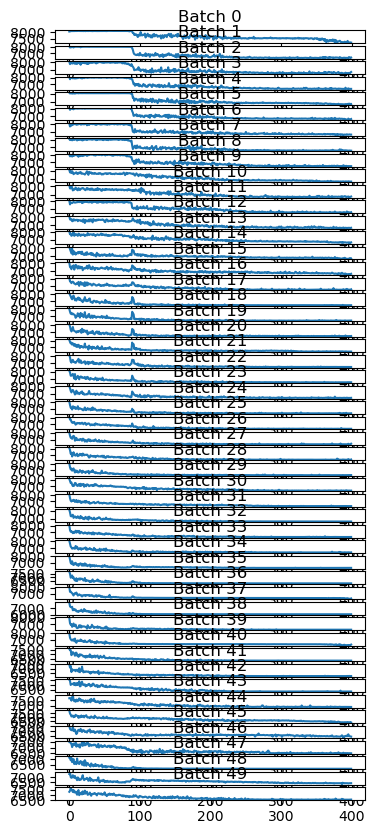

In [10]:
batch_plots(batch_loss_dict)

In [11]:
"""
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)




print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)
"""





"\nmodel.eval()\nrecon_data_train = model(dataset_msa.prot_space, deepseq)\n\n\n\n\nprint('Done')\n\nfrom pyfiglet import Figlet\nf = Figlet(font='puffy' ) #slant\n\nprint(recon_data_train[5])\nalignment = recon_data_train[5]\n\n\n\nplot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)\n"

In [12]:
#plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)